# **Initial Steps**

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"10TVpC4_CV-h4o2U3P7KjGdvbsiuFFnkN"})   # replace the id with id of file you want to access
downloaded.GetContentFile('Train.xlsx')

ModuleNotFoundError: No module named 'pydrive'

### Libraries, Packages and others

In [2]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import datetime
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from math import ceil
# from pandas_profiling import ProfileReport
import scipy.cluster.hierarchy as shc
from sklearn import datasets
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder





# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'


import warnings
warnings.filterwarnings("ignore")

###Functions 

In [5]:
def birthday_to_age(df, column, new_column):
    '''
    This function creates a column representing the difference in years from a given birth year column values
    Having into account that we are on the year 2048
    '''
    
    df[new_column] = df[column].map(lambda x : 2048 - x)
    
def questionmark_to_nan(df, column):
    '''
    This function turns a binary variable with missing values as '?' in NaN
    It needs as input the dataframe and the column name 
    (column name needs to be between '')
    '''
    df[column] = df[column].map(lambda x: np.nan if x == '?' else x)
    
def ohe(df, column_list):
    ohc = OneHotEncoder(sparse = False)
    ohc_feat = ohc.fit_transform(df[column_list])
    ohc_feat_names = ohc.get_feature_names()
    ohc_df = pd.DataFrame(ohc_feat, index = df.index, columns = ohc_feat_names)
    return ohc_df

def hist_box_maker(df,titl, num_of_rows, figx, figy):
    
    fig, axes = plt.subplots(num_of_rows, ceil((len(df.columns)*2)/num_of_rows), figsize=(figx, figy))
    temp = (list(df.columns)*2)
    temp.sort()
    # Plot data
    # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
    i = 0 
    for ax, feat in zip(axes.flatten(), temp):
        
        if i%2 == 0:
            ax.hist(df[feat], bins = 50)
            ax.set_title(feat, y=-0.13)
            pltiswork=feat
            
        else:
            sns.boxplot(x=df[pltiswork], ax = ax)
        
        i+=1
            
    # Layout
    # Add a centered title to the figure:
    title = titl

    plt.suptitle(title)

    plt.show()# All Numer
    
    
def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize = (8,10))
    imp_coef.plot(kind = 'barh')
    plt.title('Feature Importance Using ' + name + ' Regression')
    plt.show()
    

### Import data

In [645]:
train = pd.read_excel("Train.xlsx")

# **Data Inspection**

In [646]:
train.head() #Data was imported correctly

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [647]:
 #No column seems to have, for now, a wrong dtype, except Birthday
train.dtypes

CITIZEN_ID                 int64
Name                      object
Birthday                  object
Native Continent          object
Marital Status            object
Lives with                object
Base Area                 object
Education Level           object
Years of Education         int64
Employment Sector         object
Role                      object
Working Hours per week     int64
Money Received             int64
Ticket Price               int64
Income                     int64
dtype: object

In [648]:
train.describe()

,CITIZEN_ID,Years of Education,Working Hours per week,Money Received,Ticket Price,Income
count,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000
mean,23685.500000,13.173884,40.483795,1324.915357,109.145313,0.237098
std,6466.467351,2.512451,12.370921,9227.771813,500.208904,0.425313
min,12486.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,18085.750000,12.000000,40.000000,0.000000,0.000000,0.000000
50%,23685.500000,13.000000,40.000000,0.000000,0.000000,0.000000
75%,29285.250000,15.000000,45.000000,0.000000,0.000000,0.000000
max,34885.000000,21.000000,99.000000,122999.000000,5358.000000,1.000000


In [649]:
train.isna().sum() #No "immediate" missing values

CITIZEN_ID                0
Name                      0
Birthday                  0
Native Continent          0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
Income                    0
dtype: int64

### Data Treatment


#### Categorical Variables Treatment

Lets start to treat the object type variables.

Remember that no variables seemed to show missing values.

In [650]:
for i in ["Name", "Native Continent", "Marital Status", "Lives with", "Base Area", "Education Level", "Employment Sector", "Role"]:
    train[i] = train[i].astype("str")

In [651]:
train.dtypes

CITIZEN_ID                 int64
Name                      object
Birthday                  object
Native Continent          object
Marital Status            object
Lives with                object
Base Area                 object
Education Level           object
Years of Education         int64
Employment Sector         object
Role                      object
Working Hours per week     int64
Money Received             int64
Ticket Price               int64
Income                     int64
dtype: object

In [652]:
#All seems fine.
#However in order to use Native Continent on our models we will need to later perform one hot encoding.
#We can't use label encoding since the categories aren't ordered and we would be inducing orders or hierarchies were they don't exist.
train['Native Continent'].value_counts()

Europe     19111
Africa      2187
Asia         699
America      219
Oceania      184
Name: Native Continent, dtype: int64

In [653]:
#This values can be turned into binary variables which describe if the person is married, not married (anymore), or never married.
#This will allow us to have a better significance in our resuls (meaning, not a huge amount of 0s in binary variables), which we would
#have if we proceed to make one hot encoding right now. 
#We will make this change later in the feature engineering step.
train['Marital Status'].value_counts()

Married                         10219
Single                           7416
Divorced                         3072
Separated                         699
Widow                             696
Married - Spouse Missing          284
Married - Spouse in the Army       14
Name: Marital Status, dtype: int64

In [654]:
#This values can be turned into binary variables. For being able to do so, we will primarily turn the values "Husband" and "Wife" in "Spouse" and "Other Family"
#and "Other relatives" in only 1 value as they seem to have the same meaning.
#We will make this change later in the feature engineering step.
train['Lives with'].value_counts()

Wife               9012
Other Family       5777
Children           3519
Alone              2362
Husband            1049
Other relatives     681
Name: Lives with, dtype: int64

In [655]:
#We have '?' values, wich are clearly missing values, so we have to turn them into ones
#With the high number of missing values, we will probably need to use techniques to fill missing values, for example, the KNN
#We also believe we cannot make one hot encoding in this variable otherwise we would create too many variables and they would loose their significance
#However, it is important to highlight that we have a lot of observations with the value Northbury, which means that if we have to make only a binary column
#with this variable it will have a good representation on the dataset.
train['Base Area'].value_counts() 

Northbury        20074
Fanfoss            443
?                  395
Alverton           135
Butterpond          96
Watford             83
Auchenshuggle       80
Pran                77
Sharnwick           70
Aroonshire          64
Laewaes             63
Fool's March        59
Wigston             56
Eelry               56
Sharpton            54
Lanercost           52
Cherrytown          51
Aerilon             45
King's Watch        44
Kirkwall            40
Bellmoral           40
Knife's Edge        37
Laenteglos          32
Tranmere            30
Drumchapel          25
Aberuthven          23
Orilon              22
Kald                19
Carlisle            18
MillerVille         17
Lewes               16
Willesden           16
Conriston           12
Marnmouth           11
Middlesbrough       10
Mensfield            9
Woodpine             9
Bellenau             8
Redwick Bush         8
Ironforge            1
Name: Base Area, dtype: int64

In [656]:
#The categories seem to be good! We believe that a distinction as deep as the one presented is not needed, and so, we will
#group some variables as the latest education a person has received.
#As we are dealing with Ordinal data, meaning, the variables have a natural order, for example, a PhD is valued higher than a high school degree, 
#We will create a variable that contains the categories representing the education qualification, in integer values, as the algorithm can process
#these values as an order
#We will make this change later in the feature engineering step.
train['Education Level'].value_counts() 

Professional School                     7232
High School + PostGraduation            4994
Bachelors + PostGraduation              3696
Masters                                 1193
Professional School + PostGraduation     953
High School - 2nd Cycle                  809
Bachelors                                735
High School - 1st Cycle                  649
Middle School - 2nd Cycle                432
Masters + PostGraduation                 397
Middle School Complete                   342
PhD                                      289
High School Complete                     287
Middle School - 1st Cycle                237
Primary School                           122
Preschool                                 33
Name: Education Level, dtype: int64

In [657]:
#Has the same missing values problem as before, meaning, when there is missing data it is represented by a "?"
#The categories have information about big groups of values (private sector, public sector, etc), so we will retrieve this information in 
#a more correct and larger way.
#After doing so, we will probably have to reach to some type of data encoding technique in order to be able to use this information in our model
#We will make this change later in the feature engineering step.
train['Employment Sector'].value_counts() 

Private Sector - Services     15599
Self-Employed (Individual)     1764
Public Sector - Others         1419
?                              1264
Private Sector - Others         880
Self-Employed (Company)         763
Public Sector - Government      692
Unemployed                       12
Never Worked                      7
Name: Employment Sector, dtype: int64

In [658]:
#Has the same missing values problem as before, meaning, when there is missing data it is represented by a "?"
#The grouping of information (in order to be able to have encoding) in this variable is difficult to tackle.
#We will probably use the sectors of the economy to make some type of encoding in this variable
#We will make this change later in the feature engineering step.
train['Role'].value_counts() 

Professor                         2849
Management                        2797
Repair & constructions            2795
Administratives                   2608
Sales                             2531
Other services                    2287
Machine Operators & Inspectors    1384
?                                 1271
Transports                        1071
Cleaners & Handlers                922
Agriculture and Fishing            702
IT                                 626
Security                           450
Household Services                 102
Army                                 5
Name: Role, dtype: int64

In [659]:
#As the name is not very important in our analysis, we will proceed on removing the first word from the name, meaning, the gender the person
#identifies with and we will create a variable with information about the gender.
#We will make this change later in the feature engineering step.
train['Name'].head()

0         Mr. Adam Glover
1    Mr. Cameron McDonald
2      Mr. Keith Davidson
3      Mr. Alexander Gill
4          Mr. Neil Piper
Name: Name, dtype: object

In [660]:
#Clearly some transformations are needed, if we want to use this variable
#We will have to do some engineering 
train['Birthday'].head() 

0         July 1,2003
1     January 25,2006
2         May 10,2009
3       March 25,1985
4         May 29,2015
Name: Birthday, dtype: object

In [661]:
#Turning the "?" in missing value np.nan
questionmark_to_nan(train, 'Base Area') 
questionmark_to_nan(train, 'Employment Sector') 
questionmark_to_nan(train, 'Role') 

#Checking whether there are more categorical variables with "?" values
for i in ["Name", "Native Continent", "Marital Status", "Lives with", "Base Area", "Education Level", "Employment Sector", "Role"]:
  print(train[i].str.contains('?', regex = False).sum())

0
0
0
0
0
0
0
0


#### Numeric Variables Treatment

Since no variables showed *immediate* missing values, on the variables whose data type is float or int, we know that we won't have the problem of '?' missing values, otherwise the variables would be of object data type.

However we still have to check these variables to know if there are some immediate incoherences.

In [662]:
train.dtypes

CITIZEN_ID                 int64
Name                      object
Birthday                  object
Native Continent          object
Marital Status            object
Lives with                object
Base Area                 object
Education Level           object
Years of Education         int64
Employment Sector         object
Role                      object
Working Hours per week     int64
Money Received             int64
Ticket Price               int64
Income                     int64
dtype: object

In [663]:
#No repeated Citizen ID's
(train['CITIZEN_ID'].value_counts()>1).sum() 

0

**Assumption:**If the Citizen ID follows the normal order of atribution of ID after being recognized the citizenship, we know which citizens were the first to arrive, as their ID's will have a smaller value.

In [664]:
#??????
#train.drop(columns = ['CITIZEN_ID']).describe()

# **Coherence Checks**

In [665]:
#It makes no sense to have negative values in the following numerical variables.
print("Number of negative values:")
for i in ["Years of Education", "Working Hours per week", "Money Received", "Ticket Price", "Income"]:
    print(i,":", ((train[i]<0).sum()))
#All seems to be good!

Number of negative values:
Years of Education : 0
Working Hours per week : 0
Money Received : 0
Ticket Price : 0
Income : 0


No values below 0. For now everything looks fine.

Considering the average, std and min and max values of *Years of Education* and *Working Hours per week*, there definitely seem to be some outliers, but we will check this with more detail later. Since most values of *Money Received* and *Ticket Price* are 0, we can't talk about its outliers right now.

In [666]:
train[(train['Money Received']<0) & (train['Ticket Price']>0)] 

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income


In the clause above we can see that there are no records that show people that have simultanously paid to go to Newland (belonging to Group C) and that have been paid to go to Newland (therefore belonging to Group B)

In [667]:
train[(train['Money Received']==0) & (train['Ticket Price']==0)].shape[0]

19511

There are 19511 people that were neither paid or payed to go to Newland

In [668]:
train[(train['Money Received']<=0) & (train['Ticket Price']>=0)].shape[0]

20568

This shows us that the data for these columns is correct! 

# **Data Transformation**

#### Birthday to age transformation

We have the birthday of each person, but more usefull to estimate the model is their age.

However before we calculate the age we have to do some transformations to the birthday variable.

We will calculate the age having in to account that we are on the year 2048, and we don't know the current month or day.

In [669]:
train['Birthday'].head()

0         July 1,2003
1     January 25,2006
2         May 10,2009
3       March 25,1985
4         May 29,2015
Name: Birthday, dtype: object

In [670]:
#First we extract the year of each birthday in to a new column
train["YOB"] = train['Birthday'].str.split(' ', n = 2, expand = True)[2].str.split(',', n = 1, expand = True)[1]

In [671]:
train["YOB"].head()

0    2003
1    2006
2    2009
3    1985
4    2015
Name: YOB, dtype: object

In [672]:
train['YOB'] = train['YOB'].astype('int64') #Turns year of birth in to dtype int

In [673]:
birthday_to_age(train, 'YOB', 'Age') #Turns year of birth to age

In [674]:
train[['Age']].describe().T #All seems fine

,count,mean,std,min,25%,50%,75%,max
Age,22400.0,38.584866,13.651578,17.0,28.0,37.0,48.0,90.0


In [675]:
#And we drop the columns we will no longer need
train.drop(columns = ['Birthday', 'YOB'], inplace = True)

#### Base Area -> Northbury

There are a lot of base areas, however most observations belong to Northbury, so instead of using one hot encoding and proceding with all the values, we will just proced with a variable that signals whether the person is of Northbury or not.

MESMO ASSIM SERIA FIXE FAZER ONE HOT ENCODING E DPS FEATURE SELECTION PARA GARANTIR QUE REALMENTE SO A NORTHBURY DEVA FICAR

In [676]:
train['Northbury'] = train['Base Area'].map(lambda x: 1 if x == 'Northbury' else 0)

#Não esquecer fazer inut NA antes disto
#No entnto pode não ser necessário!!!!!!!!!!!!!!!!!!

In [677]:
train['Northbury'].value_counts()

1    20074
0     2326
Name: Northbury, dtype: int64

In [678]:
train.drop(columns = ['Base Area'], inplace = True)

#### Name -> Gender -> Male

It doesn't make sense to model using the different names in the dataset, however with the first byte of each one (for example: Mrs.) we can conclude quite easily the gender of each person. Having the gender we can then create a variable that signals all the males.

In [679]:
train['Gender'] = train['Name'].str.split(' ', n = 1, expand = True)[0] 

In [680]:
train['Gender'].value_counts()

Mr.     14971
Mrs.     4117
Miss     3312
Name: Gender, dtype: int64

In [681]:
train['Male'] = train['Gender'].map(lambda x: 1 if x == 'Mr.' else 0)

In [682]:
train['Male'].value_counts()

1    14971
0     7429
Name: Male, dtype: int64

In [683]:
train.drop(columns = ['Name', 'Gender'], inplace = True)

### *Lives with* and *Marital Status*


In [684]:
train['Marital Status'] = train['Marital Status'].map(lambda x: 'Married' if ((x == 'Married - Spouse Missing') | (x == 'Married - Spouse in the Army') ) else x)
train['Marital Status'] = train['Marital Status'].map(lambda x: 'Not Married' if ((x == 'Divorced')  | (x == 'Separated') | (x == 'Widow')) else x)
train['Marital Status'] = train['Marital Status'].map(lambda x: 'Never Married' if ((x == 'Single') ) else x)

There are no weird values and one hot encoding will be needed for the same reasons as in the previous variable.

However some values seem to specific and have very little representation on the observations, so we will "standardize" this values: "Married - Spouse Missing" and "Married - Spouse in the Army" will be changed to "Married".

There is no point in discretizing between living with Wife or Husband, so we will aggregate it in Spouse. Same thing with other relatives and Other Family.

In [685]:
train['Lives with'] = train['Lives with'].map(lambda x: 'Spouse' if ((x == 'Wife') | (x == 'Husband')) else x)
train['Lives with'] = train['Lives with'].map(lambda x: 'Other Family' if (x == 'Other relatives') else x)

In [686]:
train.dtypes

CITIZEN_ID                 int64
Native Continent          object
Marital Status            object
Lives with                object
Education Level           object
Years of Education         int64
Employment Sector         object
Role                      object
Working Hours per week     int64
Money Received             int64
Ticket Price               int64
Income                     int64
Age                        int64
Northbury                  int64
Male                       int64
dtype: object

### Education Level

- https://en.wikipedia.org/wiki/Education_in_the_United_States
- http://internacional.ipvc.pt/sites/default/files/Diagrama_SESP_EQF_PT1.pdf
- https://europa.eu/europass/pt/description-eight-eqf-levels

In [687]:
#Division will have to be made top to bottom. Meaning, if it appears "Masters" and "PostGraduation",
#we will treat first "Masters" to make sure we have the maximum education first
train["Education Level"].value_counts()

Professional School                     7232
High School + PostGraduation            4994
Bachelors + PostGraduation              3696
Masters                                 1193
Professional School + PostGraduation     953
High School - 2nd Cycle                  809
Bachelors                                735
High School - 1st Cycle                  649
Middle School - 2nd Cycle                432
Masters + PostGraduation                 397
Middle School Complete                   342
PhD                                      289
High School Complete                     287
Middle School - 1st Cycle                237
Primary School                           122
Preschool                                 33
Name: Education Level, dtype: int64

In [688]:
#Solução 1 - Fazer por grupos que nós considerarmos certos. Aqui estão os que eu acho que ficam bem, mas é perfeitamente alterável
train['Education Level'] = train['Education Level'].map(lambda x: 'Masters' if ("Masters" in x) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'PostGraduation' if ("PostGraduation" in x) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'Incomplete High School' if ((x== "High School - 2nd Cycle") | (x== "High School - 1st Cycle")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'Less than Middle School' if ((x=="Middle School - 2nd Cycle") | (x== "Middle School - 1st Cycle") | (x== "Primary School") |(x== "Preschool" )) else x)
train['Education Level'] = train['Education Level'].map(lambda x: '<HighSchool' if ((x=="Incomplete High School") | (x== "Less than Middle School") | (x== "Middle School Complete")) else x)
train["Education Level"].value_counts()

PostGraduation          9643
Professional School     7232
<HighSchool             2624
Masters                 1590
Bachelors                735
PhD                      289
High School Complete     287
Name: Education Level, dtype: int64

In [689]:
#Solução 2 - Fazer por grupos instituidos pela UE (ver link acima). Se assim o fizermos, sabemos por exemplo que a professional school está acima da highschool!
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF3 or less' if ((x=="<HighSchool")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF4' if ((x=="High School Complete")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF5' if ((x=="Professional School")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF6' if ((x=="Bachelors")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF7' if ((x=="Masters") | (x== "PostGraduation")) else x)
train['Education Level'] = train['Education Level'].map(lambda x: 'EQF8' if ((x=="PhD")) else x)
train["Education Level"].value_counts()

EQF7            11233
EQF5             7232
EQF3 or less     2624
EQF6              735
EQF8              289
EQF4              287
Name: Education Level, dtype: int64

### Profession


In [690]:
train["Employment Sector"] = train["Employment Sector"].astype("str")
train["Employment Sector"].value_counts()

Private Sector - Services     15599
Self-Employed (Individual)     1764
Public Sector - Others         1419
nan                            1264
Private Sector - Others         880
Self-Employed (Company)         763
Public Sector - Government      692
Unemployed                       12
Never Worked                      7
Name: Employment Sector, dtype: int64

In [691]:
train["Employment Sector"]= train["Employment Sector"].map(lambda x: 'Private Sector' if ("Private Sector" in x) else x)
train["Employment Sector"]= train["Employment Sector"].map(lambda x: 'Public Sector' if ("Public Sector" in x) else x)
train["Employment Sector"]= train["Employment Sector"].map(lambda x: 'Self Employed' if ("Self-Employed" in x) else x)
train['Employment Sector'] = train['Employment Sector'].map(lambda x: 'Not Working' if ((x=="Unemployed") | (x== "Never Worked")) else x)
train['Employment Sector'] = train['Employment Sector'].map(lambda x: np.nan if ((x=="nan")) else x)

In [692]:
train["Employment Sector"].value_counts()

Private Sector    16479
Self Employed      2527
Public Sector      2111
Not Working          19
Name: Employment Sector, dtype: int64

### Role

In [693]:
train["Role"].value_counts()

Professor                         2849
Management                        2797
Repair & constructions            2795
Administratives                   2608
Sales                             2531
Other services                    2287
Machine Operators & Inspectors    1384
Transports                        1071
Cleaners & Handlers                922
Agriculture and Fishing            702
IT                                 626
Security                           450
Household Services                 102
Army                                 5
Name: Role, dtype: int64

In [694]:
## Primário: Agriculture and Fishing, 
## Secundário:Repair & constructions, Machine Operators & Inspectors,
## Terciário: Administratives, Sales, Other services, Transports, Cleaners & Handlers, Household Services, Security, Army  
## Quaternário: IT, Professor, Management

In [695]:
train["Role"]= train["Role"].map(lambda x: '1st Sector' if ((x=="Agriculture and Fishing")) else x)
train["Role"]= train["Role"].map(lambda x: '2nd Sector' if ((x=="Repair & constructions") | (x== "Machine Operators & Inspectors"))else x)
train["Role"]= train["Role"].map(lambda x: '3rd Sector' if ((x== "Administratives")| (x== "Sales")| (x== "Other services")| (x== "Transports")| (x== "Cleaners & Handlers")| (x== "Household Services")| (x== "Security")| (x== "Army"))else x)
train["Role"]= train["Role"].map(lambda x: '4th Sector' if ((x=="IT") | (x== "Professor")| (x== "Management"))else x)

In [696]:
train["Role"].value_counts()

3rd Sector    9976
4th Sector    6272
2nd Sector    4179
1st Sector     702
Name: Role, dtype: int64

### Ticket Price and Money

As for the description of the project, we have noticed that ticket price represents the information of how much someone payed to go to the planet, and, money received represents the money someone was payed to go to Newland. 

Given so, we consider that both variables represent the same thing but in different directions. We will then proceed to join both, adding the inverse sign to one of them

In [697]:
train["Money Received"] = train["Money Received"].map(lambda x: -x )

In [698]:
train["MONEY_TICKET"] =  train["Money Received"].astype(str) + train["Ticket Price"].astype(str)
train["MONEY_TICKET"] = train["MONEY_TICKET"].astype(int)

In [699]:
train["Native Continent"].value_counts()

Europe     19111
Africa      2187
Asia         699
America      219
Oceania      184
Name: Native Continent, dtype: int64

# **Missing Values Imputation**

In [700]:
((train.isna().sum())/(train.shape[0])*100)

CITIZEN_ID                0.000000
Native Continent          0.000000
Marital Status            0.000000
Lives with                0.000000
Education Level           0.000000
Years of Education        0.000000
Employment Sector         5.642857
Role                      5.674107
Working Hours per week    0.000000
Money Received            0.000000
Ticket Price              0.000000
Income                    0.000000
Age                       0.000000
Northbury                 0.000000
Male                      0.000000
MONEY_TICKET              0.000000
dtype: float64

In [701]:
train["Employment Sector"]= train["Employment Sector"].fillna(train["Employment Sector"].mode()[0])
train["Role"]= train["Role"].fillna(train["Role"].mode()[0])

In [702]:
((train.isna().sum())/(train.shape[0])*100)

CITIZEN_ID                0.0
Native Continent          0.0
Marital Status            0.0
Lives with                0.0
Education Level           0.0
Years of Education        0.0
Employment Sector         0.0
Role                      0.0
Working Hours per week    0.0
Money Received            0.0
Ticket Price              0.0
Income                    0.0
Age                       0.0
Northbury                 0.0
Male                      0.0
MONEY_TICKET              0.0
dtype: float64

# **Data Encoding**

In [703]:
train_encoding = train.copy()

In [704]:
print("Number of Categories in: ")
for ColName in train[['Native Continent','Marital Status','Lives with', "Employment Sector","Role"]]:
    print("{} = {}".format(ColName,len(train[ColName].unique())))

Number of Categories in: 
Native Continent = 5
Marital Status = 3
Lives with = 4
Employment Sector = 4
Role = 4


#### One Hot Encoding

In [705]:
one_hot_var = ohe(train_encoding, ['Native Continent', 'Marital Status', 'Lives with', "Employment Sector", "Role"])

In [706]:
train_encoding = pd.concat([train_encoding.drop(columns = ['Native Continent', 'Marital Status', 'Lives with', "Employment Sector", "Role"]), one_hot_var], axis = 1)

In [707]:
train_encoding.columns

Index(['CITIZEN_ID', 'Education Level', 'Years of Education',
       'Working Hours per week', 'Money Received', 'Ticket Price', 'Income',
       'Age', 'Northbury', 'Male', 'MONEY_TICKET', 'x0_Africa', 'x0_America',
       'x0_Asia', 'x0_Europe', 'x0_Oceania', 'x1_Married', 'x1_Never Married',
       'x1_Not Married', 'x2_Alone', 'x2_Children', 'x2_Other Family',
       'x2_Spouse', 'x3_Not Working', 'x3_Private Sector', 'x3_Public Sector',
       'x3_Self Employed', 'x4_1st Sector', 'x4_2nd Sector', 'x4_3rd Sector',
       'x4_4th Sector'],
      dtype='object')

#### Label Encoding

In [708]:
train_encoding["Education Level"].value_counts()

EQF7            11233
EQF5             7232
EQF3 or less     2624
EQF6              735
EQF8              289
EQF4              287
Name: Education Level, dtype: int64

In [709]:
# create object of Ordinalencoding
encoder= ce.OrdinalEncoder(cols=['Education Level'],return_df=True, mapping=[{'col':'Education Level','mapping':{'EQF3 or less':0,'EQF4':1,'EQF5':2,'EQF6':3,'EQF7':4,'EQF8':5}}])

#fit and transform train data 
train_encoding = encoder.fit_transform(train_encoding)

# **Data Standardization**

In [710]:
#DM
df_scaling = train_encoding.copy() 

scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(train_encoding)
scaled_feat

df_scaling = scaled_feat
df_scaling = pd.DataFrame(df_scaling)
df_scaling.columns = train_encoding.columns
train_encoding = df_scaling
train_encoding

,CITIZEN_ID,Education Level,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Age,Northbury,Male,...,x2_Other Family,x2_Spouse,x3_Not Working,x3_Private Sector,x3_Public Sector,x3_Self Employed,x4_1st Sector,x4_2nd Sector,x4_3rd Sector,x4_4th Sector
0,0.000000,0.8,0.578947,0.397959,1.000000,0.424225,1.0,0.383562,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000045,0.4,0.526316,0.397959,1.000000,0.000000,1.0,0.342466,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.000089,0.4,0.526316,0.459184,1.000000,0.433184,1.0,0.301370,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000134,0.0,0.473684,0.367347,0.956138,0.000000,1.0,0.630137,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000179,1.0,1.000000,0.448980,1.000000,0.000000,1.0,0.219178,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,0.999821,0.4,0.526316,0.397959,1.000000,0.000000,0.0,0.109589,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
22396,0.999866,0.4,0.526316,0.346939,1.000000,0.000000,0.0,0.082192,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
22397,0.999911,0.8,0.789474,0.397959,0.978260,0.000000,0.0,0.123288,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22398,0.999955,0.8,0.736842,0.908163,1.000000,0.000000,1.0,0.273973,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# **Descriptive Statistics**

In [711]:
train_encoding

,CITIZEN_ID,Education Level,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Age,Northbury,Male,...,x2_Other Family,x2_Spouse,x3_Not Working,x3_Private Sector,x3_Public Sector,x3_Self Employed,x4_1st Sector,x4_2nd Sector,x4_3rd Sector,x4_4th Sector
0,0.000000,0.8,0.578947,0.397959,1.000000,0.424225,1.0,0.383562,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000045,0.4,0.526316,0.397959,1.000000,0.000000,1.0,0.342466,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.000089,0.4,0.526316,0.459184,1.000000,0.433184,1.0,0.301370,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000134,0.0,0.473684,0.367347,0.956138,0.000000,1.0,0.630137,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000179,1.0,1.000000,0.448980,1.000000,0.000000,1.0,0.219178,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,0.999821,0.4,0.526316,0.397959,1.000000,0.000000,0.0,0.109589,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
22396,0.999866,0.4,0.526316,0.346939,1.000000,0.000000,0.0,0.082192,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
22397,0.999911,0.8,0.789474,0.397959,0.978260,0.000000,0.0,0.123288,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22398,0.999955,0.8,0.736842,0.908163,1.000000,0.000000,1.0,0.273973,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [712]:
train_encoding = train_encoding.rename(columns={"Native Continent": "CONTINENT", "Lives with": "LIVES_WITH", 'Education Level': "EDUCATION_LVL",
                      'Years of Education': "YEARS_EDUCATION", 'Employment Sector': "EMPLOY_SECTOR", 'Role': "ECON_SECTOR",
                      'Working Hours per week': "WORKING_HOURS", 'Income': "INCOME",'Marital Status': "MARITAL_STATUS" })

In [713]:
train_encoding.columns

Index(['CITIZEN_ID', 'EDUCATION_LVL', 'YEARS_EDUCATION', 'WORKING_HOURS',
       'Money Received', 'Ticket Price', 'INCOME', 'Age', 'Northbury', 'Male',
       'MONEY_TICKET', 'x0_Africa', 'x0_America', 'x0_Asia', 'x0_Europe',
       'x0_Oceania', 'x1_Married', 'x1_Never Married', 'x1_Not Married',
       'x2_Alone', 'x2_Children', 'x2_Other Family', 'x2_Spouse',
       'x3_Not Working', 'x3_Private Sector', 'x3_Public Sector',
       'x3_Self Employed', 'x4_1st Sector', 'x4_2nd Sector', 'x4_3rd Sector',
       'x4_4th Sector'],
      dtype='object')

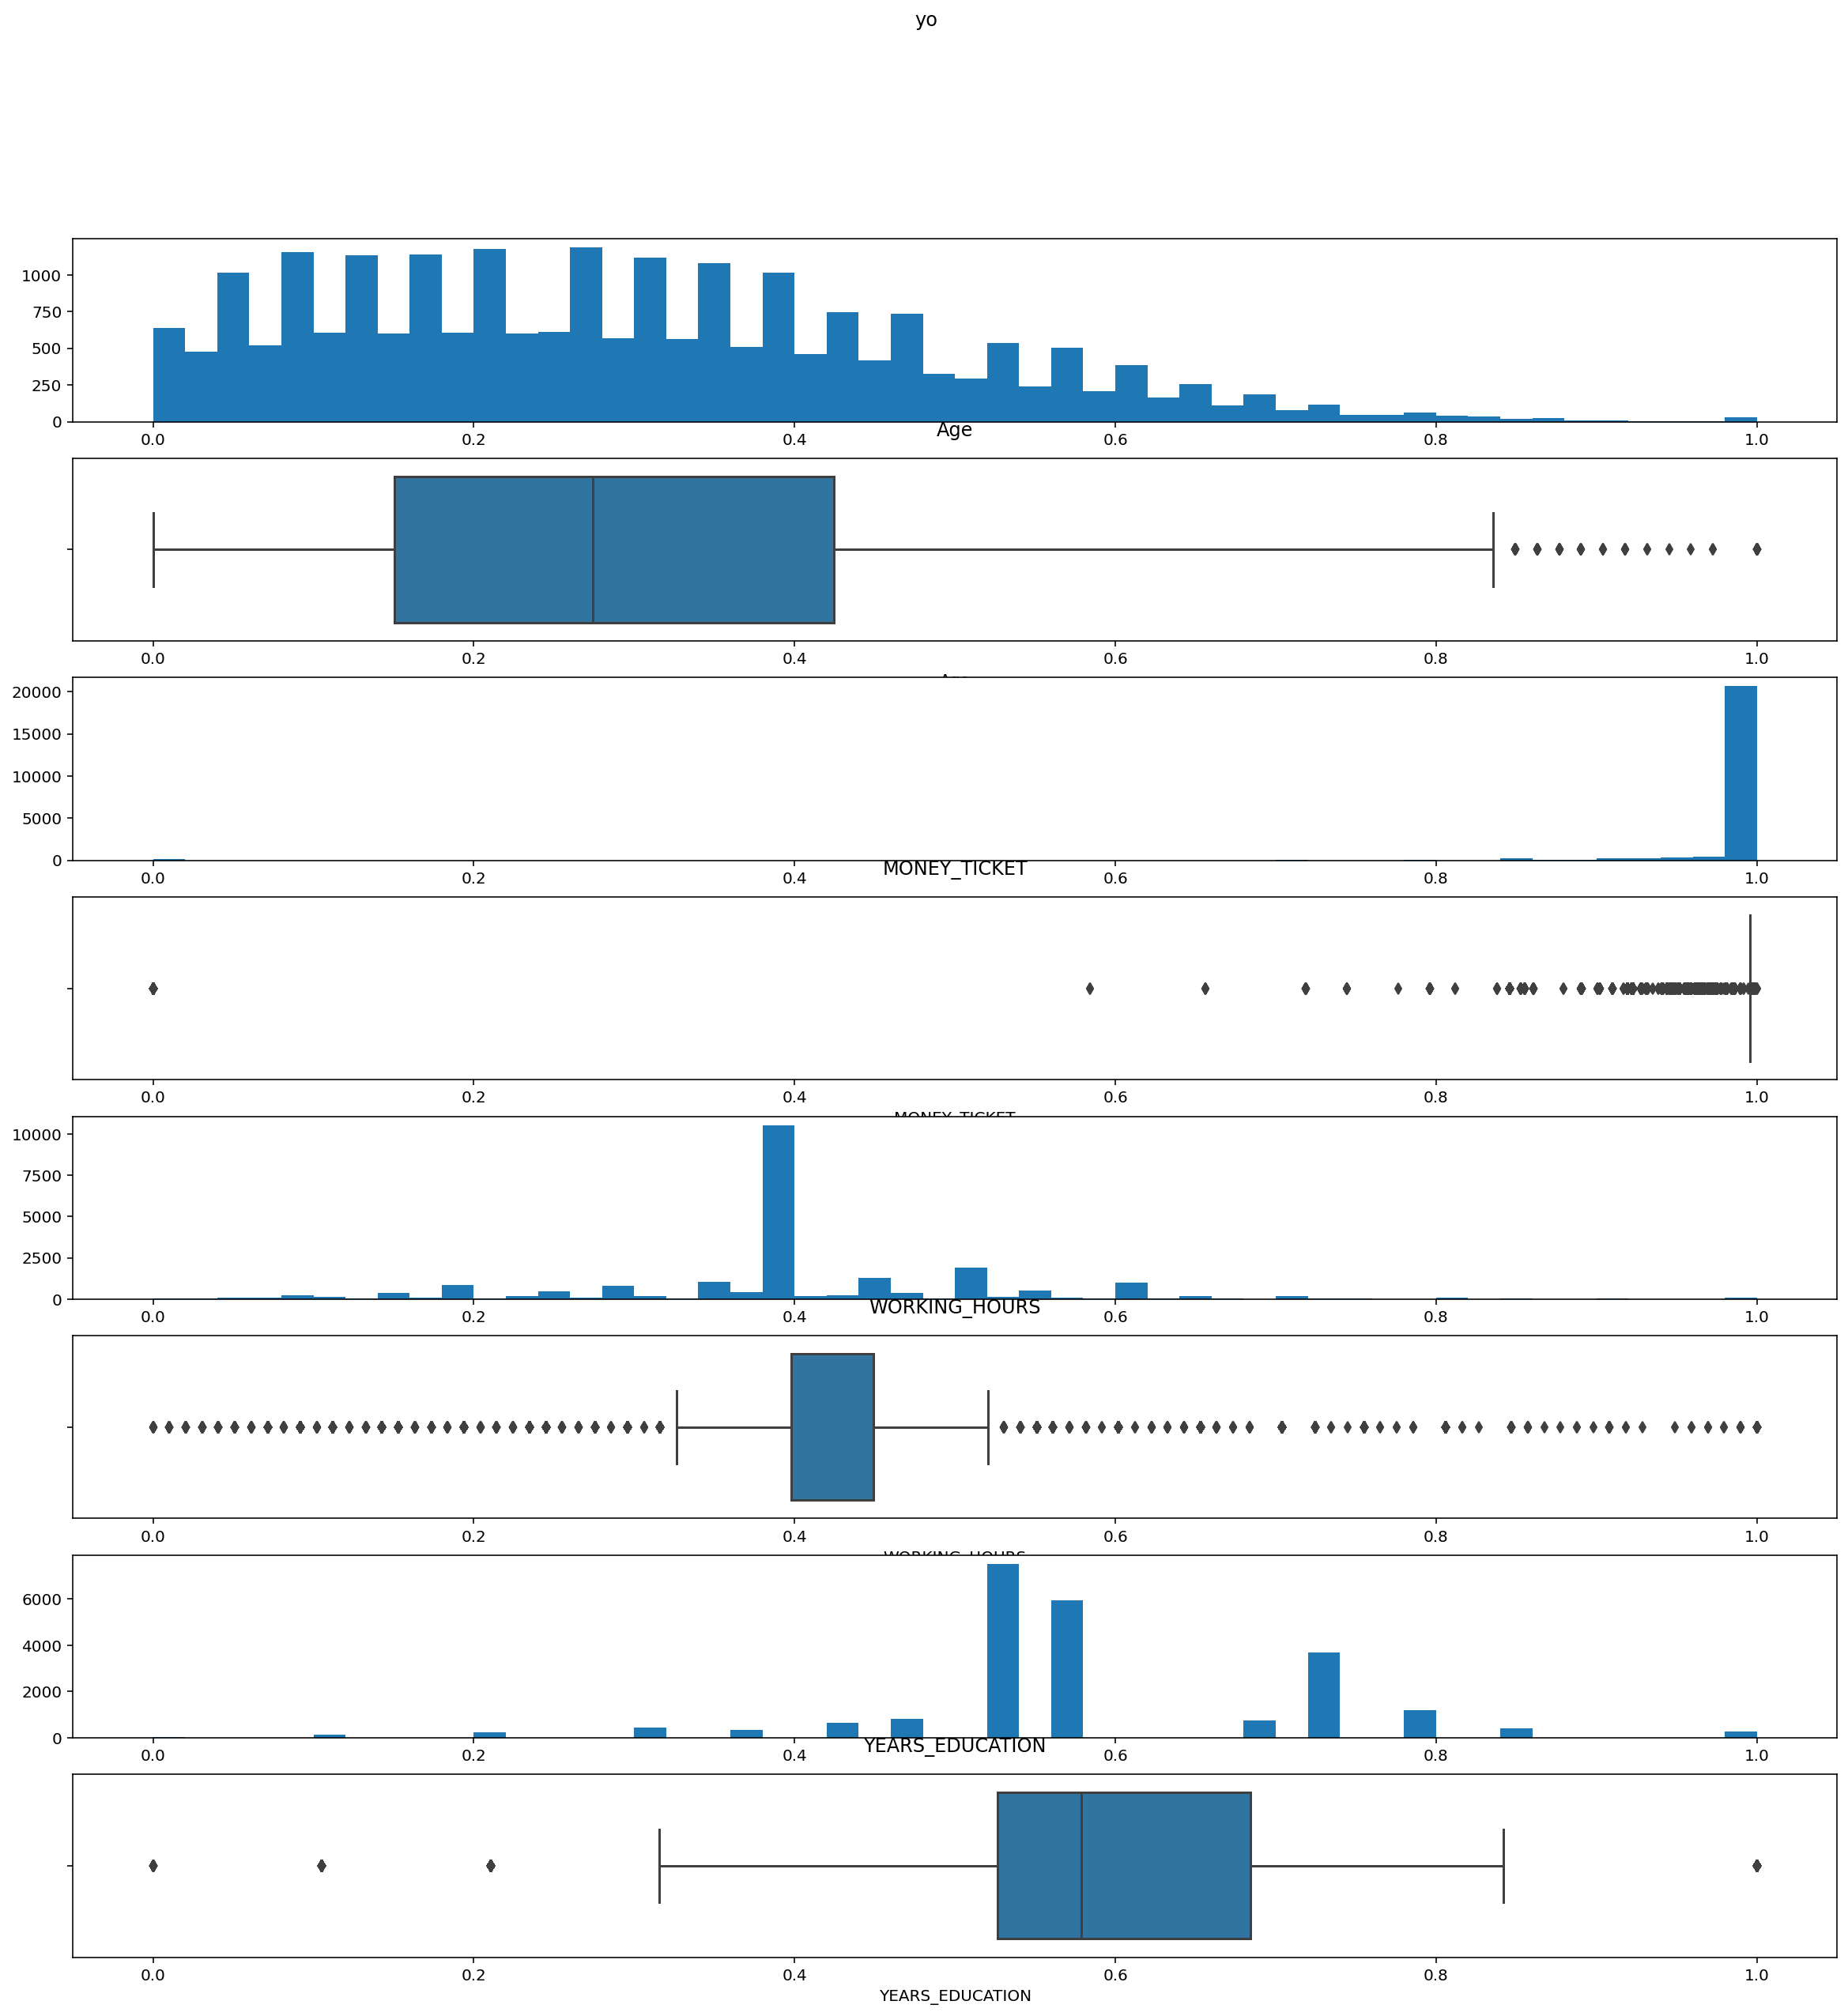

In [714]:
hist_box_maker(train_encoding[["YEARS_EDUCATION", "WORKING_HOURS", "Age", "MONEY_TICKET"]],"yo",8, 20,20)

<AxesSubplot:>

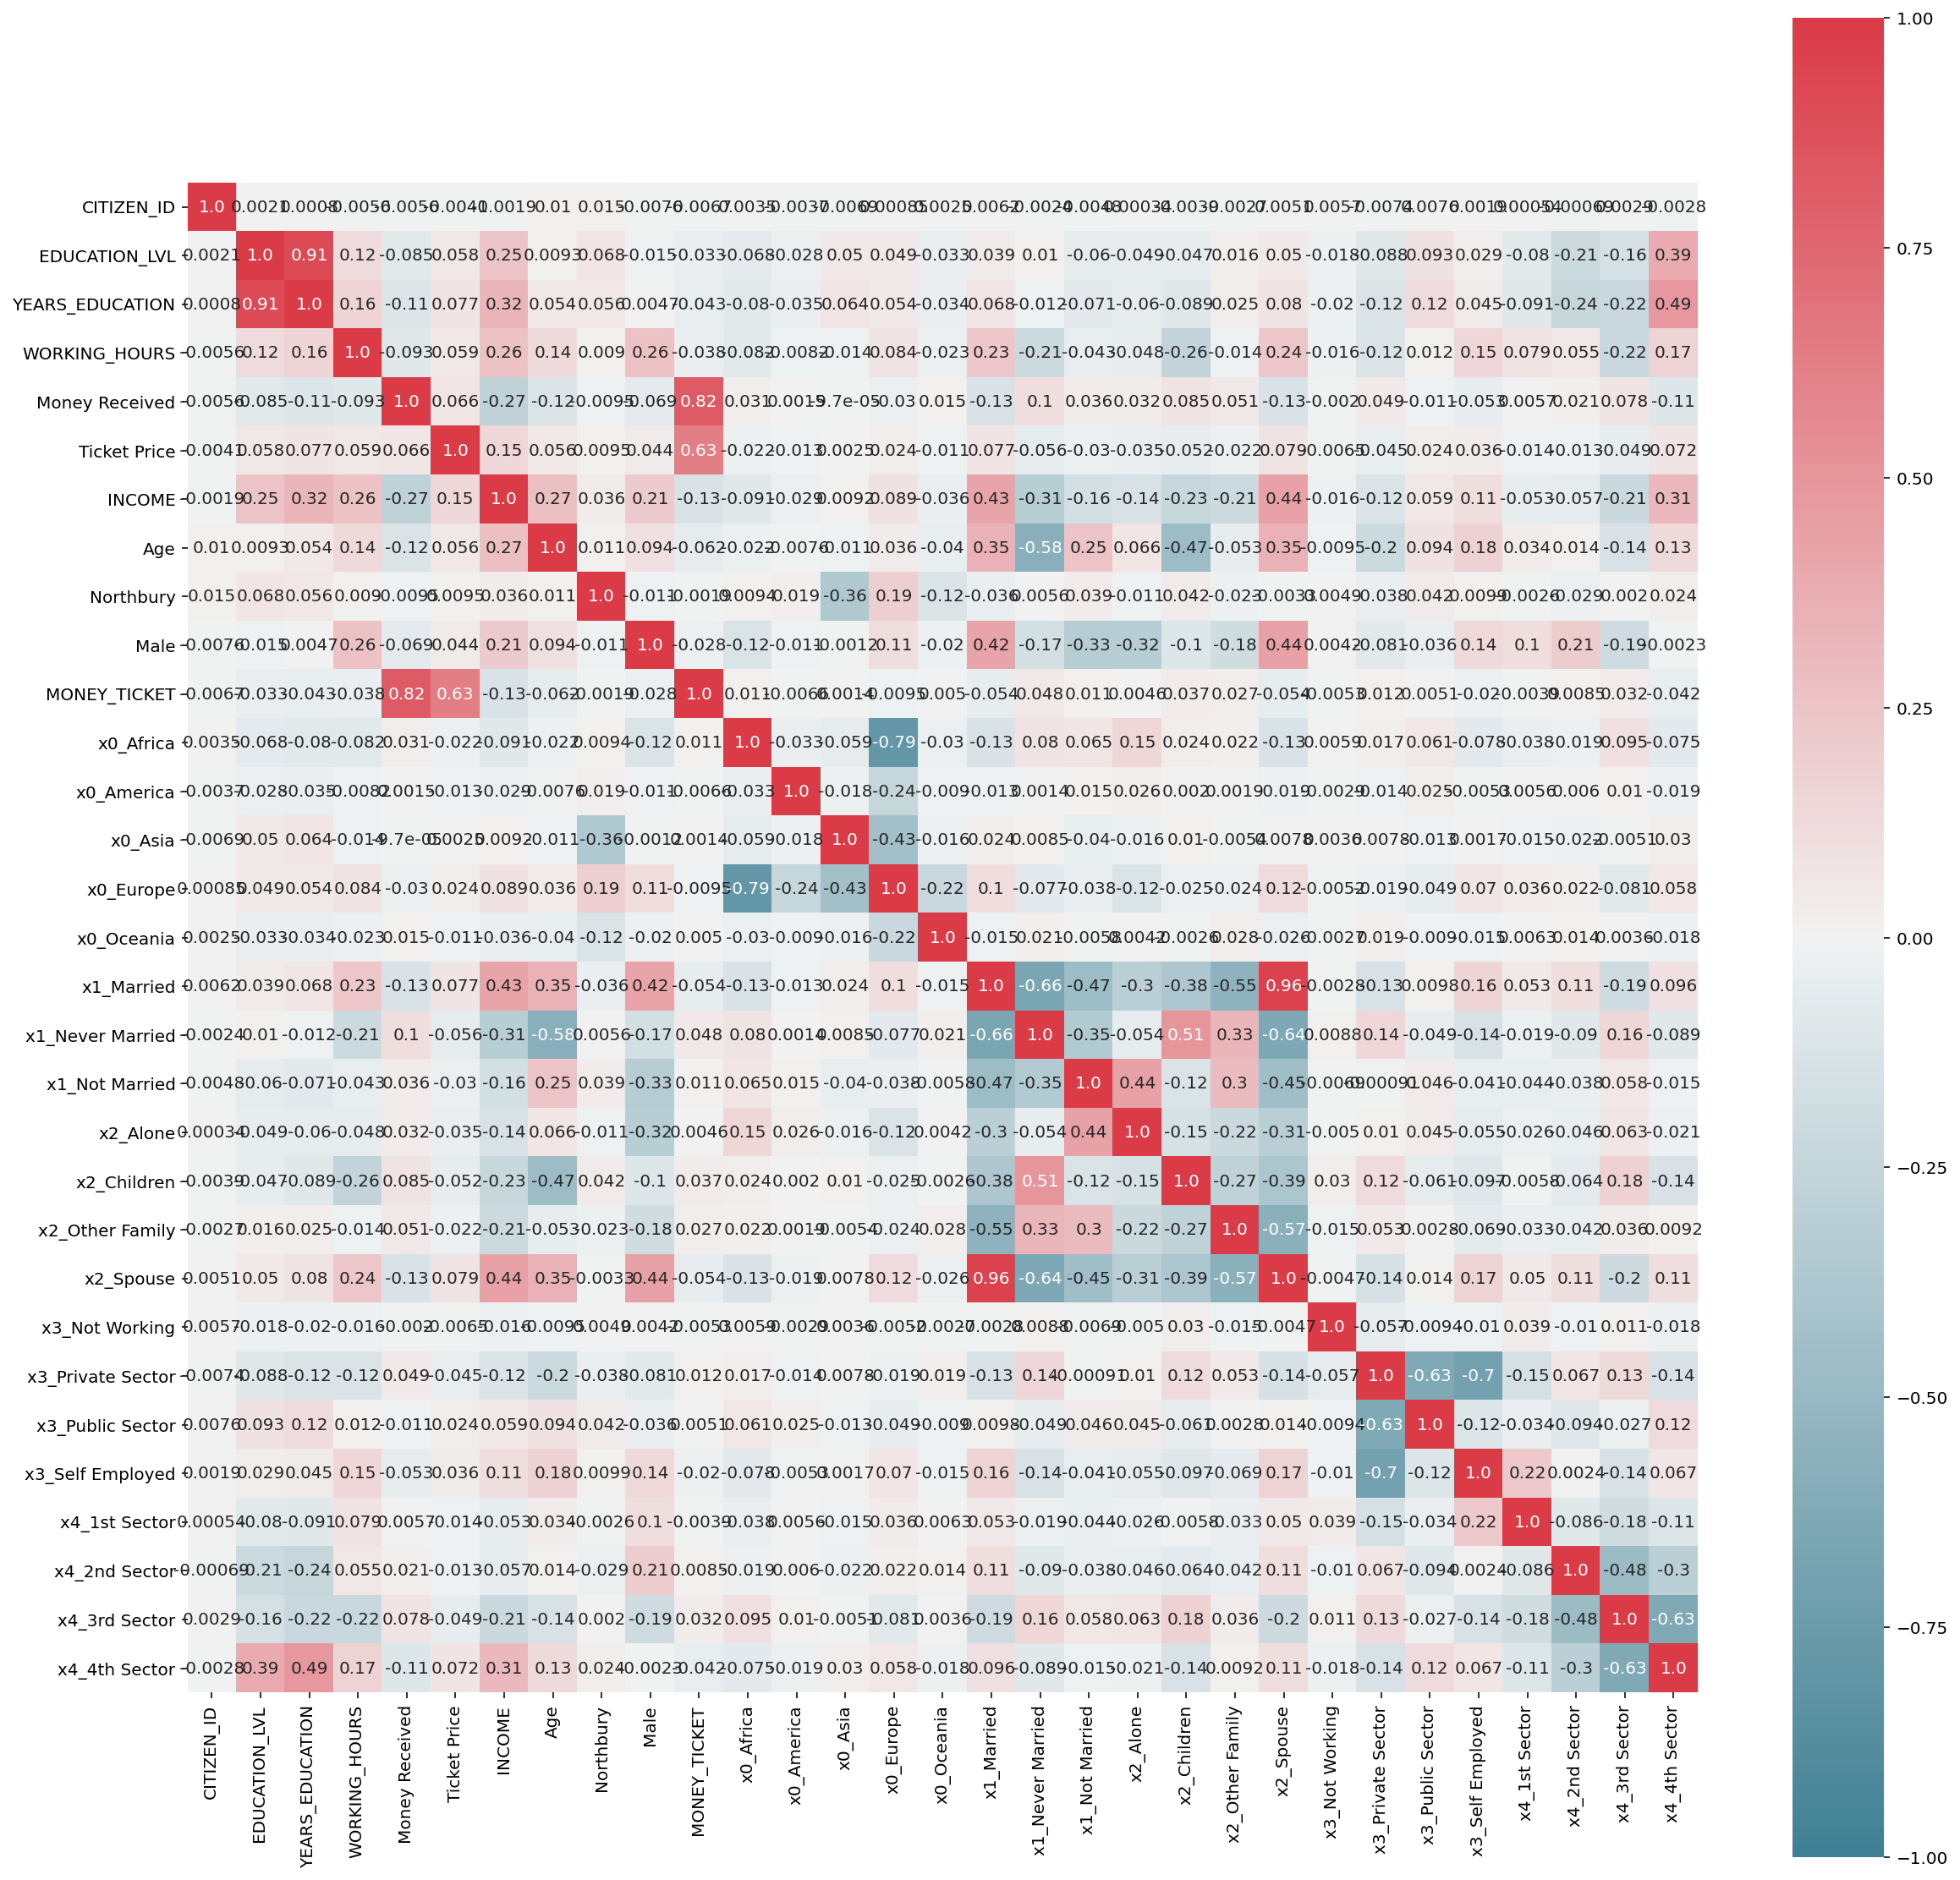

In [715]:
train_encoding_corr=train_encoding.corr(method = "spearman")
plt.figure(figsize=(20,20))
sns.heatmap(data = train_encoding_corr, annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='.2',  vmin=-1, vmax=1, center=0,square=True )

In [717]:
train_encoding = train_encoding.drop(columns =["EDUCATION_LVL", "x2_Spouse", "CITIZEN_ID"])

### Continents

In [718]:
train_encoding = train_encoding.drop(columns =["x0_Africa", "x0_Oceania", "x0_Asia", "x0_America"])

In [719]:
train_encoding = train_encoding.drop(columns =["MONEY_TICKET", "x3_Self Employed", "x1_Never Married", "x1_Not Married"])

In [720]:
# train_encoding_corr=train_encoding.corr(method = "spearman")
# plt.figure(figsize=(20,20))data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACQ0AAAivCAYAAABunSR7AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAABYlAAAWJQFJUiTwAAEAAElEQVR4nOzdd3xT1RvH8e+FFkqRsqEbUJAhs+w9BRUQBQTcg+HEiYo/FygibmTKBlG2CigIyF6l7I0CMjtBlszO+/sjaelI2qRNKZjP+/Xqq5CbPDnnNPfk5ua5zzFM0xQAAAAAAAAAAAAAAAAA95EvrxsAAAAAAAAAAAAAAAAA4MYiaQgAAAAAAAAAAAAAAABwMyQNAQAAAAAAAAAAAAAAAG6GpCEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GZKGAAAAAAAAAAAAAAAAADdD0hAAAAAAAAAAAAAAAAD+UwzD6G4YxkjDMNYZhvGvYRimYRg/ZDNWoGEYkw3DiDQMI9YwjGOGYQw3DKN4Jo9pYhjGYsMwzhqGccUwjN2GYbxqGEb+7PfKtQzTNPO6DQAAAAAAAAAAAAAAAIDLGIaxU1ItSZckhUuqIulH0zQfczLOHZI2SiojaYGkPyU1kNRa0l+SmpqmeSbdY7pI+knSNUmzJZ2V1FlSZUnzTNN8KNsdcyEqDQEAAAAAAAAAAAAAAOC/5jVJd0rykfR8DuKMkSVh6GXTNB8wTXOgaZptJH0jSxLQJ6nvbBiGj6QJkhIltTJNs7dpmm9Kqi0pVFJ3wzB65aA9LkPSEAAAAAAAAAAAAAAAAP5TTNNcZZrmITMHS3AZhnG7pPaSjkkanW7zh5IuS3rcMIzCqW7vLqm0pFmmaW5N1Z5rkt6z/jcnSUwuQ9IQAAAAAAAAAAAAAAAAkFEb6+9lpmkmpd5gmuZFSRskeUtqZOMxS2zEWyvpiqQmhmEUdHFbneaR1w0AAAAAAAAAAAAAAAAAkhmGsc3eNtM0697AplS2/j5oZ/shWSoR3SlpRVaPMU0zwTCMo5LuknS7pAOua6rzSBoCAAAAAAAAAAAAAAD/aYeadcj2ElXIE9vzugFWRa2/L9jZnnx7sRw+Jk+QNAQAAAAAAAAAAAAAAICbxg2uJpQThvW3M0lp2XlMrsiX1w0AAAAAAAAAAAAAAAAAbkLJVYGK2tnuk+5+2X1MniBpCAAAAAAAAAAAAAAAAMjoL+vvO+1sr2T9fdCRxxiG4SGpgqQESUdc0cCcIGkIAAAAAAAAAAAAAAAAyGiV9Xd7wzDS5NgYhlFEUlNJVyVtSrVppfX3PTbitZDkLWmjaZqxLm6r00gaAgAAAAAAAAAAAAAAgNsyDMPTMIwqhmHckfp20zT/lrRMUnlJL6Z72GBJhSV9b5rm5VS3z5P0j6RehmHUS/UcXpKGWP871rU9yB6PvG4AAAAAAAAAAAAAAAAA4EqGYTwg6QHrf32tvxsbhjHV+u9/TNMcYP13gKQDko7LkiCU2guSNkoaYRhGW+v9GkpqLcuyZO+mvrNpmv8ahtFXluSh1YZhzJJ0VtL9kipbb5+d4w66AElDAAAAAAAAAAAAAAAA+K+pLenJdLfdbv2RLAlCA5QF0zT/tlYM+kiWJcfukxQlaYSkwaZpnrXxmPmGYbSUJaGomyQvSYclvS5phGmaZnY65GrGTdIOAAAAAAAAAAAAAACAXHGoWQeSI24hldYvNfK6De6ASkMAAAAAAAAAAAAAAOC/zciX1y0AbjrsFQAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GZKGAAAAAAAAAAAAAAAAADdD0hAAAAAAAAAAAAAAAADgZkgaAgAAAAAAAAAAAAAAANyMR143AAAAAAAAAAAAAAAAIFcZRl63ALjpUGkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GZKGAAAAAAAAAAAAAAAAADdD0hAAAAAAAAAAAAAAAADgZkgaAgAAAAAAAAAAAAAAANyMR143AAAAAAAAAAAAAAAAIFflM/K6BcBNh0pDAAAAAAAAAAAAAAAAgJshaQgAAAAAAAAAAAAAAABwMyQNAQAAAAAAAAAAAAAAAG6GpCEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3IxHXjcAAAAAAAAAAAAAAAAgNxkGNVWA9NgrAAAAAAAAAAAAAAAAADdD0hAAAAAAAAAAAAAAAADgZkgaAgAAAAAAAAAAAAAAANwMSUMAAAAAAAAAAAAAAACAmyFpCAAAAAAAAAAAAAAAAHAzJA0BAAAAAAAAAAAAAAAAboakIQAAAAAAAAAAAAAAAMDNeOR1AwAAAAAAAAAAAAAAAHJVPiOvWwDcdKg0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM145HUDAAAAAAAAAAAAAAAAcpVh5HULgJsOlYYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM145HUDAAAAAAAAAAAAAAAAclU+aqoA6bFXAAAAAAAAAAAAAAAAAG6GpCEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMeed0AAAAAAAAAAAAAAACAXGUYed0C4KZDpSEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMeed0AAAAAAAAAAAAAAACA3GQYRl43AbjpUGkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GZKGAAAAAAAAAAAAAAAAADdD0hAAAAAAAAAAAAAAAADgZkgaAgAAAAAAAAAAAAAAANwMSUMAAAAAAAAAAAAAAACAm/HI6wYAAAAAAAAAAAAAAADkqnzUVAHSY68AAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GZKGAAAAAAAAAAAAAAAAADfjkdcNAAAAAAAAAAAAAAAAyFWGkdctAG46VBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GZKGAAAAAAAAAAAAAAAAADdD0hAAAAAAAAAAAAAAAADgZjzyugEAAAAAAAAAAAAAAAC5Kp+R1y0AbjpUGgIAAAAAAAAAAAAAAADcDElDAAAAAAAAAAAAAAAAgJshaQgAAAAAAAAAAAAAAABwMyQNAQAAAAAAAAAAAAAAAG6GpCEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN+OR1w0AAAAAAAAAAAAAAADIVQY1VYD02CsAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GY+8bgAAAAAAAAAAAAAAAEBuMvIZed0E4KZDpSEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMeed0AAAAAAAAAAAAAAACAXGUYed0C4KZDpSEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuxiOvGwAAAAAAAAAAAAAAAJCrDGqqAOmxVwAAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GZKGAAAAAAAAAAAAAAAAADdD0hAAAAAAAAAAAAAAAADgZkgaAgAAAAAAAAAAAAAAANwMSUMAAAAAAAAAAAAAAACAm/HI6wYAAAAAAAAAAAAAAADkqnxGXrcAuOlQaQgAAAAAAAAAAAAAAABwMyQNAQAAAAAAAAAAAAAAAG6GpCEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICb8cjrBgAAAAAAAAAAAAAAAOQqw8jrFgA3HSoNAQAAAAAAAAAAAAAAAG6GpCEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICb8cjrBgAAAAAAAAAAAAAAAOQmIx81VYD02CsAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GY+8bgAAAAAAAAAAAAAAAECuMoy8bgFw06HSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GY+8bgAAAAAAAAAAAAAAAECuykdNFSA99goAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuxiOvGwAAAAAAAAAAAAAAAJCrDCOvWwDcdKg0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMeed0AwB0datbBzOs23OxKjxue1024ZZwpXiKvm3BLKG0m5nUTbhmxu/fldRNuCQVDauV1E24NZlJet+CWYXh753UTbglXEnhNOapQfFxeN+HWkMgxgiMSb7str5twy7h8jX3PEfnzGXndhFtGHPOUQ0p45s/rJtwS4vJzOthRZy9dyesm3BJKX2WcHJWvaJG8bsIt4Rwf+RwSee7fvG7CLSOfQf0ERwSvXp3XTbhl+D37NB9mAPyn8CkRAAAAAAAAAAAAAAD8txnkfAHpkV4LAAAAAAAAAAAAAAAAuBmShgAAAAAAAAAAAAAAAAA3Q9IQAAAAAAAAAAAAAAAA4GZIGgIAAAAAAAAAAAAAAADcDElDAAAAAAAAAAAAAAAAgJshaQgAAAAAAAAAAAAAAABwMyQNAQAAAAAAAAAAAAAAAG6GpCEAAAAAAAAAAAAAAADAzXjkdQMAAAAAAAAAAAAAAAByk5GPmipAeuwVAAAAAAAAAAAAAAAAgJshaQgAAAAAAAAAAAAAAABwMyQNAQAAAAAAAAAAAAAAAG6GpCEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmPPK6AQAAAAAAAAAAAAAAALnKMPK6BcBNh0pDAAAAAAAAAAAAAAAAgJshaQgAAAAAAAAAAAAAAABwMyQNAQAAAAAAAAAAAAAAAG6GpCEAAAAAAAAAAAAAAADAzZA0BAAAAAAAAAAAAAAAALgZkoYAAAAAAAAAAAAAAAAAN0PSEAAAAAAAAAAAAAAAAOBmSBoCAAAAAAAAAAAAAAAA3IxHXjcAAAAAAAAAAAAAAAAgV+Uz8roFwE2HSkMAAAAAAAAAAAAAAACAm6HSEPAfc1urZipUu6YKVrpDBSpWUP7ChfXv0hWK+fhzp2N5lC6lEn2eUOGG9ZTPp4gSz5zVpXWhOjvlByVdvJQLrc8dMf/8o/GzZmrTju26cPGiShUvrhYNGqpPz17yue02h2Ks2LhRO/bt1cFjR3Xo2DFduXpV97RoqcGvvpbp40zT1OLVq/TbyhU6fPy4YuPiVKJYMVWrWFHPPfKogv0DXNHFXBEbG6u5M37UmlUrdCo6Rt6FvVWjVh099vTTCi5X3uE4fx3Yr43r1+nI4cM6cuiQzp07q5KlSmv63J/sPmb9mtXas2un5TF/H9bVK1fUut3devPd913QM8fFnD6tcVMmK3TLFl3491+VKlFCLZs2U98nn5RPkSK5EmfQZ8O0aOnSTOPVq1NHY7/6OuX/9z/cS1ExMZk+5tmnn1afx59wuM2ucOr8OU1cvEhhf+7Xv5evqKSPj5rXqKmn77lPPt7eDsUYs3C+/jp5QidPn9L5y5dV0NNTvsVLqHmNmurWvIWKFk67D588fUprdu3S5r8OKPz0KZ29eFFFCnnrrvLl1aNla4VUujM3uuqQmFOnNG7yJIWGhVleByVLqmWz5ur79NPOvZ6ciBMZFaUuPXvYjXV3mzYaOmhwps8XFxenx/v20ZGjR1WmdGkt+ulnh9uaXZY+Tlbo5s2p+thMfZ96Khtj5VicyKgodenVy26su9u00dAPP7S57cqVK5oxd65Wrlmj8MhIGZLKli2rWtWr6+3XXpOHR84OuWNiYvTduHEKDQ3VhQsXVKpUKbVq2VJ9+/aVj49PrsbZtWuXJk2erL179yo2NlZBQUG6v3Nn9ezZU/nz58/0+eLi4vTY44/ryJEjKlOmjBYvWpRme2RkpO7v0iXLdk8YP1516tRxuJ9Zib12TT9O/14rlv+hmOhoeRcurDp1QvR0374qX77CDY219PfF+uQjyz741jv/U6f7045HTEyMfvx+mv7680/FREfp4sWL8ilaVAEBAbqvU2e1v+feHL++0jwf85RDYk6f0rjJUxS6ZfP19/VmzdT3SSfnqGzEMU1Ti5Yu1a9LftfhI0cUGxurkiVKqFrlKnqud2+VCwpKc/+z587ph9mztSFsk6JjYuTp6Sm/sr5q36aNut5/vwo7+H7sCteuXdP0adP0x7Klio6OVuHChRVSt6769HtWFSo4t+85G2vliuXavn27Dh08qEOHDunK5cvqcM+9GvzxxzbjnzhxQqtXrVTYpk06eeKkzp49oyI+Pqpevbp6PfyI6tarl60xcERsbKxm/jBdq1YsV0xMtAp7e6tWnRA9+UwflStfPtdiLVm8SF98+kmm8fLly6c/1qxP+X9CQoIW/PKT/j50SIcPHdLxY0eVkJCg198aqI6d73eqra4UG3tNM6ZP18rlyxUdE63C3oVVO6SOnu7dNxtjmL1Yu3fu1Lw5s7V37x5d/PdfFfHx0e2336HuPXqqUZMmOeugk2JjYzX7xx+0esVyxcTEyNvbW7Xq1NETT/dWcDZeU87GCgvdqF/mztWJ48f074ULKlGypCpVrqxuPXqpWvXqGe5/9coVzZ7xo9atXq3o6CgVKFBAle6srO49e6lB48bZGAH7Yk6d0nfjx1very5cUKmSJdWqRQv17d3buWMsJ+KcOHlSK1ev1qawMJ08eVJnzp6VT5Eiql69uh7p2VP16tbNEP/XRYs0eMgQu88/8M031b1rV8c7nktir13T9O+nafmyZYq2HheFhNRVn379VN7Jed6ZWBfOn9ea1au1ccMG/f33YZ0+fVqeHh66o2JFdezUWR07d1a+fDfXdbOxsbGaN/NHrV25Uqdiks+31NajTz2tIKfOtxxQ6Pp1Ovr3If196LDOW8+3TJszz+b9/71wQaHr12nLplAdP3pUZ/45LQ9PT5WvcLva3XOv2t1zb56PVcw/pzX+h+natG1byvFRi8aN1efhRx0+zlqxfp127Nmjg0eP6NCRI5ZzeK1aa/Cbb9m8/4mICK3euEGbtm/XycgInT1/XkVuu03VK1dRry4PqF6tWq7solNiTp3SuIkT0x5XN7ceVzs5T+UkzseffqqF1s9zP8+apaDAwDTbf128WB8NHWr38QMHDFC3Bx5wuL05kZfve6ZpauniRVr860IdP3pUSUlJCgwOVvt779P9D3bN8Bk6ISFBv/7ys/4+fFiHDx3UiWPHlJCQoNfeelv3duqcg1HImbjYWC36aa7C1q3RP6dPqZC3t6pUr6EHH35M/kHBDsVISEjQri2btXPrZh05+JfOnD6lpMQklfHzVUjDJrr3wW4q5MBnkQ2rVmjC8K8kSU+/+LJatr8nR31ztbjYWP320xxtWrdaZ06dkpe3t6pWr6kHH3lcAU6M1c4tYdq5JUx/H/xLZ06fVlJiosr4+aluoya678HuGcbq4r//atumDdq1dYtOHjuqc2fPyMPDQ4HlyqtF2/Zq3q59ns/npy7+qykb12nzsaP699pVlShcWM3uuFNPNW6mIl5e2Yq5bP9eDV3ymyRpwN33qlONjPPzlbg4zdyySWsO/aWoC+dVwMNDlcv4qkfdBmp0+x056hMA/JeRNAT8x5R48hEVrHSHkq5cUcKpf5S/cOFsxfH091Pgd9/Io0RxXVq7UXEnTsqramUV7/GgCjesp5PPv6akfy+6uPWuFx4dpT7vDNS5CxfUokEDlQ8I1L5DhzR70W/atHOHJgz9VEWLZP3heMq8OTp07Ji8vbxUpmQpHYsIz/IxsXFx+t+Xn2v91q0qFxCg9s1byLtQIf1z9qx2HtivE5GRN23SUHxcnN4d8Lr2792jSpWrqEu3bjp96rTWr1mlLWGh+vSr4apSrZpDsVavWK4FP82Th4eHgoLL6dy5s1k+Ztb073Xk78MqVKiQSpUurZMnTuS0S04Lj4hQ75f76+y5c2rZtKnKBQVr/59/atbPPyl0y2ZNHDFSxYoWdXmcVk2byb+sr81Yi//4QxFRkWrSoGGa23t1665LlzIm8pkyNXXGDCUkJGR4TG6L+Oe0nhv+tc5duqjm1WsquGxZHThxXHPXrlbYnwc09pXXMiT82DJnzSrdGRikendWUfEiRXQtLlb7jh3T5CWLtTB0g8a9OkBlixdPuf/Exb9pxY7tKu/rq0ZV75KPt7dOnD6lDXv3aP3ePXrlwe56qGWrXOy5beEREer9wvOW10GzZioXXE77DxzQrHlzFbo5TBNHj3H89ZSNOJUqVlSrZs0z3H7H7VmfvB89fryio6Md66gLhEdEqPeLL6bqY7C1j/MUunmzJo4a5fhYZSOOZayaZbj9DjtfdERGRemlN97QyYgI1alZU926dJFpmoqKjtbKNWv02osv5iipIzw8XM/07q2zZ8+qZcuWKl+unPbt36+Zs2ZpY2ioJk2cqGLFiuVKnNVr1ujtt99WgQIFdPfdd6uoj4/Wrlunr7/5Rrt279Znw4Zl+pyjR4/O9LVTpEgR9e3b1+a2mJgYLVy4UEWLFtVdd92VZf8cFRcXp9df6a89u3erStWq6tajp07HxGjVyhUK3bhBw0eNVrW7Mn6BmRuxYmJi9O3XX6mQt7euXrli8z6REeH6Y+kSVb3rLjVr0VI+Pj66cOGCwjaFatgnQ7T098X66tuRLkkcYp5yTHhEhHr3f+n6+3qw9X39p58sc8tIJ+YoJ+PExsVq4KBBWh8aqnJBQerQtq28vb31zz9ntGPPbp0IP5kmaSgyOkpPv/CCzp47p7q1a6tJw4aKi4vTpq1bNWLcd/r9jz80ecwYeRUs6PJxSi8uLk4vv/Sidu/apapVq6lHr146FROjFcuXa8P69Ro19jtVt5E84KpYUyZN1qFDB+Xt7a3SZcro+OXLmT7H+O/Gavkff6hChdvVpGkT+fgU1fHjx7V+3VqtW7tWr70xQD0zSTTNrri4OL312ivau2e3Klepoq7dH9LpU6e0ZtVKhYVu1JfDR6qqg3Ois7EqVqqkJ55+xmasPbt2acf2barfsFGa269dvaoxI76VJBUvUUIlSpTUqVOZJ7Lntri4OL3x6ivau3u3Klepqu4P9dCpUzFavXKlNm3cqK9HjFI1J8YwO7G+nzpFkyeMV9FixdS4SVOVLFlSFy5c0KGDB7Vzx/YbmjQUFxenga+/qn179ujOKlX0YLfuOn36lNauWqWw0FB9PvxbVa3m+Hg4G2vi2DGaM3OGfIoWVZNmzVW0aFFFREQodP16rV+zRm+++57ate+Qcv9LFy/q9Zde1LGjR1SuQgV17Hy/rl27ptAN6/Xe22/q+Zdf0YPdH3LJ2ISHh+uZfv0s83CLFtePjebM0cZNmzRp/HjH5nMn44wdP15/LF+u2ytUUJPGjVXUx0fHT5zQ2vXrtXbdOg147TX16mE7mbZlixa6s1KlDLdXq1o1+wPhInFxcXql/0vavWuXqlStqod6WubmlSuWa+OG9Ro5ZqzucmKedybWyhUr9MVnw1SqVCmF1K2rsr6+Onv2rNasWqVPPxmi0NCN+uTTYTKMm2MZivi4OL3/5hvW8y2VdX+3bvrn1CmtX7NaW8I2aehX36hyVcfOt6xZsVwLf7acbwkMLqfzWZxvWb9mtcYM/1olSpZUjdp1VLpMK50/d1ah69ZpxJefa+vmML3z4eA8G6vwqEj1GfCGzp0/rxaNGqt8YKD2HTyo2QsWaNO2bZrwxVcq6kCCy5RZs3To6BF5FypkOYcXfjLT+4/74XstX7tWFYKD1aReffkUKaIT4eFaF7ZJ68I26fVnn1PP+7O+2MHVwiMi1Pu55yzzS/Pm1z/Tzp2r0LAwTRw71vHjzhzEWbt+vRYuWiTvQoV05erVTJ+rZfPmurNixQy3V61SJesOu0Bev+99MXSIli9dqmLFi6tlm7by8vLSjm1bNXbEt9qza5fe/+jjNPvXtatXNXbkCEmWY6niJUro9KlTrhuQbIiPj9cXH76rQwf2q0LFSmrfuYvO/nNaWzas166tW/T2x5/qjspZ/z1PRUdp5LAhKujlpSo1aqpWvfq6dvWq9u7YroVzZmrz+rV697MvVcTH/mvvzOnT+mHCd/LyKqRr1zJ/7eWF+Pg4ffbBO6nG6gGd+ee0tmxYp51bN+udIZ85PFYjPv1YBb28VLVGLdWu10DXrl3Vnu3btGD2DIWtX6P3P/s6zVht2bBOU8eOVLESJVS1Ri2VLFVaF86f17ZNGzRp1HDt3r5VL739bp7N5xHnz+mlWdN17soVNb2jkoJLlNSf0ZH6acdWbT52RKN6Pa6ihQo5FfPUxX/17ao/VMizgK7Gx9m8z8Vr1/Ty7B919MxplS9ZSvfXrK2r8fHa+PdhDZw/V/1btVO3kNy7AAQAbmU5OrtsGMbPkh6U9Lppmt/YuU99SRslhUuqJWmhpJZZhB5smuYgO/EmSOoj6aokf9M0z9u53yBJ6S8Hj7W2Y6WkoaZpHsukza9KaibJ1/q405L2S1onabRpmpmfZbQdd7Wc6LthGOUlHU23/Zqki5KOSNoqabZpmuvsPJ8pSaZp2j0yMAzjmKRykirYGg/DMBpIelaWsfCXVEBStKQtkuZI+sk0zUQ7se3+rZLb5oSnTdOcahjGVElPJv/fxnMWl9RfUidJlSR5SzolKVTSBNM0/7DT1mOyjMMlSRVN08xwpjPV36+SaZqHnWz/DXN6xDglnD6t+PBIFapTU4Ejv8hWnNJvvCSPEsV16pvRuvDTwpTbS73UT8V7dVOpfk/r1JcjXNXsXPP5+HE6d+GC3ujdRz06dkq5ffiUyZr560KN/fFHDXzu+SzjvPp0b5UpWVJBfn7avm+vXvgg64o3306dovVbt+rJrt303COPZsjuT0hIcL5DN8jPc+do/949ataylQZ+MCil7S1at9bH77+r4Z8P05jJUx26YqHdPfeqXYd7FFy+gjw9PXVf6xZZPqbviy+pVOnS8g8I1J5dOzXwtVdy3CdnffbtcJ09d04DXuqvnqmu2vxmzGjNmDdPYydP0juvve7yOK2aNbOZsHDx0iV9P3uWPD091fmetFfVPNK9u83nDt2yWQkJCapcsZKqVa6cZVtd6au5s3Xu0kW92rW7urdolXL7yF9+0uw1qzR+0a96s8fDWcZZOuxLFfT0zHD7uEULNf2PZZq+fJkGPNQz5faGVarp0bZ3687AtJUWdhw+pNfGjtKYhfPVunYdlXLgxJorffb1V5bXwSuvqGe363+vb0aN1Iw5czR2wgS9M2BArsW5s2JF9XvG9heBmdm2Y4dmzp2jt19/XcO++srpx2fHZ998Y+njyy+rZ7duKbd/M2qUZsydq7ETJ+qdN97ItTh3Vqyofk8/7VBbExIS9OZ77ykqJkZfDh2qlk2bptmemJiY4yu7hn32mc6ePasBAwaoV8/rr/Wvv/lGM2bM0JixY/W/d95xeZxLly7pk08+Ub58+TTuu+9UzZoo+txzz+n555/XihUrtHTZMnVo397m823dtk0zZs7U22+/rWF2kouKFCmiZ/v1s7lt1KhRkqSOHTuqQIECWfbPUXNmztCe3bvVqnUbDRryScrfp3W7dnr37bc07JMhmvrDDIf+bjmJZZqmhg35WD5Fi6pFy1aaNeNHm89RvUZNLVq23OYxxBuv9NeO7du1dvVqtWnXztmhyIB5yjGfDbe+r/d/Oe37+ujRmjFvrsZOmqh3XndgjspGnOFjxmp9aKieeuRRPd+7d5bHltNnzdbZc+fU76mn1PfJp1JuT0xM1EtvvqmtO7ZrxerV6tihg3LbzB9/1O5du9SmbVsNGfppStvb3X233howQJ989JF+nDXLoX0vO7Feff11lS5TRkFBQdq+fZtefO65TJ+jUeMmevzJJ1U53Un+7du26eWXXtSoEd+qbbt2KlWqlLNDkal5s2dp757datGqtd4f/HFKH1q1aasP/jdQXwwbqonTpjs0Ts7GqljpTlW0U5HxpecsCZ7pq6EV9PLS0C++UsWKlVSyVClNmzxR30+ZnO3+u8LcWTO1d/dutWzdWh9+NOT63Ny2nd4b+LY+H/qJJk//waExzE6s1StXaPKE8apbr74+HvqpvNNdxHOjPwP+NGe29u3Zo+atWundQR+ltLVl67Ya9O47+nrYpxo39XuHxsPZWGfPnNG82bNUvEQJfTdlmoqnSvTfuX273nr1ZX0/aWKapKHpUybr2NEjataipd4dNFj5rUmx58+fU/9+/TRhzGg1aNhIAemqqmXHsC+/tMzDr7+uXg9dT0T6+ttvNWPWLI357jv97+23XR6nSaNGevKxx1Ql3eezbdu368VXXtG3o0apXZs2NueXVi1aqHPHjtnpbq6bNcMyN7du01YfDx2a8jpoe/fdGvjmAA39+CNNn+nYPO9srKDgYH3+1Vdq0rRZmvjPPf+C+jz9lFavXKnVq1apdZs2udBz5/0yz3K+pWmLlno71fmW5q3baMj77+rbzz/TqElTHDzfco/aduiQcr6lU5vMTzsHBAbp/SFDVb9R4zTxn+zTV6+/8Jw2rl2jjevWqmmLrE5f547Px4zWufPn9cazz6lHqvec4RPGa+b8XzT2+2ka+FL/LOO82refypQqpSB/f23fs0cvvJP5vtw4pJ6e6P6QKt+RNtll+57d6v/euxo5aaLaNmuuUiVKZK9j2fTZV9bj6ldfVc9U532+GTlSM2bP1tjx4/XOm2/mapxz587pk88/191t2+rMmTPavnNnps/Vsnlzdb7vPsc6mAvy8n1vw7q1Wr50qXz9/DRy3AQVtV6Uk5CQoCEfvq/1a1brjyW/q/2918enoJeXhnz+he6wHkt9P3mSfpg6xcWj4pylC37WoQP7Va9JM73w5sCU/jVo1kIjhn6sSSOHa8iIMVmOYaFChfT4sy+oWZt2KpiqqkxCfLxGDhuiXVu3aP6sGXq8n+3z8qZpatKIb3RbkSKq26iplsy3X7E+ryyZbxmr+k2a6cW3/pcyJtuatdS3Qwdr4oiv9cnI77IcK69ChfTEcy+qeZu7M4zVt59+rF1bN+uXmT/qiWdfSNnm6x+g194bpFr1GqSJ/9ATT2nQG69oy8b12hq6QfWbZDzHfCMMX7FM565c0cut26lrnetJOqNXr9Dc7Vs0ccMavdHO8apRpmlq2NJFKupVSM0r3qnZ2zbbvN/U0PU6eua0WlS8Ux90ekAe1rE5f+WKnpsxTWPXrlTDCrcrsPiNnc8B4FaQ0/p0fSVFSfrUMIwa6TcahuEt6Qfr8zxumua/qTZPkzTYzs9qW09mGEYRSb0kmZIKSXrMgTauSRV3giwJQH0lbTcMI8PlOYZhPCZpk6SHJR2SNNb6uF2yJD19JsnPgefNjLN9v5Bq+1eS5klKlPS8pLWGYSw1DKNsDtuUhmEYnoZhjJUUJkuSTrgs4/C1pLWSGkuabf2x9fis/la2+n7Buu1bG9t2OtDmFpIOWu9/m6Qfre0Nk9RR0jLDMKYbhpHZpbS3WR9/y7q6Y5fiwyNzFMPD31eFG9ZTfGS0Lvz8a5ptZyZNV9KVqyrSoa0Mr9y/KjknIqKjFbZzp/zKlFH3e9N+YO3b62EV8vLS72tW6+q1a1nGqlejhoL9/R3Ozg+PjtIvy5aqWsVKev7Rx2x+OHDlciKuZJqmFv+6QJL0zLPPpWl742bNdVfNmjpx/Jj27NrpULw7KlbSHZXulKeNxA97atUJUUBgUN5d3RYZqU1bt8rf11cPpSuf3O+pp1XIy0uL//hDV7O4wspVcSRp8bJlio2NVetmzR26kkySfvnNUq61a+dOWdzTtSL++Ueb//pTfiVKqmuztElive/tqEIFCmjp1i26GhubZSxbCUOS1KZ2iCQp/HTaK7Dua9goQ8KQJNWpWEl1KlZSfGKC9h474mhXXCI8MlKbtmyRv6+fHnow7bIB/Z7prUKFCmnxsqWOvZ5cEMdRly5f1uBPh6p+3brq1uUBl8TMyvU++uqhBx9Ms63fM89Y+7jMibHKWZysLF66VAcPH1av7t0zJAxJUv78+XM0j4WHh2vTpk3y9/dXj4fSXlX/bL9+ln4sXpz1eGQjzoqVK3Xu3Dm1b98+JWFIkgoWLKjnn7ec1Ptpnu1lDy5duqTBgwerfv366p4qYctRCQkJ+jV5/kr398sJ0zS1YP4vkqTnXuqf5v2teYuWqlm7to4dPaqdO7bneqx5c2Zr+7atGvju+/LK5Oo6T09Pu8cQzaxf5oRnceW0I5inHGN5X99i+339aWePD5yLEx4RoZ9/XahqVarohT59HDq2jIiyfCZo0STt/JQ/f341a2SpGHPuwvlM2+oKpmnql58tJ/lf6v9ymra3aNlKtevU0dGjR7Rju2P7XnZi1a1XT8HBwQ7PyZ06d86QMCRJIXXrKqRuXcXHx2v37l0OxXKUaZr6dYFlXun3/Itp+ta0eQvVqFVLx48d1a6dO25orKNH/taBfftUqnRpNWyctkKOp6enGjZqrJIuTp7KLtM0tXD+fEnScy+8lKbfzZq3UM1atXXs2FHt2uHYGDobKykpSePGjpGXl5feHzQ4Q8KQdGM/A5qmqUUL5kuS+jz3Qpo+NGneXNVr1tLxY8e0O4svgLMbKyYmWklJSapStVqahCFJqh0SIm9vb104fz7N7evXrpEkPdG7d0rCkCQVK1Zc3Xv2UkJCgn6ztiMnwiMitCksTP5+fuqR7ljl2T59LO9XS5ZkPZ9nI07njh0zJAxJUt2QENUNCVF8fLx27dmTg97deJa52bI06Iv9+6ebm1uqVu06Onr0qBPzvHOx6tWvr2bNW2R4byxZqpQe6Gr5u+zYti37HXQh0zT1+0LLhXlPP/t8mjY3atpMd9WwnG/Z6+D5ltudPN9SKyREDZs0zTBWxUuU1L3WZSX3OPDekBsioqIUtn27/MqWVfd0yzL1ffQxyzm8lSscO4dXq5aCAwIcf9+/++4MCUOSFFKjpkJq1FB8QoJ2H9jvWEdcJDwiQps2b5a/n58eSrf8YL/e1uPqpQ4cn+cwztDPP5ckvfV61hfN5bW8ft/bYH0P696zV0rCkGR573+ytyUBe/5PaT9De3p6qsFNdiy1asliSVLPp55J0++Qho11Z7W7FHnyhP7am/X7VPGSpdT2vk5pkmAkycPTU526Wy5k+mvvbruP/+O3BTqwZ5f6vPyaCt6E30GYpqmV1rHq9VTaz2d1GzVW5WrVFXHyhP50YKxKlCyldvd1tjlW9z9kqW76Z7qxqlartuo0aJRhPi9WvITa3GNJMD6wx/745qbI8+e15fhR+foU1QO10y67+nSTZvLy9NQf+/fZrRZky087tmrHieN6u8N98srkPW/d4YPW52mekjAkScW8vdWjbgMlJCVp4e68eZ8DgJtdjpKGTNM8I+lpWarP/GgjGeMrSXdKGmaa5vp026aapjnIzs9qO0/5iCxJHcMlxcmS/JOV1ani9pdUQ9JiScUl/S/1Ha1JTqNlSXS52zTNdqZpvmqa5humaXY1TTNYUlNJ/zjwvJlxtu/nU21/zzTNF0zTbCpLJZ3VktpLWmIYRvYWArVttKTnJO2RdJdpmm1N03zdNM13TNN8XFKwpMdlGStbMv1b2eq7pPPWzcNtbN+ZWWMNw6gmy9+1hKSXrW1+ydre7pKqSNouS/LSmExCHZbUxzCMvK/tnIe8Q2pLkq5s2SaZaf/E5tWrurpnn/IV8pLXXTf3MG21nmhrWKt2hgPowoUKqWaVKroWG6u9B/9y+XMvW7dOSUlJuq91a12+ckW/r1mtqT/N0y/LlupkVJTLn8+VoiIjdDomRgFBQfL188+wvV4Dy5dMuxz4UvVWtdV68r9hvXoZXzve3qpVvbquXbumPVmcNHJVHEmav9iydvyDnRxLADpz9qzWhYbKu1AhdWib8woUzth+yPIBrX7lKhn67e3lpRoVbte1uDjtO34s28+xYd9eSdIdTizx52FdOz5/vvxZ3NO1tm63nKBuWL9+5q+D/ftyLc4//5zRzwsWaMr07/XzggU69HfWBfO+/Ha4/r14Ue+/PTDL+7rKVuvJ/6z7mMW+l4M4//zzj35euFBTpk/XzwsX6tDff9t9niUrVkiSOt1zjyKjojRv/nxN+eEH/f7HHzp/4YLdxzlq69atln40bJixH4ULq1atWpZ+ZPHFUnbibN2yRZLUuHHjDPHq1KkjLy8v7dq9W3FxGU/yfPnll/r333/1wftZV+WzZc3atTpz5oxC6tRR+fLlsxXDlojwcMVERysoOFj+/hnf3xo1svR1u3W8civWsWNHNW7MGHXv0VO169RxthuSLJViNoVulCTdYeMLDmcxTzlmq/XYp2E9e/2r4dgclY04S1euUFJSkjq276DLly9r8R/LNOXHH/Xzr7/qpJ1lc2+37j/rN4WmuT0pKUkbN4cpX758ql8nJOuO51B4eLiio6MVHBws/4CM79uNrYkoyfPOjYqVXclJH8nHFa4SGRGhUzExCgwKlp+NeaVBQ8u8snN71l98uzLWbwssFxPc27Gz8ru4z64WERGumJhoBdnpd0Nrstz2bQ7M89mItXfPHkVFRqph48a6rUgRhW7coBk/TNe8ObO1z4EvjFzt+usgyGYf6lv74NxryvFYAYFB8vT01F8HDmRIDtq9c6euXLmiOvXSLg9x7qxlaSU/G8f4yc+7w4H2ZmWrNYGkYYMGto+Nata0zMN7996QOMmS5xd7+9rBgwc1Y9YsTf3+ey36/XfF5PESNsmSj4vszs1NLHPOtq1Zz82ujCVlPaY3WlRkhE6filFAYJB8/TJek1q3oWVZcUeSG10tf36PNL9vtK3WZNyGdUJsHh/VrFbNcg7vzwM3tF0eyeNyw88jZPGZtob1eHFfVsfn2Y/z6+LFWr1und4ZMMDhi9cOHjqkGXPmaOr06Vq8ZMkNnafy+n3v7BnLe5ivjfsnxzh88KAuXbzoQG/yxqnoKJ05fVq+/gEqXdY3w/aadS3v2/v35Cx5PjkxOJ+d/Sry5AnN/X6q7u7URZXvylCr4KZwKipKZ06fkm9AgEr7ZjJWu3fm6Hnye1jGyN5YZfaYvHrv237yuCSpfrkKypcuedO7QEHV8A/UtYR47Y9y7ML342f+0fh1a9QtpJ5qBQZnet+zly9JkvyLFsuwLfm2bSeOO/S8AOBucvwpwDTNpYZhjJJlSahPJb0uSYZh3CdL0sk2SYNy+jxWfSUlSfpGlqWkuhqG0dA0zTAn2ptkXeLqPkn1022uLslH0i7TNFfYefzG7DQ8N5imecQwjI6yjHFtWcZ7eE7jGobRRJaxPiupg2maGTIcrEuS/WAYxlw7YXL8t3LSCEmFZUlQG2mjvScNw+gkaZ+kZwzDmGya5gYbcd6RNFfS55I629juFgoEB0qS4k5G2NweHx4pNZQKBAXq6radN7BlzjkeaWl/sI0Pa5IU5OevsJ07dSIyUvVr1nLpc+8/bPmi6/Lly+r6wnO6kOoDoWEY6trhHr3Ru89Nc+IqtfATlooFATaqtVhut7w+Ik7mvLLBzeq4tW/BdsYgKCBQm7Zu1YmT4WoQUtfmfVwZZ/e+fTp85IiCA4NUz8EvmBcu+V0JCQnq1KGDCnt7O/QYVzlxyrLCY1CZMja3B5Yuo81//amTp06p3p2OLZs2Y+VyXY2N1eVr1/TnyRPafeRv3eEfoMfa3e3Q46PPntW2g3/Jq0AB1XLBF+zOOH7ihCQp2M4yCkGBQdq0ZYtOnDypBnXtr6udkzhhW7coLN2J9bp16mjQ/96Vb9mMxQpXrV2rRUuW6L233ra5Pbek7DN2+xiYqo8O7HvZiBO2davC0iV61K1dW4P+978MY7H/zz9VsEABbQwL0+jx45WYeH3F1kKFCmlA//66PwdLSBw/bjmRUS7Y9kmRoKAgbdq0SSdOnFCDBg1cGiezx3h4eMjf319HjhxRRESEKlSokLJt1apV+m3RIr333nvytXHizBG//GKpjtE13ZWwOXXSemIoKMj2OARaXy8nHXh/y26shIQEfTJ4kMr6llU/B5ZHTXb+/Hn9PG+uZJo6f/68tmwOU0R4uNq176AmNpa0dBbzlGOuzy2BNrcHBQZo09YtOhEe7uAc5Xic/X9aktwvX76sBx59RBf+vV7E1zAMdbu/iwb075/m2PKJXg9rfWiovps8WVt37FSVOyspPj5BYVu36MzZs3p3wJuqXClD8V2XO2GdT4KCy9ncHhRseb2csL5+blSs7IiKitLWLVvk5eWl2i5OuEqeVwLt7D/Jx+DhTsxROY0VGxur5cuWKl++fLqv083/8fik9e8eGGyn39bxcGwMnY/1l/VCgOLFS6jfM0/pSLrE41q1a2vwkKEqlq7qTm4JP3kiTVvTc+ZzXXZi+fj4qPezz2vc6JHq88RjatK8uXx8iioqMkKhGzYopF59vTLgrTRxfIoW1dkzZxQdFaly5Suk2RYVafli6aQL9u8sj40CA7UpLMzyflU//alD18eRLPPLlq1b5eXlpZDatW3eZ+acOWn+nz9/fnXp3FlvvPqqChbMuyoMx1PmZnvHRZbbHfnbuTJWQkKCfrdefNPQRiJ8XkjeR/wDbR8D+AdYbo90QSVJZyQmJmjlH0slSSGZfK7ITcfDLUnQwTaSxSQpyD9AYdu360REhOrXzl7ivbOiTsVo666d8ipYUHWqV78hz5ks6+PqQG3avNkyv9TLyfG57ThR0dH66ttvdW+HDmrVooXNx9oya27arwry58+vLp066fWXX871eSqv3/eKFrMkVkXbuFg0+T1MshynVb3rxr6eHBVlvRihrJ39sKyf5faYCNvfGThq3fJlkqQaNs6FJiYmavw3X6pkqdLq/viTOXqe3BQVYfnb+/rbns/LWhOgoyNzNlZr/7CMVc1MzhunlpiYqA2rLF9t2hrfG+Hk2TOSpEA7x7wBxYpry/GjCj93VnWDy2caKyEpSZ8s+U1lfXzUt2nWS2cWLeStM5cvKerfCypfMm0Fr0hrld0T1vYBANJy1aUDb0lqK+lVwzAWybKU12RJVyQ9appmfE6fwDCMOpLqSvrDmgAyVVJXSf1kWX7KqXDW3+nblfxu4W8YRmHTNC9nt703immaVwzD+FLSREmPygVJQ5Ketf4ebythKN3zZ1hbxsV/qywZhlFBltdfrCzJPvbaGmUYxkRJb1rbYitpaL4sy691MgyjtWmaq1zd3ltBvtssZdSTLtneBZIuX05zv5vVpSuWdt7mbbudt1kTKS5edv2ufs5aYWL8rJmqX7OWXn7yKfmVKaP9hw/p0+/G6qclv6u4j4/69nrY5c+dU5etGfmFbZTTl5RSZv/ypUs3rE032iXrGNxmZwxus772L17OfAxcFSd5mbEHHEw+ME1TCxZZSuQ+mAdf8Fy6ZilrfZuX7SV3CheyFMa7dPWKwzFnrVqhs6mS7xpWqaZ3H31MxW8rkuVj4xLiNXj6VMUlJOiF+x+Qzw1OorpknWNuszNnprwOstinshPHy8tLvZ98Uq2aNVeANYHy0N9/a8KUKdq6Y7teePVV/Th5sgqlWh7pzNmz+vTLL9SkYSN1cbCylatcupTFPlPYwbHKRhwvLy/1fuIJtWreXAHWq34PHTliHasdeuG11/TjpEkpYxUXF6fLly8rf/78GjF2rB7v1Us9unZVoUKFtGb9en01YoSGfPGF/Pz8VD8ke18sp/Tjttts98N6+8UsrlTMTpzrrzfHH3PmzBkN/fRTNWnSRA906ZJpm+yJjIzU5s2bVbRoUbVp0yZbMey5ZD2uKWynT8m3X7qU9ZWf2Y01bfIkHTp4UKO+G5+h9HhmLpw/r6mTJqb83zAM9XrkUfV7/gWXLOXJPOWY5L+7/bnFul9kOUc5H+fc+XOSpHFTJqt+3bp65fnn5e/rq30H/tSnX3+leQvmq3ixour31NMpjylRvLimjBmjjz7/XKvXrUupcGQYhh7o2CnTxCZXymoOcm7fc10sZ8XFxenD999TXFycXnr5Zfn4+Lg0/mXr/mPvGDylbw5cne6qWKtXrtClSxfVsHETlbmBScTZlfz5pHBhO+9dhZNfH1l/jslOrHPnLPvpwgXz5efnp6++HaGq1e5STHS0xowaoS1hYfrw/Xf17ajMih+7TlZ9KOzC8bAXq2uPHirr56uvh32q33+9vvS5f0Cg2t97b4Zlyxo2aaLff/1V06dM1jsfDEpJhPz3wgX9NGeWJCk+Lk6xsbE5+vI5O8c5uRknLi5O7w0apLi4OL384osZ5hd/Pz+9+frratSwocqWKaNLly5p565dGjV2rH6eP1+XL1/WJx99lOlz5KaU10eW4+DEa80FscaOHqUjf/+txk2bqtFNkjSUcr7F3vuYdd52ZL90panjx+v40aOq17CR6tbPm6ShlP3J3vFRLp7DsyUuPk4ffPG54uLj9dIzveVTJOtzD66U5Wc4Zz8bOxEnKSlJg4YMkXehQhrwyisOtdffz09vvvaaGtavf32e2r1bo8eN088LFujy5csaMmiQQ7GyK6/f9xo2bqJVy5fr5zmz1aptu5S5PDEhQdMnT0q5X1bvCXnpqnX/8rZzLr1QYct+eCUH++GOsE1avfR3lShZSvd17Z5h+4JZM3T86BG9++kXKpCHCbFZuXLFck7T2845xuQxvJLFOd/MbA8L1aqli1WiVCl17PZQ1g+QNGfaZIUfP6Za9eqrZoj9hMLcdDnO8pVh4YK2z3ncZv27XorN8NViBt+HrtfhUzEa2fMxFXRgKc7Gt9+h3/bs0tTQ9Xr/vvuV31ph7cLVq5q7fbMkKT4xUbHx8Q7Fw3+YkaOFmID/JJckDZmmec0wjEdlSQiZJmm3pLKSXjBN0966P08ZhtHKzrbvTNOMTndbciLLFOvv3yXFSOppGMZrpmn+KwcYhpFf0jPW/6ZfMu2IpC2yVCDaYBjGBEkbJe0zTdPxBTaz5mzfs7La+ruOYRgepmkmZLdhVsmXK9ustuQAl/ytnJDc3m2maZ7L4r5/yJI01DST+wyQ5bX8pWEY9UzTtLcEW6YMw7Bb6/Rg0/bZCXkTSf5yKltDc9NI/tO64su29JKSkiRJJYsX12dvD5SX9WC4Xo2a+nTAW3ryzTc049eFeqpbd4fXnnelH6ZOznDb3ffcq7K+GctjZ5CL43arSHntKGdj4EicS5cuafma1fL09FTne+5xKO7mbdsUERWpKpUqqVplxyr53FDJU4cTr6GFH38qSTp78V/tOXpU3/26QE9/MUyf931ele1c+SVJiUlJ+viH77Xn6BG1rROih1u3zUnLc0Vuvp5KFC+u53r3SXO/kNq1NfKrr9T3pRe1d/9+zf/tNz380PWTD598/rkSEhL07ltpr/y+Gbhq3rYVxzJWvdPcL6RWLY388kv17d/fMlaLFunh7paTWsnzfGJiotq0bKmXn79eNeb+++7T1atX9eWIEfp+xoxsJw050JEM/bhhcWw8ZsgnnyghIUHvvftutpvyy/z5SkpKUqeOHVWgQAGnHz954oQMt93bsaP8bCy3mZ6r9kV7sfbv26cfvp+mng8/ouo1nCuxXq58ea0NDVNiYqL+OX1aa9es1uQJ47Vn9y599uXX8nFwuYDsYp5yzPW5xfVxEpOPLUuW1BcfD0k5tqwfEqJhgwbr8Wf7acbcuXr60cdSji0jo6P0xrvvKjY2VsOHfWZZHi72mtau36DhY8dozYb1mjx6TEqiZE5MGD8uw20dO3W2uXxfBtbjAlfsey6NlUpiYqIGf/iBdu/apXZ3361HH3s8W3GmTZ6Y4bYO93a0uURNBq48Bncw1qKFlqXJOnV5IOfP6SJTJmUcw3vu6yg/B8Yw5aO9S4YwY6zkYwOZpgYPGaqK1kpeFW6/XUM+HabHevXUrh07tG/vHt1V3TVLbXyf6kvIZO3vvc+h15Sr5qzMYs2Z8aMmTxivB7p1V5euXVW8REmdPH5ck8eP07CPP9Lfhw+r7/MvpNz/yWf6aPuWLVq7apVOHDuuOnXr6lrsNYWuXy9vb28V9PJS7LVrGZbYcbkbeIyVmJioDwYP1q7du3V3u3Z6/NFHM9ynbkiI6qY6nvTy8lK7tm1VvXp1PfL441r6xx968vHHdWcuVo+bOH58hts6dupkc9me9G7Eay29ObNnaeaPP6pc+fL6cNDgnD+xE36cOiXDbe3uuceh8y0pU8sNPN+y8Od5+mXubAUGB+uNd7J/HJ/bUk4juPg93pbExEQN+vJL7d6/X+1atNBjXbvl+nM66/p4uD7OjNmztX3nTg3/4guHk6Tr1qmjuqkqY3t5ealdmzaqftddevSpp7R0+XI98eijOZ6nbub3vVZt22nFsmXaErZJfZ94TI2aNpVXQS9t37ZVURERCggMVER4uFPLTOWGX2b+kOG2Zm3uVmlHEsSzcT4vtUMH9uu7rz9XwYJeemnguyqc7kLAIwf/0m/zZuueLg+qYpWq2XoOV/p5xvQMtzVve7fNpdvSM5Wzz9CHDuzX2K8+U0EvL/Uf+H6GsbJl2a/z9fv8n+QXGKRnX7u5Piun5ug3SgeiIvXD5lD1qNtAd9lYutaWp5s015bjR7X64J86fuaMQoLLKTYhXhv+PqRCngXk5eGpawnxuX8sCQC3IJctUmya5k7DMN6X9JmkAEmLTNMcm8lDMqstOF9SSuKMYRiFJT0s6YKkX6zPl2AYxo+yLIf2iKTv7MRqZRjGIOu/S0i6W1IVSfslfZyuD6ZhGN1lSXxqJWmUdVO8YRg7JP0saawLkl4c7ruDkmsc5peljzldLDj5KDvc2Qfm8G+VXcntdaR2b/J97J7VME1zi2EYsyX1kqV6U8Yj6f+45ApD9ioJ5bNeVZB0yfEqIXkhucJQcsWh9C5ftVZDyYWqI0WsY9e4TkjKlzrJ7qxQQf5lyig8OlpHw8N1Z6plXW6UGdOmZritZu06Kuvrl3K1zGU7V42kXElh5+qv/4KUK4ftjMHly1es98t8DFwRZ/HyP3Tt2jW1b93G4TXkkysTPXiDq8QkS64wlFxxKL3L166luZ8zShTxUcuatVQ5MEgPf/KRhvz4vaYPtH1iMzEpSR9Nn6ZVO3eoTe0Qvf/Yk3mS7HZbytWiWbwOsqje5qo4kmV5qS6dOmnv/v3asWtXypfxi5Ys0bqNGzTof++qTOnSWcZxteSrH+3uM1cc3PdcFEeyjlXHjtfHypo05OXlJU9PT8XHx6tV8+YZHteqeXN9OWKE9h04kOVz2JPSDztXQmZ1dXtO4tyWxVXO6R/z26JFWrdunQYNGqQydpYmzEpCQoJ+tVYhePDBB7MVY6qNL5PrhITIz88/Zd+wVykv+WpJe1d+p+ZsrISEBH3y0SAFBgWpd79nbT7GEfnz51dZX1891LOXSpQoocEfvK9JE8brtQFvZjumxDzlqOR2259bkq+Qz2qfdD6Oj/UkceMGDTIeW1asKH9fX4VHRuro8eO6s6JlGc7Bw4bp8JEjmjFxkirdcYc1ZmF1vf9+xcbF6evRozRh2lQNGvhOpu11xKQJGRP2QurWlb+/f5ZzUFZVF1JzZSxHJSYmatAH72vF8uVq2+5uDfro42wfT3w/JWPifq06IfL180upLmHvGPyyE3OUK2IdO3pU+/buUekyZdSw0c1RoUOyVGxLr3adEPn5+aX057KdK7od3UclZStWEWsVCj9//5SEoWQFC3qpfoOGWvzbrzqwf7/LkoZ+sJGcUKtOHctrKos+XLmSXJEq5+NhK9auHds18buxatq8hZ57qX/K7ZUqV9aHnwzVM48+rJ9mz1KnLl3kZ/0iqETJkho5foJmTJumTRs36Nf5v+i2IkXUsHETPfrkU3qyVw8Vvu22HF944+xxTm7FSUxM1PuDB2v5ypW6u21bffzhh07NL75ly6ppkyb6felSbd+5M1eThmwlZofUrSs/f//rrw+7c7Nj4ynJJbF+mjtHw7/6ShUqVNCI0WNyPbk6vZnfT81wW43atdOeb7F3DJmyL92Y8y2/zf9F40eNVHC58vrkq69VxMVV9JyRsj9l+RkudysHJyYm6sMvv9CK9evUrnkLDR7wVt6cR8jymMc1nwXTxzlx8qTGTpigzvfdp6YuqNDlW7asmjRurCXLlmnHrl05nqdu5ve9fPny6aNPh+mXeXO1fNlSrVi6VB4eHqpWvbre/N+7Gj38G0WEh2eosnejLZg1I8NtVarXVOmyZVXIuh9esXMu/WoW1XUyc/jPA/r6ow9kGIbe+PAj3X5n2osck5cl8/UPUNdHn3A6fm6YP+vHDLdVrVFTpcv6poxB8nny9JLHqlA25vNDf+7Xl4Pfk2Hk04APP9Ydd2Z9QejyRQv1w4TvFBAUrLeHDNNtN7g6WmqFC1g+r16OvWZz+2VrhaHbMqkklZCUpKFLflNQ8RJ6pknGc272lCx8m8Y98pSmh23QxiOHtWDXdhXx8lLjChX1eKMmemTSdypcsKA88+dt8h4A3IxcljRk9aWk1yT5ylLNJTOtTdNc7WDcXpJ8JI0zTTP1O80UWRJR+sl+IkpL609qOyW1Mk3zQvo7m6Z5QlJrwzCqypJgVE9Sg1Q/LxiG0co0zaMOtt0WZ/ruiNSfXFxZ+iU7sXLyt8ouZ8reOHrfdyQ9KOkTwzDmpeuLQ0zTtFvv/1CzDjd1iZ64E5Z8sQJBtjO4PQMtOVdxJ53OK7uhyllPPJ5ItW50aiejLLcHO3IFdDaeO2znTrtfSBexfqiMjXNlETPHLV611u62wGBL1ZaIcNt5eBHWdebtrev9X1DO2rcTdsbgpHWN7+Ag2+tWuzLO/EWLJEldOzu2zNjZc+e0ZuMGeRcqpA5t2zn0GFcLLmO5OunkKds5rOGnLbcHZTOxQJJ8S5RQeV9fHYoI1/lLl1Qs3YmyhMREDZ4+Vat27tDddevpvUefSClJe6OVCw6WZDn5ZstJ6+sjOIt9ylVxkhUvWkySdDVVctefBw9KkgYN/USDhn6S4TGnTp9W/RaWD+srFy1O+XLMVVL2Gbt9TN5nshgrF8VJVrxYMUnS1WtpDwfKBQXp8JEjKmLjRG1y+fqczPPlypWTJB0/ccLm9pPW/gVbXxuujFOuXDntP3BAx0+cUNWqaa/wS0hIUGRkpPLnz6+AAMt77V9//ilJGjRokAbZKDt/6tQp1atfX5K0auVKm6+ddevW6Z9//lFISIjKly+faZ/sWRtqfyXcoGDLOJw8aXscwq3jEOTA68LZWFevXtVJ6/i3a2n7hNfnnw7V558OVfcePfXya69n2YaGjZtIknZal5zKCeYpx1yfW2wfA58Mt1zLERzo4PGBE3HKBQVp09YtNucb6XqyQqy1FPzlK1e0fdcuFfXxSUkYSq2e9Urw5PHMqU1bttrdFmydg06eOG5z+8kTjs1lro7liISEBH34/ntasXy52ne4Rx8OHpyyXFJ2rFi30e625Hkl3M7+k3wMHujEHJWTWL8tnC9Jurdjpxz12dVWbwi1uy3I+ncPP2Gn39bxcGwMnY+VPO632bkSPGU/dWApBkctW5u+gPZ1gUGWPkRk8Tpw5HNddmKFbbS83mvZqLjo5eWlylWqasO6tTp88FBK0pAkFStWXC+88qpeeOXVNI/ZuX27TNPUnVWqZNnerGR5bOToMWcO4iQkJOi9Dz/U8pUrdU/79hr8wQfZ2teKWY9Tr121fcGGq2zcvMXutnIpc7O94yLL7UEOzM05jTV75gx9+803uv2OOzRi9BiVKFEiy+d0td9WrrG7LXkfiQy3fQwQaT1H4B+Y++dbFsybqwljRqlchQr65MtvVCyPExnKWY97TkRE2Nx+MtJ6fBTgWLWJ7EhITNQHn3+mFevXqUOrVvrw9QF59h6Y9XG1g/OUk3GOHD2quLg4/bp4sX5dvNjmY7r26iVJ+mLoULVq0SLT55dSfZ52wTx1M7/vSVJ+Dw917/Wwuvd6OM3tsbGx+vvQIRUsWFDl8uDi0dSmLrD9d5UkvwDLfhhjZz+MibLcXtbJ/fCvfXv1zccfysiXTwMGDVHFyhnfy69dvapo637et7vt5c6njB6hKaNH6O7OXfRon+xfjOOo7xcusbvNL8Dyt4+OtD2fx1j74utghZxkf+3bq68++kD58hl6c9AQhyouLVnwi2ZMGqfAcuU18ONh8rHuc3klqERJSVL4OduLgkRYl94OLG7/PfpqXJxOnjsrSWo/4kub9/nyj9/15R+/q1udeurf+vo58GLe3urf+m71b313mvvvOHFcpqQqZXNeaRcA/otcmjRkmmaSYRjJZz9c+Wm1n/X31HTPt9e6BFRd6zJSts5UDjZNc5BhGPlkqYA0QNLLkuYYhnGvaZpJtp7QNM0DklIuDTcMo4qkyZIaS/pG0gM565JLJWc8JEpK/U5sSjIMw8hnr5+Skr9BTb09StLtkgIl2Vtezp6c/K2yK8r625Ezw8ln3qMyu5NpmscMwxgpy+vlFVkqaLmNq9t3SZK869e1lBtNtUKbUaiQCtW4S0nXrunavuxXT7gR6taoLkkK27VTSUlJacpOXr56Vbv//FMFCxRQdQey9Z1Vr2ZNzVm8SEdsnOiKi49PSVjyz0HSRG7x8w9Q6bJlFXHypKKjIuWbbkmXrZs3SbJcFf1fVa92bUlS2NatGV87V65o1969KliwoGpUrZarcfYe2K9Df/+t4MAg1bXGysqvS5YoISFBnTp0UOFcqKLliBDrlWNb/vozQ7+vXLumPUePqKCnp+4qVz5Hz/PPBUvub/qSsvEJCfpg6mSt27tb99RvoP89/Fielp2tZ91XwrZsyfx1UO2uGxIn2Z79+yRJAakSJ2vcdZeuXrV9ldSCRYvk5eWlDm0tS7x5ZmPpqKwkf4mddR+z2PdcFCfZnv37JSnDEj7169bV4SNH9PfRo2qW7irMv49a8sv9fLMuW223H/Us68+HhYVl7Mfly9q1a5elH1ksdZWdOPXq19fvS5YoNDRU93TokCbejh07dO3aNYXUqZOyhFiNGjV0xc5J4AULFlheO9Y49qoD/PLLL5KkrtmsMpSVgMBAlfX11ckTJxQZGZlh2aRNmyxfRIdYx8uVsQp4eqpj5/ttxjr41186dPAv1axVS0HB5XSXg0uX/WNNwHTFFxnMU46pV9s6t2y11789js1R2YhTPyREs3/5OWVuSS0uLi7lC5/kOSc+Pl6S5Wr9+Pj4DPvdufPnJUmeHrm/TG5gYKB8fX114sQJRUZEyD/dlwyhoZbEguTEwhsVKyvx8fF6952BWrtmje7r2FHvffBhrh5P+AcEqEzZsgo/eUJRkZEZlvzZHGaZV2qH2L02xWWx4mJjtXzpEuXLl0/3dnQscf1mEBAQqLJlfXXSTr/DNlk+x4TUdWCez0asmrVrK3/+/AoPP2lzvzt69IgkObYcnQtcfx2ctNmHLdY+OPeacjxW8jx0wTrfpHfhguV2D0/HTk3+/ttCSVLbu3O+3Hs9ayJT2ObNto+Ndu+2zMPVq+dKnPj4eA187z2tWbtWHe+9Vx++916255d9+zK+V95oycdFdufmjZY5p269rOfmnMSaPm2axo4epUp33qlvR41OSai6mfj5B6h0mbKKCD+p6KioDPPBtjBLAnytVMs85YZ5M2do6oRxur1iRX38xVcqak3Uzkt1a9aUJIXt2G7z+Gj3/v0qWLCgqufSkkXx8fH637BPtXZTqO5r21bvv/p63p5HCMniuHqP9XjxriyOz52M4+fnpy52qlavDw3VmTNn1K51axUuXNihpUElaW/y5+lcnqfy+n0vM8uXLlFcXJzuvudeeXi4+jp+1ynj66eSpUsrOjJCp2OiMyzDtXub5SudajVqORxz/+6d+vaTj+Th4aE3Bg3R7ZXutHk/T09PtWhn+z3++JG/dfzI37qz2l3y9Q+wmXR0o5Xx81PJ0mUUHRGh09HRKu1rZ6xq1nY45v5dO/XNJ4Pk4eGhNwd/otsrZf2dxW8/zdGcaZMVXOEOvf3xUBXxubHV9WypY02623L8qJJMU/lSVWu7EherPZHhKujhoWqZLCNfIH9+3Ve9ps1th07F6NCpGNUICFRQ8RIOL1322x7Ld17tsjifDwDu6qZfuNEwjJqyVPiRpFDDMMzUP5KSj8z62Y5gYZpmkmmaJ03TfEXSPEntJb3kaDtM0/xT0uPW/7ZxqhO5r7X19zbTNBNS3Z5cSamkrQcZltqqyem851NtSk7Zb+tMI1z1t8qG5PbWNQyjWBb3TU453uBA3E8knZX0jmEYpbLZtptb/vzyDA6Sp3/aD3nxkVG6HLZVnv6+Kto17Unikr0fVz7vQrq4ZIXMa667QjI3BPr6qWHt2oo6dUrzfk97FcWEWTN19do13deqtQp5eUmyXOl3LDxc4dGZ5pQ5pEmdEAWULatNO3cobOfONNsmz52jS1euKOSuu1Qyj6/kssUwDN3X2XJFx+Rx3ykp6XpOYej6ddq3e7eCy5VXjVq10zwuKiJCJ08cV0JCgm51gQEBalSvniKjozV3/vw028ZPnaKr166pY/v2KlTIsrxWQkKCjp04ofB0V+I4Gyc9Z5cZM01TCxY7V5koNwSUKq0Glaso6uwZ/bw+bVWrSb8v0tW4ON1Tv4EKWcvQJiQm6nhMtCL+OZ3mvsdjonXm34wrgiYlJWncooU6d+mialS4XT6pkqPiEuL1v8kTtG7vbnVq1DjPE4Yk6+ugfn1FRkdp7i8/p9k2fvIkXb16VR073JP29XT8uO3XkxNxJGnv/n0pX9iktmXbNs2cO1eSdG+qL17at22r994eaPNHslTPSf5/+uVxXOF6H6M115pAcr2Pk6197ODEWDkWR7KcyLQ5Vtu3Xx+r9mlPYHXt3Fn58+fXjLlzFZOqslZsbKzGTLQsk9W+TfYPGwMDA9WoUSNFRkZqjrUNycaNH2/pR8eOacfj2DGFp7ty2dk4ktS2TRsVK1ZMy5Yt037rSd7kvo0da1mBuJt1qTZJat++vd5/7z2bP5Lk4+OT8n8v6/tualFRUdoUFqaiRYuqTQ7GLDOGYajLA5aEpO9GjUzz/rZu7Rrt3rlT5StUUO10SbER4eE6fuxYmvc3Z2MV9PLS2/971+ZPU+vydvfc11Fv/+9dtW13/Wq4/fv26tq1jAUvr1y5ohHffCNJatykaY7GRWKecpTlfb2+7ff1KfaOD+yMkxNxJKlJw4YK8PfXpi1bFLY17fUXk6Z/r0uXLyukVi2Vsl7VWaxoUVUoV06JiYmaOP37NPePjYvV5B+mS7IkI+U2wzD0YNdukqRRI0ek2V/WrlmtnTt2qEKF21UnXVvCw8N1zMa+l51YzoqLi9Pbbw7Q2jVr1LlLl1xPGJIsfevcxTKvjB87Ok3fNqxbqz27dqlc+QqqVTvtF8mREeE6cTzjOGUnVrI1q1bq4sWLatCoscqULeuyPuY2wzB0/wMPSJK+GzMqTb/Xr1ur3bt2qnz5Chm+jI8ID9dxG2PobKxixYqpddt2unzpkqalW4pu6+bN2hIWpsK33aYGDRu5qsuZMgxDHbtY+jDxuzFp+rBx3Trt3b1L5cqXV810FydERkToxPHjGcbD2VjVrQkAi39dqH9Opz3O37wpVPv27FGBAgXSLNWWlJSUspxHar//9qtWLV+uOypVUhsXJA0FBgaqUcOGioyK0pyffkqzbdzEiZb3q3vvdewYy4k4kmV+GTBwoNasXasunTs7lDC0I905Bcny2W/KtGnavXevihUrpsYuWEYouyxzc1dJ0uiRI9PNzWu0a+cOVahQwYl53vlYUyZN1NjRo1SlSlWNHD3mpkwYkiz9u/d+SyL5lHFj0/Rv04b12rfHcr6lei6eb5k5fZqmThinindW1idffnNTJAxJUqCfvxqGhCgqJkbzfvs1zbYJP/5gOYfXpm3ac3gnTyo8ynZ1cWfExcfprSEfa+2mUN3fvkOeJwxJ1uPFBg0UGRWluT+nO66eZD2uvsfB43Mn4lSuVEnvDRxo8ye5WuYLzz6r9wYOVOVUS43t2LUrQx9M09SU6dO1J3meapS77395/b4n2V4a9q8DBzR53HcqVKiQHnvqqRz1MbcZhqHW99wnSZo9dXKafm8PC9XB/fvkHxSsyumWWT0VFaXI8JMZ5qi9O7Zr+MeD5elZQG99/KndhCFJKlCwoJ7p/6rNn9oNGkqSmrZuq2f6v6qGzdMvLHLjGYahNtaxmjV1Ypqx2rYpVH/t36uAoGBVSTdWMVGRNsdqz45t+vrjD+XpWUBvfzzMoYSh+bN+1Jxpk1W+YiUNHDLspkgYkqSAYsVVv1wFRf97QfN3bkuzbcrG9boWH6/21aqrkKflIp+ExEQdP3smpQKRJBX09NRb7e+z+dPkdsty3B2q1dBb7e9Tm8rXk0mTTFNXbFT8/m3PLq34a78qli6ju6s4dhETALgbw0xVQcQlAQ3jmKRykiqYpnnMxvbVsiwX5tASXYZhjJL0oqTVkv62c7dHZKmy42ea5iXr4wZJ+lDWSkPpYgZLOijpkqTbTdPM+I2k7baUkRQj6ZJpmk7Xuc9G38tLOirpuGma5e3cx1vSNklVJL1imuYIG8/XxTTNhTYeW0uWpdqOmaZZIdXtTWVJxDkj6S7TNGMyaWNB0zRjrf/O1t8qVaxjyuS1Y73PVElPSnraNM2pqW5fKUvy1FDTNN+189iykvbLkijVzDTNDam2JT+3Z+rEK8MwXpWlstQoSTVkGc9KpmkettM/h+Tm8mSFmzfWbc0ty1XkL1lChRvWU1xEpK7t2itJSrzwr/4ZbVmL3sO3rCrM+17xUdE69tCTaeJ4+vsp8Ltv5FGiuC6t3ai44yfkVa2KvOvWVtyJkzr53GtK+vdibnVDpccNd0mc8Ogo9XlnoM5duKAWDRqofGCQ9h08qG179yjY318TPx2mokUsa7ZHnorRg889K7/SpTV/3IQ0cdaEbdKazZYrvs6cO69NO3cooGxZ1bZeAV60iI9eeerpNI/ZeWC/Xh48SAkJCWrZsJF8S5fWgcOHtWP/PhX3KarxQ4cq2MkSpbacyaSUZ3bFx8Vp4Ouv6sC+vapUuYpqh4ToVMwprV+zSh6envr0q+Gqku4q+qd69dCpmGhNmTlbZX2vJ6KdPHFcc2dcXwN6+dIlKujlpeYtW6Xc1vv5F9KcqNq4fp02rV8nSTp39qy2bdksX39/Va9hOfHsU7So+jz/olN9Km0mOnX/8IgI9X65v86eO6eWTZuqfHA57TtwQFt37lBwYJAmjRypYkUtH8Yio6PV5ZGH5Ve2rBbOnJXtOKldunxZ9z3UXQmJiVo8Z67N+6S3efs2vThggKpUqqTp48Y71d/UYnfvy/Zjk0X8c1rPDf9a5y5dVPPqNVWubFntP3Fc2w8dVFDpMvru1ddV1LpMX9SZM3ro4w/lW7yE5n34UUqMOatXafTCX1T7joryL1VKRb0L6+zFi9r592FFnvlHJX18NPyF/qqQ6vU2dMZ0Ld4cpmKFb9ODzWwvAVSnYiWFZHKiwlEFQxy/sio8IkK9X3je8jpo1kzly5XTvv0HtHXHdgUHBWnSmLHXX09RUerSs4f8fH21cM7cbMeRpGdf7q8jR4+qbp06KlO6tCTp0N9/a+t2y3JGz/Xuo95Ppp3/7anfornKlC6tRT/9nPWdU7Nb7NC28IgI9X7xxXR93K+tO3ZY+jh6dNqx6tXLMlazZ2c7jiQ9+8orlrGqXVtlrFXg0o5Vb/V+4okM7f1x9mwNHzNGRX181LJZMxXy8lLoli06cfKkqlerprHDhzucuGDYqA4WHh6uZ3r31tmzZ9WyZUtVKF9ee/ft09atWxUcHKzJkyalfCkSGRmp+7t0kZ+fn35duDDbcZKtXr1abw8cqAIFCqh9+/by8fHR2rVrdfz4cbVt21bDPv1URqorxuypV7++ypQpo8XW5RZtGTt2rCZNnqxHH3lEr732WqbxriQ495pKLS4uTq++9KL27tmtKlWrKqRefZ2KjtaqlSvk6emp4aNGq9pdaasB9HjwAUVHR2n2z7/IL9WVcNmJZcvkiRM0ddJEvfXO/9Tp/rRl2P/39pvauX27atWpo7JlfVXQy0unY2K0aVOoLl28qOo1aurL4d/K205luULxji+P59bzVKLjxwjhERHq3f+l6+/r5azv68lzy8hRqY4PotTlYevxwSwbc5SDcZLt3LNbL735phLi49WqeXP5li2r/X/+pR27d6l4sWKaMGJkypc5khS2batee+cdxcfHq3rVqqp5V3XFxsVqY1iYomJiFBQQoMmjxzh0jCFJiXaWRnNEXFycXnz+Oe3ZvVtVq1ZTvfr1FRMTrRXLl8vT01Ojxn6n6ukqcTxwf2dFR0Xp5wUL01Tzyk6sNatXa83q1ZKks2fOaNOmUAUEBKQkzRQrVkwvv/pqyv0/HjxYi377VcWKFVO37g+lXRDcKqRuXdW1U7Hm8rXsLU0ZFxenAa/01769e1S5ShXVqVtPp2JitGbVSnl6eurL4SNVNV1FgUce6qqY6Gj9OOenNBUrshMr2SsvPq+9u3fp42Gfq0nTZpm2eeYP3+vEcUt11b8PH9Lfhw/pruo1FGBdWqd6zZp2K63lz5f1e4iz4uLi9PrLL2nvnj2qXKWqQurV06mYaK1eaen31yNGqVq6fvfs9qBioqM1c97PaaomZCfWuXNn9dJzzyoiPFw1a9VWlWpVFRMdrXVr18qQ9P6gwWrVxqnrsyxtcWKeSj8eb736ivbv3aM7q1RRnZC6OnUqRmtXWT7XfT78W1VNV/3t8R7dFRMdre9nz83wmnImVlJSkt4Z8Lp2bN0qb29vNWneQiVKlNCJ48cVFrpRpmnq+f4v68GHeqQ85uqVK+rxwP0KqVc/ZQnUPbt36a8DB+QfEKBhXw/PtFJTCU/Hq++Fh4frmX79LPNwixaqUK6c9u7fr63btlmOjcaPT/O+d3/XrvLz9dWv6RLSnYkjSYOHDNGvixapWLFieqhrV0t153TqhoSkVAeRpHqNGys4OFh3Va2q0qVL69KlS9q1e7f+PnJEXl5e+nLYMDVq2NDhvsfld32Vi7i4OPV/4Xnt2W05LqpXv75iomO0coVlbh45ZqzuSjc3d+1yv6KjovTT/AVpqng4G2vxb79pyEeW5SO7P9RDhW28X/n5+6ljJ+cvrDl7yXZ1w5yIj4vT/954zXq+pbJq1amr06ditH7Nanl4emroV9+ocroqCM883FOnYqI1acasDOdb5s2ckfL/FdbzLc1SnW955rnnU863rFi6RN989qny5cuvzg92lXfhwhnaV9bXV+3uudepPpW2UwXSWeFRkeoz4A2dO39eLRo1VvmgIO376y9t271LwQEBmvjl1yrqYz2HFxOjB595Sn5lymj+lGlp4qwJ3ag1oZaqVGfOndOm7dsU4Our2tZj86I+PnqlT9+U+3/0zddatPwPFfPxUbeOnWx+xgmpUTOlGlJO5Cvq+FcK4RER6v3cc5b5pXnz659pt1uPq7/7Lu3x+UMPWY7P583LdpzMPPvSS9q+c6d+njVLQemW463frJmCg4JUrWpVlSlVSpcuX9auPXtS5qkvhg5VowYN7ETO6Fw2P/Ll5fueJPV/tq8KFiyo8hVuVyFvbx0/elSbwzbJ09NTHw75RPUaZJyrZ/0wPWVJxr8PH9KRw4dVrXoNBVjHuHrNmrrXzvwVec6hr7WcEh8fr8/eG6jDfx5QhYqVVLVmbZ3955S2bFiv/B4eevvjT3VHuko/b/R9SmdOndIX46eotDXhPCo8XB+89pLi4+JUr3FTBViXn0zvwYcfy7JNv8z8QQtmzdDTL76slu3vyVa/8hmuTwSMj4/TsHcH6tCf+1WhYiVVq1VHZ06f0pYN65Tfw0PvDPksw1i93ucJ/XPqlL6aMDWlklNU+Em99+qLio+LU/0mzRQQbHusuj7yeMq/1634QxO+/Ur58uXT3Z26qJCNcwKly5ZV87bOJVsHWz8z5VTE+XN6adZ0nbtyRU3vqKRyJUrqQHSkdpw8oaDiJTSq1+Mqak1WjLpwXg9P+k5lfXw0u88LWcaesnGdpm3aoAF336tO6apeXYmLU9fvRqpuufIKKGa5WHtPxEkdiI6Sf9Fi+qp7L/m5KFnW79mnXf9hBjfMsWdeyrXvaOF65SePYn+7AW7eWoiSDMMoJOlRWZJMHjVN0+alA4ZhFJT0mKSHJU2wdZ/UTNM8YRjGBFkqDb0hS3KRDMOoIKmzpGmmaV5I/RhrVZ7kZJS0ZRPyiLW9k2VJGNohaVy6u0yVJcnlI8Mw1pqmeT7VYwtK+jzV/VKYprnBOj59JS0xDKOHaZqH0j13Pkk9JT0oqUdu/a2c8IqkTZLeNgwj3DTNsemeN0DSfFkShqakThjKwhhZXifPSsr5pSs3QMFKd8jnvrQHgwUC/FUgwHICJj4qOiVpKDPxkVE62ae/SvZ+Qt4N66pw4/pKOHNW5+b+orOTf1TSxdxLGHKlQF8/TfviS42bOVObduzQxu3bVapYcfXo2El9evRU0SKOfVg/ePSoFq1alea2iJgYRcRYcur8SpfOkDRUu2o1Tf3iK02aPUvb9u7VxSuXVaJoUT1wd3s981APlS118xaw8ixQQEO/+kZzZ/yo1Sv+0C/z5srb21uNmzXXY089o+Dy5R2Ode7sWS1fmnYN6Nhr19Lc9uhTT6dJGjpy+FCGx0RHRio60rIblinr63TSkLMCAwI0bex3GjdlikK3bNaGsDCVKlFSPbt2Vd8nnkw5UZVbcZYsX66r166pfes2Dn+Z52xlotwUUKq0Jr7xlib9/pvC/jyg0AP7VNLHR91btNIzHe6Vj42Tk+nVq1xZ9zdpqj1HjuhwZIQuXb0qrwIFFFS6jDrUu1cPtWiVIU7kmTOSpPOXL2nK0t/txnZF0pAzAgMCNG38BI2bPEmhYWHasGmTSpUsqZ7duqvv008793pyIs597Tto9bq12v/nn9oYFqaEhASVKF5c7Vq3UY+uXVWnluOJTzeKpY/jNW7SJIVu3pyqj93U96mnnBwrx+Pc1769Vq9bp/1//aWNmzenGqvW6vHgg3bH6tGePVUuOFg/zp6tFWvWKD4+XgF+fnr2mWf0WK9eOa50EhgYqO+nTdO4ceO0MTRUGzZsUKlSpdSrZ0/17dtXRR2cH7ITp1WrVho3bpwmT56slStXKi4uToGBgXrttdfUq2dPhxKGHJGYmKiFv1quJn4wl5YmS1agQAF9M2Kkfpz+vf5YtlRzZ82Ud+HCat6ipZ7p21flK9yeJ7Hs6Xx/F3l5FdKfB/Zr5/btunbtmor4+Khy5Spq3bat7uvU2WXl7ZmnHBMYEKBp343TuCmTLXNLWJilf127qe+TTh4fOBmndo2a+v67cZowbZq27dyhi5cuqUTx4nqwU2f1fuJxlS2ddtnbhnXradrY7zR99ixt37VLc+b/ovz58snfz19PPfKonni4l4rc5vS1MNlSoEABjRw9RtOnTdPSpUs0a+YMFS5cWC1btVLffs+qwu3O7XvOxjp48C8tXvRbmtsiIiIUYb0a39fPL03SUGSk5fbz589r0kT7n53sJQ1lV4ECBfTF8BGa+cN0rVy+TD/NmS1v78Jq2ryFnnymj8pXqJB1kBzGOn7smPbu3qXSZcqoYaOsK5dsCQvTrp070ty2b+8e7du7J+X/9pKGckOBAgX01bcjNGP6dC3/Y5nmzZ4l78KF1axFCz3du6/TY+hsrOLFS2jshImaPnWq1q1do/379lo+RzVuokcefyJD0kRuK1CggD77Zrhm//iDVv7xh36eO0fe3oXVpHlzPfFMb5Ur79x4OBMrX758+uTzL7Xw55+1euVybVy3VtdiY1WkSBE1aNRYXbp1V710XyB7FiigVm3aat+e3dq+dYskyd8/QE8801vdevS0+YVYdgUGBur7KVM0bsIEbdy0SRs2brQcG/Xoob7PPOPcMZYTcSKsn2nPnz+vCZMn2wopSWmShh5/5BHt279fW7Zt07///ivDMORbtqwe6tZNjz78sAIDcn4xUk4VKFBAI0aN1vTvp2nZ0qWaPXOmChcurBYtW6lPv35Oz/POxIq0jmliYqJmz5ppM2adkJBsJQ3lBs8CBTTky681b+aPWr1iueb/ZDnf0qhpMz2ajfMtK2ycb0l92yNPPpVyviU6ylJZOykpUQt+Spv4nax6rdpOJw25SqCfv6YNH6FxP0zXpm1btXHrFpUqXkI97u+iPo886vg5vCNHtGjF8jS3RURHKyI6WpLkV6ZMmqShqBjL7ef//VeTUiVhpdbnEbkkacgZgQEBmjZxouUzbViYNoSGWo4Xu3e3zC/OHHe6IE5mHnv4YUsC/LZt+vfixevzVNeueqRnzxs2T+Xl+54kNW/VWqtXLNeKP5YpLjZWJUqW0r0dO6nno4/ZTXrdujlMu9NVlNu/d4/2pzqWspc0lBs8PT311kdDteinudq0drWWLfxFhby9VadhYz348GMKCA52KM75c2cVb634sjV0g7aG2v46xpGkoZuVpSrQp/rtpzkKXbNKSxdYxiqkYWN1feRxu8k/6aUeqy0b12vLxvU275c6aei0dd5KSkrS0oW/2Lx/leo1nE4acpWAYsU17tGnNHnjOm0+dkRhR/9WycK3qVudunqyUTP52Km6n1MF8udXm8pVtScyXNuOH5Mk+RcrpqcbN9NDdRvI28VLmAPAf0leVhqaJinDdqudpmnONwzjKUlTJP1qmqbds0yGYbSUpbrNVtM061tvGyQ7lYas2/1kqYaTIEu1oX8Mw6gtS/JNnCzLV+2VdFFSGVmWJLtd0ilJLa3LlTnFmb5b719elkpDFyQNt273kFRcUi1JjWVZYm6JpCdN0zyVOpA10WmGpF6STktaKClaluXK7pMULGmNpA7J1YJSPdZT0ghJz8mSCLRa0i5JsZICZBmPQEnzTNN8KCd/q1TbjimblYas21rLsvRcCUn7JK2S5e9XUVJHSd6SfpTU20Z/k587TaUh67aHJM1JddNNXWnov8JVlYbcQW5UGvovcrbSkDtzRaUhd+BMpSG35mSlIXdmq9IQMspJpSF340ylIbeWzQoe7iYnlYbcTXYrDbmb3Kg09F+V3UpD7saZSkPuLDcqDf1X5Ualof8iV1UacgfOVBpyZ9mtNORucqPS0H9VblQa+i9yVaUhd0CloVsblYZuLVQaujHy8lNiZjXmp8lSFSY55X9iZoFM01xjGMZBSfUMw6hjmuaOzO5vfUyUYRhjJb0u6R1ZKg4dkKVyTntJjWSppFNC0hVJhyUNlTTcNM3TNoM6zpG+p1ZU1mpIsiTt/CvpiCxVcGabpmkz9dg0TdMwjEckLZL0lKQHrLEuyZJU87mk8aZpxtt4bLyk561JOv0kNZdlTDxlSZzaKsuYJdc7zbW/laNM01xlGMadkvpL6iTpCUlesiRMLZY0wTTNZdmIO9cwjFBZkrQAAAAAAAAAAAAAALcaLmABMnB5pSEAWaPSUNaoNOQ4Kg05hkpDjqPSkGOoNOQgKg05jEpDjqHSkOOoNOQgKng4hEpDjqPSkGOoNOQ4Kg05hkpDjqHSkOOoNOQYKg05jkpDjqHSkGOoNOQ4Kg05hkpDjqPS0K3tWJ/+fEd7Cyk/cST72w3AOyUAAAAAAAAAAAAAAADgZkgaAgAAAAAAAAAAAAAAANwM9WhzwDCMQQ7edb5pmjtzsSkAAAAAAAAAAAAAAACAw0gaypkPHbzfMUk7c68ZAAAAAAAAAAAAAAAAgONIGsoB0zSNvG4DAAAAAAAAAAAAAAAA4Kx8ed0AAAAAAAAAAAAAAAAAADcWlYYAAAAAAAAAAAAAAMB/m8FCQkB6VBoCAAAAAAAAAAAAAAAA3AxJQwAAAAAAAAAAAAAAAICbIWkIAAAAAAAAAAAAAAAAcDMkDQEAAAAAAAAAAAAAAABuhqQhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAAC4GZKGAAAAAAAAAAAAAAAAADdD0hAAAAAAAAAAAAAAAADgZjzyugEAAAAAAAAAAAAAAAC5yTCoqQKkx14BAAAAAAAAAAAAAAAAuBmShgAAAAAAAAAAAAAAAAA3Q9IQAAAAAAAAAAAAAAAA4GZIGgIAAAAAAAAAAAAAAADcDElDAAAAAAAAAAAAAAAAgJshaQgAAAAAAAAAAAAAAABwMyQNAQAAAAAAAAAAAAAAAG7GI68bAAAAAAAAAAAAAAAAkKvyGXndAuCmQ6UhAAAAAAAAAAAAAAAAwM2QNAQAAAAAAAAAAAAAAID/HMMwAg3DmGwYRqRhGLGGYRwzDGO4YRjFHXz8U4ZhmFn8JKZ7TPks7j8rd3rrPJYnAwAAAAAAAAAAAAAAwH+KYRh3SNooqYykBZL+lNRA0iuS7jEMo6lpmmeyCLNT0mA725pLaiPpdzvbd0mab+P2vVk85w1D0hAAAAAAAAAAAAAAAAD+a8bIkjD0smmaI5NvNAzja0mvSfpE0nOZBTBNc6csiUMZGIYRav3neDsP32ma5iCnWnyDkTQE5IHS44bndRNueqeffTWvm3DLKPDTD3ndhFuDaeZ1C24Z+W4rnNdNuCUkXbiQ1024JeQvUzqvm3DLiNt101xYcFPLV/2uvG7CLcOMj8vrJtwSEsOj8roJt4QjJZnPHRVUslheN+GWYHJ87rAT/5zP6ybcEnyCfPO6CbcG9j24WP5SJfK6CbeMxOhTed2EW0Kx27zzugm3hOLFOH/nqAMXruZ1E24JXk0b5nUTAMDlDMO4XVJ7ScckjU63+UNJ/SQ9bhjGG6ZpXs5G/OqSGkmKkLQoZ63NOyQNAQAAAAAAAAAAAAAA4L+kjfX3MtM0k1JvME3zomEYG2RJKmokaUU24j9r/T3JNM1EO/fxNwzjWUklJZ2RFGqa5u5sPFeuIWkIAAAAAAAAAAAAAAAANw3DMLbZ22aaZl0HQlS2/j5oZ/shWZKG7pSTSUOGYRSS9JikJEkTM7nr3daf1I9dLelJ0zRPOPOcuSVfXjcAAAAAAAAAAAAAAAAAcKGi1t8X7GxPvr1YNmL3sD7ud9M0T9rYfkXSx5LqSipu/WkpaZWkVpJWGIZxU6w3SqUhAAAAAAAAAAAAAADw32YYed0COMHBakI5kfyCMLPx2H7W3+NsbTRN85SkD9LdvNYwjPaS1ktqKKmPpG+z8dwuRaUhAAAAAAAAAAAAAAAA/JckVxIqame7T7r7OcQwjGqSmkgKl7TYmceappmg68uZtXDmsbmFpCEAAAAAAAAAAAAA/2fvvsOiuLoADv9GQRAVG9LB3itgb9g1Mc0YS7qJLUaTaDTW5Isaa4ol9t5i7xp771hAaaLYla6CDRVE5vtjF2RhgV1YRON5n8dHnXJ3Znbm7p07Z84VQggh/ksuav+ukM788tq/g40st7f27wWqqj43eqvgtvbvV2J4MgkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ/yUHtH+3URRFJzZGUZRCQCPgCeBlaIGKolgCnwOJwIIsbld97d9Xs7i+SUnQkBBCCCGEEEIIIYQQQgghhBBCCCGE+M9QVfUKsBsoBfRNNXsUmkw/S1VVjQVQFMVcUZRKiqKUzaDYTkBRYLuqqrfSW0hRlHqKouTTM70FMED7338M3ZecZJbbGyCEEEIIIYQQQgghhBBCCCGEEEIIIYSJfQscB/5WFKUlEATUA5qjGZZsRIplnbTzb6AJNNKnl/bvuZl87kSgqqIoB4EQ7bQaQAvtv39RVfW4wXuRgyRoSAghhBBCCCGEEEIIIYQQQgghhBBC/KeoqnpFUZTawGigHfA2EA78DYxSVTXa0LIURakMNEYTBLQ9k8WXAR2AOsBbgDkQCawBpquqesTIXckxEjQkhBBCCCGEEEIIIYQQQgghhBBCCCH+c7TDiH1lwHLXASWD+UEZzU+17AJggYGbmKskaEgIIYQQQgghhBBCCCGEEEIIIYQQ/2158uT2FgjxypGrQgghhBBCCCGEEEIIIYQQQgghhBBCiDeMBA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxhpGgISGEEEIIIYQQQgghhBBCCCGEEEIIId4wEjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEG0aChoQQQgghhBBCCCGEEEIIIYQQQgghhHjDSNCQEEIIIYQQQgghhBBCCCGEEEIIIYQQbxgJGhJCCCGEEEIIIYQQQgghhBBCCCGEEOINI0FDQgghhBBCCCGEEEIIIYQQQgghhBBCvGHMcnsDhBBCCCGEEEIIIYQQQgghhBBCCCFylKLk9hYI8cqRTENCCCGEEEIIIYQQQgghhBBCCCGEEEK8YSRoSAghhBBCCCGEEEIIIYQQQgghhBBCiDeMBA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxhpGgISGEEEIIIYQQQgghhBBCCCGEEEIIId4wEjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEG0aChoQQQgghhBBCCCGEEEIIIYQQQgghhHjDSNCQEEIIIYQQQgghhBBCCCGEEEIIIYQQbxiz3N4AIUTWRd65w9xVK/E668P9hw+xKVqUpnXr0aNLV6wLFjSojH3Hj3M2MIDg69e4dP06j588oV1TT0b1H5Dheqqqsv3gAf7dv4/LN24QFx9PsSJFqFKuHN988imujk6m2MUcU7BZY/LXqoFF+bLkK1eavAUK8GDXPiJ/+93ossxK2FCsxxcUqFebPNaFeH43mkdHThC96B8SHz7Kga03nbi4OFYv/4eD+/YSGRmJlZUVNd3c+OKr7riWKpWjZamqyq7t29i+dQs3rl0jMTERZ1dX2rz1Nu91+JC8efPqLB8VGcmq5cu4dPEiUZGRPHr4kELW1jg6OdH27fa0bNMWMzPT/qxFRkUxZ+FCTpw6xf0HD7ApXhzPxo3p2a0b1oUK5Ug5YeHhvN+1a7pltW7RgnG//ppmekhYGIuWLcPr9GmiY2Kwtramdq1a9OzWjVIlSxq+0yYUFR3NvM0bORkQwP3YRxQvXJimbu58/e77WBcokOn69x894pCPN8f9/bgSEsLtezGYm5lR1smZ9o0a075RY/Lk0R//rKoqO44fY9uxo1wOCSHuWTzFCxemcqnS9PrgQ1zt7U29u9kSeecOc5f/g5ePj+YcKVaMpvXr0+PjTwyvz48d5WxAAMFXr3Lp2jVNfd6sGaMGDjJ4O8b8PZWte/YAsG7OXFwcHbO0P9kVGRnJ7LlzOeHlxf3797GxsaFZ06b07NEDa2vrHC3H18+PBQsXEhAYSFxcHC4uLrz3zjt06dw5Tb0EEBIaysJFizh58iR3o6MpbG2Nh4cHvXr0oJSR9agpyfWXvrinT/ln2VL27tlNZEQEVgUK4ObuTvcevShVunSOljVz+jQuXgji1s2b3Lt/HwsLC+zt7WnS1JOOnTpRuHCRNOvEx8ezdctmdm7fRlhoKPHx8dja2lGnbl26fvIp9g4OWT0UaUTevs3cxYs5cfp0cl3k2agRPb74wrjfPSPLiY+PZ/P27WzbvZvQ8HDi4+Oxs7WlrocHn3bqhIOdXYafFx8fzxd9+nD1+nVsbWz4d/Vqo/fdVKKi7zJ3w3pO+vtx/9EjihcpQlN3D7p/8KGB195DDp05wzHfc1wJucXtGO215+xC+yZNeadJ0zTXXuTduyz9dwsXrl8n4u4dHsbGUrhgQZxsbXmniSftGjYyeRvJlOLj4tiybjVehw9xJyqS/FZWVK5eg46ffoGTi6tBZSQkJHD21EnOnj7JlYsXuHP7NomJz7G1d6BOg4a0/7AT+a2s0qx38ugRLgT4cePqFW5cu8bTJ49p1KwF3w4aYurdNFjc06csX7aUfXv3vKhX3Nz5qmdPSpUyvo7KTlm7dmxn7OhRAAweNpx33ntfZ35kZCTLly7h4oULREaE8/DhQ6wLF8bJyYm333mXNu3eytFzLy7uKcuXLWN/0v5ZFaCWuztf9ehh/LHKZlm7duxg3G+aY/XT0GFpjhVo6qptW7ewc/t2wsM09XkJW1tq16lLl48/MWl9boj4uDh2bFzHqaOHuXs7ivz5rahYrTrvdf0UR2cXg8pISEjA78wp/LxPczX4ItF3bpP4PJES9va41WtAuw8+xDJ/2msvSfD5APb+u4UrF4KIffSQAgUL4VSyFK3eeY8aHnVMtasGefr0KcuWLGHP7l1ERERQoEAB3D086NGrN6WNbB8YW9b+fXvx8fHhUnAwly5d4nFsLG3bvcWo334z+DPH/jaarVu2ALB2w0ZcXAz7DrMi7ulTli1dwt7du4nQ1i3u7h706JW1tpQxZe3ft49zScfqsuZYtWnXjpGjMz5WqqqyY9s2tv27lcuXLxMXF0fxYsWpXKUKvb75BteXfM8cFxfHupXLObx/P1GRkVgVsKJ6zVp82u0rXEqWMrici0FBnDh6hGtXLnHl0mXuxURT3KYES9as07v8g/v3OXH0CKe9TnDj2jXu3rmNmbk5pUqXoVW7t2jV7q102/imlhv3fAkJCaxdt47g4GAuBgdz9do1EhIS+Hn4cD54P229DXDO15dDhw/j7e1NWHg4sbGxlLCxoU6dOnT74oscvdYyEnnnDnNXLNf0ITzU9iHUq0+Prh8b0YdwTNMnfC1FH4JnM0b9OFDv8mGRkXTo1SPd8lo1bsLYnwZnaX+yKzfuY0ZNnMi23bszLK+2mxsz//xTZ1poWBgLly/npLe3pv+uUCFq16pFjy++oJSrYW3f7Hhd+jq37tjB6AkT0l1n6I8/0jGd6/Zlio+L49/1a/A6cpC7UVFYWllRuVoNOnzyuVH3MudOn+Tc6ZNcCb7I3du3SXz+HFsHBzzqN+TtDh+luZd5+OAB3l7H8D1zmlvXrxETfRczMzOcS5aiacs2NGnV5qXV5+mJupv07Oos9x8+pHjRonjWrUf3zl0Mrqf2nziOT2Agl1I8u2rbtCmjftD/7Gr0tL/ZfvBAhmXWrl6d6SNHG70/4r9FyaPk9iYI8cp5dXsOhRAZCokIp8ewocTcv0/TunUp5eRM4KVLrN72L17nzjJv3HgKF8r8JnvRujVcun4dK0tLbIvbcD00JNN14uLjGf7n7xw9c4aSTk60adIUq/z5uRMdzbmg89wMC3vlg4aKffkJFuXLkvj4MQlRd8hrwEMcfcwdHXCePRmzYkV5dPg48TdvYVm5IkU7d6BAvdrc6jOAxAcPTbz1phEfH8/QH/sT6O9PhUqV6NDxI27fjuLwgQOcPHGC36dMpXKVqjlW1h/jxrB31y6KFC2KZ4uWWFpactb7DLP+noq/ry+/jP4NRXnReAsPC2X/nj1UqlyFho0rUMjamgf373P6pBd/TRjP3l07mfDXZPKa6MFESGgo3fv2JTomBs/GjSnp6sr5oCBWrVvHiVOnmD99OkUKF86xcsqXK0ezxo3TTC+rp+P0QnAw3/TvT2xsLLXd3WnTsiWRUVHsP3yYIydOMOOvv6he1bDv0lRCoqLoPX4sMQ8f0KSWGyXtHTh//Spr9u7BK8CfOUNHUDiTG8T9Z07zxz9LsSlcBPdKlbArVozoBw845OPN+CWLOBHgz9hvvtU5TwDinj3j51kzOObni6u9PW3q1cPK0pI79+7he+kStyIjcj1oIaWQ8HB6DP6JmHv3aFqvPqWcnQm8FMzqLVvw8vZh3u+/U9iATtNFq1dz6do1rPLnx7Z4ca6HZF6fp3Tk1Em27tmDVf78PH7yJKu7k20hISF83aOH5ppp2pRSpUoRGBjIytWrOe7lxYJ58wy79rJQzsFDhxgybBj58uWjdatWFLa25vDRo0yaMgVfPz8mjh+vs/yFCxfo/e23xMbGUqd2bdq0bk1EZCT7DxzgyNGjzJw2jerVq5v0+BhCrr/0xcfH0//77/D386VS5cp81LkLUVGRHNi3jxPHjjF1+kyqVquWY2WtWbWSChUrUbtuPYoWLcrTJ08IDAxg4fx5bNm8iTnzF2KXIkAmISGBH/r1xd/Pl5IlS9GqdRvM8+XjQtB51q1dw84d25k1bz6lS5fJ9rEJCQujx3ffEX3vHk0bNqSUqyuBFy6wasMGTpw+zbypUw279owsJ+H5c/r+9BO+AQGUcnWlTYsW5DM35/zFi6zZuJHtu3cz/++/KZNBEN7MBQuIiIzM9jHIrpDISHqNGUXMgwc0dfegpIMD569eZc3uXXj5+zH35/9RuGDGHfH7Tp3ijyWLsClSBPfKVbArVpzoB/c55H2G8Qvn4+Xny9h+3+tce6FRkew6cZyqZcrS1N0D6wIFuP/oEV5+foxdMI8dx44ydfBQzPQEPua2Z8/iGf/LMILPB1KmfAXavvcBd+/c5tTRI5w7fYrh436nXMVKmZYTFR7GlHGjsbC0pEr1mtSqU5enT5/i73OGjatW4HXkML/+PolCqc7hTatXcPPaVSzz56dYcRvCQh7n1K4aJD4+nh9/+A5/Pz8qVa5Mx85duB0ZyYH9+zhx/BhTps+gSlXD66jslBUZGcnUSX+R38qKJ4/1H5ew0BD27NpJ5apVadzUE2tra+7fv89JrxNMGDuGXTu289fUaTkSOBQfH8/AH77H38+PipUq07FTZ6Kioji4fx9ex48xedp0o45VdsqKiozk78kZH6uEhAR+/L4f/n5+uJYsSYvWrclnno8LQUFsWLeW3Tt3MGPOPKMDLrLq2bNnTBr1C5cvnKdU2fK0av8e0Xfv4H38KH7epxk0ahxlKlTMtJzbEeHM/H0cFpaWVKxWnRoedYh7+pSAcz78u3YVp48dYei43ylknfb349+1q9i08h8KWltTw6MuRYoW5dHDB9y8epWLgf4vNWgoPj6e7/v1xc/Xl8qVq9C5a1eiIiPZt3cvx44eZfqs2VQzon1gbFmLFizk0qVgrKysKGFry43YWKO2/8jhw2zdsgUrKysep3MOmkp8fDw/fNcPP19N+6dTF83+7d+3l+PHjjJt5iyj2lLGlrVk4QIuXbpk1LGKi4vj52FDOXb0KK4lS9KmbVusrKy4c/sOvufOcuvmzZcaNPQsPp5ffhrI+QB/ylesyHsdO3InKoqjhw5y+qQX4/6aTMXKVQwq69C+vWzZsE7zoNi1JPdiojNc/uihg8ycMolixYtTvZYbJWybcS8mmhNHjvD3n79z5tRJhv06Kk0b39Ry657vyZMn/DV5MgDFixWjePHiRGbShhwydCgx9+5Ro3p13mrblrx58+IXEMDmLVvYvWcPM6ZNo8ZLvucLCQ+nx5DBxNy/R9N69V70CW/dgpePN/MmGNiHsFbbh2CZH1sbw/sQypcujWe9+mmml3HNnRfWcus+xrNRIxzSubfdsWcPoeHhNKxbV2f6heBg+gwapOm/c3OjTfPmmv67I0c4cuIE0//4g+pVDLv+s+J16utM4tm4MRXKlUszvXLFzNspOe3Zs3gm/m8Yl4LOU7pcedq8q7mXOX3sCOfOnGLYmImUNeReJiKcv8f/hoWlJZWr16RW7bo8ffoEfx9vNq9ewcmjh/hl4iSd9tTpY0dYPGsaRYoVo3L1mhS3KcH9e/fw9jrGgulT8PM5Q78hI3K8Pk9PSEQ4PYcP0zy7qlOXkk5OnL+sfXZ19ixzx40z8NnV2uRnVyWKF+dGaGiGy3vWrYeDra3eeTsPHSQ0MpIGbu5Z2ichhPive6lBQ4qieABngJOqqqZpWSqK8gmwXPvfMqqqXks1Pz8QAyQCRVVVjdNOV4APgS+AOoAN8BAIAjYAs1VVTXPXrCjKSCB1uoY4IATYD4xTVfW6nvUWA18CX6mqujjVvLzAXOBr4CzwlqqqkSk+a5SqqiPT2Ya+qqrO1PN53YBFwFhVVX/WM98c+Fh7DDy0+68CkcA5YBuwUlVV43odXpR/HSgJlNZ3PLTLHAQ8geaqqh7UM98J+AFoC5QGzIFw4DAwQ1XV03rWaQYcAA6pqtosnc8tBVwDbqiqWirF9G5ojllK8UAEcBT4XVVV33TKrAgMApoDTmjOtyjgknbdOaqq5vpTid/nziHm/n0Gdu9B5/bvJE+fsmghK7duYdby5Qz9pk+m5fT/qju2xYvj4uCAT2AA3/7vl0zXmbp4EUfPnOHLDzvyzSefpolaT0hIMH6HXrLbf88h4fZtnoWEkd+tBs7T/shSOSUG9sOsWFGiJs/g/votydNt+vWiaNeO2PT6iqg//zbVZpvU+jWrCfT3p0mzZowYOTr5e/Rs3pKRI4YxacJ45ixeatBbCcaWdezIYfbu2oW9gwPT5syjcJEigObcGfPrLxw9dJA9O3fQ5q23kz+jSrXqbNi2Q+/5NmzgAHzPnuXo4UN4tmhpisPDxMmTiY6JYdD339OlY8fk6ZOnT2fF2rXMmj+fYQP1v31linIqlCtHr6++Mmhbf5s4kdjYWAb07csnnTsnT/cLCKDX998zctw4Vi9Z8lKzDPy5fCkxDx8w4ONP6dSyVfL0qatXsnrPbuZsXM/gz7/MsAwXOzt+7/cDDWvU0Pnev/nwI3qMHc1B7zMc9PGmuUdtnfWmrVnFMT9fvni7Pb0++PCVr6N+nzWTmHv3GNirN53ffTd5+pT581i5eTOzli1laN9+mZbTv0dPbG2K4+LgiE+AP98OH27wNsTcv8+4adNo1aQJ0TEx+AQEZGlfTGHC779rrpmBA+ma4nyeNGUKK1auZOasWQwfOtTk5Tx69Iix48eTJ08e5syaRZXKlQH4pndv+vTty779+9m1ezdt27RJXmf02LGaa69/fz79+OPk6X7+/vTs3ZtfR41izapVLz3Dh1x/6Vu9cgX+fr40a9GC0WPGJW9fy1atGTb4J8aP/Y2ly1ca9NuXlbJ27TuAhYVFmrLmzJrJsiWLWbZkMYMGv8hwcvjQQfz9fPGoXYfJf0/TKWvBvLksWjCflcuXM/znzNtvmZk4dSrR9+4xsF8/unTokDx98syZrFy/nlkLFzJsQMaZKLNSzsGjR/ENCKCOuzvTJk7U2ce5ixczf9kylq9dyy8//aT387zPnWPl+vUM/uEHJk6ZkoU9N50/ly4m5sEDfvzsCzq1flFXTF3xD6t27WT2urUM6fZ1hmW42tvze/8faVSzls6x6PNRZ7qP+pUDZ05z8Mxpmtd58QCievkK7J45R+/19sMfE/G5EMTBM6dppefhTm7bvnEDwecDqduoCd8NGZ68D2eaeDJ5zCjmTv2LCdPT7ltqlvmt6NanH01atsbS0jJ5esKzZ0weN5pzp0+xYeU/fPlNX531PuvZm+LFS2Dn6EiQvx9jh+fO2/FJ1qxcgb+fH82at2DkmLHJ+928VStGDBnMhLFjWPzPCoPqqOyUpaoqE8b8hnXhwjT1bMaqFcvTLANQrXoNtu3eq/fcG/jDd5z18eHwwYO0aNVK7/rZsWbVSvz9/PBs3oKRv41J3oYWLVsxYuhgJo4by6Jlyw07VtkoS1VVJoz9DWvrwjRtlv6xOnL4EP5+fnjUrs2fU/7WKWvh/HksWbiAVSuWM3REmi6fHLFny0YuXziPR4NG9B44JHl7zjZqwowJY1g8YyojJ0834NrLz6c9+9CweUssUl17M38fh5/3abauXsknPb/RWe/M8aNsWvkPlWvUou+Q4WmyEb3s9sLK5cvx8/WlRcuWjBk3Pnm/W7VuzeBBgxg7ejTLV60y6HzKSln9f/yREra2uLi44OPjTd9vvkmv+DRiYmIYP3YsrVq35u7du5z18TFy742zaoVm/5q3aMlv41K0f1q3ZuhPgxj322iWrTTsWGWlrO8H/IitrS3OLi6c9fGhX5/Mj9W0qVM4dvQoX3TrRq9v+uR6+3TjujWcD/CnUVNPhvxvZPL2NGnegjG/jGDq7xOZvmCRQcewVbt2tGzbFtdSpTE3N+edFp4ZLu/k7MIvY8ZRp34DnfK/7NGTH7/9huOHD3H8yGEaNc24nOzKrXs+S0tLpk6eTMUKFbCxsWHOvHnMmz8/w8/4+OOPaf/WW5QoUUJn+sLFi5k5axZjx49n9YoVhu66Sfw+exYx9+8xsGcvOr+Tog9hwXxWbtnMrH+WMfTbvhmUoNH/6x7Y2tho+oQDAvj2Z8P6ECqULk3Pjz/J8vabWm7dxzRr3FhvAMzDR49Ytnq15pps21Zn3pi//iI2Npb+ffrwyUcfJU/3Cwyk94ABjJwwgdULF+ZYH8Lr1NeZxLNxY9596y2j1nlZdm7awKWg89Rp2Ji+g1/cy3g39mTquFHM/3sSY6fNNqg99cU3fWnSonWa9tTU8b/he+YUG1cu54ve3ybPs3d0YsDPI6lZu65O+Z2+6MbIgT9w+vhRzpw4Rp2Gac/Rl+GPuXOJuX+fH7v3oPPb7ZOnT1m0kFX/bmX2iuUM6W3As6tuX1Mi+dlVIH1/zbjvw7NePTzr1Usz/WFsLP9s2oi5mRntm7cwfoeEEOIN8LLz051FE/RTW1EUfWGkLdAEuyT9O7VGgAVwNEXAUBFgF7AOTdDKQeBPYC2agI+/gEBFUTJKsXAIGKX9Mw9N4FBPwEdRlPKG7pw2qGkjmoChfYCnkcElI9M5Lhl9ZiU0gUFL0Oz/KWAG8DeaABd3NPt03ZhyTUlRlI+AYOAnNMd2gXb7zgOfAKcURZmo5EzYsy8vvtsZaIKGPgFOKorSSM+2tkBzPHugCRRaoF3vNFBKW87LTxmQSmhEBCfPncPB1paPUgRVAPTs+jH5LS3ZceggT54+zbSs2tWr4+roaHDUeUhEOBt376JKufL0+fQzvY3eV3n4gyRPzvryLCQsW2WYOdpToF5tnoVFcH/DVp15dxcsI/HxEwq1bYlimfbhYG5TVZVtmzcB0OObb3W+x4ZNmlCtRk1uXL+O37lzOVLWscOHAPioS9fkgCHQnDtfdu8JwKb1uum0zc3N0z3fGjZuAkCokZlV0hMSFobX6dM42tvTKUVHAUCvr78mf/78bN+9myeZZGMxVTmZfUbw5csUK1qUrik6HABqVKuGZ+PG3AwJ4fjJk1n+DGOF3o7iVGAgDjY2dEx1I9bj/Q/Ib2HBzhPHeRIXl2E5tStXoXGtWmm+9+KFC/OBZ3MAzl68oDMvJCqKTQcPULlUaXp36PjK11GhERGcPHsWB1s7PmrfXmdez08+1dTnBw4YVp/XqIGro1OW3iIaP30aAIMNCDbNSSGhoXidPImjgwOdU53PvXv21FwzO3Zkfu1loZx9+/cTExNDm9atkwOGACwsLOijfXCzfsMGnc8IDg6mWNGifNyli85n1KheHc+mTbl56xbHT5ww7iBkk1x/6VNVlU0bNd/ht/2+09m+Jk09qVmrFtevXePc2cwftmW1LH0BQ0DyA/WQW7d0podp36Jr2KhRmuPZuElTAO7FxGS6vZkJDQvj5JkzONjb0ylVivde3bpp6qK9ezO99rJSTmiYpj3WqF69NPvYtGFDAGLu3dP7eY9iYxn9++/UcXOjY4qgy9wQGhXFyQB/HGxK0LGlboBEjw4dNdfesWM8icu4Pq9dpSpN3NzTXntFivBBC8017XMhSGeeuZlZutdbUw8PQJMF6VWjqir7dmwD4OOveujsQ+36DalYtRqhN28SFOCXaVnFbGxo3f5dnYAhADNzc97vrBkK4bx/2nKq1qiFvVPWfjtNTVVVNm/aCMA3euqVGkbWUdkpa92a1fh4n2HoiF+wzJ8/3c/JqH3eWPvAOSTkVpr52aWqKls2avavT99+OtvQuGlTatRM2r+zOV7W+jVr8PH2ZuiIn9OcfymFa+vz+g311eeae5l797JfnxtCVVUO7toBwEdffKWzPW5161O+SlXCbt0kODDzIPKixW1o/lZ7nQdcoLn23u6oeYB/MdBfZ15iYiLrli0in4UFvQb8pHf4spfZXlBVlY0b1gPQ77vvdY5HU89m1HJz49q1qwYF42S1LI/atXF1dc1SXTRh3FgAfhqc88MqavZP0/7p+913qfbPk5q13Lh27ZoRx8r4sjxq18bFiGMVEhLCpg0bqFylCr37fJvr7VNVVdmhHUbuq966AUz1GzWmavUa3LxxnQDfcwaVV6ZcecqWr4C5ublBy9d0d6eennqoaLHivPXuewD4n8u87syO3LznMzc3p1HDhtjY2Bi8vd2++CJNwBDAl59/joWFBVeuXOHe/fsGl5ddmj7hs5o+4bdT9SF8/ImmvX3QmD4Ew/uEX0W5eR+Tnu179hAXF0fzxo11su2EJvXfFSlC1w8/1FmnRtWqeDZsyK3QUE6cOpXpZ2TF69TX+TpQVZX9O7cD0LWb7r2MR/0GVKxSjdBbN7kQ4J9eEcmKFbeh1dvv6m1PvddJcy9zIdU9UZWatXCrWz9NfV6kaDFatNPUDUF67n9ehtCICE76ap9dtdMN+Hrx7OqQQfWUh5HPrtKz49BB4uLjaVavPkWMGAJTCCHeJC81aEhV1UQ0QT150QS4pNZCO/8u+oOGkqbtA1AUJQ+a4KDWaAKHyqqq+omqqsNVVf0GKA+MRxPssVtRFLu0RQJwUFXVkdo/36EJCtkOFAUMCrFXFKUYsBd4F1gNvK2qqjFjEl0GSgAG3+UriuKA5lhUAaYBLqqqdlRVdZCqqkNVVf1cVdWSQBsg47x9OUQbhLMKzbnWSVXVuqqqDlBVdYiqqu8AbmgCmgYDOfFK3bkU3+2PqqrWA+agCT4bo2f5OYAl0E1V1YaqqvZTVXWwqqqdVVWtANQELubAdhrljL+msVmvZtqHeQXy56dGpUo8jYsjINj0m7r7yBESExN5u3lzYh8/Zsehgyxev46Nu3dxKzzc5J/3KrNyrwXA49PeoKo689QnT3jiH0ie/JZYVq2sZ+3cFRYaSlRkJM4uLjg4OqaZX6e+5k30cz7eOVJW9F1Nymx7PcsnlXE5OJhHDzOvRp8/f84pLy8ASpctm+nyhjij7ZisV6dO2mvMyoqa1apphrw4fz7Hyrlz5w4btmxh0bJlbNiyhUtXruj9jLvRmmPpYG+vtwPUycEBgNM5/MZpSt5BmoeZdatUTbvflvmpXq4cT+PjCbyqf58MkTTESt48ukOt7DnlRaKq8nbDRsQ+ecLOE8dZuv1fNh06+Eo+MD3jq0l6V8/NTe85UqNyZU19nio4w5T+3buXQ15eDP22r0EpzHPSmTNnAKinJ3igQIEC1KxRQ3PNZJIJKSvlnPHW1FEN6qfNxOFWqxaWlpb4+vkRHx8PwN27dwFNnaX32nPSDNN5+nSaZIo5Sq6/9IWGhBAZEYGLqyuOeoZRrd9AE6DirT1/XlZZAMeOHAGgbKq066XLlAHA68QJEhMTdeYdP3YUgNqpUt5nxWntw/D6Hh7666Kk36ugIH2rZ6ucpGHHTpw6lWYfj2p/3+u6u+v9vL+mT+fBo0f8PGhQJnuY87zPBwJQt1o1/e3z8hV4Gh9HwOXLWf6M9K699DxPTOSE9nemrItLlj83p0SGh3H3dhQOTs7Y6hnaoaZ2aKLzvnoTxBosb14z7d+v3vBsKenWK2nbyPXrNwDAx+g6yriyrl+/xpyZM/mocxdqubkZuxuApn3udeI4AGXLph1OIrtCQ0OIjNTsn777j3oNNPt31tuAY5WNsq5fv8acWZpjVTOTY1VKW5+f1FufHwOgdu3s1+eGiIoIJ/rObewcnShhl/baq+6mCTa84J/da09zzeVJde1duRjEnchIqrvXxqpgQfzOnGbHhnXs/XczVy5m/DuTE0JCQoiIiMDV1RVHp7S/6Q20v+lnDGjTmbIsQ/y7dSuHDh5kyLBhOi/j5JSkuiXd/WuouV68z2S+f6YsKyN7du3S9GG1b09sbCw7d2xn6eJFbNq4IU2w9ssQHhbK7ahInJxdsNfeq6fkoc2O4GtA0KOpvfi9zNkgqty85zMlRVFStM1e3iOWM36Z9CFUSupDyLnu69vR0WzYuYPFa9ewYecOLl2/lvlKOSQ372PSs3mbJij+g1Qvht3VvuyRXv+dY1L/XQ5d/69TX2dKwZcvs2LtWhYvX872XbuIjIrKdJ2XISo8nLu3o7B3cqKEnnuZGtqszOf9zmXrc/KaadtTBt4Dplwnt+5/zgRk8uyqYtKzq+CXtk2b9+wB4IMUGYGFEELoyo1XffcBHdAEACWn5tAOM1UaTWaXGDRDQ6WmEzSEJmNMK+Aq8GHqIchUVU0AhiuKUgbogiZIpGdmG6iqaqJ2CLK30Qx3liFFUZzRBC1VQZNBp7+qpoogyNw0NAFDAxRFmaWqqiHpMsYBjsAKVVW/T28hVVX3KIpSO735OUUb1DULTZBYX1VV16VeRlXVQEVR3gO8gf8pirJUVdUbObxpC4DepPpuFUWxBcoB91VVXaJvRVVVcyc8O5UbYZoYMFc9nZoALg6OnDx3jpthYdSpUdOkn31e+6AjNjaWD7/9hvspgjoUReHDtu0Y2L3HK98pbwr5XJ0BiL+lPybvWUgY1IN8Ls488T73ErcscyG3bgLglM4DJCdnzb6FGtCJlpWyChfRvGkToSfQLDzsRQaoWzdvULlqNZ359+/dY7P27c1792LwOX2GsNAQmrdqTf2GaRKIZckN7ba6prNPLs7OeJ0+zc1bt6irfYPf1OWcPHOGk6ke5HjUqsXI4cOxt3sRA5v01lJ4ZCSqqqZ58yJUe4yv37yZ7naa2s3ICABc9DyEAHCxteNUYCA3IyKoXdn4sdoTnj9nxwnNw5V61XTPjyBtZ9WjJ0/oNHwI9x89Sp6nKAodmjVnwMefvtROvYwkjcXt6pROfe7oyMmzZ7kZGkadmrVM/vnhUVFMmjeXds2a46l9KJabbtzQNAFKurrqne/i4oLXyZPcvHmTunXSb6JlpZyM1jEzM8PR0ZGrV68SGhpK6dKlKaJ9MBMRHq7/2tN+t9dv5HSzRpdcf+m7eVPzXbi46D8vnLV19S0D6svslrVi+T88efyY2NhHXAgKws/Xl7LlyvHZF7rDxjVs1BjPZs05dPAAX3z6MbXr1MXc3JyLFzTrfNSpMx0/6pTp9ma6P9pMfa7a3+zUXJ2cOHnmDDdDQtIN4MlqOY3r16d5kyYcOHKEj3v0oK67O+bm5gQFB+MbEEDnDh3o9MEHaco6cPQo23bvZsTAgTq/i7nlRoTm99bVPu0DQABnO3tOBvhzKyKCOqnaNoZIeP6cHdpAsfo1auhd5t7Dh6zbuxtVhXsPH3AqMICQyEjaNGhI41pZC/7ISeGhmvPFXk/gXcrp4WHZyyR5aM8uAGq4v/RbYqPcMrReMaB9ntWyEhISGDtqJHb2dvQyIvvgvXv32LBuLagq9+7d4/Spk4SGhNCqTVsa6hm2I7tu3dDUrc7ptLGdnZP2L/P6PKtlJSQkMG70KOzs7ehpwFBSDRo2ommzZhw+eJCvPv8Uj9p1tPX5Bfz9fPnwo050SJUpI6dEatsodun0J9g6aKZHhGUvM+/R/ZqHM9XcdH83rl2+BIB1kSKMHvQDoTeu68yvUKUafX4aRqEU2Rly0k1tW83FtaTe+S6umnPgpiHtAxOWlZnw8HAm//Un7d56C89mzbJdniFuJO9fenWLZrohbSlTlpWRoCDNQ+tHj2Lp1OED7qfICKMoCh06dmTAwEEvrQ8rqV/EMZ22kqOTZnpYDmRpy8jz5wns1/5eupsgID0juXnPZ0p79+0j9vFjqlerRqFChUxefnqS+xDSaT+5ODpy8txZboaFUqemafuEk5w6d45TqTKTu1erzq/9+2NfwjZHPjM9uXkfo49fYCCXr13D1dmZ2qkCipNe0kqv/y4sqf8uhwIaX6e+zpRWrdN9pJQ3b17eb9+eH/v1SzeT78sQHqo5DvaO+s8ZO+01GhGWvXf5D+/ZDUAN9/S/k5SeP3/OsQOax6fVDVzH1G5q6ymXdJ9dOXDSN+nZlf57W1Pyv3iBKzdv4OroiEf1XB9ERAghXlm5ETS0X/t3y1TTW6aYfx/4UFGUKqqqngfQDttVG7gHJKVLSAoA+jN1wFAqo9EEDX2uKMp3qqpmnvcOklptzzJcSFGqoAkYcgaGq6o63oCy9XkM/IImoGUs8GVGCyuKYgV8rP3vqMwK1wZQvWyeQAUgDM1+6aWqqr+iKJuATmiGdvs1h7crve/2PpAAFFQUxUFV1Vc2bc6jx7EAFLQqoHd+QStNeu+HsbEm/+wYbQfL3FUrqVOjJt9/2Q0HW1vOX77E+NmzWL9zB0WtrenZ9eNMSnr95SmoOf6Jj/Qf50Tt8U9a7lUSq32QW6BAQb3zk6Y/SvHA15Rl1WvQkAN797JhzWqatWyFtfbG+XlCAssWvqguHurJNHT//n3+Wbwo+f+KovBR14/5uldvk6VUTtrWggXSuca00x9mcnyyUo6lpSXdv/iCZk2aJGcJunT1KvMWLeLM2bN8O2AAyxcsIL92qIiSLi64urhw89YtVq9frzNEWcD58xw6qnnAqO9Y5pRH2hTEBdMZzqKAdgiCR08y+ulO36z1a7kaGkqD6jWoX033Zi/mgWY/52/eSO3KVejXuQsOxW04f+0qvy9bwoYD+ylSsBA93v8gS59tapnX59pzJDbza9FYiYmJjJ48CStLSwb27m3y8rMi+ZopqL8+SZqe2fmclXIMXke7XElXV1xdXbl58yar16yha4ohygICAjh0+DAAD17itQdy/WUk0+84+fcq8+8su2WtWv4P0dpMcQD16jdgxC//o2jRojrLKYrCmPETWLRgPksWLeT6tRdv8XrUrkOrtm1N8pDrkbbNUiCd36uk6Zm1C7JSjqIoTPj1V+YvW8bCZcu4liLQro67O21btEizj3ejo5kweTIN69bl/bd1h+rNLbGPM772Clpppj98nLVrb+aa1VwNCaFhzZrUr55+0NAC7ZBUoDm2n7z1Nn0+6vxKDjvxWHu+WKVzvlgV0NRXj9NpaxvC++QJ9u/cTjEbG941QYBdTnqk3c8C6dQrSdMNq6OyVtaShQu4FBzM9Nlz0wyPkJH79+6xeMH85P8rikLXTz6lV59vc+TcexSb1MZOb/+0dc3DzNtPWS1ryaKFXAoOZtqsOVhYZH6sFEVh9NjxLFm4gKWLF6Wqz2vTqo1p6nNDPNG2P/On0/5Mmv7kcdbbn+dOneTw7p0ULW5Duw90g6Ee3r8HwKFdO7Cxs2PgyDGULl+Ru7ejWLN4AYHnfJj153gG/zYhy59vjMx+04279kxXVkYSExMZPfJXrKys+HHQT9kqyxjJ9/6ZtrGN6EcwQVkZiYnWZPaYP3cOtevUod8PP+Dg4Mj5wEB+nzCeDevWUaRIUXr06pWtzzFUbGzG+21om8vUFs+dy41r16hdrz4edXI2aCg37/lMJTQsjD/++ou8efPS/4cfTF5+Rh5p25JJfb+p5WSfsKWFBV937oJn/fo4aV9SuXzjOvNWrsTb34++v/zMP1P+Jr8RbYjsys37GH02pZNlCLT9d87O3AwJYc3GjXRJMURZQFAQh45rsjTmVP/d69TXCZrMSz/98AP16tTBrkQJHsXGcs7Pjxnz5rFhyxZiY2MZ87//GbLrOeKx9lq0SudatNK2px5noz/P5+QJDuzS3Mu072jYvcyaJQsJuXGdmrXr5NpLE5nVUwW005P6RHPaJm2WofdbtX4pnyeEEK+rlx40pKpqkKIoYUA1RVFKqKp6WzurBfAIOA08SDEtKY+hJ5qMNQe0mYDMgKTxI/Zm8pnntZ/piCbw6GhGyyuKkhdN8AqZLNsAmAQUAr5SVXVxRuUaYDHwA/CZoiiTVVU9l8GytdEMsRWiqurLyuPXX1GUe+nMK6VnWtIrhQcNCFragyZoyDRpQjKWFGym892qqhqnKMpmoCNwVFGUWcARwD+ToDS9FEVJd1ynmICM03xmV1Kiq5zooE1KpV68aFEmDhmKpTaiv3b1GowfNJgvfxrIiq1b6NbxI4PHVP/vSjr+xiYeM42lC9PG6rV56229KbBTe3EOZX879JXVrGUr9u3ezemTXvT84jPqN2qEpYUlPt5nCA8NxcnZmdCQEL2pV11LlmT34aM8f/6cu3duc+zwYZYsXECgvx+/TfwjOQApJ5nqGtNXTrGiRfmme3ed5dxr1mTan3/S87vvCDh/nk3btvFxiuCg4QMH8v3gwfw1bRpHjh+nQvnyREVFceDIEcqUKsWlK1f0pj7OPUnXhPHHb83ePazcvYuS9g782j1t8sDkOqpwYSb0/Q6LfPkAqF25CmP79OWr0SNZtWcXX7Z/B3Oz3IidNo6qPVZKFo5VZlZu3oRPQACTfv0V63Q6Wl85pvp9y0o5SeukmDR86FC+79+fPydN4vDRo1QsX57IqCgOHDxImdKluXT58iuT1eqF//b1t2De3DTT3m7/jt4hZ1JLut5M8eOXWVlbtu8EIPruXfz9/Zg9cwZfffk5v/85iYqVKiUvFxcXx5jRI/E6cYIBg36iSdOmWFpa4ufrx9RJf9Hvm978Nm48TZrqG/nZhHLw2ouLj2fkhAmcOHWKn77/nqaNGmFpYYFfQAB/zZhB7wEDGP+//+HZ6MVtwrhJk0hISGD4jz9mb3teouy0rdbs3sXKndsp6eDI/3qln/2llKMjJ5b8w/PERG7HRHPI+wzzNqzHLziYP38cROFcqOvXL1+WZlrTVq31DomUmprNSzI4KJAZf0zAwtKS/sN+oUDBl5cFID0L589LM+2t9u1xcDCgjlJN1ybQV9b5wED+WbqELh9/QjUj38AtWaoUh0+c5Pnz59y5fZvDhw6ycN5c/P18mfjnJKyzkDFmkZ5j1c7AY/WiCjbFzUzasoLOB7J86RI6f/yxwccqLi6Ocb+N5qTXCfoPHESjJpr63N/Pl78nT+L7b79h1JhxNG7aNPvbDGxetTzNtEYtWmFja0hmtqy3FQAuXwhi3pQ/yGdhSZ/Bw9IERyS1F1Sgz6BhuJTWDN3m5FqSvkNGMKJfb4IDA7hyMYiyFU0z1Pe8uXPSTGv/zrt6h+9LI+kcMEV73ERlrVyxgrM+PkyaMsXk97/z56ZtS7V/x8C2VA73I2RFYuJzAIoXL86E3/9IDoisXacOY8dP4KsvPmfVyhV8+dVXJuvDWp7iJackrdq1wy6dbIQpqaasvwy0ZcM6Nq5djbOrKwOHjXhpn5uu3LznM0B0dDTf9+9PTEwMQ376iZovIUuGMbJXg2esWJEi9P70M51pblWr8feo0fQaOoTA4Its3rObru++lwOfnkUv8Xx69OgRew8dwtzcnHfattW7zLABA/hh6FD+mjGDIydOUKFcOaJu3+bA0aOULlmSy1ev5lr/3avW1+lRqxYetWol/9/S0pJWzZtTrWpVPv36a3bt28cXn3xChVRDfJvShhVp72WatDTwXiab/XmXgs4z66+JWFha8t1Qw+5ldm/dxI5N63FwdqH3gMFZ+tyX6WX80j2KjWXf8WOYm5nRvnmLzFcQQog3WG49LTsAfIpmCLI12mnNgSPa4JJARVGi0AQNTdfOTz00WTEgn/bfhuRsvIUmaEjfXW4zRVFGpii3NVAJTcDSbxmUmfQayi8mCBhKGhZtMLAT+BPN0GvpSWqZ6M1vqChKN9IG8mzKJBApM8a+OpF0N2zo9wP6v5/sqJXiu7UGmqAJuAoDBupZviea9koH4A/ttERFUQLQDKc3TVXVSBNvo9GSMk+kF40dm5RlIJ1o7uwopH3TsoGbe3LAUJIKpUvjaGtLSEQE10JCqFC6tMk//1WSlGEovUxCebRvRyc+ytob5dn1j56Oqppubtg7OCR33Mam87bD48dJb9hk/nApK2XlyZOH0eMnsHHdWvbu3sW+XbswMzOjSrVq/DR8BDOmTCY0JCRNxoWU8ubNi62dPR06daZIsWKMHzWSpQvm029A9h8gJr2R9iidN7Nik96YSOetGlOXA5rhkd5v356A8+c56+ureyPt5sbi2bNZuHQpPr6++Pj6Ymdry9eff075cuUYNHw4xTI4lqaWlGUhKeNJarGZZEJJz/r9+5iyagWlHR35e+BgvYEuhbTXXb1q1ZMDFpKUd3HFwaYEobejuB4eRvl0hux4mTKtz404R4xxMyyU2cuW8U6rVjSqbfpU7VmVfM2k82Zb0rWU3tuk2SknK+vU9vBgycKFLFi0CB8fH3x8fLCzs6P7V19Rvnx5Bv70U4b1WE5406+/RSkyXSRxc/fAwdEx0+84Nuk7NuC3z1RlFSteHM9mzalYsRIfd/6IMaNHsmzFquT5/yxdwoF9+/hhwEA+6PDiTdQGDRtiU8KGrz7/jKmTJmU7aCipjonN5PcqvTdvs1POkpUr2XfoEAP79uXDd99Nnt6wXj1sbGz4rFcvJs2YkRw0tG33bo6cOMGvQ4ZgW6KEIbv3UhSwyuza0yS7LZjfuPb5ur17mLx8GaUdnZg2ZJhBgT958+TBvrgNXdq0o5h1Yf43awbzNqxnUKrh716GDSv/STOtcvUalLCzT84w9Did8+WJ9nzJn4XfwEtB5/n9159RlDwMHjWGshUrZb7SS7BYbx3ljoODIwW19xSx6dQrSccpvewUKRlbVkJCAmNHj8TZxYXuvbKefTBv3rzY2dvTqUtXihUrxqj//cKCeXMZkIVMKIv1vABRK+lYJWVzS+f+IzZ5/zI/d4wtS3OsRmmOVU/Dj9WKZUs5uH8f3/UfwHsfdEieXr9BQ2xsStD9y8+ZNmWSyYKGtq5ZmWZaxWrVsbG1S5FJKJNrL51MRBm5cjGIqWN+RVEUfvh5FGXKV0yzTNJ9YQk7u+SAoST5LCyoWsudo/t2c+1SsMmChhbMSxuE5u7hgaNB7YOMM8OkZMqy0nPz5k3mzJrJO+++S8NGph/+T19wo7uHpi2VfO+fWfvHgP0zZVkZKVRIE1RVr0GDNBnUyleogIOjI6EhIVy/do3yFSpk67OSrFy6OM206rVqYWfvkHz+p1s/J/efvJyM1f9u2sjc6dNwLVmKsX9NotBLeAkrN+/5sis6Oppv+vblxo0bDPrxRzq9pGElUyqYnKFDf19jTvUhZMQsb17eb92awOCLnA0MeKlBQ7l5H5Pajr17efr0KW2aN6dIOgHTHrVqsWjGDBYuX85ZX198/PywK1GCrz/9lPJlyzLol18oqh0K3dRet77O9Njb2tKwfn127tnDWV/fHA0a2qQnCDv5XkZ7LT5O51rM1r3MhfP8OUpzLzPo198oWyFteyq1vdu28M+82Ti5uDJkzAQKvsRhE1MztJ4qkIW2prF2Hj7E07g4WjdqTJGX8BsnhBCvs9wKGtqHJmioBbBGO8SXAzA5xTIHgdaKouRRVTWRF0FDSVmFjA1EzSjlh6f2T0rngGaqqt5Pu3iyPWiGVRumKMoJVVX3ZbCsQVRV3aUoym6gjaIob6uquj2dRTNLYdKNtPt0Hc1+ZVVpVVWv690YRTmo5/OMSbOSUylZamr/pHQTaKKqapqB0VVVjQE6KopSCmiLJsCoDlBD+6ePoijtVFU9ndkHq6qa7qCx9wKDsrWfJbVj4t4MC9M7/1a4ZrqrIW/NZeGzT547l27Dv5C2AyQuPt7kn/2qib+pGe86n4v+ccTNnTXHP/5WyEvbppR2H04/UZqz9mFtaDrjZIdqx/J2Smd8alOUldfMjI+6fsxHqYayi4uL48qlS1hYWFDSwMCzuvU0ied8z501aPnMlNRu68109ulW0ljnmRwfU5WTJKnj4MnTtKNsli9blvGj0o5WOWfhQgCqVHp5D8tctW/c3IqM0Dv/VpQm9tLVPvM3c5Ks3rObqatXUsbJib8HDqZYOjd6rnYOnAoMpFA6QZOFCljBbYiLz3D00ZempJO2Pg9Npz7X1vOuTqatz6/duEn8s2f8u3cv/+7Vn7Dxo96a2Ojfh4/As0EDk35+ekqWLAnAjZtpfqIBuKW9llxdMw44yUo5JUuW5HxQEDdu3qRyZd0HVAkJCYSFhZE3b16cnHTr/PLlyzNh3Lg0nzFH+5Z2lSpVMtxWU3vTr7+jXqfSnefqqjkvbt3Sf16EaM8Ll0zOL1OXBWDv4ECp0qW5FBzMvXv3KKKt748f0/yWu3ukbVaWL18Ba2trIiLCuX//HoULFzHos/RxdXYG4GaI/jbLzdBQneVMWc5RLy8AnbdIk1QoWxbrQoUIj4zk3v37FClcmIuXLgEwauJERk2cmGadqDt3qNtSM/L1vs2bKfSSsuuU1GYPuBmhf4TjEO016WLEtbdq106mrviHMs7OTBsyjGLWxmdraVBDcyt09kKQ0euawvJ/d6U7z8FJcx5EhOl9DyZ5uoNjxuddahcC/Plj1P/Ik0dhyOixlK9kmqADUzh84mS681wMrVcMaDcaW9aTJ0+4pf3NbOXZRO86v48fx+/jx/FR5y58b0CQfr0GDQE4d9YnkyX1O3TcK915LiU1dWtIOm3skJCk/cu8Dja2rJTHqnUz/QE+f0wYzx8TxvNR5y58138AACeOHwPATU99Xq58eW19HsH9+/cpnIXMTKnN3/BvuvPstG2ZyHT6E6K0/Qn2RvYnBJ8P4O+xo1CUPAz43+h0g/XstNe+lVXGQ3jFm7BPwev0mXTnuWrbjbdu3tA7/9ZNw9qfpi4rPdeuXiU+Pp5/t27l361b9S7T6UNNYNrEP/7Es1kzo8o/fir97q6SyfuXXt2imW5I+8eUZWXEtWRJTp30olA6D0+TpsfFxWXrc1L6d/+hdOcl9YuEpdNWCgvVTHd0NqyPIDs2r1vLvJnTKVm6NGP/nEyRl/SyQ27e82XHnTt36NO3L9dv3GDITz/lSsAQpOhDSKf9lNyH4Ki/rzKnJAXJPH1qumvJELl5H5Papu2axzgd3nknw88qX7Ys4/UMqzV38WIg5/rvXse+TlOukxVLt+xMd56Dk2b/IsL0nzOR2mvU3shr8WJgAH+N1tzL/DRyDOUMuJfZuXkjKxbMwblkKYb+NgHrHAo8M5Srtp66le6zK809c048u0pt817N0GQftNGf/Uu8wZRXLTO8ELkvN4OGQBNwAy8CgvanWOYg0BlwUxTlBlAdCFVV9aJ2/l0gHk22IRfgUiafmdSi09eLO0pV1ZGKouQBnIBBwPdoApre0gYt6bMCWKL986+iKB0zCPIxxiA0wT2/K4qSXi9r0n7obXWoqtos6d+KoowBciO/bNI2GnJ3pu/7STruGdXeSfPS+46WqKraTdHkw7QFugNjgK2KojRIb9gxbXDUHO0fFEVxBmYC7wLzgFoZ7UxO86heDYCTvudITEzUSVsa++QJfhcuYJEvH9UMiEI3Vu0aNVizfRtX9dyUxz97lhyw5Ghra/LPftU88fEFwKqOhyZntvoiFkzJn5/81auS+PQpTwNz5yFNRhydnLC1syPk1i3Cw8LSpBo/rX2AV8s93di3HCkLYO+uncTHx9O63VuYGTh8zZ07mpEu8+ZNO5xZVtR2cwPg5OnTaa+xx4/xDQjAwsKC6pkEA5iqnCT+5zVDGzoZMMQcaDrat+/aRZ48eWjT4uWlYHXX3tCeOh+Ydr+fPsH/8mUs8uWjapmyBpW3bMc2Zq1fR3kXV6b+OIgiGbwtU7tyZdbt38vV0LQdaPHPnhESqQmYcLCxMWaXcoyHNpX5ybNn9Z4jfkFBWOSzoJqJMyQ42NnxXus2eucdO3OauzExtGzUmAJWVjjYGTKMhWnU1j5IO3nyZNrjERuLr5+f5pqpVs3k5dT28GDHzp2c8PKiXapU4mfPnePp06e4u7mRL1UGHX3i4+PZtn07efLkoW3rlztmulx/6XNydsbO3p5bN28SFhaKY6rOO68TxwHwqF37pZaV5M7tOwA639mzZ5oAq3v3YtIsHx8fn/wmrLlZ9obTSPq98vL21l8XJf1eVc64wzIr5STtY8z9tO9qxMfHJ7+FmDRkSPUqVXicTjafLTt2YGlpSZvmzXXWeRncK2t+y08FBOhvn18K1rTPDXwTdtm2rcxcs5ryriX5e/DQDK+9jNyO0Zw7efO+eh1idg6OFC9hS3hoCFEREdimCqjy9dY8uK5SM/U7IOkL9D3HX7/9ipmZGUNGjzPordxXhW69EpZm2CQvrxMAuBtdR2VeVj5zc9qnkxUg+OJFLgVfpEbNmri4lqSqgcNx3bkdBZiufZ6Sk5Mzdnaa/dN3/3HyhGb/3DwMOFZGlpUvnzntU2RFS0lzrIKpXrMmrq6uVE3RzojXBszej7mXZj3d+jznu+ls7R0oZlOCyLBQbkdGpBliw/+sZqT1StUNv/aC/H2ZPv438pqZMeCX0ZQun37GlgpVqpI3b14iw8NIePYMs1R1dag24MbmJfUpODs7Y29vz82bNwkLDcUxVYD4Ce1veu06mWfnNGVZ6XFwcODd99/XO+/40aPcvXuXlq1aYVWgAA4G3jcaKqluSXf/jmuuFw8DMpmasqyM1K5Th3VrVnP1ypU08+Lj45MDBk19rNLj4OhECVs7QkNuEREenmb4eO+TmuDSmto2VU5Zt3IFi+fNoUy5cvz2x1/ZCj43Vm7e82VVZGQkffr25VZICMOGDOHDDh0yXymHeFTPpA/hQpCmzVnx5baBAi5qHtk42b+8/gPI3fuYlAKCgrh05Qquzs56X4bITHx8PNv27NH032nvZUztv9LXCRCQhXVMzdbBgeIlbIkIDeV2RAQlUt3L+HlrApar1KhlcJnnfc8xeexIzMzM+GnUWL0ZG1P7d/0a1ixZiGvpsgz5bRyFsvCiial5VMvk2dXFpGdXpsnwl56A4GAuXb+Oq6Nj8jYJIYRIX670HGozvFwByimK4oImaOgekDJFxAHt3y20fxReBBuhHcYs6TW9jIbxQlGUymiGvYoDvDPYrkRVVW+pqvoDsA5oA/TLZF+WA12AvMBGRVE+zGh5Q6iq6o8mEKkq8HU6i51Bsz8uiqKUz+5n5pCkNCfNFEXJrKcw6Ts8lmJa0pOD4hmsl/TU6V5GhasakaqqjgP+QpM1aEwm25Ry/RCgK5pAtZqKomS0TTnO2d6BerVqER4VxbodunFq81at5MnTp7zdrDn5tamXExISuB4SQkg6bz4bo6GbO052dnidO8vJc+d05i1cu4ZHjx/jXrUqxV/ycCw5Km9ezF1dMHfUvRF5FhZO7MkzmDvaU/hD3Y7j4t0/J49Vfh7u3If6kt+yMYSiKLR//wMA5s+eSWLii7i740eOEODnS8lSpaiR6kY3LDSUmzdukJCQkO2y9KX8vRgUxMI5s8mfPz+fdeumMy/ofCBP9bxB8uTxY2b+PRXQpBw3BWcnJ+rXqUNYRARrN27UmTd34UKePHlC+7Ztya8d3ichIYHrN24QkupBubHlgObGN+kBakqnfXxYuXYtAG+10Q32ePLkCc+fP9eZlpCQwIRJkwiLiKDj++/j7PTy3jJztrWlbtWqhN+5w/oD+3Xmzd+8iSdxcbzVoCH5tUMcJiQkcD08nJCoqDRlLdq6hVnr11GpZCmmDfwp04emDarXwLFECU4GBnAqMFC3rH+38OjJE9wqVKS4Cd7gNgVnBwfqubkRHhXJum3bdObNW7FcU5+3SFWf37pFSHj26vMKZcow4vvv9f5JenOxzxdfMOL776lQpkwmpZmOs7Mz9evVIyw8nDXr1unMmzNvnuaaeftt3Wvv+nVCUr0NaGw5AC1btKBIkSLs3rOH80Evgj3j4uKYNXs2AB0/1G3mpXftjZ84kbDwcDp++CHOmbzRaGpy/aVPUZTkIb5mTp+m83t15PAhfM+do1Tp0tRyc9dZLzQkhBvXr6f57TO2rBvXr3P37p0025WYmMicWTOJiYmmevUaWKfI5FSjZi0Ali5enCbjwsL583j+/DmVq1RJHuYpq5wdHalXuzbhERGs3bxZZ97cxYs1dVHr1rrX3s2bhKR6c9DYcgBqaQMQFq9YkWYf5y1dyvPnz6lSsSIFtBmsWjdvzs+DBun9A2BdsGDy/1MPpZuTnO3sqFetOuF3brN+n24Gt/kb12uuvUaNyW+Roj4PC0sOpktp4eaNzFyzmkqlSjNtyLBMr73AK5d5qidDwuOnT5m8fBkADbXn0qtEURRavtUegJWL5utcR2e8jnMxMAAnV1cqV6uhs15keBhht27qXJMAfj7e/Dn6f5jny8fwsRNfq4Ah0ByP97XDVs3WU6/4GVlHGVOWhaUlQ4aP0PunURNN5qF2b7dnyPARtGz1Ihj2fGCA3vb548eP+XuyJpF0g4aNsnVc9FEUhfe0D2xnzZius39HDx/Gzzdp/3Qfuqd3rIwpy8LCksHDRuj906ix9li99TaDh42gRYpjVUMb/PbP0rT1+eIF83n+/DmVKme/PjeEoig0a/sWAOuWLtLZ57OnvLh0PhBHF1cqVNV9uBIVEU54yK00117gOR+mjR2NuXk+Bo0cm2HAEEAh68LUbtSEJ49j2bp2lc68wHNnCTznQ36rAlRzM+ylk+xSFIUOH3YEYPq0v3WOx+FDBzl39iylS5fBzV332gsJCeG6nvMpK2UZo0LFioz4+Re9f5IyHX3zbV9G/PwLFUwcNKDZP037Z8a0aan27xC+585SunRpI46V8WUZq0HDhjg6OXHSy4tTJ3WzvS1asIBHjx7h5u5O8ZcU1K4oCm+9pwnSXDRnls5+ex07SqC/H64lS1Et1e92eGgot27eSHP9ZcXKZUtYPG8O5SpUZOyfk19qwBDk7j1fVkRERNCrTx9CQkP5ZcSIXA0YAm0fQi03TZ/w9lR9CCtXaNrbzVuk6hPOfh8CaAKD9PVXnfHzZdUWTdu/nWfOBLykJzfvY1La+K8mw1+H9u0z3N70+hAmTp1KeEQEHd99F+ccyr7yuvV1nvX1TbO8qqos+ucf/AMDKVK4MA3q1TPiCJiWoii0aPc2AKsW697LeHud4OL5AJxcXKlUTTfgPjI8jDA97Sn/s95M+u1XzM3zMeS3CQYFDG1atZw1SxZSqlx5ho6Z8EoEDIH22VVN7bOrnTt05r14dtUsR55dpbR5z24A3k/npUkhhBC6FDVFZoyX+sGKMgfohSYo5k/giKqqH6RaJgzwBW4AvYEvVVVdmmL+F2iCay4DNVRV1fvKqaIoy4FPgPmqqvZMMX0k8CvaTEOp1nEFgoFHQBlVVR+kmLcY+BL4SlXVxdpp7YH1aIKHvlRVdUWq8vR+VorpPVVVnZ9iuiOa7EkP0AS3TAfGqqr6c4plFqEZhuwfVVU/17fv2uWSMg0lb68xFEW5DpTEsOHJmquqelA7LS9wASgH9FJVNe3A6JrlqqIJGFOA8kmfoSiKJZpgoLyAvaqqd/Ws+wMwBVisqupXKaZ3AxahzTSUap1CaILWigAVVVW9lvERSF4vr3Z7CgI2+rbHUNkdngwgJCKcHsOGEnP/Pk3r1qWUswuBwcF4B/jj6ujI/PETKKwduz0sKpIO3/TGoUQJNs3R/RoOnfTi0ClNx8ndmHt4nTuLk50dtbRvAxQuZM0P3b7SWedc0Hm+HzWShIQEPOvVx75ECYIuX+bs+UCKWhdm7rhx2U6De7t3/2ytn5kCTRpQsIkmZX7e4sUoUK828aFhPPUNAOD5/QfcmaE5Vmb2dpRet5Rn4RFc7/SlTjnmjg44z56MWbGiPDp8nPgbN7GsUgkrj1rE37zFrW8GkPjgYY7uS771/2Rpvfj4eAb3/4HzAf5UqFQJN3cPoqIiOXzgAGbm5vw+ZSqVq1TVWefzzh8RGRHB0tVrdd6Iy0pZ3/XuiYWFBaVKlyG/lRU3rl3j1EkvzM3N+XXMWGrX1b3x+3X4MPzOnaVGzVrY2tlhYWHB7dtRnPby4tGjR1SpVp3xf/5F/nSGxSmqPtc7PT0hoaF079uX6JgYPBs3plTJkgSeP8+Zs2dxdXFhwYwZyemXw8LDeb9rVxzs7dmyenWWywHo/cMPXL12DY9atbDVvl176coVzvhohnb4pnt3un/xhc5nHDl+nDF//EFdDw/sbG2JjY3luJcXYRERNG7QgAmjRmFhxIPTZ5euGnWs9AmJiqL3+LHEPHxAk1pulHJwIPDaVXwuXMDVzp45w0ZQWDv0QPidO3Qc+hP2xYuzYeKfyWVsP3aUMYsWkDdPHj5q0YoCejpnHGxsaN+osc4030vB9J/8FwkJCTR1c8e+eHGCrl/nXPBFihQqxOwhw40amik9ee1KZLsMgJDwcHoM/omYe/doWq8+pVycNfW5nx+uTk7M//0PCmuDCMIiI+nQozsOtrZsWrBQp5xDJ05wSJvZ6+69GLx8fHCyt6eW9torbG3ND927Z7o9fYYNxScggHVz5uJigs6qvLbGHaeQkBC+7tFDc800bUrpUqUICAzkjLc3rq6uLJw//8W1FxbGex064ODgwNZNm7JcTpKDhw4xZNgw8uXLR5vWrbG2tubwkSPcuHGDli1aMGHcODTJCzWOHD3KmLFjqVu3bvK1d+z4ccLCw2ncqBETx4836tqL9z9v1LFKz3/9+kusVjXzhdIRHx/PD32/xd/fj0qVK+NRuw6RkREc2LcPc3Nzpk6fqZMZAuCjD94nIiKctRs26WSgMLasNatWMmPa39Ryc8PRyZnChQsTHR3NubM+hIWGUrx4caZMn0Hp0i8C9W5HRdG7x9dERUXh4OBAvfoNsLCwwM/Pj6DzgVhYWDB1+gyqVdcNqkiSL9bwNkhIWBg9vvuO6Hv3aNqwIaVLliQgKAjvc+dwdXZm/t9/v7j2IiL44NNPcbCzY/OKFVkuByDq9m2+/u47om7fxsHengZ16mCRLx9+gYEEXriAhYUFM/74gxpVM//e67Zsia2NDf+m+i3OzPMQ03ROhkRG0mvMKGIePKCpuwclHRw5f/UK3kHncbW3Z+4vv1K4oCYAKPz2bT4cNAB7Gxs2/jUluYxtRw8zZt5czbXXqg0FrfRdeyVo3+TFsEhDpk7G50IQbhUrYVe8OJb5LIiMvouXny8PHz+mernyTPlpCFbaTtmsulrcNL97KT17Fs/Y4UO4FHSeMuUrULVmLe7cjuLU0SOYmZkxfNzvlEuVbe+Hr7/gTlQkUxYsSc6QEhZyi+Hff8uz+HjqNGyMS8lSej+v46e6t81nThznjJcm88f9mGj8fLyxtXegojZYopC1NZ9272X0frkUL2L0OqCpV/r360uAtl5xr12HqIgIDuzX1CtTps+gSqpAjs4dPiAiIpzVGzbi4OCYrbL0WTh/HosXzGfwsOG8855udpPhQ37inI8PNd3csLOzx8LSktuRkXh5neDRw4dUq16DP6dMxSqd9nl2+qPi4+MZ8F1fAvz9qVipMh61axMZGclB7f5NnjY9zf51+fADIiIiWLV+Q5pjZWxZ+iyaP4/FCxfw09BhaY7V7dtR9OnZg9tRUdg7OFC3fn0s8lkQ4O9H0PnzWFhYMOnv6VRLJ5PTpYi0QafZ8ezZM/7833CuXAyiVNnyVKpRk+g7t/E+fpS8ZmYMGjWOMqkC74b0/pq7t6OYMHsBNraaTBIRoSGMGvg9z+Lj8ajfEEft0Hipvd/1U53/P7h3jwkjfiIqPJzyVapSulwF7t6O4uzJEyiKQs8BP1G7YWO9ZWWkmkvW2hjx8fH07fMN/n5+VK5chdp1NL/p+/buxdzcnOmzZlMtVfvgg/feJSI8nA2bt+hk88pKWYcOHuTQwYMARN+9i5fXCZycnKhZSxOsVqRIEb7v3z/T/ejTuxdnfXxYu2FjhkMZJmbz2vvu2z74+2nqltp16hAZEcn+fZr9mzZzVpq21Ifvv0dEeDjrN21O05YytqxDBw9y5NBBAO7evctJLy8cnZyopX1JqXCRInz3Q3+ddXzPnaP/d/007VPPZtg72BN0/jznzp6lSNGizJ47LzngKrXoR3oTlGfLs/h4hg8cQFBgAOUrVqSmmwe3oyI5euggZubmjPtrMhUr62bo+PrjLkRFRrBgxSrs7F/0xdy6eYN1K1+0xfbt2omFpSWNPZu9WPebPsmBQft27WTyxPHkyZOXdzt8qDdQ0c7enlbt3jJqn+wLGNfGyM17vsVLlnD9hiajWXBwMMGXLlGjRo3koZRq1azJBymyeb33wQeEhYdTuVIlGjfWXy+92759mqx+6XkekfZlDWOFhIfTY8hgYu7fo2m9ei/6hP39cHV0Yv7E33X7EHr10PQhzFugU84hrxMcOqntQ4i5h9fZpD4EbZ+wtTU/fPWiD6HPiGFcvXkT92rVsS2ueZ/28o3rnPHzA6D3p5/xdecu2d4/AKWg/raDPrl1H5PkUWws7Tt3JuH5c7atXq13mSRHTpxg7F9/Udfd/UUfwqlThEdE0KhePSaMHImFAdmNkyhGZih8nfo663h64uriQpVKlbC1seFRbCy+/v5cuXYNS0tL/hgzhvpGZO4Luq8/W212PHsWz4QRQ7l04Tyly5WnSk037t6O4vSxI+Q1M2PYmIlphmv9sccX3ImK4q95i5PvZcJDbvFz/77J9zJO6bSnPvzkxb3MkX17mDf1L/LkyUPrd97X2x9ews6OJi2NC5ip8Mw0xykkIpyew4dpnl3VqUspZ2cCLwXjHRCAq6Mj88aNT/HsKooP+/TGvkQJNs2eq1POoZMnk59dRd978eyqpvZ3soi1Nd9/2S3N58c+fsw7PbuTkJDA1nkLKJLi5SxTKVqtipL5UuJVdfOHobkTHCGyxHXqBLneXoLcGp4MNEOR9QIGAMV4kVkopYPAe0BST8W+VPOXowmaaQ6sUxTlM1VVk3P3a4M8fkUTMBQO/GLoxqmqelNRlHloMg0N1JaT0fLbFEV5B9gMLFMUxUJV1UWGfp6e8sIURflLu83901lsBJpsSJ8pinIH+FlV1bSpOyBXQoxVVX2uKMq3wE5gqqIod1RV1Qk/12aB2gKYA7+mDEpSVfWpoiir0ARo/aEoSnc1Ra+idsiwn7T/XWzEdj1UFGUimmC1kdryURSlAPAjMFdV1bSv/Gq+h4LA+ewEDJmKs70DS/74kzkrV+J19izHfXywKVKUzu3foUfnLhQ2cAiD4GvX2HZA9/ILjYwkNGkIkRIl0gQN1apchcV//MWC1avwDgjg4eNYihUuzAet2/B1p87YvSLD/mTEonxZrN/WbTTnc3Ikn5PmJv9ZeERy0FBGnoWFc6vHdxTv/gVW9Two0KAOCXejiVm7keiFy0l8mLMBQ9mRL18+Jk6ewurl/7B/zx42rF2DlVUBGjZpwhdfd6dkqdI5WlaTZs05uG8v+/bsJj4ujmLFbXir/Tt0+fSzNCm6Ad5+910sLS0JvhCE77mzxD19SsFChShfsSJNm7eg3dvtyWvCdP7OTk4smTuXOQsWcOLUKY55eWFTvDhdOnakZ7duyR0wpi7n7TZtOHjkCOcvXuT4qVMkJCRQrGhRWjVvTucOHXDTM0SHq4sLNatVw+fcOWLu3cPCwoLyZcvSo1s32rdtq5MG9mVxtrVl4S//Y96mTZwM9OeEvx/FCxehU8tWdH/3fay1AQsZCbujeTjyPDGR1Xt3613GrULFNEELNctXYOHP/2Phls14X7zAo8ePKWZtzftNPfnqnfewLVYs+ztoQs4ODiyZNJk5y5fj5ePNce8z2BQtSud336XHx58YUZ9fZdt+3aZSaEQEoRERADjY2hoUNJTbnJ2dWbpkCXPmzOG4lxfHjh/HxsaGrp0707NHDwobmKUmK+U08/RkzqxZLFy0iP0HDhAfH4+zszMD+vena+fOOgFDAK6urtSoUQMfHx+iY2KwsLCgQvny9OzRg/Zvv50r1x7I9ZeRfPnyMWXadP5ZtpQ9u3axZtVKChQoQBNPT7r37KUTsGPqsmrXqct7H3TA38+Xy5cu8ejRIywtLXFxdaVtu7fo1LkL1qnOyxK2tixYsozly5Zy4tgxtm/7l8TERIrb2PB2+3f49PMvKFmqlCkODc6OjiyZNYs5ixdz4vRpjp86hU2xYnTp0IEeX3xh+O+ekeXYlijBstmzWbpqFcdOnuTfnTtJVFVsihXjnbZt+aJrV0q5GjLace5ztrNj0cjfmLdhHV7+fhz3PYdNkSJ0bt2Grz/4MDlYLyPhtzVDrj5PTGT17p16l3GrVEknaOg9z2ZYWlgQdPUqPheCeBofj7VVASqWKk3LuvV4p6knZjkwRJQpmJvnY/iYCWxZt5rjBw+wY9NG8ltZ4VG/IR0//RzndDrMU7sXHc0zbfaW08ePcvr4Ub3LpQ4aunH1Ckf27dGZFhURTpT2LVcbW7ssBQ1lVb58+Zj89zSWL1vKnt27WLtqJVYFCtCkqSdf9+xJKSPrKFOVlZ5333sfS8v8XAg6zzkfH54+fUoha2sqVqxE85Ytefuddw0ebthY+fLlY9Lf01i+bBl7d+9i7epVWBUoQOOmnnzdoyelSht3L2OqstJTooQt8xctYcU/yzhx/Bg7t23T1OfFbWj3dns++exzk9XnhjA3N2fgyDHs2LiOk0cOsnfrJiytrKhVtz7vd/0URxfD6t17MS+uPW+v43hrg/BSSx00ZF2kCMMnTGLbulWcPenF1eCLWFrmp4ZHHd76sFOaB2w5LV++fEybMZNlS5awa9dOVq1cQYECBfBs1oyevXpT2ojMm1kpKzj4Itu3/aszLTQ0lFBtdgd7BweDgoZehnz58vH39BksW7qE3bt2sXqlpv3T1LMZPXr1MvpYGVvWpeBgtqfK0BoWGkpYimOVOmioZq1aLFyylIXz5+Ht7c2jww8pVqwY73fowFdfd8f2JQ7HDGCeLx9j/pzEupXLObhvL5vWr8XKyor6jRrzabevcTWiLoiJjmbfLt32QtzTpzrTPvmyW3LQUIQ220xi4nM2r1+rt8xqNWsZHTRkrNy85zvu5YWPNlAhiZ+fH37awBdAJ2goTHvMgi5cIOjCBb3b4eHubnDQkCk4Oziw5K9JzFmxHK+zPhz39tb0IbzzLj26fmxcn/B+3ey0afoQUgQNvdWsOQe9ThB0+RInfLw1/VVFitCqUWM+av8ObgYE+eeE3LqPSbJz3z6ePH1Km+bNMwwYAnB1dtb03/n5afrv8uWjfNmy9Pz8c95u0ybH+xBep77Oz7p2JTAoiDM+Pjx4+BBFUbC3s6NThw580rlzjmVkMoYmK9B4/l2/hhOHDrBrs+Zexr1eAz785PN0g39SS9meyuheJmXQ0O1IzXWamJjIri0b9S5fqVp1o4OGTMXZ3oHFv//J3FXaZ1dntc+u3m5Pd2OeXV2/xvaD6T+7si9RQm/Q0M7Dh3ny9CmtGzXOkYAhIYT4L8rNTEMlgEg02WVAkynIP9UyPYGk0NKLqqqm6TVQFKUomqHEkoY424YmM1ExoC1QGrgOvKuqakCqdUeSTqYh7XwHNBlpEtBkG7qjnb6YVJmGUqzTRLsNBYF+qqrOzOiz0ss0pJ1XEE0WpaS7V51MQ9plKgEbgMpADJpgrKtAona9RkB5IAp4X1VVr9T7mZmsZhpKMa8rsBDID5xCMwRZPJrh19qiCRj6AxiipjohtcOAHQaqoMlatAdN9qWSwPtAIWCiqqpDU63XjXQyDWnn50fz3doB1VVVPa8oShE0x/C5djvPaf9fDM1xrA7EAm+pqnpE/9EyjCkyDf3X5XSmof+SrGYaetMYm2noTWaKTENvAlNlGvqvMzbT0JvMVJmG/uuyk2noTWNMpqE3makyDf3X5USmof+qrGYaetPkVn/U68jUmYb+q7KaaehNk51MQ2+anMg09F9kbKahN5kpMg29CYzJNPQmMzbT0JssJzIN/ReZKtPQm0AyDb3eJNPQ60UyDb0cufP6M6Cq6m0gKUjoDhCgZ7GUIaSpswwllRMDtAK6AEeBlmiyz3RBk11oEFA1dcCQgdsYDsxCE5gyzMB1jmi35x4wQ1GUgcZ+boqyHpF5hqMLQC00GZeOAg2A74Ef0ARSBQE9gLJZCRgyBVVVVwEV0GT2sQJ6osnaUx1YCdRTVXVw6oAh7bp3gXposio9QrOfQ4DWwCGgfeqAIQO36QkwHs018Jt28gPgLeBvNEOifQAMBj7Tzp8KVMtuwJAQQgghhBBCCCGEEEIIIYQQQgghRG7LtUxDQrzJJNNQ5iTTkOEk05BhJNOQ4STTkGEk05BhJNOQ4STTkGEk05DhJNOQYSTTkGEk05DhJNOQYaQ/ynCSacgwkmnIMJJpyHCSacgwkmnIcJJpyDCSacgwkmnIcJJpyDCSachwkmno9SaZhl4vkmno5ZBWhRBCCCGEEEIIIYQQQgghhBBCCCH+2xSJQREitVwbnkwIIYQQQgghhBBCCCGEEEIIIYQQQgiROyTT0BtGUZQiQH8DF1+squr1HNsYIYQQQgghhBBCCCGEEEIIIYQQQgiRKyRo6M1TBPjVwGUPAtdzakOEEEIIIYQQQgghhBBCCCGEEEIIIUTukKChN4w2c5AM1iiEEEIIIYQQQgghhBBCCCGEEEII8QbLk9sbIIQQQgghhBBCCCGEEEIIIYQQQgghhHi5JGhICCGEEEIIIYQQQgghhBBCCCGEEEKIN4wEDQkhhBBCCCGEEEIIIYQQQgghhBBCCPGGkaAhIYQQQgghhBBCCCGEEEIIIYQQQggh3jBmub0BQgghhBBCCCGEEEIIIYQQQgghhBA5Ko+S21sgxCtHMg0JIYQQQgghhBBCCCGEEEIIIYQQQgjxhpGgISGEEEIIIYQQQgghhBBCCCGEEEIIId4wEjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEG0aChoQQQgghhBBCCCGEEEIIIYQQQgghhHjDSNCQEEIIIYQQQgghhBBCCCGEEEIIIYQQbxgJGhJCCCGEEEIIIYQQQgghhBBCCCGEEOINI0FDQgghhBBCCCGEEEIIIYQQQgghhBBCvGHMcnsDhBBCCCGEEEIIIYQQQgghhBBCCCFylCI5VYRITa4KIYQQQgghhBBCCCGEEEIIIYQQQggh3jASNCSEEEIIIYQQQgghhBBCCCGEEEIIIcQbRoKGhBBCCCGEEEIIIYQQQgghhBBCCCGEeMNI0JAQQgghhBBCCCGEEEIIIYQQQgghhBBvGAkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4g0jQUNCCCGEEEIIIYQQQgghhBBCCCGEEEK8YSRoSAghhBBCCCGEEEIIIYQQQgghhBBCiDeMBA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxhjHL7Q0QQgghhBBCCCGEEEIIIYQQQgghhMhJSh4ltzdBiFeOZBoSQgghhBBCCCGEEEIIIYQQQgghhBDiDSOZhoTIBXeLFsvtTXjl5Vv/T25vwmsjvuNnub0Jr4c1i3N7C14b/kWK5/YmvBacChTK7U14LdjkyZvbm/DaeFqpUm5vwmsh/rufcnsTXhuFpv+R25vwWoh2lttiQ5R/9jS3N+G1kScxIbc3QfzH1CicP7c34bWgPHmS25vwWshjJeeToezM5H1bQyTIPZ/B4kqUyO1NeC0UMJdzyiDPn+f2Frw2KhdMzO1NeC3cyVMgtzfhtVE0tzdACCFMTO58hBBCCCGEEEIIIYQQQgghhBBCCCGEeMNI0JAQQgghhBBCCCGEEEIIIYQQQgghhBBvGAkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4g0jQUNCCCGEEEIIIYQQQgghhBBCCCGEEEK8YSRoSAghhBBCCCGEEEIIIYQQQgghhBBCiDeMWW5vgBBCCCGEEEIIIYQQQgghhBBCCCFEjlKU3N4CIV45kmlICCGEEEIIIYQQQgghhBBCCCGEEEKIN4wEDQkhhBBCCCGEEEIIIYQQQgghhBBCCPGGkaAhIYQQQgghhBBCCCGEEEIIIYQQQggh3jASNCSEEEIIIYQQQgghhBBCCCGEEEIIIcQbRoKGhBBCCCGEEEIIIYQQQgghhBBCCCGEeMNI0JAQQgghhBBCCCGEEEIIIYQQQgghhBBvGAkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4g0jQUNCCCGEEEIIIYQQQgghhBBCCCGEEEK8YcxyewOEEEIIIYQQQgghhBBCCCGEEEIIIXJUHsmpIkRqclUIIYQQQgghhBBCCCGEEEIIIYQQQgjxhpGgISGEEEIIIYQQQgghhBBCCCGEEEIIId4wEjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEG0aChoQQQgghhBBCCCGEEEIIIYQQQgghhHjDSNCQEEIIIYQQQgghhBBCCCGEEEIIIYQQbxgJGhJCCCGEEEIIIYQQQgghhBBCCCGEEOINI0FDQgghhBBCCCGEEEIIIYQQQgghhBBCvGHMcnsDhBBCCCGEEEIIIYQQQgghhBBCCCFylKLk9hYI8cqRTENCCCGEEEIIIYQQQgghhBBCCCGEEEK8YSRoSAghhBBCCCGEEEIIIYQQQgghhBBCiDeMBA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxhpGgISGEEEIIIYQQQgghhBBCCCGEEEIIId4wEjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEG0aChoQQQgghhBBCCCGEEEIIIYQQQgghhHjDmOX2BgghTCMuLo61K5Zz6MA+oiIisSpgRfWabnz21Ve4lixlcDkXg85z/OgRrl6+zNVLl4iJiaa4TQmWrV2f7jpHDx3E3/ecZp0rl3ny+DHNW7XmpxG/mGDPsiYuLo7Vy//h4L69REZGYmVlRU03N774qjuupUrlaFmqqrJr+za2b93CjWvXSExMxNnVlTZvvc17HT4kb968OstHRUayavkyLl28SFRkJI8ePqSQtTWOTk60fbs9Ldu0xcws96rrgs0ak79WDSzKlyVfudLkLVCAB7v2Efnb70aXZVbChmI9vqBAvdrksS7E87vRPDpyguhF/5D48FEObH32RN6OYs7CRZw4fYr7Dx5gU6wYno0b0/PLblgXKpSj5aiqyrZdu9i6cweXr14lLi6O4sWKUaViJb7p3p2SLi5p1nn85DEr1q5j/6FDhISFoigKdrZ21KxWjSH9++fqeRQfF8fOTes5c+wId29HkT+/FRWqVuPdLp/g4Jx2X/R5npCAn/dp/L1Pc+1SMNF3bvP8+XNK2DvgVrc+bd7vgGV+K511jh/Yx5IZUzMsV8mTh9lrNmV110wuLi6OdSuXc3j/fqIik+rzWnza7StcjKrPgzhx9AjXrlziyqXL3NPW50vWrNO7/IP79zlx9AinvU5w49o17t65jZm5OaVKl6FVu7do1e4t8uTJuXjzp0+fsmzJEvbs3kVERAQFChTA3cODHr16U7p06RwvKyoykrlzZuN14gT379+nuI0Nnp7N6N6zJ9bW1mmWf/z4McuWLGH//n2Eh4WRL18+KlWqzCeffUrDRo3TLP/v1q2MGT0q3W0ePHQo7d5536j9TCku7ikr/1nG/r17iYyMoIBVAWq6udGte09KGv27l7Wy/HzPsX7NagID/Hn44AGFrK0pXaYsHTt3oX6DhjrLPnn8mJXLl3H44AHCw8PJly8fFSpWpFPXT9Ism5PyFitC0Y7vk79GVfIWLEDCvfs89j7HvQ3/kvj4scHl5K9VncJtW2Lu5ECeggV4fu8+8dducn/HHuIuX9VZ1szOlgJ13MhfvSrm9rbkLWxNYuxjnl6+yoOd+3gadNHUu2lScU+fsmzpUvbu2U1kRARWBQrg7u5O9569KGXktWpsWTOnT+NCUBC3bt7k3v37WFhYYG9vT1NPTzp26kThwkVMtJemkVSfHznwoj6vVrMWn35pXH0efEFTn1+9fImrl1/U54tX66/PARbPnc2l4IuEhdziwf375LOwwNbOjvqNmtD+/Q5YFy5sgj3MGZG3bzN32VJOnDnD/YcPsSlaDM+GDejx6WcGt7/2HTmCj78fwVeucPnaNWIfP6Zd8xaMHjIkh7c+ayKjopg9fz4nvLw0bcXixWnWpAk9v/5a72+QKcqJiIxk8bJlBF28SEREBA8ePqSwtTXOTk689847vN02/XuQx48fs2L1avYdPEhIaCgKYG9nR80aNRgycGCOtjlfl2N1zs+PQ0eO4O3jQ1hEBLGxsZSwsaGOhwfdPv8cF2dnkxyPdPfv9m3mLl7MidOnX9x/NGpEjy++MPI+xrhy4uPj2bx9O9t27yY0PJz4+HjsbG2p6+HBp5064WBnp7P8vzt3MvqPP9L9/CH9+9Px3XcN33EjRUZFMWfhAk6cPJl8Hng2bkLPr74y7jgZUU5YeDjvd+mcblmtW7Rg3EjdNmNkVBTbdu4k+PIlLl66RGhYGKqqsmHFyhw/l/R5+vQpS5csYfcu3bZ2r95Za7cbW1ZkZCRzZ8/mhLbdbmNjg2ezZvTQ026/efMmB/bvx8vLi1u3bhF99y7W1tZUq1aNrp98Qu3atbN8HPRuWy6cU/r8NmECW7ZvA0j3PAkJC2PR0qV4nT5NdEw01tbW1HZzo2e3ryhVsqThO20CuXkvuH/fXnx8fLgUHMylS5d4HBtL23ZvMeq33/SWn5CQwPq1awkODib44kWuXbtKQkICw0b8zPsffJCV3TdYXNxTli9bxv69ezRtZ6sC1HJ356sePShVysh2uJFldfnwAyIiIvSWVaxYMTb+u11nWlRkJP8sXULwxQtERkTw8OFDrAsXxtHJibfbv0ubdu2y1F6IjIxk9pw5Otd/M09PeqZz327Kcnx9fVmwcCEBAQHExcXh4uLCe+++S5cuXdL09W7dupVRo0en+/lDhw7lo44dk/8fFhbGe+9n3h8wb+5c3NzcDNxL/SKjopg9d66mDXT/vqYN5OlJz+7djW9LGVjOzZs32X/wIF4nT3Lr1i3uRkdjXagQ1apV45OuXant4aG3/H+3bSP40iUuBgcTGhqKqqpsXLsWFz19oqYWefs2cxYtTNUGakzPL780ui1laDkjJ05g265dGZZX282NWX9N0pkWHRPDP2tWc+zkSSIiIzE3N8fBzo42zVvw4XvvUcDKKp3SXp64uDjWrPiHQ/tfPLuqUcuNz7762vhnV0cOc/XyZa6keHb1z7oN6a5z5OABvc+uBv/8PxPsmRBC/Hcoqqrm9jYIkYaiKN2ARcBXqqouzt2t0TDlNl0JizTphfcsPp5hAwdwPsCf8hUrUdPNjdtRtzl66ABm5uaM/2sKlapUMaisOdP/ZvP6dZiZmeHiWpJrV69kGjTUr8fXXL1ymfz582NTogS3bt7MdtCQWd6sP5iOj49nyIAfCPT3p0KlStRyc+f27SgOH9Acj9+nTKVylao5VtbvY39j765dFClalPoNG2FpaclZ7zPcuH6dxp7N+GX0byiKkry871kffh0+jEqVq+Dg6Egha2se3L/P6ZNe3I6KoqabGxP+mkzedG6m4zt+luVjZQjXRTOxKF+WxMePSYi6Q75SrlkKGjJ3dMB59mTMihXl0eHjxN+8hWXlilh51CL+xi1u9RlA4oOHObQXYLdmsVHLh4SG0v27fkTHxODZqBElXV05f+ECZ86epaSLC/OnTaeIAQ/cslJOXHwcQ0eO5OiJE5R0caGuhwdWVlbcuXOXs/5+DPruO5qkeqgeFhFOv0GDuBUailuNGlStXBlVVQmPiODM2bNsXb0aq/yG3ST63H1g+IEywLNnz5g86meuXAiiZNlyVKxWg5i7d/A+cQwzMzN+/HUMpStUzLSciNAQfv3hWywsLalQtToOzi7EPX3KeV8fbkdEYOfoxOAxEymYonPi1rWrnDvlpbe8S0HnuRjgR3X32vQbbvyNolMx0z9wfRYfz4hBP2rr84rUcHPnTlQURw8dxMzcnHF/TaZiZcPq87nTp7Flg6Y+d3YtyXVtfZ5e0ND2LZuZOWUSxYoXp3otN0rY2nEvJpoTR44QG/uIhk09GfbrKJ36yxA2hQpkukx8fDz9vu2Dn68vlStXwaNObaIiI9m3dy/m5uZMnzWbatWqGfR5WSkrJCSEnt2/JiY6mqaenpQsWYrz5wPxPnOGkiVLMnf+AgoXKZK8/MOHD/mmZw+uXLlCmTJlqF2nLk+ePuHo4cPExMQwYOAgunTtqvMZSUFDTT09KV+hQprtbty4CSXLljdoH/Xt86AfviPA34+KlSrj5u5BVFQkhw7sx9zcnL+mTqdyVcN/97JS1rLFi1g0fy6FixShfsNGFC9enPv37nP5UjC13N3p/W2/5GUfPXzID32/4drVq5QqXQZ3j9o8ffqE40ePcu9eDP1+GMCHndJ/mBY/YKjxB0kPM9sSOP46hLyFrYk9c45n4eFYlClN/qqViA+LIHz0RBIfxWZaTtEuH1Lk3XY8f/iIx95nef7wEeZ2tli514Q8ebg9ZxGxx04mL1+ib08KNqhDfEgYT4Mvk/goFnMHO6zca6Lkzcvdpat4sHu/Sfax0PT0H8RmRXx8PD/07Yufny+VKlfGo7bm+tq/bx/m5ub8PWMmVY24Vo0ty7NRQypUrETp0qUpWqwoT548ITAggAtBQdiUKMHcBQuxS/VA2hDRj54YvU5mnsXHM+KnHwkK8KdcxYrUrKVpQx7T1udj/zS8Pp83Q399nlHQUIe2LSlbvgIuJUtSuEhR4p4+4ULQeS5fvEix4jb8OX0WJWxtjdonu2dPjVo+K0LCwujx4wCi792jaYMGlHJxIfDiRbx9fSnp7My8SZMpYsDDjE+/7cOlq1exyp8fWxsbrt+69VKDhvIUKmjwsiEhIXz9zTeatmKTJpQqWZLA8+c54+NDSVdXFsyebVib08hyzvj4MHDoUKpVqYKToyOFra259+ABx728iIyMxMPNjRlTpqR5oBcWHk7f/v25FRKCW82aVKtSBVU7/Yy3N/9u2IBVDj2YeJ2OVdt33yXm3j1qVKtG5YoVyWtmhl9AAH7+/uTPn58ZU6ZQw8D6EiDxqeHXX0hYGD2++05zHTVsSClXVwIvXMD73DlKurgwb+pUw46TkeUkPH9Onx9/xDcggFKurtRxdyefuTnnL17krJ8fBQsUYP7ff1MmRQByUtBQ04YNqVCuXJptaFy/PlUqZn6fkEQxz2fwsiGhoXT/to/mPGjcmJKuJTkfFMSZs5rzYP6MmYbf7xlRTlLQUPly5WjWuEma8sqWKU3LZs11ph08cpifRoxAURQcHRx48OABDx89ynLQkGqV3+h1ksTHx9O3Tx98fX2pXKUKtWvXJjJFW3vmbOPa7caWFRISQo+vvyZa224vVaoUgYEv2u3zFiygSIp2+4hhw9izZw+ly5ShVs2aWBcuzI0bNzhy+DDPnz9n4KC07faUlMeGtxFy65xK7fCxYwwcNhSr/Pl5/OSJ3vPkwsWLfNP/B2JjY6nt7k6lChWIjIriwOHDmJubM2PSZKobeP8A8Dx/9s6p3LwX/PyTT7h0KRgrKytK2Npy4/r1DIOGHj58SOsWmmu0WLHimJubERkZaXDQUNyzBIP2Rd++/fh9P/z9NPdp7h4eREVFcXC/pu08edp0qlQ1/DgZW1aXDz/g0aNHfNS5S5ry8ltZ0fWTT3WmnfXxZsSQwVSuUhVHJ6fkvs6TXieIioyklrs7f035O93AoQLmedNMCwkJ4evu3YmOjsbT0/PF77f2+l8wf77O9Z+erJRz8NAhhgwZQr58+WjdujWFra05fOQIN27coGXLlkycMEFn+aSgIU9PTyrouf9v0rgxVVL01T98+JAVK1fq3d7IyEi2bNlC4cKF2bF9O/nypfite/480/1Ns+89e2rql6ZNX+y7t7dm3+fONbwtZUQ5w37+mT1791KmdGlq1qxJYWtrbty4weGjR3n+/DmDBgygaxfdc+vgoUMMGjJE89vn6Kj57Xv4MMtBQ6qx9fn3373oy3XR9uWe0/bl/j3N8PrciHIOHj1K8OXLesvavmcPoeFhfN/7Gz5PcazCIiL4qu+3RMfE4FGrFpUrVCQ+Ph6vM2e4GXKL8mXKsHDGTCwtLAza9zt5TB/8Hx8fz7Af+794duWu6es8clDzfGXCpClUMvBZzexpf7N5/VrNs6uSJbl25UqmQUN9u3+V4tmVLbdu3jBJ0FAZB1vjOkjFK+XWsFESHPEacRn/q1xvL8FrmWlIUZSki1kFyquqeiWd5Q4AzbT/fWWCT16GFMcoSSJwH/ADFgNLVIkY+8/YsHYN5wP8aezZjKH/G5mcCaJp8+b89ssIpvw+gZkLFxuUIaJVu7do1bYdrqVKY25uztvNm2a6Ts++/bApUQJHJ2f8fc8xdMAP2d6n7Fi/ZjWB/v40adaMESNHJ++3Z/OWjBwxjEkTxjNn8VKDjoexZR07cpi9u3Zh7+DAtDnzkh8yJyQkMObXXzh66CB7du6gzVtvJ39GlWrV2bBtR5rtSUhIYNjAAfiePcvRw4fwbNHSFIfHaLf/nkPC7ds8Cwkjv1sNnKdl7QFkiYH9MCtWlKjJM7i/fkvydJt+vSjatSM2vb4i6s+/TbXZ2TZxyhSiY2IY9N33dPnww+Tpk2fMYMW6tcxaMJ9hPw7MkXKmzJzF0RMn6PbJp/Tp3l3vuZH6/z/98gvhkZH8OWYsno0a6cx//vx5jmaIyczerZu4ciEI9/oN6fnj4ORtqd2wMbN+H8eSmX/zv0nTMt1GC8v8fNzjGxo0a4GFpWXy9IRnz5j9x3j8fc6wde1KPu7eO3meS+kyuJQuo7e8CcN/AqBJ67bZ3UWT2bhOU583aurJkBT1eZPmLRjzywim/j6R6QsWGVift6Nl27bJ9fk7LTwzXN7J2YVfxoyjTv0GOuV/2aMnP377DccPH+L4kcM0appxOVmxcvly/Hx9adGyJWPGjU/+/FatWzN40CDGjh7N8lWrDNrvrJT1x8QJxERH8+OgQXTu8uKhwZTJk1i1YgWzZ81kyLDhydPnz53LlStXaNa8OWPGjU/u6IyJieHrbl8ybeoUGjRsiKura5rta+rZjHfSeWP+cdwzA45WWutWryTA34+mzZrzv9FjkvetectW/DJsCL+PH8uCpf8YdPyyUtbB/ftYNH8uHrXrMGrceKysdAPFUtdZixfO59rVqzTxbMb/Rv2WHBR7LyaGb3t1Z/aMadSt3wDnHH57sHi3T8hb2Jq7S1byYM+B5OnFPu1E4bdaU7TTB9xdtDzDMvIWtqZw+zYk3LtP6PDROsGvlpUr4jBiIEU7vqcTNPTEL4D7/+4k/sYtnbIsK1XAfmh/in3ckdhT3jy/d99Ee2o6q1aswM/Pl+YtWjB67Ljk86Blq9YMHfwT48b8xrIVKw0617JS1u79B7DQ09k5Z9ZMli5ezLIlixk0+NXIJLNp3RqCtPX54F9S1OfNWjD2fyOY+sdEps83rD5v2bYdLdq8qM/fbZl5Pbx663by5Ut7rJYumMfaFf+wduU/fPvDj8bvWA6bOH060ffuMbDPt3RJ8bb15DlzWLlxA7MWL2LY95nfawzo3RtbmxK4ODri4+dHnyGDc3Kzs2XCX39p2or9+9O1U6fk6ZP+/psVq1czc84chg/OfPuNLadm9eoc2LlTbzuzb//+eJ89y4FDh2jdsqXOvEHDhhEeEcFfEybg2UQ34CGn25yv07H6uEsX2rdtS4kSJXTWWbhkCTPnzmXsxImsXrbM6GNgiIlTp2quo3796NKhQ/L0yTNnsnL9emYtXMiwAQNMXs7Bo0fxDQigjrs70yZO1DlecxcvZv6yZSxfu5ZffvopzWc1a9SId9q1y+ouZ8nESdrz4Icf6NLxo+Tpk6dPY8WaNcyaN49hgwblWDkVypWj19dfG7StlStWYu606ZQvV46CBQrQ+/vv8Dl3zqB1TW3F8uX4atva48a/aGu3bt2anwYN4rfRo1lpYLs9K2VNnDCB6OjoNME+kydNYuWKFcyaOZNhw1+02xs0bMgXX35JxUqVdD7bx9ubfn378vfUqbRs1QobG5tsHRfI/XMKIOZeDGP/+J3WLVpwNzo63fPkt98nEhsby4B+/fgkRRCIX0AAvb7rx8ixY1i9dNlLyVac2/eC/X/8kRK2tri4uODj403fb77J8DMsLS2ZNGUqFSpWxMbGhnlz57Bg3rxsHAHDrFm1En8/Pzybt2Dkby/u01q0bMWIoYOZOG4si5YtN+g4ZbWsggUL8lWPngZtb7XqNfh31x69v50D+3/POR8fDh86SIuWrQwqD2DCxIlER0czaNAgnQCTSZMns2LFCmbOmsXwYcNMXs6jR48YO3YsefLkYc7s2cnBPt988w19+vRh37597Nq9m7Zt2qT5rGaenrxrQMa8QoUK0btXL73zpk+fDkD79u11A4ayYMIff2jqlx9/pGvnFy/qTJoyhRWrVjFz9myGGxBkb2w5DevX58vPP6dSqkBgbx8f+n7/PVOnT6dVy5Y6dXHlypWZN3s25cuXp2CBAvTq0wefs2ezs/sGmzhV25fb7zvdvtyZM1ixbh2zFi5g2IDM76WMLadZ48Y0a5w2c/XDR49YunqV5l4wVXtp2epVRMfE0OvLbvT88svk6c+fP6ff4J84c/Ys+w4dpH2b3Ov73Lh2dfKzq2G/jkrx7KoFo38ezuTfJzBr4RKD6q/W7d6iVbt2lNTeG7/VLG0Admq9+n334tnVuXMMGfB9tvdJ/AcY+VKsEG+C3HuCmH0JgAJ01zdTUZTygKd2uTfZKO2fCcAeoCGabDnTcnOjDLARqKz9W2RAVVW2b90MwNe9v9FpXDVo3ISqNWpw88Z1/H3PGVRe2XLlKVu+Aubm5gZvQ003d5ycXYzOPpETVFVl2+ZNAPT45lud49GwSROq1ajJjevX8TOggy0rZR07fAiAj7p01clKYWZmxpfdNTfWm9brvhVubm6ut1FsZmZGQ+2bh6EhIZlub055ctaXZyFh2SrDzNGeAvVq8ywsgvsbturMu7tgGYmPn1CobUsUS8PeeshpIWFheJ05jaO9PZ1SvSnW66uvyG9pyfY9e3jyJOO3VLJSTkhoKBu2bqFKpUp826NHuudGStt37yb48mW6duyYJmAIIG/evLl2faqqyuHdOwHo+Hk3nf2pVbc+5SpXITzkFpfOB2RaVtHixWnW7m2dgCEAM3Nz3vpQ88AnODDzcgBCb97gWvBFihQrTnV306akzypVVdmxRRNQ91XvPjrHqn6jxlStrqnPAwysz8sYWZ/XdHenXsNGac65osWK89a77wHgf870HTSqqrJxgyabXb/vvtf5/Kaezajl5sa1a1c56+OTI2WFhoRw0ssLB0dHPkqV3aZnr97kz5+fHdu361ynBw9ossD06v2NzvVYtGhRPvn0UxISEti4Pv0MfaakqipbNm0CoPe3/XT2uVGTplSvWYsb16/ha8B3l5WyEhMTmTdrJpaWloz4dVSagCFIW2cdPaT5rezWvadOFr0iRYvSqevHJCQksHVTzjYBzUrYYFWjKs+i7vBg70GdeTHrt5D49CkFG9VHsci4U9bMpjhKnjzEXbmWJlve06CLJD55Qt5UKccfHTmRJmAI4OmFYJ4GBaOYm2NRvmzWdiwHqarKpo2at/e+/e47nfOjiacnNWvV4vq1awZfq1kpS1/AEJD8sOHWrbTHNTeoqsqOrZr6vFsv/fX5rRyszwG9AUMATbTZK8JzsW2ZntDwcE76eONgZ0enVA9Xen3+OfktLdmxbx9PDMi4UrtmLVydnF6J+5OMhISG4nXqFI4ODnROMUQFQO/u3cmfPz/bd+3KvM2ZhXIyugdp1lTz4sjNVOfJtp07Cb50iY87dUoTMAQ52+Z83Y5Vt88+SxMwBPDlZ59hYWHBlatXuXff9MGhoWFhnDxzBgd7ezqlGuakV7dumuto795Mj1NWygkN09wzNqpXL83xatpQkyU15t69rO6aSYWEheF1+jSO9g506vChzrxeX2vPg90GnE8mKiczdra2uNWsScECmWfwzEmqqrJB28b97nvdtrZnM21b++pVfAxsCxhbVsp2e6fOuu32Xr31t9vfeffdNAFDAO4eHnh4ePDs2TP8fH0NPALpe1XOqXHa4f4GZ/AwOyQsjOBLlyhWtChdP+qkM69GtWp4Nm7MzZAQjp88mU4JppPb94IAHrVr4+rqavDvl7m5OQ0bNTJJoJmhVFVly0bN/VGfvrr3aY2bNqVGTU3b+ZwBARWmLCsjGf12NmmiCYAPNaLtHhISgpeXF46OjnTupHve9u7VS3NtpLr+TVXOvv37iYmJoU2bNjrZgSwsLOjTpw8A69elnwE0OxISEtj6778AfJgigDcrQkJD8Tp5UtMG+ugjnXm9e/bU7PuOHYa1pYws59133kkTMATg4e6Oh7s7z549w9fPT2eena0tbrVqvfTfPk1f7hn9fbndjO0Tzn45oOn3jYuLo3njJmkyHIWGhwMv2lpJ8ubNS+P69QGIycUXklRVZfsWzbOr7t/0SfPsqlqNmty8bsSzq/LlKfcaP7sSQohX2escNBQJnAG+UhRF32sPPdAEFf37UrfqFaOq6kjtnxGqqnYBmqPJOvStoijGDXb8Eqmqel9V1Quqqr56r1i/YsLDQrkdGYmTiwv2Do5p5teuq2kc+p7N/Ab7vyAsNJSoyEicXVxwcEx7POpoG8vnfLxzpKzou9EA2OtZPqmMy8HBPHqY+TBcz58/55SXZlil0mVfvYeHxrByrwXA49PekCrJmfrkCU/8A8mT3xLLqpVzYevSOqO9XurVrpOmk6OAlRU1q1Xn6dOn+J8/b/Jydu3fR2JiIu3btCU2Npbte3azaPlyNmzdyq1Q/Q/4du7bC8A7bdsRFhHOus2bWbR8OTv27MmRhxHGuB0RTvSd29g5OmFjZ59mfjU3zbjlF/z90swzRlLgQV4D324/vEcTyNSoZWvy5E2b9jo3hIeFcjsqEidnF+wdHNLM96hXDwDfl/RmVUp585rp/G1KISEhRERE4OrqiqOTU5r5DbRD8Z05fTpHyjpz5gwA9fQ84CpQoAA1atbk6dOnBPj7J0+/e/cugN7PcNJOS297LwUHs2rFCpYuXsyO7duIiozMdL8yEhYaQlRkBM4urnp/q+ppf6vOep/JkbIC/f0JDw+jbv0GFCpUCK/jx1j5zzJNpr4A/zRlAERHJx0/fb+VmuPnY8D2ZodlVc3DoycB59P+Lj2N42nwFfJYWmBRTn+msiTPIiJRnz3Domxp8hTUHY7IsmJ58uTPz5PAIIO3S01KL29kmvmXITQkhMiICFxcXXF0THvu19deX95nMv/uTFkWwLGjRwAop2dom9yQaX1eV1Of++VAIGZmTp04DkCpMq9e2/K0NhC/vruH3nZTjSpVeRoXh3+Q4dfUq+6Mt+Y+ol7dunp/g2pW17YVAwNfSjmguQc5duIEAOVT3YPs2rMHgHfefpuw8HDWbdzIoqVL2bFrV463OV+3Y5UeRVEw07Y9DW23GuO0tp1Y3yOd66haNc3+ZXIdZaWcpGHHTpw6RWJios46R7X3tXXd3fV+XvCVK6xcv54lK1eyfc8eIm/fzmRPs+eM9h6+Xp307tO0+3c+k/MpG+XcuXOXDZs3s2jZUjZs3sylK/qHI3mVpGxrO+lpBzdsmLV2u6Flnda2C+pn0m7399ffBk0tKbA9rwnuB1+Fc2rrju0cPHKEYQMHZjhsTtK9jIO9vd6gDiftfcBp78z7yR4lAAABAABJREFUzbIrt+8FXxehoSFERmraznrv0xo0AAy758tOWfHPnrF75w6WLVnMutWr8fH25rmR9y3Pnz/HS9seLWNE2z2z+/aaBl7/WSkn6ZxpoD02Kbm5uWFpaYmvnx/x8fFp5gcHB7NixQoWL17Mtu3biTTy/v/Q4cPcvXsXdzc3SqUY3jMrMt33GjU0+x6Q8ct4pionSXJd/BIymxnijLYNVK927Yzr4aDM+oRNUw7Apu3bAOjwzjtp5pUpWQp40dZKkpiYyPFTp8iTJw913Nwy/YycEq59vpLus6ukvk4DgkOFEELkrFfjlzjr5gFzgHeATUkTFUUxB74EjgOBwAf6VtZmI/oFaAmUAO4Ae4HfVFW9lGrZkcCvaIJubIDBQDXgKbAbGKiqaqiezygG/KTdhlJAPJpgp4mqqu5Osdw3wCzgV1VVR+spxx64BVxQVbV6+ockY6qqHlMU5QJQBfAArqX6nHra7W0MFEMTnLUdGKWqappUI9r9Gwi8D5QBngHXgR1ojmNsqmUzPRbaZbuhyYj0laqqixVFsQQitOs4qqqaJoOUoiizgd7AO6qqbksxvRIwFM33bAvcA/Zp9+minnLKAeOBVkA+wBcYm3q5V0XITc1bGU7O+ofwcNKOW27M2xuvs5BbNwFwSmdIE2OOR1bKKlxE0zEToY3yTyk87MUldOvmDSqnGh/8/r17bNa+FXXvXgw+p88QFhpC81atqd8wbfaY10k+V82xir+VppoE0GQyqgf5XJx54n3uJW6Zfv9n777Do6i6AA7/lhBIQgtF0gMooCAlJKFJ70jvxS5dEURBxfYBCoqKivTeOwgCioD0loSaBAJIJz2U0BKSbMp8f8xuyGZ3k90UIHLe5/FBZmbPzlzm3r0zc+be67p/U08Pd5PrPdzd8D9+jNDwcOr5+ORpnLPn1WYpPj6ebq+/xr3799O312g09OzSlTEjRhjc2Dz7778ULVKEI0cDmDl/vsFNG3s7O8aMGEmXDo+mxHucYiLVf/PyJi4MMy6PicrdaFaH96gPsV6uY/pBREbapCSOHtiHplAhGrdqk6vvzUv6tsTV3fT54uqmLo8Mf7zteWpqCnv+2QGAd716eR4/9Pp1ADw8K5hc7+GptsGhoaH5Eivbz3h4EODvT2hoKHV1x+/o6MitW7eIioyk0vOGSSUREeo5f/36NZPx1q5ZbfB3GxsbunTtyqiPR5OTfP4w3bGYm8pL3z8It+B3Lyexzp9Xb3CVLlOGoQPf4cplw1mDa3l5Mf7b73AsXTp9WalSjty+fYuoyCgqVjLMYY/StRmhodez3d/csHVxAiA5yvRN25ToG1DrZWydnUgMOW82Tlr8Q2LXbKTM671x/2E88ScCSYuLp7DTczjUqU3C6bPcWrTCon0qXLYMdtVfIi0xicTzF7P/wGOmryumpt0Dta4AhIVZXldzGmvVihUkJDwkLi6O8+fOERwUROXKlXnjrbdNbv+4WdqeRzyG9nzjujUkJiQQHx/PpX/Pc/bMaSo+/wK9+r+e799tLf1ILZ7uxg/6ADzdXAk4eYLQiHDqPcEb33npuq7drWCm3fVwd8f/6FFCw8Ko52t+ZMTcxLl79y5rf/8dFIU7d+8ScOwYYeHhtG/ThiaZRrAMOXdO7XP6+zNjzhzDPqe9PWNGjaKriYcZeaGglZU5u/bsIf7hQ2q+/DIlMo1Elxce1SPT7Y+nmxsBx4+r1x9mEnhyGqdxgwa0aNKEvQcP0n/QIOp5e2Nra8u5CxcIOnOGPt27G71pr7dm40aDv9sUKkSXDh34ePhwiuZyKhZT9OeBp9nzwAP/Y8fU88An+/MpJ3ECjh8j4Lhh8oJPnTqM/+JLnJ2cLD6Wx+m6/ve7gvl+M1jWb89JrNBsPuOZod9eL5vrlqioKI4dO4adnR11sqgLlnrS51RUdDQ/T5vGq23b0rxJ0yz31VF33yoqJgZFUYxGXtCPGnYtn/vj8OSvBQuKsOtZX6e5u1veD89NrNjbt5n0zQSDZS6uroz98iu8zNyLuXv3Lps2rEdBnY76+LGjRISH07ptW15pZDwNkzn6NqNCFtcP/hbU/5zEyeozhQsXxtXVlStXrhAREUGlTNe3q9esMfi7jY0NXbt2ZfTHH5sdRTWjTbpRoXpkmNoqp7LtA3l44B8QoB573br5Hgd0bfHx49jZ2eHt5WXBUeS/9Hu5Zp61eLi543/8OKFh4dTztuCecC7jBIeEcOnKFTzdPfA1cQ30Vr9+HPL3Y87iRRwPPMVLVaqSnJJMwPHj3I6N5cvRY3ixShWz8fNb+vMVM+XwOK+NhRBCZK2gJw2tBn5BHVXojwzLuwBOqIkiJlPWNRpNXdQEoRLAFuAs8BLwOtBVo9G0UhTFVHr++7r4W4D9QH2gL1Bbo9F4KYqSlOE7KgD7UBNkDgLbgWKoSU7bNRrNUEVR9JMerwB+AAZpNJpJiqJkTtMfgPrvNTfLErGM/mow2WChRvMuaiJWku74woAqqOXbWaPRNFAUJTTD9pWAvUAF4ARq0lMhoCrwETAHiNdta01ZGFEUJVGj0awFhgCvAgbzG2k0mqJAH9Qkpx0ZlrcHNgK2us9cAtyBHkBHjUbTQlGUkxm2rwL4AWVRE58CUc+hP3R/f+rEx8cBaia/KQ665fFxcY9tn54k/XEWK1bc5Hr98jgLyiMnseo3fIW9u3axcd1amrdqTcmSJQFITUlh+aKF6ds9MDHS0L1791ixZHH63zUaDb369WfAkKEFfvjMQsXV8zAtLt7k+rT4eIPtnrQ43X6aGwK3uO7f/kE251FO4ty5eweAuYsXUdfHhw/few9XZ2dCzp3n+19+ZsPmPyjtWIoh77wLgFarJT4+HptChZg2Zw5v9u1Hn+7dsbe3Z//hw/w8fRoTp/yEi7MzdfPgZqi1Eh4+BMDewcHkev3yhHjT54Ylgo4FcPCfHZQuW462XXtmu/0Jv0M8jI+nprcvZcoZTxvxpKS358XNtTnqeWRJ+5WXlsybx/WrV/Gt3wCfunmfNKQ/nuLmjru4vq3NfoS2nMSy+DMZ2u1GjZuw+Y9NLJg/j28mTkpP4rt39y6rV64C1LqZmJiInW46PVdXV0Z/8gn16zegvJMTcXFxBAUGMnvmDDZt3Eh8fDxjvx6f7TFmFm/xMVv+u2dNrLt31DZr6+Y/cHFxYcrUaVSr/jLR0dHMmTGNY0cDmPD1l/w6Y1b6Zxq80oi/tm5m6aIFfDX+m0fld+8eG3Q3VZO1WpKSEila1HA6wrxSyN4egDQzQ4HrlxdysM821v0du0m5dZtyg9+mZMtHD2mSo2N4cOCI0bRlJhUuzHPvD6JQEVtiV28gTdd2Pk3ismujTNSV/Iq1euUKYmNj0//eoGFDvvz6f5TOkJz2JD3qn5s+vsfZP9+0bi137zwqK++69Rj16ecG0+g+LeIeqn2BYiamOYSMv4M57zM8beLis+kr6uqCqWuHvIpz99495i9alP53jUbDm/37M3zYMINrkPQ+p40Nv82cyZuvvUbfnj2xd3Bg/8GDTPn1VyZOnoyriwt1s0iqz6mCVFbmRERG8tOvv2JjY8OoESOy3T4n9Mdn7v6Apf3JnMTRaDRMHjeOBcuXs2j5cq5ef5RwUNfbm3YtWxqN6OLq4sKYESOo7+OD03PPERcfT+CZM8xasIBNf/5J/MOHTPzyyyz3NSfSzwMz15/65dle7+Ugjp2dHQPffpvmjZukj+hy8fJl5i9ezPFTJ3l/1ChWLlqEvX32fZDHLbt+s6X1MKex9J/JbV9Eq9Xyv6++QqvVMmLkyPT7NrnxJM+ptLQ0xn83CQd7e8Z8OCrbfa3g4YmnhwehYWGs/f13+mWYXujM2RD2HzqkfocF/4659aSvBQsKfd+5uLn7k7rzIu5B9n3LnMZ6tWMnatX2ouLzlXBwKEZkRASbft/A1s1/8OnHHzFr3gIqm0hMuHf3Lksy3A/VaDT0e+11Bg97z6p7nXnV/uSo7Umvl5Z/xtXVlU8++YQG9evjpLv+DwwMZMbMmWzUXf9Pmjgxy32NjIzk6NGjlCpVipYtW2a5rSWyPfZiFrZTeRRHq9Xy1bhxaLVaRn7wQZ60xXnhUR3Jph2Oz649z5s4m3TT03Xr2NHk+jKlS7N45iy++fFH9h06mD7CkUajoVvHjlm+7Po4xGfXpyzAbbMQQvzXFOikIUVRHmg0mjXAOxqNxl1RFP28LYOB+8A64IvMn9OoPdJlQEngDUVRVmZY1xdYA6zQaDTVFUVJy/Tx9kBdRVFOZ/jMKqA/6mg76zJsuxQ1oaa/oihrMmzviJpAM02j0WxRFCVGUZQ4jUazHBiOmhTzZ4btNaiJOw+B5ZaWjykajaYp8CLqiD1HMyyvipqQdA1olnHUJI1G0xL4B/gNyDh57grd8X2hKMr3mb6nHJCxx2NxWWSx+0tQk4beJlPSEGoiV2ngF/0oRBqNpjRqYtlDoKmiKOljPWo0mpeBAGABkPEp+kzUhKFRiqL8lmH7rhgmpmVLo9GYHcf3UkS0NaFYsWSR0bI27V/Fydl4ugMjuik3CnrSSUbLMlxs6rV9tYPJ6R8yU9LLI/f7YSpW81at2b1zJ8cC/Bn81hs0aNQIu6J2nDxxnKiICNzc3YkID6dQIePhrz0rVGDngUOkpqZy+9ZNDh84wNJFCwk5Hcy3P/z01Fw85Q99ISpZbvW0yKvzyFScVN1Q/mXLluWnbydip3vzqK63N5PHT+DNoUNYtX49777+Bra2tulD/6empdGyaVNGDhuWHqvLq6+SkJDAlOnTWLZ6db4lDW1du8poWcMWrShX3oI3ZPX/5Dksy8vnz7Hwt58pUtSOoWPGmr2BnNFB3ag5Tdq2z9mX5sLKDImBeq3bt7eoPdfPoPQ42/MtGzewaf1a3D09Gf15zh/YzJ9nnPPcsVNnXE0Mh25Ef9w5PUlyG8tEuQ8ZOpSAAH9279rFtatX8a1bj8TERA4c2E8xBwfs7OxITEw0eDDm7eODd4abNXZ2drRq3ZoaNWrw5uuvsXPHDnr3e50XTNxoXbJwgdGy9h06Wve7Z/EBWxcrffoRRWH8t9+l73+l55/nm+8n81b/vgQFniLkzGlerqEOlvnuoMEcPxbA/r17CL1+jTo+viQlJnHk0AHsM5Sfqd/Kx8aKAivVsR2l+3Tj/s493N+5l9R797F1daZ0n+6UHz6IuxU8uLPm9yy+S8Nz7w3A7sXKxPkd495fO81vm88Wzp9ntKxDx04mpy7ITMnDPmd2sbb+rU4xGXv7NqdPBzN75kzeeetNfvr5F1586aVcf78lVi01bs9btbOwPdf9+Tja8+Ub1LeT78TGcv7sGZbOn8eoYYP4euJkKletmu/fn6f+g9c12cqrY84iTsUKFTh++DCpqancvHmTvQcOMGfBAgKDg5k6ZQqldNcg6X3O1FRaNm/Oh8OHp8fo0rEjDx8+ZMrUqSxdsSJfkoay9RSVlSmxd+4wcvRo7ty9y2ejR1O7Zo4HkM6dfCynJK2W8ZMn43f0KJ+MHEnTRo2wK1qU4DNn+HnmTIZ+9BHf/+9/NMswKpN37dp4166d/nc7OztaN2tGzWrVeH3IEHbu2cNb/fpR9TFP1/2oz5O7cjIVp0zp0gwbOMhgO28vL6b//DODPxjOmbNn+ePPP+nfu3euvjun5s017rd36mxZvz0vf99yEyurz6SmpjLuf/8jKCiINm3a8Mabb+ZwD62Tn+fUqnXrOBkYyNQffqSkhSOYfTHmE0Z+Moafp/3GwSOHqVq5Mjd07drzFSty8fLlPOuLF+hrwcdo8QLjd2nbd+yIi5lRmw3k5b0CM7HeydRuPf/CC4z+9DPs7e1Zu3oVixcuYNLkH4zCVahYkf1H/ElNTeXWzZsc3L+fRQvmERwUxA8//0zJkuan0rNuv/O/H2DNZ3x8fPDJdP3fWnf9/9rrr7Njxw7efustqmbRH9/0xx+kpaXRqWNHiuTDqHvm5FVfO7u2+H8TJhAUHEyb1q158/WnbxRUc/KzPc8sLi6OXfv3YWtrS+f2pu9hRkZHM/qrL0lKSmLq95PVac+Skjhw+BBTZ89m/+HDLJoxEzcL7h/l1IrFZp5dWXXP6ulsm4UQ4llSoJOGdOYDA1FH4vlGN6JNG2CuoigPzXROXkEdVcgvY8IQgKIoazUazQeo03M1Bg5k+uy0jAlDGfahP1APXdKQRqOpDTQDNmRMktF9x12NRjMONQmlJ6B/9Xo2atLQUDIkDQFtgUrAYkVR7pkvCmO6adVAHWmnMmrSjwYYoyhKxvmT3tNt82HmadYURdmj0Wi2oI42VEKXrOWDWo6BqCMkkekztzLsQ07KwoiiKH4ajeaCbj/KKIoSm2G1fi6CpRmWvQU4Ah9kTBjSxQrRaDTzgVG65LCzGo3GHfXcuQrMyLT9Zo1Gs193HI/dqqVLjJbV8qqDk7NL+hvM8WZG6Xioe1PdwUw2d0G0wsRD99p16uDs4pKeMBBvJkv/of4NZjNv1GSUk1iFChXim+8ns2nDenbt3MHuHTsoXLgw1WvU4JMvvmTm1F+JCA/P8k14Gxsbyjs50713HxzLlOH7CeNZtnABH3z0cbb7/LTSjzBkbiShQsUcdNs9HSMr6N/2iDNTr+If6t9Qzvo8ykmcksXVm3wN69VLTxjSq1q5Mq7OzoRHRnL1+nWqVq6MnZ0dtra2JCcn07xxE6PvaN6kMVOmTyPk/Lks9zU3/ly/xmhZ1ZdrUq6806ORhMyMmpGQoB+JyPo26vK/55n23QQ0Gg0jvhxHpSrZP/yMDAvl8r/nKV22HDXrPP4HWquXLTFaVtPLy7A9N/M21qM25/G053/+sYl5M6bjWaEik37+hRK5SFxcON/4Bqi3jw+urq7pb6eZe+M9uxGYMspJrJx8pmy5cixeuozFCxdy6OBBft+wnhIlS9K4cWPeHTiInt26Urx4cWxtbbPdZydnZxq+0ogd2/8mKCjQZNLQssXGybJedbwNfvfM7f9D/VtdFpRfTmLpp1ZxcXU12veiRe2oW68+2/7cyvmzZ9OThsqULcvs+YtYsXQJfocPsWXTRkqUKEGDVxrx5jsDeL1PT4pZWH45lT6SkJm3+AvZ6UYiemh6JCI9u2pVKdO/J/HHThK7cn36cu21UG5MnY37lG8p1aEND3bvJ+XmLeMAGg3PvT+Q4vV9ifM/xs3Zxv/Wj9OiBcYJanW8fXBxdU3/rTLbRllxruVVrDJly9KseQtefPEl+vXuxbcTxrNitfFvUn4w2Z7XztSem+lD6kfXe5z989JlytCwcVNeqFKVoW+/wa8/fMfMhUse2/dboriuL6DvH2UWr+tLFCtmevTCgkj/5rG5vmJ2b7bnZRwbGxucnZ3p36cPZcqU4ctx45gzfz6fjR4NYNDnbNHUeOqbFs2aMWXqVELO5U+fsyCVVWaxd+4wbMQIroeGMmbUKHrnwRQj5uiPz9z9gUf1KOv2Jydxlq5eze79+xk9fDg9OndOX/5K/fqUK1eON4YM4ZeZMw2ShsxxKl+eV+rVY/vu3ZwKDs7zpKHi2YxcFh+vHp+50V7yOg6oU9x07dSJM2fPcioo6IklDS0w0W/3sbTfns3oExnlJJb+/831H+KzGYkoNTWVcV9/ze5du2jdpg0Tvv02zx6OP6lzKjQsjNkL5tO5QwcaNWxo8f761KnDkrlzWbRsGScDAzkZGIhT+fIMeOstqrxQmTFffE6Z0o4Wx8vK03wt+DRZYuIFSS9vb1xcHvXD48z0LdNH8rCgrcnLWABdundn7epVBAeeynI7GxsbnJyd6dW3L6XLlOGbcV+zaP58Ro0eY9H3ZPfva3E/IAdximczSp+l3w3g7OxMo1de4e/t2zl56pTZpKGUlBS2blXfme7evbvJbaxl8bFn10fIZZzU1FS+Hj+eXbt306ZVK74dP/6peingUR3Jph3Oti+V+zjbdv1DYmIibVu0xLGU6QS7CT9M5tKVK6yav4Aquv5S8WLF6NG5C0laLb/MnMn8ZUsZ/9nYLPc3N1aaeKGmllcdnFxc0vuKZp9dWXEfQQghRP4q8ElDiqIEaDSa08AAjUYzEXVEnkKoiTzm6Ida2GNm/R7UhKE6GCcNmZqyTD/hZsYsAP2VWqkMiTsZ6edDqaZfoEtkOQC8qtFoPBRF0ccdovtzjpn9zcq4TH9XgIGKomT+JdfvbzPd1G2ZlQdsUKceOwE00C3fYWI0psysLossLAUmAf3QJRhpNBonoB1wSlGUYBPfW9vM9+p75dVQp6fTTwp7yMT0cKCOiGRx0pCiKGafRl+OjLFqOJVtezOfho+46+bkNjfva0S4OgCXm5l5hguinQcOmV3n7qHOLx0RlvvyyGksm8KF6dWvP7369TdYnpSUxOWLFylatCgVMs1xbU69+mpVC8rm4vtppw1Vy6qIh5vJ9bbu6ptT2rBwk+sfN/283KFm9icsXM2t9HR3z/M4FTw88D9+jBJmLpb0D+iTtEkGn7l05YrJz+iTkJKSkozW5ZW5G7aYXefkqv6b34iKNLlev9zJkrfnMrh4NoQZ33+DRlOIkV+P5/mqlo0soR9lqFHL1hSyefyjmPy5Z7/Zdfq2JDLc9PkSGaEudzUzD3he2rxhPfNnzaBCpUpMmvIrjrmc8sf/mKnuk8qzQgUAwkKvm1wfFqqbB97TM9vvyUmsbD8TZvr7S5cuzcdjxvDxGMObnCeOH0dRFKpVr57t/j6K5QhAopmpsvYc8jP7WQ/dfoWb/a1Sl7tb8LuXk1junmr5FS9u+q3m4iVMt0GOpUvzwaiP+GDURwbLT508gaIovPSSJd3CnEuOUge3tHUxPSJaYefy6nbRWQ2CCQ5etQBIPPuv0TpFqyXp8lWK1fWmSEVP46ShQoV4bvggNWHocAA35yx6NKTYE3I44KjZdfq6EhoaanK9vq54eFheV/MiFoCziwsVK1Xi4oUL3L17F8fHMPXW1t25b8/dHkN7nll5J2c8K1TgyqVL3Lt3l1KlHB/7Ppij7w+FhkeYXB8aofYZPN2y7n8VJBV07e51M+1umO4c8symDc+rOHqNGqjXICdOGV6DVPD05NLly+n90YxKmmnv80pBKyu9W7du8d6HH3Lt+nU+Gz06XxOGIGM9Mt3+hEZYdh2TkziH/P0B8PHyMtq+6gsvULJECaJiYrh7757ZB18Z6dvyxMTEbLe1lv48CDV7Huj6fxaeT7mNo1da1yYnJGadtJyfjh4332+voP/9vm5dvzmvYnlm85nQLL4/JSWFr7/6it27dtGufXvGT5hgNF1ebjypc+rKtatotVq2btvG1m3bTH6mx2vqvamfJk2ieZNHSZ9VXqjM9xO+Mdp+ri55pXoe9cef5mvBp8n+I/5m13lUyPo6LTzc8r5zXsYCKF26DGBdW11fl+AWePKkxZ/RtxnXs7l+yO7fNydxKlSowNlz57geGkq1aob1IiUlhcjISGxsbHBzM33PMzP9/RVz1/8ABw8e5NatW3h7e1OxYkWL4mYn2z6QpWWYizgpKSl8NW4cu3bvpn3btkwYNy5P2+K8kH4v18yzlrAIfV/RwnvCuYjzx19/ARgkY2cU//AhJ4OCKFWyZHrCUEa+XurjrvMXLmS5r7n1976DZtelP18xUw5P8tpYCCGEoQKfNKQzH5iGOnXYu8AJRVGyesKuvzsRZWa9frmjiXV3TSxL0f2ZsYdTVvdnG91/5mR+wjsLaIqa/DROo9E4o069Fagoivm7+GYoiqIB0Gg0xVCTaBYCczQazXVFUTImTen395NsQur311H3p+k7uoZyWhamLAO+RR1ZSD8q0euo5/LSTNvqv3dwNjH136s/L8w9HbJuTrHHxMXVjeecnIgICyM6KhLnTA/ejx9VLzpr18mfaYmeNq5ubpR3ciI8LIyoyEij6TSO6W5kenlnP8JIXsYC2LVjO1qtljbtX6VwYcua31u3bgI8dRdQ1ko4GQSAQ10fdS6uDA9FNfb22Nd8mbTERBJD8m80HGvoL6oCjh8jLS2NQoUKpa+Lf/iQoDOnKVq0KDWzSQrISZy63t6s3bSRy1evGsXTarXpDzJcnJ0NPnPpyhUuX7tK40xvF+rjZNz+cXrO2YUy5Z4jJjKCWzHRlHMy3I8zp9SZHF+qWcvimOdPBzHrh0nYFC7Mh19NoGJl45FZTEnWavE/sBdNoUI0apXVz9GT4eLqxnPlnYgIDyM6Kspo6qkTAQGAOrJaftqwehVL5s/l+cqV+fann/P9gbK7uzvOzs6EhoYSGRGBa6YbbX5+RwDwrWsqpzn3sXx8fQEICAgwrqfx8QQHBVG0aFFqWDiNyOY/1KmA2rV/1aLtAULOhABYNkR/Jq5u7pR3ciY8LNTkb1WA7reqjo9vvsSqXdsLGxsbwsPDSE5ONhod6NqVKwAWTaUG8NeWzQC0atvOou1zSp/kY1+juvHvkl1R7Kq+QFqSlqRLV7IOZKv+nhcqaTppyka3XElJybTChvIjhlLM14sHB49wa97SJ54wlB03d3ecnJ0JCw0lMjICV1fD+uWvq1/6OvW4Yund0iVlZazDT0q27flRtT2v5ZW/7bk5sbduA2DzJKcANMFXN0WR/8kTJvtNwWdD1H5TtfxNKnycfHVTxwYcPWryNyjotK6v+PLLjyWO3o2b6jVI4UzXIHV9fLh0+TKXrlyh8SuvGKy7rGvv86vPWdDKCiDmxg3eGzmSsPBwPv/kE3p07WpRzNzw1fUT/U+YqUdnzlhUj3ISJzk5GYA794wHyNZqtemjE1k6kqB+1CrXfJhOw1d3fyTgmLnrNN3xVc/mfMqjOHqnz6p9Qrcc9Akfh4x97YiICKMH5EeO5KzfbmksX12/wD+bfnvNTP325ORkPh87lgP799OhY0f+N25cnvcXntQ55eLsQteOHU3GOuTnx+3YWFq3aEExBwdcLJhCVavVsm37DgoVKkTbVq2y3T63nvS1YEHh5uaOk5PadzZ5neanvmRiyTVfXsYCCDmtTshgyXTGerd0v502hS3vi/pmc90eZKb+50Uc37p1+Xv7dvz8/GjfzvA69dSpUyQmJuJdp47FU4iFnDkDkGWS0aZN6n2FHnk0yhCAr266NLPHHhysHnuNGvkSJzk5mbFffsn+Awfo2KED47766qm4dsvMV5f8HHD8eNbtcLXs7gnnLs6Zc2e5ePkynu4eJhOy4VHfKy4+3uT9mDv37gJga+FziPzgonu+YvbZlf5ep/ez8exKPD00T2H7I8ST9l+pFcuBBGAu4AbMy2Z7/R0Mc3ezXDJtlxP6z36oKIomi//ezfS5jahJKwM1Go0N6rRrhVGPLccURYlXFGUX0Bk1uWmpRqPJOK67fn9LZbO/+ldq7+r+tCSFPqdlYeo4wlFHgqqn0Wj0w0q8DSQDq8x8b+1svndppu1Nv3Ju/nx5ojQaDR06qzcfF82dQ1rao4Gf/A4dJCQ4GM8KFalZ28vgc1EREYSFXicl80OsAk6j0dCxazcAFsyZZVAeRw4e5ExwEBUqVqRWps52ZEQEodcNyyOnsUwNt/nvuXMsmjsHe3t73njnHYN1586GmHwjJ+HhQ2ZN+w149BbOU8/GBltPD2xdDW9GJUdGER9wHFtXZ0r1MHw7ouzANynkYM+D7btREvNvNBxruLu50cC3LpHR0az/4w+DdfMWLyYhMZGObdtir5vWJiUlhWuh1wmPiMhVHFCH73dzdcX/2DECMr3luXD5MuLi4/GuXZtyZcqmL+/RuTM2NjasWr+emJs30pcnaZOYtVCdaqZty5Y5Lo/c0Gg0NG2rzrv9+/IlBvUo8Kg/l86dxcXdgyrVDW8m3IyOIjoinNRMbdTZwFPM+P5bCtva8tH/vrU4YQjghN9hHsbFUaOOD2XKPZf9Bx4zjUbDq126ALB47myDsvI/fIiQ02p7XiMf2/PVy5eyZP5cKld9kUlTfn0sI1BoNBq69+gJwIzp0wyO+8D+fQSeOkWlSs9TJ9MNhPDwcK5du2bUblsby93dnfoNGhAVGcmG9esMvmP+vLkkJCTQoWNHg3qalpaWPv1nRpv/+IOdO3ZQtWpV2r9qmDQUaGIEAkVRWLp4MadPB+Po6EjdBta39RqNhi7dugEwd9YMg2M+fPAAp4MCqVCxErUzJSdERIQTet24/KyNVcrRkRatWhMfF8eyTPPYHz92lGNHAyhWvHj6yHmglp+pKQv/2rqFPbv+oXKVKrTO56ShlBs3eRgcgm35cpRs3dxgXemeXShkZ0fcIT+UJK260MYGWxdnCpc3bDuS/r0IQIkWTbDJNIWDfa0aFK3yAmlaLUkXLz9aUbgwTh+9ryYM7TtYIBKGQD0/unVXR8iYNX26wflxcP9+ggIDqVipksm6et1EXbU21vVr17h923iKt7S0NObOnsWdO7HUrFWLkrmYSjGvaDQaXu2studL5pluzz1MteeRedOeh4Ve507sbaPlaWlpLFs4n7t371Dt5RrpI4E9LdxdXanv7UNUTAzrddMx6M1bvpyExEQ6tGqFvZ0doOt/hYUSHml6NMOCwN3dnQb16hEZFcW63383WDd34UISEhLo2L69YZ/z+nXCM43+Ym0cgDMhpq9BHj58yJSpUwFolCkxqGe3btjY2LB67VpibmTocyYlMWueehumbevWVpaCZQpaWUVHRzNk+HDCIyL4+vPPH0vCEOjqka8vUdHRrN+82WDdvCVL1HrUpk2m6xjjemRtHAAv3QPWJatWodVqDT4zf9kyUlNTqf7iixRzeHQr6lRwMJkpisKSVas4ffYsjqVK0TAfHvC7u7nRoG5dIqOjWL9po8G6eYt050E7E+eTqes9K+IAnDkbkv6QL6NjJ06wer061emrbdrmyXHmNY1GQ4+eal97+jTDvvb+fbq+9vPP421hv93aWBn77evXGfbb58013W/XarV8OmYMB/bvp0vXrvmSMARP7px6sUoVvvpsrMn/9KOBvD94CF99NpYXM0wlnJCQQGqq4SDrKSkpTP7lZyKjo+jZtRvuFo6akhtP+lqwoNBoNHTRJY/Mnml4nXbowAGCg9S+s1emF4wizPTDrY119coV7t83fkwSHRXF1F+mANCmXXuDdWdDzpj97Zw29RcAGjR8xWi9Oe7u7jRo0IDIyEjWrV9vsG7uvHlq3chQ/1NSUrh27ZrpfoAVcQBatWyJo6MjO3fu5OzZs+nLk5KSmD17NgA9e/UyiHXKzPX/4sWLCT59GkdHRxqaudcbFRWFf0AApUqVomUe3stzd3enQf36ah9owwaDdXPnz1ePvUMHy8rQijigtsVjPvuM/QcO0LVz56c2YQj093J9Td/LXWLunnComXvClsfJbNOffwLQvVMns/vqWKoUlSpUIDU1lQXLlxusS9JqWbRiBaC+bPqkaDQaOnRR+8EL58w2enZ1JjgIz4rGz64iIyIIu/7fe3YlhBBPM41SAG5QZ6bRaBQgQlEU9wzLlgFvAvGAi6IoD3TLJwJfAu8qirJEt6wxcBB1GqomJuLvRx3tp5miKAd0y8ajTvXVQlGUfZm2rwhcBZYqivKObpkvcAzYoCiKVRORZ9jn7sAvqNN3ueqPycIYCjwaaSjTutnAMOArRVEm6ZbNAIYDnRRF+cuC+D6oU7UFAj5ZTVGWk7LQaDTvAIvJ8O+WYd3rwApgMrAWOAVsURSla6btxgA/AR8oijLTgu90R51q7ipQJfMUZRqNZh/q9GRG+2Qta6cny06yVsvYj0dxLuQMVV58CS9vb27E3ODQ/r0UtrXl+5+n8lKmEVHe6deHGzHRLF69FqcMbxuFhV5n/aqV6X/ftWM7Re3saNKsefqyge+9b/Ag+cihg/gfUoehvBMby4ljR3F2daWGbuSQkqVKMei94VYdU2GbnF84aLVaPh31IWfPnKbqSy9Rx9uHGzdiOLBXLY8fp/5GtUxvd73Zpxcx0dEsW7ve4G3wnMQaMXQwRYsWpWKl57F3cOD61ascDfDH1taWcRMn4VuvvsH24774nODAU9Sq7UV5JyeKFi3KzZs3OObvT1xcHNVr1OT7KT9j7+CAKdqeb+S4rCxRrElDijdRL+RtypahWH1ftBGRJAapb8ak3rvPrZnqjJCFnZ2otGEZyVHRXOv9tkEcW1cX3Of8SuEypYk7cATt9VDsqr+Eg48X2tAwwoZ9RNp9i5s5qzmtW2LV9uEREQwc8QGxd+7QrFEjKlaoQMi5cxw/dQpPDw8WTp+RPqx+ZHQUXfv3x8XJiS1r1uY4jl7g6WA++OQTUpKTad6kCc5OTpw9/y+ngoMo7ejI/GnT04e51Vu5bh1TZ8+iVMmSNGvUGHs7O/yOHyM0LIwa1aox+9ep2BUtatGxn7x936qyyk5ycjK/jv+Sy/+ep8ILlXmpZm1ib93khN9hChcuzMfjJlKp6osGn/nivUHcvnmDSbPmU668mssZHRHOxE9GkazV4t3gFVzNDJfdue9rJpf/9NVYLp0/y/tjv6K2b71cH5dbmeynVbBWslbLF6M/0rXnL1K7jg83b8RwaP8+Ctva8t3Pv/JipreQBvTvy42YaBauWmPUnm9Y/SifdreuPW+coT0fMOy99PZ8947t/PrD9xQqZEPn7j1wMDGvupOzM62tGEEHoFyJrOd5B7WtHf7eME4HB1OtWnV869YlJiaa3bt2YWtry4zZc6iR6S21bl06Ex0VxcbNWwxG6MlJrPDwcAYPHMCd2FiaNmtGxYqVCAk5w4njx/H09GT+wkWUyjDd0cOHD+nQri316tfHXTeEcmDgKc6GhODu7s60mbOMRg1qUNcXT09PqlV/mefKP0d8XBzBQUFcvnwZOzs7fvhpCjXrWDZynanyG/3hB4ScPs2LL1Wjjo8vN2Ki2b93D7a2tvz82wyqZRoxoX+v7sRER7Nq/Uaj3z1rY925E8vI94YSER5OzdpevFStGjHR0Rw6eAAN8OW4CTRv+ehN5YSHD+nZpSM+deulvwF8OiiI8+fO4urmxpSp07McmUj70dgclVNmhcs/h+u4z7ApVZL444EkR0ZR9IVK2L/8EtqoaKIm/EBanJoIXLhcWTymfk/yzVuEf/TFoyAaDc6ffoh9zeqkJSQQf/wUqXfvY+vmgoNXTTSFCnF7+Rru73g0wGe5IW9TomkjUu8/4P6ufSb3LfHcvySey/0Q4iVm/JTrGBlptVpGDn+f08HBvFStmlq/oqPZs3s3tra2TJs5i5cz1a+e3boSHRXFhk1/GLyBbG2statXM3P6NLzq1MHNzZ2SpUpxJzaWU6dOEhkRQdmyZfltxkwqPf+81ccVG5f308Aka7V8OUZtzytnaM8P69rzSVOM2/OBr6nt+YKVWbfne3aq7Xmjps3Tl2Vszzf/vp7Fc2fzcq3auLi6UqJkKe7eieVMUBDRUZGULlOGiT/9iqeVUx04Jef9FEGZhUdGMujjj4i9e5emDRtSycOTM/+e50RQEJ5u7iz49VccdYlhkdHRdHvnbVzKO7F52TKDOPuOHGG/bpSK23di8T9xAjcXF7xeVs8px1Il+XDwEPJLoRKWDKKrCg8PZ8CwYWpfsUkTKlWowJmzZzl+8iSeHh4smjv3UZ8zKoouvXrh4uzM1kwJL9bEARg9diwnTp3C28sLZycn7OzsiLlxgyP+/jx48IBaNWsy45dfcMh0DbJizRqmTp+u9jmbNlX7nAEBap+zenXmzJhhcZ/TWgWprLr06kVkVBTVXnyRxo0amTyezh06WDyKTpoV076ER0YyaMQItR698op6fOfOcSIwEE93dxZMm5bhOiaabq+/jouTE5tXrcpxHFBHXRowYgQ3bt7ExdmZhnXrUrRIEYJDQgg5f56iRYsy86efqJWhH1GvVSs83d2p/uKLPFeuHHHx8QSHhHD56lXs7Oz4ccIEGlgx6pzG1rJRHkB3nfb+e+p50Lixep129hzHT6nnwcJZsw3Op659++Di7MyWdetzHAdg6MgRXLl6FZ86dSj/nJqMfPHyZY7rpukZNnAQA982vJYGGP/dpPT/9zt6lNjYWFo0bYaDg/qwsVunznjVsmz0VsXB9ANKS2i1Wt4fNozg4GCqVa9O3bp1iY5+1NeeNce4r921c2eioqL4Y4txv93aWOHh4QwaMIBYXb+9UqVKnDnzqN++YNEig2lKv5kwgT+3bsXR0ZFevU3fkvTx8TE7uqHmoeV9hCd1TpkzdOQITgYGsnHVajwyTUl48MhhJv74I/V8fHAqX574+Icc8fcnMjqKxg0bMvmbbylqRVueauahtyWe9LXg/n372L9vHwCxt2/j7++Hm5tb+osSjo6OjBw1yuAzy5Ys4dq1awBcvHCBixcvULNWrfQpvWp7edFV9zJGZknJOXsArtVq+WjEcM7ortN8fH2JiYlh3x617/zr9BlUf9nw2Pr26EZ0dDRrft+Ii4trjmMtXjCfVSuW4+XtjYuLKw4ODkRGROB35AhabRINGr7CxMk/GIxy8uVnnxJ46iS1vepQ3tkJu6J23LhxgwB/P+IePKBGzZr89OtvRv0MvWK2xqMQhYeHM2DgQGJjY2nWrBmVKlbkTEgIx3X1f9HChen1PzIyki5du+Li4sLWLVtyHEdv3759fDZ2LEWKFKFt27aULFmSAwcOcP36dVq1asXk779Ho3n0GMa3bl08PT15uXp1nitfnri4OIIyXP9P+eknGjRogCmzZ89m4aJFvP7aa3z00Ucmt0mXKfkvO+Hh4QwYPFhtX5o2fXTsJ06oxz5//qN2KjKSLj16qH2pTEkv1sQBmPDtt2z96y8cHR3prUsYzczH2zt9FCO98d88mkLRz9+f27GxtGjePD0BuVuXLniZGYUnM8Xa9nzkiEf3cj1193IDT+Hp7sHC6dMN+lJdX9PdE169JsdxMoqLj6dD716kpKaybd36LNv8gBMn+OiLz0lOTqZGtWrUevllkpK0HDkaQFRMDB5ubiyaMdOi3w2AW4XyflQirVbL5x9/yNkz+mdX6rXxwX3q85XJv0zlpUzPV97u25sbMdEsWb0Opwz95bDr11m3akX63009uxr03nCDe3hHDh7AL8tnV44Mft+6Z1cAz7uUN3r2KgqO8K8mFrzkiGeY+8SvpL49Bv+lpCFPwBu4qSjK4QzLTSUNaYBzwItAb0VRNmTYvhewHrgAVNMnw1ibNKRbfgBoBAxWFMXw1Wt1fU0gRlGUG5mWewJXUKfDcgPmKYoy1OICItukITfgEpAIPK8oyh3dqD3BwDXUxKELmT5TBKivKMrBDMsOA68AXyiK8n2m7csC8YqiJOakLLJJGrJHLZv7wO/Ah0APRVE2mdiHS6ijEHXKPL2bRqMpBDTN+O+p0Wh2ok6hNkpRlN8yLO8K/KH761OXNATq2w3rV61k3+5/uHHjBg4ODtTyqsMb7www+UDAXNJQcOApxn70YZbflfkzK5YsYtXSJWa3L+/kzJI168yuNyU3SUOglsfalSvY888/3LwRg4NDMWrV8eKtAQOpULGS0fbmkoZyEmvd6lXs272LqMhItElJlClbDt969ej7+hsmH4IG+B1hzz//cOH8Oe7cuUNSYiLFS5Tg+RdeoGmLlrTv0BGbLIYRze+koTID3qDsgDfNrs+YIJRV0hCoD2jLDnwLh/o+2JQqScrtWOIOHiF20UrSHuRfwhBYnzQEEH3jBnMXL8Lv6FHu3b9PubJladaoMYPffptSGUYyyCppyJo4GV25do35S5dyIvAUD+LiKFO6NI3qN2DgW2/i9Fx5k5855OfHyvXrOHfhAslaLW6urrRt2Yo3+va16uFNXicNAWiTktj+x+8cO7if2Fs3sXNwoGr1GnTu+5rJ5B9TSUP/njnNL+O/zPa75m7YYrQsKjyM8aOGU7psOb6bNZ9CeTDlX34kDYHa5mxYvZJ9u3dxU9ee16ztxetm2nNzSUPBgaf44uNRWX5Xxs+sXLKY1cuWZLl9jdpeTP71tyy3ycySpCGAxMREli9dyo4d24mJjqZYsWJ4+/gweMhQk0kA5m4U5yQWQEx0NPPmzsXf7wj37t2jXLlyNG3WnIGDB1Mq082VlJQUfvj+O4ICA7mhG2nBzd2dli1b0f/1103e+Jz+22+cDQkhLCyU+/fvo9FocHZ2pm69evR/7XXc3N15mGT81rmlkpISWb1iObv/2cmNmBgcihWjtlcd3hk4mIqVjH+rzCUN5SQWwP3791ixdAmHDuzn1s2bODg4UKNWbV574y2qZ7oxn5KSwq8//cDp4GBu6UZHc3Vzo2nzFvTu299skqxeXiUNAdiUKU3pXl2wr1UDm+LFSL17j/gTgdzduJW0+EejIZlNGgKwsaFk6+YUa1iXIm4uaIoUIS0unqQr17i/Yw8JZ84abO785WjsqxkmSmZ2Z+NW7m7cmuU2lsjrpCGApMREli9bxj87dhATo9avOt7eDBw8xGT9Mpc0ZG2sK5cvs+n33wkODuLmjRvExcVhZ2eHh6cnrzRqRO8+fSlp4Y3QzPIjaQgetef79xi256+9bbo9N5c0dDrwFF+MHpXld2X8zPWrV9i2ZTPnQs5w6+ZN4uPisLO3w9Xdnbr1G9K5e09K5GBEpseRNAQQc/MGc5ctw+/4Ce49uE+5MmVo1vAVBr3xOqVKZOx/mU8amrd8OQtWrsgcOp2pz+Qla5KGAKJjYpi7YAFHAgLU36CyZWnetCmDBwww7HNmkQhjTRyAQ0eOsH3nTs6eP8/t2FgSExMpWaIEVSpXpnXLlnTp2NHslMqHjhxhxerVnPv3X5KTk3FzdaVd69a88dpr+ZYwZO0xPumy8jWTKJTRnOnT06dLy441SUOgTo02d8kS/I4dU68/ypShWaNGDHrrrUzXMeaThqyJo3fn7l2WrVnD4YAAIqOiSFMUypUpg2+dOrzVrx8VPQ37/dPmziXk/HnCIiLU/lGhQjiXL089b29e69XL6mm6rEkaAt15sGghfgEBj67TGjdh8LvvGp1P5hI8rIkDsPnPP9l38ACXr17l7r17pKSkUKZ0aWq+XIM+PXpQRzdVY2Z1mxq982jgf59/TudXO1h03LlJGgK1r71s6VJ2bN9OdIa+9pChQ3neRF/AXNJQTmKB2m+fO3cufkce9dubNW/OIBP99mFDhnBSl5BlzqDBgxky1PRtV2uShuDJnFPmZJU0dD0slJlz5xFy7hx37t6haNGiVHnhBTp36EDHdu2tHgEkN0lD8GSvBefPm8vC+fPN7puziwt/bDHsl783dAinsjivOnTsxP/Gjze5LqdJQ6Bep61cvpxdO3ekX6d51fFmwCDT12nmkoasjRV46iSbN23i0oULxMbeJiEhgeIlSlC5ShXatn+Vdu1fNUiYAfA7fJhd/+zg/Llz3NH9dpYoUZIXKr9A85at6dCpk9l+BphOGgJ1JL+5c+dyxM8vvf43b9aMwZnqf1ZJQ9bEMSiHoCAWLVrE6dOn0Wq1uLu706VLF/r17YtNpntMv/32GyEhIYSGhRlc/9erV4/XX3sN90x1Ui81NZVOnTtz8+ZNNqxfT8XskvytTBoCXfsybx5H/P0fHXvTpgweONC4DM0kDVkTB2DIe+9x0sToSxkNHjiQoYMHGyzzNZNYpTfuq6/onMVIPBlZkzQE+nu5i/E7pruXW6YszRo3YvBbme8Jm08asiZORhs2b+aH36bStkVLJn39dbb7evHyZZavXcvJ4CBux8ZiU6gQri4uNGvUiLf69adEccuvTfIjaQjUa+N1q1awb9cubtyIefTs6t0BJp+vmEsaCj51is8+Gpnld2X+zIrFi1i5dLHZ7cs7ObN0rfFvcXYkaahgk6ShgkWShh6P/0zSUBbbGiUN6ZbXB/4BigGbgfOoSUTdUEcraqMoSkCG7cdjfdKQO+pUWlWAICAAdVovd6AWUANoqCiKv4n93gx00f3VR1GUrK9wjT9vNmlIt34qarLNZEVRPtctewNYBGiA7aiJU7aAJ9AENSHrpQwxKgH7dOtP6P5fozvetsBLiqJcy0lZZJU0pFu/ABiImhB0H3UkJq2J7VoBm4DiwG4gBEjT7XNDoKyiKHYZtq8C+AFlgW26fa2MOurT36jTuz2VSUP/NblNGnqW5HfS0H9FTpKGnlX5kTT0X5RfSUP/NZYmDQlylTT0LMnLpKH/uvxIGvovyq+kof+ax5U09F9gbdKQENmxNmnoWWVt0tCzKrdJQ88Sa5OGnlW5TRp6luQmaehZYi5pSGSSg6ShZ5W1SUPPqvxKGvovkqShgk2ShgoWSRp6PJ7Zp/K6hKC6wCrU5JFPUEfNWQ3UzZgwlIvvCAd8UJOWUoHXgZG67wkFhgKnzXxcPxrPcWsThiz0PfAQGKnRaJx0+7tCt78rURN5PgDeQE2a2QC8nzGAoihXUUd3+hEoodt+IGpCzs/AjQzb5qYsTFmi+9MWWG0qYUj3vbt1xzILqIg6Ldsg1CSlPUC/TNtfBBqgjmDUCDWxygM1mcxwMnEhhBBCCCGEEEIIIYQQQgghhBBCiAKqQKaNmhs9x8y2XwFfmVn3L2B+zh3DbccD482su4Y6wo6pdQ+A73T/WaOO7s85Vn5O/71ZlpGiKDGooyxlXn4aeMeK77kNfKb7L7ttLS4L3Ug+S7JYfwgzZW5i22uoCU0WURTlEtDLzGqz+ySEEEIIIYQQQgghhBBCCCGEEEIIUVA8syMNPc00Gk0J1BFxYlFHPhJCCCGEEEIIIYQQQgghhBBCCCGEECLPFMiRhv6rNBpNR9TpvjoDTsAYRVEePtm9EkIIIYQQQgghhBBCCCGEEEIIIYQQ/zWSNPR06Q28DcQA3wO/PtndEUIIIYQQQgghhBBCCCGEEEIIIf4DNJonvQdCPHUkaegpoijKO8A7T3g3hBBCCCGEEEIIIYQQQgghhBBCCCHEf1yhJ70DQgghhBBCCCGEEEIIIYQQQgghhBBCiMdLkoaEEEIIIYQQQgghhBBCCCGEEEIIIYR4xkjSkBBCCCGEEEIIIYQQQgghhBBCCCGEEM8YSRoSQgghhBBCCCGEEEIIIYQQQgghhBDiGSNJQ0IIIYQQQgghhBBCCCGEEEIIIYQQQjxjJGlICCGEEEIIIYQQQgghhBBCCCGEEEKIZ0zhJ70DQgghhBBCCCGEEEIIIYQQQgghhBD5qpDmSe+BEE8dGWlICCGEEEIIIYQQQgghhBBCCCGEEEKIZ4wkDQkhhBBCCCGEEEIIIYQQQgghhBBCCPGMkaQhIYQQQgghhBBCCCGEEEIIIYQQQgghnjGSNCSEEEIIIYQQQgghhBBCCCGEEEIIIcQzRpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEeMZI0pAQQgghhBBCCCGEEEIIIYQQQgghhBDPGEkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4hkjSUNCCCGEEEIIIYQQQgghhBBCCCGEEEI8Ywo/6R0QQgghhBBCCCGEEEIIIYQQQgghhMhXGhlTRYjMpFYIIYQQQgghhBBCCCGEEEIIIYQQQgjxjJGkISGEEEIIIYQQQgghhBBCCCGEEEIIIZ4xkjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEM0aShoQQQgghhBBCCCGEEEIIIYQQQgghhHjGSNKQEEIIIYQQQgghhBBCCCGEEEIIIYQQzxhJGhJCCCGEEEIIIYQQQgghhBBCCCGEEOIZI0lDQgghhBBCCCGEEEIIIYQQQgghhBBCPGMKP+kdEEIIIYQQQgghhBBCCCGEEEIIIYTIV4U0T3oPhHjqSNKQEE/Ac0rqk96Fp5+iPOk9KDjWLXnSe1AgxPR550nvQoHhtWD6k96FAqGQzZPeg4JBkya/eZYqgZSVJe6/UPFJ70KBUVTqn0WcNWlPehcKhPgSJZ/0LhQYtoWlk2AJueSzXKq9nFOWkLpnGbkZbLkE2yJPehcKBIeU5Ce9CwVGYUX6nZZIkZbKMjZSTpZKsrN/0rtQIJRLTHjSuyCEEOIJkenJhBBCCCGEEEIIIYQQQgghhBBCCCGEeMZI0pAQQgghhBBCCCGEEEIIIYQQQgghhBDPGEkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4hkjSUNCCCGEEEIIIYQQQgghhBBCCCGEEEI8YyRpSAghhBBCCCGEEEIIIYQQQgghhBBCiGeMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxjJGkISGEEEIIIYQQQgghhBBCCCGEEEIIIZ4xhZ/0DgghhBBCCCGEEEIIIYQQQgghhBBC5CuN5knvgRBPHRlpSAghhBBCCCGEEEIIIYQQQgghhBBCiGeMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxjJGkISGEEEIIIYQQQgghhBBCCCGEEEIIIZ4xkjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEM0aShoQQQgghhBBCCCGEEEIIIYQQQgghhHjGSNKQEEIIIYQQQgghhBBCCCGEEEIIIYQQzxhJGhJCCCGEEEIIIYQQQgghhBBCCCGEEOIZU/hJ74AQQgghhBBCCCGEEEIIIYQQQgghRH7SaGRMFSEyk1ohhBBCCCGEEEIIIYQQQgghhBBCCCHEM0aShoQQQgghhBBCCCGEEEIIIYQQQgghhHjGSNKQEEIIIYQQQgghhBBCCCGEEEIIIYQQzxhJGhJCCCGEEEIIIYQQQgghhBBCCCGEEOIZI0lDQgghhBBCCCGEEEIIIYQQQgghhBBCPGMkaUgIIYQQQgghhBBCCCGEEEIIIYQQQohnjCQNCSGEEEIIIYQQQgghhBBCCCGEEEII8YyRpCEhhBBCCCGEEEIIIYQQQgghhBBCCCGeMYWf9A4IIYQQQgghhBBCCCGEEEIIIYQQQuSrQponvQdCPHVkpCEhhBBCCCGEEEIIIYQQQgghhBBCCCGeMZI0JIQQQgghhBBCCCGEEEIIIYQQQgghxDNGkoaEEEIIIYQQQgghhBBCCCGEEEIIIYR4xhR+0jsghMhazM2bzF28CL9jx7h3/z7lypShWaPGDH77bUqWKJEvccb/MJm/duzIMp5vnTrM/vmX9L936d+PqJiYLD8z9N13GfTmWxbvs7Vibtxg7qJF+B09qh5j2bI0a9yYwe+8Y11ZWREnMiqKrv36mY3VpmVLvhs3zmh5eGQki5cvx//YMWLv3KFkyZL4enkx+J13qFihguUHnQMxN28wd9Fi/I4dfXQuNG7M4LetLKccxFEUhb927GDr9r+5dOUKSUlJlC1ThuovvsSwgQOp4OFh9JmHCQ9ZtX4De/bvJzwyAo1Gg1N5J2rXqMFno0ZRuPDT8VNWvHlj7L1qUbTKCxSpXAmbYsW4v2M3Md/+aHWsws+Vo8ygtyhW35dCJUuQejuWuIN+xC5eQdqDuHzY+/wRc+sW81atxP/kSe49UM+RpvUbMKhff0oWL25RjN2HD3Mq5AwXrl7h4tWrPExIoH2z5kz4eLTJ7SNjYug+ZJDZeK0bN2HSJ5/m6HhyqyC1UQAPHz5k1fr1uroXiQZwctLVvY8+ypO6FxMTw5x58/Dz9+fevXuUK1eO5k2bMnjQIEqWLJmvcYKCg1m4aBFnQkJISkrCw8ODLp060bdPH2xsbIy2D4+IYNHixQQEBHA7NpZSJUvi4+PDkEGDqFixotH247/5hj//+svsPm9Yu9bk56wRc+MGcxcswC8g4NG50KQJg99917ryy2Wcb7//ni26Y924Zg0e7u5Zbq/Vanlz4ECuXL1K+eee469Nmyze17xmU7IEJVs0xa7y8xRysCf1QRwJ5y9wf98hlMREq2IV8fSgeMO6FPVwp5C9HWkJiSTH3CDO/xiJFy8bfGeJJq9QxNUZm1Kl1G0fJpBy5y7xJ4N4GHwG0tLy+lAtEnPjhlqXAgLUulS2rFqXBg60+pyyNE5oWBh79u3DPyCAsLAwbsfGUrJECWrUqMFrffvi6+OT7fdptVreePddrly5QvnnnmPbli1WH7s1pH+eM0lJiaxavpw9u3YRHRNNMYdieHnX4d2Bg6lgZXtobay+PbsTEx1tMlbpMmXYtNV0e60oCjv+3sbf2/7iyqVLJCUlUaZsWV6qVo2Bg4fi4elp1X7nVlJiIsuXLWPXPzuJiY7GoVgxvL29GTh4CBUrVcrXWLNmTOf8uXOEhYZy9949ihYtirOzM02bNaNn796UKuWYR0dp3TGsWG54DHW8vRk4KGflYU2sWTOm8+954/Jo0tR0eURFRtK7Rzez39+qdRsmTJxk1T5bKikpkZXLl7Nn1z/qsTkUw8vbm3cHDaJiRSvLycpYfXt0I9pM3StTpgyb/txmsCw8LJQD+/ZxNCCA8PAw7sTGUqJECaq/XINeffvhbcFvQk6pdWIpu3buJDq9TvgwaEhO65dlse7dvcv+ffs4cvgwly9f4ubNm9gWLswLlSvTsVNnOnbuTKFChu98hoWGsm/vXgL8/QkPCyU2NpYSJUvyco0a9O3XHx9f31yXB0BiYiLLli5l544dREdHU6xYMbx9fBgydCiVrCyTnMSKiYlh3pw5+Pn5pffxmzVvzqDBg832SxRF4a+//uLPLVu4lKHdrl69OsPee48KGe63/Ll1K99MmGB2nz8bO5aOXbtbdZwZJSUmsnL5Mnbr60uxYtSp4827gwdbX/dyGWvH39uY9I16rJ9+/gWdunQ1WB8VFUnfHuaPtWXr1oz/Nm/bKOl3Wibmxg3mLFigXuvqrtWaN2nC4AEDrC8nC+NEx8SwZPlyzv37L9HR0dx/8IBSJUvi7uZGl06d6NCundn7AQ8fPmTV2rXs3reP8IgINICzkxO1a9Xis9GjH8s9vMTERJYvXco/Ow3bm0FDctZ2WRNrz+5dnDx5kosXLnDx4kUexsfTrv2rTPj2W4u/c9K337BVd16t37gJDxP3SvNKQSqrmOholi5Zwvnz54iOiubBg/uUKlUKN3d3OnfuQvsOHfLt/HqSfanMdvz9N999q7bnn4z93Kg9B7Uerl6xnH179xAdFUWRIkWo+uJL9O3/Gg1eecWq/bVEQbk+Djpzmv2HD3M8MJCo6GjiHz7kubJlqevtzdv9X8PDzc26AxdCiP+Yp+NJq8iWRqN5B1gMvKsoypIcxrgGoChKxbzar6dNXpTT0yQ8IoKBI0cQe+cOzRo1ooKHJ2fPn2fNxt/xO3aUBdOm41iqVJ7Had6oMa5OziZjbfvnHyKiInmlXn2D5f169iIuzjiZQUFhyapVpKSkGH0mL4VHRDBw+HD1GBs3poKnJ2fPnWPNhg34HT3KghkzLC+rHMSpUrkyzRs3Nlr+gomLovMXLjBs1Cji4+Px9fambatWxNy4wZ4DBzjo58fMn3+m5ssv56wgLDm+ER88Ohc8defC77+rxzfdinKyMk6SNomx48dzyM+PCh4etGvVCgcHB27dus2p08GEhocZJQ1FRkfxwZgxhEVEUKdWLXp27YqiKERFR7PnwH4+Gv7+U5M0VObt1yha5QXSHj4k5cYtbIoVy1EcW1cX3Of8SuEypYk7cARtaBh21V6kdJ/uFKvvS9h7H5F2/0Ee733eC4+KYtBnn3Ln3l2a1q9PRTd3Qi5eZO3WLfifPMH8yT9SyoIbXIvXr+Xi1as42NlTvlxZroWHW/T9VSpVoln9BkbLn/fM36Q8cwpSGwVqstEHo0ebrnv79/PR8OG5rnvh4eEMGDRIPZamTalYsSIhISGsXruWI/7+LJw/37IyyUGcffv389nnn1OkSBHatG5NqZIlOXDoEL9MnUpQcDA/fP+9wfbnz59n6PvvEx8fT11fX9q2aUN0TAx79u7l4KFDzJo+nZo1a5rcv/59+1LcxE0SR0dHywvL1HFHRDBw2DD1uJs0eXQurF+PX0AAC2bPtvycykWcA4cOseWvv3Cwt+dhQoJF+z5z7lyzDxAfJ5vSjpQf9DY2xYuRcO5fkm/dpoibKyUa1sOu8gvcXLiMNAuPqUTTRpRq1YzU+IckXrhI6oM4Cjk4UMTFiaIVPQ2ShgqXKY1DrZfRhkeijbpAWkIChRwcsKv8PGW6d8LBqya3lq2CNCW/Dt2k8PBwBgwZ8qguVahAyNmzrF63Tq1L8+ZZXietiDN73jz+2bWL5ytV4pWGDSlVsiTXQ0M5cOgQBw4eZMxHH9GvT58sv3PmnDmP7ZyS/nnOaLVaRo/6kDPBwbz4UjV69e7DjRsx7NuzB/8jR/hl2gyqW9j/zWmsYsWL06tPX6Pl9vb2Jr8nKSmJ8V9/id/hw3h4etKqTVscHBy4fesWwcFBhIWFPtakIa1Wy6gRIwgODuKlatXo3bcvN2Ji2LN7N0cOH2bazFm8XKNGvsVau3o1VV98ibr16lO6TGkSEhIIOXOGhfPns/mPP5i3cBFOTk75cejmj2HkCE7rjqFXn77cuBHD3t278Tt8mN9mWFkeVsZat0YtD9969SldujSJCQmEhJxh0YL5bNn8B3MXmC6PylWq0KRpM6Plz7/wQs4KwoJjG/3hSE7r6kvP3n24ceMG+/bsxv/IYX6dPoPqL1teTjmJVdxc3XNwMFq2cN489uzeRcVKlWjQ8BVKlixJaOh1jhw6xOFDBxkx6iOTsXJLq9Xy4YgPCA7S14l+ujqxiyOHDzF91myrzidrYu3ZvZuffphMuXLl8PbxwcnZmdjYWPbv3cv3kybi53eESd9PRqPRpH9m3tw57P7nHypVqkTDRo3Ucrp+nUMHD3LowAFGjR5Nn77mXxyw9DhGDB9OUFAQ1apXp2+/fsTExLB71y4OHzrErDlzqGFFmVgbKzw8nEEDBhAbG0vTZs3S+/hrVq/G78gR5i9caNSfTkpK4vOxYzl08CAVKlSgXbt2OBQrxs2bNwkMDCQ0NNQgaUivabNmVK1a1Wh5terVLS8wE8f88YcjOB0czEvVqtGzT19uxsSwd89u/I4cZuqMmVbVvdzEiomJ4bdffsbewYGEhw+z/K7KVarQ2FQb9fzzFu2rpaTfaZnw8HAGZLhWSz++9es5EhDAwjlzLC8nK+KER0Tw986d1KhenWZNmlCqZEnu3r/PEX9/vvnuO/76+29mTp1qdE8gMiqK4aNGERYeTp3atenVrRuKbvnuvXv5aMSIfL+Hp9VqGfnBcIKDgqhWrTp9+qltsL69mTHburbL2liLFy7i4sULODg48Fz58lyPj7dq/w8eOMDWLVtwcHDgYTb1NbcKWlmFR4SzY/vfvFyjBs2aN6NkyVLcu3cXvyNHmPjtN2zb9hfTZszM83PsaehL6d2IiWHar1m35w8ePGDEe8O4euUylSo9T+eu3UhMTODwwUN8NubjPO9LFaTr40/HjePuvXvUevll2rdqjY2NDafPhrB52zZ27tnDjJ+mUCufnskIIURB8HQ8aX3GaDQaa58AvJsvO5KHNBrNEuBtoJKiKNes+FxzYG+mxcnADcAP+EVRFL882ckC6IffphJ75w5jPhhB3x490pf/OmsmqzZsYPaihXz+0cd5Hqd548YmHy4/iItj2do12Nra0rl9e4N1r/XqZfK7/Y4dJSUlhRcrV6H6iy9mu6859cOvv6rHOHIkfXv2TF/+64wZrFq/ntkLFvD5aNMjk+RFnKqVKzPkXcuq6rc//EB8fDwfDR/OaxluRgSfOcOQkSMZ/913rF26NF8upH+YqjsXRow0PBdmzmTVhvXMXriAz82M4JLbOFNnzeaQnx/vvPY67w0caPS2ZEpKitHfP/n6a6JiYpgycRLNGjUyWJ+ammoU40m6OW0uKTdvkhweiX2dWrhP/ylHcZ4b/QGFy5Tmxq8zuff7ozfWyn0whNL9elJuyLvcmDItr3Y73/w4ZzZ37t1l9OAh9OnUOX351IULWL1lM7NXLGfs+8OzjTNqwCDKlyuHh4sLJ8+c4f2vvrDo+6tWqsTg/q/leP/zWkFqo1JSUvjkq6/Uuvfdd/lW9yb/+KN6LKNHG9yY/WXqVFatXs2s2bP5YuzYPI8TFxfHpO+/p1ChQsydPZvq1aoBMGzoUN4bPpzde/awY+dO2rVtm/6ZbyZNUtvtUaN4vX//9OXBp08zeOhQxk2YwLo1a0y22/379cPV1dW6wrHADz//rB73qFH0zfAb/Ov06axau5bZ8+bx+Sef5GucO3fuMOnHH2nTqhW3b9/mZGBgtt934uRJVq9bx2ejRzN5ypTsDzQfle7UHpvixbizbSfxAcfTl5dq14oSr9SnZKtm3P1ze7Zx7Ku/RKlWzUi8fJXba35H0WoNN8hUX5LCwomc/AtkviIoVIhyb/XHrlIF7Ku9RELIuZweWo5MnjJFPRc+/ph+vXunL//lt99YtWYNs+bM4YvPPsvzOK80aMDbb7zBS5n6iSdOnmT4hx/y24wZtG7ZknLlypn8vuMnT7JqzRo+GzOGyT/l7LfXGtI/z5n1a1ZzJjiYZi1aMO6biem/Iy1atearsZ/x43eTWLR8hUW/LzmNVbx4cd4daH40wsxmz5iG3+HDvP7mWwwcMjTbvmt+W7NqFcHBQbRo2ZJvJn2Xvj+tWrdh7Kef8N3Eb1m+arVFZZiTWDv37KVo0aJGsebOnsWyJUtYvnQJYz7Nvo3IK2tXr+J0cBDNW7bkm4mGx/D5p5/w/aRvWbbSsvLISawdu82Xx/Kl5sujSpWqDBw8JKeHbbV1a1ZzOjiYZi1aMv7bR/WlZavWfDn2U374bhKLl6+0qJxyGqt48eK8O2iwRftbr0ED+r/xJlUztU2Bp04y+sORzJk5gxYtW1HWzG9CTq1ZtZLgoCBatGzFt99lOAfatGHsJ2P47ttvWL56jYX1y7pYHp6e/Pjzz7zSqLFB/GHvvc+gd99h35497Nu7lxYtW6ava9CwIW+89TYvZiqnUydP8OEHHzBz2jRatmpt9rfTEqtWriQoKIiWrVrxna7vDNCmTRs+GTOGb7/5htVrLCuTnMT6YfJkYmNjGT1mDH0zjJz66y+/sHrVKmbPmsXnXxheG/42dSqHDh7knXffZdh771ncbjdv3pxOnTubXJeYnJrt8ZmybvUqTgcH07xFS8ZPnPTot6p1a7787FMmT5rIkhWrLKt7uYilKAqTJ35LyVKlaNqsOWtWrczyuypXqcoAC+trbki/0zKTM1yrGRzftGmsWruWWXPn8sWn2Y+kbG2c2jVrsnf7dpN1aPioUZw4dYq9+/fTplUrg3VjPv+cqOhofp48mWZNmhh89nHdw1u9Um2DW7ZqxcTvHrU3rdu04dMxY5j0zTestLDtykmsUR9/zHPly+Ph4cHJkycYPmyYxft+584dvp80idZt2nD79m1OnTxp5dFbp6CVVa1atflnz16T5+XID4Zz8sQJ9u3dS+s2bawtiiw9DX0p0LXnk76lZMlSNG1uvj1fsnABV69cpmnz5oz7ZmL6faq7w+4wdNAAZs+YToOGDXH3yJuXHwrW9XFvOrRpw3OZ2vjFK1cwa+FCvvvlZ9YsXGTxsQshxH/N0/O09dkywcR/93TrfjOxLhDYBFTT/flfdJ1Hx/sbcBXoBRzSaDTWjAX8nymn8MhI/I8fx9XZmd7duhmsG/LOu9jb2bHtn39IyOYN+LyKA7Bt506SkpJo0biJRRniAJv+/BOAHp07WbR9ToRHRuJ/7Jh6jN0NT5chAwZgb2/Ptp07LSurPIiT3XdcuHSJMqVL0y/Tg5xaNWrQrHFjQsPDORIQkOPvyOq7/Y8fM30uvGvtOWVdnPCICDZu3UL1l17i/UGDTF78ZH7Yvm3nTi5cukS/nj2NkhYAbGxsDN62fNISTgWRHB6ZqxiFXZ0pVt+X5Mho7m3carDu9sLlpD1MoES7VmjsjB9QPE0ioqMJCDyFS/ny9OrQ0WDd4P6vYW9nx9/79pJgwdQ/vrVq4enq+lT9W1urILVRANt27FDrXq9e+Vb3wiMi8A8IwNXFhT6Z2sKhgwerx/L339mXSQ7i7N6zhzt37tC2TZv0hCGAokWL8p7uJtXvGzcafMeFCxcoU7o0/fsavo1Vq2ZNmjVtSmhYGEf8Hl+Oc3hEBP5Hj+Lq4kLvDDdTAIYMHKge944dlpVfLuJ896M6/eKnH2d/AwggLj6eCd99R10fH3pm+v143GxKO2JX+Xl1SrCjxw3W3d97kLQkLQ61a6Cxtc06kAZKtWlBmlZL7IbNxglDYDzVWGqaccKQbrvE8xcAKFy2tBVHk3sGdSlDQiLA0EGD1HNh+3br6qSFcTp37Gj04AbAx9sbH29vkpOTCTp92uT3xcXHM+Hbb6nr60uvTOdwfpD+ec4oisKWP/4AYNj7Hxj0Axs3aUqt2l5cu3aVoFOnHmusrESEh7Pljz94qVo1Bg0dZlHfNT8pisIfm9TfpvdHjDDYnybNmlHby4trV69a9HApp7FMJciA+pADICwszLqDygWDY/gg0zE0fXQMgaesLA8rYpktj9ZqeYQ/xvIwR1EUtuimAH1veKb60lRXX65eJdDSupdHsbLyasdORglDAF51vPGqo/4mnDkdnKvvyExRFDbp+n7DM9WJps2aUdurDletqF/WxvKtW5fGTZoatTNly5WjWw/1t/TUiRMG6zp26myUMARQx9uHOj4+JCcnczo45+WkKAobf/8dgBEjRxrsW7PmzfGqU4erV65w0sIysTZWRHg4Af7+uLi60jvTqC9Dhg7F3t6ev7dtM7znEB7Oxt9/p3r16rz3/vtPtN1WFIXNf6j1ZZiJdqWWlW1UbmJtWLeWkyeOM/bLr7EzM7Le4yb9TstkvFYzOr4cXvNZGsfW1tZsHWretCkAoZlGgf5r+3YuXLxI/969jRKG4PHcw1PbYLW9+WDEyExtsK69uXrFivbc+lg+vr54enrm6Fgnf6dOAfjJY0jCLohlldV52axZcwDCwkItimWpp6kv9fu6dZw8cYKxX36FnZ2d2e85sH8fAAMGDTH43XMsXZq+/V8jJSWFzXk0RXxBuz5+u39/o4QhgLf69ado0aJcvnqVu/fuGa0XQohnhSQNPQGKoozP/B9wV7d6qon1gYqi3FMU5byiKP/VX61rGY73E0VRmgDfoJ6jP1sa5L9UTsd1HcT6vr5GHeJiDg7UrlGDxMRETp87+1jiAPyx7S8Auney7AHD7dhYDvr54WBvTzvdzeT8cFx30VG/bt2sj/FsNmWVizi3bt1i45YtLF6+nI1btnDx8mWjbUAtEwAXZ2eTFzpuLi4AHMuHt0mO624i1fc1d3w1LSunHMTZsWc3aWlpdGzbjvj4eLb9s5PFK1eycetWwiJMTze1ffcuADq1a09kdBQbNm9m8cqV/P3PP//ZDryDtxcAD4+dAMXwibKSkEDC6RAK2dth93I1E59+ehwPDgKgfp06Js+RWi9VIzEpiTP//ptv+3AzNpaN2/9myfp1bNz+NxevXc2378pOQWqjALbv3g1Ap/btiYyKYsMff7B4xYo8rXvHj6tJGvXr1zc+lmLFqF2rlnosZ87keZzjuocuDRsYT19Xx8sLOzs7goKD0eqSP27fvg2Ai6ur6XZbN+f5sWPHTO7jET8/lixbxvIVK9i3f7/JqYKsle25UFPXDoeE5Fucrdu2se/gQT4fM8biRIUpU6dy/8EDvrZgBKn8VrSSOjVF4uWrRgk8ilaLNiycQkWKUMQ96znti3i4U7hMaRIvXiYtMQG7Ki9QonEDijeom+1njWg02FVRp6dJjr5h3WdzSV8v6terl7s6mUdx9PQ3OW1sbEyun/LLL9x/8ID/fWHZKHS5Jf3znImICCcmJhoPD09cTIy8Vl/XHp88cdxoXV7GSk5OZueO7axYuoQN69Zy6sQJUlNNjyCxe9c/pKWl0e7VDsTHx7Nzx3ZWLlvK1s1/EB7++JNBIsLDiYmOxsPTE1dX47alQcNXADhx3IIyzMNYAIcPHQSgcuXKFm2fF57q8jiolscLZsrj1q1b/LFpI8uWLOaPTRu5dPGiRXFzIr2+eJqpLw0bAnDKmrqXg1ja5GR2bv+b5UuXsGHtWk5mUfey8ug3IW8TP/TngKenJ65uxudAw1fUYztx3HRfL79iQfa/g3n1mczCw8OJ1h2Hm4njeOUVtV4cN9P/zW2sY7r61sBMH79W7drq72SG5I4d27er9xw6dSI+Pp6/t21jyeLFbNq4MdukxgsXLrB61SqWLlnCtr/+IiYmJtvjyophu2JcXxo0UM+Dk1a3UdbFunbtKnNnzaJXn7541alj0b7funWTzZs2snzJEjZv2sjlS3nfRkm/0zLZHp+l13x5FAfU0YIO616WqZJpWs0d//wDQKcOHdT7CJs2sXjZMv7eseOx3cPL2N6YbIMb5qztym0sS/y5dSv79+3js88/p1QupzK3REEuq8xSU1M5cuQwAJUrV8nT2E9LX+ratavMna2257Wzac9jdfewXN2Mv0Pf17XkussS/4XrYwCNRkNhXdufm/6TKGA0GvmvIP0nHguZnqyA0Gg07wCLgXcVRVmSaZ078CnwKuABPAQuAVsVRfnWgtiv6WJfAdorinJdt/wlYCzQCiiPmti0G5igKMq/GT6f8VHL1QzZ4dcVRalo3ZEamAn8D6ik0WieUxTlpkaj2Qc0A4rq9u11oCKwWlGUd/KqnHTbjgU6AG5AHHAY+FZRlPzp4WZyXXdTw9Pdw+R6Dzd3/I8fJzQsnHrePvkeJzgkhEtXruDp7oGvhTcbtmz/m5SUFDq1a0cxBweLPpMT6cfoYeYY3d3xP3aM0LAw6vlYUFY5iBNw/DgBmW7S+Hh5Mf6LL3B2ckpfpn+wGhUTg6IoRm9TRERFAXAtNG/fjICMx+ducr2Huxv+x48RGh5uYTlZHufsebXJiI+Pp9vrr3Hv/v307TUaDT27dGXMiBEGHfOz//5L0SJFOHI0gJnz5xvcWLa3s2PMiJF06dDBkkMvMIp4qmWqDYswuT45PBLqqw+pE04EPsY9s871CHX/PU08eAHwcHUlIPAUoZER1K1dO1/24WhgIEczTZXkXaMm40aNwvm58vnyneYUpDYK4Oz582rdCwhg5rx5hnXP3p4xI0bQpaPhCFLWun79OgAVPE0Ph+zh4YF/QAChoaHUq1s3T+Nk9ZnChQvj6urKlStXiIiIoFKlSjjqbthFR0WZbrd15/s1XdzMJutG49Er5uDA8Pffp0+GYeGtdV33G5HluXD0qHou+PrmeZyo6Gh+/u03Xm3XLv1N0+zs3b+fv/7+m6/GjsXZ2fS884+TbbmyAKTobqhllnI7Fio/T+FyZUi6es1snCJuarJvWlw85YcOpIizYfuSdC2U22s3kvbwodFnCznYU7yeL2igkIMDRV+ohG3ZMjwMPkPihUs5PLKcybYuuburdSksLHd10sI4AFFRURw7fhw7Ozu8vbyM1u/dt48/t23jq88/f2znlPTPcyZM19a4e5o+XjddG2TJyCy5iRV7+zbffTPBYJmLqyufffElXnW8DZb/e06dHjA+Lo7X+vTifoaHXRqNhq7duzNi1MeP7aZyqK5ueWbxeweWvV2d21irVqwgIeEhcXFxnD93juCgICpXrswbb72d7XfnldDQ67p9NX0M7vpjsOCaKrexVq1cQcLDh8THPyqPF7Ioj2NHAzh21HBU2TrePnz5v3F53paFXdfVFzO/8+7ulp83uYkVe/s2k0zUvbFffmVU98yJjori5An1N6G2id+E3ND/dnmYqRP66TssOZ/yMlZKSgp/6x586R8kZicqKooTx45hZ2dncZKIKfrj8KxQweR6fTsRakWZWBMrNJvPeHp4EODvr/bx69UD4JzuxYm4uDi6d+3KvUztds9evRg9ZozJdnvN6tUGf7exsaFL1658PHo0FLL+1nmYpe2KRb97OYuVkpLCpAnjcXJ2Ysiw9yzbceD40aMcP3rUYFkdb2+++HocTnnURkm/0zL6a7UKeXTNl5M4d+/eZe3vv4OicOfuXQKOHSMsPJz2bdrQJNOoxCHnzqn3Efz9mTFnjvF9hFGj6GrFQ/ycCE1vg820N56Wt115GSs7UVFR/PrzFNq/+irNmjfPdTxLFNSyAvW8XL9uLSjqlG5HjwYQHhZG23btaWxilKvceBr6UikpKXz3zQScnJ0YbMF0d6UcHbl96xZRkVFUrFTJYF1kpHr/KtTM/Str/ReujwF27d9H/MOH1KxenRLFi1v8OSGE+K+RpKECTqPR+AI7gDLAAWAj4ABUB8YDWSYNaTSaT4HJwBGgi6Iosbrl7XWxbIGtqMk17kAPoKNGo2mhKIp+KJQJQDegNurUYnd1y/V/5vjwMvx/5kkcfgfqAn8DfwBZvo5tTTlpNBpvYKdu2x26bcuhHuMhjUbTXVGUbTk7JMvFxasjERQvVszk+uLF1eUP4rMesSCv4uinMehm4YNiRVHY/JdaTN07mZ4bPq/oR20we4y65Q+yGd0hJ3Hs7OwY+NZbNG/SJH2UoItXrjB/8WKOnzrF+x99xMqFC7HXDQNdwcMDTw8PQsPCWPv77wZTlJ05e5b9hw6p3/HgQdYHnQNxcfHZHF9xo+PLqzh37t4BYO7iRdT18eHD997D1dmZkHPn+f6Xn9mw+Q9KO5ZiyDvvAqDVaomPj8emUCGmzZnDm3370ad7d+zt7dl/+DA/T5/GxCk/4eLsTF1vy240FwSFdPUxTVfGmaXFxxts97SK0z0cL27mYaR++YN408eZG3ZFizKgT1+aNWiAm5N6M+/S9WvMX72aE6eDGf71V6yYOg37LIbyzWsFqY1Kr3s2NkybPZs3+/WjT48eat07dIifp01j4k8/4eLikqu6l34sZi7G9cuzawtzEsfiz+i2q+DpiaenJ6Ghoaxdt45+GaYoO3PmDPsPHADgfqZ9rePlRaNXXqFmjRqULl2am7dusW/fPuYvWMCPU6ZQuHBhemSaZs5S2R6DteeUFXHS0tIYP3EiDvb2jPnwQ4v293ZsLN//9BOvNGiQ7zeKLaXRTSuTlphkcn1akrq8UDbTQRbSlVExX29S7t7l5pJVaCMisClVCsd2rbCr8gJl+3Tn5pKVxp91cKBki0c3NZU0hQeH/bm3a19ODilX4nTtca7rZB7F0Wq1fDV+PFqtlpHDh1OyZEmD9bdjY/nuxx95pWFDunXpkmWsvCT985yJ17UhxYqZa2vU5ZaMxJbTWK927ESt2rWpWOl5HBwciIyMYNOGDfy5ZTOfjf6YmXPnU7nKozeT79xR+66LFi7Ax9eX9z4YgbOzC+fPneXnH3/gj40bKeVYmncHDsp2n/OC/pwpZqZu6ZfHWXANkdtYq1euIFY3eipAg4YN+fLr/1G6dOlsvzuvZP/7pT8PLCiPXMZak6k86jcwXR52dna8M2AgTZo2S38L//KliyxaMJ+TJ04w6oPhLF6+Ir1PlhcetTXm/q3VtibuQfZ1L6ex1LrnRcXnK+HgUIzIiAg2/b6BrZv/4NOPP2LWvAUGdc8UrVbLxAnj0Gq1DBv+ASUy/SbkVnq7ku1vlxVtVB7Emj1zBlcuX6Zho0Y0sCBpSKvVMuF/X6PVahk+YqTRb6c18qqvntNYcdmUo6l2KlbXbs+bO5e69erx4Ycf4uLqSkhICJO/+44N69fj6OjIkKFD0z/j6urKmE8+oX6DBjg5OREXF0dgYCCzZsxg08aNxMfH89X4b7I9RuNjjrds/y1qo3IWa+mihVy8cIEZc+ZR1IJrX7uidrz97gAaN2uWPhLF5UuXWLxwPqdOnGDUiOEsWpY3bZT0Oy2Tfnxm+4tWllMO4ty9d4/5ixal/12j0fBm//4MHzbM4GWajPcRfps5kzdfe42+PXti7+DA/oMHmfLrr0ycPBlXFxfqZvGiVG5l195YV/fyLlZW0tLS+Gb8OBwcHPh4zCe5imWNglhWenfv3mXh/Pnpf9doNLz+xpu8N3y40UteufU09KWWLl7ExQsXmD57LkWLZt+eN3ylEX9u2czihQv434Rv0pNl7927x7o1apKsVqslKSnRonhZKejXx6C+wD1l+nRsbGz40IokWyGE+C+SpKECTKPRFAHWoya3vK4oyqpM602n5qrrCqEm+HyAmhTzuqIoibp1pYHVqCPxNFUU5WyGz70MBAALAG9Qp1vTaDQVUZOGpiqKci2PDnG47s8riqLcyrSuAlDDxHIj1pSTRqMpDKwDigMtFEXZn2GdK3AMWKjRaCoqimL6KdOj7U+YW3cv3PQoItZQdFMXachdZ9iSOHFxcezavw9bW1s6t29vUdyjJ04QERXJS1WqUN3EfOGPU/ox5vLCwVScMqVLM2zgQIPtvGvXZvqUKQweMYIzZ8/yx19/0T9DctAXo0cz8tNP+Xn6dA4eOULVKlW4ceMGew8e5PmKFbl4+bLJKXDy26Pjy/s4qWlpAJQtW5afvp2Ine5hbV1vbyaPn8CbQ4ewav163n39DWxtbUnTbZ+alkbLpk0ZmeFNii6vvkpCQgJTpk9j2erV/6mkoezpCzVzHmXBot/7/BhYsoyjI0Nff8NgWZ2XazBtwjcMGfsZIRf+ZfM/O+nX+fHd7MvO09RGpde91FRaNmvGyPceXTB36dBBrXvTprFs1ar8rXt5VCY5ipP+u/jIF2PHMnLUKKb88gsHDh3ixSpViLlxg7379vF8pUpcvHQJm0ztdtdMN5Td3dx44/XXqVChAh+NHs2sOXPo2qVLvoxSkVd1zFScVWvXcjIwkKk//WTxw6hJP/xASkoKX372WS736AnIprlNP7c0ELt2I8kxah57ys1b3FrzO84jh1G0UgWKuLuhzdT/S7l1m/Bx34FGg03JEthXe5GSLZpQxNOdWyvXoSQk5scR5cxjrJOpqan8b8IEgoKDadO6NW++/rrRNhO//56UlBS+egqmusvoWe6fL164wGhZ+w4dcdElrGZFf7x50TEwF+udAYa/hc8//wKjP/0Mewd71q1ezZJFC5j4/Q/p69PS1Lfjy5Yty8TvJ6ffUPf28WXCxO8YMuAd1q9ZzRtvvY2trW3udxxYOH+e0bIOHTuZnL4gs7zqS1gSa+vf2wF19JjTp4OZPXMm77z1Jj/9/AsvvvRSrr9fL1floW+886I8som1ZZthecyZNZN3336TH6cYlkfpMmUYNGSowWe96njzy2/TeX/oEM6GnGHrls306dvPqv1bvGC+0bL2HTvi4pJ9OT06tLyofKZjvZMpse75F3R1z96etatXsXjhAiZN/gFzUlNTmfTNBE4HB9OyVWv6vWb8m2CJBfOMz6eOnaytXzn66hzFWrd2DatXrqRCxYqMGz8h641Ry+mbceMIDgqiVZs2vPbGG9l+Zt7cuUbLOnXubHIKrMzS+4h5UsdyHivjZ9J0o5qULVeOH3/6CTtdokzdunX5/ocfeOuNN1i9ahXvDhiQ3m57+/jgnSGBwc7OjtatW1OzRg1ef+01du7YQb/X36BylapG373IRN171cK6l1f9BXOxzoaEsGLZUvr2f40aNWtaFKd0mTIMNGqj6vDz1Gl8MGwIZ0NC+HPLZnpb2UbliPQ7LfMYyqlihQocP3yY1NRUbt68yd4DB5izYAGBwcFMnTKFUrrrQYP7CM2b8+Hw4ekxunTsyMOHD5kydSpLV6zIddLQ/HnGbVfHTpa1Xem/VXnS6cybWKtXreLUyZP8MnVqrpI9TfmvlZVexYoV8T92PP283L93L/PmziEoKJCff51KKQunT9d7mvtS586GsHLZUvr0729xez5g8BCOHw1g357dXL92DR9fXxITEzl88AAODsWws7MjMTGRQoXyf8TUp/36OPbOHT4c+xl37t7l0w8/pHaNGrnaTyGEKOgkaahg64w6NdeWzIkwAIqimBznVqPR2AGrgO7ADOBDRVHSMmzyFuAIfJAxYUgXM0Sj0cwHRmk0muqZ1+dCRY1GM173/8WA+kATIA0YY2L7ry1JGNKxppw6Ai8AUzImDOm2i9RoND8CU1GnbMvX0YbS32g0MxJHfLxuJA8zGdh5GWfbrn9ITEykbYuW6dNrZUef2W3N/LE5pX+TwewxPrSwrPIoDqhT3HTt2JEzZ89yKijIIGnIp04dlsyZw6JlyzgZFMTJoCCcypdnwJtvUqVyZcZ88QVl8uFNXX1Wvvnj0799lPUwnDmJU7J4CQAa1quXnjCkV7VyZVydnQmPjOTq9etUrVwZOzs7bG1tSU5Opnlj46FlmzdpzJTp0wg5fy7LfS1o9CMMmRtJqFAxB912xtPcPE30IwnFmZiOB6yrS3mlsI0NXdu0IeTCv5wKOfNYk4YKUhtlUPdMDOvcvEkTpkybRsi53NW99GMxM6pEdm+N5iZOTj7j6+PD0kWLWLh4MSdPnuTkyZM4OTkx8N13qVKlCqM/+cTiERaaNG5M+eee48bNm1y9epXKlStb9LmMsjuG+Dwqv8xxQsPCmD1/Pp07dKCRhdNk/PX33xw8fJjxX35J+eees+gzj4OSzUhChfQjESVlmSNOWqKa2JNy5256wlC6lBSSLl2hsI8XRdxdjZKGHu2MQuq9+8T5HyM1Lp6yvbtRqkVT7m7bacUR5Y6+3ch1ncxlnNTUVL6eMIFde/bQplUrvh03zugG7J/btnHw0CHGf/015cs/3ukmpX9u3tJFC42WedXxxsXFJf3t4ngzb4Za2gcF8jQWQJdu3Vm3ejXBmaY0LVFCfWhTr34DozdwK1epgrOLC5EREVy/di3bUVIstWiBceJVHW8fXFxd048n3kzdehif9UgUGeVVrDJly9KseQtefPEl+vXuxbcTxrNi9Zpsv99SphLR0svD0t8vC86DvIqVsTz69+nFxG/Gs3xV9uVRuHBhOnfpwtmQMwSdOmV10tASU3XP2xsXF9cMbU3Wx1bMglFM8zIWQJfu3Vm7ehXBgafMbpOamsrECePZt2c3LVq14stx43P8UM5Ugoe3j3o+pbcruexXAXkS6/f165j6889UqlSJaTNnUTKbNj41NZUJ4/7Hnt27aNW6NeMmfGNROS2Yb1wmPj4+uFpSx7IZVSKjnMQqnl05mhiJSD8CVcOGDdMThvSqVq2Kq6sr4eHhXL16lapVjZOAMnJyduaVRo3Y/vffBAUGmkwaWmKyjdLVPV09yJM228pYKSkpTPpmPO4eHkZJQDlRuHBhOnXpytmQEIICT+VJ0pD0Oy2Tfnxm+otWl1Mu4tjY2ODs7Ez/Pn0oU6YMX44bx5z58/ls9GjA8D5CCxPTV7do1owpU6fm+j4CYDDCjJ63pW1XNqMtZpSXscwJDQ1l7uxZdOrcmVcaNc5xHHP+S2Vliv687Nu/P2XKluHrL79k/tw5jPnUupeVnta+lNqeT1Db88GWt+dly5Zl7sLFLFuymCOHD/HHxt8pUaIEDRs15q1336V/r54UL148T158KMjXx7F37vDe6I+5HhbG6A8+oHfXbtl+Rggh/uskaahga6D7828rPmMP7AYaAp8pivKjiW30T4FqZ0jkyUh/tVwNyKukoQrAON3/pwA3UUdA+llRlCMmtj9qYpk51pST/tgrmDl2/R3hamSTNKQoitlXJ+5HRGY7TIh+runQcNNznIdFhAPg6eGe73H++OsvAHp0tmwag9g7d9h/5DAO9va0a9Xaos/kRvoxmpkPPixcf4xmB9/K0zh6pR0dAUhINB4poMoLL/D9BOM3Bufqhv2tnodv6eo9Or5wk+vDdA8zPd0tPKesiFPBwwP/48fMzgtcooSaVJSkTTL4zKUrV0x+Rp+ElJTNw9yCRhuqlmkRDzeT623d1bdctGbK/mlRQTflQmik6QfkYZGRAHi6mj7O/KK/aEw0Mx1RfilobVSWdS+9rmot+g5zKlRQ57q/bmZO+zD9fOaennkep0KFCpw9d47roaFUq1bNYPuUlBQiIyOxsbHBzc3w/KxSpQqTv/vO6Dvm6t5cr169epb7mpFj6dLcuHmThIQEiz+TUQXd8eT6nLIyzpWrV9FqtWzdto2t20x3g3r0Ux8k/PTddzRv2pTzFy4AMH7SJMZPmmS0/Y2bN6nbWL1Buufvv9N/D/Jb8q3bABQuW9bk+sJlywCQcivW5PpHcdT1ionfeniUVKQpbNllV+LFywAUrVjBou3zSrZ1ydJzKhdxUlJS+GrcOHbt2UP7tm2Z8L//mRyJ699//wVg/LffMv5b45mYb9y8ia8uqW3vzp15ek5J/9y8fYf9zK7z0LU14aGmjzdC1wa5W/D7lZexAEqXVut65t9CD09Pjh0NMPsATU0qisjTvujhAPOXuJ66uhWaze+dh0fWv5t5HQvA2cWFipUqcfHCBe7evYujrn+RW4f8sygPT/UYwsJMH0O4/hiy6UfkdSzIWXk46hKPExKt7xfsP+Jvdp1HBV19MfM7Hx5u+b91XsaCR3Uv0czvZ0pKCt+OH8e+Pbtp3bYtX3w9LlejMx45eszsOv1vV5iZOhGuOzcsOQdyG2vt6lX89uuvPP/CC0ybOYsyZcpk+X0pKSmM//pr9uzeRdt27fh6/ASLy+no8eNm1+mPI/T6dZPrLe2r5zSWZzafCTXTxw/w9zf7u69PKrK03dbXXXP99QN+AWY/62Fpu2LR7551sRISEtLPv9bNjF8CAfjx++/48fvv6NWnLyM/+jjbfSilK4vEPBoFU/qdltFfq13Po2u+3MbRa9RAvc1+4pRh0mcFT08uXb5ssgzS7yPkQb/J/5j5tsszvQ02096EWt525WUsc65euYJWq+XPrVv5c+tWk9v07qFOaf7DT1No1ry5VfH/S2WVnYavNALg5AmzEz+Y9bT2pTK2522aGyfjAfw0+Xt+mvw9vfr0ZcSoj9KXO5YuzciPPjZq40+eOIGiKLyY6V5YThXU6+Nbt2/z/pjRXAsN5dMPP5SEISGE0JGkoYLNUfenNXNdFUedVuw+sMPMNvqnJ4MtiJVX9iuK0tyK7aOt2NZR96cl5aQ/9t7ZbJe3qfEm+Hp5ARBw/DhpaWkG01XFP3xI0JkzFC1alJrVsn5Imds4Z86d5eLly3i6e+Cji5Wdrdu3k5KSQqd27SimG3EkP/nWqQNAwLFjWR9jNg908yqO3umzak6dmwXTMoA6n/C2HTsoVKgQbVu2tOgz1vD10h3fcXPHd9qycspBnLre3qzdtJHLV68axdNqtek3KVycnQ0+c+nKFS5fu0rjTCNa6ONk3P6/IOFkEAAOdX3UMeuVR/mFGnt77Gu+TFpiIokhT/cISz41awEQcOqUyXMk+Pw5ihYpQo3HPHXhGd0NPzdnp8f6vQWtjarr46PWvav5V/d8dUOSBwQEGB9LfDxBwcHqsWQzNHBO4vj6+PD39u34+fvTvl07g3inAgNJTEzEu04dihQpku1xaLVa/tq2jUKFCtGuTZvsDxz17bvr16+j0WgsmhLDFF/d1HBmz4XTunb45ZfzNI6LiwtdzYxQcsjPj9u3b9O6RQuKFSuWPiVRzRo1zD5s2fznn9jZ2dGutZrAYGtBmeeVpKvqDU27Fyqp0xhlSOfWFClCEQ930rTJ5kcH0tFeD0VJTaVwmTJgUwhS0wzW25ZXR1dKuXvPov2yKaneUFfS0rLZMm+lnwtHj+auTuYwTnJyMmO/+or9Bw7Q8dVXGffVV2anaq1ZsyYPzZ1TW7eq55SuPubVtFF60j/PGTc3d5ycnAkLCyUqMtKo7QvwV2/Ue/v4PtZYACFnTgMYTdPg7evLxg3ruXr1itFntFpt+k19Zwv7+bnl5u6Ok7MzYaGhREZG4Jop8drfT33PxsfXgjLMw1h6t26qgwA/rimW/2vlEXLmDIDRd+dWen0JNVNf/NRkvzrW1L08iAUQclqte6b6QsnJyYz/6ksOHTxAu1c7MPZL878JeUF/DoSGhhIZEYFrpsRxvyPqsfn41s3XWMuXLmX2zBlUqVqV32bMzDbhLDk5ma8+/5yDB/bzaoeOfPm//+VZObm7u+OsO46IiAijZPojR9R64Vs3+zLJSSxfXX3zN9PHDw4KUn8nM0zVUrduXdatXcvly5eN9kGr1aY/eLVk2kyAkJAQIGf10rBdiTT6jfH3V88Db6vbqOxjFbG1paOZUXUv/PsvFy/8S63atfHwrMDLFk51c1bfRrnlTRsl/U7LZHt81l7z5TKO3o2bNwF1NOeM6vr4cOnyZS5duULjV14xWHf5itqfyu97eBnbG5NtsF/O2q7cxjLHxcWFzl27mlx35NAhbt++TavWrXHIcH2dVwpaWWXn5g111F8bm7x93Pkk+1JFitjS0UwCjNqeX6Bm7dp4enrysoXTav25ZTMAbdq2y2ZLyxTE6+OYmzd5f/THhEVEMPajj+jRybKXcIQQ4lnweO7oiPxyV/enNVdtN4FOgC2wV6PRmOrR6J9q1FYURZPFf0tzvuu5oyhKtiP1ZHBX96cl5aQ/9q7ZHHv2k8rnkrubGw18fYmMjmb9H38YrJu3ZDEJiYl0bNsWe3t7QH1L5lpoKOEREbmKk5m10xgoisLmbda9+Zxb7m5uNKhbVz3GTZsM1s1btIiEhAQ6tmtnWFbXr5suKyviAJw5e5bk5GSjfTp28iSr168H4NW2bQ3WJSQkkJqaarAsJSWFyb/8QmR0ND27dsU9j27GZKSeC3VNnwuLzZ1TZsrJijgAr9Svj5urK/7HjhGQ6Y3GhcuXERcfj3ft2pQr82jEhx6dO2NjY8Oq9euJufloypckbRKzdEOB50dy1WNhY4Otpwe2roYX/cmRUcQHHMfW1ZlSPQzrT9mBb1LIwZ4H23ejPOaRcqzl7uJCfa86RN24wQZde6A3f/UqEhIT6dCiJfa6YeNTUlK4Fh5GeFRUrr/7zL//mqyTx4ODWKO7OG7frEWuv8caBa2NMqh7NzLUvaQkZi3Im7rn7u5Og/r1iYyKYt2GDQbr5s6frx5Lhw6GZXLtGuHh4bmKA9CqZUscHR3Z+c8/nM0wPHpSUhKz58wBoGePHgaxzLXb3//wA5FRUfTs0QP3DKOr3bp9O/2t6YwePnzI+G++ISkpiXp161LOzCg32XF3c6NBvXpERkWxfuNGg3XzFi5Uj7t9e8vOKSvivFilCl+NHWvyP/2bYe8PHcpXY8fyom66nratWpn9DKhvner/nnn6yvyUeucuiZeuULi0I8XqGXaHS7ZoQqGiRXgYdBpFX38KFaJwubLYlHY02DbtYQIPz5yjkL0dJTO9zV30+YoUfeF50hISSbz06AFWETdXNLbGNzM1RWxxfFV96JB48VIeHKXlDOrS778brJu7YIF6Lrz6qnV10oI4oD7IGzN2LPsPHKBr585ZPrgBaNu6NV9/8YXJ/0A9p/R/zzw9SW5J/zxnNBoNXbp1A2DOrBmkZUiKO3TwAMFBgVSsWInauuRYvYjwcK5fv0ZKSkquYl29coX7940T96Kjo/jtl58B4xvn9Rs0xNXVjWMBARw/ajjizbIli4mPi6N2nTqUzWE7bi2NRkO37upv06zp0w2O++D+/QQFBlKxUiXq6B4M6oWHh3P9mnEZWhvr+rVr3L5tPDt4Wloac2fP4s6dWGrWqkVJ3Uge+c3gGGZkOoYDj47Bq45heURkVx4WxrKoPGoalkfImTMm+2Qnjh9j3ZrVALRr/6pV5ZAdjUZDl+7qCAWzZ2aqLwd09aVSJbxM1T0T5WRtLLN1LyqKqb9MAaBNu/YG67RaLV+N/YxDBw/QsXPnfE8YAvXYuuv6fjMz1YkD+/cTFHiKSmbq1zUT5ZSTWIsXLmD2zBm89FI1ps+clW3CkFarZeynn3DwwH46d+mapwlD+uPo0bMnANOnTTM4jv379hF46hSVnn8ebwvLxNpY7u7u1G/QgKjISNavW2fwHfPmziUhIYEOHTsa3nNo1Ag3Nzf8/fzSE0j1Fi5YQFxcHN7e3pQrVy59+alMI6WA+pu5ZPFiTgcH4+joSP2GDYy2yY5Go6FrN7W+zDHRrgRb2UZZE6uonR2fffGlyf8a6aafbt+hI5998SWtWj966eFsiLk26jjr16pTLWaurzkl/U7LuLu7p1+rGR1fVtd8psrJijgAZ0JCTI4E9/DhQ6ZMnQpAo0yJQT27dcPGxobVa9ca30fQjc7btnX+jkavtsFqezNj+rRMbbCuvan0vBXtufWxrFH1xRf58quvTf6nH71n2PvD+fKrr6maxy/dFbSyAjhz5ozZ8/KXn9V+xSuNG+XqOzJ7kn2pokXt+PTzL03+16ixrj1/tQOffv4lLTO052lpaTx8+NDoWP7cspnd/+ykcpWqedeeF7Dr4+iYGIaOGkV4ZCRfjflEEoaEECITjXW5FyK/aDSaa6hTdFVSFOWaifXvAIuBdxVFWaJb1hPYAGxRFMV0Wrrxd6AoSkWNRtME+AtIA15VFMUvw3ZjgJ+ADxRFmWnh/i8EBgCVFUUxfq3H/OeaA3uxcKQhjUazD2imKIrJCdpzW04ajaYXsB6YoijKJxYehtUsmZ4MIDwigoEjRxB75w7NGjWiomcFQs6d43jgKTzdPVg4fXr6dDuR0dF0fa0/Lk5ObFm9JsdxMoqLj6dD716kpKaybd16i+aDPXryBMPHjOGlKlVYPneeJYdpmo11N7zCIyIYOHy4eoyNG1OxQgVCzp7l+KlTeHp4sHDmzEdlFRVF1379cHF2ZsvatTmOAzD0ww+5cvUqPl5e6fObX7x8meMnTwIwbOBABr71lsF3HDxyhIk//UQ9Hx+cypcnPj6eI/7+REZH07hhQyZPmEBRax6cplnejodHRDBwxAePzoUKunNBf3zTZ2Q4p6Lo2l93Tq0xUU4WxtELPB3MB598QkpyMs2bNMHZyYmz5//lVHAQpR0dmT9tevpDZ72V69YxdfYsSpUsSbNGjbG3s8Pv+DFCw8KoUa0as3+davFD5pg+71hcTjlRrElDijdRb5rYlC1Dsfq+aCMiSQxS38pLvXefWzPV+cQLOztRacMykqOiudb7bYM4tq4uuM/5lcJlShN34Aja66HYVX8JBx8vtKFhhA37iLT7D/L1WJ5bMD3XMcKjohj02afcuXeXpvXrU9Hdg5ALFzhxOhhPVzcW/PAjpXQPUiJjYug+ZBAu5cvzx3zDucT3+/uxP0C96Xv7zl38T53EzdkZL91oOqVKluTDdwemb//el59zJTQU7xo1Ka97kHfp+jWOBwcDMPT1NxjQp2+ujw+gkKPlD8YKUhsFsHLtWqbO0tW9xrq6d0xX96pXZ/ZUy+uexszN0/DwcAYMGqQeS9OmVKpYkTMhIRw/cQJPT08WLVjwqEwiI+nSvTsuLi5szXQDwZo4evv27+ezzz+nSJEitG3ThpIlS3Lg4EGuX79Oq5Ytmfzdd2g0j7oaBw8dYuKkSdSrVy+93T585AiRUVE0btSIH77/3qDdPn7iBMPef59aNWtSsWJFyuimIws4epTbt2/j5ubG3FmzcM70pqVi4ka9OeEREQwcNkw97iZNHp0LJ0+q58KcOYbnVO/e6jmVKbnKmjhZGfrBB5wMDGTjmjV4ZDPNpV7dxo0p/9xz/JUpCS4792fMt2p7c2xKO1J+0NvYFC9Gwrl/Sb51myJurtg9X5HkW7e5uWAZabo3i20cS+Hy0XBS7twleuosgziFijnw3MC3sC1bhqRroWgjIrFxLIX9Sy8CCrEbNpNw9nz69mX79aRoxQokXQ8l9d59lORkbEqWxK7K8xSytycpNIxby9egaC0/H8wp9eEwi7cNDw9nwJAhj+pShQqcOXv2UV2aN8/gnOrSowcuzs5szfTvZ00cgAkTJ7L1r79wdHSkd48e6kh7mfh4e6e/JZ0V34YNKf/cc2zbssXi4wZQrJhu41nun8cXzfnDMK1Wy8cjP+DM6dO8+FI1vH19uRETzb49e7C1teWXaTOonukN9749uxMTHc3qDRsN3q62NtbihQtYtWI5dby9cXFxxcHBgYiICPyPHEar1dKg4St8+/1koxECgoOC+OSjD0lOSaFJ06Y4OTvz77lzBAUG4uhYmumz55idYsi2cM6nUTJHq9Uycvj7nA4O5qVq1fCtW5eY6Gj27N6Nra0t02bOMnrLuGe3rkRHRbFh0x8GbzNbG2vt6tXMnD4Nrzp1cHNzp2SpUtyJjeXUqZNERkRQtmxZfpsxk0rPP2/VMeXmdpRWq+XD4e9z+rR6DD6+dYmJiWav7hh+m2FcHr26dSU6Oor1G43Lw5pY69Y8Kg9XN3dKlSpFbGwsgRnKY+qMmVSq9Kg8PnhvGNeuXsHL2zu9T3b50iVO6F6oGDRkKO8MeNSnzSw1hyPQabVaPhoxPL2++Pj6EhMTw7496rH9On0G1V82LKe+PboRHR3Nmt834uLimuNYixfMZ9WK5XhlqHuRERH4HTmCVptEg4avMHHyDwZ17/uJ37J921+UcnSkW4+emLrx4+XtTR1v07PB57TuabVaRrz/XqY6EcOe3buwtbVl+qzZRudTj65diI6K4vc/NhudT9bE2vbnn0z8Rp1WrFfvPhQzMS2ii6sLHTM82Jr4zQS2/fknjo6O9OjVC0yUlLePD94+psupcCGTt9SMyuT9YcMIDg6mWvXq1K1bl+joaHbvUo9j1pw51MhUJl07dyYqKoo/tmwxGBEnJ7HCw8MZNGAAsbGxNG3WjEqVKnHmzBlOHD+Op6cnCxYtMkquCgwMZMTw4aSkpNCseXNcXFw4e/Ysp06epHTp0sxbsCB9SiuAer6+eHp6Uv3ll3nuueeIi4sjOCiIy5cvY2dnx49TpuDlk7ORMbRaLaM+GM4ZXbvi7VuXG9HR7NXVl6kzZhrVvT7duxEdHcXajZuM6p61sUxZtGA+SxYu4NPPv6BTF8PboyPff4+rV69Qp443z2Voo06eUNuogUOG8va7A8zGdsC6NupZ7ndiRXseHh7OgAzXaunHp7tWWzR3rmE59eqlllOm5CBr4gCMHjuWE6dO4e3lhbOTE3Z2dsTcuMERf38ePHhArZo1mfHLLzhkGr1yxZo1TJ0+Xb2P0LSpeh8hICD9PsKcGTMsvo+QUiRnL5RotVqGvzeM08HBVKtWXW2DYx61NzNmG7c33bp0Jjoqio2bjdsua2Pt37eP/fv2ARB7+zb+/n64ublRWzdqu6OjIyNHjcr2ON4bOoRTJ0+yfuMmi6YyzImCVlafjhnNyRMnqOPtjZOzM3Z2dtyIicHvyBEePHhAzVq1+G36DKPzUi8pOcXkckvK6Un1pcxZvGA+SxYt5JOxnxu15w8fPqR7pw741q2Hm+7eTHBQIOfOnsXNzZ2fp00z2KfMHKycLrcgXR93fa0/kdHRVKtalcYNGprcplP79rhaOCpaSTfX7DtU4qkV8f0vkhxRgLh9/rHUt8dApicr2LYC14AuGo2mv6IoqzOu1Gg0boqimJxTQVGUgxqNpg2wHdip0Wg6KYqyX7d6MfAlME6j0RxTFMXg1UqNRlMIaKooyr4Mi2/r/vQELE4aekysKafNqPs/XKPR7FUUZVvmYBqNpiEQpCiKccp2HnN3c2Pp7DnMXbwYv2NHORwQQLkyZenboweD33o7/YF7fsXZvmsXCYmJtG3R0qIHEmD9m895xd3NjaXz5jF34UL8jh7lsL8/5cqWpW/Pngx+5x3rysqKOB3atmXfwYOc/fdfjhw9SkpKCmVKl6Z1ixb06d6dOrVrG32Hp4cHtWvU4GRgIHfu3qVo0aJUeeEFBr3zDh3btcvXNynd3dxYOmcucxcvUo8vIEA9vh49Gfy2leeUlXG8atZi2Zy5zF+6lBOBp3gQF0eZ0qXp3qkzA996E6fnyht95vU+fajg4cHK9evYfWA/yVotbq6uDH13AG/07ftYR6XITtEqL1Cyg+GILUXcXCnipl6IJUdFpycNZSU5MoqwQSMoO/AtHOr7UKxhXVJux3Jn/SZiF60k7UH+JgzlFXcXF5b+/AtzV63E/9RJjpw4QbnSpenTqTOD+vWnlIl57k25cPUqf+3ZY7AsIjqaiGh1lkqX8uUNkoZebd6Cff5+nLt0Eb+TJ9Q66ehI60aN6dWxE3UsHHI7rxWkNgrg9b59qeDpycq1a9m9fz/Jycm4ubgwdMAA3ujXL0/qnru7O8uWLmXu3Lkc8ffn8JEjlCtXjn59+jB40CBKWfi7k5M4zZs1Y+7s2SxavJg9e/ei1Wpxd3fno1Gj6Nenj0HCEICnpye1atXi5MmTxN65Q9GiRalapQqDBw2iY4cORu22u7s73bt14+y5cxw4eJAHDx5gZ2dHhQoV6NO7N/369KFYsWI5Lzx058KCBeq5EBDAYT8/9Vzo1YvBAwZYd07lQZyCKPXOXW7MXUTJlk2xq/wCdlUqkxoXxwP/Y9zfd9DiRJK0+IfcmL+Ekk0bYV/tRYq7u5GmTSLx4iUeHDyCNjzSYPv4E4EoycnYurpQtKInGltb0hIS0UZGkxByjvhTQVYlBOcVd3d3li1ezNz5843r0oAB1tVJK+JERKrlc/fuXeYvWmQ2riUPbx4H6Z/nTJEiRfj5t2msWr6cXf/sZMPaNTgUK0bjpk15d+BgKlaqlG+x6nh7ExYaysUL/xJy5gyJCQkUL1GCmrVq07Z9e9q2f9Wo3QeoVbs2cxcuZumihZw6eZK4uAeULlOGzl278uY7A9ITPx6XIkWK8Nv0GSxftox/duxg7erVFCtWjKbNmjFw8BCrEnasjVW3Xj26dutOcHAQly5eJC4uDjs7Ozw8PWn/6qv07tOXkhaej3mlSJEiTJ0+gxXL1WNYt0Y9hib6Y6hkXXlYE8u3bj26dOvOaRPl0a696fJo/+qrHNi/j/NnzxHg50dKSgqly5ShZavW9OzdO/0BWV4rUqQIv0ybzsrly9m1cwfr0+tLMwYMsr7uWROrjo8PoaGhXLpwgbNnzpCgr3u1a9G2/au0M1H3oqPU34R7d++ydJHhywR674DZpKGcKlKkCNNmzGT5sqXsNKgTzRk0xPr6ZU2sSN3vYGpqKmvXrDYVkjre3gZJQ1EZfjsX6UYCNcVc0pClxzFj1iyWLV3Kju3bWb1qFcWKFaNZ8+YMGTqU560sE2tjubu7s3TZMubOnYvfkSMcOXyYcuXK0bdfPwYNHmyyX+Ll5cXS5ctZMH8+J44f58CDB5QpW5bu3bszYNAgnJwMp6l+4803CQkJ4fixY9y/fx+NRoOzszO9e/fmtddfx83dncTkVKPvsfSYf502nZXLl/HPzh2sX7Mah2LFaNK0GQMGD6ailW1UXsUyp237Vzm4fx/nz50jwP9RG9WiVWt69OqV522U9Dst4+7uzrKFC5m7YAFHMlyr9evd27prPivjdO/SBXs7O86eP8+JU6dITEykZIkSVHvxRVq3bEmXjh0pXNj4sdIb/fpR0dOTFatXs3vvXvU+gqsrwwYN4o3XXnss9/CKFCnC9JmzWL50KTt2bGfN6kftzeAhQ61uz62NdeHCv2z760+DZREREUToRlZxdnGxKGnocShoZdW1W3fs7Ow5d+4sJ0+cUM/LkiV58aVqtG7dmk5dupg8L3PrSfalcrq/LVu34XRwEMePqY/1XN3ceHfQYPr06282qSqnCtL1caTuXvK5Cxc4d+GCyW18vLwsThoSBdxjmlpbiIJERhp6SuRkpCHdcl9gJ1Aa2A/4A3ZANaCVoiiFM2x7DdSRhjIsqwP883/27juuqvqP4/jrKiigogKyBNx7gXvPhmWZpranoywblv20Pc3UhqZWbjPNkTMr916AewDuhWwUXIiAen9/3AuBXOSyROP9fDx6mGd8z/Cc7/2e7/mczxewB3oYjcY15uldgCVAaWAdEIwpK5EP0ApwNhqNdunKeRBTANIJTFl9rgAXjEbjhGyOuyMFnGnIPD0n56khsApwB7YD+4CrgDfQDKgKeBiNxqjs9jcr1mYaKtJymGmoSCuEF4v3ooLONPRfkh+ZhoqCnGQaKsqyyjQkmeUk01BRll+ZhoqCnGQaKspykmmoKMtLpqGipiAyDf0XqTvKernNNFTU6N6zjjWZhsQkt0FDRU1OMw0VaarPrZLbTEMiWcltpqGiJqeZhooyZRq6t4WPGqun0XtIxWGDdb/dAco0dI8zGo27DAaDL/A+8BDQGrgMHAc+s2L9vebAnbXAXwaDoZfRaPzHaDSuMwfPvAc8CLQDkoEIYD2w6JZyVhkMhiHAAOAdoARwBrht0NCdkpPzZDQaDxgMhkbAu8AjwMuYAqYigb3m5c/dsZ0XERERERERERERERERERERyWcKGrpLpM/+k8X8X4Ffs5gXCrye220YjcYgTFl1bp1+Gngju3LTLf8D8IO1y5vX2YilwdezXr5jNvN/JY/nybxsDKYAo/et3TcRERERERERERERERERERGRe4XG/xERERERERERERERERERERERKWIUNCQiIiIiIiIiIiIiIiIiIiIiUsQoaEhEREREREREREREREREREREpIhR0JCIiIiIiIiIiIiIiIiIiIiISBFjU9g7ICIiIiIiIiIiIiIiIiIiIlKgDIbC3gORu44yDYmIiIiIiIiIiIiIiIiIiIiIFDEKGhIRERERERERERERERERERERKWIUNCQiIiIiIiIiIiIiIiIiIiIiUsQoaEhEREREREREREREREREREREpIhR0JCIiIiIiIiIiIiIiIiIiIiISBGjoCERERERERERERERERERERERkSJGQUMiIiIiIiIiIiIiIiIiIiIiIkWMgoZERERERERERERERERERERERIoYm8LeAREREREREREREREREREREZGCZChmKOxdELnrKNOQiIiIiIiIiIiIiIiIiIiIiEgRo6AhEREREREREREREREREREREZEiRkFDIiIiIiIiIiIiIiIiIiIiIiJFjIKGRERERERERERERERERERERESKGAUNiYiIiIiIiIiIiIiIiIiIiIgUMQoaEhEREREREREREREREREREREpYhQ0JCIiIiIiIiIiIiIiIiIiIiJSxNgU9g6IiIiIiIiIiIiIiIiIiIiIFCiDcqqI3Ep3hYiIiIiIiIiIiIiIiIiIiIhIEaOgIRERERERERERERERERERERGRIkZBQyIiIiIiIiIiIiIiIiIiIiIiRYyChkREREREREREREREREREREREihgFDYmIiIiIiIiIiIiIiIiIiIiIFDEKGhIRERERERERERERERERERERKWJsCnsHRIqipAPBhb0Ld71ipUsV9i7cMw6Wcy7sXbgn+E4dX9i7cM+I7f9mYe/CPcHp608KexfuCSXq1S7sXbhnXD99trB34Z5wdUDfwt6Fe0aZKwmFvQv3hGtb/At7F+4JB+rWL+xduGd4lncs7F24J5QoXrywd+GeEX81sbB34Z5gU0zfRlqjiqtTYe/CPeNS4rXC3oV7gr2qc6sZdU1ZJclRF5U1jEZjYe/CPSMs7mJh78I9ocrpU4W9C/eOip6FvQciIvlKT9MiIiIiIiIiIiIiIiIiIiIiIkWMMg2JiIiIiIiIiIiIiIiIiIjIf5vBUNh7IHLXUaYhEREREREREREREREREREREZEiRkFDIiIiIiIiIiIiIiIiIiIiIiJFjIKGRERERERERERERERERERERESKGAUNiYiIiIiIiIiIiIiIiIiIiIgUMQoaEhEREREREREREREREREREREpYhQ0JCIiIiIiIiIiIiIiIiIiIiJSxChoSERERERERERERERERERERESkiLEp7B0QERERERERERERERERERERKVDFDIW9ByJ3HWUaEhEREREREREREREREREREREpYhQ0JCIiIiIiIiIiIiIiIiIiIiJSxChoSERERERERERERERERERERESkiFHQkIiIiIiIiIiIiIiIiIiIiIhIEaOgIRERERERERERERERERERERGRIkZBQyIiIiIiIiIiIiIiIiIiIiIiRYyChkREREREREREREREREREREREihgFDYmIiIiIiIiIiIiIiIiIiIiIFDE2hb0DIiIiIiIiIiIiIiIiIiIiIgXKoJwqIrfSXSEiIiIiIiIiIiIiIiIiIiIiUsQoaEhEREREREREREREREREREREpIhR0JCIiIiIiIiIiIiIiIiIiIiISBGjoCERERERERERERERERERERERkSJGQUMiIiIiIiIiIiIiIiIiIiIiIkWMgoZERERERERERERERERERERERIoYBQ2JiIiIiIiIiIiIiIiIiIiIiBQxNoW9AyIiIiIiIiIiIiIiIiIiIiIFyVDMUNi7IHLXUaYhEREREREREREREREREREREZEiRkFDIiIiIiIiIiIiIiIiIiIiIiJFjIYnE7mHxVyIZ+ryfwg8HMKlhKs4OzrSrkFDXu76MI4ODlaV8fOypRw5G8rZ2BguJCRQ0tYW9/JOtGvQkF7t2lO2VOkMy5+NjWHT/v3sOHKIsNgY4i5fpoy9A/UqV+aJDp1oXKNmQRxqnsTExTHlzyUEBgVxMeEKzmXL0t6vMX0ffQzHUqWyXf/ilSts2rOb7QcPcCIsjNgL8dja2FCtohfd2rSlW5u2FCtmOQbTaDSyYvs2/tm2leNhYSSlJONctix1KlfhlR6P4+Punt+Hm2+Sk5JYuXQRu7Zt4XxsDPb2DtSsV59Hn3wGDy9vq8q4cf06B3bv5ODunZw6dpS4c7HcuHGDCu4e+DVvyQOP9cTOPuO1un3DOmb+9ONtyzUUK8bEP5bm9tDyLPrcOSbP+Z2APXu4ePkSLk5OtG/Rkv5PPY1j6dLZFwCs27aNvcFBHD11kmOnTnE1MZGuHTryxbtDLC4fER1Nz1f6Z1nefW3b8fX/hubqeO600h3bYu/bkJI1qlGiehWKlyrFpVXriP5qdI7LsqngglP/FyjVoinFHMtw43wcV7b4EzdjNjcvXymAvS8YMfFxTPlzKYHBQVxMSDDVU75+9H2ku/X11N49pnoqPNxUTxW3oVrFiqZ6qnWbTPXU8BnTWO6//bblNqldm/Hv/i9Px5Yb0TExTJw6Ff+AAC5euoSLszMd27VjQN++ODo6Fkg5UdHR/DprFoeOHCEqKopLly9T1tERr4oV6f7IIzz84IPY2FhuOl+9epU58+ezbuNGwsLDMQDubm40atiQYUOGZLleQYo5f57JixYQeGA/F69cwblcOdo3aUq/x3vhWCr7euri5cts2rWTbfv2cuLsWWLj40y/fd4+dGvfgUfad8h0TV2/fp1Fa9dw7MwZjp45zanwMK7fuMEH/QbQvVPngjrUfJOUlMTCub+zZcN6YqKjcSjlQP1Gvjz74st4V6psdTlHDx/Cf+sWTh4/xsnjx7kQH4ezSwV+nb8wy3V+nTyRY0ePEBF2lksXL1KiZElc3dxo2aYd3R7riWPZsvlwhNmLjo1l8sxf8d+5K+33rUPrNvR//nkcy5QpsHKSk5P5c8UK/lmzmvDISJKTk3Gr4ErzJo15tncfPNzcMq0THhnB9DlzCNy9m7j4eBzLlKFpI1/6P/88lX188nQe8iLm0kWmb1xP4PFjXEq8inPpMrStXYeX23eijL19rspcdWAfXy9dBMDQRx7jkcZNM8yPvniR37dt5khEBNEXL3D5WiKO9g5ULO/Ew36NeaBBI2yKF8/zsRWU5OQk1v65mD3btxJ3LhY7e3uq163Pw32ewr2idW1OAP8NawnavZPIs6FcvnQR482blHd2oWrtOnR+pAdunhUzrbM3YDsnDgUTdvoU4aGnSUpMpGnb9rzwxjv5eYj5JikpiaXz57Jt0wZio6OxdyhFvYaNePKFF/HyqWR1OccOH2bH9q2cOnGc0yeOcyE+HicXFyb/Pj/bdUMOHuCfJYs5ciiYK5cvU7pMGXwqV+GRnr1o3LxFXg4v3yQlJbFo3hxzfR6FQ6lS1G/oyzMvvox3JevPU2p9furEcU4eP8aF+HicXVyYMS/r+vxWG9asZsyoEQC88e57PPDwIzk+noKSnJTE34v+IHDLJs7HxGDn4EDt+g15/Jnn8PS2rh69fv06+3YGsn/nDk4cPcL52Bhu3riJq4cHTVq24qGevbG30Dcx/9dpnD5+jKiIcC5fukSJEiVwruBK45atub/bo5TOQXvvTkhOSmLZwvkEbN7EuZho7B0cqNOgIb2efYGKOThXe3cEsndnICeOHOZcbCw3b97A1d2DZq1a0+3xPhbPVeDWLRwOOsCZkyc4c+oU1xKv0qZjZ15/b1h+H6bVkq5dY9ZvM1m7ejVRUaZ7rHHjJvR/5RUqV6lSoGWtX7eOfXv2cOzoUY4dP8bVhAQe6NqVz7/86rbbMRqNrPjnH/75+y+OHz9OUlISzk7O1Klbl1cGDsQnB3VDfkhtd25e/2+7s0EjX559KWftziOHUuupY5w49m+7c+YfluupSxcv4r91CzsD/Dlz6hTnz8ViY2tL5SpVua/rQ9zX9aEs+7fyW3RMDJOmT8d/x460Z7UObdsy4KWXctbuzEE5EZGRPPbUU1mWdX/nzoz47LNM08MiIpgxaxYBO3ea2p2OjjT19WXASy9R+Q5fO6miY2OZPOs3/Hft4uLly7iUd6JD61b0f/Y5q8/fui1b2HPwAEdPnOD4qVMkXL1K106d+XKY5frl+vXrLPz7L46eOMGREyc4FRrK9evX+fDtwfR46KH8PLw8SUq6xu+zZrF+7Rqio6JwcCiFb+PGvNy/P5Ur57COymFZTz7eg6ioKItlOTk5seTv5RmmxURHM/u3mRw9cpjoqCguX76MY9myeFasyMPdHuWBrl0LtD8hKekac2bNYv3atURFR1HKoRS+jf14ud8AKlWuXKBlPdmrJ9FZnKvyTk4s+eufDNO+Gf4Vq1Yst7h8qsZNmvDDuAk52u+8Sk5K4q+Ff+C/ZSPnY2KwN7enej37fM7aCDsD2bczkBNHjpjaCDdu4OrhQdOWren2uOX21I5tWzgUdJAzJ08Qam4jtO7YideHFF4bIb2Y+HimLv+LgJAQLl1NML27atiIvg91w9Eh+75OgJ//XMLh0DOcjYnhQsIV07srJyfaN2hErw4dM727un7jBou3bOJYWBhHw85yOiqS6zduMOzpZ+neum1BHKaIyH+GgoZE7lHh52IZOPYH4q9cpl39hvi4uXEo9AwLNm8k8PAhfnn7nUyNJkv+2LSBml7eNK1Zm/JlynAtOYng06eZvnI5y/y3MWnwe7iVL5+2/NTlf7Nu7x4qu7vTsk49HB0cCI2NYVvQQbYGHeTtnr3p06FjAR55zoTFxPDqN18Tf/kS7Xz9qOTuQcjpk/yxdg0BQQeZ9P5HlM0myGP9rp18O/s3XMqWo3Ht2rg5ORF36RKb9uzmm5kz8A86yNcDX8dgyDgOalJKCh//8hPbDuzHx92dB1q0wMHOjnMXLrD/2DHORkfdtUFDKSkpjP3qU04cPkSlatXp/PCjxJ8/x27/bRzcs4t3PxtOlZq1si0nNjqKid9+Q0k7O2rWa0D9xk1JunaNkP17+GfhfHZt38rQ4aMydAp7V67CI30sd+IcOxTCkaAD1PdtnG/HmlNhkZH0HzaU+IsXaN+iBZUrehF87Bjz/1pGwJ7dTBk5mrJWdHLPWDCfY6dO4WBnj6uLM6fDwqzafo0qVejQomWm6VVz8KKosDm9+Awla1Tj5tWrXI85R3ErgmIssfX0wGviGGycynNl83aSQ89iV6cW5Z/oSakWTTn72jvcvHQ5n/c+/4XFxPDqqG9M9VQjXyp5eBBy6hR/rFtLQFAQk4Z9kH09tXsX3/4+C5eyZWlcqzZuTk2Ju3SRTXv38M1vv5rqqVdfy1BPtfP1w93ZxWJ5KwP8iTgXS6v6DfL1WK0RFhZG34EDiYuPp0O7dlSuVIngkBDmLljA9sBApk2cSDkrAihyWk5YeDgrVq+mft26dGjXjrKOjly4dIntAQF8OWIE/6xYwU9jx2bqsIuIjGTQ4MGcDQvDr1EjevfogdE8fd2GDbzz5pt3PGgoLDqaV774lPhLl2jfpCmVPDwJOXmcP1atJODAASZ/+jlls+lIXrcjgG9nTMelXDka162Hm7MzcRcvsmnXTr6ZOpmA/fv4+q3BGa6pxKQkxs7+DQCnsmVxLleO6PPnC/RY80tKcjKfDB3CoaCDVK9Vi+6P9yI2NoZtmzayKzCAr78bQ606da0qa9O6tSxbvBAbGxu8fCpxIT4u23X+XLSAajVq4tukKWXLlSfpWiKHD4UwZ+YMVv79F99N+IUKrq55PczbCouIoP/bbxF34QLtW7emsrc3wUeOMG/JYvx37WTK2LGUc7Ti3sthOddv3GDQ0P+xPziYyt4+PNCpEyVsSxBy5Ah/LF3K8jVrmPrjOKqmeyFz+NgxXntvCAlXr9LU148HOnYkOjaW9Vu3sCXAnwmjRtOgrnX/XvkpPC6O12dMJj4hgba1auPjXIFDEWEsDPRnx/Fj/PTyAMpaGdifKvriRX5c8Q/2JUqQmJxscZmI+DjWHNxPnYpetPWog6OdPRcTrxJ4/Bgjly1h1f59fP/8i9gUu/sCh1JSUvj56885eeQwPlWr06HrI1w4f469gdsJ2bubNz7+kspWfpSwa+smLsXHU6l6TRzLlcNgMBAVdpbAjevZsXkjA4a8T12/JhnWWb1kAeFnTlPSzo5yTs5EJ4YXxGHmi5TkZL76YCiHg4OoVrMWD/d4nPOxsfhv2cSeHYF8Nvo7atauY1VZWzes45+li7GxsaGitw8X4uOtWm/hnNnMmzkDx7JladK8JeWcnLh86RKnThwn+MC+uyJoKCU5mU+HDuFQcBDVa9bi0cd7cy4mhm2bN7JrRwDDv/3B+vp8/Vr+WrwoXX1u3XlKFRsTw+QJP2Jvb09iYmJuDqfApKQkM/rTDzl2KIQq1Wtw/6OPEXfuHDu3bWH/rh28P3wk1WrVzracmKhIxn8znJJ2dtRp0JBGTZuRdO0aB/fs5s/5cwncupmPR31PmVt+P1YtW0rlqtWo18gPx3LlSLp2jRNHDrN07mw2rlrBp9+OwblChYI6/BxJSUnmm08+4GhIMFVr1OTB7j04fy6WHVu3sG/nDj4cMZrq1pyryAjGjviSknZ21G3QCN9mzbl27RoH9+xiybw5BGzZzGejf6DMLe3cpfPnEHrqJHb29jg5uxARdrWgDtUqycnJvP3mGxzYv5/aderQ58mniImOZv26tWzftpXxP/9Cvfr1C6ysmdOncezYMRwcHKjg6sqZhIRst5OUlMTHH7zPtq1b8alUiQcefBAHBwfOxZ5j/769nA0NvaNBQynJyXzyvyGEBB2kRq1adO/Vi3MxMWzdtJGdgQGM+L7g2p1bN23k57E/4OTsTANfPyq4duRCfBz+W7Yw7rvR7NoRyAeffZGpfyu/hYWH02/QINOzWtu2VPLxIeTQIeYtXIj/jh1MnTDBume+XJZTo3p1OrbN/PK4moVAtcNHjzJw8GASEhJo2rgxD3TpQnRMDOs3b2aLvz8/ff89DerVy92JyKWwiAj6v/uOqb3dqtW/7e2lS/HftYspP4yhnBX9UtPnzuHYyZM42Nvj6uJCwtXb1y+J167xw8SJADiVL49z+fJEx8bmyzHll+TkZIa8/RYHDxygVu069OrzBDExMWxcv46A7dsYM34CdetZX0flpqzSpUvT+4knM023FPQRHh7G2tWrqFO3Hm3bd6CMoyOXLl4kMMCfUSOGs2rlcr4fO65A+hSSk5MZMvhtgszH17vPE8TERLNx/XoCtm/nh3ETqGvltZ3bskplda4sfGzRtn173D08LG5/zcqVRESE07xlK6v2N7+kpCQz8pMPOGpuTz3YvQfnY2PZYW5PffD1KCvbCJH8OOKrjG2ExEQO7N3N0vlzCNi6ic9GWWojzL2r2gjphcXGMnDMt8Rfvky7Bo2o5OZGyJnTLNi4gcCQECa++55V767mb1hHTW9vmtWuTfnSZUhMTib49CmmrfiHP7dvZfKQobiVd0pbPjEpiR8XLQDAqYwjzo6OROewDS8iUlQpaEgwGAxGAKPRaLA0HQgFahmNxmsW1j0NVAJsjUbjdQvzawODgE6AN2APnAP2AouB37Mot6l5vQ6AB5ACnAFWAmONRmOm3lyDwdAR2GD+62mgmtFovGlhudJABJD6tqyK0Wg8beGYbudlo9H4azbLFKjvF8wn/splBj/em97tO6ZNH79kEfM3bWDyP3/xvyeezracVSO/o6Stbabpk/5Zxqw1q5m1djXv9fm38d6idl2e7XI/NW/JNLP3+DHe+WUCPy9bSidfP1zu0Bfx2fnu99+Iv3yJd55+lj5d7kub/uP8ucxfs5pJSxYx9PkXb1uGt5sbo994m9YNG2b44mrg473p//WXbNy9i417dtOpScavvsf/MY9tB/bzwsPdeKXH4xYzMtyt1v61lBOHD9G4ZWsGvDs0bd+btm7LL6NHMPPncXz6w/hsv0AraWfP0/0H0qpjZ0ra2aVNv56SwsRvv+Hgnl38tWAuT/d7NW2ed5WqeFeparG8kR+aMp60u//BvB5iro2e+AvxFy8wZMArPPHIo2nTx06bytxlf/LL7Fm8//qgbMsZ3Lc/ri4ueHt4sCcoiNc//tCq7desUoUBTz+T6/2/G8SOm8T12FhSwiKw92uI1/hvc1VOhSFvYONUnpgxP3Fx0bK06S5vvEL5p3rh8srLxHw3Lr92u8B8N2e2qZ566hn6dO6SNv3HP+Yxf+0aJi1dzNDnXrhtGd5ubowe9CatG9xST/XsRf8Rw9m4Z3emeqqDX2M6+GUOwLt89Sq/r1qJrY0ND7dqkw9HmDMjv/+euPh43hs8mKf69Emb/sO4ccyZP5+fJ03iw6HZZ9XKaTmNGjRgw8qVFuvqQYMHs3vvXjZs2sT9XbpkmPfeBx8QGRXF9yNH0qFduwzr3rhx4459qZved79OJ/7SJd594UX6PNA1bfqPs2cxb+VyJi6Yz7C+WWcuA/Bx92D0u+/RxtcvwzG89sRT9PvsYzbs3MHGnTvolO4FsV3Jkvzwv2HU8KmES/nyTF20kGlLFuX/ARaApQv/4FDQQdq078DQTz5PO+Z2HTvz9acf8eO3o5gwdYZV/55dHuxK5wcexKdyFWxtbXm0S4ds15n/13JKlCiZafpv06awYM5sFsydzetvv5vzA8uBUeN+JO7CBYYMGsSTPXqmTR8z8RfmLlrEL9Nn8MHgwflezsatW9kfHEwzPz/GjxyV4RxPnjmTqbNn8fuCP/jkvX+zng3//jsSrl5l8MCBPNOrd9r0AyEhvPruO3w+ehTzp0674wF7Pyz/i/iEBN7u2o1ezf8N8J2wagV/BG5nyoa1vNetu9XlGY1GRi5bjKODPe1r12We/zaLy9X39uafoR9SzHBL/XXjBkNmz2TvmVNsPhRC53p3PhA0Oxv+WcbJI4fxbdGKl95+L+3f329XG6Z+N5I5kybw/uixVt17A4d9gm2JEpmmHz6wj59HfMGS2b9mChrq+UJfyjk5U8Hdg+MhwYz/6pP8ObAC8NfihRwODqJlu/a8++EnaeekdYeOjP7iU37+/lt+mDTVqnPV8YEH6XD/A3hXqoytrS29H+yS7TrbN29i3swZNPRrzP8+/SLTi6+75dlm6cIFHAoOonX7Dgz9+LO089G2YydGfPYx474bzfgp062rzx/oSuf7u+JT2XSeut/X0er9MBqNjPt2JGUcy9KqbTuWLMg+i9OdtHLpEo4dCqFZ67a8PvSDtPPRom17fhzxJVPHjeHr8b9ke57s7O15YeAg2na+L9Pz3rhvhrN/1w6Wzv2d5199PcN6E+ctooSF+3XhrF/5a8F8/l44nxdfeyMfjjTvli9ZzNGQYJq3acebwz5MOye72nVgzPAvmPzj94ycMMmKc+XAS6+9Qbsu92N3y7kaM+JL9u3cweK5s3lxYMZnyecGvIqzcwXcPD05dPAAX39YuNll5835nQP799Opcxe+GjEi7bi73H8/7//vPUZ89SWz5s6z6h7LTVlvvfMurq6ueHl7s3fPHt54bWC22xn/41i2bd3KCy+9xCsDXyv0vpklC/8gxNzuHPZpunZnp84M/+Qjfhw9ignTrGt33te1K10e/Lfd+Ujn27c7K3p588nwETRr2SpD+S/2H8C7rw9k++ZNbN+ymTbts2+/5sWoMWNMz2pvvcWTvXqlTR8zYQJzFizgl6lT+WCI5SzM+VFOzerVeeXll63a169GjSIhIYF3Bg3imSeeSJt+ICiIV956i89HjGD+zJl3tN05asIEU3v7tdd58rHH0qaPmTSJuUsW88uvM/jgrbezLeedV1/F1aUC3p6e7DlwgNeG3b5+sStZkrFfDadm1aq4ODszedYspv4+O8/Hk5/+mDeXgwcO0KFTZz7/anjadd65y3189P5QRo34mhmzfrfq/sptWaVLl+bl/gOs2t/6DRry96o1FuulIYPfYt+ePWzetJHO6fq088uCeXMJOnCADp068dmX/x5fpy738fH7wxg94mumz5pt1bnKbVmlS5fm5X6375tI1a59B9pZqJsuX77MvN9nY2trS9eHu1lVVn5ZsXQxRw+F0LxNW94Y+m8boWW7Doz5+gum/PgD30yYmH0bwcGeFwcOsthGGDviK/bt2sHieb/z4i3tqef6v4qTiwtuHp4cCjrAiA/vjgxDAN//MZf4y5cZ3PsJ+nTolDZ93OKFzN+wjkl/LWPoU9n3b6/+dozld1d//clvq1cya/Uq3nvy33dgdiVK8N3AQdTw8salbFmmLf+b6Sv+ybS+iIhkduffYsi9yAcYnNOVDAbDp0Aw8AZwGZgJfAesAGoDU4Gtt6xjMBgMo4CdwHPAYWAcMA24CrwHHDUYDL3J2nWgMpBVa/opTAFD2fUK/Ah8kcV/+7JZt0CFnzvHjiOH8XBy5vG27TPM6/dQN+xLlGDVrp0kJiVlW5alRhdAZ3Mml7DYmAzTH27RMlPAEIBf9Rr4Va9Byo3rBJ0+ae2hFKjw2Bh2BAfj4eJCr1uGRen/WA/sS5Zkpf/2bM9T0zp1aevrm6mB71y2LD3Mjd69Rw5nmBcWE8PSjRuoU7kKr/bsZfHhoDCGq7GG0Whk8+qVAPR6/qUM++7bvCXV69QlMuwsx0KCsi2rvLMzHbs+nKEDGcDG1paHHje9xD8anH05AOGhZzh19AjlnJxpcMuwHHdKeFQUgfv24uHqSu9bHkQHPP0M9nZ2rNi4gcRrmWIhM2nasCE+np4F/gXf3Shx735SwiLyVIaNpzulWjQlJSKKi4v/yjDv/LRZ3LyaSJkHu2Cwy/wS/m4SHhvLjpBgPJxd6NWxU4Z5/bs/ZqqnAvyzr6dq16Fto6zqqY4A7D16xKp9WhngT1JKMh38GlMuB2nh80NYeDgBO3bg6eHBE+k6fQFe7dcPe3t7lq9ale3X+rkpx9bWNsu6umN7029t6C0Zwf5ZuZKjx47xdJ8+mQKGAIoXL37H7/HwmGgCDx7Ao0IFet33QIZ5/Xv1Nl1T27ZmW081rVefdo2bZL6mypWjR2dTE2vPoZAM82xtbGjVyBeXdBkK7wVGo5EVf5kCD196JeOLpJZt2lKvQUPOnjlN0P59VpVXtXoNqtWoiW0WbSxLLAUMAbQz1wuRVmajy63wyAgCd+/Gw92dPt0fyzDvlRdeNP2+rVub7b2Xm3LCIyMBaNOiRabrrX3r1gDEX7yYYRtHT5zAqVw5nur5eIblG9atS4fWrTkbHo7/zp1WHn3+iIiPY+fJ47iXK0fPZs0zzOvbsTP2tiVYfWBfltmCLFm4I4A9p07xfvfHsbPN/HI9lW1xm0wBQwA2xYvT1px5Jizu7sv6ZTQa2bZ2FQCPPftihn//hk1bUK12XaLCznL8ULBV5VkKGAKo3dAX+1KlOGdh+IOa9Rrg6nH3t8eMRiOr/zG1d57v/0qGc9W8dRvq1G9AWOgZQg7st6q8KtWqU7V6DavrqZs3bzJ72hRKlrTj7fc/svil/N3wbGM0Gln5t7k+HzAwU31eN7U+t/I8mepz689Ten8tWcSBfXt563/DMj0LFTaj0ciGlabhPZ58qV+G89S4ZStq1q1PxNlQjgQdzLYsJ2cXujz8iMXnvUfNHx8dtlCOpYAhgObm/o3oiLw9K+QXo9HIOvOLpqdf7p/hXDVt2Zpa9eoTHhrKoaAD2Zbl5OLC/d0ezfAyEEzn6rEnTJl2Qw5mLqdeQ1/cK1a8K+opo9HIksWLARj05psZzkf7Dh1o5OvHqVOn2LtnT4GV1aRpU7x9fKw+H2FhYSxdvJg6devy6muvF3rfjNFoZMUyUz318quW252hBdjubNS4MS0sDF1d3smZhx41BTYf3LfXqrJyKywigoCdO/F0d6dPz54Z5r3St6/pWW316uyf+fKpnOy2cfT4cZzKl+ep3hm7ohvWr0+Htm0JDQtje2BgrreRU+GRkQTu2Y2Hmxt9Hn00w7xXnn/e3N5eZ12/VCNffHJQv9ja2tK6WTNcnJ1zte8FzWg0smzJEgBeG/RGhuu8bfv2NGzky+lTp9i3N/trPD/Lup3b9UO0a2cKkAk/ezZP27DEaDSybOlSAAa+fsvxtTMf3+lT7Lf2XOVTWbmxZuVKkpKSaNehI+XKlSuQbVhiaiOY2lNPvZSxjdCkZStTG+FsqMV20K2cnLNuI3Q3txEOWWgj1G3YCHfPu6ONkF74uVh2HD6Eh5MzvdplDPTq9/Aj2JcoyaqdgXl7d2X+GOTsLe+ubG1saFWv/l3zQbuIyL1EQUOSnXggDvjAYDBYHsPEAoPB8CGm4JpwoKXRaGxlNBrfMhqNHxqNxn5Go7Ea8CimYKL0PgGGYsoU5Gs0Gh82Go3DjEbjO0ajsQXQG9N1O89gMHTCsrVAEpBVSP8AIBLYnc1hjDUajZ9n8d++bNYtUHuOHQWgWa3amR4sHOzsaFClKteSkwk+czrX29hmDuSo5lnR6nVsipuGPCh+lwx9sPvQIQCa162X6TyVsrOnQfXqpvN08kSut5HVMa/ZEcBNo5GHW7chITGRlf7b+W353yzdtJGw6Ohcb+9OiI2KJO5cLG6eFXFxyzx8Wn1zo/ywhYeVnChu7pgrbmUWjs1rTIFMbbrcT7HihXON7TK/YGjh55f5mnJwoGHtOlxLSiLoiHXBGbkRGxfH4pUr+HXBHyxeuYJjp08V2LbuZg6NfQG4unM3GI0Z5hkTE0k8GEwxezvs6lk3TEdh2X04m3qqWsHVU1lZtmUzAI+1K9ivSy3Ztdv009yiefPM56NUKRo1aGAaxiH49i+Q86scMGUL2ubvD0CNatUyzFu1Zg0Ajzz8MBGRkSxcsoQZv/3GilWruJAuyOFO2m0+pub1G2Y+dnt7GtasZaqnjh/P9TbSrqlCqovzW2REOLEx0VT08raY7ryJOZvSgQJ+gWLJDv/tAFSuWi2bJfNm5959ALRskjlQrJSDAw3r1TPdM+a2VX6WU7VyZQD8d+zk5s2MSUK3BgQA0DxdVrTzcabU4h7u7hY72D3N/4Y7C6hTOit7TpmC5ptVrZ4pgMehZEnqe/twLSWFkDDrOv1Px8Ywad1qerdoiW+lyrnapxs3bxJgfm6o5nr3DYl7LjqK+HOxuHp44uzqlml+HfNHDMes6Gi/nROHQ0hMSMDDxydP5RSmqIgIzsXE4OnlhZt75nrKzxyodtDKl8w5dSQkmJioSPyaN6d0mTLsDgxgyfy5/LNkEUdCrAvquhOyrc+bmevzvdkHNOTF2TNn+G3qZB7t2Yv6DRsV6LZyIyYykvOxMbhXrEgFC8NlNzRnprQ2CC0rxW1M7YScZF3cu8P04t27cuYhggpDdGQE52Nj8KjohauFc9WoSTMAQvbn8VwVNz8b3+Vtq/CwMKKjovDx8cGzYua+olatTcPC7N6VfeBufpZ1O2tWreLmzZs83K0bCQkJrFyxnN9+ncHSJYsJK4AX8dnJtp5qYaqnCurl+u38ex0WbBDVLnMgWItmzSy2FxvVr29qL4aEWFo9X8o5d+4ci5ctY8asWSxetoxjJyw/b5+PMw33llW7s2Jqu9OKQLn8snPfPgBaWvjAo5SDAw3r1uNaUlK27fb/ovDwMKKjo/D28cHD0zPT/BatTPXK3t27CrSs5JQUVq9cwayZv7Jw/nz27N7NjRs3cnQsN27cIMD8LFi1evUcrWuNtOPzzuL4Wpqypu7JybnKRVkpKSmsXrWS2TN/ZeEf89mbi3P1919/AvDoLR+tFLTodO0py20EU3sq+MC+PG2n+D3Y/7Lb/NFi8zp1LPR12tGgqvndVR76tLeZA7ar5+DdlYiI3F7hfwomd7urmLIDjQE+A97MbgWDwVAZ+BzTkGIPG41Gi2lEjEbj3waDYc0t631iXq+70WjM1PtoNBoXGQyGCsAvwC8Gg6GuhSHIzmMa+qy3wWCoYDQa0wZXNhgMDYHmwAhMQ5/dk0JjTEEn3q6uFud7VXBlx5HDnI2JoWnNWlaVOWf9WhKTkki4do3DZ0M5cPIE1Twr8tx991u1flRcHLuPHsGuRAkaVcv/h5ncCI02fU3sbSHwBcDb1Y0dwcGERkXR1Mrx4tO7fuMGK8zDRLSon3EM60PmRu+VxET6fDiMi1eupM0zGAz07NiJd55+1uqAmTspOsI0+p+rR+YHvfTToyPz9vXntvWm27+eheGRbpWclMSOzRsxFCtG2y7WXZMF4Uy46dz4ZPFA4u3pSeC+vYRGhNOsUcG8INixbx87zJ1EqRrXb8BngwfjXsFynfBfVMLHC4Dks5lGqwQwZTJqASW8vUjcve8O7lnO/FtPZX5ZCuZ6KiSY0OjoPNRTpo6mW+spSw6eOM6J8DB83NxoUjv7cdfz25nQUAAqeWfOaAfg7eVFwI4dhJ49S/OmWWccy0s5Fy5cYP6iRWA0En/hAoE7d3I2LIyu999PuzYZh2sLPnSIkiVKsD0ggAkTJ2bo3LK3t+e9wYN57JFHsj/wfHTGnLXFx8Pyb5+XuzuBBw9wNiqSZlZcE7e6fuMGK7ZuAaDlXfgiNDdSv9z09PKyON+zoml6uJXBHnmx+I95XEtMJCEhgeNHDhMSdJDKVavR++lnC3S7oeZj86lo+Rz4VPQicPduQsPDaN4469/t3JTTtkULOrVty4atW3n6lQE092uMra0Nh44dY39QEE/06EGfdMMulDV/MRgZHY3RaMz0VWWE+R44fTbUmkPPN6HnzwHg7Wz5OwsvZ2d2njzO2bjzNMkmCOz6zRt8vXQRbmXL8kpn69s9F64msHhHIGDkwtWr7Dx5nPC4OO6r35DWVj4T3Ekx5jZnhSzanBXMwTExOWxz7g3YTuTZUFKSk4mNiiB4724cSpemz8vWDRNxN4ow31seWdxbHuYX7gWVley4ueO/XLny/G/Qq4SeytjBX7dBQ4Z8/Bll7+DX3ZZkW597mc5TRAFmb7tx4zpjRn1NBVc3nu93d15zkeGm43fP4pnG3fzCLyrCcjvbWpvXrAa4bZbY5UsWkpR4jatXEzh9/BhHQ4LxrlyFbr37ZLnOnZT9uTLfexF5u6Y2rTFlXWtYSBl1rXXmzBkAvLMIwvTyNk0/G5r9b3B+lnU7h8yZMa9cSaBPzx5cTBfYbzAY6NmrF+8Mee+OvYy1tt0ZcQfanenduHGd9ebrsHHz5tksnTdnzOfA53bPajt3mp7VmjSxuExeywnctYvAXRkDGJr4+vL5hx/inu7ZvFw27c7UjJmn83id5kRq9lsfL8v1kk9FTwL3mNvbfn53bL/uBmfPmP4dvLK4JrzMmfPPWvGckJey4s6f5+svv8gwzcPTk/c/+hjfLPpAL1y4wJKFCzACF+Lj2bVzB+FhYdz3wAO0btM22/3NqdS61cvH8vFVNB+3NcGVeSkr7vx5Rlg4V8M+/CjLc5VecNBBTp44gbe3D363qS8KQmS4uX3uabk+T20jRIXnsT211tSeatj4zh5fXqS9u6pgua/Tq4IrOw4f4mxMNE1rWdf3OGfdGhKTkriSmMjh0DMcOHmC6p4Vee7+B/Ntv0VEijoFDYk1fsI0xNirBoNhvNFoPJrN8i8DtsC8rAKGUhmNxvQ5CF/GdE3+YTQab/c56VRMwUW1MAX+bLCwzBTgaeBFTEFPqQYARkzDnd2zQUNXrplS65a2s7c4v5S9KZXllcSrVpc5b8M64i7/m/ipRe26fPTsc5Qvnf3QNMnXU/hi1q8kX7/O69174GghXX1huGJOQVzaPqvz5GBezvrzlN4vixZwMjycVg0a0rJ+gwzz4i+ZzuXUP5fQtE5d3njiSTycXQg5dZLRs2ayeMN6ypUuQ//HeuRq2wUp8arpfFgadiD99MSEhFxvY//OQLasWUV5ZxceeKxXtsvv9t/K1YQEGjRuipNLhVxvN6+umM9N6SzOTer0y3k4N1mxK1mSvk88SYeWLaloDoQ7fuY0U+bOZffBAwz65GNmjx2H/V02/EFBKVa6FAA3r1g+1zfN/wapy92tsq+n7M3L5bKeWryQkxHhtKrfgJb1sg8Q+dOcZah7u/bZLFkwrpj/3UqXsvzvVrp0acA0Zn1BlXPh4kWmTJ+e9neDwcDzTz/NoIEDM3QSJycnk5CQQPHixfnxp594/plneLJXL+wdHNi0ZQvfjRnD8JEj8fTwoNkd7LxKMF8rpe2zqKfM0y9fzV099fP8uZwMO0vrRr7/maChhARTYG+pUqUtzncwX0cJ6QKAC8qSP+ZzIT4u7e+NmzVn8NAPCvxFfOo9UyqLeyZ1+pVszkFuyjEYDIz89DOmzp7F9NmzOWV+iQjQzM+PBzt1zvAir5KXFz5eXoSGhfHH0qU8mW44iqBDh9i03RQoefkO/Hull2BOrV66pOWh5lKnp7bjb2fmpo0ci4pkwkv9s0zHbsnFq1f5dfO/j0YGDDzVqg2vdL7/rktZDzloc+awvtof6M8e/39Hwa7g7sGLb76Lz13yYUNuXDXfWw5Z3FsODuZ6KqFgrvtLFy4AsPqfv3B19+DTkd9So3YdzkVHM3PyRPbt3sn3X3/Jl9/+UCDbt1a258lczxdkfT5v1m+cPH6ckWPHUzKL+qCwpd5T9g6Wz1Pq9Kt5uJ72BAawcdUKnFxc6NYr69HlVy5ZzMUL8Wl/b9C4KQPefhfHsuVyve38lP01ZaqnrmbxTGKN3YH+rF+5HCcXFx69S4KlspJ675QqbbnN9G8bO/trJz/Lup14c4bCqZMn0bRZM954+208PDwJCQ5m9MhvWLxwIeXKlaf/K6/kaTvWSmt3ZnHc1ra58tuvkydz5tQpmrZoSZNmBRs0lHpsWT6rmadn15bLTTl2dnb0e+EFOrZrl5Yl6NjJk0yZMYNde/fy+jvv8Pu0adibn8MreXvj4+1N6NmzzF+0KMMQZUEhIWzaampvZPd8mp+umOvwUlnU4f9eQ/nfL3W3u5KQek1kcX+Z+4euWFGv5Lash7o9QsNGvlSuWgUHh1JEhIezZNFC/vpzKUPffYefJ0+leo0amcq7eOECv06flvZ3g8HAU888y4CBrxVIOz6tDs7i+FKP25q6KLdlmc5VIypXqYqDgwMREeEsWbiQv5f9ybAh7/LTpCkWz1V6f/1pyjLUrXv3bPczvyUmmJ9lSmX1LJP39lT6NsIjve7uNkJ6CYmm4RFT31HdKrUP9HIOho+cu24tcZcvpf29ZZ26fPTci5Qvk/27KxGL7sI+EpHCpqAhyZbRaEwxGAzvAwuAkcDj2aySGv6+LoebSl1vbTb7c91gMGwEngHaYDloaCNwHOiPOWjIYDDYA88B64xG40krGtyDDQbDhSzmjTQajbcdHNpgMGQ5/FnM8tXZbTtvUkfqycEP37KvvgEg7vIlDp46xcS//uTlb0cyesBr1MriqwowDXvw1ezfOHjqJF38GvN0py552fM7LO1E5XjNP9auYe7qVVRy9+AzC1+Qpg6v4Vy2LCMHvUnJEiUAaFqnLl+/NoiXv/yceWtW8WK3R7C1ufNV8V/z52Sa1qpTF1wsDA2RSe5PGwAnDh9i2o/fU6KkHa++936WnWXpbTF/8dbuga652+gdksdTc1tO5crx6rPPZZjmV68+4774klfeH0bw0SP8uWY1Tz165x+U706p/wrG2y5198tDPbVuLXPXrDbXU/2zXf7K1aus37UTWxsbHm7VJtvlC4V5KLo8d5rdppzKlSqxa9s2bty4QWxsLBs2b2bi1KnsO3CAsd99R1lHR+Dfev7GjRt07tiRtwcNSiuje7duXL16le/GjmXm7Nl3NGgoO8bUY8/NNbVqJXOX/0MlT08+fW1Q9ivcRebMnJFpWpcHu1oc5udW/zarCr5DYdbCJQDEx8VxOCSImVMmM3hgfz4ZPpLqNWsW+PazVID3XlJyMp+PGon/zp387823aN+6NXYlS3IgOJjvf/qJV4e8yzeffEKH1v/WSx8MHszbH3zA9z//xJYAf2pWq0ZM7Dk2bNtKlUqVOH7yZI6Gw7kT/h1J8/bnMCQ8jNlbN/NkyzbU987ZcFqVXCqw+dOvuHHzJucuX2Lz4UNM37iOg6GhjHrmORyzCCYsSMsXzMs0rUWHzjhnkTE1PWMunmkAXnp7CC+9PYTEq1eJPBvKykXzGfPZBzzV/zVadOyco7LupPmzZmaa1un+By0Od3Crf1sLBVNP3bz5bya99z7+jMrm4Tq9K1fmf599wVt9XyTkwH6OhARTq269AtmHVHmpz9MuqgKqzo8ePsSCObN5rPcT1C7g85CdJXNmZ5rWtsv9VMgiu2V6RnLfVgA4diiEid+PoqSdHW+8/zGlbvMh0rjfTM+lF+PjOXY4hAW/zeDTd97gnU++oPIdCvRb9PusTNPa33c/FbLIWJxe2iWVy2vq6KFgfvp2JCXt7Bj8wSe3PVd3ytTJkzNN6/bIIxaHnLlVWjszH+6x/Cortf5ydnZm5OhvKWn+yKZps2Z8/c1IXn7heebNncOLL7+MbQ4CdW/n918z11P3dbWy3Zl2Td25F1nLFi9kyYL5ePn4MOSDj+7YdrNizKd2p6VynMqXZ2C/fhmWa9yoEeO/+44Bb75JUEgIS//5h6fTBQd9OGQIbw0dyvfjx7Nl+3Zq1qhBTEwMG7ZsoWrlyhw7ceLuanfmV7v9LjVj6pRM07p264ZHFpkrM8jP+yuLsl66pe+larVqDBk6DHt7e+bPncOMaVP5euSoTMVVqlyZTdsDuHHjBudiY9myaRPTp07mwP79jPr+exwdy+Z4F2dMm5ppWteHu+FhYWjEWxnzsc2UVVkv9c14L1ataj5XDvb8MXcuv06fyvBvMp+rVFeuXGHj+nXY2trS9eFued9RCxbNsdBG6GJdGyGvjYSjh0L4+TtTe+rtu6SNkF9y0y/11wjTtRB36RIHT53kl2VLeGnUCL4d+Dq1cvjcLCIililoSKxiNBoXGgwGf6CnwWBoazQat95m8dSWZ07zM6euZ00O3tRlLD4RGI1Go8FgmAqMNBgM7Y1G42agD1AOUxYia7x9m3ljgdsGDRWk1AxDWX2pnHDtWoblcsKpjCMdGjailpc3T3/9JcN//41Z71vuNLhx8yZfzprJhn176ezbmE+ee/GueigtnZahI4vzlE2Gj6wsWr+OsfPmUMXTk3FDhuJoIeiljPkrgxb1G6QFDKWq4e2Dh0sFwmNjOB0ZQY1CaNj+beEFTs16DXBxdUv3VbflzCaJialfhec8g8uJI4cZN+ILDAYDb370GVVqZP8CNOJsKCeOHKa8swsN/Ar3xXtqJqErWZybhNRMRFl86VYQbIoX57H77yf46BH2BgcVmaCh1AxDWWUSKma+B29eyV2Gnjsl+3rqWoblrLVow3rGzp9LFQ9Pxr37Ho5ZfPGV3qrAAK4lJ3Nfs+aUK6QvdVLvnStZZOtKyyCUTbBhfpRTvHhx3N3defqJJ3BycuKjzz5j4pQpDBsyBDB9pWpra0tKSgqd2mfOzNSpQwe+GzuW4EOHbruv+S27LHoJqdkKc5gVcOGa1YyZNZMqFSsy/oOPKWtFwOfdZO5vv2aa1qCRL27uHmlfRGaVoSMxmywDBaG8kxOt2ranWo2avPric4wZNYKfpv1aYNtLvWcSsrhnUn/fssoglJdyZs6by7rNmxny+iAeTzecX+vmzXFxdua5ga/yw88/ZwgaatLIlxkTfmL677PZe+AAew4cwK1CBfo+8yw1qlblvc8+pfwdHiapVGomoaQki/MTks2ZiG6TEdA0LNlCvJyd6ZeHQPzixYrhVrYcfVq0wqlUKb5YvIBpG9fzzkN3drhEgJWL5meaVqNufZxdXbNtc15LbXPmMtjJ3sGBqrVq88rQD/nuw//xx7RJ1GzQkPJZDCFX2BbM/i3TtHoNG+Hq7p5W/1zN4t5KzRxTUPVU6ksKV3ePtIChVCVLlsS3aVPWrVzB8SOHCzxoaJ6F4KrU+jy783Q1NTuDFe2inLpx4zpjRo6gopc3z73UN9/Lz6ml837PNK12g4ZUcHNLe47LKovXtdQsYLm4no4fPsT3X3yCwWBgyGdfUc3KoRHLli9P01ZtqFytOsMG9mfymO8YMWFijrefG4vnZg6wqtOgIRXcrLn3cn+ujh0KYfRnH2MwFGPoF8OpZuXwHAVtuoUX8o2bNMHD0zPtg5+ssnUlWNlWB/K1rNspU8YU8N+iVau0gKFUNWrWxMPTk/CwME6fOkWNfArQttju9L2l3ZnFcf9bT92ZduffS5cwecJ4fCpV5uvvf6CM+QOJgpT6b5rVs5q1/Sr5VQ6AjY0Nj3XrRlBICHv3788QNNTEz49fJ05k+m+/sWf/fvbs34+bqyt9n3+eGtWr896HH+JUvny228gvpVOzC2ZRh//b3r47ssDnt/TZeFL5Nm6Mh4fnvxltsniuS61XSlmRkTo/ywLo3rMn8+fO4cC+vbddrnjx4ri5u9P7yScp7+TEl599wvQpUxg85D2rtpPeTEvnyq8xHh4e/9bBWR3f1dTszTmoz/OhLIDuPXryx9y5HNi377bLrVm1kmvXrtH5vvspV0DPfkvmZm5PpbYRUjMMpWYculVq/7lDLvrPjx0O4dvPzW2Ez61vT90tUjMMpfZp3irt3VUWmYhux8nRkQ6NfKnl7c1TX33OV7N+ZfaHn+Z+Z0VEJI2ChiQnhgDbge8NBkNLo/Hf72Vvkdv0DjlZz5plfwW+wjQk2Wbzn+eApVbuTxWj0XjaymUzMRqNWUY3xK5Yk6fUFz7mbDBnY2Iszg+LNU33tuIL3qy4OzlR2d2dY+FhXLhyhXK3dNRcv3GDL2b9yoZ9e7m/SVM+fvYFit9NX9YAPuao/7PRURbnnzWPr+tjxde7qeavWc2P8+dStWJFxg0ZilMWHSo+bh7sCA6mTBYvZcuUcoBYSEpOsXrb+WnSwmVZznMzj7kcExlhcX7qdDdrvuJJ51hIMBO++RKDoRhvffI5VWta1ymammWoTef7KJZueJLCUKmi6dyERlgej/pshOnc+HhaHlu+oJQra/ri6No1yy8q/4uSQ01xqSW8LZ9rWy/T9Zl8Nqfxq3fWv/VUtMX5afWUFV+Fp5q/dg0//jGPqp4VGffue1nWU7daZh6arEf7whu9s5KPKYjyjIWx7gHOhpn+PX1ukwEvP8tJ1aZlSwB2783YwVfJx4fjJ05QxkKQlaN5WlIWAQQFpZL5q8HQSMu/fWFRpune1mRkMJu3cjk/zp5FVS9vxn/wEU5lc/6VY2H7a92mLOdVNF8HEWGW64uIcNP0il7WXS/5ydXNHZ9KlTh5/DgXL16gbAEN1+JjPrbQcMvnIHW6T0WvfC9na0AgAE18Mw93V7NaNRzLlCEyOpoLly5SLt0XtjWqVuWbTzJ3Dk6eaQooqHuHO1Z9zIEoZ8+fszg/7Px5ALydnLMsIzE5mbPm5e4b8YXFZUb//Sej//6T3i1a8daDD2e7Xy2qm16A7jt9KttlC8K4eUuynOdqbi/FZtHmjI2KNC2XwzbnrWxsbKlZryERoWc4fezoXRs0tHBV1ol6Pc33VmQW91ZkuKlt6uF1+3s0t1K3n+VwOuagouTk5ALZfnrL1m7Mcl629XmY6Tx5FsB5SkxMJDzM1O7o9fADFpeZ8MN3TPjhOx59vBcDXn8z3/chvZnLVmQ5z8NcB0dl8UwTZX6mcc/hM82R4CB++PJTihUrxnufD6d67To5Wh/AxdUNT28fQk+d5PKli5TJRWaFnPr971VZzsv+XJnvPc+cXVOHgw7y7RefUqyYgWFffk2NXJyrgrJ9x84s51WqVAmAs6GhFueHnTVN9/bJ/sOo/CzrdnwqVWJHYIDF9jqQNj0/2+x/r897u9PzDrQ7/1y4gCk/T6BSlSp8/d0Yyt2hwJdK5nMQmtdnvnwqJ1VqwHnitcwvuWtUq8Y3X2Rum00yD2tdt/adC/rzMf+GhYZZrpdCw839Utm02+9Vm7YHZDnPu5KpvgjL4poIM/9Oe1vx8WZ+lgVQvrwTANcsXF9ZadGqFQD79uyxep30Nm7zz3Jeat0aFmr5+MLNx+1lxf2Tn2XBv+fK0r2Y3t/LTH3bjz7Ww6pyc2P2XyuznOdR0dw+j7Bcn6e2Edwr5qw9dTg4iO9S2whf5K49VdjS3l3FWu7r/PfdlfV9nbdyd3I2vbsKs/zuSkREcu7uesMvdzWj0egPLASaA0/cZtHUXt+cPp1Emv+0prWdWnZkVgsYjcZo4C+gl8FgaIVp+LOZRqOx4HsyC1hj83i+O48cThseJdXVa9c4eOokJW1tqVepcp62c+7iRYBMaXZTrl/nkxnT2LBvL12bNeeTuzBgCKCxuVG9IyQ403lKuJbIwePHKVmiBPWqVrO0eiazVvzDj/PnUsPbhwnvDbvti/imdUzbPhme+SE+OSWFMHOAgIfL3ffSooK7B04uFYiOCOechYCroL2mkfdqN2hodZmHD+5n/IgvKFa8OIM//dLqgKGU5GQCNm/AUKwYbbrcb/X2CkoT8zEH7t2b+Zq6epUDhw9RskQJ6te6sy8qg44cAaCie+4ftu41iXv2A+DQrEmmVL8Ge3vsG9Tj5rVrXAu+s1lecqqx+YviLOupE8cpaZuDemrlcn78Yx41vL2ZMOR/VgcMBZ88ybGws/i4uaXtU2Fo2rgxAIE7dmQ+HwkJ7D94kJIlS9Kg3u2zGORXOaliYmMBU2av9FKHHTt+8mSmdU6Yp3nkIDA1PzQ2Z3jYEXQg87EnJnLg6BFTPVXduiE/Zv21jB9nz6JGpUr89NHH92TAUHY8PCtSwdWN8LCzREVmblru3mEKamno63endw2AuHOmIJLixQoucLapry8AAbt3W/59Cw423TN1bt9hmZtyUlJMTfP4CxczlZecnJz2tbStTfZDhiQnJ/PP2jUUK1aMBzp1ynb5/ORXuSoAO08e56bxlvZ5UhJBZ0MpaWNL3du8BCxR3IZufk0s/lfDHOjX0LsS3fyaUM/Kl4nnLl8CuCvb6i5u7pR3qUBMZATnYzJ3KB/aZ3pBUqN+gzxv60K8+T4q5AD03HL39MTF1ZWIsDCiozLXU3t37gBMGXcKQt0GDSlevDiR4WGkpGT+6CHUHJRmzdBXBSnb+nynuT73a5zv27a1LcH9Dz1s8b+q1U3P73XrN+D+hx6mdp3CHbrM1cMD5wquRIWHExuV+XnvwO5dANRtmDmYMysh+/fx/RefULx4cf735dd5esF1IS4OyNwPURjcPDxxruBKZHgYMRbO1f7dpgCbuo2sP1fB+/cx+vOPKV68GO9/9c1dFTCUnYpeXri5uxMaGkqEhb4O/+2mF9RNmja7o2XdTtNmpvVPnjiRaV5ycnJaQIA1w/Xkh2zrqUBTPdXIr2DbnQvnzmHKzxOoWr06I34Ye8cChgCamo8tcOdOi+3F/UFBpvZi3bp3pJxUB0NCAKho5bWQnJzM8lWrTO3Ozndu+NOm5vomYE8W7e0Q69rt/0UVK3rh5ubO2dBQIiMyB6UH+pvqFb8mTe9oWQDBBw8CWDXUY6pz5n6I4jb5335NO76zWRxfgCk4q3FOzlU+lAUQHGQ6V563OVchwcGcOH4Mb28f/Brnf7vOGm7p2lOW2wim9lS9hr5Wlxm8fx/fmtsIw74ccU8GDAE0rmHqF99x6JCFvs5rHDxpfndVuUqetvPvu6u7Z+QLEZF7WeE/gcu95n0gBfjGYDCUyGKZ1KHLcppTP3W9+263kMFgKA50NP91WzZlTgbsgT/Mf7d2aLK7WkWXCjSvVZvIuPMs3ro5w7xpK/4hMTmZrs2aY28eJuH6jRuciY4i/FxshmXPREdx/tKlTOXfvHmTSf8sI/7KZRpUqYpjumw5yddT+HD6FLYEHeCRlq348Onn7orOPEu8XF1pXq8ekefOsWjD+gzzpv65lMSkJB5q1frf83T9OqcjIwmzkMFpxl/L+GXRQmpXqsz4If/LduieVg0a4lmhAoHBQewIDs5Y1t/LuJKYiF/NWjjfhS9fDQYD7R/oCsCiWb9maNzv2xHA8UMheHh5U6Nu/QzrxUZFEhUexo3r1zNMD9m3lwnffIWNrS3vfPoVlc2d5tbY7b+Nq1euUN+vCU4uFfJwVPnDy8ODFr5+RMbEsHD5PxnmTZk7h8Rr13i4U2fszWnPr1+/zumws4RZ6AzMqaAjRyy+pNl1YD/zlv0JQNcOd/YF6R1RvDi2Pt7YembsuEuJiCQhcBe2nu6UffzRDPOc+z1PMQd7Lq9ch/Euz77k5epK87r1iDx/jkUbN2SYN3XZn+Z6qpV19dTff/HL4kXUrlSJ8e++l6Mhxv7cYvoatnu7wssyBODl5UXL5s2JiIzkj0WLMsybNG0aiYmJdOvaFXvzcG3Xr1/n9JkzhN3ypW5OywEICg62+NXf1atX+W7sWADatG6dYV6vHj0oXrw4c+fPJzrdv0lSUhI/T54MwAP33bZZk++83Nxo0aAhkbGxLFq7OsO8qYsWmq6ptu0y1lMR4WnBrOlNX7KYn+fPpXaVKoz/4GPKlSn44QoKg8Fg4CHz0I6/Tv4lw+9ewLatBB88gHelytS/5WV8ZEQ4Z0PPcP2W372cOht6hvi485mm37x5k9+mTeHChXjq1KtP6QIcNtDL05MWTZoQGRXFAvNvSqrJv800/b7dd3/Gey80lLBbOoVzWg6AbwNTQMivc+dkylIyZdZv3Lhxg7q1alEqXXs0MTGRGzduZFj2+vXrjBr3I5FRUfR65FG8ctAhnx8qOjnRrGp1oi5cYIk5gCPV9I3rSUxJ5sFGvtibh629fuMGZ87FEm5+OQ5Q0taWYY/2sPhfG3PAdddGvgx7tAdd6v0bSBMSdpZrKZm/i7ianMS4lcsBaGXFkLB3msFgoM19DwLw5+8zM9x7B3YFcuJwCO5e3lS/JcAiNiqS6FvanAmXLxEResbidoJ27+TAzkBK2tllKuteYTAYeKCbqb0za+rkDOdqx/ZtHAo6iJdPpUxBHlEREYSHhua5nnIsW5bWHTpyNSGBhb/PyjBv/+5d7N+9C4dSpfBr2jxP28krg8FA10fM9fmUiZnq85DU+vyW8xQZEU5YHuvzkiVL8uaQoRb/a97K1H7o/MCDvDlkKO063bmXy5YYDAY6dTVlKpv/67QM52lPgD9HQ4Lw9Pah1i0Be9GREUSEnc10ng7u3c2Yrz7H1rYEw776hqo1bv8BRUTYWS7Ex2WafvPmTRbO+pVLFy9QvXbdtAxWhclgMNDloW4AzJ0xNcO52hWwnSPBQVT08aFO/Ywf1ERHRhBxNvO9d2DPbr778lNsS5Tgw69H3XPDjRgMBno+/jgAP40fn+F8bN60if379lKlSpVML3DDwsI4ffp0hvOR27JyqlXr1nhWrEhgQAA7zAE5qWZMm8aVK1fwa9wY5zv0QZfBYOCh7qZ6asYky+1OH0vtzvD8aXcCzJ01k1+nTKJ6zVp8/d2YAstkmRWvihVp2awZEVFRLFiSMSPh5OnTTc9qDz6Y+ZnvluCynJYDEBQSYrFfZeeePcxdsACAhx7ImC0uq3bnyB9+ICIqil6PPYZXDjOJ5IWXpyctGjchMjqaBX/9lWHe5FmzTO3tLl0yPu+dzdxu/y8yGAx079kTgF9+mpDh/tq6eTMH9u+jcpUq+N4SlBceFsYZC3VUTss6dfIkly5l/hAiKjKSsT98B8D9D3bNMC8kOCjLfohxY38AoGWr1pnm55XBYKB7jx4ATPz5luPbYj6+ylUyBTCGh4Vx5oyFc5XDsrI8V1GR/PjD9wDc/8CDWe7/38uWAvDIY49Zd8AFwNRGMLWn5v2asY2wO8Df1Ebw9qG2pfbUWQvtqT27+f7Lz7C1LcEHw0fec22E9LwqVKB57TpExp1n0ZaM2femLf+bxOQkujZvmfHdVVQUYbG3vLuKiuK8hevk5s2bTPrrT+Ivp767unNDyYuI/JcZsh5hSooKg8FgBDAajQYL08ONRqPXLdPHAm8D7wFvApUAW6PReN08vzJwFNPQYX5GozHkNtsuaTQak8z/X9W83k3zesFZrDMAUzDQEaCu0Wj6lNdgMHQENgC/G43G58zTigEnzfu42Wg0dkhXzlagDbcMQ2YwGE6bl8/T8GS3k9fhyQDCz8UycOwPxF+5TLv6Dank5kZI6Bn2HDuKdwVXJg5+l7LmsYIjz5+nz1ef4V7eiYWffZlWxh8bN/DTsiX4VquOp4sLZR1KEXf5MvtOHCfi/DmcHR0Z+/qbVEk3hMmIObNYviOQcqVK07NtO4v75le9Bo3z+GKimJVjQmcnLCaGV7/5mvjLl2jn60dlDw+CT51kz+HD+Li5M+mDjyhrTl8Zee4cvd7/H+7Oziwe9V1aGcu3bWX4jGkUL1aM3p3vo1S6DodUHi4udGvTNsO0/ceOMnjM91y/fp32fo1xd3bm0OnT7Dt6hHJlyjBx2Ic5GhotKwfLZT3MRW6lpKQw5vOPOHHkMJWqVad2g0bEnYtlt/82bGxsePez4VS55eHlw9f6cz42hq9/noKLOb1oVHgYw/83mJTkZBq3bI1nFml7H33yGYvTv/34fY4fDuH19z+mUR5fQvja5s9XB2GRkfQfNpT4ixdo36IFlb28CT56lN0HD+DjWZGpo0ZT1pzdJSI6mp6v9MfD1ZWlUzKOJb4pwJ9Ngaavbc7HXyBg7x4qurvja/4KrqyjI2+/3C9t+dc++oCToaE0rt8AV2fTv/nxM6fZdeAAAK8++xx9n3gyX44xtn/BDpdQql0rSrczdXoUd3aiVIumJIdHcG1/EAA3Ll7i3E+mGE8bdzeqLPyNlMgoTvd5MUM5tp4eeE0cg41Tea5s3k7ymVDs6tbGoYkvyaFnOTvwHW5eulxgx+H09Sf5Uk5YTAyvjvrGVE818qWyh6epnjpyGB83NyYN+zBjPfXhMFM99c3otDKWb9/G8F+nm+qpTl2yqKec6da6babpCYmJdB86hOs3bvDnqO9yFGxkjRL1cpa5KCwsjL4DBxIXH0+Hdu2oUqkSQSEh7NqzBx9vb6ZPmpQ2JF9EZCTde/fGw92dv24JDspJOQBD3n+f3Xv30tjXF3c3N+zs7IiOiWF7QACXL1+mYYMGTPjhBxxuGXZy9rx5jB0/nrKOjnRo3x57Ozv8AwMJPXuW+nXrMnHCBOzMHSHZSTlleXiGnAqLjuaVLz4l/tIl2jdpSiVPT0JOHGd3SAg+7h5M/uwLypr/nSNjY3n8nbdwd3FhydjxaWX8s3kTwydPNF1TDzxIafvMw216VKhAt1uGs/tt2Z+cMQ81dOzMGY6FnqFBjZp4m3/vGtWsRfc8viw9l8ehiixJSU7mo/fe4VBwENVr1aKRXxNiY6LZtmkjNra2fP3dGGrVyfiVcr9nniQmOoqpv8/DLV1b6WzoGRbOnZP29/WrV1LSzo427TumTes78LW0FzR/LlrAjEm/UK9hIzw8PSnjWJYL8XEE7d9PVGQE5Z2cGP7tGHwqV87xcbndtH4Y1LCICPq//RZxFy7QvnVrqvj4EHT4MLv37cPHy4upP/6YNjxYRFQUPZ5/Dg83N/6c/XuuywGIOXeOvm+9SUxsLB7u7rRq2pSSJUtyIDiY4MOHKVmyJD+N/paG6b4S3xIQwNc/fE/zxo1xq1CBhISrbNu5g8ioKNq0aMHITz+jZImsvm/I7NqWrFP350R4XByvz5hMfEICbWvVppJLBULCw9h7+hTezs78/PIrlDXXIZEX4nly3A+4ly3HH28Pybbs6RvX8+vmDQx95DEeaZzxK90P5//OvtOnaVSpMm5ly1LS1pbYSxcJOH6MK9euUd/Lh++eewGHEtbVRVnZd0vAeH5ISUlhwlefcuroYXyqVqdm/QbEnzvH3sDt2NjY8MbHX1L5lueKz994hbhzsXw2bhLO5uGYw06fYvT77+JVpSoeXj6UdXIiMSGB8DOnOH3sKMWL2/D8oLdpfMvv4IGdgRwwZ5+5dPECh/fvxdnVjWq1Tddb6TKO9Hj+pRwfl2f5/A+yTElO5vNh73EkJJhqNWvRwNePczEx+G/ZhI2NLZ+N/o6at3yN/NoLzxAbHc3PM3/HNd1zR3hoKEv+mJv2941rVlOypB2t2rdPm/bCgIE4pvudvHghno/eeZuoiHDq1G9A9Vq1iY2JZse2rRgMBt5+/yNa53CI0xIFkPkpJTmZj/73LoeDg6hesxaN/BoTGxPDts2m+nz4tz9kqs/7P/skMdHRTJk9N0N9HhZ6hoXz0tfnq8z1+b/H2ffV13DM5oX7nJkzmDdrJm+8+x4PPPxIro4r/mpirtbLSkpKMiM/+oDjh0OoUr0GdRv5cj42lp3btlDcxob3h4+k2i3ZJ4f0f5FzMTF8N+XXtKxSkWFhfDJ4ECnJyTRt3QYvn8oWt9fzmefS/n/Vn0uY/+s0atWrTwV3D0qXceTShXgOBx8kNiqKsuXLM+yrb6joUynHx2VTAB80paQk8/WHwzh2KISqNWpSr5Ev52Jj2LF1CzY2Nnw4YjTVbzlXb/d9gXMx0YydNpMK5uGII8LO8uFbr5OSnEyz1m3xziIzdK9nn8/w913+29kVsB2Ai/FxHNizG1d3D2rVM9XJZRwdebbfKzk6piquTjlaPr3k5GTefP01Dh44QO06dWjarBnRUdGsX7cWW1tbxv/8C/XqZ/y9ePyx7kRFRrJo6Z8ZsmzkpqxNGzeyZdNGAM6fP09gQACeFSvia852WLZcOd58e3CGdfbv28fgN98w9c106Ii7hzuHQkLYt3cv5cqXZ+LkKfhUsny9xV25mutzlZWU5GQ+HGJqd9ZI1+7cam53jvg+c7uz79Omdue0Obdvd65bZWp3tu3Q8d9107U7161ayZhR31CsWHEe7fk4DqUy9725ubtzX9eHcnRMbjmszsPCw+k3aJDpWa1tWypXqkRwSAi79u7Fx9ubaT/9lOGZ77GnnsLD3Z1l8+fnuhyAV99+m5OnTtHE1xdXcxvi2IkT7DIP/zSwXz/6vfBChm1s2b6d4d9+S/MmTXBzdSUhIYHtAQFEREXRtlUrRn7xBSWtfN4DMCZaPzxVVsIiIuj/7jum9narVlTx9iHoyGF279+PT0Uvpo4ZQ7nUfqmoKHq89CIerm78+dtvGcrZuH07m7ab6pfz8XEE7N5NRQ8PfM31S7myjrw9IGP9MnP+fE6bM3QdPXmCYydP0rBuXbzNQ1o2qlePHg/l7PqxJDGXw1MmJyfzzpuDCDp4kFq169CkaVOio6PZuH4dtra2jBk/gbr1MtYrTz7eg6ioKOYtWoyHh2euy5oxdQpzZs/Ct3FjPDw8cXBwICI8HP/t20lOTqJlq9YMHzkKW9t/M6h+NGwo+/buoZGvH67ubtiVtCMmJobAAH+uXL5M/QYN+HbMj5n6IVLl5d1ecnIy7771RtrxNW7alJjoKDauX4+trS0/jJtA3VuyMz/ZqyfRUVHMXbg4Q4a2nJY1Y9pU5syehV+6cxUeHk7A9m0kJyfTslVrvvpmZIZzlSohIYFejz3KjevXWbB0GeXMQwtmJywuc/BJXqWkJDPio/c5dsjUnqrXyI/zsTHs2GZqI3zw9ahMbYTB/V7gXEwMY6b+mqGN8NHbg9LaCF5Z/Cb1eiZzG2G3uY1w4UI8B1PbCOYM1GUcy/JMvwE5OqYq+TSsdVhsLAPHfEv85cu0a9CISu7uhJw+ZXp35erKpHf/l+HdVe/PP8bdyYlFX3ydVsb8Dev4aelifKvXoKJLBRxLlSL+8iX2Hj9GxDnTu6sf3xhMlVsyxM1avYoz5tETjoWHcTw8jAZVquJVwVTvN6xWje4W+kdzyuWBzkpxdA+LnDBZwRH3EI83XtH9dgfYFPYOyD3pS+BF4CNMAT4ZGI3G0waD4XPga+Afg8HQx2g07rp1OYPB0BUYCnQ2r3fSYDCMAD4BlhkMhkdvDTgyGAw9gB+BG8DrqQFDWTEajTcNBsPjmIY8u7vHqMmhii4VmDpkKNNW/E3g4UP4HwrG2dGR3u070vfBh3C08OB/q6a1atG9dRsOnjzJ8YhwriQmYleiBN4VXHmw6UP0ad8xUzkR501fwl9IuMKMVSuyLDuvQUP5xcvVlemffMqUpUsJDD6I/8EDOJctR58u99Hv0cdwtGK824hz5wC4cfMm82/J2pDKr2atTEFDjWrUZPrHnzJ92Z/sPnKYK1ev4uToyGPtO/DyI91xdcp9R11Bs7W1ZfCnX7Fy6SJ2btnEur//xM7BAd9mLXj0yWeyDP651cX4eFLMWQP2BGxnj/lB5laWgoYiw85y/HAI5Z1daODXJPcHk8+8PDyY+f0PTJrzOwF797B9925cypfniUcepf9TT6e9iM/O0VOn+Gd9xgxY4VFRhJtT2nq4umYIGnqoYyc2Bvhz6Pgx/Pfs5vr16ziVK8d9bdrSu9sj+Fk5zNLdoGSNajg+nPHrvRIVPSlR0dQ5kxIZlRY0dDspEZGc7f8mzv1ewKFFE0q1asb183HEL1hC3PTfuXm54AKG8pOXqyvTP/qEKcuWEhgUhH/QQZzLlqVP5y70e7Q7jqVyWE+tW2NxGb+atSwGDa0KDCAxKYn7mjXP94Ch3PDy8uK3adOYNHUq2wMD2ebvj4uzM0/16cOAvn3TgvLyu5ye3btjb2dHyOHD7N67l2vXruFYpgx1atXivs6d6d6tGzY2mZvOzz31FJV9fJg9dy7rNmwgJSWFip6eDOzfn+eeecbqgKH85OXmxoyvRjBl4QICDuxn+769uJQrzxMPdKXv473SgtBuJ9L8hdeNmzeZv9Ly771f7TqZgoYCDuxn7+GMTa6Dx45y8NjRtL/nNWioINiWKMFX3/7Awrm/s2n9Wv5ctAAHBwdatmnLMy/2zVHAzoW4ONavXplhWtK1axmmPfPiS2kvb3wbN+HBbo9yKDiIUydOkHDlCnb2dnh6efH0/S/xaM9elLHyus8LL09PZv70M5NmzsR/106279iBi5MTT/boSf/nn7f+3sthOa4uLsz6+Rd+mz+fbYGB/L1qFTeNRlycnHjkgQd54cknqeyTsd3h4+VFo3r12HPgAPEXLlCyRAlqVK3GgOee5+H77y+0LJgVnZyY3P81pm9cR+CJYwQcO4ZzmdL0at6Slzt0wtFC8F1+eNSvKXa2JTgcEc6+M6e4lpJCGTt7anl40qlufR72a4xNAQ5vlxe2trYM+vhz1v65mN3btrBh+V/Y2TvQsGlzHurzNB5WDsPm5FKBB3r04vihEI4c3E/C5csUtylOeWcX2tz3AB0eegT3ipnLCjt9ih2bM2b6Ox8TnTZcmpNLhVwFDRUE2xIl+HTktyydP5ctG9bz95JFODg40Kx1G558/sUsAxAsiY+PY+OajM81SUnXMkx74rkXMwQNlS1Xnm9+nMCiubPZsW0bxw4fws7ensbNW/L4U09T85YX3IXFtkQJvhr9PYvmzTHV54sX4uDgQIs2bXnmxZfxycl5iotj/epVGaaZ6vN/pz39wkvZBg3djUxZgUbw96I/CNi0kVV/LsHewYHGLVrR85nnrA7YuRAfl/a8t2v7NnZtt5wMOn3QUD1fPzo++BDHDoUQeuoUVxOuUNLODnfPirR5qgv3P/pYgWbXyylb2xJ8OHwkyxbOZ/vGDaxYajpXTVq2ptezz+Nl7bmK+/dc7dy+lZ3bt1pc7tagoTMnT7DllvZ9TFQkMeahCl1c3XIcNJQXJUqUYNyEn5j120xWr1rF/LlzKVWqFO07dKT/K69QpWrVAi3r2NGjLP8nY9bfiPDwtCHO3D08MgUNNfL1ZfrM35g+dQq7d+/myubLODk58VjPnrzctx+ud3hoRdsSJRj+nanduXHdWpama3c++1LO2p3xcXGsW5W53Zl+Wvp2Z+qQaDdv3uDPRQssllm/kW+Og4ZyyqtiRWZOnsykadPw37GDbQEBuDg782SvXgx46SXr2505LOfhBx5g45YthBw5wvYdO0z9KuXLc1+nTjzRsyd+FoYa9PH2plH9+uzZt8/U7ixZkhrVqtH/pZfo9uCDhdLu9PL0ZOb48Uz67Tf8d+1m+86dpvb2Yz3o/9yzlLUyQ+zREyf4Z23G+iU8MpJw83Xi4eqWKWjIf9cu9hw8kGHagZAQDoT824WfH0FDuVWiRAl+GDee32fNYu3qVSyYPw+HUqVo274DffsPoHIV64dDymlZfk2aEBoayvGjRwkJCiIxMZHSZcrQoFFDHuj6EA92fQiDIeM7z0e6P4advR2HDx1i3949XLt2jTJlHKlVqxYdO9/Hw488YrEfIj+UKFGC738cx5xZs1i7ZjUL046vPS/3y/m5yklZfo0bczY0lGNHjxAcFMS11HPVsBEPdO3KAxbOVaq1q1dxLTGRzvfdb3XAUEGxtS3BB199w18L/2D7pg2s/DO1jdCKXs88n6v21G3bCLcEDZ05dYIt69dmmJaxjeCa46Ch/OJVoQLT/vc+U//5m8BDwfiHBOHsWJY+HTrR96FuVr27alarNo+1acuBkyc5Hh7277srVze6PtSCPh06WSwn8FAwe48fyzDt4KmTHDx1Mu3v+RE0JCLyX6NMQ5LjTEPmef8DRqeblJZpKN0ynwKfYRoGbzuwC7gCuAHtgRrALqPR2CzdOsWAb4F3gevAKiAYsAVaAy2AROBFo9GY4enWUqahbI47u0xDPwIXslh9o9Fo3JjdNrKSH5mG/uvyK9NQUVAQmYb+i/Ir01BRUNCZhv4r8ivT0H9dTjMNFWX5lWnov64gMg39V+Uk01BRll+Zhv7rCiLT0H9VQWQa+i8qiExD/1X5nWnov6ogMg39F+Ul01BRUxCZhv6LcpppqCjLj0xDRUFuMw0VNXq3Z72CyDT0X5RfmYaKAmUaurdF/jxVFeg9xOP1/rrf7gBlGpLcGge8DlTOagGj0filwWBYYF6uE/AyYAecB/YBo4DZt6xzExhiMBjmA4MwBRd1wZRZ6DTwPTDWaDSG5evRWPZ2NvM33oF9EBEREREREREREREREREREcl3ChqSTBmGsptunpcEZJuj0mg0HgJynLLCaDTuAHbkcJ2NgNXRhkaj0WIOQqPRWDkn2xUREREREREREREREREREZG7j8Fg8AK+BLoCzkAksBT4wmg0xltZxmlMoxVZEm00Gt2zWK818DHQElOClePAdGC80Wi8Yf1RFBwFDYmIiIiIiIiIiIiIiIiIiIjIf4rBYKgGbAdcgT+Bw0BzTKMOdTUYDG2MRuN5K4u7CIy1MP1KFtt+DFgEXAPmA3HAo8AYoA3Qx+oDKUAKGhIRERERERERERERERERERGR/5qfMQUMvWU0GsenTjQYDD8A7wBfAwOtLOuC0Wj83JoFDQaDIzAFuAF0NBqNu8zTPwHWA70NBsNTRqNxnrUHUlCKFfYOiIiIiIiIiIiIiIiIiIiIiIjkF4PBUBV4ADgN/HTL7M+ABOB5g8FQqgA23xuoAMxLDRgCMBqN1zANVwbwWgFsN8eUaUhERERERERERERERERERERE/ks6m/9cbTQab6afYTQaLxsMhm2YgopaAuusKK+kwWB4DvDBFHB0ANhsNBpv3GbbKy3M2wxcBVobDIaSRqMxyYptFxgFDYmIiIiIiIiIiIiIiIiIiIjIXcNgMOzOap7RaGxiRRG1zH8ezWL+MUxBQzWxLmjIHZh1y7RTBoPhZaPRuMnabRuNxusGg+EUUA+oChyyYtsFRsOTiYiIiIiIiIiIiIiIiIiIiMh/SVnznxezmJ86vZwVZc0AumAKHCoFNAAmAZWBFQaDoVEBbrtAKdOQiIiIiIiIiIiIiIiIiIiI/LcVU06Ve4mV2YTywpC6KSv25YtbJgUBAw0GwxVgCPA50LMgtl3QdFeIiIiIiIiIiIiIiIiIiIiIyH9JajafslnMd7xludyYaP6zfSFsO18oaEhERERERERERERERERERERE/kuOmP+smcX8GuY/j+ZhGzHmP0tZu22DwWADVAGuAyfzsO18oaAhEREREREREREREREREREREfkv2WD+8wGDwZAhNsZgMJQB2gCJQEAettHK/OetwT/rzX92tbBOe8AB2G40GpPysO18oaAhEREREREREREREREREREREfnPMBqNJ4DVQGVg0C2zv8CUHeg3o9GYAGAwGGwNBkNtg8FQLf2CBoOhnsFgcLq1fIPBUAmYYP7r7FtmLwTOAU8ZDIam6daxA4ab//pLbo4rv9kU9g6IiIiIiIiIiIiIiIiIiIiIiOSz14HtwDiDwdAFOAS0ADphGpbso3TLVjTPP4Mp0ChVH+B9g8GwATgFXAaqAd0AO2A58F36jRqNxksGg2EApuChjQaDYR4QB3QHapmnz8/PA80tBQ2JiIiIiIiIiIiIiIiIiIiIyH+K0Wg8Yc708yWmocIeBiKBccAXRqMxzopiNmAK9PHDNBxZKeACsBWYBcwyGo1GC9teajAYOmAKTOqFKcDoOPAuMM7SOoVBQUMiIiIiIiIiIiIiIiIiIiIi8p9jNBrPAi9bsdxpwGBh+iZgUy63vQ1ToNJdS0FDIiIiIiIiIiIiIiIiIiIi8t9myBQPIlLkFSvsHRARERERERERERERERERERERkTtLQUMiIiIiIiIiIiIiIiIiIiIiIkWMgoZERERERERERERERERERERERIoYBQ2JiIiIiIiIiIiIiIiIiIiIiBQxChoSERERERERERERERERERERESliFDQkIiIiIiIiIiIiIiIiIiIiIlLEKGhIRERERERERERERERERERERKSIUdCQiIiIiIiIiIiIiIiIiIiIiEgRY1PYOyAiIiIiIiIiIiIiIiIiIiJSkAzFDIW9CyJ3HWUaEhEREREREREREREREREREREpYhQ0JCIiIiIiIiIiIiIiIiIiIiJSxChoSERERERERERERERERERERESkiLEp7B0QKYpKNm5U2Ltw17t58WJh78I9o2KpMoW9C/eEYsULew/uHU5ff1LYu3BPiPvoq8LehXuC+9/zC3sX7hnFXV0KexfuCWXsShT2LtwziulxzyrFHNWWssa+MxGFvQv3jKYJepaxhm3VyoW9C/eMrWHRhb0L94RuvrULexfuCcUMhsLehXvGxavXCnsX7gmuJdXhYq2bl68U9i7cE0qVKV3Yu3BvsNHznrUc7e0KexfuCTZVfAp7F0REpJAo05CIiIiIiIiIiIiIiIiIiIiISBGjoCERERERERERERERERERERERkSJGQUMiIiIiIiIiIiIiIiIiIiIiIkWMBj0VERERERERERERERERERGR/zaDcqqI3Ep3hYiIiIiIiIiIiIiIiIiIiIhIEaOgIRERERERERERERERERERERGRIkZBQyIiIiIiIiIiIiIiIiIiIiIiRYyChkREREREREREREREREREREREihgFDYmIiIiIiIiIiIiIiIiIiIiIFDEKGhIRERERERERERERERERERERKWIUNCQiIiIiIiIiIiIiIiIiIiIiUsQoaEhEREREREREREREREREREREpIixKewdEBERERERERERERERERERESlQBkNh74HIXUeZhkREREREREREREREREREREREihgFDYmIiIiIiIiIiIiIiIiIiIiIFDEKGhIRERERERERERERERERERERKWIUNCQiIiIiIiIiIiIiIiIiIiIiUsQoaEhEREREREREREREREREREREpIhR0JCIiIiIiIiIiIiIiIiIiIiISBGjoCERERERERERERERERERERERkSLGprB3QERERERERERERERERERERKRAFTMU9h6I3HWUaUhEREREREREREREREREREREpIhR0JCIiIiIiIiIiIiIiIiIiIiISBGjoCERERERERERERERERERERERkSJGQUMiIiIiIiIiIiIiIiIiIiIiIkWMgoZERERERERERERERERERERERIoYBQ2JiIiIiIiIiIiIiIiIiIiIiBQxChoSERERERERERERERERERERESliFDQkIiIiIiIiIiIiIiIiIiIiIlLE2BT2DojI7UXHxDBp+jT8AwO5eOkSLs7OdGjbjgEvv4xjmTIFUk5EZCSPPflElmXd37kzIz7/4rbbS05O5vkB/Tl56hSuFSrwz6LFVu9rfos+d47Jv88mYM8e07E7OdG+ZUv6P/0MjqVLW1XGum1b2RsUxNGTJzl26hRXExPp2rEjXwx5z+r9GD7uR/5aswaAhZMm4+3pmavjuVOSkpJYOPd3Nq9fT0x0NA6lHGjQyJdnX3oZ70qVrS7nyKFD+G/dwqkTxzhx7DgX4uNwdqnAzD8WWlz+0sWL+G/dws4Af86cOsX5c7HY2NpSuUpV7uv6EPd1fYhixe5MzKvpvpmO/44d6e6btgx46aVc3H/WlRMRGcljTz2VZVn3d+7MiM8+szjv6tWrzFmwgPWbNhEWEYEBcHNzo1H9+gx75x1sbO7sz35MfBxT/lxKYHAQFxMScC5blva+fvR9pDuOpUplu/7FK1fYtHcP2w8e4ER4OLEX4rEtbkO1ihXp1qYt3Vq3yXQtDJ8xjeX+229bbpPatRn/7v/ydGx3QumObbH3bUjJGtUoUb0KxUuV4tKqdUR/NTrHZdlUcMGp/wuUatGUYo5luHE+jitb/ImbMZubl68UwN7nTXR0NBMnT8Y/IICLFy/i4uJCx/btGdC/P46OjgVSzvXr11mwcCFHjx7lyNGjnDx1iuvXr/Pxhx/S47HHsiz/7+XL09YJDw/HaDSyZOFCvL2983QOrDq+2Fgm/zYT/507uXj5Mi5OTnRo3Zr+zz2fszoqh+VcTUzkt/nzWb9lMxFRUZQoUYLaNWrwbO/etGneItvtJScn88KgQZw8cxpXFxf+njM3R8edV0lJ15gzaxbr164lKjqKUg6l8G3sx8v9BlCpcuU7UtaBfftY+Md8goIOcvnSJco4OlK1ajV6P/EkLVu3Tlsu7OxZNm/ayM7AQMLCzhIfF0eZMmWoW68+vZ94Er8mTXJ5FiyLjolh4tSppnvG/HvVsV07BvTtm7N7LwflREVH8+usWRw6coSoqCguXb5MWUdHvCpWpPsjj/Dwgw9m+ft19epV5syfz7qNGwkLD8cAuLu50ahhQ088UHIAAQAASURBVIYNGXLHf/cAYi5cYOqq5QQeOcylhAScHR1pV78BL9/fFUcHB6vK+PnvZRwJO8vZ2FguJCRQ0tYW9/LlaVe/Ab3atKPsLb+hkXHn6TPiqyzL6+LrxxfPvZin4ypINsWK0bJmZWpXdKOsgx1J129w9lw8Ww+d4PyVq1aX83DjujTwybp9PWXtduIslFfVzZmm1XxwKVMKuxK2JFxLIurCZXYeDyUi/mKujik/xcTFMWXpEgKDDnIx4YqpPeXXmL7de1jfntqzm+0H9nMiPIzY+HhsbWyoVtGLbm3b0q1Nu0ztqchzsfQalnVbqUuz5nw18PU8H1tuRMfGMGn6DPx37kh7tuvQti0DXsxh+zwX5RiNRv5ZtYq/Vq7g+MmTJCUl4ezkRN1atRnYrx+VLPz2X028ypwFC83t83AMBgNurub2+eDBhVJPpUpJTiZw9T8c2hXIpbhzlLSzx7tmbdp264mzR+6fVeOio5j5zaekJCdTt1krHnn51QzzD/pvYcWsabctw2Aw8L+fZuR6H3IjKekav8+axfq1a4iOisLBoRS+jRvzcv/+VK5cpUDLevLxHkRFRVksy8nJiSV/L88wLSY6mtm/zeTokcNER0Vx+fJlHMuWxbNiRR7u9igPdO2aL9fWtWvXmDVzJmtWryIqKopSpUrRuEkT+r/yKlWq5Oyc5KasmOhoJk+aSIC/PxcvXsTZxYUOHTrSb8AAi+2Sq1evMmvmTNavX0dkRISpjVq7Ds889yyt27TNtPzff/3F8C+z7tsa+v77NGrbKUfHmVfJSUksWzifgM2bOBcTjb2DA3UaNKTXsy9Q0dvHqjKuX7/O3h2B7N0ZyIkjhzkXG8vNmzdwdfegWavWdHu8D/ZWtkkKUnRsLJNn/or/zl1cvGyuh1u3of/zuXiWyUE5pmeZeazfvIWIqEjzs0xN07NMC2ufZV7n5Gnzs8zceTk67vwSc/48k+fPI2DfXi5evoxz+fJ0aNacfn2esLqvc72/P3tCgjl2+jTHzpzmamIiD7ZrzxdvvZ3lOskpKSxbt5blGzcSHhNNcnIKri7ONG/YiGcefRSPCq75dYg5cq89x6RKTk7mub590/rPly9dmpvDz5F7pb/lVsnJyTz34oucPHnSdK7+/jtHx11QkpKSWDRvDls2rCcmOgqHUqWo39CXZ158Ge9Klawu5+jh1P7z45w8fowL8fE4u7gwY57l/nNLNqxZzZhRIwB44933eODhR3J8PPkp+tw5Js+eTcCe3eneybSi/zNP41jaunp+3dat7A06yNGTpzh26uS/72Tes/ysEh0by8wFf3D4+HEiY2K4fOUKZR0dqejuwaP3389DnToVavtb7iIG5VQRuZVqR5G7WFh4OP1ef424+Hg6tG1LJZ9KhBw6xLyFC/DfEcjUn36mXNmyBVZOjerV6di2Xabp1apm3zn00+TJWXZ63UlhkZH0H/o/4i9coH2LllT28iL42FHmL1tGwO49TBk9mrJWPBDNmD+fY6dO4WBvj6uzM6fDwnK0H1t2BPLXmjU42NtzNTExt4dzx6QkJ/PJ/4YQEnSQGrVq0b1XL87FxLB100Z2BgYw4vsx1KpT16qyNq1by7LFC7GxscHLpxIX4uNuu/zWTRv5eewPODk708DXjwquHbkQH4f/li2M+240u3YE8sFnX2AwGPLjULMUFh5Ov0GD0t03Pub7ZiH+O3YwdcIE6++/XJRjuv8yd2xWy6JDNSIykjeGDOFseDh+DRvS67HHMBqNREZFsX7TJt4ZNOiOPhSFxcTw6qhviL98iXaNfKnk4UHIqVP8sW4tAUFBTBr2AWWz6chav3sX3/4+C5eyZWlcqzZuTk2Ju3SRTXv38M1vv+IfdJCvX30tw7XQztcPd2cXi+WtDPAn4lwsreo3yNdjLShOLz5DyRrVuHn1KtdjzlHciheDlth6euA1cQw2TuW5snk7yaFnsatTi/JP9KRUi6acfe0dbl66nM97n3thYWH07d/fdM+0b0/lypUJDg5m7vz5bA8IYNqUKdbdezksJzExke/HjAHA2ckJZ2dnoqOjb7uNQ4cP88vEiRgMBjw9PSldujSXL9+ZcxkWEUH/wW8Td+EC7Vu1prKPN8GHjzBvyRL8d+5iytixlLPi9y2n5Vy+coVX3n2HE6dPU7VSZXp260bitWts8Q/gnY8/Zshrr/Nkz5633ebPM6YTFXP7c1tQkpOTGTL4bYIOHKBW7Tr07vMEMTHRbFy/noDt2/lh3ATq1qtXoGX99usMpk+ZTNly5WjVug3Ozs5cvHiRY0ePsm/vngxBQ9OmTGbDurVUrlyFlq1aUaaMI2dDQ9m2bSvbtm7hzcHv0KtP1oHeOREWFkbfgQNN90y7dlSuVIngkBDmLljA9sBApk2caP29l4NywsLDWbF6NfXr1qVDu3aUdXTkwqVLbA8I4MsRI/hnxQp+Gjs2029YRGQkgwYP5mxYGH6NGtG7Rw+M5unrNmzgnTffvOOdgeHnzjFwwljir1yhXb36+Li6cSg0lAVbNhN4+DC/vPF2poAfS/7YsomaFb1oWrMm5UuX4VpyMsFnTjN99UqWBfgz6a3BuJUrn2m96p6etKuX+TeuqrtHvhxfQShezMCTbRrj5VyOyPiL7DpxFkd7O2pVdKWqmwvztu0mMv5SjsrcdSKUaynXM01PTE7JNK1D3eq0rFmZq0nJHIuMJTE5hfKl7KnhUYFanq78vTuYkLDCe6YJi4nh1W+GE3/pEu18/f5tT61dQ0DQQSZ98HH27aldO/h21m+4lC1H49q1cWvqTNzFS2zas4tvfp2B/8GDfP3aIItt6xre3rTza5xpetWKXvl2jDkRFh5OvzffMNUvbdqY2tWHDzNv0SJTu3p8DtrnOSwnKTmJ9z//nK3+/lTy9ubBLl1wcHDg3Lnz7D14gNCws5mChiKiInnjvfcst883b+KdQa8X2kuL6ykp/DH+W8JPHMPdpwpNOj3A5fg4juzZycmg/Tz59jA8q1TLcbk3b9zgn5mTb9sJ7+rlQ+uHLb8gDDtxlNAjh6hSr2GOt50XycnJDHn7LQ6af9N79XmCmJgYNq5fR8D2bYwZP4G69eoXaFmlS5em9xNPZppuKbgjPDyMtatXUaduPdq270AZR0cuXbxIYIA/o0YMZ9XK5Xw/dlyerq/k5GTeemMQB/bvp06dujzx1FPEREezbu1atm3dyoRfJlK/vvXnJKdlhYWFMaBfX+Lj4mjfoQOVKlUmJCSY+fPmEuC/nclTp1G2XLm05S9fvszAAf05ceIEVatWpUfPx0m8lsjWzZt5d/Bg3hnyHk9m8XFO+w4dqFGzZqbpdazs88gvKSnJfPPJBxwNCaZqjZo82L0H58/FsmPrFvbt3MGHI0ZTvVbtbMuJiYxg7IgvKWlnR90GjfBt1pxr165xcM8ulsybQ8CWzXw2+gfKWFFfFpSwiAj6v/2W6RmkdWsqe3sTfOQI85Ysxn/XTvMziBX1eQ7LuXzlCq+8M9j0LFO5Mj27PWJ6lgnw552PP2LI64Oyf5aZPp2obJ4TC1pYVBQDPv6Q+IsXad+sGZU8KxJy/Djzl/9DwL69TB4+grJWBF7NWLSQY2dO42BnRwVnZ86Eh992+es3bvDGF59z4MhhKlWsyP1t2lLC1pZDx4+zYMVyVmzayJThI6hyBz6gSe9ee45J76dJk+5o//m91N9yq59++eWueNeQXkpyMp8OHcKh4CCq16zFo4/35lxMDNs2b2TXjgCGf/uD9f3n69fy1+JF6frP43O0L7ExMUye8CP29vYk3gXvHsIiI+n/v/dM72Ramt/JHD3K/GV/ErBnN1NGf2vlO5l5OXonExYZycqNG6lXqxYdWrbCsUwZLl6+hP/u3Qz/cSzL169j/PCvsSlePL8OVUTkP0NBQ3JPMhgMHwHDzX+tbTQajxTm/hSUUT98T1x8PO+9/TZP9uqdNn3MhPHM+eMPfpkyhQ/eyz7TTW7LqVm9Oq/07Zvj/d69dy9zF/zBsHffZeT33+d4/fw0+pefib9wgSGvvMoTjz6aNn3s1CnM/fNPfpn1G+8PeiPbcgb3H4CrizPeHp7sCTrI6x9+aPU+xF+8yIjx47mvXTvi4uPZExSUq2O5k5Ys/IOQoIO0ad+BYZ9+nvb1cbtOnRn+yUf8OHoUE6bNsCrjz31du9LlwQfxqVwFW1tbHunc4bbLV/Ty5pPhI2jWslWG8l/sP4B3Xx/I9s2b2L5lM23a376cvBo1ZozpvnnrLZ7s1Stt+pgJE5izYAG/TJ3KB0OGFFg5NatX55WXX7ZqX69fv87/Pv6YyOhovhsxgg5t2mSYf+PGjTuWnSnVd3NmE3/5Eu889Qx9OndJm/7jH/OYv3YNk5YuZuhzL9y2DG83N0YPepPWDRpm2P+BPXvRf8RwNu7ZzcY9u+nUpGnavA5+jelg4eXW5atX+X3VSmxtbHi4VZtM8+9GseMmcT02lpSwCOz9GuI1/ttclVNhyBvYOJUnZsxPXFy0LG26yxuvUP6pXri88jIx343Lr93Os5GjR5vumSFDeOqJf4Mhfhg7ljlz5/LzL7/w4fvv53s5dnZ2/DhmDLVq1sTFxYVJU6YwZerU226jTu3aTJk4kRo1alC6dGleee019uzZk4ujzrlR48cRd+GCqWO7R4+06WMmTmTu4kX8MmM6H7w9ON/LmTLrN06cPk2ntm35+qOP0zpa4i9c4KU33+THKZNp1bwZPlm8UN69fz9zFy9m6JtvMmrcnb/uFsybS9CBA3To1InPvhyeVrd06nIfH78/jNEjvmb6rNlW1Zm5KWvj+nVMnzKZJk2b8dWIb3C4JYDk+vWMgQ7NW7Tkmeeeo0bNWhmm79u7h/cGv83EnybQsVNnnF0sB0vmxMjvze3FwYN5qk+ftOk/jBvHnPnz+XnSJD4cOjTfy2nUoAEbVq7MdM6vX7/OoMGD2b13Lxs2beL+Ll0yzHvvgw+IjIri+5Ej6dAuY5B7YfzuAXy/eAHxV64wuMfj9G7bPm36+GVLmL95E5NX/MP/emcf5LVq+EhK2tpmmj5pxT/MWreGWevW8l6vPpnm1/CsSL8HH8rbQdxhzapVwsu5HIfDo/lz58G06YfCK9CrZSMe9qvLtPUBOSpz54lQLl29lu1ypUqWoHmNSly5lsSM9QFcTRdU5ONSnqfbNqFdnaqFGjT03ezfiL90iXeeeZY+Xe5Pm/7jvLnMX7OKSYsXMvSFl25bhrebO6PffJvWDRtlbE/16kX/4V+ycfcuNu7eRaemzTKtW8Pbh/6P3f7l6Z00auxYU/3y5ls8+fjjadPH/PQTcxYu4JdpU/ngXSva57koZ+zPv7DV35+XnnmW1/r1s1hn3fr3/33yial9Pvzru6J9nt6udasIP3GMWn5N6d7vdQzmfandpDlLJo1jxexp9P1oeNp0a/mv+puYsFA69nySdQt+t7iMm3cl3Lwtf3k/+1tT1rRGbTvmaLt59ce8uRw8cIAOnTrz+Vf//qZ37nIfH70/lFEjvmbGrN+t+jfLbVmlS5fm5f4DrNrf+g0a8veqNRavwyGD32Lfnj1s3rSRzl3us6o8S+b+/jsH9u+nc5cuDB/xTdq27rv/foa+9x5ff/klv8+bZ9U5yU1Z344aSXxcHO++9x5PPPlvsM/YMT8wb84cJv7yM8M++LdfZurkyZw4cYKOnToxfMQ3aS/p4+Pj6fvSi4z/cSytWrfGxydztp72HTrySLr+ovRORJ+34mzlj+VLFnM0JJjmbdrx5rAP087HrnYdGDP8Cyb/+D0jJ0zK9pzb2Tvw0mtv0K7L/djZ2aVNv56SwpgRX7Jv5w4Wz53NiwMHFejx3M6ocT+ankEGDeLJHv/+zoyZ+AtzFy3il+kz+GDw4HwvZ8pv6Z5lPv7klmeZN/hx8iRaNWuGj1dWzzL7mLt4EUPffItR437M3cHng2+nTib+4kXe7duPJx56OG362F9nMO+fv5k4dw7DXnn1NiWYDH7pJSo4O+Pt7sGekGAGfW45q3WqTTsCOXDkME0bNGDcx59muBanzJ/HtIUL+P2vZXz8+p29tu6l55j0du3Zw5z58xk2ZAgjv/sup4edK/dSf0t6u3bvZs7cuQwbOpSRo0ZZvV5BW7pwAYeCg2jdvgNDP/4s7Vpo27ETIz77mHHfjWb8lOlW/VZ2eaArne/vik/lytja2tL9vo5W74fRaGTctyMp41iWVm3bsWTB/NweUr4Z/bP5ncyrr/LEo93Tpo+dMoW5fy7ll99+4/03rHgnM2AArs4ueHt6sufgQV7/8IPbLt+wTh3Wzptv8b5885OP2XPwIBu3b+e+dpk/lBcRKeqUf0vuOQbTJ5D9AKN5knW9KveYsIgIAnbuxNPdgz49H88w75W+/bC3t2f56lXZRo7nVznWupKQwBffjKBZkyb0eqxHvpSZW+FRUQTu3YuHqxu9u3XLMG/AM89ib2fHig0bSLyW/UuFpg0b4uNZMVfZbb6ZMB6AoQNfy/G6hcFoNLJimSmw4OVXX8vQyG7Zpi31GjQk9Mxpgvbvs6q8qtVrUK1GTWwtvPyypFHjxrSwMOxUeSdnHjI/ZBzct9eqsnLr3/vGnT63fGX2St++5vtmdQ7uv7yVk53lq1Zx9PhxnurdO9MLCYDixYsXeGam9MJjY9kREoyHswu9OmZM596/+2PYlyzJygB/EpOSbltO09p1aNvIN9O14Fy2LD06dARg71HrYkZXBviTlJJMB7/GlMtBqvPClLh3PylhEXkqw8bTnVItmpISEcXFxX9lmHd+2ixuXk2kzINdMNiVzNN28ktYeDgBgYF4enjwRO/eGea9OmCA6Z5ZsSL7ey8X5dja2tKmdWtcchB84ebmhp+fH6WtTP+eX8IjIwncvRsPN3f6dO+eYd4rL7xg+n1buy7b85SbcjZs3Wqe/2KGL7PKlyvHs717cf36dRZnkSb8SkICX373Lc18/ej1iOUXMwXJaDSyzJzufeDrb2SoW9q2a0/DRr6cPn2K/Xuz/43JTVk3b95k0i8/Y2dnxyeff5EpYAjI9BXqQ926ZQoYAvD1a4yvX2NSUlIIOngw0/ycCgsPJ2DHDtM9ky7AFeDVfub24ior2p25KMfW1tZiJ6qNjQ0d25sCb0Jv+Zrwn5UrOXrsGE/36ZMpYAju/O8eQPj5c+w4egSP8k483jpjpsB+DzyEfYkSrNq9K9vfPsBiwBBA50a+AISdi83z/t4tfKtUBGBj8LEM049HxXL2XDwujqXxccmcVSk/ODrYUcxgIDL+UoaAIYDQc/EkpVzHvkSJAtm2NcJjY9gRHISHiwu9OmV82dT/sR6m9pT/9uzbU3Xq0tbXz0J7qhw9zO20vUcO5+/OF4CwiAgCdpnb1emCXAFeefll7O3sWL5mjXXt8xyWExYezuK/llG3dm1e798/yzorveWrV5va57163RXt8/SMRiP7tm4AoEPPJzMEBtVo1Biv6jU5HxlB6LGcfZsVeeYU/suX0eqh7lTIRTaq2IgwIk6doHS58lSr3yjH6+eW0Whk2ZIlALw26Jbf9Pbm3/RTp9hnbfsgn8q6ndv9drZrZ/q4Jvzs2VyXbzQaWbJ4EQBvvPlWhm2179ARXz8/Tp06yV4rguVzU1Z4WBiBAQF4eHrS+5aMigNeeRV7e3tWLF+e4T7duGE9AK+8OjDD/Vi+fHmeefZZrl+/zpJFi3JyGu4oo9HIuhX/Z+++w6OougAO/5YQElropCeAdKkpdAgdpCsKCFa6YgcVFT+KIKgovXeQJiCggqD0lgSSQAIJvaQXIKGkkcJ+f+xuyGZ3k91UYs77PDzKzO7dmWHm3jt3zpy7D4DX39WuZ9zatKPBi00IDwnh8qWAHMuqWr06Pfr21woYAihtbs7AIaoArKCLOZdTUMIjI1T3IDY2vDZAO+vY2LfeVt2DHD5kxL2M6eUcPXVStf7td3TvZQa/mvO9zE8/4d6yJYMNBJkVhvDoKLz9/bGtUZNXe/XWWjdm6DDKWljy94njRo11ujZpipOtndHtUbg6M0x7F1edOqijeysA4h4V7tSuxe0+RiM+IYHps2bh7urKqzlkt8ovxW28RSM+Pp7p332Hu7s7r77ySs5fKCRKpZIDf6nGz98ZM15n/Lxx02aEBt/hUoC/UeWpxs/rGT1+ntmfu3cRcOE8H33+JRZZ6v6iEB4Vifd5P2ytrXm1r/YUaWNGaJ7JHDHymUxznOyNfyaT3XXp0aYtAKER2WdVE0KIkkqChkRx1BOoDWwAooG3FQpF0Y3mFhAfP18AWru763R0ypcrR/MmTVTphYMCC6yce/fu8/vevazbtJHf9+7l+s0bOW733AXzefT4Md9+mfNbCQXNx1/VKW/dUneQvHy5cjRr1IjkJ0+4VICD5H8dOsRxLy8mvz/BqJSbz4PIiHDuxkRj7+CIja3udBau6jnejXmomt/MzEpr/beg+KgHLHO+boIKrJx79+7x+x9/sG7TJn7/4w+u37xp8HcOHD4MQL/evYmIjGTnnj2s+/VX/v73Xx48LNwBGwDfK5cBaNX4Rd39tixL0xfqqqZauWV4n3KiGeAzK2VcOtk/Tp4AYGDHgs1Q9bwp59ICgMRzvqBUaq1TJiWRdDGQUmUtsXyxURFsnS4fHx8AWrdurXvulC9P82bNVNdMDhnb8quc59U5deBkG1fdwdry5crR7MUXSX6SzEX1tZif5dxXp8i219M+aJadM9A+/Lx0CY8eP2aKEVnaCkJ4eBjR0VE4Ojpha2ens751mzYA+Pn6FEhZly5eJDIigtZt21KhYkU8z5xmy6+b2PnbdgIvmR74o3kgZlY672m1fXzV/cVWrfRfM02bqq6ZwBz6nflUDqiycJz29ASg3gvaU+Qc/PdfAPr16aNq93bvZt3Gjfx98GCRtHsAfjdUQS/uDRro7Hs5S0ua1qpNcmoKgSHBuf6N0+r++gu2uuccwL1Hj9jjeZqNh/9lj+dpbkTkLfC0oFUuX5ZK5cpy/3ECD/VkBrqlzu7gXMO0oKE6NavRup4zreo6Uc+2BmUMXCNx8YmkpT/FtooVZctoD847VKuMhXlpgu9mP61uQfK9rO5PvdhE93oqW5amdeup+lPZ9BFzktGfMpCe/+6DB+w5dpQN+/5kz7Gj3MhDEEJe+ZxX96vdDPWrmxrXP89FOQePHObp06f07dmLhIQE9v/7D+s2b+b3P/8kNFz/w8ADhw8B0K9XbyKiItm5dy/rNm8usv55Zg/uxvAo9j5VatpQuXoNnfV1GqumBgu5lv2xzCw1JYX9G1ZR08GJNj375vwFPfxPqgKZmrXrVKhZmDLadCcDbXpb1QOm86b0D3JRVkpqKv8c+JtNG9azc/t2/Hx9SU9PN2lf0tPT8fI8A0CdunVN+m5mYWFhREVF4eTkhJ29vc76tm1VU6n6nDtXIGXl1Jdv1rw5ycnJWoHT9++r2gx9v2GvXmZoe69fu8a2LVvYuH49f+/fR0wRTD0VHRnB/bsx2No7UNPGRmd9c1dVNrggf+MePhvybEyl6KZlOXf+ApDDPUhyMhcv53Avk4ty8nQvs6Ro72U0fNT3sK2bN9fbP2jWsIFqrPP6tXz/7Trqacc8z5/n6dOnWutOq+u1Vk0Ld3rJ4nYfozF33jwePX7M/77KPmtKfiqu4y1zf/mFR48e8b9vvsmX8vJLjuPn7qrx84DzBZuNOjQ4mI2rV9L/5cE0aVZ4QdfZ8fFXBaYafibTWFVPXSm8FxfS09M5oz5369aqXWi/K4QQxYlMTyaKI01moVVALPAZ8DKgk3dRoVDYAt8DfYGKwFVgHhAMHAWmK5XKaVm+UxX4HBgE1AJSAB/gB6VS+U9+74whwSEhADgZmAfa0cERr3PnCAkNpVWmqXnysxxvn3N4+2gPqri2bMm0r7/Bxtpap6yjJ06w78ABpnzxpd71hU0zF7eTvf4HK452dnifP09IeATu6je381NkTAy/rFpJ785d8FAPDhYHmjcS7QykY7ZTvzUaEVa4Dw3S09M48u9BAFxatSrQ3wpWHwPD141DpuvGtUDK8fbxwdtHezDZtUULpn39tc71FXTlChZlynDG25slK1dqDS6XLVuWSR9+yIC+uRu8z42QaNU0Ho4G6gHHmtacDQokJDoaNyPn9s4sLT2dv9WD4a2bNMnx8xdv3uBmeBhO1ta4Nmxo8u8VZ2WcVNdrSqj+t2hSwyKgNZRxdCDJ90Ihbpl+wcGqh+nOeqYNAHB0dMTL25uQkBBauetOo5Lf5TyvQkJVDyidHHQfigA42dvj7etLSFg4rfRM15eXcipbWXEvNpaIqCjqOGtPLRIeGQk8q/syO3rqFPv+/ZdvPv0Mm5o1c9jDghGq7hM5OOmvk+3VdXWYEQ/Fc1PW1cuqh69VqlRl7Mh3uJXlQX/zFi2YPvN7KlfJOUAiKioSX18fLC0taZ4PfRhNf9E5u/bq7FlVe+WWc78zN+U8ePCA7bt2gVJJ3IMHeJ87R2hYGL179KBjliwdgZcvq9o9Ly8WL1+u2+598gkD+2m/0VjQQmJiAHCsrv/8dqheg7PXrhJ6Nwa3evWNKnPLsSMkPXlCQnIyV8JCCbh9ixds7Xijq/7pZs5du8q5LBn4Wr5Ql2+GjcDGiPOqsFWtUA6AuIREves1y6uUL2dSub1aaAfCPklN43jQDc7f1g7uSE5N43jQdbo2qc+obm25HhlDUkoqVcqXo65NdW7H3OfghewfWBakkChVnWqwP2VtzdnAS4RER+HWOJf9qTOa/lRTvZ85FxTIuSwvl7g0aMiUUWOwqVbN5N/Mi2f9av33KI4O9nj5nCMkLMzI/rnx5QRdUV1XCQkJDBoxnIePHmV8XqFQMHjAQCZ9+KHWQ/igq1dV9dRZb5asWqVdT1laMunDjxjQ59mUMoUpNlp1blWtqf/cqqJeHmtC4MSJPTt4cC+Gt7+aTqlcBCOkpqQQeNYThUJBs3adcv5CPgoNVrfpBtouBwfV8tDQkAItK/b+fWbNmK61zNbOjsnfTKGFgf7cgwcP2L1zB0rgQVwcPufOEh4WRveePWnXvoPe7xgjRN2XdnTSP42co7r/ExKS8zHJTVk5fsfREW8vL0JCQnBXjw1UrlyZe/fuERkRQe06dbQ+H64eGwoOvqO3vO3btmr93czMjAEDB/KJEdMd5pdIdQCijZ3+frlmeWSE/kBFYx1Xj6k0czHcnytoIeqxJEPTGTvZO6juQcLDaOWSzb1MLsqpbFWJe7H3c7iX0T2vVfcy//DNZxOxMVB3FpYQ9fnsqCcwEcDRxhZvf39CIiJwz+cAnvYurnRu3Zpj3t6MmPgp7k2bYV66NFdu3cL/yhVee6kPr/Yu3Klyi9t9DMDR48f56++/mTJ5MjZ6ggQLSnEcbzl67Bh/7dvHlG++KdRjZYwcx8/V4ywRBrJN5Yf09DTm/TCLGjWteXPU8zMZR7C6TXMy0Kapnsn4ERIRjnuLFgWyDQ8ePmTHX3+hRMmDhw/xPn+BsMgIenl0pkMBP1cQQojiSoKGRLGiUCisgQHANaVSeUahUDxCFTQ0lixBQwqFoiZwBlXgzwn1/9sASwG9wT8KhcIZOKb+zkngAFAe6AccUCgU45RK5ar83i994hMSAKhQQXfqiszLH8fH53s5lpaWjHr7bTp36Ii9+ib0+s2brFq3Dp/zfrz/ySdsXruWsmXLZnznfmwss+f+RLvWbQr9IY0h8YnqfS9nYN/Vyx8nZH8Mc+Pp06fMmPcL5SwtmTgu53nEnycJ6uNR3sB0O+XV06nE53Du5bf1K1cSfPs2bq3b4OpesJ17zb5V0DN1TOblOV5/uSjH0tKSUW+9ReeOHTPedLt+65b6+jvP+59+yuY1azKuv5SUFBISEjAzM2PhsmW8OWwYQ155hbJly3L81Cl+XriQmT/9hK2tLe7ZDLjlp3h1CuIKmeqIzMqrl8cn6X9ImJNlv+/kVkQ4bZs0pc2LOQcN7VVnGRrQsXAfQDwPSqnr+KfxCXrXP1W3EaUMtBGFLeOaMVD/aJY/fvy4UMp5Xmna9vIG6hZj6+nclNOhdRv2/L2fVZs2MvOrrzMekD549Igt6ikfUlJTSX7yBEsL1bR39+PimLNgAe3c3Rn4UuEOImeWoN6P8uUNnBfq5ca0b7kpK079ZvMfe/dga2vLzwsW0qjxi0RHRbF08ULOeXsz9dtvWLB4aba/nZKSwszp00hNSWHU+xOomA+ZDDP6i4baK2OvvTyU8+DhQ1atXZvxd4VCwZuvv86E8eO1UpFnbvcWLFnCm8OHM3TwYMqWK8fxkyeZO28eM+fMwc7WFvdsAgfyW7w6tXqFsvrTwT9r+4yfknTb8aPEZjpWrRs05JthI6iSpW6zNC/DO9170rFJU+zUgRw3IyJZ+88B/G5e55MVS1j36eeUtXg+pqLUsDBXDUc8SU3Tu16z3NLIFP2h9x5wK+oe4XEPSXySSgVLC+rb1aB9gzr0bN6Qp0+V+AdrB9H63AzlYWIyL7VsTItazwb8Y+MTuRgSoTNtWWF61p/SHzSVcU4l5rI/tXMHt8LDaNu0GW2yBA1ZlLHg3f4D6NTSBbsaqkw0N0LDWPPHHvyuXOajuT+yYdqMQj2n4uNzqF/U9W7O/XPTy4l7oKq/V6xbi7urKx+/9x52NjYEXr7C7F9+ZufePVSpXImx77wLZKqnSpVi4fLlvDl0GENeflnVPz99mp8XLWTm3J+wtbEptP55Zk+SVeeWhYFzy0J9bj0xsq8efCUI3+OH8Bj4GtVt9T8cyslVv7M8SUqkTpPmWFUt3IC0+ATNPZuB+191Pzn+cc79g9yW9VLffjRr3oJadWpTrlx5IsLD2b1rJ3/u3cMXn33K0pWrqVuvnk55Dx88YP3aNRl/VygUDBs+gjHj38vT9Hc59aU1YwXx8Tn3pXNTltHfydRGtu/Qkb17drN61UpmzJyV0Ud9+OABWzdvAVTXZnJycsa0XXZ2dkz8/HNat25DTWtr4uPj8b9wgWVLFrP7999JSEjg7Q8/y3Ef80Oiug+lb/pa1XLV9Zpo4L7OGL7enhw5sJ+q1avT/9XXcl1OXhXpvUyb1uzZv59VGzcw8+tvMt3LPGTLrp2AoXuZ+bRzb1Wk9zIamna/QjkD/QP18tz2D7KjUCiYPfFz1uzcwbqdO7idKRjCrWlTenXoWOhZrIrTfQyoxs+///FH2rVpw6BCnuauuI233L9/n+/nzKFd27YMyjKd+vMg53pbdRwSCnD8fNumjdy6cYM58xdh8Rzd6+V4PanbtMd5aNNy8uDRI1Zv3ZLxd4VCwYhXXuH9t94usimChRDieSdBQ6K4eRcwB9YDKJXKSwqFwg/oolAo6iqVyszzZ81GFfzzo1Kp/FKzUKFQzAfOGih/A+AMvK5UKrdl+k5lVMFECxUKxR9KpTLHV+4UCoWvoXUPo/Ke6lipnmZGQd46OfrKqVqlCuNHjdb6nEuLFiz6+WfGfDCBS0FB7PnrL15/7dkgw6wffyQtLY1vvvgiT9tTmJTkzzHUZ+vePfhdusQvU6diZeAmqihtXr9OZ1n33r2xttFNp5qVZoajwuxg//H7Tnbv2I6DkxMTvyr6dLQZ100ej4G+clTX3yitz7k0b86iuXMZ8+GHqutv3z5eV88brkkJnZ6eTlcPDz56772M7w3o04ekpCTmLlzIxi1biuShhH6aabJMP36/HT7E1n//wdnGlqlZ6il94hMTOeJzDvPSpenTVvcNL6H5N1Bm+6nnRj5de/lWzvOqAI/T2LffxtvPl8MnTnAnJAT3li1JTn7CCc8zlCtXDksLS5KfJGOWKQX19/N+IS09ja8/LfiHLuvWrNZZ1rtPX2z1pAvPSpnRwOV9O/SVlZHCX6lk+szvMx7+1a5Th5mz5/DGsKH4nz9P4KWLvGgg60d6ejrffzedSwEBdOnWnaHDR+R9Y41RCNdeLWdnfE6fJj09nbt373L0xAmWr17NhYAA5s+dmzHNq1a717kzH0+YkFHGgL59SUxMZO78+Wz49ddCDRrK0bMOlNFf+WPqdwDEPn7MxTu3Wb7/T96d9xM/jhxDA4dnb0FXqViR0b21M5a0eOEFfhk7nveXLCQoJJg/z3oxpAim6GzfsI7OsoshETzSMx2ZIUoj26iLIdrTsT1MTOLcjRBiHyfyatsWdGr8AgHB4VqltarrjEfjF/C9FYrvrTASnjyhWoXyeDSuywC3plhXqsixwJynaC4Sue9O8duhf9n6zwGcbW2ZOnqszvqqVlaMGfSK1rKWDRow/7NJvDdnFoG3bvHHieMM7dEzFxteMJ71q/O/nHR1vVOtWjV++m5mxoNkdxcX5kybzpvjxrJlxw7eHfEG5ubmz+qpp0/p2qkTH40fn1HWgJdeUvXPFy1k49atBdY/P/XXbp1lTdt2oFI13enIsjKlukpOTGD/ptXY1aqDe/fepm5mBv9TxwBo0aFzrsvIzrrVuu9+9e7bF1sD0z1qyc/7XwNlvZPlvqbOCy8w8YsvKVu2LNu3bmHdmtXMmvODTnHOtWpx/IwX6enp3Lt7l5PHj7N29UoC/P354eefsbKqZHBTVq1cobOsb7/+2BnIXqJ3P/Kl05SLsvQcx7HjxuHt7cXhQ4e4c/s2bu6tSE5O5sSJ45QvVw5LS0uSk5O1AhpcXF1xydRXsLS0pFv37jRp0oQ3Rwznn4MH6dx3IM519E8vZKpdmzfpLOvUvQc1rHPOnpGLboSWa5cDWfLTHCwsLfnkq28pX6Fi7goqDAV6L/MO3r6Z72VcSH6SzIkz6nsZzXmS+V7ml19IS0vj688KJ4AsvxTEne6TlBRmLF6I5/nzTBo9hk5u7lhaWOB/9Qq/rF3D+P99y/cTJ9KpgF/0M8lzdB8DMHPOHNLS05kyeXLetqcgPGfjLTNnzyYtLY0pX3+dt+3Jgy0bdMfPu/UybvycfBxf0Ofalcvs2PIrA18dQsPGLxbMjxSQvLZpxqjl6Ij3X/tU1+X9+xzz9GTl5l/xDwzil2nTqFTxOW4HhRCiiEjQkCg2FKqe5mjgKbAx06r1gIt63WT1Z8sArwMPgZmZy1Eqlf4KhWKj+vOZy28OeAA7MwcMqb/zQKFQTAX2AINRZSsqUBUy3ojRH3GdoE7XbyiDUH6XA1C6dGkG9uvHpaAgzvv7ZwQN7TtwgJNnTjPt62+oWSPnQcjCoskkpMk4lFWC5u0cA1HvuRUSEc7yTZvo17077d2ez2lvtm5cr7OsaYsWWNvYZmRNMPQmRGJi9m9z5be/9uxm5eJFODnXYtbPv+RLRoWcaN6K0bwZkZWx505+lQPq669v32fXnzpoyNLSEnNzc1JTU+ncsaPO9zp37MjchQsJvFx402tUyCGbQkJSstbnjLXr6BHmb99KbVs7Fn42CSsDb/BmdtDbi+SUFLq7t6JyCbwh1GQYMpRJqJT67Z6n8fn/FmJuZFwzBuqfZ9nzsv+3z69ynleaOiMhh7olp3o6N+VUr1qV9YsWs3bLZk56ebHzzz+xqlCB9q3bMGrECF5++y0qlC+PuTozyL5//+WklxdTP/+CmtWrm7CXubMh09v2Gi1aumBra5vxVnqCgQyDCZoMhUbULbkpq6K6DrK1s9PJFmBhYYl7q9bs/+tPLgcF6Q0aSk9PZ9aM6Rw7coQuXbvxzf+m5lvgW0Z/0cC5YPS1lw/lmJmZYWNjw+tDhlC1alW+mTqV5atW8eVE1RQhmdu9Lp10M8h18fBg7vz5hdruAVRQZy2IT9IfDJOgyURkqT8TUXaqVqyIR9NmNLB34PUfZjFz62Y2fZ7zg4bSZmb0b92GoJBg/G/dLJKgoQ56goZC7sXxKDE5I5OQJuNQVjllIjLWzeh7PE5KpmJZS6pZlefeI9V56Fi9Cl2a1ONqRAxHLl3P+Hz0w8f8ftafsd3b4V7XmfO3w3mYaHyGqPxSIYfMjAnJ2WciMmTXkUPM37qZ2nZ2LJz0hUkvOJQ2M6N/Rw8Cb93C/9rVQg0a0tyvGu5XG1eH56YcK/XD9batWmUEDGnUr1sXOxsbwiIiuB0cTP26dbX75x309c87MHfRQgKvFFw9dWb/Xp1lTvUbUqlaDSwss88klKI+t8pY5nxuHd21jaT4eIZ89DmlMj1kN8W9yHDCb92gYuWq1GnSPFdl5GS9vv6Biwu2tnbPsgMaatM12UyMGDPJz7IABrz8Mtu3biHgwvlsP2dmZoa1jQ2vDh1KlapVmTH1W9auWsUnEycZ/M6aVbqBVC6urtjZ2eXYl84pO3FmuSkrN9+pVr066zZsZN2aNZw6eZJdO3dQ0cqKDh068O6o0QweNJAKFSpk9FGzY21jQ9t27Tl44G+uBF7Kt6Ch37f+qrOsUdNm1LC2ychUkWigbkpS98vL5mIc5vrlIH6cOgWFohRfTJ/JCw2KdsruIr+XWbyEtZs3c9LLk51//qG6l2nThlEj3uDlt97Mci/zDye9PJn6ReHcyxijQg6ZhDL220AmorzYuGc3hz09+fTdkbycqQ/QrqULNSZW5c3PJ/LLurWFGjRUnO5j/vr7b06ePs20KVOKZPy8OI23/LV/PydPnmTa1KnULKLpzQG2bdqgs6xpc9X4eU719rPx8/wfd0pPT2PenO+xd3DkjXdG5nv5eZXT9VRQz2T0MTMzw6ZmTYYNHEjVypX59qcfWfnrr3ye6aVbUTIpSv1HXyQVIg8kaEgUJ12BF4CDSqUyc175LcBc4B2FQvGtUqlMBRoAZQEfpVKpLxfmKbIEDQFt1f+tpFAopun5jqY338iYjVUqlQZfbX4UHZPj67KaeYFD1PPjZhWqmbvbwFzL+V2ORpVKlQFISn42cH7l2jUApn0/i2nfz9L5Tszdu7h3Ug2WHtm3P+OhWUFztlelRg8Jj9C7PjRCtdzJ3og36UxwOziElNRU/jp0iL8OHdL7mVfHqd7o/fHrb/Bo21bvZwrSX0eOG1xnrz4XDM25HKGel9jOwbhzJi/27tzBqqWLca5dm1lz51G5SpUC/014Noe54etGPTdzTtdfPpWjUaVyZQCSkrUfSDo7OnLj1i0q6rkht1Jfb09SUoz6jfzgpH5TMjRaf1a10Jho9eesjS5z+6F/WfDbNurY2bPws0lUNTJ47A/11GSDOhX+g9LnQUqI6hwr46h/qghzB1X9lxJacHOsm8LZ2RmA4JAQvetD1deSk7ptK+hynldOjqopdELCwvWuDwlXLXdyyH6KkNyWU6VyZSa+P4GJ70/QWu5z4QJKpZLG9RtkLLt6Q/UgfvpPPzL9px91fiPm3j1a9ewBwOHfd+utx0xx7LSnwXWO6n/vsBD9dXK4+rxwMKJOzk1Zjk6q87KCgTe7Nf2jJ0+e6KxLS0tj5vSpHDtyhO49evLVt//L19T/mv5icF7bvXwqR6N9mzYA+J7Xfljq7OTEjZs39fYprbI5jgXJST2YHXovRu/6sHt3AXCskftBb5uqVallbcP1iHAeJMRT2YgBaM1nkgqxH5DZD3v094VBNQUYQJXy+h9qaZbHJeQ9sDXxSSoVy1pSJtN1U9da9fAv5F6czufT0p8SEfeIBnY1sa5csUiChpzUbzAb7E9Fa/pTOWeo0Nj+70EWbNtKHXsHFk76wuj+VGaaIOyklMK9xp71q/X3WULDNG2Wg971eSnH2dERL59zBtuojPo70zHJtn9eoeDrqS+Wrje4rqq16tyKjdF/bsWpl1c1oq8eHXqHtNQU1kz/Su/6oHOeBJ3zpKaDI+98/Z3ez/ifPAZA03Ydcx14lJPjZ7wMrnN0VrfpBtquMPWYiaNjzv3G/CwLoEqVqgAkJxufna21enzhgp9ftp/zOudjcJ2Tui8dGhKsd31oiPF96dyUleN3DPTlq1SpwmeTJvHZJO1gKV8fH5RKJY0aN85xe5+VVRmAJyYc+5xs/uugwXW29qo6JypCf79cs9zWLvs6Lqsrly7y0/T/UaqUgi9nzKJeQ6OGNAuUk3osKSRcfz2sWe5kn/2+5racKpUrM3HCBCZOMHAv0yDTvcx1VbbB6T/+yPQfDdzL9OgOwOHde/J8L2MMJ/VYp2ZMM6vQqEjV54zJGmai076qpPqueqaJr1erFlYVKhB19y4PHz8utCwexek+5urVqwBMmzmTaTNn6nwn5u5d3NqrMmQfPXAg38fPi9N4y9UrVwCYNn0606ZP11kfc/cubq1bA3D00KECe9bwx6FjBtflOH6u7lPa5dA3zY2kpCTC1X2KwX30B/Ev/mUui3+ZS/9XBjPm/Q/zfRuy46yud0MMtGkZz2TscjetbW61c3MDwO/ixUL9XSGEKC4kaEgUJ5q86eszL1QqlfcVCsWfqDIADQR2ApoczIbmAdO3vJr6vz3UfwwplLQEbi1Vacq9z53j6dOnWoNnCYmJ+F+6hIWFBU1zSD+ZX+VoXAwKBMA+081n0xdfJMnAW4p79+3D0tKSXt26AWBepoxRv5MfXJs1A8D7/Hm9+x5w+TIWZSxoks9vWdlaWzPAwFu3p33OcT8ujm7tO1C+XDlsTQiaKCy2dvbUqGlNeFgoUZGR2GSZ0sXX2xuA5i1bFuh27Ny6hfWrVlCnbl2+++lnKqkD1gqDm3rfcr5ush90zK9yNC4GBQFgn+XfxN3VlRu3bnHz9m06ZAlCu3n7NgC2NsY/UMorF/U1dTYoUHe/k5O4ePMGFuZleNHINzY3HdjPst93Uc/RkQWfTDQ6Y1DgrVtcDwvFydo6Y5tKmiQ/fwDKubuq8v4qn8WsKsqWpWzTF3manExyYOFm5DDETT09gLe3t+65k5CAf0CA6pppojtIWRDlPK/cmrcAwMvXV3/7Fhio2r8cHgrkVzkae/7eD0Dvbl0zljVt1JhEA1nH/jhwAEsLS3p26Qxg1JvfeWFv74C1tQ2hoSFERkRgm2Ug3dtL9UDRxdWtQMpq1qIFZmZmhIWFkpqaqrO/t2/fAtBpd1NTU5n27RROnzxBr94v8eU3U/L9oaqbenoc77Nn9V8zFy+qzoUXc+h35lM5GjF3VYE2pbMESLm7unLj5k1u3LpFh3bttNbdvKU6joXZ7gG4vKDKHnXu6lWdfU9MTubindtYmJvzojp4LLfuPXoIQCmFcedAYMgdAOyqVsv+g0XgQUISDxOTqFaxPJXKWfIwy5RldaxV2xx8VzeoxxRlSptRtWI5lEql1m+YmamOYbky+usezXLN1FSFzUVd954NvKR7PSUlcfHGdSzKlOHFF4zsT+3fx7JdO6jn6MSCiZ/nOgNj4K2bANhVL9y3vt1aqPvVPob61ReN65/nohx3Fxe27/49o1+dWUpKSsaDxMz1jruLi6p/fuf56J9nVrlGTayqViMuJooH9+5Subp2toNbQQEAONXP+R6lXgs3rJ1q6yxPePiAW4EBVK5RE8d6DbEyUAelpaYQePYMCoWCZu10s8cVhow2PcRAm+6pCkhuaUr/IB/KAghUP9TKWk527qnbTrPSuQ8udnBwwMbGhpCQECLCw7Gz136o5+l5BgA395wzK+emLFf1Qz1DffkAf38sLCxo0lT/dK5Z7d2jmq6vV++XjPo8QOAl1dhXzUK6Tq1t7ahWoyaR4WHEREXp/K6/7zkAGjc3PhtXoP8Ffv5uKqVLl+bLGd/zQqbA/qLk1qIFYMQ9SKMc7mXyqRyNPfv3AdC7a7eMZU0bNyIxSf9588eBv7G0tKRn5y5Awd/LaGgCdrz9/fX2DwKuXMWiTBma1Kuf77+dmpoKwINHj3TWpaSmkqC+7ytduvAeORWn+5imTZoYvDfe+9dfqvHz7qogtIIYPy9O4y1NmzY1fKz++EN1rHqqxt4L69rLKsfx83Oq8fNmLfN/Klpz8zL0eKmP3nU3r1/n1o3rNG7SFHtHRxo2Kvypy3J+JhOkascbFu5Ybcz9+8Cz+0AhhBDapHYUxYJCoagBDFL/datCoVBm/oMqYAieBRZp7l4MRWToW/5Q/d+PlUqlIps/7+Z1f4zhYG9PG3d3IqIi2bH7d611K9euISkpib69elNWnbY+LS2NO8HBhIWH56kcgEtBgRk3gpmd8/Vl644dALyUKSimZ7duTPlyst4/oHrjW/P3rOncC5KDrS2tW7YkMiaanfv2aa1btWUzScnJ9OnahbLqaSLS0tK4ExpKWGRknn63fp06fPPRR3r/aLIfvffWW3zz0UfUr6M7ZUNRUygUvDRgAADrVizjaaYHJV6nTxF4MQAn51o0UT9s1ogMDyc0JJi0tLxNIQGwddMG1q9aQd36DZg1d16hBgxB5usmih27d2utW7l2rfq66WXC9WdcOQCXgoL0X39+fs+uv57aQWmv9O+PmZkZW3bsIDrmWYaDJ0+esHT1agB6du1KYXGoWZNWjV8k8v49dh07qrVu9R97SXryhJfatqWsuj5IS0vjTmQkYTG62RnW/fUny37fRUNnZxZ9NsmkB1x7T6oyag0ogulYCp2ZGeZOjpjbZQk2iIgkwdsHczsbKr3SX2tdtVFvUqpcWR4fOIwyuXCzBRji4OBAm9atiYiM5LedO7XWrVi1SnXN9Omjfe3duUNYlje7TC2nuHGws6O1qyuR0VHs+OMPrXUrN25UtW/du2sfp5AQwrK8jWpqOQBPnz7VO3i35+/9/HP0KPVfeEFroL1H585M+Wyi3j8AVhUrZPy9oPsICoWCAYMGAbB86WKt9u3UyRME+F+gVq3aOkGx4WFhBAff0WrfclNW5cqV6dKtOwnx8WxYt1brN3zOnuWctzflK1SgVes2GctTUlL49qvJnD55gj79+hdIwBCor5lWrVTXzK5dWutWrFH3F3vr6Xfqu/ZMKAfgUmCg3gwKiYmJzJ0/H4D2WQKDBg8ahJmZGVu3b9dt91auBKCnesC9sNhXr06r+g2IjIvl9zOntNat+edvklJS6O3q/qztS08nOCaa8Hv3tD4bHBPNfT0PYp4+fcqKv/cRFx9P01q1sco05URg8B1S9fS/fK9f47cTqrawl5EPqAvbhduqvlPnF7Wn7KtrUwPH6lW49yheJxNQ5XJlqVqhHKUyTc9X3qIMlcvr1unmZmb0dXkRczMz7tyNJeHJs4xLYepym9eyp4Kldv1Tp2Y1HKpVJjU9nfD7DykKDjVr0urFJkTeu8euo4e11q3eu0fdn2qXpT8Vob8/9edelu3aQUPnWiya9EWO/anAWzf1nlM+l4PY/o8qU0bvQs6W6mBvTxs3db96zx6tdSvXrSMpOZm+PXtmafsM9M9NKAegXevW2NvZ4XXuHN4+2tlZ1mzaSHxCAi7Nm1M9U2CMVv/8bqZ6KuUJS9cUfv88M4VCQYsOqofcx3dvR5mpDbvu70fYjWtUs7XDqZ52gEHc3RjuR0WQnv7s3GjfZyAvvTFS50+rHqqH7Ha1XuClN0bSvs9Avdty1e8cyYkJ1HmxmcHAooKmUCgY8PLLACxbkqVNP6Fu02vXpoW+/sEdPf0DE8u6fesWjx7p1jNRkZHM/2UuAD169dZaFxR4yWDbuXD+LwC0adtOZ72xFAoFL7+iGmZbvGih1n6cOH6MC+fPU7t2HVq6aD8IDQsL446eY2JqWQ4ODrRu04bIiAh27vhN6zdWrVxBUlISffr21e2j6pmuae+ePfxz8CD169en90vawR8XsmQyBFAqlWxYt46LFwOoXLkyzQqp/VQoFHR7qS8AW9et1jpOPl5nuBp4CXsnJxo1aab1vejICCJCQ3TGYQL8fJk743+YlynD17N+eG4ChiDTPUhUFDv+0J5KceXGDep7kB7G38sYWQ5kcy+zP9O9TLfM9zJdmDJxot4/AFYVKmT8vbDGOx1sbGjdvDmRd2PYefCA1rpV27eR9CSZPh6dtcc6w8MIi4rK8283Vwdgrd+9i5Qs41arf9tOeno6jV+oS/lCvM8uTvcxPbt359uvvtL7B1Tj55q/F8T5VJzGW3r26MG333yj9w+oj5X675a5mP45PygUCnr3U42fr1+1XGf8POhiAI7OtWjSTDvYMzIinLA8jp9bWFjw4cQv9P5ppW7/u/bsxYcTv6Bjl8Lvb6qeybgQGR3Nzn1/aa1btVn9TKZL13x/JgNw6eoV/ddlUhLzVq4AoL0RQc9CCFESKZSZ3jgX4nmlUCgmAT8BvsAFAx8bAFRHNYVZOPAASAEcs05RplAoVqGanmy6Uqmcpl7mBpwDdiqVytfyfScyMWZ6MoCw8HBGvf8esXFxeHToQC1nZwKDLuNz3g8nR0fWLF1G5UqqpEoRkZEMHDoEWxsb/vhtR67LARj30Yfcun0b15YtM+ZYvn7zJj7q9NbjR41m1NtvG7Wv7p06UrNGDfbt+j3nD2fy9GH+DM6HRUYy+ovPiXvwgE6t21DL0YHAa9fwDQjAyd6e1T/+RCV1Wv6I6GheHj0K25o12bNG+2HecU9PjquzBtx/EIeXnx/2Nja0UGdoqmRlxcejRuW4Pe99NRm/S5fYuWIljvmUKvhu+fxPwZqaksLXEz/lcuAl6jVoQPOWrtyNiebU8WOUNjfn+5/n0aCR9punI18fSkx0FGu2bMPa5lngQmhIMDu3bsn4++GDB7CwtKSDR+dn3x3/XkZg0OGDB5j3w2xKlTKj/8uvZMwRnZm1jQ3dTXhLEMDaxBctw8LDGTVhQpbrJgif8+dV182SJdrX37Bhqutv+/ZclwMw7uOPVddfixYZ83ZrX3+jGPXWWzrbu3n7duYvXUolKys8OnSgrKUlnufOERIaSpPGjVk2f77Rgw6pV2+YdrD0CIuJYdwPs4l7/IiOzVtQy9aOwNu38Lt6BSdra1Z8+TWV1Km7I+/dY/DXX2JTrRq/z36W8nv/mdPMXL8Ws1KleLVLN70DT7bVq9G3XQed5QlJSQz4YiJp6ens/WFurt+mz07sN/qnWMgv5Tu2pUJH1c2+WbWqlG/tRkp4BMn+lwBIf/iIe0tWAVDaxpraOzeSGhnFnde062dzO1scls+jdNUqxJ84Q0pwCJaNG1LOtQUpIaGEjv+Up4/0zeSZP2z+2p7zhzIJCwtj5OjRqmumUydq16rFpcBAfHx9cXJyYu3q1c+uvYgIBrz8Mra2tvyZ5cGfKeVorN+wgTvBqmkQrl27xrXr12nWrFlGCvIWzZszaKD2Q69pM2Zk/L+npyf3Y2Pp0rkz5dV116ABA2ihfgs2J08f6gYKGDxOERGM/uRjYh88oFPbdtR2cuLSlSv4+l/AycGB1fMXUFnTvkVFMeitN7G1tmbvpl9zXQ6oBlp6DxlCKxcXHNXTe164eInAq1dwsLNj8ZwfsDPyjexWPXtQs3p1/tqy1ej9Bkg0YkomQ1JSUvjsow+4dPEiDRo2wsXNjZjoKI4dOYK5uTm/LFxM4yxvjw4d/DLRUVFs3fk7tpneHsxNWXFxsXwwfhzhYWE0a96Cho0bER0VxckTJ1AA306bTudMQVdzZs3kwP59VKpcmUEvv6LKGJZFi5YuOg/tNCpgfIaUsLAwRo4fr7pmOnaktrMzl4KC8PFT9RfXrlih1e4NePVVbG1s+DPLoLop5QBMnDwZ3/PncWnRAhtraywtLYmOieGMlxePHz+mWdOmLP7lF8plCpIB+HXbNuYvWqRq9zp1UrV73t4Z7d7yxYuNbveSPc8ZfZyyE37vHuMXzycuPp6OLzbB2dqaoOAQ/G5ex7FGDZZ/8AmV1HVDZOx9Xvv+O2yqVGHnN1MzyvjtxDGW/PUHLeq8gF216lQqX47Yx4+5cOsmEffvU62iFfPHvU/tTNfZB0sXcSc6ihYv1KWmuj91MzICX/X0gKN79+Gd7vqzYJpibXr+v8VrVkrBsPauOFSrTGTcQ4LvxmFV1pIG9jVJf6pk22lfIuO068bxPdtTqVxZlv1zikfqzEGO1aswvIMr4fcfcD8+gYQnKVS0tKRWzapUsLQgLiGRrad8eZykHSQ7tF1LatWsxpPUNK5FxpCQnEK1iuWpa1MdhULBoYCr+N7SP01FdkZX1+2/5kZYTAzjZs8k7tEjOrZoSS07OwJv3cLvymWcrG1Y8fWUTP2puwz+8nNVf+rHnzPK2H/6FDPXrlb1p7p119+fqladvh06Zvx9wo+zuR0eQcsGDahZVTU90o3QUHyvqDITjhn0Cu/2H5Dn/TOvU8ukz4eFhzPqww9U9Uv79qp+9eXLz/rVixY/q6eiIhn4+uvYWlvzxzY9/XMjy9G4cDGADz7/nLTUVDp37IiNtTVBV65yPsCfKpUrs2rhooypzzQ2//Yb85ep++ft1f1zH3X/vFEjls0zvn++4/Idk45VTtJSU9m+4AfCb93Axqk2zg0b8Sg2lqt+5zArbcbQj7/ErrZ2FqvlUybyKPY+4777iUrVahgoWSXk2mW2zf+Bxu5t6ffuOIOf2/Lz94TdvMYr4z+mbrO8Z7Lt2yJ3b6ynpKTw6YcTMtp0Vzc3oqOjOXbkMObm5sxbtJjGWabjGfrKIKKioti263dsbe1yXda61avY8usmWri4YGtrR7ly5YgID8fzzBlSUp7Qpm07Zs75QSuTwjdffsGF8340b9GSmjbWWFpYEhMTg7eXJ/GPH9OkaVN+mrdAp+3UsDDPOQtISkoKE94bz8WAABo1aoybuzvR0VEcPnQIc3NzFi9bTpMsWSQGDehPVGQkv+/9Azs7uzyVFRYWxphRI4mLjaWThwe1atUmMPASvj4+ODk5sWrNWiqpp+8G1UP6Pr160qp1axzU01ZduHCeoMBAHBwcWLhkqdY2AbRxd8PJyYlGjV+kRs0aJMTHE+Dvz82bN7G0tOSHn+ZSvbZ2UGtBSk1NYdbXX3L9chB16tXnxeYtuHc3hrOnTlK6dGm+/v5H6mbJoPvxyLe4FxPN/DUbqKGerjIiLJSvP3qf1JQU3Nt1wNG5lt7fGzzizXzb9noWpg24hEVEMPrjj1T3IO0y3YNcUN+DLFhAZStNfR7FoDffUN3L/Lo51+WA5l7mNdW9jHpanAuXLhJ4RX0v88OPxt/L9OiuupfZus2kfX/6IO/jnWFRUYyZ8jVxDx/Syd2dWvYOBF6/jm/gJZxs7Vg16/uM6cEiYmJ4ZcJ72NSowZ6ly7XKOX7Wm+NnzwIQ++ABXv4XsLe2prk622FlKys+euvZ+ELM/fuM/uYrYu7fx7ZGTdq0aIFFmTIEXL1KkDoD4uL/TaNpg7wHqZW2Mz7LV3G7j9HHrX17ataowf4s4xo5MjGrU3Ebb9HHrXVr1bH6668cP5tZxOP8n244NSWFbz7/jCuBl6hbvwHNW7pwNyaG0ydU4+czf/pFZ/x89IihxERHs+rXrVrj52Ehwezc9mz8/Mg/B7GwtKR9p2cvQo4c9x5WObxYu2XDOrZt2sAHn02iZ59+Ju+TdXKCyd/RJywyktGfT1I9k2nThloOjgReu/rsmcxPc7WfyYwaqXoms3adVjmqZzKqTI334zI9k3kx8zOZ0Rmf/3zmd/hdvEjLJk2wqVEDSwsLou/dw9PHh8cJCTRr1IgFM76jXD4EN1auV1d3gEYUG9Ebt0pwRDFi/dbrcr0VApmeTBQXmpb/faVSeVbfBxQKxXfAFGC0Uqn8RqFQbAfeUS/7MtPnmgM6T9yVSqWPQqE4CbyiUChGKpXKtVk/o1AomgLRSqVS9/XNAuBgb8+GlatYsXYNnt7enPbyonq1agwd/Cpj3n03o2OV3+X06dmLYydPEHTlCme8vUlLS6NqlSp079KVIa+8QksT0iEXNQdbWzb8Mo8Vmzfj5efLGV8fqlepwpD+/Rn9+nCj59i+dvsW+45ov+EbHhVFuPpNHduaNY0KGiouzMuUYebcX9i5dTPHDh9iz64dlCtXjjbtOzDinZE41apldFlxsbEczvL205PkZK1lw99+JyNoKEr9VsHTp+ns3aUdAKfRpHkLk4OGTKW6blayYs0aPM+ezXTdDGbMO++YeP0ZX06fnj05dvIkQVevcubs2UzXXxeGvPyywetvxNChODs5sXn7dg4fP05qair2traMGzmSN4YNK9QsX6B6O37tN9+y6o89eF+6hOeli1SrVInXunZjVP8BWBnx0D9CnX0h/elTth/+V+9nWtZvoDdo6KC3F0lPntDdvVWBBAwVBot6L2CVZW7yMvZ2lFEHaqRGRmUEDWUnNSKS0NEfUm3UW5Rr7Ur5tu6k3Y8lbsduYtdu5unjggsYyg0HBwc2btjAihUrOOPlxekzZ6hevTrDhgxhzOjRVMoy8JSf5Zzx8sJPHaCnERAQQEBAQMbfsw5i/ZUlkx3A0WPHMv7f1cXF6KAhUzjY2bFh8RJWbNyAp48PZ86dpXrVqgwdNIjRb7xpfB1lYjllzM3p0bkz/oGXOKs+Vg52tox96y2GD341XwZeClKZMmX4ecFCtmzaxKF//2Hn9m2UK1+eDp068e6oMdSqrTvFSn6WVaVKVZatWs2m9es5eeI4QYGXKFeuHG3btmP4m2/xYpYHZpGRqjeqHz54oJOdKMNIDAYNmcLBwYGNa9awYvVqznh7c9rTk+rVqjHstdcYM3Kk8eeUieW8PGAAZS0tCbpyBd/z50lOTsaqYkUaNWhA965dGdC3r94pDt4YNoxaTk78unUrh48eVbV7dnaMHz2aN4YPL/R2D1TZhlZ/MpE1B/7G++oVPK9cplpFK17t0ImRPXthVS7nQBK3eg0Y0KYdF+/c4kZEBPHJSViWKYNj9Rr06uHGax076ZTT29WdE5cCuBIagveVy6Slp1OlYkW6Nm/B4PYdaW7kdKBFIf2pku2n/WhTvxaNHGxwe8GJlLQ0rkfe5dSVW9x/bNyg9YOERC7cDsOmihV1bWpgYV6atPSn3I9PwO9WKL63QklJS9f53g7PC7jUcaCRvQ31bWtiblaKpNQ0bkbfw/dmKHfuxub3LpvEoWZN1n47lVV7duN96SKeFwOoVqkyr3XrwagBA7GqYEx/SjU9RvrTp2z/9x+9n2nZoIFW0FDvtu047ufH5Tu38bp0kbT0dKpaWdHNvRWDu3ajRRFlrHCwt2fD8hWsWLdW1a/29lb1q18ZzJi33zatf25iOS2aNmPj8hWs2rAB3wvneRwfT9UqVXi5X39GvfUm1jV0p2sbMWQIzo6ObN7xG4dPHCc1JQV7OzvGvTuSN4YOLZJ6SqO0uTlDPvoC73/2EXTOC58j/1DGsiz1mrekfb+XqW5rn3MheXQ/MoKwm9eoWLkqdZoU7RhDmTJl+GXhIjZv2sShfw6yI6NN92DkaNP7B6aU1dLVlZCQEG5cu0bQpUskJSVRoWJFmjZvRs/eL9Gr90sosgQN9xswEMuylly5fJkL5/1ITk6mYkUrGjRoQOeu3enTr1+epwcqU6YMi5YsZdOGDRw8eIBtW7dQvnx5PDp3ZszYcdQ2IWtybspycHBg/YaNrFyxAi/PM5w5fZrq1aszZOgwRo0Zo9OXL1OmDD169sT/wgXOqqdUt3dwYMzYcbw+YoTeh/Yj3niToMBAfH3O8ejRIxQKBTY2Nrz62mu8PnwE9g4O3Iy+b+KRyz1z8zJ8PXMOf+zczpljR/l7z27KliuHa5t2DB7xJg5GTnH6IDaW1BRVZr1zZ05xLksGRI38DBoylYOdHRuWLGXFhg14+pzjzFnNPcjLjH7TxHsZE8rJuJe5lOlextaWsW+9zfBXn/97GQ0HGxvWz/mRldu34XXhPGf8zlO9SmWGvNSHUa8NMX6s884d9h8/prUsPDqa8OhoAGxq1NAKGqpZrRobfviJTXv3cNrPl33HjvL0qZLqVSrTt3MX3hw0iFr2Dvm2n8YqbvcxRam4jbc878zLlOG7H39m17YtHD9yiL2/76RcuXK0bt+B4W+/i5OBoE194mJjOaLO6KnxJDlZa9nrb72TY9DQ88LB1pYN8+azYvOvePn6csZH80xmAKOHm/BM5tYt9h3O6ZnMs6Chgb16UdbCkqDr1/C7eJHkJ0+wqlCBhnXr0q1jR/r36Kkz/bkQQggVyTQknnsKhaIzcBS4qFQqm2XzuVrALSAKcAKqAWfV/38cOAPYAkOAf1BNdzZVqVTOyFSGA3AEqAf4A96oMhY5AM2AJkBbpVLplZd9MjbTUEmWX5mGSoKCyDT0X2RqpqGSLD8yDZUEBZ1p6L/C1ExDJZkpmYZKsrxkGippTMk0VJLlV6ah/7qCyDT0X5VfmYb+60zNNFSS5Xemof+q3GYaKmmMyTQkVAozaKg4MzXTUEmWH5mGSgJTMg2VaM9ZUNLzrCAyDf0X5VemoZJAMg0Vb5JpqHiRTEOFo1RRb4AQRhij/u/q7D6kVCrvAIdQBQb1VyqV0UA7YCPwIvAp0BJ4H9Dks32UpYwwwBX4BkgHRgAfqcsJAcYBF/O6Q0IIIYQQQgghhBBCCCGEEEIIIYQQRUlCkcVzT6lUjkAVvGPMZ3tm+Xs48HbWzykUilnq/72sp4zHwPfqP0IIIYQQQgghhBBCCCGEEEIIIYQQ/zkSNCT+0xQKhZ1SqYzIsqwpquxBsaimLRNCCCGEEEIIIYQQQgghhBBCCPFfppDZroTISoKGxH+dj0KhuAFcAhKAekBfVFPzjVcqlclFuXFCCCGEEEIIIYQQQgghhBBCCCGEEEVBgobEf90KYBDwOlAReAAcBOYqlcpjRbZVQgghhBBCCCGEEEIIIYQQQgghhBBFSIKGxH+aUqmcDkwv6u0QQgghhBBCCCGEEEIIIYQQQgghhHielCrqDRBCCCGEEEIIIYQQQgghhBBCCCGEEEIULgkaEkIIIYQQQgghhBBCCCGEEEIIIYQQooSRoCEhhBBCCCGEEEIIIYQQQgghhBBCCCFKGAkaEkIIIYQQQgghhBBCCCGEEEIIIYQQooQpXdQbIIQQQgghhBBCCCGEEEIIIYQQQghRoEpJThUhspKrQgghhBBCCCGEEEIIIYQQQgghhBBCiBJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoYSRoSAghhBBCCCGEEEIIIYQQQgghhBBCiBJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoYSRoSAghhBBCCCGEEEIIIYQQQgghhBBCiBJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoYSRoSAghhBBCCCGEEEIIIYQQQgghhBBCiBJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoYUoX9QYIIYQQQgghhBBCCCGEEEIIIYQQQhQohaKot0CI545kGhJCCCGEEEIIIYQQQgghhBBCCCGEEKKEkaAhIYQQQgghhBBCCCGEEEIIIYQQQgghShgJGhJCCCGEEEIIIYQQQgghhBBCCCGEEKKEkaAhIYQQQgghhBBCCCGEEEIIIYQQQgghShgJGhJCCCGEEEIIIYQQQgghhBBCCCGEEKKEkaAhIYQQQgghhBBCCCGEEEIIIYQQQgghShgJGhJCCCGEEEIIIYQQQgghhBBCCCGEEKKEKV3UGyCEEEIIIYQQQgghhBBCCCGEEEIIUaAUiqLeAiGeO5JpSAghhBBCCCGEEEIIIYQQQgghhBBCiBJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoYRRKpbKot0GIEudRVJRceDlQWFoW9SYUG2mlzIp6E4qF0k/Ti3oTio+0tKLeguKhtMzyaoyofkOLehOKjer7dxb1JhQLpSSDsNGe3rxd1JtQLKQ5Oxf1JhQLlmZy8RktJaWot6BYSCtjUdSbUGyYPUku6k0oFlLlnDJKGanOjZacLsN3xrBIk3bPWApz86LehGLhqZmMdRojNf1pUW9CsWEhAwnGkTFho1WsWlVOqmIseutO6eQVI9avvyrXWyGQTENCCCGEEEIIIYQQQgghhBBCCCGEEEKUMBI0JIQQQgghhBBCCCGEEEIIIYQQQgghRAkjQUNCCCGEEEIIIYQQQgghhBBCCCGEEEKUMBI0JIQQQgghhBBCCCGEEEIIIYQQQgghRAlTuqg3QAghhBBCCCGEEEIIIYQQQgghhBCiIClKSU4VIbKSq0IIIYQQQgghhBBCCCGEEEIIIYQQQogSRoKGhBBCCCGEEEIIIYQQQgghhBBCCCGEKGEkaEgIIYQQQgghhBBCCCGEEEIIIYQQQogSRoKGhBBCCCGEEEIIIYQQQgghhBBCCCGEKGEkaEgIIYQQQgghhBBCCCGEEEIIIYQQQogSRoKGhBBCCCGEEEIIIYQQQgghhBBCCCGEKGEkaEgIIYQQQgghhBBCCCGEEEIIIYQQQogSRoKGhBBCCCGEEEIIIYQQQgghhBBCCCGEKGFKF/UGCCGEEEIIIYQQQgghhBBCCCGEEEIUKIWiqLdAiOeOZBoSQgghhBBCCCGEEEIIIYQQQgghhBCihJGgISGEEEIIIYQQQgghhBBCCCGEEEIIIUoYCRoSQgghhBBCCCGEEEIIIYQQQgghhBCihJGgISGEEEIIIYQQQgghhBBCCCGEEEIIIUoYCRoSQgghhBBCCCGEEEIIIYQQQgghhBCihJGgISGEEEIIIYQQQgghhBBCCCGEEEIIIUoYCRoSQgghhBBCCCGEEEIIIYQQQgghhBCihCld1BsghBBCCCGEEEIIIYQQQgghhBBCCFGgSimKeguEeO5IpiEhhBBCCCGEEEIIIYQQQgghhBBCCCFKGAkaEkIIIYQQQgghhBBCCCGEEEIIIYQQooSRoCEhhBBCCCGEEEIIIYQQQgghhBBCCCFKGAkaEkIIIYQQQgghhBBCCCGEEEIIIYQQooSRoCEhhBBCCCGEEEIIIYQQQgghhBBCCCFKGAkaEkIIIYQQQgghhBBCCCGEEEIIIYQQooQpXdQbIITIXnRMDCvWrsXz7FkePnpE9WrV8OjQgTHvvINVxYoFUk5EZCQDhw0zWFaPrl35fupUvesSExPZsmMHR44fJywiAgVgbW1N8yZN+PLTTylduuCqnejoaJavXImnlxcPHz6kevXqdO7UiTGjR2NlZVWg5fgHBLBm7VouBQby5MkTHB0dGdCvH0OHDMHMzEzn82Hh4axdtw5vb2/ux8ZSycoKV1dXxo4eTa1atXJ7CAxKTk5m04YN/PvPQaKioihfvjwurq6MHjuO2rVrF3hZMdHRrFyxHC9PTx4+fEi16tXx8OjMqDFj9B7TxMRENm3YwJEjh4mMiKBMmTI0bNiI4W+MoF37Djqf/+vPP5k5Y7rBbf5i8mSGvPyy3nX/5fNm2owZ/LVvn8Ft3rl9e76cb9ExMSxfvVq17+r6pXPHjowZOdK0Y2hCOVHR0azftInLV68SFRXFo8ePqWRlhYO9PQP69aNPr14G65vExES2bN/O4WPHCAsPRwHYWFvTvFkzvpw4scDqqaI419LS0tixcyfXrl3j6rVr3Lp9m7S0NKZ8/TWDBg40WP5f+/dnfCc8PBylUsnunTtxdHTM0zEoCBU6d6Bsi2ZY1HuBMnVrY1a+PI8OHib6ux9NLqt0jepUHf0W5Vu7UcqqIun3Y4k/6Unsul95+ji+ALY+/xRlPX/k8CH8/Py4fu0a169fJzEhgV69X2L6d9/pLT8tLY1dO3Zw7do1rl29yu3bt0hLS+Orb6YwcNCg3Oy+3n3YuGED/xzU3oex43J3PEwtKzo6mpXLl+OpbveqV6+OR+fOjNbT7qWlpbFTfTyuXr3K7Vuq4/H1lCkMyuZ4hIeFsXbtWry9vYm9fx+rSpVwc3Vl9Nix+d6XiLl/n5W/bcfL/wIPHz+mWpUqeLi5M+rV17CqUMGoMo54eeIXFMT14DtcDw4mMSmJXh06Mv3Djwx+JzE5iU1793LEy4vIuzGUMTenYZ06DO/Xn3YtXfJr9/LkSXIyv27ayKF//yE6Kopy5cvT0sWFUaPHUsvEc83UspYuXsTVK5cJDQnhwcOHWFhYYGNjQ8dOHgx+7TUqVaqs93eUSiUH9u9j319/cfPmDZ48eUK1qlVp2LgxY8aNx8nJ2eTjEB0dzfIVK7TO+c4eHowx0NfLz3L8/f1V/alLl571p/r3Z+jQoTr9qT///JPpM2YY/P3Jkyfz6uDBetdFRESwYeNGvDw9uXvvHmXLlsXBwYEe3bvzxhtvGL2P+hSnvlRYeDhrN27E++zZZ/1RFxfGjhxJLWfTz528kLbPsOiYGFasXo2nt/ez+/+OHRnz7rsmn1N5Kee72bP5Q30/8vu2bTg6OGit9w8I4PipU/j4+REZFUVCQgI1qlfH3dWVt994Q+fzBelJcjKbNm7g0D//EKWug11c1O1qLupzY8t6+OABx48d48zp09y8eYO7d+9iXro0L9StS99+/enbvz+lSmm/8xkdHcXG9eu5euUKUZGRPH78mEqVKmFv70DfAf3p/VKfXN/TFJf6PKuUlBTeePNNbt26Rc2aNdlv4D7Y19eXTb/+ysWLF0lMTKRmzZp09vBg9OjRVDRhjM0Yxa2PkJKSwp9/7OXA/n1EhIeTkpJCzZrWuLdqxbDhI7Cxtc3todBL6qks+/EfHpsC8PXze3btJSU9u/ZGjsz1tVec7vlCQkI4euQIXl5ehIaGqu7frKxo0qQJw4YPx83NzeC2JSYmsnXLFg4fPkx4WBgKhQJrGxuaN2/Op5M+z9MYlqq90q5bXFxcGDUmt22fcWU9fKhq+zxPn+bmzZvP2r4X6tKnfz/69tNt+zTH4teNGzl29EjGeHGDhg0ZNnwE7dq3z/Vx0Ke4tIcX/P05fvw4vj4+RERGquqoGjVwd3fnnbffLpRxvOiYGFW94+2t2sdq1VT1zqhRpt/LGFlOSGgoR44dw8vbm9DQUO7HxmJVsSJNmjRh+NChuLm65vh7KSkpvPHuu6q+Q40a7P/jD5P3XQgh/ksUSqWyqLdB/EcpFIr1wNtAbaVSecfI79wBUCqVtQpqu54Hj6KijLrwwsLDGTVhArFxcXh06ICzkxNBly/jc/48zk5OrF68mMqVKuV7OZqgoXp169K5g26Axgu1a9Otc2ed5RGRkXwwcSKh4eG0bNaMFxs3RqlUEhkVhY+fH3/+9hvlypUzZtdRWFoa9bmMfQwLY+To0ap97NSJWrVqERgYiI+vL87OzqxZtcq4Y5WLco4dP86XX31FmTJl6NG9O5WsrDhx6hTBwcF069qVH2bP1vr8lStXGPf++yQkJODu5kbDBg2Iio7m6LFjmJubs3TRIpo2bWr0vqeVynnw7IP33yPA359GjRrj6u5GTHQ0hw8dwtzcnMXLltOkSROjfis3ZYWFhTFm1EjiYmPp5OGBs3MtgoIC8fXxwdnZmZWr11CpcuWMzz9+/JjxY0Zz8+ZN6tSpg5t7K5KSkzh14gRxcXF8OnESQ7MEtWmChjp5eFCvfn2d7e7QoSNNGzbQWf5fP280QUOvDx1KBT2DMENfe43KmY59hrS0HPdZa9/Hj1fte8eO1HJ2JjAoCB8/P5ydnFizfLnxx9CEcnz8/Jg4eTJNGjfG3s6OSlZWPHj0iDNeXkRHR+PasiVL5s/XGTyJiIxkwiefEBoWRsvmzWnSuDFK9XIfX1/++v13o+spTBiYKapz7fHjx3Tp3h2AalWrUtrcnOjo6GyDho4dP86kL75AoVBgZ2fHo0ePePz4ca6DhqL6DTX5O6ZwWrcUi3ov8DQxkbSYe5Sp5ZSroCFzO1scls+jdNUqxJ84Q0pIKJaNGlDOtQUpwaGEvvcpTx89LqC9UKm+f2euvlfU9fybw4dz/fo1ypUrR42aNQm+cyfbB6ePHz+mR9cuAFStWg1z89JER0cb/eC0lCLnfZjw3nv4+/vTqHFj3NzciM60D0uXm3Y8TC0rLCyM0SNHEqtu9zTXqabdW7VmjVbd+/jxY7p1UR+PatUwL606HtkFDV25coX3xo0jISEBN3d3GjZsSHRUFEePHlX9Oy1dStOmTXl687ZR+5mdsKgoxvxvCnEPH9LJzR1nezuCbtzANzAQZzs7Vs6YSSUjBvrf/GIS14ODKWdpSY2q1QiOCM82aOhxQgLjp37LzdBQ6jg44ta0CUnJTzjl60Pco0d8+s67DH2pT573DyAtl4EOKSkpfPzBBC4G+NOwUSNcXN2IiYnm6OHDmJubs2DxUl404VwztazOHdpRv0FDatWuTZUqVUhOSiIw8BJXLl+meo0arFi9Fmtra63vPHnyhG+//oozp0/h5OyMm3srypUrx717d/G/cIFPPptI+w4d9W6jpZn+iy8sLIyRo0YRGxuLh4fHszZcfc6vWb1af38jH8o5dvw4X375pao/1aOHqj918qSqP9WtGz/MmaP1eU3QkIeHB/X19Bk7duhA48aNdZZ7enry+RdfkJ6eTgf1/VRiUhLBwcEkJyezZvVq7S+kpOS4v1r7XUz6UleuXmXchx+q+qOurjSsX5+omBiOHj+uqhPnz6epkec8QFoZC6M/m1VJa/vMniQbtS+gvv/PdC5k3P+rz4XVy5YZP46Qh3JOnDrFxMmTKVe2LIlJSXofxvcaMIAHDx7QrEkTGjZogJmZGRcDAwm4eJGyZcuyeN48mplwTqXm8pxKSUnhownvE+CvqoNd3dyJiY7myGHVObBo6TKT6nNTytq9axc//TCH6tWr4+LqirWNDbGxsRw/epT4+Hg6d+3KrNlzUCie1cF+vr58OWkijZs0wd7OHqtKVjx8+BCvM2eIjo7GxdWV+YsWG3yQXMZAX6o41edZzZs3j9179mQEAukLGtq9ezffz56NmZkZXbp0wcbamitXrnDOxwcnJyfWZumjASSn527cvLj1EdLS0vjw/fe4GOCPs3Mt3NzdMS9ThiuXg7hw/jwVKlRg2arV1K5dR+82WqQZ3+5Bya6nFObmuvvxHx+b2r1nD9/PmaO69jp3Vl17V68+u/ZWrdK59p4aEShYnO75vvnqK/79919q16lDi+bNsapUieDgYE6eOEF6ejoTJ+mOdYIqaP3DCRMIDQ2lRcuWNGnSRDXWHhGBj48Pu/b+YfwYlp79/njCBAICNO2Vm7q9UtUtC5eYWE+ZUNbu33cx94cfqKZp+6xtiIuN5fgxddvXpSszZ8/WavseP37M++PGcuvmTWrXqYObm7tqvPjkSR7ExfHJZxN5bajh8SeLnAYSMilO7WGvXr2Ie/CAZs2a0ahhQ8zMzAi4eJGAgADKli3LksWLadasmdH7bsqYcMY+jh37rN7R7KOvr+oeZOVK4+svE8r56ttv+ffQIerUrk3zZs2oZGVFcEgIJ06dIj09nUmffsqwIUOy/c15Cxeye+9eVd8hF0FDFatWNf6kEs+dmJ17JDiiGKn56iC53gqBZBoqZhQKhaYiCwEaKJVKnZEjdeCNM2CuVCpNa+VN25ZpwFSgi1KpPFZQv1OS/TBvHrFxcUz66COGZnrjdd7ixWzZsYNlq1fz1cSJBVZO/bp1Gfvuu0Zta1paGp9PmUJkdDRzv/8ejyzR/enp6XrfEMgvc378UbWPEydqdQh/mT+fLVu3snTZMr6ePDnfy4mPj2fW7NmUKlWKFcuW0bhRIwDGjxvHexMmcPjIEQ7+8w+9evbM+M6MWbNISEjg008+YcTrr2csD7h4kTHjxjF1+nR+27Yt37KdbN28mQB/f7p268bM72dn/Dt079GDLyZNYtaMGWzets2of5/clPXTD3OIi43ls0mTGDL02Q3w/Hm/sG3LFpYvW8qXX32dsXz1ypXcvHmTzl26MPP72RnHIS4ujpHvvM2iBfNp264dTk5OOtvXyaMz/fr317/xT9N1FpWU8+b1YcOws7PLcT9yY87PP6v2/ZNPGPbaaxnLf1m4kC3bt7N0xQq+/uKLfC+nedOmHD1wQOe8TUtLY8Inn+B7/jxHjx+nR7duWusmffUVkVFR/DxnDh4dtR+KFmQ9VVTnmqWlJQvmzaNB/fpUr16dFatWsSrrg80sGjVsyKrly6lXrx4VKlRg7Hvv4efnl4u9Lhx3F64g7e5dUsMiKNuyGQ6LfspVOTUmfkDpqlWImbeEh7ueDRRU/2AsVYYNpvrYd4mZuzC/NjtfFXU9/8lnn1GjZk0cHR3x8/Nlwvjx2f6GpaUlv8xfQP0GDahevTqrVq5gzapVeTgC2rZs3oy/eh++n/1sH3r06MHnkybx3YwZbDXyeOSmrB/mzCE2NlZn4HfeL7+wdcsWli1dyldfP2v3LC0tmb/g2fFYuWIFq3M4HjNnzCAhIYFPPv2U4SNGZCwPCAhg3JgxTJs6le2//ZYvc1H/tGY1cQ8f8tk7Ixny0ksZy+dvXM+2fftYvm0rX44Zm2M5n7z1DjWqVcPRxga/oCAmzJiW7edX7/iNm6GhdG7VmpmffEpp9YODuEcPGfn1VyzatJG2LVrilM9vvZti+9YtXAzwp3PXrsyY+X3GedCtew+++uJzZs/6jo2btxp1ruWmrIOHj2JhofuAfMWypWzasJ5NG9Yz6YsvtdYtXriAM6dP8ebb7zBm3Hi97aip5vzwA7GxsUyaNIlhmQbqf5k3jy1btqjapq++yvdy4uPjmTVrlqo/tXx5RrDP+PHjee+99zh8+LBOf0qjs4cH/Q31GbMICwvjy8mTqVSpEkuXLME5S5BZbo5ZZsWpLzVj9mxVf/TDDxmRqX4LuHSJMe+/z9SZM/nt118LNLushrR9hv2Q6VwY+uqrGcvnLVrElu3bWbZyJV99/nmBlhMXF8esH3+kR7du3L9/H78LF/R+bviQIfTp3Zsa1atrLV+3cSNLV67k+x9/ZNvGjUbsdd5s26I6B7p07cZ332eqg3v0YPLnk/j+uxls2mrc+WRqWY5OTvz488+0a99Bq/zx773P6Hff4diRIxw7epQuXbtmrGvarBkHDx/Re/1+8uEH+Pn6cvzoUbr16GHScSiO9TmAj68vW7Zu5csvv2SOgeCie/fuMffnnylVqhSrV6+myYsvZqzbuGkTCxcuZP78+UybNi3H/TNGcesjnDh+jIsB/ri6uTNv4SKtstasWsm6NavZunkzX0/5NtfHJDOpp7T9l8em7t2/z9xfflFdeytX6l57ixczf+FCpv3vfyYds+J2z9e2XTveevttGjRsqPXbfr6+fDBhAgsXLKBb9+5Uz3SepaWl8cWkSURGRjL355/p5OGh9d309HRyGdcIwLYtWwgI8KdL167MmKVdt0z+4nO+n/kdm7YYV0+ZWpaTkxM/zP2Zdu3ba5U/7v33GPPuuxw7qtv2rVm1ils3b+LRuQszZs3SGi8e8+47LF64gDZt2+KoZ7zYVMWpPXx9+HD69ulDjRo1tH577bp1LF26lFnff8/2bdtyfSxy3Me5c1X1zmefad+DLFjAlm3bWLp8OV9/+WU2JeSunHZt2vD2G2/QsIH2S8K+fn5M+PhjFixeTPeuXbWuqcx8/PzYsm0bX06axJyfcjeOKIo5RcE9qxSiuJKrovhyAj4p6o0QBScsIgKvc+ews7HhtSzTKo0dOZKyZcuy/59/SEpKKpRycrL/4EGu3bjBsFdf1QkYAjAzM9N6OyA/hYWH4+XtjZ2tLUMyDRIAjBszRrWPf/+d87HKRTmHjxwhLi6Onj16ZNxcA1hYWPCeeuB41++/a/3GtWvXqFqlCq9nefuhWdOmeHTqREhoKGc8PU07CAYolUp2/74LgA8+/EjrRqyTR2datGzJ7du3OG9EQEBuygoPC8PbywtbOztefU07un/M2HGULVuWv/fv1zqmx44eAWDsuPFaDxyqVKnC8BEjSEtLY/euXaYcBr3kvMm7sPBwvM6eVe17lqk8xo0apdr3gweNO4YmlmNubq534KJ06dJ07tQJgJCwMK11+w4c4Nr167z+2ms6AUNQcPVUUZ5r5ubmtG/XzuBNsj7W1ta0bNmSCkZOOVTUks77kxoWkacyStvZUL61G6kRUTz8/U+tdffXbOJpYhIVe3VDYZn7jAgFpajreQBXNzecnJyMvn7Mzc1p1769SeelsZRKJb+r24gPP9LeB4/O6n24dcuoQLjclJW53Xsty1ttY8fpb/dMPR7hYWGqNqFqVYZlGqgHaNasGR4eHoSGhOB55oxR5WX7W9HReAf4Y1ujBq/26qW1bsxrQylrYcHfJ0+QlJxzBgzXJk1wsrU1+jw5dtYbgLFDhmYEDAFUsarE8H79SUtPZ/e//5iwN/lLqVSyZ7eqrX7/gw+1zo+OnTxo3qIFd27f5sJ548613JSl72EgQFd1hrmw0FCt5eFhYezd/TuNGjdm7Pj3DLajpggLC8PLyws7OzuGZBrcBRg3dqyqbcpyzudXORn9qZ49tbIDWVhY8N577wGwa2fuMrhltnLVKhITE/lq8mSdgCEw/ZhlVpz6UmHh4Vy7fl3VH81SvzVr0gSPjh1V/VEvL+N2Pg+k7TMs87nw2iuvaK0bm8tzKjflfP+jKuPjF599lu3vvP3GGzoP4gHeGjECCwsLbt66xYOHD7MtI69U54CqDp7w4YdZzgEPmrdoye3bt004n0wry83dnQ4dO+lcj9WqV2fQK6rr+byvr9a67K7fjuqHyqFZ2oCcFNf6PD4+nunTp+Pu7m5wekmA02fO8OTJEzp37qwVtADwxogRVKlShQMHD/IwH8634thHiAgPB9B5gA/QoaOqTXgQF5fj9hpD6ilt//WxqdOnT6uuPQ+PfLv2iuM9X7/+/XUChgBcXF1xdXUlNTWVAH9/rXX79+3j2rVrDHv9dZ2AIcjbGJZW3ZKlvero8axuMbbtM7UsVzd3OnTsqNv2VavOQPX1fN5Pu+07cewoAKPHjdUZLx6mHi/WbEdeFLf28J2339YJGAJ4+623VHXUzZs8ePDAqH03lVa9k/UeZPRo1T4eOGBa/WVkOf379tUJGAJwdXHB1cWF1NRU/C9e1Pt78QkJTP/uO9zd3Hg1S/shhBAlmQQNFU9xQCzwlUKhKNgRJ1FkfNQd6dbu7jod6PLlytG8SROSk5O5GBRUYOXcu3eP3//4g3WbNvH7H39w/eZNg79z4PBhAPr17k1EZCQ79+xh3a+/8ve//xb4IJ+Pjw8ArVu31t3H8uVp3qyZah8vXcr3cnzUg3dt27TRKa9lixZYWlriHxBAinqKgvv37wNga2end5DP3t4egHPnzmW7rcYKCwsjKioKJycn7NRlZ9a2bTvVfhjxe7kpK6dj2qx5c5KTk7mUqROvOUb6fkNzfAxt7/Vr19i2ZQsb16/n7/37iImONrg/Jem8OePpyfqNG9n0668cO36c+Pj4bPfJWJr9aN2qlf59b9pUte+BgYVSDqjetDqtHqCq98ILWusO/vsvAP369FHVU7t3s27jRv4+eLBA66miPNeEccq5tAAg8ZwvZJm6V5mURNLFQEqVtcTyxUZ6vl20irqef95k3gd7PfvQrl3ujoexZZ1TX6dtcmj3LhoYvDJGRptga6u3TbDLx76Ej7o+ad2sue7+lC1LswYNSX7yhEvXr+f5t7K6rx7YtLOuqbPOXj2dhs+l3B/HvAoPCyM6KgpHJyfs7HTPjzbq68VXfU4UVlkAp0+eBOCFunW1lv/7z0GePn1K7z59SUhI4ODff7Npw3r27tmt8/DQWDm2TUae87kpR3PttW3bVqe8li1b6vSnMrt27Rpbtmxh/fr17Nu/n2gDfca0tDQOHz5M1apVad++PZcCA9m8ZQsbN23i5MmTpKamZrtfOSlOfan7sbGA4brHXp3V8pyR52leSNtnWI73/8aeU3ko58/9+zl28iRfTZpk1HQU+igUioyAUbMCzFgMz+pgg+dAO1Ud4+uT8zmQn2XBs6BEsxym6dFIT0/H87QqaLhuvbo5fFpbca3P586dy6NHj/jft9lnwNH0n/T16UqVKoWtrS1paWmcP38+23KMURz7CLXrqKYd8/L05OnTp1rrzpw+BYBbq1ZG/UZOpJ7S9l8fm9L0H3K89gxketLnv3bPZ6iuP3jwIAB9+/UjIiKCnTt3sn7dOg78/Xeeg0Ce53qqtJn+45FRj+v5Dc3v5kd/rbi2h1kpFAqT+xGmyvEexNj6K5/K0chpv+f+8guPHj/mf5mygQkhhJDpyYqrRGAuMA/V9GAfGvtFhUIxBPgAaA6UAW4AW4BflErlkyyfvaP+32bANOAVwB6YBbyDago0gKOZo9qVSqVOiLtCoRin/t16wENgL/C5UqnU+5RWoVBUUv/Oy0A14BawHFikVD57mqdQKDoDR4HpSqVymp5y7qi3qVamZe8A64B3gShgMtASsAKqAuFAJFA3829l+v5fQF/ATalU+mZdn1+C1QP3To6Oetc7Ojjgde4cIaGhtHJ1LZByvH188M7SoXdt0YJpX3+NTaa5zwGCrlzBokwZznh7s2TlStLTn00FVbZsWSZ9+CED+vY1uJ15ERwcDICzgfSjjo6OeHl7ExISQit393wtJ7vvlC5dGjs7O27dukV4eDi1a9fOmKc4KjISpVKp80ZIuPrtrjvqcvMqRF2Oo5PuW9Gq5arzIiQkpEDKyvE7jo54e3kREhKCu3oAqnLlyty7d4/IiIiMgSsNzfEJDr6jt7zt27Zq/d3MzIwBAwfyyWcTKW2u3eSVpPNmjvoNOo3y5cox4f33dd50MVWw+t/aObv65exZVf3i5lYg5Tx48IDtu3aBUkncgwd4nztHaFgYvXv0oGOWrGeBly+r6ikvLxYvX65bT33yCQP79ct5x01UlOeaME4ZJwcAUkLD9a5PDYuA1lDG0YEk3wuFuGU5K+p6/nmjuU6c9GQDAdV1AsbtQ27KCsnhO06Z2r1WuXzwUkndJkRGReltEzRvit+5cydX5WcWEqkqy9FW/xSXjrY2eAf4ExIZgXvTpnn+vcwqW1lxLy6OyJgYajtotw/h6gCP4Ii8ZRnLi5AQ9fXiqL9OdlCfH6HGXHt5LGvL5l9JSkwkISGeK5cvE+Dvzwt16/LGW29rfe7K5csAJMTHM3Twy1pvdCsUCga9MphPPpto0qCyUW2TEed8bsoxtT+V2dYsKfrNzMwYOHAgEz/7TCs7w42bN3ny5AnNmjbl66+/5t9Dh7S+Z2Njww9z5vBiljfnjVWc+lKah6pRBuqecPX1eKcQ2ghp+wzTnAvZ3v+bcE6ZWk5kVBQ/L1jAS716ZWSsyo1DR4+SkJhI0xdfpGLFirkuxxjBGeeAoTpYtdyY+jw/y0pLS+Pv/fsAaK3n4SGort+dv/0GKImLi+Pc2bOEhYbSs1cv2nfQzaxqzLYXp/r86NGj/LVvH1OmTMHGxibb/dPUYRF6+g5Pnz4lMjISyKf+UzHsI7Rr3wGPzl04fuwob414HTf3Vpibm3P1iuo7r742hMGv5m38QEPqKW3/9bEpk649Pdl0stvX/8I9X2RkJOfOncPS0pKWLi5a64ICA7GwsMDzzBmWLF6sM4Y1cdIkXupn3HS7WWXsQzbnC0BoqPF9qfwoKy0tjQN/7wegTZa2r1Llyty/d48IPePFERHhWtuSF8WxPdTn0KFDJCQk0LRp0wLrS+W4jw4OqnonNDRv9ZeR5YD6mvLxwdLSEpcWLXTWHz12jL/272fKV1/l2HcQQoiSRoKGiq8lqIJwxikUikVKpfJaTl9QKBTfA18B91AFCsUDLwHfA70UCkUPpVKZ9VXJMsARVME0/wCPgNvAfGAQ4AFsAO5k89M/Ar2AP9VldAHGAHWBrno+XwY4BFQGtqn/PhhYADQAJuS0r0Z6FegN/I0qIKmWUqmMUygU21AFFHUH/s38BYVC4aD+jm9BBgwBGZlAKpQvr3e9ZvnjHDKG5KYcS0tLRr31Fp07dsTe1haA67dusWrdOnzOn+f9Tz9l85o1lC1bFoCUlBQSEhIwMzNj4bJlvDlsGENeeYWyZcty/NQpfl64kJk//YStrS3uWW6A8kPGPhqYSkez/PHjx/lejtHfUX/O2ckJJycnQkJC2P7bb1rzGV+6dInjJ04A8CiHbTVWTttXXr08Pj7n38tNWUZ/J9P+tu/Qkb17drN61UpmzJyV8eDq4YMHbN28BVCdc8nJyVhaWgJgZ2fHxM8/p3XrNtS0tiY+Ph7/CxdYtmQxu3//nYSEBL6fMcOk/fkvnDctW7Sgfbt2NG3ShCpVqnD33j2OHTvGqtWr+XHuXEqXLs0rWaYtNEV8QoJqew3VL8YewzyU8+DhQ1atXZvxd4VCwZuvv86E8eO1BrAy11MLlizhzeHDGTp4MGXLleP4yZPMnTePmXPmYGdri3s2gZi5UZTnmjBOqQqqc+9pfILe9U/V56jmc8+Toq7nnzf5eZ3kpX4vb0K7ZypnZ+eMNuG37dsZOmxYxrpLly5x/Phx1XY9epTr39CIT0wEoEK5cnrXl1cvj09IzPNvZdXexYW9hw+zescOZnz8MWal1P2Bx4/Zuu8vAFJSU0lOeYJlmcKfOjDH86N8/l17OZW1bfOvxKrf4gZo3aYt33z7P6pUqaL1ubg41WfWrFqJq7s7H3z4MTa2tlwOCuSnOXPYvWsnlStXZtSYsTlus9HbXpD9KU3/wYTv2NnZ8fnnn9OmdWus1X3GCxcusHjJEn5X9xlnzZyZ8fk49XH1O38eCwsLvv32Wzp7eJCUlMRvO3awceNGPv7kE3bu2JHxIM0Uxakv5ezkhJOjIyGhoWzfuZNhmYLPLwUGclydvSK/7mOyI22fYTnXJyaOI5hQztOnT5k2cyblypZl0scfm7bhmYRHRDB33jzMzMz4+IMPcl2OsRJyaLufXT85Z2vNz7KWLVnMrZs3adu+vc6DU40HDx6wdvWqjL8rFAqGv/EG49+fYPKUNcWtPr9//z7fz55Nu3btGDRwYLbbBKqsDWZmZhw7doygoCCtaV+2bN1KnHrqrfyow4pjH0GhUDBz9hzWrVnNhnVruXP7dsY6Vzd3uvfqlW+ZKqSe0vZfH5tq26aN6to7fpygy5e1pkHbsm1brq69/8o9X0pKCv+bMoWUlBQ+/OgjrKystNZljLUvWMAbb77JkKFDKVu2LCeOH+fnuXOZNXMmNW1scHUz/aWx+IT8u2/Nz7KWL1miavvatad1G+22r337Dvyxdw9rV69i2nczn40XP3zA9i3PxoufJCdjoR4vzo3i1h7qEx4ezk9z52JmZsYneajrcpJf25tf5aSkpDBl2jRSUlL4aMIErWsKVJnPvv/xR9q1bcugAQOyLUsIIUoiCRoqppRKZapCoZgM7ADmoMoCZJBCoWiLKmAoFGilVCqj1Mu/AnYD/YDPUQUQZWYLBAEeSqVS60maQqGojCpoaL1SqTyWzc+3AZoqlcoQ9fdKowpE6qJQKFoplcqzen7zFtBEk/1IoVBMBc4B7ysUiu1KpfJEdvtrpD5AH6VSeSDL8qWogobGkSVoCBgNmAErcipcoVAYDCp6qH6LIi80SZByO3dxduVUrVKF8aNGaX3OpXlzFs2dy5gPP+RSUBB79u3jdfUc2ZrUxenp6XT18OAj9Ry7AAP69CEpKYm5CxeyccuWAgkaylE+HatclaP5TqZFX0+ezEeffMLcX37hxKlTNKhXj+iYGI4eO0ad2rW5fuOGSamNV63UPR379uuPnZ3+rADa24d6+/J4bHJbluY7mY7p2HHj8Pb24vChQ9y5fRs391YkJydz4sRxypcrh6WlJcnJyVoDVi6urrhkCvSwtLSkW/fuNGnShDdHDOefgwd55403qF+/vgnbVvzPm4FZboAc7O15Y8QInJ2d+XTiRJYuX87AAQMKLE1tYRzDWs7O+Jw+TXp6Onfv3uXoiRMsX72aCwEBzJ87l0rqG0SteqpzZz6e8Cz+dEDfviQmJjJ3/nw2/PprvgcN5agozzVhJM0x1UlAWCiKdT1fAFau0D0e/fobdzw0/4L5cZ3kpay8/v5XX3/Nxx99xM9z53LyxAnqN2hATHQ0R48epXadOty4fp1SBVW3Z5bRjud/0WOHDMU7IIDDXp7cCQ/DrUlTklOecMLHh/KWllhaWJD85EmBTluzZtVKnWV9+vbD1qhzLf8OTk5l/bFfdTsTe/8+Fy8GsHzpEt59+01+nPsLDRo2zPicpi2sVq0as+f8mDGY7urmznezZzPq7bfYvnUrb73zLubm5nnebtXGPwf9qUzfcXV1xTVLn7G7us84fMQIDh48yNtvvZXRZ0zP1H+YMGFCRt+qUqVKfPThh4SGhnL06FF2797Nu+++m6ddNHYf8rscY/tSAF9/8QUfTZzI3Pnzn/VH797l6PHjubqPyY60fQUjo+0qgHK2bN+O34ULzP/pJ52HNMaKjYvj40mTiHvwgC8++4zm+ZTFbvVK3fq8bz8j6/OM6yfv22FsWb9t38bWzZtxrlWLqdOmG/xcrVq1OHP2XMb1e/zYUVavWIH/BX9+njcPq1xOu2Rg49Xb/nzU5zNnzSItLY0p33xjVBG2traMHzeOJUuXMmr0aLp06YJ1zZpcvXaNs2fPUq9ePa5fv250HfZf6yM8efKEmTOm4eXpyaeTPqdjp05YWloS4B/Agl9+5oPx4/ju+9l07GRcJpi8KKn1lEHPw7WXaZGpY1O2traMHzuWJcuWMWrMGLp07qy69q5fV117devq7T/81+/50tPTmfq//+Hv70+PHj144803tdZrjWF17cpHmQI/+g8YQGJiIj/PncuvGzcaDBrKUz2Vj+NLxpa1Y/t2tm5RtX3/mzZNZ/3ocWM5e9abI4cPc+fOHVzd3HmSnMzJEycoV/7ZeHGB3wc/D9dkNt+JjY3lo48/Ji4uji+/+ILmzZvnaTPzpBCPVXp6Ov+bPh3/gAB6dO/OmyNG6Hxm5uzZqr7D5Ml52x4hhPiPkqChYkypVO5UKBSewMsKhaKDUqk8lc3HR6r/O1MTMKQuI02hUExEFUAzGt2gIYCJWQOGTDRDEzCU6TfXAR2BVkDWoCGArzJPl6ZUKmMVCsV3PJtWLD+ChvbqCRhCqVT6KBQKH2CgQqGwyRRgZQaMAh4DW7N+L79pIqg1kdZZJWje/DbwNml+lwOqNJgD+/blUlAQ5/39M4KGLC0tMTc3JzU1lc4ddVNgd+7YkbkLFxKonhIhv2Xso4G3kHKKVs9LObn5jpurKxvWrmXNunX4+fnh5+eHtbU1o959l3r16jHx88913vrKzppVq3SWubi6Ymdnl+P2JeTwNkhmuSkrN9+pVr066zZsZN2aNZw6eZJdO3dQ0cqKDh068O6o0QweNJAKFSoY9TDL2saGtu3ac/DA3/hduKAVNFSSz5uOHTpQs0YNYu7e5fbt29StW9eo72WlqTcM1S9GH8N8KMfMzAwbGxteHzKEqlWr8s3UqSxftYovJ04EtOupLnpSkHfx8GDu/PkFUk8V5bkmjKPJMGQok1Cp8uXUn8v/bCrGeJ7r+aKwWs/xcDX2eOTwtl9muSlL8/8JOXwnr8fQ1c2NdRs2sHbNGs5nahNGjhpFvXr1mDRxokl9CUM0GYY0GYeySkhSLS9vIBNRXlSrXIV1389m3e+7OOXry65/DlKxQgU6uLjw7iuvMvijD6hQrhzmpfMpuEWPdWtW6yxr6eKKrVHXnibzS35ce8aVVbVaNTw6d6FBg4a8PuRVZs6YxqYtz6bh0qSlb92mrc7bt/Xq1cfWzo7wsDDu3LlNvXrGBVoXaX9K03/Ih3bRxsaG9u3a8feBA/idP5/RZ7TKlMq/S+fOOt/r0rkzR48eJTAoKMff0Kc49aUA3Fxc2LBqFWs2bMDv/Hn8LlzAumZNRr39NvXq1mXi5Mn5UveAtH25ZXR9ksdrMms5IaGhLFu1iv59+tDeQFacnMTGxfHeRx8RHBLCxI8/5rVXsn03ziSZs/FouLiq6vPyObXdJtQl+VHWrh2/Mf/nn6lduzYLlyw1KvBHc/0OHfY6VatWY+qUb1i1cgUTP/8ix+9qFKf6/K99+zh58iTTpk2jZs2a2W5PZu+++y6169Rh69atnD59mrS0NOrUqcOsWbO4fu0a169fN7oO+6/1EX7duIGjhw/z8acTGfTys2uvbbt2VK9RnXfffIMFv/ySL0FDUk9pKwljU+++8w61a9dm67ZtnD5zRnXt1a7NrO++4/r161y/cUPnO//le7709HSmfvsthw8donuPHkz/7judYAitsfYuXXTK6NylCz/PncvlbPqga1dnU0+Vz34fEtX/9kb1pfKhrF07djD/l5+pVbs2C5cs0dv2VatWndXr1rNh7VpOnzrJ7l07qVjRivYd2vPOyFG89srLRo8XZ7s/xag9zCo2Npbx771HcHAwkyZO5LVMmUELQn7dj+W1nPT0dL6dPp1DR47Qo1s3vps6Veea+mv/fk6eOsW0b781qe8ghBAliQQNFX8TgTPAzwqFoo1SE7qtS5Pe5UjWFUql8ppCoQgDaisUispKpfJBptXJQEAet9FHz7JQ9X/13Y2nodqnrI6p/9syj9ujoS9YSWMpsBZVsJUmkKoP4AAsUyqVOeaSViqVBlNVPIqKyjFVgbNmzuTQUL3rQ8PCAMNzd+d3ORpV1Gn3k5KTdX7nxq1bVNTTedMMtj9JSTHqN0zlrJ5DOtjAXNWh6n03NLdyXspxdnYm6PJlgkNCaJQpxS6o5mGOiIjAzMwMe3t7rXX16tVjzve6MXor1G9AZk6VnROvc/ouMRXN/NqhIfrndA4NMe7Y5LasHL9j4N+mSpUqfDZpEp9NmqS13NfHB6VSSSMTjk+VKpUBSE5K0lpe0s+bylWqEHP3LklZjospNHNNB+e1nsqncjTat2kDgO/58zq/c+PmTb1zeWfUU0+e6KzLq6I814RxUkJU51gZR3u9680dVG/ipYSGFdo2ZfY81/NF4ayP4eOhuU5Cgk1rd/KrLKccvhOSj9dpvXr1mD1njs5yzVu5prQJhjjZqq6J0MgIvetDI6PUnzMi80cuVLGqxGfvjOSzd0ZqLfe9dEnVH3jhhQL5XY1TXoZvF5yc1NdLqP46OUz9b+1ozLWXj2UB2NjaUqt2ba5fu8aDBw8yps1ycnLmrLc3FfS0g/AsqMiUtrA49qcMqax+WJW5z6jZLkB//0GdpeBJlnsjYxW3vhRAvbp1mfPddzrLV6gfTDXO8m+RW9L25Y7mXMjzOIKJ5dy6fZuUlBT+3L+fP/fv1/udV9TTaf70/fd0zhLEf+/ePd7/5BPuBAfzxWef5WvAEMCZs+cMrnPOOAcM1cGq5cbUwXkta/vWLSyYN486L7zAwiVLqVq1ao6/mVXbdu0A8PM1mPxar+JUn1+9cgWAadOmMU1PNoqYmBjc3FWZN44eOaJVf3f28KCzh27gy66dOwFo/OKL2e6fxn+tj3DmtOo9VBc9WXfr1auPlZUVUVGRPHz4gEqVKhv1W4ZIPZVlP4rRtaeRm7Epg9fe77/r/c5/9Z4vLS2Nb6dM4fChQ/Tq3Ztp06cbzP7t7OzMjRs39PbdM/qg2fTbT3tnU09p9iGH88XR0fi+VG7L2r51Kwvnq9u+xUuokk3bV6VKFT6ZOJFPMgW1w7Px4ob5cA9cHK9JUNVR773/Pnfu3OHLL74o8IAhzfZCNvtobH2eh3LS0tKYMnUqh44coXfPnkz/3//0XlNXr14FYNp33zFNz71MzN27uKkDSo/+84/eez8hhPivK7hc7qJQKJVKT2Anqow9Q7L5qCY829C8WJFZPqcRk00gkrEe6FmWpv6vvl7xPaVSma5nuSZDUn7lV47KZt02IA4Yo1AoNNfJOPV/c5yaLD+4tVTFRnmfO5eRklQjITER/0uXsLCwoGkOneH8KkfjovoNBntbW63lmul8bmaa91xDs8zWxsao3zCVm/q3vb29dfcxIQH/gADVPjZpku/laL7j6eWlU975CxdITk6mebNmlClTJsf9SElJYd/+/ZQqVYpePXrk+HljODg4YGNjQ0hICBHh4TrrPT1V8XmaAbX8LsvVzQ0wfEwD/P2xsLCgiZHpnPfu2Q1Ar94vGfV5gMBLgQA6N1Ql+byJj48nODgYhUJhVFpiQ9zU0w16nz2rf98vXlTtew4Dr/lVjkbM3bsAlM5yk6ipp27cuqXznZvqZQVRTxXluSaMk+TnD0A5d1ed1P6KsmUp2/RFniYnkxxYMBnz8qKo6/nnTeZ9CNezD2fO5O54GFuWm7rd88qh3WtaQNMYpKSksG/fPkqVKkXPXr3yXJ6rut71DvDX3Z+kJAKuXsGiTBma1KuX598yxd4jhwDo1UE3w2VhsXdwwNrGhtCQECIidM8PL/X1oukLFVZZGvfu3gOgVKapHlzV5+qtmzd1Pp+SkpLx4NE2Sz8/O2459PX8jTznc1OO5trz9PTUKe/8+fMm9acAAi9dArT7jJUqVcrIOnRTz3G7oV6W2/5UcetLGZKSksK+AwdU/dFu3Yz6Tl5I22dYxrlg6P7f1HPKyHJsbW0Z2K+f3j/VqlUDoHuXLgzs10+njomOiWHcBx9wJziYyZMm5XvAUE40dbDBc+CMqo4xNP1LfpW1acMGFsybR7369Vm8bHmuAoYA7sbEAMZfvxrFqT5v2rQpAwcO1PsHVBk6NH83JuPEnTt3uODvj72dHc3yoY9WHPsIqampADx4EKfz+ZSUlIysPfmR4VHqqSz7UYLHpnJ77RXXe77U1FQmf/klhw8dok/fvkyfMcNgwFDm37x544bOOk2/1MaEfntmz0s99evGDSycr2r7Fi1dlm3AUHb+3LsHgJ69eufq+5kVp/ZQIzo6mrHjxnHnzh2+mjy5UAKGwIh7EGPrr1yWk5qaypfffMOhI0fo+9JLzJg61eA11bRpUwb276/3D6j7Duq/59tU3eL5Vkohf4rTH1EoJGjov2EykArMVigUhnrxD9X/NfQ01DbL5zTyGjCUG9XVU4Flpdn2zNuo6UUYypqVXYCRwX1TKpVJwHqgFtBToVA4AL0Bb6VS6Z9NmfnGwd6eNu7uRERFsWP3bq11K9euJSkpib69elG2bFlAFVV9JziYsCw3OKaWA3ApKChjwCCzc35+bN2xA4CXevbUWvdK//6YmZmxZccOotWDVKB642Gp+q3Tnl27mnoYjOLg4ECb1q2JiIzkN/XbYRorVq1S7WOfPtrH6s4dwsLC8lQOQLeuXalcuTL//PsvQZmmNXry5AnLli8HYHCWwYSkpCTS07Xj4tLS0pj9ww9EREYy+JVXcHBwyOXR0KZQKHj5lcEALF60UKvjfeL4MS6cP0/t2nVo6eKi9b2wsDDu3LlDWlpanspycHCgdZs2REZEsHPHb1q/sWrlCpKSkujTt6/WMX369CmJeqZB2btnD/8cPEj9+vXp/ZJ20NAFPW9BK5VKNqxbx8WLAVSuXJm26jemM2/bf/m8uXf/fsZbK5klJiYybcYMnjx5Qit3d6qrB8dyw8HBgTatWqn2fdcu7X1fs0a1771769ZT+o6hCeUAXAoMJFnPW/2JiYnMnT8fgPbqt2w1Bg8ahJmZGVu3b9etp9RvxPXs3t3Eo5CzojzXRBZmZpg7OWJupz2wlhoRSYK3D+Z2NlR6pb/Wumqj3qRUubI8PnAYZXL+Z6LKq6Ku5583CoWCVwar9mHRQu19OH5MvQ916uBi5PEwtazM7d6O37TbvZUr9Ld7uWGoTfhh9mwiIyIYPHhwvvQlHGxsaN2sOZF377Lz4EGtdat2bCfpyRP6dPKgrHqqq7S0NO6EhxMWlV1svnGePn1KYrJuNry9hw/zz+nT1K9Vi95FGDSkUCgypu9YuniR1vlx8sRx/C9coFbt2rRoqX2uhYeFEaznXDO1rOA7d7h//57Odj19+pQVy5YSFxdL06bNMt5CBmjTth129vac9fbinLe31vfWr11DfHw8LVq6UK1adaOPg4ODA23atCEiIoLf1PcJGitWrlS1TZnO+WzbOBPKgUz9qX/+ISjT1AxPnjxh2bJlAAxWT6escd5An3HdunUEXLyo6jNmmbJkiHrQfenSpVpvc0dHR7N1yxYAema5NzJWcetLGeyPzp2r6o8OGpRv9zHZkbbPMAd7+4xzYYc6e4PGyuzOKX3jCCaU06BePaZMnqz3jyb78fvjxjFl8mQaZAo0jYqKYtwHHxAWEcGUyZN5RR30UZhU54CqDl6yaFGWc+A4/hfOU7t2bRPOJ9PLWrdmNcuWLKZhw0YsWrI0I/uLIYGXLhm8fuf/8jMAbdt3MGLvnylO9XnPnj35dsoUvX9AlYFD83fLTNNx6pv2JDY2lm+mTOHp06d8+OGHWoE0uVUc+wjNmrcAYOP69aRkyRK+dvUq0tPTadS4MeXK65/O2RRST2U5Hv/xsSnI5tr73/9U194HH5h07RXHe76UlBS+mDSJE8ePM2DgQP43dWqO+/zK4MGqMaytW4mOjs5Y/uTJE5YtXQpA91y+dKpVt2Rpr04ef1a36Gv7sq2nTChr3Zo1LFuyhAYNG7Jw8ZIc2z5D48V/7N3Dv//8Q7369enVO+9BQ8WpPQRVHTV23DjCwsL4dsoUXinE4GuteifrPcjq1ap9fOkl0+ovI8oB1TU1afJkjp84wcD+/Zk6ZUq211TP7t359uuv9f4BVQZ6zd8ts0zlLYQQJYUi70lkRGFSKBRKIFypVDpkWT4f+BiYBHwIOAPmSqUyTb1+NTAKGK1UKtdk+W5d4CoQrFQq62RafgdAqVTWMrAt3wIzgO5KpfKwnvXrgbeB2kql8k6WdZ2Bo8B0pVI5LctvOgOdlErlySzfeQdYB6xXKpXvqpc1RTV92kalUvm2nv26rt6vWnrKeVepVK7Xt2/qz9VDdVz2Av7AVGCkUqlcZ+g7xjJmejKAsPBwRk2YQGxcHB4dOlDL2ZnAoCB8zp/HydGRNUuWUFk9x29EZCQDhw3D1saGP7Zvz3U5AOM+/phbt2/j2qJFxhyv12/exMfPD4Dxo0Yx6q23dLZ38/btzF+6lEpWVnh06EBZS0s8z50jJDSUJo0bs2z+fCwtLIw6RgoTO2dhYWGMHD1atY+dOlG7Vi0uBQbi4+uLk5MTa1evfnasIiIY8PLL2Nra8ueePbkuR+PY8eN8+dVXlClThp49emBlZcWJkycJDg6mW9euzPn+e615dE+eOsXMWbNo1aoV1jVrkpCQwOkzZ4iIjKRD+/b8MHs2FkYeJ4C0Utm/QZiSksKE98ZzMSCARo0a4+buTnR0FIcPHcLc3JzFy5bTJEuk/qAB/YmKjOT3vX9gl+nN6dyUFRYWxphRI4mLjaWThwe1atUmMPASvj4+ODk5sWrNWiplujFMTEykT6+etGrdGgcH1cDNhQvnCQoMxMHBgYVLlmptE0AbdzecnJxo1PhFatSsQUJ8PAH+/ty8eRNLS0t++Gku7VvpvmH0Xz5vfHx9Gf/++zRr2pRatWpRVT0dmffZs9y/fx97e3tWLF2Kjb7MOplu/nMSFhbGyPHjVfvesSO1nZ25FBSEj58fTo6OrF2xQqueGvDqq9ja2PBnlptAU8oBmDh5Mr7nz+PSogU21tZYWloSHRPDGS8vHj9+TLOmTVn8yy+UK1dO63d+3baN+YsWqeqpTp1U9ZS3d0Y9tXzxYqPrKUobP8trUZ5r6zds4I46bfa1a9e4dv06zZo1y0jr26J5cwZlGficNmNGxv97enpyPzaWLp07U149SDxowABatGhh1L5H9Rtq9HHKjfId21Kho+qhplm1qpRv7UZKeATJ/qqMEekPH3FvySoASttYU3vnRlIjo7jzmla3AXM7WxyWz6N01SrEnzhDSnAIlo0bUs61BSkhoYSO/5Snjx4X6L5U378z5w/pUdT1/PFjxzh+7BgAsffv4+Xlib29Pc1bqLIdVq5cmY8++UTrOxvXr+fOnTsAXL92jevXr9G0WbOMlOXNW7Rg4KBBevc3pxdMUlJSeH/8eAICAmjUuDHu7u5ERT3bh6XLdfdhYP/+REZGsucP3eNhallhYWGMHjmSWHW7V7t2bS5detburV67VmdAdEOm43Ht2jWuX7tGs2bNMqaaaN6iBYMyHY+TJ08ya+ZMVZtgba1qE06fJjIigvYdOjDnhx+wsLDg6U3dDJCmCouKYsz/phD38CGd3NypZW9P4I3r+AYG4mRry6rvZlFJnbo7IiaGVz6cgE2NGuxZvFSrnOPnznL8nCpFfuyDB3j5+2NvbU3zhg0BqFzRio/efNa/TExOos/YMbRq2gwHdVt14cplgm7cwMHamoVT/oedup+aV2mZpqAyRUpKCh9PeJ+LFwNo2KgRrm6q6+Xo4cOYm5uzYPFSXsxyfrw6aCBRUZHs+H2PVnYaU8v6bdtWlixaSIuWLbGzd6BSpUrExsZy4bwfEeHhVKtWjfmLl1C7dh2t3/e/cIHPPv6QtLQ0Onp4YGNjy5XLQVw4f57KVaqwdMXKjKlQsrI003/xhYWFMXLUKGJjY/Hw8HjWNqnP+bVr1mSc8xEREQwYOFDVxv3xR67L0Th27BhfTp6s6k/17KnqT504oepPdevGnNmztfpTbu7uODk58WLjxtSoWZP4+Hj8M/UZ5/70E22yBJo/ffqUL778kmPHjuHk5ETbtm1JSkri+PHjPHz4kGFDhzIpy5S6mDAtc3HqS508fZqZc+bQys1N1R9NTOS0p6eqP9quHT/MnGnafUwZ4z+bVUlr+8yeGD8FXlh4OKMynQsZ9//qc2HN8uXa4wivvaYaR8jykNmUcrIz7oMP8Ltwgd+3bcMxy4Pkga+9RkRkJI0aNKBDliA1jX59+mBnZCaF1FyeUykpKXz4/ntcDFDVwW7u7kRHRXPksOocWLR0mU59/srAAURFRrJrz16d+tyUsvb/9RczZ6imp3n1tSGU1zPlu62dLX37PQts/3LSJM77+dLCxQUbaxssLC2JiY7Gy/MMjx8/pmmzZsxbuEjnXkijjIG+VHGqzw1xc3enZs2a7N+3T2fd/PnzOePpSbOmTalSpQrRMTGcOHGC+Ph4xo8bx+jRo3W+k5yeu3Hz4tZHuBsTw7jRI4mJicHW1pbWbdpiYWFBQEAAl4MCsbCwYMHiJTRp2kzv/lqkGd/uQcmupxR6Mlj8l8emAOYvWMAZLy/VtVe5suraO3lSde2NHcvoUaN0jsnTHLKlFbd7vhnTp/PXn39SuXJlXjWQBcbV1VUnG8/mX39lwfz5WFWqhIeHB2XLlsXL05OQkBCaNGnCwiVLschlgENKSgofTXg/S3sVxRF13bJwiW49NXjQQKIiI9m5W7eeMqWs/fv+YpY609Lg116jgp62z8bWjr79+mX8PTExkf4v9ca9VauM8WJ//wsEBQZi7+DAgkWLs83+aWFCpori1B4OGDiQiIgIGjVqRIcO+gOG+/frpzOWbpAJY8IZ+zh27LN6R3MPoql3Vq7Uvpd55RXVvUyWl9tNKQdg+syZ/LlvH5UrV1Zlf9PTR3B1ccnIYpQdt7ZtqVmjBvuz/PvlpGLVqpL+pBiL2f2nBEcUIzVf7i/XWyGQoKFiJpugoarATVTZc54C1dAOGmoHnAbuAK2USuVd9XIzYBcwEJiiVCpnZSrzDmQbNPQ+sAQDgTR5DBo6DXRTKpVPMu3fWeAFwEOpVJ5QLzcH7qn3u75SqYxRLy+r3q+XyGXQkPqz/wKdgfuABWCvVCp1Q9pNZGzQEEBUTAwr1qzB8+xZHj56RPVq1fDo0IEx77xDpUxvBWUXNGRKOQB79+3j2MmT3Lx9mwcPH5KWlkbVKlVo+uKLDHn5ZVo2b25we095erJ5+3YuX7tGamoq9ra29OzWjTeGDTP+QTymBw0BREVHs2LFCs54efHw4UOqV69O506dGDN6NJUydSqzu8E2pZzMLvj7s3bdOi5eukRKSgoODg4M6N+fYUOG6KTFDA4JYfGSJQQFBREbF4eFhQX169Wjf79+9O3Tx+Q323IKGgJITk5m04YNHDx4gOioKMqXL4+Lqytjxo6jdp06Op83NKCem7IAoqOiWLliBV6eZzKOaSePzowaM0bnmKoyJXyP/4ULxKizwdg7ONC1azdeHzFC78DnogULCAoMJDQ0hEePHqFQKLCxscG9VSteHz4CewcHSj/VN+vhf/e8iYqOZs3atQRdvkx0dDSPHz/G0tISZ2dnPDp1YtiQIRkBIDpMvEGMio5mxerVnPH2Vu17tWqqfR85UqeeMvSgy5RyAE6dOcOBf/4h6MoV7sfGkpycjFXFitSrW5fuXbsyoG9fShsI6jl15gy/bt3K5atXVfWUnR29unfnjeHDTaqnTAkayti/IjjXxr73Hn7qoE99+vXty7T//U9rmVvr1tnuy9Rvv6V/psGb7BR00FDVkW9QbeSbBtdnDhDKLmgIoHTNGlQb9RblWrtiVsmKtPuxxJ88Q+zazTx9XLABQ5D7oCEo2np+1coVrFm1yuC22djasuePP7WWvTduLOezOS/79O3H/6ZN07vOmLG+5ORkNm7YwMEDB4jKtA9jx42jjp59MDSAnJuyQNXurVixAs8zz9o9j86dGa2n3QMYP3Zsttdp3379mJrpeAQHB7N08WICg4KIi43FwsKCevXr079/f/r07ZvRJuRH0BBA9L17rPxtO17+F3j4+DHVq1Shk7s7o159jUoVKmZ8LrugoVU7fmPNzh1Zi86Q9TtpaWn8sHol/leuEBMbC4C9tTVdW7fh9X79KGeZf1nVchs0BPAkOZlfN23k34MHiY5WnR8tXFwYNWasTsAOGH4gaGpZt27eZPfvu7gY4M/dmBji4+OxtLTE0cmJtu3a89qQoVgZ6H/cvn2LdatX4+fnS/zjx1StWpU27drzzsiR1KxpbXBfDQUNgeoN1xUrVnDG0/NZ2+ThwZgs53x2g+qmlJPZBX9/1q5dy8WLF5/1pwYMYNjQoTr9qQULFhAYGEhIaKhWn7FVq1aMGD7cYJactLQ0duzYwZ9//klwSAilSpWiXr16vDp4MH369NH9gglBQ1B8+lLBISEsXr6coMuXn/VH69alf58+9H3pJdPvY/IQNAQlq+0zJWgI1OfCmjV4ZjoXPDp21HtOGXoYb0o52cnuYby7gYdbmS1fuBBXIzM95TZoCFR18KaNG/jn4MGMc6Cliyujx47Vew4YChoytazVK1eydrXhcwmgpYsLS5avyPj76VOn+PfgAS4HXSY29j7JyclUtLKibt26dO3enX79Bxi8FwLDQUNQfOpzQ7ILGjp16hS/bt7MzZs3efz4MVZWVjRv1ozhw4fTsmVLveXlNmgIil8fIS4ujs2bNuJ5+jSRkRE8ffqUatWr4+rqxog338K5Vi2D+2pq0BCU3HpKX9AQ/HfHpkB97W3Zws1bt1TXXsWKNG/enOHDhhm89nIKGoLidc+X0/0ewOgxYxg7bpzO8lOnTrH511+5cvmyagzL3p6evXox4o03MDM3bhpeQ1TtlXbd0lJTt+jZb0NBQ6aWtWbVStaqZyYwpKWLC4uXLc/4e1paGj/NmY2/v3/GVJz2Dg507tKVYcOHGwyU1TAlaAiKT3tozDR8y5cvz5iOMEcmjgmDut5ZtUq33hk5UvtYZRM0ZEo5AGPffx8/PVlkMxszahTj9AQEZyVBQyWTBA0VLxI0VDgkaKiYMRQ0pF73OfBjpkUZQUPq9T8AXwAxwE4gAVVQTRPgFKognZRMn78D2QYNNQIuAXeBzUCc+vMz1evXk7ugoTJAOFAZ+AMwB15FNYXaUqVSOSFLWTOAb4EIYDeqqcp6qP9eB0jNQ9DQy4Amx+0ipVL5UXafN5YpQUMlVW6ChkoqY4KGBAaDhoQeubhBLJFMDBoqqQo6aOi/JC9BQyWJTGVtvPwKGvqvy0vQUEmSXdCQyMLEoKGSKq9BQyWJqUFDJVVegoZKkuyChoS2vAQNlSS5CRoqqQwFDQltxgQNCUhNf5rzhwRgetBQiSVjwkaToKHiTYKGihcJGioceZ+oWTxPFqLKJKSXUqn8Engd1ZRdbwEfoToHpgA9MgcMGUOpVF5GFRQUBbwPfKf+k1cpQHfgH2AYMA54iGr6tQ/0fH4q8BWQDIwF+qDKMtQLSM3jtvyBKpMRwIrsPiiEEEIIIYQQQgghhBBCCCGEEEIIUVxIpiEhsqFQKOoAN4DTSqWyY36VK5mGciaZhownmYaMI5mGTCBvlRhHMg0ZRTINGU8yDRlHXhA0nmQaMo5kGjKOZBoygWQaMopkGjKeZBoyjmQaMo5kGjKeZBoyjmQaMp5kGjKOZBoyjmQaMp5kGjKSjAkbTTINFW+Saah4kUxDhUMyDQmRvUmAAlhc1BsihBBCCCGEEEIIIYQQQgghhBBCCJFf5BV5IbJQKBROwHCgHvAu4A/sKNKNEkIIIYQQQgghhBBCCCGEEEIIIYTIRxI0JISuOsBsIBH4F3hPqVRKrk8hhBBCCCGEEEIIIYQQQgghhCimFAqZ7UqIrCRoSIgslErlMVRTkgkhhBBCCCGEEEIIIYQQQgghhBBC/CeVKuoNEEIIIYQQQgghhBBCCCGEEEIIIYQQQhQuCRoSQgghhBBCCCGEEEIIIYQQQgghhBCihJGgISGEEEIIIYQQQgghhBBCCCGEEEIIIUoYCRoSQgghhBBCCPF/9u47KoqrjeP4dxUQUEEFCwjYe+9d7CbRJCZqTDHVFmO6KSYxb2IS06sau8beYk2iafaGXcHelQ4q2Cki+/6xC7KwwC6CaPh9zvEkTnl2Zpy5c+fOM/eKiIiIiIiIiIiISAGjpCERERERERERERERERERERERkQJGSUMiIiIiIiIiIiIiIiIiIiIiIgWMQ35vgIiIiIiIiIiIiIiIiIiIiEieMqhPFZH0dFWIiIiIiIiIiIiIiIiIiIiIiBQwShoSERERERERERERERERERERESlglDQkIiIiIiIiIiIiIiIiIiIiIlLAKGlIRERERERERERERERERERERKSAUdKQiIiIiIiIiIiIiIiIiIiIiEgBo6QhEREREREREREREREREREREZECRklDIiIiIiIiIiIiIiIiIiIiIiIFjJKGREREREREREREREREREREREQKGIf83gARERERERERERERERERERGRPFXIkN9bIHLXUU9DIiIiIiIiIiIiIiIiIiIiIiIFjJKGREREREREREREREREREREREQKGCUNiYiIiIiIiIiIiIiIiIiIiIgUMEoaEhEREREREREREREREREREREpYJQ0JCIiIiIiIiIiIiIiIiIiIiJSwChpSERERERERERERERERERERESkgFHSkIiIiIiIiIiIiIiIiIiIiIhIAeOQ3xsgIiIiIiIiIiIiIiIiIiIikqcMhvzeApG7jpKGRPKBwdU1vzfhrpcYeCC/N+GeEV+zZn5vwj2hODfzexPuGUlnQvJ7E+4Jhct45vcm3BM8Vy3O7024Z5x/oE9+b8I9oeQfi/J7E+4Zju5u+b0J94TkVX/n9ybcE860aZ3fm3DPCIu5lN+bcE8wqKHWZtXKqd5pi8tXLub3JtwTqniWyO9NuGfE3biR35twb3B0yu8tuGc4Rkfn9ybcEwyOjvm9CfeEQjGx+b0J94wTJTzyexPuCZXLlMzvTRARkXyi4clERERERERERERERERERERERAoYJQ2JiIiIiIiIiIiIiIiIiIiIiBQwShoSERERERERERERERERERERESlglDQkIiIiIiIiIiIiIiIiIiIiIlLAKGlIRERERERERERERERERERERKSAUdKQiIiIiIiIiIiIiIiIiIiIiEgBo6QhEREREREREREREREREREREZECxiG/N0BEREREREREREREREREREQkTxVSnyoi6emqEBEREREREREREREREREREREpYJQ0JCIiIiIiIiIiIiIiIiIiIiJSwChpSERERERERERERERERERERESkgFHSkIiIiIiIiIiIiIiIiIiIiIhIAaOkIRERERERERERERERERERERGRAkZJQyIiIiIiIiIiIiIiIiIiIiIiBYyShkREREREREREREREREREREREChiH/N4AERERERERERERERERERERkTxlMOT3FojcddTTkIiIiIiIiIiIiIiIiIiIiIhIAaOkIRERERERERERERERERERERGRAkZJQyIiIiIiIiIiIiIiIiIiIiIiBYyShkREREREREREREREREREREREChglDYmIiIiIiIiIiIiIiIiIiIiIFDBKGhIRERERERERERERERERERERKWCUNCQiIiIiIiIiIiIiIiIiIiIiUsAoaUhEREREREREREREREREREREpIBxyO8NEBEREREREREREREREREREclLhkKG/N4EkbuOehoSERERERERERERERERERERESlglDQkIiIiIiIiIiIiIiIiIiIiIlLAKGlIRERERERERERERERERERERKSAUdKQiIiIiIiIiIiIiIiIiIiIiEgB45DfGyAiJlFRUUycNImAgAAuXbqEp6cnHfz9GTRoEG5ubnkaJzAwkGnTp3PgwAESEhLw9fXloQcfpF+/fhQuXDjL30tMTKT/009z6tQpypQpw6qVKy3mh4eH89DDD2e73VMmT6ZRo0Y276c9omNimLJiGdsPHODStat4uLvTvlFjXnjwYdyKFs12/UtXr7Jhz2627g/iZGgo5y7G4ujgQJXyPvRo05YebdpSqJD1HEyj0cifW7ewcstmToSGknAjEQ93d2pVrMTgXo/iV65cbu+uXRIS4pk/ZzZrV68mKiqSoq5FadCoEc8NGESFihXvSKygwH0sWbSQgwf2c+XyZYq7uVGpchV6P9aPlq1aWywbd/068+fOZuP6dURERODk5ET1GjXo+/iTGZbNDVHR0UyaOpWA7du5dPkynh4e+Ldrx6Dnn7fvurzNOJ9+8QW/ma+tpQsW4Ovjk+XyiYmJPD1gAKdOn6ZM6dKsXLbM5m3NTdEXLjB5ya9sDwrk0tWreJQoQfsmTRnwaG/cihbLdv1LV66wYddOtuzby8mQEM7FxpiuPV8/erT3p2d7/wzXXlJSEktW/8vxs2c5dvYMp8NCSbp5k/cGDOKhjp3yaldtEnXuHJNnzSRg504uXbmCZ6lS+LduzcD+T+NWvHiexbkeF8eshQtZu2kj4ZGRODk5UbNaNZ7q04c2zVtk+3uJiYk8M2wYp86eoYynJ3/Mm2/Xft+u+Ph4Zs+cyb///E1kZCRFixalcZMmDBw8hEqVKuVprLVrVrNnzx6OHzvG8ePHuX7tGt3vu59Rn35qNX5SUhJLfv2VY8eOcezoUU6fPkVSUhLvfTCSh3v1ysnu56piHdri0rA+RapVwalqJQoXLcrlv9cQ9enXdsdyKO1JqYHPULRFUwq5FefmhRiubgog5pc5JF+5mgdbn3sS4uOZPWsWq//9h6jISFyLFqVx48YMGDSYinaeU/bEunTpIhvWrydgyxZOnjzJuXPnTGValao88GBPevR80Gp9IjExkd9XrODPVSsJDwsjMTGRMmXL0qx5c5548inKeXnd1vGwRdS5c0yePYuAXbtM5U7JUvi3bsXAp/rbXH6t2bSJPfuDOHbyJCdOn+ba9evc17ETn7z7rtXlk5KSWPzH7xw7eZKjJ09yOjiYpKQk3n/tdXrdf39u7l6uir58ienr17L9xHEux13Ho1hx2tasxfPtO1LcxSVHMf8O2sfo5UsAeKfnw/Rs3NRifsiFC2w8cpAdJ08QGnOB2KvXKO7iTO3yvvRt0YrGlSrf9n7lpYSEBJYvnM+WDes4FxWFi2tR6tRvQL9nnsXHr4LNcY4fOcKOrZs5ffIEZ06e4GJsLKU8PZk8d6HV5df98xc/f/dNljELFSrEoj//tWt/8lJiYgKrVyxjb8BmYs6fw9nFhaq16nJ/38cpVz7r+mFa29at4cCenUSEBHPl8iWMycmU9PCkco1adOz5MGW9y2dY57d5swg+dZJzEeFcu3IFRycnSnqWpl7T5rTv/gBF7ajL5DXTcVrKnq1pjlPtujzQ93HKlfe1OU7AutUc2G3lONWsRaeevTIcp2tXLhO4czuH9u4mPPgsl2JiKOzggLefHy38O9OiQ6dMnxvvNgkJCSyaN4cNa9cQHRmFa1FX6jdsRP/nX8CvQkWb4xw9fIitmzZy6sQJTh4/TmxsDB6epZmzeGnebXweSExIYPmiBWzdsJ7z0aZyqnb9+vTt/4xd5dSJo0fYsXULZ0+d5PTJE1yKjaWUhycT5mRdv96zYzt/Ll9KaHAwV65cpmSpUlSqWo2ej/aheq3at7t7Fv6rbVNJSUls2rSJTZs3c+DAAaKiokhKSsLHx4eOHTrw9NNPU9SG9iF7JCQksGDObNavWU1UVBRFXV2p36gxz7wwIAftLfbH2r51K0sXLyL4zBkuX7pEKQ9PqtWoQZ9+j1O7bl2LZZOSkvht2VJOHj/OiePHCD5zhqSkJN54510eePChHB4BO/YvPp45sy3r1I0aN2bAwJzVz+2JNX7cWI4eOUxIcDAXL12iSJEilCtXjnbt/endty/u7iWs/o7RaOSvVStZ+ccfnDx5goSEBDxKlaJm7doMGvIifnaUDTkRdf48k+fOYduePaZ2plKlaN+yJQOfeBK3Ytm3twCs2bKZvQcOcOzUKY6fPs31uDju69CBUcPfsnk7PhvzE7//a6orLZ40GV9v7xztT37Ij2ecu1n0hQtMXvwr2wMDuXT1iqkNr2kzUxueDedUahve3r2cDAnmXEyaNjx/f3r6d7DehvfvP7fa8ELNbXiDBud7G56tEhMSWPFrujpCPVMdobyddYSdW7dw5tRJzpy6VUcYPzvzOoLRaGT9v3+z5s+VhAafJTk5Ge/yPvh37U73ng9RKJt7Z07Fx8cza+ZM/vnbsm1t8JCctdPZGysqKorJEyda1DH8O3RgoJU6RnBwMOvWrmXbtm2EhIQQc+ECbm5u1K1bl8effJKmTZtmiL9nzx5WLFvG0aNHOX/hAvFxcXh4elK1ShX6PfEEzZs3t2sfRUTuFUoakgLLYDA8B/wCPG80Gmfk57aEhobywoABxMTE4O/vT8UKFTh46BDzFyxga0AA06ZOpUSJEnkSZ/2GDbz77rs4OTnRtWtX3N3c2LhpE9//8AOBQUF89eWXWf7mzz//TGRkZKbzixcvzqBBg6zOi4qK4rfffsPd3Z06depku385ERodzZAvRhN75TLtGjaiQjkvDp05xaLV/7LtwH4mjfgA92wefNbu2sk3c2bh6V6CxjVrUrZUKWIuX2bDnt18MfMXAg7sZ/SLL2EwGCzWS7hxg5ETfmZLUCB+5crRrUULXJ2dOX/xIoHHjxMSFZmvSUOJiYm8/fprHNgfRI2atejd5zGio6PYsG4t2wO28t1P46hl479LTmPNnvELv0ydjHuJErRs3QYPDw8uXbzEiePHCNy7xyIR6OqVK7w27EVOnzpFxUqVefChXsTHx7F182bef3s4L7/2Bo/2fSzXjk9oWBgDXnyRmNhY/Nu1o4KfH4cOH2bBr78SsH07UydMoIS7e57H2bh5M7+tXImriwvX4+Js2vafJ03K8rq8E0Kjohg86n/EXr5M+yZNqeDlzaFTJ1j0919sCwpi8v8+xj2bRpg1O7bxzS/T8SxRgsa161DWw4OYS5fYsGsnX0ydzLbAfYx+9XWLay8uIYEf58wCoJS7Ox4lShB14UKe7qstQsPDGfj6a8RcvEj7Vq2p6OfLwSNHWbBsGQE7dzHlxx8pYUMjvL1xrly9yuA33+DkmTNUrlCRR3r0IC4+nk0B23hj5EiGD32Jfo88kuVvjv9lOpHRUbd9DHIiMTGRV18eRlBgILVq1eaxxx8nOiqKNatXs2XzZsZNmEjddA3euRnrl2nTOX78GK6urpQuU4az165l+RtxcXH88P13AJQq5YGHhwdRUflz7Kwp9eyTFKlWheTr10mKPk/hHL4YcfT2wmfiDziUKsnVjVtJDA7BuVYNSj72CEVbNCVk6BskX76Sy1ufOxITE3n9lVcICgqkZq1a9O3Xj+ioKNauWcPWLVsY8/N46thxTtkTa+2aNXz71Vd4eHrSuEkTypYtR2xMDBvWr+PL0aPZtjWAz774wqJMS0pK4rVhwwgKCqRCxYp06dYNJ0cnDh8+xOJFi/hr1SomTplKpcp5lxQSGh7OwDffMJc7rajo68vBo0dZsHw5Abt2MeX7H2wqv6bPn8fxU6dwdXGhjKcn165fz3L5uPh4vp84EYBSJUviUbIkUefO5co+5ZWwmBhe+mUysdeu0bZGTfw8SnM4PJTF2wPYceI4Pz8/CHdXV7tiRl26xE9/rsTFyYm4xESry0xbv5q1Bw9QsXRpWlatjpuLC8EXzrP16FG2HDvCq90foE+LVrmxi7nuRmIin773DkcOHqBK9Ro80OtRLpw7R8CmDezZsZ2Pvv6W6jVr2RRr87o1rFy+FAcHB8r7+nExNjbL5StWqUrf/s9YnXf4wH4O7NtLw6bN7N6nvJJ04wbjPx/F6aNH8K1cBf/7ehB74QL7tm/l0L7dDBs5iopVq9sUa9fmDVy+GEuFqtUo7l6CQoUKEREawvYNa9mxaT0Dh4+gdsPGFuusX/UHPpUqUaNeA4q5u5MYH8+ZE8f4a8lCAtb+yxuffklJD8882HP73Lhxg/GjP+bU0SP4Va6K/309uXjhPHu3b+XQ3t28PPITKlaz4zjFxlKhanXcSpTAYDAQGRrC9vVr2bFxPYOGj6B2oyapy+/dtpVF0ybhVrIk1WrXo6SnJ1cuXSRoxzbmT/6ZQ/v28MIbb2d4brzbJCYm8v7wNzh0YD/VatTk4T59OB8dzab169ixLYAvv/+RmrVte05ct3o1K5b8ioODA74VKhAbG5PHW5/7biQm8tn773L00EEqV6vO/Q8/woXz59i2aSN7d+zgwy+/pprN5dRa/lyxjMLmcupSNuUUwNxpU/ht8SKKu7nRtFVr3NzciQwPZ9e2AHZs2cywt96hXacut7ubwH+7bSo0NJS333kHFxcXmjZpQtu2bYm7fp2AbduYOm0a//z7L9OnTbNp/2yRmJjIu2+8zsH9QVSvWZNH+vTlXHQ0G9etZUfAVr7+cYxd7S32xpoyYTyL5s3Fzd2d1m3b4V6iBOGhoQRs3sTmDet554MP6dK9e+ry8XFxTBjzEwAlS5WiZCkPzt2hZ8DExERef/UV9pvr1H0e60d0dBTr1qwhYMsWfhpnZ/3czliLFsyneo2aNG3egpIlSxIfF8fBgweYPnUKv61YzqSp0ylbtqzFOgkJCXz4/nts3bIZvwoV6NqtO66urpw/f47AffsICQ7O06Sh0IgIBr7zNrEXL9K+RUsq+vhw8PgxFv72G9t272HK11/jbkP9/JeFCzl++rSpfu7hwZnQULu2Y9OO7fz+7792tVfdLfLrGeduFRoVyeCPPiL28iVTG563N4dOnmTRX3+yLTCQyR+Pyr4Nb/s2vpk+Dc8SJWlcuzZlW3ia2vB27uCLKeY2vNfeyNiGN/vua8Oz1Y0biYz+4FYd4b6HH+HCuXNs37yRvTt3MPIL2+sIW9bbX0cY/93XbFq7GvcSJWjVzp8izs4c2LeXmZPGc/jAft54/8Ncr3cmJibyyrBhBAYGUqt2bfo9/jhRadrWxk+0r53O3lihoaEMfOEFYmJiaO/vT8WKFTl48CAL5s8nYOtWpqS7l0+aMIF///2XSpUr06Z1a9zc3Tl79iybNm5k48aNDH/rLfo9/rjFb+zauZNdu3ZRp25dmjZrhouLC5GRkWzauJFNmzbxwoABvDh06G0fSxGRu42ShuSuYDAYjOb/NQLVjEbjyUyWWwd0MP8135N9csuXX31FTEwMb731Fo/365c6/fsffmDevHmMnzCB9997L9fjXL16ldGjR1OoUCEmTZxI7dqmL9RefPFFhg4dypo1a/j7n3/o3q2b1d/btXs38+bP59133+XLTBpwihcvzpDBg63OGzduHAA9evTAyckp2/3LiW/nziL2ymXeeOIp+na+1ZD208L5LPz3HyYtW8I7Tz+bZQzfsmX5+uXXaF2/vsUXES8+2oeBoz9h/e5drN+zm45NLDPTxy5awJagQJ55oAeDez1q9WuK/LR44XwO7A+ifYeO/O+Tz1K3r2PnLnz43rt8/cVops2aY9PXsDmJtX7tGn6ZOpkmTZsx6vMvcHW1fHmd/vjMmD6V06dO0c6/A/8b9SmFHUy3sIuxsbw0eAATfx5L85at8PG1/evhrHz13XfExMby1uuv069Pn9TpP4wdy7yFC5kweTLvvf12nsaJjY1l9Ndf07VzZy5cuMCeffuy/b3de/Ywf9Ei3h0+nC+//Tb7Hc0j386YTuzly7z5zLP07XZf6vSf5sxmwV+rmPjrQt59YWCWMfzKefH1m2/RpmEji3Nn6GOPM+CjkazbuYP1O3fQMU1vOc5FivD92+9Sza8CniVLMnXJYqYtW5L7O2inr8aOIebiRYa/NIx+aXqc+WHiROYvXcKEX6bz3muv53qcKbNncfLMGTq2bcvoD0biYP7KKPbiRZ575RV+mjKZVs2b4ZdJ7wS7AwOZv3Qp77zyCl+NGZOTXb8t8+fOJSgwkE6dO/PZ51+kngddunblnbfeYvQnnzB3wQKbyqmcxHr9zTcpXaYMvr6+7Nmzm2Evvpjlbzg7O/P9jz9RvUYNPD09mTJ5EtOmTLmNI5C7zo2ZRNK5c9wIDcelUX18xmbdw0ZmSg9/GYdSJYn+4WcuLfktdbrny4Mp+XhvPAc/T/S3d/58scWCefMICgqkY6dOfDL689R/785dujLinbf5/LNPmT1vvk3nlL2x/Pz8+Orb72jdpo1F/CEvDWXQ88+zft1a1q9bR8dOt76o3LhhPUFBgTRt1owfxoy1WG/q5Mn8Mm0q8+fO5f0PP8yV42PNV+PGmcqdoS/RL03vkT9MmsT8ZUuZMOMX3nv1tWzjvDFkCGU8S+Pr7c2eoCCGvvtOlss7FynCj59+RvXKlfH08GDy7NlMnTvntvcnL32/6ndir13jtft60Lt5y9Tp4/7+k0XbtzJl3Wre6mH71/pGo5Evf1uKm6sL7WvWZkHAFqvLtahSjSdbt6O6l+WX3fvOnObNOTOZsPpvOtSui+dd1BNMit+XLubIwQO0bNeeN9//MPUcb+3fga9H/Y/x333D95Om2nRNdujWHf+u3fCtUBFHR0f6dO+c5fKVqlSlUpWqVue9//rLAHR9oKede5R31q38jdNHj9CwRSuefXV46jFp3KoNU7/7kvkTf+bdr3+w6VgNeXckjlaev44E7WPCF5+wfM6MDElDX02fY3WdPxbO5d/lS/h3+RIeGzAkh3uXe9at/I1T5uP03GtvpR6PRrvaMPXbL5k3aRwjvv7RpuP04rsfZnqcxn8+imVzZlgkDZXx8mbQ2+9Tp1ETi/gPPt6f7z54h8AdAQTu2EbDuzSJL8WyXxdy6MB+2vp34L2PRqXuS/uOnfhk5Pv88PWXTJg+06Zj2PW+++ly331UqFgJR0dH7u/QLq83P9f9sWwJRw8dpEXbdrz+3sjU/W7VvgPffvIRE3/4jm8mTLatnOraDf8u3fCtUAEHR0f63d81y+UvxsTw+9LFuJcsyTfjJ+FeomTqvAOB+/h0xNssmj0z15KG/sttU66urrz7zjv07NkTlzQ9/924cYO333mHzZs3M3nKFN6x4RnfFksWLuDg/iDadejIyFGfpJ4fHTp15qP3R/Ddl58zeeZsm84be2PFXLjA4gXzKVmqFJNmzKJkyVvnzb49u3n7tVeZOW2qRdJQEWdnRn/zLVWqVsPD05NZ06cx+5fpuXIssrNw/jz2BwXSoVMnPvnMsk793jtv88XoT5k117b6eU5i/b1mHUWKFMkQa9KE8cyeOYPZM2fw1juWvcaMG/MTW7ds5ulnn2PQkBfveHvf1xPGE3vxIsMHD+GxBx9Mnf7j1CnMX7GCCbNnMWLYy9nGeX3gIMp4euDr5c2eA/t56f33bd6G2EuX+HzsWLq0a0dMbCx7DhzI0b7kl/x6xrlbfTt9OrGXL/Hms8/Rt3uaNrzZs1jw5yomLlrIuwOyacPz8uLr4W/TplG6Nrx+jzPgww9YtyOTNrx33qVahYqmNrzFvzJtaf634dlq5dJbdYTXRtyqI+xq34FvP/2IST9+x9fjbasj+HfpRvsu3fD1M9URHn8g6zrCzq1b2LR2NWXKleOzH8bhZv4gNSkpiZ+++IwdWzaxYfU/dOjaPcs49po3dy6B5ra1z7+41bbWtWtX3n7rLT795BPm29hOl5NYX335JTExMRmSfX74/nvmz5vHhPHjeS9NWdaqdWueefZZatSsafHbe3bv5uVhwxjz00907tIFT89bHz88+9xzDB6S8bkmOjqaZ/r3Z8Yvv9Cnb99sE+lERO4190a/yFJQJAEGYIC1mQaDoRrgb17uPyM0NJRt27bh7e3NY337WswbMngwLi4urFq1irhsvtjISZw1a9cSGxtLt27dUhtlAIoUKcJQc7b0ksWLrf7e1atXGTVqFM2aNaNP79527TOYKrC///EHAI9m08tFToWdi2bHwYN4eXrSO12XpgMf7oVLkSL8FbCVuISELOM0rVWbtg0bZqjseri708u/IwB7jx6xmBcaHc3y9euoVbESQx7pbbWi7OCQf3mbRqOR35YvB2DISy9bbF+bdu2p16AhZ8+cJnDf3jyJlZyczJQJ43F2duaDj0ZlSBiCjMdn84YNADw3YFBqwhBAiZIl6fv4E6ZzannuDMMVGhbGth078Pbyou+jj1rMGzxggOl6+vvv7K/L24zz+demIYPeefNNm7b76rVrjPr8c5o1aULvfBwKKSw6iu37g/AqXZreXSwbdgf27mO69rZsJi4+Pss4TevUpV3jJhmvvRIl6GVuGN9z+JDFPEcHB1o1aIhnmobR/BYWEcH23bvxKluOvg9Zviwe/MwzuDg78+fqNdmeTzmJs27zZvP8Z1MThgBKlijBU316k5SUxFJzWZze1WvX+OTbb2jWsBG9ez5odZm8ZDQaWWZuLHr5lVctzoP2/h1o2KgRp0+fYu+ePXkWq0nTpvj5+dn8ZZajoyOt27SxaGy4m8TtDeRGaPhtxXDwLkfRFk25ER7JpaW/W8y7MG02ydfjKN69MwbnjA3v+c1oNLJ8mWk4lJdeecXiPGjn70+Dhg05c/q0zeeUvbGaNG1G23btMpZpHp48bL5H7N2z22JeeFgYAK3SJRoBtGvfHoCLF7P/AjGnwiIi2L5nN15ly9L3QctyYPDTT5vKnTVrsi3PAZo2aIhf+fL2XU/NmuHp4ZGjbb/TwmNj2HnqBOVKlOCRZpbdlb/QoRMujk78E7Qv096CrFm8Yxt7Tp9mxEOP4uyYeYL9/Q0bZ0gYAmhYsRINK1bkxs2bHAgNtn1n7hCj0cg/K03lyNMDB1uc481bt6FW3XqEBp/lUFCgTfEqValK5arVcHR0vK3tCj5zmmOHD1PK05PGNgzjeScYjUa2rPkbgIeefMbiWNVr2pwqNWsTGRbCycMHbYpnLREGoGb9hrgULcp5K711ZLZOo5amnkHPRUbY9Nt5yWg0smW16Tg9/NSzFsepftMWpuMUGsKJPDpO1evWp16TZhnKa7cSJWnTxfTC5sShu/ulqtFoZNVvKwAY8OJQi31p1bYddes3IPjMGfYH7rMpXpVq1aharfptX5f5xWg0snqVqa7cf8Agi+PRrFVraqaUU/uDbIpXsUpVKlWtioONx+NcdBTG5GSq1ahpkTAEULdBQ1xcXLl86ZKNe5O1/3rbVJkyZejbt69FwhCY6hvPP/ccALt377aypv2MRiN/rFgOwKChL1mcN63btaNegwacPXOGIBvbW+yNFRUZSXJyMjVr17ZIGAJo2LgJrq6uXEpXf3R0dKR5y1Z43OHnGIs69cvp6tTtb9Wp9+21s35uRyxrCUMAnbqY2hxCQ0IspoeFhrJi2VJq1a7N4HTlZIq8bO8Li4xk+969eJUpS58ePSzmDXryKVP9fN062+rn9evj5217/TytL8aNBeCdF++93jby8xnnbhQWlaYNr2u6Nrw+fU1teJs32daG1ySTNjzzh7x7Dllpw2vY6K5qw7NV2jrCUy9Y1hGatmpNzTqmOsJhe+oIVWyvI+zYamrv6/FIn9SEITCVP4+ZP5D++/cVNsWyldFoZOkSU9vaK69atq35dzC3rZ06xR4b21TsjRUWGsr2bdvw8vam72OWow0MHjIEFxcX/kxXx+j54IMZEoYAGjdpQpMmTbhx4wZBgZbPm5ndF8qUKUO9+vVJTk4mzM6e2eQuZCikP/fSH7kjdKTlbhIF7AKeNxgM1p6uBmJKKrL+dvMetWvXLgBatGiRoVJdtGhRGjRoQHx8PPv378/1OLt27gSgVauMXzo2atQIZ2dnAoOCSLTycuPbb7/l8uXL/C+HX7Zv2LiRCxcu0LhRIyraOZa7rXYfPgxA89p1Mh4TZxfqVa1KfGIiB09Z7djKJikv4QsXshwj+N8d20g2GnmgdRuuxcXxV8BWZq36g+Ub1hN6FwxVEx4WSnRUJD6+fnhZGW+8RUvT1/F7d+/Kk1gH9+8nIiKc5i1bUbx4cbZt3cL8ObNZsmghBw9YP9djYkzd03qXz/gbXt7lAdhjw/baYpf5gaRFs4yN/kVdXWlQr57pejqY9QuH24nz+6pVrN+0iffeesumYdAAvv3xRy5fucKHI0bYtHxe2W3en+Z162fcbxcX6levQXxCAgdOnMjxb6Ree3k0Pndu2mluwG1ppfGkqKsr9evUIT4hnv1HDud6nAvm7ozLe3lliJcybede643V343/mctXrjBy+PAstyuvhIaGEhkZiZ+fH97ly2eY38o8fGHKvexOxSroXBs3BOD6zt1gNFrMM8bFEbf/IIVcnHGuY1sX3HdSWGgoUZGR+Pr54e2d8TxIGRJz967s7yW5GQvAobCp6pu+TEsZdmzb1gCSk5Mt5m0xJwU2TZegkpt2mnu4a2klgbOoqyv1a9chPiGB/YezLr8Kgj2nTwHQrHJVCqVr0HAtUoS6vn7E37jBodAQa6tncOZcNJPW/EOfFi1pWKFijrfLoVBKXfXue/SPDA/nfHQ03j4+lC2X8T7VyHxu25qckFv+XWl63Ozc/f67pp5xPiqS2PPnKePljUeZshnm12rQCIBjB7N+ZszOySOHibt2DS8/P5vXOWCuf3vn4TAstjIdp3OZHydz70nHM3nesNXJI4fsPk6FHUznUqFCd8c5lZmIsDCio6Io7+tLOSvJiE1bmBLpAm14GfRfEBVhKqe8yvtQxko5lTKE4cE8Kqe8ypfHwcGRE0ePZkgOOrQ/iLi469RL1ytYThXUtim4leCRW2V+uPk68vH1tdpG0qyFqY1k357sk5RyEqu8ry+Ojo4cPXSYSxcvWiwftG8f169fp/FdMvzm3Vw/37JpEwBVqlr2SvjvP3+TnJzMfQ/04Nq1a/z955/MnjmDFcuXZUgwygu7zC+3W6TrzQXM9fNatUztLek+bsxNf6xezYZt2xjx0jCbhkG72+gZx9LuQ+Y2vHrZteEdz/Fv3HrevfueSXIqKiKc8+eyryMcyKM6wkXzkK/Wfjtl2ukTx7l29Wqu/WbatrXyVtrWWrfOWTudrbF2msvvlpnUMerbWFdJYe/9PyYmhoMHDuDk5ESFPHqfJSKSnzQ8mdxtpgCTgJ7A8pSJBoPBEXgW2AocBHqlX9FgMDQBnsE0fJkv4AqEAL8BnxmNRps/wzYYDD7ACOABoDxwFdgCfGo0GnP1jeLZs2cBqJBJg6Ovry/btm0jODiY5s0zfymUkzhZrePg4IC3tzenTp0iLCyMSpUqpc5bt24df6xcyciRIylXrpwNe5nRsmWmHmEeTdf7Sm4KjjJ9+elb1vo2+pYpy46DBwmOjKRprdpWl8lK0s2b/GkeJqJFuvF1D585DcDVuDj6vv8ul9JU0A0GA4906MgbTzyVby9wQoKDATIdyqu8j2m6LQ0eOYl15Ijpy5KSpUoxZMBznDppmbhVv2FDPv70c0qk+dLE3b0EFy6cJyI8goppzkeAiHBTTwzBwWez3V5bnDXvk18m++Tr48O2HTsIDgmhedOmVpe5nTgRkZF899NP3N+9Ox3MPUlkZ92GDaz8809GjhiR4+syt5yNMH1p7udlfTt8ypVj+/4gQiIjaGbjONdpJd28yZ+bTQ14Les3yPmG3iHBIaavT/x8Mj4EA/iVL8/23bsJDg2jeaPMG/1zEqeEmxvnY2IIj4ykcgXLl3lh5n+ns1au83WbN7Py33/54I03KVemTDZ7mDeCzfco30xeQvr6ma6rYPN1dqdiFXROfqah7BJDwqzOvxEaDi3AydeHuN377uCWZS/lPPDLoq4EEBJi+zmVG7GSkpL4689VALRM97KsdZu2+HfoyIb163j6ySdo1qw5Do6OHD1ymKDAQPo89hi9033Fn5uCQ7Mrd7zZvmc3wWGhNG/UKM+2414QfOE8AL4e1r/Q9/HwYOepE4TEXKBJ5SpZxkpKvsno5Uso6+7O4E5Zd0uflciLF9lz+hTOjo409KuY4zh5JdycQOWVyRCZXubG44g7+BVnQkICG9euplChQnS+74E79rvZiTbXdUtbSeIwTTe9GDgXYV9vcvu2byUiJJgbiYlER4RzaN8eXIsVo89zgzJdZ+0fy0mIjyfu+nVCTp3k1NHDePtVoOvDefdcZ6tsj5P5BUq0ncdp77Zbx+lcZDgH9+7GtVgx+j6f+XFK6+bNm+zYuB6AWg3v7rIy1HzfSnmGS8/bfL2G2ZgAea8LN5c/mZZT5sSEiLC8KaeKFXfjyRcGMnvKRIYPGUizVq0p5uZGVEQ4u7cFUL9RYwbZMHyOLQpq2xTAb7+ber1rbSVpKSdCU9tIrB8De9pbchLLzc2NgS8OZeK4sQx8+ilat2uPm5sb4eHhBGzZTONmzXjt7btjCKWUNhzfTPYvpZ0pxJZnvtuMNW/uHOKuX+fatascOWyqa1epWpX+zzxrsdwRcyLJtatX6df7ES6lSegzGAz0erQ3r785PM8Sj8+aeyL1s/JBHYCvtzfb9+4lOCycZg0a5vrvR0RH8/2UydzXoSP+uXTN3Gl6xrF0NtxUL/Kz8rEZpGnDi4igWd16dsc3teFtBKBl/YY53s67TXZ1hHLl87aOUNzN9IHpuaiMPYRGp+kBNDw0mGo17X/vYU3K/dqvQiZta762t63lJFZwNuv4+fqy3Ya6CkBERAQ7d+7E2dmZRo2tt8UeOnSIzZs2cfPmTaKjo9m0cSPXrl1j+NtvU6JEiSzji4jci5Q0JHeb+cD3mHoVWp5m+kNAWUyJPFUzrgbAIOARYAOwGigMNAbeBO43GAwtjEbjlew2wGAwNAb+AUoBfwNLAU9MiUqbDQbDI0ajcZW9O5aZq+ZkkmLFilmdnzL9ypWsNz0nca5eu2b3OhcuXODzL76gdevW9Eoz5rM9wsPD2bFjB+7u7nTq1ClHMWxx1dwVZbF03U+nKOrial7ueo7iT1jyK6fCwmhVrz4t0z00xV42HbOpK5bRtFZtXn6sH14enhw6fYqvZ89k6bq1lChWnIEP98rRb9+ua9mcL0XN06/a8DVCTmJdNPd+8vuK5Xh5efHtj2OoVbsOkZGRTBw3hp07tjPqww/4Ydz41HVatm7Dyt9XMHP6VEZ+/ElqA8ylS5dYvGABADcSE0lIiKdIEedstzsr2V5PRU3DqV3J5vjkJE5ycjIff/YZri4uvPWabQ3AF2Ji+OKbb2jdsiUP9+xp0zp56Zr5mipmvsbSS5l+5fq1HMUfv3A+p0JDaN2g4T2RNJRS1hYtmnEYvrTTs7vechKnbYuWLP9zFVNmz+Kz995PvW4uXr7MPHM3wIk3bhCfkICzufvdC7GxfPnTT7Ru1oyH77/fpn3MC9ldP7fKlmxv7bkaq6ArVMx0niVftX79JpvP05Tl7iZXr5nOg6LZnQfZ1LlyO9bEn3/m1MmTtGrdhhYtLRveDQYDo7/8kl+mTWXG9OmcOX06dV7TZs3o2q17nvaEctVcThe1MowopC13clae/5dcMw93WyyTrsxTpl+Nz3pYF4CZG9ZzPDKCcc8NpEgOh/RJTEri02W/kngziaEdu1M8k/pwfrpuLi9cM7mvpQxfe+1a7n0dm52Ajeu5dvUqjZu3wDOfkmatiTPXrZwzqVulTI+7bt9zzb7tAew1fwQBpqSaZ15+A78qmT1yw9o/fuPKpYupf6/VoBFPvvgKxdxs6xkzL6Xsv4ur9eOUMj3Ozjpo4PYA9gRsTv176XJePPvKm1kep7R+nzebiJBgajdqktor1N3qWnb1zQJWZ8q2nDJPz82v+NPr8cijlClblgk/fMeav241RZXz9sa/a/cMw5blVEFsmwLYsGEDS5cupWyZMjzzzDM5jpNWyn0r8+vIXH+6YkN7Sw5jPfpYP8qW8+K7Lz9n1e+/pU739vGh+/0PZBi2LL9k32aSe8982cVaMHcOMTExqX9v0bIVH3z4vwzHKtbcu8e0KZNp0qwZL7/yGuW8vDh86CDffPkly5YspkSJEgwYNDjbbc6JlPp5sUzq5ynTr+RB/Sk5OZlPfvgeV2dnhg8Zkuvx7xQ941i6Zq4/Fcuk/pQy/Yqd9cwU4xfM41RICK0bNqJlg7u/Dc9Wtj7LXM+jZ5nGzVuydcM6Vi5bQmv/DhQrbur16+bNm/w6Z1bqcrbca2yVW3WFnMZKWed222ESExP538iRJCYm8sqrr+KWSY9phw8dYuqUKbfiFy3Kh//7Hw+kGxpSROS/QklDclcxGo1XDAbDAuA5g8HgYzQaU1KxBwGXgUXA+5ms/gUwzGg03kw70WAwDACmAi8BX2X1++Zh0RYBxYCORqNxQ5p53sBOYJrBYKhoNBoTsomVaT/Ddo05bx7647bHRs5JHCvrfDZ6NElJSYz84IMcb8qy5ctJTk6mZ48eODk55TjO7UsZVsX+Y7to9b/M/+dvKpTz4qMBGb8wTRlCxMPdnS+HvUIR8342rVWb0UOH8fwnH7Pg3795tkdPHPNorPMZ06ZmmHbfAz0ol8mXI2kZU/7tc2E7rMVKHWLFaOTjTz+nSrVqgGkYlk+++JJnnuhH4L69HDywnzrmhKznBw5i187tbFi3luCzZ2jUpCkJ8Qls3bwRF1dXnJ2diY+PvyNd/uf8zMk+zryFC9mzbx8/fvNNpg8t6Y3+6iuSkpL44N13b3OL7oxb50QOrr2//2L+qpVU8Pbmf0OH5fam5Y88LOcHP/ss2/fsZs3GjZwJDqZZo0bExyewMWArrq6uOBdxJj4h3qLXs89/+J6km0m8/8abt7c9NpgyeVKGaT16Poi3la73MzBfQDk5j/I0VoGXcgyNWS6VV6ZNmZxh2gM9elodziE9Y25di3bE+nXhQubPm0uFihX538cfZ5ifkJDAZ6M+JiAggDffept2/u1xLuJMUFAQP373HcNeHMJnn39BO3//297mHMnFY/Zfd2s0v6yP1aGwUOZs3ki/lm2om8mX8tm5mZzM6OWL2R8STKc6dXm8VZscxckNC2fPzDCtY9fulLGhR4hb9aQ7d379u2olAN163Pkk7D8XL8gwrbl/JzxK513y0nOvDue5V4cTf/06EaHB/LVkET9+/D79Br5IC3/rH3d8NnE6AJcvXuT08SP8MX8O37w3nMHvvI9vpax70coNq37NeJxa+HfCw4Ykr9Tr0M4y67nXhvPca8OJu36diJBg/lqykB8+eo/HBw6lRYesP4LZ8OcfrF25grLe5Xl6WO70CHO75vwyPcO0rvfdT1m7nhP/O+V+2hdrKfy7dqNMJj0Wp5WbdYfMrPh1IQtmTOf+hx+h+4MPU6JkScJCQ5j/yzTGfv0FZ06dpL+VNolc9x9smwoMDGTkhx/i4uLCV19/bfPzN8Cs6dMyTOt2/wP2tbfkYZ1z4dy5TJ8yiUd69+Hh3r0pWcqDkLNnmTZpIl98MoqTx48z6KU78zx9W/Xz1Ae1XDhW2cT6bdVfAMRcuMD+/UFMHP8zzz/7NF9/+z01atZMXS61vc/Dgy++/JoizqaP1po0bcanX3zBgGefYeH8+Tzz3PM45jD5+3ak7GdelNPzVyxnz4EDfP/RR7hl8tL+P0HPOBZup8xa9NefzF9pbsO7Q2VObrqtOgJ5ex619u/A5nWr2bdrJ8NfHEiTFq0oUqQI+/ftJSoinHLe5YkMD6OQnUPCTZ6UsZ2u54O2tdPdqmrnRpmd81hZrXPz5k0++t//CAwMpGvXrvR/+ulMl+3dpw+9+/QhISGB8PBwli5ZwscffURgYCDvvZ/ZK0oRkXuXkobkbjQFGAC8AHxiMBgqAF2BSUaj8XpmN32j0ZjZuETTMfVe1J1skoaAHkAV4Nu0CUPm+OEGg+Fr4EegM5ArvQ0Vy6ZHl+y+uLqdOMWy6d0i/Tp/rFzJpk2b+PjjjymTwy9vk5KS+N3c9fMjjzySoxi2SulhKKXHofSuZdMTUWaWrF3DjwvmUcnbmzHD37H6oFy8qOkrjBZ166UmDKWo5uuHl2dpws5FcyYinGo5fCGUnVm/ZGzEatioMeW8vLLtSSjla4nMMvfTykms4sWLA+Dl7Z2aMJSiSBFnmjVvwao/fufIoUOpSUOlPDyYMGU6c2bOIGDLZn5btpTixYvTsnUbnn7uBZ56rDdFixXLlUaZ7K6na7l0XaaPExwSwoQpU3jwgQdoY2M3zyv//JNNW7bw8QcfUKZ0aZvWyWvZ9eJ1zdzLQmZfMWVm8b//8MPsmVQqX56x743E/R5ppEopa1P+vdNL+aors69HbyeOZ6lSzBg7junz5rJp2zYW//47bsWK0aZFSwY89RSPPPsMxYoWTb1uVv77L5u2beOjt9+hjKf1IXZy07Q0X+ykaNykCd7e3jZcP1l/YZRWbsYq6FJ6GMqsJ6FC5vtf8tWcfYV4u6ZPzZgw26hxE7y8vVO/Ls6sNwB77n25EWvJr7/y4/ffUbFSJcb8/DNu7hl76ZgzayZr16zh9TeH0yvNkK6tWrfG09OT557uz48/fJ9nSUMpXypfy6RXjlvljn3l+X9R0ZSehBKsf1dwLdHcE5Fz5r0hmoYlW4yPhwcDOnbO0XbcTE7ms2WLWXfoIB1r12XkI33y9YWHtYb2OvUbUKZcudSvcq9ncl9L6Q0ms693c1vI2TMcPXQQD8/SNGrW4o78Zlp/LVmUYVrV2nXxKF0GF3PdKj6TulXK9Mx62MmOs6srlarXZNDb7/Ht++/w67TJ1KhbnxKZDLcH4FaiBA2atcS3YmU+e/Nl5owfw3vf/JSj37fHX0sWZphWrXZdPMqUSdOTUDbHKZMem7Lj4upK5Ro1GfzO+3z7/tssmjaJ6vXqUzKT47Tx71UsmTmNcj6+vDxyFEWLFc/R7+a2uTN/yTCtfsNGlPXySq1HZlbftOdeea9YPHd2hmm16zegTFlbyinTOZVX5dTBoEDmTZ9Ks9ZteGbwi6nTK1etxlsffszrA5/nj6WL6fpAT5uSvrJS0NqmgoKCePW11yhUqBA//fQTdevUsWv92VaS7xo0amRqb0mpJ2Z6HZnrTzb0zJmTWIF79zB14njatG/Pi6+8mjq9Wo0afPz5Fzz/5OMsXriAnr16pQ6xl5d+sfJBW2r93NY2k6K58cxnW6xSHh74d+hIjRo1eeKxPnz2ycfMnncrYTWlPatFy1apCUMpqlWrjpe3N2GhoZw5c5pq1apnu932SqmfX82mfl4sl8ul4PAwJs6eTc8uXWjTtFmuxr7T9Ixjqai5/nQ1k/pTTtvPF//zNz/Mmkml8j6M/eDeacNLa8m8268juGTSo9XtKlSoEG9/9Cl/rljKprWr2bR2NQ6FHaheuzYvvfk2v0wYR2R4GO7uJeyKO9VKO10TW9vpsuk9KK2cxEr5/8zaYa5l0xPRzZs3+ejDD1mzejVdunZl1Kef2vSsXKRIESpVqsTwt94iMTGRZUuX0rx5cx7N43dbIiJ3mpKG5K5jNBq3GwyG/cALBoPhM0xDlRXClEyUKYPB4AgMAR4HagPu5vVS2PIknPKWvoLBYPjYyvyU7IZaZJM0ZDQam2Q278rly6nfGlcwj8F6NpOxXkPM45L7ZTIe/O3EqVChAocOH+ZscDC1atWyWD4pKYnw8HAKFy5MefMYvEePHAHg448/5mMrX8NHR0fTtJnpwXHd2rWpD9Jpbdq0ifPnz9O4cWMqVqyY5T7dLj9z1n+IlbF9AUKio0zL2fClc4qF//7DTwvnU7l8ecYMf4dSmXyJ5lfWix0HD1I8k4b74kVd4RwkJN6w+bfttXZzQKbzfM3nQdpx79MKCzVNTxnzPSs5ieXjZzpfi2XScF7MfO4kpHvxVqJkSV5+/Q1efv0Ni+l79+zGaDRSs6bleZxTFcz7FJzJPoWkjH+ezfGxN86p06dJTEzk91Wr+H2V9SLm0ccfB+Cbzz+nQ/v2HDl2DICPR4/m49GjMywffe4czdq2BWDtn39avS5zWwVzg3VwhPVrLzTSNN23nO0N2wv+WsVPc2ZT2ceXse99QCkrL9fvVn6+pvHNg0PDrM4PDjNN9/PJ+jaV0zglS5Rg+EvDGJ7uq65d+/ZhNBqpXb1G6rSjJ44DMOqbrxn1zdcZfiP6/Hmad+sKwJqlyyh+m40+23buynReyhjlIcHWc4JDgm27P+Z2rIIuMdhUbjn5Wj9fHX1MX58lhoRanZ/Xtmzfkem8lPMgOJu6kq8Nyby3G2vh/PmM+fEHKlepwphxP1OyVCmry23ZbBoOp3GTjNXKatWr4+bmRmREBJcuXbS7MdAWfj7ZlTvhpuXK++T6b99r/MxJAyEXzludH3rhAgC+pTwyjRGXmEiIebkun4+yuszXf6zg6z9W0KdFK17t/oDFvKTkm3y69FfWHTpIl7r1+aBXb4ue5PLD4r/XZDrP28dU/4kIs15eRJjva14+d+b8+nfVHwB0uu/+PB32LzM/zV+a6bwy5pe65yLCrc4/FxEBQGkvG3rqy4KDgyPV69YjIuQsZ04co2EWSUMpSpUuQ7nyvoSdPc3Vy5cpZkdPHTkxZsGyTOdle5wiTcepTG4cpzr1CQ8+y5njx6wmDa1b9TvLZk3Hy9ePl0eOongelNE59ef6TZnO8zHft1Ke4dILN1+v5X2yf068Vyz8899M53mby59My6lwczmVR/fBPdu3AVCnfsMM84o4O1OlRg12bt3CmZMnbjtpqCC1Te3du5fX33gDg8HA2DFjqFevXoYY2fl305ZM5/mktpFYPwb2tLfkJNa2rVsB00dj6Tk7O1OjVi22bNzIiWPH7kjS0OZtWdTPzW1DIZnsX0o7k68tz3y5GAugnJcXFStV4vixY1y8eJESJUqk/s6O7dtT263SK55Je1ZuqWC+DlLq4emFhKfUz2/vXpfe6bPBJN64wR+rV/PH6tVWl+kzxDQk29fvf4C/jR/C5Qc941iqYO5BJthcn0wvtQ3PjvvMgj9X8dPsWVT29WXs+yPvqTa8tBasynkdITIsb+sIAIULF6bno33p+Whfi+mJCQmcOXUSpyJF8KlQ0a6YO3Zl3k6Xco8PPptJ25qNdYWcxvLLZp3gLH4/KSmJD0eOZM3q1XS/7z4+HjUqR898rVu3ZtnSpezZvVtJQyLyn6OkIblbTQHGAPcBzwO7jUbj3mzWWQg8ApwCVgCRQMoT2utAERt+N6UVv2+WS5mGL8sVTZs2BWD79u0kJydTKE3D/rVr1wgMDKRIkSLZNmLkJE7TZs3486+/CAgI4L7u3S3i7d27l/j4eBo3apQ6hFi9evW4nkmvPStWrMDZ2Znu5jiZ9faybJmpkfdOVKoamxNIdhw6mPGYxMex/8QJijg5Uaeybd3oz/5zJROWLKaarx8/vfkWJbJIvmhaqxaL167mVFjGB9DEGzcIjTIlLHndgZ48rPEu70OZsuUIDQkmIjw8Q7fQ27eZGicbNWmaJ7EaNGhI4cKFCQ0N4caNGxnOlzOnTgHY1LU3wMrfVgDQuVv3bJa0TdPGpsa17Tt3Zjx3rl8ncP9+0/WUzdeI9sbx8vLi4Z7Wh8PYHBDAhQsX6NKxI0WLFsXLfGzq1a1LXGbX5R9/mK7LLl0AcLxDwwE2rm3anx0HgjLud1wcQceOUsTJibpVq9oUb/bvvzF+4XyqVajAmBHvU6J43r6Mym1NGzQEYNvu3VbPg6CDB03nQTZJb7kVJ8XyP02Jafd1vjWsRr1atTMt53/76y+cizjTrWMHIPNyPrf4+PhQrlw5goODCQ8Lw7u8ZYN2QICpMTzlhcCdilXQxe0JBMC1WRNT1/63xlzC4OKCS706JMfHE3/wcH5tYqbK+/hQtlw5QoKDCQ8PwzvdS5Jt5vOgSdPs7323E2vOrJlM+PlnqlWvzo9jx6W+gLDmxg1TcvHFi7EZ5iUmJqZ+Me3gkDfXY9MGDQDYtieTcueQudyplTtJu/eyRhUrA7Dz1AmSjckUMtw6VtcTEjgQEkwRB0dqZ/Gi3amwAz0aWf/u4FhEOMcjI6jvWwFfT0/qpItz42YSHy1eyOajR+hevyHvPfyIxTbcjcp5e+NZpgzhoaFERUZQNl0y8d6dppeM9cz3v7yUmJjIxtWrKVSoEJ2735/nv2cvz7LlKOnpSXREOBeio/AoU9Zi/uFA06Ny9Tr2v/hO71JMDIBdQ/5eik1ZJ3/POdNxKp35cdq3B4BqdW//OF2MNSX4WXvZ8O+Kpfw+fzblK1Zi2Psf53kiVW7yKl+eMmXLEhYSQmREOOXSJVjt2r4dgAaNMyYj/BeV9TKVUxFhoURHRlAmXTm1b9dOAOrkUTmVUg+4cumi1flXLl0CwCEXhjwvKG1TO3fu5M3hw3F0dGTsmDHUsbOHIVt4m6+j0JAQq20kO83JYA0bZ/qt4W3FupGYCMDFixetxrxknu6QD0NnpXe31M8zc/6cKRk87XncpFkzFv+6iFMnT2ZYPjExMTU5yes2E/ky06R+fQC2791rvX5++DBFnIpQt0bNzELkiFfZsjzUtZvVeVt27eRCbCyd27SlqKsrXmXLWl3ubqFnHEuNa9cGYMf+7NrwqmUWwsLs31YwfsF8qlWoyJj33qfEPVQPskdZL288S2dfR6h7B55l0tu4djU3EhNp36VrrtQRUqRtWwsLC0tN5k2xdWvO2ulsjZVSx9iWSR0jKJO6yo0bN3hvxAg2btjAAz168L+PPsrxc8u5c+cAKJyLx1VE5G5xd7ciSkE2G4gDJmHqISjjANhpGAyGppgShlYDNY1G4/NGo/E9o9H4MfAJYOub8kvm/z5sNBoNWfyx/ulvDvj4+NCyZUvCw8NZ9OuvFvMmTZ5MXFwcPXr0wMXcBWhSUhJnzpwhNDT0tuIAdO7UiRIlSvDPP/9w6NCh1OkJCQlMmDABMI3dmqJbt258OHKk1T8Abm5uqX93tjL0QkREBNu2b8fd3Z1OnTplmJ/bfMqUoXmdOkScP8+SdWst5k1dsZy4hATub9UaF/NwEklJSZyJiCA0OjpDrF9+/40JSxZTs0JFxg5/O8uEIYBW9erjXbo02w8eYMfBg5ax/viNq3FxNKpeA498+tLCYDDwUK9eAEwaPy51THaALZs2sj9wHxUqVqJBw0YW64WFhRJ89gxJSUm3Fcu9RAk6du7CtatXmZWuW+9dO3ewc8d2ihYrRvMWLVOnJycnWx1qYOXvv7F29b9UrVaNLrmUNORTvjwtmzcnPCKCX5dafvU9edo00/V0332W1+XZs4SmSxKzN06NatUYOWKE1T8VzF8OvjRkCCNHjKCGeVi3bp07Z7oOgFvx4ql/dy5iS+7k7fMpW5YW9eoTce4cS1b/YzFv6pLFpmuvbTtczOVEUlISZ8LDUpPp0pq+bCnjF86nZqVKjH1v5D2XMATg4+1NiyZNiIiK5NfffrOYN3nWLOLi43mgSxfL8yk4mNDw8NuKA6brxlqD+vI/V/HPunVUr1KF+zrdGgKna4cOjHxzuNU/AG7Fi6X+Pa/PJ4PBwCOP9gZg3NgxFmXLxg3r2bd3L5UqVaZRupdWoaGhnDmTsZzKSawCrXBhHP18cfS2bPi6ER7Bte27cPQuh/ujD1rM8xjwNIVcXbjy1xqM8XnzZe3tMBgM9HrENMTX+LFjLc6DTRs2ELhvHxUrVbJ6Tp21ck7lJNYv06Yx4eefqVGzJmPG/ZxlwhBAg4YNAZg1YwaJ5hdAKaZNmcLNmzepVbt2tsMb5pSPtzctGjchIiqKX83Dy6aYPHu2qdzp3NmyPA/JWH4VBOVLlaJZ5apEXrzIsp2WX9RPX7+WuBuJdG/QEBfzC8+kmzc5e/4cYeYEDYAijo68+2Avq3/aVDe9+LmvQUPefbAXndMkhyQmJfHBwvlsPnqEHo2a3BMJQ2C6jrr1MJUjs6dOtriOdmzdwuED+/Hxq0Dt+g0s1osMDycsONjimrxdARs3cPXqFRo1a45nDoe6yUsGg4E2nU313N/mzbI4Vvt37eDkkUOUK+9LlVqWL7/PR0USFRbKzTTH6tqVK4Rn0vPegT27CNq1nSLOzlRNEysqLJTLVpIXk5OT+WPhXK5evkSl6jVwzedhJwwGA226mI7TirkzLY5T0K7tpuPk42uxb2DqgSjjcbqc+XHavZOgnRmPE5iGmft9/mx8K1fh5ZGj7qmEITAdwwceehiAaRMnWBzDgM2bOBAUiF/FihmS+cLDwgg5ezZXr8u7gcFgoMsDpo865kybYnE8dgZs5UhKOVWvvsV6keHhhIXcfjlVy5zgtvqvVcSct+zJbu/OHRw9dBBHJyeq1779xJeC0Da1bds2Xn/jDZycnBg/fnyeJAyB6bzp+XAvAKZMGG9x3mzdtIn9gYFUqFiR+unaW8LDQglOdx3lJFY9c0LEqt9/47z55WaKHdsCOLh/P05OTqlDwecnizr1uHR16o236tTpe00Ky65+bmOss2fOcMFKL5HJyclMmjCe2NgY6tWrj1uasrxlq9Z4ly/Pju3b2GlOpEwxY/o0rl69SsNGjfGwobe+nPDx8qJFo0ZEREexeOVKi3lT5s011c87dUxXPw8hNJNeZGxVvXJlPnj1Vat/Uno/GvrMM3zw6qtUr1z5tn4rr+kZx5JP2XK32vD+TdeGt/hXUxteu/aWxyMsjFArPftPX7qE8QvmU7NSZcZ+MPI/mzAElnWEudMt6wi7ArZy5KCpjlArfR0hInfqCADXrQyxd/LYUeb/Mg1nFxd6P/H0bf9GWgaDgUd7m9rWxo6xbFvbsN7ctla5Mo1tbKezN5aPjw8tWrYkIjycXxdZDu08edIk4uLieCBdHSMxMZF33nqLjRs28NDDD9uUMLTH/LFmeqGhofwy3fQeo02bNlnGEBG5FxmMab4OFskvBoPBCIQZjUafNNNmAU8D1wAvo9F4xTz9M+AD4Hmj0TjDPO1xYD7wqtFoHJsudksgADhrNBorppn+HPBLujh9gF+Bb41G49t5sa9gOTwZmCocLwwYQExMDP7+/lSqWJEDBw+ya9cu/Pz8mD5tWupLpfDwcB56+GG8vLz4Pd1LY3vipFi/fj3vjhiBk5MT3bp1w83NjY0bN3L27Fk6d+7Ml198YdPYrk2bNaNMmTKsSvfAmtaECROYNn06Tz35JG+88UamywEkBh7I9jdtERodzZAvRhN75TLtGjaiopcXB0+fYs+RI/iVLcek9z5IHVM54vx5eo94m3IeHiz96tvUGKu2bOazX6ZRuFAh+nTqQlErYzh7eXrSo01bi2mBx4/x+g/fkZSURPtGjSnn4cHhM2fYd+woJYoXZ+K779s1NFpm4mvm7OuhxMREhr/2Mgf376dGzVo0atKU6KhINqxbi6OjI9/9NI5a6RrRnujzCFGRkcz7dalFL0A5iRUbG8OrQ4cQFhpKvQYNqVmrFlGRkWzetBED8MFHo+iQJpkh7vp1ej/UgybNmqf2ErI/MJAjhw/hXb483/44NsueiYpz067jExoWxoAXXyQmNhb/du2oWKECBw8dYteePfj5+jJt4kRKmJO+wiMieLhvX7zKleO3xYtzHCcrQ15+mT379rF0wQJ8bRymo1nbtpQpXZqVyzIfxsGapDPWhyOwR2hUFINH/Y/Yy5dp36QpFby9OXTyBLsPHcKvnBeTPxqFuzn5LuLcOR5941XKeXqy7MdbRfjKjRv4bPJE07XXrTvFXDIO9+dVujQ92vtbTJv12wrOmoelOH72LMeDz1KvWnV8zddbg+o1eKjj7ScuFi5jeyNgaHg4A19/jZiLF2nfqjWV/Pw4cOQIuwP34efjw9Qff0ptTAmPjKTXM0/jVbYsK2bPyXEcgOtxcdz32GM0b9wYX3P35Pv2H+Dg0SP4eHsz7suv8LaxHGrerStlPD35Y958m/cbILlkSbuWTysxMZFhQ19kf1AQtWrVpmmzZkRFRbJm9WocHR0ZN2EidevWtVin10MPEhkRwdIVv+Gd5kvcnMTasH49G9avByDmwgW2bQugfPnyqUmQJUqU4NXXX7dYZ9aMGZw5cwaA48eOcfz4MerVr586TFWDhg152Jxomd75B/pYnZ5birZrRbF2rQEo7FGKoi2akhgWTrz5nnvz0mXO/2waDdahXFkqLZ7FjYhIzvR91iKOo7cXPhN/wKFUSa5u3Eri2WCca9fEtUlDEoNDCHnxDZIvX8mz/Sj5x6LsF8pEYmIirw57if1BQdSsVct0HkRGsnbNGhwdHRnz83jqpDsPevd6mMiICBYvW27xdbe9sVat/IPRn3xC4cKF6d23L8WsvFwv5+VNjzQ9zp2LjmbwgBeIjo7Gy8uLFq1aUaRIEfYHBXHI3LvYmJ9/pm66hsgUjrEZX/LbKzQ8nIFvvmEud1pRydePA0ePsDswEL/yPkz94QfL8uu5Z/EqU5YVs2ZZxFm/dSsbzF8LXoiNYdvu3ZT38qJhHdMxKuHuxmuDBlusM3PhQs6Yv9Y+duokx0+don7t2viavxxvUKcOve6//V5h4rdmPmyGPcJiYnjpl8nEXrtG2xo1qeBZmkNhoew9cxpfDw/GPz8Yd/PQtREXY+k35nvKuZdg0WvDs409ff1aZmxcxzs9H6ZnY8sv5L9YsZQ/A/fi7urKI02bAxnr7o0qVqJRxUq3tX/RbVrf1vrW3EhM5ON33+LooYNUqV6Deg0bcT46moBNG3BwcOSjr7+leroe9IY+8yTnoqIYP3MuZdLcw8KCg1m26NY9av2//1CkiDOt2rdPnfbMoBdxs1LvGvnmaxw5eIARoz6lacvb38+wmEvZL2SnpBs3GPfZ/zh97Ci+latQvW59Ys+fZ9/2rTg4ODBs5CgqVq1usc6oV4YQc/4c/xszEY/SpmSo0DOn+ea94fhUqoyXjy/uJT2Iu36NsLOnOXP8GIULO9B/2Ks0bnXr2Wb9qt9ZMW8WVWrWxrNsOYoWK86VSxc5cfggF6KjcCtRgmEfjKKcnUNW2fKcaa8bN24w7tP/cfrYEfwqV6V63XrEnj/PXvNxennkJ1SsZnmcPn55MDHnz/HRmEl4lLl1nL4e8ab5OPnhXqoUcdcsj9PTw16jcetbx2n7hrXMnTCWQoUK0b57D5ytDFXtUboMLTrYXw+tVu7O9VCbmJjIe2++xqEDB6hWoyYNGzfhXHQUm9avw8HRkS+//5Ga6ZJUnu3Xl+ioSGbMX2QxTFbI2bMsmnerPrv6778o4uxMO/8OqdMGDh2GezZJtLa6HBefK3HSupGYyCfvvc2xQ4eoXK26qZw6F822TRtxcHDkwy+/plq6curlZ/tzLjqKsTNmU6ZsmnIqJJgVixak/n3D6n8pUsSZlu3apU7rP3BIajmVnJzM5yPfY//ePbi4uNKsdRtKlCxJWEgwe3Zsx2g08uyQoTzQ61G79qmKZwmr0//LbVNnzpzhqf79SUhIoFOnTlSpYr3H6SGDLesisfGJVpfLTmJiIm+/9iqHDuynes2a5jaSKDaa20i+/nFMhjaS/n17ExUZyexFizO0t9gTKzk5mfeGv8GeXbtwdXWlTfv2lCzlQfDZM2zfuhWj0cjQV1/j0b6PWfz+gjmzU4d8OXniOKdOnKB23XqUN7c/1K1fnwcefMjq/rrcRq9FiYmJvDbsJfbvN9WpmzQ1PaetM9epfxqXsX7ep9fDREZG8OvSjPVze2ItWjCfn8eOoWGjRniX98Hd3Z2YmBj27d1DeFgYHh4e/DjuZypVskyCCdy3jzdfe4WkpCTa+ftTrpwXRw4fYt/evZQoWZLxkyanDpeWnuO5jB8q2is0IoKB77xN7MWLtG/Rkoq+Phw8dozdQUH4lS/P1K+/wT2lfh4VxSMDB+BVpgzLp1l+tLchIIAN5t7BL1yMZduePZQvV46G5jLe3c2N1wYMyHZ7hr43gj0HDrB40mR8vXNnWDRDHveElZ/POLnpZsztP+8BhEZFMvijj4i9fMnUhle+PIdOnGD3oYP4eXkx+eNP0rThRfPoa+Y2vDHjUmOs3LiBzyZOMLXhdc+iDS9NHQDMbXjm4T6Pnz3L8bNnqVc9TRtejZq50oZ3tkTmw0Tn1I0biXw64m2OHTbVEeqan2W2bzbVEUZ+YaWO8Fx/zkdHMeYXK3WEX2/VETaa6wgt0tYRBgyxeJb54PVXcCrihG+Firi4uBIafIa9O3fg6OjEmyP/R4Mm9vemXblM1m14iYmJvPTiiwQFBVGrdm2aNWtGZOSttrXxEzO2rT384INERESw/LeM7XT2xgoNDWXgCy8QExNDe39/KlWqxIEDB9htrmNMnT7doo7xyahR/PH775QoUYI+fa0PLtKkSROLXug6dehA8eLFqVO3LmXLluXmzZuEhoYSsHUrN2/e5LF+/Xjr7bdxL1489x9m5I45v3qdkiPuIZ5dOup6uwPUh5rczUYCS4FzKQlDWThj/m8HIPWNs8FgKAP8bMdvrgBOAsMMBsM6o9G4Kv0CBoOhFRBoNBozdnmSQz4+PsyaOZNJkyaxNSCALVu24OnpyeP9+jFo0CDcbeyNJidxOnTowKRJk5g+fTpr164lMTERHx8f3njjDR7v1y/XGnJv3rzJb+avNx65g+O9+pQpw/QP/8eU5cvZfnA/AfuD8HAvQd/OXRjw4MO42fA1bLj5i76bycksTNdrSopG1WtkSBpqUK0600f+j+m/rWD30SNcvX6dUm5uPNzen+d7PkSZUqVufwdvg5OTE9/+OIb5c2az5t9/WLJoAa5Fi9KmXXueGzCIipVsf7GUk1glS5bi58lTmTNzBps3buDwwQO4urrSslVrnuz/DLXTPRQ4OjnRsXMX9gcFsdv8Bb93+fI8N2Agffs9gYuVRvnb4VO+PDOnTmXStGkEbN/OloAAPD086NenD4NeeCG1AeZOxbnX+JQtyy+ffs6Uxb+yLSiQrfv24lmiJI91u48XHu2dmqyXlQjzV5E3k5NZ+NefVpdpVLNWhqShbUGB7D1iOTTS/uPH2H/8WOrfc6PBwR4+3t7MHPczk2bNJGDXLrbu3IFnqVL069WLgf2ftv18sjOOk6MjXTt0IPDgAXbs2WOO4cXgZ57hyd59cLWSBHk3cXJyYuzP45k9cyZ///0XC+bPo2jRovh36MCgwUOoZMcXjDmJdezYUVat/MNiWlhYGGHmXsXKeXllSBoKCNjKXvOxTrE/KIj9QUGpf88saSivFalWBbcHLLuUdyrvjZM5oexGRGRq0lBWboRHEDLwFTwGPINriyYUbdWMpAsxxP66jJjpc0m+kncJQ7fLycmJn8aOY/asWfz7998snD+fokWL0t7fnwGDBtt9TtkTK8L8ZerNmzdZtGCBtZA0atzYImmodJkyTJ81m7mzZrF16xZW/fEHycnJeHh68kCPnvR/5hkqVKxo/4Gwg4+3NzPHjmXSrFkE7NrN1p07TeXOw70Y2P8p3G3sAe7YyZOsXP2vxbSwiAjCzF89e5Upm6FBPWDXLvbsD7KYFnToEEFpeiHIjaSh3FK+VCkmDxzK9PVr2H7yONuOH8ejeDF6N2/J8/4dcbPScJ4bIsw9wFy6fp0ZG9dnutztJg3lBUcnJ/735TcsXzifTevW8seyJbi6ml6M93v6WXwrVLQ5VmxsDOvTfR2dkBBvMe2x/s9mSBoKDT7LkYMH8PAsTaNmLW5rf/KSg6MjL33wMatXLGP31k2sX/U7zi6u1G/anPv7PG5zwk4pz9J07dWbk4cPcXR/INeuXKWwQ2FKenjSunM3/O/vSbnylgnq1evVp3Wnrpw+doSgs2eIu34NpyLOlPbyolk7f9rf14OixbLuifVOcXR0ZNjIj1m9Yim7t2xiXdrj1PcJvOw4Tt169eZE6nG6knqc2nRJOU6WsS6Ye6xNTk5m/Z+/WwtL1Vp1cpQ0dCc5OTnx+Xc/smjeHNavXs2yxYtwdXWlVdt29H/+BSrYUZbExsSw+u+/LKYlxMdbTOv/3Au5ljSUFxydnPjw869ZvmgBW9avZeWypbi4utK0VWse6/8sPhWsJwZYczE2lg3p7oUJCfEW0/r0fya1nCpUqBAjPhnN37//xtYN69i5dQsJCfEUK+5Go2bNue+hXjSwYUhxW/2X26bOX7hAQoKpJ8y1a9eydu1aq8ulTxrKKScnJ77+8ScWzJnN2tX/snTRQlxdi9K6XXuefWEAFexsb7EnVqFChRj9zXf8tnQJ69asZsvGjcQnJOBWvDjNW7aiV58+NG2e8X63c/t2gvbttZh26MB+Dh3Yn/r3zJKGboeTkxM/jh3HnNmmOvWiBaY6dbuUOnUl++rn9sRq2qw5D/V6hP1BgZw4fpyrV6/i7OyMr58f3e+7n76P9bOabNygYUOmzpjJL1OnsmfPbq5e2UipUqV4qNcjPPfCC5Qpk7fDc/l4eTHz+x+YNHcu2/bsZuvuXXiWLMljDz7IwCeeTE3uyM6x06dYuXaNxbSwyEjCIk09yHiVKWNT0tC9KD+fce5GPmXL8cvo0Uz5NU0bXsmSPNb9Pl7o3ce2NjxzPehmcjIL/8ykDa9WrQxJQ9sC97H3cLo2vGPH2H8s/9rwbOXo6MTIz79mxa+mOsKqNHWEvv2fxSeT5EFrLsbGstFKHSHttD5PPWNRJrVs246tG9ezed0aEhMSKenhQafu9/PQY49bJCTlJicnJ8aNH8+smTP5+6+/mD/vVtva4CFDqGxnm4q9sXx8fJg5axaTJk0iYOtWtprrGP0ef5yBVuoY4eb2u4sXLzJ1SubtXWmThgYPGcL2bds4sH8/mzZuJDk5mVKlSuHfoQMP9+pFq1atbN5HEZF7iXoakruCtZ6GsljWWk9DhYENQBtMvQptBsoC9wNHgcrAjex6GjJPrw/8DZQDtgL7gOuAL9DMHMvLaDRm7IPTRul7GpKMcqunoYIgpz0NFTT29jRUkOVGT0MFgT09DRVkt9PTUEGT1z0N/VfcTk9DBU1u9DRUEORWT0P/dXnR09B/VV70NPRflBc9Df1X3cmehu5ledHT0H9RZj0NSUY57WmooLmdnoYKmtzoaaggyOuehv4rcqunoYIgL3oa+i/KrqchuUU9Dd3b1NPQvUU9Dd0ZWQ8VfCt/AAEAAElEQVTeKHKPMBqNN4GHgAmAN/Aq0BaYCnQHbtgRKwhoAHwFuAPPA0OBJsBeTEOmZRzwWkREREREREREREREREREROQeoeHJ5K5gNBptzhI0Go0jMQ1dln56DPBSJqtVtLL8DGBGJr8RDYww/xERERERERERERERERERERH5T1FPQyIiIiIiIiIiIiIiIiIiIiIiBYyShkREREREREREREREREREREREChglDYmIiIiIiIiIiIiIiIiIiIiIFDAO+b0BIiIiIiIiIiIiIiIiIiIiInnKYMjvLRC566inIRERERERERERERERERERERGRAkZJQyIiIiIiIiIiIiIiIiIiIiIiBYyShkREREREREREREREREREREREChglDYmIiIiIiIiIiIiIiIiIiIiIFDBKGhIRERERERERERERERERERERKWCUNCQiIiIiIiIiIiIiIiIiIiIiUsAoaUhEREREREREREREREREREREpIBR0pCIiIiIiIiIiIiIiIiIiIiISAHjkN8bICIiIiIiIiIiIiIiIiIiIpKnDOpTRSQ9XRUiIiIiIiIiIiIiIiIiIiIiIgWMkoZERERERERERERERERERERERAoYJQ2JiIiIiIiIiIiIiIiIiIiIiBQwShoSERERERERERERERERERERESlglDQkIiIiIiIiIiIiIiIiIiIiIlLAKGlIRERERERERERERERERERERKSAUdKQiIiIiIiIiIiIiIiIiIiIiEgB45DfGyAiIiIiIiIiIiIiIiIiIiKSlwyFDPm9CSJ3HfU0JCIiIiIiIiIiIiIiIiIiIiJSwChpSERERERERERERERERERERESkgFHSkIiIiIiIiIiIiIiIiIiIiIhIAaOkIRERERERERERERERERERERGRAkZJQyIiIiIiIiIiIiIiIiIiIiIiBYyShkREREREREREREREREREREREChglDYmIiIiIiIiIiIiIiIiIiIiIFDAGo9GY39sgUuBExVzUhZeNQgZDfm/CPePqK2/n9ybcExyrVMzvTbhnXB/0Qn5vwj2huLNTfm/CPcG1iGN+b8I948bN5PzehHtCbM/H8nsT7hmeqxbn9ybcExJuJOX3JtwTXJNu5Pcm3DMMRVRHsEkhfcdms8TE/N6Ce4POKZskO6p+bqtCN2/m9ybcG3Tt2SxRLcI2cSikdmFbqIyyQ5Ke+WxxvZBDfm/CPaNsqRIqqO5hF9Zv0h35HuLRoZ2utztAdwARERERERERERERERERERH5b1OnBSIZ6DMAEREREREREREREREREREREZECRklDIiIiIiIiIiIiIiIiIiIiIiIFjJKGREREREREREREREREREREREQKGCUNiYiIiIiIiIiIiIiIiIiIiIgUMEoaEhEREREREREREREREREREREpYJQ0JCIiIiIiIiIiIiIiIiIiIiJSwChpSERERERERERERERERERERESkgHHI7w0QERERERERERERERERERERyVOF1KeKSHq6KkREREREREREREREREREREREChglDYmIiIiIiIiIiIiIiIiIiIiIFDBKGhIRERERERERERERERERERERKWCUNCQiIiIiIiIiIiIiIiIiIiIiUsAoaUhEREREREREREREREREREREpIBR0pCIiIiIiIiIiIiIiIiIiIiISAGjpCERERERERERERERERERERERkQJGSUMiIiIiIiIiIiIiIiIiIiIiIgWMQ35vgIiIiIiIiIiIiIiIiIiIiEieMhjyewtE7jrqaUhEREREREREREREREREREREpIBR0pCIiIiIiIiIiIiIiIiIiIiI/OcYDAYfg8Ew3WAwhBsMhgSDwXDGYDD8aDAYStq4vofBYBhoMBiWGQyGEwaDIc5gMFwyGAybDQbDAIPBkCHvxmAwVDQYDMYs/izI/T3NGQ1PJiIiIiIiIiIiIiIiIiIiIiL/KQaDoQqwFSgDrACOAM2B14D7DAZDG6PReCGbMH2BCUAEsA4IBsoCjwJTgfsNBkNfo9FotLJuILDcyvQD9u9N3lDSkIiIiIiIiIiIiIiIiIiIiIj814zHlDD0qtFoHJsy0WAwfA+8AYwGXswmxjHgIWCl0WhMThPjfWAH0BtTAtESK+vuMxqNH9/ODuQ1DU8mIiIiIiIiIiIiIiIiIiIiIv8ZBoOhMtANOAP8nG72R8A14GmDwVA0qzhGo3Gt0Wj8PW3CkHl6JDDR/NcOubHN+UE9DYmIiIiIiIiIiIiIiIiIiIjIf0kn83//sZLwc8VgMGzBlFTUEliTw9+4Yf5vUibzvQ0GwxDAA7gABBiNxqAc/laeUNKQiIiIiIiIiIiIiIiIiIiIiNw1DAbD7szmGY3GJjaEqGH+77FM5h/HlDRUnRwkDRkMBgfgGfNf/8pksa7mP2nXWw88azQag+39zbygpCERERERERERERERERERERH5bytkyO8tkDvL3fzfS5nMT5leIofxvwTqAquMRuPf6eZdBz4FlgOnzNPqAx8DHYE1BoOhodFovJbD3841ShoSERERERERERERERERERERkbuGjb0J3Y6ULDKj3SsaDK8Cw4EjwNPp5xuNxmjgf+kmbzQYDN2AzUALYCDwk72/ndsK5fcGiIiIiIiIiIiIiIiIiIiIiIjkopSehNwzme+WbjmbGAyGYZiSfQ4BHY1GY4yt6xqNxiRgqvmv7e353byinoZE7iEJ8fHMnT2LNav/JSoyEteiRWnUqDHPDxpExYqV7misv/9cxehPRgHwznvv0/Ohhy3mR0VFMXfWTI4eOUJUZARXrlzBzd2d8uXL80DPB+l23/04OORdEZQQH8+c2bNY/e8/t/avcWMGDBxMxUr2Hyt7Yo0fN5ajRw4TEhzMxUuXKFKkCOXKlaNde3969+2Lu3uJDOskJiby+28r+GvVSsLDwkhMTKRMmbI0a96cx598inJeXjk9FHYpXKoEJXs/jEv9OhQuVpSki5e4vnsfF5f+QfL16zbHcWlYD/funXEs70WhYkW5efESiaeDufTnvyScOGWxrEPZMhRt1giXenVwLFeGwu5uJF+7TvyJU1z+aw3xh4/m9m7etsJuxXHr2B7nqpUp5OrCzStXiTtyjMvrN2OMj7crlpOfL8VaNaOIrw+FXJxJjovnRlQ0V7ftJP74SYvfLN6uNU7e5Sjs7m5a9nocSbEXubYnkOtBByA5Obd3NdckJCSweP5cNq1bS3RUFK5FXanboCFPPfs8vhUq2hzn2JHDBGzexKkTxzl14gQXY2Pw8CzNjIWLM11nxuSJHD92lPDQEC5fuoRTkSKUKVuWlm3a0ePhR3Bzz6yumHcSEuKZN3s2a1evJjIqkqKuRWnYuBHPDxhEhYoV70isoH37WLxoIQcO7OfK5csUd3OjcuUq9HmsHy1bt05dLjQkhI0b1rNz+3ZCQ0OIjYmhePHi1K5Tlz6P9aNRk9xJ9I+Pj2fWzJn88/ffREZGUrRoURo3acLgIUOoZGe5nZNYUVFRTJ44kYCAAC5duoSnpyf+HTowcNAg3NzcLJZNSkpi8a+/cuzYMY4ePcrpU6dISkri/ZEj6dWrV6bbFRYayvTp09m+fTsxFy7g5u5O0yZNGDh4MBXt/HdPLyE+ntmzLO9VjRs3ZsCgnN33bI116dJFNqxfT8CWLZw8eZJz587h6OBAlSpVeeDBnvTo+SCFCmX8TiExMZHfV6zgz7T3vbKm+94Td/C+Z02xDm1xaVifItWq4FS1EoWLFuXy32uI+vRru2M5lPak1MBnKNqiKYXcinPzQgxXNwUQ88sckq9czYOtt198fDyzZ87k338sr5eBg3N27dkbKzoqismTJrLNfO15eHri79+BAVauPYDr168ze+ZM1q5dQ0R4OE5OTtSsWYsn+z9F6zZtMyz/x++/85m5zmrNOyNG0OOhXnbtZ1oJCfHMnT2btSl1ateiNGzcmOcHDrS/fm5nrH6P9iIyMtJqrFKlSrHsj1XZ/uZXn49m1R+/AzB30a/4+Pjatc3ZiYqOZtL0aQRs386ly5fx9PDAv207Bj3/PG7Fi9+xOJ9++SW/rVoJwNJ58/H18cmwTExsLHMWzGfLtm1ERkbi6OiIV7lydOvcmUcf7kVRV1fbd9xOUVFRTJw8mYBt21LvQR3at2fQwIFWr4PciJOUlMSvixeb7mXHjnHq9GmSkpIY+f779Hr44Uzj/7FqVeo6YWFhGI1Gli1ejK9v7p07UVFRTJw0yeKe3MHfn0GZlAu5GScwMJBp06dz4MABEhIS8PX15aEHH6Rfv34ULlw4y99LTEyk/9NPc+rUKcqUKcOqlSszXTY8PJyZs2axLSCAc+fP4+Ligo+PD127dKF///4272NmoqKjmTh1qulcMF8zHdq1Y9ALL9h3DO2IExkVxYzZszl89CiRkZFcvnIFdzc3fMqX56GePXmge/cMbQAP9u5NRCblWIoXBw5k4PPP277zdoiKjjZdM9u3m84RDw/TNTNggP3HycY4wSEhrF2/nm3btxMSEsKFmBjcihenbt26PNmvH02t1K0ffOSR7I/ToEEMfOEFm7fZFvdS/Tw8PJxeDz2U6e937dqV0V98YTFtz549rFi2jKNHj3L+wgXi4+Lw8PSkapUq9HviCZo3b27XPqZs871Qnu8LDGTDxo3s3r2b8IgIrl27RmlPT5o1a8ZzzzyTa2X6vVKe//7774z65JNMf3/EiBH06d3bYtqBgwdZv25d6jPhhZiYbMv+vGJ6fpvJ6n/+ITL1+c38nJmjZ0HbYl26aHoW3LplCydPnrj1LFi1Kj16PkiPB60/C+aWe6mMioqMZMaMGRw5fJiIyEiuXL6Mu7s75X18eOihh7j/gQestpPfThtCfpRHKQKDgkzX38GDt66/nj3p99hjVutTMTExzJ47ly1bt5rq4Q4OeHl50a1rV3o/+ihFixa1WP7jTz7hjyyutcULF952G8u9UpfaFxTEhk2b2L1nD+GRkbfK8yZNeO7pp60+9+Sle+n9VUhIMBvXr2fH9m2EhqRp76xbl779Hqdxk6Z2ba+I3NVSXjJWz2R+NfN/j9ka0GAwvA78ABwAOpt7FLLXOfN/i2a51B1iMBrt7mlJRG5TVMxFuy+8xMRE3nhlGPuDgqhZqxaNmjTlXFQU69auwdHRkR/H/UztOnXvSKyoqCie7/8kN5OTibt+3Wqla++e3bz/ztvUqlMHb+/yuLm5cenSJbZvCyA6KopGjRvz3U9jM00cKmTI+ZiiiYmJvPbyMPYHBVKzVi0aN2lKdHQU69aY9u+nceOpU9f2Y2VvrA5tW1O9Rk0qVqpEyZIliY+L4+DBAxw5fBjP0qWZNHU6ZcuWTV0+KSmJV14ayv6gQCpUqEjTZs1wdHLiyOFD7Nu7l2LFijFhylQqVapsdRuvvvJ2jo9VWg5lSuP90bsUdnfj2q593IiIoEjlSrjUqUlieCQRn3xF8tXsh9Us2e9RSjx4HzevXOX67r3cvHIVx7JlcG3cAAoV4tykX7i2ZXvq8qWHDaJYq2YkhoYTf+wEyVev4ehVFtfGDTAULsyFWQu4/M/a294/xyoVbzsGQOGSJSgz8FkKFytK3OGj3Dh/Aafy3jhXrsiNcxc4N20WyXFxNsUq3r4N7p39uXntOvHHjnPzylUKubri5FWWhNNnufTvutRli1T0w+OJPiSGhpMUe5HkuDgKubriXLUyDiXciT99lvOz5kHy7d/Xrw/K3cbmG4mJfPD2mxw+sJ+qNWrQoGFjzp2LZsuG9Tg4OjL62x+oUau2TbGm/DyW35YuxsHBAR+/Cpw5dTLbpKFHunemSrXq+FaogHuJkiTEx3Hk8CFOHD1KKQ9Pvh03gdJlyti9X8WdnexeB0zlypuvvcKBoCBq1KxF4yZNiI6OYv3atTg6OvL9mHHUrlMnT2PNmvEL06dMxr1ECVq1boOHhweXLl3i+LFjNGrcmBeHvZy67Kj/fci6NaupWLES9RrUp3hxN0KCg9myZTPJN2/yyutv0LvvY5luo2sRR5v2Y9jQoQQGBlKrdm2aNm1KVFQUa1avxtHRkfETJ1LXjnLb3lihoaEMfOEFYmJiaO/vT8WKFTl48CC7d+2iQoUKTJk2jRIlSqQuf+XKFTp37AhAKQ8PHB0ciIqKyjJp6MiRIwwdMoRr167RtFkzatasSVRkJOvWrcPR0ZFx48dTs7Zt/+7W9vm1YcMIMt+rmjRtSnRUFGvN96oxP9t537Mj1rKlS/j2q6/w8PSkcZMmlC1bjtiYGDasX8fVq1fp0LETn33xBYY09/WkpCReGTqUoKBAKlQ03fecHJ04nOa+N3HKVCpVtn7fi+2Z+fmWG/x+GU+RalVIvn6dpOjzOFX0y1HSkKO3Fz4Tf8ChVEmubtxKYnAIzrVq4NqkIYlnQwgZ+gbJl6/k0V6YeK7KvGwE07/3yy8NJSgwkFq1atOkmenfO+V6GTfBvmvP3lihoaEMGvACseZrr0KFihw6dOvamzx1Gu7prr0XBw3k5MmTVK5cmabNmhMXH8fmjRuJjY3ljeFv0e/xxy1+IyVpqL2/P9WqZ2wbaNu2HZWrZdZmkP0+v/nqy+y3KIOjWW+uU/8wdpxd9XN7Y/V7tBdXr16lz2P9MsRzcXXl8SefyvI3t2zexPvvvI2Lqytx169nmzTkmnTDpn1JERoWxoCXhhITG4t/27ZU8KvAocOH2bV3DxX8/Jj683hK2JC4e7txNm7ZwvD3RuDq4sL1uDirSUPhERE8/+IQYmJjadKoEbVq1CAxMZFtO3cSHBJCtSpVmD5xEs5Fiti074YittcRQkNDeWHgQNP+tW+feg/atXs3FSpUYNqUKbYdJzvjXLlyhY5dugDgUaoUDo6OREVFZfmSef2GDbz1zjsYDAa8vb25fPkyV65cyXnSkJUXiaGhobwwYAAxMTH4+/tTsUIFDh46xC5zuTBt6lSLe3KWx8POOOs3bODdd9/FycmJrl274u7mxsZNmzh79iydO3fmqy+/zPI3f/jhB5YtX87169ezfHEcEBDA2++8w82bN2nbti0V/Py4HhfH2bNniY+PZ9rUqRlXSkzMdp8t9v3FF03nQrt2t/Z9j+mamTZxou3nlB1xdu3Zw/ARI6hbuzblvb1xd3Pj4uXLbN22jaioKJo0asTPP/5o0QYwb+FCrly1kkRrNPLL7NkkJSUxa+pUateqZdvO2/FyOjQ0lBcGD751zaTs3+7dpv2bPNn242RHnPc+/JB/V6+mcqVKNKhfH3c3N84GB7Nx82Zu3rzJW2+8weOPWdZ15i1YkPlxmjXLdJymT7f5OCU7/vfq5ylJQ9WqV8ff3z/DNlSpUoXO5jIvxeRJk1ixfDl16talTJkyuLi4EBkZyaaNG7l+/TovDBjAS4MH27SPKdt8r5Tn3e+/n9iLF6lfrx61atakcOHCBB04QFBQEC4uLvw8diz169Wzed/v9fI8JWnI39+f6lbqi+3atqV2bcs2i++++475Cxbg4OBApUqVOH78uE1JQ4m5/ComMTGRV4e9RFBgyvNbM/Pzm+n6Gjt+gl3PgvbEWrZkCd989SWeKc+C5coRExPDhnXmZ8FOnRj9xZcWz4K2ciiU9Tr3Whm1e9cu3ho+nLp16+Jdvjzu7u5cuniRrVu3mu6RTZow9uefLe6RtrQhNKhtvS0tv8ojMF9/771nuv66dDFdf5s3m66/Tp34Kl0CZ3h4OM+98IKpHt64MbVr1SIhMZFt27cTHBxMtapV+WXaNJydnVPXSUkaeqJfP4pZ+YCgX9++GcuXpKRs99div++RulT3Bx80led161KrRg0KOziYyvP9+03l+Y8/Ut/GawHgeqGcf+R9r72/+vjDD1i7ejUVK1WiXv0GuLm5ERwczNbNm7h58yavvvGm1WftFGVLlcj5CyzJdxe2blNyxD3Eo3XL27reDAZDFeAEcAaoYjQak9PMKw5EYBqdq7TRaMz2JajBYHgX+BLYB3Q1Go3nc7hdXwAjgAlGo/GlnMTITf/5noYMBkPKhW8EqhmNxpOZLLcO6GD+6/NGo3GGlWVKAq8APTFlnbkC0UAAMMVoNP6bSewzQAXgKlDVaDRGWVlmPeBv3sYTVtbNyvPAUiAQ8AHaGI3GHZlsy5vAd8BSo9HY29oyWWy/rUYZjcaPDQbDx8BHKX+3EtcJ0/h+jwKNgVJAInASWA9MNxqNQWmWzy7eKEzjAp4BuhuNxmMGg+E54Jdstves0WismObfwFYzjUbjc3Ysf1sWzZ/H/qAgOnTsxMefjU79UqNjly588O47fDn6M2bMmWfTFxy3E8toNPLlZ5/i5u5Oe/8OLJg31+pv1K1Xn5X/rM4QIykpieGvvcLePXvYuH49ndI12uSGhfPnsT8okA6dOvHJZ5+nbkPnLl157523+WL0p8yaO9+mY5WTWH+vWUcRKy8UJk0Yz+yZM5g9cwZvvfNu6vSNG9azPyiQJk2b8cOYsRaxpk2ZzC/TpjJ/7lzeH/lhjo+JLTyee5LC7m5cmDmfy2mSVUo91Rf3+7tSsm8vLvxi/d87RWF3N9x7dCPp4iXC3v/E4mWoc60aeH0wnJK9H7JIGooLOsClP/4i8WyIRSznmtUpN+J1Sj3Rm2s7dnPzol09A+aZkj3vo3CxosSu+odr23elTnfv3pnirVvg1tmfi3/8lW0cl9o1ce/sT/zJ01xYsARj+hcB6c7PhJBQwr/8PuOoqoUK4fnMEzhXqoBLrZrEHTyc013LM8sXL+Lwgf20ae/POx9+nHqOt+vQidH/+4CfvvmKcVN/sema7Nz9Pjp1645fxUo4OjryYOfsi+2Fv6/CySnjNTlr2hR+nTeHX+fP4aXX3rR/x3Lo1wXzORAUhH/Hjnz0yWe3yuDOXRg54l2+/nw002fPsel45CTW+rVrmD5lMk2aNuPTz7/ANd0XW0npGlKat2jJk/37U616DYvp+/bu4a3XX2Piz+Po0LETHp6eOToeAPPmziUwMJBOnTvz+RdfpG5v165defutt/j0k0+Yv2CBTcckJ7G++vJLYmJiGP6WZcLBD99/z/x585gwfjzvvf9+6nRnZ2d+/OknqteogaenJ5MnTWLqlClZbtdnn3zCtWvXeP2NN3jyqVsv8oOCghgyaBAff/QRc+YvyFEvfAvmzSMoKJCOnTrxyWjLe9WId97m888+ZfY82+579sby8/Pjq2+/o3WbNhbxh7w0lEHPP8/6dWtZv24dHTt1Sp23ccN6goICados431v6uQ0970P8/a+l5lzYyaRdO4cN0LDcWlUH5+x3+QoTunhL+NQqiTRP/zMpSW/pU73fHkwJR/vjefg54n+dkxubXaOzJ87lyDz9fLZ57euly5du/LOW28x+pNPmGvjtZeTWN989SWxMTG8+dZbPNbv1rX34w/fs2DePCZOGM+779269qZOnszJkyfp0LEjn33+Rer1EhsbywvPPcvYn36kVevW+Pn5Zdi+9v4d6Pngg1a3PeGG7Q3IaS1aMJ/9QUH4d+zEx5/eKoM7de7CByPe4avPR/PL7Lm21c9zGKtYsWI8P3CQ3dt+MTaWb7/8gk6duxATc4F9e/faHSM7X33/HTGxsbz12mv0690ndfoP48Yyb9EiJkyZwntvvZWncWIvxjL6m6/p2qkTF2Ji2LNvn9XlZs+fT0xsLIOff4FBaXo0uXnzJi8Pf5Nde/awZt06etx3n417b7svv/7atH/Dh1skCnz/44/Mmz+f8RMm8P6IEbkex9nZmZ9++IEa1avj6enJpClTmGItWSWNWjVrMmXiRKpVq0axYsUYPHQoe/bsycFeZ7EfX31FTEwMb731Fo/3u9VI//0PPzBv3jzTfrz3Xq7HuXr1KqNHm56NJ02cmPpy+MUXX2To0KGsWbOGv//5h+7duln9vV27dzNv/nzeffddvswiuSg0NJR3R4zA3d2d8T//TIUKlk0t6ethOfHld+Zr5vXXebxv39Tp348Zw7yFCxk/aRLvv/NOrsdpUK8e6/76y2obwLDXX2f33r2s27CBrp07p857sp/1FzEB27eTlJREjerVbU8YstOX335r2r8337Tcv59+Yt6CBYyfOJH33303iwg5i9O6ZUue7d+fmjUs69a79+xh2Guv8dO4cXTp1AnPNHXrJ9MlxKYI2LYtz47TvVY/T1G9enUGDxli0z4++9xzVpeNjo7mmf79mfHLLzz26KMW/xZZuZfK8yeeeIIe999P6dKlLaZPnzGD8RMmMPqLL1g4b55N+53pftyD5XkHf38ezKS+mF7Pnj3p0bMnVSpXxtHRkabNmtm0Xm5bMM9UB+/YqTOffp7m+a1rV0a8/Raff/oJs+fbdq3aG8vXz4+vv/uO1m3aWsR/cehLDHz+OdavzfgsmFvutTKqfoMGrFm3zuo98pVhw9i9ezfr1q2ja9euqfNsaUP4df58q20I+VUeXb16ldHmYzhpwoTUe9OLQ4YwdNgw1qxdm+H6mz1njqkePmgQgwcOTJ1+8+ZNXn71VXbu2sXqtWvp+cADGbbviccfx9vbO9v9sNe9VJd6ol8/enTvnrE8nzmT8ZMnM/qrr1g4e7bdxyAn7rX3Vy1atuLJ/s9QPV2dbN+ePbz52itMGDeWDp0621wPEJG7l9FoPGkwGP4BugHDgLFpZo/C1NPPpJSEIYPB4AhUAW6kzysxGAwfAp8Au4Fu2Q1JZjAYWgB7jUZjYrrpnYA3zH+dk9N9y0151z/k3SUJMAADrM00GAzVMCWLZNo6YzAY2mPqlmoUUAyYC3wPbAd6AP8YDIbZBoMhq08Pi5nXz4mfzOta+7PPaDRexpSAUwiYYzAYMnRlZTAY6gKfY8qYs/1TGfjRym+eNc+baWXe+uwCGgyG6pgy8KYCzYF1mLrxmgJEAi8C+wwGQ+Z9C9+KVdhgMEzClDAUCLQ2Go3puxALtLKdKX9+NC8zw8q8QPO8FVbmLc9u23KL0WhkxfJlALz48isWlaF27f2p37AhZ06fZt/e7BtsbzfW4kUL2bN7FyM++BBnF5dMf8fR0dFqpc3BwYG27U0v+UNDQzLMv11Go5Hly5YC8JKV/Wtg57HKSSxrCUNAaoJUaIjlfoeHhQFkeOEK0LadaSjLi7Gx2W7v7XAo7Ylr/TrciD7P5dXrLebFLvmN5Ph4irVpme1X0w6eHhgKFSLh5OkMvSfEHz5KclwchdN9AXJ1U0CGhCGA+CPHiD98DIOjI0WqVcnZjuWywiVL4Fy1smlIsB27LOZdXreJ5IREXBvUxZDdl5sGcO/akeTERGIWr8iYMAQZhxq7mZwxYci8XPwRU5Hn4FHSjr25M4xGI3/+bnpZ/tzgoRbneMs2balTrz4hZ89wIHCfTfEqV61GlWrVcbTh69gU1hKGANp1MPUUExEaanOs22U0Gvlt+XIAXnzpZYvj0bZde+o3aMiZM6cJtOHlbU5iJScnM2nCeJydnfnw41EZEoaADA1O9/fokSFhCKBho8Y0bNSYGzducGD//my3N6v9WLpkCQCvvPqqxX74d+hAw0aNOH3qlE0vJXMSKyw0lO3btuHl7U3fdF91Dx4yBBcXF/5ctYq4ND2IOTo60rpNG5sbDsJCQzl27BilSpXi8SeesJhXv359/P39CQkOZltAgE3x0u9z6r3qlXT3Kv9b96q9Nh4/e2M1adqMtu3aZbh/eXh48vCjjwKm3gfTSrnvtbJy32vX3nzfu5i3972sxO0N5EZo+G3FcPAuR9EWTbkRHsmlpb9bzLswbTbJ1+Mo3r0zBmfbei3JC0ajkWVLTdfLy69YXi/t/c3Xy+lTNp879sZKe+31Sddb2aDB1q+99etMPQ8OHvKiRVlVsmRJnnzqKZKSklhmLgPymtFo5Ldlpjr10GHpyuD25jL49GmbknFyM5atvvnKlNTw+lu502NleqHh4WzbuRPvcl70feRRi3mDXxiAi4sLq/752+LfNy/ifP6NKenvnTeyTg4OizBd8+3btLGYXrhwYdq2agVA7MWLWcbIidCwMLZt3463lxeP9eljMW/IoEGm/fvzz+yPUw7iODo60qZ1a7sawcuWLUujRo0oVqyYzevYIzQ0lG3btuHt7c1jaV6sAAwZPNi0H+nKhdyKs2btWmJjY+nWrZtFbxJFihRh6NChACxZbL33tqtXrzJq1CiaNWuWYfia9CZPmcL169d5b8SIDAlDkLEeZq/QsDC27dhhOhfSbcuQAeZr5m8brr0cxMmqDaCD+f4ebGO9e+mKFQA8mkkvKbfL4ppJv38DB5r276+/7Lv2bIzzYI8eGRKGAJo0bkyTxqa6daCNdevU45TF8Lg5cS/Wz3Mis7abMmXKUK9+fZKTkwk111uzc6+V588980yGF8wAzz79NEWKFOHkyZNcvJTzD7fu1fLcHjVq1KBmjRp2tU3kNlMd3PT8Nizd81t7f38aNGzEaTueBe2N1bRZM9q2a5/xWdDTk16PmsrEvbstnwVzw71YRmV1j/Tv0AGAkOBgi9+wpQ1hq5U2hPwsj1Kvv65dLZJZixQpwtAXXwRgifk8S93XcHM9vF07i+mFCxemjbluntft4mnda3Wp5/r3t16e9+9vKs9Pnbqt8txW9+L7q/t79MyQMATQsHFjGjZOae8MsrKmiNyjXsLUEcwYg8Gw3GAwfGEwGNZiStw5BnyQZtnywGFgTdoABoPhWUwJQzeBTcCrBoPh43R/nkv3u18BYQaD4VeDwfCD+c8ac+wiwIdGo3Fr7u+u/QpK0lAUsAt43mAwWGuBGYgpqegPaysbDIbawCpMPeG8CtQxGo0vG43G94xGYx+gJrAH6A+Mz2I7TgADDQZDTj7/+dFoNH6cyZ99AEajcTOmk68apgSctPvghClTzQl4zmg0XrD1h41GY4bfxtSbD8AMK9uzPqt4BoOhLKaLoRamhB0/o9H4pNFoHGE0Gt80Go33AX7ABCDLN+AGg8EZWIwpCWo94G80GiOsLLovi+P3o3k/M+wLpsQmgOVW1lue1bblprDQUKIiI/H187OaPd+ypakhe8+uXRnm5WasM2dOM2n8ePo81o+GjRrZuxuA6SuBbQGm8q9Klao5ipEVy/0rn2F+y1atAVO3sHcyFsCWTZsAqFLVcr9Thl/ZFhBAcrpEka1bNgPQtHlzm34jp5zr1AQg7sAhSDdspTE+gfhjJynkXIQiVa0PFZPiRmQUxhs3KFKlEoXSvUxwrlGNQi4udvWEY7x50/Q/Kf/NZ0UqmRr240+ezpDAY0xMJDEklEJOTjj5ZDxf0nLy9cGhVEnij58kOT4O52pVKN62JcVaNst23QwMBpzNSVU3InMybGreiggP41x0FOV9fCnn5ZVhfpPmLQAI2pf7PRxkZ4e5LKpY+c4lpYWFhRIVFYmvrx9eVsrgFi1bArBntw1lVA5iHdi/n4jwcFq0akWx4sUJ2LqFeXNms3jRQg4esD/xJ+XFVmGHjGPS2yo0NJTIyEj8/PwoXz7j+d+6tams3bVzZ57E2mkuw1u2aJGhcaZo0aLUb9CA+Ph49t9GYtSFC6Zql5eXl9UGIG/zttqyj+ndzfc9h8Lm86Ow5fmRet/bmvG+t2Wz+b7XLG/ve3nNtXFDAK7v3J3xvhoXR9z+gxRycca5Tt70nmCLtNeLt5XrpVWrnF17tsbaZT6PWmRz7aVNSky5lqz9RvlsrqPjx46xYN48Zs2YwZ+rVhIdlaHzV7uklsF+mZTB5kSTvfaU5zmIlXjjBv/89SezZ85g8cKF7Nm9m5vZ1Jv+XPkHmzdu4M2338Xdhm71c2KXOVmwRbNmGf99XV1pULeuqWw9dDDP4vz+5yrWb9rEe8OHZzt8QOWKlQDYnO7FS3JyMlu3b6dQoUI0a9w4yxg5kd110KB+fdP+HThwR+Lkt2z3w8Z7ck7ipJQdrczXW1qNGjXC2dmZwKAgEq0k+3/77bdcvnyZ/2XTQ15SUhJr1qyhVKlStGnThgMHDzJ33jxmzZ7Npk2buHHDviEArdllfjnbonlz6/ter55p3w9mc+3lUhwwtQFsMV9b1apkX+++EBPDpi1bcHVx4b40PS7kpmz3z9ZrL5fipEitWxfOvm59ISaGTZs34+rqyn2Z9ICVU/dy/fz8uXMsXbKEX6ZPZ+mSJRw/fjzbbUwvJiaGgwcO4OTkREUryX3W/FfKc4PBgIP5/Ctsx3B/6d2r5fmxY8eYN28eM2bMYOWqVUTdZn0xr6U8v2VaB29tOga7d2V/reZmLLCvPLPXvVxGpXfz5k22bNkCQLVq1VKn29qGsNPKPuZneZRyX2xlbo9Kq1HDhlavv8qVzPVw83FIkZyczNaAAAoVKkTTpk2tbuPWgABmzJrF7DlzWL9hA1etDeVpp/9CXQpyrzy31X/p/RXkbRkmIvnD3GNQU0wdiLQAhmPqTWgM0MrGvIlK5v8WBl7HNDpS+j/PpVtnNqYOaJoBgzAlL1UDFgHtjUbjZzncpVz3nx+eLI0pwCRMQ4stT5lo7mLqWWArcBDoZWXdMZi6pvrSaDSOTT/TaDSGGAyGnub1XzAYDNONRuOW9MsB7wG/Al8DtvV1ar+PMHWvNchgMPxhNBpTxkL4DGgAjDEajf/k0W/b6jNMw6jNNxqNb1hbwGg0RgPDsuq5yWAwlAB+A9phShzqbzQaE3J/c/NfSLCpYydf34xDLQD4+PqalkvXg01uxkpKSmL0qI8pW64sg18catuGAxcvXmTp4l/BaOTixYvs3LGdsNBQunTrTuu2bW2OY6tgW/cvzdcbeRVr3tw5xF2/zrVrVzly+DBBgYFUqVqV/s88a7Fc6zZt8e/QkQ3r1/HMU0/QtFlzHB0dOXrEtE6fvo/Ru09fq7+RWxy9ygJwI8J6g0hSZDTUr4NjubLEHzySaZzka9eJWbCUUk/1xeerj7m2ex/JV6/hULY0ro0aELf/EOen29bTnoNHKZxr1yQ5PoH4I/Y39OUFR08PAJIuWK8/JF2IgaqVcfAsRcLpM5nGcSpvSp5JvnqNMkMG4FSujMX8hDPBXFi4lOTr1zOsW8jVhWLNm4IBCrm6UqRKJRw9SnE96ADxx05kWD6/hZnLEm8fH6vzvcubpoflQc9j6S1dtID4uDiuXbvGiaNHOHRgPxUrV6HPE09lv3IuSSkvfPx8rc4vby5X0vdIlluxjh4+BEDJkqUY/MJznDppOWprg4YNGfXZ55QomX2vVZGREezevQtnZ2f+z959h0dRdQEc/g0hEELvSQihKFVqCr0XUbqAIHbpiCIKiihKESk2kN6rNCmCip+o9BqpCU3p6QVIQklIliTz/TG7STbZze4mG0LMeZ+HR5nZPTszzL1z586Zexs2bGTx8+YEBGh1rYeZDvnK+v0ItKLezkqsQAvf8ahcGd/jxwkMDKRJFhM4S5YqBUBYeDiqqqIoxtMwG0beCQy4aXPslO03MR0TpO5zUJAV1z07xkpMTOT3//0GQLN0HfZpr3uvvTwQH58mFEx73evfn74v5ux1L6cV8tDqNl2Q6bfTHwWHQlMtifThqbOPcctSGf69K3uYKS8e1pe9rMSy+J00Zc9HX/ZKlSrF7du3CQsNTUk+MwjRl6MAM+Vo86aNRn93cHCgZ69ejPlgLBSwvSMwKEBfB1c2XQe7u1tfXrITK+rOHb6cajyYraubGx9/OpFGjTMmuYSHhTFvzmw6d3mO1m1tmZnZNgH6f2sPM/tU2b0yx0+cIDAoiCZeph8CZCdOWHg4386dy/PPPks7/cidmXn95Zc5fOwoi1cs5+SZ09SuWZNHjxLxPXGCO1F3+PSjj6hVs6bFOLYyXLeqZFLvHvf11a5BmUx7Yq84uc2q/bDimpyVOJl9p2DBgri5uXH9+nVCQkKoVq1ayrp9+/bx665dTJw4ERcXl0z37+q1ayQkJNCgfn0++eQT/vzrL6P1Li4uzJo5k2eeeSbTOJkxlJkqZsuMO8f//lsrM2YewGU3TkxMDJu3bQNVJTomBt8TJwgKDua5zp1pnW40L1N+/vVXEhMT6dG1K0VNjIppDxbPEXd3rcwEBWWv7FkZByAsLIwTJ7W2tWejRhb34edfftGOU7dudj9Oebl97uvri6+vr9EyLy8vJk2ZYraMXrx4kcOHDpGUlERkZCSHDh4kNjaWsR9+SCl9O96S/0p9/teePcTGxVG/Xj2Kpxsl2hZ5sT4H2Lhpk9HfHRwc6NWrF2M/+MDsyFS5KSClPW2u31Jbbk0fqD1jJSYm8r/fdgGpye/2lJfrqJiYGH7cvBnQplj+29eXoKAgujz3HK3SjLRjbR/CzYAA0svN+igr5e/1117j0JEjLF6yhFOnTlG7Vi0ePXrE8b//5s6dO0z85BOTI/SBNn1aWkWdnRn19tsZRiazxX+hLQXw1969Wn3+zDPZqs+tlZefX6UXHhbGaX2brFGjrCceCSGePKqqBgFvWfG5m2iDzaRfPhmYbONvrgBW2PKd3JKfkoY2ok0nNgTjaaV6AhWBj4EMw54oilIN6AgkoCX7mKSqapiiKMuBD9FGvTGVNLQDOAh0VxSlvaqq+7KyI5lRVfWRoiivoI18tFxRlPpALbSMuQuA5QnZc5CiKEXQplEDK6ZqM5cEpCiKG/A7UB9tdKd3VVVNNvXZ/4IHD2IBKGpmGHjD8gcP7ptcb49Ya1au4Mrly8xfvJTCTk7WbThwNyaG1StS51JXFIWXXn6FYSPfznDDYw+GNwrMDZlfrKgtxyp7sTat/4GoqNTpLJs2a86nn31O6XQP4xVFYdqMmaxasZw1q1Zy88aNlHVe3j506tIlx7PaC+iH6kw2M7SqYXkBZ/NDehrc272HxNt3KDf0DUp0SH1I8yg8gvsHj2aYtsykggUp//YQChRyJGrjVpPJM7lB0XcSJcebzk9MTtCWF7Aw3UwBfaduUW9PEmNiuLV6A7qQEBxKlqRUl4441XiKsv1f4NbqjHMuF3B2pkT71I4ENVnl/pHj3E03rdyTIjZWK0dFi5ouR4bpsWLt8DaQJT/9uJmY6NQy6enThDEfTUjpjHkcDPtp7nik1iuWj0dWYkXrh3T+eecOXF1d+fb7udSp+wwR4eEsnD+XE76+TPrsU76fn9nAiaDT6Zg2ZTKPdDoGvz2K4iVKWNxecyzWtfrl9+/bod42EcvwHYvXRSt+35wqVarg4eFBYGAgP27ezICXXkpZd/78eQ4cOJBhu6z1INZ+22/PWIsXLOD6tWs0b9GSps2MO4oVReHLmdp1b/VK4+uet48PnZ/N+eteTitQTKvbkvXtrvSSY2ONPpcbLJUX29qXtsey+jtpzreWrVqzc8dPLF+2lKnTvkw5T+7GxLBx/QZAq5/i4+Nx0rdX3dzcGPvhhzRt2owKFSvy4MED/M6eZdGC+fy0fTuxsbF8Osn2GaQN5aWYmTq4qP7f9sF9y/V5VmM93607DRo2omr1ajg7FyU0JISftm3ll507+OiD91m4dDlPp3ljOTk5mRnTplKkiDPvWZiuK7se6M/xYmbOccPy+xaud1mJk5yczOTpX+JcpAjj3htj1faWKV2aVYsWM3XmTPYfOshJ/RQUiqLQu3uPTBObssNe10B7XktzU24ej9Rzzfrv3Llzh+kzZtCiRQt6WzGNVrT+3vD0mTMULlyYzz77jHZt2/Lw4UN+3LKFtWvX8t6YMWzdssXqRIX0UvbDTBKJ1ccwG3Fi7t5l2cqVKX9XFIXXBg5k1IgRFvsAVFVlxy/atJ4v9LQ4W32WZeXfOyfj6HQ6Jk6ejE6nY/SoUZSw0LY2Ok45MIVbXmyfOzk5MXjIENq2a5cyWsiVK1dYtnQpp06eZNTIkfywYQNFTExTcuniRZYvW5Yav2hRPvv8c7p262b1qMf/hfo8JDSUr7/9FgcHB8a89162YuW1+tzNzY0PP/yQZk2bUlHfXjx79izzFyxgu769+OW0J+Yl8BSxFspK6r7a0L9gh1iLFszX7gVbtszwAok95MU6yiAmJsaovlEUhVdfe423R40yukZa24dwz8Rv5Gr5s/Y7adruZcqUYfWKFUydNo19+/enjOSkKAq9e/UymVjYuFEjWrZoQf169ShdujS3bt9m//79LFu+nK+++YaCBQvS54UXMt0/c/J6Wwr09fns2Vp9/u67Fj9vD3n5+VVaOp2OLyZ/jk6nY+Sod7LV3ymebIqSXyZiEsJ6+SZpSFXV+4qibALeVBTFXVVVw+SfQ4F7aMNAfWLiq4ahUE6pqmpp8tQ/0ZKGMkv3HYc2DNU3iqJ4q2q6+QrMG6MoSoyZdTNVVY03/EVV1X8VRfkQWIA27FVNIBF4Je3ncok32hx9Iaqq/pvFGDXRRoaqAnyuquoXVnynkaIok82sO66q6u9Z3BazFEUxO2lz+J2Mp9LK5csyLHu+WzdcXTMOwZie4TRSMiY+2sxUrIsXLvDD2jUMGPgy9erXtylelapVOXjMl6SkJG7fusXBA/tZuWwp5/z9mPXNd5TIwpQIK5YtzbCsa7fuJqdzSE81zCllh4QlS7F+/k07raLu3OHcOX8WL1zAW2+8xlfffEet2rVTPpeQkMC0qZM5fuwY74/7kNZt2uDk5IS/nz/ff/ct74wYzhfTZ9C6Tc69DW6RDYerZLculO7fm3t/7OXeH/tIunsPRzcXSvd/gQqjhhBTpTLRm7Zl8lsK5UcOwqnW0zw4doK7u3J7cLQssFCzp9zgKRC1eTuPIrRpxRJv3eb2pm24jB5B4WpVKOReCV2w8SgVibfvEDxpOigKDiWKU6ROLUq0b00hD3dur/8R9eHjr+Y3rFmVYVnHLs9R0SXjdGTpGQ5VTiQRprduqzYfdnRUFP9cPM+aZUsZM2IIn02bydN2HD1gVZpESYPnunbD1cT0bOmlNAvscDhMxUqZCkpVmTJtesrD5GrVqzNtxkxefWkAfmfOcOH8OZ6pZ7q+T0pKYvoXUzjv70/7jp0Y8LLlkZqWLlmSYVn3Hj1MDjOcYT/0/7XHOZKdWNn9/QmffMJ7o0fz7TffcOjgQWrWqkVkRAT79u2jWvXqXL1yxeSw45DN657hum6P42dlrC2bN7Nxw3qqVK3K55MnZ1ifkJDAtCmTOXbsGB+M+5DWbdvgVNgJf39/5nz7LaNGDGfa9Bk5OgpK7jMcQ2tvBbJm2dKMZa9bd+vKXkozxy4VUhZipTSzUr8zbPhwfH2Ps+evv7h54wbePk2Ij4/n4MEDFHV2xsnJifj4eKOkM08vLzy9vFL+7uTkRMdOnahXrx6vvfIyf+zezYCXXzVKrjFYZaJ9/pyV7XNT259lZmK9OXiI0d+rP/UUYz8aT5EiRdi8cQOrVizny5mzUtZv2bSRs2fOMOub73K989Ne9y+m4mz48UdOnz3LnFlfUcLKt2pDw8IYO+FjEhJ0zPnq65TpAg4ePsychQs4cOQwKxcuopI1Zcee7FWH2/FakKty83iY+M60L78kMTGRiZ9+alWIJH07LCkpiVGjRtFLnxRTsmRJRr/7LkFBQezbt4+ffvqJt96y+PJj1jyGY1i1ShVOHjlCUlISt27dYt/Bgyxevpyz/v7M+eYbSmZS//ieOEFIaCi1a9Wibp3cm8LzcZ5rSUlJfD5lCn7+/nTu1InXXrHctvY9cYKQkJBsHaf/Wvu8TJkyDB8xwmi9p6cn8+bPZ9iQIZw/f56dO3bw0sCBGeL07dePvv36kZCQQGhoKNu3bWPypEn4+fnx6Xg7vXv5hNfnUVFRjB4zhujoaMZ/+CENGzSwa/wMnrD63MvLC6907cVO+vbiy6+8wu7du3nj9depmQOjDlqyfGnGe8Fu3W29F8z+dlgb68fNm9i4XrsXnDTZ9sR8g/9aHWVQtWpV/j55MuUauX/fPpYsXszZs2eZPWeO0dTB1vQhZGnaqSeh/KVZFBoaygcffkhCfDzfz56tTXuWkMCBAweYM3cuBw8eZOWKFUbt8F7pEovdK1Xi1VdeoUqVKrw/diwLFy+mV8+eOfMy0hPeloqKjmb02LFEx8QwfuxYGtr4LCcz/9XnVwZJSUl8OWUy5/z96dCpEy+98mq2t1UIIfKSfJM0pLcMGAwMAqYqilIF6AwsUVU1zsyF3vCEz5p5UwyfMXuVVFX1hKIom4GXgFcA6+bpgcxe8ZgDGD0lVlV1oaIo3YCu+kUfqarqZ+Vv5STD8QzO9FOZM9zhr7AyYQi0qdkamln3PdqoRblqtYmHzI09PXF1dUt5g9bcSBxxsZlnX6dla6zExES+nDoZ98qVGTxsuMX45jg4OFDRxYUXB7xEmTJlmPL5Z6xYtpT3x31ocyxTD+Qbe3rh6uaWkqVvbpSO2JQsf2uOlX1ilSlblrbt2lOrVm0G9u/HtKmTWbchdcjjH9auYd+ePbz3/lh6v9AnZXnzFi0oV74cb732Kt9/912OJg2ljCRk4q07gAJO+pGI4kyPRGTgVKcmZQb2JfbEaaLWb0lZrrsZSOScRbh/8wUlu3bm/p4DJN66nTGAolD+7cEUa+rNg+MnuLXoyRq1T7UwklABw0hECZnPlJgcr1XZidExKQlDKRITSbh6nYJejSjk7pYhaSh1Y1SS7t7jwfETJD2IpeyLvSnZvg0xvz3+JKuNa1dnWFa/YSMqurimjIJjGHEovYf6cuScQ1MPmFK6TBmat2rDUzVqMvyNV5k9azoLVqy2W/w1KzOet40ae+Lq6ppSt5o7HrFx1tdRWYllGJLY1c0twwPywoWd8GnSlN9+/YVLFy+aTBpKSkriy6lT2L93L+07dOTTzydZ1VGS9k06Ay8vL9ysqbctvKmWVlZiGf7f3HXR0huX1vLy9mbVmjWsXLGCM6dPc/r0aSpWrMigwYOpUaMG48aOzTASncHK5Zlc94pmvv02tRHsEGvbli3M+e5bqlarxtwFC0wmB/+wdg179+xhzAdj6d0n3XWvXDnefO1V5sz+Lk8nDRlGGDI3klCBos76z+XsSHorTJQ9T2vLnoWRp9LKSqysfKdsuXKsWrOWVStWcPjQIbZt3ULxEiVo1aoVbw0eQt/evShWrBiOjo4Wt7miiwvNW7Rk9+//w+/sGZNJQ6tN1eeG9rlhNDdzdXBKebF8fbNnLICeL7zA5o0b8D97JmVZcFAgy5cu4flu3WnWooVVcbLD8EbtAzOjbcXGaue+uRGEshonMCiIRcuX0aNrV1ra8Gb7lBnTuXr9OhtWraLGU0+n/HafXr1I0On4bt5clq1exeRPrEsOsZalcmBptAR7x8ltuXk8Us81677z665dHDp0iMmTJ1OhQgWT30kvbRJb+3btMqxv364d+/bt48LFi1bFMyVlP2JNlxmrj6Ed4jg4OODi4sLA/v0pU6YMn06axOJlyxg/dqzZ7/z0889Azo4yBLb/e+dUnKSkJD6bMoW/9u6lc8eOfDHJurb1Tzt2ANkbZSi/tM8LFixIz969OX/+PGdOnzaZNGRQuHBhqlWrxthx49DpdPy0fTtNvb3p1LGjxd/Jy/V5VFQUI0aNIiAggHEffMCL/fplO2Zeqs8z4+LiQssWLfjf779z+syZXEkaMvWQ3tNLuxcsaqms2LCv9oi1bcuPzPn2W6pVq8bcBQuz9KKowX+9jjJcI18aOJAyZcow8dNPWbp4MR+mSVTMah9Crpa/LHxn8hdfcPXqVTb+8AM19PdkxYoVo2+fPuh0Or6dPZtly5cz+fPPM91egNatWlGhfHkib93ixo0bPP10holFLMrLbamo6GhGvPsuAYGBjBszhhfT9LfYw3/5+VVSUhLTpkxi3949tO/YiYmTpuT9Fy6EEMJG+SppSFVVX0VRzgGDFEWZhjZVWQG0ZCJzbHkN2NrPTgBeAL5UFGWrlaP/VNPPoWeLcWhJQ+HAtzZ+N6fY47Xqg0ATtFGj9quqak3i1RpVVd/Mxm/aTFVVL3PrIqJiMuz/wWO+pj4KQGUPbY7koCDTczEH6+dvrWxmjtzsxHr48GHKfNWd2rY2+Z2vZkznqxnT6dd/AKOtmOqgaXPtQcXZM6ctftaUw8f/NrvOw9r9MzMfc07FAnBxdaVqtWpcuXyZmJiYlCHnjx45DGD0FrxBjRo1KVGiBOHhYdy9G0PJkqWs+i1bPQqLAMDRtaLJ9QVdtI7wR+ERmcZxbqS9jRZ/MeNAYqpOR8K1GxT18aRQVY+MSUMFClB+1BAtYeiIL7cWr0x56+JJ8ej2HQAKli1rcn3BsmUASLwdZXJ9ahxtvRpvuvo3JBUpBa27TMdfuQZA4aqm51PPab/sOWB2XSV9XRIabDpXNDREW17J3XL9ZW8VKrrgUaUK169etWv52n/kmNl1hvoiONB0LnKIvl5xt6o+tz2W4RpQrJjpkRcMSUUJJhLfEhMTmTZlEvv37qVT52eZ8NnnVr+19bd+eGlTqlTRtikwIMDkesMc5R5W1LVZieVh4TuBNvy+JTVq1GDGzJkZlhveoqxTt67J7x3xzeS6Z9j+QNPXqqCU67oV171sxtq8cSNz58ym+lNPMXf+AkqXKWPyc0cOZ3Ldq6m/7oXl7HUvp+kCtbqtUOVKJtc7umvvGOiCspNHb9nxE+bLnuHfOyjQTHkJtP7cz0osi98xU/ZKly7NB+PG8cG4cUbLT508iaqqZsuRKaVLlwIg3swofQeOHjf73cpV9HVwkOk6ODjY+rJnz1gApUtrZS8+TTvjxvUb6HQ6/rfrV/6361eT33ul/4sATJsxK9tJe1X0/26BZvYpSL9PHhaud7bGuX5T289ffvuNX377zeR3+rysPTD++ssvade6DbFxcZw+e5aSJUqkJAyl5e3ZGIB//r2c6bZmheG6FWCh3rVUDu0VJ7fl5vGoUqUKFy9dIiAwkDrpRm5JTEwkNDQUBweHlGmP/v3nHwAmT57MZBOj6kVGRuLt4wPAvr17KV68eMp2QWqbKy3DlFQJZu4RrGEoMwFmy4x23bG27GU3jkHLZs0AOHXmjNnPREVHc+DQIZyLFOG5zp2tiptVFs8Ra49TNuIkJiYycdIk/tq7l+eefZYpn1vXto6KitKOk7Mzzz37rMXPm5Of2uel9X0vD20oWy1atOCn7ds5dfq0VUlDebU+v337NiNHjeJmQADjP/zQLglDkLfqc0tK6ZMy4h9m/hJdTjn69wmz66qktKfN9Vtqy63pt8xurM0bN/D9bP294IKFlDFzL2it/FRHtWipTVpx6lTGSQss9SHUNXHvk5fKX2xsLKdPn9ba4SZe4vDW9xlc0re7rFGqdGkib93iYRbLbF5tS92+fZuR772n1edjx9o9YQj+u8+vEhMT+WLS5+zbu4dOz3bh088n5cwoVUII8YTLV0lDesuAucBzwFto046Z77WAMP1/rWnluaf7jkmqqt5UFGUeWlLPe8CszD6fDYaWUYKqqsk59Bu2CtX/1z3TT2VuHzAV2AmsURTFSVXVjGnO/yGV3N2p6OJCUGAgoaGhGYZiPX5ce0Dt6e1t91iFHB3p1sP0W36X//2XK5f/pUHDhlT2qMIzVg79ePuWNrJKTjS+jPcvBDc3406A48eOAtrbGo8zlsFtfaJM2iloHj16BEBMTMZp63Q6XcrbPI4FLb81n1WGJJ8i9epqYw2nSdZRnArjVPMpkhN0JFy9nnkgR+2yUqCE6YQEB/1yNTEx3QoHKrw7nKLejbh/6Ci3l6554hKGABJuaB0CTk9V01Ig02yiUqgQhSq7k6x7ZH50ID1dQCBqUhIFy5QBhwKQZFxFO1YoD0BizF2rtivluCY/KVV9Kle3SpSvUJGQ4CDCw8JwSTdF16m/tRvOBo0a58bmEaVPBHMo8HhuBitVcqdiRReCggIJCw3NMKS473HtAbWnlxV1VBZiNWjUCAcHB4KDg3j06FGG0Thu3NDKePp/p0ePHjH5s4kcOXSQLs89z/hPJ5qdSstW7u7uuLi4EBgYSEhISIbO26NHtbrW8ODN3rG89XX4cV9fkpOTjfYrNjYWfz8/ChcuTH07Dumclk6nY9euXRQoUICOnW1/8POkXPd+WLuGRQsWUKNmTebMm5+SGGuKtde9gjl43ctpD09rA3w6+3hlvK4WKUKR+s+QHB9P/IVLubWJRuUlNCQEt3Tl5dixrJU9a2MZziNfC2XP2qHFd+7QpqDs8tzzVn0e4ML5CwC4VrJ9yqmUOjjQTB18TGtTN7alPrdDLIAL584BGMVxcXWlW48eJj9/7OhRou7coV2HjhQt6pzhGpAV3o09AW0KnQz/vnFx+J0/r9WtdZ+xaxxXF1d6detmMtbhY8e4ExVFp/btKersjKt+GlVDnfQgNtbktTE6JgYAR0f7d58YHoSYKwd+/v7a/tWr91ji5DZvC/WCn5XX5KzE8fbx4X+//86xY8d4rksXo3hnzpwhPj4ez8aNKVSoEAD169cnzszDqJ07d+Lk5EQXfRzDOVWyZElq1qzJ5cuXuXbtGvXS/Xtcvaa9CGDNlDNm991TX2b+/tv0vp87p+37MxbKnp3iGETeugVAwUz6AH7etYvExER6dO1K0RwehdTi/llb9rIY59GjR3w8cSIHDh6k2/PPM2mi9W3rlOPUrVuOHaf/Wvv8/PnzAFYniQDcsuKcTSsv1ucRERGMHDWKoOBgJowfT58XXsh2TIO8VJ9bciEL58/jYrh/M9sGP6q1Ib28LZfV7MRat2YNixbMp0bNmnw/f0Gm94L28F+royIj9f3kVr44mLYPoYuJJNvcrI+8vby08nf8eMbyd/ZshvL3SN8/bLEdbuWxefDgAQEBASiKkuX2VF5sS0VERjJy9GitPv/wQ/pkYyTCrMqrz68ePXrEpImfcPjgQbo835UJEz+zW3+nEELkNfmx9luHlkyzBKgEZJwY2Nhh/X+9FEUpZeGznfT/PWLFdnwJRAETFEUpZ8Xn/ytOAgmAu6IotbIaRFXVPWiJXw+ApYqivGun7XsiKYpCr97azfvi+fNITpMYcOjgAfzPnqVqtWo00neqG4QEBxNw8yaJaRI0bI1V2MmJ8Z98avJPy9Za5vZzXbsx/pNP6dgp9Ubl4oXzRm83G8TFxTF39mwAmrdoma3jYoqiKClTfC00sX9+Nh4rW2MF3LzJnTsZp91KTk5myaKFREdHUb9+g5S3SAEaNGwEwNrVq9HpdEbfW7l8GUlJSdSpWzdHp29KjLxFnP8FHCuUo0SndkbrSvftSQEnJx4cPoaaoN8+BwccXV0oqE9uMUj49woAxdu3xkH/9r5BkQb1KFzjKZJ1OhL0I+MAULAgFd9/W0sY2n/oiU0YAkiKjiH+6nUKli5F0SbGNzkl2remQOFCxPmdQ9U/fKJAAQqWK5vhWCTHPSTu/CUKFHGiRLo3IApXr0rhp6qT/DCe+Kupx6lQJTcUEw+rlEKOlHpeK3vxV67aYS/tS1EUntffuK1eusioHB0/cpgL5/ypXKUq9fTlwCAsNISgwACjMpkVQYEBREfdybA8OTmZtSuWERMTTZ1n6lHMxNveOUFRFHr27g3A4oXzjY7H4UMH8fc7S9Wq1WjY2DiJKiQ4mICAjHWUrbFKlSpF+46diH3wgDWrVhr9xsm//+aEry9FixWjSdNmKct1Oh2fTfiYI4cO0rV7D7smDBn2o0/fvgDMmzvXaD8O7N/P2TNnqFa9Op6exvV2cHAwN03U27bGcnd3p2mzZoSFhrLlxx+NfmPpkiU8fPiQrt26UcTM9I3WevjwIUlJSUbLEhMTmTVjBmGhofTt2xd3d9tzqo2uVfPSXasOpF6rGps4fple92yItWrFChYtWECt2rWZa0UnccNGjQDT170Vy1Kvezn9wNAuHBxw9KiMo1u6RLvQMGJ9T+Lo5kLJPsaJGmUHv0YB5yLc/30Panzm01nmJEVReKGPVl7mzzMuLwcP6MtLteomzx1TZc/WWGnL3tYtxmVv2VLTZS85OZm4uIxTuu3csYM/du+mZs2aPPe8cdLQWRNvYqqqyppVqzh3zp9SpUrRtJn101il3eee+odrixakq4MP6uvgatVoZKo+N3H8bI114/p17t3LmFwcHhbGnO++AaBzl+dSlteoWZOPJnxq8o/h7eChI0bw0YRPqWGHqTfcK1WimY8PoeFhbPlpu9G6pStX8PDhQ7p1eS7l3zcxMZGbAQEEh4RkK06tGjWYOP5jk38Mb/u+PXQYE8d/TC3928ylSpakWpUqJCUlsXzNGqPfSEhIYOXatQD4mBgdLbvc3d1p1rQpoWFh/Lh1q9G6JcuWafvXtavxcbp5k+B0IzjaGudJ5e7uTrNmzQgNDeXHLVuM1i1ZulTbjzT1QqbHw4Y4AB07dKBUqVL88ccfXEwzPVhCQgKLFi0CoG+aETieffZZPps40eQf0EYNMvzdyckp5Xv9X9RG9Fq4cKHRyI4RERFs3LAhJXZWubu706xJE+1c2LbNeN9X6MvMcybKnqljaEMcgPMXLpjtA/hmzhwAWpqZHlFVVXb+8gvAY3nQZVRm0u/f8uXa/j3/vG1lz4o4oLWtx338MQcOHqRXjx42JQypqspO/RRuffT3ATkhL7bPz58/n5IEmtaJEydSytbz6doIp0+dMtqetPuxaqV2r9SypXX9VnmtPg8PD2fYyJEEh4Tw2aef2jVhCPJWfQ5aMlF6qqqyatUq/M+do1SpUjS3YdrTx0Vrg2v3bwvS3b8dPHAAv7NnqGbmXtB0e972WKtWLGfRgvnUrl2HeQsW5njCkGFb82IdZe4a+d03Wts9fX2T1T6E3KyPUsrfn39y8VLqCzIJCQksWrwYgL5pRsApVbIk1apW1drhK4ynhk5ISGCFvi72SZO0dfvOnZRRjtKKi4tj8tSpJCQk0MTHh3JmRom3JK+1pcLDwxk2apRWn0+YkCsJQ5A3n1/pdDo+/fgjDh88SLcePSVhSAiR7ynqE/pg1l4URVGBEFVV3dMsWwu8BsQCrqqq3tcvnwZ8CrylqurqNJ/fC7QHpquq+qmZ36kIXATKAK1UVT2SZt1NoArgqKpqYprlY4DZwHygPtAWqKGq6lUT37V5ejJFUaoCN4AAVVWr2vJdK2LvR9ve9qqq7jfzmcnAJGCKqqqT0yxfhjY13HpVVV+18DuFVVVNMBdPURQfYDdQGhivqupX6b7/JrCKLE5PpijKauAN0p0T2WVqejJLdDodY94Zxflz/tSuUwdPbx8iw8PZt3cPjo6OzJm/gLrPGL8h0P+F3oSHh7F5+0+4urplK5YpK5cvY/WK5Xw04RO69zRukH4y/kPOnj5Nw8aNqVjRhcJOTtyKiOD48WM8uH+fevUb8M2c73F2djYZu0A25ozV6XS8N+ptzun3z8vbh4iIcPbt0fbv+/kLeSbd2xT9evciPDyMLdt3GL2JYGusHzdtZMG8uTRq3Bi3Su6ULFmSqKgozp45TWhICGXLlmXO/AVUq1Y95Tu3IiMZPmQQkZGRuLq60rRZcwoXLoy/vz+XLl6gcOHCfD9/AfXqNzC5vw/e/TDLxyqtghXK4zZpPA4lSxB78iyPQsMo/FQ1ijxTG11YOGFTZpH8QD/6Q7myVJ4zg0e3bhP8/iepQRQFl4/eo0j9uiQ/fEjsyTMkxdzDsZIrzo3qoxQowJ11m7i3e2/KV8oNe4PibVqSdO8+9/7ab3Lb4i/9S/yl7E0J4fhU1Wx938ChdCkqDHkDh2JFeXjpXx7dvkOhSm44Va/Ko9t3uLV8Lcn6t44dSpXE9f1RJEbHED5noVGcAkWdKT/4dRzLliHhZiC6kFAcSpWkSO1agErU1p08vJg6/G7Zl/pSuGoVEgICSbp7D/XRIxxKlMCpRnUKFClCQmAQt9dtQtVl7Ci1VdzQQdmOkdYjnY5Px73PpQvnebpWLRo29uJWZARHDuynoKMjX34zm1p1jIdUHvzyACIjwlm+fhMVXVIfxgcFBrB144aUv+/943cKOznRsk27lGWDRoxMmdJo57YtrFqyiGcaNMTVzY3iJUoSEx3FeT8/wsNCKV2mDNO+no1H1ao271dxJ+veTExPp9Pxweh3OH/uHLVq18HT25vIiHD2792Lo6Mj382dT910bxoN6PsCEeHhbNy6Hdc0I0BkJVZ0dBTvjBhOSHAwDRo2onbdOkSEh3Po4EEU4LPJU2jXIXUI/plfTuP333ZRslQpLaHERP3cqLFnhs5DA+fClkeL0el0vD1iBP7+/tSpWxcfHx/Cw8PZ89dfODo6snDx4gxv4/fq0YOwsDB2/Pyz0VtHWYkVHBzMkEGDiIqKok3btlSrVo3z589z6uRJPDw8WL5yZYbOzzWrV3Pz5k0ALl++zJXLl2nQoEHKcO0NGzWid5qHOYcOHeLLadNo0qQJFStWJDY2liNHjhAWGkrLVq2YOWsWBbI4so5Op2P0qLc5569dq7x9fIgID2ev/lo1d0HG617f3r0IDwtj608Zr3u2xPpt1698OXUqDg4O9H3xRYqZmJ/exdWNbt27p/z9VmQkwwanue4116575/z9uXhBu+7NXWD+uhfdvX+WjpO1irZuTrHWWkecQ9kyFG3qjS4klHg/7S3jpLv3uL1Am924oEtFqm1dy6OwcG6++IZRHEc3V9wXz6ZgmdI8OHgUXUAgTnVr4+zVCF1gEEEj3if53v0c3Zdyv23NdL1Op2PUyBGc8/enTp262r93RGp5mb8oY3np3bMH4WFhbN+ZsezZGis4OJihgwcRrS97VatW48KF1LK3bMVKSqYpe3FxcXTt8ixNmjbFXT+t5dmzZ7h44QLu7u7MXbAww1uIzXy88fDwoE7dZyhfoTyxDx7g7+fHtWvXcHJyYtbX39DIyhF8TB2/998dlVIHe3l7ExERwX59m3r2vPkZ2tQD+vQmPDycTdu2Z2if2xJr1fJlbPhhHY08PXF1dcPZ2ZnQkBCOHT2KTpdAs+YtmDZzVoa3dU15b9RIzp45w/oft6QcV1OcE21rYwSHhDD47ZFERUfTtlUrqlapwoWLlzh55jQelSuzYuEiSpUsCUBoWBi9BvTH1cWFn3/ckuU4mRk++l1Onz3L9g0bqZzuAYvvyZO8P/4jHj16RL26dWlQrx4JCQkc9fUlLDycypXcWbl4sVW/A6AUtr6NEBwczKAhQ7T9a9OGalWrcv7CBU6eOoWHhwcrly9PPU6hofR84QVcXV35ZceOLMcxWL1mDTf1U2tcvnyZy1eu0KBBg5RpEho1bEjvdA8eJk+dmvL/x/SjN7Vv1y4l0bN3z5400ieHWmSiUz44OJhBgwcTFRVF27ZtU/dDXy+sXLEi5ZocGhpKz169tOOhT6TIShyD/fv3M/7jjylUqBDPPvssJUqU4ODBgwQEBNCxY0dmzpiBYsV9qrePDxUqVOC3XbsyrEtOTuaj8ePZv38/Hh4eNG/enIcPH3LgwAHu3r3LSwMGMC7d9IsApEuyzUxwcDCDRozQzoXWralWpQrnL17k5GmtzKxcssSo7PXs1w9XFxd+SfdAy5Y4AGM//phTZ87g2agRLhUr4uTkRERkJEePH+f+/fs0qF+f+d99Z7IP4O+TJ3n7vfeoXasWP6xcmWG91Wx40BMcHMygYcNSy4xh/wxlZulS4+PUp492nH76KctxAKZMm8Yvu3ZRqlQpbeoQE+eUl6dnyggFaf194gRvjx6tHafVq63e1/SSrbg25LX2+Yhhw7h+/TqeXl5UqKBNr3716lVOntCmdho+YgSDhwwx+o0O7dpRvHhxnqlXj4oVK5KUlERwcDDHjh4lKSmJ/gMG8NEHxlOYZCYv1ec9e/cmNCyMOrVr06pVK5P706NbtwztKrPyeH3u7eODh4cHz9StS/kKFXjw4AF+adqL33z9Nc2aNTP6jZs3b7I6TTn8ddcunJycjKazGzNmTIZt09n5UYxOp+Pdt0emu3+LYO8erXzNW7gow71gn149CQ8LY9uOnRnuBW2J9duvvzJt6hQcHBzo92J/ipq4F3R1c6Vbd9OjXWamYIHMr7d5rY4aN3Ysp0+dwtPTk4ouLto1MiKCY0ePatfIBg2YO3++0TXSmj6EImZG4MnN+mj/gQOMnzBBK3+dO2vl79Ahrfx16MDM6dONyp/v338z5oMPtHb4M8/QoEEDrR1+7BhhYWFUdndn1cqVKb9z8tQpRrz9Ng3q16dq1aqU0U9H5vv339y5c4dKlSqxZOFCXFxcjA+KDS8l5qW2VM9+/bT6vFYtWplJdO3RtStuVo4mG1cg66Or5rXnVzOmTeV/u7T+zhf69DXZJmvs6UljT9Mvj1QsUyrrD7BEros69vd/OzniP6ZM8yZS3h6D/Jo05AF4ArfSJfeYSxqqDxwHCgPvqqq6KN1vVAJ2AN7AKlVVB6VbfxPTSUOF0BKNPNCm7apC/kgaqog24pA78A3wuaqqD9N9txzwOdr0cWssxGsI/AmUByarqjolzbo3+Y8kDQEkxMezft1a/vxjN5ERETgXLUrjxp4MGjqUqmmSUAzMNbqyEsuUzBpdx44c5s8//uCfSxeJjooiPj6e4iVK8NRTT9O+Y0e6du9BwUyGFs1O0pBh/35Yt5Y/d+8mIiKcokWL0sjTk8FDhxkl7BiYSxqyNdb1a9f4afs2zvn7cSsykgcPHuDk5ERlDw+at2jJi/0HUMLEw4bo6GjWr1vLsSNHCAsLJTk5mbLlyuHl5c0rr71OlUwSGuyVNATgUKY0pfv1pEiDejgUK0pSzF1iT50lZvsvJMemvtlvNmkIwMGBEp3aUbS5D4UquaIUKkTyg1gSrt/k3u69PDx/0ejjLp+OpUidzAcei97+CzHbf8nWvtkraQi06cBKdGiD09NPUaBIEZIePODhP5e5t/8Q6sPUN0IySxoCUIo4UaJNS4rUqYVD8eIk6xLQBQZz/9BRdMGhRp91qvEUzg2ewdHNFYdiRVEcHUl+GM+jiEgeXrhE7Bk/SLbPNd3eSUOgvSG0deN6Duz9i1uRkTg7O1O/YSNefmOQyYQdc0lD586e4ZOxYzL9rbTfCbhxnd9+3smlC+e5fesWsQ8e4FTECTd3d3yaNqfHC30pnmbkL1tkNWkIICEhng3r1vHXn3+k1MGNGjfmrcFDqVqtWobPm0saykosgHv37rJu9WoOHTzA7Vu3tH+PBg15+bXXM3QovvfO2/iZmTPd4I1Bg3lr8BCT66xJGgKIj49n7Zo17P79d8LDtbrW08uLYcOHU716xnrbXIdfVmIBRISHs2TJEo4dPcrdu3cpV64cbdu1Y8jQoZQ0UW+PGDaM06dPm92fbt27M2ny5JS/BwQEsHD+fC5c1K6LhQsXpkbNmvTo0YOu3bpRoEABHiVlfNPZWgnx8axba3ytamy4VpnYZ3NJQ7bGWrFsKSuXZz5LbGNPT+YvWmy0LDo6mvVr13L0qNbpmfa69+rrmV/3cjppqMygVyk76DWz69MmCGWWNARaQm7Zwa/j3NQLh5IlSLwTxYNDR4lauZ7k+zmbMASWk4ZAKy/r1qxh9+7fiUhTXoYOG27y3DGXNJSVWKCVvaVLlnD8WGrZa9O2HYNNlD3tzdrp+J09mzKMfyV3dzp06MjAV14x+SB63vffc/HCBYKCArl37x6KouDi4oJPkyYMfPkVKrm7k/Ao66PaJSTEs37dOv5K06Zu1NiTQUPM1OdmkoZsjXX2zGl2/vQTVy9fJirqDg8fPqRY8eI8XaMGzz73PF2ee96q5AbIuaQhgPCICJasXMExX1/u3rtHubJladuqNUPfeouSaa6/mSUN2RInM5klDQFcuXaVdRs3cvrsWe5EReFQoABubm60bdWK1we+THEbRiW0JWkI9Pu3ZAlHjx9PKQft2rRh6JAhRuUgs4c6tsQxGDZyZKbXsu7dujH588+Nlnk3bZrpvkz67DN6pEkUzZSZBI9w/TX56LFjqfvRti1D09ULmT1ktiVOWmf9/Fi5ciXnzp1Dp9Ph7u5Oz549eWnAAKun184saQi0umzLli388ssvBAQGUqBAAWrUqEG/vn3p2rWr6aA2JA2B/lxYvpyjvr7avpctq50LgwZlKHvmHnTZEgfg8NGj/P7HH1z85x/u6PsAShQvTo2nn6ZThw707NbNbB/AhM8+48+9e5nw4Yf0zc4IOja+HR4eEcGSZcsylplBg4zPtUyShmyJAzDs7bc5baFtPXTwYIYPydi2njBxIn/u2cOEjz6ibzZGhrEmaQjyVvt8544d7N+/n+vXrhETE0NiYiJlypShfoMGvNi/P43TjfwHsGnjRnyPH+fatWtER0eTnJxMmTJleKZePXr17k3z5s0pkG6UD0vySn1uqS4HWLxwYcr0RBbl8fr8+++/58KFCwQGBRm1F5s0acIrL79scjSXk6dOMWLEiEwPy887d2YoC/ZOGgLD/dsa/ti9O6UN3tjTiyHDTN8LmksasjXW8qVLWbl8Wabb1tjTkwWLl9i8T5aShiBv1VGHDx9m9++/c/HiRaLu3NGukSVK8HSNGnTq1IkePXtmuEZa04eQWR2VW/UR6MvfqlWcO38+tfz16MFL/fubbE9duXKFtT/8wOkzZ7hz5w4ODg5UcnOjbZs2vP7aa0bt8PCICFasXMnFS5eIiIjg/v37ODk5UaVKFdq2acNL/fubHrXYxpHM80pbytuKEfEWz5tnMhnZlOwkDUHeen41+u2RnD1j/toJ8ObgIQwaMtTkOkkaytskaShvkaShxyNfJg1l8lmTSUP6de2BrWgjCV0A9gH3gaeBboAzsB4YbBgZJ813b2IiaUi/7kUg7TiW5pKGvgdizGz6flOJO09q0pB+XU20RKs6wC20pJ9AoJB+WTu0JK3eqqr+YkW8OsAewBWYparqx/rlb6IlDfnpf8+k9PHSxF3NE5Q0lJ9kN2koP7Fn0tB/mT2Thv7rciJp6L8oO0lD+Ym1SUOCbCUN5Sc5nTT0X2JN0pAgW0lD+UlWkobyK1uThvItGf7fejYmDeVbck5ZxdqkIYHNSUP5lpQ9q+VE0tB/kTVJQ0LqKJvYmDSUX2U3aSg/kaShvC3q+Am5IuchZZr5SHl7DOQKYCVVVffpE13eBboDrwNOaAkvvwHLVFX9IwtxtyiKcgywNDHyexbW77f1t3OTqqqXFUVphDZNXF+gA1AWSABuAsvRjuk5K+NdUhSlDVri0HhFUYoAY9J8pKH+jzmTbdsDIYQQQgghhBBCCCGEEEIIIYQQQoi86z8/0pAQTyIZacgyGWnIejLSkHVkpCHryUhD1pGRhqwjIw1ZT0Yaso6MNGQ9GWnIOjLSkHVkpCHryUhDVpKRKawnIw1ZR84pq8hIQ9aTUTysJGXPajLSkHVkpCHrSB1lAxlpyCoy0pD1ZKShvE1GGspbZKShx0Na9EIIIYQQQgghhBBCCCGEEEIIIYQQQuQzkjQkhBBCCCGEEEIIIYQQQgghhBBCCCFEPiNjzeVTiqKUAsZY+fHVqqrezLGNEUIIIYQQQgghhBBCCCGEEEIIIYQQj5UkDeVfpYBJVn52P3AzpzZECCGEEEIIIYQQQgghhBBCCCGEEEI8XpI0lE/pRw5Scns7hBBCCCGEEEIIIYQQQgghhBBCCCHE41cgtzdACCGEEEIIIYQQQgghhBBCCCGEEEII8XjJSENCCCGEEEIIIYQQQgghhBBCCCGE+G8rIBPxCJGejDQkhBBCCCGEEEIIIYQQQgghhBBCCCFEPiNJQ0IIIYQQQgghhBBCCCGEEEIIIYQQQuQzkjQkhBBCCCGEEEIIIYQQQgghhBBCCCFEPiNJQ0IIIYQQQgghhBBCCCGEEEIIIYQQQuQzkjQkhBBCCCGEEEIIIYQQQgghhBBCCCFEPiNJQ0IIIYQQQgghhBBCCCGEEEIIIYQQQuQzkjQkhBBCCCGEEEIIIYQQQgghhBBCCCFEPlMwtzdACCGEEEIIIYQQQgghhBBCCCGEECJHKTKmihDpSakQQgghhBBCCCGEEEIIIYQQQgghhBAin5GkISGEEEIIIYQQQgghhBBCCCGEEEIIIfIZSRoSQgghhBBCCCGEEEIIIYQQQgghhBAin5GkISGEEEIIIYQQQgghhBBCCCGEEEIIIfIZSRoSQgghhBBCCCGEEEIIIYQQQgghhBAin5GkISGEEEIIIYQQQgghhBBCCCGEEEIIIfIZSRoSQgghhBBCCCGEEEIIIYQQQgghhBAin5GkISGEEEIIIYQQQgghhBBCCCGEEEIIIfKZgrm9AUIIIYQQQgghhBBCCCGEEEIIIYQQOaqAkttbIMQTR0YaEkIIIYQQQgghhBBCCCGEEEIIIYQQIp+RpCEhhBBCCCGEEEIIIYQQQgghhBBCCCHyGUkaEkIIIYQQQgghhBBCCCGEEEIIIYQQIp+RpCEhhBBCCCGEEEIIIYQQQgghhBBCCCHyGUVV1dzeBiHynXsRkVLwLFAf6XJ7E/KMR8WK5/Ym5AmFk5NyexPyjOQHsbm9CXlCAeciub0JeUJicGhub0KeUaBkidzehDwhuWzZ3N6EPON21365vQl5QoV1S3J7E/KE+0WlzWmtwo4Fc3sT8oSYuIe5vQl5Rumi0u4U9uPoIO+QWisxWbrvrPEoUfpbrOWcEJ/bm5AnKIUcc3sT8gYHh9zegjwj+pHUU9YolZyY25uQZ5RwcVFyextE1kWdOiONvDykjFdjKW+PgdwlCiGEEEIIIYQQQgghhBBCCCGEEEIIkc9I0pAQQgghhBBCCCGEEEIIIYQQQgghhBD5jIyZLYQQQgghhBBCCCGEEEIIIYQQQoj/NEWR2a6ESE9GGhJCCCGEEEIIIYQQQgghhBBCCCGEECKfkaQhIYQQQgghhBBCCCGEEEIIIYQQQggh8hlJGhJCCCGEEEIIIYQQQgghhBBCCCGEECKfkaQhIYQQQgghhBBCCCGEEEIIIYQQQggh8hlJGhJCCCGEEEIIIYQQQgghhBBCCCGEECKfkaQhIYQQQgghhBBCCCGEEEIIIYQQQggh8hlJGhJCCCGEEEIIIYQQQgghhBBCCCGEECKfkaQhIYQQQgghhBBCCCGEEEIIIYQQQggh8pmCub0BQgghhBBCCCGEEEIIIYQQQgghhBA5qoCMqSJEelIqhBBCCCGEEEIIIYQQQgghhBBCCCGEyGckaUgIIYQQQgghhBBCCCGEEEIIIYQQQoh8RpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEyGckaUgIIYQQQgghhBBCCCGEEEIIIYQQQoh8RpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEyGckaUgIIYQQQgghhBBCCCGEEEIIIYQQQoh8RpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEyGcK5vYGCCGEEEIIIYQQQgghhBBCCCGEEELkKEXJ7S0Q4okjIw0JIYQQQgghhBBCCCGEEEIIIYQQQgiRz0jSkBBCCCGEEEIIIYQQQgghhBBCCCGEEPmMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgiRz0jSkBBCCCGEEEIIIYQQQgghhBBCCCGEEPmMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgiRz0jSkBBCCCGEEEIIIYQQQgghhBBCCCGEEPmMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgiRz0jSkBBCCCGEEEIIIYQQQgghhBBCCCGEEPlMwdzeACGEEEIIIYQQQgghhBBCCCGEEEKIHKUoub0FQjxxJGlIiCdcRGQkS1au4JivL3fv3aNc2bK0bdWaoW+9RYnixXMkTmhYGL0G9Dcbq3OHDkyfPCXT39PpdLw2dAjXb9ygQvny7Nq23eptzaqIW7dYuno1x06c0PaxTBnatmzJkNdft+1Y2RhHp9Ox87ff2PXHH4SEhaHT6ahYoQJNvLx45cUXca1YMdPf0+l0vD5yJNdv3qRCuXL8unmzzfueExLi41m3di1//fkHEeHhOBctiqenJ4OHDqNqtWo5Gmvh/Hn8c+kSQYGBxNy9S+HChXFxcaFN27b0ffFFSpYsZae9zFxEZCSLly7Vys3du5QrW5Z2bdowdPBgSpQokSNxAoOC2Lt/P8d9fQkKCuJOVBQlihenXr16vDxgAN5eXhZ/T6fT8epbb3H9+nUqlC/Pbz//bPO+2yLi1i2WrlnNsRMnuXtfX2ZatGTIa6/ZXvZsiKPT6dj5v/+x6880Za98BZp4efJKP9NlLyQslJUbNuB76hRR0dGUKF4c74aNGPLaa1T18MjWcbC4f5GRLF6+nGPHj6fUw+1at2booEG2n09WxgmPiGD1unVc+vdfwsPDuXf/PiVLlMC9UiV6du9O1y5dKFjQdHMwLi6ODZs3s2f/foJDQlAAl4oVadigAePHjjX7vZwUeecOS3/czHG/s9y9f5+ypUvT1tuHwf1epESxYlbF2Hv8GKcvXuRKwE2uBAQQ9/AhXVq1Zsq7o81+Jy7+Iet27mTv8eOE3YqkkKMjtatX5+XuPWjR2NNeu2dXEbdusXTdWo6dPMnd+/cpV7oMbVs0Z8grr1pdLvccOsTpc/5cvnaNqzduEBsXx3PtOzB1/HiTn09MTGTrr79w+do1/r12jRuBgSQmJvLJe2Po/fzz9tw9i+Lj41m3Zg1//rGb8PBwihYtiqeXF0OGDaeajdewrMSKjIhg6ZLFHD92jLt371K2XDnatm3H4KFDTZb3uLg41q1Zw969ewgLDaVQoULUrl2Hl199hRYtW2X4/K+//MK0qebbYh99/DF9+vazaT+zoli7VhRp1IDCNZ6i0NPVcChalHu79xDxxVc2xypYvhxlhrxO0abeFChRnKQ7UTw4dIyoVT+QfP9BDmz945UbZfJJk5CQwMYf1rFvz19ERIRT1NmZho09eWPQEKpUrZpjsX7/bRdfz/gy03gFChTgzwOHU/4+68tp/PH7b5l+p7GnF998P8+m7bZGQnw8P6wzbjc39vRk8JCstcFtibVw/jz+/SdjG7x1G/NtcJ1Oxy8/7+T333YRGhKCTqejQoWK+DRpwksvv4KLq2tWD0WWJSQksHXjeg7u3UtkRATORZ2p37ARr7z5FpWrVLU6zr+XLnHs8CFuXLvCtStXiYmOomy58qz5cavJz9+7e5djhw9x4vgxAm7c4M7tWxR0dKRqtep0eu55Oj33PAUKPP4Bv3Prvu7u3RgO7N/PsSNHuHbtGrdu3cKxYEGeeuppuvboTrfuPTIcj7DQUPq90Nvs73fs1JmpX2ZenrMqLx0nU2ZM+4Jff/kFgM1bt+FeubJN22xKfHw8a9es4Y/dxm2gYcOz1p6yNVZERARLFy/mmL49Va5cOdq2a8cQE+2p0NBQevfsafb3O3fuzJczZhgt8zt7lgMHDnDq1CnCQkOJjY2lXPny+Pj48Mabb1I5m8dQOw/W8NcffxCech54MWRYVs8p62Pt3bOHs6dPc+XyZa5cvUJcbCzPPvcck6d+YfY34uLi+GHtGvbt3ZvSHq1VuzYDX3mVFi1b2rz/tkhIiGf9unXs/etPrcw4F6WRpydvDRlC1ao2Hqtsxtr9v/8x/Qutnf3hxxPo3rNXhs/ExcWx8Yd17N+3l/CwMAoVKkTNWrUZMPBlmrVoYdP2ZlXErUiWrFzFsRN/p/ZdtmrF0DfetLEfxvo4k2fOYNfu3ZnG827syaLvvsvSPmWH9LdYL6WP8vjx1D7Ktm2z3tdpRZzAwEDzfZ0vvWSyr/Osnx8HDh7k1OnThIaFERsbS/ly5fDx9ubN11/Pdh1ti4SEBDb9sI79e/4iIiKCos7ONGjsyeuDBmfpPsbWWL5Hj7J9648E3rzJvbt3KVO2HDVq1aLfgJeoW6+e0WcTExP5+aftXLtyhatXLhN48yaJiYm8/9F4uvYwf53MDu2500qO/f13mudOrRj6po31kQ1xQsPC6PXSS2Zjde7QgemTJmVYHhUdzQ+bNnHE15fw8HAcHR1xdXHh2Q4d6NOrF0Wdna3fcSGE+I9RVFXN7W0QdqYoSl1gMtAOKAEEAJuAmaqqPsxizHbAPkufU1VV0jOtcC8i0qqCFxwSwuC3RxIVHU3bVq2o4lGFi5cucfLMaap4eLB8wUJKlSxp9ziGpKEaTz9Nu1atM8R7qno1OrZrn+lvzp4/nx2//Ezcw4dZShpSH+ls+nxwaChD3n2XqJgY2rRoQVUPDy788w+nzp6lSuXKLPv+e+uOlY1xEpOSGPnBB/idP09VDw98PD0p5OjIxX//5Yy/P8WKFmX53LlUz+QGYs6iRezYtUs7VllIGnpUzPrGt7V0Oh3vjRqFv78ftevUwcvbm8iICPbu2YOjoyNzFyzkmXQ3JfaM1bZlC2rWqk21atUoXaY0Dx8+5ML58/xz6RLlypdn6YqVVLSQjJVe4eQkmz4fHBzMoGHDtHLTpg1Vq1ThwsWLnDx1iioeHqxYutS6c8rGOBM++4w///qL6tWq0bBBA0qWKEFAYCAHDx8mKSmJce+/z0v9zSf1AcyeO5efdu4kLi4uS0lDyQ9irf5scGgoQ94bnVpmKlfmwr//ppaZOXMoVcLKsmdDnMSkJEaO/QC/CxeoWtkDH8/GFHIspJW9c/qy9/1cqlepkvKdf65cYeS4scTGxeHdqDG1azxNxK1b7Dt8GMeCBZk/6yvq161r9b4XcC5i/XEKDmbQiBHaedC6dep5cFqrh1csXmz9+WRDnJOnTzP244+pV7culdzcKFmiBDH37nH0+HEiIiLwatyYBXPmZOiQCg0LY9SYMQQFB9O4YUPq1a2Lql9+8tQpft2+HWcrb6QTg0OtPk6Z7nt4OEM/n0j03bu08fahSiU3Ll69yqkLF6ji5sbSqdMoaUVnxGsfjeNKQADOTk6UL1OWgNCQTJOG7sfGMmLSZ1wLCqK6e2W869fjYXwCh0+dJPrePd5/8y0GPN/VLvtYoKT1HXSZCQ4NZcgH72vlqXnz1PLk50cVd3eWfTebUlZ0Br7y9kiuXL+Oc5EiVChXjptBQZkmKNx/8ICO/foCUKZ0aRwLFiTi1i27Jw0lly2b6XqdTsc7b4/E38+POnXq4uWjXXf2/PUXjo6OzF+0mHo2XMNsjRUcHMzQwYOIjoqiTdu2VKlSlYsXL3Dq5EmqVKnC0uUrKFmqVMrn79+/z4ihQ7h27RrVq1fH26cJD+MfcvjgQaKjo3l/7DgGpOsMMyQNtWnblho1a2bY7latWlOnbl1ud83ZxCGPVQspXOMpkuPiSIy8TaGqHllKGnJ0c8V98WwKlinNg4NH0QUG4VSnFs5ejdAFBBE08n2S793Pob2ACuuW5FhsyL0yaW/3i2a9zanT6fhwzGjOn/OnVu3aNPL04lZkJAf27cXR0ZFv5syjzjPP5Eisq1cuc+TQQZOxzvn5ceb0KZo2b8H0r75JWX744AGuXb1i8jt/7v6dsNBQhr/9Dv0HvmzyM4Uds/agR6fT8d47ozinbzd7enkTGRnBPn27+fv5NrbBbYzVrpXWBq9arRqlS5cm/uFDLlxIbYMvWW7cBk9MTOTdt0dyzt+PKlWq4u3jg2OhQvxz6SJnz5yhWLFiLFq2nGrVqpvcxpi4LHVPZOqRTsen4z7g4vlz1KhViwaNPbkdGcnhA/sp6OjI9G9nU6uOde29pfPn8fP2rRQsWBB3jyrcvH4t06Sh337eycI531GmbFnqN2pM+QoViYmO4tihQ8TGPqBFm7ZMmDQFJQtvtZYuan27M63cvK/7afs2vpk1i7LlyuHp5UXFii5ER0VxYP8+Hjx4QLv2HZg2Y4bR8TAkDT1dowZt2rbNsA3Vqz9F+44ds3Qs7Llv9oyVleOU3uFDhxg/bixFnJ15GBdnMWnI0cFyEpJOp2PUyJH4+flRp25dvL29iUjTBlq42Lb2lK2xgoODGTJoEFH69lTVqlW5cCG1PbVsxQpKpWlPGZKGatSsSVsT585TTz1Fx06djJY916ULMdHR1G/QgDp16uDg4MA5f3/8/f0pUqQI8xYsoG69+lbto6l9Hj3qbfz9DOeBj/480PZ53sJFNp1TtsZ645WXuXLlCs7OzpSvUIGAmzczTRq6f/8+I4cN5fq1a1SrXh1vHx/iH8Zz6NBBYqKjGTN2LP0HmH84+yjRtv6W9Pv3weh3OOfvT63adfD08iIyMpL9e7UyM3vefOo+Y/2xyk6syIgI3nrtFZKSk3kYF2cyaej+/fu8O3IEN65fo1q16nh6exMf/5Ajhw4TExPNu2Pep1//AWZ/wzkh3roDk4ngkBAGv/uO1i/QsiVVPDy4+M8/nDxzhiqVK7N83nzr+4ttiLP/8CEuX71qMtZvf/5JSGgoo0eM4LVMzhVrKYUcrf5sfu5vwcHB6uOUso9Dh5ruo6xSxba+ThviTJg4MbWvs2FDra8zIMC4r3OAcbnp0rUr0TExNKhfnzq1a+Pg4ID/uXP4nztHkSJFWDB3Lg3qW19HRz/KWj2l0+n4aMx7XDjnT8009x4H9fceX82Za9N9jK2xli1ayI8b1lOiZElatGpNyVKlCA0O5tgR7dh99OlndOrSJeXzD+7f54WuzwFQukwZChZ05FZkhNVJQ6WSE204Ovp6ZNSoNM+dPPTPnc5oz53m21Af2RDHkDSkPb/K+KLVU9Wq0bFdO6NloWFhvDVSe0bm1agRdWrXRpeQwPGTJwkMCqLGU0+xctEinAoXtmrfS7i4yLPQPCza/7wkR+QhpRvUk/L2GMhIQ/8xiqI0BfYCjsBWIAjoAHwOdFQUpaOqqgnZ+IkAYHV2t1NYZ9Z33xIVHc24995jQJq3xWfPn8eGH39k0bJlTBg3Lsfi1Hz6aYYNGmTzdp86c4aNW35k/AcfMPPbb23+flbM+v57omJiGPvOOwx44YWU5bMXLmTjtm0sWrmSCe+/b/c4+w8fxu/8eXw8PZk3a5bRG4BLV69m+bp1rN+yhc8+/NDk7506e5aN27bx0XvvMWvOnCzsec7YtGED/v5+tO/QgalfTk/Zr46dOvPxRx8yfdoXrNuw0ao3HrMS64+9+yhsooG+ZNFC1q5ezbo1qxn3Uc4+IJv5zTdaufngA1568cWU5d99/z0bNm1i4eLFfGLFQzpb47Ro1ow3Xn2V2rVqGcU5dfo0o957j+/nz6dThw6UK1fO5O+dPH2aDZs2MX7cOGZ+/bWtu22zWXP1ZWbUKAb0TlNmFi/Sl5lVTBgzxu5x9h8+jN+FC/g0bsy8menK3po1LP9hHeu3/Mhn41LL3rRvvyE2Lo4xI0bwcpq60P/iRYZ/8D6Tv5rF5uUrcuSNrpnf6uvhMWOMz4O5c9mweTMLlyzhk48+snuchvXrs+/33zOU1cTEREaNGcOpM2fYd+AAndM8fElMTGTchAmEhYfz7cyZtG1tnDyalJSUK2/Jf71iOdF37/LBm4PonyYBZc7a1WzatYvFmzYyfugwi3HGvP4m5cuWpbKLC6cvXmTU1MmZfn75lh+5FhREuyZNmTbmfQrqO+Wi791l0CcTmLduLc0bNcYjF0ZSMGfW/PlaeRr5NgN6pXZyz16yhI0/bWfR6lVMGP2exTjvDx9OhXLlqezmxml/f0aOz/wcdSpcmDlfTKNm9eqUK1uWpevWsXz9D9neH1ttXL8efz8/OnTsyLTpM1LO106dO/PRuHF8OXUq6zdtsuo8zkqsr2fNJDoqig/GjTN6uDJn9nds2rCBxYsWMn7CJynLly9dyrVr12jXvj3Tps9IqYOio6MZ9OYbzPt+Ds1btMDDxGhobdq2o3uPHlk7UHZwa+4SEm/d4lFwKEUaN8B9XtauO+XHvkPBMqWJnL2Au9tSE13LvTOM0i/1pdywt4j8Zq69Nvuxy60y+STZunkT58/506Zdez6b8kVKmWnXoSOff/IxX8+czvI166wql7bGerpGTZ6ukTG5DuCdEUMBMjwQbNWmLa3aZHzo/OD+fTZvWI+joyNd7JQwmtbmjRs45+9Huw4dmDrNuN084aMPmfHlF6xdb10bPCuxdu8x3wZftyZjG/zggf2c8/fDy9uH2XPnGcVasWwpq1YsZ+P69Xwy8bMsHxNb/bT1Ry6eP0fLNm0Z//nklG1q3b4D0z77lO+/msX8FausOoadnnuOjl264FG1Go6OjnTvkPGcSKuSe2U+mzYdn2bNjeK/MWQoH7w9gqMHD3D00EFamji3ckpu3td5eHgw65tvadGypVH84W+PZOhbb7F/317279tH+w4dMvxWjZo1GWxFu85e8upxAq29MGv6l3Ts1JmoqDucOX06u4cDgA3r1+OnbwNNn5HaBurcuTMfjhvHF1OnstHK9lRWYs2aOZOoqCjGjjNOnp793Xds3LCBRQsXMuGTTzL8Vs2aNRk2fLhV+zhw4EC6dutG+fLljZavWrmSRQsXMuPLL1m3cZNVsdLbtEFrQ7bv0JEvpqc5Dzp35uMPxzH9i6ms22jd8ctKrNHvf0CFChVwr1yZM6dP887IEZn+xoplS7mub49O/XJ6Snt0RHQ0Q958k/nff0/z5i2onAOj8/64aSPn/P1p274Dk7+YlrIfHTp24tOPP2LW9C9ZtW69VccqO7FUVWXml19QokRJ2rRrx6YN603+xuoVy7lx/Rpt2rVj0tRpKccqZkQ0w4cMYtH8eTRr3hz3yjk3kvGsOXO0foF3RzOgT5+U5bMXLGDD1i0sWrGcCR+MtXucdq1am3y59P6D+6zdtAlHR0d6PPdcNvfOdtLfYr2ZX3+d2keZ5oXE7+bMsa2v08Y4LZo1443XXjPd1zl6tNbX2bGjUV/nwJdeotvzz2eoo1euXs3CxYv5cuZMNq83XU7tadvmTVw450/rdu2ZOGWq0b3HpE8+5tuZ01lq5X2MrbGi7txh66aNlC5ThiWr11K6dOmUWGdPn+LD90azZsVyo6Shwk5OfPn1Nzz1dA3KlivH2pUrWLdqpT0PiZFZs2dr58Lo0Qzo2zdl+ez589mwZQuLli9nwlgr6qMsxqn59NMMe+stq7Z13aZNREVHM+yttxj65pspy5OSknhn3DhOnj7Nnn376JYL9ZgQQjwJHv8TH5FjFEVxAFYBzkA/VVVfVlV1PNAU2Aa0BCxnTWTupqqqk839yWZskUZwaCjHT5zAzcWVF1/oY7Ru2KDBFClShN/+2M3Dh5m/nWmvONZ6EBvLlBnT8fHyom+v3naJaUlIaCi+J0/i6uLCi72MO/yHvfkmRZyc+N9ff1ncx6zECQnVRtBo2bRphpuDNvohiaNjYkz+3oPYWKZ+9RU+jRvTNxcf+KWnqio7ftJGhnr73XeN9qt127Y0bNSImzduWNUZmdVYph5WgNbRAxAUFGTbTtkoOCSE476+uLm60j/NjQrA8CFDtHLz+++Wy18W4vTo1i3DTTSAl6cnXp6ePHr0CL9z50z+3oPYWKZ88QU+3t7069PH5GfsKSQsFN9Tp7Qyk+5h27DX39DKzB4ryl4W4oSEhQEWyt7du0a/cfnaNcqUKsVL6erCBnXr0rZFC4JCQjh24oSVe2+94JAQjv/9t+nzYLC+Ht5tRX2ehTiOjo4mOy4KFixIuzZtAAgMDjZat+v337l85QoDX3wxQwcWgIODQ5bekM+OkIgIfP39cC1fnn5pOkMAhr44gCKFC/O/Qwd5GG/5rU2vevXwcHW1eh/2/+0LwLD+A1IShgBKlyjJy917kJiUxE9//mHD3uSskLAwfE+fwrViRV5Md20Z9tpr+vK0x6pj5d2wER6VKll9rBwdHWnh40M5CyMB5SRVVflp+zYA3nl3tNH536ZtOxo1bsyNG9etvobZGiskOBjf48dxdXOj34vGo8INHTacIkWK8L/ffjMqp/v37QVg2PARRkmLpUuX5uVXXiExMZGftm2z5TA8Ng/P+PEom6OJFXRzoWhTbx6FhnN3+y9G6+6sWEdy3EOKd+mI4mTd235Pmtwsk08KVVX5ZedPAAwbOcqoLLVs3Yb6DRsScPMGfmfPPNZYN65f49KFC5QrX56mza2bSuTP3b+TkJBAqzZtjUYMswejdvM76drNbVLbzWfP2NgGtyGW2Ta4fnSO4HRt8NCQEIAMyQ4ArVpr7YyY6GiL22svqqryP/0Im28NH2m0Tc1atuKZ+g0IDLjJeb+zVsWr/nQNnqpRE0dH60Y7aOjpSdMWGY9F6TJleV7/Zvc5K85Ne8nt+zovbx9atW6d4XiULVuOXvp7lTOnT2V9B+0krx+nr2ZMB2DsR6ZfVMoKVVXZrm97vDvauA3Utp2+DXT9OqetPCa2xkrbnnox3Si7w4abbk9lxRtvvpnhYTTA62+8QeHChbl27Rp3zfTnZEZrQ2rnwah050Gbtm1p2KgxN2w4p7ISy8vbm8oeHla3GQ7s0waXHzJseIb26EBDe3S7/dujqqry80/adX3kqHeM9q9VmzY0aGi4XlnXRshOrG0//sjpU6f4+NOJODk5mf2dgwf2AzBoyDCjY1WqdGkGDHyZxMREduq3IycEh4Zy/OQJ3FxceLF3b6N1w956iyJOTvz255/W9RfbIQ7Ab3/8SUJCAu1bt6aUialMc5L0t1jPqI+yn/GItMOHDtX28X//s62v08o4Pbp3t9zX6e9vtO7N1183WUe/8dprKXV0TJp+v5ygqiq/7twBwNCRbxv9e7do3Vp/73ETfyvvY2yNFREeTnJyMrXr1jVKGAJo5OmFs7Mzd2OM29qOjo40adacsmZeNrWn1OdOLryY5uVrgGGDBumfO/1hw/Or7MWxxPAcp026aSQdHBxo1awZYNyXLIQQ+Y0kDT3hFEXZoSiKqijKuybWfaFft1y/qC1QBzioqmrKK7qqqiYDhjT4Ecpj6mVWFOWmoig3zaybrN/2dumWq4qi7FcUxUVRlOWKooQoipKkKMqbaT7TX1GUg4qi3FUU5aGiKOcURZmgKEqGHk7DNiiKUlJRlPn6ePGKolxUFGW0uWOhKEpTRVG2KooSriiKTlGUIEVRliiK4padY2KLk/pOoaY+PhluQIo6O9OwXj3i4+M5d/FCjsW5ffsO23fuZNW6tWzfuZMr10wPQZvWN9/P4d79+3w2/mOLn7WXE/ob/mZeXib3sYFhHy9dsnscw7Rjx/7+m+TkZKPvHD5+HIAmnp4mf+/b+fO59+ABE60YLepxCgkOJiI8nMoeHri5Vcqwvpn+ocqpkycfayyAI4cPAfD0009b9fmsOnlKX26aNMl4LhQtSsMGDbRz4fz5xxLHwNAh5WBm+OFvvvuOe/fv87mJNy5zwokzZ4FMyswzz1hZ9myPk1r2Tpgve41Ty96dKO0m2tXFxWSnjpt+lJgTVnRG2srieVC/vrZ/FyzU53aKA9pbNEeOHQOgxlNPGa3b/eefAHTv2pXQsDC2/vQTq9au5X+7d+d4h4w5J/VlpGmDhhn3vUgRGtSqTXxCAuevmJ5KJjvu6B8UuFWskGFdJf0ULSfPm07kyw0nzp4FoJmnmfJU9xniExIslsu8Kjg4mPDwcDw8PHCrlPG601x/3TlpRYJgVmKd1F/PmppIaCxatCgNGjYkPj6e82mSP+/cuQNg8jcq6ZeZ294rly+zacMG1q5ezf9+20VkRITF/XrSOHs2AiDuxClIN3W2+vAhD89doEARJ5yeqZMLW5d9+b1MgpZYEhkRgXtlD1zdMt5ONWnaHNDeln2csX7duROA57v1MNu2Sm/XL9ptdrd0Sc728ES3wQ9pbfCn0rXBq1XXph07fuxYhvbY0SOHAfBu0sSq37CHsNAQbkVGUMm9Mi4mRgD0atoUAL8caO9Z4uBQ0Oi/j8OTfE4VdMj8vub2rdvs2L6dNatXsWP7dq7mQBvPIC8fp12//srBAwf48OOPKWnHB/Vp20CVTLRPWrTIWnvK2lgn9MenmYX21DkTL9PcvnWL7du2sWrlSrZv28aVLJw7iqKk3HsXsHHqH0g9D8y2IVto16pTJy0fP3vGyoyhPWrq38jwu6dy4AWbkJBgIiK0MmPqut60ubZ/Z05ZUf6yEevmzRssWbSQfv0H0LBx40x/Jyql7Z7xNwzl/rQV25tVJ/UJv029zfXz6vsFLl58LHEAduz6FYAXuj/+FyKlv8V6lu5Vre7rtFMcg5S+TitH/VYUJeWFLoccHgU79d6jssl6xaeplmhi232M9bEqVa6Mo6Mj/168lCGJ1f/sWeLi4vD09rFll+zqpD5h1fJzJwv1UTbi3L59m+0//8yqdevY/vPPXLl2zezvVK9WDUjtNzZITk7mqK8vBQoUwMfCNUAIIf7LZHqyJ98g4AzwtaIoh1VVPQOgKEpH4BPgIjBa/1nDWMW/pw+iqup1RVEuAzWB6oD5q2fuKwMcBx4A24FkIAJAUZTpwATgNrBB/5nngelAF0VROquq+ihdvELAX0ApYJP+732B74FawKi0H1YU5S1gGZAA/Iw2xVsNYAjQQ1GUZqqqBtp1j00ICNR+wsPMPPSV3Stz/MQJAoOCaOLlnSNxfE+ewDddx4NX48ZM/uRTXPQPStPad/Agu37/nYkfjTe5PqcY3trwcHc3ud6jUiV8T54kMDjYbAJPVuO0ataM9q1bs+/QIQYOGUITT08cHR25dPkyfufP0/+FFzK8sQOw7/Bhdv3xB5+OHftYj5U1AgMCAExOgwJQWX8uBQVZLgbZjbXhhx94+DCOBw8e8M+lS/j7+fH000/z6utvWPzt7AjQb3cVc9vt7s5xX1+t3PiYvzmzVxyAsLAwTpw8iZOTE56NGmVYv2//fn797TcmTpiAi4tLprHsJTBYe9vco5K5MuOO76lTBIZYKnu2x2nVtCntW7Vi3+HDDBw2lCaNPXF0LMilK1e0ste7t9GIYSX1816HRUSgqmqGN7dC9SMX3bTivLaVoR6uYrYeduf4339r54G35fo8K3FiYmLYvG0bqCrRMTH4njhBUHAwz3XuTOuWLY0+e+HSJQoXKsTR48eZv3gxSUmp874XKVKEcWPG0Kt7d8s7bkeBYdpIBpVdTefuVnZ1wdffj8CwUHxsmNPeGqVKlOB2dDRhkZFUczc+9iH6BI2A0OyNtGJPqdeyjB3+AB6V3PA9rS9P/8HOEMN1p7JHFZPrK3to/4aBgdZfw2yJZfE7lSvje/w4gYGB+OgfpJcqVYrbt28TFhqa8gDeIEQ/ikdAwE2T8TZv2mj0dwcHB3r26sWYD8aaHTHkSVPIQ6v7dUEhJtc/Cg6FplCosjsPT519jFtmH/m9TAIEBWrlwt3M9auSvu2dfhSbnIyVkJDAX3/spkCBAnS18gHXhfPnuHH9Gu6VPWjs6WXVd2wRqN+3ymamMzHsc5A19Vc2Y21Y/wMP4+KIjU1tgz9log3eomUr2rZrz4H9+3j9lYF4+zTRHmz8o32n34v96dvvRZO/kRNC9P/ubmbu59z0bc3Q4JwdtTS9pKRE9v65GwDPx5hE9STd16WVmJjI7//7DYBm+of46Z3425cT+tEeDRp7ejFx0iS73+vk1eMUHhbG9999S5fnnqdN23YW49nCcB/rUcV8ewasa09lJVaghe94pGlPNUlXpnx9ffH1NT53vLy8mDRlitXnzp6//iI2NpZ69etTvHhxq76TVkBKe9BcHawtt6Y+t2eszBjao6Em2qOhKe3RgGz9hilBAdp2m7uuu7tbX2ayGisxMZHpU6dQ0aUiQ0dkPo0bQMlSpbhz+zZhoWFU1T+ANggN1Y5VYA4cK4MA/bXOo7Lpa11l90ocP3lC67v0Mt9esVcc/wsXuHr9Oh6VK+OdC21Z6W+xnsV9rFxZ66MMDMy8r9NOccByX6cpf+3ZQ2xcHPXr1ctSHW2L4EBDvWK6Dq6kr1esuY/JSqwSJUowZMRIFs+fx5DXXqFF6zaUKFGC0NBQjh05jKePD+99mHtTVqfWI5mUm5TnTtbUR7bH8T15Et90ydhejRox+ZNPMjxzeX3gQA4fO8biFSs4eeYMtWvW5NGjR/ieOMGdqCg+/fBDatU0Pa21EELkB5I09IRTVTVKUZSBwAFgs6IonmjTj/2AltTSX1XVOP3HDWM8XjYT7gpa0lBNsp40VFVRlMlm1v2jqmrWJvs2Vh9YBwxSVTXRsFBRlOZoCUNBQBNVVcP1yycAPwHdgQ/REojScgWuA/VUVU3Qf2cScAJ4W1GUzaqqHtQvrwksAW4CbVVVTXl6oShKB+BPtGQj43ESc8CD2FgAihUranK9Yfn9Bw/sHsfJyYnBb7xBu1atqaTPfL9y7RrLVq3i5JnTvD1mDOtXrqRIkSIp37kTFcWMb76mRdNmj/1hsmEfixY1vY+G5Q+sPFa2xFEUhZmTJrF83TpWrlvHjTQdAz6ennTp0CHDW4F3oqKYOXs2LZo0oVfXrpluU254EKvtX9FixUyuNyx/cP9+jsfauP4HoqKiUv7erHlzPv3s8wxDstpbarkxvd2G5fctHAN7xdHpdEycPBmdTsfoUaMoUaKE0fo7UVFM/+orWjRvTu+ePTONZU+5XvY+n8TyH9ax8ocfjMte48Z0aW9c9qq4u+Ph7k5gcDA/7tjBgDTD3Z6/dIkDR48CluvUrEg5D8zsn83nUxbixNy9y7KVqXOYK4rCawMHMmrECKMEKp1OR2xsLA4ODny/YAGvvfwyA/r2pYizMwcOHeKb2bOZNnMmbq6u+GRyw29vD+K0pk4xZ2eT64vqlz+IjTO5Pjtaenqyc88elm/ZwtT33sOhgHZe3b1/n436Nyp1jx4Rr0vAqVDuJ2k8iNOXJ2dL5Sn2sW3T42SoJ8zVuynXnQdWXMOyEMvq76Qppy1btWbnjp9YvmwpU6d9mVJ33Y2JYeP6DYBWNuPj41OmSnBzc2Pshx/StGkzKlSsyIMHD/A7e5ZFC+bz0/btxMbGMnXalxb38UlQQN8WTTZzTibr674CZtqyT7r8XiYBYi1d521oW9or1v69e3jw4D5Nm7eggpUJ/Lt+1kYm6tYjZ9paluqPYkXtV39ZirUpXRu8aTPTbXBFUZg2YyarVixnzaqV3LxxI2Wdl7cPnbp0sXoUJ3uItXTvYWXb1N5WL11KwI0beDdthpfP40saepLu69JavGAB169do3mLljRtZpwM4+TkxJuDBtOmbduU0U2uXb3CimXLOH3qFO+NGsXqH34w6ovIrrx4nJKTk5k2dQpFnJ0ZM3asxVi2sliHWHn/ktVYhu/YchydnJwYPGQIbdu1Sxkt58qVKyxbupRTJ08yauRIftiwweK5ExISwjdff42DgwNjxoyxuH+mxFrY/tR9tlwX2TNWZlq0asXPO3awYtkypkybZtQe3bRhPaC1RxPi4ymcydRdtjKUGcN1Kb2i+vbfAyv2L6ux1qxayZXLl5m3aAmFC1vet+YtWvLrzztZtWI5n0+Zmnqs7t7lR31Cv06nIyEh3qp4tjK0Gc32C+j332J/sZ3i/PSrNr1w727dMv1cTpH+FutZbh9a+azBTnF0Oh0TJ03S+jrfeSdDX6cpIaGhfP3dd1odPXq0xc9nV0rb0uy9h/V1VFZj9ek/gIournw7czq//ZIyuQhu7u50eb5rjveRZyblXDBbj9h4TtkQx8nJicGvv0671q2ppB9h9Mr16/rnV2d4+/33Wb9ihdF1v0zp0qxauJCps2ax/9ChlBGOFEWhd/fumSYWCiFEfiBJQ3mAqqpHFUX5DJiBltBSHnABhqqqmnZMzJL6/5oby9KwvFQ2NqcKMMnMup1oI/lklw4YlzZhSG+Q/r/TDAlDAKqqJiqKMhboijYaUPqkIYAJhoQh/XeiFEX5AlgFvAUc1K8aCTgC76VNGNJ/Z6+iKD+jjTZUXFXVTO82FEUxOy7l3fDsTx2h6qdvUMjebHOm4pQpXZoRg4cYfc6zUSPmffstQ98ZxfmLF9nx668MfDH1rdEvv/qKxMREPv0o97LbzTLsY3Zn5jMRJ0GnY/LMmRz7+28+HD2aNi1b4lS4MP7nz/PtggUMf/99Znz+OW3TvFky/bvvSExM5JMPPsje9mTDimVLMyzr2q27yeFR01PtdTytiPXL/7SB06Lu3OHcOX8WLVjAm6+/xtfffket2rWz/ftZloPnVHpJSUl8PmUKfv7+dO7UiddeeSXDZ6bNmEFiYiITP3580wJaJafL3qyZHDtxgg/fHU2bFi20snfhglb2xn7AjM8+o22L1LI3YcwY3pswgW8XLuDQ8WPUfOopIm/dZt+Rw1SrUoWr16+bnLosxz2G86lqlSqcPHKEpKQkbt26xb6DB1m8fDln/f2Z8803lNR3zhimFklKSqJDu3a8Nyp1ML6e3boRFxfHN3PmsOaHHx5r0pBF+hmNcmIC1mH9B+Dr78+e48e4GRKMd736xOsSOHjyJEWdnHAqXJj4hIQcHxbbbuxYh+eWZUuXZFjWrXsP3Ky4hqWcK9lsP2U5Vsq5mvqdYcOH4+t7nD1//cXNGzfw9mlCfHw8Bw8eoKizM05OTsTHxxs9ePf08sIzTRl0cnKiY6dO1KtXj9deeZk/du/mtdffIPe6D+3JcKzUTD+VZ/0HyiTAmpXLMyzr8nw3k1NEZWDPY2BlLEMCUPdeva0K++DBAw7s24ujoyNdns960n+22uB2vNhZivXzb8Zt8MULF/DWG6/x1TfGbfCEhASmTZ3M8WPHeH/ch7Ru0wYnJyf8/fz5/rtveWfEcL6YPoPWbdpme5sN1q9elWFZp+eeo6KL5XNNNVEH57Sft2/lpy2bcffwYOyET+0eP6/c1xls2byZjRvWU6VqVT6fPDnD+tJlyjB0+HCjZY0aezJ77jxGDhvGxQvn+WXnTvq/9JJN2/dfO06bN27kzOnTfP3dbKsespqydEnG9lT3Hta1pwxXZLsck2zESvudMmXKMDzdKDGenp7Mmz+fYUOGcP78eXbu2MFLAweajRcVFcWY0aOJjo7mo/HjadCwIYnJptsfy5dmPKe6dbf1nLL40ccWa+iw4fzt68vePX9x8+YNvH18iI+P59DBgzinaY9mZbq2VcuXZVj2XLduuJoZRdaIPettE7EuXbzA+rVr6D9wIPWsHLF20NBhnPzbl/179xBw8yZe3t7Ex8dz5NBBnJ2Lph6rAo8vaTYte50T1sR58OABf+3fj6OjIz2eey57P5hTpL/FZvZqJ2W3rzO9qKgoRr//PtHR0YwfN46GDRrYZTvXrlyRYdmzz3e16j7mcbQRNq9fz8plS3ihbz969e1L6TJlCQoIYMWSxcyYOoVrV64w9O1RpkLmOnsdH1NxtOdXg40+59mwIfO++Yah776rPb/atYuB/fqlrA8NC2PsJ5+QkJDAnFmzUqYdPHjkCHMWLuTAkSOsXLgwJQlJ/MfllX5cIR4jSRrKO2YB7YCX9X/fqKpqxp7ZzNmjx/2AqqrtsvF9a9xUVTXSxHLD3DZ7069QVfWyoijBQDVFUUqpqhqTZnUicNREvP36/6YdO9Xw+lZbRVFMjZ9ZAXBAG63J8mS12VDMwlvHsfrRFMyNIGTvOKDNMdyre3fOX7zIGT+/lKShXb//zqGjR5j8yadUKF/eYhx7M+yj4c3j9GL1I1SYy+TPTpw1Gzey58ABxo4aRZ8eqVMbtGjalHLlyvHqsGF8t2BBStLQrj/+4NCxY0waPz5XjpXByuUZq4/Gnl64urmlvE0Ua+YtgDjDG95m3ihJy16xypQtS9t27alVqzYvvdiPL6ZM5oeN9shRNK2YhbeQLY0gZK84SUlJfDZlCn/t3Uvnjh35YtKkDDdav/72G4cOH2byZ59RoUKFTLfH3nK17G3ayJ6DBxn79ij6pBndrEWTJpQrW5ZXRwznu4ULjZKGvBo2YtX8Baxc/wNn/P057e9PxfLlGfTyK9SoXp1xkz6ndKlSFvbadinngZn9s/l8ykYcBwcHXFxcGNi/P2XKlOHTSZNYvGwZ4/VvKDs5OeHo6MijR49o36ZNhu+3b9uWb+bM4cKlS5luq70ZRhgyjDiUXuxD/TliZiSi7ChbqjSrps9g1fZtHD51im1/7KZ4sWK08vTkrT796Dv6HYo5O+NY0NHuv50VxfSjmcTGWSpP9j9Wj8uKZRkfPHh6eeHm5pZy/purdy2NQpFWVmJl5Ttly5Vj1Zq1rFqxgsOHDrFt6xaKlyhBq1ateGvwEPr27kWxYsVwdLR8jlV0caF5i5bs/v1/nDlzOmXu4ieZYYQhcyMJFdCfq8kP7D+S2OOQH8okwNpVKzMsa9jYExdX15Trt9nrvA1tS3vEunnjBhfOn6N8hQoZRu8w568/dhMfH0/7jp0omY22wqoVmbTBLdYfhjfg7VF/WRcrbRt8YP9+TJs6mXUbUtvgP6xdw749e3jv/bH0fqFPyvLmLVpQrnw53nrtVb7/7ju7Jg1tXLs6w7L6jRpR0cWVopbuPQwjf1lom9rLrzt+Yun8eXhUqcqX335H8Swmd2QmL93XbduyhTnffUvVatWYu2ABJUqWNPvZ9AoWLEiPXj25eOE8Z8+csTlp6L90nIICA1m6eBHduvegRbppb2yx3ER7ysva9pSFUSbSykosw/+bO46WRt9Jq2DBgvTs3Zvz589z5vRps0lDUVFRvD1iBAEBAYwdN45+aV6SM2WliUQYTy/tnCpqafutvP8D7BorM2XLlWPF6jWsXrmCI4cOsX3rVoqXKEHLlq14a/Bg+r3Q2+r2aHqrTTyQb+TpiatravkzjBKUXup13XK9bWusxMREvpw6BffKlRk8dLjJ75hStmxZlqxYxdrVqzh65DA7tm+jePHiNG/ZitffeouB/fpm+VhZw9B/a65fwNDmtHSNt0ec3/78k/j4eJ7t0IFSJUtl+ns5RfpbrGepPrY02pK94iQlJfHZ5Mn8tWeP1tc5ebLFpJKoqChGvPMOAQEBjHv/fV5MkwiSXetM3sc01t/H6OtgM+dFnP65ijV1VFZi+Z05zfLFC2nZpg0j3k0dWalGrVpMnj6Dt15+ia2bN9G9d29c3UxPh52TUs4FC/25Vp9T2YwD+udX3bqlPr9Kc65MmTmTq9evs2HlSmo89VRKzD49e5Kg0/HdvHksW72ayRMmWPwdIYT4L5KkoTxCVVVVUZSfgC76RXNMfMwwkpC5npcS6T73pAo3s9ywX2Fm1ocBHvrPxaRZfltV1SQTnzf8TtrjVVb/3w8tbKPFu3FVVc2+EnAvItJi4lYV/XzlgWbmxA0KznyuV3vHMSitvwl8GP8wZdk/l7UZ8SZP/5LJ0zNOhRF56xY+bVoDsHfXb3afb9jDXZt/OzA42OT6QP3864bP2TPO4ePHAW2u3PRqPvUUJYoXJywigpi7dylVsiT/XrkCwJRZs5gya1aG70Tevk2Tjh0B2LNzJ8Wz2fFjzhHfv82u86hSBYDAQNNzxgfpz6XKZuZgzqlYAC6urlStVo0rly8TExNDqRxI8ACoot/uAHPbrT9HLJa/bMRJTExk4qRJ/LV3L889+yxTPv/c5PQO//77LwCTv/iCyV98kWF95K1beDfXHojt++MPu5Y/D/1824Eh5sqMfv8qWSp7tsc5fNwXAK9GDTN83qjs3btLqRKp1XyN6tWZ8dnnGb6zdM0aAOrWrJVhXXYZ6uEAs/WwleeTneIYtGzWDIBTZ85k+J2r166ZPFdK6JclJCRkWJeTPFy1zo+gsFCT64PCwvWfs+Jt1SwoXaIkH7w5iA/eHGS0/NT586iqSh19Z8OTIPVaFmJyfWCIdgwtlcsn2fETJ82uM1x3ggIDTK4PCtS3ezysv4bZEsvid4JM/37p0qX5YNw4Phg3zmj5qZMntXOsbl2L25saqxQA8Q/jrf5ObtIFanVXocqmOzkd3bVyrQsyfY140uWHMgmw55CpdzQ0lT20chFs5voVor9+uVtx/bJHrF9/3gHA8926Wz11lmEqAGtHJjLn8PFM2uD6fQsKMt1uNOxzZWvqLzvGAvNt8KNHDgMYjXxmUKNGTUqUKEF4eBh378ZQ0k4PE3/de8Dsukr6f/dQM/dzofo2pZu7dW2l7Ni5dQvLFs6nSrVqfPnNbErl0NQReeW+bvPGjcydM5vqTz3F3PkLKF2mjMXfTK90Ke0Yxqfpi7DWf+k43bhxHZ1Ox65ff2GXflqg9Ab06wvAjK++ok3bdiY/8/dJ8+0pw31sYIBt7Rl7xfKw8J1AG34fSHkx5GG86bbR7du3GTVyJDdv3uSj8eMtJgwBHP37hNl1VVLag+bqYG25NXWwPWNZUrp0ad4fO473x2a/PZrWgaPHza6rXEXbbnPX9eBg68ufrbEePnyYclw7t8uYwAHw9cwZfD1zBv36D+DdMe+nLC9VujSj3/+A0e8bjyB++tQpVFWlVp06Frc3q6ror3WBZtrGQcHW9YHaI84O/XTdaV+ifNykv8V6FvfRyro1O3FS+jr37NH6OidNstgev337NiPfeYebAQGMHzfOrglDAH8eOmJ2nbuHoV4xXQeH6OsVa+5jshLr+FHtHqtRY88Mn3dycqJWnTocOXiQq5cv50rSUGo9ks3yZ6c4Bqau+7FxcZw+e5aSJUqkJAyl5d1YG1fgH30/uxBC5EeSNJRHKIpSA/gGiEZLclmuKEoTVVXT3vEarmg1zYSpof/v5ZzZygySgUJm1pXK5HvmEmoMyU4uwDUT613Tfc6gnKIoDiYSh1xMfD4l8UpV1XuZbGOO89Y3Bn1PnCA5OdloypzYuDj8zp+ncOHC1K/7zGOJY3DuojYjXqU0Qy7Xf+YZHj40/fb3zl27cHJyoos+EcaxkLlTIusMjbrjp06Z3Ed/wz5auGnPSpxHjx4BEH03Yy6eTqdLyYQ3vGFUv25d4h6a7uT8+X//w8nJiWfbtzf6zuNWyd2dii4uBAUGEhoaglu6m47jx7QbFi8r5vm1ZyyD27duA+ToNFLenvpy8/ffGc+F2Fj8/P21c6FevRyJ8+jRIz6eOJEDBw/S7fnnmTRxotn9rV+/vtlzaucvv2jlr3NnwP7nlLc+Wc5smblwwbqyl4U4jx7pAIiOsVD2rBj9RafTseuvPylQoEBK+bMni+fBuXPa/j1joT63UxyDyFu3ACiYroPGx8uLq9eucfX6dVq1aGG07tr16wC4urjwOHnp98nX3y/jvj98iP+//1C4UCHq1ahhLkSO2Ln3LwC6tGr9WH83M94NtUS646fNlKeL1pXLvMrd3R0XFxcCAwMJDQnBrZLxdeeY/rrj7WNqQMnsxzJcz3x9fU2WU38/PwoXLmz19Ac7d/wEQJfnnrfq8wAXzmtttfTb+6R6eNoPAGcfL23+AzX1VkApUoQi9Z8hOT6e+AuPd4Qze8nvZRK0c7FCxYoEBwUSFhqaYeqWv32PAdDI0/I0DNmNpUtI4K/dv1OgQAGe72bdA65LFy5w7eoV3Ct7mOywt5e82AY33AvFxERn+LxOp0t5k/pxjcbn6laJ8hUqEhIcRHhYWIZpJU75aknnDRs3NvV1u9m6cQOrly2h+tNP88XX39otYcpWT8o59cPaNSxasIAaNWsyZ978LL/4cf78ecD+17e8dpxcXN3o3rOnyXXHjhzhzp07dOjYEeeiRXHJYkJ92jZQSEgIldId86NHs9aesjaWt/74HLfQnqpvZXvKcO6k/22AiIgI3h45kuCgID6eMIEX+vTJ8BlbGc4Ds23Io9q1ysvb8vGzZ6ys+nnHDgCezYHppypVcqdiRa3MmLqu+x7T9q+xlxXlz8ZYhQo50s1Mssvlf//lyuXL1G/YEA8PD56x0Pdj8Kt++tPOz3ax8Mms826kXcN8T5rr59X3C1hI8spunPMXL3Ll2jU8KlfGq1HOXlczI/0t1vPWJ3mbu1e1uq8zi3EePXrEx59+qvV1du2aaV+nQURkJCNHjSIoOJgJ48fTp3dvW3Y521LvPYJM1isnfLWkSNvuY6yP9Uin9X3GxMSYjHlXv7xgLj1DMDxLsfzcyUJ9ZKc4BucuXgQwmmbMcN/yIDaWR48eZegjj9Yfy9x6HiOEEE8CmbQvD1AUpTCwGSgKvATMAOqTcbQhw7RdGe7iFEWpjpZMFABcz6ltTScaqKgoiqkrrfW9k6kMqfnt0q9QFOVpwB24kW5qMtCS41qk/06aOGlT/g2vv+T60z/3SpVo5uNDaHgYW37abrRu6coVPHz4kG5dnqNIkSKAlql/MyCA4JCQbMUBOH/xQkpDKq0Tp06xccsWAJ7v/GzK8mc7dmTi+I9N/gHtTQnD350KF87GUTHN3c2Npt7ehIWHs2XnTuN9XL2ah/HxdO3c2fhYBQYSHBqarTgAjfSdVKs3bECnb8gbLFu7lqSkJOrWqpUyZU7n9u2ZOG6cyT8AJYoVS/l7ThwrayiKkjK9wMJ581Lm3AY4dOAAfmfPUrVaNRp7Gj80CQ4OJuDmTRITE7MVK+DmTe7cuZ1hu5KTk1myaCHR0VHUb9CAEjkwvL+Bu7s7zZo2JTQsjB+3bTNat2T5cq3cPP+88Tl18ybB6d5qtjUOaA9Yxn38MQcOHqRXjx4Wb6Kf7dSJzz75xOQf0Mqf4e9OTk7ZOi7pubu50dTLSyszP6crM2vXaGWmk5Vlz4Y4kKbsbTRR9tZlLHugvUmYlGScP5qYmMisud8TFh5O3+49cHez/0g17u7uNGvSxPR5sEJfDz9noj43dT7ZEAfg/IULxJt4ozYuLo5v5swBoGW6jqq+vXvj4ODAxs2biYhMnS00ISGBhUuXAtp59zi5u7jQtEFDwm7dYuvu3Ubrlm3ZzMOEBLq2aUsR/TmemJjIzZAQgsPNDV5oveTkZOJMvNG+c88e/jhyhJpVq/LcE5Q05O7mRlNPL8IiItjyi/Hb50vXrdPKU8eOxscqKGO5zKsUReGFPtrb9fPnzTW67hw8sJ+zZ85QrVp1k9ewmyauYbbGcnd3p2mzZoSFhrJ1y49Gv7Fs6RIePnxI127djMppcnIycSam3tu5Ywd/7N5NzZo1ee5546Shs+neWAVQVZU1q1Zx7pw/pUqVonlz66ZdemwcHHD0qIyjm/FD/EehYcT6nsTRzYWSfYwf3JQd/BoFnItw//c9qPGPd4Qze8nvZRK0stSj1wsALF20wKgsHTl0kHN+flSpWo2G6R44hYYEExiQsVxmJZbBgX17uX//Pk2aNadCxYpWbf+vv2htk25mHtLbi1G7eX66dvPB1HZz+sSlEEttcCtjWdUGr2/cBm/QsBEAa1evztAeW7l8GUlJSdSpWxfnxzQdmKIoPK//d1q1ZJHRfh8/cpgL5/zxqFKVevrtNggLCSEoMMDoGGbVxnVrWL1sCU/XrMWX38zOtYQhyP37OoBVK1awaMECatWuzdz5CywmDF04f95kX8Spkyf4cdNGwLZEWmvkteNUs2ZNJnw60eQfwwg9w0e+zYRPJ1Kzprl3Ci0fkz59tTbQvLnGbaAD+/VtoOrV8bSyPWVrrLTtqS0/Grenli4x3Z46b+bcOXHiBBs3bADg+XTtqfDwcEYMG0ZIcDATP/vMLglDYGhDarEWpDsPDh44gN/ZM1Qzc06Zbo/aHstW5tqjP+/YwZ9/7KZGzZp2L3ug7V/PF7Tr+qIF84327/DBg/j7Ga5Xxtd1c9c+W2IVLuzERxM+Nfmnpf7+7rnnu/LRhE/p0KlzSixzx+rXn3ey588/eLpGTTp3sX+ClYF7pUo08/YhNDycLfqELoOlq1bxMD6ebs8+m64fxkx/sQ1x0vvpV22UoRfSTBefG6S/xXpGfZRbtxqtW7JsmbaPXbva1tdpRRzQ93WOH291XydodfSwkSMJDgnhs08/fewJQ6DVK4aRRpctWmhUrxw9dEh/71GVBibvYwIy1FG2xqqvfwHlt19+5rY+Ec3g7+PHuHDuHIUKFeKZetYl0dpb6nOncLb89JPRuqUrV+qfO3Wx4fmVdXFAS1w0ed0/fTr1+dWzqc+vSpUsSbUqVUhKSmL52rVG30lISGClfplPNq+nQgiRlymqam5QF/GkUBRlHvAOMEtV1Y8VRXEADgAtgQGqqv6o/5wDcA6oA/RSVfVn/fICaElH/YAJqqrOzMI2tAP2AQdUVW1n5XcWASOA4aqqLk2z/E1glf6v7VVV3Z9mnWruNxRFaQEcAW4CTVRVvaVf7gBsA3oBE1VV/TLNd24CVfTf66iqaoJ+eRngb+ApoK2qqgf1y2sD/vrf6K6qqtGoTIqiFAKaqqp6yJpjYI4105MBBIeEMPjtkURFR9O2VSuqVqnChYuXOHnmNB6VK7Ni4SJK6ee3Dw0Lo9eA/ri6uPDzj1uyHAdg+Oh3uX7jBl6NG1OhfHkArly7xsnTpwEYMXgIg994w6p99WnTmgrly7Nr23bLH05DfaSz/KE0gkNDGfLuu0TFxNCmRQuqVanC+UuXOHX2LB7u7iyfOzf1WIWH0/uVV3CtWJGd+s6jrMQB7c2RQe++S+StW7i6uNDcx4fChQrhf+ECF/75h8KFC7Pg669pYMWbKE06dqRCuXL8unmzTfv+qJh9p3sD7WZu9Ki3OefvT+06dfD28SEiPJy9e/bg6OjI3AULM7xp1bd3L8LDwtj60w6jtyVsjbV540YWzJtLo8aNqVTJnRIlSxIdFcWZM6cJDQmhbNmyfD9/AdWqV7dpnwonm5ql0Lzg4GAGDRumlZs2bbRz4eJFTp46hYeHByuXLjUqfz379MHVxYVf0t3c2BIHYMq0afyyaxelSpXixT59tFEX0vHy9Ex5Cyoz3s2bU6F8eX77+Web9j35gek5pE0JDg1lyHujU8uMhwfn//kntcx8/33K9GCh4eH0fu1Vrez9sD7LcUCbym/Q6DRlz9ubwoULG5e9r76mQZq3UA4dP86X331LE09PKpYvT2xsHEdO/E1YeDgtmzZl5ueTKGzDaGgFnE13npk8TsHBDBoxQjsPWrdOPQ9Oa/XwyiVLjM+nfv208yldZ5UtcQDGfvwxp86cwbNRI1wqVsTJyYmIyEiOHj/O/fv3aVC/PvO/+w7nNMlVAD9s2sScefMoWaIEbdu0oYiTE8d8fQkMCqJe3bosnj/f6sTGxGD7PPgODg9n6OcTib57lzbePlStVIkLV69w6sIFPFxdWfbFl5TUD+cdGhlJn3dH4VK+PDvmLzSKc+DE3xw4oU1RERUTw3E/PypVrEjD2rUBKFW8BKNfez3l83HxD+k6bChN6jfAXf/G39l/LnHx6lXcK1Zk7sTPcatQwS77WKCkfZIhg0NDGfLB+1p5at6capU9OP/vP5zy88OjkjvLZ8+mlP6hb2h4OL3ffAPXChXZma7jZP/RoxzQv/19JzqK46dOUcnVlUbPaHV2qZIleG/oMKPvrNm8mZv6IaUvX7/GlevXaVC3LpX1b9o3fOYZej+fvQcOyWXLZrpep9MxauQIzvn7U6dOXe26ExHOnr/+wtHRkfmLFlMv3TWsd88ehIeFsX3nz7ilu4bZGis4OJihgwcRHRVFm7ZtqVq1GhcunOfUyZN4eHiwbMVKSqZ5GBgXF0fXLs/SpGlT3PVT5pw9e4aLFy7g7u7O3AULjbYJoJmPNx4eHtSp+wzlK5Qn9sED/P38uHbtGk5OTsz6+huaNmvG7a72Hbo9vaKtm1OstdYR7lC2DEWbeqMLCSXeT3ujP+nuPW4vWAZAQZeKVNu6lkdh4dx80bgd6ejmivvi2RQsU5oHB4+iCwjEqW5tnL0aoQsMImjE+yTfu59j+1Fh3ZIciw25Wybt6X7RrLc5dTod4957lwvnz1Grdm0ae3kTGRHBgX17cXR05Js586iTrr388ot9iAgPZ/2P24xGjMlKLIP3Ro3kvL8fX8z8ihYtW1nc7tjYWPq/0JOkxEQ2b99pVHYzU9gxa4M663Q63hv1NufOae1mL2+tztmnbzd/Pz9jG7xf716Eh4exZXvGNrgtsX7clNoGd6vkTsmSJYmKiuJsmjb4nPkLqFYttQ1+KzKS4UMGERkZiaurK02bNdfaY/7+XNKPovX9/AXUq9/A5P7GxNk+zZQlj3Q6Phn7PpcunKdGrVo0bOzFrcgIDh/YT0FHR6Z/O5tadYzfUh40cACREeGs2LCJii6p51pQYABbN6beL+7Z/TuFnZxolWa6p0EjRqYkBu3Z/TuzZ82gQAEHerzQx2SyVEUXFzpl4cF76aLWtzvTys37ut92/cqXU6fi4OBA3xdfpJiJqbddXN3oluaB8zsjR3Dj+nUae3pSXt++unb1Kqf0U2kNHT6cNwcNztKxyExeO07mvDNyBGdOn2bz1m2ZTpXi6GD5HVKdTsfbI0bg7+9Pnbp18fHxITw8tQ20cHHGNlCvHj0ICwtjx88Z21O2xgoODmbIoEFE6dtT1apV4/z51PbU8pUrjZKrRgwbxvXr1/H08qKC/ty5evUqJ09o04gNHzGCwUOGGG9vz56EhYZSu04dWrUyfU14vlv3DKNBWEOn0/Hu2yPTnQcR7N2j7fO8hYsynFN9evUkPCyMbTt2ZjinbI11YP9+Dh3YD8CdO3fwPX4ct0qVaKQf5bdkqVK8+96YlM/HxcXR/bku+DRpintlbToqv7NnuXjhApXc3Zk7f0Gmx+FRom39LemP1fvvjuL8uXPUql0HL29vIiIi2L9XKzOz582n7jPG+zegT2/Cw8PZtG07rq5u2Yplyqrly1i9cgUffjyB7j17Ga2Li4vjhe5d8fZpQiX91F3+fme5dPEilSq58+3cuUbblJ5zQvanEA4OCWHwu+9o/QItW2r9vJcucfLMGa2fd978NH2gYfQaOBDXihX5edPmLMdJ60FsLF379SUxKYnftmyhVA4kyCqFrB/tIz/3t2DlVLtG+zh0aGofZdWqnL9wIbWPctmy1GMVGpra15kuscyWOABTvvgita9Tn0ianpenZ8ooRgA9X3iB0LAw6tSuTauWLU1+p0e3bhnulc2JfpS1ekqn0/Hhe6O5eP4cNdPcexzU33t8NWduhnuPV1/sS0R4OOt+3JrhPsaWWMnJyUwY+z6nT57E2dmZlm3aULpMWQIDbuJ79CiqqjJy9Hv0ebG/0e9v+mFdyhSf165e4frVq9StVz+lzqrXoAFde5h+IaJUsm1J9MEhIQweNSrdc6eLqfXIggXGz69eekl7frXZRH1kZRyA4e+9pz2/atQo5bpv/PxqMINff93oN3xPnuT9jz/m0aNH1KtblwbPPENCQgJH/9b6hitXqsTKRYtM1numlHBxydhpL/KM6PMXJTkiDyldr66Ut8dAkoaecIqi9AZ+AnyBVqqqJuqXVwbOoo2i01hV1ev65U3RRhxyBLYCgUBHtJF9jBJnbNyOdmhJQwHA6kw+Oscw0o+iKHWB02m2JQhoiDbqz16gOzYkDenXzwI+AiL1MWOB54F6wGH9/unSfP4m2hRpIWhTov2s355+aNOZLVRVdVS633gVWAkowO9o07k5Ah5oIxDdUlW1dibHwCJrk4YAwiMiWLJyBcd8fbl77x7lypalbavWDH3rLUqmecszs6QhW+IA7Pz1V/YfOsi1GzeIuXuXxMREypQuTf1n6tG/Tx8a67PcrfG4koZAG7J0yerVHDtxQtvHMmVo27IlQ15/3fhYZZI0ZEscg+iYGNZu2sQRX19Cw8JIVlXKlSmDd+PGvP7SS1S1cm75JylpCCAhPp51a9fy5+7dRESEU7RoURp7ejJ46DCTCTvmOk1tjXX92jV+2rYNf38/bkVG8uDBA5ycnKjs4UGLli15sf8ASljZeE/L1qQh0JebZcs4evw4d+/epVy5crRr04ahgwZRMs02ZJY0ZEscgGFvv81pEyNIpDV08GCGp+vwNOVxJA2BvsysWcOxk2nKTIuWDHnttYxlz0zSkC1xDKJjYli7ebNW9sLTlL1GjXl9wIAMZS8gOJiFK5Zz4d9/iY6JoXChQtSo/hQ9unSha+fONk95Z0vSEOjPg+XLOerrq50HZcumngfp6nNznVi2xAE4fPQov//xBxf/+Yc7UVHEx8dTonhxajz9NJ06dKBnt24ULGj6webho0f5YeNGLv37L48ePaKSmxtdOnXi1ZdftmkkNHslDQFE3L7N0h83c9zvLHfv36dc6dK08fFhcL8XKZmmLswsaWjZlh9ZsTXjddIg/XcSExOZtXwpfv/8Q2RUFACVKlakQ9NmDOzeHWenrD3EM8VeSUMAEbciWbJ2LcdOnuLufX15at6CIa++Qsni6cqlmQSFpevWsXz9D2Z/w9R3Rnz4IafP+Zv9TrdOnZmkH10vqywlDQHEx8ezbs0adu/+nYhw7brj6eXF0GHDTV7DzCUNZSUWQER4OEuXLOH4saMp9X6btu0YPHRohno/MTGRWTOm43f2LJH6t00rubvToUNHBr7ySoZOZoB533/PxQsXCAoK5N69eyiKgouLCz5NmjDw5VdSOgNzOmmozKBXKTvoNbPr0yYIZZY0BFCwQnnKDn4d56ZeOJQsQeKdKB4cOkrUyvUk38+5hCHI+aQhyL0yaU/ZSRoC7Q3OjT+sY+9ffxAZEYGzc1EaNm7MG4OGULVatQyfN5c0lJVYoI2kM+i1lylfoQLrf9yGgxUPWX7+aTvff/cN7Tt2YuLkqVbva1aThkBrN/+wzrjd3MjQbq6Wsc4xlzRka6zr167x0/ZtnDPRBm/ewnwbPDo6mvXr1nLsyBHCwkJJTk6mbLlyeHl588prr1OlalWz+5oTSUOgnR9bN65n/56/uBUZibOzM/UbNuKVNwfhYWJ7zCUN+Z89wycfjMn0t9J+Z/3qVWxcuzrTz9dr2IiZs7+3dZeynDQEuXdft2LZUlYuX57ptjX29GT+osUpf//l550c3L+f69evczcmRuuLKFOGZ+rXp2+/FzOMNmJPeek4mWPPpCHQ2kBr16xh9++/E56mDTRs+HCqmzgm5pKGshILtPbUkiVLOHY0tT3Vtl07hphoT+3csYP9+/dz/do1YtKcO/UbNODF/v1pbOLcaWLFlHPzFy3G08vytDOmaOfBGv7YvTulDdnY04shw0yfU+aShrISa/nSpaxcvszstrm4urJ9Z2o/QWJiIl/NmIG/n3F7tH2HDrz0sun2aFrZSRoCSEiIZ/26dfz1x27tul60KI0aezJoyFCT13VzSUNZiWVKZklDiYmJfPvVrJTrJWjTDrVt34H+Lw20eKzskTQEEB4ZyZJVKzn299+p/bwtWzH0jTfS9cOYTxqyJU5aW3fuZNac2TzboQNffva5XfYnPVuShiD/9rfYmjSUso9Ll2bsoxw82LivM5OkIVviAAwbOdK6vs6hQ1P+7t2smcV9WbxggVGiUWaymjQEWtty0w/r2PvXn9zS33s0aNyYNwYNpoqJesVc0lBWYiUmJvLz9m3s2/MXgTdvEp+QQInixalVpy69+/XDu0nTDN8Z++47+J81f7w7P/c8H3060eQ6W5OGQF+PrFhhXI+0asXQN9/M+PzKTNKQLXEAdu7axf5Dh0w8v3qG/i+8YPb51ZVr11i3cSOn/fy4ExWFQ4ECuLm50bZlS14fOJDixa2/55WkobxNkobyFkkaejwkaegJpiiKB1piUAG0xKAb6db3AnYAJ9ASinT65XWBKUB7oDhaos9GYKaqqlnqlUuTNGRJNVVVb6b5XitgOlrSUiJwCJgA9AEmYWPSkP4zL6GNvNQQLZnnGrAB+FZV1fh0nzVsS0P9dvQGyqFN0bYImKeaKASKotQHxqIdQxe05KRQtMSrzaqq7k3/HVvYkjSUX2UlaSi/yqmkof+arCQN5Ve2Jg3lV7YmDeVX9kwa+q+zZ9LQf5k1SUNCk9NJQ/8VjyNp6L8gu0lD+Ul2kobyk5xKGvovyk7SkBDpWZs0JCAxWbrvrJHdpKH8xF5JQ/91tiYN5VtZSBrKr7KTNJSfZCVpKL+SpKG8TZKG8hZJGno8pCfrCaaqaiBQJpP1O9FGw0m//CLwop23Zb+p37Lie4eBNiZW+QOTTXze4m+oqroJ2GTjdtwFRun/WPP5c8CbtvyGEEIIIYQQQgghhBBCCCGEEEIIIUReIUlDQgghhBBCCCGEEEIIIYQQQgghhPhPUxQZuEaI9GQ8WiGEEEIIIYQQQgghhBBCCCGEEEIIIfIZGWkon1IUpR3QzoqPxqiqOicnt0UIIYQQQgghhBBCCCGEEEIIIYQQQjxekjSUf7UDJlnxuQBgTo5uSQ5SVbVqbm+DEEIIIYQQQgghhBBCCCGEEEIIIcSTRqYny6dUVZ2sqqpixZ+qub2tQgghhBBCCCGEEEIIIYQQQgghhBDCviRpSAghhBBCCCGEEEIIIYQQQgghhBBCiHxGkoaEEEIIIYQQQgghhBBCCCGEEEIIIYTIZyRpSAghhBBCCCGEEEIIIYQQQgghhBBCiHymYG5vgBBCCCGEEEIIIYQQQgghhBBCCCFEjiqg5PYWCPHEkZGGhBBCCCGEEEIIIYQQQgghhBBCCCGEyGckaUgIIYQQQgghhBBCCCGEEEIIIYQQQoh8RpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEyGckaUgIIYQQQgghhBBCCCGEEEIIIYQQQoh8RpKGhBBCCCGEEEIIIYQQQgghxP/Zu+/oKqq1j+PfExJIgZAGISEJvffeiyBFxQYKdkRBsaNi19feuyBIb9IRVAQE6S0JhNB7Ty+kAOntvH+ck0AaOQkJgZvfZy3XvUzZs2cyM2fPnmeeLSIiIiIVjIKGREREREREREREREREREREREQqGAUNiYiIiIiIiIiIiIiIiIiIiIhUMAoaEhERERERERERERERERERERGpYKzLuwIiIiIiIiIiIiIiIiIiIiIiZcqgnCoieemqEBERERERERERERERERERERGpYBQ0JCIiIiIiIiIiIiIiIiIiIiJSwShoSERERERERERERERERERERESkglHQkIiIiIiIiIiIiIiIiIiIiIhIBaOgIRERERERERERERERERERERGRCkZBQyIiIiIiIiIiIiIiIiIiIiIiFYyChkREREREREREREREREREREREKhjr8q6AiIiIiIiIiIiIiIiIiIiISJmyMpR3DURuOso0JCIiIiIiIiIiIiIiIiIiIiJSwShoSERERERERERERERERERERESkgtHwZCLlITOzvGtw08sMCS/vKtwyYr10K7dELUNWeVfhlpGyzbe8q3BLsHKsVt5VuDX07F7eNbhlZK1eW95VuCUYBw8o7yrcMmrOm1LeVbglRD3+bHlX4ZYw+4WXyrsKt4z6NV3Luwq3hDquTuVdhVvGwaCI8q7CLSEoJq68q3BLGNWnY3lX4ZZx4VJieVfhluBZza68q3DLyIyLL+8q3BKs3NSWsoTx0uXyrsItI8ZYqbyrcEuortcMIiIVljINiYiIiIiIiIiIiIiIiIiIiIhUMAoaEhERERERERERERERERERERGpYBQ0JCIiIiIiIiIiIiIiIiIiIiJSwShoSERERERERERERERERERERESkglHQkIiIiIiIiIiIiIiIiIiIiIhIBWNd3hUQERERERERERERERERERERKVMGQ3nXQOSmo0xDIiIiIiIiIiIiIiIiIiIiIiIVjIKGREREREREREREREREREREREQqGAUNiYiIiIiIiIiIiIiIiIiIiIhUMAoaEhERERERERERERERERERERGpYBQ0JCIiIiIiIiIiIiIiIiIiIiJSwShoSERERERERERERERERERERESkglHQkIiIiIiIiIiIiIiIiIiIiIhIBWNd3hUQERERERERERERERERERERKVMG5VQRyUtXhYiIiIiIiIiIiIiIiIiIiIhIBaOgIRERERERERERERERERERERGRCkZBQyIiIiIiIiIiIiIiIiIiIiIiFYyChkREREREREREREREREREREREKhgFDYmIiIiIiIiIiIiIiIiIiIiIVDAKGhIRERERERERERERERERERERqWAUNCQiIiIiIiIiIiIiIiIiIiIiUsEoaEhEREREREREREREREREREREpIKxLu8KiIiIiIiIiIiIiIiIiIiIiJQlg5WhvKsgctNRpiERERERERERERERERERERERkQpGQUMiIiIiIiIiIiIiIiIiIiIiIhWMgoZERERERERERERERERERERERCoYBQ2JiIiIiIiIiIiIiIiIiIiIiFQwChoSEREREREREREREREREREREalgFDQkIiIiIiIiIiIiIiIiIiIiIlLBWJd3BUTk2iKjo5gycxa+u3dx8dIl3Fxc6NOzJ2NGPoljtWplWo7RaGTV2rWs/HcNp86cITU1FVcXF5o3acrYp5+mjrd3ruVj4+L4ffFidvj7EREZiY2NDR7utRjYrx9D77kHB3v76zoWJRUVG8PU5X/gf/AAFxMScHVyonf7Djx931AcHRyKXP9iwmW2BASwY/8+TocEEx0Xh421NQ28vLmrV2+G9OqNlVXuGMzImBjm/vM3x86dIyLmApcTE6letSq1a9ZkSK8+DO7eA2vrm/sWnJqayrKF89m2aSNRkZHYO9jTsk1bHh05Cu86dS0u58Sxo/hu38aZUyc5c+oU8XGxuLrVYPbiZYWuM3vqb5w8cZywkGAuXbxI5SpVqOnuTtcevbjr3vtxrF69FPawaJHR0UyZNRPf3buvXDc9ejJm5MhiXn+Wl/PR11+xau3aa5bXsV07Jn//Q86/73n4IcIjI6+5zrOjRjH68ScsrnNpiLp0kZmbN+J/6iSXkpNwrVqNnk2bMar3bVSzsytRmWsP7OPzP/8A4M0h9zKkfcdc8yMvXmT+jq0cDwsj8mI8l1OScbSzp7azC3e2a8/AVm2wrlTpuvettEXFxzN97Wr8jx/jUmIiro6O9GrZilEDBuNo4b1z0j9/czwkmODoaOITE6liY0MtZ2d6tWzFsB69qJ7nfhceG8ODX3xaaHn927bj48dGXtd+lYbUlBR+nzeX9f+tIzIiAnsHB9q1b8/To5+hbr16ZVrWpIkTOH7sKMFBQcRfvEiVKlWoVasWvXr3YdiDD1K9ulOB2zEajfy7ehWr/vmH06dP5fx+Nm3enDHPjsXHp05JDkWxlMf1FxwTw9Zjh9l1+hQhsTHEJSRSzc6W5rW9ebBLN9rXq3/d+1UaUlNTmD9vHhvX/2c6D+wdaNu+PaNGj6Zu3WKeU8Usa8TQ+4iIiCiwLBcXF1b8s7rIbX79xees/mclAPOXLMXLy7uINcpWZHQ0U+fNxTcggIuXL+Pm7EKf7t0Y/ehjFv9Wbti2jcCDBzhx+jSnzp4lMSmJwbf145O33irj2t8YVfv2xK5ta6o0akDlhvWo5ODApbUbiPz0m2KXZV3DDZfRT+DQpSNWjtXIjIklYZsvsbN+J+tyQhnUvuxZV7KiT7OGtKrjiZODHanpGZyNimHDwRNEXyr+Pjk52NG7WQMaedSgmp0t6RmZxFxO5GBwODuOnSlwnTo1XOjepB513Jyxq2xDclo6EfGX2Xn8LCfCo653F0tNeloa/utWcTTAn0uxF6hia4d346b0vOt+XD08S1xubGQEc778P9LT0mjeqRtDRj2ba/5B322smTfjmmUYDAbe+HVWietwI6SlpbLuz+Xs2bmN2AvR2NrZ06h5C4Y8+DC1inEv3blpPQcDdhEWHETCpYtkZWXh7FqDBk2bcfvd9+HuWbsM96L0pKelsXnVnxzw30n8hQtUsbOjftPm3H7/g9T09LK4nICtmzi6N4CI0GASL10iKysLJ1dX6jZqSq877qZGIefmsX2B7PhvDVFhISQlXKaakzO169Sj5+Ah1GnYuLR2s1RkpKcRuGEtp/YFkBAXg42tHbUbNKLToLtxdvewuJyNC2dzPMCv0PkPvfkRzu61ck37/bN3uRwXW+DydtUcefKj4v+WWColJYW5c+awbu1aIiIicHBwoH2HDjzz7LPUK2Y7vCRlRUZGMvW33/D19eXixYu4ubnRp29fRo8Zg6OjY65lg4KC2LRxI35+fgQHBxMbE4OjoyMtW7bkoUceoWPHjgVuIzY2lt/nzWPnjh1ERERgbWODp4cHAwYOZOiwYcXax+JITU3lj0ULzP0tpueSlq3b8sjIUXjXsfxZIbu/5ezpU5w5dZL4uDhc3dyYtega/S3TpnAqT39LjZrudO3Rs9T7WyIjI/lt6lR8/fxy/oZ9e/dmzOjR+f6GpV3O/gMHmDFzJocOHyY1NRVvb2/uGTKEEcOHU6mAPoGQ0FBmzpqFv78/MbGxVHd0pEOHDjwzejR169YtcBunTp1i9ty5HDp8mOjoaBwdHfHx9mbY0KHc3r9/vr7C0hR54QJTFy3Eb2+guQ3uTO/OXRg94iEcq1a1qIwNO3ey9/AhTpw7y8lz50hKTmZw7z58PO7Va65nNBpZvXkT/2zcwKnz50lNS8PFyYnmDRsy9pFH8SmH38HIqCimzJyBr7+/qd/N1ZU+PXsxZtSo4vXfFaOcsPBw7h0xvNCyBvTrxxcffZxrWuC+ffz5z0qOnzxJTEwMySkpuLm40qB+fR568AE6dyj4XnUjmJ7r5uG7J4CLly7j5uJMn27dGf3oo8V8rjvIiTOnOXXmLInJSQy+7TY+ebPg57qMjAyW/fMPJ86c5vjp05wNCiIjI4N3X3mF+wbfUZq7V2bSUlP5a+kidm7ZzIWoSOzsHWjeqjUPPvYEtYvR93Pq+DF279zBuTOnOXfmFBfj4nBxdWPSvIWFrmM0Gtn831o2rFlFSNB5srKy8KztRZ8Bgxg05B6sblD/Z2R0NFPnzjH1e1++bOr37t6d0Y89Xuz+8+KUk5SczNzFi9m4bSthERFUrlyZpo0a8egDD9Cjc5dCt5OUnMzCP/5gw/ZthIaFYTAYcK9ZkzbNW/DmSy/d9O9sRETKiu5+8j/BYDD0BTYBHxuNxo/KaBt1gbPAHKPR+GRZbCOvkNBQnn7pRWLj4ujTowd1fHw4cuwYi/74A99du5g+YSJOFjzMl6Sc1LRU3v7oI7b7+lLH25tB/ftjb2/PhQsx7D14gKCQ4FxBQ2ER4Yx6/nli4+Lo0LYt3bt0IS0tDb+AAH6Z8htr/vuPmZMmYVulSqkfp2vue2Qkz3z2MXGXLtG7fQfqeHhw5MwZlqxbi9/BA0x9//+oXvXajdcNu3bx7ZxZuDk50b5Zc9xdXIm9dJEtewL4cuZ0/A7s5/MXX8ZgMOSsExoVyVrfnbSo34De7Tvg6ODAxYQE/A4c4PMZ01izYzs/v/n2TRm8AKYO5A/efJ2jhw7SsEkT7hk6jOjoKHZs2UyAvx+ff/cjTZo1t6isLRvW8/fyZVhbW+PlU4f4Qjo8r/bXH0tp0KgxbTt0pLqTM6kpyRw7eoQFc2bx7z8r+W7iZGrUrHm9u3lNIaGhPP3yS1euG2/zdbP8D3x372L6LxMsv/6KUU7fHj3xzNNRnG31f/8RGh5G9zwPPg8Ne4CEhPwv1YwYmb1gARkZGfnWKWuhsbE8P2sqcYmJ9GzSFB/XGhwNC2GZvy+7Tp3k11FjqF7MQMLIixf5ec0q7CpXJjktrcBlwuJi+e/gfprV9qKnRzMcbe24mJyE/6mTfPX3Ctbu38f3j4/E2urmufZCL1xg7MSfiEtIoFeLlvjUdOdoUBBLt23F/9gxJr/4Sr6An4Is2baFxrW96Ni4Mc5Vq5GSlsbh8+eYue5f/vbzZcrL43B3cs63XkNPT3q1aJVvev1alr8AKStpaWmMe/klDh7YT9NmzXhg+AiioiLZtGEDvjt28PPESbRo2bLMylqyaCGNmzSlY+cuODs7k5KczOHDh5g5fRp///UnU6bPxN3dPdc6qampfPDuO+zcsR2fOnUYMHCQ+fczmv379hEcFFTmQUPldf3N2LyejYcPUbdGDbo2bIyjnR1BMRfYefw4O04c4+VBd/JAl26lsYsllpaWxuuvvMzBAwdo0rQZwx4cTlRUFJs3bsBv5w5+nDCR5i0sP6dKUlbVqlV5YPiIfNPtLPib7Ni+jdX/rMTO3p7kpCSL6lmWQsLCGP3aq8TGx9O7Wzfqentz+PhxFv35J74BAUz74UecLHghNHPhAk6eOYO9nR013dxIvAn2rTS5jHyEKo0akJWUREbUBSpZcE8viI2nB16//Yi1izMJW3eSFhSMbbMmOA+/H4cuHQl+7lWyLl0u5dqXrUpWVoy6rSt1a7gQEhOP7/GzVLe3o6WPB008azJjox8hMfEWl9ewVg0e7dUBK4OBY2FRxASFU9m6Em7VqtLcq1aBQUN9WzRkQOumJKakciwsisvJKThUqYyHc3XqubveNEFDGenpLJnwLaGnT1LLpx4dbhvI5bhYjgfu5syh/Yx45S086zUodrlZmZmsmjMVDIW/2Kzp5UP3O+8tcF7I6RMEHT9KvRati73tGyk9PZ0Jn33EmeNH8anfkNvuGEJczAUC/XZyeO8eXv7gU+o1sixQZfe2LVyMi6Nuw8Y4OjlhsLIiPDgIv80b2LV1E8+Mf4cW7TqU8R5dn4z0dGZ8+xnnTx6ndr36dB94BxdjYzi4249j+/cy+q0P8GnQyKKy9vpu43J8HN71G1KtuhMGgxWRYcHs2b6ZwJ1befzl8TRp3S7XOmuWzGfr6r+xr1qN5u074lDVkZioCI7uDeDwnl08OOYF2nXvVRa7XmyZGems/O1nIs6dpoZ3HVr16kdCfBxn9u/h/NFD3DP2VdzrFC+AplWvflQpIIjb1qHgF/2Vbe1o3btfvuk2lcuufyUtLY2XXniB/fv306x5c0Y89BCRkZFsWL+eHdu3M+m332hZjHZ4ccsKCQlh9FNPERsbS+8+fahbty6HDx9m0cKF+O7cybQZM3BycspZfsrkyfz333/Uq1+fHt2741i9OufPn2fb1q1s3bqV18ePZ8RDD+XaRlhYGE89+SSxsbF06NCB7j16kJqair+fHxN++YU1a9bw5U8TqVLK/VjpaWn835uvc/TwIRo2bsLdQx/gQlQUO7ZuJmCXH599+4Pl/S0b17Ny+R9X9bfEFbnO338spX7DRrRp3xEnJydSUlI4fvQIC+fOZu2qf/h2wqRS6W8JCQnhqdGjTX0hvXvn/A0XLl7MTj8/ZkybZlmfSgnK2bxlC2+98w6VK1dmwO23U93Rka3bt/PDTz+x/8ABvv7yy1zLHzt2jGeff57ExEQ6dezIwAEDiIiMZOOmTWzbvp1JEybQqlXuZ+at27bxxltvYWVlRe9evejfrx/x8fFs3ryZd99/n127d/P+u+9e93Es8JhEhDP6nbeJu3iR3p07U7e2F4dPnmTxqn/w27eXaV98SfVqRbfBZy1bwslz57C3taWmqxvnQkOKXCc1LY13v/uG7QEB1Kldm4G9emNvZ8eF2Fj2HT1CUFjYDQ8aCgkN5ennnzOdIz17UsenDkeOHmXRsqX47vJn+q+TLO+/K0E5jRo2pG/P/L9ZDern/20ICAwkIDCQFs2a06l9e2xtbYmIjGLbju1s27mDp54YyXOjR5fsQFyHkLAwRr/+2pXnOi9vDp84zqK//sR3TwDTvv/Bsue6RQtzP9cFX/u5LjklhR+m/AaAi7Mzrs7OREZHl8o+3Qjp6Wl8/t5bHD9ymPqNGjP43vuJiY7Gf/tW9u7exftffkOjps0sKmvH5o2s+WsFlaytqe3tw0UL7ueTvv+GbRvXU93JiW69+lDF1pZD+/YyZ8okjh46yKvvfpDrfUVZCAkLY/S4V8znTnfq+nhz+NhxFq1Yge/uAKb99JNF505xy7mckMAzr73K6XPnqF+nLvffdRfJKSls8/Xj1fff5/XnnmfE/ffn205YRAQvvf0WwWFhtG3ZimFD7saIkfCISDZu38a4sWMVNFRRlPG1IXIr0t3vFmUwGJ4GOgNtgVaAHfC50Wh8/zrL7Ysp+AbgHNDAaDRmFbBcVSAMyI62qGc0Gs9dz7Ylv69/+onYuDjGv/QyI4YOzZn+46+/smDZUibPmM47r71eJuX8NGky2319efKRR3nu6afzfR2TkZGR69/zFi0mNi6OZ558kjEjn8yZnpmZyYtvvEHA3kA2bN7MXYMGFecQXLfv5s4m7tIlXnvsCR4cMDBn+s8LfmfR2n/5bdlS3nryqWuW4VOrFt+Me40ebdrmOg7PPTCcpz/+kE0Bu9kcsJvbOnXOmdeqUWPWTZpS4HF75duvCTx2lM0Bu7m9S9dS2tPS9eeyJRw9dJAevfvw5gcf5exHr779+Pz/3uPnb79m4vRZFn011X/QYPoNHIRP3XrY2Nhwd/8+Ra6zeOVqKhfQATp3xjSWLvidpQt/5/lXXiv+jhXD1z+br5sXX8p93Uz6lQXLljF55gzeebXoOhS3nL49e9K3Z8985VxOSGDu4kWmYzh4cK55jzzwQIHb9t29i4yMDJo0bETzJk2KrGtp+mH1SuISE3ll8F0M63zlPJ+4dg1L/HcybdN6xt91j8XlGY1Gvvp7OY72dvRu2pxFvjsKXK6ltzer3nwXqzwvvjIyM3n99znsPX+WrUeP0K+AIJny8v3ypcQlJDDuvqE80LN3zvQJf69g8dYtTF2zijceKPzrtWxrP/uKKjY2+aZPWbOKeRv+Y96G9Ywf9mC++Y08a/P0oJvzC67FCxdw8MB++vbrxyeffZFzz+l/+wDeefMNvvz8U+bOX2jRvagkZa3dsKnAlwRTJk9i3pzZzJszm/F5vpib+MvP7NyxncdHPsmYZ8cW+ftZFsrr+uvSoBGPdO9F4zwZBfadO8trv89h8vq19G3eErdifGlW2pYsWsjBAwfoc1s/Pvr0s5y/T7/+t/Pe22/y9RefM2vefIvOqZKWVbVqVUaNHlPsusfHxfHdV1/Sr//txMbGsG/v3mKXUdq+njiR2Ph4U4fcvVcCCn6cMoWFK5YzefYs3nn5lSLLefXZZ6npVgNvT08CDxzgubfeLMtq33DRv0whIzqa9JAw7Nq1xmvCtyUqp8brL2Lt4kzUj79y8Y+/c6a7vfgMzg8Nw+2ZUUR990tpVfuG6NG0HnVruHAwKIzFOwIxmqcfDArjsd6dGNqlDRNWb8mZfi3ODvY80rMDSanpzNzkR8zlxFzzrQroFGzp7cGA1k05FRHN/G0BpGVkFrlOeQnYsJbQ0ydp0q4j9zz9PAbzvaVph86smPILa36fwVPvfZYz3VK+a/8hKiSIvvePYMPS+QUu4+5dB3fvggNef//WlLWwTc++xdrujbbxn784c/wo7bp056lx43Puze279WTqd1/y+28TeO/bny26/z//9gfYVK6cb/rRA/uY+PlHLJ8366YPGtq+9h/OnzxOy45dePj5cTn73bpzN+b98h1/zPiNVz771qLj8eSrbxd4PE4eOsDM7z5n9aJ5uYKGLsfHs23NSqo6VueVz76lquOVF7Cnjx5i+tef8t+KJTdN0ND+LRuIOHea+q3bM/Dx0TnX2Nm2Hfh31m9sWjyXEeM/KNa117p3Pxxd3CxevoqdHZ0G3V3sul+PBfPns3//fvr1788XX36Zcy4MGDCAN8aP59NPPmHhokUWnSMlKevrr74iNjY2X7DPjz/8wMIFC5g8aRLvXBWQ0a17d54YOZImTZvm2nbgnj28+MIL/PLzz/S//Xbc3K4c99/nzSM2NpYxzzzDmGeeyZmemZnJSy++SMDu3ezYspl+A0u3H+vPZUs5evgQ3Xv34c33P8zZ7559b+OLD9/nl+++YcK0mZb1twwcTL8Bg/GpWxcbGxvuub1vkess+ntVgf0t82ZOZ+mC31m2cD7PvXLtTDOW+Oqbb0x9Ia+/zkPDrzzP/vDTTyxYuJBJkyfz7ttvl3o5CQkJfG4+z6ZMnkzzZqYX9mOffZbnXniBDRs3snbdOgYNvNJH+Mnnn5OYmMir48bx6MMP50w/cPAgY559lg8//pglixblepE88ddfyczMZNLEiXRo3z5n+nNjx/LIo4/y519/Mfqpp6hVq+CPwq7HN1OnEHfxIq8/PZrhdw3Jmf7TrJksXPk3k+fP5+2xzxVZzrhRT1PT1RVvDw8CDx/i+f/7oMh1fp49i+0BAYwcOoyxjzxaLs+7eX39w/emc+SVVxgx7Er/2I8TJ7BgyRImT5vGO+PHl1k5jRs25Jmnrt23nG3ko48WuGxUdDSPj36a2b/P48H77st1r7oRvv7V/Fw39rncz3VTp7BwxQomz5nNOy+9XGQ5rz7zLDXd3EzPdQcP8FwRmWNtq1Thp08+pXGD+ri5uDL193lMn19we/RmtGr5Hxw/cpguPXvxytvv51wPAb378t2nHzLlp+/5ZtJUi+7nfW4fSO/bB+LtUwdrGxseunPANZffvXMH2zaup2atWnz248ScLHEZGRn8/OVn7NqxjS3r19F3QNm+i/l6wi+mc+f5Fxhx330503/87TcWLv+DybNm8s4r40q9nGnz5nL63Dlu69mTz997P+fD7Lj4eJ586SV+njaVbp074VP7SvbMjIwM3vz4I8Kjovju44/p3a17rjpkZmaWaYY4EZGbne6At67vgWeARpiCd0pbBlAXuL2Q+Q9hChi68U8CBdsFNAMmlndFSktIWBh+AbvxrFWLB69qKAE8M2oUdra2rP7vP5KTk0u9nJDQUJav/JvmTZvy/OjRBTaW8kZch4abTsPe3Xvkml6pUiV6djW9sIy7GH/Nupa20Kgo/A8dxMOtBsP65z6VR98/DLsqVfh3xw6SU1OuWU7H5i3o1a59vuPg6uTEff1MX/sFHjuaa56NtXWhx613B1MHckgRw0mVF6PRyJqVphdRTz7zXK796NqjJy1atSb4/DkO7d9nUXn1GzaiQaPG2BQQzFCYgjqwAHr1vQ2A8JCiv366HqbrJqDg6+bJ4l5/118OwOp160hNTeW2nr0s+kIKYMU//wAw9O4hRSxZusLiYtl95hS1nJy4/6pgOoCn+vbDzqYy6w7sKzRbSUGW7fIj8OxZ3r5nKLY2+V9KZLOpZJ0vYAjAulIlepq/7gmJjbF4u2UtNOYCu04cx8PZhaHdcweLPT3wDuwqV2btngCSU1OLLKuggCGAfm3aAhBy4db5WgtM96I/VywH4PkXX8p1L+rVuw9t2rbl3Nmz7NsbWGZlFfZVcb/bTb8pIcHBuaaHhoTw14rlNGvenGfGPmfR72dpK8/r74627fMFDAG0rVuPtnXrkp6ZyaGQIMt3ppQZjUb+XrECgOdeeDHX36dn7960bpN9HhQdjFOaZVnq26+/AmDc+DdKrczrERoejn/gHjzc3Xnw7twvMp95/HHsbG1Zs2EDySnXbmcBdGzTFp/atcv8K8jykrx3P+kh1/fIZu1ZC4cuHUkPi+Di8pW55sXMmEdWUjLVBvXHYHtjs3per84NTYEoa/cdzRUYdDQ0krNRMbhXr0bdmq4WldW/VWOq2Fjzd8DBfAFDAFnG3KFHBmBQ26akZWSweOfefAFDBa1TXoxGI/u2m77t6XP/iFzBCY3atMerYWNiwsMIOnm8WOWGnz+L7+q/6XbHPdSobflwVNmiw0IIO3uaqk7ONGjZptjr3yhGo5Ft603D/9732Mhc9+w2nbrQoGlzIkKCOXXksEXlFRQgA9CsdVvsHByILmQYypuF0WjEf9N6AO4Y8Viu49G8fSfqNm5KVFgIZ48fsai8wo5Ho5atsbV3ICYy9/GIi4nGaDTi3aBRroAhgAbNWlLF1o7Ey5eKs0tlxmg0cth3KwDdhgzNde3Va9kWj/oNiYsMJ+zMyfKqYpkwGo0s/8M0JO1LL7+c6xzp07cvbdu14+yZMwQGWtYOL25ZoSEh+Pv54eHpyYPDc3888cyzz2JnZ8ea1atzPUcPufvufAFDAO07dKBDhw6kp6dzYP/+XPNCQ0MB6N27d67plSpVokcPU9/WxVLuxzIajfz7j7m/ZczYfP0tzbP7Ww7sL6yIXEz9LY1Kpb+lZ5++AIRZkG2mKCGhofj5++Pp4cHwPB85PTtmDHZ2dqxes6boPpUSlLNh40bi4uIYOGBATsAQmJ7tnhs7FoA/li/PtY0TJ07g4uzMwyNyZwNt3aoVfXr3Jig4mJ2+vrnmhYaF4eDgkCtgCMDN1TUng22cBZlCiis0IgL/ffvwqFmTB+64M9e8MQ89bGqDb9lsWRu8VSt8PD0tboOHRISzYt1amjdsxHOPPlYuz7v56hQWht/u3XjW8uDB+4fmmvfMU0+bzpF1ay3rvyuFcopSWB9DzRo1aN2yJVlZWTl97DeK6bkusODnuseK+1zXpljPdTY2NnTv1Ak3F8va+zcTo9HI+tWmftdHnxqT63ro2K07TVu0IiToPEcPHrCovLoNGlKvQUOsLbyf79q5HYC77n8g17CS1tbWDH98JABrV/5lUVklFRoejv+ePXi41+LBe3J/mPbME0+Yzp31G4q8bkpSzqbt283zR+YaycHZyYlHHxhGRkYGy8394tlWr1/PidOneei++/MFDIHp9/9/tU9CRMQSChq6dT0E1DUajS7AZ2VQ/nogFSjsM+gxQDiwpwy2XWxGozHJaDQeMxqNF8q7LqUlwPziskvHTvkewhzs7WnTshUpKSkcPHLtjrySlLN24waysrK4a+AgEhMTWf3fOmbNn8/ylSsJLqTzoL55fO/tfrkforOysti5yx8rKys6tWtfwJplZ4+507dzy5b5993OjtaNGpOSlsqhU6dKvI3sRmklC4c6yszKwtfcUdXgquHdbibhYaFER0VS28ubWh75hyfqYB7m6sC+G5/hYJfvTgDq1i/+0AvFEWB+ydulY8dCrpuWpuvmaFHXX+mUA/Dn6lUA3D/EsgCgmNhYtvn6Ym9nx6D+hcV/lo3As6ahPzrVb5gvgMe+ShVaevuQkp7OkZDgglbP51x0FFM2rOOBLl1pW6duieqUmZWF38kTADSoWfpf+pVU4CnTC4ZOTZrkO0fsbW1pVbceKelpHA46X+Jt7DDfCxsUEMwBcOHSJf703cHcDf/xp+8OToXd2A6qwoSGhBAZEYG3jw+eBaQ372p+wN8TEHBDywLYsW0bAA0aNsw1/b91a8nKymLwnXeRmJjI2jVrmDdnNn/9uSJfgFFZuRmvPyBnSMBK5fjVVmhoCJGRpvPAwzP/9dClm2notL17LDinrqOstPR01v1rOjeWLV5M4J49ZGbmD1a42ppV/7B96xZee+MtqlsYOFrWdu/bB0DX9h0K/I1r3bwFKampHDx6tIC1pbjs27cFIGn3HsgTyGJMTib54GGs7GyxbWFZ+vubgUtVe5wd7Im+lEBcYv6O5OxhwRq4F/0SwcpgoIW3BwkpqRwPi8LLxYnuTerRs2l9mnjWpJJV/s5fHzdnXKo6cDwsipS0dJp41qRXswZ0a1wPb1en696/0hQfHcWl2Bica9bCya1Gvvn1m5uGBgs6YVmQB5iGx1k9Zxo1vXzoOvCuEtVr/zZTIFPr7r1v6q9yoyMjiLsQTU0PT9xquueb36Kt6Tn1+GHLXuoU5tSxIyQnJuLp43Nd5ZS1mKhI4mMu4FbLA5ca+YcgatK6LQCnLQyiKsy5E8dISUrE3Sv38XBz96CStTUhZ07lCw46e/wIqSnJNGx+c2QFvRQTTUJcLNVruOPomj/rg09TU2BAaDED9oKOHWbvxrXs27SOswf3kZZy7ZdpmRkZnNjjz571aziwdQOhp46TlZUvKXipCQkJISIiAh8fH2rXzt927t7d1HYO2L27TMrabW6Td+3SJX8bw8GB1m3amJ6jDx60aH+ygxgq5Rkevn79+gBsN794zJaVlYXvzp1YWVnRum3p9mMV2d/SydzfYsGHEaWtNPtbAsx/wy6F/A3btG5t+hseOlTq5QTsMXVVd+uaP7N3u7ZtsbW1Zf+BA6SZP6KIiTF9VOTh6Vngb1n2ebs7z/lev149EhMT2WduE2eLjY3lyOHD1KhRg3r1ijd0oSUCzOd9lzzZ0MHc19m0KSmpqRw6Ubz7kiXWbdtGVlYWd952G4lJSazZspnZfyxjxbq1BIeHl/r2LBEQaPp7d+lUWL+3ud+tiN+06ynnwoUYlv/1F7PmzWX5X39x8nTx+5lj4+I4dOQIlStXpo73jW1H7DZ/FNq1ff4PZk3Pdc31XFeAyPAwLkRH4VHbi5q18t/P23bsBGDxR7fFFR8XC1DgtrOnnT11ksSEhDLZPsBu87uBrh0K6RNo0YKU1BQOHrv2uVOScmLMQZm1C/gtzZ62O89HXGs3bQTgroEDCYuIYNnKlcxeuJB/N2wg/tLNEbAuIlKeNDzZTcJgMPwJ3Au8bDQaJ+SZ9ynwPjDDaDSOBjAajf+WcZVigOXAAwaDoYbRaMxJT2AwGFpjGhrtC6DAcYYMBsN9wAPm5WoDRuA4MAeYmHfIM4PBMBsYCTQA7sIUlNQI8DcajX0tmN8X07BqHxuNxo/ylO0CvAHchyl7UhoQAHxtNBrXFVD3asDHwHDADdMwbVOBPws7WGXhvPnloo93wV98envVxi9gN0EhIXTuUHjq85KUc+SY6cEyMTGR+x59hItXNZoMBgPD7rmX8S+9lKvD5YmHHma7ry+/zZxJwN59NG3ciPT0DPwDdhMTG8t749+gSaNGxTgC1+98hOmB1aeAxjOAl3st/A8dJDgigk4tWha7/IzMTNbsMHUudW3dusBl4i9fZtn6dRiNEH/5ErsOHyIkMpKB3brTs227Atcpb6Hmc8bTq+BzxtP8FXKohS+cr8fyJYtISU4mMTGRU8ePceTQQerWb8ADDz9aptvNuW68Cg7s8q7thV9AAEHBIXRub8H1d53lHDh8mFNnzuDj5U3HdpadN3//u4aMjAyGDBqEg729ReuUlqAYU/ymdwEd6wBerq7sPnOK4NgYOhTRIZmRlcnnf/6Be/XqPNPv2ql5rxaflMjyXf6AkfikJHafOUVobCy3t2xN98Y3dqi2awmKMr0Q9XbL/8IGwMutBrtOHCc4OoqOjRpbVOaCzRtJTk0lMSWFYyHBHDh7hgYenjzWr+Dgsd0njrM7T4diuwYNee+hR6nl7FyMvSldQeZAKe9COsy8zIGXwUFFZ6653rIWzP+d5KQkEhMTOHb0KAf276dBw4Y89sTIXMsdM3eiJSYkMGLY/Vy8eDFnnsFg4L6hwxj32uv5XliUppvh+ssrIj6ewLNnsLWxoa1P3RKXc72Cz5v+vl6FBO16me/VwcFFn1PXU1ZsTAyff/Jxrmkenp68/d77tC0gwDoiPJwJP/3IgEGD6dWn6CE+b5Qgc9Y/H6/8LwABfGp74h+4h6DQEDpb+NslhavsY2p/pQWHFjg/PSQMukBlby+S9+y7gTUruRqOVQEKzApkmp4EgGu1qkWW5e5UjcrWlQi+EMeI7u1pXSd3MF9cYhILt+8hNPbKfbm2OTAoMSWNFwb3opaTY651zkbFsGD7HpJSLc/MVlZiI03PNS4FBLwAOJunxxYjk+nWP5cSfyGKke98jFUJfpfS09I4vMsXg8FA6+69i16hHEWFma6bmoUEUNcwT48q5pf9gX47CQ8+T3paGlHhYRzeuweHqtUY/tQzRa9cji6Y99PNveDnZFfz9AuRxXsBfHC3H5EhwaSnp3EhIpzjB/Zi51CVex7PPQyLfdWqDH7wEVYvmseP775O8/adsK9aldioSI7u3UPDFq25/8niD+NZFuKjTNeUUwHBVQDVzUF88dHFyyK87Y+Fuf5tU8WWrnfeR8tChvlLunyJDQtm5ZpWzcWNfg89gWcDy54RiuP8eVPb2adOwcMSepvbP0EWtMNLUlZQEev4eHvj7+dHUFAQnTt3LnCZbOHh4ezevRtbW1va5ckI8/gTT7B92zam/PYbe/bsoWnTpqSnp+Pv50dMTAzvvf8+DUq5H6vI/hZzuyqsjLMrA6xYsojk5GSSEhM5deL4lf6Whx657rKz/+51Cgmi9Pb2xs/f3/Q37NSpVMu51jrW1tZ4enpy5swZQkNDqVevHk5OToCpzW00GvNlmcjOSHXufO4PeV4bN45xr7/O8y+9RJ/evant6Un8xYts3rKFalWr8tmnn2Jra1vovpXUefNvmk8BHy4AeHt44r9vH0FhYXRqXbpZAI+YP7pMTExk6PNjuXj5cs48g8HA0EGDef3p0WX6vJvXefO9w6eQ5zJvL2/8du8mKDiYzh06lkk5/gG78Q/IHVTWoV07Pnr3PWq5F9x2O3LsGNt37iQzM5PI6Ci27dhBYlIS4195JeecvFFynusKyTrpU7s2/oGBBIWG6rnuKtn3aY9Cjlstc8BheClkbytINXO2xujI/BkuoyKutOHCQoJo1LR5mdQhKLioPoHa+O/ZQ1BIKJ2v8TF5ScpxcnTkQmwsYRER1M/TXgg1BzGez/Px3pHjx6lSuTK+u3fz68wZuT7esrO15fXnX+CewYOvtcsiIv/TFDR083gK2At8azAYthuNxr0ABoOhP/AucAQoeuDY0jUNeBhTsM53V00fgykIaAaFBA0BXwFZgD8QClQH+gE/A52AxwtZ72egF7AKWA3k/ey6qPm5GAyGOsBmTMFC24B/AQdgCPCvwWB41mg0Trtq+SrABnMd9wPzASfgg2vsa5lISDB1nld1cChwflUHU+f55SKixUtSTly8KVJ7yqyZdOrQgVeeew7PWrU4fPQYX/7wPcv++hNnp+o88+SonHVcnJ2ZNWkSn3zzDZu3bcvJcGQwGLjvriHXDGwqK4lJpq/1qtrZFTi/qr1p+uWkpBKVP2nJYs6EhNC9TRu6tio8aGjGnyty/m0wGHjkjjt57oHhN226y8RE07ng4FDwCxp787lUll8qZFuxZHHOlxMA7Tt1Ztyb71C9jB+gE8zHoNDrpqpp+uXEIq6/Uione5ix++6y7Ctwo9HIX6tWA3D/kLuLWLr0JZqH0qpaSNrl7OkJRXxRCzBny2ZORoQz8cnRhQ6/VZCLSUnM3rop598GDDzUrQfP9BtwU117Ceb0zlXtCu5MdDDfvxKKkQJ70ZZNxF7VedelSVPee+hRnKvmvqZtbSrz5O0D6dWyFZ6upiwOp8PCmbnuXwJPn2TclF+Z9eob2BXydyxrCeZ7TNWqBd+Lsn+/EhIuFzi/NMtaNP93YmOv3Iu6dO3Gex/8H855gqrizPerGdOm0qFTJ1586RVqeXhw9Mhhvv3qK1b8sQwnJyeeHlN2LxNvhuvvamkZGXy6YilpmRk8d9sgqhXym3wjXLknF3weOJjvyQmXi/59K2lZd9w1hNZt2lK3fj3s7R0ICw1lxR/LWPnXn7z52qtMmjqdhle9nMrKyuLLzz7Bzs6eV159rch63UgJSaY2poN9wb9xDubfvuy2qFwfK/M5lVXI8cxKTMy13K2gio2pOyIlPb3A+dnT7SoX3W3hYL631a3pQkZmFsv993MkJILK1pXo2qguvZs3ZGSfzvy0ajNJaaZyq5qHcuvU0Ie4xGRmbPQlJCYeJ3s77mjfnMYeNXm4RwdmbPQtdLs3Sqr5nl3FruBA8Crme2tqsmXPNeePHWHPlvX0ufdB3DwK7pwvyvHAXaQmJ1G/ZRscb/IhJZLN9yu7Qu5XduYA++TE4t2v9vntZI/vlQwlNT08efKl16jToOE11ip/KebzxLaQDwtszedZSlLxjseh3X4c2HXlenF19+ChsS/hVS9/kHLPQXfh7FaTP2ZOZveWDVetU4sOPfvkG7asvGRfe5VtC26/ZE9Ps7Ct7lG/ET7NWuJepz52VauRdCmeMwf3EbBuFdtWLMKqUiWad+uVa50mnbrjUb8hLrU8saliy6WYaA7t2MwRv+2smjaB+19+CzfP4g8veC1Ftp3N0y9fLoV2eAFlZa/jUMg62dMTith+Wloa//f++6SlpfHSyy/j6Jg7ONTFxYWZs2fz6SefsHnTppxsRwaDgfvuu4/OnTvnGjqzNCSZ7zP2hfQR2Jvbljekv2XpYuKvGj6rfafOvPLm26XS31Ja59D1nD9FrmNero6PDz4+PgQFBbF4yRIeumqIskOHDrFlq2mIwkt56tquXTtmTZ/O2++9x3/r1+dMd7C35+6776Zhg7LJkJ3dBq9ayG9aVfO9/XIxf9MsEWf+KGbqooV0at2Gl0c+iUfNmhw5dZIvf5vMH/+uwdnRkTEPPVzq2y5Mgnk/qxbSBs7pdyuq/7wE5dja2vL0yJH07dmL2uYgrpOnTzNt1iwC9gby/LhxzJ85E7sCnoGPHj/GtNlXgkEd7O35v7ff5s5BNz5gISHR1C5wcCi4XZD9vJdQRN9lRVPk/dx83JLK6Li179yVnVs2sWrFH3Tv05eq1Uy/cZmZmSz9fW7Ocpb0b5RU9nXjUMgxuNInYNn1V5xyenbpyp9rVjNt3lw+e+fdnGDF+EuXWGAeFjUtPZ2U1FRsq1QhLS2NxKQkKllZ8cu0qTz24HCG33svdra2bPXdyfeTJvH5jz/g4e5OJwXHiUgFpaChm4TRaIw1GAwPA1uAxQaDoT1gD/yOaZiw4UajsWSRDSW3GTgFjMYcNGQwGOyAx4ANRqPxzDVevN5lNBpPXz3BYDBYAbOAJwwGw0Sj0ehfwHrtgXZGo/FsIeUWNT+vOUAd4GGj0bjoqro4Ydq/XwwGw99GozH7s7DXMQUMLQcezM6IZDAYvqKYQ7EZDIZCl78Yev1DvxjNwxJc77vvgsrJNKe5dnV15dtPP8PW3AnfqX17vvroYx5/9hkWLF3KqEcfyxk3PSwinNffe4/U1FR++uprU9rW1BS2bt/BT5MnsWXHdmb+OqnAlJHl5XqO4ZJ1a1n472rqeHjyf888V+hydT098Z3zO5lZWUTHxbJlTwDTlv/BgRMn+O618VQvpBOjrC2YMyvftP6DBuNeSFamq2V3mt2IwIt5y0wBV3GxsRw7cog506YybuxoPvjsKxo2Lv0vKi2Vc+5wfcfAknISEhJYv2UzNjY23G3h1w679uwhNDyMpo0a0bzJzZNVJ9uVUVWuffyOhIbw+/atjOjag5bFTM9cx60GW//vUzKzsrhw+RJbjx1l5uYNHAwK4utHHsOxkJduN53sg1WM6+3vDz8FIPbyZQ6eO8tvq1cy6sdv+eapMTS5KuuVc7VqjB58Z6512zZowA/PjOX5X3/hSNB5Vu7yY3ivsouZnTFtar5pd941pMDhnvIyUvxjU9Ky/l5tSvAYGxPDwYMH+G3Sr4wa+TjffPcDTZo2zVku66rfzy+/+oYq5i9LO3TsxKdffsnTI59g8cKFPPHkqJzfzxvtRlx/2TKzsvj8z2UcDA6iX4uWPNStR4nKKY5Z06flmzb4rrvwKCS7RC45p0Ep/L4VUtaTT4/O9e/6DRrw+ptvYWdnx+KFC5g1Yzqff/V1zvylixayb+9evv7uB6rledF108tpZ908gZr/27KPc2m/3rw+/Vrmb68Fng0mvoDhyPIqzh5Zmc+zSlZWrA48wp4zpq9Kk9PSWbv/GC7VHGjp7UHHhj5sPWJ6TM0+Nw0YWLg9gIh408vAqEsJzN8WwKt33UZ9d1e8XZ0Ijom3oBbXZ/s/K/JNa9WtJ9Vd8w9HlldxmgspSYmsnjcdz7r16XR7yV9M7d++GYC2hWRGudFWLV2Yb1rXPv1wLSQ7Uy4laG8BPDVuPE+NG09yUhLhwUGsXraIH/7vbR4a8xzd+vYvVlmlbf2KpfmmdejZB+dCMuZczXjlia9Y23z4+XE8/Pw4UpKTiAwJZsNfy/jt8//j/pFj6NCrb65lt6z+i3XLFtFtwB107z+IqtWdiA4PZe2yhSyeMoHwoHPcMeKxYm2/pHavXZlvWpNO3XB0KThrY4EsPFTNuuRuCzm61qBt3wE41XRnzYxJ+K/5i6ZdeuQamqPToNzDU7t61KbPA49iU7kK+7esJ2DtSgaPKrxPojBTp0zJN23I3XfjaVE73KQ0fuOvp6xrrZOZmcmH//d/7N+/nwEDBvDY4/m/XQwLC2P8a6+Z+rF+/jln2LOtW7bw808/sWXrVr76aWKBw4hdy/X0t1y5HxVrkyUyd6m5vyUulmOHDzN3+lReHTuGDz77kgYWZrktsdJqJ5aknJx+mCveffttXh43ju9++IGt27fTpFEjIqOi2LR5M/Xr1ePkqVP5hln28/fnvfffp1mzZnzy4YfUrVuXCzExLFm6lEmTJ7N9xw6mTp6cMzzejWIswzZ4zvOuszNfv/V2Tn9xx1at+XL8m4x843UWrPybJ4c9UG7Pu3mVZf+di7MzY/M837Vv25YJ33/PmBdf4NCRI/z5zz88/OCD+cobdu99DLv3PlJTUwkLD+ePv/7iw88/Z//BQ7wzfvx11bX0VdznuquDb7L1GTCQmu61ilzXWMbHrXufvmzftJ59Abt5fexoOnTpRpUqVTi4by+R4WHU8qxNRFgoVpXKcQjhMrzXPzNyJP6Be9iwdSvngoLo1K4dKSmpbPXdib29PbZVbElJTcm5d2ffvzKzsujXsxcvj7mS1fLuQYNJSk7h+0m/MnfJYgUNiUiFpaChm4jRaNxpMBg+AL4EpgA1gFrAGKPReH2DyZesPkaDwTAd+MpgMPQ2Go1bgQcxZd7J/0Ym97qnC5iWZTAYfgaeAAZhykKU1zdFBAQVNT+HwWBogyk70LKrA4bMdYk3GAwfYhpybBgwyTxrFKYMSW9ePYSa0Wg8azAYfgE+tGTbpSH7C4aEQr4MScz+sqSQL9yvpxzHqtUA6Na5c84DYLbGDRviWasWIWFhnD1/nsYNTV9RfvzVV5w6c4YF02fQyPw1TVUHB4becw+paWn88OtEps2ZzUdvv3PN+pYmB/trZ+hITM7O8FG84IFl6//jx/nzqOdZmwlvvWNR4E8lKytquboxYuBgXByr83+Tf2Xa8j8Yn2domxtl4dzZ+aa1atMW91oeORmGEgv5EiK5iC8pyoKziwvdevamQaPGPDvyMX78+gt+nTG7zLaXk3WksOvG/BVOYRmESrOc1ev/IyUlhYG39cOpumVf3GZnJrp/yJAiliwb2V/7J5gznuSVmGbOhHKNVN2mYZGW4eXqytO3lfylSyUrK9yrO/Fgl264ODjw8fKlzNi8kVfvKJ9jk1f2MUgw34/ySszORFSCtOYu1arRp1VrmtT24uGvP+ezhfOZ98bbRa5nXakSd3fpypGg8+w/c7pMg4ZmzZieb1q79h3w8PTM+QK0sC+SEhMt+x0ESq0sF1dX+vS9jSZNmvLw8Af47JOPmLfgShOjWjXT72eXrt1yAoayNWrUGA9PT0JDQjh37iyNyqgj/ma5/jKzsvhsxTI2HTnMbc1b8v79D9yQTsbZM2fkm9a2fXs8PDyvuidf+zxwsCBTS2mWBXDP/fezeOECDuzbmzMtJDiI6VOncMddQ+javbtF5dxI2V83JxaSiSIx6dpfrErxZGcYKiyTkJX5OGcl3OjvTK6tf6v897qzUTHEJyaTmp4BgG0hL5WyM5ylpGUUuZ3ktCtDiB0JyZ+i/0hIBC29PfB2cc63TmxiUk7AULaMzCxORUTTsYEPXq7ONyRoaOfqv/JN82nclOquNahie+1MQmk52VCKvt42/bGI5IQEhr/8Rq7AhOK4EB5K6JlTVHNyoX7L0h36pKRWL1ucb1qj5i1xremek2EouZD7VbL5edGuhEP62tnbU79JU8a+9R5fvzOexdOn0LRVG5wLGSr0Rtjw17J80+o3bY5zjZpXZRIq+HxKNR+PwjIRFcXWzp46jZrwxLi3+PWjd/hz7nQatmhFdXNGqjNHD/PvkgW06NCJIQ8/kbNe7br1eeyl8Xz/9ji2/fsPXW4bUOiQfKUpYN2qfNM8GzTG0cUt59pLKyRDY1oRmYgsVbd5axyqO5F4MZ64yHBcLcgA1qJ7b/ZvWU/YmVMl2ub0afm79Tp06ICnJe3wIjK5XK0kZWX//8Ky7SQWkYkoMzOTDz/4gA3r13P7gAF8/OmnBbZDP/noI06dOsX8hQtpZM70WLVqVYYOG0ZaWho/fP89i+bNZtybxevHWjRvTr5p2f0t2f0oSYX0ESRlZ3K04BmntDg7u9CtZy8aNGrE2Ccf58evv2Di9NnXVWZRf/crWV2K6tMsfjklWadjhw7MmTmTGbNmERgYSGBgIO7u7jw9ahSNGjXi9TfeyJVl9uLFi7z7/vvYVqnCd998kzMMmVft2rw2bhxhYWFs3rKFNf/+y92l3C+T3QZPKKwNbr6HVy2DYeqrmduh3dq1z99fXK8enjVrEhIRwdmQEBrXq1fq2y9I1SKym+b0uxXxXFZa5YBpGLx7hwzh0JEj7N2/v8CgoWxVqlShXt26jH/lFdLT01n+91907tiB/n1vK3I7paWq+Tkiex/zynmuKyS71f+yPxbMyzetees21HSvVeT9PNl83ArLdHm9rKyseOPDT1nz13K2bVzPto3rsa5kTePmzXn+tTeYNXkiEWGhVK/uVCbbhyvXTWKh752y+wQsu/6KU46biwuzJ0xk5oL5bPPzY9nKlThWrUqPLl15+tFHuX/kE1R1cMgJYLS1tcXGxob09HT69sj/QVvfHj34ftKvHDl+/Jp1FRH5X6agoZvP10BfIHsA6YVGozH/G7UbZzbwKaYhybaa//cCpmCbQhkMBlfgDeBOoD6mIcGuVlgPyK4i6lPU/Kt1M/9vdYPB8FEB87M/2WwGYDAYqgENgeCCgp4wZSayOGjIaDQWOh7XpbDwIj+YrZM9rntwwePeBoeYx7AuZBz06ymnjrc3fgG7qVbIw3v2S9FU84vHxKQkAvfvp7qjY07A0NU6mqOzj504cc26lrY65q+4gq4ax/dqIeYxf71rFf11QLZFa//l5wW/U9/LiwlvvYNLCdKmdzOPKb732NFir1taVm7YUui82uZzJnts5rzCzGMx1/YqeJzvslTTvRY+depw5tQpLl6ML7MHn5zrJiS4wPnB5mPg423h9Xcd5fy5ytSJPfRuy4YZi42LY8vOHdjb2TGo/+0WrVPafMwvSIJjLhQ4PyQmBgDvawxlkZyWRrB5udu/+LjAZb755y+++ecvHujSjZcH3VngMlfr0tD04nLfOUuT1ZU9n5qmr72DL0QVOD/kQjQA3hZ8FV6YWi4u1HWvxcmwUOITE3CyoAM6e5mrX8KWhe1+hf+s+/iYxiQPDg4qcH6IeWxyb5+is+CUZlkAtTw8qFuvHidPnCA+Ph4ncwp/H5867PL3p6r5dzKvnN/PQgJ6SsPNcP1lZGXy6fKlbDpymNtbtua9+4bl+zK3rGzZ6VfoPO86pr9vSHDB9+QQ873a24LMSqVZFphe1gCkpFwJIDx75ixpaWmsWfUPa1b9U+B6jw43dUB/9uXX9OpzQ0fSzWk7BpnbknkFmTNr+tQu3SFTKqq0IFObobJ3wY9RNl6mzBBphbT5y8t7Cws+dwGiL5le5rlWK7gT2bWa6QVGjAUp9S9cvtLBnJyWf7izFPM0a+sr96ILlxJzzcsruxybG/R17puTZhc6z8Xd9FwTGxVZ4Pw483QX96IDLCKDz5GRnsaMjwt+CX5kty9HdvtS08ubJ9/9tMBl9m/bDECr7r1KHHhU2n5d/Geh82p6mq6bqPCCM/5Gm6fXtCQr3TVYW9vQpGVrwoLOc/bkiXINGvpydv4gqmxu5v28EFnwc3KMebqb+/VlCba2tqZB85ZEhAQRdPokrcxtj2P7TUOZ12/aIt86oDW9CAABAABJREFUlatUwbt+Aw7v2U3Y+XM3JGjoue9/K3Sek3n78dEFt9UvmtvqTjWuv552DtVIvBhPeppl7UQ788deGRYun9eugIBC59WpY2o7B50/X+D8YHP7x8eCtnNJyvIpYp2ga2w/IyODD95/nw3r1zNo8GA++vjjnCFLrpaYmEhgYCCO1avnBAxdrUPHjgCcLkE/1t/rNxc6r8j+FnO7yrOIvr6yUNO9Ft4+dTh7+hSXLsbjeB39Ldl/9/NBBT9/WXoOlaScOnXqcOToUc4HBdGsWbNcy2dkZBAWFkalSpWoXTt3m6pRo0Z89cUX+bYxZaopO27z5s1zph04eJBLly7RoW/fnIChq3Xs0IHNW7Zw9NixUg8aqmP+TQsKK/g3Ldj8m+ZjQdawkmzbf9++Qj98q2buR0gt436EXHUy/+2DCnkuCzY/l/l4X7sPs7TKyeZsvn6SLRgWPFv3Ll1Y/vdf7Nm774YGDeU814UWfF8KCjW/O6hddEDr/5pFq/8rdF72fTq8kOMWYT5uHmX4PFypUiWGDH2QIUNzB6alpaZy7sxpKlepgledumW2/ez+7ML7BLLfO1373ClpOc5OTrz+/Au8/vwLuaYH7NuH0WikeePc2ffreHlx6uzZAgNWHc3TyrK/TkTkZqegoZuMObvPCkyZeAB+KsfqYDQaIw0Gw0pgmMFgmAT0BL43Go2Ftv7NQ3/tBuphCvKZC8QCGZiyFL0CVClk9fyfhRZv/tWy34YNMP9XmOxWQnb0R8E9scXb9nXr2NYUaOMfsJusrKxcnbGJSUnsP3SQKlWq0Oqqh9bSKqdT+/YsXrGc02fzv1hPS0sj2Ny54WEOtklPN3WoJyQmkp6eni8FbVx8PAA21jc2NW37ZqZ92nXoUP59T07mwMkTVKlcmZbmbElFmbdqJZOWLKaRTx1+efNtnAp5KVyUaPOY8ZXKMz3oNXh41qZGTXdCQ4KJCA/Pl4p7zy5TkrDWbcsnVWfsBdOL7EpW+Tv+SkvHtm0B8A8IKOS6OWS6bpoVdf1dXzmHjh7h5OnT+Hh508FcVlFW/vsvGRkZDBk0CIcy+LLMEu3q1gdg95lTZBmzsDJc2e+k1FQOBQdRxdqG5tcIPKtcyZq72hUce3kiPIyTEeG09q6Dt5sbLSwMYLtw+RLADQtesET7BqYO6t3Hj+c7R5JSUjh47ixVbGxoYQ56KakLly4C5PpbXMvhoHMAeF4jsKSs1fbywr1WLYKDgggLC8XTM3fngJ/vTuBKh/6NKivbhWhTUM7Vf7MOnTqxbOkSzpzOH3uclpaWE2DiUYZDdZb39ZeemcGHyxaz/fgxBrVuyzv33m/xeVfWatf2wt3ddB6Eh4XlGwbP39cXgHYdLDinSrEsgMMHDwLkKqeWhwd3FRIw6rtzJ7ExMfTt1x8HB/tiD5tRGjq2MQVB+wXuKfA37sCRw+bfuGaFFSHFkBy4HwD7Th1MQyhdGWsQg50ddq1akJWSQsrh8gtKL67YhCTiEpOo4VgVZwc74vIMWdbYwxQwezoypsiyktPSCYu7iKdzddydqhGSJzNQzeqmdnt8wpVtnIuKITMrC9dqDlSyMpCZlfu7DnfzOnnrVR6catTE0cWVuKgI4i9E4+SWe8iyM0cOAODT+NptU4BGbTvi7pP/6//Ei/GcOXwApxo18W7UFMdC2gAZ6Wkc3rUTg8FA6+69S7A3N14N91o4u9UgKjyMC1GRuOUJRDm8zxTE0qRF6+veVnys+VnlJn3WA3Ct6Y6TqxsXIsKJjY7CJU9w+vED+wBo0Dx/UE9xXYqLBcDqqme3DHP/QeLlywWukz290g0e0qcgjq41qOrswsXoSC7FXMAxTyBY0LFDANRudH1DQqcmJxMXFQEGA47OlrW/I86dMdex9IPTvLy8qFWrFkFBQYSGhuYLrti509R27tipU5mU1dHcJvfz98/fxkhM5MD+/aY2RqtWucpKT0/nnbffZuuWLdx5113834cfFhrYmN2PlZiQUHA/lrnfxrqUh1gqsr9lt7m/pV37Ut2upWLNHw5YXWd/S8cOpmcJ/0L+hvsPHDD9DVu2LPVyOnbowJp//8XXz4/BgwblKm/vvn2kpKTQvl07KleuXOR+pKWlsWr1aqysrBg0YECu6QDx5v7OvLLPn7IYoqtDK9O++u/fV3Bf57Fjpr7Oxtd3XypIx9atWbJ6FWcKCOJKS0/PCVjyrFnyj56KXSfzteK/u7B+b3O/WxG/aaVVTraDR0yDRtQuRvBW1AVTH0NBgY5lqWPr7Oe6wEKe647oua4A7h6euNWoSXhoCFER4dTMMwTlvoDdALRs0/aG123rxvWkp6XR+/YBZTpEYkfzvvntKaRP4LC5T6Dptc+d0ion259rVgMwuH+/3Ntp245TZ89y+txZenbpkmve6XPnAPCwYOg5+R9xE70fELlZ6Kq4yRgMhkbAd0AcpmGyphsMhuKPSVK6pgJ2wBLzv685NBkwGlPA0MdGo7GL0Wh83mg0vm80Gj8CCv/czaSoDDxFZui5ykXz/75iNBoN1/hvVJ7lC/tE7Ia2GLxq16Zrx06ERUSw9M8/c82bOmsWySkp3DVwIHZ2pjTYGRkZnAs6T0ho6HWVA6YvG2p7euK3ezf+eb4+mzFvLgmJibRv0wY3c0eyU/Xq1KtTh8zMTKbPyz3Wb2paKjN/N6Xy7NT+xnZ6eLm706VlK8IvRPPHhvW55k1f8QfJqanc0aMndlVMl1hGRgbnwsIIicwfNzbzrxVMWrKYpnXrMeGtd4oMGDp8+hQpBUSmJ6Wk8ON80/HoXg4PDZYwGAzccfc9AMyeOjlnzF8Avx3bOXzwAN516uZ76AkPCyU46DwZGUUPIXEtwUHniYvN/3IoKyuLuTOmER8fR7MWLQvN5FEaTNdNx4Kvm9mFXX9BhVx/lpeTV3GHGTMajfy1uniZicpCbRcXOtVvSER8PCt2584kM3PzRpLT0xjUpi125k66jMxMzl+IJjQ2Nme5KjY2vHX3fQX+16NxUwAGt2nLW3ffR/8WVzqLj4QEk5KeP641KS2VX/41PTR2K6NhoUqitpsbnRs3ITwuluU7t+eaN2PdGpLT0hjcoRN25tTfGZmZnI+KJPRC7iwy56Miibl0KV/5WVlZTFmziriEBFrVrYfjVYFkh8+fI72A63XPyRMs2WrKRjbIwoCHsmAwGLjv/qEATJo4Ide9aNvWLezft4+69erRNk+HemhICOfPnct1LypJWefPnSOmgGw9WVlZTJk8ibi4WFq1ao2jo2POvK7duuNZuza7/P3Y7Z97FNbZM2eQkJBA23btcS3DzAPlef2lZWTw3uKFbD9+jLvadbipAobAdB7cc//9AEz+dWKu82D71q0c2J99HuQOii3snCpuWWfPnOHSpYvkFREezk8/fAfAgEGDc6Y3atyYN995r8D/sr+mHjN2LG++8x6NGt/4+5qXpydd2ncgPDKSpStX5po3dd48klNSuLN/f+xsr2pnBQcRUshX0WJWqRI2Pt7YeObudE4PCyfRPwAbz1pUH5r7N9716cexsrfj8r8bMKbcWl9G7jplyiIxqG0zrh44plltd+rVdCXy4mXOReVuF7pUtcetmgNWeYaa8T9xDoABrZtgfVUHoKOdLT2amIJkDgRdOf+S0tI5GBSGXWUbbmuR+xpqUMuNhh41SE5L52R4wRlGbiSDwUDbnqYvzresWIzxqnvOyf2BhJw6gauHJz55AhfioqOIiQgjM/PK/avHnfdyx2NP5fuv84A7APCs24A7HnuKHnfeW2BdjgfuJiUpkfotWhcaWHSzMRgM9Lrd9OL4z9/n5Lpn79/tz+ljR6jl5U3DPC8CoyPCiQgNIfOq+3/C5UuEmoOr8zq4Zzf7d/tTxdaWRs2u/SK8PBkMBrrcZspIumbx77mOx5HA3Zw7cYyanl7Ua5I7CC0mKoKosNBcxyMx4TIRhWRyPLpvD4cDd1PZ1pb6V73kqdvE9P93bV7PxbjYXOscP7CX8yePY21jg89N0GY3GAy06GYKjvP9Z3mua+/soX2EnzmFs7sHnvVzZ6q5eCGauMgIMjMzc6YlXbrIxQKyi6anprBp0WwyM9LxatQU+6uyGcdGhJFSwBBEl2Nj2L7CNERuo/Zd8s2/XgaDgaHDhgEw4Zdfcp0jWzZvZt/evdSrX5/2efp4QkJCOFdAm6m4ZXl5edGla1fCw8JYumQJV5s6ZQrJycnceddduZ6j09LSeHP8eLZu2cI99957zYAhACcnJ+rVq0dmZiYzpudO8J6amsqsGaYhb0s7eMdgMDB4iLm/Zdpv+fpbjmT3t7TOPfRjeFgoIaXQ3xJyjf6WeTOnczE+jqal0N/i5eVF1y5dCAsPZ8my3MMlTpk2jeTkZO66887cfSrnzhGSJwNTccsB6N+vH05OTqz77z+OHL0STJ2amsrk30yZxYYNHZqrrOTk5FzXa3advvz6a8LCwxk2dCheV2V/at2qFZUqVWL/gQP4+eXOdBoRGclyc/9Pp2J8lGIpr1oedGnblvCoKJaZX4xnm7ZooakN3ve23G3wkBBCCsnCXhzd27Wntrs7fvv24r9vX655M5cuISEpifYtWuB61VBuZc2rdm26dupEWEQ4S1cszzVv6swZpnNk0ODc59r5QvrPi1EOwKEjh3MCEK+2e88eFi5dCsAdAwbmmrdn395c1322kNBQZpn71Ht265ZvflkyPde1L/i57vfCnuuCK/xzncFg4PY7Tf2182dOy/V3DfDdybHDB/HyqUOzVrmD0iPCwwgNDrru+zlcGdLyaqdPHGfhrBnY2tkx7OHHr3sb1+Ll6UmXDh0Ij4xg6d9/55o3de5c07lz++35+8/znDvFLQdMv1tJyfk/7vhzzWrWbdpE4wYNGNyvf655Q++6i0qVKrFw+XIio6NzpqempTF59iwABvTtW/wDISLyP8JgNBYnBkPKksFgqAL4Am2BwUBv4D1gitFoHHuN9Z4EZgGfG43G96+zDn2BTcB8o9H4mHmaFXAGqANsNRqNfa5afjvQA6hnNBrPmaf9BjwLtDYajQfzlP828CUwx2g0PnnV9NnAyKvLybNeUfOz6/2xOTgJg8HQEVPGo2VGo7HwwYNzl3MS03BqjfMOUWYe4uzDvHUvCUuGJwPTA8PTL71IbFwcfXr0oG6dOhw+epSAvXvx8fZmxoSJOFU3dSiFRYRz78MP4+Huzt+LFpe4nGz7Dh7gxTfeICM9nb69elHL3Z0jx46z98B+nJ2cmPbLhJyhlwD89wTw6jvvkJ6eTstmzWjdoiWpaans9PcnPDIS79q1mfnrpHzbKUxGUOkMrRASGckzn31M3KVL9G7fgToenhw5c5o9R4/gU6sWUz/4kOrmtN7h0dEMHf8qtdzcWPH9TzllrNq+lc+mTaWSlRUP3D6Qqvb5Azw83GpwV68rX9q+9fOPBB47SrsmTXF3dcW2chUiY2PwO7Cfy0lJtGrYiJ/eeAv7AtIYF9eFMhgmLD0tjffGv8rRw4do2KQJbdp1IDoqkh1bNmNtY8Pn3/1IkzzZcZ5+ZARRkRFMn78I96u+rggOOs+yhQty/r1x3b9UsbWlR+++OdOeGvtczlBjf/2xlFlTJtOidRs8PD2p5lid+LhYDu3fT0R4GM4uLnz27Y/41K1brH2qZcj/UH4tIaGhPP3yS1euGx/zdbNvLz5e3syYMOGq6y+Cex8xX38LF5W4nKslJCZy54MPkJGZyeolSy26dnYF7uGF8eNp2qgR86ZMLdb+Xi158/aiFypCaGwsz8+aSlxiIj2bNKWOWw2OhIaw99xZvF1dmTTqGaqbA1jC4+MY8csP1KruxJJXXi+y7JmbNzJ76ybeHHIvQ9rn7oR7d/F89p07R5s6dXGvXp0qNjZEX7qI36mTJKSk0NLLh+8eewL7yoUlvLOclWPpBK6FXrjA2Ik/EZeQQK8WLanj7s6R80EEnj6Jd40a/PbiOKqb03+Hx8bw4BefUsvZmWXvXRkxc8nWzfz6z9+0rd8AT1c3qjvYE3v5MvvOnCYsJgbXao789Ozz1LtqOMYXJ03gXGQEbRs0pKb5+jsdHsaeUycBGD34Tp68PXcHV4n07F7iVdPS0njlhec5ePAATZs1o0PHTkRGRrBpwwZsbGz4eeIkWuT5OvWB++4lIiKcpcv/zJW1pbhlLVm0kF8n/ELbdu3wrO1F9erViY2NZd/eQMJCQ3F1deWnib9Sr179XNvfv28fr73yEhkZGfTq04datTw4dvQI+/buxcnZmUlTpuYMl5ZX1uq1JT5WVyuv6+/Lv5azZv9eqtvbc3/HzoAh3/rt6tajXd38GS6Kwzj4Wgkkry0tLY1XX3qBQwcP0qRpMzp07EhkZCSbN5rOgx8nTKR5i9zn1Iih9xEREcGiP5bj4eFZ4rJmTZ/Ggt/n0bZ9ezw8PLG3tycsNBTfnTtJS0ula7fufPbV1xZ9kfzKC8+xb+9e5i9Zitc12gF2BQQplaaQsDBGv/YqsfHx9O7WjXrePhw6fow9+/fjU9uL6T/+iJM5sC4sIoL7nhyJR013/pqbO8h8886dbDFnGoiJi8Vvzx5qe3jQ1nz8nKo78sqYZ8psP6Ief7bMygZw6NWNqr1M98JKri44dOlIWmgYKftNGSoyL17iwq+m7zKsa7lTb9lc0sMjOPfgyFzl2Hh64PXbj1i7OJOwdSdp54Owbd4U+w5tSQsKJnjsq2RdKjhzR2mY/cJLpV5mJSsrnu7XlTo1XAiJied05AWc7O1o6eNBZlYWMzb65csaNP7ufjhXtefbvzcQf1UWIAPwSM+ONPeuRfSlBE6GR1PZuhLNvWphX6UyO4+fZVXg4VxlOVSpzDMDeuBWzYGzUTGExMTj5GBHcy/T7+WSnXs5FFz8l2z1a5Z+ME1GejqLf/6a0DOnqOVTjzpNm3EpNpbjgbupZF2JEa+8hWe93ENF//b+61yKjeHZT7+lumuNQko2CTpxlEU/fU3zTt0YMqrwa2LB918QcvoEQ8e+QsPW15d5tI6r03WtXxzp6en88skHnDlxDJ/6DWnSqjVxF6IJ9NuJtbU1L3/wKfXyBKl88OIYYqOj+WTCFFzN2YmCz53hq7dew7tefTy8fHBycSUpKZHQc2c5e/I4lSpZM/LFcXTo3rNU638puXQDAjPS05n+9SecP3WC2vXq07BZK+JjL3Bwtx+VKlkz+q0P8GmQOxDm69dfJD4mmje/nYCzOTtR2PlzTPjwLTzr1MO9theOzi6kJCURFnSO4NMnqVSpEsOfeZHWXa60B7Oyspj1/RecOnyQKrZ2NO/QiWrVnYgOC+XY/kCMRiNDHhlJj4FFDz+cV1BM3PUdmAJkZqTz9+QfiTh3hhredfBq2JTL8bGc2b8HK2tr7hn7Ku51crdtfv/sXS7HxfLoe5/h6GIKFg89dZy/J/+Ie536OLvXwq6qaTiykBNHSbp8CUdXN+557jWqmYcsBdi9diV7N67Fs2ETHF1csaliy6WYaM4fOURmRjo+zVoy+Mmxxc7KNKpP0YEMaWlpPD92LAcOHKBZ8+Z06tSJiIgINqxfj42NDZN++42Wedrh9959N+Hh4fz599945mmHF7eskJAQRj/1FLGxsfTu04d69epx6NAh9gQE4OPjw/SZM3OGCAb45OOP+WflSpycnHjgwYK7ADt06JArs+guf39eHTfO1I/VsiWtWrcmNTUV3507CQ8Px9vbmy9/moijhf1YlkpPS+O9N17j2OFDNGzchDbt2hMdFcWOrab+ls++/SFff8voR0cQFRnJtN8X5upvCQk6z7JFV/e3rDX3t1wZtvapZ5/LGWrsrz+WMnvqb7Ro3YZaHp5Uc3QkPi6Owweu9Ld8+u0P+BRzOBvPavn7yUJCQnhq9GhTX0jv3tSrW5dDhw8TsGcPPj4+zJw+/UqfSlgY99x/Px4eHqzM88FVccrJtnnLFt565x0qV67MwAEDcHR0ZOu2bZw/f57+/frx1RdfYLgq+Hjb9u189vnndO7cGfeaNUlMTGTHzp2EhYfTs0cPvv7yS6pUyd2HMG36dKZMm4aVlRU9e/Sgbt26xMTEsGnzZpKSkritb1++/frrfMclM/T6g3dCIsIZ/c7bxF28SO/Onanr5c3hEyfYc+ggPp6eTP/yK6pXM7fBoyK5f+yzeNSowZ9Tcn8HvMXfjy3mbOIxcfH47dtLbXd32pqz0Vev5sgrT47Ktc6+o0d4+eOPyMjIoE+XrtSqUYOjp06x98hhnB2rM/WLL/DxvP5hrKzcLG9LhYSG8vTzz5nOkZ49Tf3eR44SsDfQ1O89afKVcy08nHtHDMejVi3+XrK0xOUAPPvyS5w5e5YO7dpRs4apnXXy9GkCAk0ZDMc+PZqnR+Zuz9925x1Uq1qVFs2a416zJpmZmYSEheLr709mZiYjhg1j/CvjLN53Y2L+oJGSCAkLY/Trr131XOfNoePHzc91tZn+w1XPdZER3Pfkk3jUrMlfcwp4rvPNfq6LMz3X1fKgbUtTYLaTY3VeGTMm1zpzlizmnDkr84kzZzh55gytmzfH2/w70qZFC+4bfMd17+MZY+lncEpPT+PTt9/gxNEj1G/UmJZt23EhKgr/7Vuxtrbh/S+/oVGe7DgvPvkYF6Ii+WXWPGpeldUmNDiIv5Ze6VPeuv4/qlSxpUuvXjnTHnv62Vy/Se+Ne4nKVSrjXacudnb2hASdY+/uXdjYVOa19/+PNh2KzgiYV/1iJiYKCQtj9LhXzOdOd+r5+HDo2DH27N+Hj5cX03/6OXefwBOP4+Huzl/zfi9xOQBJyckMHj6czu3b413bdK7sO3iIw8eP4eXpycSvvsazVv4cAPOXLePnqVNwrFaNPt17YGdri9+eAIJCQmjZtCmTvv0O2yqW9RlXr+OTv9NLbhkXzwcpOOIWouvtxij/XL9yte+AdsDXRqNxncFg2AD0BZ41GAwbjUbjkmuuXUaMRmOWwWAYCvgAluS7P2f+375ATtCQwWBoB7xT2vUrjNFoDDAYDNuAoQaD4Smj0Tgz7zIGg6EVEGk0GrM/95oFfA58bTAYhhuNxizzcvWAl29U3bN51a7NnN+mMGXWTHx37WKHvz9urq6MGDqMMSNHUv2qhlJpl9O2VWvm/jaFaXPmsGffXi4nJODi7Mz9Q+7m6Scexz1PCvMuHToyZ/JvzFu8iMD9+1ny5woqWVnh6eHJk488yhMPP0S1qmWXGaYwXu7uzProU6YtX4bfwQPs3L8PNycnhg8YyFP3DaV6AWPY5hVujjzPzMpi8bp/C1ymXdOmuYKG7unTF9sqVTh65gyBx46SkpaGo70DTerWo3/nLgzp3QfrG5xutjhsKlfm029/YNnC+WzZuJ6//liKvb09XXv05JGRTxUrYCc+NpaNeY5bakpKrmmPjHwyJ2iobfsODLrrbo4ePsTZ06dJTEjA1s4WTy8vHh7wJHffP4xqFp7718Ordm3mTP6NKbNm4bvbfN24uDJi6FDGPFHM668E5fy7fj3JKSkMvK2fxcF2xc1MVJZqu7gwdfRzzNy8Af/TJ/E7eRLXalUZ1rkro/rchqNd2Qyddne7jtjaVOZYWCj7zp8lJT2darZ2NPHw5LbmLbmzXXusy3Bou5Ko7ebG9HGvM+PfNfgfP4bvsaO4VnPkgZ69eWrgIBztHYoso2OjJtzTtTsHz53hVFgYCSnJ2FaujLdbDQYN6MiDvXrnK2dwh05sPXSAY8FB+B87SkZmJs7VqtGvTVuG9ehFm/oNCtnajVO5cmV+mjCR3+fN5b+1a1myaCEODg706tOHp8c8ky9gpzTL6tipM/fcdz8HD+zn1MmTJCQkYGtri7ePD4MG38GDw0cU+AKhTdu2TJ89h1nTpxMYuIeEy1txcXHhnvvu58mnnqJmzcISGpae8rr+wuNNL+ouJiUxe+vmQpe73qCh61G5cmV++GUC8+fNY/26tSxdvAh7Bwd69u7DU6PHULee5XUrblntOnQgKCiIUydOcOTQIZKTk6larRqt2rRm4OA7GDT4jlwvL24FXp6ezJkwgSlz5+IbsIedu3fj5uLCiHvvY/Rjj+a8rCjKidOnWbX+v1zTQsPDCQ03vVTxqOlepkFDZa1KowY43pk7CLNybU8qmzs308MjcoKGriU9LJzg0S/h+vQT2HfpgEO3TmTExBK3dAWxM+eTVchQPzezzKwsZm7yo0+zhrSuW5seTeqRmp7BkZAINhw8QfSlBIvLMgILd+yhS6O6dKjvRccGPhiNRiLiL+F/6jz7z4XmWycxNY3f1m2nb4tGNPeqhberM2kZGZwIi2LLkVME5wlYKk/WNjYMf/lN/Net4shuPwI2rqOyrR2N2rSjx5D7cfO4/hd0RYkJDyPk9AmqOblQv2Wbole4idjY2PDSBx+z7s/lBOzYyqZVf2NrZ0+bjl24a/jDeFj4IYarW00G3f8Ap44e5tjB/SRevkwl60o4u9ag5+2DuO2OIdQqg486Spu1jQ1Pv/kBm1f9yX6/HWxftwpbOzuat+vI7fcPx722V9GFAM5ubvQdcj/nThzl1OGDJCVcxqqSNU6urnTuezs9Bt5BTc/cZVlZWfHkq2/ju2EtB/x3cmTPbtLTUrFzqErj1u3oPmAwjW+i86uStQ13jx1H4Ia1nNq7i/1bN1DZ1pa6LdvSadAQXGpZNvRMddcaNO/ai6jgc5w7fIC05CSsK1fGqYY7LXv2pVXPflTO81FR7YZNiI+K5EJoMJHnzpCRlkplO3s86jWgcceuNO7QpczaDpUrV2bipEnMnTOHtf/+y8IFC3BwcKBP37488+yz1K9fvHZ4ccvy8vJizty5TJkyBd+dO9m5Ywdubm6MeOghRo8ZQ/U87fAwc9aQ+Ph4pk8r/Df16qChzl26MHvuXH6fO5fAwECWLllCpUqV8KxdmydHjeLxJ54gMbP0j69N5cp8+s33/LFogam/Zfky7O3t6dKjJ4+MHFWsgJ242Fg2rsv94YGpv+XKtIefeDInaOhKf8tBzp4+ZepvsbXD08uLh24fWar9LV5eXsydM4cpU6aw08+PHTt34ubmxkPDhzNm9Oh8f8PSLKdvnz5MmTyZmbNmsXHTJtLS0vDy8uLVceN4aPjwfNeNj48PrVu3JjAwkNi4OKpUqULjRo0YM3o0d915Z4FZq8aMHk2jRo1YvmIFBw4eZMfOndhWqULDBg248447uP+++0p03CzhVcuDOd9+x5SFC/Hbu5edgYG4OTkz/K4hjB4+guoWZoo6cfYsqzZtyjUtNDKSUHMGdo8aNfIFDbVt1pzZ337PjMWL2HPoEJeTEnGpXp37BgzkqQeH4+5Wdll1C+NVuzZzpk5jyswZ+Pr7s8PPz9TvPewBxowaVbz+u2KUc+fAQWzetpUjx46x09+fjIwMXJyduf22fgwfOpR2bfL/lj0z6in8d+/i0JHDbNu5g6ysLFycnenbqxf3DhlCt86lnz3OEl6ensz5ZQJT5s3FNyDgque6exn96GOWn1NnTrNqfe5s/6ER4YRGZD/X1cwXNOQbEEDgwVzfnXPgyBEOHDmS8+/SCBoqCzY2lXn/i2/4a+kidmzeyOoVy7Gzt6djt+48+NhIvAr5YKwg8XFxbM3zTJyampJr2gOPPpGrH6prz17s3LqZ7Zs2kJaahrOrK/0G3cE9wx/KFZBUlrw8PZkz8VemzJ1jPnd2mc6d++5j9GOPW379FbOcyjY2DOjbl/2HD7HLHKjn5enBM088wSPDHsC+kKz+jz7wAHW8vZm/bBkbt20lPT2d2h4ePPvESB598EGLA4ZERP4XKdPQTcJgMNwHrAD8gZ5GozHDPN0b2IcpwKud0Wg8Y54+Gsj+dK0hpmw/B4C95mnHjEbjVyWoR1/yZBoqYvmCMg15YgoWcgL+Ak4CjYAhwHJgBDcg05B5uhew0bz9/ZiObzzgBbQGWgLdjEajn3n5KsA2oJN5+bVAdXOdtwL35K17SViaaagiK61MQxVBWWQa+l9U3ExDFVlpZBqqCEor09D/vOvINFTRlFamof9115NpqKIp60xD/yvKOtPQ/4qyyDT0v6osMg39L7qRmYZudaWdaeh/VVlkGvpfZEmmITGJiLc8eLUiKyjTkBSsNDINVQTFyTRUkZVWpqGKoCwyDf0vKm6moYpMmU9ubco0dGvR9XZjFD64s9wwBoPBB5gJXAQezg4YAjAajcHAU4AjsMhgMFQ2z+qJKYhmJKagHTAFwWRPG3xjap+f0WgMA3oBqzDV80VMQ5s9D7x9g+sSAnTANMxbJvAopoxB3YEgTMOoHbxq+VTgduBHoAbwCqaMSZ8Br97AqouIiIiIiIiIiIiIiIiIiIiUGcWN3gSMRmMQ4HKN+X8BhjzTngSeLIO6bM67rSKW71nI9COYsvIUJF/5Re2PBfM3F1Sued5l4Avzf0UyGo2XgNfM/+WlaEYRERERERERERERERERERG55SnTkIiIiIiIiIiIiIiIiIiIiIhIBaNMQyIiIiIiIiIiIiIiIiIiIvK/zaBBZUTyUtDQ/ziDwdAX6GvBovFGo/GnsqyLiIiIiIiIiIiIiIiIiIiIiNwcFDT0v68v8KEFy50HfirTmoiIiIiIiIiIiIiIiIiIiIjITcGqvCsgZctoNH5kNBoNFvxXt7zrKiIiIiIiIiIiIiIiIiIiIiI3hoKGREREREREREREREREREREREQqGAUNiYiIiIiIiIiIiIiIiIiIiIhUMAoaEhERERERERERERERERERERGpYBQ0JCIiIiIiIiIiIiIiIiIiIiJSwShoSERERERERERERERERERERESkgrEu7wqIiIiIiIiIiIiIiIiIiIiIlCkrQ3nXQOSmo0xDIiIiIiIiIiIiIiIiIiIiIiIVjIKGREREREREREREREREREREREQqGAUNiYiIiIiIiIiIiIiIiIiIiIhUMAoaEhERERERERERERERERERERGpYBQ0JCIiIiIiIiIiIiIiIiIiIiJSwShoSERERERERERERERERERERESkglHQkIiIiIiIiIiIiIiIiIiIiIhIBWNd3hUQERERERERERERERERERERKUsGg3KqiOSlq0JEREREREREREREREREREREpIJR0JCIiIiIiIiIiIiIiIiIiIiISAWjoCERERERERERERERERERERERkQpGQUMiIiIiIiIiIiIiIiIiIiIiIhWMgoZERERERERERERERERERERERCoYBQ2JiIiIiIiIiIiIiIiIiIiIiFQwChoSEREREREREREREREREREREalgFDQkIiIiIiIiIiIiIiIiIiIiIlLBWJd3BURERERERERERERERERERETKlMFQ3jUQuekoaEikHGRWrVreVbjpnXGtUd5VuGU0Sk8p7yrcEhKrOZZ3FW4ZB5q3LO8q3BL2nQ8r7yrcEp6vpIcwS53r0b28q3BLqJORXt5VuGVccqhW3lW4Jcx+4aXyrsIt4clfJ5R3FW4Zx378rryrcEto6V2rvKtwyzAu/qO8q3BL6FWvTnlX4ZZglZlZ3lW4ZbgnXi7vKtwSEu1ty7sKt4yLjk7lXYVbgputzilLJKD+FkvVi40p7yrcEuKrupZ3FW4Z1cu7AiIipUzDk4mIiIiIiIiIiIiIiIiIiIiIVDAKGhIRERERERERERERERERERERqWAUNCQiIiIiIiIiIiIiIiIiIiIiUsEoaEhEREREREREREREREREREREpIJR0JCIiIiIiIiIiIiIiIiIiIiISAWjoCERERERERERERERERERERERkQrGurwrICIiIiIiIiIiIiIiIiIiIlKmrAzlXQORm44yDYmIiIiIiIiIiIiIiIiIiIiIVDAKGhIRERERERERERERERERERERqWAUNCQiIiIiIiIiIiIiIiIiIiIiUsEoaEhEREREREREREREREREREREpIJR0JCIiIiIiIiIiIiIiIiIiIiISAWjoCERERERERERERERERERERERkQpGQUMiIiIiIiIiIiIiIiIiIiIiIhWMgoZERERERERERERERERERERERCoY6/KugIiIiIiIiIiIiIiIiIiIiEiZMiinikheuipERERERERERERERERERERERCoYBQ2JiIiIiIiIiIiIiIiIiIiIiFQwChoSEREREREREREREREREREREalgFDQkIiIiIiIiIiIiIiIiIiIiIlLBKGhIRERERERERERERERERERERKSCUdCQiIiIiIiIiIiIiIiIiIiIiEgFo6AhEREREREREREREREREREREZEKxrq8KyAiIiIiIiIiIiIiIiIiIiJSpqwM5V0DkZuOMg2JiIiIiIiIiIiIiIiIiIiIiFQwChoSEREREREREREREREREREREalgFDQkIiIiIiIiIiIiIiIiIiIiIlLBKGhIRERERERERERERERERERERKSCsS7vCoiI5VJSUpg3Zw7/rVtLREQEDg4OtO/QgdHPPEu9evXKtKyNG9YTGBjIyRMnOHnyJEmJiQwafAcff/ppgeUHBQWxedNG/P38CA4KJjY2hmqOjrRs2ZKHHn6EDh07lugYXK+01FT+XrYYv61buBAViZ29Pc1atWbYo09Q29vHojIyMjLYu8ufvbv9OX38GBeio8nKyqRmLQ86devOXUMfxM7ePt96/tu3cezQAc6fOc35s2dJSU6iR99+PD/+rdLezVIXGR3N1Hlz8Q0I4OLly7g5u9CnezdGP/oYjtWqWVTGhm3bCDx4gBOnT3Pq7FkSk5IYfFs/Pnnr5t9/gNTUFBbMm8fG9euJiIzAwd6Btu3bMerpMdSpW7dMyxox7H4iIyIKLMvZxYUVK1cVOM9oNLJ2zWrWrF7FmVOnSE1NxcXVlabNmvH0mGfx9rHsnC8NaWmprP9rOYE7txN7IRpbOzsaNm/JnQ8+RK3a3haX47tpPYf27CY8OIjLly5izMrC2dWN+k2b0W/Ifbh71s63zl6/nZw+epiQc2cJDTpHanIyHXv25okXXy3NXSw11lZWdG1cl6a13alub0tqRibBF+LYfvQ0MQlJFpdzZ/vmtPLxLHT+tPU7iS2gvPrurnRs4INbNQdsK9uQmJJKRPxldp8KIizuYon2qTCRkZH8NmUKvr6+XLx4ETc3N/r26cOYMWNwdHQs03L279/PjJkzOXToEKmpqXh7e3PP3XczYsQIKlWqlGvZlStX8vEnnxS6/bfffpsHhg0rcF5YWBhz5s7Fz9eX6AsXsLOzw8vLiwG3385jjz1m8T5ej9TUVP5cvJAdWzYRHRmJnb0DLVq3YcQTI/HyqWNxOSePHWPXzu2cPX2Kc6dPER8Xh4ubG1PnLy5w+U3r/uXX77+9ZplWVlYsWfNfsfanJCKjopgycwa+/v5cvHQJN1dX+vTsxZhRoyz+HSuNcj796iv+Xm26Zy9fsBBvL698y8TGxfH7ooXs8PMjIiICGxsbPGrVYmD//gy99z4cCmhjlIXU1FQW/j6PTRvWExkZgYO9PW3atWfkU6NL8LtneVn/rl7Ft19+fs3yrKys+G/L9px/f/35Z6z7d/U112nXvgPf/TyhWPW+XtaVrOjTrCGt6nji5GBHanoGZ6Ni2HDwBNGXEopdnpODHb2bNaCRRw2q2dmSnpFJzOVEDgaHs+PYmQLXqVPDhe5N6lHHzRm7yjYkp6UTEX+ZncfPciI86np3sVRV7dsTu7atqdKoAZUb1qOSgwOX1m4g8tNvil2WdQ03XEY/gUOXjlg5ViMzJpaEbb7EzvqdrMvFP/Y3i/S0VDau/JN9vjuIi4mmip0dDZq2YNCwEbjXzn8/KcyuLRs4HBhARHAwCZcukmU0tafqNW5KnzvvoWYB7anPxz1H3IXoAsurVt2JD3+dXuL9KqnU1BTmz5vHxvX/ERkRgb29A23bt2fU6NHUrVu85+PiljVi6H1EFNI+d3FxYcU/174nAXz9xees/mclAPOXLMXLy/I2cUlZOdhTrXMHqvh4YWVrS2ZiEqlnz3M5IBBjappFZdR4bATWjgX/5mUmJRE1e0GejRqwb9kcG1dXbGq4Yu3shKFSJeI3bSP56PHr3aUyExUfx/TVq/A/doRLiUm4OjrSq1VrRg2+E0cLf4sn/f0nx4ODCI6OIj4xkSo2NtRydqFXq9YM69Wb6g5Vcy0fGRfHvPXrOB4cRGRcLJeTknF0sKe2Ww3u6tKVQR07Y52nnVraIiMj+W3qVHz9/K60q3v3Zszo0cVvnxeznP0HDpja54cPX2mfDxnCiOHD87XPAWJjY5k3fz47du40tZmsrfHw8GDggAEMGzoUBweHfOucOnWK2XPncujwYaKjo3F0dMTH25thQ4dye//+WFmV3fe1kRcuMHXBfPwCA7l4+RJuLi707tKV0Q89jGPVqkUXAGzYsYO9hw9x4uwZTp49S1JyMoP79OXj1163uB6fTfiFletN7e9lv03B26PwZ8YbpTzv53mtXbOGLz79GIA33n6HIffcm2+ZpKQkFv4+j82bNhIRHk7lypVp3KQpIx5+hK7duxervqUhNTWVPxYtYNumjURFRmDv4EDL1m15ZOQovOtY/rx34thRfLdv4+zpU5w5dZL4uDhc3dyYtWiZxWVs+m8dP379BQAvvjaegXcOKfb+XK/UlBTmzZ3D+nXriIgwHY/27Tsw+plnqFvM/vPilrVxwwb2ZfefnzL1nw8cPJiPPim4/xxM59Pvc+ewaeNGwsPCqFy5Mk2aNuXhRx+je48exd7/0pCamsri+b+zecN6IiMjsbe3p027djwx6ml8SvAsWJyyjEYja1evYvXKvzl/9ixZWVl4+fgw8I47uef+oQX+HtxokRcuMHXhAvP93NRP3rtLF0Y/9JDl9/OdO9h76DAnzp7l5Lns+3kfPn71tWuuZzQaWb1pE/9s2MCp8+dITUvDxcmJ5g0bMfbRR/Gpnb8dfyOV57kD4O+7kxVLlxJ0/hyXLl7ExdWVRk2aMGz4QzRv2TLf8slJSSxeMJ9tmzcTEWG6nzdq3IQHRjxE527dSnAERERuXQoakv8ZBoPhHIDRaKxbhtvYDPQxGo2GstpGYdLS0nj5xRc4sH8/zZo1Z/hDDxEVGcmG9evZsX07Eyf/RssCGj6lVdasGTM5efIE9vb21KhZk/OJidfcxtTfJrP+v/+oV68+3Xt0x9GxOufPn2f7tq1s27qVV18fz4iHHirx8SiJ9PQ0vvzgHU4cOUz9Ro0ZdM99xFyIZtf2bezbvYt3v/iGhk2aFllOVHgYP33xCVVsbWneqg1tO3UmJSWFg4EBrFi0AL9tW/nwmx+oVr16rvX+XLyAoLNnsLWzw8XVjbAQy1/+l6eQsDBGv/YqsfHx9O7Wjbre3hw+fpxFf/6Jb0AA0374EScLOg9nLlzAyTNnsLezo6abG4lJt8b+g+maeX3cKxw6cIAmTZvxwIPDiYqKZPPGjfjt3MkPv0ykeYsWZVqWQ9WqPDB8RL7pdnZ2BW4nNTWVjz54D98dO/D28aH/gIHY29sTc+ECBw7sJzg46IYFDaWnpzPp8484c/wYPvUb0mfwEOJjLrDXfydH9u7hxfc/oW6jxhaVFbB9C5fi4qjTsDGOTk4YDAYiQoLx37yRXVs3M+b1t2nerkOuddatWEro+XNUsbXFycWVyOTQstjNUlHJysCIHu3xcnUiPO4iAaeDcbSzpUntmtR3d2PRjj2Ex10qVpkBp4NISc/INz05LT3ftD7NG9K1cV2SUtM4GR5Nclo6zg52NPKoQRPPmvyz5zBHQgp+QVZcISEhPPX008TGxtKnTx/q1qnD4SNHWLhoETt9fZkxfTpOTk5lUs7mLVt46623qFy5MgMGDKC6oyNbt23jhx9/ZP+BA3z91VcFbqtPnz40bpz/XG3erFmBy/v6+vLGm2+SmZlJz549GTBgAEnJyZw/f55NmzffkKCh9LQ0Pn3nTY4dPkSDxk24876hxERH47ttC4G7/Pnwm+9o3LTg+ue1fdMGVv25HGtra2p7+xAfF3fN5es2aMiDjz1R4Lyjhw5yaN9e2nbsVOx9Kq6Q0FCefv45YuPi6NOzJ3V86nDk6FEWLVuK7y5/pv86Cac8v9llUc7WHTv4e/Uq7O3sSEpOLnCZsPBwRo19lti4ODq0a0f3Ll1IS0vDb/dufpk8mTXr1jHztynYVqlS4uNhibS0NN589RUOHTxAk6ZNGfrAg0RHRbFl00b8fXfy3U8TaFaM373ilNWwUSOeGPVUgWUd3L+fvYF76NSla67pPXr1opZHrQLX+W/tv4SHhdG5643t8KtkZcWo27pSt4YLITHx+B4/S3V7O1r6eNDEsyYzNvoREhNvcXkNa9Xg0V4dsDIYOBYWRUxQOJWtK+FWrSrNvWoVGDTUt0VDBrRuSmJKKsfCoricnIJDlcp4OFennrvrTRc05DLyEao0akBWUhIZUReoVMDLXkvYeHrg9duPWLs4k7B1J2lBwdg2a4Lz8Ptx6NKR4OdeJevS5VKufdnLSE9nylefcu7EMbzqNaDnoDu5GBPD/l2+HN0fyNh3PqROQ8vaU3t2bONyfBw+DRtSrbozBoOByNBgdm/dRMD2LTz56ps0a9M+33q29vb0GnRXvulVbG2ve/+KKy0tjddfeZmD5jb1sAeHExUVxeaNG/DbuYMfJ0ykeQvLn49LUlbVwtrnFgSU7Ni+jdX/rMTO3p7kG/RcVMmxGq5D76GSvR0pZ86REX8Rm5o1cGjTkio+XlxYvhJjaqpFZWWlppJ44HC+6cb0/O1Lg7UN1Xua7sGZSUlkJSVTqZplL9TKS+iFaMb+9ANxCZfp1bI1Pu7uHA06z9Ktm/E/dpTJr7yaL+CnIEu2bKKxlzcdGzfFuVo1UtJSOXzuHDP/Xc3fvjuYMm487s7Oubb7357dNK9Tl8ZerXG0d+BiYiJ+R4/w5cL5/Lt7Fz8+92KZBQ6FhITw1OjRprZO797UrVuXw4cPs3DxYnb6+TFj2jTL2kwlKGfzli289c47pvb57beb2ufbt/PDTz+Z2udffplr+bCwMJ586ilTm6l9e3p060ZqWhp+/v78MnEia/79l1kzZmB71f1p67ZtvPHWW1hZWdG7Vy/69+tHfHw8mzdv5t3332fX7t28/+67pXMw8x6T8HBGv/UmcRfj6d2lC3Vre3H45EkWr/wbv8A9TPvqG6pb0K8ya+liTp49i72tHTXdXDkXElKsemzbtYuV6//D3taOpJSC26M32s1wP88WFRnJLz9+f8178+XLl3npubGcPXOaevXqc/e995GSksyObdt5a/xrvDTu1QJ/G8pKeloa//fm6xw9fIiGjZtw99AHuBAVxY6tmwnY5cdn3/5Ak2bNLSpry8b1rFz+B9bW1nj51CnyeS+v6Kgopk78GTs7O5ILed4pa2lpabzy0osc2L+fps2a8eAIU5/3xg3r2bljOxMmTaZFMfrPi1vWnJkzOHnypMX955cvX+a5Z8Zw5vRp6tWvz733309Kcgrbtm1l/KvjGPf66wwfcWP7z9PS0nj7tXEcPniQxk2bcv+wB4iOjmLrpk34+/ryzU8/06y55c+CxS3r2y8+Y/3atTg5O9OnX39sbW3ZuyeAyb/8zMH9+/ngk08xGG74q5kcIeHhjH77LeIuXqR35y7U9aptup//sxK/vYFM+/Iry+7nS5Zy8txZ7G1tqenmZtH9PDUtjXe/+YbtAbupU7s2A3v3xt7Ojguxsew7coSgsLByDRoq73Nn+uRJLFm4AMfq1enesxfVq1cnNDQU3+3b2b5lC2+89z63DxyUs3zC5cu89uILnDt7hjr16nHX3feQkpKC747tvP/WGzz38ivc/8CDpXqMRERuZrdc0JDBYHga6Ay0BVoBdsDnRqPx/essty+wyfzPpUajcXgBy9QFzgI7jEZjz+vZ3s3MHHyT/RlCP6PRuKmQ5WYBT5r/+bHRaPyozCtXgS2cP58D+/fTr39/Pvviy5yvn24fMIA3x4/n808+Yf6iRRZ9FVWSssa99ho1atbE29ubwMA9vDB27DW30bVbdx4fOZImeYJwAvfs4eUXX2DiLz/T//bbcXNzK+6hKLHVK5Zz4shhOvfoxUtvvZuzfwG9+vDjZx8z9efv+WrilCKPoa2dPU8+9yK9+g/I1QGVkZ7Oj198wr7du1i+8HdGjn0h13qPjXkWV9cauHt6cvTgAT5/983S38ky8PXEicTGx/P6c88z4t4rX1j9OGUKC1csZ/LsWbzz8itFlvPqs89S060G3p6eBB44wHNv3Rr7D7B00UIOHThAn9tu48NPPss5R27rfzvvv/0W33zxOTPn/W7R9VfSsqpWrcqop0dbXOfJE3/Bd8cOHn38CZ5+5tl85WVk5A8iKSubVv3NmePHaNulG0++Mj6nLu0CejD9u69YMGUib3/zk0XHb+xbH2BTuXK+6ccO7GPSFx+z4vfZ+YKG7n/iKZxcXKlRy4NTRw4z4dMPSmfHykCnBnXwcnXiWGgkf+0+mDP9aGgNhnVtw53tmjNjo1+xytx9OohLSSlFLudQpTKdG9UhISWVWRv9SLoqqMjHzZmHe3agV7P6pRY09NXXXxMbG8v48eN5aMSVTtUffvyRBQsWMGnyZN59551SLychIYHPP/8cKysrpvz2G82bmzpQx44dy3PPPceGDRtYu24dgwYOzLetvn36cPfdd1u0fyEhIbz19ttUr16dSb/+Sp08X3jeqGtw5fJlHDt8iK69evPaux/kXGfd+/Tlm4//j0nff8sPU6ZbdP31HTiIPgMG4l2nLjY2NjwwqP81l6/XoCH1GjQscN67414EYMAN+PL06x++JzYujvGvvMKIYQ/kTP9x4gQWLFnC5GnTeGf8+DItJy4+js+//YYB/foRExtL4L59BS43b+FCYuPieGbUU4wZNSpnemZmJi++/hoBgYFs2LSJuwYPtnDvS2bZ4kUcOniA3n1v44OPP805P/r268//vfs23371BdPnzLPovCluWQ0bNaZhIYGkL44dA5Dvi++evfvQs3effMsnXL7M4gXzsbGxYdAdd1p+AEpBj6b1qFvDhYNBYSzeEYjRPP1gUBiP9e7E0C5tmLB6S870a3F2sOeRnh1ISk1n5iY/Yi7nfvlgVUCneUtvDwa0bsqpiGjmbwsgLSOzyHXKW/QvU8iIjiY9JAy7dq3xmnDtTGWFqfH6i1i7OBP1469c/OPvnOluLz6D80PDcHtmFFHf/VJa1b5htqxZybkTx2jduSuPvfhazjXTpmt3Zv/4DUumTeL1L3+w6LocPf7dAttTJw7uZ+rXn7Jy/twCg4bs7B0YNOzGvQi9liWLFnLwwAH63NaPjz690qbu1/923nv7Tb7+4nNmzZtv0fEoaVlVq1Zl1Ogxxa57fFwc3331Jf36305sbAz79u4tdhklUb13DyrZ23Fx206SDh7JmV6texeqtm1Fta4dubRlh0VlZaWmkbA70KJljRkZxP7zL+kXYshKSqZqp/ZU65T//LqZfL90MXEJlxk39AEe6N03Z/qEFX+weMsmpq5ayRvDHy6ynLVffUcVG5t806es+pt5/61j3vp1jH/wyjXVql591nzxTf5nt8xMXp08kb2nTrLlwH76tyub4/fVN9+Y2jqvv85Dw690i/7w008sWLjQ1K5+++1SLychIYHPvzT1TU2ZPDknIH/ss8/y3AsvsGHjxnzt83m//25qM40ZwzOjrzwnZ2Zm8uLLL7M7IID1Gzcy5M4rv/8Tf/2VzMxMJk2cSIf2V47hc2PH8sijj/LnX38x+qmnqFWr4EDk6/HNb5OJuxjP62OeYfiQK88TP82YzsK//2Ly7/N4+/kXrlGCybinRlPTzQ1vDw8CDx3i+fctD3KKu3iRL36dwO09exEbH0fgoUMl2pfSdjPcz8GUveOrzz/F0bE6vfv2ZdGC+QVuY/aM6Zw9c5reffvy4SefYW1ter0SPzaOZ0c/xeSJE+jarRteFmYzv15/LlvK0cOH6N67D2++/2HOvvXsextffPg+v3z3DROmzbTo+PUfOJh+AwbjU9f0vHfP7X0trofRaOSXb7+immN1uvXsxYqlBWejLWuLFpj6vG/r159Pv/giZ7/7DxjA22+M54tPP2HeQsv6z0tS1suvvkbNmjXx8vZmb2AgLz537f7zGdOmcub0afredhuffP5Fzvk0Ni6O0U8+ycSff6Zbt+43NFP4H0sWc/jgQXr17ct7H32Ss399buvPR++9ww9ffcmU2XMtOobFLWvHtq2sX7uWWh4eTJgyjermD8AyMjL47MMP2L5lM//9u4aBN/jZ7mrfTPmNuIsXeX30GIYPudKf8dPMGSz8+28mz/+dt597vshyxj39FDVdr7qff1D0682fZ81ke8BuRg57gLGPPlqufb0FKc9zJzYmhmWLF+Hs4sJvs+bgfFVQ9r7AQN4c9zJzZ0zPFTQ0b9ZMzp09Q8/efXjvo4+plH0/j4/7f/buOzyKcgvg8G/SC6STntB7T0KvgoIKigWxNwQUu6JYr71gx4YiTYogHamC9B5aCL1DeoEklPSEzP1jNiGb3U12kw2hnPd57uNlZufszGR25ptvzpyPl0aMYMK4X+nYqTNBIdVfDVQIIa4F1Vdztfp8B4wAGgOJ1fQdDyiKIrXnoBAw2gOmKIobMET3mWtFX93/bjiqqrJwwXwAXnzpZb2GVc9evWnXvj2nT58iak/FnXaVjRUeEUFoaKjZmfwD77rLIGEIICw8nLDwcAoKCti3L9qsWNagqiprVmjDgTz89DC97Y7o3JWmLVuREBvL4QP7Kozl5ePDbQPu0ksYArCzt2fQEO3tj0P7DeO0bNMO/6CgGn0bwlIJSUlE7tlNgJ8fD5R5UD7i8cdxdnJixZo15ORWnJAQ0bYdodfZ9oN27CxetAiA555/Ue/Y6d6jJ23atuPMmdNEm9HZb81Y5UmIj2fxokU0a96cYc8+Z/RmrLgjorqpqsqW1SsBGPTok3rr0iaiEw2btSA5Po4Thw3fVDbG2AMugGZt2uHs6so5I8NENGnZGt+AwOvi2GtXX3sjaP3B43rTTySfJe5cBj5utQj18TS2aJW5uThhoygkZVzUSxgCiD2XQV5BIc4m9r+l4uPj2b59O4GBgQx5QP+tnWdHjMDZ2Znly5dX+HZiZeKsWbuWjIwM+vXrV5IwBODo6MjIkSMBmD/P/PLrpvwxYQLZ2dm88/bbBglDcHV+g6qqsmqZNuzJ48NG6P3+OnbtRvNWrYmPjeGQmdfj+g0b0aBRY+yNPPyyROyZ0xw7fBgvHx/COnaqUqyKxCcmsn3nTgL9A3jg3vv05o0Y+ox2jKxaWfGxVsU4X3yjJT+MrqDUeEKSdnvTs0wZeltbW7rrSmNnnD9fboyqUlWVJf8sBGDEyBf0jptuPXrSum1bYs6cJnqvedc9a8U6feokhw8exKdOHTp1MW/Yh/9W/kteXh7de/Yq6XC+Wjo20n73K/ce1ksMOpyQwunUNPzca1PP19usWH1bN8HR3o7Fu/YbJAwBFKn6qUcK0L9dM/ILC5m9NcogYcjYMteCnKhoCuKrdotvF+iPa6cIChKTubBgid68tEnTKcrOoXb/vihO1Vuty9pUVWXbmlUADHjocb3fUqvwjtRv2pyUhHhOHTlkKoQeU+2pJq3b4uziSlqKdRKEq4uqqixeqJ1bRr5Qpk3dU9emPn3arGQca8Yy1zdfaRUNX33jTavFrIitW20cQ4MpvHhJL2EIIHPnHooKCnBu0gilOtonRUXkxcZTlH1tVDWpSMK5c+w4eoQAL2/u695Tb94zdwzA2cGBlbt2kmNGVSZjCUMAfdppCSvxZ/Urvtnb2Rm/d7O1pUfrNkaXsZb4hAS2R0YSGBDAkMGD9eY9O3y41tZZsaLiNlMl4pS0z2+7Ta+Cp6OjIyN1L6zNX7BAL1ZCoq7N1KOH3nRbW1u66dpRZaukJCQm4urqqpcwBODj7V1SLSTDwsoq5khITiZybxQBvr4MvlO/Wtvwhx/R+lXWrzOvX6VNG0IDK3dv++WvvwAw+tnykxiupmvpfD5/zhz27N7N2++9b9DfV9rGDesBGDpshN49nYenJw8+/AiFhYX8o1uP6qaqKv8u1RKknxqu3/fTuVt3WrRuQ1zMGQ6Yeb/XoFFjGjau3P3ekoXz2bc3ipfffKtGKhBCcZ+3dq544aWXyvR596Jtu/acPn3agv5zy2OFR0QQYkH/+YZ12rvaw0Y8q3c8eXp68vCjj1JYWFjSj381qKrKsn8Waev03PN62921Rw9atWlLzJkz7DPxEkxVY23ZuAGAwQ8+pHf/Zmdnx5PPaI+pFs2ven9NZWnn872687l+4tLwhx/Wnc/Xm3c+b23Z+Tw+KYmFK1fSonFjRj72WI329RpT08dOSkoyRUVFNGveQi9hCKBdWBguLi5cKNOXsll3vD3xzDMlCUMAHh6eDH7wIQoLC1mqWw8hhLgZXI9JQw8B9VRV9QI+q4b4J3T//bYaYl9vlgL3KYpirDf7UcAFWGJkXo1QVfWkqqona3o9qkN8fDzJycmEhoYSaKTEZBfdg5NdO3de1ViVVdyAra6S2sakJCWSdjaVgKBgfI28NdY2XBse5VB01RKZbG3tdP+t+fGVrWGnrvHdOSzc4GbE1cWFNi1akpuXx/7Dh2tg7a6OhIR4UlKSCQkJJSAw0GB+p87aECl7du+q1lgFBQWsWvkvM6b+ybw5s4navZvLlw0fAgKsWf0fRUVF9L/jTrKysli18l/+mjaVJf8sIj4+rsL1tKZzKclknDuLb0Ag3r5+BvOb6zrMjx/YbzDPEiePHCInK4uAq/j2lbV5uDrj7uJM2qUsLhipDHQqJQ2AunUsSxpq4OtNp8Z16dgolMYBdXCwM35+ysjMpvByEQGebjg76HcSBnt74GhvR8zZdIu+25Rdu7RjvFOnTobnFldX2rZtqw37uL/846IycYqvb12MjE3evn17nJyciN63j/z8fIP5x44dY+bMmfz5558sW76clJQUo+tVWFjImjVr8PLyolu3bhw4eJC/Zs5k2vTpbNq0iQIjQ3dUh+TERM6lphIYHIyff4DB/PYdOgKwP3rvVVmfYv8tWwpA3/53VPv1ctee3QB06tDB6HWsbatW2jFyqPzExarEWbJiOes3beKdUaMqHNKjQb36AGzetk1velFREVsjI7GxsaFDmQdd1paYkEBqSgrBJq5VHTtpv529un1ytWIt/ecfAO4YcJfZx82yJdpDlAFlKhNVN69aLni6unD2YiYZWYYPV4uHBWvoV3HSkI2i0DIkgMzcPI4mphLs5UHXpvXp3qwBTQN9sbUx7GQO9fHEq5YrRxNTyc0voGmgLz2aN6RLk/qEeHtUefuuZS5h7QDI3rkbyiRGqTk55Ow/iI2zE04tzRuW8VqRlpLM+bRz1PE33p5q1rY9ACcOVq09dfroYXKys/A3UR2hsKCA3Zs3suaf+Wz6dxknDh2gqMh4e7Q6lbSpQ020qXXX+ChL2ueViJVfUMCqf1cwfeqfzJs9mz3ltM+LrVi2lM0bN/D6m2/hbsYwT9biEKRtW16c4dAXakEBBUkp2NjbY+/na1Y8xdYW5yaNcA1ri0ubljgEBsB1kKBvjj3HjwHQoWkzg2u+i5MTres3IDc/n4MxZyr9HVsOahVeGgaaN4TI5aIituvaGOYuY6kK29Vt2mhtnQqq01Qmzq7dWjugS2f94UcB2rdrZ7R93qC+rs20Rb86VlFREVu3bcPGxoaIiAi9eQ3q1ycrK4u9ZR5Ypqenc+jgQerUqUN9XVxr2qVL2OjUvr3xfpVmzcnNy+PA0aNW/+5iS9esZkPkdt4e+bxZw+ZcLdfK+fzMmdOM/20cg4c8SNv27cv9nvQ07b48MMjwOwJ1v09z+oesISkxgbOpKQQFh+AfYHi/F95Be0FjX5R5leEqKy4mhmkT/+Cue++nVZu21fpd5UmIjyelvD7vrtoxsHtXxX3e1oxVnjTd8RRk5DuKv3d3NfbRl3Xl/i3E6O+og+48bdm9oPmx0tO0Pid/I58vjnHi2DEyL9XMUMO7dC8Jd2pn5Hzu7EKbZs2q7Xy+atMmioqKuPOWW8jKzmbF+vX8OW8eC1euJC4pyerfZ6maPnaCgkOwt7fn6OHDBslB+/buJTs7m/Zl2gUZ6drxFmCkbVX8vVFmrK+4PimKIv+7jv4nro4aHZ5MUZRFwCDgZVVVfy4z71PgfWCSqqoldWZVVf23mlcrEjgIDFIU5X5VVc1O5VYU5WG0Kkjt0IZNOw38BXyjqmqe7jNBQCwQraqq0R5/RVH+BfoDrVVVPVBqeifgTaA74AWkAMvRhgZLLBNjPdALcATeRkvyqQfMUlX1KTM3aQJwD/A4MLbMvOFAHPAvcK+RbWgCDAVuRRvqzA1IBlYCn6iqGl/m873Rhof7WLdNHwJdAE+gvm7dTc5XVfWMog2rhqqq9YysT4V/mzKffwhtX7cALunW+62yn7taYmNiAAgJNaxUoE3XSiTGxsZe1ViVkZSUxK6dO3FycqJdNZXUNvq9Cdoh52+ig614elKiZePBl7XhP62iSpuwiAo+eX2I1Y2nHBpsfL+FBgUSuWc3sQnxdKygY+V6Faf7LQSHGi9FWlyiND6u4mScqsRKT0vji08+1psWEBjIW+++Z/BbOqpL4srKzOSRIYO5eOFCyTxFURh077289OrrVyW5LTUxAYA6AYY3eQB1dIkMqUmWVRaI2r6VpLhYCvLzOZucyMGo3bjUqsUDT1s+RMS1wquWCwAZWdlG5xdP93R1sShu/3b6D0bzCgrZcOgEUaf1z3e5BYVsOHScPq2a8EzfLhxPSiUnvwBPVxca+ftwOjWNlXutkyAYo7sW1TWR5BUSEsL27duJjY2lY8eOVo1T3jJ2dnYEBgZy6tQpEhISDB4azPr7b71/29raMmjQIEa9/jqOjleqVpw4eZK8vDzatG7Nu+++y3+rV+st5+/vz1djxtCypXljuVdWoi5JMCAo2Oj8AF0nZFJ81a59lsjLy2Pj2tXY2NjQ9/bqLykeozvvhpooJx0SHML2nTuJjYujY7jpa3dl4yQlJ/PdTz9xR79+9O7R0+iypT3xyCNs3raV3ydNZFfUHpo1aUJBQSGRO3eSlp7Ge6NH07SJ8aG7rCUuVvuNBJvY1qBg7Xgy77pnnVh5eXmsXrUSGxsb7iw1pEd5Dh7Yz+lTJwkOCaV9WHjFC1hRHbdaAEarAmnTtfO5d+1aFcby86iNg50tcecyeLBrGG3q6l9PM7KymbV5NwnpV671QbrEoKzcfF64vQf+HvoPB0+npjFz826y8wyTI693DqHaMZUfl2B0fkF8InQCh5BgcnbvvYprVjXF7SQfIw8EAXx07amzyZY9MIjesY3kuFgKCvI5l5TE4eg9uNSqxb1PPmP085cunGfW7/pDu3nV8eXBES/QsHn1XtNKi4vRtalNnFuCg7XpcXEV39NWJVZ6WhqfG2mfv/3e+0bvdZOTkvh57A/c1v92evQyHFKxOtl5aAlKl89fNDq/8MIFHAnGzsOd/ISK2+W2ri54lBm2pvDCRS6s20h+4rVdqaoisalaUniIr/EEquA6vuw4eoS41FQimjQ1K+bMtavJycsjKzeXI3Gx7Dt1koaBQTx2621GP38+M5P5m7S33zMyM9l19Ajx585yW3gE3Vq2qsRWVcysdnVkpNau7tDBqnEq0z5/4vHH2bRlC7+PH8/u3btp1rQpBQUFbN+xg7S0NN5/912aNdX/+7z+6qu8OmoUz7/0Er169iQoMJDzFy6wfsMGateqxWefflpuhZnKiknQrkmhJvqjQgIDidwbRWxiAh3aWj/hIik1le8nTuD23r3p1fnaKqx/LZzPCwsL+eKTj/Hz92P4cxVXYXL38CDt3DmSEpOoV+Z+MVHX/1Hc91rdEnRt6MBg4/d7gbq+vMRqvN+7fLmQH776nDq+fjz+TM32x8SU9HkbP/8UDxkXZ0aftzVjlcfDw4Nz586RmJhI/QYN9OYl6s4dMVfpeAKI1/0+TA3HVHz/lmDGvWBlYrnr2ivJRpJgkhKvtE/iYmNoXk3Xw/JcOZ8b7+PUzud7iU1MtPr5/NAJrSJ5VlY29z33LBdKJU4pisJ9t9/OqGHDa+xF5po+dtzc3Hjm2ZGM//Vnhj3xGF179MDNzZ2kxAS2bdlCWEQHXnljtF4cN3d30tPSSE5KpG49/fN58fFW1d+4EEJcT2o0aQgtqSQK+EZRlM2qqkYBKIrSF3gXOAS8XAPrNRoYAIxRFGWxqqoVvg6uKMoktO2JBxYA54HOwKdAX0VRblNVtVBV1QRFUVYD/RRFaa2q6v4ycQLQEm12l0kYehotiScPWIyWsNMYGAbcpShKZ1VVjV3B5gMdgBXAIsCSOsb/AWd03zG21LqEA+3REniKTCx7H/AcWqLPViAfaFlqfSNUVTXWk9sFeAfYDEwGfHTLmjvfgLl/m1Kffw34Xve5abr/9tdtxwVqQGZmJgC1ahl/sOCqm56ZWXGWvTVjWSo/P58P//c++fn5vPjyy7hdxbebsrO0hzYurq5G57voHsJnZxp/uGOO3ZHbWPvvcrx8fLhr8AMVL3AdyMzW9oeri/H95qrbn5lV2G/Xuizdb8bV1fhvppZr8W8ms9pi3TFgIG3atqVe/Qa4uLiQmJjAwnnzWLr4H94a9Tq/jp9Ao8aNSz5fXFJ98qSJhEdEMPLFl/D3D+DI4UN89/VXLFqwAHcPT55+ZhjVLSdbezDq7GI80aV4ek62ZcdQdOQ29mzbXPLvOv4BPPnS64Q2bFTJNa15jvZasyyvwPjIn8XTncwsFR537jynks+RkHGB7LwCajk50iSwDt2aNqBf22YUFalEx+hfinedjONCdi53tG9Bu3pXOh7TM7PZH5toMGxZZVV0LSqefqmCt8cqEydTdz2wZJnAwEDefPNNOnfqhJ+fH5mZmezdu5dffv2VBQsWkJWVxeefXSmAWfy20p6oKBwdHfnf//5H7169yMnJYc7cuUybNo1XXn2VeXPn4lGNQyZVeO3Tnduzsio+f1nLto3rycrMJKxjJ3xMPIyzpit/b+P7oHj6pQrO4ZWJU1RUxEdffI6LszNvvPKqWevr5enJlN9+55MxY1i/aSO7dOXuFUXhnoF3lZvYZC1Zum11NXHclLQVzXi701qx1q9dQ2bmJTp16Yqvn2GVFWOWLdYqEw24626zPm9NxefzXBNVxYqnOztUfDvuqktIrOfrReHlIhZERnMoPhkHO1s6N65HzxaNeLJXR8YuW19yjq6lG3qrQ6NQMrJymLR2G/Fp5/FwceaOsBY0CfDl4W7hTFq7zeT3Xq9sdL/FIhNt0yLdMWlj4rd8rcrN0bWnnE20p5wr157av2Mbe7dvLfm3j38Ajz7/CiENDNtTHXreQv2mzfEPDsHRyZm01BS2/LeCyHWrmfjN57z04RcE1q1n0fdXVqbuulXLRJvaVff3zbxU8fWtsrG09nk76jWoj4uLK4kJCSycP48l/yxi9OuvMe6PiXrt86KiIr787BOcnV14pYKhKquDjW5IuiIjlRQBVN35Q3GseCjanCPHyE9KpjD9PEUF+di5ueHSugUuLZrhNeB2zi1YTGGadapT1oTMXK1CXC0nZ6PzXZ21pJLMHOOJ/sb8vW4N6aWudZ2ateC9Rx/Ds1Zto5+/kJXJlJUrSv6tKAoP39KXZwfeXW1v2tZo+9zcZUq1s7y8vPhz0iQ++ewz1q1fz05dhSNFUbhn0CCjLx60b9+eKRMn8vZ77+kl9bu6uHDXXXfRqGHDcretsjJ198S1TNwTF0+/lGX9fpWioiI++fEHXJycGDX8WavHr6pr4Xw+dcpkjh87xs+/jcfRseKksS5du7F08T9MmTSRDz7+pOQB/YULF5jz9yxA6//My8s1K15VVNzXqe2LLDP6qyrr7+nTOHXiBGPG/qz3Ik1NKOlzq/D8Y0H/nRViladr9+4sXrSISRMm8PFnn105ns6f5++ZfwG64yk396oM+1ZRv6WrFftAjcXq1KUr61avZsGc2fTue2vJs4PLhYVMnzyp5HMVXYuqS6buZb5aJl7mq87zeYbuhdA/Zs2kQ9u2vPzU0wT4+nLo+HG+/G0c81eswNPNneEPP2z17zZHTR87APcNGYJfgD/fj/mSFUuuDJASGBRMvzvuMBi2rFPXrqxYsoTpUybzzgcflfz+Ll64wPw52kuDBfn55OXl1fj5TQghroYaTRpSVTVdVwFmAzBbUZQwtCGvZqAlxwxRVdX8u3DrrdcxRVHGAy8AI4Gfyvu8oihPoSWlLAQeVVU1p9S8j9Cq4rwA/Kib/CfQD3gSeKNMuMcAW2BqqRhNgPFoCTy9SifbKIrSBy2550eMVPxBq/LTSlXVc+VtgwkqMAn4VFGULqqqFvcqD0dLFpqs2w5jpgM/lK3ioyhKP7QEpvfR9m1Z/YDnVFUdX2a5JuXNN8XSv42iKPWAMUAGEKaq6hnd9HeAuWjJUGZRFMVk7cL0C4Zv9034w3CTBgy8i0ATmet6dJX3FazQeWTNWKVcvnyZjz/8gH3R0dx62208+tjjVo0PMP+v6QbTet56G3X8DIcjK6t49ILK9r8dO3yQX78Zg6OTE6++8z9cTXT+3XB0O+56LxE4ZdJEg2m33zmAABNvc5emlhw8VV8PU7GeGqr/tneDBg0ZNfotnF2cmTNrFn9OnshnX35VMr94mAhvb28++3JMSUdVWHgEH3/2BSOGPsXcv2fx2BNPVmqs+rKWz/3bYFqnXn3wNiMhoGTkEAuPoadeGcVTr4wiJzubpLhY/p0/mx8+fIeHho2kU+8+FsW6mro1a2AwbX9sIheNDEdmilp8oq7A/lj9t8QvZOew80Qs6ZeyGdylHT1bNGRfTIJetI6N6tKrRUN2n4pj96l4svLy8K7lSq8Wjbg7ojV+7rVZf/AE1c5a55bKxDGyTHh4OOHhVyqVODk5ceutt9KqVSseefRRVq5cyZNPPEETXQWYy0VaTvXly5d54YUXGHS3lrTg7u7Oyy+9RFxcHOvWrWPhwoU8/fTTVdrE2dOnGky75bb+RofiLKvk52fla355/lu+DIB+AwZete8sT/F5t6r7wFicmXPmsGfvXsZ+9TVutc1rFyQmJTHqnbfJy8tn7Nff0LZ1a3Jzc9m4eTNjx/3Khi2bmTzuN4LMaR+WY+pkw+te/zsGGB3WwIA1r/1mxipOABo46B6zwmZmZrJh3Vrs7e3pf0f1VLTq08qw4tOe03GcNzIcWVnFW2vO2dxGt29sbWxYvucQu09pb1Pm5BewMvoIXrVdaRUSQESjUDYe0kZqLt6fCgqzNu8i+bzWqZ56MZO/Nu3itQG30MDPmxBvD+LSzpuxFjcSS/b+1bVy/myDaR163oJXHTPaU1TuXPbYi6/z2Iuvk5udTXJ8LKsWzuWXT95n8NBn6dDzFr3P9rtviN6/A0JCGTz0WRydnNiwfAmrFszhqdf0396tiikTJxhMu33AAAJMVK/UU3JvZ8X74zKxniqTfN+goa597uzM7FkzmTJpIp+PudI+n/v3LPZGRfHVt99T+xoaGsiAWvFvI3NXlN6/C9MzuLhhC2pBAbXataF2hzAy/l1tYukbQCXuXxZ/+iUA6Zcusv/0aX5f8g9PfzOGr4ePpKmRt+jr+vmzeewvXC4q4uyF82zcF82kFcvYd+ok34wYiZuJBIFqdS20z0tNSkxM5PU33yQvN5cff/hBG/YsL48NGzYw9qef2LhxI5MnTdJrM22PjOS999+nefPmfPLhh9SrV49zaWnMmTuXcb/9xuYtW/jjt9+ws7u63eVX2uTWN2vxP+w5cIDv//chbiaSH6rbtXw+P3zoIH9Nm8qQhx+mVevWZoUZOnwEu3ZEsn7tGmLOnCE8IoLc3Fy2bNqIi4srTk5O5ObmYmNjnWofM6dOMZjWt//tRoefNmDF/ipjjh05zNyZMxg0eAjNWlydioMT//jDYNqAgQONDmFUVsk9mxX776oaa/iIZ9kRGcnaNas5c+Y0ER06kJuby6aNG3FxcblyPFmxesy0Usk3xfrdcadZ94LVvQ97972VNatWsTNyO8OfeIzO3brh5OjEnt27SEpIICg4mIT4eKv9vqytqs8XylOk62fy9vTkq7ffwUmXxBLRpg1fjn6LJ0e9zszF//DU4MFW6es15lo+dgDmzPyLyRP+4J77BzPovvvw9PImLiaGyX+MZ8ynn3DyxAmGj3y+5PNPDh3Gnp072bhuHbFnYmgfHk5uXi7bNm/GxcUFRycn8nJzDYaiE0KIG1VNVxpCVdWtiqL8D/gSLTGmDuAPDFdV9WANrtrHaMNyfaAoylRVVcurMPMKUAgMLZ2UovMp8CLa8GDFSUOL0CrWPKooyluqqpYe9P5JoACYVWraSMAeeKVsdR5VVdcqirIYrXpPbVVVy6ZZ/6+SCUPFJgMfoSUKbVMUxRV4BFipqmqsqZs2E1WEUFV1laIoB9Eq9xizt4KEoIrml2Xp3+ZRwAEYU5wwpFvvIkVR3kQbrq1aWgmTJhjeRIeFhxMYGFjy9oKpTOziCgGm3n4ozZqxzHX58mU++uB/rFm9mr633sZHn3xaLUkmC2bNMJjWvHUb6vj5l7x1k20i07+kGkolOt+OHz7E1x++j6LYMPrjz2jYtJnFMa5VtYqrUJh4azlLt99cLRwu6Voz1chNT7v2YQQEBJT8FkxV4ijeN6beZivNmrEA7r7nXubMmsW+vXv1pteurT2I6Nips8GbbY0aN8Y/IIDEhARizpzRewO6sv418pCrcYtWePv6lqokZDwHuKI35yvi7OJCg6bNGDH6Xb59903mTBpPk9Zt8PT2qVS86tbdSNJQ7LkMLmbnllQSKq5QUVZFlYjMdTLlHJdycqnt7IS3myvnLmrHXYiPJ7e0aszRxFTWHjhe8vmUC5dYsCOaEbd2pUOjukSdTuBCdsUPxctT0bWoompAVYlTq6RCWtW+G7Rhxrp17cqKf/9lT1RUSdJQ6QSRW3r3Nljult69WbduHQcPHarwOyoyd8Y0g2kt27TF19+ca1/5b6ZaW1zMGY4eOoi3Tx3ad+h0Vb6zVgUV8bKK3xSsoOqIpXFi4+L4beIE7rrzTrp1MX8YiI+//IITp04xc8oUGusqp9VydeW+QYPIy8/n+59/YsKfU/jo3ffMjmnMtCmTDaa1bR+Gf0BASVWgLBPHTUn1IDN+I9aIdeb0aQ4e2E8dX186mTmkxupVK8nNzeWWvrfiXk3VvPq2NkwaOp2axvmsnAorwznqpufmV3w+zylVFeRQvOGQP4fik2kVEkCIl6fBMulZ2SUJQ8UKLxdxIvksEQ1DCfb2vOGShoorDJmqJGSja7MWZV71d5Mq9N/CuQbTGjZviVcdX5yKKwmZqGySm6Ndl51MVLGoiJOLC/WaNGPoqLf58X9vMX/KBBq3bIOHt3eFy3bp048Ny5dw6mjVr2ml/WmsfR4WRkBA4JXqnKba1CXnloqvb9aMBXD3vfcye9ZM9u29klgTHxfLxD/Gc8eAgXTu2tWsONZWXGGouOJQWYqDdl5Sq1BVMvvAEWq1a4NDYMWJy9ey4gpDxRWHysrKzdX7nCW8arvRq01bmgaH8PDnn/DZX9OY/rbpa7qtjQ3+nl4M6XULXrVr89G0P5m4YhmvDx5icpnKqtH2eSWW+ejTTzlx4gSzZsygse6etlatWtx/333k5+fz3Q8/MGHiRD764ANAqwLz7vvv4+ToyLdff10yDFlwUBCvv/oqiYmJrN+wgRX//stdA62b3F5ceSLTxD1xcb9KLSu3yWMTE/l9xnQG9r2VbhHVX63SlGv1fF5YWMjnn3xMcEgIz1hQhcnb25vxk6Yw7c8pbN2ymUUL5lO7dm26dOvOE08/zcOD76dWrVpWe2j/t5GXRFq3bYeff0CF93vZxdXDzexjssTly4X8MOYLgoJDeOypoVaPb8pkI0loYeHhBAQGXulzM9nnbf69vjVjlcfbx4dJf07lz8mT2LJpEwvmzaO2mxvdunXn6WeeYfC991j1eAKY8adhIlrb9u21e8EK+i0tOaYqE8vGxoZPvhzDwnlzWb1qJWtWrsTOzo4WrVrx5rvv8evYH0iIjzeoGHO1FFcYKq44VFZWTnFlOev3sdTW/d67hIWVJAwVa1K/PoG+vsQnJ3M6Pp4mZYZOtJZr+diJjtrDxN9/o1uPnjz34ksl0xs3bcqHn3/B0EcfZv7svxk4aBABuuFCvby9+fmPCcycOpXtW7ewZNFCatWuTacuXXn0yad48qEhuFr59yeEENeyGk8a0vkK6I2WjAIwS1VVw9dfryJVVc8qijIG+AJ4D23IMgOKorgAbYFzwKsmEiHygOalYucoijIHLRGnP7BcFyscbQivhWUSfYp7x3spimJs4HBftOpETYCy1W12lLOZFVJVNVFRlOXAEEVRXgUeAGqjDZVmkqLtiEeBp9D2j6duHYuZGlKsovU1e3sq87cBwnT/3VD2g6qqnlIUJQ6telOFVFUNNzUv4+Ilg9f3tu/cZTJWaF3tK+NijY9hHBervXEcamKc5eqKZY7CwkI+/N/7rFm9mn79b+fDjz+utrF1/1q60uS8gCBtmJ3kRKP5bCXTAwKNjwNuypED+/nm4w+wsVF465PPadysecULXUdCdWMEx8Yb32+xCVolk9Agy/bbtWb9FtPDcxSPXx4fa3zM5eLxk4NNjLNcXbEAPD29AMjJ1a9SExIays4dkSY7L7SkogTy8vKMzrfUT38vNDnPV3cjdjYp0ej8s8naOOW+5rxlWA47O3uatGxDYmwMZ44fu2aThr5aZPqt63TdA0xPE0l4xdMzTHROWCI7r4Dazk44lDofN/LT9lnsuQyDzxdeLiIx4yJNA33x86hd5aShurprUYyJscHj4sy7FlUmTt26dTl0+DAxsbE0b65/zi4sLCQxMRFbW1uCgoLM2BLw0HVWFT+wLb1eALWNVJgpLrGdl2t+hSlT5q1cY3JeYLB2LklKiDc6PylBd+0Lvjrn8P+WLwWgz+13VFtboKy6ur99bJzx825cvO4YqeC8a2mcU2dOk5+fz5Lly1myfLnRZe57RCsb/s3nn9O7R0+ysrPZs3cv7m5uJQlDpUWEtQfgyNFj5a6rOdZs2mpyXkiodvzGm9jWhHjteDLvulf1WEsXLwK0oYDMPW6WL1kMmF+ZqDLem7XU5LyzF7XOTe/axjuLvWtr5/M0M4YzOHfpykOgHCMP83N10+zsrrzXUJwMmmvi4X9xHHvbG++NyfxY7ZhyCDF+DrcP1tob+XHGz4s16dsZ80zOK24nnUtKMjr/nK49VcecqgPlsLOzp1HL1iTFxRJz8hge3hUn6tVycwcg30rtymIbtm43OS+krq5NbeLcEq87J4eEVHxPa81YcKV9nlvqGn/6lHZNWLFsKSuWGT93PDpEG976sy+/okevXmZ9lyUKz2vvwdl6GK9yZOfurve5yijStYWUq1ylxdpCfbVhMONSU43Ojz+rTQ+pwjCr/l5e1PP353hCPOczM/Ew46Fz5+ZaFY+oE8cr+GTlXE/t86ysLPbs2aO1mYy8BBOhqxB6+MiRkmn79u/n4sWLhPfuXZIwVHaZ9Rs2cPjIEasnDdXVrXesif6ouERdv0qgefcf5jodG0N+QQFL16xm6Rrj96GDn9OSZb5+5116mZmcbalr9Xyek5NDnO44va13T6PLfDPmS74Z8yWDhzzIS6++VjLdw9OTl197nZfLDDe5Z/duVFWlaXPr9Q0uXr3e5LwgXRs6Md54uyZR15cXWA33ezk5OSTo9un9dxofiOCX77/ll++/5a777mf48y8Z/Yyltu7YaXJe3ZI+b+Pnn/g4bXqIGX3e1oxVEU9PT14b9QavjdIfkGL3rl2oqkrzFi2q/B2lrdq42eS8YN3vI6GC+7cgM+4FKxvL1s6OwQ89zOCH9IfZysvL4+Tx4zg6OlK3mpJiKnLlfG68j/PK+bxqfZymvjty716TCaa1dW2JPBND0VrDtXzsRG7V+jjahoUZfN7JyYmmzZqzZdNGThw7XpI0BODh4cnzr7zK82WGlN+7Zw+qqtKk2Y3zcrgQQlTkmriTV1VVVRRlIVeqz4ytwdUp7Qe0Kj8vK4ryq4nPeKIV+ayDNtSVuf5ESxp6El3SkO7/Q6mhyXSKX+97s4KYxnoZDF9HtdwE4C7gYeBpXcwl5S4B3wOvAknASiABKH6a9hSmE28qWl9Ltqcyfxt33X9Tyvl+s5KGrCk4OBh/f39iY2NJTEggsMyDzG3btEZRRAdjOWXVF6siBQUFvPfO22zcsIE7Bwzg/Q8+rLFyjn4BgXjX8SUpIZ7U5GSDYVuid2s3nS3atjU75sHovXz36YfY2dnx1idf0LBJU6uu87UgQrc/tu/ZTVFRkd7fLys7m32HDuLo6EhrK3aIXGuCgoLx8/MnLi6WpMREg5LHkdu1DrCw8Irf3LNmLICDB/YDGAxjGBYRwYJ5czl9+pTBMvn5+SWdZWYNQ1NFPn7+ePrUITUpkbTUFLx1nfDFDu/dA0DjVuaVAi/P+Yw0gKuWjGBt57NyuJCdg3dtV9xdnLhQZsiyBn5acyDmrGFSjyUc7Gzxqu2Cqqp632Gre3js4mD8DZri6cVDb1VFhO5N18jISMNzS1YW0dHR2rmlghLxlYkT0aEDK/79l23btnF7f/3Ch1FRUeTm5hLWvj0OJt7EL+vggQMAeklG7u7uNGnShGPHjnHy5ElatWqlt8yJk9oQQuaUUK8K/8BAfHx9SYyPJyU5yaCEfdROLRe7ddt21boeoJ17Nq5ejY2NDX3731Ht31csor3WYRS5c6fR61j0gQPaMVJBOX1L4wT4BzBowACjsTZv20Zaejq33nILri4uBOj+LgUFWiJHZlYWBQUFBm+zZZw/D4C9iWpk1hIYFISvnx/xJq5VOyK1RNt2YSbz460WKz8vj9Ur/8XGxoY7Btxl1vofPniQkyeOExwSSrv2hh2GV0N6ZjYZWdnUcauFp6szGWWGLGsSoD1oPpmSVmGsnPwCEjMuEOjpjp9HbeLLVAbyddcSE89nXvmOM6lpXC4qwru2K7Y2CpeL9N9X8NMtU3a9bgQ5e6IBcOkQrtWrLzXUkuLsjHPrlhTl5pJ78HBNrWKlePv54+Htw9lk4+2pI9FaVZtGLavenrqQng6ArZnDPsSc0BIZver4VfBJ6ylpU8eaaFNv084t7S1pn1shFsDB/Vr7vHQc/4AABtxl/By2betW0tPS6N2nL66uLtXWPs/XvezhGGL44Fixt8c+wA+1oJCCFOOJMuaw99fObYUXyxbAvr6E6ZJQdh49YnDNz87NZf/pUzja29Oybr0qfc+5C1qClrl9JGcvnAe06kPVoTjRxmS7et8+ra1Tpl1rjTgR4eFa+3z7dsP2+d69Bu3zgkKtUl+FbaZSCWz5uoeo53XzysrI0O6xqqOaQHjrNgBERkUZ71c5chhHBwdaNbVun1KArx9333qb0Xlbdu8iLSODvt264ersQoDv1TuHl1aT53MHB3uT5+ZjR49y/NgxWrdtS2hoKC0rOO6LLdUNqXtbP1MF9q0rIDCIOr5+JMTHkZyUZHAN2b0zEoA21dAmtrd34DYTwwCfPH6cUyeO06JVa4JCQmjW/OoMXRYUHIxfeX3eW7VjIDyi4j5va8aqrMWLFgHQ7/bbq+07yrpy/xZn9He0U9dvadm9YNVjAaxe+S/5+fncdvsdV30YyWLhur7LyL1Gzuc52ew7cqRazucAEW3aMmfZMk4ZSWTLLyggLlF7iSCwCknNVVHTx05xf8oFE9f5C7p2lJ2Z/SkrlmovIvW9zXhSpBBC3IiuiVcLFUVpDHwLZABFwERFUQxf+7jKVFXNBd4HHNEqDhlT/BpWlKqqSnn/KxN7K3AcGKQoioeiKPZoSTnnuJJEVPY73Cv4DmPVcSoekL5iy9GSft4HOgFTVFU1WUtfURRf4GXgANBUVdXHVFV9S1XVj1RV/Qituo8pFa2vJdtTmb9N8TKm7pZrpM62oijce9/9APzy808lY9gCbNywnr1RUdSv34D2ZTKp4+PjOXPmDIWFhVWOZan8/HzeevMNNm7YwF2DBtVowhBo2933Du3h3awpE/W2e9f2rRw9eICg0FCat2qjt1xKUiKJcbF6+xBg357dfPvJB9g7OPDu51/dkAlDAMGBgXQKCycpJYW5S/RzBf+YPp2c3Fzu7NsXZ92beoWFhZyJiyXexBsX1yNFUbj7nnsA+H3cL3rHzuZNG9kXvZd69erTtn17veUS4uOJiTH8/Vka6/SpU1y8aPjGb3JyEj9+/x1g2CHVqXMXAgOD2BkZya4d+gXapv05hazMTNq2b4+3GUNOVJWiKHS7VVu/f/6aqrfN+3ZFcvLIIfyDQ2hUphPpbHISKQnxXC61/7IuXSTRRJW0A7t3sm9nJI5OTgaxrid7T2tvAvZuqf/GbCP/OoT4eHLuYqZBJSAPF2e8arlgU6qinqujAx6uhkMm2NvaMiCsJfa2tpw5m05W3pU3kOJ1cdvWC6KWk36p4wa+3gR7e1Bw+TIJaZV/A71YcHAwnTt3JjExkTlz9YdjGf/HH+Tk5DBgwACcnbVtKCws5MyZM8SXeYPS0jgAffv0wcPDg1WrVnGo1PBgeXl5/PbbbwDcP3iwXqyoqCjKUlWVKVOmsG//fjw8POhSZgiqIQ9oFQPGjRunV9UrJSWFWTNnAtCvX/V2PiiKQj9dosX0iX/o/f52bN3C4QP7CQ6tS4s2+gmzyYmJJMQaXvuqYtvGDWRmXqJ9h474XMVOrOCgIDp36EBichJzFy7Qm/fH5EnaMdL/dv1jLSaG+ISEKsVp2rgx77/1ttH/FVcten74CN5/622a6h5Oeri7U79uXS5fvszEqfrvEOTl5TF5mjYUXYdw8zpVK0tRFO4adK+2bb/9qnfcbNm0kf3R0dStV5+27fSve4kJ8cQaue5VJlaxDevWcunSJTp27oKvn3kPs5Yu0R7WDLj7brM+X112nNCuV/3bNaf0zUbzID/q+3qTcuESZ1L1k4a8arngU9tV73wOEHnsDAC3tWmKXan2tJuzE92aam/Z7ou90vbKzi9gf2wizg723NJSfxi1hv4+NAqoQ05+AceTKp8cUONsbbEPDcE+UP/hWEFiElmRu7AP9Mf9Pv0Hgd7PPI6NizOX/l2DmmvdqjjVTVEUuvTVrhnL/p6u91s6sHsHp48exi8omAbN9N9EP5eSTGpiQpn21CWS4oy3pw5F7eLA7h04OjnRoPmVWMnxcWRnGiaCpJ87y8KpWpHo8G49Kr+BFlIUhbvv1c4tv/1apk29Udemrl+fdsba50bujy2NZbJ9npTE2O+/BeC2/lce8DVu0oTR77xn9H/F1VaGP/cco995j8ZNDIc+tIbLFy+RFxuPnVttXFrrHye1OoRhY29P9rHjqMX7xkbB1sMdWzf9iol2nh4oZYbEALCtVQv3HtrQaznHTlTLNlwtQT516Ni0GUnpaSzYvFFv3qQVy8jJz+f2Dh1x1u2HwsuXiUlJJuHcWb3PxqQkk3bxokH8oqIixi9bTEbmJVrXb4BbqWEFD545Q66RCgHZeXn8uECrRtalZfXc6wQHB9O5UycSk5KYM0+/8tn4CRO0ts6dd5rXPrcgDpRqn//3H4cOX0nqzMvL47fffwfg/vvuK5nu4e5O/Xr1tDbTJP2hr/Ly8pg0WRuGtUOpl+HatG6Nra0t0fv2sX27fuWb5JQUFugezneohmG8ggMC6NSuPUmpqcxbvkxv3oRZM7V+lVv66PerxMcRb6K6nLmaNGjAey+9bPR/xdUyRj7+BO+99DJNGhgOo3011OT53NHRyeS5uVt37Zp2+x13Mvqd9+hTKvmqqKiIbCNDzS1d/A9r/ltFo8ZN9K4B1UlRFG4fqLV5/5zwu942b9+ymUP79xFStx6tytzvJSUmEB8bU6X7PUdHR14aNdro/zp20a4Hffr156VRo+lxS59Kf48ltD5v7Vzx688/l+nz3kD03ijq169vQf+55bEsZep4WrxoEf+tWknjJk3of/vVe+lGURQG6Kq1Tvx9nN52b920iQP7oqlbrx5t2rXTWy4xIYHYmBiDfViZWMaGtj56+DCTx/+Os7Mzjz31VJW2sSq083k73flc/xHehFmzdOfzW8qcz+OrfD4H6BoWRpCfP9ujoojcu1dv3uQ5s8nMziKsZSu8a2jotpo+dlq10Z7pLF+ymHNn9dtkO7Zv4+D+/Tg4ONCy1EurRUVF5Bj5/a1YuoR1q1fTsHFj+kjSkBDiJqJYJ6ekCiugKI7ANqAdcDvQE204sPGqqj5XwbJPAVOAz1VVfb+K69EbWAf8parqY6WmK2hDfrUDhgBzgS2qqnYv9ZkDQGMgQFXVdAu+8z3gM+A5tMo2C4GfVFV9pcznfgFeAAaqqrrMIJDx2OuBXmWTlcxc9gxaNR374uQgRVE+Af6HlrTTWFXVk7rpw9AqEX2sSwhCUZTOaH/T71VVHVUmdjBwGrArvW6l9n9JnDLLlTu/1Hqjqmq9UtMs+tuU+pt8oqrqh2XmNUBL9LKpzH4tzdjwZBXJz8/nhZHPsX/fPpo3b0FEhw6kpCSzZvVq7O3t+eW33w0qGdxz910kJyWx4J/FepVIKhNrw/r1bFi/HoD0tDS2b99GUFBQyUMeDw8PXn711ZLPf/rxxyxbugQPDw/uH/wAGNljYeHhhJt4W8icN68tVVCQz+fvvsXxw4do0LgJLdu249zZVHZs3oSdnR3vfvE1jZrql5x8ZegTnEtNYeykqdTx03LGEuPjePfl5ynIz6dD1+6EmHjD8P5HH9f7965tW9m1XavkdCEjnX17duPrH0DTltq+ru3mxqPPjLB4uxpX88sV8YmJDHv9NdLPn6dnly7UDwnlwNEj7I6OJjQomIk//ICHbqidxORk7nnqSQJ8/fhH93Cz2PqtW9mgKxWalpHO9t27CQoIoJ1u+z3c3XhluOXbb67s2sZL8ZsjPz+f119+kQP799O0WXPCIiJITUlm/dq12Nvb8/1Pv9CiTOftg/ffS0pyMrPmLSCg1NtelsaaMmkiM2dMp31YGAEBgbi4uJCQkMD2rVvIz8+nc5eufPrlGIM3IvdFR/Pma69QUFhIj5498fP35+jhw0Tv3YuHhyc///a7yTLK++KsUaTuioKCAn759ANOHztCaINGNGnVmoxz54iK3IqdnR0vvv8J9RrrPyD56MURpJ87y4c/jcdbl2AQf+Y0X7/9OsH1GxAQHIq7lxc5WVkkxJzmzPFj2Nra8fgLrxDWtbterH07I9mne8Pu4oXzHImOwtvXj4a6B2u1artxz+NPWbxde2Osnxxna6PwULdwgr09SMq4QMzZDNycnWga5MvlIpW/t+wmKUP/4cNz/brh7uLMb6s2c1FXOSjEx5NHuoeTkHaetMwssvLyqe3kRD1fL2o5OZKRlc2szbu5lKP/0PTBru2p5+tNXkEhx5JSycrNx7u2K438fVAUhdX7jrL7lPHywKY836ej0enx8fEMfeYZ0tPT6dWrF/Xr1ePAwYPs2rWL0NBQJk+ahIeHBwCJiYncPWgQAQEBLFm8uNJxiq1fv5633n4bBwcH+vXrh5ubGxs3biQmJoa+ffsy5ssvKT2saUSHDtobpi1aUMfXl8zMTKKjozl58iROTk58+803dO7cWe87ioqKGP3WW6xfv57Q0FC6dOlCTk4OGzZs4MKFCzz04IO88YZ++fEz6YYPlqqqID+fj956g6OHDtKwSVNat2vPudRUtm3agJ2dPR9+/S1NygytOfKJRzibksK4qX/pVeZLiI1l4ZxZJf9e/98qHB2d6NLzSjn/J4Y/h5u7O2W9//orHDl4gLc//pSIzl2rtE11nc2rAlUsPiGBZ54fSXpGBr26d6de3bocPHSYXVF7CA0JYdK43/DQrXNiUhKDHhxCgL8/i+fMrXSc8jz78kvs2buXBTNnEVJmqIDIXbt47a3RFBQU0KpFC9q0akVeXh5bIyNJSk4mJCiYyb//btb3AFxUKld5LT8/nzdeeYmDB/bTtFkz2odHkJqSwoZ12rXq27E/07zMde+RB+4jJTmZv+bM13vLuTKxir3ywkgO7Ivm0zFf07Vbd6OfKS0rK4sh997N5cJCZi/4B/cyv31TfltjepjSyrK1seGZPp2pW8eL+LTznEw5h4eLM61CA7hcVMSktdsNqga9cVcfPGu58M3iNZwvVQVIAR7pHkGLEH/OXszkeNJZHOxsaRHsj4ujA1uPnmbZnoN6sVwdHRhxWzd8artyOjWN+LTzeLg60yJY+03P2RrFgTjLOq+f+vXnSu0Lc7n26EItXdKBrbcXrp0iyE9IJDdaq+h2+cJFzv2qjZJt5+9H/XnTKEhK5swDT+rFsQ8MIPj3H7Dz8iRz41byY2JxatEMl/B25MfGEffcaxRVcyWUIz98a/WYhQUF/P7FR5w5fpTg+g1p3LI159POEb1jG7Z2djz3zofUbaTfnvr81ZFknDvLuz+Mw6uO1p5KiDnND++9SVC9BvgHB+Pu6U1OdhaJMWeIOaG1px4e+RLtOncribNy/mzWLV1Ew+Yt8arjh6OzE2kpKRzeu4fCgnyatQ3jqdfexM7OsgodHRpUfriU/Px8XnvphZI2dXhEBCkpKaxfuwZ7e3t++PkXWrTUv6d98L57SE5O5u/5CwgICKx0rCkTJzBzxnTalWqfJyYksG3rVvLz8+jcpSufjfnKrIolr7wwkr1RUfw1Zy7BwaaHa1Bnz6/EXtJn61Yb7/vuxtbFmdxTZyg8fx57X18cgwMpzDjPuQVLUHWJzra1a+H7+EMUXrzE2RmzS2LU6hBGrfZtyEtI4vKlS6j5Bdi6u+FUNwTFzo7cmFgyVqyGMpUpXdu3wc7TAwB7H2/sfbzJT0qhUFdtJz8phZzDR6u8jXb1rVMYOuHcWZ4b+z0ZmZfo0aoNdf38OBQbw57jxwip48vvr76Ou6tW7DspLY0HPv0Qf08v5n34SUmMOevX8evihbRr2IhAHx/cXVxJv3SJvSdPkJh2Dm83N8Y+/xL1S1WCfGfiH0SdOE67Ro3w8/TE0d6B1PMZbD98iMycHFrXb8B3z72Ai5HELUs4dTFeGSM+Pp6hw4ZpbZ2ePa+0q3fv1trVEydeaTMlJnL3vfdq7XNdwk1l4hRbv2EDb73zjtY+v+02rX2+aZPWPu/ThzFffKHXPo/csYNXX39dazO1bEmbNm20NtO2bSQlJRESHMyUyZP1vmfCxImMnzABGxsbunfrRr169UhLS2Pd+vVkZ2dzS+/efPPVV3rrdTnZOgm28UlJDHtrNBkXztOzUyfqBYdw8Ngxdu/fR2hgEBO/+hr34n6VlBTuHTGMAF9fFk3QT4rasH0bGyK1pKe0jPNsj9pDkL8/7XTDF7m7ufHK089UuD4j33uHPQcOMO/38YRUcahwgNw6dSq9bE2ez02ZMnECf06exJtvv8PAuwfpzcvOzubegXcS0aEjQbq2/L7ovRw+dIigoGC+++knvXUqq2xF4aoqyM/nvTdf58jBAzRq0pS27cM4m5rKlo3rsbO357Nvvqdpc/1k0WGPPkhqSgoTZszSq0YbHxvDvL9nlvx77aqVODo50a3nlWEzhz47Ejd3j3LXaebUKfw9fSovvv4G/e6s3HB/Pm7Gh2CqSH5+Pi89P5L9+/bRrHlzrc87OYW1a7Q+75/H/WZQOeq+QXeTnJTE/EX/6FU0qUysDevXs2nDegDS0tKI3L6dwKAg2umSG9w9PHip1DBI2dnZDLy9Px06diJYVw0weu9eDh08SFBwMD/98mu5FYozqyERPj8/n9GvvsKhA/tp0qwZ7cPCSU1NYeO6ddjZ2/P12B9pXqZS7+NDBpOSnMy02XMN7gUtjfXSs8NxdHSkXv0GOLu4EHP6NDsit2Nvb8+Hn31ORMdOldou93TrPGuIT0pi2NtvkXHhAj07dqJeSLDufL6f0MBAJo75Sv98/uwIAur4smjCBL04G7ZvZ0Ok1leZdj6D7VFRBPmVPZ8/rbfM3kOHePmjDyksLKRX58741/Hl8InjRB08iKe7O3988SWhZapiWeqCV+VfMK3JY6eoqIh33nidqF27cHFxoWuPnnh5eREbE0Pktq2oqsrIl17m3geGlCyTk53NkHvuJiyiQ0n18P37ojl6+DCBQUGM+X5suVVA6/rVqdIzQlGzLqWn12xyhLBIbS8v+b1dBdfC8GTfAu2Br1RVXaUoyhqgN/CsoihrVVWdU5Mrpxs67Q1gDfCliY99D0wCJiuK8pSqqudLz1QUxROor6rqnjLLTQM+AZ7gynBYfxqJ/wswAvhBUZTjqqoeKxPfAeikquomszfMcj8Be4Cs4oShcpzR/be7oii2qqpeBlAUpRZagtHVPO4s/dv8hTaU2UuKokxRVfWM7nM2wDfUYHUuBwcHfv51HNOnTmXlyn/5e9ZMXF1d6dW7N8NHPEt9C94KqkysY8eOsnzZUr1pCQkJJOjexPcPCNBLGkrUjdV+/vx5Jk3UbxSXZippqDrY2zvw7mdjWDxvNlvXr2PFooU4u7gQ3rkr9z/6OMGh5nUwnk9Pp0D39t/OrZvZudX4eL5lk4ZiTp1k05r/9KalJieRmqw9sPHx9atU0lB1Cw4MZOrPPzN+2jS27drN1p078fHy4sFB9zDssUdxNzMZ59jJkyxbrb/9CUlJJOjetgjw9avWpKGqcHBw4Lsff2Lm9Oms/m8V82b/jYurK9179uTpZ4ZTz4KxtC2N1T4sjLjYWI4fO8rBAwfIzcmhVu3atG7Tln63306/2+/Q6zwt1qZtW8ZPmsLUyZOI2rOHzMxLeHp5cdegQTz+1FB8r2KlD3t7e154/yNW/7OA3Vs2sW75EpycXWgT0ZE7HniYgHIekJTm5VOHfvfcz4nDhzi6P5qsS5ewtbPF09uHbrf2o9cdA/EPMowVf+Y0Ozau05uWlppCWmpKSdzKJA1Vh8tFKrO37KFzk3o0D/YnomEo+YWFHE86y+Yjp0i7ZPjGlTHns7LZezoef083GvnXwdHejsLLRaRlZrHnVBy7T8WRX3jZYLm52/YS1iCY5kH+NAnwxd7WhpyCQk6mnGP3yTjOnDU7N7pCwcHBTJs6lfHjx7N12za2bNmCj48PDz34IMOHD8fdzKSIysTp3bs348ePZ/Lkyaxdu5b8/HyCg4N57bXXeOjBBw1+U48/9hgHDx5k565dXLx4EUVR8Pf354EHHuDRRx4hONjwoaeNjQ1jvvySuXPnsmTJEhYtWoSNjQ2NGzdm8P33c+edxku5W5u9gwMfjPmGRbNnsWndWpYunI+LiwsdunbjwcefNJn4akxGRjrr/1ulNy0vL1dv2pDHnjRIGoqPjeHIwQN4+9ShfYfKdfBVRXBQEFP/mMD4yZPYFhnJlu3b8fH25sH7BzP86adLOvSuVpzydIqIYOoffzB91iz27N3LnAULsLWxITAwkKcee4wnHn6E2rVrVxyoihwcHPhm7E/MmjGdtatXMX/ObFxcXOnWoydPDh1m8XWvMrFizpzhwL5o6vj60qlzF6OfKWvNqpXk5uRwS99bzU4Yqi6Xi4qYvG47vZo3ok29ILo1rU9eQSGH4pNZs/8YZy9mmh1LBWZt2U2nxvUIbxBMRMNQVFUl+fxFIk/EEH0mwWCZrLx8fl+1md4tG9Mi2J8Qb0/yCws5lpjKhkMniCuTsHQtcGzcELc79d/kdAgKxCFIe1BSkJRckjRUnoLEJOKGvYT3M0/g0ikc1y4dKExLJ2PuQtIn/0XRpetz6CQ7e3uefecD1i5ZRNTWTWz8dylOzi60Cu9Av/sfNNoGMsbTpw59776PU0cOcWz/PrIzM7HRtac697mNHv0H4Bekf11r1KIVZ5MSSYg5TcyJY+Tn5eHs4kr9ps0I79aT8O69jLZHq5ODgwPf//Qzf02fzupVK5lb0qbuxdBhlrfPLYnVPjyc2NhYThw7xqEDB8gpbp+3bUO/2++gv4n2eU27fPES5+YtonaHcBxDg3GsG8Ll7Gyy9h3g0s6okoSh8uQnJJLr4Y69jzcO/r4odvYU5edpST/HjpNz1HiVIcfQEByD9B+6OAT44RBwpYqcNZKGrCXIpw4TR41m0oqlRB45zLbDB/F2c2Nwz94M7X8Hbq4VP8yOaNqUu7t2Y/+pU5xITCAzJwcnBwdC6vjSP+IOHujZ2yDOXV264uTowOHYGKJOHCc3P5/aLi40DQmlT7v2DOjUBbtqHIpZr129fTtbtm7V2tVDhjB82LDKtc/NjNO7Vy/G//Ybk6dMYe26dVfa56++ykNDhhj8pjp17Mi0KVOYNmMGe6KimDN3Lra2tgQFBvL0k0/yxOOPG7SZhg8bRuPGjVmwcCH79u9ny9atODk60qhhQ+684w7u1VUFrg7BAQFM/e57xs/8i+1Re9i6ezc+np4MGXgXwx56GHcz23fHTp9m2dq1etMSkpNJSNZe/Anw9TUraehaUpPn88qub59bb2P/vmh26YZ7DgwK4ulhwxny0MO4lKoedjXYOzjw6dffMf/vmWxYu5p/FszDxcWFTt2688iTTxNqyf1eejprV63Um5aXm6s37eEnnqowaagmOTg48NMvvzJ92lRWrVzJ7FmzcHV1pWev3gwbMcLi/nNLYx0/dozly/Tf+U5MSCCxVP956aQhBwcHbr2tH/ui97Jzh5ZAEhQczLARI3jokUev+vFUvE5f/TCW2X/NYO1//7Fg7hxcXFzp2qMHTwx9hrr1LPtNWhqrR+9bWL9mNWv+W0V+Xh5e3j7cMWAgDz76WLUN42qJ4IAApn77HeNnzWR7VBRb9xSfzwcy7MGHLDufrytzPk9JJiFFdz6v42uQNNSuRQv+/O47Jv39N7sPHOBS1g683N25p19/hg4Zgp+Pj3U2spJq8tixsbHh86+/ZfGCBaxfu5qtmzaSm5dH7dq16di5C4PuH0xER/2XGu0dHOjdpy8H9+9jz66dAAQGBvHE0Ge4f8iDONfA708IIWpSjVYaUhTlHrTqOpFA91JVbUKAvWjJJe1VVT1VaplhQPFrpo2AbsA+oHjciCOqqo6pxLr0xkiloVLzlwHFT3f0Kg3p5v8KPA+kAyuBWMALqI9WPWmKscpJiqKsBvoChcBhVVXblP2M7nOPAZPRXjT9FzgG2AOhQA/grKqqzUp9fj1WrDRUzmcNKg3pps8CHkIbomwV4A7cBuQC2UC7q1FpSDfdor+NoiivA98B54HZaEOW9Qc8dP+/TU1UGrrZVEeloRtVdVcaulFUpdLQzcbalYZuVNVRaehGZKrSkDBUHZWGbkSWVhq6mVW20tDNpjoqDd2IqrvS0I2kOioN3YiqUmnoZmONSkM3A2tVGrrRmao0JAxZq9LQja4qlYZuNtauNHSjqmyloZtNdVQaulFZq9LQja4qlYZuNlJp6PomlYauL1Jp6OqosUfNiqKEoiXBXAAeLp2coqpqnKIoQ4FFwN+KonRXVbV4UO/uwJNlwrXR/Q9gA2Bx0pAZ3kRLHDHa866q6guKoqxAG2rsVrQEk3S0BJVvgBkm4v6JljRkB0w19eWqqs5QFCUaGAXcAvQDsoBEYB5acsu15BngFPAg2tBqZ4HFwAfAVe3tsvRvo6rq94qiJKH9zZ8CLqElG40GZiKEEEIIIYQQQgghhBBCCCGEEEIIcZ2rsaQhVVWLq72Ymv8PWlWdstOfQkvksPb6rDf2faXmH6KC/aWq6lJgaXmfMbLMDEwnFJX97H7M3HZVVXtbsh5llq1nwWcnAhONTM8G3tP9ryyDdTNj/5c7X/eZeuXMs+hvo6rqLGCWkVm9zY0hhBBCCCGEEEIIIYQQQgghhBBCCHGtsqnpFRBCCCGEEEIIIYQQQgghhBBCCCGEEEJcXZI0JIQQQgghhBBCCCGEEEIIIYQQQgghxE2mxoYnq26KovTGvKGkzquqOrY610UIIYQQQgghhBBCCCGEEEIIIYQQQohryQ2bNISWMPShGZ+LAcZW65oIIYQQQgghhBBCCCGEEEIIIYQQQghxDblhk4ZUVf0I+KiGV0MIIYQQQgghhBBCCCGEEEIIIYQQNU1RanoNhLjm2NT0CgghhBBCCCGEEEIIIYQQQgghhBBCCCGuLkkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4iYjSUNCCCGEEEIIIYQQQgghhBBCCCGEEELcZCRpSAghhBBCCCGEEEIIIYQQQgghhBBCiJuMJA0JIYQQQgghhBBCCCGEEEIIIYQQQghxk5GkISGEEEIIIYQQQgghhBBCCCGEEEIIIW4ykjQkhBBCCCGEEEIIIYQQQgghhBBCCCHETcaupldACCGEEEIIIYQQQgghhBBCCCGEEKJaKUpNr4EQ1xypNCSEEEIIIYQQQgghhBBCCCGEEEIIIcRNRpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEuMlI0pAQQgghhBBCCCGEEEIIIYQQQgghhBA3GUkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4iYjSUNCCCGEEEIIIYQQQgghhBBCCCGEEELcZCRpSAghhBBCCCGEEEIIIYQQQgghhBBCiJuMJA0JIYQQQgghhBBCCCGEEEIIIYQQQghxk5GkISGEEEIIIYQQQgghhBBCCCGEEEIIIW4ydjW9AkIIIYQQQgghhBBCCCGEEEIIIYQQ1cpGaqoIUZb8KoQQQgghhBBCCCGEEEIIIYQQQgghhLjJSNKQEEIIIYQQQgghhBBCCCGEEEIIIYS44SiKEqwoymRFURIVRclTFOWMoihjFUXxrO44iqJ0VRRluaIo6YqiZCuKsk9RlFcVRbGt+pZZhwxPJoQQQgghhBBCCCGEEEIIIYQQQgghbiiKojQEtgK+wD/AEaAj8Apwu6Io3VRVTauOOIqiDALmA7nAbCAduAv4AegGPGCNbawqqTQkhBBCCCGEEEIIIYQQQgghhBBCCCFuNOPQEn1eVlX1HlVV31ZVtQ9a4k5T4PPqiKMoihswAbgM9FZV9RlVVd8E2gHbgMGKojxU9c2rOkkaEkIIIYQQQgghhBBCCCGEEEIIIYQQNwxFURoA/YAzwK9lZn8IZAGPK4riWg1xBgN1gL9VVd1VPFFV1Vzgfd0/R1qwOdVGkoaEEEIIIYQQQgghhBBCCCGEEEIIIcSNpI/uv6tUVS0qPUNV1UvAFsAF6FwNcYqX+ddIvI1ANtBVURTHijaiutnV9AoIcTPKys2v6VW45oV4e9T0Klw3bIoKa3oVrgv2drY1vQrXjUBPt5pehetCRNaFml6F60O+XPPMlZAux5Q56jUIqulVuG44qkpNr8J1oYGvd02vwnXhyA/f1vQqXDeavfZGTa/CdUF59umaXoXrxqVBA2t6Fa4LnkeO1PQqXBeKbOXe2FxKUEBNr8J1wSU3t6ZX4bqhuDrX9CpcFwovF1X8IYGLg0NNr8J1w8bTo6ZX4brg5uxU06sghBAGFEXZbWqeqqrhZoRoqvvvMRPzj6NVEGoCrLFyHJPLqKpaqCjKaaAl0AA4XM53VztJGhJCCCGEEEIIIYQQQgghhBBCCCHEDa1IkZfsbjLuuv+aemO3eLpHNcSx1ndXO0kaEkIIIYQQQgghhBBCCCGEEEIIIYQQ1wwzqwlVRXEWmVoDcaz13VVmU9MrIIQQQgghhBBCCCGEEEIIIYQQQgghhBUVV/NxNzHfrcznrBnHWt9d7SRpSAghhBBCCCGEEEIIIYQQQgghhBBC3EiO6v7bxMT8xrr/HquGOCaXURTFDqgPFAKnKvjuaidJQ0IIIYQQQgghhBBCCCGEEEIIIYQQ4kayTvfffoqi6OXGKIpSG+gG5ADbqyHOWt1/bzcSryfgAmxVVTWvoo2obpI0JIQQQgghhBBCCCGEEEIIIYQQQgghbhiqqp4EVgH1gBfKzP4YcAWmqaqaBaAoir2iKM0URWlYlTg684BzwEOKokQUT1QUxQn4TPfP3yq9cVZkV9MrIIQQQgghhBBCCCGEEEIIIYQQQgghhJU9D2wFflIUpS9wGOgE3II2nNh7pT4bpJsfg5YgVNk4qKp6UVGU4WjJQ+sVRfkbSAfuBprqps+22lZWgVQaEkIIIYQQQgghhBBCCCGEEEIIIYQQNxRdlaAI4E+0JJ9RQEPgJ6CLqqpp1RVHVdVFQC9gI3A/8BJQALwOPKSqqlr5LbMeqTQkhBBCCCGEEEIIIYQQQgghhBBCCCFuOKqqxgFPm/G5M4BS1ThlltkC3GnJMlebJA0JIYQQQgghhBBCCCGEEEIIIYQQ4oZWdE3UdRHi2iLDkwkhhBBCCCGEEEIIIYQQQgghhBBCCHGTkaQhIYQQQgghhBBCCCGEEEIIIYQQQgghbjKSNCSEEEIIIYQQQgghhBBCCCGEEEIIIcRNRpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEuMlI0pAQQgghhBBCCCGEEEIIIYQQQgghhBA3GUkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4iYjSUNCCCGEEEIIIYQQQgghhBBCCCGEEELcZOxqegWEEEIIIYQQQgghhBBCCCGEEEIIIapTkarW9CoIcc2RSkNCCCGEEEIIIYQQQgghhBBCCCGEEELcZCRpSAghhBBCCCGEEEIIIYQQQgghhBBCiJuMJA0JIYQQQgghhBBCCCGEEEIIIYQQQghxk5GkISGEEEIIIYQQQgghhBBCCCGEEEIIIW4ykjQkhBBCCCGEEEIIIYQQQgghhBBCCCHETUaShoQQQgghhBBCCCGEEEIIIYQQQgghhLjJSNKQEEIIIYQQQgghhBBCCCGEEEIIIYQQNxlJGhJCCCGEEEIIIYQQQgghhBBCCCGEEOImY1fTKyCEEEIIIYQQQgghhBBCCCGEEEIIUZ1UVa3pVRDimiOVhoQQQgghhBBCCCGEEEIIIYQQQgghhLjJSNKQEEIIIYQQQgghhBBCCCGEEEIIIYQQNxkZnkyI60heXh6zZkxn3ZrVpKQk4+riQtv2YTw5dBh169Wrtlj/Ll/GN19+Xm48Gxsb/tuwueTfhYWF/LNwPiePH+fE8ePEnDlNYWEhr49+mwF33W3RulZGXm4uf02fxprV/5GSnIyLqyvt24fx9PDh1KtX/6rGWrliOZ9/8jEAo995l4F3D9Kbn5KSwl/TpnL0yBFSkpO4dOkSbu7uBAUFcefAu+h3+x3Y2VnvdJ2SmsrvEyeybft2Lly8iI+3N7179GD40KG4ublVS5zklBT+nD6dw0ePkpyczMVLl3B3cyM4KIi7Bw7kzv79TW5jdnY2M2fPZs369cQnJKAA/n5+tG3ThrdGjbLqvqmMvNxcpk+bxur/VpUcH2FhYTwzfAT16lt+rFkSa9wvP3Pk8GHiYmM5f+ECjo6O+Pv707NXL+5/4AHc3T2stJVVl5eXx6LZs9iyYR1nU1JwdnGlZZu2PPjEkwSH1jU7zvEjR9ixdTOnT57gzMkTnM/IwMvHhz/+ml3hsof272PZwgUcPXyQzEuXqFW7NqH16jPw3vsJ69ipKptXZanp6UxYtJDIA/u5kJWJt7s7PduHMfTue3Bzda1w+QuZmWzYs5ut+6I5mRDP2YwM7O3saBgUzIDu3RnQrQc2Nvq54knnznL/W2+ajNm3Q0c+fe75Km9bZVxP56n4hAQmT5tG5I4dpKWn4+7mRnhYGCOGDqVeXfOP7eqUn5/H6n8WErVtM+nnzuLk7Eyj5q2444GH8A8KNjvO9nVrOLBnJ0lxsVy6eAG1qAhPbx8aNG3OLQMH4RcYZLDM4pnTiD11krNJiWRduoS9gwOePnVoHdGRnv3vxLV2bWtuqkkpKSn8/scf2rFw4QI+Pj707tmT4cOGWXZMWRCnsLCQufPmcezYMY4eO8ap01pb6P133+WeQYNMxl+6fHnJMgkJCaiqysJ58wgJCanSPrBUXm4uM6brX5Pah4XxzLDKXd8siTXul585esTw+tajp+nrW35+PksW/8O/y5eRmJBAfn4+vr5+dOjYkYceeRT/gIDK7opKK8jPJ3LVMg7viuRi+jkcnZwJadKM7gPuxTsgsNJx01OSmfrlBxTk59OiQxcGPv2s3vz92zaxYvqkcmMoisKbv06p9DpYU0F+HmuXLGLvti1kpJ3F0dmZhs1a0v/+B/Gz4By1Y8MaDu7ZRXJcHJkXL1Ckaueo+k2a0evOu/E1co76/NWRZJw7azRebXcPPvx1YqW3qzrV6t0d53ZtcGzcEIdG9bF1deXiyjWkfPq1xbHs6vjgNewJXDtFYONWm8tp6WRu2kb6lBkUXcqshrWvHqkXLzB5wzoiT57gYk423rVq071pM57u0Zvazs6VirlyXzSfL14AwOgBdzOwfXiFy4xZsojl0VEAzHz+ZYK9vCv13VdDXl4e82b9xca1a0lNScHF1YXWbdvx6FNPE1K3ntlxjh4+zLbNmzh98jgnj5/gfEY63j51mDpnntHPX7xwgW2bN7Fz+zZiTp8m7dxZ7OztqVe/Abfefge33n6HQbv1WpKakcHEpYvZfuggF7Oy8HZzp0fbtgwdMBA3l4rb7QDjFs7nSGwMcSmpnM/KxNHeHn8vb3q2bcv9vW7BvVatat4K8+Tm5jJt6lRWrVxJcnIyrq6uhIWHM+LZZ6lvYVugMrFSUlL44/ff2bZtW0m7q1fv3gwbPtxk+01VVZYtW8bSxYs5ceIEeXl5eHl706JFC54bOZK6ZdrnCfHxTJ48mcjISNLT0nBzdyciPJxhI0ZQr0zf2PW4P/ZFRzN50iQOHDhAXl4eISEh3HX33Qx58EFsbW0NPm/J/gA4eOAA69ev59jhwxw9fpz09HR869Rh2cKFFe6DlNRUxk+cyLbIyJJ7tV49ejD86actvuerSpxPv/ySxcuWAbDg778JCTbe9sjOzmbmnDmsXbeO+MREFMDPz4+2rVtftb6p66mvs7CwkIXz53Hi+DGOHzvGGd29kLHPWtv1tJ+MGfP5ZyxfugSAmXPmEVyN94Fyz2daSmoq4ydPZtuOHVfOLd27M/ypp3CzoB/DkjiJSUkMeughk7Fu69OHLz780GB6ekYGM/7+my2RkSQnJ2Nvb0+Avz/9+vThvkGDcHVxMX/Dqyg3N5fpU6fy3yr969uwEZW7VloSa+2a1ezZs4fjx45x/PhxsrOy6H/7HXz86adG4ycmJnLfINPPqW697TY+++JLi9ZZCCGuZ4qM2yduFIqirAd6qaqqVON3/Ak8CdRXVfVMZePEp6ZZ/MPLz8/nzVdf5sD+fTRt1ox2YeGcTU1lw7q12Nvb8+3Yn2nesmW1xDpx/BhbNm00Gmt/dDRRe3bTqUtXvvj625LpmZcuMejO/gB4enlhb2dPamqK2UlD9naGnRfmys/P57WXXmD/vn00a96c9uERnE1JYd3aNdjb2zP2l19p0bLVVYmVkpLC0489wuWiInKys43eIEbt2c27o9+kecuWBAYG4ebmxoULF4jcvo3UlBTah4Xx3Y8/m+yAcCkqNHvfxMfHM/S550jPyKBXjx7Uq1uXg4cOsWvPHuqGhjLp99/xcHe3epxde/Yw6u23adWiBUGBgbi7uXH+4kW2bt9OSkoK4e3b8+vYsQbbmJiUxAuvvkpcfDzt27alVYsWqLrpu3bvZumCBbiYeeOTZ2dv9n4yV35+Pq+88AL79kXTrHlzwiMiSE1JYe0a7fj46ddxtGxl/rFmaaxe3brSpGkz6tevj6eXJzk5ORw8cIAjhw/jU6cOf0yajJ+fn8XblXT+ksXLlKcgP5+P336TIwcP0LBJU1q1bUfa2bNs27QBOzt7Pvz6W5o0a25WrCm//cqyRQuws7MjKCSUmNOnzEoamjdzBn9PnYKbuzvhHTvj4eXFpYsXOX3yBK3atuXxYc+Wu7wxgfFxFi9jTHxqKs9++RkZFy/So1176gYEcOj0afYcOUyovz/j33m/wgcHC9ev5Zvp0/Bx9yCsWTP8vL1Jv3CRDXt2kZmTQ+/wCD4f+QKKcuUSWZw01DgkhB7twwxiNggKpk9Ehypvn0OzxhZ9/no6Tx05epRnX3qJrKwsOoSH06xJE5JTU1m3YQP29vaMGzuW1maeAwC2xKZYtK/MUVhQwC+ff8jpo0cIadCQJi1bk5GWxt7IrdjZ2fHC+x9Tr1ETs2L98ukHXDyfQXD9BtR298DGxoak+DiO7tuLYmPDsFFv06Kd/rH0+mNDCK5fH/+gEGq5u5Ofm8uZE8eIO3USd08vXvt0DJ7ePhZtU7cGhg/+yxMfH8/QYcO0Y6FnT+rVq8fBgwfZtXs3devWZdKECeYfUxbEuXTpErfceisA3l5e2Nnbk5KSUm7S0PoNG3hj9GgURSEwMJCLFy9y6dKlSicN5VayWZyfn88rL77Aft01KSw8gtTUFNbprkk//mLh9c3CWL27a9e3evXr4+npSW5ODgcPXrm+jZ+of30rLCzkpedHsn9fNHXr1iOiQwfsHRw4cvgQe6OiqFWrFr9NmEj9+g2MruPiPYcqtZ/KU1hQwOyfvibh5HH8Q+sT2rQ5lzLSObpnJ7Z2tjz4ylsE1m9ocdyiy5f567vPOZeUSEFertGkoZS4GI5H7zG6fPzJY8QePUyDVm0Z/PxrFn23r5v1H2IXFhTw+5cfc+bYEYLrN6RRy1ZcSEsjesc2bO3seO6dD6lr5jnqty8+4tL5DILq1ae2uyeKopCSEMex/dEoNjY89dpomrfVP0d9/upIcrKz6NF/gEE8Rycneg+o3EOtZq+9UanlzBU6ZRyOjRtSlJ1NYeo5HOqFVippyD4wgODff8DOy5PMjVvJj43DqXlTXMLbkR8TR9zI1yi6aN12YWluzz5tlTgJ6ek8P3UiGVlZdG/SjFAfHw4nJBAVc5pQbx9+ffIZ3C18WJJy4QJP/zGOy2oROfn5ZiUNbTl2lHfmzMTZwYGc/HyrJg1d7NPbKnGKFeTn894br3PowH4aN21Km/ZhnEtNZfOG9djZ2/PFdz/QtHkLs2L98cvPLF4wDzs7O4JD63Lm1Mlyk4aWL/6HcWO/x8vbm9bt2lPH14/zGels27SJrKxMuvbsxTsffqzXbjWX55EjFi9jifizZ3nu26/IuHSJHm3aUtffn0NnzrDn2FFC/fz4fdRosxJ+er30PE1CQqkfEIBn7drk5OVx8PRpjsTG4OPuwR9vvoWfl1e1bYd9x4oT4PLz83lh5Eiio6Np3qIFERERpKSksGb1aq2d+/vvtLKgLWBprPj4eIYNHUp6ejo9e/UqaXft3rWLunXrMmHSJDw8PPSWycvL452332bzpk3UrVuXjh074uLqytmzZ9m7dy+j3niDHj16lHz+yJEjjHz2WbKysojo0IFmzZqRkpzMunXrsLe355dx42jduvV1uz82rF/P22+9hYODA7fedhvu7u5s2riRmJgY+vTty5ivvtL7vCX7o9j3333H37NmYWdnR/26dTl+8qRZSUPxCQk8U+perW5oKIcOHy65V5v422/mtc+rGGfj5s2MevttXJydyc7JMZk0lJiUxIuvvVbSN9WyRQtUVSUpOZldu3ezZP58s/umcmwr1zd1vfV1Xrp0iQH9tHshL929UGpKSrUnDV1v+6msLZs28c7oN3B2cSEnO7vCpCGbSlwrS2/fzXTP55iXY/a+iU9I4JkXXtDOLd27Xzm3REVp55ZffjH/HGVBnOKkocaNGtG7e3eDeA3r16dv79560xKTknh65EjSMzIIb9eO5s2akZ+Xx/Zdu4iNi6Nxw4ZM/u03nBwdzdr2y2YmQBuTn5/Pi8+PZF90NM2btyC8g9a3XXx9++U3y66VlsZ6/JFHOH78GC4uLtTx9SXmzBmzkoYaN25Cz969DOY3bNiQPn1vNbmOnm61q+05pKh+585fkOSI64iPh7v83q4CqTRkhKIozwAdgXZAa8AZ+FxV1ferGLc3sE73z7mqqg4x8pl6wGlgi6qqhi0D87+rOM5UVVWfsnDZ9UDxVXKoqqpGX0FVFOVD4CPdPy3+HmGZebP/5sD+ffTsfQv/+/jTkjfvevfpywfvvs03Y75g4tTpZr2RZ2msRo2b0Kix8c76F58bDmBw0+Po5MQX33xHo0aN8fbxYerkiUybMrnS22+JObNmsn/fPnrf0oePPvu8ZDtuufVW3ntrNGM+/4w/Z8w0a19VJZaqqoz57FPc3N3p2as3f8/8y+h3tGrdhmWrVhvEKCwsZNQrLxG1Zw8b16+nz62mG6nmGvPdd6RnZPDGq6/y0AMPlEz//qefmDl7NuPGj+fd0aOtHqdt69as+/dfo9v4wquvsjsqinUbNnBb375689545x2SkpP5bswYepXq3AO4fPlyjb+B+vfMmezbF80tffrwyedflKxP31tv4+3Rb/LFZ58yfeYss9azMrFWrV2Ho5GbvvG/jWPan38yfeqfvDH6LSttbeUtWTCPIwcP0LlHT15/938l29C1V2++/vgDxn33Dd+Pn2jWfurdrz+9butHSN162NvbM7h/3wqX2bpxA39PnUKb9mG8+cHHOJfpzCssND/xrjp8O2MaGRcv8tojj/JA39tKpv/49yxm/7eS8QvmMfqJp8qNEeLnz9cvvULXNm319uNz99/PsM8+Yf3uXazfvYtbjCQBNQ4JZdige622PVV1PZ2nPvnyS7KysnjtpZd4tNTbYPsOHGD488/z4WefMWfGjBqtiLZu2WJOHz1Cu05dePLlUSXbF9alGxO/G8Os33/lra9/MOv39+xb72Pv4GAw/ci+vfz25ScsmvGnQdLQV5NnGF1m6ey/+G/RfP5bNJ8hz1ietGeJMV9/rR0Lo0bx0JArze/vx45l5qxZjPvtN959+22rx3FycuLHH36gaZMm+Pj4MH7CBCZMLL9qSfNmzZjw++80btyYWrVqMWLkSPbsMZ78UZ1mz5rJ/n3R9O7Th08+078mvTP6Tb78/FOm/WXe9a0ysVauMX19mz7V8Pq2ccN69u+LJjyiAz/89LNerEkT/mDKpInM+usv3n3/f5XeJ5batWYlCSeP07R9BHc/8zyKbp2ahXdk4fifWDFjEkPf+6xkurm2rVxKanwsve99kDVzjbct/ULq4hdivNLZjG+0DtO23Xtb9L3VZcOKJZw5doQ2HTvz2Iuvl/zt2nbuyp8/fM2cCeMY9eX3Zh1rw9541+j55tj+aP746lOW/DXNIGkIwNnFlf73P1j1jbmKzv40nsKzZymIT8S5fRuCf/6mUnHqjHoROy9PUn/4lQvzF5dM93lxBJ4P3Y/PiKdJ/fYna612tfn+36VkZGXxSv87uL9D55Lpv/z3L3MitzFh/RreuPMus+OpqsqYJYtwc3amZ7Pm/L19a4XLnM/K4ptli+nTohXpmZnsjT1TmU25ahbOm8OhA/vp1rMXb33wUclvrMctffjsf+/x49df8cukKWb99m69/Xb69u9PaL362NvbM7CP4UOX0oKCQ/jfZ1/QoXMXvfhPDhvO688/x9aNG9i6aSPdepYfpyZ89/dMMi5d4tUHHuSBW/qUTP9p3hxmr13D+MX/MPqRRyuMs+r7H3G0N0wcGP/PIqatXMH0lf/yxsOPWHXdLTXzr7+Ijo6mT9++fPHllyV/q9tuu40333iDTz/5hFl//23WMVKZWF+NGUN6ejqj3niDB0u1s3/4/ntmzZzJb+PG8c677+p9z49jx7J50yaeevppnhs50mi7vrTPPvmErKwsXn3tNR559Mrfbd++fTw7fDgfffghs+fMwc7O7rrbH5mZmXzxudaH9dv48bRooSUBPvvcczw/ciRr16xh1cqV9Ovfv1L7o9jAgQMZMGAADYOCsLe3p4ORh9zGfFXqXu3BwYOvbM/PPzNz9mx+++MP3nnTdFVca8TJyMjg86+/5ra+fUlLS2PP3r1GP1dYWMib775LUnIy344ZQ68y23i1+qaut75OJycnvv7+Bxo11u6FJk+cwJ+Tqr+C4/W2n0o7n5HBN2O+oM+tt5Kels7eqOq9D5R7PtO++uEH7dzy8ss8eP/9JdN/+OUXZs6dy28TJ/LOqFHVFqdJo0aMeNq85Prpf/9NekYGI55+muFPPVUy/fLly7z4xhvs2rOHNevWMeD2282KVxWz/vqLfbrr22dfXLm+3XrbbYx+4w0+/+QT/jLzWlmZWK++/jp1fH0JCQlhz57dvPDcc2atd+MmTRg+onr7pYQQ4npw7db7rVnfASOAxkBiNX3HA4qidKmm2NZSCAw3NkNRFBtgqO4z14onAPNKVVxnVFVlyT/aWzojRr6g1xjq1qMnrdu2JebMaaL3Rl3VWKdPneTwwYP41KlDpy5d9ebZ29vTqXMXvH0sqx5QVaqq8s8ibfuee/Elve3r0bMXbdq148zp02bdeFU11rw5s9mzexdvv/c/nMopiW9vb2+0sWxnZ0d3XUdpvBUqmsQnJLB9xw4CAwIYUupGBeDZZ57B2dmZ5StXkpNT/psXlYlT3jb27tkTgNj4eL15y/79l2PHj/PwAw8YJAwB2NraVurtU2tRVZVFC7XhCp5/qczx0asXbXXHR5QZD3srG8vYzTVQ8hZEXJx1KuFUhaqqrFqmlVV+fNgIvW3r2LUbzVu1Jj42hkP7os2KV79hIxo0aoy9kU52Y4qKipgxaQKOjk688vZ7BglDQI0mdCScTWXHwQME+Phw/y36CVDDBt2Ds6Mj/27bSk5eXrlxIpq3oHu79ga/M293D+7pfQsAUUer981ra7iezlPxCQkcO34cL09PHh6inwfeplUrevXoQWxcHFu3bzdv46uBqqpsWbMSgLsfeUJv+1pHdKRhsxYkJ8Rx8vBBs+IZexgP0KxNO5xdXTmXnGz2Mu07a+2Gs8lJZn13ZcUnJLA9MlI7Fko9SAB4dvhw7VhYscK8Y8rCOPb29nTr2hUfC9pCfn5+tG/fnlo1OCyJ3jXJSPunrYVtqcrEMnl90yVQx5e5viUmJADQtVs3g99x9x7a7/d8RkaF62stqqqyd7P2rkivex/USwxq3DaM4EZNSEtKJPb4UYviJsWcZtvyxXS5427qWDBsV7GzifEknj5JLQ9PGrZqa/Hy1qaqKtvWrAJgwEOP6/3tWoV3pH7T5qQkxHPqiHmVoEydb5q0bouziytpKYbnqOtVTlQ0BfFV66qwC/THtVMEBYnJXFiwRG9e2qTpFGXnULt/XxQn895KrimJGensPHUSf3cP7o3oqDdvaM9bcLZ3YNX+aHLy882OOW/ndvacOc3bd92Dk73x46qsb5ZrSVev3W5Ytepao6oqKxZr6/v0s/qJFZ27dadl6zbExpzhQPRes+I1aNSYho2bmN0+bxsWRqeuhudrTy9v7tBVJd5vRn/E1ZZw7iw7Dh8iwNub+3v11pv3zMC7cXZ0ZOWO7RW22wGjCUMAfcK1CkBxZ1OrvL5VoaoqC+bPB+Cll1/W+1v16t2bdu3bc/rUKbMSmysTKyE+nsjt2wkIDOSBMu3sEc8+i7OzMyuWL9drd8XHx7Ng/nxatGjByOefN9muL/0dx44dw8vLi4cefljvc23atKFXr17ExcaybevW63J/rF2zhoyMDG7r168kYQi0NtZzI0cCMF+3Hpbuj9KaNG1K02bNzP79g/692gP33ae/PZW856tMnC++1qrzjX799XK/Z7mub+qhBx4wSBiCq9M3db32dXbuYtm9UFVdj/uptG/GaMMgvfZGxS9JVZXc85kWn5jI9p07CfT354F79V+wGzF0qHZuWbWq4nOUleJUJCFRuyfo2VX/2YytrS3dO2vJ9BkXLlTpO8yhqioLF2jXlRdf0r++9eylu76dPmV2P3llYoVHRBAaGlqjzwuEEOJ6JklDxj0E1FNV1Qv4rBrin9D999tyP1XzlgJdFEUxNuZVfyAUWGJkXo1QVTVWVdVr/4loJSQmJJCakkJwSCgBgYEG8zt20vLP9u7ZfVVjLf3nHwDuGHCX0bHQa0JCfDwpycmEhIYSaGT7OnfWtm/Prl3VGuvMmdOMHzeOwUMepF379pZuBqC9EbB9m9Yh07Bho0rFKG3Xbu1v2qljR4ObK1dXV9q2bk1ubi77D5b/8NhacUDbxi3btgHQuKH+EB0r//sPgIF33kliUhLzFi5kyrRprFi5kvNX4WanIvrHh+FQOZ11iXS7LT7WqhYLYMvmTQA0alT146aqkhMTOZeaSmBwMH7+hmOLt++gPdzZb+ZDCUsdPXSQ1OQk2nfsSK3atdkduZ2Fs2exbOF8jh4yL1GiOu0+fBiAji1bGf6enJ1p3agxufn5HDx5stLfYac7P5s6T589f55F69cxddkSFq1fx4kaTDa7ns5TaenpAAQEBBh9KBGku27sNPN3Wx3OpSSTce4cvgGBePsaDlXYvK12fTp2cH+VvufkkcPkZGUREBpq9jIHdmv7JTDUeDUUa9ml2/+dOnUyfiy0aaMdCwcOXJU414Nr+vq2Sbu+NSxzfavfQCtBv33bNoqKivTmbd2yGYCIjvrJBNXp/NlULqan4enrj4dPHYP5DVq0ASD2mPnDohXk57N86gR8g0Pp3K9ySQnRm7REpjZde9Z4tUaAtJRkzqedo46/8XNUM9056kQVz1Gnjx4mJzsL/xDj56jCggJ2b97Imn/ms+nfZZw4dICiostV+s7rgUtYOwCyd+6GMsPWqzk55Ow/iI2zE04tr+33cvacOQ1AhwYNsVH0j2sXR0dahYSQW1DAoYR4Y4sbOHPuLOPXrmZwx060q1vPrGVWREex6egRRt050OJh0GpCUmICZ1NTCAoOwT/AsH0e3qkTANFRVz9xx9bWTu+/15LdR7VEz47NWxi2BZycaN2godZuP32q0t+xZf8+ABoFWTYUq7XFx8eTnJxMaGgoQUbWpavuweSunTurJVZx+7mziXZXm7ZttXbX/ivXh5X//ktRUREDBg4kKyuLFcuX8+eUKSxcsMDoyzRpaWmA6bZ8oG5dd+7ceV3uj+K2a5cuhu+rtm/fHicnJ/ZFR5OvS6i0ZH9U1S7dQ95OHToYbo+Li/n3fFWIs2T5ctZv2sQ7b7xR4RBD/xb3Td1xx5W+qenTWbFq1VXrm7qR+jqr0/W8n1YsW8qmjRsYNfpt3M0Y9qqq5J7PtArPLa1aaeeWQ+Xfy1Ulzrlz51iweDFTpk9nweLFHC+nT7BB/foAbC7zwlpRURFbIyOxsbGhw1X4vZa+vgUaub516VK5a2VVY5nj3LmzLFwwnz+nTGbhgvkcP37cKnGFEOJ6c+3dhVuZoiiLgEHAy6qq/lxm3qfA+8AkVVWHFU9XVfXfal6tSOAgMEhRlPtVVZ1f0QIAiqI4Aq8BjwCN0Kr8RAM/q6o6p9TnPgI+1P3zSUVRniwV5mlVVf80cz0nAvegVRt6tcy84UAO8BdgMKaJoiiBwDC05KKGgBdwDlgPfKqq6uEyn6+Hbjg14AvgU+AWwAfoA5wpb76qquuLh1VTVdUglVhRlP7AK2jDztUG4oEFaMPOnTfy+VvR9mEYkAdsBCoet6KaxMXGAJgcwzhIN9522Qz86oyVl5fH6lUrsbGx4c6B5pd6r27F2xdi4qFA8XabU4GlsrEKCwv5/OOP8PP3Y8RzI81bceD8+fMsmDcXVJXz58+zc0ckCfHx3NqvP13NLPFcnpjYWADqmvjbhwQHs33HDmLj4ugYEVEtcc6fP8/s+fNBVck4f57InTuJi4/n9ttuo0e3bnqfPXj4MI4ODmzdvp1ffv+dy5evPLxxdnbmjVdfZdDAgRVveDWJjdGOj1ATD8lDSo6P2GqPNXPGDHJyssnMzOTI4cPsi46mUaNGPPbEk0Y/fzUl6qpkBZioiBCgu/lLijfvQY6lThzTOvc9PDx584VniT19Wm9+i9ZtGPX+h7h7eFTL91ckVldlJcTP8GFp8fQdBw8Qm5JMRKk3RM1VePkyK3Rvg3Zq1droZ3YeOsjOMglUYU2b8f4zw/H39rb4O6viejpPFXcuJycno6qqwZtMxW97nYmt+BxQXVITtTfx6gQYdnJq07UHhWeTLKtWsTdyK0lxsRTk55OalMihvXtwqVWLwU8ZLVAJwNqli8jLzSUnO5u4Uyc5dfQwgaF1uW3QfSaXsYYY3fm1bjnn1+2RkcTGxtKxg+HwfdaOcz2INbf9Y8axXdVYM/+aQU52NllZV65vDY1c37p2606v3rewYf06nnj0YSI6dMTe3p6jR7RlBj8whPsHP2D0O6pDeop2bvcykggD4Kmbnp6SYnbMjYvmcv5cKk++8zE2lUjWL8jP5+CObSiKQpuuPS1evjqk6s49PkaSFgB8dMnGllYki96xjeS4WAoK8jmXlMThaO0cde+Tzxj9/KUL55n1u/4QXF51fHlwxAs0bG7s/Zkbg0Oo1jbLj0swOr8gPhE6gUNIMDm7917FNbNMbNo5AEJMtFmCvbzZeeokcennCK/foNxYhUWX+fyfBfi5uTPiFvOGhk4+f56fVq2gX6s29Gh6bSdYFUvQ3b8GBhtvnwfq2u2JVqh2a4nLlwtZ+59WITHsKiZ6mitWV60sxMS5PdjXlx2HDxGXmkpEM/OOhZn/rSInL4/M3ByOxMSw7+QJGgUF81i/6h9CpDzF7Z7QusaTu4vvT2PNaAtUJlZsBcuEhoQQuX271u7SHSuHdQ9dMzMzuXfQIC6USuZQFIX7Bw9m1BtvlLxIUXz/l2SiLV9c0eLMmTPX5f4o73vs7OwIDAzk1KlTJCQkUL9+fYv2R1UV36uFWumez9I4ScnJfPfjj9zRv39JRdnyHDpypKRv6tfx4w37pl55hburuW/qeu7rvJqu1/2UnJTETz98T7/bb6dHr6szNKfc85kWo/ublntu2blTO7foKgRaO07krl1ElkmyCm/Xjo/efRf/Mv2HTzz8MJu3beP3SZPYFRVFsyZNKCgoIHLnTtLS03nvzTdp2qRJ+RttBcXXqhATL4aFhJp/rbRmLHPsiIxkR2Sk3rSw8HA++Ohj/P39rfId4tpT5r0ZIQQ3QdIQ2hBaUcA3iqJsVlU1CkBRlL7Au8Ah4OUaWK/RwABgjKIoi1VVLSjvw4qiOAArgV7AEeBXwAUYDMxWFKWdqqrFg1evBzzQkmSigUWlQu21YB2PoiXLPK4oyluqqubp1sUfuAstYcjUKxU90ZJs1gHzgUy04d4GA3critJNVVVjY9E0REuqOqaL7wxctGC+AUVRPgA+BtLRqielAm2AN4A7FUXpoqrqxVKfHwzMBvJ1/00CugPbgH3lfVd1ycrKArQ3iIxx1Q1hkXnp0lWLtX7tGjIzL9GpS1d8TTzsrgmZmbrtMzGsR8n2ZVa8ryoba+rkSRw/doxffv8DRycn81YcuHD+vN743oqi8NAjjzJi5PNWKauZqfvb1zLxty8eCuVSBX/7qsQ5f+ECEyZPLvm3oig8/vDDvPDcc3rbmJ+fT1ZWFra2tvz46688/sgjPHj//Ti7uLBh0ya+/eEHPhszhsCAADqUc4NWnTKzMgEzjg8zfpdVjTXrrxmk66qeAHTu0oX3/vcBnp6eFX53dcvWHS8uJo4XFxdtepZuH1jbxfPnAVi1bAm+/gF8MOYbGjdrzrmUFKb+8Tt7d+/ku88/4ZNvvq+W769Ipq4McS1n42+lu+rKWGdmZ1cq/m/z5nIqIZ4urdvQuUzSkKODI0/fdTc924cRWEerhHEiLp5Jixex58hhXv72a6Z+9AnOJkpGV4fr6TxVNzSU0JAQYuPimD1vHg89cKVz6sDBg2zQvR130YxzQHXJydGOGycTx1fx9BwLj6+9kduI2ral5N91/AN44sXXCC2nKt7apYu5dOF8yb+bt23PI8+9RC236n2LMjNTO7eYGu7L7GPKSnGuBxVuq6slbamqxfq7zPWtU2fj1zdFUfjsyzFMmTSRqVMmc6ZUgmh4RAdu7d//qlbFzMvVzu2OJn57jrpze16Oeb+9mCOH2L1hNb0GPYBPQOWqTxzds4O8nGwatGqLm9fVTQg1JVe3/c4m9pNzyTkqy6K4+3dsY+/2K8On+PgH8OjzrxDSwPAc1aHnLdRv2hz/4BAcnZxJS01hy38riFy3monffM5LH35BoJnVZq43NrW0a2RRpvH9W6S7lhZ/7lqVpRsKqpaj8fuuWrp2TGZuboWxpm7cwPHkJH558hmTw0eVVqQW8cXihTg7OPBK/zstWOualVXRvYeu/VR8Dr9a/vzjD2JOnyaiU2fCO1x7SUNZuna7q4lhZmo5adMvWdCumrXmP9IvXunS6tyiJe898RSetWtXYU2rzprtnsrEKl7GkvvjdN2QNH+MH0+Hjh155ZVXCAgM5ODBg4z54gvmzZ2Lh4cHI559FoC6desSGhpKbGwsc2bP5sGHHiqJdeDAATZs2KCt18WL1+X+sPR7LNkfVVVx+1A7B12q4BxUmThFRUV89NlnuOiSfSpSum/qp3HjePyRRxhy330lfVPfjR3LZ199RUA1901dz32dV9P1uJ+Kior44tNPcHZ24ZXXRlX4eWuRez7TSrbHVH+SpecoC+I4OTnxzBNP0LtHD4J0L1YcP3WKCVOmsCsqiudfe42/Jk3CuVRbxMvTkynjxvHJV1+xftOmkgpHiqJwz8CB5SZfWlNFx4Flvz/rxSqPk5MTQ58ZRs/evUuq/504fpyJE/5g965dvPj8SKb/NVNvfwshxI3shk8aUlU1XVGUh4ENaMk1YWjJNjPQKsgMUVW1ck/iqrZexxRFGQ+8AIwEfqpgkVFoCUMrgLtVVS0EUBTlY2AH8I6iKEtVVd2qq7pzBi1paK+qqh9VYVUnANOB+4BZumlPoR07E9CSdoxZC/ipqqp35VYUpS2wBRgD3GFkue7Al6USoIqXq1fefFMURbkFLWFoG3Bn6apCiqI8BUzRzX9NN60WMB4oAnqoqrqr1Od/wLDiUnnfbXJ8r7iUcwbTpk6eaDCt/x0DjJYLN6BLi7XKeK1mxlq2WBuabOCge6r+nRaaPHGCwbQ7BgwgwEQlhdLU4u2j6vvKWKxDBw8yY9pUHnz4EVq1Nl7Vw5S69eqxcVskly9f5tzZs2zcsJ7JE/5g/75ovvr2e9yquzyttY6jcuLUq1uXXVu2cPnyZc6ePcu6jRv5feJE9u7bx9hvv8XdzQ2gpMzs5cuX6dO7N6+88EJJjLsHDCA7O5tvx45l6owZ1doxM2nCHwbT7hww0OjQfmWpVvxdVhRryQqtQF56Whr79+/jt19/5aknHueb776nabNmVf7+isyePtVg2i239cfXjLcxipP6rfGbNKb08CJvvP8h9XTDS4XUq8ebH37My0Of5NC+aI4eOkjTFtdgNYErO8hic1b/x6xV/1I3IIAPh40wmO/l5sbwe/SrvLRv2pSxr7/ByDGfc/DUKRZv3MCDt/WrxIpXk2voPAXw7ujRvDxqFN+OHcvGzZtp2rgxKWfPsm7DBhrUr8/xEyewreYhgFbM+9tgWsdeffCu41tt3/nUy6N46uVR5GZnkxQfy7/z5zD2o3d5cNhzdOrVx+gyn/2uJWJdPH+e08ePsHTWDL55ZxQjRr9LSP2GRpe5Kq7CMXUtqtL1rfjEZI3rWwWxFi/Xv779Pu5Xnn7ycb7+Vv/6lpeXx2effMT2bdt47Y036dGzp27YjX38+P13vPjcs3z6xZf06Gm9N3c3L11oMK11l+64exsOR1aWasEuzM3OYvn0iQTWa0CHWytfeSJ683oA2nXvXekYlbFy/myDaR163oKXGeeo4uPD0jbCYy++zmMvvk5udjbJ8bGsWjiXXz55n8FDn6VDz1v0PtvvviF6/w4ICWXw0GdxdHJiw/IlrFowh6deG23R9984ivf79f0K5pU3SMs/jg4lxDNjyyYe7NyVVsHG3wgva07kNvbGnuGrhx6l9jX2MOGvP6cYTLv19tuNDhdc1pVz1NW7pi1eMI+Fc2cTHBrKqHfeu2rfa00l5ywL9tuSMd8AkH7xIvtPneS3RQt56svP+GbkizS1YNjXyvhj/HiDaQPvusvoMDxlldyiWKUtUPlYpZcp0lV/8fbx4etvvsFJ97C+Q4cOfPnVVzzx2GPMmjmTp4cOxV6XFPjOu+/yyssv89233zJr5ky8fXzIyszkzJkzuHt4kJGeblZ1v2txf1Tme0rvj00bN9KkaVNSU1JYt24d9Rs04MTx45WqdmipKtwCVxhn5uzZ7Nm7l7HffINbqfs6U8r2Tb38/PMl8+4eMICcnBy+HTuWaX/9VeW+qRu1r9PabrT9NOfvWeyN2sNX331PbTOOSUvIPV/1sFZ/r7E4Xp6ePPeMfnXUsLZt+fnbbxn+0kscOHSIRcuW8fDgwSXzE5OSGPXuu+Tl5TH2q69KhmbcuGULY8eNY8OWLUweN64kCakqJvxh2HYYMNC8tkPJYWCN/l8rxfLy8mLEc8/pTWsfFsaPP//Cs8OHcfDAARYvWsSDDz9cpe8RQojrxQ2fNASgqupWRVH+B3yJlhBSB/AHhquqWv4AydXrY+Bx4ANFUaaqqlreQMhD0S6HrxcnDAGoqpqqG2ZtItpwYFtNLF9Z89ASmoYDsxStFTMMOKyq6hbdMF4GVFVNNTE9WlGUtUA/RVHsjVRYSkHbL6ZUNL+s4ipSw8sOQ6aq6p+KorwCPIouaQhtKDsvYFrphCGdj4CngWrJ3Jg2ZbLBtLbtw/APCCh506+4SlBZJdWDTGRfl2aNWGdOn+bggf3U8fWlU2fD8dGrW+lqPMXah4UREBBILd2bsFkmsv2zLdhXlsYqLCzk808+IjgkhGdGPFthfFNsbW3x8/fngQcfwsvLi48/+B+TJvzBa2+8WemYcOUNhkwTf/uSyhwV7BtrxLG1tcXf35+HhwzBy8uL9z78kN8nTOCtUdpbNU5OTtjb21NQUMAtRspF39KrF9+OHcvBw4cN5lnT5InGjrVwAgIDS96UscqxZqVYXt7e9Op9C02bNuOhBwbz6ccfMWOWYUKBtc2dMc1gWss2bfH19y+pMJRt4ngprh5gqhJRVbnW0t7S9fUPKEkYKubo6Ei7iAjW/LuCE0eP1EjSUK3iSkImqk1k5ZZficiU+WtXM3bWX9QPDOSnN0bjZsZxWMzO1pa7evTi4KlTRB87elWThq6n8xRARFgYUydMYNLUqeyJimLP3r34+fryzJNP0rhRI0a9/Xa1V/z6d/4cg2mNWrTCu45vSZWOXBPHV0mVDxfLjq9iTi4u1G/SjOFvvsO3745m7qQ/aNqqDR7ePiaXcfPwoG2HzoTUa8Bnr7/IjHE/8c43P1bq+81Rq+QNNOPnV7OPKSvFuVZMMdqW0l3fKtjWrJJKXua0pawTq/T17eEhg/nsk4+YPvPK9W3GtKmsW7OGV14bxT33XkmG7NK1Kz51fHj68cf48fvvrdqBvHX5PwbTQps0w927Do5O5VcSyted2x2cKv7trZv/NzmZmQx5+U1sKpmEeC4pgYRTJ6jt4UWDVm0rFaOy/ls412Baw+Yt8arje6XamclzlLafnKpwjqrXpBlDR73Nj/97i/lTJtC4ZRs8zBh6s0uffmxYvoRTRw9V6ruvB8UVhkxVErJxddF97qq/Y2UR1+JKQnnGKwll5esqETmZrpxYPCxZsLc3z5hIfi0rLj2NievWcmfb9nRpVP1DPlhq1rQ/Daa1btcOP/8AXCu698guvzqxtS1dtJA/fvmZ0Lr1+LwaHppaS3GFoeKKQ2Vl6apZ1apEApmXmxu92rWnaUgoD338AZ9OncKM/31Y+ZU1w8QJhg/ew8PDCTSnLVBBBYDSKhOr+P+bOkazjFTeKT5uunTpUpIwVKxJkyYEBgYSHx/P6dOnaaIbpiU8IoIpU6cyedIk1qxeTWLilSF7M3RVLzw9Pa/L/VGZ7ym9P6L27GHPnj34+fkx9JlnaNy4MW+MGmWVexuz24dVbJ+XjRMbF8dvEyZw15130q2LeX2ZpfumjA1l1rtnT61v6lDV2ws3el+ntdxI+ykuLpaJ43/nzgED6dK1W8ULWEju+SqnZHtMPTvRVRQ0VUHI2nFAG1Zy0IABHDh0iKjoaL2koY/HjOHEqVPMnDyZxrp+z1qurtx3993k5efz/c8/M+HPP/nonXcq/J6KTDLSdggzt+1QQaXL0qwZqzLs7Oy4e9A9HDxwgKioPZI0JIS4adwUSUM6XwG9gUd0/56lqqphy+kqUlX1rKIoY4AvgPfQhiwzoChKbaARkKCq6hEjH1mr+2/7aljHXEVRZgAvKorSCKiLNkTY6xUtqyjKAOA5IALwwfB480Eb+qu06OJh0EyoaH5ZXYAC4AFFUYwNausA1FEUxVtV1TQgTDd9Q9kPqqp6QVGUvWgVnyqkqqrJV0ziU9MMXtdcs8l0vlfx+K3xJsZcToiPB66MEVwea8RaungRAHcMGHhVh3ootnFbpMl5xdsXF2d8TNvi7Q6xYF+ZGysnJ6dkfOZbe/UwuszXX37B119+weAhD/LyaxX+jOjUpSsAe6P2VPjZitTVvakYY+JvH6f725saa9nacYp169wZgN1RUQbfc+LkSWobKc3uppuWl2fJ6cByWyJ3mJwXWlc7PkyNnxxXcnxU/IaoNWMB+AcEUK9+fY4fO8b58+fx8PAwa7nKmrdyjcl5gbo3tZMS4o3OT0pIACAgONj6K1bq+02XlNaOpfz8/Gr5/oqE6t72jktJMTq/eHqon/ljaM/+byU//j2LBkHB/PTGaLwq8eDFQ/cby8mv3t9YWdfbeQqgcaNGjPn0U4Pp43VJhy2aNzfrOyrrx1kLTM7zDdTKK59NSjQ6/2yS1gyrY8ZbmeWxs7OnSavWJMXFcObEMdqVkzRUzKuOL/5BISTEnCbz4kVqVdMDwrq682tMBefX0Are5rdWnGvF5u3lXN/Mbf+Ysa3WjAWmr29bt2wGtA7Lsho3boKbmxvJyUlcuHAed3cPs76rIqPH/Wlynpefdm5PTzV+bs/QTfcyY4jflLgzFBbkM+lj4528h3Zu49DObfgGh/DUu4bnIoDoTesBaN21R6UTjyrr2xnzTM7z1Z17ziWVvSXUnEvWnaPMqIxSHjs7exq1bE1SXCwxJ4/h4V3xg8LioRPzq7mtWZPyY7VroUOI8SHv7IO1v09+nPE23LUiVHfNiUtLMzo/Pl2bHuJl+tqUk59PnO5zt44x/jv6etlivl62mMEdO/Nyvzs4czaV/MuFLI+OYnm0YfsA4JFxWkHpzx94iB5Nq7c9UNbStQZdGiWCdO2fxHjjf9tEXbs90MyKS1Xxz7y5TBj3C3Xr1+fzb3/A4xoYXtmU4vZ4nIlze3yq9u5ciG/lqz36e3tTzz+A4/FxnM/MxKMak5F37Cr7ntwVxe2e2JgYo/MtafdUJlZoBcvEGlmmbt26RG7fbrT/AK4kFZXtQ2jcuDFfjhlj8Pk/xo9n4oQJtGjR4rrdH4cPHSI2JobmZe5HCgsLSUxMxNbWtmQ4lmLl7Q+AFi1amN44MxXfq8Va6Z7P3DinTp8mPz+fJcuXs2T5cqPL3Kcblu2bL74oSRIq6Zsy8nss6ZuyQn/CzdTXWRU30n46c0o7JpcvW8ryZUuNLvPIEC055PMxX9Ojl2XJMHLPVzl1dX/TKp+jrBSnmKduP+SUGnI3KzubPXv34u7mVpIwVFpEe+1x4ZGjR836jops32m67VB8rYqLNXF9izX/WmnNWJXl6ekBQG5OxUMcCyHEjeKmSRpSVVVVFGUh0F83aWwNrk5pP6ANT/ayoii/mvhMcWUb472pV6Z7WHG9SpsAvAQ8A9RHG9bNsKxEKYqivAz8CGQA/wGxQDZataR7gLaAsVf9kitYl4rml+WNdpxX9IpWLSCNK/vaeC+Q5d9vFYFBQfj6+REfF0tSYqJBGdEdkdsAaBdWcSncqsbKz8tj9cp/sbGx4Y4Bd1Vmc6pVUHAwfv7+xMXGkpiYaFAec/t2bfvCzBjP19JYDvb2DLjrbqOxjh09yvFjR2nTti0hoXVpaWaZ2nNntY5HayRnRYRpOXGRO3ZQVFSk99AoKyuL6P37cXR0pHXL8qutWCtOsdSzZwGtuklpHcLDOXHyJCdOnaJ71656806eOgVAgBnDX1UX/eMjgcBA/c627du0RMBwi4+1qsUqdu6sNgzi1X44WJZ/YCA+vr4kxseTkpxkMCRC1E6tE6N123bV8v0tWrfB1taWpIR4CgoKSkrRF4s9o42BXseMB7fVIayZ1oG74+ABw99TTg77TxzH0cGBlkZu/o2ZvnwZv82fS+OQUH4c9WZJ8o+lDp46CUCgT/UNcWXM9XaeMiU/P59l/2rXyv59+5q1THXw8fPH08eH1KRE0lJT8PbVP84P6x5yNmlZ9RLzF3RvY9vYmH+9upBRvEz1nacidB2KkZGRxo+Fffu0Y6FVq6sS5//s3XV4FNfbxvHvQhIiFEmQBJIgxd3dirsUbX8VtFD3Un2rlDq0SIsWKa4VaEuLSwhOcLc4EJyQkGTeP3YTssmG7EYINPfnurhaZneenRnmzJ45+8xzHgQP4vfb7dvm4qWXL19K9f7Y2Nikp1udnZxTvZ4dChUtRgFPLy5FhnP5wnkKFbGesuzkwSAA/Cuk/8Nb+Vr1KO5fJtXyG1cuc/JAEIWKFsOvfCUKeNqunhN3O5YD27ZgMpmo0ST1E/I5yau4N4W8inA+3PY16rDlGlUuC69Ree28Rp05fhQAz6I50z+4F6J37QXAvX5d83QRd+bxwuTmhlv1qiTcusWtA9lb2TOzapcyt4/tJ0+QYCSQx3Tn2nAzJob9586Rz8mZKiXTTlB3yetEl1p1bL52NDyMY+Fh1PDzx8+rCFVLmn/Y8S5YKM11Ao4fJer6dR6pXBX3fPnwzqJkxaziU6IkRYsVJyT4HOFhYammRN8ZaP5BtmbtLH8uzcrieXOZMWUSZcuV49Ovv82ypM7sUqdCRQC2HTqYui9w6xb7Tp4gn7MzVcuUzdTnXLhyGYA8eXJuylNfX1+8vb05e/YsISEhqRJLtmwxf3/Xq18/W2LVs/QLtqbR7wrau9fc70o2rlK/fn0WLljAiRMnUm1DbGxs0o/5PnZMzxIbG8uKFSvIkycP7Tt0oGTJkg/c8ahXrx5//fknAQEBdOhoPb3p7t27uXXrFrXr1MHFxcXh45FZSfdq27en3p+bNx2/57Mzjo+PDz26drUZa1NAABcvXqTtI4/g4eFhdZ4kjk2dyMGxqf/aWGd2edCOk7ePT5rrBGzZTNTFizzSug3uHh6pvqszS/d8aUtMtEnz2rJ/v/nakk4SZVbFSbTPUtEs+TRjicfk+o0bNsc8L12+DJBqeXZI/v0WGhJCiRTfbwEBGfuuzGysjNq/bz9Aqs8WEfkvy9lfEu8hk8lUHvgGcxJLAjDVZDK53n2t7GcYxi3gfcwJNJ+n8bbEacvSugPxSfG+LGUYxj5gK+akoV7AUktVHptMJpMT5inEwoGqhmH0NwzjTcMwPjQM4yPSTsiBO1NOZ/T1lK4AlwzDMKXz50yy9wOkNTqcIxkKJpOJbj16ATD5xwlJc2oDbN64gX1791KqdBlq1rIe1AsNCebsmdPExcVlOlai9WvXcO3aNRo0akyxHPqR/W5MJhM9epr376fx46z2b+OG9QTt2UPpMmWoVdt6gDckOJgzp1MfK0di5XN1ZeS779n807S5+SmTjp27MPLd92jTtl1SrIMH9nPrVuqs9Zs3b/LDmDEAWVKm1tfXl0YNGhAaFsbCJUusXps0bRrR0dF06dgRN0s59bi4OE6fOUNwiidQHY0DsP/AgTT38ZuxYwFommLwpXfPnuTNm5d5CxYQEXlnxsOYmBgmTjbPy92+rc0ZEu8Jk8mUVA534rgU58f69ey1nB+161ifa8FpnGuOxjpz+jQXL15ItV0JCQlM+nEily5FUb1GDQrkcHl/k8lEe0uC4eypk632bduWzRzavw9f/1JUqWE9XUp4aCghZ89aHaeMKFCwIE1atuLmjRssnjPb6rW9O3ewd+cO3D08qF2vQaY+J6N8ixWjQdVqhF24wJK11hWbpv66nOiYGDo1boKbZeqNuLg4ToeFJj3JnNzPv//Kj0sWUalUaca98Va6CUMHTp7gto3ju+PQQRas+huAjnaWbc8qD9p1Kjo6mvj4eKtlcXFxjP7mG0LDwujdsye+2VRFyx4mk4mmbcwD+7/NnWXV/vbt2MaJwwfxLunHw5WtB+QvRIQTERJMfLLz48a1a4Sm8ZTX/l07CNoRSD5XV8olixUREsxVGwN6CQkJ/LFgDtevXqFMhYq4Z+NT9L6+vjRq2NB8Liy2rngyacoU87nQubP1OXX6tO1zyoE4DzKr7yQb/Z+9DvalHI1l1/dbdevvtxqWxNNZM2akqhw3feoU4uPjqVylSrZNhZmSyWSiVrNHAFi/bAFGsv0+tncXwceP4uVTAv/yFa3Wu3Q+kovhocTH3zmGTTv3oNMTg1P9adCuEwAlSj9MpycG07RzD5vbcmTXdm7dvEHZqjXSTCzKKSaTicZtzFNgrpg/2+r82L9zG6eOHKJ4SV/KVrIeSL8QEU5kaEiqa1TYOdvXqIO7d7B/5zbyubpStvKdWOHB57h5/Vqq90ddOM+ymeZqcXWb2n5S/IGSNy/O/n44l7D+sel2aBg3AnfgXMKbgo9aPwziNeRJ8ri7ce2v1Ri37u9qSyU9Palf9mHCr1xm2Q7rJ+qnb1hL9O1YOtSoiZvlh/G4+HjOXDhPiCWRDCCfszMju/aw+aeppZ12rFGLkV170KaqOTm0vLdPmuv4W6oaDXukDSO79qB8JqtlZTWTyUSn7uYfKX+e9KNV29u6eRMH9gXhX6o01VIk9YeFhHDu7JlM988B5s2eyYwpkyhXoSKjvhlz3ycMAfgWLUqDylUIu3iRJevXWb027Y/fiI6JoWPDxnf67fHxnAkPJ9iSfJ7oTHg4F6+kHr5LSEhg0q/LuXTtGtXLPkwB93vznWWLyWTi0d69ARj3ww9W58j6devYs3s3ZcqWpY6Ne93TNvoCjsby9fWlYaNGhIWGsmih9VS8kydNIjo6ms5dulj1u5o0bUrJkiXZGhBA4NatVutMmzqV69evU6dOHYoUuVN1LK2+/JejRxMWGkrv3r3x9fV9II9H6zZtKFSoEP+sWsXBZFNnxcTE8NOPPwLQ27Idjh6PzPItWTLpXm3RUuuqqZPvds9nqVKc0TgVy5fn/bfftvknsSLIc8OH8/7bb1OxfPmkWI/26EHevHmZu3Bh2mNT2fygyIM41pkTHrTjVL5ChTTXSazeM2zEs4x89z3KV8jaqVB1z5c235IlaVS/PqHh4SxatszqtcnTp5uvLR062HeNciAOwP6DB5MSgZLbvmsX8xaZp33u1L590vJCBQtSplQp4uPjmTrL+hn/mJgYpluW1U/x/ZQdTCYTvR41f6+MH2f9/bZhveX7rUxZm+Pktr4rMxLLUfv377d5vHds3878eXMB6NipU6Y+Q0TkQWIyDEdzMB48JpMpHxAA1AI6Ai0wTwc2yTCMEemsOxD4GRhlGMb7mdyOVsBaYI5hGE8kW24Cdlq2rx+wCNhsGEazZO85DpQFKhqGcSxF3MHANOBnwzAGW5b5Ya7u84thGE86uJ3rME/BVd4wjOMpPgOgtWEYay3L22KuJDTTMIyBlmXemKsfLTUMo3eK2PmBU5inJitjGMZpy/LSluVJcVKsd9fXk2+3YRimZMv+ALoA1QzDOGDHvv8P+AWYZRjG0yleKwicwVyNKGnbM8LW9GTpiY2N5Y2XX+TA/n1UrFSJ2nXrERkRwfq1a3B2duabseOonOIpnMf7PkpEeDhzFi6xeiIhI7ESvfz8s+wP2sunX3xFk6bNbL4n0bxfZnH2jPlprhPHj3Hi+DGqVqtOSUuZ82o1aqT5RIWzU8Yr68TGxvLKC8+zf18QlSpXpk69+kSGh7N2zWqcnZ0ZO34CVapaVwLo16sn4eFhLFi6DJ9k07RkJJYt06dOYca0qbz1zrt07W79o867I99kz65d1Kxdm+LFvcnn6sr5iAi2bg3g+rVrVKteg2/Gfo+7u7vN2O4J9g/aBgcHM3jECKIuXaJl8+aUKVWK/QcPsmPXLvz9/Jg+aRKFCpoLboWGhdG9Tx98vL35PcWP7o7EAXj97bfZuXs3dWrVwrt4cVxdXYmIjGTL1q1cu3aNGtWrM/6771Lt4y/z5zN23DgKFihAyxYtcHN1JSAwkLPnzlGtShV+Gj8e13y2ipalFpMN1QViY2N56fnn2BdkPj/q1a9PRHg4a1abz48fJkykaoqqE7179iA8LIzFy5ZbVfpyNNaCefOYMO4HatWuTcmSvhQoWJBLUVHs3r2L0JAQvLy8+H78BMqUdfxJ17DLqX9Ay4zbsbF8NPINjhw8wMMVKlK9Vm0uREYSsHE9Tk7OfPjVN1SoZF0y/dmnHud8RAQTZ86hWLKn9kLOnmXZwnlJf1/3zyry5XOlcYs71ROeGjaCAsnOvyuXL/Heqy8THhpC5WrVKVexEucjI9i2eRMmk4mX336PJhmY87xEsO0Sw44Kjoxk+OjPuHT1Ks1r1aZ0iRIcOHmSXYcP4V/cm0nvvk9BS1JF2IXz9B75Jt5eXiz96tukGCs3b+Kz6VPJmycPfdq0xcNG4oKPVxG6NLvz4+fzX43mVEgotStWpJinJwDHz51j52FzRYFhPR9lUBrXaEe4VCqf/puSeZCuUxs3b+azL76gQb16FC9WjBs3b7I5IIDQsDCaNWnCl599Rj47r1EAm8/eLa86Y+Ju32b8Z//HqaNH8Cv7MBWq1eDShQvsCdyCk5MTz7//MaXLWQ9AfvzicKIunOf/fvgJr6LmalPBp0/x9Tuv41umLD6+fhQs7EX0zRuEnDnF6WNHyZvXiSeef4k6je/0Ddat/J1f587i4UpVKFLcG4/8D3HtymWOHzrAxcgIChQqxPPvfYy3g9OfNC3r2JNewcHBDB461HwutGhBmdKl2X/gADt27sTf35/pU6feOadCQ+neqxc+Pj78vnx5huMkmjFzJqctU0kcPXqUo8eOUaNGjaQS5LVq1qRnD+t+wUeffJL0/wEBAVyMiuKRVq3wsAx+9uzenVq1atm177eMjFUpiI2N5eXnn2Ofpf9Tt159IiLCWWv5Tvp+fOrvtz49exAeHsaipam/3xyJtXD+ne+3EiV9KViwIFFRUexJ9v02dvwEyiSr5HA+MpLhQwcTGRmJj48PDRs1Jl++fAQFBXHo4AHy5cvH9+MnUK16DZv7+9uugzaXZ0bc7dss+P5LQk4ex9u/DKUqVeZqVBRHdm0nr1Ne+r88khJlrKvI/fT+61yNusjwT7+moFfRNCKbnT16iPljv6RK/cZ0HTQ8zffN/fZzgk8c5dERL1OuRuaqhhQrkPUJfnG3b/PT5x9x+tgRfMs8TPmq1bl88QJ7twWQ18mJEe98SKkU16hRrzzLpQvneXfMRDwt16iQM6cY896blCxdFm9f36RrVOiZ05w5br5GPfbsi9RqdCcR/+8lC1j7x3IerlwVz6LFyefmysWICA7t2UXc7Vgq1azDwFffxCkDfchKr76RuQOTDo/mjcnf3JzImtfLE4+G9YgNCeXWXvMTsfFXrnJhwhQAnLyLU2bxLG6HhXO6r9UtLs4lfPD9aQxOnoW5vmELsWfO4lqlEu51axF79hznRrxKwtWs7RcmV2D4oCyJExIVxXMzp3Lpxg2aVahEqSJFOBgSwu4zp/Dz9GLiwKEUtHx/h12+RP/xY/EuWIiFL76abuzp69cyY+M63urSna6106/sC/DSrJ/Zc/Y0c597Cd8sSta72rpVlsRJdDs2lndff5VDB/ZTvmJFatauy/nICDatX4eTszOffzuGipWtE/YGP9afyIhwps2db1U99NzZMyy2/LACsPrvv8jn6kqzlne2efCIZ5MSg1b//RdjvhxNnjx56dbrUZs/7hX39qZtR8d/pCl8+LDD6zgi+Px5RnzzJZeuXaN5jZqU8vbh4OlT7Dp6BL9ixZn0xlt3+u0XL9Dng/fw9vRiyWd3nhFcsOZfJixdQq3y5SlZpCgFPPJz6dpVdh87SuiFC3gVKMD3L79KmUxOH3s3zg3SP5djY2N5bsQIgoKCqFylCvXr1yc8PJzV//6Ls7MzE3/6iWop+gI9unUjLCyM5b/9ZlWVIyOxgoODGTp4MFFRUbRo2ZIyZcqwf/9+du7Ygb+/P1OnT081DfeePXt48fnniYuLo2WrVvj4+HDw4EF279pF4cKFmTx1atL0YAAbN25k1Gef0aBBA4oXL86NGzfYvHkzYaGhNG3WjC++/DKpL/8gHo9169bxzsiRuLi40K59ewoUKMDGDRs4c+YMrdu0YfQXX2Aeknb8eCQ6ffo0M2fMAEuy0Yo//8TV1ZU2jzyS9J5Xnn8+1bYFh4QwJNm9WulSpTiQ7F5t2k8/Wd3z9ejbFx9vb35LkbzvSJy7Gf7CC+zas4el8+fjZyMxas78+YwdP948NtW8OW5ublZjUz+OG2f32FR03oyNTT1oY50Av8yamTSt3vFjRzl+7BjVqtfA13IvVKNmTZvrZcaDeJxseem5Z9mzexdzFy5OOl625DFl7H4Pct89X76YaLuPTXBICEOef958bWnW7M61Zfdu87VlwgTra9SAAeZr1IIFGY4DMPzllzl56hR1a9WimGW602MnTrBj1y4ARgwZwpCnnrL6jMAdO3j17be5ffs21apUoUbVqsTExLBl2zbCwsPxK1mS6T/+aNe1ECA+E0nLsbGxPP/sCPYFBVG5chXz2HbEne+38T+m/n7r2b0b4WFhLP019Xelo7HWr1vH+nXrAIi6eJGtWwMoWbJk0sPxhQoV4qVXXkl6/7PDn+HUyZPUqVs36XgfP3acHTu2A/DMiBEMHjI0zf0tXOChnCsLKZl2/tKV/35yxH9I0cIF1d7ugdwyPdk3QG3gS8MwVplMptVAK2C4yWRaYxjGwruunc0sU6e9AawGRqfxtunAKOBrk8nU2zCMeACTyVQE+CDZexJdwlyVJ6sm9pwPRGGu0rQunfdGYp6KrK7JZMpvGMZ1y7Y6Y56yrMjdVs5iYzAnDU0xmUx9DMMITf6iyWTyAKobhpH4GNKvmI/d4yaTaZxhGMknav2IO9OX3XMuLi58PfYH5v0ymzX/rmLJwgW4u3vQtHkLnh48lNJlUk9bkNWxzpw+zf6gvRQtVoyGjdKvPrE9MJC9e3ZbLTuwfx8H9u9L+ntaSUOZ4eLiwpgfxjFn9iz+WfU3i+bPw93Dg+YtWjJ42DBKO1AuPCtjpaVb9x64urpx+NBB9uzaxa1bt3ioQAEqVqzEI23a0LlrN5ycsuZy7evry6xp05g0dSpbAgPZHBBAES8vBvTty7DBgyloZ1UaR+P06t4dN1dXDh4+zE5LKewCDz1E5YoVadu6Nd27dLG5j08MGEBpf39+mTeP1WvXcvv2bUqWKMGIoUN54vHH7R6UyS4uLi58P248s2fN4p+//2bBvHl4eHjQomVLhgx7xqGEHUdj1W/QgB49exEUtJfjx45x/fp1XF1d8fP3p2OnTvTt198qcSYnObu48H9ffM3yBfPYuHYNfyxbgru7O/WbNKX/k0/jV6q03bEuXYpi3T+rrJbFxNyyWtbviaet9r1gocKM/n48S+b9wrbNmzl2+BCubm7UadCIRwc8RoUUP4jca77FijH9gw+ZsnwZgfv3EbAvCK+Chejbph1DuveggB1VWEIvmJ9gjk9IYEGK45OodsWKVklDHRs3Yf2uXRw6fYqt+/cRFx+PZ4ECtKnfgN6t21CrQkWbcbLbg3Sd8vfzo0b16uzas4eoS5fIly8fFcqVY9igQXTp1CnHpwcEcHJ25rn3PuLfX5exc8tG1q38HVc3d2rUa0CnPgPsTtjxLFKUdj17c+LQQY7s28uNa9fJ65SXwl5FaNKmPS07dcU7xdQvFarXoEnrdpw6epigM6eJvnkDl3yuFPXxoX7zlrTo2AWP/BmbQs8Rvr6+zJo5k0mTJrFl61Y2b9lCkSJFGNCvH8OGDqWgndfKjMTZsnUruywDfImCgoIICgpK+nvKpKE/VqxIFWetZeALoG6dOnYnDWWUi4sLY8eN55fZ5u+khfPN30nNE7+THOxLORKrXv0GdO/Zi302vt86dLT9/Va0WDGmzZzNnNmzCNi8mZUr/iAhIQGvIkXo3KUr/3vyKUqVLp0Vh8ZuTs7O9HvpLQJXreDg9q3sWLMKF1c3ytesTdOuvSjik/1lzi+GhRJ84igPFfKkbLWa6a+QA5ycnRn+zv+x5vfl7N6ykQ1//YGrmzvV6tanfe/+eJe07xpVuEhR2nR/lJOHD3J0XxA3r18nj+Ua1ah1O5p36ELxFNeoclWqcT4slJAzpzhz/CixMTG4uXtQpmIl6jZtQd1mLa1+TL2f5Cv/MAU6t7da5lKyBC4lzQPtt8PCk5KG7uZ2aBjnhr6I15CncG9YF4/G9Ym7GMWlRcuImj6HhGvZlzCUlUp6ejJ58HCmr19D4MnjbD1+DK/8+eldvyGDWrSigJvthy9yM2cXFz775jsWz5vDutX/snzJItzd3WnUtBn/GzgYfweumZeiolj9919Wy2Ju3bJa9vjTA5OShsLDwgBISIjn1yWLbMasVrNWhpKGsptv0aJMG/kuU//4jcCDBwg4sB+vggXp26o1g7t0pYAd1Q3qV6pMj2bNCTp5guPBwVyPjsbVxQW/YsXp2LkRfR9pbVec7Obi4sL4iROZNXMmf//1F/PmzsXDw4OWrVrxzPDhlHXwXtfRWL6+vsycNYtJkyYRsGULWzZvpkiRIvQfMIChw4bZ7HfVqlWLmbNnM3XKFHbu2MGGa9fw9PKiV69eDB46lOIpqmX7+/tTs0YNdu3axaWoKPLly0f5ChUYNmwYnbt0serLP4jHo1WrVvw0aRI/T5/O2jVriI2NxdfXl1defZX+Awak+o5z5HgkunjhAiv++MNq2a1bt1jx559Jf39m8OBUSUO+JUsyc+pUJk2bRkCye7X+ffo4ds+XRXHS878BAyjl78+c+fNZvW5d0tjU8KFDeeKxx+7J2NSDNtYJsG3rVvbstr4X2r8viP377twLZXXS0IN4nHKK7vnS5luyJDMnTzZfW7ZtY/PWreZrS+/eDBs40LFrlANxOrdvz7qNGzl45Ahbtm0jLi4Oz8KFafvII/Tr1YvaNVPf0zWsV4+ZkyYxe948du3dy8Jly8ibJw8lSpRg4P/+x1OPPcZD6VQizyouLi6MmzCR2TNn8vfffzF/3p3vt2HPDHd4nNzRWEePHmHlCuvvpJCQEEIsVaC8fXyskoY6de7M+nXrOHjwIAFbtpiPt6cnbdq2o2+/ftTK5ql6RUTuN//5SkMmk6knsAwIBJoZhhFnWe4H7MGcOFXbMIyTydYZCiQ+Jl0OaAoEAYnZD4cNw/giA9vSChuVhpK9vgLobPlrykpDLpiTipoBB4CVgDvQFygGfGUYxsgU8QKAhsA84CgQD/xmGEYQd2Gr0tBd3puq0pBl+WjgbeA05kQcF+ARwNOy/Y9wDyoNWZaPxJyMFY35uJ0C8gOlLPu5yTCMjsne3wdYAMRa/huG+bhXw3wetCAHKg3lNpmpNJTbOFJpKDfLjkpD/1VZXWnovyqrKg391zlaaSg3y45KQ/9FjlYays0yWmkot8mOSkP/RdlRaei/KrsrDf1XZFWlodwgqysN/Vdld6Wh/wp7Kg2JOMJkY5pnsS2jlYZEbMlMpaHcxpFKQ7lZZioN5TaqNPRgi4i6rN9oHyDFPQupvd0DOf/4czYymUz+mKvvXAEeS0wYAjAM4xwwGCgAzLck5SRqBjxt+ZNYv7xGsmUdyR5vYk7sScUwjFigHeZp1QBetGzLMeDxlAlDFk8CKzBv74fAp0D2T2Bq9gHwOuZEneHAo8AOoAHmadPuGcMwvsSc6LMC87/nK5iTrUoCk4H3U7x/MeZjthPzdHEjMFdZaow54UhERERERERERERERERERETkgfafrzQkcj9SpaH0qdKQ/VRpyD6qNGQ/VRqyjyoN2UeVhuynSkP2UaUh+6nSkH1Uacg+qjRkP1Uaso8qDdlPlYbso0pD9lGlIclqqjRkP1UakqykSkP2U6Uh+6jSkP1UaejBpkpDDxZVGro3/tOVhkREREREREREREREREREREREJDUlDYmIiIiIiIiIiIiIiIiIiIiI5DJOOb0BDzKTydQKaGXHWy8bhjE2O7dFRERERERERERERERERERERMReShrKnFbAh3a87wwwNlu3RERERERERERERERERERERETETpqeLBMMw/jIMAyTHX9K5/S2ioiIiIiIiIiIiIiIiIiIiIgkUqUhERERERERERERERERERER+U8zDCOnN0HkvqNKQyIiIiIiIiIiIiIiIiIiIiIiuYyShkREREREREREREREREREREREchklDYmIiIiIiIiIiIiIiIiIiIiI5DJKGhIRERERERERERERERERERERyWWUNCQiIiIiIiIiIiIiIiIiIiIikssoaUhEREREREREREREREREREREJJdR0pCIiIiIiIiIiIiIiIiIiIiISC6jpCERERERERERERERERERERERkVzGKac3QERERERERERERERERERERCQ7GYaR05sgct9RpSERERERERERERERERERERERkVxGSUMiIiIiIiIiIiIiIiIiIiIiIrmMkoZERERERERERERERERERERERHIZJQ2JiIiIiIiIiIiIiIiIiIiIiOQyShoSEREREREREREREREREREREclllDQkIiIiIiIiIiIiIiIiIiIiIpLLKGlIRERERERERERERERERERERCSXccrpDRARERERERERERERERERERHJTglGTm+ByP1HlYZERERERERERERERERERERERHIZJQ2JiIiIiIiIiIiIiIiIiIiIiOQyShoSEREREREREREREREREREREclllDQkIiIiIiIiIiIiIiIiIiIiIpLLKGlIRERERERERERERERERERERCSXccrpDRDJjfLmMeX0Jtz3DMPI6U2Q/xidUvZzyZs3pzfhgeBctnROb8IDIc4lX05vwgPDZFL/wC559NyDvS5fu5nTm/BAKOVVKKc34YFQzc87pzfhgWEaPiinN+GBcHXSzzm9CQ+MuJYtcnoTHgin/Erl9CY8ECrk9AY8QPLEx+f0JjwQNNxiv4SEhJzehAeCs5PGpewRn6DWZzcdK7skaABdRCTX0oi7iIiIiIiIiIiIiIiIiIiIiEguo6QhEREREREREREREREREREREZFcRtOTiYiIiIiIiIiIiIiIiIiIyH+aoan4RFJRpSERERERERERERERERERERERkVxGSUMiIiIiIiIiIiIiIiIiIiIiIrmMkoZERERERERERERERERERERERHIZJQ2JiIiIiIiIiIiIiIiIiIiIiOQyShoSEREREREREREREREREREREclllDQkIiIiIiIiIiIiIiIiIiIiIpLLKGlIRERERERERERERERERERERCSXccrpDRARERERERERERERERERERHJTgkYOb0JIvcdVRoSEREREREREREREREREREREclllDQkIiIiIiIiIiIiIiIiIiIiIpLLKGlIRERERERERERERERERERERCSXUdKQiIiIiIiIiIiIiIiIiIiIiEguo6QhEREREREREREREREREREREZFcRklDIiIiIiIiIiIiIiIiIiIiIiK5jJKGRERERERERERERERERERERERyGSUNiYiIiIiIiIiIiIiIiIiIiIjkMk45vQEiIiIiIiIiIiIiIiIiIiIi2ckwjJzeBJH7jioNiYiIiIiIiIiIiIiIiIiIiIjkMkoaEhERERERERERERERERERERHJZZQ0JCIiIiIiIiIiIiIiIiIiIiKSyyhpSEREREREREREREREREREREQkl1HSkIiIiIiIiIiIiIiIiIiIiIhILqOkIRERERERERERERERERERERGRXEZJQyIiIiIiIiIiIiIiIiIiIiIiuYxTTm+AiIiIiIiIiIiIiIiIiIiISHYyjJzeApH7j5KGRP4jYmJuMXf2bNb8+y/hEeF4uHtQq05tBg0ZRqnSpe9JrKA9e1i8cAH79+/j2tWrPFSgAGXLPkyffv1p1KRJ5nbQQTExt5gzezZr/v2HiPBw3N09qFWnDoOGDqV06TL3NNbff/7J559+DMCbb79D1+49Ur0nNjaWFb//xl8rVxIWGkJsbCxFixWjXv0G9H/scbx9fBza5ruJiIzkp6lTCdi6lStXr1LEy4tWzZszbPBgChQokC1xwiMimDF7NoeOHCE8PJyr165RsEABfEuWpHvXrnTu0AEnJ+uvpD1BQazfuJGdu3YRGh7OjRs3KFqkCPXr1mXgk0/i5+ubJcfDXjG3bvHL7Fn8+88q83ng4UHtOnUYMvQZSpdx8JxyMNbE8eM4cvgQ586e5fKVK+TLlw9vb2+at2hJ7759KViwkNX7w0JD6ftozzQ/v03bdnz82SiHtjmzYmJiWDJ/LhvXriEywrzP1WrU4vGnB+FXqpTdcY4ePkTApo2cOnGck8ePcfnSJbyKFOHn+YvtjrH2n1WM+fJzAF547Q3ad+7q8P5kRMT5SCZN/5mA7dvMbcbTk5bNmjHs6YEUeOihbI1jGAYr/v6b3//6k+MnTxITE4OXpydVKlZixJAhlPLzS7XOzeibzF20mDXr1xMcGoLJZKJ4seLUrFaNka+8kqrNZpdbt24xe+ZM/ln1N+Hh4Xh4eFCnbl2GPjOcMg62PUdjrVn9L7t27eLY0aMcO3aMmzdu0KFjJz7+9FOb8ePi4liyaBFHjx7l6JEjnDp1kri4ON5573169OyZkd3PErGxMfz761J2bdlE1IXzuLq5Ua5KNTr3HYB3ydT/9mkJWPsv+3duJ+zcWa5dvYKRkEBhryKUrVSZ1l17UrxESav337h2lb3bAzm4eyehZ89wJSqKvE5OlPD3p2HLNjRs1Zo8ebKu8GlERAQ/TZpEQEAAV65coUiRIrRq2ZJhw4Y59v2WgTh79+5l2vTp7N+/n5iYGPz8/OjerRv9+/cnb968d/282NhYnnjySU6ePEmxYsVYuWJFmu8NDQ1l5qxZbA0I4PyFC7i5ueHr60u7tm154okn7N7HzIiJiWHxvDlsWLOGyIgI3D3cqV6zFv8bOAi/UqXtjnPkUOL1/Bgnjh3n8qUovIoUZeZC29fzq1euELBpI9u3BnDm1CkuXjiPk7MzpcuUpW3HTrTt2ClLz6fsFBsbw6rlS9m5ZaOlTbpTvkpVuvZ9DG9f+9vklrX/sm/HNkLPneX61SskJCRQ2KsoD1eqTNtuqdtkTsvJ/nn/R3sSHh5uM5anpyfL/liZ7md++fkoVv7xOwBzFi7C14F/q8yIvHqF6evXEnjiOFejb+KV/yGaVazEoOateMjNLUMx/w7ay6jflgLwVpfudK1dN911vvh9OSv37gZg7nMv4evplaHPvpfyt2qGW60a5Cv/MC7lypDXw4Orf68m4tOvHI7lVLQInkOfwqNhPfIUeIj4i1Fc3xhA1M+/kHDtejZsffaLiYlh6fy5bFy3lvOW/nnVGjV57CnH++eBmzel6p9Pm7cozXWGPTGA8xERNl8rVLgwMxYudXh/slNsTAy/L15IwMZ1XIyMxM3dnUrVatD7f09S0s/frhhxcXHs3h7Inu2BnDhyhAvnz5MQH08xHx/qNWpCl0f74ObubrXOtatX2RGwmT07tnPuzCkuXbyIk5MTfqVK06Jte1q0bZ8j3323bt1i1syZrPrbuk/9zPCM9c8djRUREcHkn36y6qu1bNWKoTb6aqGhofTs3j3Nz2/Xrh2jRo92aJszKiIigp8mTzaPoST2MVu0YNjQoY73Ve2MExcXx6LFizl69ChHjh7l5KlTxMXF8f6779KzR+qxqXspIjKSSVOnEhAYmDSm1LJ5c4YNGuTw2FRm4nw6ejS/WfrfS+fPTzXW9PvKlXzy+edprv/2G2/Q+x7d6+Xk2G//3r2ISKMvVdjTk2W/W9/DhIWF8VifR9P8/EfatOXDT2zfV2dWzK1bzJ5lPeZWp04dhgzL2PidvbGuXLnM+nXrCNi8mRMnTnD+/HmcnZx4+OFydO7WlS5du6V5zTYMgz9XrmDlH39w/PjxpDGbylWqMGzECPz97f9ednT/5syexerEPrWHB7Vr12HQsGGO988zGevvP1cy6hPz+Plb77xrc/wczMfqr5Ur+XPFH5ywHCtPL08qV67C0OEj8PO373s5PQ/KGN6uvXtZvuIPjhw7xsWoKKKjoyni5cXDZcsy4NHeNKibfj8/K5nbzEz+XbWK8KQ2U5ehz2S0/dkX68plc/vbsnkzJ04cv9P+ypWjS9dudOmWuv3FxcWxZPEi85jfkSOcsnxHvv3ue3TPwTE8EZGcoqQhuS+ZTKZ1QEvDMEw5vS0PgtjYWF5/5WX2BwVRsVJl+vTtR2RkBOvWrGHrli1898N4qlStmq2xZs34melTJlOwUCEaN2mKl5cXV65c4djRo+zZveueJg3Fxsby+ssvsc+yD7379iMyMpJ1a1azdctmxowbT5Wq1e5JrMiICH4Y8y1u7u5E37xp8z1xcXG89tIL7AsKwr9UKVq3a4eLswuHDx1i6eJFrPrrTyZMmuJwx9qW4OBgBo8YQdSlS7Rs3pzSpUpx4OBB5i1axJbAQKb99BOFChbM8jjBISH8uWoV1apUoWXz5hQsUIDLV6+yZetWPvn8c1b8+ScTxo61SkIY+d57XLp8mRrVqtGpXTvyOjkRtH8/v/7xB6tWr2bC2LHUqGbfv2NmxcbG8spLL7IvaC+VKlemT7/+REZGsHb1agI2b+b78ROpaue2ZCTWwvnzqFCxEvUaNKRw4cLcio7mwIH9TJ86hd9+Xc6kqdMpXrx4qs8qV748zVu0TLW87MMPZ+xAZNDt2Fj+763XOXRgP+UqVKTbo324EBnJ5g3r2LFtK599/R0VK1exK9b6Nf/y+9IlODk54etfisuXLjm0LecjI5k8/nvc3NyIjo7OyO5kSHBICENefMHcZpo2pZS/PwcPH2b+kiUEbNvG1HHj7Wt7GYgTExvD2x99xKaAAEr5+dGhTRvc3d25cOEiu/cFcTb4XKqkodDwMF544w3OhYRQu0YNevfogWEYhIWHs2bDel59/rl7kjQUGxvLSy88T9DevVSuXIV+AwYQGRHB6n//ZfOmTYz/8SeqOdD2HI3187TpHDt2FHd3d4oWK8aZGzfu+hnR0dGM+e5bADw9vfDy8iIijR/E7pXbt28zcdRHnDxyGP+y5WjZsSuXL15gd+AWDu7eyQvvf0Lp8hXsirVj03quXrpEqXIVKFCoECaTifDgcwSuW8O2DesY9vrbVEn2w/PurVtYOG0SBQoXpnyV6hQuUoRrVy4TtG0r8yZP4OCeXQx+9U1Mpsx394KDgxk8ZAhRUVG0bNnyzvfS/PlsCQhg2tSpFCpUKFvirFu/npEjR+Li4kK7du0oWKAAGzZu5LsxY9gbFMSXX3xx18+cMGFCmskMyQUEBPDmW28RHx9Ps2bNaNeuHTejozlz5gxr1627J0lDt2Nj+eDN1zm4fx/lK1ake+/eXIiMZNP6dWwP3Mrn346x/3q++l9+W7o42fU86q7v37R+HRPHfoenlxfVa9WmaLFWXL4URcDGjfzwzVfs2BbIOx9+nCXnU3a6ffs24z77iJNHDuFfthyPdOrKpYsX2LV1Cwd27+SlDz6ljJ1tcvvG9Vy5dInSiW0yTx7Czp1l67rVbNuwlmfeeIeqdiSD3Av3Q/88f/789OnXP9XylD/S27J500ZW/vH7Xfv02SEkKornZk7l0o0bNKtQCf8iRTgUEsLibVvZduI4E54eQkE7tj+5iCtX+P7vlbi5uBAdG2vXOpuPHmHl3t0OrXM/8Hz6cfKVf5iEmzeJi7xAXg+PDMVxLuGD709jcPIszPUNW4g9ew7XyhUp3K8XHg3rce7ZV0m4ei2Ltz573Y6N5aORbyT1z7v26s2F85Fs2bCendsC+fSrb6lg5/V8w5rV/LEssX/ub3f/3N3Dg26P9km13C2DyXDZ5fbtWL744B2OHjpImXLl6dC9JxfPn2fb5o3s3bGNd0Z9SbmKldKNExkWxveff0o+V1eqVK9JrfoNuBUdTdDunSxfMJetm9bz4Zff8VCyvvy2zRv5eeI4Cnl6UqV6TbyKFuXK5cvsCNjM1HFj2btzBy+9/d49/e6LjY3lxeefZ+/evVSuUoX+AwYQkaxPPfEnx/rnjsYKDg5m6ODBREVF0aJlS0qXLs2BAweYP28eAVu2MGXaNJt9vvIVKtCyZep744fv0b1xcHAwg4cONd/HtWiRtN3zFixgy9atTJsyxf6xGAfiREdH8+2YMQB4eXreF/cnYLmvTTamVMrfn4OHDjF/0SICAgOZ+uOP9t8fZyLOhk2b+G3FCtzd3LiZzvhAy+bNqVCuXKrllSul3/6zwv0w9uuRVl/qLtfth8uVp1mLFqmWlylb1q5tdVRsbCyvvPgiQZYxt779+xMZEcGa1avZsnkzP0xwcPzOgVhrVq/mmy+/xKtIEerUrUvx4t5ciopi/bq1fDFqFFu3BPDZ6NGprtkxMTF88O47bN60Cf9SpWjXvoNlzOY8QXv2cO7s2WxJGoqNjeW1l19kX1AQlSpXpne//pyPiGDtmtUEbNnM2PETHOqfZyZWREQE33939/FzMB+rD997ly2bN+HvX4q27dtbjtUFgvaaj1VWJA09SGN4O3bvYsfu3VStXJn6tevg6uZKeEQkG7dsZuOWLQx+8kmeHTwk08fEHrGxsbz84gsE7U1sMwMsbeZftmzexLiJPzrU/hyJtWb1ar7+8guKJLY/b2+ioqJYv3Yto0d9RkDAFkaN/sKq/UVHR/P9d98B5gdJ7pfvSBGRnKKkIcFkMpUEHgU6A5UBH+A6sAv40TCMLHvEy2Qy/QO0BYKB0oZhxGdV7Nxs0fx57A8KouUjj/DhJ58lZU0/0qYt7789kq8+H8X02b/Y9QRaRmKtW7Oa6VMmU7defT79fDTuKQZj4+LisnBv07dw/jz2BQXR8pHWfPTpnX1o3aYt7739Fl9+PoqfZ8+x63hkJpZhGHwx6lMKFChIi1atmD93js3P2LhhPfuCgqhbrx7fjP3BKtb0qVOYOX0a8+fO4e333s/I4bDyxbffEnXpEm+88goD+vZNWv7dDz8wd8ECJk6axLtvvZXlcWpWr87av7f21noAAQAASURBVP6ymdH//CuvsHP3btauX0+7Nm2SXnusf3+6dOhA0aJFrdaZPnMmEydPZtSXX7Jg9myHj0FGLJg3l31Be2nVujWffPZ50n60aduOd956k9GjPmXWnHl2nVMZifX36rXky5cvVaxJP05k9swZzJ45gzfeGpnq9fLlKzBk2DMZ3e0ss3zxIg4d2E+TFi156/0Pk/atWatH+PzD9/nhm68YN2W6XcevTfuOtG7XEf/SpXF2dqZ721Z2b4dhGPzw9Rc8VKAgjZs1Z9miBRndJYd9OXasuc28+BL9H73ztN2YCROYu3gRP06byjuvvZ4tccZO/JFNAQEMfPx/PDtkiM12mPLvb37wAWEREXzz2ShaNm1q9Xp8fPw9e6J53pw5BO3dS+s2bfjs89FJn9u2XTveeuMNRn3yCXPmz7drezIS65XXXqNosWL4+fmxa9dOnh8x4q6f4erqyndjv6dCxYoUKVKEKZMnMW3KlEwcgcxbu+I3Th45TK2GjRn48htJ+1d7R1OmfvMFcyeN5+2vxtp1DEeM/ABnF5dUyw8H7WHi5x+z7JcZVklDxXxKMOzNd6lau65V/G4DnuDb995i77YA9m7bSq2GjTO9n198+SVRUVG88cYbDOh/ZyD7uzFjmDt3LhN//JF333kny+Ncv36dUaNGkSdPHib99BNVqph/YB0xYgTPPvssq1ev5u9Vq+jQvr3Nz9uxcydz581j5MiRfHGX5KLg4GBGvv02BQsWZOKECZRKUQHiXvW1li1eyMH9+2jaoiUj/++jpH/X5o+05rMP3uP7r75k/LSf7Tqf2nbsSJsOHfAvXQZnZ2e6tk79Q15yJX39+OCzz6nfqLFV/KeHDuO150awZcN6tmzcQFMbybL3kzV//MrJI4eo3bAJg1+50ybrNG7G5G9G88tP43jv6+/tOobPvW27TR4K2sP4UR+xdPbP903S0P3QP8+fPz+Dhg5zeNsvX7rEN1+MpnWbtkRFXWTP7t0Ox8io7/76g0s3bvByh070rt8oafn4f/5iYWAAU9at5o3O3eyOZxgGX/y+nAJubrSoVJn5W7eku87lGzf4esVvtK5Sjajr19lz9nRGdiVHnP9hEnHnz3M7OBS32jXwHfd1huIUff0FnDwLEzlmAleW/Ja0vMgLz1B4QG+KPDOIyG9+yKrNvid+XWLpnzdvyRvv/59V/3z0hx8w7tuv+H6yff3z1u070rp9B/xKmfvnPds9Ytc2eOTPz2NPDczMbtwTfy5fytFDB2nQtBkvvPVu0jFp1LwlY0Z9zJTvv2P0+J/SPVau7m48PeJ5mrdph6ura9LyuNu3Gfv5p+zZsY2l8+fw9PDnkl7zLlGS1z74iFr1GljF7/fUQD587WW2b9nE9i2badC0WRbvddrmzpnDXkuf+vPRd/rU7dq148033uDTTz5hnp3984zE+vKLL4iKiuL1N96g/4ABScvHfPcd8+bO5ceJE3nn3XdTfVaFChV4ZvjwzO5+hn3x1Vfm+7jXX2dAv35Jy78bO5a58+aZ+5hvv53lcVxdXfl+zBgqVqhAkSJFmDRlClOmTs3ancuAL5ONKfXvcyd5cMy4ccxdsIAfJ0/mnTffzNY4ly5dYtRXX9GuTRsuXrzIrj177vpZLZs3p1vnzvbtYDbI6bFfsPSlhgx1aLvLlS/v8DqZMX/uXIKC9vJI69Z8Msp6zO3tt97k888+ZfZc+8bvHI3l7+/Pl998S5OmTa3iD3/uWYYNGsS6tWtYt3Ytj7RubfU547//ns2bNvHk0wN5ZsSIdMdsssrCeXPZFxREq0da89Fno+6cB23b8t7It/hi1GfM+GWuff3zTMQyDIMvPvuUAgUL0qJl2uPnABN++J4tmzfxxFNPM3R49h2rB2kM7+nHH+eZgYNSfXbk+fM8OfwZZsyZQ98ePSnilf1VQufPNY+7PdK6DZ9+nqzNtGvH22++weeffsLsefb1ERyN5efvz1fffkuTps2s4o949jmGDhrIujWp25+rqyvfjh1L+QrmMbypkyczfWrOjuGJiOSkB6N+u2S3F4EfgIrAWuA74G+gObDEZDJ9lxUfYjKZygJtAAPwBTplRdzczjAMflu+HIARz71g1Slq1rwFNWrW4vTpU+y1Y3A7I7ESEhKY9ONEXF1d+eCjj1MlDAH3bAobsOzDsmUAPPt8in1oYdmHU6fsGuzPbKwlCxeya+dO3n7vfatBwZTCQkIAaNSkaapOc7PmzQG4fNmxaiq2BIeEsHXbNkr4+NCvd2+r14YPGYKbmxsr//473eorGYnj7Oxs84bAycmJVpYnjs4GB1u9NvCJJ1IlDAE8/cQT5MuXjxMnT3L5ypW773QWMAyD5cvMuZPPvfCi1X40b9GSmrUSz4Nd2RbLVsIQQOu2bQEIPnfOsZ26hwzD4K8/zD+uDBxmfUPfqGkzqlSvwbkzp9kftNeueGXLlefh8uVxdnZ2eFt+X7aEoD27eenNkeS7S5vMasGhoWzdsZ0S3t70TVHe9plBg3BzdWXlP/+k3/YyECc4JISlv/9GlUqVeG7o0DTbYXIrV63i6PHjDOjdO1XCEEDevHnvydPMhmGwbOkSAF548SWrbW/RshW1atfm1KmT7N5lX9vLSKy69erh7+9v9/46OzvTpGlTihQpYtf7s5thGGz+928Aevzvaav9rlGvIQ9XqkJ48DmOHzpgVzxbyQkAlWrUws3DgwspquVUqFaD6nXrpzrvChQqTNO2HQA4fnC/3fuTluDgYLZu3UqJEiXolyyRFWD4M8+Yv5dWrky/jWUgzuo1a7h06RLt27dPShgC83X72WefBWDJYtvTbV2/fp2PP/6Y+vXr0yfF92lKk6dM4ebNm7zz9tupEobg3vS1DMPgz9/M1/NBw59NdT2vWr0GZ8+cZv/ePXbFM1/PK9h9Pa9Zpw4NbfSVCnt60ambedqRfXvuXTJHRhiGwUZLm+z5hHWbrFk/WZs8mLk2WdnSJs/bUcHqXrif+ucZ8fWX5oS+V95I/8fLrBR6KYrtJ0/gXbAQveo1sHptcItHcHN2YdW+vQ5V/lm8fSu7Tp/i7W49cXW2ff6k9PVKc7t/tWMX+zf+PhG9ey+3g0MzFcOphDceDetxOzScK0t/t3rt4rTZJNyM5qEObTC52u6v348Mw+Bvy1R7Tw8bbtWOGjZJ7J+f4YDd/fNylC2Xsf75/c4wDFb/aZ6+cMBA67503UaNqVi1GiHnznJ4/750Y3l6FaFdl26pxgacnJ3p3s+c/HJoX5DVa1Vr1qJOg0apvvsKFfakdSdzmzy033qd7GQYBkuXmPvUL75k3adu2crSpz55kl129s8djRUSHEzg1q34lChB32QJMwDPDB+Om5sbf9rR57vXgkNC2BoYaB5D6WNdXWv4sGHmPuaff9o3FuNgHGdnZ5o2aXLf3J+A9ZhS32Q/ogM8k8GxqYzE+fwr81SVb732Wib25t7I6bHfB4XVmNuLKcbcWt4Zc7N3DMHRWHXr1adZ8+aprtleXkXoYTlHd+/aafVacHAwy5ctpXKVKgx/9lm7xmyygmEY/Lrc3KceYWN8soaDY52ZibV44QJ27dzB2+99gOtdqlaFBAfz2/JlVKpchWEjsu9YPWhjePlcbPdBixUtSo2qVUlISCAkNHP9YXuYx93Mbeb5FG2mRcuW1KxVm1MOtD9HY9WrX59mzVukbn9FitDzUfN4y+6d1u3P2dmZxk3unzE8EZGcpqQhAdgGtDIMo6xhGIMMw3jHMIzHgdrAVeBVk8mUFY+oDgNMwJeWv+d8+Yv/gJCQYCIiwvHz88enRIlUrzdsZH4iddfOHdkSa/++fYSFhtKwcWPyP/QQAVs2M/eX2SxeuIADdgycZbWkffBPYx8am6sZ7HbkeGQg1unTp5j040T69OtPzdq17/o5pS0leQMDAkhISLB6bcvmzQDUS/FDQUbssHSMGzZokKoD7eHhQc3q1bl16xb7Dtz9h6qsigPmiiWbAwIAKG9nWXCTyYRT3rwA5L0H1U5CgoOJCDefByVKlEz1eqPG5qn3du6w45zKwlgAmzduBOBhGyWyAS5cuMDyZUuZNeNnli9byvFjx+yKm5XCQkM4HxlBSV8/vH18Ur1et35DAILsGIjIjHNnzjBr6mS69epNtRo1s/WzUtph2beG9VInT3i4u1OzmqXNHDyY5XH+XrOahIQEurTvwI0bN1j5zyp+njOHpb//zrkQ60S9RH+t/heArh06EhoexuJff+XnOXP4859/7kmiXqLg4GDCw8Px9/enRMnU7aWxpb3s2L79nsZ6kFyICOfShfMU8ymBV7HUUxhWrlUHgGOZ/L4+cfgg0Tdu4ONAGfC8TubreJ48eTP12QA7LNfMhg0b2v5eqlnT3Db23X0/MxIn8Zxp3Dh1taTatWvj6urK3qAgYm38qP/NN99w9epV/u+DD+66XXFxcaxevRpPT0+aNm3K/gMHmDN3LrNmz2bjxo3cvn37rutnlXSv5w3N1/Oc+IEhb14nq//er84na5NFbLTJqpY2eeRA5n4APm5pkyWyoDR/Vrhf+uext2+z6q8/mT1zBosXLGDXzp3Ex9+98O2fK/5g04b1vPbmSAraMQVBVtp1+hQA9cs+TB6T9TXJPV8+qvn5cev2bQ6m8X2e0ukL55m05l/6NGhIrVKl7Vrnz7272XjkMK937urwNGj/Fe51agFwc/tOMAyr14zoaKL3HSCPmyuuVSvnwNZlTHhoKOcjIyjh60dxG9fzOvXN955B2ZyIGXf7Nuv+/YdFc3/h96WL2bdnd7pt8l6LCAvj4vlIvEuWpJi3d6rXa9atB8CBoD2Z+py8ife3ee3vFyX2pfJmQV/KXsn71CVt9KmbNMlY/9zeWNstfbVGafTVatylz3fh/HmWLlnCz9Ons3TJEo7dw3vjdPuYNWqYt3v/3ZPpsypOTtth+ZG3Yf007mvtHZvKRJzfV65k3caNvPPGG3ZNMQRw9Ngx5i5cyIzZs1n5119EREbatV5WyOmx30S3b99m1d9/8cvMGSxeuIDddvSlLl64wG/Ll/HLzBn8tnwZJ44fT3cbM+p+Hr9zSrpfsb5m/7vqbxISEujUuQs3btzg7z//ZNaMGfy6bFm2PiBovX+pz4NGjcx96l0OHyvHYp0+fYpJE83j57XSGT//959VJCQk0LFzZ27cuMGqv/5MOq+y8lg9aGN4aYm6dIn9hw7h4uxMKX+/9FfIpMTzIM1xtybm82DnjvT7CFkZC+4kWjnSzxIRyY3u71FVyTCTybQc6AG8ZBjGuBSvfQq8D0wzDGNoWtOPGYZxyGQyLcCc7NMK2GnrfXZujxMwEHMS0idAe6CzyWQqaRhGiANx8mBONhqCeSo1E3AQmA5MMgwjIcX7DWA90Af4HOgGeALHgW8Mw/g5jc/pALwMNAAewjyd2lJglGEYl+3d3nvh3NmzAPim0fkraZnj1p7Oc0ZiHTlk7tgWLuzJM4MHcvLECat1ataqxceffU6hwoXT/fyscO6MZR/8bO+Dr695+blzZ7MtVlxcHJ9/8jHFvYszLJ2pbAAaN2lKi1at2LBuHYOe/B9169XH2dmZI4cPsy9oL4/26UuvFE+RZcQZy79vqTT2x8/Xl63btnH23Dka1KuXLXEuX77MgiVLwDC4dPkygdu3cy44mI7t2tHcRkUTW/5ds4YbN29SvWpVHnroIbvWyYyzZ88A4Odn+4e3xPMjsf1kZ6y5c34h+uZNbty4zuFDhwjau5eHy5Xjiaeetvn+7dsC2b4t0GpZ7Tp1ee//PsTbxqB3dgixXC9K+PrafL2Er/nmLzTYsZtfR8THxzHmy1EULVacJ4c4Pi1JZp2xHAN/P9vHwM+3JFt3bOdscDAN6qado5uROAcPHwHgxo0b9Pzf41y5ejXp/SaTid7de/DGiy9a3TgfPHKEfC4ubNkWyIQpU6wGAd1cXXnjxZfofg/Ksp89Y2kv/qmrqpiXm9vLWXvaXhbGepBEhpq7WEV9Ug/cART1Nv9QGBnm2FNnu7duIezcWW7HxnI+PJQDu3finj8/fQfZ177i4+PZtmEdAJVr3X1g0B5nLP++pdJIkPDz82Pr1q2cPXuWBg3STsLNSJy7rePk5ESJEiU4efIkISEhlClTJum1tWvX8seKFbz//vvpXo+PnzhBTEwMNapX59133+Wff/+1et3b25svv/iCqlWr3jVOZqV7PS9pXh4afG+r38XHx7HmH3P1njp3+fe9HyS2yWJptUnLckfb5K6tWwg7d4bbsbFEhpnbpEf+h+g3+P54RuN+6J8DRF28yKhPPrZa5lOiBG+/9z61atdJ9f7wsDDGjR1Duw4dad7y3k97d/biBQD80phKwNfTi+0nT3Au6gJ1y5S9a6y4hHhG/bqU4gUK8swjbe36/PDLl/lh1Z+0r1aD5hUfnISYrObib762xZ6zPWxxOzgUGoKLny/RO/fcwy3LuJBgc/vI6ev5pagoxn75udWy4t4+vPjGW1SrWStbP9teYSHmY+BTwvax8rb8kBweYvewlk0b/l0FQI069j2vFx8fz6Y1q83r3OX+Iasl9nv8bVQ9BHNfCezrU2ck1tl01vH38yMwjT5fYGAggYHW98Z169blw48/zvZ7Y7v6mIGB5u2uXz/b4+S0xDEl/ywam3I0Tlh4ON9+/z2dOnRIqnxtj/mLFln9PW/evPTo2pXXXnopzerQWSWnx34TRV28yOc2+lIj333PZl8KYMf2bezYvs1qWa3adXjn/Q8onsVtL+kacZc2Avb1ObMyVlxcHH9ZqtY1SvGwyaGDhwC4fuM6/R7txZVkD2qZTCZ6PdqbV15/PcuTHc7ZOz5p1zmVsVhxcXGM+vgjinsX55kRz6b7OYctv0HcuH6Dx/o8mupY9ej1KC+/lvlj9aCN4SU6eOQwmwICiI+PJ+L8eTZu2cKNGzd446WXKVSwUPo7nklnksbd0joPzMvtGT/PylhxcXH8uXIFcOcBExERsU1JQ/9dg4HdwNcmk2mTYRi7AUwmUxvgXcyJNi/ZESfx0eXMTgjbHfAGphiGEW0ymWZgnhJtMPCpA3FmA48D54CpmKc66wVMBJoB/7OxTiFgMxALLAZcMScRTTeZTAmGYcxM/maTyfR/wMdAFPAHEAnUAN7AnOjU2DCMq9wnbly/DoCHR36br+e3LL9ueV9Wx7p0yTxt1m+/LsfHx4dvv/+BylWqEhEezsTxP7A9MJAPP3iP78dPtHOPMuf6jetW25qSR37z9GnXr6V/PDIaa+bP0zl29CjjfpxEvnzpT4FkMpn4ZNRoZk6fxqwZP3P61Kmk1+rWq0fb9h2y5Obw+o0bAOS3MYUcmOcmB7h27Vq2xbl85QpTpk9P+rvJZOLJxx7j+REj7Jr+JyQ0lK/HjCFv3ry88uKL6b4/KySe74n7ldKddnH345YVsebP+YWoqKikvzds1Jj3Pvg/CqdIynN1dWXg4CE0b9Ey6YmME8ePMX3qFHbt3MkrLzzPz7N/we0uZX+zyk3L+WJr6kLzcvM+37DjGpVR82fP4uTx43wxdly2D+bZcv16Om3GcgyupXMMMhLnkmVqw0k/T6d+3bq8/OyzlPD25sChw4z+7lsW/7qcwoUKJs1/Hhsby40bN8ibJw8//PQTT/YfQL9evXBzc2P95s18O+4HPvvma3y8valfx/agYFZJr7145M+6tudIrAdJ9M2bALilUR0icXn0zRsOxd0bGMCugE1Jfy/q7cPTL76G/8O2q56l9Pvc2YSdO0uV2nWpXDPzSUPpXlvt/X7LQJyk70QH1rl48SKfjx5NkyZN6Nmjx123Ccw/qgLs2r2bfPny8cEHH9CqZUuio6NZuGgRs2bN4uVXXmHxokUUKlQo3XgZdcPSL/JIqx1Zrk329Dmz0ozJkzlz6hT1Gjaibv37O2kosa25udu+jie1yRuOtck9W7ewM1mbLOZTgoEvvkYpO9tkdrsf+uedunSlRs1alC5bBnd3D0JDQli2ZDG//7qct157lYmTp1KufPmk9yckJDD6s09wc3Pn5VdzZtqSGzExAORP434iv6VPc/3WrXRjzdywnmPhYYx/egj57JhCKsFI4PPfluHm4sLLHbI/Ufh+lsdyTiVct90uEyztNfF9D4Iblm32SLN/bl6enf3zNh06UaVadfxLl8bNzZ3wsDBW/rqMVSv/4JP33ubL78dT5j64hkXfsPSlPNLqS5mP1c0bGT9WOwMDWPPXSjyLFKFr777prwAsmDGd4DOnqVmvPjXqpJ1UkdWyqs+V0ViJ66TZF0ns0ydbx9XVlSFDh9KyVaukikbHjh1jyuTJ7Nyxg+effZZf5s7N1nvjnOyr3o/SHxcxt6v0748dj5OQkMBHn32Gu5sbb7z8sl3bW8LHhzdffZWG9etTvFgxrl+/zp6gICZMmsTSX3/lxo0bfPbRR3bFyqicHvuFxL5UTUqXKYu7uzuhoSEsW7yYP377lZGvv8aESVOs+lKurvl4auAgmrVomVTR6OSJ48yYNo3du3by2ssvMnXGrCxte9fTu1+xcY24F7F+mjCBkydO0LhJUxo2sk5auHTJfK83bfJk6tWvzwsvvYy3jw+HDh7gq9FfsHTJYgoVLsSQYVn7MEDi+FK6+2fXeEvGYs2cPo1jR48y/qfJ5HNNf/z8suU3iOlTJ1O3Xn2ee/Ely7E6yDdfjmb50iUUKlyYwUMz97DggzSGl9yhI0eYMvPOz1we7u7838i36dy+/V23M6vcSOc7+s53lAPXqSyI9eOE8eb217RpqqQ9ERGxpqSh/yjDMKJMJtNjmKvsLDCZTHUAd+AXIAboZxjGzbvFMJlMBYDemBNzVmVykxJ7tomVfeYC3wBDTCbTqJQVgtLYnscwJwztBloYhnHdsvx9zPv5uMlkWmEYxtwUq9YEpgHDDcOIt6wzBggCRgJJvSmTyfQI5oShAKBz8qpCJpNpoGX7PwZetWN706zMFHr+YnqrW/l52tRUyzp27oKPjVLiKRmJJdTTz8fIUKyk6bQMg48/+zzpBrFM2bJ8NvoLnhjQn727d3Ng/z6qVque+Y0Afp46JdWyjl264JPGU9tWEnfBjgSVjMQ6dPAAc2bNpN9jj1Gtun37GxMTw+effkLg1gBeef0NmjZvgaurK/uC9vLDmO946bkRfPzZ5zRz4AmoDLH8+2b62NwlTulSpdixeTPx8fGcP3+etRs28NPUqewJCmLsN99QsECBNMNGXbrES6+/zqXLlxn5+uvUtPP42mPalMmplnXu0tVmqeaUjDsnQqa3I71Yv638CzA/3bVvXxA/TZzAoKef5KtvvqNipUpJ7yvs6cnQZ4ZbrVurdh2++34czw1/hoMH9vP7b7/Sr/+ATG8zwNyZqYu2tenQkeLe6V+jyMJrlC1HDx9i0dxf6NGnH5WqZG8VjowyktpM1seJt1yjvby8+PrTz3C1/MBYv04dvvjoY54c/gxzFy1i0P+ewNnZOemaHp+QQOsWLXgpWbW07p06ER0dzTfjfmDWvHlZkjQ0ZfKkVMu6dO1ms6R1KkmnThZez7PrRMxGKxfNT7WsYcvWeBUrlu66SbOsOHjyDXz5dQa+/DrRN28Sdu4sfy1ZwJgP32HA0Gdp2Kr1Xddd/+cfrFnxK8VLlOTJ5+0bqM+0e/D95sg6n40aRVxcHO+/955dIRLbcXx8PM8//zw9uncHoGDBgrz04oucO3eOtWvXsmzZMgYNSj146Ig5M1Jfz9t2tO96bmRlH8tOvy1dzLJFC/D19+f1d+w7ntltxaJ5qZY1atna5hSBqRgZ61MMfuUNBr/yRlKbXLl4Pt/939sMGPYsjVu1cShWRt3P/XOAgUOGWv297MMP8/pbI3Fzc2PBvLn8PG0qo774Mun1RfPnsWf3br785jseukv/NCfdmSnr7sftYEgwv2zeSP9GTajma9/UBAsDA9hz9jRfDvgfD92DJPMHW+LxN+76rntt3qwZqZa1bt/RrqoORlZ9b97FgCetK6WWKlOGZ195DVc3N35dvJD5s2fyzkeOPF+WcUvmzk61rEWbdhQtbkcFjAxetxMdPXSQid98ST5XV15+5wM88qdfSffv35azcvkSSvj68exrb2Xoc+9m8qTU/fOu3ezrn9/pWmbFvXHGYyVfx9PTk+EpKkDXqVOHcePH88zQoezfv59fly9nwGOPZWZzMycn+6r3oaR/+2yIM3fBAnbt2cPYr7+mgJ3f73Vr16ZusmmTXF1dadu6NdWqVuV/Awfy97//8tT//keFZAkzGXE/j/0CDBw8xOrvZcta+lLubiycN48Z06fy2eg7fanChT0ZnCLRpWat2nw9ZiwvPjuCQwcPsOL33+jTr79D25ep8bssbCP2xlq0YAHz5s6hVOnS/J+N5LKEZGM2o7/8Kil5pm69+nw2ejSDn36K+XPn8dTAQTjbkfid3HQb/fNOdvbPk/YvC04qW7EOHjjAL7Nm0v+xx+0eP4+PNx8rTy8vRn3xZbJjVY9PPx/N0IFPs3DeXJ58eqDDx8oR99MYXnK9u/egd/cexMTGEBoWzpLffuPD0Z+zd/8+3nnt9cxtrMXUyanbX5eujra/zG+HvbEWLpjPvDnm9vfhRx/f/c0iIqKkof8ywzC2mEymD4DRwCSgKOZqP8MMw7jrxNAmc493KlAcmGgYxqGMbofJZCoFtAOOGIYRYNm2iyaT6Q/gUcxTlf1lR6jBlv++nZgwZIl1w2QyjQT+BYZiTkhK7ibwWmLCkGWdgyaTaTPQwmQyPWQYRmKqe2L1pWEppyEzDGOGyWR6GXM1o3SThrLSzOnTUi2rVbsOPj4+SRnXN9J4su3GzcSsdtuZ2cllJFbi9FA+JUpYPVECkC+fK/UbNGTlH79z6ODBLEsammHreNSpg49PiTtPxKS1D4lPVdrxJKijseLi4hj1ycf4+vkxZNhwm+vYMnf2LNatWc2Lr7xK9569kpY3atyEIkWKMuTpJxk39rtMJw0lPtlwPY2n19OrlpCVcfLmzYu3tzeP9euHp6cn7334IT9NmcLI123fxERdusSIF1/kzNmzvPHKK/R99NG7bqOjbA3O1K5TF58SJZL2I60ntm7csL+NZVUsTy8vWrZ6hIoVK/FYvz589slHzJ6bOnEgJScnJ7p1787BA/vZu3t3liUNzZ89M9Wy6jVrUdzbJ+lJ5ZtpnC83byY+6Zz+8XNUfHwcY774nJK+fjwxcHD6K2ST/Pnv3mbsvU5nJE4Byw8PjRs0SBpsSFShXDlKeHsTHBrKqTNnqFCuHK6urjg7O3P79m1aNWue6jNaNW/GN+N+4MDhDHcLrEybknoQq07dupSwq+3d/cmj5LIy1v3mryULUi0rX6UaXsWKJaskZDtP/Fa05el5N9tPz6fHzd2dshUr8cxb7/LNu2+ycNokKlSvQWGvIjbfv+HvlSyZOQ1vXz9eeP9ju34Ys0d6/752f79lIE7+dKrrpFznjxUr2LhxIx999BHF7EjsAiiQbCrOR1q1SvX6I61asXbtWg4cPGhXvLux9SNz9Vrm67lHOpXh7lzP7021jT+WL2Py+HH4lyrNqG/vn8SOlYvTapPFkypSpFXdKzo6Gki7Olh6EtvkiJHv8eU7b7Bg6iQqVa+ZZpvMSvdr/zw93Xv1YsG8uQTt2Z20LPjcWaZOnkSnLl1p1KSJXXGyg0diJaEY25WEbsRaKhG5pl1FMXFaMl8vL4a0vHtSZ6JzUReZunYNnWvWpnG5Cg5u9X9PYoWhtCoJ5bFUoEm4ftdnsu65BTb659Vq1qK4t3fSdfpGGn3KxH5DWpVCs1PHrt35dfFCDgYF3bPPXDZvTqpllavXoGhx76QKQ4kVh1KKtvSl3NOoIHc3xw4f5OuP3sdkysNbH33KwxUqprvOPyt+Y/aUnyjp5887o74gfzZM1z3VRv+8rr3983QqvySXkViJ/59WXyS9ygTJOTk50b1nT/bv38/uXbuyNWkoJ/uq9yO7x0UyeTxSxjl77hw/TplCt86daZoF1Sa8ixenSePG/LVqFbv37s100tD9PPZ7N9179mLhvHkE7dlj1/udnJzo0q07hw4eIGjPHoeThqZPvcv4XXr3K0n9RDuuUVkQa8miRYz97ltKlynDDxMmUKBgwVTvSRxXb9i4capqO+UrVMCnRAlCgoM5feoU5Ss41i+bYXOs09I/z3/3qoIOHSsHY5nHzz8yj58/Y//4+UMFLMeqUepjVa58BXx8ShASEsyZ06coVz7jfdgHaQzPlnwu+ShTqhRvvPgit2/HsvT332lQty5tWra66/baw1YiWp265vbnkd53tAPfUVkRa8mihYz99lvKlCnDDxMm2mx/krslGPfXQx8i9wMlDf33fQm0wlyhB2CeYRipe4ypfQv0BTYCma3HPhTIA8xIsXwG5qShZ7AvaagOkACss/HaeiAesDXHxbE0phNLnEi3EJCYNNQY85RsfU0mk6260C5AUZPJ5GUYxl3LBRmGkeaktmEXohz6Rlq3OSDN1xLndg0+a3uO4RDL/Lm+aczxndlYfv7mueTzp/HDX+LNT4ylvH5WWL9la5qv+ZWy7EMacy4HB5uXpzXPcmZiRUdHJ82l266V7QSfr78YzddfjKZPv/68+Io59yxgy2YAatuYB7lc+fIUKFCA8PBwrly5QsFMdHAT570/k8b+nAsOBtKeDz6r4yRq2qgRADt377b5+oULF3j25Zc5feYMI19/PcsThgA2bd2W5mv+lnM8rXnKE8+PtOZZzq5YAN4+PpQuU4ZjR49y+fJlu6alKWSZyiz6VrRdn2GP3/5dl+ZrJS3nQajlvEgpNDgEgBK+vlm2PYmio6MJsbTT3p1tl+Md/903jP/uG7o92pthz2XPlHelLMfg7Dnbx+Cc5Rj4p3MMMhKnlJ8fW3ds56E0bqSTrtGxMVbrHD950uY6iQMYWXVN37p9R5qv+ZeytJezZ2y+fs7yXeVvT9vLwlj3mx/mL0vztWIlzFMwnA8Ltfn6+fAw8/vsqQRyF05OzlSoWoPQs2c4feyozQSFtSt/Z9ms6fj4+fPC+x/zUMFCmfrM5EpZ/n3PpDGf/blz9v37ZiROqVKlOHjoEGfOnqVy5cpW74+LiyM0NJS8efMmTYdx5PBhAD766CM+svGkaWRkJPXq1wdg7Zo1PPTQQ0nbBXfabHKJT0nH2DFFUXr+WLM+zdfSvZ6HmJeXsLOSSWb8ungRUyaOp1SZMoz6ZkzSd9v9YMKC5Wm+ltgmI9Nqk5blWdEmK1Yzt8lTabTJrHa/9s/TU7iwJwC3krWfUydPERsby58r/uDPFX/YXO9//cy3ip+N/pLmLVva9VmO8rf8u527aPu2MzjKvNzPM+1/3+jYWM5Z3tf2C9tVW75a8RtfrfiNPg0a8VL7Tpw+H0lsfBwr9+5m5V7b/fPHJ/4AwKi+A2hesbLN9/xXxJ41X9tc/ErafN3Z19xeY9Pon+WU5f+sTfO1kr7m9nE/XM9TKmi5n7mVhfcq6fnl97SHo3xKmo9BWKjtYxUeau5/e5e0fX6k5fCB/Xzz8f+RJ4+JkR9/RrlK6bejv35dxi9TJ+FbqjTvfPZF0rHKatt2pN0/T+yTnD2TRp/azj5XRmP5p7POWQc+H6Cw5RhGZ0Ef6m5ysq96P0ocUzqbRWNT9sY5ecr8/f77ypX8vnKlzXUeHWB+sOrrzz+nlR0P7iWdQ9GZv2bdz2O/d5PYl3KkHRUqXMiyjuPHbXPgXcbvEq8R6bQRe/qJmY21YN48fhg7hrIPP8wP4ydQ2NMzzc/ZFhiYLePqGwIC03zNz97xSbvOKcdiJR8/b9sy9cNqAF+N/pyvRn9On379eckyVbC/fym2BwammSjyUIGHICTz41UP2hje3TRp0JClv//Ozj17siRpaMu27Wm+Vipp3C2t88C83J4x78zGWjBvLt+PsbS/CRPxTKP9iYiINSUN/ccZhmGYTKZlQAfLorHprWMymb7GXElnA9DFMIwM97RMJlNeYBDmZJ+UNZ//BMKBbiaTydswjPB0whUEogzDiE35gmEYcSaT6QJg65Hty2nEi7P8N2+yZV6Y28WH6WxLfsCxOcayScmSvhQv7s25c2cJCw1NVQ4ycKt5AL9O3fTnuc9IrBq1apE3b16Cg89x+/btVKUxT506CZiTG+6FpH04m8Y+BJhvwms7cjzsjOXi4kyXbt1sxjp65AjHjh6les2a+Pv7U7VataTXYmNvA3Dl0uVU68XGxiZlzzs7Ze6SXc8ylVDgtm0kJCSQJ0+epNdu3LjB3n37yJcvH9Wr3n0Kp6yKkyjy/HkAnPLmTfVaRGQkz770EueCg3nnzTd5tEcPu2JmpZK+vhT3Np8HoaEhlChhPSC8NWALYC6Hey9jJbpw/gKA1b/D3RzYvx8g1WdnF58SJSlarDghwecIDwtLdS3Yud08iFGjduanukrJ2dmFdp0623ztxLFjnDx+jCrVqlPSz49KlbNv6rJ6tcz5rIE7tqduMzdvsne/pc1UqZLlcerXqcOCZUs5cepUqnixsbFJA6k+yaaqqF+nDsdPnuTE6VM0S/EEZmIcHzumtsgsX19fvL29OXv2LKEhIZRI8WNMgKW9JCZY3KtYD5Iixb0pXKQokWGhXIyMSDU90qE9uwAonwWVAC9fMneL8tq4lv/z61J+nzebkqXL8Py7H5E/iyvC1LNcMwMDA21/L+3da24b6ZQ9z0icevXr8+dffxEQEEDHDh2s4u3evZtbt25Rp3ZtXFxcAKhevTo30/hR4ddff8XV1ZUOljiJfaqCBQtSoUIFjh49yokTJ6iWrA8BcPzECQC7SoJnRrrX80Dz9bxmbVs5/Fln8by5zJgyibLlyvHp199SMAsT0LJb0WRt8kJkBEVStMkDljZZsWqNTH/W5ajENmlf/yA75WT/PD0H9u0DrNuPt49Pmn36gC1biLp4kVat2+Dh4Z6t9zi1S5UBYPvJEyQYCeQx3fm3vBkTw/5z58jn5EyVkmn/YOGS14kutWz3sY6Gh3EsPIwafv74eRWhqiU5wrtgoTTXCTh+lKjr13mkclXc8+XD+wFqfxkVvWsvAO7165rnQEj2RKrJzQ236lVJuHWLWweypgrjveBdogRFixUnNPgcEWFhFE9xHu/abv5Btkat7L2e23LkoLkodvFMJk9mleI+PngVLUZ4SAiR4eEUS9EH3rvTnGBTtUYtu2Me2LuH7z77CCcnJ976eJRdFYZ+X7yQBTOnU6rsw7z9yec8lENPyyfvU4eEhCQlRSfasiVj/XN7YyX21bam0VcLsrPPl2i/5d445WdntXqWB8TS7GMGBZm3O0UfL7vi5LSkMaXtadzXOjo2ZWccHx8fenTtajPWpoAALl68SNtHHsHDw8OuKcEA9lsqfZbM5n54To/93s2B/ea+lF1TjFsczKZxqftl/O6XWTP5ccIEyleowNhx4+/6gF+9evVZvHAhp06eSPVabGxsUsKNT4ms7XNa719oqn+/rVvNfeo6Dh+r9GO5ODvTpVt3m7HM4+dHqFGzJn7+paia7Hpep149lixayKmTJ1Otl/xYeWeyD/GgjeHdTeQF85ixrXGarJZ4HqQ57rbFfB7UrZd+HyEzsWbPnMmPE8ZTvkIFvh8/wa4HbEVExCznRxAlW5lMpvLAN8AlzIk7U00mk+td3j8GeANYC3RKPg1YBnUFSmI+14JNJpOR+AdzRR9vzEk69swbcwXwNJlMqSalNZlMTkARwFZFIUdcAS4ZhmFK54/tx5pygMlkonvPngD8NHF80lzIAJs2biBo7x5Kly6T6geckOBgzpw5TVxcXKZiFSpUiEfatOXG9evM/Hm61Wfs2LaN7YGBeOTPT4OGjbJql+/KZDLRvZd5iq8fJ6TYhw2WfShThlq2jsdpG8fDgVj58rny1jvv2fzT1DLNT8dOnXnrnfdo3bZdUqwaNWsC8MusGcTGWufEzZg2lfj4eCpVrpLp8vC+vr40atCA0LAwFi5ZYvXapGnTiI6OpkvHjri5uQHmCgmnz5whOMUTqI7GAdh/4IDVE9yJbt68yTdjxwLQNMX0D+Hh4Tzz/PMEh4TwwTvv5EjCEJjPg569zNWNJo4fZ3UebNywnr17Es8D6x9X0jqnHI115vRpLl68kGq7EhISmPTjRC5diqJ69RpJlSbAnBh0+/btVOvs3LGdhfPnAdChYyeHjkNGmUwmOnY1DwbMmPKT1T5v3byJg/uC8CtVmmo1alqtFxYaQvDZM1bHz1H58uXjxdffsvmnQWPz+da6fQdefP0tmj9i35QdGeFbsiSN6tUnNDycRcuXW702+eefib51iy7t21u3vbNnCA4JyVQcgCYNG1KyRAm2bt9OYIqnhqfNnsX1GzeoU7MmRTy9kpY/2q0befPmZe6iRUScj0xaHhMbw0RLeev2rbPveCUymUz0erQ3AOPH/WB17mxYv449u3dTpkxZatexbnvBwcGcttH2MhLrQWcymWja1pyA8uucmVb7HbQjkBOHD+Lt60e5FElz58PDiAgJJj7ZMbxx7SqhaVRq2r9zO0HbA8nn6poq1l9LFvL7vNn4lX2YF97/OMsThsDyvdSoEaGhoSxctMjqtUmTJ5u/l7p0sW5jp0/b/n5zIA5Am9atKVSoEKtWreJgsunBYmJi+PHHHwHo3adP0vL27dvzwfvv2/wD5qpBiX93TVZyvV9fc1WTiRMnWj05GRERwby5c5NiZyeTyUSn7ubr+c+Tfkx1PT+wLwj/UqWpVrOW1XphISGcy+T1PNG82TOZMWUS5SpUZNQ3Yx6ohCEwH8Pmlja5/BfrNrl3e7I2WSV1mwxP0SavX7tKyNnTNj9n387t7LW0yfKVc/6Hw5zsnwOcOnmSq1evpNqu8LAwxn73DQDtOnRMWl6+QoU0+/SJ1RuGjRjBW++85/A0EY4o6elJ/bIPE37lMst2WD9VP33DWqJvx9KhRk3cLEmJcfHxnLlwnpCoqKT35XN2ZmTXHjb/NC1vTlToWKMWI7v2oE1V87lS3tsnzXX8LVWNhj3ShpFde1De+948GHJP5M2Ls78fzil+lLsdGsaNwB04l/Cm4KPWyWReQ54kj7sb1/5ajXEr6yrrZjeTyUSHruZ9mTllklU7CtyS2D8vRVWb/fOzmb6enz19imtXUw/dREaEM3m8uYpVyzZtM/UZWcVkMtHG8hDC/BlTrY7Vzq0BHDmwn5J+/lRKkYAdERZK6LlzqY7Vvl07+faTD3F2duGdz76wK2Fo2fw5LJg5nTLlyvPOZ1/kWMIQmI/Ho73NfepxP1j3qdevs/Spy5aljp39c0dj+fr60rBRI8JCQ1m0cKHVZ0yeNIno6Gg6p+ir7U/j3nj79u1JfahOnbL33tjX15dGDRuax1AWL7Z6bdKUKeY+ZufO9vVVHYhzv/ItWTJpTGnR0qVWr02+29iUrftjB+JULF+e999+2+afxIogzw0fzvtvv03FZFON7d67N9U+GIbBz7Nns2//fgoVKkTjRtk75pnTY79p9qXCw/j+u28BaNfe+gGKgwcO2Gx7u3buYNFC83S+7VI8dJFZVmNu41KMua2/M+ZmawzhruN3DsT6edo0fpwwgYqVKvGDHQkLjZo0oUTJkgRu3cq2QOvKQDOmT+P69evUrlMHryyuHGoymejR09yn/snG+GSQg2OdjsTK5+rKyHffs/mnaXPL+HnnLox89z3aJBs/b9TYfKy2BW5l+zbrYzXz5+lcv36dWrXr4OXlRWY8aGN4O/fssTrmiYJDQvh5zi8ANGuU+SkZ02MedzO3mQkp2syG9evZu2c3ZdJof7bH8ByP9fO0qfw4YTyVKlVm3ISJShgSEXGQydC8ff9ZJpMpHxAA1AI6Ai2A94BJhmGMSPFeEzAeeA74B+hhGEama6uaTKY/gC7AH0CEjbfkBQYCp4CHDcsJaTKZ1gEtDcMwJYv1L9AGaGsYxuoUn9MaWA2sNQyjdbLlBrDeMIxWNrZtBvA0UMYwjNMptreaYRgHMrLP9nB0erL0xMbG8tpLL7B/3z4qVqpMnXr1iIwIZ92aNTg7O/PdD+OpkuIJnf69exERHs68xUutnqDJSKxLl6J4YcRwQoKDqVGzFpWqVCYiPJyNGzZgAj746GNatW7j0D6ZT8mMH49XX3w+aR/q1qtHREQE69asxtnZmTHjxlOlqvUPKP0f7Ul4eDjzlyzFJ9kTCRmJZcvPU6cwY/o03nz7Hbp2t05+OX8+kmeHDeV8ZCTePj40aNSIfC752L8viEMHD5IvXz6++2E81dJ4Ws7DiLf72AQHBzN4xAiiLl2iZfPmlClViv0HD7Jj1y78/fyYPmkShSyDkKFhYXTv0wcfb29+T5Ec5EgcgNfffpudu3dTp1YtvIsXx9XVlYjISLZs3cq1a9eoUb0647/7Dnd396R1uvfpQ2hYGJUrVqRZ06Y296db586UsPMJsFt5U+Ub2i02NpaXn3+OffuCqFS5MnXr1SciIpy1q83nwffjJ1pVjwLo07MH4eFhLFq63OrJLUdjLZw/jwnjfqBW7dqUKOlLwYIFiYqKYs/uXYSGhODl5cXY8RMoU6Zs0jovPDuC06dOUqtOHYoVMxdgO3H8ODstN5xDnxnOwMFD0tzfqOs3M3ysbLkdG8t7b77G4QP7KVehIjVr1+F8ZCSbN6zDydmZz77+joqVrZ/QGfq//kRGRDDll3kUT/aDVPDZMyyePzfp72tW/U0+V1eatrgzNcjg4c9SIJ0fkufO/Jn5s2fywmtv0L6z7acN0+PjwIM6wSEhDHnxBXObadqU0qVKceDQIXbs3o2/nx/Txo2/0/bCw+jx2GP4FC/Ob/MXZDhOoj37gnjhzTeJu32bVs2b4128OAcPH2F30F4KFyrElB/GJQ2SJpqzcCFjf5xIwQIFaNm0GW6urgTs2M7Zc+eoVrkyP44Zm2p+9bTE2zFfeVpiY2N5/tkR7AsKonLlKtSrb24vq//9F2dnZ8b/+FOqqis9u3cjPCyMpb/+ZvWEW0ZirV+3jvXr1gEQdfEiW7cGULJkSWpanhgrVKgQL73yitU6s2bM4PTp0wAcO3qUY8eOUr1GjaSy5TVr1aKHZZA2pW0nbJeIz4zbt28z/tP/49TRw/iXLUeFatW5dOECuwO34OTkxAvvf0Lp8tY/en/0wjNEXTjPhz9MwstyDQk+fYqv3n4N3zJl8fH1p6CnJ9E3bhBy5hSnjx0lb14nnnz+Zeo0aZYUJ3D9Gub8OI48efLQokMXXJNd4xN5FS1Gw1aOJaE1eTh1VY3g4GAGDxlCVFQULVu2pEzp0uw/cIAdO3bg7+/P9GnTkgaMQkND6d6jBz4+Pvz+228ZjpNo3bp1jHz7bVxcXGjfvj0FChRgw4YNnDlzhjZt2vDF6NF29Wvq1a9PsWLFWLliRarXEhISeGvkSNatW4e/vz+NGzcmOjqa9evXc+XKFQb0788bb7yRar3wa1l/PX/39Vc5dGA/5StWpGbtupyPjGDTevP1/PNvx6S6ng9+rD+REeFMmzvf6np+7uwZFs+7cz1f/fdf5HN1pVmysumDRzyblBi0+u+/GPPlaPLkyUu3Xo/aTKYu7u1N2wwkxZ45f8nhdTLq9u3b/PDJB5y0tMmK1Wtw6cJ5dm01t8mXPviUMina5AcvDCPq/Hk+GTcpqWLYudMn+WLka/hZ2mQhTy9u3rxByOlTnDp2hLx5nXj6hVeom6xNZlY1v4xXmcvJ/vnPU6cw95fZ1KpTBx+fEri7uxMaEkLAli3ExsbQqHETPvviy1QVU215+fln2bN7N3MWLsL3LlM3mVb+nYGjlFpIVBTPzZzKpRs3aFahEqWKFOFgSAi7z5zCz9OLiQOHUtBybQ27fIn+48fiXbAQC198Nd3Y09evZcbGdbzVpTtda6c5s7aVl2b9zJ6zp5n73Ev4embuBxmAq5N+znSMu/Fo3pj8zc2J4nm9PPFoWI/YkFBu7TVXOIi/cpULE6YA4ORdnDKLZ3E7LJzTfZ+2iuNcwgffn8bg5FmY6xu2EHvmLK5VKuFetxaxZ89xbsSrJFy9RnaKm5u1x+p2bCwfvPkahw8eoFyFitSoXYfzkRFs2bAeJ2dnPv3qWyqkuJ4Pe2IA5yMimDR7HsWTPeEefPYsS5L1z9f+Y+6fN2l+p38+aPizFLD0UefNmsHS+XOpXqs2xby9cXNzJzwslJ2BW4mNjaVug4a8/dGndrXJlK5nQ/LW7duxfP7e2xw7dJAy5cpTtWZtLp6PZNvmjTg5OfHOqC8pV7GS1TqvDHmKC5GRjJk6g6LFzccqNPgc7738PLdjY6nfpBm+yaYfTa73408m/f+G1f8weey35MmTh/Zde+DmkbovVbRYcVq0dSxxuIJPxn98jo2N5bkRIwgKCqJylSrUr1+f8PA7feqJP6XuU/fo1o2wsDCW/5a6f+5orODgYIYOHkxUVBQtWrakTJky7N+/n52WvtrU6dOt+mojnnmGkydPUqdu3aR74+PHj7Nju3mKleEjRjBk6NA09zdPvP3jLXcTHBzM4KFDzfdxLVrc6WPu3GnuY06deud+MDSU7r16mfuqKX5odiROohkzZ3LaMqXb0aNHOXrsGDVq1EiatqtWzZr0zORDWoaN5JC7CQ4JYUiyMaXSpUpxINmY0rSffrIam+rRty8+3t78liJZypE4dzP8hRfYtWcPS+fPxy/FlEP1mzXD38+PKpUrU6xIEa5bKmyfOHkSV1dXvv78cxo1aGD3vt8wZaziR06O/f48bSpzf5lN7WR9qZCQELZu2UxsbCyNGjfh09FfWF23X37hOU6fOkWt2rUpWtTc9k6eOM6unTsBGDzsGZ4aOCjN/XV2yvhxeun559gXZB5zq1e/PhHh4ayxjLn9MCH1+F3vnj0IDwtj8bLU43eOxFq54g9GffIJefPmpXffvjan0fL2KUGXFBWv9u7Zw6svvUhcXBwtWrbE29uHQ4cOsmf3bgoVLsyPkyfj72/7OyM+IeM/McTGxvLKC8+z3zI+WadefSLDw1lr6VOPHT8hVf+8X6+ehIeHsWDpslT9c0dj2TJ96hRmTJvKW++8m2r8HCBo7x5ef/kl4uLiaN6iJcW9vTl86BB795iP1YSfJqc5ZZWbA9PhPUhjeI907cJD+fNTtXIVihcrSnx8PMGhoQRs20Z8fDz9ez3KGy+9ZPe+387EQ8uxsbG8+NyzKdpMBGtWm7/Xx038MVX7e7RHd8LDwliy/NdU7c+RWCv/+IPPPvmYvHnz0qdvPzxstD+fEj506Wr9EMCsmTM4azWGd8wyhmc+xjVq1kpKtEzJq2CBjP+AJTnuZFikkiMeIGV9iqm93QOanuy/7RugNvClYRirTCbTaqAVMNxkMq0xDGMhJCUMTQaGYp4y7FHDMDI9obfJZPLFnKx0CeibVkyTyVQOaAa0xZywlJbpmJOGRptMplaGYdy0rO8OfGF5z7RMbvYYzElDU0wmUx/DMEJTbKsHUN0wjK2Z/Jws5eLiwrff/8Dc2bP5959VLF4wH3cPD5q1aMGgIcMoXaZMtsYqXNiTH6dMZfaMGWzcsJ6DB/bj7u5O48ZNePzJp1J1BrObi4sL3/0wjjmzZ/Pvqr9ZlLQPLRk81PHjkVWx0lK0aDGm/jyTub/MJmDLZv5asYKEhAS8vIrQsXMXHn/iSUqVLp3pzwHzk2mzpk1j0tSpbAkMZHNAAEW8vBjQty/DBg+moJ0VIByN06t7d9xcXTl4+DA7LdO1FHjoISpXrEjb1q3p3qULTimmXwsNCwPg0JEjHDpyxOZ21K1d2+6kocxwcXFh7Ljx/DJ7Fv/8/TcL58/Dw8OD5i1bMmTYM1YJO1kdq179BnTv2Yt9QXs5fuwY169fx9XVFT9/fzp07ETffv2TBuATdezUiQ3r13H44CECAwKIi4ujsKcnrdu0pXffvkkJD/eKs4sLn371LUvmz2X9mn/5deli3N3dadi0GY8/PQj/UqXtjnUpKoo1q6x/iIu5dctq2WNPDUw3aehe8y1Zkpk/TWLSz9MJ2LaNzYGBFPHyov+jvRn29NP2t70MxKlVvQazfprElJkz2blnN9euX8ezcGF6de3GkKeepHjR1DN7/q9fP0r5+TFn0UJWb1jP7dhYSpYowfBBg3mif3+7E4Yyy8XFhXETJjJ75kz+/vsv5s+bi4eHBy1btWLYM8MpU9axtudorKNHj7ByxR9Wy0JCQgixPEHm7eOTKmkoIGALu3ftslq2LyiIfUFBSX9PK2koOzg7O/P8+x/x769L2bl5I2tX/o6rmzs16jWgU9/H8LnLj97JeRYpSvuevTl+6CBH9u3lxrVr5HXKS2GvIjRt256WnbriXdI61sVIc6WqhIQE1v35u8245SpXdThpyBZfX19mzZzJpEmT2BIQwObNmylSpAgD+vdn2LBhFLTzqfyMxGnVqhWTJk1i+vTprFmzhtjYWHx9fXn11VcZ0L9/phKhE+XJk4cvRo9m0aJF/P777yxfvpw8efJQvnx5+vTuTefOtqdizGrOLi589s13LJ43h3Wr/2X5kkW4u7vTqGkz/jdwMP4O9FcuRUWx+u+/rJbF3LpltezxpwcmJQ2FW/oFCQnx/LrEuhJUomo1a2UoaehecnZ25sUPPmbV8qXs2LyBtSt+w9XNnZr1GtKln/1t0qtIMTr06sPxQwc4bNUmi9KsbQce6dQVbztj3Qs52T+vXbcuZ8+e5fjRoxzcv5/o6GjyP/QQ1WvWoH3HTnTo2ClL2ml2KOnpyeTBw5m+fg2BJ4+z9fgxvPLnp3f9hgxq0YoCbqkTCOSOfOUfpkBn62QKl5IlcClp/kHidlh4UtLQ3dwODePc0BfxGvIU7g3r4tG4PnEXo7i0aBlR0+eQcC17E4ayg7OLCx9/9S1L589lw5rV/JbYP2/SjMeeHoifI/3zS1Gs/Sd1/zz5sgFPDUy6Z6lesxah585x8sQxDh88QMytW3jkz0/latVp1bYdrdq2v6/apLOzC+98OprfFy9ky/q1/PXrMtzc3anbqDG9H3+Skmn8kJvS5UtR3LZUFt6+ZRPbt2yy+b7kSUPnI8IBc1/qr9+W2Xx/pWrVHU4aygwXFxfGT5zIrJkz+fuvv5g3906f+pnhwynrYP/c0Vi+vr7MnDWLSZMmEbBlC1ssfbX+AwYw1EZfrVPnzqxbt45DBw8SsGULcXFxeHp60rZdO/r260ftbJ5WNfl2J/Uxt25l85Yt5j5mv34MGzo0Y31VO+Ns2bqVXSnuT4KCgghKdn+S2aQhR/mWLMnMqVOZNG0aAcnGlPr36ePY2FQWxbmbJx57zPwj/86dXL12DZPJhHfx4vR99FEe798f32ye3i5RTo791q5Th3Nnz3Ls6BEO7N/PrcS+VI2atO/YkfY2+lLtO3Rk44b1HD50iMCtW4m3jEs90roNvXr3oUatWllxWGzu2/fjxjN7lnnMbcE885hbi8QxNwevUY7ECgs1/4wQHx/PwvnzbcasXadOqqShmrVqMW3GTKZPm8qunTu5fm0Dnp6e9OjZi4GDB1OseHGbsTLLxcWFMT+MY87sWfyz6m8WzZ+Hu4cHzVu0ZPCwYZR2cKwzq2LdTY2atZjy8wx+njaN3bt2cv3aNQp7etKtR0+eHjyYYsWy5lg9SGN4zwwcROCOHew/dJCNAZdJSEjAs3BhWjVrRo/OXWjsQFJjZrm4uPDD+AnMnjWTVVZtphVDn3G8/TkSKzRZ+1tgqbKfkrn9WScNBQYEpDuGl1bSkIjIf40qDf1HmUymnsAyIBBoZhhGnGW5H7AHc8JYbcMwTppMpg+Bj4BoYCwQmzoiewzDWO7gNnwEfAiMMwwjzXRmk8n0NDADWGwYRl/LsnWkqDRkWb4A6AecBpYDBtATKAMsNAyjf4r3O1RpyLJ8JDAa8/FYibkKUn6gFNAS2GQYRseU8RyR1ZWG/ovup0HC+50jlYZys8xUGsptsrrS0H+VI5WGcrPMVBrKbbKj0tB/ka1KQ2JbVlca+q+6l5WGHmSZqTSU22RVpaH/uuyuNPRfktWVhv6rsqPS0H9RZioN5TZZVWnov87RSkO5WUYrDeU2Ga00lNtkptJQbuNIpaHcLDOVhnIbVRp6sKnS0INFlYbuDVUa+g8ymUz+mKvyXAEeS0wYAjAM45zJZBqMOeFmvslkaoY54QbADXgnjbAzLevYuw15gMGWv05N5+2LgO+BHiaTqZhhGJF3ee9jwHpL7OGWZYeAb4Ef7d2+uzEM40uTybQZeAlzBaQemI9lCOaKTHPvsrqIiIiIiIiIiIiIiIiIiIjIfU9JQ/9BhmGcBTzv8vqvQPKsvIGWP1m5DQmA7QlkU7/3JlAoxbJWd4k70fLHnthpZh8ahjGQNPbbMIxNgO1a0SIiIiIiIiIiIiIiIiIi8kDRLEwiqeXJ6Q0QEREREREREREREREREREREZF7S0lDIiIiIiIiIiIiIiIiIiIiIiK5jKYnE4eYTKZWQCs73nrZMIyx2bktIiIiIiIiIiIiIiIiIiIiIpIxShoSR7UCPrTjfWeAsdm6JSIiIiIiIiIiIiIiIiIiIiKSIZqeTBxiGMZHhmGY7PhTOqe3VURERERERERERERERERERERsU9KQiIiIiIiIiIiIiIiIiIiIiEguo6QhEREREREREREREREREREREZFcRklDIiIiIiIiIiIiIiIiIiIiIiK5jFNOb4CIiIiIiIiIiIiIiIiIiIhIdkowjJzeBJH7jioNiYiIiIiIiIiIiIiIiIiIiIjkMkoaEhERERERERERERERERERERHJZZQ0JCIiIiIiIiIiIiIiIiIiIiKSyyhpSEREREREREREREREREREREQkl1HSkIiIiIiIiIiIiIiIiIiIiIhILqOkIRERERERERERERERERERERGRXEZJQyIiIiIiIiIiIiIiIiIiIiIiuYxTTm+AiIiIiIiIiIiIiIiIiIiISHYyjJzeApH7jyoNiYiIiIiIiIiIiIiIiIiIiIjkMkoaEhERERERERERERERERERERHJZZQ0JCIiIiIiIiIiIiIiIiIiIiKSyyhpSEREREREREREREREREREREQkl1HSkIiIiIiIiIiIiIiIiIiIiIhILqOkIRERERERERERERERERERERGRXEZJQyIiIiIiIiIiIiIiIiIiIiIiuYyShkREREREREREREREREREREREchmnnN4AERERERERERERERERERERkexkGEZOb4LIfUeVhkREREREREREREREREREREREchklDYmIiIiIiIiIiIiIiIiIiIiI5DKankwkB8TGx+f0Jtz3zl64nNOb8MCoUdAtpzfhgRDvljenN+GBcelmdE5vwgNhU3BETm/CA6FvjXI5vQkPjPLeRXJ6Ex4MsbE5vQUPjMIe6iPYY9/Z8JzehAeCsWBJTm/CA+Naj645vQkPhLiWLXJ6Ex4YTo8PyulNeCDc+PGHnN6EB0Ke27dzehMeGPFRl3N6Ex4I0YUK5fQmPDBi4jQmbA/3fM45vQkPhBhdz+0Wf+FiTm/CA+GCLlF28ypYIKc3QUQkS6nSkIiIiIiIiIiIiIiIiIiIiIhILqOkIRERERERERERERERERERERGRXEZJQyIiIiIiIiIiIiIiIiIiIiIiuYyShkREREREREREREREREREREREchmnnN4AERERERERERERERERERERkeyUYBg5vQki9x1VGhIRERERERERERERERERERERyWWUNCQiIiIiIiIiIiIiIiIiIiIikssoaUhEREREREREREREREREREREJJdR0pCIiIiIiIiIiIiIiIiIiIiISC6jpCERERERERERERERERERERERkVxGSUMiIiIiIiIiIiIiIiIiIiIiIrmMkoZERERERERERERERERERERERHIZJQ2JiIiIiIiIiIiIiIiIiIiIiOQyTjm9ASIiIiIiIiIiIiIiIiIiIiLZyTCMnN4EkfuOKg2JiIiIiIiIiIiIiIiIiIiIiOQyShoSEREREREREREREREREREREclllDQkIiIiIiIiIiIiIiIiIiIiIpLLKGlIRERERERERERERERERERERCSXUdKQiIiIiIiIiIiIiIiIiIiIiEguo6QhEREREREREREREREREREREZFcRklDIiIiIiIiIiIiIiIiIiIiIiK5jFNOb4CIiIiIiIiIiIiIiIiIiIhIdjJyegNE7kOqNCQiIiIiIiIiIiIiIiIiIiIikssoaUhEREREREREREREREREREREJJdR0pCIiIiIiIiIiIiIiIiIiIiISC6jpCERERERERERERERERERERERkVxGSUMiIiIiIiIiIiIiIiIiIiIiIrmMkoZERERERERERERERERERERERHIZJQ2JiIiIiIiIiIiIiIiIiIiIiOQyTjm9ASJiv5iYGBbM+YV1q/8lIiICd3d3atauzVODhuBfunS2xwoM2MKyRYs4e+Y0V69cwdPLi/IVK9K73wCqVKuW6v3RN2+yYO4cNq5bR3h4GC4uLpSvUJE+/QfQoHHjDByBzIuNieHPZYvZtmkDF89H4ubmTsVq1ek+4H+U8PWzK0ZcXBxBO7YRtHM7J48eIerCeRLiEyjq7U3tho3p2PNRXN3c01z/6MH9/PvHb5w4fIgb16/hkf8hSpYqTduu3alRt35W7WqaIs6fZ/KMGQRs386Vq1cp4ulJy6ZNGfrUUxR46KFsixMbG8uvK1eyYtUqQsLCiI2NpXixYjSoW5f/9e2LT/HiVu//46+/+OTrr9P8/JGvvELvbt3s3/FMiom5xZzZs1nz7z9EhIfj7u5BrTp1GDR0KKVLl8nWWP0f7Ul4eLjNWJ6eniz7Y6XVsuBzZ9mwbh3bAgMJDj7HpagoHnroIapUrUaf/gOoU7euQ9ubFWJjYvhjyUICN67nYmQkru7uVKpWg0cff4ISfv52xYiLi2PP9kD2bt/GiaNHuHg+koT4BIr5+FC3UWM69eqDm3vqtrdgxjROHz9GeGgI165excXFBa+ixajTqAntunQjf4ECWb27mXI7NpbAVSs4tCOQq1EXyOfqhl+FSjTr0gsvnxIZjhsVEc7M0f/H7dhYqtRvTNdBw61e3xewkT9nT7trDJPJxJsTfs7wNtgrIjKSSVOnEhAYaL6+eHnRsnlzhg0aRAEH/r0yG+fT0aP5bcUKAJbOn4+fr6/V63uDgli/aRM7du0iLDycGzduULRIEerXrcvTTzyR6v33m5iYGBbO/YX1a1YTGR6Bu4c7NWrV5olBg/EvVdruOEcOHWTLxg2cPH6cE8eOcelSFF5FivLL4qXZt/EOioiM5KepUwnYujXpXGjVvDnDBg92+JyyN054RAQzZs/m0JEjhIeHc/XaNQoWKIBvyZJ079qVzh064ORkfTvWrXdvwtK43icaMXQoQwcNsn/nMyjm1i1mz5rFv/+sMn9XeXhQp04dhgx7htJlHPzecyDWlSuXWb9uHQGbN3PixAnOnz+Ps5MTDz9cjs7dutKlazfy5LF+9iUsNJQ+vXqm+flt2rbjk1GjHNrmrHA7NpZ1K5YTFLiFyxcukM/NjbKVqtC2V1+KlbD/+rBjw1oO7d5BeMg5bly9SkJCAoW8vChdvhLNO3WjaBrfDYf37GLzP38SGRrMzevXeKhQYUqWKkOzjl0pVa5CVu1mhuTxcOehBnXJ5+9LHldX4m/cJObUGa7t2IURE2tXjKJP9MepgO2+a/zNm0TOmJviQ024V6uCs5cXzkW9cCpcCFPevFxeu5HoQ0cyu0v3RExMDIvnzWHDmjVERpiv29Vr1uJ/Awfh59B1+xABmzZy6sQxThw7zmXLdXvmwsU233/1yhUCNm1k+9YAzpw6xcUL53FydqZ0mbK07diJth07pWqXOSkmJoal8+eycd1azkeYrzlVa9TksacG4VeqlN1xjh4+RODmTZw6cZyTx49x+dIlvIoUYdq8RWmuM+yJAZyPiLD5WqHChZmx8P75bkwuf6tmuNWqQb7yD+NSrgx5PTy4+vdqIj79yuFYTkWL4Dn0KTwa1iNPgYeIvxjF9Y0BRP38CwnXrmfD1me/2JgY/lq+hB2bNyaNI1SoWo1u/R/Hx85xhPi4OIJ2bmffzu2cOnaUqAvniY+Pp6i3D7UbNKJ9j16pxhG2rF3NzAnf3zWuKU8eflq4PKO7lmkRkZH8NHmyub995Yq5b9SiBcOGDHG8j2VnnPCICGbMmsWhw4fv9LEKFrzTx+rYMVUf634QceE8k3+ZzdadO5PGUFo0bszQx/5n91jM6k0b2b1vH0dPneTYyZPcjI6mY6tH+PjNt2y+/2xICOu2bGbrrl2cCw0h6vJlHsqfn2oVKzGgR0/q1ayZlbuYYTExt5g7ezZr/v2X8IhwPNw9qFWnNoOGDKOUw+OdGYsVtGcPixcuYP/+fVy7epWHChSgbNmH6dOvP42aNEl6X1xcHMuXLuH4sWMcO3qUM6dPERcXxxsj36Fr9+4ZPAL27pt5LHf9mjtjuTVqZW5c2N5YhmGwauUKVv7xG2dOnSIhIQFfP3/ad+pMt16PkjdvXqv3fzN6FP/89eddt6FWnbp8Oebu17i7uXXrFrNmzmTV338THh6Oh4cHderW5Znhwynj4P1KRmJFREQw+aefCAgIMF+3ihShZatWDB02LNV1KzQ0lJ53OT/atWvHqNGjUy2Pioril9mz2bJ5M+Hh4Tg5O1PCx4d27dvzaO/ekNfFof1MKSbmFvN+MbeXCEt7qVm7NgMz2PYyEito7x6WLFzAgWRtr0zZh+ndrz+NGjdJcz2Ar0eP4s8VfwAwe/5CStr5nZxZkRcvMnnBfLbu2c2Va9fwKlyYlvUbMKRvPwrkz29XjDUBAew6eIBjp09z7MxpbkZH06F5Cz5+6eU014m9fZvfVv/LynXrCImMIDb2NsWKeNGgRk0e79YNn6LFsmoXs1xMTAxL5s9l49o1RFr659Vq1OLxpx3vn5vvY6z75z/Pt30fY8vaf1Yx5svPAXjhtTdo37mrw/sjIvJfdP/dQcl9y2QyDQR+BgYZhjHDznVmAE8DZQzDOG1ZVho4Bcw0DGNgdn32f01sbCxvv/YKB/bto0KlSvTq3Yfz5yPZsHYtgQEBfDX2eypXqZptsab+OJGF8+ZSoGBBmjRrTsGCBQkJCSFg0yY2rV/Pm++9T9v2HZLef/3a/7N33/E1nX8Axz9HEhkIYkSmvYlI7F2jNau1u/2MoihKVauDGtVJUbVna89qKUVtCRKExF7ZCZKYkXl+f9ybyM29N7k3C/V9v15erXPu/Z7hPOc+z3O+53nu89GI4dy4fo3yFSvSpdurPH78mGNHDvP5Jx8z7MNRvN6rd56eo+wkJSXx0+QvuHIhiAqVq9K+y6vE3LmN39HDBPidYNzk6VSqVj3bOLciI5j33XSsbWyoXqcuHt4NSXj8mHOn/flzw1pOHDnEhOnfUcy+uN53/9ywlq1rfqOovT0e3o0oUbIkD+7fI/jaNS4Gns33pKHQ8HAGjRxJTFwcrZo1o4K7O4EXLrB282aOnTjBop9/pkRx/f3ObZzklBSGf/wxZ86do4K7Oy+3bUthKyuCLl5k/ZYt7Ni9m8WzZ1PJQCOyVbNmVKtSRW95zWoF97ArMTGRsaM+5GxAANVr1KRn7z5ER0ezf99efI4eYeacudSqrZ84l5exihYtSq8+ffWWG0qSWbJwIfv27qFCxYo0adoMe3t7goNvcvTwYY4cPsTI0WMMxsovSUmJfPflZ1w+H0TFKlXp0K07Mbdvc+LIIc6cPM6EqTOoXL1GtnGiIyOY881UrG1sqFnXg3oNNGXvrL8f29atwffwQT7/9ke9srfrj61UqFSZ2vXqY1+iBAmPH3P14gW2rvmN/bt28uX3MylVpkx+Hb5ZkpOSWD/ne8KuXqace0W8X3qZ+7ExXPQ/wbVzZ+g76hOcK1Y2O25qSgp/rVgIivEHemVd3WnWubvBdaFXLxF88TwVa3uYvW1zhYaFMXDoUGJiY2ndsiXl3d0JOn+etRs2cMzXl8W//mrafSqXcQ4ePswff/2Fna0tj+LjDX5m/OefExcXh0edOnTs0AELCwvOBgay7c8/2b13L3NnzsTDQFLtsyAxMZHPxo4h6NxZqlavQfdevbgdHc2h/f9y3OcYM36aRQ0T6xX/7tnDtk0bsLS0xK18eWJjY/J5780TGhrKgAzXQoXy5QkMCmLNhg0c9fVlyfz5pl1TZsYJDQtj5+7d1KlVi9YtW1Lc3p64e/c46uPD19On89fOnfwya5bOQ603+vTh/gMDD1RVlWWrVpGcnEyzJk3y5LxkJTExkdEjRxIQcIYaNWvSu29foqOi2Ld3L0ePHGH2L/OobeK1bW6sfXv38sO331KqdGm8vL1xdCxHbEwMB/b/y4xp0/A5eoyp33yDoih626pStSqtWrfWW16pkvn3zdxKTkpiyfdTuXn5Ii4VK9Hs5U7cjbnD2RM+XDhzikGffIF75aomxTp17BD342Jxq1SFYsVLoCiFiAoPwe/wfvyPHuSdD8dR3aO+znd2rv+dgzv+wK5oMWp5NaBIUXvuREdy/tRJAv2O03vwcOo3a5kfh54tC/tilOrxKhZ2tjy+doPkuLtYlS1DkXp1sHZ35fbm7agJCSbFSk1I4GFAoN5yNSlJb5liaUXxFpoXF1IePSL1UTwWxUzr1H8WJCUm8sXHY7X37eq82rMnt6OjOXxgPyd8fZj+40yq16xlUqwDe/fwx+aNWFpa4upenrhs7tuHD+xn3qyfcChVirqe9SlTtg1xsTEcO3SI2T98x8njvnz61WSD5bKgJSUmMumTcZwPPEeVatXp+npPbt+K5ujBA/gd92XKdz9SzcTzdHDfXv7cskl7ntyJi4016Xt2RYrQrUcvveW2trZmHUtBcnjvTayrVib10SOSo29jUaRIjuJYOTvhOn8mlg4leXDwKInBIdjUrE7JPq9TpHEDQoaNIfXe/Tze+/yVlJTErClfcvXCecpXrkLbzt2IvXMbv2NHOOt/ko++mkpFU/oRoiKZ//03WNvYUK12Xep4NSDh8WOCzvjz18Z1nDx6mPFTv9V5ocGtQkW69u5nMN7l80FcPBdAHU+vPDtWc4WGhjLg/fc1daNWrZ7Ujdav56iPD0sWLjS9jmVGnNCwMHbu2kWd2rVp3aqVpo51966mjjVtmqaO9fPPz1TiUGhEOIPGjSU2Lo5WTZpSwdWVwEuXWLdtGz5+fiz6/keKm5BktWztWi5fv4adrS1lS5XmRmhIlp9f8NtK9hw8SEV3d5o1aIh9sWIEh4ZyyNeHQ74+fDRkKH1fNdwGLCiJiYmMHT2Kc9o+kl69+xAdHcX+ffvwOXqUn2bPpVZt0/s7cxJr5fJlLF20kOIlStC0WXNKlSrF3bt3uXzpEqdP+eskDcXHxzP351kAlHRwwKFUKaKNJIvmpcTERD4dq+3LrV6D13r24laG9tt3M382uf2Wk1jfT5/K3t27KFGyJK3btsPGxgZ/v5P8Oudnzgac4fPJU3TqAc1atMSxXDmD29+7excR4eE0aNw4V+dj5PDhnDlzhpq1atG3Xz+ioqLYu2cPRw4fZt78+dQxo71ibqzQ0FAGDRhATEwMrVq3pkKFCgQGBrJ2zRqOHT3KoiVLKFGihN62qlarRmsD7ZXKlfXbK+Hh4Qzo35+YmBi8vb1p1rw5CQkJ+Pr4MGf2bHbu3Mmc+QuxtrYx7aQZOO6PR4/i3Flt/2QvTXk58O8+fI8d5cef51LTjLKXk1irli9j2WJN2WuSVvbi7nLl8iXOnPLPMmno6OFD7PzrT2xt7YiPf5Sjc5AToZGRDP78M2Lv3qVVw4aUd3Yh6MoV1u34C5/Tp1g4dTrFTUgEXbZpI5dv3sDOxoYypUpxMywsy88np6QwYvIkAi5eoLyLCx2at6CwlRXnr1xhw84d7Dywn0VTp1PRrWASp8yRlJjIl+PHptfPu/XQ9D8dObifk8d9mPr9T6a3Y/btYfvmTRnaMabVz9Pcio5m4dyfsbW1Jd5IX594MaSq6tPeBSGeOc9O60noUBTFBegBdAZqAk7AA8Af+FVV1Tx5PU1RlA5Af6AZ4AgoQBhwDFitqmrWrwSIArNp/ToCz56lZZs2TJz0dfqbnK1fasekiZ/y04xvWLB8pUlveJobK+bOHTauW0tJBwfmL1tByZIl02Od9vdn/OgPWblksU7S0KplS7lx/RotWrVm4qTJWGg7a+LiYhn5/vssmvcLjRo3waUAK7L//LGFKxeC8G7anCFjP0k/vlPNW/LLjKks/+VnJs2cm+05tLG15a3Bw2j2UjusbZ40zJKTkpj33XQC/E6wfd0a3hw8VOd7J48eZuua36jp4cnwTz7Te4swOTk5j47UuG9//pmYuDjGjhhB39dfT18+c9481mzaxK9Ll/LpmDF5Hmf/4cOcOXeOhl5ezPn2W51zvHD5chavWsXvGzbwxccf622rTfPmdO3YMaeHnCfWr13D2YAAWr/UlklTpqbvf9t27Zk4YTzfTp/GslW/m1T+chqraNGi/G/QYJP2t1GTJrzx9jtUq67beX36lD9jR33I/F/m8lLbdpQqXdqkeLn199YtXD4fRMNmLfhg/Kfpx9a4RSt+nv41i2fPZNqcX00qe+8OHU6Ltu31yt7sb6Zy5uRxtq75nXeGfKDzvflrN1G4sP7bVxtXLWf7hnX8uXEd7w0bkQdHmnsn9+4i7OplqtdvwKsDP0DRnpMa3o3YsmA2O39bwoCJU9OXm+rYrj+JDg2mzet92bvhd4OfcXQrj6Ob4bd7fvt+CgD1WrQxa7s58e2PPxITG8u40aPp2+vJA7eZc+awet06fl24kE8N3CvyMk5sbCzTvvuODu3acefOHfxPnzb4uTf79KFzx46UyVSWlq1cybyFC5n+3XesXbnShKMueFs2rCPo3FlatG7Dp19NTi9/rV5qy9eff8bM72bw69IVJt3XOnTsRPuOHSlfoSJWVlZ0avN0EhGMmZHhWujX+0nC8k+zZ7N63TrmLVjAZ+MNv52dmzj16tbl37//1juHycnJDB89Gr9Tp/j3wAE6tGuXvu7NvoYTOo/5+pKcnEz1atWoVbOmyceeU2tXryYg4AwvtW3L19Ompx9Du/YdmDD+Y6ZPncKq1WtMuj7MjeXu7s63P/xIs+bNdeIP+WAYg//3P/b/u4/9//7LS23b6m2rarVqDBz8fl6cglw7vOtPbl6+SJ0GjXnjg9Hpx+LRqCmrZv/ApiXzGTX1e5POYf8xE7Ay8Dt2+VwAS3+Yxo61q3SShu7HxXFo53aK2hdn1NTvKZohmfbq+XMs/nYK/2xZ/9SShoq3ao6FnS13Dx3l0dmg9OXFmjWmqGddijVpwL0DR0yKlZqQyIMT/iZ9Vk1OJubPv0m6fYfUR/EUbehFsYZP72G7ubZsXE/QubM0b9WaT76clH7ttHypLVO/mMjP333L3CXLTLqm2nfsSLtXXsFde9/u2lb/4VVGLq5ufDF1Og2bNNWJ/96gwXz0wVCOHjzA0UMHad4q6zgFYdumDZwPPEezlq0Z9/mX6fvbos1LfPPVF8z58Tt+XrjUpPPU9uWOtH35FdzKV8DKyorXOrxk0j4UKVqUN97tn5vDKHC3Zi8g+dYtkkLDsa3vgesc4yO+ZqXM2BFYOpQkeuYv3N30R/ry0iPep2S/npR+/39E/zA7r3a7QOzZvpWrF87j1aQZgz8an37tNGjWgl+/m86KebP58qc52V5T1ja2vDFoKE3btNVry8z//hvO+p9k+4Y1vDHwyWigbhUr4VaxksF4Mz7T1GNbdnjF4PqCMOOHHzR1o48+0q0b/fwzq9euZd78+Xz2ySd5Hqde3br8u3u34TrWqFH4+fvz7/79dGjfPg+OMm98N+8XYuPiGDtkKH0yJOnMWrSQNVu38OvKFUwYMTLbOKMHv0/Z0qVxc3bG/+xZPvg06/Pb1KsB7/bqTfXKui9i+Z8NYOTnE5mzZDHtWrSktINDzg4sD2xYu4ZzAQG0fuklvvr6SR/JS+3a8/mET/hu+jSWrvrNpPt2TmLt37eXpYsW4t2gIVOmf4NdpqTJzH11NjY2fPvDT1SpWlUzusWSxaxYmvWIvXlhc1pfbus2fJaxL7dtOyZP/JQfv/2GBctM6xc2N9bRQwfZu3sX5ZycmD1/EcW1yTDJyclM++oLDh/Yzz9/7+TlTp3Tt9GsZSuatWylt+0H9++zYc1qrKyseLljZ731plr9+++cOXOGtu3aMf2bb9L3tUOHDnw8bhxTvv6aNWvXmnQ+chLr2xkziImJYey4cfTt9yS5c+ZPP7Fm9Wp+nTePTz/7TG9b1apV4/0hQ/SWG/LbqlXExMQw+P33Gfz+kzZOSkoKI0eM4OSJExzYt0/nvJtj47o1nDsbQKs2L/FlpvLyxaef8N0301iy0rSyl5NY+/ftZdliTdmbPP0b7OyyLnsZxcXG8uN3M3ipXXti7tzhzOlTOTkFOfL94oXE3r3LRwMG0ifDuZ+1fBlr//qT+WtW88n72f8bj+7fnzKlSuFWzgn/oECGT/oqy88fOO5LwMULNKhbl9kZ6rgAi9atZcnGDfy+/Q8+/2B4zg8un2zdqK2ft2rN+M+/0qmfT//qc2b/8B1zFplWP2/3ckfaduiIewVN/fzV9m1M3g9VVZn9/QyK2RenaYuWbNmwLqeHJIQQ/0nPzvjRIrORwGygOvAv8BOwC2gJbFIU5afcBFcUpZiiKFuA3WiSk4KAX4GfAT80yUo7FEX5ITfbAT5Fk/SUdaq0yJKqqvy1bSsAg4Z+oFOBatayJXU86nHzxg0CjDzUzG2sqKhIUlNTqVGzlk7CEICnlxd2dnbcjYvTWX744AEA3h04MD1hCKBEiZL06tuP5ORk/tTuR0FQVZX9uzQ5cL3e/Z/Ocddv1ISqtWoTHhLMpcBz2cYqWao0L3XqotPRB2BpZUXnnn0AuBh4VmddamoqG1cto7C1Ne+P+djg9GX5/RZcWHg4vidP4lSuHL27675J9n7//tja2LBzz55ss+xzEicsPByA5o0b6zUAWmnf2IrNdA09K1RV5Y8tWwAYNnyEzv63aNUKj3qe3Lh+ndOnsm+g5mWsrHTq0lUvYQjAs74XnvW9SEpK4tzZgFxtw1SqqvLv35rp0/r2H6hzzF5NmlKtVh3CQ4K5eO6ssRDpHEqVpl3nrgbLXrfemgftFwzEMZQwBNCohaYDK0p7fT5tqqpy+vC/ALR+va9OYlDVel64VqnGnYhwgi+bN4VKxM3rHNvxB007vUoZF/Ony7oVHkr49asULVGSynXyd/j60LAwfI4fx9nJid49euise3/gQGxtbdmxa1e296ncxpn+nWYqjvEffZTldt57+229hCGAd996C2tra65eu0bc3btZxngaVFVlxx/bABg4dJhOuWzaQlMXCL5xg7NnTpsUr3LVqlSpWg0rK6v82N1cyXgt9OnZU2fdkBxeU6bGsbKyMtjpZWlpSZtWmvtPcGioScexeZvm36tH9/x/E1xVVbZu0byf8MHIkTrH0LJ1a+p5an6rTvlnn6iRk1jeDRrSomVLvXNXqlRpumvL8yl/v5wfYAFQVRXff/cA0Knv2zrHUsurIRWq1SA6PJTrF4OMhdBhKGEIoGodD2zsinAnSndKu9g7t1BVFbfKVXUShgAq16yDtY0tD+/fM+eQ8oyFfTGs3V1JvndfJ2EI4MEJf1KTkrCtVgUlP+rFqakkBIeS+uj5e6NUVVV2/qFJwPjfEN37dpPmLahd14Pgmzc4Z+J9u1KVqlQ2475dz8uLxs2a65XLkg6l6NRNM9XG2QJ8WGOMqqrs+nM7AO8NHqKzv42btaBWXQ9Cbt4kMOCMSfEqValCpSpVn8nft7wWf+oMSaG5qxNbOpejSOMGJIVHcnfzdp11d5asIvVRPMVeaYdiY52r7RQkVVU5uPtvAHq+01/nmvJs1IQqNWsRERrC5SBT+hFK0aZjZ4NtmU49NIkypvRHAIQF3+T6pYuUcChFXa8Gph5OngoNC8PH19dw3WjQIE3d6O+/TatjmRknL+tYBSEsIgJff3+cHB3p1VV3ivXBb72t6UPZt5f4x4+zjdWgXj3cXVxMHtmta4cOeglDAF51PfCqW5ek5GQCzptWH8kPqqryx9atAAz9IFMfSUttH8mN65wxtb/FzFipqaks+HUeNjY2fDFpsl7CEOj31VlZWdG4adMCewkLtH25f2wFYNCwTH25GdpvJvcLmxkrrY+3Z99+6QlDoDk37w3UvNy2bbNpUwPt3b2LhIQEmrdspRPLHKqqsnnTJgBGfvihzjG0btMGz/r1uX7tGv4mtlfMjRUWGoqvjw9Ozs707tNHJ977Q4Zga2vLzh07cj2KSZh25JlWrXSTrywsLGjevDkAcTnsS81YXoZkKi/NW7aibj1Pbt64blIyTk5ipaamskhb9iZ+NVkvYQiy7if/8bsZAHz40bhs9y8vhUVF4nvmDE5lytLrFd0XXAf37YettQ07Dx4w6X7uXacu7k7OJt/Pw7QjmjX38tb7DWzZsBEAsfeezf6nv//UtGP6Dx6q147R1M9vcM7k+nlVKlfNWf18+5ZNBJw+xYcff6JXHxNCCCFJQ8+y40AbVVUrqar6P1VVP1VV9U2gPnAPGKMoindOAiuKUgjYALyGJiGpsqqqXVRVHauq6gRVVfsCzsBoIFfjZ6uqGqGq6gVVVfXHhxcmCw8LIzoqClc3N5ycnfXWN9ROU3HahAcoOYnl4uqGlZUVF8+f10sOCjh9mkePHlG/gW5HVWyMZoh7J2cXvW2kbbcgH/hER0YQc/sWjs4ulHHUHx63bn1Ncbpw1rQKqjFpc3gXyjSX99WL57kdFUVdrwbYFS1KwMkT7Ny8kT1/buPqxfO52qapTmg7Rpp46zcuitjZ4VGnDo8fP+bs+az3Jydx0qYdO3b8OKmpqTrfOezjA0AjL8Nvel+6epU1mzaxYs0advzzD1G3bmVzpHkrLCyUqKhI3NzdDZaZxk0101yc8juZr7ESk5LY/fdOVq1YzsZ16/D38yMlJcXcw0lvdFtYFMxgg9EREdy5FU05FxfKGBia2sNbc+8IMrFxaIyFpbbsmTECz6njvoBm2P9nQdytaO7F3KFk2XKUKK0/XVqlWpqpwYIvmd6pm5SYyI4Viyjr6k6Tl7vkaL/OHNIkMnk0a2XW+c2Jk9qOuMYNGxq8v9SrW1dzfwnUn4omr+Js37GD/YcO8em4cSZNp2CIoihYan8HLPL5nOVEhLYu4OLmRjkn/XtR2jDxZ0zoZH3WnfTT1DUaN2qkfy0UKWL6NZVHcUDzZuiRY8cAqGpgGPrM7sTEcOjIEexsbenYoUO2n8+tsNBQoiI1v1XOBupxaUPE+5004XcvD2MBWFqk/YZZGFx/+9Zttm7ezIrly9i6eTNXLl82KW5euxMdRdyd25Qu54RDmbJ666t7eAJwNSj76yUrNy5d4PGjhzi6uussL+3ohIWlJaHXruglB12/GETC43iq1Kqbq23nVGEXzT0nIUT/Ya6alERSRBSFrKywctQ/b4YoFhbYVqtCEa962HnUprCzEzwDU2TltYjwMG5FR+Hi6kY5Jye99d5p9+1cJp7nhIVFwdYtsxIZHs6t6CicXd1wNHCevLQPVALyOcEpOSmJ/Xv+YcPq39i+eSNnT5/KUb39eWPn5QnAoxN+kGm4fzU+nvizgRSytcGmdv6PmJdXbmXoRyhtoB+hTno/Qu5eyEh70crUeuPBfzSJTM3bddDreygo2daNPDw0daNzWSdC5VUcML+OVVBOatu6jet7Ge5DqVWLxwkJnLtQMH1DadLrVYWezjUEGfpI3Iz0kWj7KP3N6W8xI9a5s2eJCA+ncdOmFC1WjGNHj7D6t1VsXL+OQBNebCooGftyDbXfGjbWHNuZU+b1C5saK72P18Dny2nP9ZVLl3hwP/vpJ3dqk3s7dcv5yxChoaFERkbi7u6Oi4t+G6OZ9uXEkydO5EusE9q2SxMDL0YWKVIEj3r1NPets/rX0O1bt9i8aRPLli5l86ZNXM6ivVKpkmakucOHD+ssT01N5djRoxQqVIj63jl6PER4WCjRUZG4ZlNeTOnrzEmswLNniYgIp1GTphQrVgyfo0dY89sqzewI2ZS9v3f8xZFDBxkzbjzFc9hnk1Mntb9FjevV0/+3t7XFo0Z1zf388qU833Yl7WwNx06d0utbP6I9t43qeuT5dnMr23ZMQ007JuBU/vY/hdy8ycrFC+n2ek/qeOTvC5FCCPG8evq9Oi8QRVG2At2BD1VVnZNp3RTgc2CJqqqDjE0/pqrqeUVR1gGDgTZoRgUy1xvAK8AVoJuqqg8NbCcB+FlRFIOvgCmK8hLwFeANqMAhYJyqquczfW458B5QUVXVG9ntmKIoVYBvgPZAYeAMMC2Lz6fF9AAmoRk1yQWYpqrqJO1nagATgHZAWSAO2AtMVlX1YqZ46fuL5hyNAKoCd4FtwMeqqhZ4ynZoSDCA0am8XFw1I0eEhWQ9l3lOY9nb2zNwyDAW/DKHQe++TbOWLbG3L05EeBjHjhzBq0FDRo3TndbDvnhxYu7cITIinPKZHshHaEf1CAkOznZ/80qU9u0MRwONF4Cy2oZvZC5HHDm87x8A6tTXTYC5fkXTCLQvUYKvx40i7OYNnfXVatVh2MefUiwfGztpb9q5uxoeacTdxQXfkycJDg01msCT0zgtmjThpZYt+ffQId4YNIhGXl5YWVlx/tIlzpw7R5/XX6f3a68ZjLd2s+7t0KJQIV7t3JmPhg/H2sib93kp5KbmOnU1UmZcXTXLQ0Kyv55zEyvmzh2mfT1ZZ5mTszMTJn6OZ33j/14ZRUZE4O93EhsbG+p5epr0ndyKCNNcL+UMPCzWLE8re7kbkO7gP7sBsnzTdseWjSTEP+bRo4fcuHKZS0GBuFWoSJdevY1+pyDFREUA4FDW0eD6ktrlMdq3i0xxcOsG4m5H896nk3P0QCEpMZHA48dQFAWPZvpDi+e1m9rfBXcjZcTN1RWf48cJDgmhUQPj/9Y5jRMRGcmPP/9Mp1deSX9LOSf2/PsvDx89om7t2hQzYS77gpZeF3A1fH6ctSNShYVmX6941qVdC+Xz6JrKSZy4uDjWbdoEqkpsXBy+J04QEhpKxw4daKl9QzQrf/z5J8nJyXTr3JkiBt5+zmvBN28CmmnCDHFzM/13Ly9jJScn8/dOzch1TbRJtpmdOO7LCW1CaJr6Xt58/tVXlDOQuJpfbkdo6pOlHfU7RQFKaZff1t73TXX2hA9RoSEkJSVyOzKCiwGnsC1SlFffGaDzObuiRenY+012rF3FzM/GUsurIXZFixITHcX5U35Uqe3B6/1Nm/I0r1mW0NR1U+IMj3SUfPcu1rhiWaI4iWHZ18stithRItOQ9Ml373H334Mkhkca/tJzKK1t5myk/p123w4v4Pt2Skoy+/7ZBYBXo0YFum1DwkI195KnfZ5iY2KY9e10nWWO5ZwYOW48dep55uu2n6bC7przmxhiuF6fFBoOjaGwmyvxfqcLcM9yLkrbRilr4EF5xuVREbnrRzii7UeobUK7LjEhgeMH96MUKkSLdvmfTGzMTe1vfHljv/Gurvj4+mrqRg0b5kucuLg41m3c+KSOdfy4po718su0bNEiJ4eVL26m9aEYSEgAcHN2wdffn+CwMBp61jf4mbwWER3FyTOnsbG2pn6dOgWyTUPS+gVd3Y30UWrriqEm9HfmJNZF7ShLJUs68P6A/ly7elXnO/U8PZk8dTolMo26XtCya7+l9eWacp5yEste21cZGaFfd83YjxoSfJOatY1fT0HnznH92lVc3dzwzKLfMTtp9w338oanV09rYwSb0O+ck1jB2XzH3c0NXx8fgoODaZSpfuTr64uvr257xdvbm68mT9Zrr7zz7rscPnSIBfPn4+fnR40aNUhKSsLXx4c7d+4w8fPPqVpNf5RxU6SXF6PPB3JQ9syIdeGCtuw5ODBkoH7Z8/D0ZNIU/bIXGRnBLz/PpP0rHWnxFKbFDdY+X3Az8nzBrZwTvmfOEBweTsM8TuBp7uVNm8aN2e/ry1tjx9CwrgdWlpZcuHaNMxcu0LtTZ3p17JSn28wL2bZjXDW/jeH5OEJgSkoyM7+dRpmyjrwz8Om0g4UQ4nkgSUMFawBwCvheUZTDqqqeAlAUpR3wGZopwj40IU7aqD3GJ3bNWtokuD8YShjKSJs8lFlXNMlPO4H5QC0005k1VBSllqqqt3OyU4qiVAWOAaW0sU8DVYCt2r8bUxjYBzigmW7tHnBdG7MjsBmwArajSZRyRZNc1EVRlJdUVTWUxvwdmqSh7dqYL6FJ1KoCtM3J8eXGwwcPAChSpKjB9WnLH2g/lx+xevTpg6NTOX6a8Q07tz8ZatzZxZWXO3XSm7ascbNm7Ny+nVXLlvLpl5PS3wi/d/cum9avBTQPoxMSErC2zv/hyeMfaS51WwPDnWZcHv8o+3NozOnjvhzc/TclS5Wm42u9dNbdvxsHwIFdOynt6MjYSVOpWLU6d25Fs375EgJP+/PrD98wfsqMHG8/Ow8eas6BsQeOacuzu45yEkdRFGZ89RWLV61i6apVXNc2sAEaennxStu2eqMGODs5MW7kSBp7e+NYpgwPHj7k9LlzzFu8mC1//snDR4+YOnFilvuaFx481BxHUWNlpqj2eO9nf+3kNFanLl3xqOdJhUoVsbMrQnhYGFs2bWT7tq2M/2gM8xYupkrVqlluOzExkamTvyIxMZGhw0dQzN4+2/3NC6aWvUcPc172/H192L9rJw6lS9OlZy+jn/t7y2buxsWm/72uVwMGj/oI++IlcrztvJTwWDN0tbWB6Qs1yzWD/yXEPzIp3s0LQfgd2EPr7r0p7WS4gzo7F/2PkxD/iEp16mHvUCpHMcyRdt8oWtRwGSmqvb/cz+4+lYM4qampTJo6FTtbW8aNGmXejmcQFh7ODzNnYmFhwagRI3IcJz89zO4+XjStLpD9m6LPurTfrKJGjjXtGrmfzVuxuYkTd/cui5YuTf+7oii888YbDB86NNuhyFVVZau23vX6q69m+dm8kvZbVcRI+Um/Pkx4kzgvY83/5ReuXb1K02bNadxEN2nIxsaG/gMG0qp1a5y1D+SuXrnMkkWL8PfzY9Tw4Sz/7TdsbXM1iKrJHmvv0zZ2hu/nadPUPn6UZVNMz7kTPgQcP5b+91KOTvQbOhLXivqjKbR4pQslS5dl09JfOXFgb4bvlMO7RWu9acsKSiFtwndqYqLB9WqipqmrWGefGB5/4RKJEZEkx8SRmpSIpb09dnVrYVerBg5dOnJ78x8k34nJu51/ih5mV5ZMrMfnteULF3Lz+nUaNG6Cd8OnnzSU3e9b2rQzD/PxPLV7pRO16tTFvUIFbG3tiIyIYMe2Leze8SdfT5zAtz/PpaKBqYL+Cwpp2zKpDwzf21K1/z5pn3sexD/S3M9tjdzP05bHPzTvfp7RmRO+HPpnFyVLlebl7j2z/bzfscM8eviQul4NcDAwOmlBSa8bGatvm1vHykGcuLg4Fi1Zkv53RVF45803GT5smMnTvRSEbOuR2uvofi6uI3MkJiXy5fffkZiUxIgBA7F/ii85ZNdHWTQP+zsNxYqN1fQP/LFtK05OTvz482xq1qpNVGQk8+bO5oSvL199MZGf584z8YjyR/qxGSkndtpjM+X3LSexGjdtxv69e9i0YR2t27XHXtuflJKczMplT8pgdnX6Hds1UxR1zDRNn7mybe+beP/JaawH2ZxDQ20cGxsbBg4aROs2bdJHNLp8+TKLFi7E7+RJhg8bxm+rV+u0VxwcHFi6fDlTvv6a/f/+mz7akaIovPbaa3oJSeZ4mM1xP+kTMP2aMidWnLbsbdeWvR9macpeZGQk8+fO5sRxXyZ/MZGZGcpeamoq306dgo2tLSNHjcl2v/LDA229oKiRekER7fK0z+UlRVH4ZuzHLNm4gWUbN3A9Q5JNg7p1eaVFS6Mj8j5Nj7S/bYamf9QsN/3+lVNrV63k2pUrzJg1p0CeQwkhxPNKkoYKkKqqMYqivAEcANYpiuIF2AG/AQlAH1VVs6xRKIpiD/REM7rPbnP3QVEUS6CJ9q97s/psFl4DXlFVNf37iqJ8g2Y0nwFoEm5y4hc0CUOjVVX9OUPs7mgSh4xxQpNw1TpjEpSiKCWBNcAjoJWqqkEZ1tUGfIHFgKFXG5oAdVVVDdZ+3hJNYtJLiqI0UlX1eHYHoyiK0VGgbkRG6y1buXSJ3rKXO3U2OGxjZqp26O+86BMxFmv96t9Zumghr/XsRfcePSjpUIqQmzdZunABM6Z8zdUrVxg87IP0z783YBD+J05w8N9/Cb5xk/re3jxOeMyxw4exs7PD2saGhMeP83Sqm21rf9db1rxte0obGbVDV9rw6Tk7iVcunGfRrO8pbG3DsPGf6jUc04YNVYFh4z7FraJmiFkX9/IM/2QiE0cM4VLgOa5ePE/l6k9puPb0f/tcXkgG4iQkJjJpxgyOHT/Oxx9+SKvmzbGxtibg3Dl+/OUXhowZwzdffknrDCMueNWrh1e9J8OF2tjY0L51a+rWrMlb77/P7n37eLdfP6rlwbDjyxYv0lvWsUsXg0Mv69FeOnnSKWkkVv+Bg3T+XqlyZcaO/wRbW1vWrVnNsiWLmTbjW6NhU1JSmPb1ZM4GBNC2XXv6vflW7vc1gy2rf9Nb1qJdB8o4Zl/2VO1BKzkse5fPBzH/x2+xtrFhxITPKVLUeIfn7JWrAbgbG8vlC0FsWLmML8eMYMwXk6lQQA9vDv+5RW9Z3aYtKF4q+w5/Nf36yH47jx89ZMeqxThXqETD9h2z/4IRZw7vB8CzRZscx8hLubtTZx1n9bp1+J8+zazvv0/vBDVXTGwso8aNIzYujvEffUS9uk9n+h+A35Yt1VvWoWMng9O1ZJZeF8j1mX4O5ONvX5oK5ctz8sgRUlJSuHXrFv8ePMj8xYs5HRDArB9+oHgW15vviROEhYdTo3p1atXMu/rBkkUL9ZZ17tLV4HDymal5dc7MiLVh3TrWrP6d8hUq8OWkSXrrSzo4MHjIEJ1lnvW9mDl7DsPef5+gwHNs37aNPv365Xqf0+zZskFvmXeL1pQ0MB1ZZmoO72ZvfDCaNz4YzeP4R0SFhrB320bmT/uS198bjHfLNjqfPbBjG7s3rqVph040a/cKRYuX4FZEGLs2rmHdgjlEBN+gU9+3zdp+gco0tZEhD07qTjGVHBPLvQNHUJOSKOrpQbGGXsT+vSe/9jDP/b58md6y9h074ljOlPu25r8F+ZD8j80b2bJhHa7u7oz9NP8T+dOsWblcb1nblzviaMJoYnl5/zKm3zvv6fy9fMWKDBv9ETa2tmzbuJ61q1bw6aQp+bb9Z1vaec++fBek7etW6y1r+lI70/oRclk5vXrhPEt+/pHC1jYMGTfB6APojA5pR/dq+XLO6/gFoiDqWBUqcPLYsSd1rAMHmL9o0ZM6VgFPW5NTTy6j/L+Hp6SkMOmHHwgICqJ9q1a83SP7RLXcWrZksd6yjp274GRGuyQvTo2hWOlT/Kgqk6dOT38Zq2KlSkz9ZgZv9+vLmVOnCDx3ltp18rdtt2qZfr9wh46m9Qs/6UzKiz3Rj9WmXXv2/bObE74+vP/e2zRp1hxrGxtO+Z0kIiwMF1dXwkJDsxzd+OGDBxzcvw8rKyte7tg5271YuGCB3rKu3brhbEp7RfvfPGmv5CJWxu84ODgwZOhQnfVeXl7MmTuX9wcN4ty5c2zbupV+b7yRvj48PJxxH31EQkICs37+OX3as4MHDvDzrFkcOHiQOb8uNNqGW26k7Jn1rMGkIzU/VsayN2nKdCpnKHtffzODd9/oy5nTumVv47q1nDl9iunf/1hgL0LmVH7czRMSE/l67myOnTrFuEGDadWgITbW1py5eIGfli5h6JdfMH3sWFo9hUT+1Sv02zHtXjGtHUMe3ucNuXThPBtW/0b3Xn2oUat2/mxECCH+IyRpqICpqnpUUZQv0EzBtQAoA5QDBquqGpjVdxVNTXMx4AjMyzwVmIkc0IzMA5DTMf/WZkwY0lqIJmkoR7USRVFcgQ5oRgiam3GdqqrbFEU5AGQ15uRYA6MmvQuUAEZkTBjSxgxUFGURMFo7OlJQpu9+nZYwpP18sqIoy4CWaI4x26Qhc/1moJO4Xv36lHNySu84emhkJI5Hj9LeqMy+gyknsc6c8mfx/F9p3rIVQ0eMTF9etXp1vpo2nQFvvcGmdWvp2r07TtopiBxKlWLOwkWsXrECn6NH2L51C0WLFaNx02a89V5/3uvXhyJFi2JlZZXtPptq+/o1esuq16lL6bKOGUYSMvzm1pM3CM1/6/HqxfP8PPUrFEVh1OeTqVRVf2jYtPNZxtExPWEoTWFra2p7enF4726uX76Ub0lDaW+1PTTy9tpD7TnIbuqTnMRZsWYNew8cYOzw4fTo9uSNomaNG1O6dGnefv99fvrlF52kIWMcy5alWaNG/L13L6cCAvIkaWi5gaQ9Ty8vnJycn7yNZqTMpL/RbMIbs3kZC+DV119n3ZrVBJw+ZfQzKSkpTJ08if379vJSu3ZM/GpSnj8o2WogYa9GXQ/KOGZf9h6nlb0cTLlz5cJ5fpz8BYqiMParKVQ2cVjm4iVL0qBpcypUrsInQwexcOYPTJ873+zt58TRHdv0lrlXq0HxUmWwtsl6JKFE7UhEhW0Mv9GU0b+b1hL/4AF9Pvw4x8mZtyPCCLt2hWIlHKhUp2Dm+y6azdtsD7N5EzmncYJDQvh10SK6de5McyPTHmUnJjaWYR9+yM3gYMaOGkXvHj1yFCev/G6g08bDsz6OTk7p92dj9/FH6fei7OsVz7q036wHRo41u7fb8zKOhYUF5cqV440+fXBwcGDiV18xf9EiPhk71uh3tvyheRs3r0cZWrpYvwO5vpc3Ts5PfveMvelnzvWRF7E2bdjArJ9+pELFisz+5Zf06RFMYWlpSbfurxIUeI7Tp07ladLQ3m0b9ZZVqlGLkmXKZhhJyPD9PCFecz83NhJRdmxs7ShftTrvjv6EXyZ9ytaVi6lSuy7FtSPCXTsfyN/rV1PbuyFd33g3/XsuFSrx9shx/DhhNIf+/pPGL3UwOiVmfkkbYaiQkSlmlcKatkHaiEM58ejcBYp6elDYueCmpMsLhpJh6np64ljOKb0tYbQspbfhCmYElz+3bmHh3Dm4l6/AtB9/KtAHN+tWrdBbVqeeJ47lymX7+5bW5jP2pnN+6tj1VbZtXE9QQECBb7ugpI0wZGwkoUJF7LSfy/u373Pjzw1r9ZZVq53Wj6AdScjI/Tw+Pjf9CBeYPX0yiqIwcuJXVKxaLdvvhIcEc/XiBUqWKk3d+t5mbzMvFc1mhDOz61i5iJNex+rbV1PH+vJLTR1r3LisD6KAZFePTOtDKVokZ/UCU6WkpPDVD9+z9/Ah2rdsxeRx4wsk2XSFof6W+l44mdDf+fBR2ihNue/vNBQrbSppJ2dnvdGbra1taNioMTv+3M75oKB8Txoy1C/s4ZmpXzi7OrU558mMWIUKFWLy9Bls2bSBvbt3sXf3LiwtLalZpw4ffzqRX2bNJIxQSpQwPo3b3n92kfD4MW3atqN4iRLZ7ufiRfov93l7e+Ps7Jx9ez+bkW8yykmsotmcw+xGc8rI0tKSV197jXPnznHK318naejrSZO4cuUKv69ZQ1Xt9Vm0aFF69OxJYmIiP/34IyuXLeGTiV8YjL3SQCKaZ30vnWvK2HGb0+bLSayMZa9yFmXvgrbshYaEsGTRAjp27kKTps2y3af8UjSbkYTS+8Rz2M7LysqtW9h77Bhj/jeA1zu8nL68WX0vyox14J2Px/LTsqVPJWlorYH6ed16mnZMWr37kbH+JzOea5krJSWZmTOm4+Lqxtv9B2T/BSGEeMFJ0tDT8S3QBnhT+/c1qqrq99zr+xHoDRwCPsrhtvOiNXjSwLK0SWlzOslz2qTdh1VVTTGwfj/Gk4YeA4Z63tKe+tVTFGWSgfVpPTI10YxUlFGuj1FVVaM9ODejbum9Wrf74GGjsVzdNHO7hxmZRzhMOxyli5G5g3Mby/foUQDqGZhv2sbGhuo1anLk0EGuXLqcnjQEUKJEST4YNZoPRo3W+c5pf39UVaVajRrZ7q85Fm/+0+g6R+3Qr1EZ5trOKDpCs7ycCW+sZHQp6Byzp01GUQox5suvqVzd8DE5umjm7bWzy3qo1kQjUzXkBXft3MHBRuYITpuX2d3IHMO5iXPYxwcAb09Pvc9Xq1wZ+2LFiIiKIu7uXUqY8DCwhLaD4fHjx9l+1hQHjvoYXedWXlNmjM3jHRqqWe6mLVtZyctYACVLOgDGz0NycjJTJn3F/n17af/yy3z2xVf5MlTtij+MzyDppL32I8PDDK6PDE8re+ZNn3Ux8Bw/ff0lhQoVYtykqVSpYX6yXemyjji7uRN8/Rr3792lWAFM1TJ+3nKj6xwcNW/gxERHGVwfq13uYMIITlEhN0hOSmTJ5E8Nrg86cYygE8co6+pG/88Mv+1+5tB+AOo2a5mno8Jlpby75toPNlJGQrT3Hfdsfu/MjXPt+nUSExPZvmMH23fsMPidHtpkg++nT6dNq1Y6627fvs0Ho0dz4+ZNxn/00VNPGALYuf+Q0XXpdYFQw+cnPExbF3DNvl7xrEu7Fm7m0TWV2zhpmjfRDPzpd8p40mdMbCwHDh3CztaWjh06mBTXVEd8jee/u5cvD0BwcLDB9SEhpv9W5TbWujVrmD1rJpUqV2b23F8o6eCQ7TYzK6l9ePFYm3iZV75Zvs7outLakQpvR0UYXH9Hu7y0oylvjhtnaWlJ5Vp1iAwNJvjqZepqk4YunNHMvlyphv6blIWtrXGrVJlAvxOE37xR4ElDyXF3AbAoYTjJxFJbD0z7XE6kapOyFMvnq7vjz30HjK5La5uFG6l/p923nQvgvr1t4wYWzZtL+YoVmfbDTEqUzGkXQM5s/edfo+tcXDX3kmfhPGVWPL39krf3omdJYrDm/BZ2M1yvt3LV3BsTQ3L6/lr+WLDxD6PrHLVtlLT+gszSljuaMkJtBpeDApn7zdcoSiE+/GISlaqZ1jeSNspQ87btsxzRoyCU1/7G3zT2G29qHSuP4qRJewEgqzpWQSuf1ocSZrhNHKJtK7u75GxKaVMkp6Tw5XffsvfwIV5p04avPhpXYNPY7D9yzOg6N20dOzTYSB+ltq7oasK/f05iublrrr+iRkYsTktsSEhIyHb7ubXrgAn9wkbab2l9uaacp5zGsrC0pFffN+jV9w2d5QkJCVy9chlra2vKV6xodLs7/9RMudz51e7Z7iPA8ZOGuuY10u4bwTdvGlyf1sZwd8++vZKTWO7ZfCfYjO0DlNTWEeIz9O09fPgQf39/7IsXT08Yysi7QQMALl28YDTuvsMmlD2jzwdyUPbMiOWaTdkrmqns3bh+jaTERP7e8Rd/7/jL4Hfe6dcHgK+nz6BFq6zePc+5tPt0iJHnCyGRmnaeu5nPF0xxxE8zqYV37Tp666pWqIB90aJE3rrF3fv3KV7A007+sWe/0XXZtmNCNb+Bztk8j8iJ+Pj49OuvZ+eXDX5m7k8/MPenH+jWoyeDPxhp8DPiv0k1YXRjIV40z1cv2n+EqqqqoihbgFe0i2Zl9x1FUb4HxgAHgS6qqua0tXIHSEQz2pALcDUHMeIyL9COxAOQ0xZn2pNaw09KITKL70arhu/wpbT/HZzNtg1lccQZWJas/W+B98w4u7hQ1tGR0JAQIsLD9YYdPaFNyPD0yv5Ns5zESkrSvOl7Ny7OYMy7dzXLLa1Mu6Xs/FPTKdeug+HKWn4oW84Jh9JliAoP41ZUJGUcdd88PntKU/GuUdf00TTOnz3D3G+mYGFpyZgvvs7yzcBqtWpjYWFBVEQ4yUlJWGYaYSksWNPQLF02+yktcqpBfU1uno+fH6mpqTpJAA8fPSLg3Dmsra2pm830JzmJk3YNxd7VfwCUmJiY/iaGqSNPBZ7XDLTmbNIwzbnj4uKKo2M5QoKDDZYZ32OaRnh97wYFGgsg8OxZAINDESclJTHp84kcPnSQVzp1ZsLEzwss8SOjsk5OlCpTlsiwMG5FRlIm09QRAX6ajqBaHqaXvaAzp5k1bTKWlpaMmzzV4OhepoqLiQF4KucmsxJlymLvUIrY6Ejibt+iRGndKcuuBWnyY92r1co2VlXPBji663fYPbwbx7XAAEqUKYtb1RrYO5Qy8G1ITkok8PhRFEXBo1krg5/JDw20yam+J04YvL+cOXtWc3+pnfWQwubGcXJyonvXrgZjHT52jDt37tD+pZcoUqSI3jD6UdHRfPDhh4SEhTFh3Dh6dDetE/RpctLWBcJCQoiMCKdcpgddJ319AcPJws+b9Gvh+HH9a+HhQ/OvqVzGSRN96xYAllk8rPnjr79ITk6mW+fOBTZ6CICLqyuO5TS/VeHhYThnSur0OaZJJk/rqM6vWL+tXMGvv/xC1WrVmDVnbnrCsLnOnTsHaOrABaVUWUdKlCrN7cgIYm5F45BpyrKLAacBqJwHw6Pfi037HXtyLSVr610P7983+J205RZPIakmMUzTwW7tpt8prFhZYeXkiJqUTFKU/nTOprIqpznfyfcMH//zyMnZhTJlHQkLDSEyIkJvWgm/tPt2/fqGvp5nNq5ZzfJFC6hUpQpTvv+R4sVL5Ov2zFXO2ZkyZR0JDw0hKiJCb0pO/xOahEkPz/w9T4ZcDNIMLG1ucsnzJN7/DAB2Db018+lm6KZRbG2xrVub1MePeRyYk0Gzn44yGfoRbkdFUjpTP8K59H4ED5NjXjh7hnnfTsPC0pJRn0+mQhX9h8GGJCUm4nPwX5RChWjeLm+TiXMi27pRQICmblRH/+FmfsRJY0odq6B5e2iuD99T/ob7UIKCsLa2pk4OXoQxRVJSEp/N+IaDPsfo3K4dX4z+6Jlo/0KGPpIQI30k2j5KL3P6W8yI5eHpiYWFBaGhISQlJen1SV2/fg3AxCnC8k/GvlxD7bcTvppjq2fCCGR5GQtg766/SUxMpEPHTlgaqVteCArk2pUruLq5Ua9+7tuYrq6ulCtXjuDgYMLCwnDJVM8/qn35tUHDhvkSq4G27eLj62vwvhVw5ozmvmXidOVp7ZWM207rR3344IHBazM2NhYAS8ucjeDv7OJKWcdyhGZTXkzpn8xJrHr1si57N67plr1yTk507toNQ3yOHSXmzh1av9SWIkWK5Gt5TUvY8T1zRv/fPj6egAsXsS5cmDomjB5orrRrIu7ePb11iUlJPNS+OGGsHD4t2bZjTmjaMR55cG/IzMqqMB06GZ4O8erly1y7cpladeri4uZGjZoydZkQQjwbLYQXjKIoVYEfgFggFVisKIpNFp+fCYwD/gU6qapqeKxHE6iqmgykDanRLqdx8kFaJoGxV12zGlveWEpoWsx6qqoqWfzRHz/xGaMoCl26vwbA4vnznsz7Cxw9dIhzAWcoX6ECHplGcQkPCyP45k2Sk5NzFauOtoNjx/Y/uK3tgElz3OcYgWfPUrhwYZ2helNTUw0O4b3zz+38u2cPlatWpW0BJg0pikKbVzoBsHHlMp3jPnXch8tBgTi7uVMtU7Z+dGQEEaEhOucQIPC0P3OmfY2VVWHGTZqW7VDixeyL06B5S+IfPWR7puHPA0+fIvC0P7Z2RaiTj0OMuzo707hBAyIiI9mwTXeKpIXLlxP/+DGdO3TA1lYzRVJycjI3goMJzfT2hLlxADy1DeXlq1frjaa0aOVKUlJSqFW9us7wracMDN2vqirLV6/mbFAQJYoXp6kJHQC5pSgKr77+OgC//jJX59o5fPAgAWdOU6FiRTwzPaQJCw3l5o0beuXP3FjXr13j3j39ZKvIiAhm/fQDAB1e6aizLjExkc8nfMLhQwfp0q3bU0sYAs0xv6Sdr37d8iU6x+zvc4xLQedwdnOneqahvqMiwgk3UPbOnvJj5pRJWFkV5pMp32SbMBQeGkKc9oFqRqmpqWxctZx7d+OoUqMWRYy83VSQFEXBs8VLABzYsg41w7m6fMaf0CuXKOXkjHumY469Fc2dyHBSUp6cq+adu9Pp7QF6fxp10NwHnStUptPbA2je2XCCy0X/Ezx+9JBKtT2MJhblB1cXF5o0akR4RAQbNm/WWbdwyRLi4+Pp0rGj7n3q5k1CM721a26c6lWr8vmECQb/lNe+FfXBkCF8PmEC1TO85RcZGcmQESMIDQ/n8wkTnouEIdBca2lveC6Z/6tOuTx2WFMXcK9Qgbr1PHW+Fx4WRkimesWzztXVNf1aWL9pk866BVldU5negjM3DsC5wECDI8E9evSIH2bNAqB5M8NDq6uqyrbtmrdxC/q6UhSF117XjJY1b84cnevj0IEDnDmt+a2qnympLNTI715OYi1bsoRff/mF6jVqMHvuL9kmDAWeO5feiZqR38kTrF+rmb72lY6dTDj6vKEoCo1fag/AznW/6Rx3kP8Jbly6QFlnVypW100CvRMdSXR4GCkZzuHDB/eJDDE8+sL5034E+p+gsI0NlTI8aKygner2+P493M30G3gx4BQ3L1/E0soK93zozM5Oyr37JASHYmlfDLu6usdftKEXhayseHTpMmraOSikYFGiOBb2ur/TliVLoFhb68W3KFqU4i015Sr+0pX8OYinQFEUOmmnKVy2QPe+7XPkMIFnA3AvX4E6me7bEWFhhATnzX17zaoVLF+0gCrVqjPth5nPXMIQaM7TK9oHSisWLdA5T75HDxN0NgC38uWpnSlZPSI8jNDg4Fyfp+Ab17lv4EFOdFQkC+fOBqB1u/a52sYzwcICK3c3rJx1H/okhUfw0PckVs7lKN5D98FeqYHvUMjOlvt/70V9nP8jduQVRVFo9bKmrbVp1XKda+r0cR+unA/CydWNqrV0+xFuRUYQGRaqcz8HCDp9irnfTMHSyooxX04xOWEIwO/YER49eECd+t44ZHq54GlwdXWlSePGhutGixdr6kadOunWsW7cMFzHMiMOZFPHmjkTMF7HehpcnZxp7OVFRFQUG7WjraRZ9Ptvmj6Utu2wtdF0DScnJ3MjJIRQIyNcmSMxKZHxU6dw0OcYr778yjOVMATaPpLXXgNg/rxMfSSHtH0kFSrqJcWGhYZy86aB/hYzY5UoUYKX2rXn4YMHrFi2VGcbJ48f54SvL0WKFqVR4yZ5dcg5oigKXV59DYDFv2bqy83QfjO5XzgHsQxN/Xnx/HmWLJyPra0tb73X3+j+79iueXm0U7e8mXJZURR69OwJwJzZs3WO4cD+/Zw+dYqKlSrhZaC9csNAe8XcWK6urjRu0oSI8HA2rF+vs42FCxYQHx9P5y5ddO9bRtorJ06cYM3q1QB06vSkvVKiRAkqVqxISkoKSzJNLZ2QkMCyJZqpx7xMeJHDkIzlZUGm8nLk0EHOnjlN+QoVqZcp0TosLJTgLMqeqbGKZyh7KzOXvRPHOXFct+xVqVqNcRM+M/gnbdTaQUOGMm7CZ1TJxzaOa7lyNK5Xj4hb0Wzc9bfOukXr1hKf8JjOrdvo3s/DQgmNzOp9eNPU076cu3zLJhIzXUuL16/T9K1XrkKRDNfds0BRFDp21ZT95Yvm67VjNPXzCtQxWD/PXTvG2tqakWPHG/zTSDvNXduXX2Hk2PG0fKltjrcjhBD/FYoMwVWwFEWxBo4BnkBHoBUwEVigqurQTJ9VgLnAB8A/QHdVVXM9lrWiKG8BvwGXAU9VVY1OKK8oinXaqEaKovQHlgH/U1V1uYHPqsABVVXbZFi2HHgPqKiq6g3tsgrAdWCFqqr9tctc0Uz/dR2omnmKMkVR9qOZnkxn24qi3ABQVbWCgf0ZB3wPjFBV9Rdjx5jpO3r7m2FdGzSJW5NVVZ1kSjxjDE1Plp3ExETGjx5F0LmzVKtRg/pe3kRHR3Hw33+xtLLiu1k/UzPT28rv9OlFVGQkK9dt0MniNjdWamoqn477iFMnT2JnZ0ezlq1wcHAg+OZNfI8dRVVVho38kNd790n/TvyjR/R57VW8GjRMf1PibMAZLp4/j7OLCzN+mpVl5n/w7ThzT1G2kpKS+OHLz7h68TwVKlelhkc9Ym7fwu/oYSwsLRk3eTqVquk+jP9kyADu3IpmxvwllNZO3xAZFsrksR+SlJiId5NmOGuHVM2se7+3dP5+Ly6OGRM/Jjoigqq1alOxSjXu3IrmlO8xFEVh8JiPadCshdnH5VHc9MZAaHg4g0aOJCYujlbNmlGxfHnOnT+P3+nTuLu6snj27PTpwcIjI3ntrbdwcnRkm7YBm5M4oHnbb8DIkUTfuoVTuXI0bdgQ68KFCQgMJPDCBaytrfnl++/xyDBCQ6N27XB3daVW9eqUKV2aBw8fEhAYyNXr17GxseG7yZNpYkbjON4256M0JCYmMmbkcM6dPUv1GjXxbtCAqKgo9u/bi5WVFTPnzKVWpoSzvj1eIzIykrWbNuOU4c0tc2MtW7yI1b+twtPLCycnZ+zs7AgPC+PY0aMkJibQpGkzps74VuetnG+mTuHvHX9RvEQJXuvR0+C8lJ5eXtQ3MjrZjduxOT5XhiQlJTJj4qdcuRBExSpVqVXPkzu3bnHiyCEsLC2ZMHWG3tR+Ywe9x+3oaH5YtJwy2um4IkJD+WL0cJISE2nQrDmu7hUMbu/1N99O//9d27awbvkSqteuQ5lyThQtZs+9uFguBJ7lVmQkxUuW5JMp3+BipBxnJTDU2OB4OZeclMS6n78l7NoVyrlXpHyNmtyLieGi/wksLC3oO+oTnCtW1vnO/M/Hci/mDkOmfE/xUlk/QAi+dJ61s76lVsOmdP3fEKOfW/3jdEKvXqLH0FFU8cjd2/i9PaqY9fnQsDAGDh1KTGwsrVu2pEL58gQGBXHS3x93NzeWzJ//5D4VEUH33r1xKleOPzZuzHGcrAwZMQL/06fZvHYtbpmGS+7euzfhERHUrF6dFkYeTHTt3NnkUdFuJxdcvTwxMZFPPxpF0LlzVK1eA08vb25FR3Fov6YuMOOnWdTIVK94r29voqMiWb5mvc7oDSE3b7J+9W/pf9+z62+sbWxo2bpN+rJBw4anT82SW2WszHvQERoayoAM10LF8uU5l+FaWLpggc419WqvXjiVK8f2TA+uzIkDMHbCBPxOncLL05Nyjo7Y2NgQFR3NUR8f7t+/j0fdusz96SfsMiTMpjl+8iQfjBpFjerV+W3pUr31pkrI4ZuniYmJfDj8A84GBFCjZk0aNGxIVGQk+/Zqfqtm/zKP2pne+O/5WnciIyLYuGWrztul5sba8defTPv6aywsLOjZuzdFi+oPClrOyZkuGUYHGzFsKNevXaO+lxdltKM2Xr1yBT/ttAaDhwyh/4CBRo/34PnrOTpPWUlOSmLxt19z88olXCpWokrNusTF3ObsCR8sLCwZ9MkXuFfWfVj87dgRxN25xfjv51BSOzpR+M0bzPnqE5zLV8TRxRX7kg48fvSI8OAbhFy9jIWFBX3eH4FH4yf3oNTUVJb9OJ0rgWextrGllndDihUvwa3wMC6c0UwT3PXN92j+suG3Lo1pesr4NBHmsLAvRqker2JhZ8vjazdIjovDqmxZrF2dSY6N4/bm7ajaqQgsihWl7Dv9SL53n1u/PZkSrmhDL4rW9yAhLIKU+/dRE5OwKG6PTXk3FEtLHt8MJnbnHsjQKQ1QpL4HliVLAGBVuhRWpUuRGBFFsnY0zMSIKOLPX8z1MT7obnj0utxISkzks7FjOB94jqrVq1Ovvua+ffjAfiytrJj+40yq19RNxBrwRl+ioyJZsnotjuUy3LeDb7JxzZP6/V7tfbtFhvv2gKHD0hOD9u76m5nffkOhQhZ0e70HdgZGP3MsV472ZibnJaekZv8hMyUlJvLFxx9xISiQKtWq41Hfi1vRURw9eABLKyumfPcj1TKdp8Fv9+NWVBQLVq3BMcOomKHBwWxa++Q8/fvPLqxtbGjW8smUF/8bMgx77b1/zcrlbF67mrqe9Slbrhy2tnZERoTj5+tDYmIi3o0aM2HSFJNHV83I8s3/mf0dcxRp2ZSi2oQ7i1IOFGncgMSwcB6f0Yx+kHL3Hrd/WaTZl3KOVNy4kqSISG70fk8njpWzE67zZ2LpUJIHB4+SeDMYm1o1sPP2JDE4hJChY0jNx1HAwn6dnecxk5KSmDlpIlcvXqB85SrUqKvtRzh2BEtLSz76aioVM/UjfDZsEHduRTNt3iKdfoSpH48mKTERrybNcDYyNWe3vm8aXP795xO4ciGIDyZ8Tr0GjXJ1TN4ueZN0FBoayoD339fUjVq1elI38vPD3d2dpQsX6taxevTQ1LG2bMlxHICxn3yCn78/XvXrP6ljRUXp1rFmzTJYxzJXSkxcrmMAhEaEM2jcWGLj4mjVpCkV3NwIvHgRv4AzuLu4sPiHnyhur5m6MzwqitcH9MepbFm2LtN9z/HAsaMc0I5QfCc2Fh9/P1zKlcNT24dQ3N6eUYOeDLj+9cyf+GvPP5Swt6dnl65oR4nX4VXXI300pJyKz0U9PzExkY8+HJHeR+LVoAHRUZHs37cPKysrfpo9l1qZRvPs2/N1oiIjWbNxs85IsDmJFRsbw4ihQwgLDcWjnic1atUkKjKSQwcPogBfTJpMm7a6793+vmpl+tRUVy5f5uqVy9SpWzd9eue6HvXo+qrhBJmE5BSDy005T5+M0fblVq+Bp7c30VFP2m/fzfxZr/32bl9Nv/CKtfr9wubG+nDoYO0UZJWws7Pj5vXrHPf1wcrKii+nTKNBo8YG9/vhw4e82fM1UpKT+X3jFpPbhCWLGH2/Ov0YPhg6lICAAGrWqkXDhg2JjIxk7549WFlZMW/+fOpkaq9079aNiIgItv7xB86Z2ivmxgoNDWXQgAHExMTQqnVrKlasyLlz5/A7eRJ3d3cWL12q8+LD0Pff59q1a3h5e1NW2165cuUKJ0+cAGDI0KEMHDRIZxvHfX0ZM3o0SUlJ1KlTh7oeHiQkJHDs6FEiIiJwc3Nj9vxFFDehX8PYORw7agSB2vJS31tTXg78qykvP/48l5qZyssbvTRlb/WGzXrXlLmxYmNj+HCYpuzVredJjZqasnf4kKbsTfxKv+wZMmbEB5w5fYpVa9dnOcW6XR4kYgKERkYy+PPPiL17l1YNG1LBxZXAy5fxCzyHu5Mzi6ZNT58eLDw6mh7Dh1GuTBm2zpuvE+fAcV8OHNeMghkTF4fPmdO4ODpST/sySAl7ez5890k9K/rOHQZN/JToO3dwKlOWJp6emr71ixcJunIZ68KFmfvlJOpWz/lo7ADRJfP+xcGkxEQmfvwRFwLPUaVaderV9+JWdDRHDmraMVO//0mvHTPorb5ER0Wx6Lc1Ou2Y0OCbbMxQP9+3W1M/b55hSroBQ4Zhn80LDqtXLGPtqhWM+GgcL3fOWdutupuToS538ZwIuB4iyRHPEY+KblLeCsCzNVbdi+EHoD7wraqquxVF2Qu0AYYoirJPVdX1kJ4wtBAYBOwEeqiqqv8aTc6sAd5BMz3aNkVR3lVVNSLjBxRFKYxmWq+awIg82q5RqqqGKoryD9BBu72fM+xLdzQJQ+ZahiYh6ytFUU6oqno840pFUQoBrVRV3Z/jHS9AhQsX5tuZs1j3+2/s++cfNm9Yj51dEZq1bMm7AwZSvoLxeaNzG6tQoUJM++4H/ti8mf379nD00EEeJyRQrFgxGjVpSveevWjQSLfTyqpwYdq0bUfg2QD8T2oaQM7OLrw7YCA9+/TFNg86b8xlZWXF2ElT2bllI76H9rNn+1Zs7OzwbNSE7v3eMtppl1lcbAxJ2tFy/HyO4udz1ODnMicN2ZcowWczfuKvjWs55evDtUsXsbGxxcO7IZ169NZLmsgPrs7OrPj1VxYsX86xEyc4evw4pR0c6Pv66wx69930Tqq8jlO2TBlWzZ/PyrVrOeLry59//02qqlLawYGur7zCu/36USHTXN9v9+lD4IULnDx9mnv37qEUKkS5smXp3b07b/bqhUs+zA9tTOHChflp9hx+X7WKPbt3sWHdWuyKFKFFq9YMGDSYClnM257bWPW9vQkODubKpUsEnTtHfHw8RYsVo249D17u2IlXOnbS6/iL1DaE78bFsWLpEoP70R+MJg3lNc2oQNP5c9N6fA7sZ9e2Ldja2eHVuCmvv/m2yQk7GcveyaNHOHn0iMHPZUwaqu1ZnzavdOLy+SCCr1/n0cMHWNvYUM7Zheb92tGhW/f0udKfBZZWVvT5cDy+u/8i6IQPJ/ftprCNLVXr1ad519cp7ZT/0+vciQgn9OolipVwoFId06eNyyuuLi6sWLyYBUuWcMzXlyPHjlG6VCn69urF4AEDTL9P5VGcrIRHaKpP5y9e5PxFww+ZvevXL5CpFM1VuHBhpv84i/Wrf2P/nj1s2bgeOzs7mrZoydv/G2BWvSI2JoY9md6yS3j8WGfZ2/0H5FnSkLlcXV1ZuWQJCxYv5miGa6Ff797mXVNmxnn91VextbEh6MIF/E6d4vHjx9gXK0bN6tVp37Ytr3bpYnTo8C3akfxeN/KwIb8VLlyYn+fMZdXKlfyzaxfr1qyhSJEitGrdmoGD36dipUr5FitCO8JhSkoK69euNRSS+l5eOklDr3TqxMH9+zl//jw+x46RnJyMg4MDbdu3p2ev3nqjARYESysrBo7/gv1/beWMzxEO7/4LG1tbatVvQPvX++Dooj89lyElS5emTdfXuXHpPFcCz/LowX0KWVhSolQpGrVpT/OXO1HWWTdWoUKF6D9mAsf27iLA9yhBfidISkzAtkhRqnnUp1mHjlR7Cvf3NCn37nN741aKNfTG2t0V6/JupDx6xMOAc9w/cSo9YSgriWHhPC5RHKvSpShcriyKpRWpiQmapJ9Ll4m/aHiUIWt3N6xddO/JhZ0cKez0ZMDbvEgayg9WhQsz9Yef2Ljmd/bv3cPWTRuws7OjSfMWvNV/AO4VKpgcKzYmhr0G7tsZl735Xv/0pKFI7e9damoK2zZtMBizTj1Ps5OG8oNV4cJM/u5HNq9dzcF9e/lj80bs7Oxo3KwFb7zXH7fyFUyOFRsbw7//7NJZlvD4sc6yfu/2T08aqlvPk/CQEK5dvcyFoEASHj+mSNGi1KxTlzbtO9Cm/csGH9g/C6yrVsa+s+5IwIVdnCnsomlzJUVEpicNZSUpPIKQQSMpNfBd7Bp7U6RpQ5LvxBC7YQsxS38n1ci0ic8yKysrRn85hb+3buLEoQPs/XObph+hYWO69X3T5H6Eu7Gx6W0Zf5+j+BvpRzCUNBQRGsKVC0GULFWauvk4OrG5XF1dWblsGQsWLeKojw9Hjh6ldOnS9OvTR1M3MvFBtrlx0utY58/j5++vqWPZ22vqWO3a8WrXrs/c9CyuTs6smDWbBb+twsfvJEdPnqB0SQf6vNqdQW++lf6AOTuXrl3jr717dJaFRUYSph3FwqlsWZ2koYgozfK4e/dYskb3ZbA0g94k10lDuVG4cGF+/Hk2q1etYs8/u9mY3kfSiv8NNL+/xdxYJUs68OuixaxavpxDBw8QFHhO0y5q2ow333lXL1Ee4LivD2dOndJZdu7sWc5pp5AHjCYN5VThwoWZ8ZOmL/ffPf+wJa0vt0VL3slBv7C5sVq2fon9+/aw75/dJCYk4FCqNB27dKXvm29n+VLovn928zg+njZt2+Vpe7Bw4cLMnTePlStWsOvvv1mzejVFihShdZs2vD9kCJXMbK+YG8vV1ZUVK1eyYMECjh09ytEjRyhdujR9+/Vj0ODBevetTp07s3//fs4HBXHs6NH09kr7Dh3o3acP9Q20Vxo1bszylSv5beVK/P392bB+PRYWFji7uND/f//jnXffRbHKOrkqu+P+YdZs1vy2ir3/7GbTek15ad6yFf1zUPbMjVWypAO/LFzMbyuWc/jgAc5ry16Tps148+13qWXitJQFzbVcOZbP+I6F69bic/oUR/1PUbpkCfp06szA3n1Mv5/fuMGOA/t1loVFRREWpXlBsVyZMjpJQ2VLlWLFt9+zattWjvj78df+f0lNVSldsgRd2rzEO6+9RgUT25gFzapwYaZ89yOb1q7mwL49bEurnzdvwZvv/Q93c+rnMTHs261fP8+47I13+2ebNCSEEEKfjDRUgBRFeQ3YAvgCLbRThaEoihtwGk0SV31VVa8pivIVMAmIB2YBifoROa2q6tYc7ksxYBXQHXgM7AXOAylAeTRTl5UBflBV9WPtd/qTTyMNaZdXRTMKUylgB3AGqAK8jiZxqlvmbWc10pB2fTs057yo9hgD0UwJ5w40BUqpqmqT4fN6+5thXRue4khDL5r8GGnov8qckYZeZLkZaehFk9cjDf1X5cdIQ/9F5o409CIryJGGnmfmjjT0IsvpSEMvmvwYaei/KK9GGnoR5MdIQ/9F+THS0H9Vfo809F+RHyMN/Rfl1UhDL4K8Gmnovy43Iw29aHI60tCLJruRhoTGg8f6U54Jw/JqpKH/uvwYaei/SkYaer7JSEPPFxlpqGA8W69d/IcpiuIOLAXuAm+kJQwBqKoaoijKAGArsFZRlBZAWvq1LfCpkbArtN8xm6qq94HXFEV5Gc2AE03RJAopQDiwB1ipqurfRoPkMVVVLyuK0gSYAbRHMwJTAPAamgSmbjmIuVdRFA9gHJqRlVqiScAKB/YBm7L4uhBCCCGEEEIIIYQQQgghhBBCCCHEf5IkDRUQVVWDAYcs1m9Dk7CTpr/2T75SVXU3sNvEzy4HlmexXi/TTzuSUP9My26ge6wZ110BehnZhN62jY0wZGB7Jk2xZmh/M6zbj5H9FkIIIYQQQgghhBBCCCGEEEIIIYR4nsjY/kIIIYQQQgghhBBCCCGEEEIIIYQQQrxgZKQhIYQQQgghhBBCCCGEEEIIIYQQQvynparq094FIZ45kjT0H6AoShugjQkfjVNVdVZ+7osQQgghhBBCCCGEEEIIIYQQQgghhHj2SdLQf0Mb4CsTPncTmJWveyKEEEIIIYQQQgghhBBCCCGEEEIIIZ55hZ72DojcU1V1kqqqigl/KjztfRVCCCGEEEIIIYQQQgghhBBCCCGEEE+fJA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxgpGkISGEEEIIIYQQQgghhBBCCCGEEEIIIV4wkjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEC0aShoQQQgghhBBCCCGEEEIIIYQQQgghhHjBWD7tHRBCCCGEEEIIIYQQQgghhBBCCCGEyE+q+rT3QIhnj4w0JIQQQgghhBBCCCGEEEIIIYQQQgghxAtGkoaEEEIIIYQQQgghhBBCCCGEEEIIIYR4wUjSkBBCCCGEEEIIIYQQQgghhBBCCCGEEC8YSRoSQgghhBBCCCGEEEIIIYQQQgghhBDiBSNJQ0IIIYQQQgghhBBCCCGEEEIIIYQQQrxgJGlICCGEEEIIIYQQQgghhBBCCCGEEEKIF4wkDQkhhBBCCCGEEEIIIYQQQgghhBBCCPGCkaQhIYQQQgghhBBCCCGEEEIIIYQQQgghXjCWT3sHhBBCCCGEEEIIIYQQQgghhBBCCCHyk6qqT3sXhHjmyEhDQgghhBBCCCGEEEIIIYQQQgghhBBCvGAkaUgIIYQQQgghhBBCCCGEEEIIIYQQQogXjCQNCSGEEEIIIYQQQgghhBBCCCGEEEII8YKRpCEhhBBCCCGEEEIIIYQQQgghhBBCCCFeMJI0JIQQQgghhBBCCCGEEEIIIYQQQgghxAtGkoaEEEIIIYQQQgghhBBCCCGEEEIIIYR4wUjSkBBCCCGEEEIIIYQQQgghhBBCCCGEEC8Yy6e9A0IIIYQQQgghhBBCCCGEEEIIIYQQ+SlVVZ/2LgjxzJGkISGeAgcri6e9C888e7dyT3sXnhtKfPzT3oXngpWllDtTWRaSgQhN0cWzxtPehedCkpQ9k927H/e0d+G5UMa66NPeBfEfE3wn9mnvwnOhZcXyT3sXnhslL1x42rvwXLjuJteUqR7+Ovtp78JzwWXYh097F54LyTs2Pu1deG5YFJN6pymKFpZHDKZKlWeUJklMTn3au/BcsLSQ/jtTWTrLswZTOFvK/VwIIV5UUqsQQgghhBBCCCGEEEIIIYQQQgghhBDiBSNJQ0IIIYQQQgghhBBCCCGEEEIIIYQQQrxgJGlICCGEEEIIIYQQQgghhBBCCCGEEEKIF4wkDQkhhBBCCCGEEEIIIYQQQgghhBBCCPGCkaQhIYQQQgghhBBCCCGEEEIIIYQQQgghXjCSNCSEEEIIIYQQQgghhBBCCCGEEEIIIcQLRpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEeMFYPu0dEEIIIYQQQgghhBBCCCGEEEIIIYTIT6qqPu1dEOKZIyMNCSGEEEIIIYQQQgghhBBCCCGEEEII8YKRpCEhhBBCCCGEEEIIIYQQQgghhBBCCCFeMJI0JIQQQgghhBBCCCGEEEIIIYQQQgghxAtGkoaEEEIIIYQQQgghhBBCCCGEEEIIIYR4wUjSkBBCCCGEEEIIIYQQQgghhBBCCCGEEC8YSRoSQgghhBBCCCGEEEIIIYQQQgghhBDiBSNJQ0IIIYQQQgghhBBCCCGEEEIIIYQQQrxgLJ/2DgghhBBCCCGEEEIIIYQQQgghhBBC5KdU9WnvgRDPHhlpSAghhBBCCCGEEEIIIYQQQgghhBBCiBeMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxgpGkISGEEEIIIYQQQgghhBBCCCGEEEIIIV4wkjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEC0aShoQQQgghhBBCCCGEEEIIIYQQQgghhHjBSNKQEEIIIYQQQgghhBBCCCGEEEIIIYQQLxhJGhJCCCGEEEIIIYQQQgghhBBCCCGEEOIFY/m0d0AIIYQQQgghhBBCCCGEEEIIIYQQIj+pqE97F4R45shIQ0IIIYQQQgghhBBCCCGEEEIIIYQQQrxgJGlICCGEEEIIIYQQQgghhBBCCCGEEEKIF4wkDQkhhBBCCCGEEEIIIYQQQgghhBBCCPGCkaQhIYQQQgghhBBCCCGEEEIIIYQQQgghXjCSNCSEEEIIIYQQQgghhBBCCCGEEEIIIcQLxvJp74AQImtR0dHMX7iQY76+3L17l9KlStGmVSsGDxyIvb19vsQJDglh3/79+Pj6EhISwp2YGOyLFaNOnTq82bcvDby99eJv/+svJk+danT7Ez7+mF49eph+4Ln0+PFjVq1YwT+7dxEZGUmRIkXw8vZm0PtDqFixYr7G2rd3D/7+/ly+dInLly/z6OFDXunYiclTppi8zWlTvmb7H38AsGHzFtzc3Mza56xERUezYOkSzbVw7x6lS5WidYuWDP7f/7AvVixf4oRHRNC9bx+jsTq0bcv0SZP14v/1999cunKZi5cvExYejqqqbF69BjdXV/MOOg8kPH7MqpUr2LN7N5GRkdgVKYKXlzeD3n+fCmZeU+bEuhsXx4H9+zl65AhXr17h1q1bWFlaUrlKFbp07UaXbt0oVEg3BzgkOJj9//6Lr48PoSHBxMTEUMzentp16tC33xt4N2iQ6/NhrsSEBP7YuA6fgwe4HR2FrZ0dNet60POtd3FxczcpRnJyMqeO+3LqhC9XL17g9q1bpKamULacEw2bNqNLj97Y2tnpfc/38CEunAvg5rWr3Lx+ncfxj2jepi0fjPskrw/TZAkJj/l91Sr27fmHqMhI7OyK4Onlxf8GDaJCBTOvJzNj9e3xGpGRkQZjOTg4sOXPHTrLoqOi+G3lCi5dvEBUZCT379/HvnhxnF1c6NylGy937IilZf5VKZ+nshcVFcnK5cu5eOECkRER3L9/n+LFi+Pi4kqXV7vRsVPnfD1XxiQmJLB1/VqOHtivLX9FqOXhQe+338XVvbzJca5cvMDxo0e4ee0q169e4W5sLA6lSvPrb2uy/J7/cV92bt1MaHAw9+/fo6SDAxWrVKVrj15Uq1krt4dnkuelPtXt9deJMFI+0wwdPJhBAwaYvM85pSkvK9nzz27NvaVIEby8vBg4OKdlz7RYd+9qyt6xI0e4evXqk7JXuQqdu3WlS1f9smfIN1On8Of27QCs27gJ1zysS5kqOSkR/727uHL6JA9i72BlY4tL5ao0fKUbJR2dTI6zb81yLp70Mbq+3/hJlHQsp7Pst6mfcT82xuDnbYvZ03/SdyZvPz9Ex8WyeMdf+F4I4t7DR5Syt6dlXQ/+17Ez9gZ+yw2Z98dWLoYEE3IrmriHD7G2sqJcSQda1vWgZ8tWFC9SVOfzUbGxrNqzm4shwUTFxnD/UTz2RexwKV2GLo2b8EqDRlhaWOTH4eaL6NhYFv/5Bz5Bgdx7+JBS9sVpWa8eA7p0xd6uiEkx5m3ZxIXgm4RERRP38IHmHDqUolW9evRs/RLFixbNPsgzKDEhge0b13Ps0H7uREdja2dHjToe9HzrHfPqnSd8OX3Cl6sXL2rqnSkplHVyokGTZnTp0Uuv3nn/3j1OHjvC6ZMnCLl5ndg7d7C0tMStfAVatX+ZVu1fNun+VVASExL4e+smTh45xJ1b0dja2lGtdh269X0TJ1fT7pkpyckE+J3grN8Jrl++RMztW6SkpFCmnBP1GzXh5e6vY2Ore56O/ruXFb/8nGVcpVAh5q/fmtNDyzdF27TA1tMD66qVKVylIhZFinBv116ipph/T7UsUxqHQe9SpHEDCtkXI+VODA8OHSNm2W+k3n+QD3ufd56n/pbw8HB6dH/V6Pbbd+jA1OnfmLXPWXle+lv8T59m65/buXj5Mnfu3CH+8WNKO5SicqVK9Ovdi0beedNnEBUVxfwFCzh27Jim7ly6NG1at2bw4MHm1cFzEOfMmTMsWbqUc+fOkZCQgJubG69260bfvn2xyPR7f/rMGQ4cOIDfyZOER0Tw8OFDypQpQ8OGDen/3ntG++SuXLnC8uXLORcYyK1bt7C3t8fd3Z2ePXrQvn37PL/nJyQ8Zs1vq9i3Zw9RUZEUsStCvfr16T9wMOUrVCiQWAFnTrNp/ToCz53l/r17FLO3p2KlyvTs05cmTZvpfDb+0SPW/L6Kg/v/JSIigsKFC1OtenV693tT77N5KeHxY35bpdv2qO/lxcBBOWvHmBNr3tw5XLxwnpDgYOLu3sXa2ppy5crRslVrevbuTfHiJXQ+HxUVxaoVmj6EqMiI9P4WFxcXunR7lVc6dsr3/pbfV61kb1p/UpEi1K/vxf8GDza/byqXsXbt3MG0rzX3qvGffkbXV7vrrA8JCebg/v0c9/UhNCSE2JgYihUrRq06dejdtx9eeXTfShMVHc38xYs55uOTfh9u07IlgwcMML8PwcQ4kVFRLF+1ivMXLxIZGcm9+/cpbm+Pq4sLr3btSudXXjF6PTx69IjV69axd/9+QsPCUIByjo7U8/Dgk7Fjc30dRUVFafpCfHye3IdbtWLwoEHm38/NjHMmIEBzPw8MfHI/79qVvn366N3PAULDwli6bBm+vr7ciYmhuL093t7evD9oEBUy3d+Sk5M5dPgwhw4f5lxgIFGRkSSnpODq6spLrVvzzttvU6SIaW0rIYR43imqqj7tfRDZUBRlP9BaVVXlae/L80pRlDbAv8BkVVUnZVi+n6dwbu/HxJhU8EJDQxnw/vvExMbSulUrKpQvT2BQECf9/Cjv7s6ShQspUbx4nsf59Isv+GfPHipVrEg9Dw+K29tzMziYg4cPk5KSwrgxY+jXR7dDIi1pqHWrVlSrWlVvH1o2b06tmjVNOWwAki2tTP5sZomJiYz4YBgBZ85Qs2YtvBs2IDoqir179mBlZcXcX+dTp06dfIv1zptvcvnyJezs7ChTtiw3b9wwK2no0MGDfDz2I+zs7Hj06FG2SUMW8fEmxQVNpXngB8M010KLFpR3L0/Q+fOcPOVPeXd3Fv8yz7Rrysw4aZ1YVatUoU2LlnrxKleqSLs2L+ks23/oIB9PnIiiKDg7OXHv3j3uP3iQ46ShJBsbs7+TJjExkQ+Hf0DAmTPUqFkT7wYNiY6KYt9ezXUwZ96v1DbjmjIn1pZNm/j+2xmULl0aL29vHMuVIyYmhgP//suDBw9o07Yt076ZgaI8uY19MfEz9v7zDxUrVsTD0xN7e3uCb97k8KFDpKSkMHrsWPr07Wd0H69HG37ImFNJSYlMnziBS0GBVKpajVoe9bhz+xbHDx/C0tKSz6Z/R5XqNbKNEx4SzMfDBmNtY0OtuvVwcXfn8ePHnPU/SVREBE4urnz13U8Uy3QNfzpyGMHXr2Fja4tDqdKEh4bkSdKQq0P2ZcWQxMREPvpwBGcDAqheoyZe3t5ER0ezf99erKysmDlnLrVqm349mRurb4/XePDgAb369NWLZ2tnR78339JZdsrfj4mfjKdmrdo4u7hQzN6ee3fv4utzjOioKDy9vPhx1myjHRBWljl/APu8lT1/Pz8+GTeWWnXq4OLsgn1xe+7evYvP0aNERUXh5e3NrDlzjZ6rkDtxOT5XxiQlJjLl0/Fc1Ja/OvU8uXP7Fj6HDmJpacUXM76jag3Tfp+Xz5/Hzm1bsLC0xMXNneDr17JNGvp9ySL+2LieYvb2NGjaDHv74kSGh3PS9xipKSkMHzeelm3bm3VMlUuY9xD7eapPrV67lvsPDDwoVFWWrVxJcnIyK5cuNblOlVAoZ+UvMTGRUcOHExCQVl4aaMuL5t4y+5d5ZpU9c2Jt2byJH779llJpZc+xHLExMRzYry17L7Vl6jff6JS9zA4fOsQn48Zia2dH/KNH2SYN/XbY3/STY6KU5CT++HUWkTeuUsatPC5VqvMgLpZrZ/woZGnJq0PH4FjetI74tKShui3bYm1rq7e+TvOXsM2U3PHb1M9IiI/Ho1Vbvc9bFbbG86WXzT6mtyySzf6OIWG3bzF01k/EPrhPyzoeuDs6cj74Jv6XL+Fe1pFfR43RS/gxpM3YUVRzdaOCYzlKFivG48QEAm/c4EJIMKWLF2fB6HE4liyZ/nn/y5f4dMlCapWvgHOpUtjbFeHuw4f4nA8iOi6W+lWqMnPYiDxJHFIK57wtY4rQW7cY+sO3xN6/T0uPepQvV46gGzfwv3QRd0dH5o8db1LCT+uRH1DNzZ2KTk6ULFaM+IQEAq9f50LwTUoXL8HCjz/B0cEh347jupvpiaumSkpK5JuJE7h0PoiKVapSu54nd27d4vgRTb3z02nfmljvDGH8B5nqnfHxBJzyIzoignIuLnz1rW69c+/Ov1g2bw4lHByoVbcepcqU4W5cHCePHeHRw4c0bNaCDydMzPL+ZczDhESzv5OVpKQkZk7+nKsXzlO+chWq1/Eg9s5t/I4dwdLSko++mkrFatWzjRMZFspXoz7A2saGarXr4uTqRsLjxwSd8edWZCSOzi6Mn/otRTM8BAq5fo3Txw0nQl4+H8TFcwHU9WrAiM++NPu4XIZ9aPZ3zOG+bB7WVSuT+ugRydG3KVzBPUdJQ1bOTrjOn4mlQ0keHDxKYnAINjWrY+ftSeLNEEKGjSH13v18OgoovWNjjr/7vPW3pCUNVa1ajVZtWuutr1y5Mm3bGa+L/lf7WxYuXcrWP7dTu2YtHMuWwcbGhsioaA4dOcyj+HgGvPsewwYNMvnYFVv9/pbQ0FAGDBxITEwMrVu3flJ3PnmS8uXLs2TxYkqUKJH9+chBnP0HDvDJJ59QuHBhOnToQHF7ew4eOsTNmzdp164d386YofP5V155hdi4ODw8PKhZowYWFhYEnD1LQEAAtra2/DJ3Lh4eHjrfOXjwIB+PH0+hQoVo1aoVri4uxN29y/79+7l79y6vde/O559/rnc89xJyVp9KTExk3KiRnDurafvX9/ImOjqKA//uw8rKih9/nkvN2rXzNdaq5ctYtnghxUuUoEmz5pQqVYq7cXe5cvkSnl5eDPlgRPpnH9y/z6jhQ7l+7RoVKlbCy7sBjx/Hc/TwYeLiYhkxagw9ehtPdiucw36ExMRERo0Yzllt28PLuwHR0VH8q217/DzXzHaMmbHatGhGteo1qFCxIiVLluRxfDyBgee4cP48pcuUYcHipTg6OqZ/3t/Pj0/Hj6NW7To4uzhjb19c04dw7CjRUVHU9/Jm5uw5RvsQUnPxbC8xMZExI4dzNiCAGjVrUt+7AbeiovhX2580a+4vZvVN5SZWVFQU/3v7TVJSU4l/9Mhg0tCkLyayb88eKlSsSF2Pepq+zuBgjh7W9HV+OOYjg/1caexSTS97oaGhDBg6VHMfbtnyyX3HX3MfXjJ/vul9CGbEOenvz9gJE6hTqxYuzs4Ut7cn7t49jvr4EBUVhXf9+vwya5be9RAeEcHw0aMJCQ2lfr161KlVC1W7/KSfH39u3oydiS9mYOBaCw0NZcCgQU/6QipUIDAwUNMXUr48SxYtMv18mBln/4EDfPLpp5r7efv2mvv54cOa+3nbtnz7jW7i74ULFxjywQc8fPiQhg0aUKN6dSKjovh3/36srKyYN2cOdevWTf/8jRs36NW3L7a2tjTw9qZixYrEP3rEMV9fQkNDcXd3Z+miRQZ/r4qVKCHPa59jPhevSXLEc6RJ9UpS3grAC5M0pCiKC9AD6AzUBJyAB4A/8KuqqpvzYBuKdhvvAg2B0sB94DywGZivquojA99bDrwHVFRV9YaB9ft5hpOG0vYvi4+sUFW1f8HsjWHPa9LQiNGj8fH1ZdxHH9Gvd+/05T/9/DOr166lx2uv8dkn2T/0NjfO9r/+omqVKtSorttJ6Ofvz/BRo1AUhe2bN1O6dGmd70yeOpWvPv+cbl26mHJ4WcpN0tCKZcv4dd4vtG3XjqnTv0l/s+fggf2MHzeOihUr8fvatSa98ZOTWH4nT1KmbFnc3Nzw9/dj+NChJicNxcbG8la/fnh5e3Hnzh1O+fvnadLQyLEf4XPiBONGjaJvz17py2fOncPq9evp8Wp3Ph03Ls/jpHVidenYkUmfTTRpX6OiowmPiKBqlSoULVKEIR+OxP/06aeSNLRy+TLmz5vHS23bMWX69AzXwQEmfDyOihUrsmqNadeUubFOnjjB48fxNGveQif+ndu3GfS//kRFRTFtxre81PbJQ8G//txOlarVqJ6pDJ/y92PUiBEoisKmbX/olOGM8jppaNv6taxfuYxGzVsy8pPPnhybz1FmTp2Mi7s7M+YuyPb8xdy+jZ/vMVq264BNhn/P5KQkZk7/mtMnjvNy11d5b+hwne8FBpymVKkyODo7c/5sANM+G/9Uk4Z+W7mCRfN/pfVLbZk0ZWr6cR8+eJCJE8ZToWJFlq363aTrKSex+vZ4DYB1m7eatL9JSUlYWFjo7U9ycjJjR3/IaX9/vpoy1Whne26Shp63spfVuRo9cgT+fn5MmTaddh06GNzH/Ega2rJuDWuXL6Vxi5aM/vTz9H07cewoP3z9Fa7u5fn+14UmncMbV6+gquBWvjyWVlb07dQhy6ShuJgYhr7zBvbFi/P9vAUUL/Hk4f25M6eZMuFjypYrx5xlq8w6JnOThp6n+pQxx3x8GDlmDNWrVeP3FStMOWwg50lDK5cvZ8Gv83ipbVu+nvakvBw6cIAJ4z+mQsWKrFq9xsSyZ14sv5MniI9/TLPmzXXL3p3bDP7f/4iKimLqNzN0yl5GsbGxvPvmG9T38iYmRlOXehpJQ/57/8Z3x1YqeXjx8juDULTHcv3caf5eNp+Sjk70HfdF+vKspCUNvTVxKvYO2V8voEkaAnj78+k5P4hM8ipp6KNf53L84gVG9+hFr1Zt0pfP2bKJdQf+pXuz5nzc541s4yQkJWFtpd9mWPDXH6z6ZzevNW/JuN5PHhwkJSdjUaiQ/j06JYUxv87l1JXLTH5vAO3qe+X84LTyO2lozJyfOX4+iNG9+9L7pSdlYfbG9azbt5fuLVoxPlMSsCFGz+G2razctZPXW7Zm3Btv5um+Z5QfSUN/bFjL+pXLadS8BSPGP6l3+vkcY+a0ybi4ufPN3PnZ1zvv3MbPx3C9c9b0KZw+eZwOXV/lvSEfpK8LPHOahITHeDZopBM/LjaGrz4axZ3bt/hwwuc0at7C7OPK66ShnZs3sHX1KryaNGPwR+PT9/f0cR9+/W46Tq5ufPnTnGzPU+ydO5w54UvTNm2xznSe5n//DWf9T9KmUxfeGDjEpP2a8dnHXL90kQ8+mUi9ho3NPq78ThqyrV+P5Fu3SAoNx7a+B65zvs9R0pDzj9Mo0rgB0TN/4e6mP9KXlx7xPiX79eTu1r+I/mF2Xu/+k+3kImnoeetvSUsa6tylK19OmmT28f5X+1sSEhKwtrbWWx596xbvDBpI3N27/LVxk0n1VDCcNDRi5Eh8fHwYN24c/fo++T3+aeZMVq9eTY8ePfjs00+zjW1unAcPHvB6jx48ePCAJYsXU6tWrfRjHjZsGAFnzzJt2jReeflJAvXyFSvo0rkzZcqU0dn20mXLmDdvHpUrV2bd2rU66/r06cO169dZMH8+3hlGEL19+zZvvvUWMTEx/Ll9O+XK6Y4GmdOkodWrVrB4wXxatXmJL79+0vY/cuggX3z6CeUrVGTJyt9MKns5ibV/316+/vJzvBs0ZPL0b7DLNKphcnKyTiLD3J9nsnnDelq2bsOXk6dgoV0XFxvLB+8P5PatWyxdtdpoHT2nSUOrVmjaHm3atuXrqRnaHgcP8Km27bHyd9PaMTmJZaxsLfh1HqtWLOe1Hj0ZN/5JmzGrPoQxH47klL8fk6dOo117w30IuUka+m3FchbO/5U2L7Vl0tRpOsc38RNNf9Ly31ab1jeVi1iqqvLRhyOJiAinVes2rF39u8GkoZ1//UnlKlWplql9fdrfn49GjURRFNZt3mr0vmVO0tCIMWPwOX6ccaNH67b9Z89m9bp19Ojenc/Gj8/zOFldD8NHj8bv1Cm++fprOrRrp7Pu3UGDuHb9Ot9OnUrrlrrJoykpKRQqVMj0pHUDSUMjPvxQ0xcydqzOi08/zZrF6jVr6PH663w2YUK2oc2N8+DBA17v1UtzP1+0KP3lqYSEBIYNH665n0+ZonM/f/Odd7h06RJjRo/mrTeetCkDzp5l8JAhuDg7s37t2vT7VXR0NAcOHqRrly7YZnhBJykpiY8/+YTDR47Qp3dvxhv4/ZakoeebJA09XyRpqGA8O+Mi57+RwGygOprkkZ+AXUBLYJOiKD/lJriiKCW08TaiSaDZD/wAbABcgB+BQEVRTEv5fz6tACYb+LP1Ke5TmuNoksXmPu0dMVVoWBg+vr44OznRp2dPnXVDBg3C1taWHX//TXw2HRg5idOtSxe9B1wA3l5eeHt5kZSUxJmzZ3NxdPlHVVW2bN4EwIiRH+pUslu1boNn/fpcv36NU/7ZPxzKaSzvBg1wd3fP0RukM6ZPA+Dj8blLZjAkNDwcnxMncC7nRO/XdaeKe3/AQM21sHtX9tdUHsXJjmPZstSvV4+iT3kIUM11oMkrHT5yZKbroDX1POtz/fp1M64p82I1aNiQFi1b6TUYS5UuzWs9NGX6lJ+fzrouXbvpJQwB1Pfypr63N0lJSZwNCMh2f/OCqqrs3fkXAG/8b5DOcTRo0ozqtesQFhzM+XPZ749D6dJ06NJN58ENgKWVFd37aEZOCjqrH6e2hyflXFxyVCbzmqqq/LFlCwDDho/QOR8tWrXCo54nN65f5/SpUwUaKytWVlYGO3YsLS1p2VKTMxwWEpKrbRjyPJa9LM9Va825CsmHc2WMqqrs2fEnAG8PHKyzbw2bNqNGnbqEBt80WG4MqVC5ChWrVMHSwANmQ25FR6GmplK1eg2dhCGAOvU8sbW1497duyYeTc78V+pTm7dtA6DHa6+Z9PncUFWVrVs05eWDTOWlZevW1PPU3FtMLXvmxvJu0JAWLVvql71Spemuner2lL9u2cvou280STJjx3+c7f7lF1VVCTx2EICmXXvoJAZVrOOJU6UqxEZFEH7t8tPaxacm7PZtjl+8gJNDKXq0aKWzbmCnLtgWLsyukyeIT0jINpahZBeAtp6apJ/QW9E6y60sLQ3foy0saFnXw+B3nkVht29x/HwQTqVK0bN1G511A7u+iq21NbuO++TuHGoffoY8B+cjI029UzPNar/+uvVO7yZNNfXOkGAunMv+3utQyni981VtvfN8pt/P2vU88WrURO86K1HSgbadNC/WmFLnzW+qqnJw998A9Hynv87+ejZqQpWatYgIDeFy0LlsY5UsVYo2HTvrJAyB5jx16qF5OHYpMPs4AGHBN7l+6SIlHEpR16vgp1M2RfypMySFhucqhqVzOYo0bkBSeCR3N2/XWXdnySpSH8VT7JV2KDb6D52ftue9vyU/PW/9LYaSGgDKlimDR506pKamEhaR82s9NDQUHx8fnJ2d6ZPhQTnAkPff1xzHjh3Zn48cxNm7bx+xsbG8/PLL6QlDoDnmYcOGAbBpo27iXP/33tNLGAJ47913sba25urVq8TFxemsCwsPp0iRIjoJQwClS5emtnaUntjY2CyPz1SqqvLH1q0ADPlAt+3fvGUr6tbz5OaN65w5bWI/gpmxUlNTWfTrPGxsbJj41WS9hCFAb+STwwcOANB/4OD0hCGAEiVL0rvfGyQnJ7N965bsD94MOm2PEZnaHq2etD1OnzKzHWNGLGNlq217zUtWoZn6A0zpQ8j8nbygqirbtOd/qIHj8zDzXOUm1sb16/D3O8mEiV9gY2BU1TSdunTVSxgC8PTywlPbvj5nYt9GVkLDwvA5ftxw23+g9j68y4T7eQ7iZHU9tGmlaTsFh4bqrPvr77+5dPkyb/TurZcwBGBhYZGr30ydvpBevXTWDRk8WHMcO3ea16diYpz0+3mHDjqjLVtbWzNs6FAANm1+MhZEaFgYly5dwqFkSd7IkGQK4FG3Lq1btSI4JISjx46lLy9btiy9e/XSSRgCzb/F//r3BzQvfon/HlVV5c9z9EcUjBcpaeg40EZV1Uqqqv5PVdVPVVV9E6gP3APGKIrinXUIwxRFKYQmOagDmsShyqqqvqmq6meqqg4FqgLfABWA3YqiOBoN9nxbrqrqJAN/tj7tHVNV9ZGqqhdUVb39tPfFVCe1DyIbN2qkV1ksUqQI9Tw8NNPynMu6Ay6v4qRJawQami8W4NKlS6xeu5blK1fy186dREUXbEdzaGgokZGRuLu74+ziore+qXbO7JMnThRoLFP8uX07B/bv55NPP6W4CUM0m+uk9gFb44YN9a8FOzvq1amjuRaCAvMtzu3bd9i8bRvLVq1k87ZtXL56JTeHVCDCQkOJyuo6aNYU0IyMUJCxIPvymFffyY2oiHDu3IrGycWVspnesAOo590QgKAzZ3K1HQuLgj2unAoLCyUqKhI3d3ecnJ311jduqrkGTvmdzNdYiUlJ7P57J6tWLGfjunX4+/mRkpJi1rGkpKTgc+woAJWqVDHru6b4L5W9lJQUjh3RnKsqVfP+XBkTFRHO7ei08uekt96zgab8BZ45nS/bd3JxwdLSiisXL+olBwWdDSA+/hF1PXM/okdWntf6VEZ3YmI4dPgwdnZ2dHzZ/CmlzJVWXtzc3XF21i8vTbT1H7+TJtyn8jAWgGU29/q//vyTgwcO8PGECRQvXsKkmPnh3p1bPIiNoXgZR+xL6b/p6l5DMzR/2OWLZsUNvhDIqX27OP3vbq6fPU3i46w7ZlOSk7nk54vfnp0EHNxL2JWLpKammrXNvOZ/+RIADavX0CtLdjY21K1YiceJiQTevJHjbRzRJihUNnDNGZKSmoqPtt5q6neeJr+LmuumUc1a+vcjGxvqVqqsOYfXr+V4G0e0D1yqGPjNfJZFRURw51Y05VxcjNQ7NYkogQGnc7WdtHuQOfVOC+2ICRY5HAEuL92KjCDm9i0cnV0o7ah/nurU13SNXcjlg7e0h8QWJoxQAHDwH00iU/N2HSj0jNfpc8POyxOARyf8IFMHuBofT/zZQArZ2mBT2/Tp3QvK89zfcvv2LbZs3sTyZUvZsnkTly/nbeLuf6W/JSY2lnNBQRQuXJjybu5mfz/NSW3drnHjxobrzvXqaY4jmwT6nMRJu2aaatvDGdWvXx8bGxvOBASQmJj9CG6Kohitt1eqVImHDx9y+vRpneUxMTEEBQZSpkwZKlY0bSra7ISHhRIdFYmrm5G2f5MmgGn9CDmJFXj2LBER4TRq0pRixYrhc/QIa35bxab16wg0kogbE3MHAGcX/W04aetb/ibsrzme5XbMkUOHAKhsYt9JSkoKPkePaL9T1aTvmEP3+PT/jZo00ZQff7PPlXmxbty4zoJ58+jVpy+e9eubexjp8rKvM9u2f926mvtOYDb38zyKA5rr4Yg20aVq5co663b98w8AXTt3Jjwigo1btrBs5Up27tpFXB68pJXtfdjUPpUcxEk7h02196WM6nt66t3P79zR3HecnJ0NJl+5aOsbJ0ysWxR0H7oQQjxthidDfQ4oirIV6A58qKrqnEzrpgCfA0tUVR0EoBqZfkxV1fOKoqwDBgNtAOOvrRr3JtAeuAb0UDNNQaaqajLwmaIolYC+wFTt9lAUJWMPwfUMWb83VVWtkOm4LIHxwP8AdyAaWA18oaqqXktHUZQawASgHVAWiAP2opmi62Kmzy5HM0VaZaCLdv+qAr6qqrYx9UQYoyhKYeB9NNPD1QbKAQ/RTA/3o6qqOw1854b2f+sAU4BeaKZ8uwhMUlV1a6Zz4gaEATNVVZ2bKVYbDExPZmCbHYGdwDJVVQcYWG+t3QaAi6qq2b++mUM3b94EoLy74Ua6m6srPr6+BIeE0Khhw3yPAxAREcGJkyexsbHBy9PT4GfWrF+v83cLCwu6d+vG2NGjjb5tkZeCtcfr5m54qHs3d82wt8HBwQUaKzsRERHM/PEHOnbqROs2bXIdz5Cb2v10NzL0r5urGz4nTmiuBW/jb3bmJo7vyRP4Znoo712/PpM+m0g5x2czn/Jm+nVguAy5ajvSQky4DvIyVnJyMjt3aEbwaWygM8yQiIgI/E6cwMbGJleNcXNEhGnegCln5CFc2vKI8FCD60114J9dAHg8o28lpwm5qfm3NTYEt6urZnlISPbXQG5ixdy5w7SvJ+ssc3J2ZsLEz/E0Mi1LXFwcWzZuQEUzpPjJE8cJCw2l/csv0ywH02xk53kue3FxcWxcvx5QiY2N5cTx44SGhPDyK6/QvIX+m1/5JVz7BpqTi+EpHdM6a9PKaV4rWsyeNwcMYtWi+YwdMoiGTZtR1N6eqIhw/HyO4VHfi8EfjsqXbad5XutTGf2xfTvJycl069KFIgUw+l5a/cfd2LG6mX6fystYycnJ/K0dQaSJgbIXGRHBzz/9yCsdO9Eq0+grBS0uOgqAEmXKGlxfvLTmTfa4W1FmxT20SXcqQCtrG5p0fo06LdoY/Pyj+/fYu3qZzrJiDqVp2+9dnCtXM2vbeSVYe27cyho+N65lynL84gVCoqNpUE3/TWJDVu/bQ3xCAg8fP+ZCSDAB165S2dmFt41M4xD34AGbDmnefo998ICTFy8QevsWHbwb0Lx2nRwcVcEKjooEwK2s4bqza9myHD8fpDmHNUxLOlj9z27iExJ48DieCzdvEnD1ClVcXHn75Y55tt8FISJM8ya+k7Ph3720emdkWJjB9aY6uGc3AB5epr13lpKSwuF9ezXf8c7Ru2p5Kipcc/xlnfQf7GVcHpWLUUYAjuzTPMSqbcKUf4kJCRw/uB+lUCFatDNcdv8rCrtrrs/EEMPXYVJoODSGwm6uxPudLsA9y97z2t8CcNzXl+O+vjrLvLy9+XLSZL3po3Liee1vCbpwgcNHj5KSkkLUrWgOHTnCw0ePGDdqFCVy8TJbtnVnNzd8fHwIDg6mUaNGeRonq+9YWlri7OzMtWvXCAsLyzapZ8+ePTx8+JC6detSrFgxnXUfjRnD6DFj+GD4cFq3aoWLiwtxcXHsP3CAYsWKMXXKFL3R6nIqrZ1qrO3vom37mzIiTU5iXbgQBEBJBweGDOzPtatXdb7j4enJpCnTKVHyyeiyxYuX4M6d20SER1Ah03mO0P4OBQffzHZ/zZEWz81IwlvaMZvS7s9trNW//0b8o0c8fPiAC+fPE3DmDJWrVOHtd98z+Pm4uDg2bdD0qcfGxnLy+HFCQ0Po8PIrNG+R9/0tIaYen0nXVM5iJScnM23yJBzLOfL+0GGm7bgBkRER+Gvb156eue/rTLsPlzd6H3bF5/hxzX24Qfb385zEiYuLY92mTaCqxMbF4XviBCGhoXTs0IGWzZvrfDbw/HmsCxfmqI8Pc+fP13kh0NbWlnGjR9O9a9fsD9zYcZhyH/b11dyHc9OnYiCOuffztN+tyIgIVFXVG2EpTNsGuHHTtHvPH9s1I0I2M5C0JIQQ/0XPbdIQMAA4BXyvKMphVVVPASiK0g74DAgCTJ3MPEn735xNKqxNAAJ+yJwwlMnXaJKG3lEUZaSqqo/RTN/1GlAP+BlNYg8Z/pvRajTTqe1EMzpSZzQJM2XRJM2k0ya/bAasgO3AFcAV6AF0URTlJVVVDY2r97N2G38BOwDzhh0wzkEb+yjwD3ALcAK6ATsURRmsqupiA9+z0n7eAdgGFAbeQDOl3MvAB0BjNOckAegNzFEU5ZaqqutysJ+7gKtAX0VRxqiqmjkduydQCk2iU74lDAE8ePgQgKJFixpcn7b8/v37BRInMTGRzydNIjExkQ+HD8fe3l5nvbOTEx9/9BFNGjfGsWxZHjx4wOkzZ5j7669s3rqVhw8fMu3rr7PcRl548OABYPx4i2iXP3iQ9fHmdayspKam8vWkr7Czs+Ojcfk3lcaTa8HwA8e05fe1x52XcWxsbBj43nu0adESF+1bJ5evXmXRsmWcPOXPB6NH8/vSpXpDgT4LHmqPo0i2ZSjr85bXsX79ZS7Xrl6lafPmBh+eZpaYmMjkL78gMTGR4SM/1CvD+eWR9nqxM/Kg266IneZzDx7meBt+vsfY9/cOHEqXpluv3tl/4Sl68FB7Xyli7L6iOU8PTLgGchqrU5eueNTzpEKlitjZFSE8LIwtmzayfdtWxn80hnkLF1Olqv6bbHfj4li+dEn63xVFod+bbzF46LB8mR7geS57cXFxLF28KP3viqLw5ttvM/SD4QU6lUL25U+z/GE29/3c6PJ6D8o6OvLrzB/Z+/eO9OXlnJ1p3eEVvWnL8trzVp/KTFVVtmo7ql7v3j3Lz+aVtHuLsfKSXv/J5ljzOtb8X37RlL1mzWncRLfspaamMvXrydja2TF67NhsY+W3BO0IQIVtDNdr0pYnmji1iFOlqrjXrINj+UrYFi3Go3txXDt7mpO7/+LQlrUUsrCgVlPdhMTqDZvhVKkKDuWcsbK24d6dW5w7sp8gn8P8tWgOr3/4CaWNJFbkpwfac1PUyLkpYqt5uPYgPqtmta61/+4lJsM11LhGLSa+9TYlixYz+Pm7Dx+wbNeTd1YUReGNl9oxpOurz9x0N4Y81F43RYzUm9PO7f1Hpp/DNXv/IebevfS/N6lVm4nv9qdkMcPn8FkV/1BzzLba+mVmttrpVB49zPnvXsZ6Z9eeptU71y1fSujNG9Rr0PCZSHCP114btnbGzpNmefzDnNfPz5zw5dA/uyhZqjQvd++Z7ef9jh3m0cOH1PVqgENp/SmC/ksKaevoqUbaP6na817ISHv7aXoe+1tsbGwYMHAQrdq0SR9h4MrlyyxetBC/kycZ8cEwVv2+Otd9Ec9rf8v5ixdYtPxJgnEROzu+nDCBzq/kLmk0u39fk+vgOYiTV/X2sLAwvv/hBywsLBg9Sv9Fh/r167Ns6VImfPop/+zZk768SJEidOvWjSp5OBrvQ5PLi+ltY3NixWmnWdu+bStOTk78MGs2NWvVJjIykvlzZ3PiuC+Tv5jIzLnz0r/TpFlz/tq+jRVLF/P5pK/TR+q4e/cuG9euBSApMZGEhMdYW+dNclW210uRvLtHZRdr7e+/ERMTk/73xk2aMvGLLylZ0nD7925cHMuWPHk0oigKb7z1NkOGfZAv9dMH2t+gbNtpJp2rnMVasXQJly9dYu78hXrTnJoqMTGRKZO+JDExkWHDR1AsD/o60+8hRvpRzO5DyEGcuLt3WbR0afrfFUXhnTfeYPjQoTrXQ2JiIg8fPsTCwoKff/mFd958k749e2JrZ8eBQ4f4YeZMps6YgbOTEw1zmLj+VO/npn5H+7ny7u64u7sTHBzMuvXr6ZdhirJz585x4KBmCvF7JvQ/HDh4kM1btuBYtizvvvNOtp8XQoj/guc2aUhV1RhFUd4ADgDrFEXxAuyA39Akj/TJJoEHAEVR7NEkgqjAbnP3QzvSTVqq6Z6sPquqapCiKOGAM9AAOKyq6iRFUSqgSRqaparqjSxCVAZqq6oao932ROAM8K6iKJ+qqhqpXV4SWAM8AlqpqhqUYX9rA77AYsDQ615eQH1VVa9neeCG9deO6KNDO7JPLFBeVVWdV9kVRSkOHAG+UxTld1VVM/ecO6MZjahNWpKOoiirgINopoS7CtRRVTVOu+4n4AKaEZbMThpSVVVVFGU+8D3wDjA300fe1/53YXaxFEUxOmrVPe1QibmiHcY61w0HE+KkpKTw5eTJnAkIoEP79rzz1lt6n/H28sLb68klZWNjQ/t27ahTpw5vvvMOu/75h/feeYdqBh5Em2vRwgV6y7p07WZwCFQ92rG9FPKgwZVHsdasXs0pf39+mjWrwBI5DEmbGzS3x2MojkPJkgwdOEjnc16ensz58UcGjxjOuaAgtv75J2/0fjoJH4sX6hfpLl27GhyqObP0482LS8rEWOvXrWXN779TvkIFvpo0OesPoynDX3/1FQFnztCuQwfefPv/7N13XFX1H8fx11FBXKg4UZzlzI1abnM03GVle7itX2Vl2bAcWdm2UnObadowNcvKcuDGheLOPQDBgVsBgfP741yQcS/cewEReT8fDx/Iued+7/f75Xvm/ZzP98mMVzaJX3+YlWpZ6w4dKWVnuoOUEjLyu9t/+/bsYvynY8jv5cXgt96lkIMvCG+kGUmCRRLc17kzvg6e5k4msT8ycR+VoqxnU2yLVW+7jdfeGEqBAgX4ae4cZkybygdjPk5VXKXKlVm5LpC4uDhOnzrF6pUrmT51MtuDg/n488/x9i7qchVv1W2vcuXKrNu4ibi4OE6dOsXKgBVMnTSJ4G3BfP7ll3gXdb2vHPll9veplrXpeA+lndr+MulcIg2//fITP343nfu7P8C9XbtTrHhxQkOOM3fGNL755COOHDrIk336pV9QVrnJzqdS2rBpE6GhodSsUYPatTJvmpJpU1Jve506u7rtZXzcOFvWLz/9xNw51rb33ogRqV7/ae5ctgYF8ekXX96wc6lNS35PtaxGk2Z4+6SejswhJ7uw1p3Jnyb1LlGKBm07Uqx0Gf6aNoENf/1GzTtbJEvB3uTe5E+TlvAtT5uHnsDDMz/BK5eyecnv3Pec+0/0ZpmEPLwujK9F738EQOTFC+w4fJiJv//Gc5+O4ZN+g6hh58neSmXKsmbsOOLi4zl1/hyrtgcz7a/FbD90kE/7D8L7BmT0ykomrm+jv4/5FIDICxfYcegg3y5cwLMfjebTQf+jhoOngbPLr3PsnHe2d+68M6Mnnvv27GbCZx+T38uLl50871yyaCF/LvyVcn4VGPTqG259rjt+/2lOqmXN7m5PSQcZqpJJ3A7d++yDe/cw7avP8czvxYAhbzr8EjGp1basoa1yWHarrJHQ8Waaa2WVW+1+i4+PD/0HDky2rGGjRnz1zTgG9OvLrp07WbRwIb0eeyxDn5Oem/V+S8/uPejZvQfR0dGEnTjBr7/9xvAPPiB4x07eGjIkQ3VNpyFWO27AObg774mMjOSll1/m7NmzDH3jDerXr59qncANG3jnnXeoVasWo0aOpHLlypw+fZqff/mFCRMmsGbNGiZPmpQ4vU16vksSMJLgvk6dKeubeprp1E1KGBcZZ6+sxOltTZMR73/IbbZ7u1WqVmXUR2N4+rFeBG/byq6dO7ijTl0Anuvbj82bNrByxXKOHT1CQ//GREdFs27NKgoULIiXlxdRUVHkcXHazgxdx5DBG1AulLXoT2vKzcgzZ9ixYzsTJ4znuWee4pPPvqBGzZqp1q9UuTJrAjcm3kNYtTKAaZMnsT14G59+7t49hOl27k3d7+S9qczaZzkqa/euXcz+fia9HnucOnXrulVuXFwcH4wcwY7t22nXoQOPPpG59zodugH7r8qVKrF57drE8bBi1SomTp3Ktu3bGfvZZxS1XfMmbJtxcXG0a9uWl194IbGMbp07c+XKFT4bO5aZs2e7HTSUkXZkeTl29ldvv/kmLw0ezGdffMGqNWuoUa0aESdPsiIggKpVqrD/wIF0p84N3r6dYe+9R4ECBfh4zJhs/b5GRORGyrFBQwCmaa4zDONd4CNgElAKa9qrfqZppjsZqGEdgaYCZYAJpmnucaMaPljZbwDSz9dorVPO9s9VQxMChgBM07xsGMYPwHtYQUh/2F56GigG/C9pwJDtPbsMw5gCDDYMo3bK14FP3AwYAmt6M3tG2AJ+Us19YZrmecMwpgOfA02wgoFSGpw0q49pmqsNwzgMVMHqk3NJXjtkGMZaoJVhGHlN03QnU9IMrOnQBpAkaMgwjBpAG2CFaZr73CjXJQlR6I6eEknvyZnMKicuLo53R45k6fLldGzfnveHD3fp5K1smTK0aN6cv5YsIWjbtkwJGpo2JfVFTyN/f8qVK5fYDkftvZzOE+9JZWZZjhw7doxJ306gS9euWTK9T1LXx4L9Jxov257MdfREW2aXA1Yq0e5durBz9262BgdnW9CQvQvpRv7++JYrl/j3dZSJ47KT2yKQKWX9+svPjP38c6pUqcLX4yeke+MgLi6OkcPfY/mypbTv0IHhI0dleoDA/LmzUy2rVbcepcqUTcxkcsXBk8qJTzq78QXd/j27+WT4MAwjD2+MHM1tNVLfeMkOSbPxJGjQqBG+vuWuP43m4An3hDFQyIntJzPLAuj2wAP8NHcO27dtTXO9vHnzUqZsWR7q1YviPj6MGv4u06dMYfBrrt9UvpW3PbD6qmzZsvR69DF8fEowfNg7TJk8iddez7wvDefZCdqrXa8+pV3Y/hxlIsqoXduDmTN9Kk2at+Dp/te/rKl6ezWGvDuCwX2f44/58+jYqQtlnLgZ7o6cfj61YOFCIPOzDE2fmvpLiYaNrG0vYd/iaHu5cjntJ0mTyoyyfv3lF8Z+8TmVq1Th6/HjU217x48dY/LEb+ncpSvNU6Rqz0qb/1mcalm526rj7VOS/AmZhKLsZxKKSScTkbMq165HoaLFuHz+HGcjTlDC1/5UoEnd0bw1wSuXEnboQIY+210JWXAuOeiby1FRydZzhU8Rb9rUq08Nvwo89sEoRv/wPbPefMfh+nnz5KFscR8eaXM3PkWKMOL775j612JefegRlz/7RkrIMHTZQaaqxD50I2uGj7c3bRo0pEaFijw68j3enzmD2e8Od7+yWWDB3B9SLUs470zIMJSQcSilq7YMVgULunHeuXc3n46wnXeOeJ/bnJg+79/Fi5g1ZSLlK1TkrQ/GUPgGZm7645cfUy2rfkddSpYucz2TkINsVAn9VMCNfjr4316+/nAkhmHw4jvDqVIt/akQw44f4+B/eyleoiR1G2b/9G1ZLSHDkKNMQnls4zj+kvPZwjLTrXS/JS358uWjW/ce7Nq5k61bgzIcNJTT77fkz5+fKpUrM+Tll7l27RrzF/1G08b+tG97d7qfY096f1+nz8HdKCej5+2RkZEMHDSIo0ePMuS113jYTr+dP3+et99+Gy8vLz779NPEacj8/Px49ZVXCAsLIyAggL/++ouuXbum2cYE38+wcx+hYSPK+vqmm0nIlfNzd8pKmJrNt1y5xIChBPnze9Gk6Z38+cfv7N29OzFoyKdECb6dMp3ZM79j/do1LFownyJFinBX8xY89WxvnnikJ4UKF8bDwyPdOic1w05wVeJ1TLr7lYTML5mxj3KuLJ8SJWjT9m5q1KjJY488xOhRI5g1J/UxOkHCPYRHej2Kj48PI94dxtQpk93KTG8vEK1hwr2pwmlnHXbpms/FsmJjY/lg1Aj8KlSgT/8B6ZZvT1xcHKNHDmfF8mXc3b4Dw4aPzLR7nYn7EAf3UVy+h5CBchLGw2OPPIKPjw/vDB/OxClTGGrLruvl5YWHhwfXrl3j7tatU73/7jZt+GzsWHbtcedrT5LVL1v25268p7G/PzOnT2fajBkEBQURFBREmTJl6PPcc1SrVo3XXn/dYcYvgO07dvDS4MHkMQy+GjuWOnfckWa7RERuJTk6aMjmY6At8Ljt97kOprmy53Os6axWA6+6+fmuno1k5JGhzXaWJQQqJT3SJeTrr28Yxgg770m4a1MLaxq3pDa6Ua8Ed5umGeDoRVuWo9eB1lhTk6XMO2nvLvc50zQP2lkehhU0ZC+bTyiQFyuAzP4k8WkwTfOMYRg/Y2Vwam6a5jrbSwlZhiY6WY7Du10XIyPT/ftXqmTN637UwdzIx0OsGCxH85xnRjmxsbEMGz6cpcuXc9899zDyvfcS08m6ImE+2Sgnp2BIT+Ame5uCpaKtvccdzIt9/Ji1yVR04onZzCzLkcOHDhETE8Mfv//OH7+nfmId4OEHHwDg408/o03btm5/VsL8v8cczEd9PMTWnvTGVCaVk6B40WIAXHXw5dGNsG7jJoevVUocB/a3oZDj1vIKToyDjJb109w5fPXll1S97Ta+Hj8BHx+fND8vNjaWEe++y/JlS7nn3nt5d8RIt7bh9PzwxxKHr/mWt6Y+CQ+zvztOWO7r4hQpe3fu4NOR75Enj8HQUR9QrWbmZeDIqJXrAh2+VqGS9bcNcbD9hNi2H0dzwWdVWQDFi1vjKcr2ZaMz7rRNz7UtyN6Mp+m7Vbc9e5o1bw5A0BaHiQjd8tNf/zp8rZyftV2dCE0Vt20tT9j+ymfNFEVBG6xt4Y56DVK9lt/Li9tq1GDTurUcOXggy4KGcvL5VGRkJCtXr6ZgwYLcd8896a7virUbHJ/yJ5z/HHPU1uPO71syWtZPc+fy9VjbtjduPMXtbHuHD1vnUov/+J3Ff9g/l+r1kDU1zkeffELrNm3TrbczBn3u+JKgmC2Tx7lTJ+2+fv70KWu9Uk5k/EhHgUJFuHz+HNdinJs5uYAtM0qsk+tntoq2vjl+0n7fhNj6rELp0m5/RlkfHyqXLcv+0BDOXbpEMSe+7LirlnUzeOuB/W5/7o1S0ZZR5/jJCLuvh5zMhD4sUYLKZX3ZH3Lc6T68UWb//rfD13zLW/vgE2H2j3sJ551ly6cfYJfU3l07+SzhvHPkaG534rzz798WMHvqJPwqVeat0WMoarsmvlEmzVvk8LUy5az2nzwRZvf1hOVlnMmSmcT+3bsY99EoDCMPL707gqrVnQvoT8gy1KJdB/JkwbXKzSbmmDU+PSvYH4cefla/xxy3P46z2q10vyU9xYsXAyDqqvPXP47cSvdbmt95J/MX/caWrdvcDhpK99z5uHN/X3fKqVSpErv37OHosWPUSpGpMzY2lrCwMPLmzZs4XV1Sp0+fZtDzz3PkyBGGvvGG3YAhgO3bt3PhwgX8/f0TA4aSauzvT0BAAHv27nU6aGj5mvUOX0u4TnV07R9qGxd+TowLd8ryq2j9HQo7yLCXEBQbHZ38/LJY8eL8b/Ar/G/wK8mWbw3agmma1HTjPs6awDSuY2z1PH7c0XW/7drDmX1UJpYFUNbXl8pVqrB/3z7OnTuXeK88LXc1s+4hbA1y7x7CqvUbHL5Wwdn2OTWmXCvr6tWrifdmOrRpZfc9n3z0IZ989CEPPdKLl15J/rVdbGws7w9/jxXLl9Hhnnt5573hmXqvM2E/fNThftjJewiZVE6CFndZk51s2Zr8Qb9KFSty4ODBxOC+pLwdbJuuyIn782rVqjHmww9TfcYkW7bz2rVr263D1q1bGfzqqxh58vDNV19R180sWCIiOVWODxqyTSe1ALjXtmisM+8zDONT4BWszDadk2aycdEZIAYr21AFIL27jAnfypxw9YOSZtRJItb2M+mZUQnbz/TmerB35y/cxWo5xTCMu4DlWGNuGbAIuADEAw2A7kB+O28976DIWLAyFTl6DXDtUYXkJmBlbBoArDMMIz9WJqWTwMIMlOu0xrapvjZs3Eh8fHyy6QYuX75M8Pbt5M+fn7p16mRJOdeuXePNYcNYuWoVne+/n+HDhiV7ryt27bISf5V3Jp11Bvn5+VG2bFmOHTtGWGgo5VKcNK5fb8WANW7S5IaW5Yivry9dHWQPWLdmDWfOnKF9hw4ULFQI3wx+odq4oW0sbNqUeixcuULwzp3WWKiddgR9ZpWTYMfuGzc+3FHez48yaY2DddaNHf/G6Y+DjJQ1a+ZMvh0/jmrVq/PVuPHp3mC4du0aw956i9WrVnJ/p8688957bm/DGVHGtxwlSpXmRGgIJ8PDKV02+dQRwVusoJHadtJ9O7IreBufvz+cfPnyMXTUh0496X2zKF/ejzJlynL82DFOhIWlSqG9Yb01Bhr6N76hZQHs2rEDwKm03glOn7K++M6bL/O/4Mmp254jp2xf4ua7gV+GlfEtR8nSCdvfCUqXTX4c2bbZ2v7uqN8gSz7/2rVrAFw8f87u6xfPW6dxzqbsd0dOPp9atHgxsbGxdO3cmUI3cLqkhO3l+LFjhIWFUq5c8u0l0Hb+49/Yif1UBsqa/f1Mvh0/nmrVqzP2m3EOt72yvuXo0q2b3dfWr13LmTNnaNe+PQULFaKsi1+Au8u7RCkKF/fh/KkILpw5jXeJ5FOWHdu7E4Dy1TJ2/Iq+epWzJ8PBMPAuXiL9NwDhRw7Z6ujCNGqZqJHt6fRN/+1NtS1diYpix+FD5Pfw4I5KlTP0Oadt+xdnt7dTtv1UeqnqbwaNbOc9G/fsTr0/iopix6GDVh9WqZqhzzlt65M8ebJuCsvMVsbXlxKlShMeGurgvNMKhrAXzOrIruBtfDF6BPny5eONkR84dd75+7yf+WnmdCpVvY03R31IkUycljQzlCrri0/JUkSEhXI6IpySKaZ227nV+nKyZt16Tpe5d0cwEz7+gLz58vHysJFUvt25DMPXYmIIXLUCI08eWrTv6HwjcrCrQcEAFGzib01rY15/pswoUIACde8gPiqKqF3uZwXIKjntfkt6du6wjscpP9sdt9L9lpOnTwNk6Ev4xrZzuw0bNtg/dw4OttqRzhey7pTTuEkT/vr7b9avX899996brLytW7cSFRVFo4YN8fT0TPZaREQEg55/nuPHj/PWm2/y4IMPOqxXjO0659y5c3ZfP3v2LAAemXSdU668H6XLlCXkuINr/0DrYQ1nrv3dKat+/QbkzZuXkJDjXLt2LVV2oCOHrPNLZ6ZSA1i86DcA2t9zbzpruuZmuY5x5PQpa9ty+vzUFkyfFQ//JW9fWKopKAMDrXskjVzuq/TL8vTwoHNX+9dv+/77j/37/qNe/fpUqFiJO1LsI65du8bwYW+zZtUq7r2/E28NezfT73Wme+2/Y4e130knA01mlZPgpO3+W8p7Sk38/Tlw8CAHDh2ipe1htQQHbdumb4pzYlc0tk1r5nA/7Ow9FTfKaezvb+3PAwNT78+3bXO4P7cnJiaGxX/+SZ48ebi3Y+pzzk2bN/PqkCF4eHjwzVdfcYeDwCIRkVvZzX9HLB2GYVQDPgPOYgWgTDUMI3WIf/L3fAkMAVYA95umaT+/nRNM04wFEsK2O6TzubWwpiWLxn6GnMySEEhT3zRNI41/M+28N6smTR8GFADuMU3zftM0B5um+Z5pmiO43n83DdM0NwBBwCOGYRQHemIFY80wTTPmRtTBz8+Pu+68k7ATJ/j511+TvTZp6lSuXr1K5/vvp4At7XxsbCxHjhwhJCQkQ+WAdRI15M03WblqFd27dnXqC66t27alWmaaJjNmzmT7zp0UK1aMZs2apX5jJjMMgwcetJ4mH/fN19fn3QZWrQxg29atVKlSlYa2E/cEISEhHDlyhNjY2AyX5YrqNWrwzrB37f5LePJu4PMv8M6wd6leI2NfLPmVL89dTZoQFn6CXxbMT/ba5OnTrLFw733Jx9TRo4SEhmaoHICdu3clfnmc1KYtW5j7yy8A3N8xc7MoZBZrHFg3i8Z/802KcbCS4G1bqVKligtjyvWyZkybyrfjx1GzZi2+GT8h3aCFmJgY3nzjdVavWknXbt2zLWAIrDa3v78zAHNnTE3W5s2B6/hv107KV6xIrTrJv5SIOBFG2PFjyfoPYHvQFj4b9R4enp68/cHHOSpgCKz+6PaAlT3s2/HjkvXHmlWr2B68jcpVqtCgYcNk7wsNCeGonfHkalmHDx3iwoXU8bbhJ04w9ovPAOh4733JXtu9a6fd7ENXrlzh67FfANefgMtMOXHb27XTcV+N/eJzAJpl8VSUSRmGQYdOXQCYPW1KsnZvWr+OvTt34FexErVTfCkYHhZGqJ3tz1W1bKnpl/79J5G2Lx8SbN20kf9278LD05PqTn7p4Y6cdj6VwDRNfltkZYl4sEcPV5udIYZh0OMBa3uZkGJ7Wb1yJcHbrH2LvW3P3n7KnbJmTJvGt+PHU6NmTb5OJ1ivevXqvPXOMLv/Es6lBgx6nrfeGUb16ulPk5MZDMPgjmZWevj1f8zHTNLuwzu3ceLQAYqX8aVc1eRfqp8/fYqzEeHExV2fYfnKhfOcP506K8+16ChW/PgdcbHX8KtWk4Le14MSIsPDiLqSOg3+xcgzrFlgTYdQrdGdGWukm8qXLEXTGjU5EXmG+WuSz0w97a/FXI2J4b4mTSmQ33qeJDYujqMR4YTasjMlOBoRzpkLF1KVHx8fz6TFizh76SJ1q1TF2zYNE8CuI0eIikl9KXclOpqv5s8DoFkOSD/vV6oUTWvV5sSZM/y6MiDZa9P+WMTV6Gjuu7NZ8j4MDyfkVIo+DA/nzPnU5wTx8fFM+m0hZy9epG7V2/B2Y4qq7GKdd3YC4Mfvkp93bglcb513VqhIzTrJv4CyzjuPpzru7QjawuejhuPh4clbo8c4dd654Mcf+GnmdKrcXo23Ro+56QKGwOqn1vdY53u/zvouWT9t2xjIgT278fWrQLXayb/8ORV+gvDQEOJS9NPubVsZ99H75PPw4JX33nc6YAhgy/q1XLl0iToN/fEpWSoDrboJ5c2LR8UKeJRL/iX6tbATXN6wGY9yZSn6YPIMJCX6PEWeggW4+PcyzKjsyQiXlpx2vwVg586ddu9FbN60iR/nzgHgvvvvz9BnQM6737Jl29ZkfZ4gJDSUGbO+B6BlBu7h+fn5cddddxEWFsbPtjokmDR5stWOzp2dOwd3oRyA9u3aUaxYMf755x92776eYD86Oppvv/0WgJ4PPZSsrPDwcPoPGEBISAjvDhuWZsAQQL26dcmbNy/BwcEEBibPNBweHs78BQsAaNK0aZrlOMswDLrZrgkmTUh+7b929Sp2BG+jUuUq1G+Q4j5CaAjHjtq5j+BiWUWLFePu9h24fOkS38+YnuwzNm/ayKaNGyhUuDBN77wrcXl8fLzdaTAX/76I5Uv/5fZq1eiQyUFDya49xqW49lh1/dqjQcPk+xVH91tcLevokSOcOZP8uhds51bfTuDs2Ujq1q2Ht7d34mtp3UP46gvrfkuz5pk/BbNhGHTvYd1Pmminfdtd7CtXysrv5cXQt9+x+69FKyvz0H2dOjP07Xdo3+F6cEdMTAzvvPkGa1atonPXblkSMAS2/U7Tpvav/afZ9sP32dmf29t/uVAOwM5duxyOh8/GjgWgRYrAoJ49epA3b17m/vQTEUmyuUZHRzPBllnnng5pfm2ZpmT3QubNS96OKVOsdnTq5No9FSfKgST783//ZXeSKdaio6P5dqKV+bdniv311atXk11PJ9Tpo48/JuzECXo++CB+fsmzbQcGBjL41Vfx9PRkwrhxChjKJeJNU/9y0D+5MQwzB3e2LfvLeqxMNfdhTXv1DjDJNM2BdtY3gHHA88C/QHfTNDM8H45hGE8DM4EDQD1HZRqG8QPWNGpTTdPsl2T5NKA3cLu9qbgMwwgA2pimmeoRP8MwngVmAM+ZpvmdbdkQ4FPgf6ZpjneyDd9hZdKpYprmEWfek7J+pDE9mWEYe4FSpmmmegTWMIy/sTJFJbbBtvwIgGmalR19poM+SdUWwzDaYgWJjbQFKjlTTl9gCjAYeABrfFVzMF2aS5yZngysGyu9+/cn8uxZ2rRuTZVKldi5ezebt2yhYsWKTJ88mWK2m5BhJ07Q7cEH8S1blt9tF6fulAMwcvRofl+8mGLFivHwgw9aT7+l4N+oUWLEPEDjZs2oWLEid9SqRalSpbh06RLB27dz8NAha47vMWO4607nv5yIzed+oqiYmBheGDSQHdu3U6tWbRo3aUJERDjLli7Fw8ODcd9OpE6K6Pce3boSfuIE839blOyJCHfKWhkQwMqAAAAiz5whMHA95cuXT7zgLlasGC8NHpxuOwYN6M/WoCB+mb8gzXSweV2Y9i0kNJQ+zw+yxkLLllSuVIldu/eweWsQFStUYNqEb5ONqe69HsG3bFkW/fyL2+UADHjpRQ4dPox/w4aULmXdDN5/8CCbbVMaDezTlz7PPJOqviM+/CDx/+s3biQyMpK7W7ehYEHrAqJHl640qOfcE7DX7KSMdlZMTAwvPj+IHdu3U7NWLWschEewfJk1Dr6Z8C13pBgHD3bvRviJE/y68LdkT265Wtaff/zB6FHWtGIPPfyI3fnEfcv50rnL9RvOo0eN5M8//qBYsWI8+NBD2JtJs5G/P4387c+iePhkpKtdlKZr12L44O2h7N+zm6rVqnNH/QacPnWSjWtWky9fPt7+8BNur5F8+oKXez/N6ZMRjJ02k1K2p5/DQo7z9kvPcy0mhibNW1LBQRaCnk88lez3zevXsTnQegrs/NlItgdtoXRZX2rcYfVzEW9vnujTP1U56fHzce9LoJiYGF558QV27thBjZq18G/cmIiICAKWL8PDw4MvvxlH7TuSj6deD/YgPDycH3+dj69vObfLmjF1CnNmz6KBbR77ggULEhYayvp164iJieauZs0ZPebjZE8OvjP0DbZtDaJ+g4aULlsGr/xenDx5kg2B67l08SJ16tbl0y+/omCSL2aT8shAFqKctu0NHTKErUFbaNCoEWXLlCW/lxfZikG8AAEAAElEQVQnIyIIXL+OixcvUrdePb78+huHfXX8zDm3+8qRazExjHrrdfbttra/ug0acvrUSQJXryJfPg/eHfNJqun9/vfMk5w6GcE3382idJLsA6HHj/Hbzz8m/r5y6b/kz+/FXa2upxR/su8AvG37//j4eD4c9hY7tgZRoEBBmjRvQbHixQk9foygjRswTZNnBgyiU4+0b8qndFsx16bJyUnnUwk2btrE8y+9RM0aNZj93XcutTep6DzubX8xMTG89MLzKbaXcJYvs/YtX4+fkGrb69mjO+EnTjBvwcJU254rZf25+A8+GDWKvHnz0vPhhylsZ9sr61uOzl26pNuO/w0ayNagIH6a92ua0zXMXuPeFItpiYu9xqJvvyT8yCFKVaiE3+01uXgukkPBW8iTLx/dBr5CmUpVktdj9NtcPBvJE++MxtvHygQUeuA/Fn37JWUqVaV4mbIUKGxNRxaybw9XLl7Au0RJug16lSLFr0/dtmnJ72xdvoRyt9fA26cEHvm9uHDmFEd37yQu9hoVa9XhvmcHktfFp9+fyJuxQMIEoadPMXDsF5y9dJFWdepRqUwZdh87StD+fVQoVZqJg1+laCHr737izBkefn84ZYv7MG/4qMQyfg5YwfhFC2hw2+2UK1mSogULEXnxItsOHiDszGlKeHsz9vkXqZIkw9pbUyez9cB+Gtx+O2WKFye/hycnz50lcM9uLl29St0qVfl84AsUzG8vAa5rDM+MJL1NX8ipUwz87GPOXrxIq3r1qVTWl91HDhO07z8qlC7DpCFvULRwQh+e5qF336GsTwl+HX09Tf9Py5cyfv6vNKhWjfIlS+FdqDBnL15g6/59hJ22+vCrl1+hShZm6DpcoVKml3ntWgwfvvMm+/fspsrt1bijfkPOnDrJxrXWeedbH3yc6rxzcJ+nOX3yJF9O/S7Zeec7L7+QeN7pV8l+XXs+fv28c9Wyf5k89nPy5MnDPV26U6BQ6uN9qdJlaN3B9YclLkdn7rNL165d48sR73Dwv71Uuu12atatT+TpU2xZv5Z8+fLx6vDRVEkRJPX2oL6cOXWSDyZMoaRtqsHw0BBGvz6YazExNLqrOeUcTDfZtdfjdpd/OuxNDuzdzfNvDqN+44x/uV5+0EsZLiMthVo1o3Ar68u6vCV8KHRnY2JCw4gKtjLWxJ2/wOnxUwDIV7YMVeZ9z7UT4Rx5OPm1rkc5X/wmfkk+n+JcWrWOmKPH8Kpdk4L+DYg5dpzjA18h/sLFLGtHyT/npb+SAzntfsugAf05fOgQjfz9KW2btvHA/gNstmXc7D9wIL379HXY3lv1fsvdne6nSOHC3FGrNmVKlyYuLo6QsFDWb9hAXFwcvXr2ZMjLg3GWUSD1/ZaQkBB69+lDZGQkbdq0oUrlyuzctYvNmzdb587TpiUGhoeFhdGte3d8fX35fdEit8tJEBAQwNA338TT05N77rkHb29vVq1axdGjR2nfvj1jPvoII8m5ebfu3QkLC6NWrVq0bGn/IY+uXbokG79Tpkxh0uTJ5MmTh5YtW1K5cmXOnDnDihUruHLlCne3bcunn36aqpwL0e6dT8XExPDay/9jl+3av6F/Y05GhLNyxXI8PDz4/Ktx1EoR/PzYQw8QER7OnF/mJ8sC5E5ZZ89G8tKgAYSGhFC3fgNq1qpFRHg4a1avwgDeGT6Stu3aJ65/9coVenbrjH+TponZvHYEB7N3z27KlS/PZ2O/STMzkaeb9xFiYmJ4+YXn2bHDuvbwb2ztV1bYrj2+Gpf6OuahHt0JDz/BL/NTX8e4UtbPP85l/Ddf06BhQ8qV96No0aJERkaybWsQYaGhlChRgrHjxlMlSTbIt94YwtagIBo0bESZMmWsewgnIwhcb91vqVu3Hp9/9bXDewgZ+SI1JiaGwf97gZ229jVq3IST4eGssN1PGjtufKp7U4880IPw8BP8NH9BqntTrpZlz/SpU/hu2lTeeOttunRLnpn/o9Gj+GvxYooWK2YFndq5vm7YqBENG9m/11kw3vltLyQkhN4DB1r74Vatrl/7B1n74emTJiW/h/DQQ9Y9hBTBQa6UA/Dam2+yZetWGjVoQNkyZfDy8iLi5EnWBQZy8eJF6tWty7gvvkg1Hmb/+CNjv/mGot7etGndmgJeXqzfsIFjx49Tp3ZtJo4bh5ez1zh2rhFDQkLo3bfv9XshCfvhhHshU6de74+wMLo98IC1P1+40O1yEgSsXMnQt96y9ucdO1r789Wrrf15u3aM+fDDZPvz1WvWMPqDD2jatCllSpfm8uXLrF23jrATJ2jZogUff/QR+ZP0xZGjR3niqaeIjo6m3d13c9ttt9ntlgH9Uk/qUqRYsZyTklVSWbvnQM4NjsiFWtS6XdvbDZDTpyf7DGgIfGya5j+GYSwD2gIDDMNYbprmzwkr2gKGJgN9gb+AB03TzPik1ZYfgGeBu4F5hmE8aZrm2SSfnRcYjhUwdAJ4N8X7z9h+VgQyHJCCFUT0DjDcMIxNpmkmm+zXMIw8QGtHAT5Z5AhQwzCMeqZpbk9Slz5cn1ruZjMHa4y9gZUh6p/MCBhyhZ+fH9/PmMGkKVNYFxjI2nXrKFmyJI8+8gj9evemqJNPLbpaTmhYGGCl2Z0yfbq9IgGSfcn11OOPs2v3bjZt2cKFCxcwDIOyZcrwcM+ePPHYY/hlQrpnZ3l6evLN+AnMmjmTJUv+5se5cyhUqBBt2ralX/8BVKnqfKp+d8rat+8//lz8R7JloaGhhNqeICvr6+tU0FBW8CtfnpmTpzBp+jTWb9jA2sBASpYoQa+eD9HvuecomuRpl8wsp9M99xKwehW79+5l3YYNxMbG4lO8OB3ubscjDz5IQwdTUy3+++9Uy1asWpn4f/+GDZ0OGsoIT09Pvh43nlnfz+SfJUv4ae5cChUqROs2benbv7/LY8qVssJs22NcXBw//TjXbpkNGzVKFrhwIsk2PH3qVId1cRQ0lNk8PDx5e/QYFs37iXUBK/hr4QIKFCyI/13N6fnEU/hVdO4Lo3ORkVyzZQjYtG4Nm9atsbteyqCho4cOsnrZv8mWnQw/wclwa6bQkqXLuBU05C5PT0+++Pobfpg1i6X/LOGXn36kYKFCtGzdht59+1G5SpX0C3GzrIb+/hw7dowD+/axe+dOrl69SuEiRahbvx733Hc/9953f7KLbYAu3brjVcCLvXv2sG1rEFFRURQp4k2NGjVo264Dnbp0ybLppXLattetRw8KFPBiz+49bN2yxeorb29q1KxJuw4d6NK1W5ZOxWWPh6cn7374CQt//pG1ActZvGA+BQoWpHGz5jzy5DMOvwS159zZs6xcmnxbio6OSrbsoSefTgwaypMnD2+O+oAlvy9i3coVbFq3lujoKAoX8aZhk6bc160H9Z2cPi8jctL5VIIFv1kp+x9wMIVpVvP09OSrb8Yx6/vv+TfZ9tKGPv1c3/ZcKetEkm3v5x9/tFekbdtLP2goO+XN50HXgYMJWraEA1s3ErxqGZ5eXlSu04Am93bBp6xzgRhFS5Si9l2tOHn8CEd2bSfm6hXyeXpSrFQZ6rRsS92W7fBMERhd/vYanDsZwenQ40QcOURsTDSeBQriW+U2qje+i+r+d6ba199I5UuWYuprbzDtrz/YsHcP6/fsooS3Nw+1bkvve+/H24np+BrXqEG35i3YcegQB8JCuXT1Kl6enlQoVZp7G9/Pw63bpiqna7PmeOX3ZM+xo2w9sJ+omBiKFCxIjQoVadegIZ3vbHZDp5DMCL9SpZg29G2m/rGIDbt3sX7XTkoULcrDbdvRu3MXp/qwSc1adG/Ziu2HDnIgJOR6H5Yuw32d7uLhu9s5Vc7NxsPDk7fe/4jf5/3MupUr+Pu3hPPOZvR8/CnKO3veedbJ884kQUOnIqzZ3uPj4/l70QK769esU9etoKHM5uHhweD33ufvhb+yafVKlv3xG14FC9KgyZ107fW4w+CflM6fPZvYT0GB6wiyBeqnZC9o6ETIcQ7s3U3xEiWp2/DGXJdkVP5qt+HdKfnfz7N8OTzLW/v0ayfCE4OG0nIt7ATH+75IiT5PU/BOfwo1a0LsmUjO/rKAyOk/EH8x6wKGMiqn3W+5v1MnVgYEsHv3btavW2fdi/DxoX2Hjjz8yCOpMrxmRE6639L/ud5s2LSRnbt3sXrdWuLj4/EpXpy2rVrRvUsXmjXNeEZCPz8/vp85k0mTJrFu/XrWrl1rnTv36kW/fv1cOwd3sZy2bdsyadIkpk+fzvLly4mJicHPz49XXnmFR3v1SnUelHDtt2fPHvYkyWaRlL+/f7KgoX79+lGtenXm//or27dvZ+3atXh5eXH7bbfRqVMnHrBlBc4snp6efDb2a+bOnsWyf//h15+ta/8WrVrzbB/X7yO4Wlbx4j6MnzyV2TO/Y82qlezZtZOCBQtyV7PmPP7k09ROEYjj4enJ3e07sGP7drZssr6aKFe+PM/26cvDvR6jgIMgmIzy9PRk7DfjmD3Luvb4+Ufr2qNVwrWHC9O3ulpW4yZN6dbjAXZsD+bA/v1cunQJLy8vKlSsyL333c/Dj/RKvFZO0LV7D7y8CrBnz262BiW5h1DDuofQuUvXLL3f8uXX3/DDrO/5958l/PLjXAoWKkSr1m3o3a8flV3sq8wqy5ETYdY9vPPnzvHd9GkO1urrMGjIFX5+fnw/bRqTpk5l3YYNrF2/npIlSvDoww9b1/7O7s9dLOeBbt0o4OXF7r172WKbTtG7SBFq1ahBh3bt6Na5s93x8OSjj1K5YkVmz53LshUruHbtGuXLlWNg3748+fjjzgcMpdWOhP1wynshffu6tz93spy2bdow6dtvmT5jBstXrLi+Px88mEcfeSTV/rxixYrUq1ePoKAgIs+eJX/+/FSvVo1+ffvSuVOnVNmpTp8+TXS0ld1x+YoVLF+xwm7d7QUNiUjuYxhGc6yZle4CvLCSyUwHvjFNMy6t9yYpoxrwIFZsRDWgDNZsWoHAWNM0U+2IkiSQcWSQaZoTnW+Jg7rl1ExDhmH0ABZgTW3V0jZNGIZhVAC2YQVENTRN85Bt+XBgBHAVGAvYe0xrm2maC92sT3FgHtAOOAcsBo4CPlh/+CpYgTNdTdPcmeK99wJ/YwUMzQMuAedM0xxnez0AFzIN2Za3x+qfwsAyYBfW9G0VgWZACdM0vZKs/x1Zm2noPqxgrYvAz1hTqDUGWgLzgYfstOEIZF+mIdvrXwEJj6r1NE1zvr31XOVspqHcLCOZhnIbV558y80ykmkot8nsTEO3KnczDeU2Gck0lNtkRaahW5GrmYZyM3czDeU2WZFp6FaUWZmGcoOszjR0q8iKTEO3qszONHSryupMQ7eKjGQaym10v8U59jINiX3uZhrKbdzNNJTbaMoW57mSaShXu8EPuuVkyjSUsynTUM5yM2QaMgyjO/ArEAX8BEQCXYEawDzTNB92spwfgV7AbmCNrZwaQDcgL/CyaZpfp3jPs1ixIL9hxcCk9IdpmptdblQKOfIIYBhGRazIrfPAYwkBQwCmaR43DKM3sBD40TCMlqZpxmAF7QAUAN5yUPRM2/tcZprmWcMwOgAPA08B7YESWAFAe4DxwLemaaaazNc0zSWGYbwG9ANeATyxAo7GuVMXW5nLDMOoBwzBClpqhRUoFQYsxxrYN4xpmn8bhtEVKwKvFxAHbMTKzlQVK2joZjQdK2joBLAonXVFREREREREREREREREREQkhzMMwxuYghXb0DYhQMcwjHexYi4eMgzjUdM07adMT+5vrBm0tqb4jDbAv8CnhmH8YprmCTvvXZg0+Upmy5FBQ6ZpHsPK4OPo9d8AI8WyZ7GmEMvKeplYWXR+Tm9dO+/9AvjCwWtt03jfd8B3Dl47AvzPyc9/Fjf7J636pVjvD+APOy+twk4b7GUYcuYz7bXFlgEpVSSiE3VPyFM8LWlwmoiIiIiIiIiIiIiIiIiIiNyyHgJKAd8nzehjmmaUYRjDsGZ8GgSkGzTkKOjHNM2VttmROgLNucHJXyCHBg2J3AiGYeQDXgVigUnZXB0RERERERERERERERERERG5MdrZfv5t57VVwBWguWEY+U3TjM7A51yz/XSUxKSBYRiDAS8gFFhhmmZIBj4vGQUNiaRgGEZLoA3QFqgLjMvMjU5EREREREREREREREREREQcMwxji6PXTNP0vwFVqGH7uc/O58cahnEYuAOoCuxx5wMMw6gEtMcKQFrlYLWXU/weZxjGVGCwaZpR7nxuUgoassMwjLZYASPpOWea5tisrItkiw7AcCASa47CN7K3OiIiIiIiIiIiIiIiIiIiInIDFbX9PO/g9YTlxdwp3DCM/MAPQH7gDdM0z6ZY5TDwIvAPEGKrT0vgI2AA4A087s5nJ6WgIfvaYgWNpOcoMDZLayI3nGmaI4AR2VwNERERERERERERERERERHJJKaZ3TUQV2RGNiHDMI4AlVx4yw+maT7pbPG2ny6PLMMw8gKzgBbAT8BnKdcxTXMlsDLJoivAL4ZhBALBwGOGYXxsmmawq5+flIKG7FDQiIiIiIiIiIiIiIiIiIiIiEiOdhBwZQqvsCT/T8gkVNTeiliZfpKu5xRbwNBs4GHgZ+BJ03Q+pM00zeOGYfwJPAG0xgogcpuChkRERERERERERERERERERETklmKaZvsMvP0/oDFQHdiS9AXDMPIBVYBY4JCzBdreNwcrYGgO8LRpmnFu1O2U7WchN96bTJ6MFiAiIiIiIiIiIiIiIiIiIiIicgtZbvt5n53XWgMFgXWmaUY7U5hhGJ7APKyAoe+Bp9wMGAK40/bT6YAlRxQ0JCIiIiIiIiIiIiIiIiIiIiJy3TzgNPCoYRiNExYahuEFjLb9+m3SNxiGUdQwjJqGYfimWJ4fWAB0B6YBz5mmGZ/WhxuG0crOMsMwjLeAZra6/e1yq1LQ9GQiIiIiIiIiIiIiIiIiIiIiIjamaV4wDKMfVvBQgGEYPwKRQDeghm35Tyne9gAwA5gJPJtk+USgE1agTyjwnmEYKT8ywDTNgCS/rzIMYx+wyfaeokALoA5wBXjCNM0LGWulgoZERERERERERERERERERERERJIxTXOhYRhtgHeAnoAXcAB4FfjaNE3TyaKq2H6WBN5LY72AJP//DGgKtAN8gHjgGDAe+MI0zQxPTQYKGhIRERERERERERERERERERERScU0zbVYWYKcWfc74Ds7y9u68bmvu/oedyhoSERERERERERERERERERERG5pzieFEck98mR3BURERERERERERERERERERERE5MZS0JCIiIiIiIiIiIiIiIiIiIiISC6joCERERERERERERERERERERERkVxGQUMiIiIiIiIiIiIiIiIiIiIiIrmMgoZERERERERERERERERERERERHIZBQ2JiIiIiIiIiIiIiIiIiIiIiOQyChoSEREREREREREREREREREREcllFDQkIiIiIiIiIiIiIiIiIiIiIpLL5MvuCoiIiIiIiIiIiIiIiIiIiIhkpXjTzO4qiNx0lGlIRERERERERERERERERERERCSXUdCQiIiIiIiIiIiIiIiIiIiIiEguo6AhEREREREREREREREREREREZFcRkFDIiIiIiIiIiIiIiIiIiIiIiK5jIKGRERERERERERERERERERERERyGQUNiYiIiIiIiIiIiIiIiIiIiIjkMgoaEhERERERERERERERERERERHJZQzTNLO7DiK5zpnzF7ThSabJl8fI7irILSY2XrsoZ+QxtO05Ix8aT5K54rXtiWSLPHFx2V2FHCM+b97sroLcYvJcu5bdVcgRYvN5ZHcVcoTTnR7K7irkGIUXzs3uKuQIXp7a9iRz5YuJzu4q5Aixnvmzuwo5Rr54Xcs4I8ZQnglnlSjqrZtTOVjAjv90wzoHaVu3hra3G0BHABERERERERERERERERERERGRXEZBQyIiIiIiIiIiIiIiIiIiIiIiuYyChkREREREREREREREREREREREchkFDYmIiIiIiIiIiIiIiIiIiIiI5DIKGhIRERERERERERERERERERERyWUUNCQiIiIiIiIiIiIiIiIiIiIikssoaEhEREREREREREREREREREREJJdR0JCIiIiIiIiIiIiIiIiIiIiISC6TL7srICIiIiIiIiIiIiIiIiIiIpKV4s3sroHIzUeZhkREREREREREREREREREREREchkFDYmIiIiIiIiIiIiIiIiIiIiI5DIKGhIRERERERERERERERERERERyWUUNCQiIiIiIiIiIiIiIiIiIiIikssoaEhEREREREREREREREREREREJJdR0JCIiIiIiIiIiIiIiIiIiIiISC6joCERERERERERERERERERERERkVwmX3ZXQERERERERERERERERERERCQrmaaZ3VUQueko05CIiIiIiIiIiIiIiIiIiIiISC6joCERERERERERERERERERERERkVxGQUMiIiIiIiIiIiIiIiIiIiIiIrmMgoZERERERERERERERERERERERHIZBQ2JiIiIiIiIiIiIiIiIiIiIiOQyChoSEREREREREREREREREREREcllFDQkIiIiIiIiIiIiIiIiIiIiIpLLKGhIRERERERERERERERERERERCSXyZfdFRARERERERERERERERERERHJSqZpZncVRG46yjQkIiIiIiIiIiIiIiIiIiIiIpLLKGhIRERERERERERERERERERERCSX0fRkIreI6KgoZn0/k6X//EN4eDgFCxWiUSN/+vbvT+UqVbKsrPPnzrEyIIB1a9dy8OABTp06hUe+fNx2++107tKVzl27kifPjY9PzK7+AFi+bBnbgoLYv28f+w/s58rly9xz332MGPV+mp9jmiZ/LV7M4j9+58CBA0RHR1PCpwS1atem/8CBVKxUyaV6OyMqKorvZ87knyVLCA8Pp1ChQjTy96f/gAFUcbGf3CkrIiKCyRMnsn79es6fP0/JkiVp07Ytffv1w9vbO9m6x44dY8Xy5QQGBnL8+HEiz5zB29ubOnXq8Ojjj9O4cWO3+yEjbcjMslzpjwSmabJ48WL+WLQocdz4lChB7dq1GThoEJWSjJs/fv+dUSNHOqzz0DffpOdDD7nUzpS07SUXFRXFrJkz+fef5OOgb3/3xpSrZZ2MiGDypIkE2sZUiZIladOmLX0cjKkrV64wa+ZMli9fxomwMDw9PalZsxaPP/kEzVu0TLX+H7//zuhRjsfUG2++ySM9ezp8PSIigomTJiUb823btKFfGmM+s8oJDg5m2vTp7Ny5k+joaCpUqEC3rl3p1asXefPmTfPzYmJiePKppzh06BClS5fmz8WL7a63ZcsWZs2ezY4dO7hy5QqlS5embZs29O3blyJFimRp+zKrnKzsp9jYWFavXs3qNWvYuXMnERERxMbG4ufnx91t2/LUU09RqFAhp9uXVE7an4eFhdGjWzeHn9+xY0c++OijZMuCgoL4bcEC/vvvP06fOUPU1auUKFmS22+7jV6PPUbTpk2ztH2ZWVZW91Xwtm2sXLmSLVu2cCIsjMuXL1OyVCmaNGnCM88+S4UKFbKsbZlZ1o04Z4qMjGT2rFmsW7uW8PBw8nl4UM7Xl4733MODPXtSxMvLYZsiIiKYOHky6wMDr+9fWremX9++ru+nXCwnePt2az+1a9f1/VSXLvR65BG7+6nIyEhm/fADa9etIzw8HI98+fD19eWejh3p+eCDdvc7Bw4c4Lvvv2fnrl2cOnUKb29vKlaoQM8HH6RD+/ZuXe/kpDGVwJXzToDQkBCmT5/Ohg0brHFYtCiN/W3ncpUru9TGzGp3ZpaV1fuvrBBx8qS1jW3YYNW5RAlrG+vTx7Vt1YVywiMi+O7779mzdy/h4eFcuHiRokWL4le+PN26dKHTffeRL1/2357MzvP25cuWEpRwHbPfuo659777Gfm+/euYsLAwHuzueDx16NiR0R9m/XhypHDblhRoUI/81W7D8/Yq5C1UiAtLlhHx/icul5WvVEl8+j5NoTsbk8e7CHFnIrm0ej2RM2YTf/FSFtQ+80RHRzFn1iyWL11KeEQ4hQoWokGjhjzXpx+VXNwHulpWr54PEBEebres4j4+LPg9+Xn5R6PfZ8lff6ZZh0b+/nzx9TiX6p3UrX5tnFJMTAzPPvUkhw4dolTp0vy+OO3+zYictP/KKhEnTzJx6lTrHPLCBeu41KoV/Xr3dv345mQ54RERfDdrFnv+++/68c3b+/rx7d577R7fQkJDmf7992zYuJEzkZEU9fbGv1Ej+vfuTeUsuPfrDo2p7Lm+iY2N5Zd589i3bx//7dvHocOHiY2NZdjbb9Oje3eH5f/x55+J7wkNDcU0TRbMm+f0tW5mymn3hWNiYvj9t4X8uXgxYaGhxMTEULpMGZo0vZPHnngCX19fl/tARCSnMjRvn9yMDMP4DngGqGKa5hEn1jeBlaZpts3ammWOM+cvZOqGFxMTw0svPM/24GBq1qqFf+MmnIyIYPmypXh4ePDNhG+5o06dLClrwa+/8unHYyhZsiSN/P0pU7YskZGRrFyxgkuXLtG2XTs++GgMhmFkZpMztQ2ZXdYzTzzO/v37KViwIKVKl+bokSPpnqBGR0cz7K03WbtmDRUrVaJJ06YULFiQ06dOE7xtK6+8NoQWrVrZfW++PO71bUxMDC8MGkRwcDC1atemcePGREREsGyp1bYJEydSx4V+crWskJAQ+vbuTWRkJK3btKFy5crs2rWLLZs3U6lSJaZMm0axYsUS13/nrbf4999/qVK1Kg3q18e7aFGOHj3K6lWriIuL47UhQ+j16KNu9UVO7A+wxs1bb77JmtWrqVSpEk2bNqVgoUKcOnWKbdu28dqQIbRKMm4SgoZat2lD9erVU9W7ZatW1K5dm9h493ZRuW3by5POfi0mJob/PT+I7cHB1KpVG/8mjTmZZByM+9a1MeVqWSEhIfTr05uztjFVqVJldu++PqYmT51G0SRj6uLFiwzs15eDBw9StWpVGjdpytWoq6xZtYqzZ8/yymupt7GEoKHWbdpQzd6YatmKurVr2W1TSEgIvfv0ITIykjZt2lC5UiV27d7NZlv9pk2dmmrMZ1Y5AStXMnToUDw9PenYsSNFvb1ZtXo1R48epX379nw8Zkyan/nll1+yYOHCxEAge0FDCxYs4MOPPiJv3rzcfffdlC1Thr1797Jp82YqVqzIdDvbdG7rpyNHjvDQww9ToEABGvv7U6VqVa5eucL6wEBCQkIc9lO8E9teTtqfJ3yRXK16ddq0aZOqDrfddhvtO3RItmzypEn8tnAhd9SpQ+nSpSlQoADh4eGsXrWKK1eu0LtPHwYOGpQl7ctpfXXfvfdy7uxZ6tarR61atcibNy87tm9n+/btFChQgG/Gj6devXq3VD+5c84UFhZG72efJTIyEn9/f2rVrk10dDQbAgM5duwYt1erxndTp+JlJ3AoJCSE3n37Enn2LG1at06s3+YtW6z9y5QpFCtaNN2+caecgJUrGfrWW9Z+qkMHaz+1Zo21n2rXjo9TBGGEhYXxbO/eRJ49i3+jRtSuVYvomBgCN2zg2LFjVLv9dmZMm5asnatWr+b1oUPJkycPrVu1ws/Pj3PnzhEQEMD5Cxfo0b07w95+O9nnxDsRVJmTxhS4ft65d+9eBg0YwOXLl2ncpAk1a9YkIjycFStWWOcuEyZQt25dp9p4K/ShO/uvpPJcu+Zcx6QhJCSE3v37X9/GEs4FtmyhUsWKTJs82flt1YVyNgcF8dobb1DnjjsoX64cRb29OXf+POsCA4mIiMC/USPGf/VVpgQOxebzcOt92X3e/tTjj7N//75k1zHOBA1Vq1ad1m3tj6d27R2Pp9OdMvagSHoqzphA/mq3EX/lCrEnT+NZuaJbQUMe5Xzxm/gl+XyKc2nVOmKOHcerVg0K+jcg5uhxjg96hfgLF7OoFZbCC+e69b6YmBhefflFdm7fTo2atWjk78/JkxEELF+Oh4cHX3w9jtp33JFlZfXq+QCXLl3ioUd6pSqvQIECPPr4E8mWrV61kgP799v9/H///puwsFAGvvC/VO9L4OWZ9raX3dvYjbg2TumrL7/kt4ULuHLlSpYGDWV337q6/3JWvphop9cNCQmh98CB1nGpVavrx6WgIOu4NHGi88c3F8rZHBTEa2++SZ3ata8f3y5cuH58a9iQ8WPHJju+7f3vPwa8+CKXL1+mib8/NatXJ/zkSVasXGmdc4wdS10n/14AsZ75nV7XWbfsmIqPc3rd7Lq+uXjxInfbzgdL+PiQz8ODiIiINIOGAlauZMgbb2AYBuXKlePChQtcvHjR7aChGMP9h79z2n3h2NhY/jdoINuDg6lUuTJNmjTFw9ODPbt3s23rVgoXLsykqdOoUrWq3feXKOp9477wkky3dNseBUfkIB0a1NL2dgNk/6M82cQwDG9gFOAP3Ab4ABeAI8AcYIppmpfdLLstsML26y+maT5iZ53KwGFgrWma6T+e4PizEsqZaZrms06+Jy9wGigM+JimeTHF675AmO3X50zT/M5OGauAVkBr0zRXu1t/yRw/zvmB7cHB3N2uPe9/+GHik67tO3bkzdeH8OH7o5g190ennoB1tawKFSvyyeef07xFy2TlDxz0PH2fe5aA5csJWLGCu9u1y4KWZ04bMrusl155ldKlS+NXoQJbg4L436CB6X7ON1+NZe2aNTz97LP0HzgoVd1iY2Nd6QKnzPnhB4KDg2nXvj0ffvRR4md27NiR14cM4f1Ro5j7o3P95E5ZH48ZQ2RkZKovrr784gvmzpnDtxMm8FaSL2CaNW/O0888Q42aNZN9dtCWLfzvhRf4+quvaN+hAyVLlswV/QHw1dixrFm9mmefe46Bg5wfN23btqVL167OdYwLtO0lN/cHqw3t2rdn9IfXx0GHjh15Y8gQPhg1ih+cHFPulPXpx2M4GxnJq0OG8Eiv62Nq7Jdf8OOcOUz8dgJD37o+pqZOnszBgwdpe/fdjP7wo8QbW2fPnqX3s8/wzVdjada8ORUrVkxVv9Zt0hpT9q/Bxnz8MZGRkQwZMoRHe12/mf3Fl18yZ84cJnz7LW+/9Va6feNqOZcuXeKDDz4gT548TJo4kdq1awMwcOBABg0axLJly1jyzz/ce889dj9v85YtzJk7l6FDhzLGQdDM6dOn+ezzz8mTJw9Tp06lTpKb+N/PmsXXX3/N2LFjGTFiRKa3L7PKuRH9VLBgQYa+8QZdunShQIECicuvXbvG62+8wZo1a5g8ZQpvvP56uu1LKifuzwGqV69O/wEDnGrjM88+a3fdkydP8vSTT/LdjBk89PDD6R4Tc0NfPfbYY3Tq3JlSpUolWz5j+nS+nTCBjz74gLk//ZTpbcvMsm7EOdPsWbOIjIykX//+9OvfP3F5XFwcL/7vf2zetImly5fTpVOnVG0a88knRJ49y5DXXuPRR65f+n4xdixz5s619i9vvplu37hazqVLl/jA1oeTvv2W2rWsINWBAwYw6IUXWLZ8ear91KzZs4k8e5b+/frRv2/fZO3830svsWnz5lTtHDd+PHFxcUwYNw7/Ro0Slw8aOJDHn3iChb/9Rt/evSlbtmy6bUyQ08YUuH7eOXrUKC5fvszgV17h8Seuf8m8fft2BvTrx4jhw/np55/dDhTJiX0Iru2/MtuYzz6ztrFXX+XRhx9OXP7FV18x58cfmTBxIm8PHZrp5dSvW5cV//xjd8y88PLLbAkKYkVAAB3TCJrKatl93j741VcpVbo0FSpUIChoCy8MTP86BqBa9er065894yktp76eROypU1wLCaNAw3r4ffOpW+WUeu1/5PMpzskvx3P+10WJy0v+rz/FH+1Jyf7PcfKzrzOr2pnqlx/nsnP7dtrcfTfDR41O/Hvf3b4Dw94cyicffsD0WbOdGlPullW4cGGe69PXXpGptGrdhlatUwegXbx4kR9/mI2Hhwf3dersVFn2ZPc2diOvjQG2bNnMj3Pn8PrQoXySzoMWGZXdfevu/iszjfn8c+u4NHhw8uPS118z56efmDBpEm+/8Uaml1O/bl1W/P23/ePb4MFs2bqVFStX0rF9+8TXRn30EZcvX+aVF1/kiSTnD9t37qTf888zfPRofp49O1sz8GlMZd/1jZeXF199+SU1qlenZMmSTJoyhSlTp6b5GbVq1mTKxIlUq1aNwoUL03/QIIKCgtxodcbltPvCqwIC2B4cTOMmTRj7zbhkZU2dPInpU6cy54fZvPPue+50h4hIjnPj5wy6efgA/YF4YDHwBfALUAT4EthoCyzKqIcNw2iWCeVkGtM044CVWEFjre2sknAmayb5fyLDMAoCdwKXgQ1ZVE1X1QKezu5KZAfTNFkwfz4AL7z4YrKTm9Zt2lC/QUMOHz7MVidOFt0pq3GTJrRs1TrVyV6JkiXp8aA1Jc3WLVvcb6CLsrs/APwbN6ZCxYpOZ1cKCQlh4fz51KpdmwGDnrd74pzZF4umaTL/118BePGll5J9Zpu2bWnQsCGHDx1y6iLDnbJCQ0LYEBiIb7lyPPxI8rjK/gMGUKBAAf7680+uXr2auLxL166pvvwCK0W2v78/165dY3twsJM9kPE2ZGZZ7vRHSEgI83/9ldq1azPo+RszbtKibc9eG6xx8L8XX0rRBts4OHzIhf5wraykY+qhh5OPqX797Y+pgBXLAeg/YGCydhcvXpzHn3iC2NhYFtjGdkaFhIQQGBhIuXLleCTJzTiAAf37U6BAAf5MUb/MKmfZ8uWcPXuWe+65JzEQBiB//vwMsmVm+XXePLufd+nSJUaOHEmTJk14KI1p19auW0d0dDRt27ZNFjAE8OQTT1C8eHH+XrKE8+fPZ3r7MqucG9FPpUuX5mFbpqGkPDw8eO7ZZwFrijdX5MT9uTvy57f/RGnp0qWpW68e8fHxhIaEpFlGbumrZ559NlXAEMDTzzxD/vz5OXjwIOfOncvUtmVmWTfqnCk0NBSA1q2TXx7mzZuXFi1aAHDu7NlUZYaEhhK4YQPlfH15JMUUpwP69bP2L3/9lf5+yo1yEvdTHTsmBgyBbT9l+3LhV9v5RGI7w6xnY1qnyCKYVjtDw8IoVKhQsoAhgJIlSiQ+3XrWTt84khPHlKvnnaEhIezbtw8fHx8efeyxZOvVq1ePNm3acPzYMdavW5duGzOr3ZlZ1o3af2WmZNtYimPzgL59rW3s779d21adLMfDw8PhmGlr2+ccS+eYlZWy+7wdrOuYii5cx9zsrm4N5lpIWPorpiFfubIUurMx18LCOT//92SvnZk2i/grVylyb3sMr8zPspFRpmmyaOFCAAY+/79k46Blq9bUq9+AI0cOE7x16w0tyx3//v030dHRtGrT1qnspvZk9zZ2o6+NL1+6xPsjR9K4SRMe7Jm1Wb2yu28h+/dfIaGhBG7caP+41KePdVxassS545uL5bh6fAsJDWXf/v34FC/OYynOH+rVqUObVq04dvw46wIDnWt8FtCYyt7rGw8PD1o0b+7SA7FlypShYcOGFC5c2On3ZIWceF844Ro45cPwQGIgrb1rYBGRW1VuDho6DhQ1TbONaZr9TNN82zTNF0zTrAX8ANQGMhrGfMD287MMlpMVltt+2kv/0g64Cvzp4PWWgCew2jTNmKypnmtM09xrmuax7K5HdggNCSEiPJyKFStSrnz5VK83a27FrG3ZvOmGlgXXbxznTSc9f2a6mfvDkX+XLCE+Pp5OnTtz+fJl/v7rT77/bgYLF8wn5PjxDJXtSEhICOG2tpW307bmzZsDsHlT+m1zp6xNmzcDcNedd6Y6KS9UqBD16tcnKiqKHTt2ONWejI61nNgfS/7+m/j4eDp36cLly5f5688/+W7GDBbMn8/xdMbNvn37mDtnDjO/+44/Fy8mIiIi3XalR9tecknHgd02NHNvTDlb1mbbmLoznTG1M8mYOnPmDIDdz0gYy47qu3/fPn6cM4fvv/uOv/5czMl0xlR69avv5D7AnXIS2tCsWeqY7oYNG+Ll5UXw9u3ExKQ+xfnss8+4cOEC7737bpr1SuhLe/uAPHny4OvrS2xsLFvTubl/q/dTWtzdr+fE/XmC06dOMf/XX5kxfTrzf/2V/Q6miEhLZGQku3buxNPTk0qVK6e5bm7vK8MwnBpnObmf7HHU5qq2lOtr1qxJtjw+Pp7169aRJ08eGjdunKq8dPcv9epZ9du5M816uVPOZltQYbO77kpVXsMGDezup6pWqWK1c+3aVO1ct3693XZWrVKFy5cvs23btmTLIyMj2b1rF6VKlaKKrVxn5MQx5ep5Z8Jx0NfX1+6XaQnnGpucaKM9ObEPE2TG/ssdCdvLnU2bZmxbzaRywMrwtXb9egCq3Xab023JbNl93p4Rp0+fYsH8X/luxnQWzL9x4+lGKNioAQBXNm0BM3nmUvPqVa7u2EWeAl543WF/KuTsFBoaQkREOBUqVMS3XLlUr99pO24FbdmcpWVdu3aNf5b8zeyZ3zHv55/YumULcXHOT88D8MfvvwHQtZv9aXGckd3b2I2+Nv78s8+4eOHCDclMkd19ezNI97hUt651XNq164aUA46Pb2ciIwHH50flbdt4wnlGdtCYyt7rm5wsJ94XTrgGXr9+HfHx8cleW7vGmlylcdOmGfoMEZGc5JaZnswwjIVAd+Al0zS/SfHa+8AwYJppmn0hMduOoyulX4AngGoZrNYGYBfQ3TCMnqZpOvV4vmEY+YFXgMeB24FYIBj4xjTNn5OsNwIYbvv1GcMwnklSjN1pxZJYZvvpKGhoLbAE6GwYRg3TNP9L8XrSMjAMIw9W5qY+WFl/DGA3MB2YZJpmsqOuYRgmVrajR4HRwP1AWaBPWvU2DKM+VjBTEaCnaZr/Ji3PNM22SdYdgdU/dwMlgTeAOkAU8A/wmmmaoXY+ownwAdAMK9vSRuBd4N6E8kzTDHBUxxvt6NGjgDVNmD1+Fazlx4+lH1OVmWXFxsby15+LAbjTzheOWeVm7Y+07NmzG4BLly7z8AM9kmWeMAyDB3r25JXXhmRq8FVC2ypWqmT39YQ5j4+50E+ulHUsnfdUrFCBDYGBHDt2jKbpnJyfOHGCTZs24eXlRcMUT4A7Kyf2x57dCePmEg90755q3PR86CFeG2J/3Pw4d26y3/PmzUu37t159bXXHGavSI+2veSOJbbBwTio6PyYcqesdN+TZEw1sY2pYsWKcfr0aU6EhaWarzvh6ZujR4/YLe+nH+2PqcGvvka+/J6p1k/4G1dy8DeuUKECgU7sA9wpJ6335MuXj3LlynHo0CFCQ0OTfQm8YsUK/li8mGHDhqU7BU3CnPRhYamfsI6Pj+fEiRMAHDlyJM1ybvV+Ssui360nypu7eA6RE/fnCTZs2MCGDcmTePr7+zN85EiHfbl7927WrF5NXFwcJ0+eZPWqVVy+fJnXXn893afBc1tfpbRs6VIuX75Mnbp1KVKkiMP1cnI/pZTWOdNTTz/NmtWrmTRxIlu2bKFmzZpcu3aNDYGBnDlzhneGDaNmjRoO25Tm/mXDBqt+TZo4rJs75bizn3r6qadYvXYtEydNstpZowbXrl0jcONGzpw5w7C3307VzlcHD2bwa6/x/Isv0qZ1a8qXK8e58+cJWLmSIoULM/r99/Hy8nLYNkdtzUljytXzzqK2/c+J8HBM00z1tG+Y7bwiveOgIzmxDxNkxv7LHeluY35+1jZ2/HjGttU0yjl37hw/zZsHpsnZc+fYsHEjx0NCuO+ee2jVsqU7zcoU2X3enhEbN2xgY4rx1Mjfn/dGZO14uhE8K/oBEHM81W07ACuT0Z3gWcGPq1u23cCapS/hOtXP9vdOqbxtv+LMgyoZKSvyzBk+HDUy2TLfcuUY+vY7NGiY/r2TXTt3cOjgQSpUqEhDf/9013cku7exG3ltHLBiBX8u/oO3M3gt5Kzs7tubwVFbfSpVsL+NVPDzI3DjRuu4ZCcAPjPKOXfuHD/9+uv149umTdbxrWNHWtkyWcL1+wThDs6PEjJiHsnGPtaYyt7rm5wsJ94Xbt6yJW3vvpuAFSt46rFHady0KR4eHuzds5ftwdt46JFeqTLUya0jHjP9lURymVsmaAjoDWwFPjUMY41pmlsBDMNoD7yNFcDykpNldbX93J4J9XoD6AyMMQxjkWma19Ja2TAMT6xgnTbAXmA8UBB4CPjJMIwGpmkmTLIcABQDXsYKKlqYpKhtaX2OaZq7DMOIAOobhlHCNM0zts+/DagETAJW2FZvDyQNGkqYsmxZkmWzsIKcjgNTsYJtHgAmYGUmesJONXyAQOASMB9rqjiHqQlsf8v5WNOitTZNM802JvE80A1YhBWodCfQC6vtDUzTjE7yGa2wAoo8gF+Bg0BdrL5Yzk3o8qVLABRykIIyITXlxYuXbmhZ344fx6GDB2nWogV33cCgoZu1P9JyNtJKczl18iQaN2nC/15+GV/fcuzetYtPxnzE/HnzKFasOH3798/Q5yR1ydY2R6lLr7ftYpaUdSmdvk1Yfimdz4+JieG9YcOIiYnhxZdewtvbvVklc2J/RNrSo06eNIkmTZvy8ssv41uuHLt27WLMhx8y75dfKFasGP0HDEh8T7ly5Rjy+uvcedddlClThkuXLrFt2zYmjBvHgvnzuXz5MqM/+CDdNtqjbS+59MZB4t/0UsbHlL2ynH5PkjHVomUrflu4gKlTJjNq9AeJX/ydP3eOuT/MAaxtLioqKvHL0XLlyvHa669z5513Udo2poK3bePb8dfH1IejR7vcJme3Obe2t8uXXX7PmTNn+PCjj2jevDk9uqf/lG2zZs3ImzcvAQEB7N69O9n0XnPmzk2cxuZCFrQvs8q5Ef3kyMqVK5k/fz5lSpfm6addm302J+7Pvby86NO3L23atk18cnn//v1MmTyZLZs388KgQcyeMyfVNG5gfZE/dcqU6+UXKsS7771Hp86ds6R9mVnWje6rpEJDQ/ns00/JmzcvgwcPzvS2ZWZZN+qcycfHh+nffcf7o0YRsGJF4hO/hmHQo0cPhwFJ2bqfcvY9l66fL/j4+PDdtGmMGj2aFQEBiU9yG4ZBj+7d7bazYcOGzJg6lTffeYd/ly5NXF6oYEG6du3K7S5mSMmJY8rV885KlSpRsWJFjh07xs8//USvRx9NLGvnzp2sXLnSqteFC+m20Z6c2IeZtf9ylzvH9cwu59y5c0yZNi3xd8MweOrxx3lh0KBsnZYru8/b3eHl5UXvPn1pnWQ8Hdi/n6lTrPH0v+cHMeuHrBtPN0KewoUAiL902e7r8baxmLDezSTxeraQg+2kUMI4cOHa2MWy7u/chXr161O5SlUKFixIWFgoC+bN449FvzH0tVcZP2kKt1dL+1nZ33+zsgx17tYt3XqmJbu3sRt1bXzmzBk+/uhDmjVvTrfuPdJtS2bI7r69GSQelwrZ3xe4fHxzo5xz588zZfr0xN8Nw+Cpxx7jhYEDkx3fKlWsSMUKFTh2/Dg/zZvHo0mmDt+5axcrV1uZTdK7T5CVNKay9/omJ8uJ94UNw+CDMR8zfepUvps+jcOHDye+1rhJE+65994bOoOGiEh2u2WChkzTjDQM4zGsoJCfDMNohBVsMxuIBh4xTfNKyvcZhpEPKwsRWEEsrYH6WEEiU1Ku70a99hmGMQl4ARgEfJ3OW17DChj6C+hmmmasrZ4jsTLevGUYxh+maa4zTTPAMIwjWEFD20zTHOFi9ZYDj2Fl4plnW5aQRWgFVpakU7ZlE2z1KAo0BM5gC0yy9fvjWEFbrU3TvGRbPgzr7/G4YRiLTdOck+Lz62IFG/VOaKcjhmE8iZW16ABwv2maR11o531AE9M0E/PMGoYxx9b27sDPtmV5bJ/hBXQyTfOvJOsPBL514TMxDGOLo9dOnzvv6CW7pk6enGpZ5y5d7KYmTsm0pXHOjHtwzpb1808/MveHH6hUuTLDR4xMe2U35LT+SE98vJX0rESJEoz55FPy2244NG7ShA8+GsNzTz/Fj3Pn8Mxzz+Hh4eF0uZMnTUq1rEvXrpRzpp9sPzPj5m1GykrrPXFxcQx/7z2Cg4Pp2LEjTz71VJpl3Wr9EW9LK16iZEk++fTTxBtVTZo04aOPP+bpJ59k7pw5PNe7d+K4aeTvT6MkTwh6eXnRoUMH6tapwxOPP84/S5bw9DPPUPV2+zcPte0lN2Vy6jHVuYtzYyphIBhkRoe4UVbCe5J0Yv8BA9iwIZBlS5dy5PBhGjdpSlRUFKtWraRQwYJ4eXkRFRWV7ILZ3phq36EDderU4aknrDH17NNPU716dRfblPA3zmD/uFOOnfeM/uADYmNjGfbOO04V4evry8ABAxg/YQJ9+vbl7rvvpkzp0vy3bx8bN26kWrVq7N+/n7x2UpK7JIf3kz3BwcEMe/ddChQowMeffGI3GPRW25/7+PgwYGDyWZEbNWrEN+PG0b9vX3bu3MlvCxfy6GOPpSqn50MP0fOhh4iOjiYsLIz5v/7KiOHDCQ4O5q2331Zf2REZGcngl17i7NmzvDF0KPXq17/l+iklZ86ZwsLCGPLqq0RHRzP2q68Sp+pYtXIlX40dy8pVq5gxdWritAlOuxn2U0kWhYWF8errrxMdFcVXX35pTQsQHc3KlSsZ+/XXrFq1iunTpiVrZ+CGDbwzbBi1atVi1PDhVK5cmdNnzvDzL78w4dtvWbN2LZO//TZx6je49fZT7px3vvX227z80kt8/tlnrF61iuo1anAyIoIVK1ZQpWpVDuzfT540bsLfan2YGfuvLHUDttXKlSuzef164uLiOHXqFCtWrmTilCls276dsZ99RlFbBoaskKPP2+3w8fGhf4rx1LBRI776ZhwD+vVl186dLFq4kF7ZNZ5uiIQ+zJ6nxGdMm5pq2X2dOuPr65vuexOuZzNlSDko69nefZL9XrXqbbz2xlAKFCzAz3Pn8t30qYz+6GOH5V66dImA5cvw8PDgvk7pB6Pn6G0sk66NP/pgNLGxsbz1zrCUn5AhObpvbwY34vhWqRKb1669fnxbtYqJU6deP74luaZ9+403eOm11/hs7FhWrVlDjWrViLAdE6tWqcL+Awcyfp8gHRpTGZSd1zfZ7Fa7LxwdHc37I0YQuH4dr73+Bq1at8bLy4vt24P58vPPeX5Af0Z/NIbWbdpkvNIiIjnALRM0BGCa5jrDMN4FPsLKlFMKa8qrfqZpOppwNh/Xp/hKMAt43jTNqEyq2kjgKeA9wzBmmqaZVsRIb6xTpleTBtKYpnnSNs3aVKAvsC4T6pUQNNSO5EFDF4HNpmmahmEEAO0MwzBM62jcFsgLrDATr0zpbfv5ZkLAkK3Olw3DGAostdU5ZdBQDDDEiYChoVh/07VYgVRnXWzn10kDhmymYLW9KbagIaA51nRwK5IGDNlMxpoyzsVvPTPH9Kmp49ca+fvjW65cYsT1ZQdPKF1O50nApDKjrF9/+Zmxn39OlSpV+Hr8BLyz4MZfTuoPZxQpYl083tmsWWLQQoJq1avjW64coSEhHDl8mGoufPGeNPNAAn9/f8qVK5dYZ0dPtl1O52mIpNwpq3B6fZvOEwVxcXEMf/ddli1dSoeOHRn5/vvpXmTdav1RxHbToVmzZqmmxKhevTrlypUjJCSEw4cPpxuwUaZsWZq3aMHff/3F1qAgh0FD2vaSm2ZnTDVydkxdTnuMJ+VOWe68p0TJksyY+T0zpk1jzerV/DrvF4p4e9OyZUue69OXnj26U7hwYaeCF8uULUuz5i1Y8vdfBG3dmmoMple/9J5iz0g5CU8OOvuePxYvZvXq1YwYMYLSpUunWZ+knnvuOapUrcrcuXNZu3YtsbGxVK1alQ8++ID9+/axf/9+ihcvnunty6xyblQ/JbV9+3Zeevll8uTJw1dffUWdO+6wu96ttj93JF++fHTr0YOdO3eyNSgozS+S8+fPT5UqVXhtyBBiYmJYMH8+TZs2VV+lEBkZyfMDB3L06FFeGzKEh2xP997K/eTsOdOoESM4cOAAP8ydSzVb5oHChQvzYM+exMTE8MXnnzNl6lRGvPeeS23K0v2UG+8Z8f77HDhwgLmzZydrZ88HHyQmJobPv/wyWTvPnz/P28OG4ZU/P5998kniOZdf+fK8OngwYWFhBKxcyV9//03XLl0SP+dWG1PunHf6N27MjJkzmT5tGluDgggKCqJMmTL07tOHatWqMeS119I8Dt5qfeiIK/v6jHD1uJ6V5eTNm5eyZcvyWK9e+Pj48M577zFxyhSGDhmSdiMy4GY+b89M+fLlo1v3HuzauZOtW4NydNBQQoYhR5mE8hQqaFsv1fOhN8TM6dNSLWvQsBG+vr7Xr2cvOxgHVxIymrhwbZwJZQF06/EAP8+dy/Zt29Jc798lfxMVFUW7Dh3TnfIWbu5t7EZcG/+5+A/WrF7Nexm4FnLkZu7bm0Hicemy/axkLh/fMlBO4vHtkUes49vw4dbx7bXXEtdp3KgRM6dMYdrMmQRt3UrQtm2UKV2aPs88Q7Xbb+e1N99M9z5BRmlMpS07r29udrfafeFZM2eyfNlSBr/2Gj0efDBxebPmLShZshTPPPkEY7/4XEFDIpJr3FJBQzYfYwW2PG77fa5pmqkf/7CxBQYZhnXntBzQAStAZbNhGPeZpnkkoxUyTfOUYRhjgA+Bd7CmLEvFMIwiWEEroaZp7rWzSsL0WA0zWiebhOnF2iVZdjewOkkgzwrgYazsS9uSrLs0yXsaYU0tFmDnM1YCcdiv8xHTNE+mU8cvgR5YU4U96WYg12Y7yxIm+056Fp5QxzUpVzZNM94wjHW4EDRkmqbDCb/PnL/g0qNQ6zZucvhapUrWvMCO5nANOW4tdzQHbGaW9dPcOXz15ZdUve02vh4/AR8fn3Q/0x05pT+cVbFSJTZuCKRIkSJ2X09YHh0dbfd1RzZutjf0LQltS5hfOqXjx61NpKIL/eRKWRXTec+xND4/NjaWd4cNY9nSpdx7332MGDnSqVSht1p/VKpUiQ2BaYwb25c7zo6bhBuBUVGOd7Pa9pIL3OR4TFVMbIODcXDM+THlTlnpvsfBmC5evDivDhnCqym+tNmyeTOmaVIryTRb6SlevBgAUVevpnot4W981MHf2Nltzp1yKlWqxO49ezh67Bi1atVKtn5sbCxhYWHkzZs3caqH//Zap2QjRoxgxIgRqT7j5MmTNLbNP79i+fJk46ltmza0tXNz4dd5Vqx2bQdBMRlpX2aVcyP7CWDr1q0MfuUVDMPgm6+/pm7dug7bc6vtz9NS3LZvvprGvjml5s2bs2D+fIK2bFFfJXH69GleGDSII0eO8MbQoYkBQ3Drjilnz5kuX75MUFAQ3kWLJgbSJOXfuDEAe/amvkTNSfuphHYW9fa2287Gtsx5Sdu5fccOLly4gH/btqmCZRLeE7ByJXv27k0WNHSrjSl3zzurVavGR2PGpFo/IYtQ7TTOK261PkyLO/t6V6W7jYWEAFCxQoUbUk6CFrapzLds3erU+u66mc/bM9v1c/CsG083Qswxayx5Vihv93UPPyurQczxkBtWp6QC1q53+FrCdWrIseN2Xw+17SP8nNhOMrMsgOLFrft06e1v/li0CICuTk6zdTNvYzfi2vi/vf8BVhD2KDvXQqdOnuSuJtb51L/LVzg8ntpzM/ftzaCSrT5Hj9vfRpw+vmVSOQla3HUXYP/4Vu322xnz/vuplk+aan2FVTvFeW1m05hKW3Ze39zsbrX7wuvWWF8D+vs3TvVaterV8fYuSviJE5w/d46iTgTQiojkdFmb6zAb2LLfLEiyaKyz7zNNM9Q0zZnAg0ANYFwmVu1LrECVlwzDqORgnYSULCccvJ6wvFhmVMg0zcPAYaCGYRjlDcOoA5ThenASXA8Eap/i57Ik6xQFIk3TjLHzGbHAaa63LalwJ6rZ2vbzjwxkfjpnZ1lCUFTSu+YJdYxwUI6j5dmqvJ8fZcqW5dixY4SFhqZ6ff0660aGf+MmWVrWrJkz+erLL6lWvTrjvp2YZQFD6blZ+sMVCV+iHjp4MNVrMTExhNguIpxJc+0sPz8/ytraFmqnbevWrUtWt8wuq7Hty6fADRuIj49Ptv7ly5fZHhxM/vz5U31pfO3aNd4cOpRlS5fSqXNnRo4alSlzC+fE/mhie/9BB+Mm4cLK2XGza5eVkK9cefs3ZdOjbS+5pOPAbhvWuzemnC0r4QveDemMqTppBGYk9dtC69Tq3vvud2p9gF07rTFV3s6YapxO/YId7AMyo5yEflq/PvWN/q1btxIVFUX9evXw9PQEoG7dunTv3t3uP7CmZEv43ZksTEeOHGFbcDDly5WjXha0L7PKuZH9tGnTJl56+WXy5s3L+HHj0m1PWnLi/jwtO3fuBOxvR46cOnUKgLz50n4+JDf1VUREBAP69+fIkSO8+dZbyQKG0pNT+8mVc6Zr165Z5V26lPj/pM6etRK9etgZUwmBNg73L9u3W/WrU8fuZ2eknIT3rA8MTFXe1m3bUu2nrsVal4CXLl+2385z51K1MybGusQ9Z3st1XsS+saFKYRz4pjKzPPOmJgYFi9eTJ48ebjn3nvTXd+enNiHaXFnX++qxo0aAbBh48aMbauZVE6Ck7ZjVr5MuKZzV3aft2e2nTus8eTudd3N4mpQMAAFm/inmn/EKFCAAnXvID4qiqhde7KjemkqX96PMmXKcvz4MU6EhaV6fYPtuNXIzpeUWVkWwK6dViL2tKYh2r1rFwcP7KdChYo0tG3zGZHd29iNuDauU7cuXbt3t/sPrGuhhN9dOWdIT3b37c0g3ePSjh3WcSmdB3Yyq5wErh7fYmJiWPz33+TJk4d727dP/w1ZRGMqe69vcrKceF845pp1rZdwTZfstZiYxGxY+TJxvy0icjO75YKGDMOoBnwGnMXKfjPVMIzUjwSmwTTNQKxAk7aZVS9bwMswID9WxiF7EqYtK+vgdd8U62WGhAChdlzPIrQi4UXTNPdgBfe0MwyjNHAHcMw0zQNJyjgP+BiGkeroaRhGPqAkcMHOZzuTbacHcACYZhhGPyfWz4iEOpZx8Lqj5dnKMAwesKVPHP/NN8lOQletXEnwtq1UqVIl1YV+SEgIR44cITY2NsNlzZg2lW/Hj6NmzVp8M36CU6mLs8rN0B+uata8OeXKl2dDYCAbN2xI9tqMadO4dOkSDRs1okTJkhn6nKQMw+DBnj0B+Obrr5O1bWVAANu2bqVK1ao0crKfXC3Lz8+PO++6ixNhYfzy888kNXnSJK5evUqnzp0pUKBA4vKYmBjeGDKEVStX0q17d94bPpw8mTTPd07sj+YtWlC+fHkC169PvFGYYNrUqVy6dIlGjRpRMsm42WrnCSfTNPluxgx2bN9OsWLFaGZ72tdV2vaSs9pgjYNx33ydog22cVClqgv94VpZScfUvF+Sj6kpk+2Pqfj4eK5cSZ3e/7eFC/lnyRKqV6/OffcnDxra5mBMzZwxgx07HI8pPz8/7rrrLsLCwvj5l1+SvTZp8mSuXr1K5yT1i42N5ciRI4SEhGSoHID27dpRrFgx/vnnH3bv3p24PDo6mm+//RaAng89lLj8nnvu4d1hw+z+A/D29k78PWkWCnspqCMjI3ln2DDi4+N58cUX092H5YZ+CgwMZPArr+Dp6cmECRO4w8mbsI7kxP35zp077QYwbNq0iblzrNl970+x7QVt2ZLqxmNCO2ZMnw5AixYt7HVRhtqX8Bk5qa/Cw8MZ2L8/oSEhDHv33cTji7NyYj+5es5UrFgxqlSpQlxcHNOmJk/SGx0dzYxp1hQsTezc0Pfz8+OuO+8k7MQJfrZlUUswacoUa//SqZNz+ykXyoEk+6l//2X3nutfGkdHR/PtxIkA9Ezy9y5WtChVKlcmLi6OqdOSTysTHR3NNNu2k7Sd9erWJW/evARv305givOt8IgI5i9caL2nsXNf1kLOHFPunHdevXqVuLi4ZOvGxsby8UcfcSIsjJ49e+Ln5+dcp6WQE/vQnf1XZkq2jf36a7LXJk2dam1j99/v2rbqRDkAO3ftspvN9MqVK3z25ZcAtGjePFPa6Y7sPm93h6PxtHnTJn6ca42nlOftN628efGoWAGPcsmDDq+FneDyhs14lCtL0Qe7JnutRJ+nyFOwABf/XoYZ5VpG5hvBMAy69egBwMQJ45KNgzWrV7E9eBuVK1ehfsPkSdlDQ0I4ejT1mHK1rMOHDnHhQupbx+HhJ/jqi88B6HiP46DNPxYtBKCLLeAlo7J7G7sR18Yd77mHd4a9a/cfWBn5En63l7nQXdndtzcDPz8/7mra1P5xado067h0333Jj29Hj9o/vrlQDqRzfBs7Fkh9fHN0fvTRZ58RduIEPXv0cPv8KDNoTGXv9U1OlhPvC9dv0ACA77+bkfiwSIJpUyYTFxdHrdq1KVTI/lSpIiK3GsNKzHNrMAwjP7AeaADch5Wl5h1gkmmaA10opwhW0NBF0zSLuVGPtliBNz+YpvlkkuUGsMVWv0eAX4C1pmm2TLLOAaAqUMM0zf0pyu0NTANmmKbZ27asAnAMmG2a5lNu1PUxYA7wHdZUXa2BkqZpxidZZy7QGXgB+D7p59teX4qVgaiDaZpJMxBhGEY7rKxEK0zTbJdkuQmsNE2zrYN6fQc8A1QBom1l1AReNE1zvJ31U5VnGMYIYDhwt2maASnWr4yVZWmmaZrP2pa1AlalrKvttTzAHqzpyVKV5ypXpydLT0xMDC8+P4gd27dTs1YtGjdpQkR4BMuXLcXDw4NvJnzLHSmi1h/s3o3wEyf4deFv+CZ5wsjVsv784w9Gj7KmOnjo4UfszkPsW86Xzl26plqeVbKzP8C6ubx6ZQAAZ86cYUNgIOXKl6eB7US0aLFivPjy4GTvCd62jcEv/o/Y2Fhat2lLWd+y7Nm9m21bt1KseHEmTp6SmNY1pXx5DLvLnemn5wcOZPv27dSqXZsmTZoQHh7OsqVW2yZMnEidFG3r3rUrJ06cYOGiRcmeTHOnrJCQEPr27k1kZCSt27ShSpUq7Ny5ky2bN1OxYkWmTp+eLABt1MiR/PH77xQrVsxhhgB/f//Ep8hu9f4A2LZtGy++8AKxsbG0adsWX19fdu/ezdagIIoXL87kqVMTU7oCNG3cmIoVK1L7jjsoVaoUly5dYntwMAcPHsTLy4tPPvuMu+66i9h493ZRuW3by2Okve3FxMTwwqCB7Ni+nVq1alttiLg+DsZ9m3oc9OjWlfATJ5j/W+ox5WpZISEh9OvTm7O2MVW5chV27bo+pqZMm54sve6VK1fodO89NL3zTvz8rJTb27ZtZfeuXfj5+fH1+Ampnki9q4k1pmrVvoNSpUtxOcWY+vjTz2hx1512+yckJITeffoQGRlJmzZtqFK5Mjt37WKzrX7Tp01LHPNhYWF0694dX19ffrelynennAQBAQEMffNNPD09ueeee/D29mbVqlUcPXqU9u3bM+ajjzDS+fuC9URc6dKl+XPx4lSvjR07lnXr11Ovbl2KFy9OxMmTrFq1ikuXLjFwwAD69u2bbvm3ej8dOXKEJ558kujoaNq1a8dtt91m9/0D+vdP9nu8E9teTtqfD+zfn0OHDtHI35/SpUsDcODAATZvslJ/Dxg4kD4pxku7tm0pUqQId9SpQ5kyZYiLiyMkJIT169YRFxfHI716MeT119Psp9zSV927deNEWBg1a9WiZcuW2NOla9c0n7jPaf3kzjnTxg0beGXwYK5du0adOnWoW68e0dHRrF+3jhMnTlChQgVmTJtGsaKpE8iGhITQu29fIs+epU3r1tf3L1u2WPuXqVMT3xcWFka3Bx6w9lO2gBt3ykkQsHIlQ996y9pPdexo7adWr7b2U+3aMebDD5PtpzZs3MjgV1+12nnHHdSztXPd+vVWO/38mDF9erLPmTJ1KpOmTCFPnjy0bNGCypUrc+bMGVYEBHDlyhXubtuWTz/+OFm94tN5qjynjSlw/bxz9erVfDB6NE2bNqVMmTJcvnyZtWvXciIsjBYtWzLm44/Jnz9/mv10K/WhO/uvpPLYCRBxVUhICL3797++jVWqxM7du69vY5MnX99WT5yg24MP4lu2LL8vWOB2OQCvDR3KlqAgGjVsSNkyZfDy8iIiIoJ1gYFcvHiRenXrMm7sWAoWLJjhNsbmc+9J8Ow+b18ZEMDKgAAAIs+cITBwPeXLl6d+AysQpFixYrw0eHDi+oMG9OdwyvG0/wCbN1vjqf/AgfTu43g8ne70kMPXMkOhVs0o3Mr6ojxvCR8K3dmYmNAwooKtLEhx5y9wevwUAPKVLUOVed9z7UQ4Rx5+Jlk5HuV88Zv4Jfl8inNp1Tpijh7Dq3ZNCvo3IObYcY4PfIX4CxeztC2FF851630xMTG8+tL/2LljBzVq1qJR48acjAgnYPlyPDw8+OLrcammKu7V8wEiwsOZO29+ssxtrpY1Y9pU5syeRcNGjfD1LUfBggUJDQ0lcN1aYmJiuKtZc97/aIzdjDeXL1+mZ/euxMXG8svCRU4/FOjlmfa2l93b2I24NnbkriaNKVW6NL8v/tOp9V2V3X3r6v7LWflinA8IDAkJoffAgdZxqVWr68eloCAqVqjA9EmTkh/fHnrIOr6lCA5ypRyA1958ky1bt9KoQYPrx7eTJ5Mf3774ItnxbfXatYweM4amjRtTpnRpLl+5wtr16wk7cYKWzZvz8ejRLp0fxXq6fy7lyC07puLj0l/JJjuvb76bOZMjtilw9+3bx779+6lXr17i1HgN6tenR4qgzhGjRiX+f/369ZyJjOTutm0Tg116dOuWeG80PTGG+w/o5rT7wqdOnqRf7+c4efIkvr7luKtZMzzz52fH9mB279pF/vz5+Xr8BOrWq2e3vSWKerv3pYzcFP7ZtvvWCY7IBe5pUFvb2w1wqwUNfQP8D/jYNM03DcPIC6wEWgC9TNP8Ocm6DYAjpmmeS1GGJzAFeBqYY5rmE27Uoy12goZsryUE0RwAbid10NDbwAfAb0BP0zTjbMtLApuAykAr0zTX2JYXxsqQs9o0zTZu1LUMViahEKAwEGCa5gMp1ukPTAJ2AHWBJ03T/CHJ648DP9jq19Y0zSu25QWxpjdrYuc9TgcNmaZ5xDCMUsBSoB4wxDTNz1OsnxlBQ3mAfcBtQCfTNP9Ksv5A4Fvbrzdd0BBAdFQUs76fyT9LlhARHk6hQoVo2Mifvv37U6Vq1VTrOzohc7WsqZMnM33qlDTr1rBRI8ZPnJTxRrogu/oD0u+Tsr6+zP9tUarlhw8dYvrUKWzZsoVLFy/i4+NDsxYteK53H0qXcZzoyt2gIYCoqCi+nzmTJX//TbitbY38/ek/YABV7bTN0Y12d8oCiAgPZ9KkSaxft47z589TsmRJ2rRtS99+/Sia4qJpYP/+BAUFpdmevv360X/AABd7wf02ZGd/JDh06BBTp0xhy+bNXLx4EZ8SJWjRvDm9+/alTIpx8/VXX7Fr1y6OHzvGhQsXMAyDsmXL0rRpUx5/4gnK255mcjdoCHLXtpde0BBY42DWzJksWfJ3Yhsa+fvTr/8Au21wdKPFnbLAGlOTJ00icP31MdW6TVv62BlT1tP/HxK8bRsnT54ErJTA7dq157EnnrD7Rc43X33F7l27OH48+Zhq0rQpjz1ujal8aSQWDLeN+XXr1yfWr22bNvRLUb+0gmFcKSepbcHBTJ8+nR07dhATE4Ofnx/dunXj0V69nJ72MK2goTVr1jD7hx84ePAgFy9exNvbm/r16vH444/TMMVTxem5Vftp85YtDByYflx/wheqCdILGoKctT//beFCAgICOHTwIOfOnSM2NhYfHx/q1qvHw488Yne8/Dh3LhsCAzl48CBnz54lPj4eHx8f7qhTh+49eriUNe5W76umTgQTfztxYrpBxzmpn9w9Z9q/fz+zv/+eoKAgzpw5Q968eSlXvjxt2rThqaefpmgaX+iHR0RY+5fAwOv7l9at6de3b+r9lIOb6q6Uk9S24GCmz5jBjp07r++nunbl0Ucesbuf2r9/P9/Pnk3Q1q2J7SxfrhxtWrfm6aeeokiRIqneE7ByJfMXLGD3nj1cvHgRr/z5ue222+h0//080KNHqs9JL2gIctaYSuDKeefRo0eZMG4cu3bv5mxkJPnz56da9ep07dqVTp07Z0rG0JzUh+7sv5LKjKAhsG1jU6ak3sZ6906+raYRNORKOQBr1q7l73/+YfeePZyJjCQqKgpvb2+q3XYbHdq3p1uXLuRLZ0pNZ7kbNATZe94+ZfIkpk1J+zpm4aLfE39f9NtCVgYEcPDgQc4nGU916lrjqUE64ymrg4Z8ej9Jid6On2tMGiCUVtAQQL7SpSjR52kK3ulP3qLexJ6J5NLqdURO/4H4i1kbMATuBw0BREdHMWfWLJb++w8nIyIoWKgQDRo25Lk+/ahcpUqq9R0FDbla1ratQSxauJD9+/4jMjKSqKtXKVykCLffXo177ruPe+6732Hg/28L5vPlZ5/SrkNH3hs5yu469qQXNAS3/rWxI1kdNAQ5a//lLFeChsB2XJo6lXUbNlh/3xIlrh+XvL0T10sraMiVcgDWrFtnHd/27r1+fCtShGq3306Hdu3o1rlzquPb0WPHGDdxIrv37CHy7Fny589P9dtvp2unTnS+/36Xz4+yImgIbtEx5ULQEGTf9U3/QYPSvJbr0rkzI957L9myxnfaf1gvwfB336Vrly7ptNiSkaAhyHn3hc+ePcvs72eyzvZwQ3x8PCVKlsS/cWOefPoZKleu7LA8BQ3lbAoaylkUNHRj3DJBQ4Zh9AAWABuAlqZpxtqWVwC2AfmAhqZpHrItHwv0xwpqOYqVWagccA/W9GD/YQWHnHCjLm1xEDRke30x0Mn2a8qgIU+soKKWwC7gT6Ag8DBQGvjENM2hKcpbD9wJzMUKeokDFpmmud3J+u7EmnYM4CXTNL9J8Xo1W7kJyqXsF8MwfsLKnnQEWIg19VgPrExBP5um2SvF+i4FDdmW+QBLgMbAMNM0P0irPFeDhmzL2wJ/A3mBX4GDWIFKHbGmcrsfaGOa5ip79XZWVgQNSe6VkaAhEXsyEjSUmzgTNCSkGTQk4g5ngoZEJPPliXPtRntu5kzQkIgrMito6FaXkaCh3CSrg4ZuJRkJGspNnAkaEnGFq0FDuVVWBQ3dilwNGsqtMho0lJsoaChnW7JVQUM5yb0NFTR0I9wSRwDDMCoC04HzwGMJAUMApmkeB3oD3sCPtqAcsKYGmwtUAh4FXge6YgWJvA40cidgyEmvYwX2pGKaZgxWgMo7tkUvYgXP7AceTxkwZPMUsBhrSrbhwPuAKxN6Jp1SbIWdOu0HQm2/7nbQL49hTV92BhgADATOYmV+esyFujhkmmYk1jRo64DRhmG8nxnlpviMAKANVjBZZ+AloABwN3DIttqFzP5cERERERERERERERERERERkRvplsk0JJLVDMNYi5XRqahpmpczUpYyDUlmUqYhyWzKNOQcZRpyjjINSWZTpiGR7KFMQ85TpiHJbMo05BxlGnKOMg05T5mGnKNMQ5LZlGnIOco05DxlGnKOMg05T5mGcjZlGspZlGnoxtARQCQJwzAKGoZRzM7yZ4HmwD8ZDRgSERERERERERERERERERERyW75srsCIjeZisBWwzD+BQ5gbSMNgZbAOeC17KuaiIiIiIiIiIiIiIiIiIiISOZQ0JATDMNoC7R1YtVzpmmOzcq6SJaLAH4A2gB3A/mBcGAG8IFpmgezsW4iIiIiIiIiIiIiIiIiIiIimUJBQ85pCwx3Yr2jwNgsrYlkKdM0zwJ9s7seIiIiIiIiIiIiIiIiIiIiIlkpT3ZXICcwTXOEaZqGE/8qZ3ddRURERERERERERERERERERETSo0xDIiIiIiIiIiIiIiIiIiIickszTTO7qyBy01GmIRERERERERERERERERERERGRXEZBQyIiIiIiIiIiIiIiIiIiIiIiuYyChkREREREREREREREREREREREchkFDYmIiIiIiIiIiIiIiIiIiIiI5DIKGhIRERERERERERERERERERERyWUUNCQiIiIiIiIiIiIiIiIiIiIikssoaEhEREREREREREREREREREREJJdR0JCIiIiIiIiIiIiIiIiIiIiISC6TL7srICIiIiIiIiIiIiIiIiIiIpKV4k0zu6sgctNRpiERERERERERERERERERERERkVxGQUMiIiIiIiIiIiIiIiIiIiIiIrmMgoZERERERERERERERERERERERHIZBQ2JiIiIiIiIiIiIiIiIiIiIiOQyChoSEREREREREREREREREREREcllFDQkIiIiIiIiIiIiIiIiIiIiIpLLKGhIRERERERERERERERERERERCSXyZfdFRARERERERERERERERERERHJSqZpZncVRG46yjQkIiIiIiIiIiIiIiIiIiIiIpLLKGhIRERERERERERERERERERERCSXUdCQiIiIiIiIiIiIiIiIiIiIiEguo6AhEREREREREREREREREREREZFcRkFDIiIiIiIiIiIiIiIiIiIiIiK5TL7sroBIbhR56Up2V0FuIWXyKf7TGVc9PLO7CjnGhatR2V2FHOH8FfWTMyqVLJ7dVcgxrl67lt1VyBGKe+oSxlkxhs4RnHH6wuXsrkKOUObyxeyuQo5hlPfN7irkCHni4rK7CjlGXOS57K5CjpC3SOHsrkKOUHjh3OyuQo5xqcdj2V2FHGHyS4Ozuwo5xqWomOyuQo7wXJvG2V2FHMEvRvcQnBV3Wdd8zjjtVSi7q5BjlCjqnd1VEBHJVLqLLCIiIiIiIiIiIiIiIiIiIiKSyyhoSEREREREREREREREREREREQkl1FufxEREREREREREREREREREbmlxZvZXQORm48yDYmIiIiIiIiIiIiIiIiIiIiI5DIKGhIRERERERERERERERERERERyWUUNCQiIiIiIiIiIiIiIiIiIiIikssoaEhEREREREREREREREREREREJJdR0JCIiIiIiIiIiIiIiIiIiIiISC6joCERERERERERERERERERERERkVxGQUMiIiIiIiIiIiIiIiIiIiIiIrlMvuyugIiIiIiIiIiIiIiIiIiIiEhWMk0zu6sgctNRpiERERERERERERERERERERERkVxGQUMiIiIiIiIiIiIiIiIiIiIiIrmMgoZERERERERERERERERERERERHIZBQ2JiIiIiIiIiIiIiIiIiIiIiOQyChoSEREREREREREREREREREREcllFDQkIiIiIiIiIiIiIiIiIiIiIpLLKGhIRERERERERERERERERERERCSXUdCQiIiIiIiIiIiIiIiIiIiIiEguky+7KyAiIiIiIiIiIiIiIiIiIiKSlUzTzO4qiNx0lGlIRERERERERERERERERERERCSXUdCQiIiIiIiIiIiIiIiIiIiIiEguo6AhEREREREREREREREREREREZFcRkFDIiIiIiIiIiIiIiIiIiIiIiK5jIKGRERERERERERERERERERERERyGQUNiYiIiIiIiIiIiIiIiIiIiIjkMgoaEhERERERERERERERERERERHJZfJldwVEREREREREREREREREREREslK8aWZ3FURuOso0JCIiIiIiIiIiIiIiIiIiIiKSyyjTkMgtIjo6mnlzf2DV8uWcjIigYKGC1K3fgCeefY4KlSo7Xc5/e/awfs1qDh/cz8H9Bzh3NpISJUsx8+d5dte/cP4869esZlPgeo4ePsyZ06fI5+FB5SpV6XDf/XS4737y5Ll54hPVTxBx8iSTpk9j/YYNnL9wgZIlStCmZSv6Pfcc3kWK3LBy3h8zhkV/LgZg/py5VPDzS7VOSFgYM77/nsBNm4g8G4m3tzeNGzak37PPUblSJecbnQmio6L4Ydb3LFv6LxHh4RQsVIiGDRvxXL9+VK5c5YaWteSvP/lg1EgA3njrbbp0657s9RMnwuj14AMO39+uQwdGvP+BS3XOKG17GRcTHc2ieT8RuGolp09GUKBgQWrVrUfPJ56mfIWKTpURGxvL1o0b2LppAwf/28vpU6eIj4+jdFlfmjRrTucHH6ZAwYJZ3BLXREdFMXvW9yz995/r20ujRvTp25/KVVzf9lwpa8K4b/hv7x6OHzvGufPnyZ8/P2XLlqVV6zb0fPhhihYtluo9MTEx/L7oN/7+czFhoaHExMRQunQZmjRtyqOPP0FZX193uyLttkVH8+PsWQQsW0pERASFChakXsNGPN27D5UqV87ysjasW8f8eT9z7MgRLpw/j0+JklSrUYOHej1K7Tp1kq0bGxvLogXzObh/Pwf27+PYkSPExsbyyhtD6dS1m5s9kLaIiAgmTp7M+sBAzp8/T8mSJWnbujX9+vbF29s7S8qJjY3ll3nz2LdvH//t28ehw4eJjY1l2Ntv06N7d7vlbwsOZuWqVWzZsoWwEye4fPkypUqWpEmTJjz79NNUqFAhQ/3giuioKGZ9P5Ol//xDuG17adTIn7793dv2XClr+bJlbAsKYv++few/sJ8rly9zz333MWLU+w4/48qVK8z+fiYrli/nRFgYnp6e1KhZk8eeeJLmLVq43P7MEB0dza8/zmH1iuWcjLDaXadeAx5/5jkquHAes29vwrHvAIcO7Ofc2bOUKFmSGT/aP/YBfDdlEgf2/UdYyHEunD+PZ/78lCpdhrtatKRz9wfwLlo0M5rotojTp5k85wcCg4I4f/ECJX18aH3nXfR99DG8Cxd2qoxla9eydddO9h0+xP7Dh7ly9Sr3tWnLyFdfc7oeo7/5mt+X/gvAvImTqOBbzq32pCUqKorvZ87knyVLCA8Pp1ChQjTy96f/gAFUcXFbcqesiIgIJk+cyPr16xP3W23atqVvv34O93/bg4OZPm0aO3fuJDo6mgoVKtC1Wzce6dWLvHnzplo/NCSE6dOns2HDBiLPnMG7aFEa+9u2cTvHjV07dxIQEMD+//7jv//+40xkJKVLleLPP/5wqT9StjMn7OezW8TpU0yePYvALVusazgfH1o3a0bfx55w+lpw2ZrVbN2xw9r2Dh2ytr22dzPy9Tfsrn8sNJSAdWsJDArieFgokefOUaRwYerUqMmj3XvQuH79zGyiS7Lj2jjsxAm693rEYVkd27XjwxEjky0L2raNhX/8zn/793PmzBmuRkVR0qcEt1WtyqMPP0RT/8auNTyDoqOjmDNrFsuXLiU8IpxCBQvRoFFDnuvTz43zTtfK6tXzASLCw+2WVdzHhwW/L0627KPR77Pkrz/TrEMjf3+++HqcS/XOLIXbtqRAg3rkr3YbnrdXIW+hQlxYsoyI9z9xuax8pUri0/dpCt3ZmDzeRYg7E8ml1euJnDGb+IuXsqD2WS9f3jy0rFmVOyr4UqxQAaKvxXLkVCQBO/dz+uJll8srWrAALWtW5bayJSlSID8xsXFEXrrC7uMnWL/vSLJ1O9SrgW9xb0oUKURBT09i4+I4dyWK/0Ij2HjgKFdjrmVSK7NWvrx5aFenGvUr+1G8cAGiY2I5GHGaf4L3cvK8c+OieKECvN3znnTXm/D3ag6fjMxolbNUdHQ083+ay5qA5ZyKiKBAwULUqV+fR59+lgoVXTs/37B2DYcPHuTwwevn51Pn/OzwPf2feoxTERF2XytWvDgzfvrV5fa4I+LUSSZNn8H6TRsTzwXatGxJv2eede3Y50Y5pmmyeMkSfv/7Lw4cOkR0dDQlfHyoXaMmA/v0oVKS691uj/bihIP+SjDgud70ffppp+ucWSJOn2by7NkEBiU5n7qrGX0ffwzvws6eT61h684d7Dt0mP2HE86n2jJyyOv2P/PUKWb+8jN7DxzgxMmTXLx0iaLe3pQv60vXjh25/+67yZfv5v26NzuvjVNa8e8/fPnxhwD879Uh3NOpi8vtERG5Fd28R5FbhGEYzwIzgOdM0/wue2sjt6prMTG8+/pr7N65g2o1atCtZ09OnzzJmpUBbNoQyIeff0mNWrWdKmvlsqUsmj+PfPny4VexEufOpn2xt2ZlABPGfoFPiRLUbdCQUqXbcu5sJOtXr+brzz5h88YNvDV8JIZhZEZTM0T9BCGhofR5fhCRZ8/SpmVLKlWsxO49e/hx3i+s37iBqeMnUMyJL5EyWs6qtWtZ9OdiChYowJWrV+2us/e//xg4+GUuX75M40aNuKd9OyJOnmT5ypWsXreO8V98Sd077nC7L1wRExPDqy+/yI7t26lZqxY9H+nFqYgIVixfxvp1axk7bjy176iTfkGZUFZERARfffE5BQoW5OqVK2l+1u3VqtGydZtUy6tWrepUXTOLtr2Mu3Ytho/efev/7N13WBRXF8Dh36goxYYdBCyxxwZo7GLXRE3TaBJT7cbEEjUak3yxt8QSY4m9xd6NMTGxd6OioKixSwcVsCCIwHx/zIIsuwu7sIDE8z6PD8ns7Jm5szN37sycuZcrF/2oWLkK7V9/k3t37/DPkcOcO/UPoydNo1LVaunGCQ8JZtakcRSwtaVGrTrUrf8KsbGxnPc+zdZ1azhx+BDfT5tBoRx+mJwkLi6OIYO+4LyvD9WqV6drt+6Eh4exf+9ejh89yk9z5vFyTfOPPUtjbVi3lipVq1HvlQY4OjoSGxODn98Fli5exI7t21iweCmlS5dOnj8+Pp7Bnw/kvK8P5cqVp03bdtjkz8/lSxfZtHEDf/6xi/mLFlOhgnWPwbi4OEYOHYLfeV+qVKvGW13f4U54OIf27+Of48eYNms21c2sLzMSa9H8eWxYs5rCRYrQuGkzihQtSnBgIMePHObIwQN89c13tGnfPnn+2JgY5s/+CdAe7jgWK86d8LRvBmZGYGAgPXv31s5ZzZtTvnx5/Pz8WLt+PcdOnGDJokXmnfssjBMTE8P0mTMBKF6sGMWLFycsnZueI0eNIjIqitq1avFq+/bkzZsX3wsX2L5jB3/9/Tdzf/6Z2rVqZW6DmCEuLo7BX3yOr492vLzT/V3Cw8LYt3cPx44e4ed58y069iyNtWLpEq5evYq9vT0lS5XidnTaD4UePnzIgL59uHH9OhUqVuSNt94iNiaWw4cPMXzoEIYMG0a37u9meHtkxNO4OP731TAu+V2gUpWqdH67K3fDwzl66ACn/znBhB9mmH/u27eH37ZsTnHui0z3Ozs2b6RipcrU8ahH0aJFiY2N5d9LF1m7cjm7f9/JDz/Po2SpUpktZoYEhoTQe+RXRN6PonmDBpQv64Lf1aus/20HJ7zPsGjKNIqYkeSxbON6rt68ib2tHaVKFOdWYKBF63H4n3/4bc/f2Nva8TjWeHs0s+Li4vhi4EB8fHyoXqMG3d99l7CwMPbu2cPRI0eY98sv1LTgWLI0VmBgIL179iQiIoLmXl7J9da6tWs5fuwYi5YsoWjRonrfOXjgAKNGjiR//vy0aduWIkWKcPjQIWbOmIGPjw9Tpk7Vm//y5csM6NdPa7PXr0+7du0ICw1l3759HD58mDnz5lErVb21e/du1q1dS758+ahQvjz3IjL3gDE31fM5KTAkmN7DhxEZFUXzho0o7+KC35UrrN++nRNnzrDoh+nmHXvr1nH15g3s7ewoVbwEtwID0px/wa8r2XPoEBXc3Ghcrz6FCxXCPzCQwydPcPjkCb7s15/ur2d/klVOXxtXrlSJFk2bGUx/qaJhAuBpb29Oe3vzcvUa1PfwwNbWltCwcA4fPcLhY0fp+dHHDOjdO2MbwkJxcXEMGzKYC76+VK1Wna7vdCM8PIwD+/Zx4tgxZsyeQw0L2p0ZieVQsCBdu3U3mG5nZ2cwrWnz5iaT9v/+80+Cg4N4pWEjs9Y3KxT7+H0KVH6JxMePiQ+/S14HhwzFsXF2wuWXmeQr5sijQ8eI8w/AtnpVHLu9hUODegQMGErig4dWXvuslTdPHj5sXh+3ksUIioji5NXbFLazpYZrGSo7lWTlgX8IirhvdryXSpegWxN38ih5uBISjl9ANPnz5aV4oYJUK1vaIGmoYeXyhEQ94EbYPaJjn5A/X17KFi9Ki5qV8ajoypK9x3kQE2vlUltX3jx56Nu2MRVKFSfgbiRHLoVQ1MGO2uWcqV62NL/8fYyAu+m3K2PinvKXz2WjnxW1t+OVyuWIjn2C/90oK5fAup7GxTFm1Agu69rnnd7qwt074Rw7dJAzJ08ybtp0qlSvblasw/v3snPrFl373M2s9jmAvYMDnd/qYjDd1kj9lRUCg4Lo9cXn2jmrSRPKublx8fJl1m3ezPF//mHxz3PMP/dZGOdJ3BNGjRnDkePHKefqSvvWrbG3t+fu3XucPe+Lf2CAXtLQu1278uiRYWKbqsLyNauJj4+ncYNXMr9RLBQYEkLvEcN17amGz9pTO7Zr1zLTfjCvPbV+nXYtY2dHqeLpX8sEhoTw54EDvFy1Kl4NG1G4UCHuP3zA8TNnmPDTLHbt28vPEyaSz0iCf07L6WvjlO6Eh7Nwzk/Y2dkRY+KZhBBCvKhyZdKQoiiFgXGAJ/ASUAx4ANwC1gCLVFW1/HUDLXYLYH+qyU+BcOA4MENV1eMZiZ2dFEVZDnwMVFBV9VY2LO8doBfgATii/R5hgDfwt6qqK7J6HVKsyy0AVVXLZ9cyc9rWTRu4eOE8TZp7MfJ/Y5J7zWjWshUTvvuGn6ZNZc6SZWb1ptGmQwdat2+PW/kK2NjY0KmVYcJBSmVdXPluwiTqN2ykF//j3n348rP+HDt0kGOHD9HESOJCdpPtBFNnTCciMpLhgwfTvUvX5Okz5/zMmg0bmL9oEV8PH56lcSKjIpn4wzTatmrFvYgIvM+dMzrf+GlTiY6OZujnn/N+ihuCvhcu0PeLzxkzcQLrV67KlrcoNqxdw3lfX1q0bMWYCROTf8OWbdrwzcivmDJxAst/XWPWvpOZWKqqMmXCeAoXKUJzrxasW7M6zWVVqlyFnr37ZKDE1iXHXubt2rqFKxf9eKVJM74YOTq5LKebeTFzwlgW/jSdKXMWpLsNbe3s+WTA5zRr3RZbW9vk6fFPnzJz0jjOnfqHLWt/5eP+A7O0POZav3YN5319aNGqFeMmTEouX+s2bfn6qxFMnjielavXmrXvZCTW7r37KVCggEGsBfPnsWrFclatWM7wr0YmTz908ADnfX3wrFefmbN/1ou1ZNFCli1ZzNrVqxn97XcZ3ibGbF6/Dr/zvjRr0ZJvx45LXm6LVq35fvQopk+ZxMIVq8zaTpbGirh3j03r1uJYrBgLlq/E0dExOdY57zOMGDyIFUsW6yUNFbC1ZeIPP/JSpcoUL1GClUuXsGrZUmtuEj1Tpk3TzlnDhvFut2dv9s+YNYs1a9cyb/58Ro8aZfU4tra2/DRzJlWrVKFEiRIsWLSIRYsXp7mM9957j46vvkrJkiX1pi9dvpx58+czcfJk1q9ZY27RM2zdmtX4+vjQslVrxk9Kcby0bcuoEcOZNH4cq9auM2ufykisQUO/pFSpUri4unLW25vPB/RPcxlLFi3kxvXrtGjZknETJyW3DfpHRtL7k0+Y89NPNGrUGFc383pls4ZtmzZyye8CjZt78dW33yeXr2mLlkz6/ltm/ziNnxctNWsbtm7XgVZtO+BWvjw2Nja83qZFut9Zt+N38uc3rL9WLV3MxjW/smntagYMHmpxuaxh2i/zibwfxbA+fenWqXPy9FlLFrN2x3bm/7qKUZ+lfx4a0rM3pUqUwNXJCe8LF/js29Fmr0Pk/ftMmvszbZo2IyIqEu8LFzJUlvSsWb0aHx8fWrVuzaTJk5N/77Zt2zJi+HDGjxvH2nXmHUsZiTV1yhQiIiIYNnw43d99ljg3c8YM1q5Zw/x58/h69LPt9ujRIyZN1Nqn8xcsoEYN7eZ9v/79+WzAAPbt3ctfu3fTLkWdPmHcOKKjoxkydCjv9+iRPN3X15d+ffow5vvvWb9hg16bvVOnTnTs2JFKun26XoMGlm5aPbmpns9J0+bNJTIqimH9+tMtRZLOrEULWbttK/NXrmDU51+kG2dIn77asefsjPf583z29cg052/kUY+Pur5D1Zcq6U33Pu/LF99+w89LFtO6aTNKFCuWsYJlUE5fG1epVIm+PXuata4f9+hhdN7wO3f4sHcvlv+6infefJMSJUqYFS8zNq5bywVfX7xatuT7cROeXc+2bsO3o0YybdJElq761ax6LaOxChYsyKe9zEuSatbci2ZGrvUePnzIutW/YmNjQ4fXOpoVKyvcmb2A+Dt3eBoYjJ17bVx+/iFDcUoO+5x8xRwJnzmX+5t3JE8v8XlfHN/tQom+nxL+42xrrXa2aFSlPG4li+EXEMKm4+eSp/sFhPBuU09er1+L+buPmBWrqIMd7zR2J+bJU1Ye/IeIR/ovYOUx8hLR5K1/k5CYaDC9Vc3KNKtRiabVK7LL+6JlhcpmzWu8RIVSxfG5FcTqQ6dRddN9bgXxScsGdGtclxk79idPNyX2aTx/+/xr9LNX3bUkmzM3Aoxur+fJjs2buOx3gUbNmjP8m/8l1y1NvFoyZcx3zJkxjVkLlphVf7Vq14GWbdvjWk5ry7zVrpVZ6+BQsCDvfvRJZoqRKVNnzdLOWV8MovvbbydPnzl3Lms2bWT+ksV8bUavnRmJM2vefI4cP84n7/dgQK9eBts5Pj5e7//f7/qO0WUf/+cf4uPjqVq5MjXMeHnO2qbNm6drT/WjW4qekmctWsTa7duYv3Iloz7/PN04Q/r0oVTxFO2p0V+nOX/t6tXZs2690e32xXff4n3+PAeOHaNNM8OE5JyW09fGSVRVZfYPUyhUuAiNmjZj68b1GS2SEEL8J+WO8TgMFQP6AonA78AMYCNQCJgJ/KNLLMqM28BY3b+fgJtAV+CIoiimx3wxtBWorvv7n6QoykJgA9AcOIj2G6xD24adgewdA+cFo6oqf+zQbgh82m+AXuOqYZOmvFyrNv63b3HB55xZ8SpWqsxLlatgY2Nj1vx1PDxo0LiJQaPOsVhxXtU1nM+fO2tWrKwk20kb6uvEqVM4l3Hinbfe1vusb89e2NnZseuv3elm2Wc2zqQftJtgXw39Ms1lXLl6lWKOjryb6iKxds2aeDVtin9gIMdOnkxzXa1BVVW2b9Oq8P6ff6H3GzZr7kXtunW5dfMm5856Z3msTRvW433mNKO++S7b3kLKLDn2Mk9VVfb+oXWz/96nvfXKUq9hY6q+XJMgf38uXfBNN1axEiVo27GzXsIQQD4bG97opj1MvHg+/TjZQVVVtm3dAsBnRo6XOhYeexmJZSxhCLQh/gACA/TfrA8OCgKgcRPDfa5ps+YAFr8FlR5VVdm5fRsAfQZ8prfcxs2aUatOHW7fuoWvGft5RmKFhYaSmJhItRo19BKGAOp6eGJvb8/9KP0y29jY8ErDRhTPhgdbgUFBnDh5EmcnJ7p17ar3Wb8+fbRz1h9/pH/uy0AcGxsbmjRubNEDvE8++sggYQjg4w8/pECBAly/fp2o++a/UZ0RqqqydYt2vAz8Qv94ae7lRZ267ty8eZOz3uYdexmJ5VmvHq5ubmb3Andwv/bOR+++/fQSExwdHXmvRw/i4+PZuiV7uvsHrdx/7tTOfZ/06W9w7qtRqzYBt29xwdfHrHjaua+y2ec+wGjCEEBTrxYABAdZ1iuPtQSFhnLy3FmcSpWia6qHtH3eex87W1v+OLCfmNj039yvV7s2bs7OGeotcPJcbRiar/qlnZCWGaqqsmWztt99MWiQ3n7g1aIFdd3duXnjBt5mHkuWxgoKDOTkiRM4OTvzTjf9oZD69uuHnZ0df+zapVdv7du7l8jISNq2a5ecMATa+bD/gAEAbN787FgKCgzkypUrFCtWjHffe09vGbVr18bLy4sAf3+OHzum91mVqlWpWq2aRfu0Kbmtns8pQSEhnPT2xql0abqmSNYD6NPjA+3Y27fXvGOvTh3cypY1+9jr1LatQcIQgEet2njUqsXT+Hh8L2Xvg/fn5drYXKbapKVKlqR2zZokJiYSFBKcqWWYQ1VVdmzbBkD/zz7Xq4uaNmtO7Tp1uXXrJj5nzWt3WitWRvz95588efKEZl4tDHpcy04xZ314Gpi53y6fcxkcGtTjaXAo97f8pvfZvSWrSHwcQ6H2rVFsje9HzyvPl7Rk7z2++skq/waHc/tOBKWKFKJ8SfOSDVu8XJkCNvn43dvPIGEIIFE1TJsxlQDjF6ANj1esYMZ6hcpOjaqUB+B374t6iUF+AaHcCLtLmaKFqVg64+ewPIpCPd3vdOLK7UysadZTVZXdv2vt849799Orcxo0bkKNmrUIuH0bPzPb5xVeqkTFSpa1z3NaYHAwJ06fwrlMGd558029z/p++il2trbs+vtv8859FsYJDApiy287qFGtGp/17m00OcTcl0K36oazfTtVeyY7BIWGcPKsrj3VUX9Iqz49emjtqf37zLyWsaw9ZWNjY3K7eel6zAsIDjIrVnZ6Hq6Nk/y2dTO+584yaMRICqS6LyqEECL3Jg0FAEVUVfVSVbWPqqqjVVUdqKpqdWA1UAPI7N2/W6qqjtH9G6GqajO03o3yANPNDaKq6n1VVS+rqpq1d/dziKIoTYA+QCBQRVXVd1RV/Ur3e7wKlAA+zdGV/I8LCQ7iTngYZV1cjXa57Kl7azOrbrSkJW/efHp/c5JsJzjtfQaABvXrG1xkONjbU6dmTW2Yoot+WRbntz92ceDwYb4eNizN7m7v3bsHgFOZMkYviMo6OwNw6syZNNfVGoICAwkLDcXVzQ1n3XJTaqi7MPM+fTpLY926dZMF8+bRtVt36rq7m7Xud+/eYfvWLaxavpztW7dw/dpVs75nTXLsZV5YSDD37oTjVNaFUmXKGHxex7M+ABd9zLvANuXZ9ng+ujLWP17KGnzesFFjAM5YfOxlLhbA0cOHAXipkv4DsAq6of9OHD9OYqqbzMeOam/B1nvFut1nBwcFER4WhourK05G6pX6DRoCWq8/WRGrrKsrNjY2/HvxEvejovTm9z13jsePH+NRr74lRbKq07rftEGDBobnLAcH6tSurZ2z0ullxFpxMkpRlORuxvOa8fZdZiQdL25ubjiXNTxeGjXWzlVnTp/K1lhpSWo3lDWyjKTlnjmVuWVYIt1zX33t3OdrRtKjtf1zXEveKF/xpWxfNsBp3c3gBu7uRtuRtatVJ/bJEy78a/xtdmvYuXcPB0+eYNSAz8waOiCjAgMDCdXt/8b2zcaNtXPPaTP2zYzEOqWrtxqaqLdq16mj1VvnzydPT6rrGjUyHKrH3d0dW1tbfH18iIuLA1K02Z2cjLbZk46/U1l4/P1X6vms9uzY8zB+7NWooR17ly9l63rlS2p/5sne9ufzcG189+49tmzfzrJVK9myfTtXr1+zuBwRkZFcuHiR/PnzU84163vTCwoKJCwsFFdXN6NtxQYNtbai9xkz2ueZiPX06VP+2v0nv65YzqYN6zl75gwJCQkWlWXnb9sB6JwDQ+NZm71HXQAenzqjjduTghoTQ8x5P/LY2WL7snnDLj0PHAvaU9TBjrsPHhEVbZjAcC3kDgAVShdPN1YeRaGGSxkexT7hasgdnIsVoWGV8jSuWoHKTiXJk8ey5OMqztrwruH3n+/h3ooXcsCxoD3h9x8RaSRR6nJQOACVnDKeNPSyaxkK29tyPfQudx4YDiP1PAkNDuZOeDjOLi6UNtI+99C1z7P6pbL4p085sOdvNq1dzW9bN3P+3FmL66+MOq279mhQz9Q5q5bunJV2Im9G4uzet5fExEQ6tmtPdHQ0u/7+i2WrV7Plt98IsOBlhnsRERw+fgx7Ozva617myk6nfbSX7Exey1RPak8ZH84vKyQkJHBM146tVN5wiNOc9rxcGwfcvs3KxQvp/FYXatauk6XLEkKI3Oq5eEqmKMo24A1gkKqqP6f6bDzwLbBEVdXeAKqqJgCmWlMbgR5A5SxY1bnA/4AKiqKUVFX1jqIoBwAvoAAwSrfs8sBaVVU/URTlE2AZ8KmqqssVRbEFQoE4wFlV1fjUC1EU5RegH9BJVdXfddPeROvp6BWgLKAC/wIrgDmqqiam+H7KK8SbKbKVb6ccsktRlGLACOBN3TrHAaeBqaqq/mXmNmmi+7tZVVWDFp6qqk+Bv419UVGU9sBgXZkKoSUebQEmqqoaZWR+F+Ar4FXAFXgMXAN+U1V1fOqh5VJthxWqqn6S4rPWaGV/BbAH/HXLnpw6wSu939hY2bJTkK6XA2cXF6OfO5fVpgcHBhj9PKskJMSz7+/dAHhY+QFpRsh2gtv+/gC4pRgfOiVXF1dOnDqFf0AAr3jWs3qckNBQps+ezavt2tFC1+OGKUWLaglFIWFhqKpq8NZFULD2Jt4t/6x/kylAtwxXEzdhXXTbISAg/X0no7Hi4+OZOHYMpcuUpm//AeatOHD6n384/c8/etPcPTwY/d33lDaSfJIV5NjLvBDdDZQyRpJdUk4PCc5crxEHddujtofp4z87+Zt7vOjqpKyMtWb1r8Q8fkx09CMuX7qEr48PL1WqxAcffaw3X+MmTfFq0ZKDB/bzUY/3qFf/FS2h5rL2na7vdKOLiS62MypQt84uJspW1kUrW+pekawVq3DhwvTuP4Bf5vxM7w970LhZcwoXLkxwcDDHjx7Bo359Bo/4yvwCWdnt29pvX87EsFSurq6cOHkSf39/XqlvOrnJWnEyas/evUQ/fkytmjUpVKiQ1eOnlFRWU0N5Je0f5hx71oyVlqJFi3L37l2Cg4OTk/eSJPUAlrQu2SHdc5+LVm8HB2Z9bz9bN6wjJiaGx9HRXLvyLxcvnKd8xZfo+u77Wb5sY27rfg83E+c0V2dnTp47i39wEPXrWP9mbkh4ODMWL6JDixbJb+RmlaR9zq1cOaOfu+rOPf4WHEuWxPJP5zturq6cPHFCq7d0baG0lpMvXz6cnZ25ceMGQUFBVKhQgSK63jlCQkONttmTjr9bt26lW8aM+q/U81nttq6+cTOSdAbg6lyWk97e+AcFUb+ueS8oZFZIeBinfc5hW6AA7jVrZssyk+T0tTHAydOnOJkqadbT3Z0xo7+hTOnSRuNdvHyZI8eOkZCQQNidcA4fPUr048cMHzw4W3rLSTpfu7gZL29ZV/PbnZmJFXHvHpPGjdWb5uTszMjR31DX3SPdZftdOM+N69dxdXXD3dMz3fmfd/ndtPZGXIDxHiaeBgZDA8jv6kLMmXPZuGYZV6KQ1ovPPSPJLimnm9PbT6kihbDJl5eAe5F0aViXmm76D62jomPYeOwswZHG3/dtVLUC+fPlxdYmH06ORShXshihUQ84cvmGJUXKdiULFwTgrolknqTpJXTzZUQDXU9GJ67eynCM7BKku+eUdA8qNSfd+TGre+OMjIjgp2mT9aaVLuPE58O/yvJEhtu6+tTN1fg2cHUpy4nTp/APDOSVNOrGjMS5eFl7ISA6Opo3e7zP/QcPkudXFIUur7/B8C++SPclth1//EF8fDyd2nfAwd4+zXmzwm3d/pHmtcxZb+1apm7dLFmHqPv32bhzJyoqUffvc/LsOQJDgmnv1YKmz+H9zefh2jghIZ6ZUydSslRpPuzVJ8uWI4QQud1zkTQE9ATOAj8oinJEVdWzkJzYMRq4CAwyM1ZSv4RZMbZGyjtgqfst3QzUB/4AtgHhxgKoqhqrKMp6tOHVXgX0+o1VFKUA0A0IA3an+GgK2nBsJ4EgoAjQCm3otPrAhynmHYuWCFRH93mUbnrSXxRFKQccQEt+OQz8CTgAnYA/FUXpp6rqImNlSOWe7m8VM+ZNpijK/3TrGQHsRNtetYHhwGuKojRSVfVBivnroW2PYsAhtAQfe7RepcYA44FbuphDdF+blWKR51LE6gfMB6LRkszCgRbASKCzoihNjCUtYeZvnN2io7WLPIeCxi/yHBy0C+hHj7L3jY/lCxdy++ZN6jVoiGf9nG+wynaCR9HRABQ0cVMlafrDdLZBRuIkJiYyZtJE7O3sGD54SLrrWs7VDTdXV/wDAli/eTPvphgi4MJFPw4e0XrsePgw69/sevRIK6/JfUc3/dGj9Nclo7FWLF3C1StXmPPLQrO6T7UtYMvHn/akqZdXcq8q169dY9mSRZw9c4YhXwxk6cpfscuGIc7k2Mu8x7pjzt7B+DFn76DdKHms278y4szJ4+z7cxfFSpSgs5WTWjIqaZ8oaGLfKehgybGXuVjrVv9KRERE8v83aNiIb777n8FwXIqiMGHyFJYtWcyKZUu5dfNm8mee9erTpn17q/fklHyMmdg/HHR18qOH6R9jGY31drfulC7jxPQpk9j1247k6c4uLrR/9TWD7ZSd0v3tddPTO59YK05GBAUH88P06eTNm5chgwdbPX5q0Y/SrrefldWMfcqKsdLSuGlTdmzbxpJFixg7YULycXY/Kop1a1YDEBcXx5PY2Gzphjz9elsrd3Q2nPu2blyvNyyiR/1XGPzVqORkj+z26LH2kK+giZv8SdMfRmf8nGZKYmIi436aib2tLcP69LN6/NSsWW9kJNajdI6/5Hanke+Yu5xy5crh5uaGv78/G9avp/u77ybPe+HCBQ4ePKjNn+LBkLX9F+r57JB8DWeiXsrKY8+YuKdx/O+HacQ9fcrnPXtROIsTYlPLyWtjW1tben38MS2aNkvuQffq9essWraM02e9+WzIEFYvXWr0Wu3Sv5dZtHxZ8v872Nvzv1GjeK19hzTX01qSz+sO6bWpLWgjWBjr1Y6dqF2nDuUrVMTe3p7g4CC2btrEzh3bGTnsS+YuWESlymm/R/rbdq2XoY6vv57ueuYGeXT7WaKJ68FE3X6aJxcMp5WkgI32yOLJ06dGP0+abps//UcbDgXyA1C+ZDGeJiSy/dR5LgeFkT9fXl6pVI4m1SryfrN6zP3zEDFxhstrXKUCBe2eDe12NeQO2//x5fGTOIvLlZ2Stk2siW0Y+1R7j9kuf8aG13J0sKNymZJExz7h/O2QjK1kNnrWPjde5yS127Oyfd66XQeq16yFW/ny2NnZExoSwq4d2/h7107GfzOKKbPmUOGlrOsNNOmepMm2gG7bpHvuy0CcSN2Q5QuWLaW+pyeDBwzAuUwZ/C5dZvKM6Wzavg3HokXo+4npAStUVWX7rt8BeKtzJ5PzZaV021O6+3MPM3F/Lj1RDx6weO2a5P9XFIUeb7/NZx99nKFhm7Pa83BtvG7VSm5cu8aUWT+bHPJVCCHEc5I0pKpqhKIo7wEHgfWKonigJYT8CjwBuqmqavBqgaIo+dB6IQItmaQ5WqLMfsCchBdLDdT9vaGq6t1Un5UDahqZbsxytKShj0mVNAS8DjgCM1L1QtRRVdXrKWdUFCUPWi9GHymKMkdV1ZMAqqqOURSlPNq2mKWq6i0j67BCt87vqaq6LkXMomjJRLMVRdmhqmpYOmX5E7gPvKooyg5gHXAKuKaqRgaE1pbREi255zjwWsoEnRQ9M40Fhuqm5UdL7ikG9FBVdU2qeK66ct8CxuhioKrqGCPLLgfMBh4Br6iqejnFZ/OAAcA0tN8nNUt+YxRFMTkOyJVAyy6mVqe4KZSkTYcOlC5j2KVjakm/QnY2Gnds2cTWjetxcXNj2NffZNtyZTtlTtIhq5C5bWAszpoNG/A+d45ZU6eZfUN49PARDBoxnOmzf+LwsaNUqVSJ8Dt32H/oEBXLl+fq9evksVI39ksXG54yXu3YEScnw27SU7PWdjMV66KfH7+uXEH3996nZq1aZsVxLFaMXn31H4bVdXdn+qzZfN6/Lxf9/Ni5YzvvdH/XRATLyLGXeZtXrzKY1rxNW0qWTr9HqGfbMGPLvnLJj7k/TKGArS1Dvv4Oh4LZ99BmyaKFBtNe69jJ6BAFqalksuAWxNqx609Ae6v5/Hlffpk3l08//pBpP86garVqyfM9efKECePGcOL4cYYOH0Gz5s11Q7n48tOM6Xzevx/jJ02mWXMvi9Zv5dIlBtPavfqa0a6dDcqWVK9YYzuZiLV+9WqWLlrAW1268kaXLjgWK07A7dssWfALk8eN5frVq/T5bKCxkDnPWtvHits5pYiICAYNGUJkZCQjR4ygTu3aVom7eKHhsdexk5nHXnJZM78e1orVp28//jl5kn1793Dr1k3q1a9PbGwshw8dwt7eHltbW2JjY8ljxaS9NSsMz32t25t37ntWcVttdUxauXErAJGREVz282Pl4oUM7d+H7yZM5qXKFr33kS2SLiCzYtOs3bEd7wsXmPHd9xQ2kRhiqUVr1xhM69iqNWXLmlE/6/5apX7ORCxLvmNsOV+PHs3gQYOY/uOPHD50iCpVqxIeFsb+/fupULEi165eteqxZ7HnvJ5/Xjw79rK+fAkJCYz58Ud8L16kTfPmfPB2lyxfpqWy8tq4mKMj/Xv11pvPo25dfp4+nT6fD+TCxYts27mT994xTOTv8sabdHnjTZ48eUJwSAibt2/n+4kT8Tl/ga+HD8/UuiZZtmSxwbQOr3XEyYJ2pzV2I1OxPunZS+//K1Z8iWFfjcTO3o4Na9eyfOliJkyeajLuo0ePOLBvLzY2NnR4rWPmVzRXSNqIRm/T5hivlysZTDt3M4j7jw2HIzOkK5MZRUqqt/PkycPec5c4d1PrzSI27il7fP/FsaA9NVzK4FnR1WjvQdN/2wdoyUeuJRxpXasK/do1Yc3hM4RGZV1SrDna1qlqMO30NX8ijQzpllryoWX89n26GlQuT548CqevB5CQamjunLJu5XKDaa3adTA6zLuBbDjPd/9Qv6fichUqMGDwUOzsbNm+aSPrVy1n1JjxWbb89Fjr2sxYnKR9pHjx4vwwfgK2usSN+h4eTBkzlg/79WXNxo182uMDbGyMJ7L9c+YMQcHBVKtchRpVqxmdJ6dl9v6cOcq7unJy5+8kJCRw5949Dhw/zsLVv+Ljd5EZY8ZQJJsTseH5vja+cvkSG9f8yhtdu1GtxstZsxCRK2Xw9CfEf9pzkTQEoKrqMUVRvgMmAwuAkkAZoI+qqqYGEc8HfJ9q2irgM1VVYzO5SuUVRRmj+28HoAHQDK23H2NX4t+Zm0yiqupxRVGuoPVqU0xV1YgUHye1Hlek+o5ewpBuWqKiKD8BHwHt0XohSpeiKHXQhtvalDJhSBczSlGU79F60ukCzEunLEGKoryFlqTVmWc9PT1UFOUYWuLXWt2QckmSeo3qk7pHH90QboPRhgAbqpvcGa1HpB2pE4Z037FkTJsPgPzA9JQJQzrf6D7/UFGUL1RVfZLqc7N/Y2tba+Sip1bdupQu45T8VpapbOzHj3U9m5jI5ra2ndu2snDOz7iVK8/E6TMoVLhwtiwXZDulp2Byjy7G33aIjta9+Z3O22eWxvEPCGD+4kV0fu01mjQyfxgIT3d3li9YwNKVK/E+dw7vc+coXaoUPT/6iMovVWL46K8p5ljU7HhpWW7kxqi7hwdOTs7J5TC570Sn3XtQSpbGio+PZ+K4Mbi4uhokAWVEvnz56PT6G1z088Pn3FmrJQ3JsZd5W9b+ajCteq3alCxdJvltnMcm3vyO0fXaYJeBbXj10kWmff8tipKHr8ZO4KVsvvFi7KGEu4cnTs7OyW/0m3pTOTr5DS9zjj3rxCpWvDheLVpStWo13uvWlQnjxrBqzbOm1K8rV7B/714GDx3Gm2+9nTy9UePGlChZgk8//ICfZsywOGlo1bKlBtPquLtTxinFMWZi/3isq5MdzHizOCOxfM56s/iXeTRp3pz+XzzrGLRy1aqMmTSZT99/l03r19HpzTdxMtGFd1ZK77d/1kNA2r+9teJYIiIigv4DB3L79m2Gf/kl76TodS+zjCXLenhqx17SOchUvR1tQVmtGSstxUuUYMnyFSxfuoSjhw+zZdMmChUuTJMmTfm0Vy+6vvUmBQsWNHkDOiPWrVphMK1WHe3cl169/ezcZ739JT2OjsVo1LQZL1WuTP9PPmTm1EnMWbw825afJKk3k6Qeh1KLTuqJyMrtAv/gYH75dRWdWrehST3rDcO5eN1ag2keNWtRFjPOPen0bJNSRmIVTO/4M9ITUUaW41mvHstWrGDpkiWc9fbG29ub0qVL07NXLypXrszwYcOytMe53FzPZ6fkazgT9dKzYy9rh/pISEjg+x9/YO+Rw7Rp1pyxw7/KkUSsnLo2Tku+fPl4o1MnLly8yFkfH6NJQ0kKFChAhfLlGT54ME+fPmXLju28Us+T1i1apruc9Kwwkqxe190DJyenZ+f1aBN1xGPz2+fWjAXw+ptvsWHtWnzPnUtzvr93/0lsbCyt2rTNliHdskNSD0OmehLKozuuE00M9ZVTWrxs2CPUrfAI7j+O4YmuF5wCJtpuST0RJfWWk5aUPe1cDjJ8N/ZyYBg1XMrgXKxImnGin8RxOSiMkMj7fP6qF281qM383UfSXX5WalfH8Pr9euhdIqNjiI3Tto1tOtswxoxtmFoeRaFeJW04z5NXs28I4PSs/3WlwbSadepSqkzK+yqm7k1px4ep3lCyUvuOr7N900b8zp/P0uUknYtMtwXMq3czEqew7uW0Rq+8kpwwlKRKpUo4lylDYHAwN2/fpkolw4RCgK07tXfv3+qUM70MgSXtqazfj/LmzUuZUqV49403KFa0KN/9MI2Fv/7KiAEDsnzZqT2v18YJCfHMnDKJsi6ufPBJT6vHF0KI/5rnJmlIZyraMFHv6/5/raqqhk+TdHSJQYqi3WFwBtqgJR2dVhSlg4kedsxVjmcJSfHAHbQhsaarqnrMyPz/WBh/BTAReBddYo6iKKXRkn/OqqqqN7yaoijFgRHAa0BFtESmlCx5CpP01L5IisSolErq/lY3J5iqqvsVRakCNEFLRnLX/Xd73b+PFUXplCIJpxHwFHhHURRjd0HyAyUVRSmuquo9oKFu+h/mrE86kgY332ekHJGKopxF67GqGuCTahaLfmNVVU0O/ns1KNSiPNad+w6a/CxpnHdT474mjcXs7GJ8nHhr2r5pI4vmzaFchQpM/HEmRbN5OBLZTmkr56Zd0PsHGM+zCwhMGpM67W1gaZwbt24SFxfHb7t28duuXUa/8/b77wHww8SJtGjWPHl65ZcqMXnsOIP5F+huZNaoZlY1la5Dx03nXLq6lQMgIMDf6OeBuu3gms52y0ismJgYAvy1edt4NTP6nWmTJzFt8iS6duvOoKFfprsOScORxMZkNrf2GTn2Mm/1zt0mP3Mqq437HRocZPTzpOlOzsbHBzfl8oXz/DD2f+TJozBy3EQqW+l4ssSRE6ZPrW7mHi+6Oikt1owFUMbJifIVKnD1yhWioqKSHzgcO6rdNPbwNGwCVK5chcKFCxMaGsL9+1EUKVLUrGUB/H34qMnPXHTrHGiibEG6OtnFjDoqI7FOHNOaxXXdPQzmt7W1pWr16hw9dIhrV67kSNJQuXLab3/b33iZAnS/vVs6v7214pjr7t27DBg4kFu3bzNyxAirJgwBHPvnlMnPksoaYKKsSfuHOceLNWOlx9HRkaHDhjN0mP77HWdOn0ZVVarXqJHpZaS0Y88Bk5+le+4L1OptZxfL6m1rKFW6DK5u5bh5/RoP7kdR2IK6yBrKldXqAX8T57SA4GAA3KxcX9z0v03c06fs3LuHnXv3GJ2na38tQXva16PxamheovvJ7ak7Dn4maf/3v238YZol9UZGYrml8x1/I98pV64cly5exP/2bapX128XxMfHExwcTN68eSlbVv/3qVy5MpOnTDFYxsIFCwCoYeXjL6XcWs9nt3K6+sY/yNSxp013K5t15+r4hAT+N20qe48cpn2LFnz/5XCrD9tqrpy6Nk6Po65Ojok1p6cVTeMGDdiyYztnzp6zStLQgaPHTX6WdL4O9Dde3qAA89ud1owFWnIsQExs2te5O3doQ+l2fuNNs+LmBnH+Wnsjv6vx49fGRetJMi7AeLskp4zdYPo2792H2kPk4gWNJzImTY8wYwigpFhAciJNSklJRTZm1kf3H8dy58EjnBwLY5ffxuiQZtllxMrtJj+780BLjilR2PiD+KTpdx9YPiRQDZcyFLG35Xro3eTlPA+2/mVwuz9ZWd09p6R7UKmF6M6PzmWzv32edJ/uiQV1f0aU09Wn/ibqggDdNYpbOtcoGYlTztWVE6dPUchE8nUhXe84T+JSv8OtiYiM5ODRo9jb2dG+TZs01y8rldPtH9l9LZOexrqXIryzOPHMlOf12jgmJib5PlaX19oZnWfOjB+ZM+NHOr/dhT6ffWH1dRBCiNzkuUoaUlVVVRRlK1qiCcAsc78HBAErFEX5F23YqzlAZtKOD6qq2sKC+UMtjL8SGI/Ws1BSbz490H4TvdRc3ZBhp4AKaIkrK4EItGSmosBgwJLBOIvr/rbV/TPF7PReVVUTgcO6f+gSudqilaUN2rBfs1Is31gvUcaWfw+tjKD9xpmV9NqIqfHBkqYXNfKZpb9xtnByLkvJUqUJCgwgNCTEYKiSMye1ZIg67u5Zuh6b1q5h+aIFVKxUifE/TLfoYWh2kO0E9XQPdE+eOkViYiJ58uRJ/iz68WN8LlygQIEC1Eqnq05L4ziVceKNjsa7/T5y/Dj3IiJo07IlDvb2OJnRbWlcXBy7/txNnjx5aNe6dbrzZ1ZZFxdKlylDgL8/wcHBOKcauuXECe2mqocZb61bGiu/jQ0dO79uNNaVf//l6pV/qV2nDq5u5XjZzKHLLl64AIBzFj4QSEmOvcwr7eRM8ZKlCAkKJDw01KBrbZ8z2sP/GnXqmB3Tz+cc08d/T758+Rg5bhIvVTHs1jyn6R8vQTinuuly4riWrOJp8bGXuVhJ7t7ROh9MWQc+1d1wjoqKNJg/Li4uuVcVm3zW6+3EuWxZSpUuTWBAACHBwQbDS506eQKAuh4mc5kzFetpXBwAUVFRRmPe103PZ8UeXixRT5fAdfLkScNzVnQ0Pr6+2jmrZs1siWOOsLAwBgwcSEBgIF+PHMnbb72V6ZiWSDpe/P39CQ4KMjhfHD+mnas869XP1lgZtWPbNgDadeiQZctILd1z3ynt3FfbSLJddoi4dw/AasO8WsKzljbE3smzZ422I30vX6JA/vzUrGrd85JTqdK83sb4pe/RM6e5FxlJ6yZNcLCzx6lUaass08XFhTK6/T8oKMgg0eaYLumyXv309/+MxKqnO6edMFFv+fr4aPVWijZkvXr1+POPPzh+/DjtUx0zZ8+eJTY2FncPD/Lnz5/uOsfFxfH7779rbfb27dOdP6NyYz2fEzxrJx173saPvYsXKVCgADWzKIn86dOnjJ4ymUMnjvNa69Z8N+RLvXXIbjl1bZye8xe1jtbLmjFcaJLwu1qbNDsSsMqWdaF06TIEBPgbbSuePKG1FT08zWifWzEWgN8F7UFp6mvslC76+XH92lVcXd1w98iZc3BWiPHW3nm0r++pjYmTYrwNxc4Ou1ovkxgbS6zfpZxaRYtFPnpMVHQMJQoXpKiDHVGphtuq5KS973oz7F66sWLjnhIS+QAnx8KUKlKQoIj7ep+XKqIlK0SZNSyappCddhtefY7HNrn3MJrIR48pVaQgjgXtiUzV01S1sqUAuBZieaf6DapoibYnrt7K9HpmlzLOzpQsVYrgwEDCQkIonap97q1rn9eqm7X3poz599JFQLv3k5Xq6cp28rSpc9Z53Tkr7WTvjMSp7+HB+q1buH7zpkG8uLg4AnQJJU4mhpL77c8/iI+Pp1P7DjjYZ22viGl51p4ycS1zKak9lb29eIfrru/y5s25tpUpOXltbGOTn7avvmb0s+tXr3Lj2lVq1KxFWVdXqlWXocuEEOK5OosoilIZ+BGIRBsGbLGiKLaWxFBV9QQQhdZjUbZRLbxKUFU1EK23m1cURUlqRXyM1gNP6iG4eqMlDI1VVbWBqqqfqar6raqqY4D1GVjdpKujwaqqKmn8+zQDsQFte6iq+hfwrW5Sq1TLj0xn2YqqqkmvREbp/lrjCXdS2U0NZuyUar5klv7G2UVRFF59XUsqWLZgPokpxpE+cfQIfud9cStXnpp16up9LyQoiAD/28THW94NbWprV61g+aIFVKpSlYk/znwuH8bLdgKXsmVpWL8+waEhbNy6Re+zhUuXEBMTQ8f2HbCzswO0t4lv3b5NYKq3US2NU7VyZb4dOcrov6Q3Mz/r05dvR46iauVn3VPHxMSQkJCgFz8+Pp4pM6YTHBpClzfexCUbEl8UReGNN7UHtr/M+Vlv3zl86CC+585RvkIFg142ggIDuX3rlt6+Y2msAra2jBz9jdF/TZppPQ91eK0jI0d/Q+sUD8Iu+l1ITl5I6czp02xcrw2l1LZ99jw8lWMv8xRFofWrWuLd2mWL9bbh6RPH+NfvAmXd3Khes7be98JCggkO8DfYhr7eZ/hx3P+wyZ+f0ROnPpcJQ6CVO2mIr3lGjhcfC489S2PdvnWLe/cMb6AmJiayYP48IiMjqFWrNoVTDHFXW7cfr1y+nDhdMk2SpYsXkZCQQPUaNaza5bmiKHTSvSm9aP48vbIdO3yY8z4+lCtfntqpbn4GBwXif/u2wXayNFYtXbLart92cPfOHb1l/HPiOH7nz5M/f35ermleYqO1ubi40LBBA4JDQtiwaZPeZwsWLdLOWa+9pn/uu3WLwFRvwVkaJ6NCQ0PpO2AAgUFBfPfNN9meMATafvDW29rxMvdn/ePl0MGD+Jw7S4UKFQwetgUGBnLLyLGXkViWSkxMTB5SIKUd27bx91+7qVylCu07vJqpZVhCURQ6dNLOfcsX/WJw7rt43hfXcuWpWVs/2TMkOIhAK5z7Av1vExlh+BAtMTGRVUsXcz8qkmov16Sg7o3e7OTi5ESDuu6EhIezadfvep8tWruGmNhYXmvZCjtb7TZAfHw8twIDCAwx9c6HeapUrMg3Xwwy+i+p96MBH37EN18MokrFiplaVhJFUXi7SxcAfp49W28/OHjgAOfOnqVCxYp4mHksWRrLxcWFBg0bEhIczMYNG/SWsXDBAmJiYnitY0e9eqtV69YULVqUv//6i4sXLyZPf/LkCb/Mnw9AF916JDHVZp86eTIhwcF06dIFlyzsVSu31fM5xcXJmQYeHoSEhbFpp34PWYtW/6ode61a6x97AQEEhgRnetlxT+P4asJ4Dp04zuvt2ud4whDk3LUxwIWLfkav1U6dOcPajRsBeLWt/tvwZ86d1TvukwQGBbFslTYcT1MLhgLPKEVReP3NNwH4Zd4cvXU6cvgQvj7nKF++gsELIUGBgdy+bVivWRrr5o0bPHhgcLuO0NAQfpoxHYC27UwnKe7csQ2ATm+8YV6Bnzd582Lj5oqNs/4D16fBIUSfPI2NcxmKvN1Z77PivT4kj70dD//cixprvAeP59WZ67pel2vrX69WdS5FuZLFCL//kFt3IvQ+c3Swp3ghB/KkGvbw1DXtFnOrWlXIm6L+KWRnS8PK5QG44P+srVG8kAMOtsYTZFvVrExB2wL43400a3i0nHT8yi0AOnrUIOUWedm1DBVLlyA06gE3wvSveYsXtKdk4YIG2zBJUQc7qjiVIjr2CedvZ659lp0URaF9R619vmLxAr065+Sxo1y8cB7XcuV42Wj73PC+iqX8b93k4YMHBtPDw0JZNGc2AF6ts7YHHZeyZWlYrz7BoaFs1L1YkWThsmXExMbSsV07/XOfv4lznwVxQOsVr6yzMydOneLk6dN631myaiWPoqPxqFOHEsWKk5qqqmz/XbtueLtzZ4PPs5OLkxMN3HXtqd936n22aPVq49cyAZm/lgG48O9lYo30pvc4JoaZC7XePZuY8TJCdsvJa+MCBQrwxbCvjP57pVFjAFq1a88Xw76iWctW6UQTQoj/PuV5yYNQFKUAWg9BdYEOaENEfQMsUFW1vwVxCqElmTxUVbVoBtajBbAfM3saUhTlAOClqqrRlrSiKJ8Ay4BPVVVdnuqzHsCvwBS05J+zwA5VVd9INd8vQD+gtqqq51N9NgptSLYVqqp+kmL6EqAnUElV1eupvlMPreeiTaqqmh4k3QoURemGVradqqp21k3bCXQEaqqq6mdGjC7AJoxsGxPzXwfyq6pq0IexoijfovXwNEFV1e9SfVYUuI02PFrRpOHU0vuNM8LS4cnS8zQujtHDhnLJ7wKVq1aljrsnd8LDOHLwAPlsbJg0fSZVq+u/JdDzve6Eh4WyZM06Sqfo3SXA/zab1j7LW9u7+08K2NrS1KvFs+/2H5D80H3v7j+ZOXUyefLkpfNbbxt9EFq6TBnaZOODGlP+q9updD7zb7gGBgXR67MBRERG4tW0KeXLlcPv4iVOn/XGzdWVJfPmU7SI1iFXcEgIb3TvhlOZMuzYsDHDcdLSb9AXeJ87x5Y1a3FN9TDh8LGjTJg2jVc8PSldqhTR0Y85duIEwaEhNG3UiCnjxlOggPmdrMXYpP9GtClxcXEM+XwgF877Uq16dTzq1Sc8NJT9+/ZiY2PDrDlzqfGy/lvH3d56k9DQENZv2YpTireFMhLLmKWLF7F8yWK++no0nV7XrxoHfTaAmzdv4O7uQclS2ttj169dw/uMdmHeq28/Pv7U9FjOD6w4dBn8d4+9+4+tu53S8vRpHBNHj+TqpYtUrFyFl+vU5e6dcP45cph8+fIxetI0KlXVf5NpcM+PuBsexqwlKyhZWsuVDQ4MYPSgz3gaF0f9xk1xLVfe6PK69PjQauterkTGh4GLi4tj8MDPOK87Xjzr1ScsLJT9e7Xj5ac583g51Rv/Xd98g9DQEDZu2ab3xrKlsTasW8vcn2dT190d57IuFClShIiICM6d9SY4KIjixYsza85cKlR49nD5Tng4/Xr3JDw8HCcnJxo0bESBAgXw9fXl0kU/ChQowE9z5lKzln6CV5IYIw+QzN1OIwYP4uKF81SpVg13z3qEh4VxaP8+bGxsmDZrNtVf1n9r6oN3uhAWGsqqDZv03vSyNFZiYiJfDxuK9+nT2Nvb06R5cxyLFcf/9i1OHjuGqqoMGDSYt9/pprf8db+uSh4y5/q1q9y4dk17w0t3LqhZuzavmehpzTG/ZZ2lBgYG0rN3b+2c1bw5FcqX54KfH6fPnMHNzY2lixc/O/cFB/P6W2/h5OTEb6lugFoSJ8nyFSu4pSvnlStXuHL1KrVr104epqRunTq8meLB1etvvklwSAjVq1WjadOmRsvTuWPHNN+iTylOydhD2bi4OL74bADnfbXjpV79+oSFhrFv7x5sbGz4ed58g2Pv7TdeJzQkhM3bthsce5bGOnjgAIcPHgDg3r17nDxxAueyZalbty6gdeH/xeAhyfM/fvyYTh3aU/+VBri4avuQz7lzXPTzo6yLC7PnzDXowSCluw/SH9rCUk/j4vhmxJdc9rtApSpVqePuwZ3wcI4e0s59E36YYXDu692jO+FhYSz6da3euS/Q/zab1j079+37azcFbG1p0twreVrPfgOShxrbvnkjyxf+wsu161DGyZlChQsTFRmJn68PoSHBOBYrxvgfZuBm4hxgSunoh5ZvCCMCQ0LoPfIrIu9H0bxBA8q7uOJ35Qpnzvvi5lyWxVOnUUSXkBkcFsZbfXvjVKoU2xYt0Ytz8MRxDup6QLsXGcWJs96ULVOGurq3mosULszgT3uluz4Dvvka7wsX2PTLAlyt9Ia3Ulb7/eLi4visf398fX2pXqMG9evXJzQ0lL17tP1/3i+/UDPV/v9G586EhISwbccOvWM9I7ECAwPp3bMnERERNPfyokKFCly4cIEzp0/j5ubG4qVLk4fYTHLgwAG+HjmS/Pnz07ZdOwoXLszhQ4e4ffs2rVq3ZvKUKSgpHiQePnyYiRMm8Morr1C6dGmio6M5evQoIcHBNGnalClTpxq02W/dusWK5ctRdPejdv7+O7a2trRJ0YvokEGDDNbNlNxUz2dUwt2I9GdKR2BIML2HDyMyKormDRtR3tUVv3//5YyvD25ly7L4xxn6x17PT7Rjb5leZ9gcPH6Mg8e1nuLuRUZywvuMduzprmGKFC7M4N59kucfN3MGv+/5m6KFC9OlYye9/SeJR63ayW/vZ0aeQmZ3mJ1j18b9Bn3BjZs38XR3p1RJrbeUq9evc9rbG4D+vXrT6+OP9ZbR8rVXKVSwIC9Xr0HpUqVISEggMDiI4ydPkpCQQPcuXRie4ryYnui8Ge94Pi4uji8Hfc6F8+epWq06HvXqER4WyoF9Wltxxuw51EjV7uze5S3CQkNZu2kLTqnanZbEWrZkMWt+XYW7hwdOTs7Y29sTFBTEiWNHiYuLo2GjxoyfPAUbIz1cRkdH0+WNziTEx7Nx2w6z65dHb76XsQ1lJodmjSjYTHtwmbd4MRwa1CMuKJhYH62H4IT7D7g7dxEA+cqUpsKmlTwNCeXWO/r7iI2zEy6/zCRfMUceHTpG3G1/bGtUw96zLnH+AQT0H0riA+ucx41ZM2iI1WPmzZOHj1q8glsJR4IiorgZdo8i9nbUcC1DQmIiKw/8Y9Br0OCOXhR1sGfWzgPcT9VzULfG7lR3KcPdB4+4HnaX/HnzUrVsaewL5OfklVv8ee5ZT0wNKpenbZ2q3L4TQeSjx8TEPcXBtgDlShajWEF7HsbEsvLgqQwN7fUoNi79mawkb5489G/XmPKlihNwN5KroXdxdLCjdjlnEhIS+eXvYwTc1e8l9+u321KsoD2TNv9FZLRh70vt61ajTe2qHPS7xs4z6d7Wz7BPvczvBdhcT+Pi+N9Xw7h80Y9KVapSy92du+HhHDt0kHz5bBg3bTpVUg3P2vfD97gTFsaClWv0en0O9Pdny/q1yf+//+/dFChgS+MU7fNP+vansK7+X7dyOVvWr6VmHXdKlymDnb09ocHBnPnnBHFxcXi+0oCR348zWn+lxcXGsuu9wKAgen3xuXbOatJEO2ddusTps2e1c9bPc56d+0JDeOO993AqXZod69ZnOE6Sc+d9+XzECOKfPqVFs2aUKV2ai5f/5ayvD45Fi7Jo9s/JQ5+l9M+ZMwwcPoxqlauwauFCi8qbUmK0da75AkNC6D1iuK491VB3LfMvZ3x9tfbUDz/qt6d69dTaU0uX6cU5ePw4B0+kbE/prmV0570ihQszuFfv5PlHTBiP9/nzuNesSZmSJbEtUICwu3c5fvo0D6OjqV29Oj+NG499JhPcw2yt95Jbkpy8NjZlzYplrFu1gs+/HE671zI2YE1VVyerPS8U2W/L8XPPR3KEMMvbjerK8ZYNnqfhyX4E3IGpqqr+pSjKXrTegvopirJPVdXkV+MURakL3FJVNSplAEVR8qMNS5YH0H9t8fm0BXgAfAAknc2XG5nvlu5vCyA5aUhRFHfgaxOxk14tdQP0koZUVT2tKMph4G1FUXqqqro09ZcVRakFhKmqGp5WARRF6QDYA7+pqvo01WcFgSG6/z2U4qOZaElDixRF6aqqanCq7zkAtXS9RgH8hrYNXlcU5T1VVdemmr+sqqopU97vAbUVRbFTVTX11c2vwP+ALxRFWaGq6rUUn40HCgOLkxKGcgub/PmZ8OMMNq1dzYG9e9i2eSP29vY0bNKUHp/0xK18ebNjRUZEsHf3n3rTnsTG6k17/+NPkh/Ih+oy5RMTE9i+Wf/mWZKadeo+F0lDsp20t0FWLFzEgqVLOH7yJEdPnKBE8eJ079KVPp9+mnxRk11x0uLm6kqdmrXwPudDZFQkBQoUoPJLL9H700/o2L5Dtr6dmj9/fmbO/pnVq1by91+72bhuLfYODjRr7kXPPn0oX8H8N9KtGcuUdh1e5fDBA1y+dImTJ44THx+PY7FitGzdhre7dqVONne3LMde5tnY5Gf0hCns2LSeYwf288e2rdjZ2+PZsDFdenyIi1s5s+JERUQkDyd16tgRTh07YnQ+ayYNZUb+/PmZ9fMcfl21kr9372bDurU4ODjQzMuLXn366iXsWDtWvfqv8Pqbb3He14drV6/y6NEjbG1tcXVzo32HV3mnW/fkG4BJSpYqxZIVq1i9aiXHjx5l1+87SUxMpHiJErzWsRM9PvyIchbs75aUbdqsn1j36yr27fmbLRvWY2/vQONmzfm4Zy/KVaiQZbHy5MnDxB+ms2PLZvbv3cPRQ4eIffKEwoUK8UrDRrzZtSv1XmlgsJxTJ0/ie+6s3rSLF85z8cKz/HhTSUOWcnFxYeWKFSxYsIBjJ05w9NgxSpQowbvdutGnd2+KmJHkmtE4x06cwFv3EDCJr68vvr6+yf+f8mFysK7OunT5MpcuXza6Hp4eHmYnDWVU/vz5mT1nLqtWruCv3btZv1Y7Xpp7taB3375UsKAnlozEunrlCrt+17+cCw4KIlj3lmsZJye9pKH8+fPTpm07fH3OceofrXvzsi4u9O7bl3ff74F9DnRhb5M/P+OnTWfzujUc3LeH7Vs2YW9vT4MmTXn/408tStiJjIhg31+79aY9iY3Vm/beR58k3xit6+FJ+46dueR3npvXrxH96BG2tnY4u7jwbpuP6fxWFwpZoa2WUS5OTqyYPoMFa1Zz4qw3x86coYSjI906dab3u+9RxMwekK7cvMnv+/bpTQsKDSUoVBtV2qlUKbOShrJS/vz5mTNvHitXrGD3n3+yds0aHBwc8GrRgr79+lHRwmPJ0lguLi6sWLmSBQsWcPzYMY4dPUqJEiXo/u679O7Tx2i91aJFC35ZsIBlS5eyf98+4uLicHFxYcjQoXR/912DhA83Nzfq1K6Nt7c3kRERWpu9ShX69OnDax07Gm2z37t7l9936r+dHRsby84Ux33f3r3Nfqifm+r5nOTi5MyKWbNZ8OsqTpw5zbHTpyjhWIxur79B7/d7mH/s3bjB73v36E0zOPZSJA2FhGnTox48YMna1B1ra3q/j1WShiyRU9fGr7Vrz4HDh7h4+TLHTp4kPj6eYo6OtGnZim5vv427kSGH+37ak5On/uHCRT8OHztKYmIixRwdadGsGW906kQjI22trJI/f36m/zSbNatWsefvv9i0fh32Dg40bd6cT3v1obyF7U5LYrl7eBDg78/VK//id+ECsTExFCxUiFq169CuQwfadXjVaFIawJ6/dhMbE0OrNm3NrluyQ4HKL1H4Nf2epfKXdSZ/Wa2t9zQkNDlpKC1Pg0MI6P0FxXt9hH0DTxwa1Sf+XgSRG7cSsXQ1iQ+zLmEoqyQkJrLq4D80rVaRmm7ONKxSgSdP47kcFMYBv2sWJ+xsPH6OVyq5Ube8Cx4VXFFVldD7Dzl99hLn/fV7VbsRdhfvG/a4FnekjEthbG3yERefwL1H0RzwC+Lk1dvExmXshY/slJCYyIK/j9GqZmXqVnChefWKxD6N54J/CH/5/Ev4fcv2C0WB+pW0HsNPXr2dztzPH5v8+Rkz9Ue2rF/L4X17+W3LZuzt7XmlcRPe++gTky9VGRMVGcH+v1O1z5/E6k1798OPk+8Z1KzrTlBgADevXePfS348iY3FoWBBqr9cC682bWnRpq3J+suaXMqWZcUvC1iwbCnH//mHoydPauest7vQ5+OPLTv3WRinbq3arPxlAYtWrODMubM8fPSIYo6OvNWpM70++pDSJUsZXdZWXZvxrU4ZS+ywNhcnJ1bMnMWC1b9y4swZjp0+rV3LdH6d3u+/b2F7aq/eNIP2VIqkoTfat8eugC0Xr17B+/x57b5LwYJUq1SJ1s2a0bltO/Jlw1ClGZGT18ZCCCHM91z0NKQoypvAVuAk0FRV1XjddFfgHFpyk7uqqjd002cBfYEDaD3DRAHOQDu0Yaf+BVqqqmpxv3/Z2dOQ7vPFQC+0YckeAM6qqsalmscZLVmoKLAduApUBjqhJR51x7CnofbAn2gJQ5uAR0CUqqpzdJ+7oA2PVhnwQdv2UYALUBuoCTRKkbhjqvxD0JKAIoHDunWL18XpqFvnk2i/R0yK741E6yEpBtgF3AQKAuUAL+CIqqodUsxfD/gLcAQOAicAW6A60FpV1Xwp5p0MjEJLVDoEPAF8VFX9Tff5Z8Bc4CGwAbijW2Yj4DLQRFXViBTxDvCc9zQkXmyW9DT0IstMT0MvGmv3NPRflZ09DeVmmelp6EWT0Z6GXjSW9jT0IstoT0Mvmqzoaei/yFo9Db0IknoaEmnLk2pYM2GaNXoaehFY0tPQiywzPQ29aLK6p6H/iqzoaei/Kjt7GsrNsqKnof8iS3saepFZq6eh/7qs6Gnov0p6GsrdpKeh3EV6GsoeOX6VqCiKG7AUuA+8l5QwBKCqaoCiKD2BbcA6RVGa6hJqNgKFgIZoiR6F0BJuLgLTgXmqqj7O1oJk3HK0pCEbYG3qhCEAVVWDFUVphjaMWVOgPVpyy2fAHrSkodTf2a0oyjCgDzAUbcit22g9MaGqaqCiKJ7AF0AXoAeQFwhF244/k6JXozT8irbt2wJ10IaVK4iWgHQO7bdanLpcqqpOVRTlKDBIV6Y30PaBIGAhsCbV/Kd1PUyNAl4FGqMl/VwDvk+1ThPQkpU6A0105VqB1mMRqqrOUxTlGjBcV3Z7IAD4AZiUugcrIYQQQgghhBBCCCGEEEIIIYQQuVsikjMkRGrPRU9DQrxopKchYU3S05B5pKch80lPQ+aRnobMIz0NmU96GjKP9DRkPulpyDzS05B5pKch80lPQ+aRnobMJz0NmUd6GjKP9DRkPulpyDzS05D5pKch80hPQ+aRnobMJz0NmUd6GjKf9DSUu206flae0eYiXRu5y/GWDaRVIYQQQgghhBBCCCGEEEIIIYQQQgghxAtGkoaEEEIIIYQQQgghhBBCCCGEEEIIIYR4wfzn+6NVFKUF0MKMWaNUVZ2VlesihBBCCCGEEEIIIYQQQgghhBBCCCHE8+A/nzSEljD0vRnz3QZmZemaCCGEEEIIIYQQQgghhBBCCCGEEEII8Rz4zw9PpqrqGFVVFTP+lc/pdRVCCCGEEEIIIYQQQgghhBBCCCGEECI7/OeThoQQQgghhBBCCCGEEEIIIYQQQgghhBD6JGlICCGEEEIIIYQQQgghhBBCCCGEEEKIF0y+nF4BIYQQQgghhBBCCCGEEEIIIYQQQoispKpqTq+CEM8d6WlICCGEEEIIIYQQQgghhBBCCCGEEEKIF4wkDQkhhBBCCCGEEEIIIYQQQgghhBBCCPGCkaQhIYQQQgghhBBCCCGEEEIIIYQQQgghXjCSNCSEEEIIIYQQQgghhBBCCCGEEEIIIcQLRpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEeMFI0pAQQgghhBBCCCGEEEIIIYQQQgghhBAvGEkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4gWTL6dXQAghhBBCCCGEEEIIIYQQQgghhBAiK6mqmtOrIMRzR3oaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4gUjSUNCCCGEEEIIIYQQQgghhBBCCCGEEEK8YCRpSAghhBBCCCGEEEIIIYQQQgghhBBCiBeMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxgpGkISGEEEIIIYQQQgghhBBCCCGEEEIIIV4wkjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEC0aShoQQQgghhBBCCCGEEEIIIYQQQgghhHjBSNKQEEIIIYQQQgghhBBCCCGEEEIIIYQQL5h8Ob0CQgghhBBCCCGEEEIIIYQQQgghhBBZKVHN6TUQ4vkjPQ0JIYQQQgghhBBCCCGEEEIIIYQQQgjxgpGkISGEEEIIIYQQQgghhBBCCCGEEEIIIV4wkjQkhBBCCCGEEEIIIYQQQgghhBBCCCHECyZfTq+AEC+ikjGPc3oVnnt5SxTL6VXINeLz5M3pVcgV7OOf5vQq5Bp2skuZpVQB2VDmUOLjcnoVcg+b/Dm9BrlDHiWn1yDXePo0IadXIVdwLmSX06uQK0Tb2+b0KuQa9rGxOb0KuYKa0yuQi8QULZrTq5ArFMwvtznNYYu0pcy1cNCQnF6FXOH92bNyehVyjTwbVub0KuQKhe2k3WmOiCdyv8VcBUuWzOlVyBVK372X06sghBAih0hPQ0IIIYQQQgghhBBCCCGEEEIIIYQQQrxgJGlICCGEEEIIIYQQQgghhBBCCCGEEEKIF4wkDQkhhBBCCCGEEEIIIYQQQgghhBBCCPGCkcG+hRBCCCGEEEIIIYQQQgghhBBCCPGfpqpqTq+CEM8d6WlICCGEEEIIIYQQQgghhBBCCCGEEEKIF4wkDQkhhBBCCCGEEEIIIYQQQgghhBBCCPGCkaQhIYQQQgghhBBCCCGEEEIIIYQQQgghXjCSNCSEEEIIIYQQQgghhBBCCCGEEEIIIcQLRpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEeMFI0pAQQgghhBBCCCGEEEIIIYQQQgghhBAvGEkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4gUjSUNCCCGEEEIIIYQQQgghhBBCCCGEEEK8YPLl9AoIIYQQQgghhBBCCCGEEEIIIYQQQmQlVVVzehWEeO5IT0NCCCGEEEIIIYQQQgghhBBCCCGEEEK8YCRpSAghhBBCCCGEEEIIIYQQQgghhBBCiBeMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxgpGkISGEEEIIIYQQQgghhBBCCCGEEEIIIV4wkjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEC0aShoQQQgghhBBCCCGEEEIIIYQQQgghhHjBSNKQEEIIIYQQQgghhBBCCCGEEEIIIYQQL5h8Ob0CQgghhBBCCCGEEEIIIYQQQgghhBBZKVFVc3oVhHjuSE9DQgghhBBCCCGEEEIIIYQQQgghhBBCvGAkaUgIIYQQQgghhBBCCCGEEEIIIYQQQogXjCQNCSGEEEIIIYQQQgghhBBCCCGEEEII8YKRpCEhhBBCCCGEEEIIIYQQQgghhBBCCCFeMJI0JIQQQgghhBBCCCGEEEIIIYQQQgghxAtGkoaEEEIIIYQQQgghhBBCCCGEEEIIIYR4wUjSkBBCCCGEEEIIIYQQQgghhBBCCCGEEC+YfDm9AkKIjAu7e4eFv67ixJkz3H/wgBLFitG8USN6v9eDwoUKmRVj75HDnD1/nis3b3D1xg0ex8TQoUVLxo74yuj8/kFBHDh2lBPe3gQEBxERFUWhggWpWbUa777xJvXq1LFmES0SFhbGLwsXcvzECe7fv0+JEiVo0bw5fXr3pnDhwlkSJz4+no2bNnHlyhX+vXKFGzdvEh8fz7ejR/PmG28YjX/Ox4eDhw5x5swZgkNCiI6OpmSJEtSvX59PPvoIV1fXTG0HS8TGxrJqxQr+/ms3oaGhODg44OHpSe++/ahQoUKWxtq3dw/e3t5cvXKFq1ev8jg6mvYdXmXs+PFG48fHx7N540auXLnClX//5ebNG8THx/P1N9/yxptvZqT46QoLD9f2hZMntX2heHFtX+jVy7J9yoI4/gEB7DtwgBMnTxIQEMC9iAgKFypEzZo1eb97d+p5eqa7vLi4OD749FNu3LhBqZIl2bVjh8Vlt0RYeDgLli7l+D//aHVR8eJ4NW1Kn08+MbsusjROcEgIb7z7rslYbVu1YtL33xtMDwwOZtmqVZw4dYqIyEgKFy5Mvbp16fPJJ5QvV878QmdA2J07LFyxnOOnTnP/oVZnezVuQu8PP7RsO1kY53FMDCvXr2PfocMEh4aQP39+qlWuQo+uXWnSoEG6y4uLi+OjgZ9x49YtSpUowc616ywqd0aEhYezYPFi7ZhJ2heaNaPPp59afOxlJs74yZPZ8fvvAGxZtw5XFxe9z318fTl45Ainvb0JCQ19Vp97evLxBx8YzJ+VnsTG8uuqlez5+y/CQkOxd3DA3cODXr37Ut7C+tzSWPPm/My/ly8R4O9P1P37FChQgDJlytCsuRdd3nmHIkWKGl2Oqqr8uet3ft+5k+vXr/HkyROKFytGtRo16NOvP25ulh2TYWFh/LJgAcePH392/vbyok+fPpa3AyyM4+Pjw5KlS7lw4QJPnjzB1dWV1zt3pnv37uTNm1dv3t9++42x48aZXP6oUaPo2qWL3rQLfn4c2L9fa2/8+y/3IiIoVaoUu3T7Z1Z48iSW1atWsW/P39p+YO9AXQ8PPu3dm/LlLdynMhlr9x9/MGn8WABGjPqaTq8btrEeP37M2l9XcWD/PkJDtLquStVqdH/vfRo2bmzR+ibJibZlEh9fX22f8vN7tk916kT3bt0M9imAwKAgli5bxsmTJ7kXEUGRwoXx9PSkb+/elC9f3ugyrl27xvKVK7ng58edO3coXLgwbq6udHn7bdq0bk2ePNZ9x0j2KdNyy3kvyePHj1mzYQP79u8nMDgYBShdujR1atVi5LBh5MuXdbeacsu2+m3XLsZNmmTy+6OGD6dLFl3DpPbkSSxrVq1i3549hIaF4mDvQF0Pdz7t1YdyJuoHa8fyPXeOTRvWc+HCeR4+eEChwoWpWPElunbrrnc8xcfHs23LZq5dvcrVK1e4fUu7vh4+8ms6vf56BrdA7mkjnPPx4eDBg5w5ffrZvYKSJbV7BR9/bPJewbVr11i+fLl+fe7mptXnbdpkuD7PyfsFAOFhYSxc8AsndNu7eIkSeHm1oJeJ7f348WNWrVjBvn17CQkO1q57qlXn/Q960LhJ03TXMS4ujk8+/IAbN25QslQpfvt9l0VltES+vHloWq0iL7s6UdTBjidP47l1J4IDF65y92G0xfGK2NvRtFpFXipTgkJ2BYiLTyDi0WMuBoRw/MotvXnb1K6Kk2NhihdywD5/fuITEoh6HMu/QWH8c+02MXFPrVRK6ynYoil2dWtToPJL5K9UgbwODjzYvZew8dMsjpWvZAmK9f4Ihwb1yFO4EAn3Inh0+DgRy34l8eGjLFj7rPfkyRM2rlnNwf17CQ8Nw97Bnlp13Png009xK1fe7Dj/XrrIsSOHuXHtGjeuXiUyMoLiJUqyauNmo/M/uH+fY0cOc+rEcW7duMG9u3fIZ2ND+QoVadvhVdq++prV25PmyI3XxilNnjie33/7DYB1GzfjkoX3iZ88ecL61b9ycN8ewsLCsLe3p3Zddz76tBduFrcRLIulqip/7fqdXTt3cPvmTRITE3FxdaPdq6/R+a23jV7zpDZj6mR279LaY0tXr6NsFt2DeRIby6qV+vuBh4cHvfpkbJ8yN9b9+1EcPHCA40ePcv36de7cuYNNvny89FIlXuvciY6dOhscYxPGjeWPdO4TeNarx+y58yxa74yQZ1dCCJG7KKqq5vQ6iDQoiqICB1VVbWHm/C2A/cBYVVXHpJh+APBSVVWx+koKi0Vdu5HpAy8wJJjew4cRGRVF84aNKO/igt+VK5zx9aGciwuLfphOETNufn3w+UCu3ryBvZ0dpYqX4FZgQJoNr2+mTmbPoUNUcHOjTo2XKVyoEP6BgRw+eYKExES+7Nef7kZuulsqb4liFs0fGBhIz969iYiMxKt5c8qXL4+fnx+nz5yhXLlyLFm0iKJFilg9zsOHD2nZpg0AxYsVI5+NDWFhYWkmDbV/9VUio6KoXasW1atVI2/evPheuICvry92dnbM/flnateqZXbZ4/OkfxFlTFxcHJ9/NgBfHx+qV6+BZ/16hIeFsXfPHmxsbJgz/xdq1qyZZbE+fP99rl69gr29PSVLleL2rVtpJg09fPiQtq1aAlCsWHFsbPIRFhZmdtJQvnjLbnwFBgbSs2/fZ/tCuXL4Xbyo7QtubixZuND8fcqCOF9/9x1/79lDxQoVqFO7NkUKF+a2vz+HjhwhISGB4UOH8m63bmkuc+bs2Wzdvp3Hjx9nKGlIjYsze97AoCB6DRyola9pU8q5uXHx0iVOnz1LOTc3Fs+ZY952sjBOUtJQ5UqVaNHU8AbwSxUq0LpFC71pl69cof+QIURHR1PPw4NqVaoQFh7O/kOHsLGxYe706dR6+WWzy65acDM1MDiY3oMHEREVRfPGjSnv6orfv/9y5tw5yrm6smjWLIoWNmM7WRjn4aNH9B06hOu3blGxfHnq13UnJjaWwyeOExkVxbDPBtL9rbfSXOasX35h267feRwTk6GkIcXO1qL5A4OC6NW/v7YvNGv2bF/w9tb2hfnzzd+nMhHn0JEjDBs1Cns7Ox7HxBh9INj+9deJioqids2aVKtalbx583Lezw/f8+exs7NjzsyZ1DazHgV4ki+/2fOmFBcXx+DPB3Le14dq1avj4VmP8PAw9u/di42NDT/NmcfLFtTnlsZq0bQxVapWo3yFCjg6OhIbE4Of3wUuX7pEiZIlWbB4KaVLl9Yv65MnfDf6a44dPYJbuXLUq/8K9vb23L17B59z5xjy5TCaNG1mdB1t8xo2ZwMDA+nZqxcRERF4eXk9q2tPn9bO34sXU7Ro0XTLn5E4Bw4eZOTIkeTPn5+2bdtSpHBhDh0+zO3bt2ndujVTp0zRmz8pacjLy4sqVaoYrEOzpk2pUaOG3rTp06ezdt068uXLR4UKFbh69apZSUPRTxPSLbMxcXFxfDnoc877+lK1WnU8PD0JDw/nwD5tP5j58xxqvGz+PpWZWOFhYXz6YQ8SEhOJefzYaILHw4cP+WJAf27euE6FChXxqFeP2NgYjh4+QlRUJF8MGUrXbt1NLsPB1D6VA21L0O1TX3+t7VNt2mj71JEj2j7VqhVTJ0/Wm//y5cv0++wzoqOjqV+vHtWqViU0LIz9Bw5gY2PDvJ9/plaqtuWhw4cZMXIkefLkoXmzZri4uBAVFcWBAwe4/+ABb77xBt+OHq33neiEjF/CvGj7lH1ivHkbhtx13gOtDfb50KEEBAbiXqcOL9eogaqqhISGcvrMGX7bvBl7e3uzy2+J3LStkpKGvJo1o0qlSgYxmjZpQo1q1cwue7SS8Wu+Lwd/wQW94yWMA/v2YWNjw4zZc6hhZvs3o7FWLl/G0kULKVK0KI0aN6F48eLcv3+fq1eu4O7hQf+BnyfP+/DhQzp3aAeAY7Fi2NjYEB4WZnbSUMH8hglruamN0L59e+1eQe3az+4VnD//7F7BnDnUrl1b7zuHDh1ixFdfafV58+a4lC1L1P37Wn1+/75Wn3/7rd534kn/1mBO3y8IDAykT6+eREZE0NzLi3LlynPxoh9ndNt74eIlFEmxvR8+fEj/Pr25fv06FStWpF79V4iJjeHIoUNERkYydNhwuqfx0gnATzNnsn3bVh4/fpycNDT7zyNmldESefPk4SOv+riVLEZQRBS3wiMobGdLDdcyJCQmsvLAPwRF3Dc73kulS9CtiTt5lDxcCQkn4mE0+fPlpXihgtjkzcOy/Sf15v+2S3tCoh5w58EjomOfkD9fXsoWL0rZYkV58DiWJXuP8yAm1qIyvT97lkXzW8pt2TwKVH6JxMePiQ+/S/7ybhlKGrJxdsLll5nkK+bIo0PHiPMPwLZ6Vew96xJ3O4CAAUNJfPAwi0qhybNhpVXjPY2L4+thQ7l44TyVq1ajjrs7d8LvcOTgfvLZ2DB5+iyqpbq2MGXBnNls37yJfPny4epWjps3rqeZNPT7ju3MnTmdYsWLU7uuOyVLlyYqIpJjhw8RHf2IJs29GD1mHIpi+eOIwhbeR0iSG6+NUzpy+DCjRgzDzt6emMeP000ain5i/v07Y+Ub9eVg/M6fp0rVatTx8OBOeDiHD2j7zrSZP1GthvltBEtjTZs4nr1/7aaooyMNGzfB1tYW7zOn8b91i6ZeLfh27Pg0950TR4/w/ehR2NnZERMTk27SUEHbTNxvGTgQX91+4FlPO4ft0+0Hs+dauE9ZEGvrls38OHUqxUuUwMPTk9KlyxAZEcHBA/t59OgRLVq2YsLkyXrb6dDBA1y9csXo8v/84w+Cg4IY+MUg3v/gA6Pz5Lt7z4KtY9p//dkVQNFKFeVZay626sA/khyRi3zY4hU53rLBf76nIUVRCgPjAE/gJaAY8AC4BawBFqmqavkrHOgl6KT0FAgHjgMzVFU9npHYuY2iKG2Bz4AGQAkgGrgD+ACHgZ/VbMpQe1ESpKbNm6s98O3Xn24pGjqzFi1k7batzF+5glGff5FunCF9+lKqRAlcnZ3xPn+ez74emeb8jTzq8VHXd6j6kv6NT+/zvnzx7Tf8vGQxrZs2o0Qxy5J+MmvKtGlEREYyfNgwvYSKGbNmsWbtWubNn8/oUaOsHsfW1pafZs6kapUqlChRggWLFrFo8eI0l/Hee+/R8dVXKVmypN70pcuXM2/+fCZOnsz6NWvMLXqGrV29Gl8fH1q1bs2ESZOT30xo07YtXw0fzsRx41i9bp1ZbwVlJNaQL7+kZKlSuLq64u19hoH9+6e5DFtbW2bM+okqVatSokQJFi1cwJJFizKxBdI25ccftX3hyy959513kqfP+Okn1qxbx7xffmH0yLSPl4zEadywIR9/8AHVqlbVi3PG25uBgwfz05w5tGnVihIlShhd3mlvb9asW8fI4cOZ8sMPlhbbYlNnztTKN2gQ3VP0jDFzzhzWbNzI/MWL+XrYsCyLU6VSJfp++qlZ6zp+6lSio6MZOnAg76c4vn0vXKDvoEGMmTSJ9StWZMnb8VNn/0REVBTDBg6k+5vPknRm/jKftZs3M3/pMr4eMsTqcRatXMn1W7do2bQpE7/9jny6N7Uio6L45IvP+WnhAhrVr4+biRsrZ3zOsXbLZr76YhBTZ/+UscJbaOr06dq+MGQI3bt2TZ4+8+efWbN+PfMXLuTrESOyNE5kZCQTp02jbevW3Lt3D+9z54zO9363brzWoQMlUx2Py1auZN7ChUyaNo11K617U9iY9WvXcN7XhxatWjFuwqTkurZ1m7Z8/dUIJk8cz8rVa82qzzMSa/fe/RQoUMAg1oL581i1YjmrVixn+Ff69eWc2T9x7OgRPvz4E/r062+wbvHx5j9wB5gydSoREREMHz6cd7s/e5A/Y+ZM1qxZo52/v/7a6nEePXrExIkTyZMnDwt++SU52ad///4MGDCAvXv3svuvv2jfrp3Bslp4edG5c2ezytepUyc6durESxUrYmNjQ7369c36XkZtWLeW876+eLVsxZjxE5J/n1at2/DNqK+YOmkiy1atNmufykwsVVWZMnE8hQsXoXmLFqxbs9roMpYvWczNG9dp3qIF34+bkFyPR/WPpF/vnsyf8zMNGzXCxdXN7G2QU23LR48eMXGy1pZaMH8+NapXB6B/v34MGDiQvfv2GexT4yZO1M5vQ4bQ4733kqf7nj9Pn379+H7sWDboks6SzJk7l4SEBObNmYOnh0fy9AH9+/N+jx5s276d3j17UqZMGbO3WVpknzItN5334uPjGTF6NCGhofw4ZQpeqRK3ExISsrRHgdy0rZJ4NWtG59deM6+AWWDjurVc8PXFq2VLvh/37Hhp2boN344aybRJE1m66lezfreMxDqwby9LFy3Es159xk+ajL2Dg17M1Od7W1tbpv44g0qVK1O8RAmWLVnMiqVLMrUNclMb4b3336fja68Z3itYtox58+YxcdIk1q/TT+CfM2eOVp/PnYtnil5p9erz3r0trs9z+n7BD1OnEBkRwZfDh9Ot+7Nkn1kzZ7BuzRp+mT+PkV8/S25dvHAh169fp0XLlkyYNDm53o6MjKTnJx/z80+zaNS4MW5uxuvtM2dOs27tGkaMHMm0VMlc1taoSnncShbDLyCETcfPJU/3Cwjh3aaevF6/FvN3m5esVNTBjncauxPz5CkrD/5DxKPHep/nMfLAffLWv0lITDSY3qpmZZrVqETT6hXZ5X3RskJlsTuzFxB/5w5PA4Oxc6+Ny88Zu9dRctjn5CvmSPjMudzf/OzlqhKf98Xx3S6U6Psp4T/OttZqZ4stGzdw8cJ5mnq1YNT/xiQfR81btmT8d98wa9oU5i1dbtax2qbDq7Rp3wG38hWwsbHhtZbN05y/rIsL30+cTP2GjfTif9ynD0MH9OPooYMcPXSQpl4tMlVGS+TGa+MkkZGRTJs8kdZt2nLv3j3OnfXOyCYw25YN6/E7f55mXi0YPWZccjm8WrVm7DdfM33qZBYsW2nWtrI01rHDh9j7127KODkx+5dFyUmg8fHxTPz+O44cPMDff/5Bu1eNt6GioiKZ9eM0vFq1JjLiHr7ptMcyY92aNfj6+tCyVSvGTdTfD0Z9NYJJE8azao15+5Slsdzc3Jj643QaN2miF7/fZwPo8+mnHNi/jwP799OyVavkz5p7taC5kWPu4cOHrF61Sju2O3XKzCYxizy7EkKI3Cf7+4fMfsWAvkAi8DswA9gIFAJmAv/oEosy4zYwVvfvJ+Am0BU4oihK2q/vZ5+PgOpZEVhRlNHAX0An4AwwG1gJXAa80LZJxl6LE0YFhYRw0tsbp9Kl6dpJ/2FTnx4fYGdryx/79hITm/6bQfXq1MGtbFmz3/ro1LatQaMLwKNWbTxq1eJpfDy+l7L35kJgUBAnTp7E2cmJbilu+gL069MHOzs7dv3xBzExMVaPY2NjQ5PGjU0mcBjzyUcfGdwEBPj4ww8pUKAA169fJ+q++W+VZYSqqmzdor0p9PkXg/QuPJp7taCuuzs3b97grHf6F6gZjeVZrx5ubm5m73s2NjY0btLEom2dUXr7QqohYvr17q3tC3/+adk+ZWaczh07GiQMAXh6eODp4cHTp0/xOX/e6PIeRUczdvx46terR9e33za3uBkWGBzMiVOncC5ThndS9VbTt2dPrXx//ZX+drJSnPSWceXaNYo5OvJuquO7ds2aeDVtin9gIMdOnjQRIeOCQoI5eeYMTmXK8E6qt1n6fvSxVmfv3ZNu+TISZ/+Rw9rnH3+SnDAE4Fi0KD26dCU+Pp4tO3caXd6j6GjG/fAD9d3d6WJmYkNmBQYFceKff3B2cuKdVPtw3169tH1h927zjr1MxJk0TXtj9asvv0xzOR9/8IFBwhDARz16aPX5jRvZUp9v27oFgM8+/0KvDm7W3Is6dety6+ZNs244ZjSWsZuiAK10PfEFBgToTQ8KDGT71i1Ur1GDvv0HGL25ZknyXmBgICdOnMDZ2ZluKZIzAfr17av93rt2pb/fZCDO3n37iIyMpF27dnq9AxUoUIABAwYAsHnTJrPLYkrVqlWpVrUqNjY2mY6VHlVV2bF1KwADBn6u9/s0bd6c2nWS9oOzWR5r84YNeJ85w6hvvsXW1vTbxocOHgCgZ+++evtOUUdHur/3PvHx8WzXrYc5crJtmbxPtW2bnDAEun1Kl2C9ecsWvWVcuXKFYo6OvJfiITZA7Vq18GreHP+AAI4d13+XJSg4GAcHB72EIYASxYsnv90aGRmZZvnMJfuUabntvLfrzz+5cvUq777zjkHCEEDevHkz1JuAOXLbtnoeqKrKjm3bAOj/WarjpZnueLl1Ex9zjz0LYyUmJrJg/jxsbW35bsxYg4QhMDzf29jY0KBRI4pb6Zovt7URPvn4Y+P3Cj766Nm9gqgovc+S6/NUw1iXKFGCl3U9P1lan+f0/YKgwEBOnjiBk7MzXd/R72W3T99+2NnZ8Ueq7X1g/z4A+vbrr7dfOTo68n6PHsTHx7N1s/HeUqIfPWL82LHUq1+ft7t0NTqPNXm+pCUu7fH9V2/6v8Hh3L4TQakihShf0ryHmS1erkwBm3z87u1nkDAEkGjk/U1jCUMAfgGhABQraHis5rSYsz48DQzOVIx8zmVwaFCPp8Gh3N/ym95n95asIvFxDIXat0axNX5t8zxSVZVdv20HoGeqFzEaNW3Gy7Vr43/7Fud9zpkV76VKlXmpchWzrznqenjSoHETg+u5YsWK81pn7Z6Fucu2htx4bZzStCnasKZfmpEAnVmqqvL7jm0A9B7wmV75GjdtRs3adfC/dcusZJyMxDpy6CAAXbq/q9drXL58+fi4Vx8Atm8xfR390w9ae+zzIVnbHtPbD75ItR94PdsPzD0fWhrLs159mjZrZnCMFS9egjd07diz3mfMKsuff+ziyZMneLVoaVYPi5khz66EECJ3ehGShgKAIqqqeqmq2kdV1dGqqg5UVbU6sBqoAaTdvUX6bqmqOkb3b4Sqqs3QejfKA0zPZGyrUFXVX1XVy9aOqyhKObSyPgA8VFXtrKrqcFVVB6uq+jpQBugAZGxsBGHUaV8fABq4exg0Gh3s7aldowaxT55w4fKlbF2vfHm1GzN5MzhcVkadPn0agAYNGhhuDwcH6tSuTWxsLOcvXMiWOBmlKEryQ/28WTzmd2BgIKGhobi5ueFctqzB540aNQbg9KlT2RrreXH6jHbB1eCVVzK3T1kpTpKkm5+mxvX+ccYMHjx8yP9SDSeSVU7rLmQb1K9vtC6qU7OmVr6LaV+MZSbO3bt32bJjB8tWrWLLjh1cvX7d6DLuRUQA4FSmjNEEhbJOTgCcMuNC31Knzp4DoKGnp/E6++WXtfJdSrvOzkice7oHBEnlSym5zCYeFE2fO5cHDx/yrRk9RVlLuvtCrVpaGf38sizOb7t2ceDwYb4ePtysIU6Myc76PCgwkLDQUFzd3HB2NqyDG+rq4DO6c1x2xQI4elhLWnsp1bAsf/+1m8TERDq81pHo6Gh2//EHq1YsZ/u2rWneRDUl3fN3nTra720i4TIzcZLObY0aNTKI5+7ujq2tLT6+vsQZGfbxypUrrFmzhuXLl/P7rl2EhYWZUdqsFxQUSFiYth84OTsbfN5AV9azZ8zYpzIR69atmyyYP4+u3bpTx909zeVE3NO6UHcua7iMpH3Z24z1TZKTbcuktkOjhg0N4rnXrWuwT93Tld3J2dn4+U3XNjuVqh1WsUIFoqOjOZfqQUBERAQX/fwoWbIkFSpUSLN85pJ9yrTcdt778++/Aej06qsEh4SwaetWlq1axR9//ZXlSbK5bVsluXL1Kms2bGD5qlXs+vNPwsLDzfqeNSQfL64mjhddPWPOvpyRWBfOnyckOJgGjRpRsFAhjh87yppfV7Fpw3r8LqR9TraW3NpGSE1RFJPXghUrVrR6fZ7T9wvS2961ddv7QortfS+53jZcRtK50NT6Tv/xRx4+eMA33/0v3fJklmNBe4o62HH3wSOiog2T1a6F3AGgQuni6cbKoyjUcCnDo9gnXA25g3OxIjSsUp7GVStQ2akkefJYlsRZxbkUAOH3s3Z4rpxi71EXgMenzkCqZCo1JoaY837ksbPF9uUseec2S4QEB3EnLIyyrq6UcTKsm+u9otXNPlncY40xedO5f5UVcuO1cZJdO3dy+OBBho8cRZEiRc2KmRnBQUGEh4XhYmLfqd8gad9JPyElI7Eik+7RGZm/jK6dce3KFR49NKyP/vpjF8eOHGbQl8MpnMF7NuZ6nvep5OcwZh5jv23XEgxff/NNs+bPDHl2JYQQuVOuSxpSFGWboiiqoigGfdcpijJe91ny2ECqqiaoqvrURLiNur+Vs2BV5+r+VlAUpaRu/W4pinLL2MyKoozRrXsLE587K4qySlGUcEVRYhRFOaMoyvvmroyiKAcURTE6PJiiKO0URflNF/uJoigBiqJsVxSljRmhG6D1IrRfVVWDuyyqqiaqqrrb2NBkiqI0UBRlk6IooYqixOmWu0BRFMPWojZ/MUVRJiqKckFRlMeKotxXFMVHUZQpiqI4KIpSXldGL938aop/B1LF8lQUZXOKMt9WFGWeoigGT1UVRVmui1FRUZQvFEXx1f0GB1LPm11uBwYC4GbkZgiAq67h6R8UlG3rFBIexmmfc9gWKIC7meP4Wsvt27cBKGeim2lX3djP/v7+2RIno/bs3Uv048fUqlmTQoUKZckykvjryurqVs7o565u5pfVmrGeF+nuC7qhnPzTebhtrTgAISEhnDp9GltbWzzq1jX4fP+BA+zctYuhgwZZbSiR9NzWrbebifHVzd5OmYhz8vRpJk+fzrzFi5k8fTrv9+xJ/8GDCU318D3pwU5IWBjGRssMCgkB4FYW7Kf+gbrylTU+BFjSdP+gQKvHKVpYK3dwaKjB/Ellvh1gWOb9R47w+99/MaT/AMqUKp3melnTbd32z/Q+lcE4IaGhTP/pJ15t354WzdPuij0te/bv1+rzl1/O+vrcX1cHmxgix0W3DQLMqc8zGWvN6l9Zsmghs2fN4LN+fVi8cAEvVarEBx99rDffZV1iW/SjR3Tv8hbjx37Pgvnz+GHKZN7r1pXpP0wjIcH8fPOcbAek9Z18+fLh7OxMQkICQUbaZGvXrWPGzJnMmTuX77//ntffeINJkyfz5MmTNNczqwXc1srnYuL4cXHR7QdG6g5rxYqPj2fSuLGULlOaPukMXwokv50aEhxi8FlwsLbtk9or5shN+1TSW6KhISHGz2+6+W6lKv+XQ4bg4ODAZ198wdfffMOcuXOZMGkS3d57D3t7e36cNi3NnngsIfuUabntvHfx8mUK5M/PsRMnePvdd5k6fTrzFizgf+PG8XrXruww0XuhNeS2bZVk3caNzJw9m7kLFvD9hAm88c47TP7hh2yp65PO1y5uxstaVrcNzEnYzUisf3VvcTs6FqNvz0/4esRwFs6fx5yfZjGwX18GDxxAlJV6NDMlN9XnadmzZw/R0dHUqlXLoG355dChWn0+cCBff/01c+bMYcKECXTr3h17Bwd+/OEHi+vznL5fkO53jGzvosn1tmFvNEnb+PbtWwafHdi/n12/72Tw0KHZch1dopDWi889I70CpZxuTm8/pYoUwiZfXsLvP6RLw7r0adOY9nWr07ZONd5vVo8vXvXC2dH0A/VGVSvg9XIl2tetxictG9CqVhVCox5w5PKNDJTs+ZffTavf4wKMH3NJPRnldzV+vf08CvTX6tyyLibqZt05LSgDL2ZkRkJCPHv/+hMAz/oNsm25ufHaGLR2/E8zp9O+w6tGh5XKCoG6tnJ6+445bYSMxEpK9gkNMWxrh6aoxwP89dvbYaGhzP/5J1q3bU/jZhm/Z2OupPORqaEtk85H5lzHWDNWfHw8f/6xC4CGRpKTU7tw3pfr167h6uaGZ7166c6fWfLsSgghcqdclzQE9AT8gR8URUl+PVBRlNbAaOAiMMjMWEl94/ladQ11q5Tiv40m61jAETgG1AKWoQ39VRFYrShKpvqrVBRlLLAbaKH7Ox3YizaU2QdmhLin+1tRURSzU3QVRfkUOAq8CuwHZgGngd7AaUVR3FLNXwHwRvuNY4H5wFIgEBgKlASi0IaIS2pNjk3xb3mKWJ3QtmdnYA/akHX/AgN0yy5vYrV/AsYD53X/fdTc8lrbo+hoAAoa6d4boKC9PQAPdfNltbincfzvh2nEPX1K7x4fUDiLH5Cm9ujRIwAKFixo9POk6Q+NvJ2QFXEyIig4mB+mTydv3rwMGTzY6vFTS6+sDrrpjx6lX1ZrxnpeJB9jmd2nrBQnLi6Ob8eMIS4ujr69elG4sP6omvciIpg0bRqNGzXizddfTzOWNSX/9qbqIt30h7r5rBnH1taWXh99xKpFi9i3cyf7du5kwezZ1HN358y5c3w2dKhed/XlXF1xc3UlIiKC9am6pb9w8SIHjxzRlpEFx3fSfuBgonxJ0x+lt50yEKdpQ+0G3aKVK/SSMKIe3GfNZq2r57inT4lN8eDqXmQkU36aReP6r/DGq6+muU7Wlm49bOk+ZUGcxMRExkyYgL2dHcMzUQ8HBQfz48yZ5M2bl8Gff57hOOZKv6zWq8/Ti7Vu9a8sW7KYDevW4evjQ4OGjZj50884OjrqzRcZqb1VuGTRQqpWr87K1Wv5a98Bfpozl7JlXdi6eRPLly5Jd33NXu8sbAdkpJ53dnZmxIgRbN60iSOHD/PnH38wZfJknJyc2LJlC+PGj09zPbPao+ikOtnUeV1X1zxM+zjMTKwVy5Zy9coVRn3zHQUKpP+gs1HjJgAsW7JYr667f/8+G9atBbRz6ZMn6Xd/Djm8T5n7Hd185dzccHNz415EBOs3bNCb98KFCxw8dAiAB6nW1d3dnWWLF+Pi4sLfe/awfOVKtm3fztO4ODp37kyll15Ks2yWkH3KtNx03ouLiyM6Opr4hARmz5vH+92789umTezZtYvvvv4aBZgwdSqnzpg3RIKlctO2AnB2cmLE0KFsWrOGw3v28Me2bUweNw6nMmXYsn074ydPNitOZkTryuBg4nh5dl5P/9jLSKykIbF2bN/GkydPmP7TbHb9vZdlq1ZTv0EDfM6d4/vvvjGzNBmT29oIxgQFBfHDjz+avFfg7u7OsqVLn9XnK1Zo9fnTp1p9bqJXi7Tk9P0Cs7+TYts1adoMgMWLFurX21FRrF29BtDqsdgUQ6Hcu3ePqZMn0ahxY15/4810y2INBWy0Xg6ePDX+fmvSdNv86Q/V61AgPwDlSxajslNJtp86z9Rte5i5cz9HL9+gqIMd7zerh11+40NNNa5SgRYvV6ZhlQqUK1mMqyF3+PXgKR4/Sb/3q9woj66NkPjI+L3SRN0xm+c5HJ7NlOjopLrZ+DonDQsZbUY9b03LFi7g9s2b1G/QEM9XXsm25ebGa+PExEQmjBuLnb09g7/Mvl6ek8/rJspnryufOftORmI10PWqs3njeh48eJA8PSE+npXLnt0LSFnPJyYm8uPkCdjZ2TEgG+6dw7NrD1NlM3Y+yo5Yv8ydy43r12nUuAkNGqafNLR96zaAbDvXybMrIYTIndK/AnnOqKoaoSjKe8BBYL2iKB6APfAr8ATopqqqwesaiqLkA77V/W8xoDlQBy1hZVEWrOpA3d8bqqrezWSs2mi9Ir2rqmoigKIoU4AzwERFUTarqmrxayCKorQD/gfcBJqpqhqU6nNzXq04gZakUwvYryjKcuAkcFlVVaOviCuKUgVYANwCvFIuV1GUVsDfaEk5b6X42q9AOWC0qqp6d9cURSkBPFJVNRYYo+utqZyqqmOMLLsgWgJRPqCFqqqHU3w2EpgCLATaGVl1D8BdVdWbRreE4bJM3i2NvGp8+BxrScpSU/Ry17JGQkICY378Ed+LF2nTvDkfvN0ly5dpMd1b1+aOfZvlcVKJiIhg0JAhREZGMnLECOrUrm2VuIsWLjCY1rFTZ5yNdCdvQLcTWWUfsmas50U27lMJCQn8b+xYfHx9adumDR/26GEwz4TJk4mPj+fbUaMytz5WplppOxmLU8zRkf69eunN51GnDj//+CN9vviCCxcvsu3333mva9fkz0cPG8agr75i+s8/c/jYMapUrkx4eDj7Dx+mYvnyXL1+3ejQLlkuC/envh9/wskzZ9h76BC3/P2p7+5B7JNYDh07hr29Pba2tsTGxuoNoTVpxgzi4+MZ/WXWjg2fEc/Ob9aPs2b9erzPnWPWDz8YJOaZKyIyksHDhxMZFcVXX35JnVq1MrmmmiWLFhpMe61jJ6PDg6SmJlfCma+D04u1Y5f2NmnEvXucP+/LL/Pm8unHHzLtxxlUrVYteb7ExEQAihcvzuQp0yige/vds159xk+eTK+PP2L92rV89Mmn2NgYf8hh2YrnYDvAyHc8PT3x9PRM/n9bW1vatGlDzZo1eb9HD3bv3s3HH31ElSpVMre+aVi22PDyp0PHjka7hzeQvBtYsY2QItali36sXrmCbu+9R00zj6Geffpy+p+THNi3l9u3buFZrx6xsbEcPXwIe3uH5Louj7W6IX8e9qkUk0aPGsWgIUP4ccYMDh05QtXKlQkLD2f/gQNUrFCBq9euGQyVeOLkSb759luqV6/OuO+/p3z58ty9d48NGzcyb/58jhw9ysL585OHw0mP7FNZ43k67yXV3QkJCbRq0YJBn32W/NnrHTsSExPDj7NmsXL1auqnqOOyy/O0rQA83d3xTDEMnq2tLW1ataLmyy/T45NP2L1nDx/16EGVypnr+HrZksUG0zq81hEnI0PTppbcO5k1Dj0jsZL2GVSVsRMmUUlX1goVKzJh8hQ+eLc7PmfP4nfhPC/XtE6byWLPQ32exnciIiIYNHiwdq/gq6+oU6eOwTwnTp7km2++0erzsWO1+vzuXa0+nzePI0eOsHDBAoP6PFffLzBS1/ft14+TJ0+wd88ebt28Sb36rxAbG8uhQwdxSHndk2IYl8kTJxAfH8/X33ybegmZ4vWyYaLWuZtB3H9sOByZIV2ZzHj9NKn8efLkYe+5S5y7qfXsEBv3lD2+/+JY0J4aLmXwrOhqtPeg6b/tA7TkI9cSjrSuVYV+7Zqw5vAZQqMeGMz/35e0P2X23V/r+nX5UoNpbTu8Suky6dfzWXUfMy3bN29iy4b1uLq5MXy0dY8t+O9dG69fu5ZzZ735YcbMDN+HMGXVMsMXcdp2eI0yZrQRUlTOVmAYq0XrNuz7+y9OnTxB348/oGHjJhSwteXsmdOEBAVR1sWFoMBA8qSos7dsXI/vuXOMn/oDhQpZb1tlap+y4jFmbqyN69ezds1qypUvz//GjEk37qNHj9i3dw82Nja81qlTptfTGuTZlRBCPJ9yXdIQgKqqxxRF+Q6YjJZ8UhIoA/RRVdXUAPb5gO9TTVsFfKZLNsmM8oqijNH9twPakF3NgERgeCZjAyQAI5MShgBUVb2pKMpstDJ9iNabjqWShngbljphSLeMtMdJ0eaJVhTldWAFWpmb6T6KURTlFLAeWKKqasq+twcANsDg1MtVVXWfoig7gM6KohRSVfWhoiieQGPgHDDVyDpYkpT1BlAcWJsyYUhnOtAfaKsoipuqqqn7gpxmbsJQVkvK0n5kIhs7+vFj3Xz2WboeCQkJfP/jD+w9cpg2zZozdvhX2XohmqRg8ptpxt9+SO8NP2vHsURERAT9Bw7k9u3bDP/yS95JkeCQWUsWGT688fD0xNnZOd2yRqfz9kNK1oz1vCiYTs8vZu9TmYyTkJDAd2PHsmffPtq2bs347783OMZ27trF4SNHGPPdd5QqVSrN9bG25N8+3boo7Tf1rBUHtK7+3+jYkQsXL3LWx0cvacjT3Z3lv/zC0pUr8fbxwdvHh9KlStHzww+pXKkSw0ePpliqt76sIWm9o9Mpn6m3AzMTp0SxYiyfM5elq1dz+MRxNv22g8IFC9KkYUN69fiAtz76kIIODsmJGb///ReHTxzn+6++olSJEhaU0jrSr0+sU5+njuMfEMD8RYvo/NprNDGja2djIiIjGTBoELf9/Rk2eDDvvP12huIYY+yBoLuHJ05m1edJb3hZoz43L1ax4sXxatGSqlWr8V63rkwYN4ZVa9Ylf540rEaDho2SE4aSVK5cBSdnZ4ICA7l16yaVK6efOJOT7QBrnS8AypQpQ5PGjfnjzz/xPns2S5OGjPXkVNfDAycn52dvzUanvR84mPEWtqWx4uPjmThuLC6urvTq0y/d+EmKFy/OgiXLWLl8GceOHmHbls0UKlSIRk2a8tGnn/Je1y4ULFjQ7CS0HN2nMvCdep6erFi6lCXLluHt7Y23tzelS5em16efUrlyZYaNGKH3VvP9+/cZ/e232BYooDcMmUvZsnw5ZAjBwcEcOHiQP/78k85m3liWfSpjctN5z9bWFhsbG54+fWp0eK4WzZvz46xZ+F28aFY8S+WmbZWWMqVL07hRI/786y/O+vhkOmlohbFjz90DJyen5OuvaFPHy2Pz2wgZiZV0vndydk5OGEpSoIAt9V9pwK6dv3Hp4sUsSxrKzW2EiIgI+g8YoN0rGDaMd955x2Ce+/fvM3r0aGxtbfWGIXNxceHLoUO1+vzAAf744w86d+6s993n+X5BRr5TvEQJlq1YybIlSzhy+DCbN22kUOHCNG3alE979abLm2/o1du7ft/JkcOH+d+YMVa/jm7xsuFxfSs8gvuPY3jyNB6AAibOH0k9EcXq5ktLbIreii4HhRl8fjkwjBouZXAuZnqIMoDoJ3FcDgojJPI+n7/qxVsNajN/95F0l5/bJPUwZKonoTy6e6iJJoaOyylrViw3mFa7rjulyzgl9/5m6h7BY909Ansz7qVYw29bt7BgzmzcypVn0oyZFLJyEgz8t66NA/z9WbRgPq916pzcy6U1/bp8mcG02nXdKZOyjWCifI+Te7q2oI1gQaw8efIwdtIUtm7eyN6/drP3r93ky5eP6jVrMuLrb5g7ayZBBFK0qHYNExQYwPLFi2j36mu8YkbPOpZYujiNfSqdHpeSy2bO+dAKsTZv3MisGdMpX6ECs+fOTR7mLS27//iD2NhY2rRtlzyUZ1aTZ1dCCJE75cqkIZ2paENqva/7/7Wqqhqe4XV0iUGKop0VnIE2aElHpxVF6aCq6q1MrEs5niUkxQN3gC3AdFVVj2UibhJ/E8kqB3TLdTfymTkaoiX2/pnB7wOgqqov4K4oSj2gJeCpi91c96+voigtVVVNGqw+qWXnpShKfSMhSwF5gSpovSk11E3fnTJxKoM8dH/3GSlHvKIoh4DyaNs0ddLQP5YsSFVVk69XRl27kanXVsrpxgI2Ne5rQLA23dS4sdYQn5DA/6ZNZe+Rw7Rv0YLvvxyu98ZWdipXThvn/raJcaQDdGMmmxoz2NpxzHX37l0GDBzIrdu3GTlihFUThgBOnDpt8jM3XVlTjw2dJMDf/LJaM9bzIt19IWlsZlfj43VbI058fDzffv89e/bto0O7doz93/+MHmP//vsvAGPGj2eMkSFtwu/coZ7uAcf+v/5KvnlvDeV06+1vYoxzs7eTleIkcdRdBMfEGuYEV37pJSaPNcyzXbBUe3uvRoo3vqzFTTeuu3+Q8VzcpOluZdPu4C+jcRyLFmXYwIEMGzhQb/rpc+dQVZUaVasmT/v36jUAxk6bxthp0wyWEX73Lq+0bQPA3q3bKGTlZMByunoi0/uUhXFu3LxJXFwcv+3axW+7dhn9ztvvvgvAD5MmGTwsvXv3Lp8NGcKt27f56ssvrZowBHDkhOkmiJubrg42Me59oG4buJpTn1sxFkAZJyfKV6jA1StXiIqKSr5B5eZWjn9OnqSgifooqZ568uSJ0c9Ty8l2QLly5bh46RK3/f2pXr263vzx8fEEBweTN29eyprZJiuqS+yIjTHnTfSMO3jshMnPXMtp5Qs0cfwEBur2A9f09wNLY8XExBCg2/5tWxgmJQD8MGUyP0yZTNdu3fliyNDk6UUdHRk09EsGDdXvJc37zBlUVaVqqt8nLblxn6pcuTJTJk0yWMaChdqbszVq1Eie5nv+PA8ePMCzRYvkB8wp1fP05MDBg1y6fNnspCHZpzImt533yrm5ce36daPn/6Ru/p/EZc2wNrltW6Ulua1qhbr+wNHjJj9LOl8H+hsva5BuG7iY0cbOSCxXXbuiYEHrnO8zIjfW56C7V/DZZ9y6dYuRX31lNGEIwNfXV6vPPT1N1+cHDmj1eaqkoef5fkG63zHxuzk6OvLl8OF8OVz//c0zp0+jqirVU5wL/72sXUePGzOGcUZ6argTHk7D+vUA6Dp6EvntzH+wOXbDHyY/u/tQe4BavKDxeEnTI0wMoWUsFkBsnGGSUVJSkY2Z9+ruP47lzoNHODkWxi6/DTFxxodQy63i/LX6Pb+r8Xa5jYvWq0hcQLrv0GarXfsPmfzMxU2rc4MCTdTNunNaWTPvpWTGtk0bWDh3DuUqVGDy9FnJ1zXW9l+6Nr558wZxcXHs2vkbu3b+ZvR7776j9Yoyaeo0mnu1MGtZSXYfNJ3856JrK6e375jTRshorLz58tG1+3t07f6e3vQnT55w/dpVChQoQLkKFQC4ffMmT+Pi+OuPXfz1h/H2WM8eWnvs+wmTaNws/fZYkqMn09indOcj/3TO/+Zcx2Q21vq1a5k9ayYVX3qJ2XPm4lisWLrLBG2YWIA33nor7RmtSJ5didwgUc3UI1oh/pNybdKQqqqqoihbgfa6SbPM/R4QBKxQFOVf4DgwB8hM33wHVVVtkYnvp8fwdRFNqO5v+inFxhUFIlVVtcpTCVVVTwPJdx0URXkFrQeiOmjJTUN0HxXX/R2RTsikO5FFdX+NtzIsk7StQkx8njS9qJHPQo1MyxGeuuGrTp71JjExUW84nejHj/G9eJECBQpQs1rmb2Qb8/TpU0ZPmcyhE8d5rXVrvhvyZc4M6aNTT9f9/cmTJw23R3Q0Pr6+FChQgFo1a2ZLHHOEhYUxYOBAAgID+XrkSN7OxoY7aG8elilTBn9/f4KDgnBO1Ug/flzLd6xX31heX9bFel7U89DyC0/+80/m9qkMxnn69Cmjvv2Wg4cO0fHVV/n+229NHmO1atXisYkHDtt/+w1bW1vat20LYJ1hflKopxty4eSpU0brIp8LF7Typbg5m5VxkpzXveFe1qwul9Fu0uzeTZ48eWjXqpVZ37FEvbp1AThx5ozxOtvPTytfOg8frRUnybZdvwPQoVXr5Gm1alTnccyrRuff8ecf2Nra0q5FS8D6+xOkOGZM7Qvnz2tlfPllq8ZxcnLiDRMPxo8cP869e/do07IlDg4OBsN9hIWH89mgQQQE/Z+9+w6PonrbOP4dICEkEEJPB1QQUHpV6UoREBER7KI0e/8pttcOVkBB6b0LihXpvYQWIPQOIZUWOkkImfeP2YRsskl2Q0LA3J/rygWZ2TlzZjLlzNlnnhNJ/7ffpuuDD7q+4dcgIDCQCr6+HA0PJyoqEn9/+2twiO0aXL9Bg+taVooTx62EkGn/BvUbNmT2rF84eCDjcK2JiYmpHbDODK0C0MBWn0zv31u3Wn/vbIYlykk5DRo25N9581i7di3t27WzK2/z5s3Ex8dTr25d3N3dndqWHdu3AzgdZJQXAgICqVDBOg6io6IypGVft9b6grpufSeOKRfLcnd3o2O6LzVT7N2zh31791Kzdm2Cg4O5w8n22N9//gFAm7btsvnkVfnZtmxQv751TIWEZDymtmxx6ZhKTEzkn7lzKVSoUGpbIGU6wOnTpx0uFxdnveuRW9d5HVOZu9nuew3r12f/gQMcOHiQpnffbbfcgYPW0Dd+vr7Obr5LbrZ9lZXtKW1VZ4aBugap58vRTM6XECvYr54r554LZdWqU4fChQsTEXGUy5cvZ7imHDpkHTPODZOSMzdjGyE2NpYXXnyRo0eP8l7//nTNIhg90RYUku313MmhJlPkd39B/Wz2d5htfzs75OQfv88BoF37q885d9asycVLjjPK/PXHH3h4eNCmXTt2RsRSyMX9l5W48xc5feESZb2L4+NVjNMX7J/lb/MrB8Ch2JPZlhWfeJnouLP4lfKmfMniRJ46Yze/fEkrMO+0U8OiWUoUKwqkGXLwP+RS6FYAPBvWt4aUSrONRrFiFKt5B8nx8cTv2JVfVXSZn38A5SpUIPLoUWKio/BNNyzsxvXWtbl23XqOFs81s6ZPZfyokdxyWxW+/O57Spb0ydP1ZeZmezb28/On0wOdHX527ZrVnDx5klb33ouXp5dzQ/66wD8ggPIVKhCRybGzYV3KsZP9kLO5WRbA4vnzSExMpE37+1OH1qzg60f7jo7bY+vXruXUqZM0a2m1x5waus9JN8oxNWXSRIb/9BNVqlZlyNBhTmcM2rF9O/v37SMoOJh613H4YH13JSJyc7ppr5SGYVQBvgPisIYBG2MYRsbXarJgmmYIcBorY9H1kEzmgVo+WSxXIZPpKb1xZzKZn53TQCnDMIrlcPksmaa5HnjZ9mvab2FT6lvSNE0ji5/laeoJkBvfnqSsO7OeTL90n0vrhnliDvTzp3G9ekTHxjI73ZsIo6dO4VJ8PB1a30sx25tmSUlJHD56lIjoqGted+LlRN754nNWhKylc9t2N0SjKzAwkCaNGxMVHc0vs2fbzRs5ejSXLl2iY4cOFCtmHepJSUkcPnyYiIiIayonp2JiYuj7wgtEREby0QcfXPeAIbDGR37INobvsKE/kpx8NYnXiuXL2LJ5M5Ur30LdevYdCxERERw+fJikpKRrLutGZncs/Pqr3byRY8ZYx8L997t2TDlRDlhf5L3dvz/LV6zgwQceyDJgCKDtfffx0fvvO/wB663vlN8dvX16LQIDAmjSsCFRMTHMmjPHbt6oceOs7WvXzn4/HTlCRLo3TVwtB6wvWy5fzvjm44bQUKbPmgXA/W3b2s27dOkSV65csZuWlJTEV4MGERUTw8MPPkhgHnxRH+jvT+P69YmOiWGW7YvGFKMmTbSu2fe1sd9P4eFEREVdUzkAycnJDoPKfp87lwVLl1L11ltpf+/VoKE2LVvx4VtvOfwB8C5ePPV3j6JFr23HOBAYEECTRo2Iio5m1m+/2W/j2LHWsdC+vXPHlAvl3F6lCh/27+/wJyUT1ov9+vFh//7cnmZ4jZiYGPq9/DIRUVF82L//dQ8YAusa3OUh68ukn4cNtbsGr1yxnK1btlCpcmXqpOsojoyI4IiD67mrZR05fJiTJzOOFJucnMzI4T8TF3eKmjVr4Z0mNX2Tu+7GPyCA9etC2LBund1yE8aN5fz589SpW48yZZwbIi8wMJAmTZoQFRXFL7bzP8XIUaOsv3fHjs5ds10oB+De1q3x8fFhwYIF7EwzJE9CQgLDhw8H4OF0mQQ3b96cYRtM02T8+PGEbduGj48Pd+XCEDg5ZRgGnW1tk+E/DbM7DlatWEHY1pTjwD7ZaWbHlCtlFS3qwTvvfeDw556m1ijI7e/vwDvvfUDr+64GwSQnJ6cOv5DW33/+weKFC7itSlXatGvv9D7Iz7Zl6jG1cCE7d1390iohIYHhI0YA8HC6L5Azu78N/PproqKjebhrVwIDr2ahq1WzJoULF2ZrWBghIfYZgmJiY/nt998BaOjClyBZ0TGVuZvtvtf1wQcpXLgw0375hdhjx1KnJyQk8LMtq1XbNO2K3HSz7avNW7dm2AbTNBk/eTLbtm+3rvVNmmT4TG4yDIPOXboAMOLndOfLStv5UqkytR2de0ccnHsuluXj40Ore+/jwvnzTBw/zm4dG9evZ8O6dXgVL06jxnm3H262NkJMTAx9+/UjIiKCjz78MMuAIUhzPd+6NeP1PCaG32zPVg0bNcqynPTyu78gMDCQxk2aEB0VxexZv9itY/SokVy6dIkO6fZ3ZtftP37/nQXz51O1alXa3381aKhN27Z88OFHDn8ASnh788GHH9G4y6MUcXMu+NtZmw5YWSbuq3W73fTb/ctTsVxpjp05x+Hjp+zmlfLypEwJLwqlG1Zlw34rG1PrmlUpnKbfoEQxD5pUqQTA9vCr702WKeGFl4fj7Wl9ZxWKexQl/EScU8Oj3bAKF8YtOAg3f/vAgctR0VxYtxE3f19KdrUPKC7T6ykKeRbj3LzFmPF5l/0stxmGQYcHrGfQcSNH2J1fa1etZEdYGMEVK1Gzdh275aIjIzkafsTuXM2paZMmMn7USG6rejsDvx+cbwFDcPM9G1epWpX+H3zo8CclW1+/meBLngABAABJREFU51+k/wcfUiWXh642DIOOnbsAMGb4z3bbt2bVSraHbSW4UiVq2V5eSxEVGUn4kSMZ9lVOynI0rN6eXbsYO2oExYoV44lneqZOv7VKFd54p7/Dn5SMW8/26ccb7/Tn1msc+jUtu+NgaLrjYPnV48DR/TDLY8qFssaPHcvwn37i9mrV+HHYTy4NMfanLWj2wS7X+WVlfXclInJTMm7GNwcMwyiKlSGoDtAeawisD4CRpmk+70I5JbACUs6ZpumTg3q0BJbiZKYhwzA2AbUAT9M0L6ebtwq4B2hlmuayNNNN4ApwW/oh1AzD+AQrg88npml+mq5On5qm+Umazy4DWpimaaSZ9hdWhqWupmnaf0ubS2zZhtYB203TrGmbNgx4CehkmuY/TpRRHyuD0RagfnZDlBmGsRgrSKmIaZpX0s17EpgMTDFN86l084oAe4BbgIqmaYbbpk8AngEqX+MwdqmudXgygIjoKHq//RZxp0/TvMldVAoKYseePWwK20pwQABjvhtESdtDSFRsLA891xO/8uX5ffxEu3KWr13DctsbuSfj4ggJ3USAry917rDetC3p7c1rvfukfv6zwYP4Z9FCfLy9ebhjJ4fjwNarWSs1ojynCpd1LsVmioiICJ7r3ZtTcXG0aN6cypUqsX3HDjZu2kRwcDDjxozBxzbOb1RUFJ0fegg/Pz/+sn0pkpNyUkyYOJHDR6yOmr1797J33z5q1aqVmtK+Tu3adEnzRXLnLl2Iio6merVqNG3a1OH2PNCxI/5OvnmaVChnqTUTExN56YXn2RYWRvXqNWjQsCGxsTEsXrQINzc3hg0fwZ3p3rju0vkBYqKj+e2PP+3ql5Oyli9bxvJlywA4dfIkISFrCQgIoHYdq6PZx8eHV19/3W6ZSRMmcPjwYQD27d3Lvn17qVmrVmrq1tp16vCgrTM7vSJJrqXWjoiI4Lm+fa8eCxUrsn3nzqvHwqhRV4+p6Gg6d+2Kn68vf6ULenGlHIBPv/iCv/75Bx8fH2uIIwfnWP169VLfks5Kg7vuony5csz980+Xtt10YViJiMhIer30krV9TZtSqWJFduzcycbNmwkOCmLsTz/Z7acHH30UP19f/pw5M8flAPR77TUOHjpE/Tp1KF++PAD7DhxgY2goAM/36kWvp5+2W8fKNWv44ttvaVS/PhXKl+fChQusCQkhKiaGpnfdxVeffkpRFwJhTBfStUdERdH7tVc5dfo0ze++m8rBwWzfvZtNW7YQHBjImB9+wMfbtp9iYujy1JP4VajAH1Om5rgcgIuXLtG++yM0qlePINtbTFu2b2PH7t0E+vsz7Otv8HcyI0CjNvdRvmxZ/p4+w+ntBjCKuRasFhEZSa/nn7eOhWbNrh4LoaHWsTBihP0x9cgj1jGV7gt5V8rJSr+XXyZ0yxZ+mzGDoDRfugM8+Mgj1vX89tszZFxI0alDB/ydfIM+oUjOvpBITEzktZdeZNu2MKpVr079BtY1eOnixbi5ufHDsJ8zZNDo1uVBYmKimfXb73bZAlwt65cZ0/lp6I/UqVsX/4BASpYsyalTp9iyOZSoyEjKlCnDkGE/UbnyLXbr37plC2++9gpJSUk0a9ECX18/du/ayZbNm/EpVYqfR45KTQmfnkfhjNfFiIgInuvVi1OnTtGiRYur9++NG61r7dixqZ1rUVFRdH7wQasdkO766Eo5KZYtW8a7/fvj7u5O27Zt8fb2ZsWKFRw5coR7772XrwYOtGsvNWjY0MpqUqMG5cqX5/z582zdupUDBw7g4eHBd99+S5N0XyQfPnyYCRMmpP7+9z//4OHhwX1pvpx//fXXM9TtwmX7QBJnJSYm8sYrL7F92zZur1ad+g0aEBsby7Il1nEweOgwatxhf0z16NqFmJgYZvz6m92bsDkpy5HxY0YzYdxY/tf/PTp1tg/Qu3jxIg916kCDho0IsJ2nYVu3sGvnTgICAvn+xx+zfDvXK7NjKp/alsuWL+fd996zjqk2baxjauVK65hq3ZqvBgywO6ZWrlrFF19+SaNGjVLvb6vXrCEqOpqm99zD1wMHZri/jR4zhpGjR1OoUCGa3nMPlSpV4uTJkyxdtoyLFy/SqmVLvv36a7tlLlzJ+SNMQTumPJOd/xLuZrrvAUydMYMhw4ZR0tubFs2aUaxYMdauW0f40aPcWaMGw4cOzZPAYri59lXDpk0JDgqiRvXqlC9blvMXLrB12zYOHDyIh4cH3w4YQBMXAjkuGDl/5nvz1ZdTz5d6DRpwLDaGZUuW4ObmxqAfh1EjXXamHg8/RGxMDNNn/2aXPSknZcXFneLl5/sRGRFBrdp1qFajOrExMaxcsQID+OiTT2nZ2j7QbOrkSYTbnq/379vHgf37uLNmTQJsQ/XWrFWbTp0dZ2Yo7p7xPb2bqY3Q+cEHiYqKonr16pn3FXTqZPcsPnr0aEaOGmVdz5s2vXo9X7r06vX822/tykgi430vvfzuL4iIiKBPr+eIO3WK5i1aUKlSZXbs2M4m2/4ePXYcJdPs74sXL9KhXVsaNW5MoO1Y2bJlMzt37CAwMJAff/rZ6T6WJg0bUK58ef76Zy4/zst8eJ+cKlyoEE+3bERw2VJEnjrNodiTlPQsRo0gX64kJzNp2foMWYNe69gCHy9Phvy9jDPpMgd1v7su1QN9OXH2PAdiT+BeuDC3B1TAs6g76/YeZt6Wq0HIjatUok3t2zly/BRx5y9yKfEyXh5FqViuNKWLe3LuUjyTlm/gxNnzLm3T4z8OyfH+cIZXs7so3sx63ipcpjRejRuQGBlF/FYrS+eVM2c58dNoAIr4VqDy7Elcjo7h8CPP2JXj5u9H4IjBFCldivMr1pB4JByPGtXwrF+HxPCjHH3+DZLPnsvTbSn0y6RcLe9yYiL933ydXTu2U+X2atSpV49jscdYtXwpRdzcGPj9EKqly9rc89HuHIuNYfz0mXZZWY6GH2HWtKt9EIvmz6OohwfN0gyL1euFF1MDgxbN+5dBXw+kUKHCdO7aFU8vrwz1q+DrR5s0Wb6c5e1iP0KKm/HZ2JGXX3ieLZtDmTHr1yyHCLuQkPNhYRMTE3n3jdfYuX0bVW+vRp369TkWG8vKZdax883gH6hWw/6+/nSPbsTGxDBxxiy7TIE5KevV5/vYhiC7BU9PT44cOsT6dSG4ubnxf59/SYNGjZ3ajv+99jJhW7YwbuqM1Ha7I8UzCZjMTmJiIq++9CLbwqzjoEHDhsTGxLDEdhz8+FPGY+rhLg8SEx3N7DkZjylXypr7z998+dlnFC5cmIcfeYTiDoYI9vXzp6ODrJgXzp/nwU4dSUpK4ve//3E62KjIiewz3Tnjv/7dFYDPbbdk36CSG9bEpetuvuCIAuyZVo11vl0HN+vwZN8BdYGvTdNcYAsSaQn0MwxjiWmaqa+hGIZRBzhsmubptAUYhuGONSxZISDbwJVcsh6oBzwLjEpTl55YAUOZKQx8bRjGYykBM4ZhVAZeBZKAKTmsz1CsoKHvDcNYb5qm3St4hmEEpJ+Wni0oqAYwM/0wZ4ZhuAHv2n5NOwDzMKAvMNgwjH2mae5Nt5w70Ng0zZUApmluMgxjDXC3rbyB6T5fBrhgmma8bVJKyyYYOJSuyr8Dp4DHDMP4yZZtKsXrWAFDi1IChm5kgX7+TBzyIyOnTCZk00bWbNxA2VKl6d75QXo//gQlS5Rwqpy9Bw/yz+JFdtMiY2KIjLFGY/MrX96u4RUda00/ffYsY6dPc1hm78fJlYaXKwIDA5k0cSIjR45kTUgIq9esoWzZsjzavTt9evempBOdvjktZ01ICKG2QIUUYWFhhIWFpf6eNmgoKtp6y2vX7t3s2r3bYT3q16vndIdWTrm7uzP0p5+ZPHEi8+fPY8b0aXh5edGiZUv69O1H5Vuyf4i9lrL27t3D3H/+tpsWGRlJpO1tYF8/vwxBQ2vXrmFzun29LSyMbWn2dWZBQ64KDAxk0vjxjBw9OuOx8Nxzrh1TLpQTacsuc/r0aUaPG+eoSACngoauh8CAACaOGsXIsWNZu349q0NCKFumDD0efpg+PXumPgDmdjkd2rZl2cqV7NyzhzXr15OUlETpUqW4r1Uruj/0EHVr186wjuCgIGrfeSehW7YQd/o0RYsWpcqtt9K7Z086tmuXp2+eBPr7M/Gnnxk5cSJrN25gzfr1lC1dmh5dHqL3U085v59cLMfdzY02LVuydft21tvOnUA/P/o+/QyPd+uG5zVmTssLgQEBTBwzxjoW1q1j9dq11rHQrZt1zrhyTOVCOVlJvZ7v2cOuPXscfqZ+3bpOBw3llLu7O0OGDmPK5EksnD+fX2ZMx8vLi2YtWtCrT1+nOiVzWlaDho3o3OUhtoVtZf++fZw/fx4PDw+CgoNp1/5+HuneA28H18vadeowZsJExo8ZQ2joJs6fW0Hp0qXp3OUhej73HOXLZ5Zo0zG7+/fataxevdq61vboQZ8+fXLWDnCynJYtWzJy5EjGjRvHkiVLSExMJDAwkDfeeINHe/TI0En11JNPsmPHDjZs3MjZs2cxDANfX18eeeQRnnj8cbuMMClOnDzJ3//YP7LEx8fbTevbt69Lbx1mxd3dnUE/DmXq5MksWjCfWTNn4OnlRdPmLXiudx8qVa6cL2VltY7W97VhW9hWNm5YD1hp8p/t3Yfujz6Gp6eny2XmZ9uyZYsWjBw+nHHjx7Nk6dKrx9Trr/No9+4Zjqng4GBq1apFaGgop+LiKFq0KFWrVKFP79507NDB4f2tT+/eVKlShd/mzCFs2zZWr1mDR9Gi3HbrrXS4/34eyqX2VAodU5m7me57AE88+igVg4OZOmMGi5ct4/LlywT4+9Ovd2+efOyxPAsYgptrXz352GPs2LWLjZs2cfbcOetaX6ECj3TtyuM9euRJdktH3N3d+f6HH5k2eTKLFi5gdur50pxne7l+7rlaVqlSpRk+egyTJ0xg5Yrl7NyxHU9PT+66624ef+pph8MCrl8XwtZ0Wfm2b9vG9m3bUn/PLGjIkZupjRBlexbctWsXu3Y5HiKpfv36dn0Fffr0oUrVqvz266+EhYWxevVqPDw8rOt5hw48lMPMxvndXxAYGMiEiZMYNXIkIWvXsMa2v7v3eJReDva3u7s7bdq2ZeuWLay3ZbIMCAykT99+PPbEE7l63b5WV5KTmbx8PU2r3cKdwf40qVqZhMtJ7I6MZdmO/S4H7Mxau4VGtwVTp1Ig9SoHYZomMWfOsXHzLraF22dtOBh7gtCDngSVKYVvoDcebkVITLrCyfMXWLYjknX7jhDvwssx10vRKrfi3cE+k7B7gD/uAda5cDk6JjVoKCuXo6I52vsVyvR6Gs/G9fG6qyFJJ08RN2sOp8ZNJflc3gYM5QU3d3cGfD+YWdOmsmzxQubMnmVdZ5s248mezxFcqZLTZcWdOsWi+fPspiXEx9tNe6Lns6lBQzEx1vNwcvIVfp9tn4UtRc3adXIUNJRTN+OzcX5xd3fnq0FDmDl1CksXLWTOrF/w9PTi7qbNeOq5XlSs5FobwdWymrVoxbIli1iycAGJCQmULlOW9h070ePxJ/N06FJXubu788PQYUyeZB0HM6dbx0HzlOPAxfuhK2VF29oFV65c4ZcZjl/gq1uvnsOgoQXz53Hp0iXua9M21/oJXKHvrkREbj43XaYhwzC6AHOwstc0NU0zyTY9CCsTTRGgrmmaB23Th2AFqCwDjmBlFvIH2mINUbUHK7vP1VytztelJa5lGqoBhAJuwGzgKFAbKxhmCVYAj6NMQ2FASayh2BbY/t8Da0izd0zT/DbN51PqlG2mIdv0z4CPgHNYATVHsYZDawqEmKbZM5tt6oL197gArAJ2AvFYw3y1x9rH+7H+VrFplnsSGAcYwDxgr22/BAPNgOOmaVZL8/nKWH/DYGCT7f8GUAXrb1ktJQuQYRj9gBFYx8Nc4BJwxDTNybb5DwKzsIYbmwWEA/Vt5cQA96QcP7bPT+AGzDT0X+dqpqGCLKeZhgoaVzMNFWSuZBoqyFzJNFSQuZppqCDLaaahgsZRpiFxLKeZhgoaR5mGJKNryTRU0LiSaUjEGTnNNFTQOMo0JBk5k2lILHmRaei/KK8zDf2X5Hamof+qnGYaKmiuJdNQQZPTTEMFTW5lGioIlGno5qZMQzcXZRq6Pm6qp2nDMIKxAk3OAI+lBAwBmKZ51DCM57ACX2YYhtHUNM1ErKCQEkAT4C7b/89iBbd8D/xsmmbGQa/zgGmaOw3DuA8YADyAlSVopa1eXbGChhyJA+4HvsHKUuSNVf/vTNN0HC7rfJ3+zzCMEKysRZ0AL+AY1nBgzjzFLAYexwq4qQ80wApmOgvsBn4AfjJN0+5VDdM0pxiGsRV4C2hlW/4CEIUVUDUz3ecPGYZRD3gH6AK8jBWcdBjr73gszcfHABWBR22fLwIsxxqWDNM0/zAM4x7gfaAdVhBWDFag0eemaV774KkiIiIiIiIiIiIiIiIiIiIiN7CbLtOQyH+BMg1lT5mGnKdMQ85RpiHnKdOQc5RpyDnKNOQ8ZRpyjjINOU+ZhpyjTEPOUaYh5ynTkOQ2ZRpyjjINOUeZhpynTEPOUaYh5ynTkHOUacg5yjTkPGUaco4yDTlPmYZubso0dHNRpqHro1B+V0BERERERERERERERERERERERK4vvYIjIiIiIiIiIiIiIiIiIiIi/2kmSjQkkp6ChtIwDKMl0NKJj542TXNIXtZFRERERERERERERERERERERCSvKGjIXkvgYyc+dwQYkqc1ERERERERERERERERERERERHJI4XyuwI3EtM0PzFN03Dip1J+11VEREREREREREREREREREREJKcUNCQiIiIiIiIiIiIiIiIiIiIiUsAoaEhEREREREREREREREREREREpIBR0JCIiIiIiIiIiIiIiIiIiIiISAGjoCERERERERERERERERERERERkQKmSH5XQERERERERERERERERERERCQvmaaZ31UQueEo05CIiIiIiIiIiIiIiIiIiIiISAGjoCERERERERERERERERERERERkQJGQUMiIiIiIiIiIiIiIiIiIiIiIgWMgoZERERERERERERERERERERERAoYBQ2JiIiIiIiIiIiIiIiIiIiIiBQwChoSERERERERERERERERERERESlgFDQkIiIiIiIiIiIiIiIiIiIiIlLAKGhIRERERERERERERERERERERKSAKZLfFRARERERERERERERERERERHJS8lmftdA5MajTEMiIiIiIiIiIiIiIiIiIiIiIgWMgoZERERERERERERERERERERERAoYBQ2JiIiIiIiIiIiIiIiIiIiIiBQwChoSERERERERERERERERERERESlgFDQkIiIiIiIiIiIiIiIiIiIiIlLAKGhIRERERERERERERERERERERKSAUdCQiIiIiIiIiIiIiIiIiIiIiEgBUyS/KyAiIiIiIiIiIiIiIiIiIiKSl0zTzO8qiNxwlGlIRERERERERERERERERERERKSAUaYhkXxQqGSJ/K7CDe9KzLH8rsJNI6Fcufyuwk2hiJmc31W4aZiX4vO7CjeF5HPn87sKN4Ui3rrnOcvtmO59zkisUCG/q3DT8EzQ9dwZV+JO53cVbgpnvH3yuwo3DcOrWH5X4aaQnKz2ubMSkq7kdxVuCsl6YdgpnkXd8rsKN43z8Yn5XYWbQqFfJuV3FW4ayd2fzu8q3BQKD/oyv6twUyhTrWp+V+GmEXXmQn5X4abg56nnGBGRgkqZhkREREREREREREREREREREREChgFDYmIiIiIiIiIiIiIiIiIiIiIFDAKGhIRERERERERERERERERERERKWAUNCQiIiIiIiIiIiIiIiIiIiIiUsAoaEhEREREREREREREREREREREpIBR0JCIiIiIiIiIiIiIiIiIiIiISAFTJL8rICIiIiIiIiIiIiIiIiIiIpKXTNPM7yqI3HCUaUhEREREREREREREREREREREpIBR0JCIiIiIiIiIiIiIiIiIiIiISAGjoCERERERERERERERERERERERkQJGQUMiIiIiIiIiIiIiIiIiIiIiIgWMgoZERERERERERERERERERERERAoYBQ2JiIiIiIiIiIiIiIiIiIiIiBQwChoSERERERERERERERERERERESlgiuR3BURERERERERERERERERERETyUrJp5ncVRG44yjQkIiIiIiIiIiIiIiIiIiIiIlLAKGhIRERERERERERERERERERERCQdwzDuNgxjrmEYpwzDuGgYRphhGK8bhlHYhTIqGYZhZvEzI4tlnzEMY71hGOcNwzhjGMYywzA65c7WaXgyERERERERERERERERERERERE7hmE8CPwKxAMzgVPAA8Bg4B7gEReL3Ar87mD69kzW/x3wFhABjAbcgUeBvwzDeMU0zWEurj8DBQ2JiIiIiIiIiIiIiIiIiIiIiNgYhuGNFahzBWhpmuZG2/SPgCVAN8MwHjVNM9MsQQ5sMU3zEyfXfzdWwNABoKFpmnG26d8Cm4DvDMP42zTNwy6sPwMNTyYiIiIiIiIiIiIiIiIiIiIiclU3oBwwIyVgCMA0zXjgQ9uvL+Th+p+3/ftlSsCQbf2HgZ+AosCz17oSBQ2JiIiIiIiIiIiIiIiIiIiIiFzV2vbvPAfzVgAXgbsNwyjqQpn+hmH0Mwzjfdu/tXK4/n/TfSbHNDyZiIiIiIiIiIiIiIiIiIiIiNwwDMPYlNk80zTrX4cq3G77d6+D9ScZhnEIuAO4BdjlZJltbD+pDMNYBjxjmmZ4mmleQABw3jTNaAfl7LP9W9XJ9WZKmYZERERERERERERERERERERERK4qafv3TCbzU6b7OFHWReBzoD5QyvbTAlgKtAQW2wKF8mLdWVKmIREREREREREREREREREREflPSzbN/K6CuCA3sgkZhnEYqOjCIlNN03zS2eJt/2Z7YJmmeQz4v3STVxiG0RZYBTQGegM/OFtRZ9edHQUNiYiIiIiIiIiIiIiIiIiIiMh/zQEg3oXPR6X5f0o2n5KOPgh4p/ucy2zDnI3BChpqztWgoezWnV0mIqcpaEhERERERERERERERERERERE/lNM07z3GhbfAzQAqgKb0s4wDKMIUBlIAg5ewzoAjtv+TR2ezDTNC4ZhRAIBhmH4maYZnW6ZKrZ/917juil0rQWIiIiIiIiIiIiIiIiIiIiIiPyHLLH9297BvOaAJ7DGNM2Ea1xPE9u/6YOPslr//ek+k2MKGhIRERERERERERERERERERERuWo2cAJ41DCMBikTDcPwAL6w/To87QKGYZQ0DKOaYRh+6aY3NgzDPf0KDMNoDbxh+3VKutkjbP9+YBhGqTTLVAJeAhKA8a5uVHoankxERERERERERERERERERERExMY0zbOGYfTBCh5aZhjGDOAU0Bm43TZ9ZrrFHsIK5JkI9Ewz/WvgDsMwlgERtmm1gNa2/39kmuaadOtfYxjGIOBNIMwwjNmAO9ADKA28Yprm4WvdTgUNidzgYo8dY+SYMaxdt44zZ89StkwZWjRrRp9nn8Xb2/u6lfP5wIH8+c8/APw2YwZBgYF28/+aO5fPBgzIdPn+b7/Nw126OF3f3BR74gSjpk0lJDSUM+fOUrZ0aZo3bkLvRx/Du3hxp8pYvHo1m3dsZ++hg+w7dIiLly7RvkVLPn3zLYefj4qN5aG+vTMt776mzfjyf+/kaHtyU0JCPFMnT2bJooXExsTg6elFnXr1eLZ3bypVqpynZfXo2oWYmBiHZZUuXZo5f8+1m3YsNpYpkyayd89uYmNiOHfuHN4lS+IfEECHjg/Qtn17ihTJ3dta7LFjjBgzhrUhIannTctmzejz3HMun3/OlhMTG8uEyZPZtWcPMTExnD13jpLe3gQGBNC5Uyc6tGuX6XZevHiRaTNnsnjZMiIiIzEA3woVqF2rFu++9Vau75/sxB4/zqjJk1i7cSNnzp2jbKnStLj7Lno/8STeJUo4VcbilSsJ3RbG3gMH2H/oEBcuXqR9q9Z89u67Dj+flJTE7L//Yu+BA+w5cIBD4eEkJSXx/muv0+X++x0ucyM4dvIko2bOIGTLZs6cO0eZUqVo0bARvR7p7vR1asnatYTu3MG+w4fZd+QwFy9dol2z5nz66muZLpN4+TJ/Ll7E3GXLiDwWS2LiZcqXLUOjWrV5/IEH8CtXPrc20aHY2FhGjBplnRtnzlC2bFlaNm9On969XTvHclDO1rAwxo4bx/YdO0hISCAoKIjOnTrRo3t3ChcunOHzEZGRjBs/nnXr1nHy1ClKentTv359+vbuTaVKlRyuY1NoKJOnTGHbtm1cvHSJ8uXL07JFC3o/9xwlnDwHcir2xAlGTZ1i3fvO2u59TZrQ+7HHXbj3rWLz9u3sPZjm3teyJZ++9bbT9fjixx/4a+FCAGaPHEWQv3+Otud6SIiPZ/KkiSxasICYmBg8vbyoV68+vfv2pVJlF++JLpR15vRpli9bxprVqzlwYD/Hjx/HrUgRbr3tNjp2eoCODzxAoUL5myA29vgxRo4bz9oN61OPpxZNm9LnmZ5OX89dLeeTrwbyz/z5WZbXoG49hg8alKNtyiuxJ04wasZ0QjaH2u59pWjeqDG9ezzq/Lm3Zo3V7jx8iH2Hret5++Yt+PT1N7JczjRN5i5byt9LFrP/yBESEhMp7eNDjdtu4/nHnyDYPyA3NjHXJSQk8OuMaaxcuoRjsdb5cmetOjz+zLMEVazodDl7d+9i7aqVHDqwn4P793E6Lo4yZcsyfsZsp8tYunABg7+2nmlefvNt2nbo5PL2XKuE+HimTp7E4pQ2tZcXdevW49k+fVxvn19jWfP/ncuXn30KwDvvvU+nzg/azU9KSmLOr7PZv28v+/bu5fChQyQlJTn8bF5ISIhn2uTJLFm0iJjYGLw8vahTry7P9upDxUzuzblVVo+HHyI2k2eZUqVLM+evf+ymRUdH81i3rpmuv9W99/HxZ5+7VGdnJSQkMHPqFJYvWURsbCyenp7UqlOXp5/tRbDL+8m1skzTZMHcf5j7958cOXSI5ORkAoOCaXt/Bx54qGuGNtd3A79k4bx/s6xDnXr1+XrwDy7V2xkJCfFMn2IdA7G2Y6B23br0zOHxlJOywrZu4ddfZrJj+zbOnT1LCW9vKt9yKw9370GTu+62++ylixeZPnUyK5YtJTo6Gnd3d6refjuPPPp4hs9eL/Hx8UyeOJGFC+YTExODl5cX9erXp3ffflR2sS3lallLFi8iNDSUfXv3sm/fPi5euEC79vfz6ed5c17llSKFC9H6zirUrhRIqeLFSEhM4kDsCRZs3c2xM+edKqOUVzHef7http/7ed5KDh07da1VzlMJCQnMmjaV5UsXcywmFk8vT2rWrsuTzz5LcMVKTpezZ9dO1qxaycH9+zm4bx9xcacoU7Yck2f96vDzZ8+cYc2qlWwIWcvhgwc5eeI4RdzcqFT5Ftq0v58293fI9/Z5Zoq3bEqxOrUoWuVW3G+rTGEvL87OX0zs59+4XFaRcmUp3ftpvBo3oJB3Ca6cPMX5lWs5NX4KyeecOx5vBMdOnWTUr7+yLmwrZ86fp4yPD83rN6DXQ13x9vLKdvkz586xfNNGVm/ZwoGjRzked8p6XgsKomOzFnRq3jzD8XA0JoZlGzewLiyMo7ExnDpzhhJeXtx52230aNee+jXuyKvNTRUbG8uIkSNZu3bt1X6SFi3o06eP6/0tLpazdetWq79l+/ar/S0PPECPHj0y3Pu3bN3K8uXL2bRxI1HR0Vy4cIFy5crRsGFDej7zDEFBQdnW8ciRIzzx5JPEx8dzf/v2fH4dr/16lsmf/oIUpmnyz/z5/DXvX/YfPEhCQgJlSpemxu3VeL5XLyqmOX46P9qD6NjYLOvQ79nn6P30007XWUQKDtM0fzcMowXwAfAw4AHsxwrk+dE0TdPJoiZjBRQ1xBpazA2IBX4BhpmmuTKT9b9lGEYY8DLQF0gGQoFvTdP8O8cbloaChq4TwzBaAkuBT03T/CTdvAbAQKAuUAbYappmnetbw7yV1fbfTAzDMIHlpmm2vB7ri4iMpNfzz3MqLo4WzZpRMTiYnbt2MWPWLNauW8eY4cPxKVkyz8tZsWoVf/7zD57FinHx0qUs19WiWTOq3nZbhunVq1XLfoPzQER0NL3ffYe4M6dp3rgxlQIC2bFvHzP/+pOQ0E2M/uobSjrxoDR+1kz2HTqEp0cxypctw+GIiGyXAahSuTItGjfJMP2WYOcfGvJKYmIib732KtvCwri9WnUefqQ7x44dY9mSxYSsWc3gocOoccedeVpW8eLF6da9R4bpxTw9M0yLjIxg0YL5VK9xB02bt6CEtzdnz5xhXchavh7wBfPnzeX7IT/mWmBMREQEz6U5bypVrMiOnTuZPmsWa9atY+yIEc6dfy6WExEZyb8LFnBnjRq0aNaMkt7enD57ljUhIXw2YAD//PsvPw0ZkmE7o6Kjeen11zkaEUHd2rXp1qULpm364qVLeeOVV65r0FBEVBS933yDU6dP0/yuu6gUFMSOPXuY8fvvrN24kdGDBuPjxLk3bvo09h08iGexYpQvW5YLFy9m+flL8fEMGmFlayxdqhRlSpUi9vjxXNmmvBIRE0OfD98n7swZmjdsSEX/AHbu38/Muf8QsmUzo74YQEknHrLH/zqbfUcO4+nhQbkyZTgSGZnl55OuXOHlTz8hbM9uKgYE0Oaepri7ubFr/35m/TuXf5cvY/QXA6jsRAdNTkRERPBc797WudG8OZUqVWLHjh1MnzmTNSEhjB092vlzzMVyli1fzrvvvYe7uztt7ruPkt7erFi1ikFDhrA1LIyvBw60+/zu3bvp9+KLXLhwgYYNGtC2TRtiYmNZsnQpK1et4uehQ6lZs6bdMnN+/50BX31F4cKFadWyJb4VKrB7zx6mTpvGylWrGDd6ND4+Pte8Hx3uk+hoer/zP+JOn6Z54yZUCgxkx769zPzzT0I2hTL6GyfvfTNt975ixShfxvl7X4qV69fx18KFTrUf8ltiYiKvvfIyYVu3Uq16dR7p8SjHYmNZsngRa1avYujPw7njTufvia6UtWTxYr79+ivKli1Lvfr1qeDry6lTp1i+dCkDv/yCtWvX8OXArzAMI682P0sRkZH0euVl6xy75x6rHbl7NzN+/ZW169czZugw59ujLpTTsmlT/H19HZY1d+FCIqOiuLtxo1zbztwQERNN7/f6W9fzRo2utjv/+ZuQLZsZPWAgJUs4ce7N/oV9h63refkyZTkcmf25l5CYyPvffcOqjRupGBBA22bN8SxWjBOnTrFl107Co6JuyKChy4mJ/N87b7Frx3Zuq3o7D3Ttxoljx1i9Yhkb14fwxbeDuL16DafKWr5kEX/99itFihQhMLgip+PiXKrL8WPHGDXsB4oVK8alfLpmJSYm8uZrr7AtLIxq1avzcPceHI+NZemSxaxds5ohw35yqX1+LWXFxsbyw6DvKebpyaVM2l+XLl1i6JDBgBX0X7pMGY5l0xGfWxITE3nr9dfYbnv+6PZId44di2XZkiWErFnDoB+HUeMO576Qy2lZXpk9yxQrlum6br2tCk2bN88wvfIttzhVV1clJiby3luvs2PbNqreXo0uD3fj+LFjrFy2lPUha/lm8A9Uc/KLy5yU9e2AL1i8YD4+pUrRovW9eHh4ELppI8OH/sC2sK18+Onndve3u5s2o0Im1/7FC+YTHRVFg8aNc75Dsti2/73+Gtu32Z5nu1nHwPKlS1i3dg3f/zCM6i4cTzkpa/KE8YwfM4qSPj40ufseypQpw5nTZ9i/by9bN4faBQKdP3eO1156nkMHD1Kp8i080LkL8fGXWLNqFe//7y1efu0Nuj7SPdf2jzMSExN59eWXCNu6lerVa9D9Uav9s3jRIlavWsWw4SO404W2lKtljR87jn379uLp6Um58uU5cuFCXmxmnipcqBB929xN5fJlOHoijlW7ovHxKkativ5UD6jAiIVrOHoi+3vbpcTLLNi62+E8H89iNKpSkQvxCYSfOJ3LW5C7Licm8sHbb7Jz+zaq3F6NBx9+mOPHjrNq+VI2rFvLwO+HUK2Gc22EZYsX8cevsylSpAhBwRWJi8s6WGrl8mX8NPh7SpcpQ606dSlXoSWnT8WxZuUKfvjuGzauX8f7n3yWb+3zrJR+5nGKVrmV5IsXSTp2gsJOBMU44ubvR+CIwRQpXYrzK9aQGH4Uj+q3U6r7Q3g1bsDRF94g+ey5XK597ouIjaXvZ58Qd/YszevVp6K/PzsPHOCX+fMICdvKqI8+zra/ZfH6dXw7YTxlfXyoV70GFco04tTZsyzfuIGBY0cTEraFL195ze54GDV7FovWhVA5IIC7atfB28uL8JhoVoWGsjI0lDeefIru7drn3XZHRPBcr16cOnWKFi1aXO2LnDGDNWvXMnbMGKf6I3JSzrLly3n33Xet/pY2baz+lpUrGTR4sNXf8tVXdp9/9513iDt9mlq1anF/+/YULlyYsG3b+OOPP1iwYAE/DRtGrVq1Mq1jUlIS//fxx/kSyKdnmfzrLwBISEyg/yefsGrtWioGBdHu3nvx9PTkxImTbN4WRnjEUbugoUe7deP8+YwBj6YJE6ZNJSkp6YbrYxCRG4tpmquBDk5+dgIwwcH0scDYHK5/Ilbmojxx0wQNGYbhDXwG1AduxUq3dBY4DEwDRpummeMnQsMwfLCiwToDt2FFdp0AjgKrgSmmaW7O+RZkul5v4B+siLTJtnU6fl3t6jKVgENOFF85N9JRSf75+vvvORUXx9uvv06Pbt1Spw8eOpRpM2cyfNQo3vvf//K0nLi4OL785hva3HsvJ0+eJHTLlizX1aJZMx7o4NQ187r4ZsRw4s6c5q0+fene6YHU6UPGjmH6n38wfMpk+r/4UrblvP5cb8qXLUuQnx+h27fz4ofvO7X+qpUr0+exx3Nc/7z0y4zpbAsLo0Wr1nzy+RepD1et772PD/q/w9cDvmT85KlOPXTltKzixYvzbO8+TtX3zpq1+Hv+wgxlJCUl8dbrr7IlNJQVy5fR+t77nCovO1+lOW8efeSR1OmDfvyRaTNn8vPIkbz/TvbZolwtp3bNmiydN8/hdr70+uts2ryZpcuX0+bee+3mvf3ee0THxPD9V1/Rolkzu2WvXLly3R+evx42jFOnT/PWCy/S48Grb5oPHjmS6XN+Y/iE8byXRQacFG/060f5suUI8vcnNCyMF97Nep97FC3KkM+/oOott1C2TBlGTZ7MmKnph4C9sXw7ZhRxZ87w5nO96H7/1evnkAnjmfHP34yYPo13+/bLtpzXe/akXJkyBPn6EbpzBy998nGWn1++fh1he3bToGZNfvzw/+yOkdEzZzB29iym/vUnHzpxjcyJr775xjo33nqLR7tf/VJj0JAhTJs+nZ+HD+f9/v1zvZzz58/z5cCBFCpUiJHDh1OjenUAnu/XjxdeeonFS5Ywf8EC2rW9+nbuZ19+yYULF3jj9dd54rHHUqeHbdtGn379+PjTT/llxozUwLwTJ0/y3aBBFCpUiDGjRnFnmi+GJk2ezI/DhjHkxx/55P/+Lwd7LnvfDP+ZuNOneatvP7o/kObeN2Y00//4g+GTJ9H/pZezLef13n0oX7YMQX7+hG7fxovvO3fvA4g7c4YBQ4dyX7NmnIqLI3T79hxty/UyY9pUwrZupVXre/l8wIDU8+HeNm3o/7+3GfD5Z0yePsOpa6mrZQUFB/PN999z9z1N7cp//oUX6f1sT5YtWcKypUtp1bq1w/Xlta+HDLHOsVdepUfXq1kyBv/0E9Nmz2L42DG8l0nmxWspp2XTZrRs2ixDOefOn2PSjBm4ubnxQPu862jPiW9GjSTuzBne6tWb7h2vvtU5ZPw4pv/1J8OnTqX/8y9kW87rz/aifJkyVrtzx3Ze/L+Psl3mhwnjWbVxI890fZjnH3/CYTviRvT77Fns2rGdu5u34J0Pr3b2N23ZigEff8iP333D0NHjnDr37m3bntZt2hNcqRJubm50vq+l0/UwTZMfv/2KEt4luatpM+bMSp9V+vr4Zfo0toWF0bJVaz754svU7W5133188O47fPXlF0yYMs259vk1lGWaJl998TneJUvSvEVLZkyb6nAdHh4efDNoMLdVqUrZsmUZN2Y0E8aOuYY94LxZM6azPSyMFq1a8fFnV58/Wt17Hx/2f5dvBnzJuMlTnNpXOS2rePHiPNsr8+yyjtxWpYrLy1yL336ZyY5t22jWoiXvf/JZ6ja0aH0vn37wHt9/PZCR4yc5tZ9cLWvNyhUsXjAfXz8/fhwxmpK2LxWTkpL48uOPWLV8GQvn/UvbNO3fu5s15+5mGYOqzp87x6zp03Bzc6Nt+9zvb5g9czrbt4XRvGUr/i/dMfDRe+/yzcAvGTvJueMpJ2UtW7KY8WNGUb9BQz4dMBBPT/sv+dNfwyeMG8Ohgwdp1qIl//fp5xS2tUFPx8XxYt9ejPhpKI2a3EVgHgX/OzJ9qtX+aX3vvXwxYGDq9t3Xpg3vvP02X372GVNnONeWyklZr7/5JuXKlycoKIjQ0E289PzzebOheah5jVupXL4MWw9HMnXFRlJeVd56OJKerRrT/e46DPpzKdm9whx/OYmFW/c4nHd/XevZZ9PBo1xJTs69yueB32b9ws7t22jaoiX9/++T1L9381at+PyjDxjyzVf8PG6CU8fUfe3v57527QmuVBk3Nzc6tMp4nUkrIDCQj78cSMMmd9mV/0yfPrzxQj9Wr1jO6hXLadqi5TVtY144/uNIko4f53JEFMXq1iJw6Lc5KqfcWy9TpHQpjg3+iTO//pk6vezLfSn16MOU7fssx777MbeqnWe+mzieuLNnefOpp3mkbbvU6T9MncKMef8yYvYvvPtsryzLCPb145s33uKeOnXsjocXHulOr0/+j6UbNrBs4wZaNbwabNCkVi2e7PQAt6fLLhe6axevfT2QYTOm07pxY8r6lMqdDU3nq6+/5tSpU7z99ts82uNqgPOgwYOZNm2a1U/y3nu5Xs758+f58kur3TlyxAhq2AL7nn/+eV544QUWL16cob/lsccfp2OHDpQrV85u3ePGj+fnn3/mywEDmDljRqZ1HD9+PHv37uW1V1/lu++/z37n5CI9y+RffwHAkJ+Hs2rtWno+/gQv9OqV7TPw490ewZG169eTlJTE7VWqUOP2/HnxXa4/55PCiBQcN2YeTcdKczXd0j/AIGAWUAIYDKy3BeC4zDAMf2Az8JGtvKm28hdj7aPXsVJN5YVGQHnga9M0XzZN8xPTNEc4uewZ4NMsfk7nfnXleomIjCRk/Xr8/fx4JE1DCaBvr14UK1aMufPnZxs5fq3lDPjGSl/7zptvXsPW5I/ImBjWbdmMX/nydOvQ0W5en8cep5iHB/8uW8ql+Phsy2pQqxbB/v435FtEOWGaJn/OmQPACy+9bNeobtq8ObVq1+HwoUNs2Zx9rGRulpUVNzc3hw9ZRYoUoVmzFgBEHj16TetIkfa86f6w/eW/Xw7PP2fLyWo7W9reSg5Pl+3jn3nz2LtvH4898kiGgCGAwoULX9djNzI6mnWhm/CrUIFH0gQsAPR96inr3Fu82Llzr3YdggMCnK6/m5sbdzdsSNkyZXJU9+stMjaGdVu34leuPN3SvWXWp8ejFCvqwb8rlju1r+rfWZNgP+evU5G2TAD31Kuf4ZhrZuvsijt7xqmyXBURGUnIunXWuZEmmBWgX58+1rnx77/OnWMulrN4yRLi4uJo26ZNasAQQNGiRXnB9uXCr7/9ZreOvXv3UrpUKR7rYZ9NoFbNmrRo3pzwo0dZs3Zt6vTVq1eTkJBAyxYt7AKGAJ584glKlSrFvPnzOXMm9/dvZEwM6zZvxq98Bbp1THfve/wJ6/xb6sq9z/nzL62Bw4YC8I4TARL5zTRN5tj+5i+98ord+dC8RQtq16nLoUOH2BwamidlNWjYkKbNMqa0L1O2LF26WveOzZs25XwDr0FEVBQhGzfg7+vLI+mGme377LMU8/Bg7sKF2Z+ruVQOwNwFC0lISKBVs2b4lPRxcYvyjtXu3GK1O++3/0K7z6OPWefe8mXOnXs1a7rU7oyIiWbOgvnUuK0KLzzxZKbtiBuNaZrM+9v6Eqpnn+ft6t3knqbUqFmLo0cOsz1sq1Pl3XJbFW6tUgU3NzeX6/LXnF8J27KZV//3LkU9PFxePjeYpskfv1tt6udftr9+NGveglp1UtrUzl2LrqWs2b/MJHTTRvp/8BEeWWTNcXNzo8ldd1O2bFmntjG3mKbJn7//DsDzL6Z7/mhme/44fIitzj7L5FJZNxrTNPnnz98B6P3Ci3bbdnfTZtxZqzbhhw8Tls2LQTkta9WK5QA83OPR1IAhsK5Hz/SyXhz54zfnhtxYvGA+CQkJ3NOsuV1ZuSHtMdAv3TFwT7Pm1KxdhyOHD7F1i2vHk7NlJScnM3r4z3h4ePDBx59mCBiCjNfwVcutfduzV5/UgCEAn1KleOTRx0hKSuIv2zXgerDaP9YwTy+/8mq69k9L6tSty6FDB11oS7leVv0GDQgODr6p+2zuqloJgH9Cd9oFBu04GsPB2BP4+nhzS4WcX28LGQYNbg0GIGTvkWuoad4zTZO5f/0BwHP97NsIdzVtxh21ahF+5DDbtm5xqrxbb6vCrVWqOt1GqFOvPo3vvidDm6p06TJ0eMB6KcrZdV9vlzZv5XJE1DWVUcTfF6/GDbgcFcOZ3/6ym3dy7GSSL16iRLt7MTyKXtN68lrksWOs27YNv7LlePi+Nnbzend9mGJFizJv1eps2+cN7riDZvXqZXxe8/GhS2vrhb7QXbvs5nVs3iJDwBBAverVqVe9OpeTkti2b18Otip7ERERhISE4O/vT/dH7IMk+vXta/WTzJ2b/TNcDspJ7W9p2zY1YAhs/S0vWH0Dv862v/f3fOaZDAFDAM88/TRFixblwIEDnD592mEdd+7cyZixY+nVqxe3VamS5fbkNj3L5G9/QURkJL/99Sc1qlXjxd69r+kZeM7f1qg+XTs9kM0nRUT+226moKGjQEnTNFuYptnHNM33TdN8yTTN6lhBPjWAnL5G8hlQCRgH3GaaZj/TNN8zTfNp0zQbAYHAb1kVcA38bf/mpDV/2hZklNnP6Vysp1xnG20dII0bNszQ6PHy9KR2zZrEx8ezbceOPCvnr7lzWbZyJe+9/bZTaSQB9u7bx7RffmHC5MnMnTeP2GPHnFouL2y0Ncob163rcNtrVatOfEIC2/c4fgMrNxw/dYrf5v3LhFm/8Nu8f9l32JkkYXkvMjKC2NgYgoKD8fP3zzC/8V13AbB508Y8LSvx8mUWzPuXyRMnMHvmTEI3beLKlSsubcuVK1cIWbsGgFscDI2XExttX842btQo47Hj5eX8+ZdL5YC1nattQQlVbr3Vbt78hQsB6NShA1HR0cyeM4fxkybx7/z5nM6DoITsbLB9WdDEQTCKl6cntWrcQXxCAtvSdaoURBtt2Vca166dcV8VK0atardb16l9e3N93bfY3jxeu3kzyeneMl1tO18b1cw8BfS12LjRKr9x48aOz41ataxzI5vsNDkpJ+W8vKtJxqEj69apg4eHB1vDwkhMTATg5MmTAPj5+zvshAgIsIb72bBhQ+q0k6dO2c1Lq1ChQvj5+ZGUlMRmJ76kc9XGrdnc+6qn3PscD1mQG/5etIjlISH0f/Elp4ZBy2+RERHExsQQHByMv4O/2V13W/exTRs3ZJiXl2XB1U6uwoULO/X53LbRFlDQuEEm7cg7bfexnTuvSzkAv/9jdeg9dIN16G3ctg2AxrXrZHI9r2ade3tzv925YOVKkpOT6dCqFRcuXuTf5cuY8Ots5iyYz9Ho6FxfX26Jjork+LFYAgKD8PXzyzC/fkNrCKIwJ4JkrsXRI0eYNGYUDzz0MHfWqp2n68pKyvUjKDgYfwdt6iZNrOtH6EYn2ufXUNbhw4cY+fPPdOvegzp167q6GddF6vNHUCbPH7Z7fKgrzzI5KOvy5cssmD+PKRMnMPuXmWx24lnm5IkT/Pn7HKZMnMCfv8/hwP792dYxp6IiIzkWG0tgUBC+fhm3raFtGO2tm7MPTM1JWXG29pCfg8/72vb1/r17OX8u++Ft/v3b+tL6/gcezOaTrouKjOBYbAyB2RwDzjwb56SsHdu2ER0dRaMmd1GiRAlC1qxm+pTJ/PrLTHZs3+ZwPadOWe1T/4CM6/CzDUXpzPGfWyIiIojJqv1jG1pt44bs2z+5WdbNpEwJL0oV9+TYmfPEnc84JOTuSKtv7Ta/nAcN3RHki7enBwdiTnD8bMbhWW4k0VGRHI+NJSCTa06DRinXnLxtIzhSOJ/b59eDZ706AFzcsMkatycN89IlLm3bQaFiHnjcUd3B0jeOTTutvrZGNWs6bp9XrUp8YgLbD+T8XlzEdhwUdiG7d5HCRVxexhXZ9pPUrm09e21zfI+5lnJSrs132fqC06pbt26G/pasGIaR5fNwfHw8H3/yCbdXrUrPZ57JtrzcpmeZ/O0vmL9kMcnJyXRs244LFy4wd+ECxk+dym9//cVRJ4b3TnHy1ClWrl2DZ7FitLsvd0YvEBG5WeXb64aGYfwOPAi8aprm0HTzPgc+BMaaptkbwDTNK0BmvS+zgCeAnIYTpwwMPtR0kJPMNM1oIENvq2EYnsBrQA/buk1gG/CjaZrTs1qhgyHGxhuGMd72/2dtY93lGsMwJgDPALcAHYEXbf+PAUYBA03TNA3DeAT4H3AHcAH4BXjbNM34dOWZwHLgceBroB1WlqadwPemaU5zoW5VsLI83QuUwxqibRHwuWma+9J87ivgXeAZ0zQnOSinPrAR+Ns0zQfSTHfp72QYhrttPT2xAsaisALTPnd2m3LDkfBwAIIzSScdFBhIyPr1hB89SqMGDXK9nOiYGL7/4Qfub9cuNbuJM2bMmmX3e+HChXmwUyfefPVViha9vm+gHImMBCDYP2NHE0CQvz/rtmwmPCqShrXzplG9fssW1qf7UrjenTX5+PXX8S1XPk/W6YyjR6zjIrN05YGB1vSjR8PztKxTJ0/y5Wef2k3z8/en/wcfUqduPYflnT59mjmzZ2FipV/fuGE9kRER3Ne2LXff0zTb+joj5bypmEvnX07KOX36NDN//RVMk7jTp1m3YQNHIyJo36YNze65x+6zO3btoqi7O2tCQhg2YoTdlxXFihXj7ddf58FOnbheUjIhBQc6PveCA/xZF7qJ8MgIGt2gX0ZdL+G261SQgy8VAIJ8/Vi3dSvhUVE0zOUAnnvq1adl48YsW7eOJ956g4Y1a+FWpAi7Dx5k6+7dPHJ/B7q1vz9X15niyBHrzdaKwcEO5wcFBRGybh3h4eE0atgwV8vJapkiRYrg7+/PwYMHiYyMpHLlyvjY3maPiY7GNM0Mby9H2v6Gh49cfVs3JdA2KipjTHhycjLRti/xDx8+DC1aZLp9OZF673PwJRLY7n2bNxMeGUXD2nVydd0A0ceOMWj0KNq3bEULBx2FN6KUYyIok+MoMMiafjQ8+3tibpaVlJTEv3P/Aa4G4F5vR2wZ/IKDAh3ODwoMIGTjBsIjImhUv36elxO2Ywf7Dx4kOCiIBjfY/eNIVEq7M5Nzz8+fdVu2WNfzXO7M3WkLOrhw4QJdX3yeM2m+gDcMg67t2vNWr9433JdbKRki/QMdHxf+tnZEVITznb6uunIlicFff0m58hV4qpdzQ+bmlaPhtutHUGbXj5Q2dfaZNXNaVlJSEl9++gkVfCvQ9wbOFJdyDQ0MdtzGDrBtX4RT+yrnZZ06eZIBDp5l3n3/g0yfZTZuWM/GDevtptWpW4/3PvyICr6+2dbXFRG256+AwEy2zXbuObOfclKWt609FOMgeDEmTRvpaPgRqt9xZ6br3rl9O4cOHiAwKIg69Rzv12uRegxk8syWss0uHU8ulLV7t/UFWKnSpenXqycHDxywW6ZWnTp88vkAfEpdHcKmZEkfTp48QXRUNJUqV7b7fLTtfhQefv0yyYSntn8qOpwfZDu/wp1o/+RmWTeTct7FATiRSTBPyvSyts/lRGNbJqOQfYdzXMb1EhFunSPZXXNyK9u0s65cSWLxgnnA1YCA/yL3YGv/Jh6NdDj/ckQUNAb3oEAubdpyHWvmmiO2+09wJvfXwAq+rNu2jaPRMTTM4j6UmaQrV/h31UoAmjjZvo8+cZyNO3fg4V6UOtXyJujKqX6SkBCrn6RRI4efyWk5rva3ZGXRokVcuHCBmjVrUqJEiQzzhw0bRmRkJFMmT86XrKp6lsnf/oKdu62XcS5cuECXJx7nzNmzqZ83DIOHOz/I26+8ku0z8J///ktSUhKd2rXHy9Mzy8+KiPzX5WeO8uewhgT71jCMVaZpbgYwDONe4H2s4JNXnSwrJUAkLId1OWn7tyqwxZkFDMPwAZYAdYFQrCxFhbCCZ6YZhnGHaZofZlHEaawhxOpgBU/9kWbdTtUhh74DWgJ/AQuAzsCXgLthGKeAr4DfgZVAG+AloDDgqMewFLAGa1vGAz5Ad2CqYRgBpmlmO2iyYRgNsQKESgB/Yv3dq2EFgT1oGMa9pmmmvB41AiugqR+QIWjINh1gZJryfXDh72RY3wT+gvU3OQAMA9yxjtea2W1Pbjp/3uoQKF7ccYdAcS8rZfW581m/HZSTcpKTk/nkiy/wLFaMt197zan6+vv58b833qBxw4ZUKF+e8+fPsyUsjJ9GjuS3P/7gwoULfPHJJ06VlVvOX7TeziqeSYMvZfq5Cxdyfd0eRYvyXPcetGjShIAK1sPp/iOHGT19Opu2hfHSRx8yZciPFMun4Q/OX7AdF16Ojwuv4tZxcf5c9m+f5bSs+zt2olbtOlS6pTKenl5ERUYy59fZ/PXH77zz5hv8PGqMw9SyZ06fZsK4sam/G4bBo48/QZ/nX8i1VOTnbcdEyvmRXsr5dC6bt2KvpZzTZ84wety41N8Nw+Cpxx7jpeeft9vOxMRELly4QOHChfnhp5946vHH6fHwwxTz9GT5ypV8N3gwX3z1Ff5+fjTM4gEtN52/aG23l4PU+mC9kQRw/nzun3s3m+yuUykPrCmfy02GYTDwrf8xdvYsxs+exaE0HRkNatakXdNmefYFc7b3JmfPsRyU4/Qyts9VDA4mODiY8PBwZv7yC4+mGaJs+/btLF+xAoCzadZxV5MmFC5cmGXLl7Nz1y67YdCmzZhBXFxchmVyS8r5VzyT8y9l+rkLuf92cXJyMp8NHoSnhwdv9euX/QI3iAu2v7VXtsdR9vssN8sa/tMwDh44wF333EOTfAoaSrlOZ3of87I/X/K6nDm2TBNd0g29dyPI/tzLu3ZnnC2r4KgZ02lYqzavPtMTv/Ll2bl/HwNHDOfXef9SytubPo8+luvrvhYXbfvCM5PjwtN2XFzI5ri4FjMmT+Lg/v18NWTodX/BIb2U8ySz60fK9PPns7935LSsiePGsm/vXoaNGJVvw7Q5I/Vam8nzR8o15bwTx05Oy7KeZWpTqfIteHp6EhUVyZzZs/n7zz949603+WnkaLtnGQ+Pojzd81maNm+RmoHm4IH9TBg7ls2hm3jztVcYM2ESxbIYDs5V2d2TXDnHclJW47vuZtniRfw6ayYt7r0Pb1v2wStJSUwaf/V5LrtMQ3P/sob+aJ9HGeYuZNM2vHq+OL+fXCnrtK1d+Ncfv+Pn58d3Q36keo07iImJYcSwH9mwfh2ffvQBg4f9nLpMk7vv4Z+//mDiuDF8+MlnqW32M2fOMHvGDAAuJyaSkBBP0aJ5fy5n17527fqVe2XdTDzcrS76+MuXHc6Pv5wEQDF314etASjlVYwqvuW4EJ/AtiM3bhbCFBcupFybM2sjWNPzso3gyPhRIzly6BANGzehfhbBFje7QrZ+vORM+mySbW24lM/dqC442y98MWft859nzuBgRAR3165Dk1rZv+SVePkynwz/mcTLl3np0cfwzuT4vlb52t+S0g96jeuOjIzk2+++o3Dhwrzu4LuJ9evXM/OXX3j55Ze55ZZbsiwrr+hZJn/7C+JOW+2nkePH0bB+fV574QX8fX3ZsWs3Awd9z+w/fqeUT0n69nw20/Wapskfthe1Hnrg+r1sKyJyo8q3oCHTNE8ZhvEYVraamYZh1AM8gSlAAtDdNM0M35AZhlEEKwsRQGmgOVAbWAqMzmF1ZgJNgTGGYTTACqbZbJrmySyWGYIViPKuaZrfpKmfB1bQzfuGYcw2TXOLo4VtQ4d9YhhGT6wAld9zkF3IxzCMTzKZF2Oa5ggH0+sDtUzTjLTV9xNgP1YwzkWgvmmau2zzimIFdj1nGMbHpmmmH2eqFlaWp0dN00y2LfMVsAn40jCMX03TPJhZ5W0BOpMAb+BJ0zSnppnXA5gBTDEMo4ZpmsmmaR42DONfoKNhGDVN09yW5vPFgcewhrH7N81qhuDa3+kxrL9HCNAqJcOSYRgfAy7lPjYMI9Mc32dyYciulJRY1xoi4aicaTNnErplC0O+/Ta1Yy879evWpX6aN749PDy4r3Vr7rzjDp7o2ZP5ixbx9BNPUPU6jy+cldzah46U9vGh3xNP2k2re8ed/PjpZ/Tt/y479u7hj4ULePSBznmwdsv4MRkvie07dnSYHj4D287JlSCcTMrq2au33e+33Horb73zLsWKFWPm9GmMHzuGL7/6OkNxFStVYvmaEK5cucKJ48dZuXw548aMImzrVr7+/nu8vZ0bSu+a2JLSXfP+yaKcShUrsnH1aq5cucLx48dZumIFI8aMYUtYGEO++y51yJ+UYaWuXLlC65Ytee2ll1LL6NyxIxcvXuS7IUOYOGXKdQsaylZu7b8CJC/2VEJiIp8N+5G1mzfzdu8+NG/QEI+iRdm6ZzeDxo3l+f/7iAFvvUXzhvnQGXodzrFsl0kz6f3+/Xn19df5btAgVqxaxe1VqhB77BhLly3jlsqV2bd/v11qcT8/P57v25efhg+nV58+tGrZkgrly7Nn3z7Wr19Pldtuy7DM9WKSsn25f1RN/+N3QrdvZ9DHH+OdSSdhfhkzalSGaR07dXI4dEh6ZupxdO31cLasX2bOYPrUqVSsVImPP/k06w/no9zaN86Uc/78eRYtW4abmxsPtG9/bSvMB2Ye3vtS2gJlSpXi63f742HrMG5QsxYD336HZ/73FtP++pOeD3fDzS1nXzbm1LSJ4zNMu7ddeyr4Zkzhn0FKEuA8ai7s3b2LWdOm8GC37lSrcUferCSdcQ7a5/c72T5PPYZyYYc4Kmvnjh1MmTSRHo89zp01r+v7Mg6NHzsmw7T2HTri52D4h/TMXDx2Miur53O97H6/5Rbbs4xnMX6ZPp0J48bwxcCrzzKlSpXmuT597ZapXacu3w4ewisvPM+unTv4568/6da9B66YnCb4JkWb9h0cDpORUW6eYxnLannvfSxZuIAN60Lo+8yTNLn7Hop6eLB500aiIyMJCAwkMiKCQlkEqV84f54Vy5bg5uZG2/Ydcly7CZkcT87sJ9NB2zCnHJWVOkywafLJ5wO41dZnUvmWW/hs4Fc8/VgPtm7ZzI7t27jjTuvcfLZ3HzZuWMfypUsIP3KYuvUbkBCfwJpVKyjm6YmHhwfx8fEUKpR7LwCMHjUyw7SOnR5wOARiBqmHRy72L+TVzSEPtal9e4ZpG/eHE3fhUrbLpm5txgT5TmlcpRKFChlsPHCUK+mGps4vUyaMyzCtTfv7XWojXM8+hT9+nc1vv8wkKDiYt9/P6j3hgiBlv+fseLxRXEv7/Jf585j+71wq+vvzf05kZ7ySnMynI4YTtncv9zVuwhMd8vEliBuhvyWLZU6dOsWrr71GXFwc777zDrXTjQ5w7tw5Pv3sM+68806efOIJ1+vtAj3LXJu87C9IuZeVKVOGbz//IvUZuGG9enz1yac81a8v02bN4tknnsz0GXj9pk1ERkVRrUpVatxe7doqKSLyH5CfmYYwTXONYRgfAQOxssOUA3yBPqZp7shksSLAx+mmTQZeTD+Elgt+AvyBN7CCZ/4HYBjGYawsOMNM09ya8mHDMMoATwIb0wai2LYp3jCMd7Ey2TxO3mYNKknGfZFiK1ZmnvQ+TwkYAit4yTCMP4FnsYYV25VmXoJhGDOBT4DqQPpIlytYwTjJaZY5ZBjGj7Z6PYWVTSkzd2NlFVqbNmDIVs5MwzBexgrmagqssM0ajjW8Wl/glTSLPAEUB761DWWX079TSujx+2mPJ1uQ2+dYGZWui+LZvM12IZvI/ZyWE370KMNHj+aBDh24JxfeavetUIG777qLeQsWsHnr1usaNFQ8mwwdqW+c5NGbHY4UKVyYB9u0YcfePWzesT1Pg4bSZuNJUadePfz8/K++MZtJpomU48LLibeGcrMsgM4PPcTM6dMI27I5y88VLlyYCr6+dOvRg1KlS/PZxx8xbvRoXn/rbafWk5WUY+J8JtkAsntzJjfLKVy4ML6+vjzWvTulS5fmg48/ZsTo0bz71luAFaDn5ubG5cuXaeVgKMFWLVrw3ZAh7Ni1K8O8vJKSZeFCJm9rpZx7Xl5K++rsdSovUuRO+n0Oi9eu5Y1nn+OhNm1Tp99dtx7l3irNU/97i0Hjx+VJ0FB29yanz7EclJOTZRrUr8/EceMYO348oaGhhIaGUqFCBXo9+yxVqlThrf/9j1JphowAeLZnTypXrsz0GTNYvWYNSUlJ3FK5Ml9+/jn79u1j3/79GZbJDSnn3/lszr/cvveFR0UyYvJkOt13H/c0yHxIufzi6Iv6evXr4+fvn/rGemZvADrb5gJypaxfZ/3CkO+/p3Llyvz408+pw7vkh+LFs76PpVznM8s2mJvlzF24kPj4eNq2bo1PSZ8s15cfsj33Ll2yfS73r+clbPv3rrr1UjtLU1StXBn/8uWJiInhUEQEVbMZBiC3zZg8McO0mrXrUMHXL/Wt3IuZHBcXUzIXZnN85cSVK0kM/moAAYFBPNnzuVwvPzOOAhfqprTPi2edNeFiaps6+/3hallJSUl8+dknBAYF0avvjZEpbqKjZ5m69fDz87t6rc3s+cPJaxOQq2UBdO7yEL9Mn05YuiGqM1OkSBE6PtCZXTt3ELZli8tBQ1MmZOyiqFWnLr5p91N2x4Er+8mFsgoVKsSnA75izq+zWLxgPosXzKdIkSJUv/NO/vfeB/w0ZDCRRODjk3l7aPHC+STEx9Oy9b2UtA0ZmxOTHARX1albz24/ZdY2dOXcy0lZKUOu+Pn7pwYMpSha1IOGjRoz9++/2L1zZ2rQUOkyZRg+ehxTJk5g7epV/DnnN0qUKEGTu+/hqZ7P8UT3h/EqXjxXA0XHjnbclvL393ei3ynrTFVp5WZZN5q2tTN+IXkg5gRxFy4Rn2hlEvLI5G9W1M3qwr9kyzjkikKGQYPbrKGC1u27fsPWZWfaxAkZptWqU5cKvn6p15ILmbYRrGeazDJ85La/5vzGyGE/ElyxEgMGDaaEky9Y3qxSMgxllkmokK0vJ/l87mdEzk3ZZW5ObZ8Xc619PnvhAgZPmUzlgACG9n+fktlcj64kJ/Pp8J9Zsn4d9zZuzMcvvJinAW/52t+Smlk8Z+s+deoUz7/wAkeOHOHtt97ikUceyfCZQYMHc/r0aX4aNizPh1/Ws0zW8rO/wLu41X66q1GjjM/At92Gv68vEVFRHDpyhKq33eaw3JRMxg91UpYhERHI56Ahm6+xhst63Pb7dNM0M/ak2dgCOQxblhp/4D6soKONhmG0N03zsKsVMK1Q1fcNw/gGK4ikCVAPaAz0Bp41DOMF0zRTnpAbYg3ZZWaS6SflCS9vBqa96ohpmpVcXGajg2kpg8k7yoyTEmDkaEDRcNM0DzmYvgwraKiug3lppQxGvyST+UuwAobqcjVo6F/gEPCUYRjvpslG1RcriCntsZOTv1M9IBlY5eDzyzLbEEdM08w0pcfZ48ezfRUjZezf8EzG5z5qG0YmOMjx+N45LefgoUMkJiby19y5/DV3rsNluj76KADfDhhASwdBCumVsnXuXbqU/dtTualigDV2cHiU4zG4j0ZZh36wf8B1qxOAj+3Lv/j4hDxdz/I1IZnOC6poHRcRmRwXERHW9KAgx+NW51VZYL2FCxAf73wcaGNbgNuW0FCnl8lKynlzJJfOv2stJ8U9TZoAsGmzfUBVxeBg9h844HCMb2/btISEvD3e0gq2jecdHuH43AuPtJ17AY5uLQVLsO06lXI9Su9ojJU6PtiZN3hdtHqTdduvf8edGeZVqVQJ7+LFiTl+nDPnzlHSwbF1LSpWrAjAkfBwh/OPpoxnHpz1dSMn5VSsWJGdu3ZxJDyc6tXtm2pJSUlERUVRuHBhAgLs7w1VqlThqwEDMqxjpC2DTY0aNTLMa9miBS1btMgw/dfffst0mWuVeu+LzOSYSrn3BeTuMXXoSDiJly/z96JF/L1okcPPdOtnZVj45v0PaHGdh9tasz7zhJEpx9HRTI6jiKPW9KBsjsfcKGvm9Gn8MHgwt9x6Kz/+9DOlS5fOdp15qaLt/hR+NMLh/KO263zKdT8vy/n9n78B6PpA3gxPc60q+qe0OzM596JT2p25fz2v6B/Aui1bMg0GLGHrXE1ITMz1dWfnz0XLMp0XYDsuoiIcHxdRtuPCP5vjKycuXbpEpK2N+nCHtg4/M2zQdwwb9B0PdH2YPi++4vAzrlqxdl2m84KCbdePo5ldP1La1Nm3G10t69KlS6nXrftaNHO4zDcDB/DNwAF0696DV994M9s6XKtlq9dmOi/lGhoR7riNHWnbvkCn9lXulQVXn2UuufAs41PKx7aM68/L85c76rqwBNqev1KO9fQibeeeM9uW07IKFylCtx6P0a2H/fCICQkJHNi/j6JFi1Ixi2DGf21f5nTo/GC2dczKklVOHE+ZPLOlbLNLx5MLZQXaztfixR23t4tn8jznU6oUL7/+Bi+//obd9M2hmzBNk2rVcrdLMmSDo+5ES3Bq+8dxQMrRcOfa9rld1o3mf5P+yHTe8bPWF+xlvR1/sZoy/cRZ14e5qRHoS0lPDw7EnEhdz41g7tIVmc4LDLbOkeyuOQFOXpuvxe+zf2HUT8OoWLkyA78fgk8evPhxo0kMt/ave5Dj/lK3QKs9m5hJ2/5GUdGWTS48Jsbh/IhYa3qQn6/TZc6Y9y8/TJ3CLYGBDO3/PqWzecEj6coVPv75J5asX0fbu+7m/55/Ic8zDt+M/S0AJ06c4IUXX+Tw4cO8+847DgOGAPbs3k1CQgLdMpn/77x5/DtvHlWrVGHatGlZbmN29CyTtfzsL6gYFETIxg2UyCQALaWPPCHRcX/4qbg4lq9ejWexYrS7774s6yciUlDke9CQaZqmYRhzsIJ1wBpOyqnlsAJaJhqGsQdYCwwDchwWahsybKbtB8MwvID+WMOhDTUM40/TNGOBMrZFGtp+MnMjvvZyxsG0JCfmOXrVJTaTdaS0xLN7LTplfmaDaadM90mZYJpmsmEYI4GvgB7AeMMw6mMF+/xummbaXvqc/J1KAqdM03Q0iLjjJ4w80qCeFVO1bsMGkpOTKZTmgeLCxYts3baNokWLUvOOrNNPulqOn58fD2YSXb1q7VpOnjzJfa1a4eXl5VRqeIDtO3cCEJAHX5JkpX5NazzpdZs3O9z2sN27KOruzp23Z0wRnZe279kDQIBvheu63rQCAgKpUMGXo+HhREdFZRieZd1aq1O1bv0G17UsgB3brJEHnRkyJsWJ48cBKFwkd94wST1v1q/PeOxcuOD6+XeN5aQ4ZtvOIunepGlYvz77Dxxg/8GDNL37brt5Bw5ao0T6+TrfCXKtGthSB4eEbnJ87u3cYW139byOrb3xpQTsrNu6NeO+unSJsN17rOtUlaq5vu7Ll61b3emzZzPMS7x8OfWtuyJFcr+52MA2VN66descnxthYdYxcmfGgKZrLadB/fr8O28ea0NCaN+unV15m7dsIT4+nnp16+Lu7p7tdiQmJvLP3LkUKlSIdm3aZL/hwOHDh9mydSsB/v7UyoPhX+rXyubet2sXRd2Lcmcup172q1CBzm0cd1at3riBk3Fx3HtPU7w8PfGrkH/3P0cCAgOp4OtLeHg4UZGR+KfrwFy7xrqP1Xcig9K1lDV54kSG/zSMKlWr8sOwn/C5howKuaVBHesdgHUbM2lHbrfdx7IJgLvWcrbv3Mm+AwcIDgqifp3s3kvIH/VrplzPt2RyPd9tXc+r5n67s0GtWvwy9x8OOujQT7x8OTVgyb98+Vxf97Xw8w+gXPkKREYcJSY6OsMwQZs2WAE2terWc7T4NXFzc6fN/Y6HOjqwbx8H9++jxp01CQgKolr165PuP+X6cTQ8nKioqAxD/oSEWNePeg2caJ+7WJa7mxsdM8mAunfPHvbt3UOt2rUJCq7IHTfA0GWpzx9HM3n+CLFenqjnyrNMLpQFsGO79Szj1JBNNju3b7ctk7svs/gHBFC+QgUijh4lJjoK33TD4G1YZ21b7brZD2Gcm2UBLJ4/j8TERNq0vz/TtubunTs4uH8/gUFB1M6D60AK/4BAylfwJSKbY8CZ59mclFW7dh0KFy5MRMRRLl++nCE70GHb85xzQ87BP39agSn3tm2XzSdzT2BgIL5ZtX/WrgGgQcPs21K5WdbN5OS5C8Sdv0j5ksUpVdyTuHQZXKoFWPfw/dEnXC67cVXri/+QfYevuZ7Xi59/AOUqVCAyk2vOxvUp15y8uzYAzJo+lfGjRnLLbVX48rvvKXkDZrvMC5dCrQEXPBvWt8YDSjMsnlGsGMVq3kFyfDzxO65fRuucqFfderZYv22b4/b53r1W+/xWx1lI0pv891/8PHMGVSpW5Md338Mnm5erLicl8eHQH1kRuon7mzbjwz597eqQVxrY2neZ9pNs3Wo9e2XTpstJOQ0aNrT6W9auzdjfsnlzpv0tsbGxvPDiixw9epT3+vena9eumdarVatWVHfw3HjixAlWr15NYGAg9evXxzeP+x30LJO//QUN69Vj5pzfOHAoY06DxMTE1Bd1M+sP/2vevyQlJdGpXfs8ye4uInIzyvtWSjYMw6gCfAfEYWV4GWMYhocrZZimGQKcxspYlGtM07xgmuZHWFlnigL32GalBNcMNk3TyOKnVW7W5waUWcsr5U7sKAgprZT5mX2T7ZfucynGAQlASt70lH/TD7Cek7/TGaC0YRiOgqSu3zfuQGBAAE0aNSIqOppZtowEKUaNHculS5fo2L49xYoVA6xo/cNHjhARGXlN5dxepQof9u/v8Ccl6vvFfv34sH9/bk+TOnvz1q2kZ5om4ydPZtv27fj4+HCXLUvK9RLo50fjOnWJPnaM2XP/sZs3evo0LsXH06FVa4p5WJecpKQkDkccJSI6szg2523fsyf1C/m0NoZtZYatE699i/y7RBiGQeeHHgJg+E/DSE4zpv2qFSsI27qFSpUrU6eu/RdzkRERHDl8mKSkpGsq69DBg5w9m/ESERMdzZBB3wHQpl17u3k7d2x3mH3o4sWL/DhkEABN7ro7w/ycCAwMTD1vfvn1V7t5I7M6/9K9XeJqOQDbd+zIdDu/GzIEgHvSBQY93KULhQsXZvrMmcQeuzqSZEJCAj/bsqC0vY5vTQT6+9O4Xn2iY2OZ9ddfdvNGTZ5snXv33mt/7h0NJyKT7Az/ZYG+vjSuXZvo48eYPX+e3bzRM2dwKSGeDi1a2u+ryAgiMnlTzhW1bUFbE+b8SmK669WYX2Zy5coVatx6G15pjs/cEhgYSJPGja1zY/Zsu3kjR4+2zo0OHezPscOHHZ9jLpQDcG/r1vj4+LBg4UJ2phm2LyEhgeEjrJFdH07XQXXp0iWuXLliNy0pKYmBX39NVHQ0D3ftSmC6N6ccpeM+deoUH/zf/5GcnMwrL7+cJx2GgX5+NK5bl+hjscz+J929b9pU6/xr3Srd+Xft976qt9zCB6++6vAnJfvRC08/zQevvkrVW265pnXlNsMweMj2N/9p6FC7+9iK5cvZumUzlStXpm49+86+iIgIDju4J+akrPFjxzD8p2FUq1adoT/9fEMEDIGtHdmgIVExMcz6/Xe7eaPGj+dSfDwd27a1P1fDM2mPulBOenP+trIM3chpwwN9/Whcp47V7vzXPlvn6BnTrXOvZbpzLyKCiJhrb3feXbceARUqELJlM+vSDYk0btYvnL94kXp33EGZG+zNeMMwaN/JClSZMHqE3fkSsnoVO7eFEVSxEnfWqm23XHRUJBHhR+zOPVcVLVqUV956x+FPI1t7snXbdrzy1js0a9U6x+txhWEYPNjFalOPGGZ//Vi5YjlhW1La1PbXj8za566UVdTDg3ff/8Dhzz3NrMxD7Tt05N33P+De+5wLks1LhmHQuUsXAEb8nO75Y6Xt+aNSZWo7epY54uBZxsWyMn2WiYnmh0HfA9AmXcDGzh07HD4fhm7ayKxfZlrLtMvdIA/DMOjYuQsAY4b/bLdta1atZHvYVoIrVaJWnTp2y0VFRhJ+5EiG/ZSTshwNLbRn1y7GjhpBsWLFeOKZnpnWf+5ffwJwfx4O6Q32x8DIdMfA6pUr2LZ1CxUrVaZ2uqDVyMgIwrM4npwtq6SPD63uvY8L588zafw4u3Vs3LCeDevX4VW8OI0aX+1PSU5O5pKD4Xb++etPlixayG1VqnDfdQwasto/DwMwbOiP6do/y9iyeTOVK9/iQlvK9bL+C9buPQxAx3o1SDtw0R1BvtxSoSwxp89yMNY+aKhMcU/KeRenUCZDHfl4FaOqX3kuxCew7ci1tzmuF8Mw6PCAlWFs3Ej7NsLaVSvZERZGcMVK1Kxdx2656MhIjl5jGyHFtEkTGT9qJLdVvZ2B3w/+bwYMFS6MW3AQbv72wQ6Xo6K5sG4jbv6+lOxqn+WzTK+nKORZjHPzFmPmcQb1axVYoQKNa9Yk+sRxfl200G7emN9+5VJCAvc3bWrfPo+KIiI243vS436fw88zZ1CtcmWG9n8/24ChxMuX6T9kMCtCN/FAi5bXLWAIbP0kTZoQFRXFL7Nm2c0bOWqU1U/SsaNz/S0ulANp+lsWLGCn7SVisPW3DB8OwMPdutmVFRMTQ99+/YiIiOCjDz/MMmAIoE+fPnz04YcZfp566ikAat55Jx99+CF9+vRxZnflmJ5l8re/4O7GjQnw9ydkwwbWbbTPhjh28iTOX7hAvdq1KVu6DOmZpskftv6yGzWTseS9ZFM/N9OPXB+Gaebf3jYMoyhWhqA6QHugOfABMNI0zeddKKcEVtDQOdM0ffKgnnOB+4Fupmn+ahhGeawsOKGmaTr1aothGC2BpcCnpml+kmZ6T2A88KxpmhOcLKsS1hBdTg9PZhjGBOAZoHL6IdxsQ3d9DLQyTXNZunkO62cYhok1HNhtWZT3iWman9qmtSTd9huG0RRYCawyTTNDDnTDMJZjHRMtTNNckW7eFOAJrOHL5gEngFtN00xO85mc/J0WYg1519o0zaWZ7Ivlpmm2dKa8zDgzPBlARGQkvZ5/nlNxcbRo1oxKFSuyY+dONoaGEhwUxNgRI1KHuoqKjubBRx7Bz9eXP9N9cepKOVnp9/LLhG7Zwm8zZhCU7svRhk2bEhwURI3q1SlftiznbVlUDhw8iIeHB98OGECTRo2c3UUkn4xz+rNZiYiOpve77xB35jTNGzemUmAQO/buZdO2MIL9Axjz9TeUtI1FHhUby0N9e+NXvjy/jx5rV87ykLUst709eTLuNCGbQwnw9aWOLcK9pLc3rz3bK/XzL3zwHgfDw6l3Z03Kl7Eap/uPHGZjWBgA/Z54kue698iVbYwvVy5HyyUmJvLGKy+xfds2bq9WnfoNGhAbG8uyJYtxc3Nj8NBh1Eg3bFGPrl2IiYlhxq+/4ZfmTS9Xyxo/ZjTTpkymTr16+Pn54+npSVRkJGvXrCExMYEmd93NF199bfeW5QfvvsOWzaHUrlOX8r4V8CjqwbFjx1gXspbz585xZ82afDv4BzwzeTvAy7zicHpmIiIieC7NeVO5YkW2pzlvxo0caXf+de7WDT9fX/5KFxzkSjkAb/Xvz6bNm6lXpw6+FSrg4eFB7LFjrAkJ4dy5c9SqWZNhgwZl2M4pM2YwZOhQSnp706J5c4p5eLB23TrCjx7lzho1GDFsWIYxnjOTfO7aU5ZHREXR+803OHX6NM3vuovKQcFs37ObTVu3EhwQyJjBg/FJOfdiYujS8xn8ylfgj0mT7MpZtmYNy9dYb5OejDtFyKZNBPj5Ucd2PPmU9Oa1Pn3tlpk4cyaHbWmS9x48wL6DB6lVowZBtre3a99xB13uv/+atzE39hNAREwMfT58n7gzZ2jesCGVAgLZsW8fm3ZsJ9jPn9FfDkgdHizq2DG6vvQCvuXK8fvPI+zKWb5+HcvXrwfg1OnThGzdQkCFCtS2DU3g4+3Nq08/k/r5YydP0vuD9zh28iR+5crTpE4dirq7E7ZnDzv376OouzvD/u8Tal5jNrYiwY7TEEdERPBc797WudG8OZUrVWL7jh1s3LSJ4OBgxo0Zc/Uci4qi80MP4efnx1/pOhBcKSfFsuXLefe993B3d6dtmzZ4e3uzYuVKjhw5wr2tW/PVgAEYaTreV65axRdffkmjRo2oUL48Fy5cYPWaNURFR9P0nnv4euBAiqY7v4b88ANrQkKoVbMmpXx8iD12jBUrV3L+/Hme79uX3r16kd6VY8dzsosz7tvoaHq/8z/iTp+meeMmVAoKtO59YWEEBwQw5ptv7e99vXtZ976x9l9ULV+7luW2N+JPno4jJDTl3me9qVbS25vXHGxHei+815/Q7duZPXIUQbmQdfBKHrwxmJiYyCsvvsC2sDCqVa9Og4YNiY2JZcniRbi5uTH05+HckS7zVdcHOxMTHc2vv/9hl0nA1bLm/v03X3z2KYULF6bbI93xcpBe28/fj46dXO/McnPwZa2rIiIj6fXKy9Y5ds89Vjty1y42bt5stSOHDrt6rsZE8+Bjj+FXoQJ/zpiZ43LSOn/hAh26PUzSlSvMnTULnzz4wiY57nSulBMRE03v9/pb1/NGja62O7dvI9jfnzEDv6JkCdu5dyyWh57vh1+5cvw+crRdOcvXhbB8vfVm6sm404Rs2UxAhQpX250lvHmt57N2y2zZtZNXP/2EpKQkWjRugm+5cuzav5/NO3dQyrskowYMuOYheWO9fa5peUcuJybywf/eZPeO7dxW9XZq163H8WPHWL1iGUXc3Pji20HcXt3+zdTeT/TgWGwso6dMp4Lv1S+5IsKPMHvG1SEIliyYT1EPD+5p3iJ12nP9XsA7m2No2sTxzJg8kZfffJu2HXIWqObjlbOA28TERF5/+SW2b7OuH/UaNORYTAxLbW3qIcN+ytA+7/5QF2Jiopn525wM7XNXy3Jk3JjRTBg7hnfee59ODoaImjJpIuFHrGGE9u/by/59+7izZq3U4Zdq1a7tcDnA7ssVVyUmJvLmqy+nPn/Ua9CAY7ExLFuyBDc3Nwb9OIwa6bJ59nj4IWJjYpg++ze7rLmuljV+7BimTZlM3TTPMpGRkYSsWU1iYiJN7rqbzwd+Zfcs89rLL3L40CHq1K1LuXJWxpCDB/YTahsu9rk+fXk63XmdVkKSa88yabft3TdeY+f2bVS9vRp16tfnWGwsK5ctpYibG98M/oFqNez309M9uhEbE8PEGbPs3prPSVmvPt/HNgTZLXh6enLk0CHWrwvBzc2N//v8Sxo0auyw3hcuXODxh7twJSmJqbPnUNLJYFq3wjnLPJuYmMhbr73MDtsxULe+dQwsX2odA9//MIzq6Y6nx7pZx9O0Wb9l2E+ulhUXd4pXX+hHZEQENWvXoVr16sTGxLBq5QoM4IOPP6Vl63tTP3/p4kUe7tyR+g0bpWbi2bZ1K7t37cQ/IIDvhgzNMjORZ1FH78ldm8TERF564Xm2hYVRvXoNq/0TG8PiRVb7Z9jwEdyZri3VpfMDxERH89sff9pl58pJWcuXLWP5smUAnDp5kpCQtQQEBKQGaPn4+PDq66+7vF0Dfl/i8jI5VbhQIZ5vezeVypfh6Ik49sWcoJRXMWpV9OfKlWRGLFzD0RP2fWXvdW1D6eKeDPh1AXEXMg5x2K5ONe6rdTvLd+zn70078qzuz9+X+y8JXk5MpP+br7Nrx3aq3F6NOvXqcSz2GKuWW9ecgd8PoVq67BU9H+3OsdgYxk+faddGOBp+hFnTpqb+vmj+PIp6eNCsRcvUab1eeDE1MGjRvH8Z9PVAChUqTOeuXfF0MARsBV8/2rR3vV8hufvTLi/jCq9md1G8mRU0ULhMabwaNyAxMor4rVZWuytnznLiJ6vtWcS3ApVnT+JydAyHH3nGrhw3fz8CRwymSOlSnF+xhsQj4XjUqIZn/Tokhh/l6PNvkHz2XJ5tR5lBX+ZKORGxsfT97BPizp6leb36VPT3Z+eBA2zatZNgXz9G/d/Hqf0t0ceP0/XN1/EtW5Y5g39ILeOflSv4YtRIChcqRLc2bSnuoN/Rr2xZOqZpc34xaiT/rFyBT4kSdL33Prv+hRT1qldPzYaUU27VHGeljoiI4LlevTh16hQtWrS42k+ycaPVTzJ2bOqLKlFRUXR+8EGrv+XPP3NcToply5bxbv/+Vn9L27ZWf8uKFVZ/y7338tXAgXb7o/ODDxIVFUX16tVp2rSpw+15oFOnbLM4bty0ieeff57727fn888/zzA/6sy1Pxun9198lvFzsSmVn/0FW7aF8fL//kfS5cu0bNYM3woV2Ll7D5vDtlLKx4fRPw5NfQk+rfWbNvHS229RrUpVJttets0Jb38/xxG7clMY9u8KhaLcRF6+v7nOt+sgv4cn+w6oC3xtmuYCwzAWY2UL6mcYxhLTNH9J+aBhGHWAw7YhxEgz3R1rWLJCgP3r1E4yDON/wFzTNDM8PdkCW1phDdO1FsA0zWOGYUwFnjIM4yNgoGmaSemWuxVINk3zUE7qdJMoDHxtGMZjKcE6hmFUBl7F2l9Tsll+NbAHaGoYRjfTNFMjXQzD6IYVMLQXK9NTesOxgoZmYg0vNiBtwBDk+O80Hito6EvDMFqbphlv+1xprGHqrqvAgAAmjhnDyLFjWbtuHavXrqVsmTL06NaNPs89l/qF3/UqJytPPvaY1ZDbtImz585hGAa+FSrwSNeuPN6jB4EOxiq+HgL9/Jj4/SBGTptKyOZQ1mzaRNlSpeje6QF6P/pY6oNhdvYeOsQ/S+w7iyJjYoi0ZfvwK1/eLmjo/patWBayll3797E2dBNJSUmU9vHhvnua0q1jJ+o6ORxVXnJ3d2fQj0OZOnkyixbMZ9bMGXh6edG0eQue692HSpUr51lZdevXJzw8nP1797Jz+3YuXbpE8RIlqFm7Fm3b30+79vdneKDu1PlBPIp5sHvXLrZsDiU+Pp4SJby5/fbbadn6Pjp06pSrwygFBgYyaexYRo4Zw5o0582jjzzi2vnnYjkPde5MMQ8Pdu7ezSZb6l7vEiWofvvt3Ne6NZ07dnS4nU8++iiVgoOZMn06i5cu5fLlywT4+/N87948+fjjTgcM5ZZAf38mDh3KyEmTWLtxE2s2bKBs6dL0eLALvZ98IvVL0+zsPXCAf9K9ERYZHU2kLSuKX/kKGYKG1m7cSOi2MLtpYTt3EpbmLafcCBrKLYG+vkz46htGzZxByJbNrAndTNlSPnS/vwO9Hunu/HXq8GHmLl9mNy0yNpZI21tyvuXK2QUNlS9Tholff8vkP35ndegm/lm2lORkk7KlfOjYshVPdelCpYDcH3s9RWBgIJMmTmTkyJGsCQlh9Zo1lC1blke7d6dP796UdCKYNafltGzRgpHDhzNu/HiWLF1KYmIigYGBvPH66zzavXuG609wcDC1atUiNDSUU3FxFC1alKpVqtCnd286dujg8I3BBvXrs3vPHpavWMG5c+fwLlGChg0a8Pijj1I3XeaD3Bbo58fEQYMZOXUqIaGbWLNpo3Xve+ABej/2uAv3voP8s2Sx3bQM9z4ngoZuBu7u7vw47CcmT5rIgvnzmTl9Ol5eXjRv0ZLefftS2YXsSK6WFWXLsnblyhVmzpjusMy69erlKGgoNwQGBDBxxEhGjh/H2vXrWb1undWO7PowfZ55xrX2aA7KmbdoEZfi42nbunWeBAzlpkBfPyZ++x0jp08nZPNm1oSGUtanFN07dqJ39x6utTuX2r2/YHc99ytXLkPQUJ3qNZjw7feMnTmDTdu3c+7iBUqXLEmXNm157pHuVChbNnc2Mpe5ubvz+Tff8+uMaSxfsog/fpuNp6cnje9pyuPPPEtwxUpOlxV36hRLFsy3m5YQH2837bGne2bb0Z6f3N3dGfzjUKZOnsTCBfOZNWM6nl5eNGveguf69KFSZdeuRblVVlbWh4SwZXOo3bTt28LYnqYtllnQ0LVwd3fn+x9+ZNrkySxauIDZqc8fzXm2l+vPMq6UVbdePY6Gh7Nv7x52bN9OfMqzTK3atG3fnrYOnmXatmvPyhXL2b1rF+tCQriSlESp0qVp1fpeHnq4W4YMPbnF3d2drwYNYebUKSxdtJA5s37B09OLu5s246nnelGxkmv7ydWymrVoxbIli1iycAGJCQmULlOW9h070ePxJ7MMalmycAHxly7RsvW9TgcMXQt3d3e+G/Ij06dMZvHCBfz6i3UM3NOsOT1zcDy5WlapUqX5adQYpkycwKoVy9m1Yzuenp40uetuHn/yaWqkC5Bxc3en1b33sS0sjE0brJcG/AMC6NmrN4/0eIxi+TDMhru7O0N/+pnJEycyf/48ZkyfhpeXFy1atqRP334ut6VcLWvv3j3M/edvu2mRkZFE2rIZ+Pr55Sho6Hq6kpzMyIVraH1nFepUDqR59VuIv5zE9vBoFmzdw7EzrgVoGAY0vC0YgHX7juRFlfOUm7s7A74fzKxpU1m2eCFzZs/C09OTu5o248mezxFcqZLTZcWdOsWidJl9E+Lj7aY90fPZ1KChGFsmyOTkK/w+2z7DSoqatevkKGgorxWtciveHeyHjXYP8Mc9wAq4uBwdkxo0lJXLUdEc7f0KZXo9jWfj+njd1ZCkk6eImzWHU+Omknwu7wKGclNghQqM/+wLRv86m5CwMNZs3UJZHx+6t23Hcw91paSDFzbSiz5uvdxzJTmZmemOoxR1q1W3CxqKsi1z+tw5xv0+J5OSu15z0FBm7PpJ1q5l9erVVj9Jjx706dMnZ/0tTpbTsmVLRo4cybhx41iyZMnV/pY33uDRHj0ytJFSnod37drFrjTZoNOqX7++S0O/Xi96lsnf/oI6NWsxacRIRk+cyKYtmzl3/jylS5XioU4P0Ovpp6hQzvHw3DdDJmMRkfyQb5mGDMPoAswB1gFNU4I5DMMIArZgBTTVNU3zoG36EKAvsAw4gpVZyB9oizVs1B6sTDku51o1DGMLUBvYDYRgZafxAu4AWgMG8JZpmoPSLOMNzAeaAPuwAltibXWqDjQEHjNNc4bt8y3J/UxDZ4AhWXx0QkoWoDzKNBQGlMQaWm6B7f89AB/gHdM0v03z+ZY43v7GwEKs/f0H1t/gdqALcAFoY5rmukz2wxasv9tlIMg0zQy5Q3PwdzKA34HOwAFbndyAbsAG2/TrlmmoIMutTEMFQU4zDRU0rmYaKshyK4POf532k3MyyzQkGeVWpqH/urzINPRflRuZhgqC3Mo09F+XF5mG/qtymmmooLmWTEMFTU4zDRU0Oc00VNDkRaah/6rrmWnoZpYXmYb+q/I609B/RW5lGvqvyyzTkGSUF5mG/otczTRUkCnT0M1NmYZuLso0dH3kS6YhwzCCgXFYQS+Ppc3+YprmUcMwnsMK3JhhGEZT0zQTgVlACazgj7ts/z8L7AS+B342TTPjgN7OeRboiBUg1BIrCMkAIoHpwHDTNO2y3ZimedYwjBZYgUyPAw8DHlgBKfuAN7CCYfJSSaxgn8wsAw7n4frjsIZt+wZrH3pj/T2+M01zWlYLpjBNc51hGA2xsvjcBzyANdTYdOBz0zT3ZLH4eKygqT8cBQzZynfp72SapmkYxiNAf6An8DJWENl44DMg3pntEhEREREREREREREREREREbmR5UvQkGma4UDpLOb/gRW0k3baaqzhrPKiPpuBzcAXLi6XiDU02jAnPruMdNtkmz4BmODieg87KiubZXpiBcE4mvcJ8Ekm8yaQRf1M04wCnnRi/cvIpM62wKCnsivDgZSxPUZks26n/05pPv+Z7Sc9RTOKiIiIiIiIiIiIiIiIiIjITa9QfldAJCdsw9g9CuwClCtYRERERERERERERERERERExAX5kmlIJKcMw3gcqIoVMFQU+Mg0TY09KSIiIiIiIiIiIiIiIiIiIuKC/2TQkGEYLYGWTnz0tGmaQ/KyLpLr+gLNgaPAG6Zp/prP9RERERERERERERERERERkRucclGIZPSfDBrCChj62InPHQGG5GlN/qNM0zTyab0t82O9IiIiIiIiIiIiIiIiIiIiIv8lhfK7AnnBNM1PTNM0nPiplN91FRERERERERERERERERERERG53v6TQUMiIiIiIiIiIiIiIiIiIiIiIpI5BQ2JiIiIiIiIiIiIiIiIiIiIiBQwChoSERERERERERERERERERERESlgFDQkIiIiIiIiIiIiIiIiIiIiIlLAKGhIRERERERERERERERERERERKSAUdCQiIiIiIiIiIiIiIiIiIiIiEgBUyS/KyAiIiIiIiIiIiIiIiIiIiKSl0zTzO8qiNxwlGlIRERERERERERERERERERERKSAUdCQiIiIiIiIiIiIiIiIiIiIiEgBo6AhEREREREREREREREREREREZECRkFDIiIiIiIiIiIiIiIiIiIiIiIFjIKGREREREREREREREREREREREQKGAUNiYiIiIiIiIiIiIiIiIiIiIgUMAoaEhEREREREREREREREREREREpYIrkdwVERERERERERERERERERERE8lKyaeZ3FURuOMo0JCIiIiIiIiIiIiIiIiIiIiJSwChoSERERERERERERERERERERESkgFHQkIiIiIiIiIiIiIiIiIiIiIhIAaOgIRERERERERERERERERERERGRAkZBQyIiIiIiIiIiIiIiIiIiIiIiBYyChkREREREREREREREREREREREChgFDYmIiIiIiIiIiIiIiIiIiIiIFDBF8rsCIgVRXHJ+1+DG51PcM7+rcNPwciuc31W4KSTplue0BG8dU87wKlE8v6twU0gurOPJWYabW35X4aZQpJCR31W4aRjuOqacUahsmfyuwk2hrIdHflfhppF0RQ98znArojaCszyL6nrujMQknXvOKJKYkN9VuGk826JBflfhpuBdTG0EZxUe9GV+V+GmcPLND/K7CjcF91+n5HcVbhqXLl/O7yrcFI4XLprfVbhpeOd3BUREcpm+QRUREREREREREREREREREZH/NNPM7xqI3Hg0PJmIiIiIiIiIiIiIiIiIiIiISAGjoCERERERERERERERERERERERkQJGQUMiIiIiIiIiIiIiIiIiIiIiIgWMgoZERERERERERERERERERERERAoYBQ2JiIiIiIiIiIiIiIiIiIiIiBQwChoSERERERERERERERERERERESlgFDQkIiIiIiIiIiIiIiIiIiIiIlLAFMnvCoiIiIiIiIiIiIiIiIiIiIjkpWTTzO8qiNxwlGlIRERERERERERERERERERERKSAUdCQiIiIiIiIiIiIiIiIiIiIiEgBo6AhEREREREREREREREREREREZECRkFDIiIiIiIiIiIiIiIiIiIiIiIFjIKGREREREREREREREREREREREQKGAUNiYiIiIiIiIiIiIiIiIiIiIgUMAoaEhEREREREREREREREREREREpYBQ0JCIiIiIiIiIiIiIiIiIiIiJSwBTJ7wqIiIiIiIiIiIiIiIiIiIiI5CUTM7+rIHLDUaYhEREREREREREREREREREREZECRkFDIiIiIiIiIiIiIiIiIiIiIiIFjIKGREREREREREREREREREREREQKGAUNiYiIiIiIiIiIiIiIiIiIiIgUMAoaEhEREREREREREREREREREREpYBQ0JCIiIiIiIiIiIiIiIiIiIiJSwChoSERERERERERERERERERERESkgCmS3xUQERERERERERERERERERERyUumaeZ3FURuOMo0JCIiIiIiIiIiIiIiIiIiIiJSwChoSERERERERERERERERERERESkgFHQkIiIiIiIiIiIiIiIiIiIiIhIAVMkvysgIs5LSEhg5tQpLFu8iNjYWDw9Paldty5PP9uL4EqV8rQs0zSZP/cf5v71J0cOHSI5OZnA4GDa3t+Bzg91pXDhwnafT0pK4q85v3Fg/37279tL+OHDJCUl8cY773J/pweuYS9kLvb4cUZNmMDaDRs4c/YsZUuXpsU999D76afxLlEiT8r59Ouv+WfBgizLa1C3Lj9/953dtMioKMZNncq6TZs4FReHd4kSNKhTh95PP02l4GDnNzqr7YiNZcTIkaxdu5YzZ85QtmxZWrZoQZ8+ffD29s7TcrZu3crYcePYvn07CQkJBAUF0fmBB+jRo0eGY+Wvv/7i088+y3T9/fv3p9vDD6f+HhUVRecHH8y23qNHjaJu3bpObmX24uPjmTxxIgsXzCcmJgYvLy/q1a9P7779qFy5cp6WtWTxIkJDQ9m3dy/79u3j4oULtGt/P59+/rnT6/zy88/4688/AZj12xyCgoJcqrOzEhLimTp5MksWLSQ2JgZPTy/q1KvHs717U6mSa/vJ1bJ6dO1CTEyMw7JKly7NnL/n2k07FhvLlEkT2btnN7ExMZw7dw7vkiXxDwigQ8cHaNu+PUWK5F5TKfbYMUaMGcPakBDr2lKmDC2bNaPPc8+5dk66UE5MbCwTJk9m1549xMTEcPbcOUp6exMYEEDnTp3o0K5dttuYmJjIk889x8FDhyhfrhxzf/89J5ufrfj4eCZNnMiC+fbnRd9+OTvHXC0rNjaWUSNG2F3rWrRsSW8H17rw8HCWLllCSEgIR48e5dTJk3h7e3PnnXfy6OOP06BBg0zrdvHiRaZPm8bixYuJjIjAMAwq+PpSu3Zt3unVO1ePOYfbefw4oyZPYu3GjZw5d46ypUrT4u676P3Ek07fKxevXEnotjD2HjjA/kOHuHDxIu1bteazd9/N07q74mY6nmJjYpgwYQK7d+0iOiaGc2fPUrJkSQICA+ncuTP3d+jg8LiIjIhg3Lhx/8/efYdFca0BHP6tggIW7AICauydZi/Yu9FooqYn9haN0SQakxtjiSYxscTeY+8t9o4FRQEFa+zSQSkqqCAw949dkGUX2IVFQ/ze58lzrzOz38wZ5sycmfnmHLy8vNTHoLU1bq6uDBg0iApGtgtTtyWPnaeePn3Kuo0bOXL8OEHBwagAm7JlqVe3Lt+OGZNr9Sk8IoJFy5dxxssrtXzuzZoz8PPPjWtzGhEnJDSU7n16ZxirXevW/DzxJ61pvhcvsmP33/xz8yaRkZE8e/6cUiVKUumtt+j73rs0cM34XJUb4p8/Z/Wqvzh88CBhYWFYFSqEi4vmmDWyXhob6+iRI1xMaUvdUrel2nfsyMRJGbelnj59yppVf3Hs6FFCQ0IoUKAA1apX5/0PP6JJ06ZGl9+Ysq1dvYojKe2fQoVwdnbh84EDjW9L5TDWgX17mTpJfVx9M/47ur6ddRt8+tQp7N39NwDrNm3BPpfanJByHKzi8KGDqeVzcXGh/8DsHlOGxXr0KAaP48c5c/o0t2/f5sGDB5ibmVGpUmU6d+tKl67dyJdP/zd6iqKwb+8e9u7eza1bt4iPj6dkiRLUqFmTgUOG4OhYPtv7Iy9d+0JCQujx9tsZrr9du3ZMnTZNZ3pUVBRrVq/G8/RpwsLCMDM3x87Wlnbt29OzVy/MC1oaVc604p8/Z81q7WPA2cWF/gOydzwZE2v+3D/55/o1AgMCiHn0iIIFC2JjY0PzFu70eu89rK2LaS0fHh7O6r9W8s/164SHhabex5QrV44u3d6mQ8dOJr8G5qU2QlBwMMtXrcLr3Dkio6KwLloUVxcXBvXrR4Xy2a9jphQfH8+2jes5dfwoD8LDsbQqRO169ej7yWc4GHEeuHH9Gl6nT3H39m3u3r5JTHQ0JUuVYum6TRn+ZtDH7/MgPFzvvGLFi7Ni41ajy5NTean+6TNt6mT2/K2+9m3YvDVXr30pIqIiWbx1K17+fjyKjaVksWK0cHWj/zs9KVqoUJa/f/TkCR4+3py+eJHbgYE8iI5SX8scHOjS3J2uLVroXMsCw8I47n0eL39/AsPDiHr0iCKFClG7cmX6dOiIa81auVVckyvcshmWTnUpWKUSBSpXJH+hQjw+cITwyb8aHcusdClKDPiEQg3dyFe0CEmRUcSePEPUijUkP4nNha03ndf5rgHA64wn2zdvJuD+PR4/ekSJkiWpUq0avXr3pWbt2np/oygKh/bv5+C+Pdy9fZv4+HiKlyhJtRrV+WzAQOwdTPNc3VAJ8fHs2LQBT4/jPIxQn89r1q3Lex99gr0R5/Nb/1znnOdp7t+5zd3bt3gUHU2JkqVYsGZ9pr/zPefFvh3bCAoI4MmTxxQvUYKKlavQtee7VK1RM6fFM5n4+Hg2r1uLx7EjRISFY1XIijr1nPno889xLF/B4Dj/XLuK56mT3Ll1izs3bxIdHUXJUqVZvTnja9cpj+Nc8ruo/s3tWzx7+pRWbdvx9YQfTFAyIYT471ApivK6t0GIN8798AdGV7yEhAS+HT2KK5cuUbV6dZycXXjwIIITx45hZm7Or7NmU8PAm7PsxPp16mQOHzhAseLFadSkKRYWFlzw8eb+vXs0c2/JD5Mmo1KpUpePffKEnl06AVC8RAnMzMx4EBFhcNJQsRfxRuwdCAoJYcAXXxAVE0OLJk2o4OjIlevX8bl4kfIODiyZPZti1tYmj3P81Clu3L6tN9a+Q4cIDg1l5ODBfNT75Uue6zduMHTsWOLi4nBzdqZ6lSqER0Rw7NQpzM3MmPvbb9SpaXijPp+eB3RBQUH069+fqKgo3N3dqVC+PFeuXsXb25vy5cuzbOlSihUrlvX+yEac4x4efPvttxQoUIB27dphXbQoJ06e5P79+7Rp04Zfpk/XWj4lacjd3Z2qVavqbEPzZs2omWZ/PHnyhHXr9d8whYeHs2vXLqytrdm3dy8FChRInZeISu9vDJGQkMCIYUPx9/OjRo2auNZ3IyI8nCOHD2Nubs7cBQupncHNrCliffzBB9y8eQMrKytKlynD/Xv3jEoaOnniBF+P+QorKyuePn2aZdJQ/ItEg+LqK9tXI0dwyd+fatVr4OLqSkREBMePHsHc3JyZf86lZi3D95Oxsfr07EFsbCzv9u6jE8/Syoq+H3yoNe2Crw8Tvv2GGjVrYVeuHEWKFuXxo0d4nT1DRHg4Ti4u/D5rToYP3AspSQbuGU1dGjKEqOho3Js3f1mXfH0p7+jIsoULDTtHGRnH29eXMePGUbtmTcrZ2WFdtCgxjx/jefYs4eHhuDo7M2/WrExfKsz880+279zJ02fPspU0lFywYJbLJCQkMHzoUPz8/KhRsyZubm6Ep6kX8xcaV8eMjRUUFMSAfv2Iioqihbs7FSpU4MqVK/hoznVLli3TOtdNGD+eQ4cOUfGtt3CqV4+i1tbcv3+fkydOkJSUxJixY+nTt6/OtoWEhPDF8OEEBgbi5OxM7dq1URSF0JAQvL292fXXKqwss/+yKytBISEM+Gq0+hrXuDEVHBy48s8/+Pj5Ud7eniV/zKSYAS99Phw2lJt37mBlaUmZUqW4Fxj4apOGSpXMdHZeO558vL0ZO2YMtWvXxq5cOaytrXkUE4Onp6e6nrq68ue8eVr19Pr16wwdPFjdlqhfn+rVqxMeFsaxY8fU15L586lTpw754g1vT+W181RIaCjDv/ySwKAgnOvVo3bNmiia6d4+Puzetg0rKyuDyq4kJRu+n4KD6T9sqLp8zZpR3rE8V69dw/uCunxL5803bD8ZGSclaahK5cq0bNZcJ16ltyrSpmUrrWmLly9nx+6/qVWjJmXLlMbCwoKw8AhOnj7F02fP6PfJpwwdMMDgsr+wsDB42fQSEhIYOXwY/n5+VK9RA1e3+kSEh3P0iLou/Tl/AbWMqJfGxvr0ww+4efOmVlsqs6ShJ0+eMHTQQO7cvk3Ft97CrX59nj97zsmTJ4iJjubLMWPo3Uf3PJ8i0YhjKn3ZRn8xnEv+/lSvUQNnVzcehIdzTNP+mTV3nlFtqZzECg8P5/OPPiApOZlnT58alDR0+uRJxn8zFksrK549fZpl0lD+fDlrn48aPhx//5TjwE1zHKjLN2fefKOOKWNibd+2lRm//ELJUqVwcXWlbFkboqOi8Dh+jNjYWFq2as2UadO07o9B/bLkh+/Gc/rUKRzLl8etfgOsrKx4+PAB/hcv8uWYMTTVU78BzPNn3lF4Xrv2pSQNValaFXd3d51tqFSpEm3attWaFhISQr/PPiMqKgpXV1dq1KxJfHw8XmfPEhAQQOUqVVi0ZBkFs3GuSkhIYNSI4VzSHAMurm5ERIRzTHMMzJ5r5PFkZKyWzZpQtVp1KlSsSPHixXn+7BlXrlzm+rVrlCpdmkVLl1O2bNnU5X19fBj/zVhq1qqNXTk7iha15tGjR5w940lEeDjOLq7MnPNnhm18i6QXRu2fvNRGuP7PPwz+4gvi4uKo7+pK9apVCYuI4JiHh/r4nTWLOgb+LQEC44x7NmWIFwkJ/O/bsVy/cpnKVatRx8mZhw8i8DzhgZmZOZN+/Z2qNWoYFGvZgrns3r4NMzMz7B0duXfnjkFJQ3GxsXR7p5fOPAtLS3q8p3s/nZXSRQsb/ZsUea3+pXfq5EnGfT0m9dqXVdJQ/ps3DdsxmQgKD2fQpIlEP35MCxdXytvZcfX2bXyuXcXR1pbFP/yIdRaJ7NuOHOa3lSsoVawYLjVqUrZkSaIeP8bD+zyxT5/Sqn59pn4xSuta9sPcPznsdZaK5cpRt2o1ihYqREBYKKd8fUlKTmb0Rx/Tu0PHHJcPIPKrCSaJkxHHFfMpWKUSyU+fkhjxkAIVHLOVNGRuZ4v9wpmYlShO7AlPEgICsahRDStXJxLuBxI4dDTJj5/kUimgwNY12f7t637XsHTBfDatX0dRa2uaNGuOtbU1wcHBnD19iqSkJL6e8D1t23fQXk98PJN//AEvT0/sHR1xcXXD0sqKyIcPuezvx7BRX9Koif7k/ui4Z9nbUZl4kZDA5PHf8M/VK7xVpSq16zkR+fABZ0+ewMzMnB+m/0qV6oadz1cunM++ndvJb2ZGOQdHAu7eyTJpaO2yJezasokiRYvi1rgJRYtaExYSgrfXGZKTkhg+9huat26b4e/1KWKR9TM8Y71ISGD8mNFcvXyJKtWqU8/ZmQcRDzjloT4+pv0+i+oGvgtZNHcOO7duwczMDAfH8ty9czvLpKERA/px5/YtLC0tKVW6NIEBASZJGqpkVzb7NzPitftt52FJjshDvu7eVurbKyA9Db0CKpXqByClG412iqIczmYcc2AY4AQ4AzUBc2CgoihLc7iNLYFjwE+KokzMxu/fA/oDLkBx4DEQDvgChxRF+Ssn22fkttwDUBSlwqta56uwddNGrly6RPOWLZkwcVLq1x7urdowccJ4/pg+jUUrV2X4RWNOYp0+eYLDBw5gY2vLn4uWYK152JeYmMiUH3/glMdxDu3fR/tOnVPXUdDCgim//kalylUoWaoUq5YvY83KFSbeKy/9Mns2UTExjBkxgj7vvJM6feb8+azfupUFy5czfvRok8dp2awZLZs104nzJDaW1Rs3Ym5uTtcO2jc4U37/nbi4OL4cOpQP3n03dbr/lSsMHj2aidOns3H58hx9GTj9l1+Iiopi7Nix9O3z8oHPHzNnsm7dOuYvWMB348ebPE5sbCxTp04lX758LFq4MDXZZ8iQIQwdOpQjR45w4OBBOrRvr7Oulu7udOuWdUJZkSJFGDxokN55c+fOBaBLly5aCUM5tX7tWvz9/Gjdpg1Tfp6WWjfatmvHN2PHMnXSJNZu2GBQ/ctOrC+/+orSZcrg4OCAr68Pw4cMMXjbo6OjmTZ1Km3btSMyMpILvr5Glt5wmzas55K/P+6tWjNx8pTUMrRu05YJ477hl5+nsmL1WoP2U3ZjFS5cmM8HDDRoe2vXqcvuA4d0YiQmJjLmy5Fc9PXlhMdxWrcx7gZbn+m//05UdDRjv/ySvu+9lzr9jzlzWLdxI/MXLeK7b74xeZx6depwbP9+vWUc/uWX+Fy4wDEPD9q1aaN3fd6+vqzbuJFvx4xheroe00xp3dq1+Gnqxc/TXtaLdu3a8fXYsUyeNIn1Btax7MT6Zfp0oqKidJJ9Zv7xB+vXrWPB/PmM/+671OmNmzThk08/pVr16lrr9vXxYcTw4cyZPZs2bdtSqlSp1HmJiYl8M3YsoaGhzPj9d1qke0GWlJREvqhoI/aa8X6ZO1d9jRs6jD5pemybuWgR67dvY8HKFYwfOSrLOKMHD6ZMqdI42Nnh6+/P0G+zPnZfpbx2PNWtV48jx47pradfDB+Oj48Px44do127dqnzpkyapG5LjB7NBx++TIj09/dn8MCBTPzxRzZu2oQxV8K8dJ5KTExk7PjxhIaF8fv06bg3137JnpSUZNDfNzt++UNTvlGj6NPrZTtu5tw/WbdpEwuWLGH82LG5Fqdq5coM6tfPoG399MMP9S4b8eABHw/oz8o1q3mvRw+tc1Vu2bBO3f5p1boNk3/+OfXv06ZdO8Z9PZafJ09i9XrD6mV2Yo0c/RVlypTB3sGBC76+jBiaeVtq2ZLF3Ll9m5atWjFp6s+p7fIh0dEM+Owz5s6eTePGTXAwUQ+hKTatX8clf39atmrNxClTU8vQqm1bJnz7DdOnTmHlmnWGtaVyEEtRFKZPmUxRa2tauLdkw7q1Wa4vJjqa36b/TOu2bYmKjOLihdxrcwJsWLcOf38/WrVuzaSpaY6Dtu0Y983X/DxlMqvXrTfwmDIulqOjI7/M+J0mTZtqxR88bCgDP/+c48eOcvzYMVq1bq21nrmzZ3P61Ck+/vQzBg0Zove8l1157dqXomrVqgwaPNigMq5ZvZqoqCgGDhrEwDT3g0lJSXwxYgTe589z9OgROnXuYlC8tDauX8clfz9atm7NpCnax8D4b75m2tTJrFpr2PGUnVgHjhyjoJ5E+0UL5rP6r5Ws/mslY795mZxdp25d9h06ovcYGj3yCy74+uBx/Bht2rZLHzJb8lIbYdK0acTFxTH6iy/4MM2x6H/5MgOHDePHKVPYtGZNrvfumZldW7dw/cplGjdvwdgJ/0stX1P3Vkyf+ANz//iVWYuWGXS8tW7fkVbtOuBQvgLm5ua80751lr8BKFS4MH0/+SwnxTCZvFb/0oqOjubXaVNp01b9vCW3r30pZvy1gujHj/nq4094L01Sxey1a9iwfx8Lt2zi28/7ZxrD0caWX0ePoamTk9b+GPpeb/pP/B/Hzp/nuPd5WtVvkDqvUd26fNS1G9XS9Rrje+0ao36ZxtwN62ndsCGlihU3TUFz0YM5i0h88IAXQSFYOtfF/s/fshWn9JgRmJUoTsTMeTzauit1eqkRgyjetxelBn1OxIw5ptpsk3qd7xqiIiPZsnEDxUuUYOGKvyhe/OUxc9HXl2++HMmqZUt1koYWzZuLl6cnfT/6mM8GDDRpWyo7dm/fyj9Xr9CwWXO+HP996vY0btGSGZN+ZOHM3/ltwWKD9mHLdu1xb9seh/LlMTM3p0+nzK/hMVFR/L1tC9bFi/Pb/EVYp6l3l/0uMnnc12xa/ZfRSUO5YdvmTVy9fIlm7i0Z97+JqfujRatWTP5hArN+nc785SsN2k9tO3aibYeOOFaoiLm5OZ1btcjyNwOHj6BU6dLYlbPnkt9Fxo3O+rmXEEK8iXLnSapIpVKpXIAfAFP0RVkImAV8BtgA+sdgecVUKtViYBPQAvAAZgIbgPtAN2Dq69u6/wZFUdizcwcAA4YM02pANWnenNp163H/3j38L17MlVinT3gA8G6fvqkJQwBmZmZ82l/9cn7H1i1a6zE3N6dBo8aUfAUvIYJDQvDy9sbWxob30g1bNeizz7C0sGDf4cM8e5b5FwWmigOw99Ah4uPjadWsmdaXcsEhIdy4dYsSxYrRt2dPrd/UrVUL9yZNCAwO5sy5c1muIyNBQUGcPXsWOzs7eqd5EAcweNAgLC0t2bt3b5blyE6cI0ePEh0dTfv27bV6BypYsCBDhw4FYOsW7WPFVBITE/l7924AeqZJ+MopRVHYvk39tcKIL0Zq1ZkW7i1xcnbm7t07BiXjZDeWq5sbjo6OOl8rG2L6z+pT8NcZPOQyFUVR2LV9OwBDh4/QKluzFi2oW8+Je3fvcvHChVcaKzPm5uZ6b0jNzMxo3lyd0BEcGJijdYC6N4mz585hZ2tL717aX3MO7t9fXZcOHMi6TmYjTmZlbNlCfWMdEBSkd32xcXH8NHUq9V1dedeEdSo9RVHYtlVdL74YqV0v3Ftq6sWdO/gaWMeMjRUcFITX2bPY2tnxXm/toX8GDR6MpaUl+9Kd67p266aTMATg4uqKq6srL168wN/PT2ve3j17uHHjBn3ff18nYQggf/782arjhgoODcXL1wfbsmV5L12C5qCPP1Zf444c4dnz51nGcqvnhGO5crm6vdmVF4+nzOqpe8uWAAQGBGit48aNG5QoUYK+77+v9Zu6devi7u5OYEAAZzw9syxjirx2ntqzfz83bt7k/ffe00kYgtyrT0EhIZw9fx47G1vee0e7HTeon6Z8Bw3YTyaKkxV9L8AAypQuTd3atUlOTiY4NCRH6zCEuv2zDYDhX3yRrv3jTj0nZ+7evWtEW8r4WK5ubjgY0ZbyOHYMgAGDBmu9WC5evDjvf/ghiYmJqW06U1EUhZ071O2fISO0y9a8hTt1nVLaP4btp5zE2rJpI74+3oyb8AMWBvaA99t09VBSo8fmfiKpoijs2K4+DoalOw6au7tTT1M+Q48pY2O5utWnWfPmOueukiVL0V1zj3fB10drXlBQEDu2b6NGzZoMHjo0w/NeduTFa192BAcHA9CihfbLofz589NUM2RgTHSM0XG1jgE99aWekXUvO7EyOl+31vS2FJTuniTT+xhNOzP9b7IrL7URgoKDuXHzJiWKF+f9dMdi3dq1cW/enIDAQDzPnjWs8LlAURQO7FEnFnw6YLBW+Ro2aUrN2nUIvH+fK/5+GYXQUrFSZd6qXAVzc/Nc2d7clhfrX1q/Tv8ZgK++/jrL7TOV4IgIvC5dwrZUaXqlSwwc0LMXlgULsv/U6Szv69xq1aK5i4vutaxYMXq0Vifi+V67pjWvSwt3nYQhAJcaNXCpUYMXiYlcMkFPSq/Cswt+vAjKWTvYzM6GQg3deBESxqNtf2vNi1y2muSnzyjSoQ2qXOi5Jade97uG8PAwkpOTqV6jplbCEICTiwtWVlY8ionRmh4SHMyeXTupVr0Gnw8cZNK2VHYoisLhvern0B/1105gqt+4CdVr1yEo4D5XL/kbFK9CpcpUrFwZMwPP5w8iwlGSk6lSrbpWwhBA7XpOWFpa8fjRIwNLk3sURWHv3zsB6DdYO2m+cbPm1Kpbl4D797jkd9GgeJUqV6FSlapGXffqObtQzt7hX/kMSwgh/k0kaSgXqVQqC2A14A1sN0HIp0BnwE5RFBtguQli5ohKpWoKDASCgKqKorynKMo3iqIMVxSlE1AK+Py1buR/QEhwMBHh4dg7OGBrZ6czv36jRgBcTPdg0lSxoiKjALDRs3xKjFs3bhD7JPe6W83MeU3iQCNXV50bhkJWVtStXZvnz59zKd3Nbm7FAdi5Zw8APbpof+UYGa3uRcLWxkbvzY2dra3WtmSHt7c3AA0bNtQtR6FC1KtXT12OS5dMHsf7/HkAGjdurBPP2dkZCwsL/Pz9SUhI0Jl/48YN1q1bx8qVK9mzdy/h4eEGlPYljxMniIyMxMXZmQpGjrudmaCgIMLCwnB0dMSuXDmd+Y0bNwFelv1VxTLE7r//xuP4cb4dP14r4S83BAcHER4ehoOjo95zS0PNMXHBxztXYyW8eMHB/ftY/ddKtmzciK+PD0lJhg8jBuqvlc+eUb9sf6tyZaN+q4+3j/p82rBBA/11qU4ddV26cuWVxAF1GU+fOQNAlUqV9C4zY+ZMHj95wv8M6JUsJ9LWi3J66kWTJtmrY4bGOq851zXK4FxX18BzZoqUh1T58+fXmn7gwAEAunTtSkhICFu2bGHlihXs37ePmHQPw3LDec0DukYuGVzjatbieXy8Qde4f7P/0vGUlJTE6dOnAahSpUrq9MjISABsbW31tyU023reiGtJXjtPHTh0CICunTsTEhrKlu3bWbFqFfsOHCAmFx+Memvaxw3r19dbj+qltBWvZrGfchDn4cNItu3cyYrVq9i2cyc3b98yuhxR0dFcvnqVAgUKUN7BtD3l6BMcFER4Zu2fJurruo931sesKWNlJqWe6av7Kev1MVF7LUVK2RwcHbHT0/5p1EhdNl9vA9pSOYh1795dFs2fz7u9++Dk7GzQtu/bs5uTJzwY8804rA0YoiintMun+zdqpGlT+xi9r3IWC8Asv/52wOGDB0hOTqZT5y7ExcVxYN8+Vq1cyc7t23Oc3JGXr30PHzxg29atrFi+nG1bt3Izk5fNb731FgCnTp3Smp6cnMwZT0/y5cuHq5tblmVM7998PJ0+eRKASgbekyQlJXHW87TmN1WyWNoweamNEBmlfnaVURupnOZ8eN7A/Z8bwkJCeBARgZ29PWU1z3/ScqnfEIBLF3P2gUxWEl+84PjhQ2xZv5a/t2/l0sULRt83m0Jern97d+/mpIcHY78dh7V1MYNimoKPpn3YoE4d3bpkaUndqlV5nhDP5Wy0EVOYaa5h+Y3ouTP1+pdLvX3+G1m5OAHw9LwPKNqj3CjPnvHs0hXyWVpgUcuw4alepdf9rqGcvQPm5ub8c+2aTnKQ/8WLPH36FOd01/Rjhw+RnJxMu44deRoXx+GDB1i/ZjV7du0kOIOP4XJTeGgIDyMisC1nTxkb3fO5k1t9AK4YmAxjLNty5TAzM+fWP//oJAddveTPs2dPqePkkivrNkZoSDAPwsMp5+CAja3u8eHWQH18+L2intqEEEJkTIYny4JKpdoBdAdGKoryZ7p5k4HvgWWKogzQ8/NpQEXUw4np9sNsJEVREoB9xvxGpVKVBb5G3eOPPfAC9bBhZ4BJiqLcUalUK4FPNT/5UaVS/ZgmRCtFUY5nsoqUQWK3Koqi0zpTFOUFcCiDbesAjAIaAEVQJx5tA6YqihKjZ3l74BugE+CAOonqFvC3oiiT0wyxlrJ82tb6X4qifJZmXhvU+6UBYAUEaNY9TVEUrVaWSqU6DrgDBYFxwIdABWB92pi5KShQ/XV5uQzGxC5nbw8Y1iNGdmJZF1M/+A0LDdVZPjTk5VcZgQH3qVHL8LHhTSXlyzJHzban51iuHF7e3gQEBdHAJePGsqni+F+5wq27d3G0t8ct3YN266JFAQgND0dRFJ0M9xDNPr6XgwfH9+/fB6B8BsMlODg4cPbsWQICAmjQoIHeZbIbJ7PfmJmZYWdnx507dwgODqZixYpa89dv2KD17/z589O9e3fGfPVVhl9+pbVd0zNNz3Q9OOVUgKZMDo7l9c53cFTXpYA0vUC8ilhZCQ0NZebvM+jYqVNqTxW5KfC+epvtMzi32NurpwcGZl22nMSKioxk6qSftKbZ2tkxbsL3ODnrr7cxMTFs37IZBfXQGt7nzxEcFETb9u1p0lR3+EFj3df8PctnUB4He3vOnjtHQGAgDTJ50ZGTODExMWzcuhUUheiYGLzOnycwKIiO7drRvKnueO/HPDzYvW8f348bh42NjUHlzK6U84Zj+QzqhYPh9SI7sQKy+I2jgwNeBpwzQV3vzp8/j4WFBc7prhNXr1yhYMGCnPH0ZN7cuVoP5S0tLRkzdixvm+B4y8jLa5zuA3QAx3J2ePn6EBAcRAMDXxL/G+Xl4ykmJoZNGzcC6qEOznl5ERgYSIeOHWmWpjedlCTQ0LAw/W0JTU8M9+7dy7KMKfLaeerKtWsULFAAz7NnmbtwoU59Gvvll3Tv2jXrghsppXyOGZbPgbPnz6vL55r1fspOHC/v83ilS4hxdXZm4ncTsClbVm+8q9evc8rTk6SkJMIfRHDy9Gninj5l7KhRFMvlpGJ4WZcyGsrLXpO4FGhEvTRFrMwUK1aMhw8fEhISQkVNokKKlDqWsi2mEhigKVsGiVwp7aJAA+4TshsrMTGRqT9NpKxNWQYNGWrQdoeFhjJn5h+079gxtYeT3JZ6rs3kPgUMa3eaMlZiYiL79+0FoFG6jyiuXVUn5cbGxdK75zs8SvNyR6VS8U7PXnw5ZoxOspEh8vK1z8vLCy8vL61prq6u/PjTTzpt0I8/+YRTJ0+yaOFCfHx8qF69Oi9evMDr7FkiIyOZ8P33VK1WLcsyphdgaH0x5H4vh7HWrV3Ds6dPiYuL5fq1a/j7+VGpcmU++uRTvcvHxMSwdfMmQN128D53jqCgQNq170BTPcOoZ0deaiOk9PIclkEbKVjz/OqeCe63sys4SH3etSun/7mTrSZZLyQ4d1+AR0dFMfvXaVrTytrYMmLsN9SuWy9X151WXq1/YaGhzJ75Ox06dqKFe8sst82U7mueGzpmcJ9uX9YGr0uXCAwNo342ntEmJiWx75Q6YaqRgcdC6MMHeF+9gkWBgjhV//clyOSWAo7qepwQGKx3/ougEGgIBRzseeZz8RVuWdZe97uGokWL0n/wUBbN+5MBn3xEk+bNKVrUmtCQYM6cPo2LW31Gpeu98sb16wDExcXx6ft9tBJlVCoVXbv3YNioL7PVlsqOEM0zFtuMzuea5MXQXDqfFy5SlA/6DWD1koWMGTyA+o2bULhoUcJDQ/A5e4a6zi4MNGD4+dwWFKD+u5ezz/mxJoQpJStZLyPEm0aShrLWD7gA/KZSqU4pinIBUpNOvgOuAiPT/0ilUrVCnRAzWlGUG6+j6zuVSmUFnAYqoU7c+RtQAeVRJ0JtAe4AOzQ/+RT18GLH04S5l8VqIjX/W9XIbfsf8BMQBewGIoC6wFigs0qlaqwoyuM0y7sBB4ASwAnUCT5WQE1gIjBZs60/AV9qfjYrzSovpok1GFgAxAGbNetuCXwLdFOpVE31JS0BW4H6qBO3dmh+90rExapHtytUqLDe+SnTY2OzHgUvO7EaNm7CscOH2bZpIy3btKWoJvElKTGR1cuXpS735DX1NBQbFweov07TJ2V6VvvHVHF2ZNDLEKgfkDna2xMQFMSm7dvpkybB5fK1a3hohhLJyb5M2b7ChfX/jVOmZ7WO7MRJ2YfG/MbOzo6vv/6aRg0bUrZsWWJjY7l48SJz581j27ZtxMXFMXXKlEy3NSQkhHPnzmFtbU3r1q0zXdZYWe2HQoVT6kzWfzNTxspMcnIykyb+iJWVFV+NfTXdZMfGacqW0bmlsKb+PMn6PJXdWJ26dKVuPScqvFURK6tChAQHs33rFv7euYNvvhrN/MVLqVxF94vbRzExrExzLlOpVPT94EMGDhlqkq5rU+tFBucWg+tkDuLEPHrEkuUvOyhUqVR8/P77DB8yRKeMkVFR/PzrrzRp1Ige6Yaxyg2mOmdlN1bKbwplVS+zWH9CQgL/+/57EhIS+GLkyNRrZcq8uLg48ufPz5zZs/no44/p3acPlpaWnPDw4PcZM5g6ZQq206ZT38kpy3JmR+xTzTXOKqtrXFyurP9VycvHU0xMDEuXLEn9t0ql4qOPP2bY8OFa9bR8+fI4OjoSEBDApo0b6dO3b+q8y5cv4+GhHlb2yePHGCovnafS1qfZ8+bx8Qcf0KdXLyytrPA4eZIZM2cyZfp07Gxtqe/qmun2GutlOyej8qmnPzGwzWlMHAsLC/p/+iktmzVP7Snh5u3bLFmxAu8Lvgz78kvWLl+OpZ6hpK79c50lK1ek/ruQlRX/GzeOzh06ZrqdphKXRb14eVwYcS9jgliZadKsGbt27GDZkiX8NGVK6suHRzExbFi3FlAfi/HPn1PQwiJH60qRcv7N8vxhUJsze7H+Wr6MmzduMHfhYoPKlZyczM+TJ2FpacWo0WOyXN5UUtqKOb12mzrWwnnzuHP7No2bNKVhI+2koehodQ8oyxYvxq1+fUaMHIWNrS3Xrl7h12nT2bZ1C8WKF6P/wEFZrkenDHnw2mdhYUH/AQNwb9kytUejmzdvsmTxYny8vRk+dChr1q3TOqeVKFGC5StXMnnSJI4fO5ba25FKpaJHjx5ZJndnu8yFjKl7OYu1Ye0aojS95QA0bNSYCT/8T2folhSPYmJYsWxp6r9VKhXvf/gRg4cOM9kQHHmpjVDe0RFHBwcCAgPZuGULfdMMs375yhU8ND3HPH5Nz64Anmr2g1UG97pWmv0TZ8Dzvexq074jNWrXwbFCBSwtrQgLDWXvrh0c2rubyRPGMX3WXCpm0ButqeXF+pecnMyUST9haWXFqK9e3bUvRdzTpwAUtrLSOz9l+pOn2buvm79xA3eCgmhSz4lGdetmuXzCixdMXDCfhBcvGN73fYpmUMf/i/Jp2uzJGdxDJ2vqe74M2vyv0+t+1wDQs3dvytra8Mf0aez7++Xwbnbl7GnfqZNO3YuJUffe/9fyZbi4ujJw2AhsbGy4fu0as2f8xt87tmNdrBif9Ouf5Tabwsvzuf6/76s4n3d5pydlypZlwczfObJ/b+p0Gzs73Nt10Bm27HWIS2lrv8b9JIQQwjCSNJQFRVGiVCrV+6iTaTaqVCoX1Mkqa4B4oLeiKE/T/kalUlkDK4GTwJxXu8Va2qBOGJqlKMrotDNUKlUB1D3noCjKDpVKFYM6aei4oigTjVjHfuAR0EmlUu0CNgDngVuKoujN1dQkVP2EurejzmkTdFQq1WfACs380Wm2dTPqhKEPFUVZly6eg6Yc94CJmhjoK4dKpSqP+m8SCzRQFOV6mnnzgaHAr4C+J3XlgdqKojzMeHdorSvD/jvvhenmG61K88I6RftOnbHR011xeim72hTPhPTFatmmLUcOHuS811kGfvIRjZo2xaKgBb4+3oQGB1PO3p7goCDy5Xs1mfxGSy1TDneQAXFiY2M57OGBubk5XTt00LvM+NGjGTVuHL/Pm8fJM2eoWrkyEQ8ecOzUKSqWL8+tO3f0dqVtMq9wfxjyG1dXV1zTvNSzsLCgbdu21K5dmw8+/JADBw7w6SefULVqxrmJ23fsIDk5ma5dulCgQAEjCwJLFi/Smdalaze9wzno0JzpVJiiApom1vp167jg68sfs2ZpJS7k1IqlS3SmdezSBVs93cvqSCmbSU5U+mN91l+707+3KlVizDffYmlpycb161ixbClTp/+iE658hQp4eJ4lKSmJhw8ecNLDg+VLF+Pv58cvv/9O0aK5PMzGK6iTFcqXx/v0aZKSknjw4AHHTpxg4dKlXPT3Z9aMGam9oAFMmT6dxKQkvh83Lmfbk8biRbp1rGs3w+pYSmPCFMdOTmJl9pukpCR+/N//8PPzo127dnz08cda85OTk1OXa926NSNHvfzaq9vbb/P06VN+nzGDVZs25VrSUJZMdRy+Av/V46lChQqc8/ZOrafHjx1j0cKFXLx4kZmzZmkN+TP+u+8YNXIkv8+YwckTJ6harRoR4eEcO3aMim+9xa2bN8lnyi8s/0XnKa361LIlo4YPT43xdpcuPH36lBmzZvHXmjUmTxrKSmo7OofXcX1xShQvzpB01zkXJyf+/P13Bo4YzuWrV9mxezfvp3lBmqJX9x706t6D+Ph4QkJD2bpzJz9OnYrfpcuMHzs2R9uaYunixTrTunTtqneIgvRy+14mOwYOGsw5Ly+OHjnMvXt3catfn+fPn3PyxAmsrKywsLDg+fPnRtez5XraUp0MbEuZ6vjKKNbVK1dYs+ov+rz/AbXr1DEozqYN67l4wZdffv+DIiZscwIsW6J7THXuYuwxZcJ9lUWszRs3sn7dWspXqMD/Jk7UmZ9y7ipZsiTTfvk1NSnL1a0+U6ZNo9+nn7Bh3Xo++exzzM3NdX7/X7v2lShRgsFDhmjNd3Fx4c+5cxk0YACXL19m544d9H3//dT5ISEhjP3qK+Lj45k1e3bqsGcnPDyYPWsWHidOsHDJUr3DEuXoeHp582FoUbMda9fe/YC699RLl/xZOH8en3/6Mb/O+INq1avrLF++QgVOnT2Xeu084XGcZYsX4e93kd9+n0nRVzBc4L+pjQDw3TffMHLMGGbMmsWJU6eoVqUK4Q8ecMzDg7cqVuTmrVu5PnzShlUrdaa1bt+RMob04PoK2uR9PtbuOad8xYoMHTUaS0sLdm7ZzMbVKxk3cbLJ1vdfq38b16uvfb/9MdOkz1tMJSfXwE0H9rN+317K29nxPwN6HExKTuanhQvwv3GDtg0b8WFn3Y8n32wpf4PX053Fv/ldA8CmdWtZvmQxPXq9S/eePSleoiSB9++zfPEipk+exO1btxg4dFjq8slJ6rZUiRIl+XHqtNRe6Z1dXflh8mSGD+jPtk0bef/jT/S2pbJj85pVOtPc27WnTNmsz+embI9mZOfmjWxYuZxO3d+hQ7fuFCtenOCgQNavWMafv07j3p3bfNR/YK6tP8Walct1prXr2ImyeoZt05GHnkUJIcR/nSQNGUBRFE+VSvUD6uHGFgGlARtgoKIo+gbb/hMoiXpor39DJ2fP0k/QDHWWkNPAiqIEq1Sqd4AlqIdAS+mS4IlKpfJEnVy1XlGUtANjp/TMNDB9jz6KoqxUqVSjUA8BlpLo1A31cGC70icMaX5jTN+FHwEFgN/TJgxpTNDM/1ilUn2hKEp8uvk/GJowlB1r0nz9m6KeszM2trapX+alZGan9zSl94AMMvrTyk6sfPnyMWnadLZv2czhgwc4cuAAZmZm1Kxdm6+/m8C8WTMJDgrK8Ou33JbypVpcnP4vO1K+wskoo92UcfYdPszz589p36pVatfY6bk6ObFi3jyWr13LBT8/fP39KVu6NP0+/JAqlSox9ocfKJ6DoSIKF878a5CsegPKSZzCWfTGZOi6AWxsbGjapAn79u/H98KFDJOGEhMT+VvzRco777yTZVx9li3RfYHj4uqKnZ1dlvshLouvk9MyZayMBAQEsGjBfLp262aSobXSWqnngYOTiwu2tnYvv9rL4NySUq8KGfCFlSljAbz9zjtsXL8O/4sXMl0uf/78lLWx4d0+fSheogSTfvyB5UuW8OWYnL1QTa0XGZxbDK6TJoiTP39+bGxseL93b0qUKMGEH39k4ZIlfDtG/YXk7n37OHn6NBO//54ypUtnuj3GWKqnjrkaWsey+GI0rezESvn/GX3VlFWvFklJSfz4ww8cOXyYtu3a8dPkyToPOywsLDA3N+fFixe0bNVKJ0bLVq34fcYMrt74J7Pi5UhhTQ9DcRl8cfryGqf/i9V/k//y8QQv62nf99+nRIkSfD9hAosXLuTrb79NXcbVzY0Vf/3F8mXLuODri6+vL2XLlqVf//5UqVKFsWPGGNUuy0vnqbT1qVWLFjq/b+XuzoxZs7hy7Vqm25odhbPokSsuTvPldxbXJ1PFAfXwr927duXy1atc8PPTmzSUomDBglSsUIGxo0bx4sULtu3aSQM3V9q01D0vGUtfMoyLqyu2dnYv7z8ybP8Y3j40ZazMlCxVimUr/2Ll8mWcPnmSbVu2UKRoUZo2bcbn/fvz7js9KFy4sNEvJFam6REkhXNKW6pw5l/ZPk1t/xhy/jIuVmJiIlMnTcTewYH+gwZnGR/Uw3UtXbSQzl260riJ7lCnObV8qb59pT6mUtqKJtlXJoi1dfNmZv3xOxUqVmTOvHl6EzWKFCkCQMPGjXV6capStSq2dnYEBwVx7+5dqui57/mvX/tSmJmZ8XaPHly+fJkLvr5aSUOTJk7k1q1brF2/niqa3kMLFy5Mz169SEhI4I/ff2fF0qVM+N+POnFX6K17muMpy3u0lB5yTHG/Z1isEiVL4t6yFdWqVef93u8yZdJEVq/bkOHyKdfO3n36UqJECSb+8D1Llyw2Sa+zeamNAODm4sJfS5aw7K+/8L1wAd+LFylbpgz9P/2UKpUrM2bcuFx/drVRz0vm2vWcKGNjk9qjwtMMn8mp2wAZ9VyRmzp0eZudWzZz5dIlk8b9L9W/wIAAlixaQOeu3XLl2meIQpqehGKfPtU7P+6Z+jVAYUvj7uu2HDrIzDWrqViuHH+O+w7rLOp0UnIyPy2Yz9FzXrRp2JAfTdjDWV6R0sNQRj0J5dPcWyfH6v9b5bZ/87sGvwu+LF24gKbNWzBkxBep06tUq8aPU3+m34fvs3XjBrp27546zFdhTVuqfsOGqQlDKSpVroKNrS0hwcEE3L9Hpcq6vYxnx5a1q3Wm1axbjzJl057P9V/XnuXy+fyKvx/rli+lfpOmfDLoZSL2W5WrMPaHiXw54HN2b9tCu85dKWtAolhOrPtrpc60uk7OlLWxTf27Z/S+5XVe94QQQmiTpCHD/YJ6CKsPNP9eryiKzl2PSqXqCXwMDFcU5c6r2zy9PIBgYJymh6S9qIcru5guiSdHFEU5plKpqgJNAXfAWfP/O2j++1SlUnVNk4TTGHgBvKdSqfQ91S4AlFapVCUVRYkEGmmm7zPB5rpo/veonnJEq1SqC0ALoDrgl26Rc8asSFGUDD9tvh/+QCeZ7OCJUxnGsteMx53R2K7BmjF0Mxo72BSx8puZ8W7f93m37/ta0+Pj47l98yYFCxakfMWKWa4/Nzhqxr4NCNI/RnBAcLDWcrkZZ8dedVeg73Ttmum6qlSqxLT//U9n+uKVKwGoqecrQkOVL18egPsZjNMeqPnbOzrqH+c9J3HKly/P1WvXuB8QQI0a2uOYJyYmEhISQv78+VO7oM9KMc3DvOfPdHIfU508eZKHDx/i4uJChQoVDIqb3tnz3hnOc9Tsh8CA+3rnBwYYtj9NHSsjd+/cISEhgd1//83uNN37pvVeT3Vy1S+/zcC9ZUuDY3t4ns1wnkN59TYHZXBuCQpST3dwyLpspowFULx4CQCeP39u0PKgfqEDcNHX1+DfZKS85u95P4PyBGrOOY5ZnMNNFSdF00bqy6vPhZfJVP/8o05amThlChP1DAsY8eABbk3VD0eP7d+f+gIsK+e8M65jKeeagPsZ1AsDz1nZjeWYxW8CMll/YmIiP3z/PUcOH6ZDx45M/Omn1CFs9G3brVu3Uh90pZXyhWp8fPp8ZdN5eY0L1js/IDhEvVy5zK+V/wb/1eNJnyaa+ubjo9uBZZUqVZg2fbrO9JTeKGrWrGnQOiBvnadS1nPr9m2956Cimmm5UZ9SyheQYfk0f18D91NO46Qobl0MgGfPM24vpdekYUO27dqJz4WLJkka8jx3PsN55VPbP/rblEGB6ukORtRLU8TKSvHixRk9Ziyj0yUP+3h7oygKNYyoYylOnPHKcJ6Do6ZsgRmVLaX9k/VxYWysZ8+epe7Ttu7N9f7m12k/8+u0n3m3dx9Gjv6Ke3fukpCQwN49u9m7Z7fe33zQ+10Apk7/lebu7llud1qnvTK+/U4912Zxn2JIWzGnsTauX8+cWTN5q1Il5sydR/ESJTJczzkvLwoX1t92KpLFuetNuvalfEDzLE3bPS4uDl9fX4paW6cmDKXl6uYGwD//pP82TO3U2UyOJ0PriyH3eyaMBWBja0uFihW5eeMGMTExFDPg46JGjZsAcME3w86vjZLX2ggAVSpXZvpk3Z5yFmmSEWume1ZhatsP6jxyTFXOXl2+kGD9z51CNc+d7F5Dm9xac3zFG9GeMMR/qf7dvat+3rJ399/s3a3/eUvf93oB8PMvv9LCvaVB6zJGec3L/4CwML3zg8LV0x1sDejZSmPD/n3MXruGt+zt+XPcd5TIopeyxKQkfpw/j6PnvGjfuAn/GzI013vw+jdKCFDX4wIO+p9xmture9NKCNRf33Pbv/ldg5enJwD1XFx0lrewsKBa9RqcPnmCWzdupiYN2Ts64nP+XMbDFGvaUgkmvA/cuO9QhvPsNM9YQjM6n4eoz+e2uXQ+9/VSP6OtVddJZ15BCwsqVavGec/T3Lt9K9eThvYeO5HhPHtH9d89OCjnx5oQQojcJUlDBlIURVGpVNtRJ8EAzEq/jEqlKoG6J6KjwIJXt3X6KYryWKVSNUI91NfbvNz2h5qhuKYoivLCROtKRj0c20kAlfrTgnbAX0Bb1MN+zdIsXhL1saf7+Ze2wkAkUEzzb/1vuYyTctcTmsH8lOnF9MzTfzf2CtiVK0eZsmUJCgwkNCREpwvf82fVjUQnl6yHYDBlLIDDB/aTkJBAu46dMDN7PacUN2dnAM76+JCcnKw1tFfc06f4X75MwYIFqZPFg6Gcxrl87Ro3b9/G0d4e12wML5OQkMCeQ4fIly8f7fX0RGEoN80DUy8vL91yxMXh5+enLkcWww5kJ45b/frs27+fM2fO0DHd8GwXLlzg+fPnuDg7GzyE2JXLlwEyTTLavn07AD2z2ctQVuzt7bGxsSEgIICQ4GDs0m3LmTPqG123+vVfaayM2Nra0q17d73zPE+dIjIykjZt22JVqBC2JrxpLFfOnrJlbQgMCNB7bvE6cwYAZ1e3VxoLSP1S0pDuz1M8fPAAgPxmOR/ex03zEMTr3Dn9denSJXVdqlXrlcRJEaEpo1maJJc6tWvzNIMkvZ27d2NhYUGHtm0BMM/GUID6pK0XwcHBOvXd0zN7dczQWCnnurMZnOv8MzhnvnjxgvHjxnHCw4POXbrwvx9/zHRoSbf69bl16xa3b92iWTPtXsBu374NgG3ZslmWMbvc6tUD4KxvBte4q1cMulb+2+XV4ykjERHqIW3zG9jGSkhIYM+ePeq2RAbDpOqTl85TAPVdXbl1+za37tyhWZMmWvNu31F/t2FryBAgRnJz1pTv/Hm99cgvpa1YM4v9ZKI4KS5dVXd+W86I61zEQ3UHqhklOppSOXt7ymbW/vFUX9dd3bKul6aMlV27duwAoH3HjiaNm1K2wIAAQkJCdIadOntWXTYXNwPaUkbGKmBuTpdub+uNdeOff7h54x/q1quHg2N5amnOXza2thn+5oznaaIiI2nVug1WhQoZNAyGMbTLF6wzHNVZTZva1eh9ZVysNav+YsG8eVSpWpVZf87NNKHDza0+WzZt4u6d2zrzEhISUl9m29oZv6/+a9e+y3ruAV+8UD+6iouN5cWLFzq9fEVHRwNgZmb8cCT/luMpIw8fqM/Xhg5h/uCBpu1govN7XmsjZCQhIYE9+/eTL18+OrRpY9BvcoONnR2ly5QhJCiI8NBQnRe5vufVyaV1nJxf+bb9c+0qAGUNGX7cRPJa/bO1taNrJte+yMhIWrVpQyGrQoYN454NLjXUScvnLl3SrUvPnuF/4wYFCxSgdqXKBsVbvftv5m/cQJXy5Znz7XiKZfFh0IvERL7/cw4nfH3o1Kw53w8cZPD56b/mma/6e2Or+q7qsbfSDDihsrTEsk4tkp8/5/kV0/eAmlOv+11DynX9UUyM3piPHqmnm5m/vA92dnFl59Yt3Lur+51+QkJCavKJQUNimUBZWztKlSlDaHAQEWGhlEm33ove6o8qatVzypX1p+zDJ5p9ld6TR48AXtv7mhS2duUoXbYswYGBhIWGYJPu3Oh9Tn181HPWTSATQgjxar2ZLbpsUKlUVYAZQDSQDCxVqVQW6RZzBEoBrYFklUqlpPwHpAwYfUgz7ctXsd2KogQpitIfKAPURj00WCTwP81/ubVeRVGUg8D3mkmt08x+BEQriqLK4r+Uz9RiNP9rWNckmXuk+d+M3iLYplsu1escak6lUtGlew8Ali6cT3Jycuo8z5MnuezvR/kKFaibLlFF3SXnfRITE3McS18Xkv9cu8byRQuxtLTko88+y1EZc8Lezo6Gbm6EhoWxeedOrXmLV67k2fPndG7XDktLS0DdM8S9gACCQkJyFCe97bvVX9i+0yXzMbyfPXtGUpJ2Z1+JiYn8Mns2oWFh9OrWDXsjXvqkZ29vT6NGjQgJCWHT5s1a8xYtXsyzZ8/o0qWL9v64d4+gdD0sGRsHoE3r1hQrVoyDBw9y9erV1Onx8fEsWKDOpez17rtasS7o+TJQURRWrFiB/6VLFCtWjMaaXl/SCw0N5ayXF9bW1rRu3VrvMjmlUql4p6f6S7G5f87RqjMnPI5z8cIFKlZ8C+d0X8cEBQVx7949nfqXnVjGqFqtGhO+/0HvfylfAQ8ZNpwJ3/9A1WrVsr2e9FQqFW9rErcWzJurVbZTJ07g73eRChUr4uSs/fAzOCiI+3r2k7Gx7t65w+PHOqduwkJDmfXHDADaddB+uXf1ymW9vQ89ffqUObP+AF5+qZsT9vb2NGrQgJDQUDZt3ao1b9GyZeq61LGjdp28f19/nTQiDsDlK1cyLOOMWbMAaJrmhXv7tm35Yfx4vf+BugePlH9bpOsOOrtUKhU9e6nrxZ9ztOuFx3FNvXjrLVwMrGPGxrK3t6dho0aEhoSwedMmrXUsXrSIZ8+e0TnduS4hIYFvxo7lhIcHb3fvnmXCEEDPXr3Inz8/69evJzw8PHV6fHw8C+bPB6BdLnyJmsLezo6GLq6EhoezOV0vZItXr1Zf49q0wVIzZEpiYiL3AnWvlf92efF4unw543PRHzPU56+mTbWHP8iwLTFtGqEhIfTq1Qv7LHpYTCsvnacAevXooa5PGzcSrkmsAnV9mr94MaA+n5mafblyNKpfn5CwUDZv36Y1b/FyTfk66NlPwcE5igNw+eqV1AfDaZ338WG9pp3WqV17rXk+Fy9oHbcpgoKDWbFaPXRKswzaWKakbv/0BGDen3+ma/944HfxAhUrVjSiLWV8LGMlJyendpWf1q4dOzh08ABVqlalQ8dOOVpHeiqViu491O2fhXO1y3byhAf+F1PaP9ply6gtZUysghYWfPvdBL3/NW2u7nmoY+cufPvdBNq0bQeoh9TK6DcpvT0MHDKUb7+boHe4rZzuqx7vqI+D+emOg5MeHvhpyqfvmNK3r7ITa8WyZSyYN49q1aszZ+68LHuAadSkCXblyuF19iznvLR7nFq5fBmxsbE4u7hQsmQpw3dEmjLkxWuf3nPa+fOsX6celb5Tp5d1rFixYlSsWJGkpCSWpRu6Lj4+nhXL1MMouxmRDJC2zKnHgJ764mdk3TM21v1794iMfKizXcnJySxaMJ/o6Cjq1Kmb2jMlqD+uyejaOfsP9X2MqYZOymtthIzaSNNmzCAkNJRePXoY1UYyNZVKRYcu6qSTv5Yu0jpGvDxPc/XyJRzKl6dW3XpavwsNCSYoIEDreMuOgHt3efL4sc70iPAwlsydA4B7G9O3oTKS1+pflapVGTfhe73/pfTyN3jIMMZN+N7k174U9mXL0rBOHUIfPmDrYe1eUJZu28qz+Hg6NWumfV8XEkJQmnvQFMt3bGf+xg1Ur1iRP8d9l2XCUMKLF4ybNZMTvj50c2/55iQM5c+PuaMD5ukSe1+EhBLn5Y25nQ3WPbtpzSvZ/2PyWVnyZP8RlOe516Nwdr3udw2169YFYO/fu1I/2ktx7uwZrly6RIECBahV+2XCcf1GjbC1s8Pn3Dl8zmv3crr2r5XExcZS18mJEiVLGr0/skOlUtG2s3qkgTXLlmiV+/wZT65fvoS9Y3lq1qmr9buwkBCCA3N+Pq+h2TeH9+8l6qH2eezC+XP8c/UK5gUKUNXAD1Fyi0qlonM39cetyxct1NpPZ06d5Iq/P47lK1AnXXJVaHAwgQH3c7yfhBBCGE71GvMg8gyVSlUQOAM4AR1RD181AVikKMqQNMs5kHHvOS2AKqiH2AoBNiiKcjiH2zVRs76B+oZKy+R3DkAAcFlRlDqaac2BE6h7H/ohJ9uVbl29gY3AbkVRummm7Qa6ALUVRbliQIxewBZgl6Io+rvP0F7+NlBAURSdPg1VKtX3wGT0lFOlUhUD7qMeHq1YynBqKpXqOOCuKIrJBmbWNzxZVhISEvjmy1FcvXyJqtWr4+ziSkREOCeOHcPM3JxfZ82mRrpG4Me93yU8LIxVGzdrfd2ZnVhfDB5IwYIFqVDxLSytrLh/9y7nvM5ibm7Oj1Om4tagoc42b1izOrWb+9u3bnLn1i1q1q5DOc0Dmtp169Kpazed3wEUe2HcDVVQSAgDvviCqJgYWjRpQsXy5bl87Ro+Fy/iaG/P0jlzKKbpXjckLIweH36Ibdmy7NQ8kMxOnLRi4+Lo0rs3iUlJ7Nm4Ue8yKU6eOcPU33+ngYsLZcuUIS4ujtPnzhEaFkbThg2ZPnEiBY3owSNfmoeHqeUICqJf//5ERUXh7u5OxQoVuHzlCt7e3jg6OrJ82bLUB9shISG83b07tra2/L1rV7bjpDh+/DjfjhtHgQIFaN++PUWLFuXEiRPcv3+fNm3aMH3aNK1xzt3q18fR0ZFaNWtSukwZYmNj8fPz4/bt21hYWDDjt99o1KgR+ixYsIBly5fz4QcfMHr06Ez3UyLZr8IJCQkMHzqES/7+1KhRE7f69QkPD+PI4cOYm5szd8FCateurfWbHm93Iyw0lG07d2l93Z2dWB7Hj+Nx/DgAUZGRnD17hnLlylFP8/VhsWLFGPnll1mWY+jgQVzw9WXztu2ZDm0R/yJ7N2QJCQmM/mI4ly9dolr1Gri6uREeHs7xo0cwNzdn5p9zqVlLu2x9evYgLCyMDVu3aX2JZ2ysFUuXsG7NapxcXLC1tcPKyoqQ4GDOeHqSkBBPo8ZNmDL9F62vkid8+w0XL/hSz8mZMjZlsShoQUREBF5nzxD75Am169Tht5mzsbKy0lveQkaM9BkUFES/IUOIio7GvXlz9bnl6lW8fX1xdHBg+aJFL89RoaG8/e672NrY8He6B+rGxAEYM24cPhcu4OLkhE3ZslhYWBAeEYHn2bM8efKEunXqMPePPzIsY1puTZtSpnRp9mp6WDBUsgHJRQkJCQwbMgR/f39q1KxJ/fr1CQt7WS/mL9StF927dSM0NJQdu3TrmLGxgoKCGNCvH1FRUbRwd6dixYpcvnwZH825buny5Vrnukk//cTuv/+mWLFivPuevpFWwdXVVecr1rVr1jB71iyKWlvj7u6OpaUlZ8+cISAggNq1azN/6s8mS8bSJygkhAFfjVZf4xo3pqKDI5f/uY6Pnx+O5exZOnMmxTTXlJCwMHp89im2Zcqyc9UqrTjHPT3x0PQ0EBkdxVkfH8rZ2uKkqZPFrIsyauCgXCsHpTJ/CJjXjqexY8bg6+ODi4sLZW1s1PU0PJwznp7qelq3LnPmztWqpydPnmTqlCk0aNCAsmXLqtsSp08TGhJC02bNmP7LLxQsWJB8RnTNntfOU2s2bGDWn39iXbQo7i1aYGlhwRkvLwICA6ldsyYL5841uD4pSbqJNRnup+Bg+g8bqi5fs2ZUKF+eK1ev4X1BXb5l8xdo7afufXpja2PDrk2bsx0HYPDIL7hz9y6uzs6UKV0agJu3b+OtGUZzSP8B9P/0U611tOrciSKFC1OrRk3KlilDUlISQSHBnPHyIikpiT69ejF21JcGl/2FRfpvZgyXkJDAF8OGcsnfn+o1aqjbP2HhHD2irkt/zl9ArXR1qWf3twkLDWXrjp1aXyxnJ5bH8eOc9DgOQGRkJF5nz2JXrhxOmpcX1sWK8UWaffH06VO6duxA/QYNsXdQ37v4XbzI1StXKGdvz5y58zLtwTDRiGMq/X76csRwLl9Sl83FrT4RYWEc07R/Zs2dp9OW6v1OD8LCQtm4bbtOW8rYWPosX7qElcuW8s347+j6dpa34wCMHDaUixd8WbdpC/aZtDnz58tZ+3zk8GHpjoMwjh5Rl2/OvPk6x0GvHt0JCw1ly/YdOseUMbH27tnN1EmTyJ8/P73ee4/CeobJsLG1o0u6Iav9Ll5k9MgvSExMpIW7OzY2tly7dpWLFy5QrHhxFixenJpwlZ55/sxfyua1a9+QQYO4c+cOLq6ulClTBoBbt27hrXkJOHjIEPoPGKC1jnNeXoz+8ktevHhB7dq1qVO3LvHx8Zzx9CQ0NBQHBwcWLl2GtXUxjJWQkMCo4cO4pKkvrm7qe7RjmmNg9lzd4+ndHt0JCwtl8zbd48mYWJs2rGfen3NwcnbGrpw91tbWREVFcfGCLyHBwZQsWZJZc+dRseJbqb8Z/81YLvj64uTsQtmyZSloYUFERDhnz6jvY+rUqcvvs+dk2Ma3SDKu0/G81EY4efo0U6ZPp4Gbm/p5y9OnnD5zhpDQUJo1acIvU6ZQ0Ij2dmCc6V/2v0hI4H/fjOH61StUrlqNOs7OPIyIwPOEB2Zm5kz69Xeqpuv9c9DH7/MgPJxFq9ZRJk1vikEBAWzbuD7138cOHaBgQQuatHg5JORng4ZQVLNfN6xaybaN66ldz5myNjZYWlkRFhKCz7mzJCQk4NqgId/+OEmnN6+slC6qf7ggQ+S1+peREUOHcPGCLxs2b8382nfzZjb2krag8HAGTZpI9OPHtHBxpbydHVdv38bn2lUcbWxZ/L8fsdYkAIU+eEDPr77EplQpts+cnRpjz8kTTFm8iPz58vFuu/YU1nO+sC1Vii5pjqUpixex5+QJihUpQs82bbWe7aVwqVEjtTeknIj8akKOY2SmUPPGFG6uTjrMX7IEhRq6kRAcwnM/dW93SY8e83DeEgDMbMpSccsqXoSGce897fa2uZ0t9gtnYlaiOLEnPEm4H4BFzepYuTqREBBI4JDRJD9+kmvlKLB1TbZ/+zrfNSQnJzN+7Fdc8PbGysqKJs1bUKJECQLu38frjCeKojD0i5G8815vrfVf9vdj/JiveJGYSNPmzSlb1oZ/rl/nkt9FrIsVY+a8+anDpaUXHWfaoRdBfT6fNP5rbly9yltVqlLHyZmHDyI4e/IEZmbm/DD9V6pU1z6fj/j0Ix5EhPPnytWUKfvyfB4cGMDOTRtS/+1x+BAFC1rQqPnLoYM/GjA49XyenJzMz9+P59IFXywtrajfpCnFihcnODAA33NeKIrCp4OH0rlHT6PKVMTC9M+kXiQkMO6rL7l25TJVqlXHycWFiPAITnmoj49pv8+ierqhnz/r25uI8DBWrN+o1XtUYMB9Nq9bm/rvwwf2U9DCguZpPsLrP3SYVnvQ89RJzp46CUB0VBQ+589hY2dHbU1CV1FrawYMHW50uSrZlTXZ+0Lx6v2y47AkR+Qh3/ZoK/XtFZCkIQOoVKo/gRHAL4qijFOpVPkBD6Ap0EdRlE2ZBlDHWIm6t6F2OU0WShNzIpkkDalUqtpArKIo99JNdwPOA+cURWmomVYTuAKsUhTl0/SxMtmGjoAV8Hf6oc5UKlVh4CDQGPhGUZTfNNPbAIdRJ2K9qyhKSLrfFQLqKIpyVvPvAsA/QAXgA0VR1qdbvpyiKMFp/n0OqAsUVxTlWbplKwA3gKeAm6Iot9LMS/k7L1UUZWCa6cf5FyQNgfoLuo1r13D00CEeRIRjZVWIus5OfNKvP+UrVNRZPqOGfHZibVq/juNHDhMaEkJCfDwlSpbCrUED+nz4UYbdzY8dOQL/ixczLE+7jp34+jv9N4HGJg0BhEdEsGjlSs6cP8+jx48pVaIE7k2bMuCTT7BOk1iTWdKQMXHS2rJrF7/Onk37Vq2Y8v33epdJcT8wkPnLlnHl+nWiY2IoWKAAVSpVoluHDnRu397or3T0JQ0BhIWFsWjRIjzPnOHRo0eUKlWKlu7uDBw4EOs0D+IySxoyJk5aF/38WL58OZcuXSIhIQF7e3vefvtt+vbpo9NN+uzZs7ly5QoBgYE8fvwYlUqFjY0NDRo04MMPPsjwK8CkpCS6duvGgwcP2LJ5MxUqVMh0P+UkaQjg+fPnrP7rLw4c2E94WBiFChXCxdWVgYMGU/Et3QdIGSUNZSfWksWLWLZkSYbbZmNry45df2c4P0VuJw0BxMc/Z+3q1Rw+eICI8HCsChXCydmFfgMGUqGi7rklo6QhY2NdvODLzu3buXXjBlFRkTx79ozCRYpQuUoV2nfsRIeOnXQeaJ05fZrDhw5w/do1oqOieP78OUWKFKVS5Uq0bN2Wzl27ZtqNrzFJQwBh4eEsWroUTy8vdV0qWZKWLVowsF8/7XNUJg/ajYkDcMrTk/0HD3L1+nUiNWUsWqQIVSpXpm3r1rzdpYvBXRXnZtIQqOvFqr/+4sD+/YSlqReDBg/mLT31IqMXXdmJBRCuOded8fRMPde5t2zJAD3nuiGDBuGreVGfkQEDBzJo8GCd6adOnWLtmjVcv3aNFy9eUK5cOdp36MCHH32ERaxur36mFv4ggkWrVnHG24dHTzTXuMZNGPDRh1gXSXetzCBpaPHq1Sxdm/HDSX2/MakskoYgbx1Pp06d4sD+/Vy9epWoyEh1PS1alMpVqtC2bVu6vf22Tj29f/8+8+fO5crVq0RHRVGwYEGqVK1Kt27d6NylS2pbwpikIch756lTnp6sWb+ea//8o65PdnZ0aNuWjz74wKgEPGOShlLLt3wZZ7y81G3FkiVxb9acgZ9/rrOfMkoaMiYOqIeIPH7yBLfv3iXm0SMSExMpUbw4dWrVpnfPnjjXq6cTf/3mzXidP8ftu3eJjokhOTmZEsWLU7tmTbp37UpjPUn/mclJ0hBA/PPnrF71FwcPHEht/zi7uDJg0CC97Z+MkoayE2vp4sUsX5p5W2rbzpft4MTERH6dNg1/v4upwwSWs7enVevW9P3gwyyTbbObNATqsq1dvYpDado/zs4u9Bs4kAp6XlpmlDSUnVj6/FuThiDlOFjFoQMHCA9POQ5c6D9Q/3GQUdKQsbGWLVnM8qU6j2C0OLu4MHfBQp3pd+/cYfmypfj6+BD75AklSpSgcZOmfNavH2UyGaY0q6QhyFvXvp07dnD8+HHu3L5NTEyM+pxWogR16tblvd69cU7XO2mKmzdvsmbVKnx9fYmMjCR//vzYlSuHu7s7H3/yCQUtC2W5nzIS//w5a1ZrHwNOKceAnvqSUdKCsbHu3L7N9m1bueTvx4OICGJjY7GwsMDB0ZHGTZryXu8+qS8IU3iePsWhAwe4du3qy/uYokWpVKkyrdu2pUvXbpm28Y1NGoK800a4HxDA3IULuXrtGlHR0RQsWJCqlSvTrXNnunTqZPTzltxIGgL1M7ltG9dz8ugRHjyIwMrKilp16/H+J5/hUL6CzvIZJQ1d9rvID19/lem60v7msr8fB3bv4u6tW0RHRxH//DmFChem4luVcW/bjpZt2+lNBMlKTpKGIG/Vv4y8yqQhgPDISJZs3cJZf38exT6hVLFitHB1o987PbFOk8yaUdLQ0m1bWZaux8v0nKvXYP6El884h02dwoXrmQ+11f+dngzQ9LCdE7mdNFSi30eU7PdxhvPTJghlljQEYFamNCX7f4JVQ1fyWxclMTKK2JOeRC1fS/KT3EsYgpwlDcHrfdeQmJjIrm3bOH70MAH37vE8Pp4iRYpQvUZNuvd6F7cGDfRu8/17d1mzYgUXL/gSFxtLseIlaNCoER9++hmlNYnI+uRG0hBAQnw8OzZt4PTxozyMeICllRU169al90efYl9eNxk8o6ShK/5+TPp2bKbrSv+bxMREDvy9C0+PYwQHBBAf/5zCRYpSuVo1Or7dg3quxvfAmBtJQ6A+PjavW8vxI4eIiFBf9+o6OfPRZ/1w1PNMP6OkIf+LFxg3elSm60r/mzUrl7Pur5UZLl+mrA0rN2T5ileHJA3lbdO3H5LkiDxk3DvtpL69ApI0lAWVStUD2A54Ac0URUnUTHcALgJmgLOiKLqDqWrHWYkJkoZUKtU4oLrmn05APcATSLnjOJWSQKQZAu0PzfzrQARgD3QHCqNOeNqiWTY/6l52SgOrUPdEpACr0wwTpm97vgRmoh627aRmOxI16+kCFEO971qlTeBRqVTfAtOAZ8Be4K5mm8oD7ppydEyzvBvqBKTiqBO2zgIWQA2gjaIoZmmWnQaMQ91z0gkgHvBTFOVvzfxhwDzgCbAJeKBZZ2PNfmqqKEpUmnjH+ZckDb1JspM09KbKKGlIaMtp0tCbJCdJQ28SY5OG3lSGJg0J4GHk696CvMGApCGhZmzS0JvK2KShN1VOk4beJDlJGnqT5DRp6E1iSNKQgIREqXuGyE7S0Jsqt5KG/mtymjT0JjFV0tB/XW4nDf1X5DRp6E2SW0lD/zW5lTT0XyRJQ3mbJA3lLZI09GoY9mn5G0qlUjkCy4FHwPspCUMAiqIEqlSqfsAOYINKpWqmKErCK9isjqgTXNJqovkvRconbweAWaiHRusOFAVCgUPAH4qieKb8QFGUJJVK9Q4wHegNFAFUwCnUyUQZWQM8BtqhTmBqgTr5JwZ1UtVm1D33aO0bRVF+UalUp4GRQDPN9j0CgoHFwLp0y3urVCon1MlAnTTlfQLcQndIuCmok5W6oe4NKj/wF/C3JtZ8lUp1CxgL9ELdU1Ig8Bvws6IoMZmUVwghhBBCCCGEEEIIIYQQQgghhBAiz5OkoUwoihIAlMhk/k4wrOsKRVE+Az4zwTa1NGLZa0DmfdRqL38eaGPk9jxEnVi13JjfaX57CnVSkqHLBwDDDFguDhiq+S+jZQ6i7rnIkPW2NHAThRBCCCGEEEIIIYQQQgghhBBCCCHyBOnfWAghhBBCCCGEEEIIIYQQQgghhBBCiDeMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxhpHhyV4jlUrVEmhpwKIxiqLMys1tEUIIIYQQQgghhBBCCCGEEEIIIYQQbw5JGnq9WgI/GrDcfWBWrm6JEEIIIYQQQgghhBBCCCGEEEIIIYR4Y8jwZK+RoigTFUVRGfBfhde9rUIIIYQQQgghhBBCCCGEEEIIIYQQ4r9DehoSQgghhBBCCCGEEEIIIYQQQgghxH9asqK87k0Q4l9HehoSQgghhBBCCCGEEEIIIYQQQgghhBDiDSNJQ0IIIYQQQgghhBBCCCGEEEIIIYQQQrxhJGlICCGEEEIIIYQQQgghhBBCCCGEEEKIN4wkDQkhhBBCCCGEEEIIIYQQQgghhBBCCPGGkaQhIYQQQgghhBBCCCGEEEIIIYQQQggh3jCSNCSEEEIIIYQQQgghhBBCCCGEEEIIIcQbRpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEeMOYve4NEEIIIYQQQgghhBBCCCGEEEIIIYTITYqivO5NEOJfR3oaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4g0jSUNCCCGEEEIIIYQQQgghhBBCCCGEEEK8YSRpSAghhBBCCCGEEEIIIYQQQgghhBBCiDeMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxhpGkISGEEEIIIYQQQgghhBBCCCGEEEIIId4wkjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEG0aShoQQQgghhBBCCCGEEEIIIYQQQgghhHjDSNKQEEIIIYQQQgghhBBCCCGEEEIIIYQQbxiz170BQgghhBBCCCGEEEIIIYQQQgghhBC5SVFe9xYI8e8jPQ0JIYQQQgghhBBCCCGEEEIIIYQQQgjxhpGkISGEEEIIIYQQQgghhBBCCCGEEEIIId4wkjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEG0aShoQQQgghhBBCCCGEEEIIIYQQQgghhHjDSNKQEEIIIYQQQgghhBBCCCGEEEIIIYQQbxiz170BQryJQqIfv+5N+NcrXqzQ696EvCMp6XVvQd6QXy55hlIU5XVvQt5gJseUIV4kJb/uTcgz8kVFv+5NyBPMixd73ZuQd+TP/7q3IE9QHj953ZuQJ8Siet2bkGdYFSjwujchT0hKljanoeJfvHjdm5AnmOWXbyMNkVig4OvehDzDPkHqniGi4hNe9ybkGSWrV33dm5AnFNi65nVvQp6Q0Ouj170JeYb3xB9f9ybkCRVKFX/dm5BnVLIr+7o3QQghTErupoUQQgghhBBCCCGEEEIIIYQQQgghhHjDyCfyQgghhBBCCCGEEEIIIYQQQgghhPhPS5aRFoTQIT0NCSGEEEIIIYQQQgghhBBCCCGEEEII8YaRpCEhhBBCCCGEEEIIIYQQQgghhBBCCCHeMJI0JIQQQgghhBBCCCGEEEIIIYQQQgghxBtGkoaEEEIIIYQQQgghhBBCCCGEEEIIIYR4w0jSkBBCCCGEEEIIIYQQQgghhBBCCCGEEG8YSRoSQgghhBBCCCGEEEIIIYQQQgghhBDiDSNJQ0IIIYQQQgghhBBCCCGEEEIIIYQQQrxhJGlICCGEEEIIIYQQQgghhBBCCCGEEEKIN4zZ694AIYQQQgghhBBCCCGEEEIIIYQQQojcpCjK694EIf51pKchIYQQQgghhBBCCCGEEEIIIYQQQggh3jCSNCSEEEIIIYQQQgghhBBCCCGEEEIIIcQbRpKGhBBCCCGEEEIIIYQQQgghhBBCCCGEeMNI0pAQQgghhBBCCCGEEEIIIYQQQgghhBBvGEkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4g0jSUNCCCGEEEIIIYQQQgghhBBCCCGEEEK8YSRpSAghhBBCCCGEEEIIIYQQQgghhBBCiDeM2eveACGEEEIIIYQQQgghhBBCCCGEEEKI3KQor3sLhPj3kZ6GhBBCCCGEEEIIIYQQQgghhBBCCCGEeMNI0pAQQgghhBBCCCGEEEIIIYQQQgghhBBvGEkaEkIIIYQQQgghhBBCCCGEEEIIIYQQ4g0jSUNCCCGEEEIIIYQQQgghhBBCCCGEEEK8YSRpSAghhBBCCCGEEEIIIYQQQgghhBBCiDeMJA0JIYQQQgghhBBCCCGEEEIIIYQQQgjxhpGkISGEEEIIIYQQQgghhBBCCCGEEEIIId4wkjQkhBBCCCGEEEIIIYQQQgghhBBCCCHEG8bsdW+AEEIIIYQQQgghhBBCCCGEEEIIIURuSkZ53ZsgxL+OJA0J8R+REB/Pnq2b8TrpwcMHEVhaWVG9dh3eef8j7BwcDYqRmJiI3/lzXPQ+x50b/xD5IILkpGTK2Nrg0rAJnd7phaWVVZZxTh87wpJZvwPw+fCRuLfvmKOyGSo8IoJFy5dz5tw5Hj1+TKmSJXFv1oyBn31G0SJFciVOSGgo3fv2zTBWu9at+fnHH7Wm/b1vH5OmT8/wN+O++ope3bsbvL3GCo+IYOHixZw5e5ZHjx5RqmRJWrq7M7B/f4oWLZorcQICAjh6/DhnvbwIDAwkMiqKokWKULt2bT7o2xc3V1e98Xfv2cONmzf558YNgoODURSF7Zs34+DgkOP9YKznz5+z+q+/OHTwAGFhYRQqVAgXV1cGDBpMxYoVczXW0SOH8fX15eaNG9y8eZOncXF06NiJnyZP1hs/PCyMv1au5Pr1a4SFhvHkyWOsra0pZ29Pt25v07FzZ8zMcqcJEB//nHWrV3P08GHCwsMoZFUIJxdnPu8/kPIVKuRqrD693iE8LExvrOIlSrD97z1a06ZNmcyBfXsz3QYXV1f+mDPXqO3OSHh4uHadKVWKli1aMHDAAOPqnhFxEhMT2bxlCzdu3OCfGze4c/cuiYmJfP/dd/Qw8DyTkJDAR59+yp07dyhTujR7d+82qtw5Ff/8OatXreLwoYOEh4VhVagQLi4u9B84iApG1j1jYj16FIPH8eOcOX2a27dv8+DBA8zNzKhUqTKdu3WlS9du5Mun22nn06dPWbNqFcePHSU0JIQCBQpQrXp1+n7wIU2aNs3RvjBGRGQki7dsxsvPj0exTyhZrBgt3OrTv2cvihYunOXvHz15gof3eU5fuMDtwAAeREWpy+/gSBd3d7q6t9Qpf2JiIlsPHeTm/fvcuH+Pu0FBJCYlMX7gIN5u1Tq3iprqddSxFH7+/ixbvpzLV64QHx+Pg4MDb3ftSp/evcmfP7/O8lFRUaxeu5bTnp6EhYVhbmaGra0t7du1o1fPnhQqVEhr+YmTJrF7zx6dOCm2bNxIBSPPsfrklTbCRT8/PE6cwMfXl5DQUOLi4ihdqhT13dz47JNPXks7IUX4gwcsXr2aMz7ePHr8hFIliuPeuAkDPvzQ4PbokZMn8b10iRt3bnPrzl3inj2lY6tWTPrmW73LJyYmsmX3bm7cuc0/t29zNyCAxMREvhs1ih4dO5myeLkiPj6ejWvXcPzIYcLDw7GysqKeszOffN4fR6PbDsbFUhSFA3v3sPfvXdy/e5fk5GTsHR1p36kzb7/TU2/9zW3xz5+zZrX2tcrZxYX+A7J33TMm1vy5f/LP9WsEBgQQ8+gRBQsWxMbGhuYt3On13ntYWxfT+U1CQgJ/79rJ/r17CAkOJiEhgTJlylK/QQP6fvAhNra22d0VBpVv7epVHDl86GX5nF34fOBAKlQwfl/lJNaBfXuZOuknAL4Z/x1d39bfzlIUhf1797Jvz25u37pFfHw8JUqWoEaNmgwYPAQHR8Pu3Y0RH/+c9WvUbepwTZu6nrMzn2WzfZ6dWP5+F9m6aSNXLl/iyePHFClalIpvVaJX7z40atwk03X+Nm0q+/ao25+rN2yinH3unOPz0vEUGBjAiePHOed1lqDAQKKjoihSpAg1a9fmvT59cXF1M2p7TSUv3TPnlvAHESxavoIz5zXPk0qUUD9P+tTI51LZiKMoCnsOHODv/fu4decO8fHxlCxRgprVqjOkf3/Kp2kfvd23D6Hh4Zluw+DP+zHgk08M3uacSLl+exx9ef2u65SztoChsRRF4eDePezdnaYt4KBuC3QzsC3wxy/TOLBX3VZfvnYD5eztjdpm0NyDLFrEmTNnXt6DuLszcOBA4+9ljIzj5+envpe5fPnlvUy3bvTp00en/Bf9/PDw8MDH2/tlO7x0aerXr89nn35qUDv8/v37fPjRRzx//pxOHTsy2cT19HW2LQG8zniyffNmAu7f4/GjR5QoWZIq1arRq3dfataurfc3iqJwaP9+Du7bw93bt4mPj6d4iZJUq1GdzwYMxN7AZ/umVrhlMyyd6lKwSiUKVK5I/kKFeHzgCOGTfzU6llnpUpQY8AmFGrqRr2gRkiKjiD15hqgVa0h+EpsLW/9qvEhIwOvgHq77nONx1EMKWljiUKU6Tbv2oKSNXbbjRoWHsWr6j7xISKBG/UZ0/Wyw3uVuX/bD59ghIsNCeB4XS6GixSjrWB631h0o91blbK//VUlIiOfgjm34eJ4k6uEDLCytqFKzFl3fex8bI9p8nscOc8n7HCGBAcQ+fkRycjLFS5amUvUatO3Wg7J25XKxFEII8d+gUhTJphPaVCrVSuBToKKiKPde79b8N525ftukFe/Fixf8+sN4bl67SsXKVahRtx5RDx9w/vQp8puZ8e3kaVSqVj3LOCFBgXw3fDAFLSyoXqcu5Rwcef7sGZcv+BIRFoqNXTkm/DKDIkWtM4wR+eAB348ahpKUzPPnz7KdNFSrWKGsF0ojKDiY/sOHExUdjXuzZpR3dOTqtWt4X7hAeUdHls6dSzHrjLc7u3FSkoaqVK5My2bNdOJVqliRNi1bak1LSRpyb9aMqpV1G+/NGjemZvWs/14pVAULGrxsUFAQ/QYOVJevRQsqlC/PlatX8fbxoXz58ixbvNiw/WRknPHff8+hw4d5q2JF6tWrh3XRoty/f58Tp06RlJTE2NGj6dunj9Y6jnt4MPbbb1GpVNjZ2fH48WOePHmS7aShxPzZT5JJSEhgxLCh+Pv5UaNGTVzruxERHs6Rw4cxNzdn7oKF1M7gxt8UsT7+4ANu3ryBlZUVpcuU4f69e5k+APXx8eabMWOoVbs25cqVo2hRax49iuGMpyfh4eG4uLoyZ+68DBOHnie8MG4HpSnbV6O+4LK/P9Wq18DF1ZWIiHCOHz2Kubk5f8yZS81atXItVp9e7xAbG8u7vfvoxLO0tKTvBx9qTTt5woNbN2/qXf+h/fsJCQlmyPAROr9LUdjM8FFeg4KC6DdgwMs6U6ECV65ceVlnliwxvO4ZEefJkye0atsWgJIlSmBmbk54eLhRSUMzZ89m+44dPH36NFtJQ/GojFo+rYSEBEYNH46/vx/Va9TA1U1dX44eOYK5uTlz5s2nlhF1z5hY27dtZcYvv1CyVClcXF0pW9aG6KgoPI4fIzY2lpatWjNl2jRUqpfle/LkCcMGD+LO7dtUfOst3Nzq8+z5M06dPElMdDRffjWG9/roHp8p8t2+k+19lVZQeBiDfvyR6MePaOHqRnk7O67evo3P1Ss42tqxeOJPWGfx0mLb4UP8tnwZpYoVx6VmTcqWKkXUo0d4nD9H7NOntGrQgKmjRmuXPy6O9gP7A1DC2hpzMzPCIyNNnjRkXkn3RdHrqmOgvl59O348BQoUoF3btlgXLcqJU6e4f/8+bVq35pdp07SWDwkJ4bN+/YiKjsbVxYWaNWoQn5DAWS8vAgICqFK5MiuWLcPCwiL1NylJQ+/36UNhPX+7Pu+9R7FixXQLZMS9Xl5qI3To3JnomBjq1qlDjerVyZ8/P/6XLuF/6RKWlpbMmzOHunXqGFz25OgYg5fNtOwhIQwY8xVRMTG0aNyYCvYOXLnxDz5+fpS3t2fJ739QzICXPh8OH8bNO3ewsrSkTKlS3AsMzDRp6ElsLG3eexeAEsWLq+vegwcmTxqKKZR1wqGxEhIS+Hb0KK5cukTV6tVxcnbhwYMIThw7hpm5Ob/Omk2Nmoa3HYyN9evUyRw+cIBixYvTqElTLCwsuODjzf1792jm3pIfJk3WOs8ZyqpAAaN/k1KGUSOGc0lzrXJxdSMiIpxjmmvV7LlGXveMjNWyWROqVqtOhYoVKV68OM+fPePKlctcv3aNUqVLs2jpcsqWLZu6fGJiIl8MG8olfz/Kl6+AW/36mBcowPVrV7l44QKFCxdmwZKlVKz4lt5tTM7B86iEhARGfzGcS/7+VK9RA2dXNx6Eh3PsqLp8s+bOo2Ytw/dVTmKFh4fz+UcfkJSczLOnTzNMGoqPj+fHCd/hefoUjo7lca1fHysrKx4+fIi/30VGjR5DEz33lACJScmG7Rg9ZRs76gsuX1K3qZ1d1G1qj2PqNvXvs+dSw4j2eXZirV65ghVLF2NdrBiNmjSlZMmSPIp5xK2bN3BycWHwsBEZrtPz1Em+H/cNlpZWPHv2NMukIbP8hrfP05ctLx1PE3+YwNHDh6lQsSJ16tajaNGiBAQE4HnqJElJSYwc/ZXee6IUBcxMnxCZ1+6ZDZU/1vAX2UHBwfT/YoS6DdS0qfp50vXr6udJDg4s/dOI51JGxolPiGfcxImcOnOG8g4ONHB11ZxfIrlwyZ+xX3xB8zQJeuu2bCZWT9kUBVauW0tiYiJ/LVxITQOeJQJE5cvZ85ZxX2mu39WqU8/FhQcREZw8rrl+z5xNdSPaAsbG+nXqZI4c1G4L+Pp4E6BpC3z/U+ZtgbOnT/Hjd+OwtLTk2bNnWSYNlbTSfYYXFBREv/79iYqKwt3d/WX72dtb3X5eulR/W98EcY57ePDtt9+q72XatVPfy5w8qb6XadOGX9J99NihQwd1O7xuXe12uL+/uh0+dy5169bNcBsTExPpP2AAd+/e5enTpxkmDUU9i8+yvPq87rbl0gXz2bR+HUWtrWnSrDnW1tYEBwdz9rT63ubrCd/Ttn0H7fXExzP5xx/w8vTE3tERF1c3LK2siHz4kMv+fgwb9SWNmuj/ACmh10fZ2k+Gclwxn4JVKpH89CmJEQ8pUMExW0lD5na22C+ciVmJ4sSe8CQhIBCLGtWwcnUi4X4ggUNHk/z4SS6VQs1j4o9ZL2SkxBcv2DTnN4Lv3MTGsQKO1WrwJDqKf3y9yW+Wn94jv8GuYiWj4yYnJbHu9595GBbCi/jnGSYNeezYxLlD+7AsVJjK9ZyxLFSEmAcR3Lp0geTkZDp/MoBaDTJPzk6vQqniRm9vdr148YI5k//HnX+u4fhWZarVrkN05EN8z3piZmbGyB8mU7FKVYNizZ70A4+io3Go+BZFixVDlS8foYEBXPe/SL58+Rg0djy1nHU/SMqJtk41sv/AU7x2/9u4V5Ij8pBJfTpLfXsFpKchE1GpVD8AkzT/bKcoyuFsxqkC9AQ6AFWAskA0cBaYpSjKMRNsrsmpVKr6wJdAM8AGiAceAFeBk8A8RVHiXtG2rOQNS3o6sHMbN69dxa1JM4Z9PS71y/8GzVow5+fJLPtzFlPmzNfbI0JalpaWfDx4GM1at6VgmhdViS9e8Of0Kfh5n2fHhnV8PGio3t8risKyOTMpXKQIro2asn/HVtMVMgu/zJxJVHQ0Y0eOpE+vXqnTZ86dy7rNm1mwdCnjx4zJtThVK1dm0OefG7XN7s2a0a3Tq/36e/pvv6nL99VX9O3dO3X6H7NmsW7DBuYvXMh33+p/IZWTOE0aNeLTjz+merVqWnF8fH0ZPnIks+fOpW2bNpQqVSp1Xo0aNViycCFVqlShcKFCDBo6FN8LF3JS/Gxbv3Yt/n5+tG7Thik/T0utS23bteObsWOZOmkSazdsyLKOZTfWl199RekyZXBwcMDX14fhQ4Zkuo66detx6Ogxvb2AjBwxHF8fH44fO0bbdu2M3RWZ2rxhPZf9/XFv1YofJ01JXX+rNm35fty3/PrzVJavXmPQfspurMKFC/N5/wEGbW/zFu40b+GuM/3JkydsWLsGc3NzOnbuYlCsrEz/9Vd1nRkzRrfOrF/P/AUL+G7cOJPHsbCwYPbMmVSrWpVSpUqxaMkSlixdavB2e/v4sG79er795hum//KLwb8zlQ3r1uHv70er1q2ZNPXn1L93m7btGPfN1/w8ZTKr16036JgyNpajoyO/zPidJk2basUfPGwoAz//nOPHjnL82DFatX6ZDLNsyRLu3L6Ne8tWTJo6NTUxLzo6moGff8bcObNp1LhxrvQikNaM5cuJfvyIrz79jPc6vEzcnb16FRv27WXhpo18m0U9cbS15dcxX9PU2Vmr/EP79KX/DxM4du4cx8+fo1WDhqnzLAoW5I9vvqVK+QqUKl6cpVs2s2zbq2kLvK46Fhsby9Rp6nP5ogULqFmjBgBDBg9m6PDhHDl6lAMHD9KhffvU36xes4ao6GgGDRzIoAEv/w5JSUmMGDmS897eHD56lK6dO+ts3/t9+2Jnl/2vFTOTl9oI7/ftS5dOnShdurTWb5avXMn8hQuZOn06G9euNXof5NQv8+YSFRPDmCFD6ZMmMXPm4kWs376dBX+tZPwXI7OMM3rQYMqUKoWDnR2+l/wZmsV+tyhYkFmTJlO10luUKlGSxWtWs/Q1lD87tm7ayJVLl2jesiUTJk5KPd+4t2rDxAnj+WP6NBatXGXQed7YWKdPnuDwgQPY2Nry56IlWGteoiUmJjLlxx845XGcQ/v30b6Tbl3MLRvXr+OSvx8tW7dm0hTta9X4b75m2tTJrFpr2HUvO7EOHDlGQT0fJCxaMJ/Vf61k9V8rGZsmee2Ex3Eu+fvh6lafmXP+1Iq1bMliVixbyvq1a/nu+x+yvU8ysmn9Oi75+9OyVWsmTpn6sq3Yti0Tvv2G6VOnsHLNOoP2VU5iKYrC9CmTKWptTQv3lmxYl3HdmzdnNp6nT/HRJ58yYPAQvW11U9uycT2XL/nTomUr/peuTf3D+G/5ddpUlq0yrH2enVjHjx5hxdLFuLrV56efp2Flpf1xUGZljomO5vdfp9OqTVuiIiPxu5h794J57Xhq2KgxH3z0CVXTXTsv+vry1agvWDD3T1q21r525ra8ds+cG36ZNUvdBvpiJH169kydPnPePNZt2cyCZUsZ/5UBz6WyEWfW/AWcOnOGzz74kKH9+2d5fvng3ff0rvvMuXMkJiZSrUoVgxOGcmpbyvXbvSXfpb1+t27DTxPG8/sv01i0wrC2gLGxPE+e4MhBdVtgzkLttsBUA9oCMTHRzJrxK+6t2xAdFYn/xYvZ2gfTf/mFqKgoxo4dq5Us/8fMmaxbt059DzJ+vMnjxMbGMnWq+jy1aOFCatasCcCQIUMYOnQoR44c0bmXef+DD+jSubNuO3zFCubPn8/Un39m44YNGW7jihUruHHjBqNGjmTG779nvXOM9DrbllGRkWzZuIHiJUqwcMVfFC/+Mvnioq8v33w5klXLluokDS2aNxcvT0/6fvQxnw0Y+EraB4Z6MGcRiQ8e8CIoBEvnutj/+Vu24pQeMwKzEsWJmDmPR1t3pU4vNWIQxfv2otSgz4mYMcdUm/3KeB89QPCdm1R1duPtfkNRaf521Vx82bH4T/avWc7nEyanTjfU2QO7iQgOwL1Hb45uWad3mdhHjzh/eD9WRYry2YTJFCry8uOUgBvX2Dj7V07v3mF00tCrdHT3Tu78cw3nhk3o9+XY1GPfpXEzFs+YxpqFfzLht9kG1ddh437AXM+HG9f8LzJ36kS2rV5h8qQhIYT4r8neJzhCi0qlcgF+AEzRj+JkYDrqZKG9wO/AaaALcFSlUmX9lPkVU6lUH6FOanofuAksAJYAfkA94Bcg9/okf8MpisKx/erhdfp81k+rEeXSsDFVa9YiJDCAfy5fyjJW8ZKlaNO5q1bCEICZuTld31XfbP5z2T/D3x/avZNrl/wYMHI0BS0M7/0mp4JCQjh7/jx2Nja89847WvMG9euHpaUlew8e5NmzZ68kzr9VUHAwZ728sLO1pfe772rNGzxwoLp8+/ZlvZ+yEadb1646LwMBXF1ccHVx4cWLF/j5ax9bZcuUwdnJicKFjOt1ytQURWG75qX3iC9GatWxFu4tcXJ25u7dO1zw9c21WK5ubjg6Ohr8pbu5ubneGyozMzPc3VsC6i7tTUlRFHbt2AHAkGEjtNbfrHkL6tZz4t69u/gZkPhlyljZcWj/fuLj42nu3tKgr/my8jrrnrm5OU2bNMnWC4PY2Fh+mjyZ+vXr826ah9WviqIo7Ni+DYBhX3yhdRw0d3ennpMT9+7eNbjuGRvL1a0+zZo316lLJUuWortmf1zw9dGad+K4Ord7wOBBWj15FS9enL4ffkhiYmLqduSW4PBwvC75Y1u6NL3atdeaN+Dd97AsWJD9p07y7PnzTOO41apNc1dX3fIXK0aPNureq3yvXtWaZ25mRmMnZ0oVf3VfpsHrrWNHjh4lOjqa9u3apSYMARQsWJChmpdVW7dp/82DQ0IAaNG8udb0/Pnz01QzhF1MdLQhRTeZvNZG+OyTT3ReVAB8+vHHFCxYkNu3bxPz6FGW5Tal4NBQvHx9sS1blve6ddOaN+ijj7G0sGDfkSNZ1j0At3r1cCxXzqjrfpP69SlVomS2tv11URSFPTt3ADBgyDCt802T5s2pXbce9+/dM+gFXHZinT7hAcC7ffqmviQEdXvp0/4DAdixdUv2CpcNWteqEemuVS1eXqsuXjDyumdELH0JQwCtNb0WBgUGak0PCQ4G0EmwBXWbDXLnfKYoCjt3bAdgiJ7y1TVyX+Uk1pZNG/H18WbchB+wsLTMcD3BQUHs2rGd6jVqMnDI0Azb6qaUtk09OF2bumnzFtSp58T9e3cNSsbJTqzk5GSWLJiPhYUFE378SSdhCDIv8++/qnu3GPnV2Cy3Lyfy4vHUqUtXnYQhACcXF5w0187LlzJ+dmNqefGe2dSCQkI46615ntSjh9a8QZ9/jqWFBXsPHTLsuZSRcYKCg9n29y5qVq/OsAEDcnR+2a7pVbZn125ZLGkaiqKwZ9cOAAYMTXf9bqa+fgcY0xYwMtYpTVugVyZtgZ3bMm4LzP5N3dvKiC+/ynL7MhIUFMTZs2exs7Oj93vayVyDBw1St5/37s362MlGnNR7mfbtUxOGQHMvM1T9wejWLdrl/+zTT/W3wz/55GU7PCZG7zZevXqVpcuW0b9/fypXqZJpebLjdbctw8PDSE5OpnqNmloJQ6A+P1tZWfEo3b4JCQ5mz66dVKteg88HDnol7QNjPLvgx4ugkBzFMLOzoVBDN16EhPFo299a8yKXrSb56TOKdGiD6hW+SzAFRVHwO3kcAPcevbUSg6rUc8G+UlUiw0IIvPWPUXHD7t/lzL6/adyxG6XLZdy74uOohyiKgl2Ft7QShgAcq9aggIUFT2Nzt/emnFAUhZOHDwDQ46NPtY79evUbUql6TcKCArl19YpB8fQlDAHUqOuEZaFCPAgLy/lGCyHEf5wkDeWQSqWyAFYD3sB2E4TcD7goilJLUZTBiqKMVxSlJ9AGeAH8plKp/jUJOCqVygqYByioe1hqqyjKl4qijFEUpaeiKI5AU+Dha93Q/7CIsFAiHzzAxq4cpcva6MyvqxnL/uolvxytJ7/mBiVfPv3dWIcEBrB51Urade1OtVqGDwdhCt6ah0UN69fXubkqZGVFvdq1ef78OZfSvdw0ZZyHDx+ybdcuVqxezbZdu7h5+3aW233j1i3Wbd7MyrVr2XvgAOEREVn+Jie8vb0BaNiwoW75ChWiXt266vJdvvxK4qRIufnN/xpvgjMTFBREWFgYjo6O2JXTHf+4saaLb+/z519prOxISkrC0/M0AJUrm/YBTXBwEOHhYTg4OGKrpxeMho0aAeDr452rsV68eMHBA/tZ89dKtmzayAUfH5KSkowqy+6/dwLQTc+wEtnxb617WZnxxx88fvyY/02YYJJ4xgoOCiI8LAwHR0fs9Iw93khTX3y8DTimTBgLwEwz3GH+/NrXxMjISADK6VlHynpzq36n8NE8UGlQp67ucWJpSd2q1XgeH8/lW/qH5jPEy/L/O24lXmcd8/ZRJ4411pyX0nJ2csLCwgI/f38SEhJSp79VUT282qnTp7WWT05OxvPMGfLly4ebm5vebfQ8c4aVq1axes0ajnt46B1WIjv+recpY9sIKpUKM029zG/k15w5dd7vIgCNXFz0tiPr1qzJ8/h4Ll279kq3698sJDiYiPBw7B0c9F7v62vq1cV0CZqmihUVGQWAjZ7lU2LcunGD2Cev5mH7v/m6d/rkSQAqpRtaueJbbwFw9swZkpO1h8/yPH0KALcGDQxahzG0y6f792vUqDEAvkbvK+Ni3bt3l0Xz5/Nu7z44OTtnup7Dhw6SnJxMx86diYuL4+D+faz5ayW7dmzXScYylZDgICLCw7DPok19wYD2eXZiXbl0idDQEBo0akyRIkU463ma9WtWq3tuyOKjpv1793D65AlGj/0GawOGc8qJvHg8ZSb12pnf9EOQZeS/dM+cXd6aRLCGbhk9T6pj2HOpbMQ5cPQIycnJdGnfgbi4OPYeOsiKtWvZ9vffBAYHGVyGyKgoTp7xxMrSkg6aZNHclvb6bWOr5/rdUH1u8btgXFvA0FjRUeq2gK2e5W2yaAsc3LcXz1MnGfnVWIrm4DyVZfu5Xj313/xS5ufN7MRJqUeNGzfWiefs7Kz3XiYjKpUq0/PP8+fP+XHiRKpVrcpnn36aZbzseN1ty3L2Dpibm/PPtWs6yUH+Fy/y9OlTnNPd5x07fIjk5GTadezI07g4Dh88wPo1q9mzayfBQYbX338zKxcnAJ6e99EZPlt59oxnl66Qz9ICi1o19Pz63yvmQQSPoyMpXsaGYqV0E+kqat6PBPxj+P3fi4QE9q5aShl7Bxq2z7zn8+JlypLfzIzQ+3d1koMCb/5DwvPnlK9eM4Nfv34PwsOIfviAMrZ2lCpTVmd+LScXAP65krMk6FvXr/IsLg67XO7xWwgh/gv+nW9oXzGVSrUD6A6MVBTlz3TzJgPfA8sURdE3jsM0oCLgBHyX021RFGVlBtM9VCrVcaAd0ARIHesh7XBcqIc1G4F6aLNHwE7ga0VRdD61ValUbYEfARfUw4mdALIet0FbbaAo4KcoypEMtt1T33SVSlVds742QBkgBjgC/KQoik4KtiZB6QvgPaAaoAICgUPAVEVRwlUqVdqW5900XxjdVxSlQppYVVD3DtUGKI06qekwMFlRFK23aCqVaiLq/dQKsANGAbWAh2ljvi6hmgcAZfU8TAEoa6ueHq75CjS7Th4+CEAdF91uHJOSklg8cwYlS5Xm3Y9z58YvM/c1D1kdHfRn3zvY23P2/HkCAgNp4JpxN5Q5iePl7Y1Xugd/rk5OTPzuO2zK6jZ8ATak+1onf/78dO/Sha9GjMjwK9+cuB+g7lmmfEblc3DgrJcXAQEBNKhfP9fjAISGhnLe2xsLCwtcnJwMKMWrF3D/PgAOjuX1zndwVO+HgICse+4xZSxDxMTEsHnTRlDUwyOdO+dFUGAg7Tt0pFm6Hi5yKlCzzfaO+o+LcprjxZCXIjmJFRUZyc+TftKaZmtnx7ffTcDJ2SXLdV+5fIk7t2/j4OCIcybnC2Pc1/zdy2dwg2pw3TNRHEMcO36c3Xv28P2ECdjY6Cakvgop9cUxk/KCYb1mmTJWYmIi+/epe/hrlO7hqnWxYkQ+fEhISEjqi9QUISHBWtuSW+5rerFxtNWfY25vY4PXJX8CQ0OpX9v4JN/EpCT2nToBQKO6TtneTlN6nXUss9+YmZlhZ2fHnTt3CA4OpqImWeiTjz/m5OnTLFy0CB8fH6pXq8aLFy84e+4ckZGRfP/dd3p73gH18GlpFbKyYviwYTpfExvrv9JGOHzkCHFPn1Kndm2KFCli0G9MJUDzUN+xnL3e+Y7lyuHl60tAcDANcvAy+L8kSHPOLZfB8VLOXr0vgw1oO2QnlnUx9Qu+sNBQneVDQ15+UR0YcJ8atWpnuQ05FRCgaSc66D8H2adcqwxpc+Yw1rq1a3j29ClxcbFcv3YNfz8/KlWuzEefaN/rNWnaDPeWrfA4foxPPnwft/oN1C/Lrqt/8+57vemVwRA4ORFoaPkMandmL1ZiYiJTf5pIWZuyDBqif/jutK5fU7/gj4uN4/13e/IoTW9oKpWK7u/0ZNRXY0ya6JHaps6wXmSjfW5ErOvX1WUuXqIEg/t/xp10H9bUdXJi4uSfKZauN4awsFDmzZ5J2w4daaZnKGFTy4vHU0bCQkPx1Vw7nZxe3bUmL98zm8rL50n62wEO9uU4632egKAgA59LGR7n6nX1I9S4uDh6fPgBjx4/Tl1epVLR6+3ujP3iiyzPL7v27SMxMZGuHTpSyNg0cQYAAQAASURBVMoq02VNJfX6bZ/59duQ81R2YqUk++hrC4Rl0hYIDwtjwZ+zadOuA000Petll0H3IGfPqtvPmSTiZidOdu5lMnL48GHi4uKoU6eO3nb43LlzCQ4OZs3q1bnWc87rblsWLVqU/oOHsmjenwz45COaNG9O0aLWhIYEc+b0aVzc6jNq7DdacW5cvw6o6++n7/fhcbr2QdfuPRg26stXmghqagUc1fsqIVD/u4kXQSHQEAo42PPM5+Ir3LKciYpQ91xTQk/CC0Dx0mW1ljPEiZ2biXkYwSfjJpIvi7+5ZaHCtOj+Hse2bWDF5AlUrueCZaFCxDx4wK1LFyhfvRbt33/172kMFaF5RlZGT9ImQGnN9IhQ43q68j3rSWjgfV4kJBARGsKVCz4UKlyE3v0G5WyDhRDiDSBJQ2r9gAuoe/E5pSjKBQCVStUGdSLQVUBnWDCVStUKdQLJaEVRbryCLnBfaP43o4Fsf0WdNPQ3cBB1kstAoDLQOu2CKpXqXWAjkKD531CgGXAGMCZ9N1Lzv3YqlaqQoihxhvxIpVJ1BLYB5prtvQXYAz2BLiqVqpWiKL5pli8OHEM93Nk/wHLNtldC/ffbBoQDPwE9NMvNRp2IRJr/RaVS1UedIFQE2IX671sd+BDorlKp2iiKou8TsjGok7b+1mxL7n7uZqBncepdrq+rbwDLQuob/adxBv1p9LrgdZbjB/ZRomQpOvd8V2f+zg3ruH/3DhOm/UaBXEh2yUrKV/YZDWOVMv1JFl/jZyeOhYUF/T/5hJbNm1NO84L25p07LFmxAu8LFxg2ejRrly3DMk3X4na2tnw9ahQN69enbOnSxMbFcdHfn3lLlrBt1y7i4uKY8r//GVJ0o6SWr3Bhg8uXm3ESEhL4/scfSUhIYOSIERQtWjTT5V+XrMpbSDM91oAuX00ZyxAxMTEsW7Ik9d8qlYoPP/qYocOHm7zb9jhN2QoVyui4SClb1r1iZDdWpy5dqVuvHhUqvoWVlRUhIcFs37KF3bt28u2Yr5i3aEmWXWD/vVPdy1CXt9/OcjsNlWWd0Ux/kkVPBqaKk5XIyEh+nj6dJo0b08OE+8FYsXGa4yCr+mJAeU0Za+G8edy5fZvGTZrSsJF20lDTps3YtXMHy5cuYeLkKakP9h49imHjOvU49AkJCcQ/f64zFKipxD19CkDhDB70p0x/olnOWPM3rONOYCBNnJxpVK9e9jbSxF5nHTP4N2nOVyVKlGDlsmVMmjKFY8ePc16TdKxSqejRvbvelwHOTk40bdKEOrVrU7x4cR48fMjx48dZsnQpv86YgZmZGT3TDa1qjP9CGyE4JITf/viD/Pnz8+XIVz+ic2ycuk4VKqS/7hXStNVTzkci6+t9IRO2HfTFati4CccOH2bbpo20bNM29ThLSkxk9fJlqcvl9LpqqKzrj+nanFnF2rB2DVGa3hcAGjZqzIQf/qcz1IZKpWLKtOmsWLaUv1Ys597du6nzXN3q07ZDh1x5yRUbq763zfK6btC+yl6sv5Yv4+aNG8xduNiga3rKMG3Lly7G1a0+w74YiY2tLdeuXmXGL9PYsW0rxYoXp9+AgVnGMlScwfcehtcxY2KllPnvnTuwtbVlxqw51KhZi7CwMBbOncP5c1789MMEZs6dn/qb5ORkfpkyGQtLS74YNTrL7TKFvHg86ZOQkMDkif8jISGBocNHUOQV3l/n5XtmU0n522f8PEm3TWiqONEx6rq2aMVy6ru6MmroUOxsbLhy7TrT/vidLTt3ULyYNYM++zzD9SqKws69ewB4p1vXTLfRlFKv3xn8va005Y0zpi1gRKyGjZtw/Mhhtm7eiHu6tsCqFS/bAmnvE5OTk5kxbQqWlpYMHTUqy+3Kymu9l9E8K87puoODg/ltxgx1O1zPPjl37hwbN21ixIgRvJXu4xpTet1tS4CevXtT1taGP6ZPY9/fL4fisitnT/tOnXTaUjGa+vvX8mW4uLoycNgIbGxsuH7tGrNn/MbfO7ZjXawYn/Trn+U2/1vlK6w+nyXH6n83kaw5DlOWyyvin6nv/wpkMJxoQUsrreWycv/6VXw9jtCi+7uUstX/cXh6bq3bY12yFPvXLMf/tEfq9GKly1C7UVOdYcv+TZ49Vf/dLTN6p6V5dvXMyHdaF8964nPmVOq/y9ja8dkXX1G+UuVMfiWEEAIkaQgARVGiVCrV+4AHsFGlUrkAVsAa1D3w9FYURevqrlKprIGVwElgTm5vo0qlKo+6V5ynqHsE0qcRUEdRlADNb8yAo0ArlUrVQFGUc5rphYFFQDLQPG2CjEqlmgl8acSm3QHOA/WB0yqVagngCVxRFEVv36WaBKD1mrK0UBTlapp5tQAvYCnqHpBSzEOdCLQQGK4oSnKa3xRBM9SeoigTVSpVBc2ysxRFuZdu3SpgFerekT5SFGVtmnl9gA3AGpVKVTPtOjRaA41TksqyolKpMuzr1PPaLUNCpNq+fo3OtGat21E6gx5stKT0vZTNBIGb166y8I9fKVjQghHjJlCosPbXIndu/MPuLRvp2P0dKlf/d3Yjqmi6Ps1pkoS+OCWKF2dIf+0bN5d69fhzxgwGfvEFl69eZceePbz/7stkK1cnJ1zTfDFvYWFB21atqF2rFh/268eBI0f45IMPqFr59TRmTZVMklmcpKQk/vfTT/j5+9OubVs+/vBDk6wzu5YsXqQzrUvXbnq7lNehqWMqTLDfTBkLqFChAmfPe5OUlMSDBw/wOHaMxYsW4ud3kd9nzjK6q/8Vy5bqTOvYuQu2GfRoklZK/THJbsog1mfpHqK89VYlxnzzLZZWlmxav56Vy5cyZdovGcaNjY3l+NEjmJub07Fz5t0Am5SJzlGmijNl2jQSExP5/rscd6CYpWVLFutM69ylq97uv9Mz1bndmFibN25k/bq1lK9Qgf9NnKgzf8DgQZw758XRI0e4d+8erm71iX/+nJMnTmBVyAoLCwueP3+e5RdjuSkn+23T/n2s37OH8nZ2/G/YcFNvWu55nXUs5TdpJoWEhPDV118T//w5s2fOVA/ZFR+Ph4cHs+bM4cSJEyxftoxyaepB93QJfPblyvHRhx9Svnx5Ro8Zw/yFC+n+9tu5/gXqv7WNEBUVxcjRo4mOjubbsWOpV7euSbbTtEx3zspLVqVJvknRvlNnbIxoO5hil+mL1bJNW44cPMh5r7MM/OQjGjVtikVBC3x9vAkNDqacvT3BQUEZDs+cHTm67qU2FE1w3csi1q69+wF1D46XLvmzcP48Pv/0Y36d8QfVqldPXS4+Pp4pkyZy9swZRo/9muYtWmBhYYG/nz+z//idEUMGM/nnaTTPRm8xy5cu0ZnWqUsXvUPI6JQv9dxrwjZCmlhXr1xhzaq/6PP+B9SuY1ivfUlJ6scLJf7P3n2HRXF9DRz/jnRUBEGlo4m9oWDvGlvU2GNiqrEkmmKSnyma8mo0xXRjjb3GnmhMNNHYG6Aogoq90IsKGAtS5/1jFmRhgV2KRDmf5/FJnJm9U5w7c+fOmXMdHfli+tfZgSG+LVow7cuvGD3iZdavWc2LL4/AwsLC6O1blk/73KQ6ZvTaTCsre8g6VWXKtC95XBe8X+uxx5j61XReGv4MwSeCOH3qJI102Q83rltL8Ikgvvz2+xINennUzqfcMjIy+OKzKZwMCaFb9+48+/wLxd7W3B7VZ+YHpaTuaYbKydDVNUdHR76d9jnWuo/5Wvr4MH3KZ7z42qus3rCBV55/Id/ry5Fjx4iKjqZ+nbo0rFff4DJFtXJp3rZAj97GtQVy/IOXgLxldXmiO7v/0doCr778Am3atcfK2pqg3G2BHG3s3zasI+TECaZ9/S2VH8QL+f/Cs0wBv0lISGD8229r7fAPPsA714clt27d4rOpU2ncuDEvlEDf33+5bQmwfvUvLFm4gIFDhjJg8GAcqjoSERbGkgXzmT5tKpcuXmTMuNezl8/Mah9UdWTyF19lZ55v7uvLp9Om8cboUfy2fh3DX3zJpPbBwyXrIKoFLlUWDm3dnGda4zYdqOLoVOhv1fsvZQpd9t7du/y1ajEuNR+j5RO9jd6+gH+2cWDLr/h06Y5P5yeoaFeFhNgY9m/ZyNZlC4iPjKDLoGFGl1fStm5Yk2dam87dcMwnO5MetWjPPiPfeY+R77xH8t27xESEs23jWn74v4k8O2Ycbbs8YVJZ4tGmqv+9a44QZU2ChnRUVT2sKMqnaMONzUcbssoZGKOq6mkDP5kFOAJd1VK+uiiKYgX8AlgBH6iqmpjPolOzAoYAVFVNVxRlKdARaAUc0c0aAFQFVhjIqDMFeAUjs+ioqqrqshYtB7oAs3Wz0hRFCULLADRPVdV/c/zsJcAeeDNnwJCuvNO6wKN3dIE7oYqiVAeeQcuG9F7uYB5VVU35vKgdWlYhv5wBQ7py1imK8iZaxqUO5A3OWmBswFBJ+33t6jzT6jduSrUaNbDRfX10967hqOtkXSYB2yKkFr549gw/TP0/FEVhwuSpPFZXf6iMrGHJnF3dGPz8SyaXX1Kyvny5nU/keXbWhXy+1CrpckBL4zugb19OhYYSFBysFzSUH+fq1WnXpg1///MPQcHBJR40VKmQL0mzvzAy9jgVsZyMjAw+nTKFnbt20eOJJ5g2ZUqZv0DLmY0ni4+vL66uroXu751CMpjkVJJlmcLMzAxnZ2eeGT6cqo5V+fTjj1k4/2fe++BDk8pZbqBzpllzH1xcXLK3+U4+GRTu3M06Lwrft5IsC6D/wEGsX7OGkBMnClzun+1/c+/ePbp174G9vb1RZRvD6DpTyL97SZVTkD+3bePAgQNMmTyZ6tWrF7kcYy1ZlPdFV3MfX1xcXbP/ffP7qjQrg55Rda8Eyvp1wwZm/PA9NWvVYuacOdmp7HNydHRi0dJlLF+yhEMHD7Dp141UrmxH+w7tGTFyFE8PHkSlSpVKtbMvayiB2/lkErqTnAxApXy+hsvPxh3b+XHFcmq5uTPr40+oUsLXqeIoyzpWlN9MmTaNixcvsmbVKuroXqBWqlSJIYMHk5qayvc//sjCRYuYYkTWwY4dOlC9WjXir13jypUr1C5i2+FhbiMkJCQw9s03CQsL47133+VpI9pcpaGSLsPQnTv51D1dnayYz5eUj6pVy5bmmebdvDnORrQdsp5v8vvCO6eilFWhQgWmfjWdTRs3sHPHdnZt3465uTkNGzfm/Y8+Zs6MH4mKjMzzRXhxGArAzr7vFdpONL79U1JlVXV0pHOXrtSrV5/hw4by+dQprFy9Nnv+qhXL2bNrF2+/O4GBgwZnT2/brh1O1Zx45cUX+OmHH4oUNGQoGKa5jw8uLq5U0n2JXiJtBBPLSk9P54upU3D38GDUq68VWn6Wynbaxzet27TNk0mmdp26uLi4EhUVSdjVK9SuU9foclcYeBnfrLmPXh3L7zww5TgVpays4WlcXF2zA4ayWFlZ07JVa7b9+QdnQ0Np1LgJkRERLF44n959+tKmbbtCt8kUj9r5lFNGRgaffzaZPbt30fWJ7nwy+bNSeb5+1J+Ziyvr3z7//iTjrrtFKcdO93Ff21atsgOGstStXRtXZ2cio6O5EhaWbz/Tpj+1jCiD+pV8liFDbYGmzXK1BQqrM6a0BUwoq0KFCnz25XQ2/bqBXTu2s2uH1hZo0Lgx70/StQWIxN5eawtERUawbNFCej7Zh1a5ss4WVZk+y+ja5EVdd0JCAmPHjdPa4RMm8LSBIZN/+PFHkpKSmDN7dol84PBfblsGBx1n0c/zaN+xE2PffCt7ep169Zj8xZeMfH44v65bS78BA3Bx1TLJVNLdK1u2bp0dMJTl8dp1cHZxIToqivCwqzxeu+DM2f9VWRmG8sskVEH3HJV5u2jZkEvT4W2/55nmUac+VRydsjMJper6WHLLmm5lRN/Lnl/XkHz7NsPeeo8KFSoYtW3h58+yf/MG6nj70G3I8OzpNTxrMvDVt1j02SQCd/1Ns45dsHcq/f49Q7ZtXJdnWp2GjXGsXiM7w1Byfu+0dMfPpojDZdrY2vJYvfqM/fBjvp70HusWzad+E28cjAj4EkKI8kqChvR9jRb48pzu72tUVc3Ts6AoymDgRbSMN5dLc4MURTEDVgLt0YYR+66AxXMHAAFkDaybs6czK4PPvlzLoqrqTUVRTgBG9+rpApW6KorSAG34rhZoQUpZf15XFKWLqqpZucqznqq8FUWZYqDIrB6yBmhDh7VEyyS039jhzwqQte+785m/Gy1gqDl5g4aO5F08f6qq5jtIud/ZSyYFmi37fVu+81zc3AGIizI8LnBcjDa9hptxaS2znDt9ih+nTUapUIH3pnxObQNfGt1LTiZWN/7smKEDDJazdM5Mls6ZSY+nBvD86KJ1ghXGSze+dHg+Y1JHREYC4JnPONQlXU4WB13QQfK9e0YtX9TfGCtrjPKw/PZPN90zn/HPS6Kc9PR0Ppk8mZ27dtG7Z08+mzz5PzEut/9RQ5dPjaeXF6CNYW9IRLhxx62kyyqqtu3aA3D8WL7J0PK195BfvvM8dNscGW74vMga593diPpTkmUBODhUBQqvV39u2QLAUwMGGlWusbx0/+5h4eEG5xtd90qonIKcO3sWgCmffcaUzz7LMz/+2jVatG4NwJ6dO7NfBhXVoYD8b61Z9SW8kP318DC+7hW1rHVr1jBzxo889vjjzJw9B4eqVfNdl4ODA+9MmMA7EyboTT8WGIiqqtRv2LDQ7S0OL93X3uExMQbnR8bGAuBh1Je9mrV/beOnlSt4zMODWR99QlUTs5SVtrKsY15eXoSeOUNYeDgNGuhnXExPTyc6OhozMzPcdO2wO3fucPz4carY2WUHDOXUwldrPp7R1UVj2Ds4EH/tWnanWlE8rG2E69evM+7NN7kaFsaH771XZgFDAJ7uWps8PCrS4PxwXVvd08Q2+cNux/6D+c5z111zo/I5X6J0bW83I+73RS3LzNycoc8OZ+izw/Wmp6SkcOnCBaysrPCqVavQ9RvroH8B9z1PXTsxwvA1KDLrXmVMm7MEywJwdnGhZq1aXDh/nqSkpOzg6sOHtH9fH9+8j7516tTFzs6O2NgYbt5MokoVe6PWlWW/X0C+8zyM3T+j2p2mlZWcnEyE7j7RvXNHg7/55qsv+earLxk67BnGv/s/QPs3ORoQkO+L18p2lSFKO/dMsfugEe3zfOtFEdrnJpTlrju2lSoZbi9mvSjN2uerVy6TlprK39u28rdumKTcXnxW+1p+6pfT6WBCMNqjdj5lSU9PZ9rk/2PP7l1079mLj/+v9J6vy9Mzc1Hc708y3A6IiNS1A3TthZIsx8vDA//Ao1TO7/qSVddSDV9fEhIT2XfoELY2NvTq3r3A7SuK7fuMaAtEFnz/NuY6VdSyzMzNGfrMcIY+Y6AtcFG/LRB25Qppqans+GsbO/4y3Fc78vlnAZj8+Ze069ip0O1+mJ5lcrp+/TrjXn+dq1ev8uEHHxgMGAKtjyElJYWh+cz/6++/+evvv6lbpw6rV+f9aDa3/3LbMuDwYQC8fXzyLG9tbU29+g04dGA/F89fyA4acvf05NjRI/kGQmbdK1NNbB/8l6SGa8fK0sPwc5CFu9aHkZrPda8svT8nb5BalqrVnQFIiI8zOD/xWpzecgWJiwgjPS2VxVMNZ/w+c9SfM0f9qebmwYiPpgJw6dQJADzr5h35wcLSChevWlwIPk5cRHiZBQ3NWbc533nVdXUgPiba4PxruunVjcgKWRBzcwvqNW5KdHgYVy6cl6AhIYQogAQN5aDLmrMJ6KWbNCP3MoqiVEXLRLQbmFea26MLGFoFPA2sRxtOq6BgkyQD09J1/83Za5D1psdwiwZiTdjMbKqqngHOZP1dUZT6wBK0IKEfgYG6WY66/44ppMis1rK97r+Go2JMk7Xvht+k3Z9ub2BekY5Laavu7IJjtWrERkdxLS6WajX0G6Ihx7SOnYZNvA393KDQkBP89MVUzM3NmTDlcx7L50tHCwsLOnXvaXBe2OVLhF2+RN2GjXB2dTMYdFRSWjRvDkDA0aNkZmbqReTfuXuX4FOnsLKyokkhL2pLqpwsJ0O1RFpuJryYPVWE3xgr60VkQEBA3v27c4fgkBBt/xo3LpVy0tLSmPjxx+zbv5++ffow+ZNPjP56oiy5u7vj7OxMeHg40VFRuObqLPHz0zoFWrRs+UDLKqpr8fEAmJmVbBPAzc2dGjWciYgIJyY6Os8wGwH+/gD4+LZ4oGUBnD51EqDA1Pmhp09z6eIFPDw8aW6gg6c4yrrumaJJkybczSfw4PctW7C2tqZXT+26X9qpsd3c3anh7ExEeDjR0VG4uurXF39dffFtYcQ5VYyyVq1Yzrw5c6hTty4zZs0uchaqP37fDEDPXsanmi4KH9096sjJkLznSXIyIefPYWVpSWMjv1JcueV35q5dQx2vmsyc9BH2JThUSEkpyzrWwteXv/7+Gz9/f3r36qVXXtCJE9y7dw+f5s2xtLQEIC1da5rfvnOHtLS0PPUoMSkJAAtz467Rt2/fJiwsDEVRjBreKD9lfZ0qShshLj6ecW+8QURkJJM+/JDBAweassslrkVTra3tf/y4wXZkSGiotu8N8nbqlleubm5Ur1GDyIgIg/f7o7r7fTOffL/FKJWyAHZu/5vU1FR69H4ScyPrY3H9V+57+bl+7TqA3rmdlpYGQFJS3mTIqamp2RmNLMxLts2gv3/Redp4/v5aII2Pyceq8LIsLSzo+1T/POUAnD93jgvnz9HU2xsPTy8a5RhqyqdFC37dsJ4rl/N+d5aampodTOJczBcjObm6uVO9hjORhbSpmxvRpi5KWd7ezTAzMyMyMsLgPe+q7lhkDSnj7OJCn35PGVy/v99hEm7coHPXblSsWNHIYY2M8zCeT6DVv8mffMTB/fvp9WQfJn3yaZk9Xz9qz8xF0aKZrj8pML/+pJPG9UsVoZyWPj6s2/Qbl65cyVNeampq9gdwLs6GX1z/8fdfpKen069X7+yspQ9Kzvt3bEx0nmvg0QDt2uLd3LS2QHHLAthloC1Qw9mF3n0NZ2M64udHQsINOnbpSsWKFanhbNx1qoXuepBv+zk4WPs3L2T4wqKU06JlS+1Zxs8v77NMUFCeZ5kscXFxjHv9dSIiIpg0cSKDBw8mP127dqWBgfP++vXrHDp0CHd3d3x9fXGuYcRwRYUo67ZlVrvopu6ZLrebN7Xp5hb325bNfXz5/deNXL1iuH2QFZxk7Pn0X5R8PBgA25a+2lBTOV5vKTY22DRpROa9e9w7fSa/Iv6T7KtVx87BkcT4WJKuX8PeqZre/Cuntb5Iz3qFP//VbeaLs1fNPNPv3LzJ5dMh2DtVx6NuPewcHLPnZej6Fu7eNjwIR9Z0swf0LGOqajWccXCqRnxMNNfj43DKNWTZ6RPHAajXqPhDjycl3ADAzOy//x5CCCHKklwlc1AUpQ5aJp9EIBNYpCiKda7FPAEnoBuQqSiKmvUHeFm3zD+6ae8UY1vMgTXAs8Bq4DlVVdML/pXRbur+m19rvPDwZyOoqnoWLSMTaMcr9/q9VVVVCvizXLdcku6/JfFZbta689tHl1zL5fSfHORSURS69u4DwLplS8jMvD962/EAP86HnsbVw5N6jfUfLuNjYoiOjCA9Xf+0OhV0nBnTPsPCwpIPpn2Vb8AQgKWVFSPfesfgn2attEwU7bs+wci33qF1R9NT0hvL3c2NNi1bEh0by4ZNm/TmLViyhOTkZPr26oWNLh1oeno6V8PCiMyVncnUckAL8sl6KMzp6PHjrNmwAYAne+oHVgUFB+dZXlVVlq5axcnTp7GvUoW2ukweJcnd3Z02rVsTHRPD+o0b9ebNX7hQ278+ffSP09WrREZGFqsc0B503/vwQ/bt38+Ap556aAKGQKtjgwYPAWD2rJl6dWz/vr2cCAqiVq3H8gSaREZGcvXqVb06VtSyTHXq1CnuGciqc/fuXX74XktY165D+2KtIzdFUeive2H789zZevt28MB+QoJPULNmLbx1wXlZoiIjCQvLe5xMLevK5cv8+2/eS3dsbAw//fA9AD169sozP8ufWzYD0G+A4axpxVGWdc9UPXv04NOPPzb4B8CucuXsv1tb524ilSxFUbKHOpk7a5beeXBg3z6CT5ygZq1aButemIG6V5Syli5ezLw5c6hXvz4zZ88pNGAoMzOTuwaGBdvy+2b+2bGDOnXr0qt36QYNuddwpnWTpsRcu8av/+zQm7do4waSU1J4smMnbHT/funp6VyNiiIyLm9s9JLffmXu2jXUr/UYsz7+5D8ZMARlW8ee6NYNe3t7dvzzD6Fn7ndypqSkMO/nnwEYkqMT3b5KFWrVrElGRgaLFusPKZOSksLiJUsAaJnjRdj1GzeyvwzO6e7du0yZOpWUlBRatWyJk6NjnmWM9bC1EWJjY3l13Dgio6L49OOPyzxgCMDd1ZXWPj7ExMWx4Y8/9OYtWLWS5Hv36PPEE/p1LyKCyGjDX1aWB4qi0FeX3W/Rz3P1rs2HDxzgVEgwXjVr0rRZM73faUM0hOW5zhelrDsGhn85d+YMS+b/jI2NDS+MGFGsfTSF3r1qdq571f7796pmzfXvVVGF3feMLCvs6lVu3LieZ7syMzOZP28uiYkJNGnSFLsc94Km3s0AWLFsGampqXq/W7JoIRkZGTRo2BBbI4Z3NoWiKAwYOAiAnw3sX4iJx8qUsqysrfnwo48N/mnfUcsU07tPXz786GOe6N4ju6w2bdvh6ubGkQB/jh7Rz3qzfOkSbt++TbPmPjgW41qeW8429fxcbepDB/ZzMvgEXjVr4d0sV/s8KpLwAtrnxpZVxd6erk90587t26xYukRvHYFHj3D0SAAVK1WiVes2gDZM23sTPzL4Jysb5OjXxvLexI9MGsKtMA/j+ZSamsrHEz/g4P799H2qf5kGDMHD+cxc0tzd3GjTQteftHmz3rwFS5eSfO8efXv21G9LhefTL2VCOQDtWrfGzdUV/6NHCQjUzwi1eOUKbt+5g4+3N05V815fVFXl961aZq/BTxkO2itNiqLQt/9AABbNy3X/Pqjdvz1NaQsUoaz82gKLF2htgedfHpE9/fE6dXj3g4kG/7h7ahlnXhnzGu9+MDHPsIz5cXd3p02bNkRHR7Ne14+YZf6CBVr7uW9f49rhJpQDOZ5lduwgVPcRI+ieZeZp30oPyZXJMzY2lldfe43IyEg+/eSTAgOGAMaMGcOnn3yS58+LL2qvDJo0bsynn3zCmDGFfVtcuLJuWzZuqgU3bPtjC9evXdNbxxF/P06fPImlpSWNcvTRt2zTBhdXV44dOcKxo0f1fvPL8mXcuX2bps2aUbUE2welxswMC08PLFz1A5zSomO4ExCIhaszVQbrX2ccR71IBVsbbv29C/Xew5VNSVEUvDt2AWDf5vWoOc6RC8HHibx0HkdnVzxq19P7XeK1eG7ExpCRcf98a9dnAL2fH5nnT8vuTwLgUusxej8/knZ97vdZuj+utYWCD+7lVq4A/sunQ4i6fBFzCwvcahVtCPPSpigKHbtr/bSbVy3Xq2PBRwO4dDYUZ3cPajdspPe7a7ExxEZFZgdNAdy+9S9R4VcNrufksaMEHw3AytqaOg2K/pGlEEKUB0rBiWvKD0VRrAA/oBnQG+gEfAzMV1V1bI7lPIDJ+RTTCagD/AVEA2tVVd1ZhG2xRMssNABYAbyiqmpmAcsvQwtYqqWq6tVc87oAe4DPVFWdopv2PFoGoxWqqr6ca/kqQBhaRp485RVhX6qjZTS6rapqZd2094BvgTdVVZ1jRBnV0LL8xAF1ChuiTFGUxcBIoLaqqpdyzesAHAAOqqqaJ/ezoij70P4dO6uqul83bQrav3lXVVX3Fra9xjB1eLLCpKWl8fUnE7l49gy1atehQdNmJFyP5+ihg5iZm/PhtK94PFemnwljRnAjPp5vFyylmu5rjpjISP7v3TdJS02lRdv2uOlS2+Y2aPgLhW7TpjWr+H3tal55Yzyde5r+grSRvWkdy5FRUYx64w0SEhPp3KEDNb28OB0aSmBQEJ4eHiyeMwd73XAq0TExDHj2WVycndmybl2RywF47e23uXzlCr7NmlG9upbq88KlSwQe16Lhx44axaiXXtJbR8vOnfH08KBh/fpUd3Li9p07BJ88yaUrV7C2tubbzz+njQlfzSm5xrwu8DhFRjJyzBht/zp1olbNmpw6fZrAY8fw9PRkycKF949TdDT9Bw/GxdmZP3J1VplSDsBn06bxx9at2Nvb8/SQIQa3zdfHJztDQZYpU6dm/7+fvz83EhLo2qVL9tdvA/v3p1muh/38pBcjs05qaipvjBvLyZAQGjRoSIuWLYmLi2XXzp1YWFgwe97PNM6VNWFg/6eIjYnht9+36H1hWpSy9u3dy769ewFIuHEDf38/3Nzcsjvl7e3tGf/OO9nLf/DeBI4fO0ZzHx9qODtjbW1NfFwcfocPc+vWLZo0bcpPs2Zjm89XhPdS8wbCGXuc/jf+TU6dPEm9+g3wadGC+LhY9u7ejYWFBT/MnE3DRvoPe88MGURcbCxrNv6GS44vhk0ta+niRaxetZLmPj64uLhia2tLVFQU/ocPkZqaSpu27Zj21XSD2XHu3LnDkAFPkZGezobNW4zOJFPJ3PiO+cjISEaOHp1/nVm0SL/uDRqEi4uL4bpnZDlZli1fztUwLb3/+fPnOX/hAk2bNs0earGZtzcDjQiWatG6NdWrVWPbn38avd8AKSgmLZ9Tamoq4994nZMhIdRv0ECrL7Gx7N61CwsLC2bOmUujXPVlyMABxMbEsHHTZr2vAU0ta9vWP/li6lTMzMwY8vTTBocTcXZxpW+/+1+a3r17l6ee7E3LVq1wd9eOb3DwCUJPn8bN3Z2fZs0uMBtMhUslM+ptZFwsr06eTOK/N+nk2wIvNzdCL17kWOhpPF1cWDBlKlV0ac5jrsUz+O3xODs5sWnm7Owytu7fx+c/z8OsQgWG9upFJZu81wuXatXo27mL3rQVW34nTDd06YWwMC6EhdGkbl08dF82e9erT/+u3XIXZRKLx/MOFVSWdWzvvn18OGkSlpaW9OzRAzs7O/YfOEBYWBhPdOvG9C+/RFHu14OAI0d453//Iy0tjcaNGtG0aVNSUlI47OdHTEwMHu7uLF2yJHs9gceOMfb112napAk1a9akqm44soAjR7hx4wZubm7MnzsXZ0Nfj5vwrPcwtRH6DxpEdEwMDerXp0N7w0GwT/XtW2CGuZwyE5OMWq4wkdHRjJ7wPxKSkujUti21PDw4de4cx4KD8XRzY9EPP2YH30XHxTJwxAhcqlfn9+Ur9MrZe/gw+3SZFG4kJuJ/7Bhuzi40a6zd9+ztqvB2rhcry9ev46ouuOz85ctcuHyZpg0b4qE7Bt6NGjGw95PF2r+kioaHTSiO1NRUPnjnbUJPnaRu/fo09/ElPj6O/Xv2YG5hwTczfqJBro7iF4cNJS42lhXrNuhlGylKWW+9NgYrKytq1noMG1tbwq5c4UiAPxYWFkz+/AtatCpaIL9tri/yjZWamsrbb7zOyZPavcq3hdZO3KO7V/00O+99b+jAAcTGxrDht7z3PVPKWr92DXNmzaRZ8+a4urlTpUoVEhISOBF0nOioKBwdHZkxew61aj2W/Ztr8fG8Nnok8fHxuLi40LpNW6ysrAgJCeFM6GmsrKz4afYcGjcx/IVwZjH6o1JTU3nnzTc4pds/nxYtiY+NZc9ubf9mzJ5Dw0b6x2rYoIHExsaw7rdNuLi4FqssQ5YsWsiyxYv4YNJH9Ouft20VEnyCCW+PJz09nY6dOlPD2ZmzZ84QfCIIewcH5vy8IN8h49Iz8u0SKlBqaioT3n6T07o2dXNfrU29b4/Wpv7+p9k0yNU+Hz5Ua5+v3vBbnjpmalmJiQmMH/caUZGRNPFuRv0GDYiLjeXggf0owMeTP6NLtycK3Y9333yd4BNBrFy7Hjf3/IeVMS/iF+QP2/n01edT+WvrVqrY22sBNkre9nZzHx+a55NNw9K85Icwe9iemY1ldvu20ctGRkUx6q03tTZQ+/Zaf9KZM/f7k2bNvt+Wio1hwPDhuNSowZa1BvqljCwny4mTIbz5/vukp6XRpWNHnGvUIPTsOYJCgnGwt2fhzFnZQ5/ldOTYMd54bwL169Rl5YIFJh+fLAkVitff8uG7uvt3vfo08/UlPi6OA3t19+8ff6J+rvv3S89obYHla/O2BUwta/zYMbohyB7DNldb4P+mGd8WeP/tNwk5cYIlv6zFrYBh6Bxt8/bhRUZGMnLUKBISEujcufP99nNgoNZ+Xrw4u58iOjqa/gMGaM8yuiHWi1JOlr179/LhxInas0zPntqzzP792rPME08w/auv9J5l+g8YQHR0NA0aNKBDhw4G9/Gpfv0KbYcHHjvG2LFjebJ3b6ZNm5ZnfkJy0QJIyrJtmZmZyaT3/kdQYCC2tra069iJqlWrEh4WRoDfYVRVZdxb4xn09DC99Z8KCWbShP+Rlp5O+44dqVHDmXNnz3Iy+ARV7O35cc7c7OHS8uzvkML76IujYse2VOrYDgAzx6pUbN2C1Kho7gWfAiDj5r9cn7MQAHPnGtTauIK0mFiuPq33ygkLVxfcf/4R86oO3N5/mNSwcKwb1sfWtxmp4RFEjH2XzH8NZ8wpKfum5PdKr+jS09JYN/Mboi9fxNmzJp71GnIr8QbnjgdiZm7GsPEf4Frrcb3fzP/0Pf5NuMGrU7+lSiFDZYWfP8u6n76mQcs29Bvxmt48NTOTDXO+J+xsKJbW1tTx9qGiXRVuxMZw6VQwqCrdhg7Ht6vhUSLyU9PJwaTliyMtLY2ZUz/l8vmzeD5Wm3pNmpJ4/RrH/Q9jbm7O+E+nUStXoPinb44h4do1ps6aj6MuO1HE1ctM//B/eNR6DBd3T+yrOnL37h2irl7hyoVzmJmZ8/Kb7+DbzvA1q6i6N2tQ9A5PUeY+XbtVgiMeItOe7Sv17QH4b+amKxvfAc2Br1VV3aEoyi6gC/Caoii7VVVdD6CqagQw2lABuuCdOsAPRQkW0pVhBfwG9AEWA68WFDBURL+jZVN6TlGUWaqq5vwMZQr3h/AqlKIotYCngOWqqt7MNU9BC7wC2J9j1lLd9MmKohxVVfVIrt9VADplBeioqnpNUZS1wHPAd4qivJHzmCiKUgkwy7H+G7r/egJ6QUPAIeAc0EFRlKGqqmZ/Aq0oylC0gKHzQP4DJP8HWVhY8MHUL9n66wb89+9lx5ZN2Nja0rx1WwYNfwE3I8d6T0pMIE33hWig3yEC/Q4ZXM6YoKEHzd3NjeULFjB/8WL8jhzhkL8/To6OPDNkCGNGjKCKkdkRTC2nT8+e7D1wgNBz5zh85Ajp6elUdXCge9euDBs0iObeeYeFe+HZZ7UOn+PH+ffWLRRFwblGDZ4eNIjnhg3DvRjDixS6f+7urFi2jPkLFnDY359Dhw/j5OTEs8OGMWbUKKpUMa76m1pOlO4r+qSkJBbmyqyQU+6goT+35R0jfo+uIxC0l4jGBg0Vh6WlJbPmzGXl8uVs3/43a9espmLFinTu0oUxr75GrcceK7yQYpR1/vw5tm3VD9SIiooiSvdVorOLi14H6ICBg7C2tuHMmVCOHzvGvXv3sLOzo179BnTv3p1+/fuXylAblpaWfP/TTFavXMnOf3awcd1abCtWpEOnTrwyagw1a+V90V9SZTX38SEiPJwL589x+tQp7iUnU6lyZZo09aZn79707P2kXkdXTjt3bOdecjLduvco8tBThXF3d2fF8uXMnz8/b50ZPdq0umdiOYf9/TmuC2TMEhISQkhISPbfjQkaKguWlpb8NGs2K1es4J/t21m3Zg0VK1akU+fOjBrzqsl1z5SyYnTXrYyMDNavXWuwzOY+PnpBQ5aWlnTv0YPg4GCOHtGaN27u7owa8yrPPvdcvoF6Jc29hjNLv/iChRs24B8SzOETQTg5ODCsV29GDhlKFQMBULnF6IYyzMjMZN1ffxlcpnmDBnmChvyDTxB0Rj+t+Mnz5zl5/nz234sbNGRIWdaxLp07M3/ePJYsXcruPXtITU3F3d2dd995h2eHDctz7WndqhUrli5lxapVHA8KYv2GDZiZmeHm6sorL7/MSy++SGVdUFfWNg0aOJDQM2fYf+AAt27dwtraGi8vL4Y9/TTPDhtGxRLI4vEwtRGiY7QRhc+cPcuZs2cNLu/r42N00FBJcXd1ZfnMWcxfuQK/wEAOHz2KU9WqPDNgAKOffyE7WK8w5y9fYutO/cfJqNgYomK1/XapXj1P0JBfYCDHT57UmxYSGkpIjq/Gixs0VBosLS35+scZrPtlFbv/+YffNqzH1rYi7Tp25KWRo/CqaVrbwdSyOnbpyt5dO9n1zw5SU1Ko6ujEk3378czzL5To8Eem7MOMWbNZtVK7V61fq92rOmbdq2qZdt8zpawWLVvRf+AgToYEc/HCBW7fvo21tTUenp706v0kTw97Brtc9bda9eosXr6SX1auwO/QIbZt/ZPMzEwcnZzo07cfz7/4El41a5bEoTG4fz/OnMUvK1fwz47tbFi7BtuKFenYqTMjx4yhponHqqTKKkhT72YsXLqMpYsXE3T8GLdv3cKhalWeGjCQl0eOpHr14g/NkpulpSXfzZjJmlUr2fXPDn5dr7Wp23fsxIgitM9NLcvBoSpzFixi1fJlHNy/jzOnT2Fra0ubtu147oWXaFiMYXVL0sN2PsVEa/eDm0lJLFuS371zdL5BQ6XhYXtmLg3ubm4s/3k+85cu0fqTAgK0/qTBQxjz8sum9UuZWE6zJk1Z8fN8Fi5fzrETQdy6fZuqDg4M6vcUo156kRrVqhtc1ybdByGDcjzTPGiWlpZM/0G7f+/Z+Q+bsu7fHTryYhHaAqaW1bFzV/bu3snuHG2B3n378cxzD64toPcM4ufHoUOHtPbzM88wZsyYoj3LGFlOly5dmD9/PkuWLGH37t33n2XefZdnn3kmz7NMtK7tfubMGc6cMTyclK+v7wNvh2cpy7ZlhQoV+OKb79jy22/s3b2Twwf2cy8lhcqVK9OqTVsGDBlKi1at8qyncVNvZi9cxKqlSzkRdJw7t29j71CVPk/15/mXR1CtuuH6+yBY1Xkcuz76QSeWbq5Yumn/vmkxsdlBQwVJi44hYvRbOI56CdvWvlRs25L0GwkkbthEwpJfyLxVugFDpcXcwoJhb71PwI6tnAn059ieHVhaW1Pbuznt+w7EyaUkBs4wTKlQgSGvv0vQvt2cPRbAheDjpKWmYmNbkccaNcWnS3dq/ccz61hYWPDWp5+xY/NvBB7az56tW7C2scW7RWv6DhuOSwGB4jk5OlWn16ChXDxzmrMng7lz6xZm5mY4OFajQ/dedH2yH85GliWEEOWZZBoCFEUZCGwCAoAOWcOA6bIKnUALrmquqmqBn3/nyPjToxhBQ0uBEcB1YC6Gh8TamzPjjamZhnTThwLrgFTdf2OADkBjIAQteKbQTEOKojQDgnTlHAJOAbeA6mhDkj0GxKNl7jmb43dPoB3zSsAu4DTakHCeQFvAUVVV6xzLOwB7gabAWWC7bp21gF5A/6xjoihKL+BvtIChjcBtIElV1dm6+a2Bf4CKaAFUZ4F6wEDgDtq/X3a+8Ich09CjyNRMQ+WZKZmGyrPiZBoqb4qaaai8MSXTUHlWnExD5U1JZRp61BnKNCTyIc96RimpTEOPutLINPSoKmqmofKmOJmGypuiZhoqb4qaaai8KY1MQ48qUzINlWfFyTRU3hjKNCTyKmqmofKmtDMNPUpKI9PQo+hBZhp62EmmoYebZBp6uEimoQej3LfoFUXxBJYAN4HhWQFDoGUVUhRlJLAZWKsoSgdVVVNLeZOy3oI4Af9XwHJ7i7MSVVU3KorSGy0YZhiQgpYNqC0wES1oyBhngEFAT6AN8AxQFbgLXAS+BGaoqqo3kK+qqrsURWkKvIcW9NMRLQgoGtgN/Jpr+URFUdoB7+jW8SqQAUSg/fuF5lh2u6IoE4AxwLuAJdqQa7N18wMURWkJfAJ0R8uUdB1YA0xTVfWckfsuhBBCCCGEEEIIIYQQQgghhBBCCPFQkkxDQpQByTRUOMk0ZDzJNGQcyTRkPMk0ZBzJNGQcyTRkPMk0ZBzJNGQCedYzimQaMo5kGjKeZBoyjmQaMp5kGjKOZBoyjmQaMp5kGjKOZBoynmQaMo5kGjKOZBoynmQaMo5kGjKeZBp6uH285k95GH2IfDG8n9S3B0CepoUQQgghhBBCCCGEEEIIIYQQQgghhChnJGhICCGEEEIIIYQQQgghhBBCCCGEEEKIckZyh5YyRVG6AF2MWDRJVdUZpbktQgghhBBCCCGEEEIIIYQQQgghhBBCgAQNPQhdAGMGTA0DZpTqlgghhBBCCCGEEEIIIYQQQgghhBBCCIEMT1bqVFWdoqqqYsSfmmW9rUIIIYQQQgghhBBCCCGEEEIIIYQQonyQoCEhhBBCCCGEEEIIIYQQQgghhBBCCCHKGQkaEkIIIYQQQgghhBBCCCGEEEIIIYQQopwxL+sNEEIIIYQQQgghhBBCCCGEEEIIIYQoTapa1lsgxH+PZBoSQgghhBBCCCGEEEIIIYQQQgghhBCinJGgISGEEEIIIYQQQgghhBBCCCGEEEIIIcoZCRoSQgghhBBCCCGEEEIIIYQQQgghhBCinJGgISGEEEIIIYQQQgghhBBCCCGEEEIIIcoZCRoSQgghhBBCCCGEEEIIIYQQQgghhBCinJGgISGEEEIIIYQQQgghhBBCCCGEEEIIIcoZCRoSQgghhBBCCCGEEEIIIYQQQgghhBCinJGgISGEEEIIIYQQQgghhBBCCCGEEEIIIcoZ87LeACGEEEIIIYQQQgghhBBCCCGEEEKI0qSqallvghD/OZJpSAghhBBCCCGEEEIIIYQQQgghhBBCiHJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHLGvKw3QAghhBBCCCGEEEIIIYQQQgghhBCiNGWqallvghD/OZJpSAghhBBCCCGEEEIIIYQQQgghhBBCiHJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHLGvKw3QIjyqIIi8XqFOXMzuaw34aHRoFJmWW/CQyHF2qasN+GhEZlws6w34aFgZ2Nd1pvwUHCtUrGsN+GhcdHesaw34aFQOz29rDfhoZEoTQSj3FDNynoTHgq1Em6U9SY8NCo42Jf1JjwcMtWy3oKHRsZ1qX/GMHd1LutNeDhI+8BoGXfulPUmPBQqVatW1pvw0Ii+KeeUMZLT0sp6Ex4KgVMml/UmPDQ6T/msrDfhobB6/DtlvQkPje7NGpT1JgghRImSyAUhhBBCCCGEEEIIIYQQQgghhBBCCCHKGQkaEkIIIYQQQgghhBBCCCGEEEIIIYQQopyRoCEhhBBCCCGEEEIIIYQQQgghhBBCCCHKGQkaEkIIIYQQQgghhBBCCCGEEEIIIYQQopwxL+sNEEIIIYQQQgghhBBCCCGEEEIIIYQoTaqqlvUmCPGfI5mGhBBCCCGEEEIIIYQQQgghhBBCCCGEKGckaEgIIYQQQgghhBBCCCGEEEIIIYQQQohyRoKGhBBCCCGEEEIIIYQQQgghhBBCCCGEKGckaEgIIYQQQgghhBBCCCGEEEIIIYQQQohyRoKGhBBCCCGEEEIIIYQQQgghhBBCCCGEKGckaEgIIYQQQgghhBBCCCGEEEIIIYQQQohyRoKGhBBCCCGEEEIIIYQQQgghhBBCCCGEKGfMy3oDhBBCCCGEEEIIIYQQQgghhBBCCCFKk6qW9RYI8d8jmYaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHLGvKw3QAghhBBCCCGEEEIIIYQQQgghhBCiNGWqallvghD/OZJpSAghhBBCCCGEEEIIIYQQQgghhBBCiHJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHJGgoaEEEIIIYQQQgghhBBCCCGEEEIIIYQoZyRoSAghhBBCCCGEEEIIIYQQQgghhBBCiHLGvKw3QAhRMlJTUvjz1/X4H9jLjfh4rG1tadC4KYOeexE3D0+jykhPT+fE0QBOHA3g0vlz3Lh2jcyMDKq7uODbph19Bg3FxtZW7ze3/v2XY/6HCA48SsTVKyQm3MDc3Bx3r5p0eqInHbv3pEKF/058ohwniLt2jflLl+B39Cg3//0Xp6pV6dy+A2Nefhm7ypVLpZwpX09n6/btBZbXonlz5n3/g960hMREVq1fx6GAAGLj4rCwsMClRg16du3G4P79qZjrOJemlJR7/LJyJbt3/kNcbCy2thVp5uPDK6NHU7NmrQda1va//uLLaZ8B8P7ESfTrPyDPMnfv3mXNqpXs3bOb2JgYLC0tqVuvPs8Mf4427dqZtL0lITUlhT82rsfvgFb3bGxtqd+4KUOeN63uBWXVvXPnuJ6j7rVo046+g/PWPYAjhw5w5tRJwi5fIvzKFe4l36Vdl668PuHDEt7LkpGSksKva1dzYM9u4uNisa1YkcZNm/Hcy6/g4eVldDnnz57B7+ABrly6yOWLF0hKTMTRyYmlazcaXcaef3bw49dfAvDm/96jZ59+Ju9PUcTFxfHz/Pn4+flx8+ZNnJyc6NK5M2PGjMHOzq5UywkODmbxkiWcOnWKlJQUPDw86P/UUzzzzDOYmZnpLXsiOJh9+/ZxLDCQ6JgY7ty5Q7Vq1WjZsiUjXn4ZDw+PYh2HkpKaksLvG9ZyeN9ersfHYWNbkYZNmvL0Cy/h5mn8OXXx3FmOHj7E1cuXuHr5IjcTE6nq6MTclWvy/Y2qquz9Zzu7/tpKZHgYmZmZuLq507lHL3r160+FXMe0tMTFx/PzokX4+ftr9yxHR7p07MiYkSNNO6dMKCc2Lo5lK1dy5tw5YmNj+ffWLarY2eHu5kb/fv3o06sX5ub6j2MnQkLYd+AAx44fJzo2VjunnJxo6evLiBdfxMPdvUSOhzFSUlJYu2ole3ftJC4ujoq2tjRt7sNLI0fhVbNmqZcVcPgwv21cT/jVq/x78yZVHZ2oU68eQ595loaNG+stm56ezpZNv3HpwgUuXjhP+NWrpKen8+4HH9Lnqf5FPALFJ3Uvf3HXr7NgzWr8jx/n5q1bODlUpVPr1ox+9lnsKlUyqoxdhw8RdOo0569c4cLVK9xNTqZ358589u7/Cvydqqps27OHP3ft4mLYVVJSU6lqb0/D2nUY+/zzeLq5lcQumiQuPp75S5bgd+RI9rWlc4cOjBkxwrT2uQnlRMfEMODZZ/Mtq0e3bnw5eXKe6QmJiaxau1Zrn8fGau1zZ2d6duvG4AEDSr19HnctnvlLluJ39Mj9Z5AOHRjzsonHqgjlqKrK1u3b+ePvv7h4+TIpKSk4Vq1Kw3r1GTtqFF457vvHg4PZvPVPzl24wI2EBJKTk3FydOTxxx7j2cFDaOXrW+xjURTxN26wYN1a/E8EcfPWLRwdHOjcshWjnh5mdN3b7efH8dDTXLh6lQthV7mbnEyvjp34bPzb+f4mNS2NLbt2sm3vXqLi40hNTaO6kyOtmnrz3FNP4VKtekntokkelvZBlrt377J63Tp27d1LZFQUCuBcowbeTZvy4YQJ+f6uJMTFxfHzggXaPma1qzt1Yszo0aa3z40sJz09nQ0bN3L+/HnOnT/P5StXSE9P55OPPmLggLzPwFnl/7ltW/ZvoqKiUFWVTRs3lnnbPO76dRasWoX/8WPZ151Obdoy+rnh2FUy7vq16+BBgk6d5PzlK1y4clm793XpwmfvvW94ndeusXzDes5evEhMfDy3bt+mip0dbs4uPNWjB0927Vqq542xUu7dY+WKFez8Z4fWR1KxIj4+Powa8yo1a5nY32JCWTdvJrFv7178Dh3i0qVLXLt2DQtzcx5/vDZ9nupH335P5emr+3zqZ/y1dWuB2+DbogUz58w1abuLQ/oQjJeaksLm9bna50219rm7ie3zI4cPEXb5Elcu3W+fz1uVf/sc4PiRAP7a/BuR4eHcuvUvDlWrUqt2HfoNHkrdBg2Lu3slJi01lYAdWzl77Aj/JlzHytoGjzr1ad9vII7OrkUuNyEulhXTJ5OWmkqDlm3oN+I1g8tdOhXMsT3/cCM2mnt3blPRzp4anl606NYLt8dqF3n9palSlw7YNGuKVZ3HsaxdC7OKFfl3+y7ipn1jclnm1ZyoOvolKrZuQQW7ymTcSOD2AT8Slq4i89btUtj60mduVoEO9R+jkYcL9hVtSElL5+q1BPaeusD1W3dMLq+KrQ0d6j/G485OVLaxIjU9g4TbdwmNiMHv/FW9Zbs3rYeLgx2OlStia2lJekYGSXfvcS4qjiMXw0hOTSuhvRQPExW1rDdBiP8cRVWlYoj7FEUZASwFXlFVdVnZbs2jK+DclRKteGlpqUz/ZCIXzoRSq3YdGjZtxo3r1zh66ABm5uZM+vxrHq9Xv9ByoiMjmPj6GKysrWnQxBs3D0/u3Uvm5PFjxMfG4Ozmxqdf/0BluyrZv9n911aWzZuFfdWqNGjijaNTNW4mJXHM/xB379yhZbsOvPnhxyiKUpK7XCSP6nFqUMnK6GUjo6IYNf4tEhIT6dy+PV4enoSePUvgiSC8PDxYNHMW9lWqlHg5ew8e5PzFiwbL2vbPP0TFRDP+tbG8+Mwz2dOjY2N55Y3XSUhMxLdZMxrUrUdqair+gYGER0ZQ57HHWDJnLtZWxu3/XWsbo5YzJDU1lf+Nf5OTISHUq98AH19f4uPj2bt7FxYWFvw4azYNGzUuvKASKCs+Lo5XXnyejMxMku/eNRg0dOvWLd4aN5Yrly9Rq9Zj+LRowb17yRw6cJCkpETeeuddhg57Jp81QMSNJKP2xVhpaal89fFEzuvqXiPvZty4do0jhw5gbm7OpC++prYxdS8igg90da9hE2/cPD25l5xMSNAx4mO0ujf56x+onOsc/mj864RfuYy1jQ1VHZ2IjowokaAhOxvrYv3ekLTUVD55/3+cOX2K2nXr0bS5D9fj4zm0fy/mFhZ8/u0P1DOyI2nh3Fn88duvWoCipxdXL18yqcPvWnw848e8QmZmJsnJyUXu8HOtUtGk5SMjIxk5ahQJCQl07tyZml5enA4NJTAwEC8vLxYvWoS9vX2plLN33z4+/PBDLC0t6dGjB1Xs7Nh/4ABhYWE88cQTfD19ut7yvXr1IjEpiaZNm9Kgfn3MzMwIOXmSkJAQbGxsmDN7Nk2bNjV63y9eSzJ6WWOlpaXy+aQPOBd6msfq1M2ufwEH92NubsEnX31DnfoNjCpr+fy5/PX7JszMzXHz8CT8yuVCAxfmfPc1B3bvpIq9PT6t2mBlbc2pE0FEhofRqn1H3v3oU5PvfbWrmPZCOjIykpFjx2r3rI4d758Lx4/j5enJ4p9/Nu7eZ2I5gcePM2HiRBo3bIibqytV7OxI+vdfDvv7ExcXh2/z5syZMUPvRU2vp57SzqnGjWlQrx5m5uaEnDpFyMmT2jk1YwZNGxt3vwFIzDTpUGVLTU3lg3fe5vTJEOrWr08zH1+uxcezf89uLCws+GbGTBo0alRqZS2cN5f1q3/BrkoV2nXoSBV7e6IjI/E7dJCMjAw++PhTuvfqlb387Vu3GNSnNwAOVatibm7Btfg4o4OGbty6a8LRMc6jWPdqpZbMcYqMiWH0xA9JvHmTTq1aU9PdjdMXLnDs5Em83NxY+NV0qhjxAvqFd97hwtUr2FpbU93JiauRkYUGDaWkpvLRN99wMPAoXm5utPT2xtbGhusJCZwIDWXC6DF0aNmy2PtYwcHe6GUjo6IY9cYb2rWlQwe8PD0JPXOGwKAgvDw9WTR7tvHtcxPKyQoaqlO7Nl06dMhT3uO1avFEly5606JjYnhl3Lj77fP69UlNSdHa5xER1Hn8cZbMm2d0+5xM0x6LI6OiGPXWm/efQTx1zyBBumeQWSYcKxPLSUlNYeKUKRz088PLw4NWvr7Y2tpy/foNgk6G8N5bb9Gx7f3A/AXLlrJ561YaNWhADadqWNtYExsXz4HDh7ibnMzIF19k3MhRRu97xvUbxh+o/PY7NpYxn3yk1b2WLfFydSP04kWOnT6Fl6srCz7/kipGBF69+N4ELoRdxdbammqOjoRFRRUYNJSekcHrk/+PkHNntXrXpCmWFhacuXiRoDOhVLK1ZeHnX1KrBAI6zF2djV72YWofgFb/3njnHSIiI2nu7U3jhg1RddMDjx3jz99+w9bYoD0Tg0QiIyMZOXq0to+dOlGzZk1Onz5N4LFjWrt64ULjj5UJ5dy6dYuu3bsD4Fi1KuYWFsTFxRUYNLR33z7e++ADFEXB1dWVf//9l1u3bhU5aCjj2nWTf2NIZEwMo99/j8SkJDq1aUNNd3dOnz/PsZAQvNzdWfjNt8bd+956kwtXrmBrY0N1R0ft3ldA0NCxkBDe/3wajerVw62GM3aVK3Pz1r/4HTtG3LVr+DRpwqzPv8C8mMHE6dWqFfm3qampvP3GG4SEBFO/QQN8W7QgPi6O3bu0PpKZc+bSyMj2r6llbfrtV777+mscnZzw8fWlRg1nEhMS2Ld3D7dv36ZL1258/tVXem2m/fv2cuH8eYPr//uvv4iOiuKNt8bz3AsvGFympNudj2IfAkByWsm/xE9LTWVajvZ5Y2+tX9j/gNY+/3S68e3zZT8bbp8XFDT0y+KFbNm4nsp2drRo2w47uyrERkcTGOBHZkYGb7z3AR27dTdpnwIvR5q0vDHS09JYP/Nboi5fwNmzJp71GnArMYFzxwMxMzdj2PgPcK31uMnlZmZksPr7L7keG01ayr18g4b2bV7PkX/+wqZiJWp7N8emYmWSrsVz8WQQmZmZ9HlpNI1amf4xZOcpn5n8G1N4Lp2LVZ3Hybx7l/T461jW9CxS0JCFqwvuP/+IeVUHbu8/TGp4BNYN6mHr24zUsAgixr1L5r+3SmkvYPX4d0q8TLMKFXipc0s8q1UlKiGJq/EJ2NlY09DDmYzMTFbsPUJUwk2jy3u8hhPD2jenglKB8zHxJNy6g6W5GY6VK2FhVoGlewL0lv9kSC9ikv7l2r+3uXMvBUtzM9wc7XGras+/d++xeJcf/ybfM3m/Jg97suxfeIki+9/yTRIc8RD54eVBUt8egLL/lOARpSjKp8BU3V97qKq6s4jleACTAF/AC3AAbgCXgCXAKlVVyzQUVlEUV+B9oBdQE1CAa8AV4CCwRFXVSw9oW0ZQDoOe/t78GxfOhNKyXQfe+OCj7K9gjnXozE9ffsaimT/wxayfC81kY21jw0tj36Bjtx5YWd9/GZ6elsZPX00jOPAIm9b8wkuvvZ49z9nVjXc/mYJ3i1Z65T/90gimTHibo4cPEuh3iJbt8nZEP2hynODrn2aQkJjIe2++xTODB2dP/3HuHFZv3Mi8JYuZVMjX2UUpp0uHDgZfRty6fZsV69ZiYWHBU717681buW4tCYmJvPryCMa8/HL29IyMDN784H0Cg4LYtW8vfXv2yl1siVu/dg0nQ0Lo3LUbU6Z9nv1v2O2J7nw88QO+/vILlq78xahsUcUpS1VVpn8xDTu7KnTq0oW1q38xuI5lixdx5fIlOnXpwuSpn2d3OCeNTeS10SOZN3sWbdq2xd3IDD/F9dfm3zh/JpRW7TvwZo6616ZjZ3784jMW/vQDX802ou7Z2vDy2Dfo+EQPrHPVvRlfTuNE4BF+W/sLL+eoewAvjH6Nqk5O1HBx5cypEL786L+ZYQhg88YNnDl9inadOvPBJ5Ozj0mHLl35cvInzPzuG2YtXGLUufZEz95069Ebz5o1sbCwoH/3LkZvh6qqzPx2OpXtqtC2Q0c2bVhX1F0y2fSvvyYhIYH33nuPZ3MEEv7w44+sXr2aufPm8dGkSSVezu3bt/niiy+oUKEC83/+mYYNtY7VsWPHMm7cOHbt2sX2HTvo1bNn9m+GP/ccffv0oVquTvIlS5cyd+5cvvjyS9atXVvkY1EStv72K+dCT9O6Q0fenvhJ9rkT2KkL302bzPwZ3/PN3AVGnVOdu/ekU/eeeHh6YW5hwbN9ehS4/NHDhziweyfVnZ35/MfZ2OleAqWnp/PTV59z5NAB9u3cQZcepXsdn/7999o96513ePbpp7On/zBzJqvXrWPu/Pl89MEHJV6Od5Mm7Pn77zzHNj09nTfeeYdjQUHs2bePHk88kT1v+DPP0LdXr7zn1PLlzF2wgC++/pp1K1eafAxM9eu6tZw+GULHLl355LOp2fvQpdsTTP5oIt9P/5IFy1cadd6YWlbCjRtsXLsGh6pVmb9sBQ4ODtllnTh+jPffHs/yxYv0goasrK354tvveLx2HRydnFixZDErly4pyUNiMql7+ftm/s8k3rzJhNFjGNbv/oukGUsWs2bLFub9soqJ414voATNO6NGUt3RCQ8XF46fOsXrn35S6G9+WrqEg4FHeXnIUMY+/7zB+vmgff3jj9q1Zfx4nhkyJHv6j7Nns3rDBuYtWsSkCRNKrZy6tWvz6iuvGLWtK9fq2uevvMKYESOyp2dkZPDme+8RePw4u/bsoW+udn1J+XqG7hnkrfH6zyBz5rB64wbmLV7EpP8ZcayKUM6MufM46OfHiOeeZ9yoUYWeOy8/9xyvjsh7XOOvXePF115l2S+/8PSAgTg5Ohq17yXh20ULSLx5k/+NHMWwJ/tkT5+xbClrt/7Jz2tW8+Grhr/4z+mdESOo5uiIh7MLx0NP88aUvBmpctp3JICQc2dp0aQJMz/5P71jt3DdWhZv3MAvf2zhk9ffKPrOFcHD1D5IT0/nvUmTiImN5fvp0+ncsaPebzMyMko1c/H0b77R9nHCBJ4dNix7+g8zZrB6zRqtXT1xYomXY21tzU8//ki9unVxcnJi/sKFLFy0qMB1NKhfn4U//0ydOnWoVKkSr44bx/Hjx4uw1yXrm7lzSUxKYsJrrzEsR0DzjIULWfP7ZuatWMHEN98stJx3xozR7n2urhw/eZLXPyr4uahpgwbsXLvO4Pn21qefcPzkSfYePkz3XOfUg7R29WpCQoLp2q0bU7/4Mntbn+jeg4kfvM+Xn09j5eo1Rp3jppbl6enJ1999T7v27fXKf+31cYx55RX27tnN3j176NqtW/a8Tp270KlzlzzrvnXrFr+sXImFhQV9+j247DrSh2C8Pzfdb5+/M+l++7xtpy58N3UyP//4Pd/OM6593qVHTzp374mHl9Y+f+bJgtvnSQkJ/PHbRqo4OPDt3PlUsb//jHMq+ATTJr7P+pXLTQ4aKg2Bu7cTdfkCdZu3oP/IcSi641HP5zibF8zi71VLeOXjadnTjeW//U/io8LpPHAYuzeuNrjM7Zs3Obrzb2wr2zHi42lUrHw/mDL8/BnW/fQNh/7cXKSgodJ2beZ80q9dIy0yGpvmTXGf9W2Ryqk24U3MqzoQ/+Mcbv66JXu605uv4vDsEJxefYX472aW1GY/EG3r1sSzWlVOR8Sw0e9E9vTTETE828GX/i2bMG/7QaPKsq9ow9PtmpOcksaKfUdIuK0fiFnBwIcxX236h4zMvF9UdWtch44Na9OhwWNsOx5q2k4JIcQj6L8zZtAjRFEUH+BToCRyBT4OPA/cBDYD3wN/oAUQLQF2KIpSZsFfiqI0Bk4C7wDpwHLgJ7RgIQfgI6BrWW1feaCqKrv/3gbAsyNG6z3Y+LZpS72GjYmKCOfsqZOFllXV0YnufZ7SC4QBMLewoP/TWur6s6dC9OY19G5G81Zt8jxQ2TtUpVvvvgCcOan/m7Igxwkio6PxDwzE1dmZpwcO1Jv36ohXsLG2Zts//5CcnPxAygHYtmMHKSkpdO3QMc+XiVExMQB0yjWUlpmZGR3atAEgMcn4rxCKSlVVtmzaBMC4N97U+zfs0KkTTb2bcfXKFU4EBZV6Wb+uX8/xY8eY+PEnekEzue3ftxeAkaNf1ftC1d7BgWeGP0d6ejq/67ajtKmqyq6/Cqh7jUyrez36PpVn380tLOg/TKt7hupRw6beOLu6/ScynhVEVVX+/lPrEBgxZqzesWrTvgMNmzQlIuwqp0KCjSrvsdp1eLxOHSwsLEzelj82/UrIiSDGv/9hnmtdaYqMjMTf3x9XV1eG5XjpAvDaq69iY2PDtm3bCr9OFaGcXbt3k5iYSM+ePbMDhgCsrKwYN24cAL9u1P/CcsTLL+cJ7gB4+aWXsLKy4tKlSyQlJRm176VBVVV2bvsTgOdHjtE7p1q0bUf9Rk2IDA8z+v5T8/Ha1Hq8NuZGnlNHDmudPn0HDc0OWgAwNzdn2ItaMOj2P343qqyiioyKwv/IEVxdXBiW4yU6wGujRmnnwvbthZ9TRSjHwsLCYIezubk5XTp1AiA8Uv/L0BEvvGD4nHrhBe2cunyZpJule+9TVZU/f98MwJhxr+vtQ7uOHWni7U3Y1auEnDDuvmdqWXGxsWRmZlK/YUO9gCGAZj5aZo+bSYl60y0sLGjVpi2OTk6m7m6pkLqXv6jYWAJOnMClenWG9umjN2/M8OHYWFvz1969JN8r/EvPFk2a4unqavT9PTImhk3bt9OwTh3GvfBCvvXzQYqMjsb/6FGtXT1okN68V0eO1K4tO3YY1z4vgXIKExUdDRTSPi+la5T2DHLU8DPIK6Y+y5hWTmRUFL/9sYWG9evz+ujRRp07VpaGsy1Vr1aNpo0akZmZmX08H4SouFgCgoNxqVadob30g7rGPPMsNlbW/LV/n1F1z7dxEzxdjK97UXFxALT38c1z7Dq2bAVA4r+l/1yX08PWPtj699+cv3CB4U8/nSdgCLQ6WFrPOpFRUfgHBGj7OHSo3rzXxozR9vGvv4w7ViaWY2FhQft27XAy4f5eo0YNmjdvTiUjh9t7EKJiYwgIOo5LjRoM7asfTDLm+ee1e9+e3cbd+5p64+lm/LNtQedb5zZtAYiIjjKqrNKgqiqbN/0GwOtvvaW3rR07d8a7mdZHEmRE4FdRyvJt0ZIOHTvmOUaOjk4M0AWVBh0/ZtS+/P3XNlJSUujcpatRmXFLgvQhGC9n+/yFUfrt85Zt21G/sdY+DzWlfV7b+Pb5tfg41MxM6tSrrxcwBNDYuxk2Nrb8W8rPecZQVZXgA3sB6DxwmF5gUB1vH9wfr8uN2GgiLp4zqdzYsCv4/fUHbXs/RTW3/LO+/ZtwHVVVca35mF7AEIBn3QZYWltz93bpZdkpjuSgYNIii9e2M3d1pmLrFqRFx3Lztz/05t1YvJLMu8lU7vUEirXxow78F/g+rn20ujNE/7w5Fx1P2LUEqlepTM1qVY0qq0ujOlhZmLP1+Ok8AUMAmQZG1jEUMARwOiIWgKqVTMuQLoQQjyoJGiphiqJYAyuBQKAk3sgeBhxUVe2pqupYVVU/UlX1NbRgor1AF2BwAb8vbTOAqsAUVVWbqqo6TlXViaqqPqeqalO07TQuTFgUSXxMDDeuxePs5kY157ypuJv6tgAgNOREsdZjZq6lKq5QwfiUxVm/MStmmuOSIMcJAnWBKK1btMjTIVLR1hbvxo25d+8eJ88UHFlfUuUAbN6mjQM/yMBXWI951QTgoL+/3vTMzEwOHzlChQoVaNm8eaHrKK6oqEji4mLx8PTExTXvuN2t22odbUHHAku1rKtXrzB/3lyGDnsG70L2O+GGNnyBq1vedbi6ugFw3IjtLQlxOepedQN1z1tX904Xt+6Z/XeuN0UVEx3Ftfg43Nw9cHZxyTPft2VrAEKCSvdL2YiwMFYsWsBTg4bQuKl3qa4rt8BA7bxs3bp13utLxYp4e3tr15eTBQeZFaWcwKNHAWirq4c5NW/eHGtra4JDQkhNTS10PxRFyX55WJbnZFxMNNevxePi5k5157znVLMW2hA8p4JPlMr6kxITAAyuO2valYsXuHO7JOLsDQs8pnXyt27VyvC50KSJdi6cPv1AygEtG8AhPz8A6jxuXFp3RVGyh40wK8VMAgDRUVHEx8Xh7uFh8F7VsrUWGHDCiBcoRSnLzcMDCwsLzoWe4WauoLuQEye4e/cuPi2KP3xUaZK6l79A3YuY1s2a561LNrY0rV+feykpnDpn2osIY+w4cEAb0qBrV+7cvctfe/eybONGNm3fToQuWP1BC9S9uGzdsmXB7erQQtrnxSjn+vXr/LZlC0tXruS3LVu4cCn/JMGP1aoF5NM+Dwgo1fZ5oK7907pFfvvYxLhjVYRytu/eRWZmJn179uLOnTts+2cHS3/5hd/++IOIKNOGBUlITOTUmTNYWljg5Vn84biMFXjqFACtvb0N1D0bmtavp9W9C4aH3CmOx3RDQvkFacOK5HRI90zSqonxw7mWhIetfbD9n38A6NenD9ExMWzctImlK1bw1/btpR5MXGi7umlTbR9151hpl/MwCgzW3fuaG7j32drStEFDrf6dPfvAtikjI4PDun+T2jVrPbD15hYVGUlcrNZHktVXkVMb3bCPxwKN6G8pwbIAzM1Me57743ctILt/roDU0iR9CMaLi4nmenzh7fPTpdQ+d3Fzw9zcgovnzuUJDgo9GUJy8l2aNPMplXWbIulaPP8m3sChujP2Tnk/ZqnVqAkA4efOGF1mWmoq21Ysorq7B6179i1wWYfqNTAzNycm7Eqe4KCIC+dIvXcPr/rGDbf3MLL1aQbA3aPHIFfwi5qcTPLJ01Swsca6kXHD6P0XOFSyxb6iDdf/vU3SnbwBxhdjrgFQq0bh2TcrKAoN3Z25fS+FCzHXcK1ahTZ1a9KuXi3quFSjQgXTAqjrulYHIP7mfzMQTQghHjQZnswARVE2AwOA8aqqzso1bxrwCbBYVdXRBn7+FVALaIaWZadYVFU1+GZKVdU03XZ2Aerk2sZlwMtoATt9gTG6ZQJUVe2iW6a2blu7A5ZAMPBFETYx6xPDn/LZzsuGpiuKUhVtSLOBaEOapaIFWn2tquqOfH7zDPAq0BywBWIBP+B7VVUDFUXZC3TWLb5UUZSlOX5eS1XVq7pyqgAT0YKtvIBk4Ajwbe5h5BRF6QLsAT4DtgGTgbZoWZSyyyxLMVERADi7uhucX0P3oBxbzC+H9v+j/bM09fE1avmMjAwO7dkFQBMjf1Oa5DhBWIR2DDzdDXdOe7i54x8YSHhEJK0K2JaSKifk9GkuXr6Mp7sHLQy8XHjp2Wc56O/Hz0uXEHgiiPp16pKWnkZAYCA3EhL4eMJ71KtTx0DJJSsiLBwAdw/D++uuOw4REeGlVlZ6ejpfTv2MGs41GDN2bKHrqWJvz43r14mJjqFmLf0OwGjdOR4eFlZoOSUhq+655FP3nLPqXlQx695O0+ref1GUrm65uhs+Vq7u2rGKjjTt5ZQpMjLS+fHrL6hWvQYvjhpTauvJT5juvPTyNDx0noeHB/7+/oSHh9OqVasSLaeg35ibm+Pq6srly5eJioqiVq2CO9Z37tzJnTt3aNKkCZUrVy5w2dKUda64uOVT/9y0cyrGxBeexqpsp2U4uRYXm2defOz9F/TRkeHUKaWOv7Bw7Xrqlc9118PdHf8jRwiPiKBVixalUk5SUhLrfv0VVJXEpCQCjh4lIjKS3j160LF9e6P2Y+fu3dy5e5cmjRqV+jkVGZ51rzJcf9x096pI3TWrpMuys7Nj9Nhx/Dx7FqNffJ52HTthZ2dHdHQ0focO4tOyJW+/X/hwMWVJ6l7+wnT3e08DQWQAHq6uBJw4QXh0NC29S/alU+jFCwDcuXOXwWNf4+at+53DiqIwuHdvJowe80CDPbPb1QVdW44e1a4tvka0z4tQTkBgIAG5XqD6NmvGlI8+wrlGDb3pLw0fzkE/P35evJjAoCDq161LWloaAUePau3z99+nXt26Be90Ed3fR8P1ysPdDf/Ao4RHRhp5rIwvJ/SsFsR2584dBj7/HDf//Td7eUVRGNJ/AO+99ZbBcyf03FkO+vmRkZFB3LVrHDh8mDt37vDe+Lexr2Jf+I6XkHBd3fPIr+45uxAQHKzVvRIO4Gnv40uX1q3ZGxDA8xPepWWTpliYm3P28mWCz57l6Sf7MLT3kyW6zsI8bO2D02fOYGVpyWF/f2b//DMZGRnZ82xsbHjvnXcYUErDIRnVrg4I0NrVLfMP6i2pch5GYbr7vaeBQBbQ3fuCjhMeHUXLZs1KZRuSbt5kw59/oqKSdPMmAUEniIyJplfnLnQo4LmqtGX1S3gWcF6Acf0tJVlWeno6f+syJrcx8FFJbqdOhnDp4kU8PD3xLeCaUdKkD8F4hbXPXVxLt31eqbIdz40czcqFPzPhtdG0bNuOSnZ2xMVEc8zfj6bNfRgz/u1SWbcpEuJ1mVeq1zA436FaDb3ljLH/9w0kXY/npYlTqFBIO9umYiU6DXiaPb+tZem0j6nt7YNNxYokXbvGxZNBeNVvRM/hLxu97oeNpad2fqZGGO4jTYuMhtZg6eFO8rETD3DLis6pspbF54aBrEA5pxuT7ad6lcpYmJsRcSORIW2a0dhTPwAw6U4yGw4HEZ1oOKC6bb1aWJqbYW1hjotDFbyqVSU26V8OnjX4ClMIIcodCRoybCQQBHyrKMpBVVWDABRFeQItECgUGJ/7R4qidAXeBt5VVfV8aQ6DoiiKGZCVzz2/vJk/AR2BrWgBLxm639ZBC7ZxBP4CTgC10YY/+8vETbkBuAN10QJvjNl2L7QsSTWBA8DfQEWgH/C3oiivqaq6MMfyCrAULRDqOvAbcE233q7AObSAo2VAElrA1++6/cqSpCvLHjgENASOomVKcgKGoQ31Nk5V1fkGNrstMAkta9IS3W8KTzXwANy9qzWsbG1tDc63tdUaXHfvFP1L4uMBfuzZvo2qTk70HfJ04T8A1i9fQmTYVbxbtKSpz4N7YM6PHCe4rdu3ShUNN8Ir6Rrntwo5BiVVzqY/tbTAA/sa/sqkqoMDS+fMZeo337D34IHsDEeKojCwb98CXwaUpPv7azi9eUXd/t6+Vfi5U9Syli9dwoXz55k1bz5WVoWneW7brj1/bvmdpYsX8X+fTc1+gXHz5k3Wr10DQGpqKikp94wqrziS72h1z6ai4bpnUwJ171iAH7v/1upePyPr3n/R3Tt3ALDNp27Z6s6b0swMsXblCi5fvMj0GbOwsnrw6Y5v6/Ytv+EEsqbfyvGit6TKua07/sVdd1RUFN9+9x1mZma883bZdvoVek6VQP0riE+rNhzet4etm36lXecuVNKlF8/IyGDDqhXZyxlz/Syq7H/XfO9ZRp5TxSgn6eZNFi5Zkv13RVF4cfhw3hg71qihJaKio/n2xx+1c+qttwpdvrju6M6Hivnsqyn3vaKWNXjYM9RwduH76V+y7Y8t2dNd3d3p9WSfPMOW/ddI3cvfbV27oFI+7YJKurb6Ld0xLElZw2YtWLOalt7ejB/xCi7VqxN64QJfzZvLr3/9hYNdFcYMH17i685P9v0qv2uLbvqtQu79RSnH2tqaUS+9RJeOHXHTZSe4cPkyC5cuJTAoiNfffZdfFi/GxsYm+zdVHRxYOncuU7/+mr0HDmRnOFIUhYH9+hUYXFFct28Xch3WtZMKP1aml5OoGxJx/tIltPT15e1x43B1dub0mbN89cP3bPx9Mw72VXh1xCt5yjtz7hwLly/P/ntFW1v+78OJ9OnZs8DtLGm3dc/DlfJ5Hq6om561XElSFIWvJrzP4o0bWLpxA1dyvLxu0aQJvTp0fOCZGR+m9kFqaip37tzBzMyMn+bM4cXnnuOZIUOwsbVl34EDfPfjj3w+fTquLi60LIVn5LJsnz8qCj1PdPfEW7dL/t6XJenff1m0ZnX23xVF4fnBg3n9pZfLdBjvrD6SivmcF1nTbxtxXpRkWT/PmcPlS5do2649rdsUHjT0+6bNAPQfMLDQZUuS9CEYr/BjpU0vzWPVd9Bgqteowbwfv2fX39uypzu7utK5R688w5aVhZRkrR1gmaP9l5OVja3ecoUJOxvK8X276DRgKE4uhgMnc2vRrSdVHJ34e9USQg7ty55uX606jdu0zzNs2aOkgu75ODOf+0Gm7jyu8BANp2Vlob2CTklLMzg/a7q1ZeGvqitaWQJQs1pV0jIy+f3oSc5GxWFpbkar2l60r/8Yz3VswZy/95Ocmnd97erWopLN/evUhZhr/H4khLsp/4nXfEIIUeYkaMgAVVUTFEUZDuwD1imK4oOW2WYVkAIMU1VVr2Wky16zDC0IZmZJb5OiKE7Am4ACVAN6oAX6rAb+zOdnPkBzVVWv5Jo+By1g6B1VVbMzBCmKMgAtcMgU64AJwBZFUeahZeU5oarqvwX8Zjlahp/hqqquzbF+e7RgopmKomxRVTVON2sMWsDQUaCHqqo3c/zGDKgOoKrqMt2D7gBgs6qqywys+2u0gKEFwFhV1fI8KoryNVrg0UxFUbYbyCDUU7e8oYAigxRFyXfMBn8To5d/W70yz7SOT/SgWo28Q/3kpqKlslQoWifAhTOhzPv+a6ysrXlr4qdUrFT41+07/tjMX5t/xcXdg9fefXBfgstxKh5ddSjyMTClnNu3b7Nz314sLCx4qndvg8tEx8Yy4ZOPSUlJYcZX07VhFVJS2H/oIDPmzWPfoUMsmT0n+yVHcSxdtDDPtN59++LiYvhLXD26bLEl0tFmoKwzoaf5ZcVyhg0fTuMmTYwqZuSYVwk8EsDe3bsIu3oV3xYtuHfvHocO7MfWtiLW1tbcu3fPpGH0CvKrgbrXyci6l51ut4jH7/yZUOZ+p9W9tycZV/fK0urlS/NMe6JXb2oYSI+dR/axKuGN0jl/9gwbVq9iwNBh1G/YqHRWUlxZ15fi1reilGPEbxISEhj/9tskJiby4Qcf4F3CWTIMyRkAkKVzj55UN+XeV0ovCtp17sLBPTs5EXiUCWNH49u6LVZWVpw8EURcTDTOrm7ERkdRwawMR0x+AOdUTS8vAg8dIiMjg2vXrrFn/35+XrSIEyEhzPjuO6rY5d/pmZCYyPgJE0hMSuLDCRPwNvI+UJgVSxbnmdbzyT4GhzXITS2pY1ZAWet++YUlC+czaMhQBgwZgkNVRyLCwlg8/2e+mvoZly5cYMzrbxR7/cUhda90FLNZUKCsYZEcHRz4euIkrHUvtlo0bcpXH3zIyxP+x+otvzNi6FAsLCxKfgOKoKTqm6Fyqjo4MHbUKL3lfLy9mfXdd4x56y1OhYayeetWhg8dmj0/OiaGCR99pLXPv/46e+il/YcOMWPuXK19PnduibTPTXV/H0u+nIysc8fRkW+nfZ597rT08WH6lM948bVXWb1hA688/0Kec2dI/wEM6T+AlNQUomNi+XXLFiZ/9SXBp04y6X8TirexpaA0rkopqalMnT0Tv6Ag3hs9hk4tWmJtZUXwubP8sGQxY//vU76cMIFOLcsu20ke/6H2Qda1KyMjg25duvD2G/fvf/379uXu3bt8N2MGy1etKpWgoUKVZfv8EVGa974sNT08CPhzq3a+3bjBXj8/FvyyiuDTofwwZQpVSjGT5eKFC/JM69O3n8Gha3N7EO3O3DasW8ea1b/gVbMm/zdlSqHl3r59m927dmJhYUGfUsj4JX0IxitW+/wBXIN+37COtcuW8OSAQfR6agD2Dg5ERUawZuliZn3zFVcvX+KFB5Ct6dDWzXmmNW7TgSqOToX+Nus5xpiT6t7du/y1ajEuNR+j5ROG+34NCfhnGwe2/IpPl+74dH6CinZVSIiNYf+WjWxdtoD4yAi6DBpmdHmPlqzjrha41IPWuVHtPNNOXIni5t28w5HlpdsnI3Ypq35WqFCBXSfOcOKKFoh+LzWNnSHncKhkS0N3Z3wf8zCYPej7P3YDWvCRh5MDTzSpy2s927P6wDFikwp6nSmEEOWDBA3lQ1XVw4qifIo2hNd8tEAdZ2CMqqqGBiOfhRaI0zUrEKWEOaENjZW9icB3wEcFrO+b3AFDiqK4owUcXQFm55ynqurviqLs4/4QX8b4GLADXgGm6P6oiqKcR8sgNDPnEGWKonjryt+YM2BIt/4kRVEmowUuDQHm6mZlfVL9Ws6AId1vMoAYjKAoigXwAnAbmJTzuKmqekFRlJloQ8+9BEzN9fMTpgQMlbTNa3/JM61Bk6ZUq+GcnTnnbj5fBCbfzcryYXoE+oWzoXz32ScoSgXemzyNx+vWK/Q3O7duYdXCn3Hz8OTDz6dT6QEOyyLHqWBZX83ezufL7TvZX34XfAxKopxtO//h3r179OzaDfsqVQwu89nX07l4+TKrFy6izuOPZ5c5+Kn+pKSm8sOcOSxcsZwpH04scHuNsczAy9NmPj64uLjm2F/DXxvd0R2HikZ85WFqWenp6Xwx9TPcPTwYNea1QsvP4ujoyPzFS1mxbCmHDx1k82+/UrlyZdq278BLr7zC8KFDqFSpUom9ENu0Jv+6l5VhKCvjUG7JyVlZwIpW976dotW9D6YYV/fK2tqVy/NMa+LdjBrOLtlftt3Np27dvas7P/LJVFUcGRnp/Dj9S9zcPXhhxMgSL99YWV8Y387n677CsgEVp5ysa1ZR152QkMDYceMICwvjvQkTePrpB5P1ylDQXsOm3lSv4VzoOZV97ytC/TNGhQoVeH/yNP76/TcO7N7Jgd07MTczp27Dhrz+v/dZOm82sdFRVCnF4Vmy/13zOQZGn1MlUI6ZmRnOzs4MHzaMqlWr8vHkyfy8cCEfTjD80jghMZGxb71FWHg4773zDk8PHlzgNppi5dIleaZ5N2+Os4tL9jXmTn7XIt313Jj7XlHKCg46zqKf59K+UyfGvnU/uWudevWY8uVXvPLcs2xct5Z+AwdmDyNQFqTuFU1WNoXb+bQL7iRnZUMp+WNTWffv0tbHJzvoI0vdWrVwrV6dyNhYrkRGUreQYShLSvb9Kr929V0j2+clVA5oQ3IO6NuXU6GhBAUH6wUNfTZd1z5fskS/fd5f1z6fNYuFy5YxZdKkQtdjqqxspvnvY1Ymj8LaCKaXY6cLSm/bqlXec6d2bVydnYmMjuZKWBh1a+d9aQJgZWlFLS8v3nvrLdLSUvntjz9o5evLE527FLi9JaVSIZmEss6RivlkIiqOFZs3scvPj3dfGcmgHvczLLVr7kO1CVV58f0J/LB0yQMNGnqY2gfW1tZYWFiQlpZG106d8vy+a+fOfDdjBqfPnClwW4uqLNvnj4rCzhNTrtHFZWZmhnP16jw7YABV7e359NtvWLBqFe+PG1dq61yyaFGeac19fHFxvd/fkl92l7vZfSSFnxclUdavGzYw44fvqVmrFjPnzMEun/6qnLb/9Rf37t2je4+e2NvbF7q8qaQPwXgbfyl++zy/TETFdTokmNVLFtGyXXteenVs9vTHatfhvU+n8M7oV/jzt4306NOPGqUcfH142+95pnnUqU8VR6fsTEKpyYaDPbKmW+WTiSinPb+uIfn2bYa99R4VKhj3sUL4+bPs37yBOt4+dBtyP/tnDc+aDHz1LRZ9NonAXX/TrGMX7J2qG1XmwyQrw1B+mYQq6J6lMvMZ6qusdGlUJ8+0q/EJ3LybTEpaOgBW+fRBZ2UiuqdbriD3cmQrOhsVl2f+2cg4Gro741q14Gv3nZRUzkbFEZN4kzef7Myg1k2Zt/1goesXQohHnQQNFexroAvwnO7va1RVzfOkoyjKYOBF4I2cATIlSVXVs9qqFDPADRiEFtjSQVGUvqqqJhj4maHhwprr/ntQF3CT215MCBpSVTUFeFUXYNUbaI2W4agF2lBtryqKMkxV1axsSFk5XasoijLFQJHVdP9tAKAoSkWgMRCXNUxcMdRHyxh1KJ/jtRstaKi5gXlGDb2Wk6qq+X7iFXDuikmBZSu2/J3vPBc3bUzu2GjDYy7HRWtj4Dqb+FLl3OlTfD/1/6hQQeH9KZ9Tu36DQn/z9++bWL14Pu5eNZk4bTp2pfCwXBA5TgXz0o3fHh4ZYXB+hG7cbk8Pw+N7l2Q5m7duBWDwU08ZnH/n7l2OBwdTxc4u+4VETi2aadX07PnzBW6rsfYd9s93noeXJwCREYb3N1J3HDw8PAtdj6llJScnExEeDkCPLnk7iAG+nf4V307/iqHDnuGtd97Nnm7v4MD4d//H+Hf/p7f88WPHUFWVeg0KP1eNteqPwuteTD51Lzar7rmZVvfOnj7Fd59pde/Dz4yre/8FW3buzXeem65uRUcaPlbRkdqxcnUvuI4WRXJyMlG6829IH8PDZcz+4Ttm//AdTw0ewpjXS2eIJC8vLwDCdOd9bhG6uuPpWXB9K0o5Xl5ehJ45Q1h4OA1y1Y/09HSio6MxMzPDzcC5ev36dca9/jpXr17lww8+eGABQwBrt/2T77yscyUmKp/6F6WdUy5uJX9OZTEzM6Pf4KfpN1j/mKSmpHD18iUsraxw96pZauv30v0bh+Vz3Y2IzLpneTyQcrK0b9MGgGNBhpu3169fZ9zbb3M1LIwPJ0wo0YAhgH8OHMp3nrtn1r3KcP3Jula4G7GvRSnL//BhAJo198mzvLW1NfUaNODQ/v1cPH++TIOGpO4VjZfuGhoeHW1wfoRuuqcR2QeKsu6AEyfyfSlbWfcSMSX1waWnz25XF/caVULlZHHQPZ8k37uXPe3O3bscP3Ei//Z5c137/Nw5o9Zhqvv7aLheRejaSZ6FtJOKUo6Xhwf+gUezz5HcKus+AElJTSlw3VnatWrNb3/8wbETJx5Y0JCnru5F5Ff3YrVvsUqj7h06piVh9m3UOM+8OjVrYlepErHXrnHz1q1SzXaS08PWPvDy9OTipUvZ51pOdlnnX4px55+pyrJ9/qjw0t3vw3XPvrndv/c92HZNO92QksdPnizV9RwKyL9L1VN3XoQXcl4Y099S3LLWrVnDzBk/8tjjjzNz9hwcqlYtdJ0AW37fDMCAQYOMWt5U0odgvHV/Fb19HhNduu3z4wFav2Ojps3yzLOytubxevU4evgQVy9dLPWgoffn5M1elaVqdS0rU0J83oAMgMRrcXrLFSQuIoz0tFQWT/3I4PwzR/05c9Sfam4ejPhI+3770qkTAHjWzdvHZ2FphYtXLS4EHycuIvyRDBpKDdfOT0sPw/cDC3etnZaaTzu2rHy2/q98512/pQVCOVYyHJieNT3BiCE6s8oCuJeaN8goK6jIwshhb2/evce1f2/j4mCHjaWFwSHNxKMrs1RyfwjxcJOgoQKoqqoqirIJ6KWbNCP3MoqiVEXLRLQbmPcAtikDCAd+UhQlDliDFjz0poHFYw1MywqzNdzyM/wbY7YrDm3YseWQfVy+BkYDSxRFcVdVNRUtGxNo2Y56FFBkVm+cve6/hp+sTZO17/llJsqabm9gXpGOy4NQ3cUFx2rViY2K4lpsLNWc9RvtIccCAWho4KEkP6HBJ/jxiymYm5vz/mdf8FidwrN3/PnretYvX4Jnrcf5cNqXVLYr/GucB0mOE7Ro1gyAgMBAMjMz9b7yuHP3LsGnTmFlZUWTBg1LtZxTZ0K5cOkSnu4e+OrKyi1N18i/fecOaWlpeTLiJN5MAsDCvPRvY25u7tSo4UxEeDgx0dF5UmgH+PkB0Ny3RYmXZWlpQd98AqvOnzvHhfPnaeLtjaenJ40a5+2EN+TPLdoXRT169ipkyZJRI0fdi4+NpXquuhesq3uGOk7yczr4BD98rtW9Dz774qHIMGQMF1c3qlWvQVRkBLExMXmGCTp2NACApgZepBeXhYUlPZ7sY3DepQsXuHzxAg0bN8HNw4P6DUov7XgLXcd1QEBA3uvLnTsEBwdr15dChmgqSjktWrbkr7//xs/Pj9699OtHUFAQ9+7dw6d5cywtLfXmxcXFMe7114mIiGDSxIkMLuHgjuKo4eKKU7XqxERFEh8bQ/VcKexPBB4FoLF3swe+bft37yQtNZVO3XtgXorX8hY+Wn0JOHLE8Llw8qR2LjQq+LwuqXKyxF+7BoC5gc6suPh4xo0fT0RkJJPef5/BAwYYVWZJcXVzo3qNGkRGRBi8Vx3VdXg38yl8CJSilJWmC9hISkoyWOZN3XTz/8jwUYZI3cufb2PtuhtwIihvXUq+S8jZs1hZWtK4Xsnf21s09Wb91q1cNvAyMTUtjYho7XHQtfqDewGRFWgTcPRowe3qhoW0z0uonCwnQ0MB9IYZK7R9rqubpTW0W9ZHAwGB+e3jSeOOVRHKaenjw7pNv3HpSu6R3yE1NTU7MMTF2YiheYH469cBLbjvQckK2AkIDjZQ95IJOXtOq3t16pb4urPOnaR/8w77kJqWxh1d1oIHeU162NoHLX19uXjpEhcvX6ZDu3Z68y5d1r5dNPb8M1UL3ZBn+barQ0K0fSzkebSkynkY+TZtCkBAkIF73927hJwJxcrKisb16z/Q7Yq/cQMAszIcrtTN3Z0azlofSXR0FK65Aqf8/bRgct8WRvS3FKOsVSuWM2/OHOrUrcuMWbONzhh0+tQpLl64gIenJz5lMDyg9CEYr4aLK07VC2+fNyql9nnWvfCWrj8zt1s3tcEVyqJ9npN9terYOTiSGB9L0vVr2DtV05t/5bQWZOhZr/AP9+o288XZwEcKd27e5PLpEOydquNRtx52Do7Z8zLStUCQu7dvGSwza7pZGR+n0pJ8PBgA25a+2piVOYIaFBsbbJo0IvPePe6dLp3sgqUh8fZdku4k42RXCfuKNiTd0c9iVdtFO8euxN0otKx7qWnEJP6Li4Md1atUIipBb1ASqlfRAqmTjBoWTVPZRssiWjqDxwghxMOl7J4KHgKKotRBGwIsEcgEFimKYp1rMU+0ocO6AZmKoqhZf4CXdcv8o5v2TglvYlYIb5d85hu602XdSWvk85sS6WXQZfJ5DS3AqRpatqCc639bVVWlgD+v6JZL0v23JD63yVp3fvvokmu5nP6zrQZFUejWW3tIW7tsUfZ49wDH/P04F3oKNw9P6jfWf8EaFxNNdGQE6en6Udkng47xw7TJWFhY8uG06UYFwmxe+wvrly+hZu06TPx8+n8uYAjkOAG4u7nRpkULomNj2bB5s968BcuWknzvHn179sRGl2I2PT2dq+HhREZFFauc3Db9qSUeG1TAWO/2VapQy8uLjIwMFq3UTy+ckprKklWrAK0Dv7QpikJ/3Rdj8+bM1jt3Du7fT0jwCWrWqkWz5vpJyqIiIwm7elXv3DG1LCsraz6Y9LHBP+07dASg95N9+GDSx3Trfj8OMzMz0+BQfH9u+Z1d/+ygdp269Ohl/HjixaEoCk88WUDdO11A3YswUPeOH+P7qVrdm/T59EcmYAi0Y9W7X38Ali38We9Y+R86SOjJEDy8atK4qbfe72Kio4gMD8tzrExhZWXFWxM+MPinVVvtxUS3nr14a8IHdOzarcjrKYy7uztt2rQhOjqa9Rs26M2bv2ABycnJ9O3bV/86dfUqkbm+rDS1HIAnunXD3t6eHTt2EKp7WQraV9vz5mlx4UNyDNECEBsby6uvvUZkZCSffvLJfypgCLRzqnsf7Vr7y5KFeudUoN9hzp4+ibunFw2aNNX7XWxMNFER4cU6p7JkpcTP6dL5c6xZuhhrGxuGDH+x2OsoiLu7O21atSI6Job1v/6qN2/+4sXaudC7t/45FRZm+JwyoRyAU6dPcy9Hlo4sd+/e5bsZMwBon+vFX2xsLK++8QaRUVF8OmnSAw8YAu286TdgIAAL583VO28OHzjAyeBgvGrWpGkz/ftedFQk4WFhee57ppbVxFu7xm37YwvXdS9Psxzx9+P0yZNYWlrSqHHBwYNlSepe/txdXGjdrBkx8fFs3LZNb97CNWtIvnePPl27YmOtPXanp6dzNTKSyBijRqQuUDsfH9xqOOMfFETAiRN685asX8ftu3fwadQYRweHYq/LWO5ubrRp2VJrV2/apDdvwZIl2rWlV6+81yhD7XMTygE4FRqa/QIrp6PHj7NGd+98suf9zAF67fMVK/R+k5KSwhLdtNJqn2vPIC0NP4Msze9ZJp9jZUI5AO1at8bN1RX/o0cJCAzU+83ilSu4fecOPt7eOFW9/9Lr2IkTenU/S2RUFEt/0Z5lOrRpm2d+aXF3dqa1tzcx1+LZuF0/S+jCdWtJTrlHn85d9OteVCSRscX/fspbl8Fx2aZfSc11zi1av46MjAwaPl6bikYMdVJSHrb2wZCBAzEzM2PNunXExcdnT09JSWHuggUA9Oze3cSjYBx3d3fatG6t7ePGjXrz5i9cqO1jnz7Gtc9NKOdR4u7iQuvmPsTExbFx65968xb+8ovu3tdNv/5FRJTIve/UubOGz7fkZH5cMB+A9i1bFns9RaUoCgMHac9Qc2fN0rtuHti3j+ATWh9J81z3lsh8+luKUtbSxYuZN2cO9erXZ+bsOSYNMbZls3bPHTCwdLIMFUb6EIyXs32+arF++/yo32HOntLa5w1zt8+jS6Z93kD37LLz720k6IKHswQdPcK50NNYWFpSt2HZBlgpioJ3xy4A7Nu8HjXHcboQfJzIS+dxdHbFo7Z+X1zitXhuxMaQkXH/OLXrM4Dez4/M86dl9ycBcKn1GL2fH0m7Pvefed0f14KXgw/u5VZSot46Lp8OIeryRcwtLHCrZXg42IeGmRkWnh5YuOoHr6VFx3AnIBALV2eqDNb/iNRx1ItUsLXh1t+7UO+VTnbB0nLskvbRRvem+udNPdfqeFWrSvzNW1y9pj8wiENFWxwrV6SCouhNP3oxDIBuTepiliMIt7KNNW3q1ATgVPj9+6dj5YpUtNb/+C9Lt8Z1qGRtRfj1RKOGRxNCiEedIhGUhimKYgX4Ac3Qht3qBHwMzFdVdWyO5TyAyfkU0wmogxbcEw2sVVV1ZwluY0PgNBCsqmqzHNOXoQUs1VJV9Wqu37gDEcAVoE7uIcoURdmLNjzZK6qqLiuBbQxFG2qshaqqxxRFaQEcBTaqqmrU2B2KopxECzryKWyIMkVRXgRWAKNVVV2ca54l9wPAPFVVTcw1fyrwKTBZVdWpumldgD3AZ6qqTjFme41h6vBkhUlLS2X6xxO5cDaUWrXr0NC7OTeuxXP00AHMzM2Z9PnXPF5P/4ul/41+ievx8Xy/cBnVamhxVDGREXzyzhukpabSsl0H3Dy9DK5v8HP3XzIc2PUPC3/6ngoVKtCj3wBsbPOmmqxWowYdnzCcqvZBelSPU4NKVkYvGxkVxajxb5GQmEjn9u2p6enF6TNnCDwRhKe7B4tnzcJeN2Z7dGwsA54bjkuNGmxZs7bI5eR0+84d+jw9lPSMDLat32BwmSwBx47x7keTSEtLo3GDBjRt1IiUlFQOHwkgJi4ODzc3lsyeU2AZOd21LnrnY2pqKu++9QanTp6kXv0G+LZoQVxcHHt378LCwoIfZ82mYa50+88MHkhsbCxrf/0NFxfXYpVlyNJFC1m2ZDHvT5xEv/76L5Xv3r3LoH59aNGyFW66FMwhwSc4ExqKm5s738+cqbdNuUXcSDLh6BQuLS2VLz+eyIUzWt1rpKt7Rw4dwNzcnElffE3tXHXvnVFa3ftx0f26Fx0Zwcdv36977l6G696Q5/RfhAb6HeaYv/ZVYVJSIiePH6O6swv1dJ0xle2q8NyoMSbvl51N7jji4ktLTeXj9//H2dOnqF23Ht7NfbgWH8+h/Xsxt7Dg829/oF6uLF6jn3+G+Lg4Fq5aQ40cX8tFhoexce3q7L/v3rEdK2tr2ne6PwrpyNfGYVfFvsBtWr18KWtXLufN/71Hzz75B/vlx7WK4WFg8hMZGcnIUaNISEigc+fO1KpZk1OnTxMYGIinpydLFi/O7siNjo6m/4ABuLi48MeWLUUuJ8vevXv5cOJELC0t6dmzJ3Z2duzfv5+wsDCeeOIJpn/1FUqODov+AwYQHR1NgwYN6NChg8H9eapfP1yNHOrj4rUko4+TsdLSUpk28X3OnwnlsTp1adysOdfj4wk4uB9zcws++eob6uQa3u/NES9wPT6OmUtXUr3G/VjrqIhwft9w/36wf+c/WFlZ07pjx+xpL4x6Dbsc1+WP33kLSytLPLxqYmNjS2T4VYKOHsHCwpL/ffJ/ePua/pKidhXDaa3zExkZycixY7V7VseO1PLy4lRoKIHHj+Pp4cGS+fPv3/tiYug/dCguzs78kevlnynlAEyYOJFjQUH4NGuGc40aWFtbExcfz2F/f27dukXTJk2Y/cMP2OZoE/QfOpTomBga1KtHh/btDe7PU3364GpkyvrEvO+rjZKamsr7b48n9NRJ6tavT3PfFsTHxbF/z24sLCz4ZsZMGuTKmvDC00OIi41l5fqNel85m1pWZmYmkya8y/HAQGxtbWnfqRMOVR0JD7tKwOHDqKrKuPFvM/jpYXrrX7tqJeFhWgfipYsXuHzxovZ1s+4+2LhpU/o81d/g/t64lTfQtrgexbpXK7VkjlNkTAyjJ35I4s2bdGrVmpoe7pw+f55jJ0/i6erKoulfU8XODoDouDgGvfYqLtWqs3nhQr1y9vn7sy9A+4L+RlIi/kFBuNVwppkuQ0wVOzvefuUVvd+cCA1l/JTJpKen07lNG5yrVefMxQsEnT6NQ5UqLPjyq+xhnIqjgoO90ctGRkUx6o03tGtLhw7U9PLidGgogUFBeHp4sHjOHL1r1IBnn8XF2Zkt69YVuRyA195+m8tXruDbrBnVddmVLly6RODx4wCMHTWKUS+9pLeOgMBA3p04UWufN2yoa5+ncPjIEWJiY7X2+bx5RrfPyTTtsTgyKopRb715/xnES/cMkrWPs2bneJaJYcBw3bPMWgPHyshyspw4GcKb779PeloaXTp2xLlGDULPniMoJBgHe3sWzpyVPfQZQNd+falcqRKNGjSkRvVqZGRkEBkdjd+RI2RkZPDMoMG8N3680fuecb3wr68LExkby5hPPtLqXsuW1HRz5/SFCxw7fQpPF1cWfvFl9vBg0fHxDH5jHM7VqrF57s965ew7EsC+I9pwQwlJSfgHn8CtRg28ddc0ezs7xr/0cvby8TduMPrjScTfuIFLteq0adYMK0tLQs6dI/TiBawsLZn9f1NoUgIZxsxdjf8O7mFqHwCsWruWGbNmUcXOjs6dOmFjbY1fQADhERE0btiQn2fPxtrKyL4BEzM0REZGMnL0aG0fO3W6364+dkxrVy9adP9YRUfTf9AgrX2eKzDPlHKyLFu+nKu6+/v58+c5f+ECTZs2zR7yrZm3NwNzBVlPmTo1+//9/Py4kZBA1y5dqKgbnnJg//40yyfrcW4Z164XvpARImNiGP3+eyQmJdGpTRtquntw+vw5joWE4OnmxqJvv9O/940aiUv16mxeoj+M0D4/P/b5axmKbyQm4n/8OG7OzjTTtaWq2Nnx9qjR2cu///k0jp88SfPGjXGuVg1rKyvirl/HLzCQW3fu0LRBA36aOg3bYgZrpVerVvhC+UhNTWX8G69zMiSE+g0a0KJlS+JiY9m9S+sjmTlnbp7MykMGDiA2JoaNmzbrZbI0taxtW//ki6lTMTMzY8jTT1PJwDCUzi6u9DXw0dud27cZ0K8v6enpbP5zq9HBRiXd7nwU+xAAkg0ENhdXWmoqUye9z/lQrX3epFlzrl+Lx/+A1j7/dLqB9vnLL3AtPo5Zywy0z9ffb5/v07XP2+Rsn4++3z7PzMzky08mcTLoODY2trRs1x57BweiIsI5fiQAVVV5+bVx9Blo2odIgZdLfpiq9LQ01s38hujLF3H2rIlnvYbcSrzBueOBmJmbMWz8B7jW0h+qdv6n7/Fvwg1enfotVRydCiw//PxZ1v30NQ1atqHfiNf05qmZmWyY8z1hZ0OxtLamjrcPFe2qcCM2hkungkFV6TZ0OL5dTe8/7zzlM5N/Y4qKHdtSqaMWMGfmWJWKrVuQGhXNveBTAGTc/Jfrc7TnGXPnGtTauIK0mFiuPv2yXjkWri64//wj5lUduL3/MKlh4Vg3rI+tbzNSwyOIGPsumf8azsRUElaPf6fEyzSrUIGXurTC08mBqIQkrsTdoIqtDQ09nMnIzGTF3iN5sga93bcz9hVtmfHnXm7myhw0rF1zGrg7c/3f21yKu46lmRn13Gpga2VJwPmr/H3ifiam1nVq0sO7HmHXEki8fZfk1DQqWlvhVa0qVSvZciv5Hiv2HeX6v7dN3q/Jw55UCl9K/Fe9s+w3CY54iMwYMVjq2wPwaObxKxnfAc2Br1VV3aEoyi60jD6vKYqyW1XV9QCqqkagDcGVhy54pw7wQ1GDhRRFaQ2cVFX1bq7plYCfdH/damx5qqpGKoryD9rQYG/mKANFUQagBQyZsn2TgeW5g5N084YC9dECdU7p1h+oKMoBYLCiKCNVVV1i4HdNgDhVVbM+n5oJLADmK4rSQ1XVmzmWrQDUUFU1K3w4qyctzwDVqqqmKoryCzAGbUi37MGUFUV5HBgPpAErc//2v07LdvMVf/66Hr99e9j++yZsbG3xad2Wwc+9mG9QS25JiQnZQ0IcPXyQo4cPGlwuZzDMtTjty8PMzEy2b9lkcPn6jZv8J4KG5DhpX9Yun/cz85cuxe/oEQ4FBOBU1ZFnBg9mzEsvZ3dSlVY5f+/cSfK9e/Ts2q3QlwmtfX1ZPnceK9et43hIMOs3b8asQgVcXVwY8dxzvPTscCob6NApDZaWlvwwcxa/rFzJzh3b2bBuLbYVK9KhU2dGjh5DzVq1yqSsgtbRrXsPToYEE3hU69B3dXPjldFjGPbs8Dwd0KXNwsKSSdO+4o+N6zm8bw9/6+qeb5u2DCmFupc7aCjsyiUO7Na/DcfHxhAfq906nKpXL1LQUGmwsLRk2jff8+va1ezbvZPff9uIra0trdt34LmXX8HTQGrn/CQmJLB7x3a9aSn37ulNG/7SiEI7/B40d3d3Vixfzvz58zns58ehQ4dwcnLi2WeeYcyYMVQx8kVkUcrp0qUL8+fPZ8mSJezevZvU1FTc3d159913efaZZ/QChkB7KQJw5swZzpwxnB7a19fX6KCh0mBhYcknX37D7xvWcmjvbrZt+g0bW1tatG3H0y+8jLuR9Q8gKTGR/Tv/0ZuWknJPb9rQ51/SC1xo06Ejh/fv5eCeXaSmpOLg6Ei3Xk/Sf9izep2upcnd3Z0Vixczf9EiDgcEcMjPDydHR559+mnGjBxp/L3PxHIG9e+PjbU1oWfPckw3xJ1d5co0qFeP7t260b9v3zzp56N1X5SfOXeOM+fOGdwO3+bNjQ4aKipLS0u+mfETa1etZPfOf/ht/TpsbSvSrmMnXh45Ci8T73umlFWhQgW++PZ7tvz2K3t27eTQ/v3cS0nBrnJlWrVpy8ChQ2nRqnWe9RwNCCDkhP73BaGnThJ66mT23/MLGioNUvfy5+7iwvLvvmf+mtX4BwVx+PgxnBwcGNavH6OfeTY7aKEw569cYeue3XrTouJiidK1u12qVc8TNNSsYUOWff89i9eu5dipU9y6c4SqVaowsGcvRg4bRg2ngl9ylAZ3NzeWL1jA/MWL8TtyhEP+/jg5OvLMkCGMGTHCtPa5CeX06dmTvQcOEHruHIePHCE9PZ2qDg5079qVYYMG0dzbO886WrdowfL581m5Zg3Hg4NZv2mT1j53dWXE88/z0vDhVDby368o3N3cWP7zfOYvXaLtY0CAto+DhzDmZROfZUwsp1mTpqz4eT4Lly/n2Ikgbt2+TVUHBwb1e4pRL71IjWr6w9q9OuIVAgIDOXUmlAN+SWRmZlLVwYEuHTowoE9f2rZqVSLHxBTuzs4sm/4NC9atxf9EEIePB+HkYM+wJ/sw6ulhxte9q1fZtm+v3rSouDii4uIAcK5WTS9oqLqjI8u//paVv2/m0PFjbN27h8xMFScHe/p26cqLAwdS0829xPbTWA9T+wDghWefpaanJ6vWrGHXnj2kpaXh5urK2NGjeeG554wPGCoCvXa1vz+HDh/W2tXDhjFm9Oiitc+NLOewvz/HdcGMWUJCQggJCcn+e+6goT+35u0m3bN3b/b/+/r4GB00VFLcXVxY/uMM5v+yCv9jxzgcGKjd+57qz+jnnjO+/l2+zNZdu/SmRcXGEqXLCuZSvbpe0NCAXr2wsbIm9MJ5jp88qbWpKlWifu3aPNGxI0/16GlwuNwHydLSkp9mzWblihX8s30769asoWLFinTq3JlRY16l1mOPlVpZMbrnuYyMDNavXWuoSJr7+BgMGtqx/W+Sk5Pp3qOnSdmJSpr0IRjPwtKST7/8hs3rtfb51hzt82EvvJzvh2mGJCUmss9A+zzntKEv3G+fV6hQgYlTv2D7H1s4vG8PRw8fIiXlHpUq29G8ZSt69x+It2/hw/A9COYWFgx7630CdmzlTKA/x/bswNLamtrezWnfdyBOLiUxIIRhSoUKDHn9XYL27ebssQAuBB8nLTUVG9uKPNaoKT5dulOrwX9zGEurOo9j10e/X9/SzRVLN60/KC0mNjtoqCBp0TFEjH4Lx1EvYdval4ptW5J+I4HEDZtIWPILmbdKL2CotGRkZrJy3xE61H+Mxp6utKlbi5S0dM5GxbH39EWTA3Y2+J2gVW1PmtV0x6eWB6qqEnvzFoFBZzgZHq237OW46xy/bIuHowPO7nZYW5iTmp7Bjdt32Hs6ioALYdxLLfkgRSGEeBhJpiEDFEUZCGwCAoAOqqqm66Z7ACfQgq2aq6p6uZBylqFl/OlRjKChzWjBSvvQhvq6C3gATwL2wGGgl6qqt3P8Jmu9eTIN6ebXQcui5AhsA4KB2sAgtKxIT2FkpiFFUZKAKkAQEAhc0/3dB2gLpAPPZwVZ6X7jDuxGC6gKRjvOSYA70BQtq1BbVVX9dcsrwDLgJV35v+v+64o2LNySrCxAiqI4AJG69a4A4nSrnaWq6k1FUaoCh9CCmQLQsgg5AcOAysCbqqrOzbGtXXgIMg2J8s2UTEPlWXEyDZU3JZ1p6FFVGpmGHkWmZhoqz0oj09CjyNRMQ+VZUTMNlTelkWnoUVRSmYbKA1MyDZVrJmYaKs9KItNQeWBKpqFyzcRMQ+VZSWUaetQVJ9NQeSPtTuOURqahR1FpZBp6VJV2pqFHRWlkGnpUSaahh5tkGnq4SKahB0OeEnNRFMUTWALcBIZnBQyBllVIUZSRwGZgraIoHVRVTS3lTVoI3AFaogUP2aJl7jkGrEcLmDFpwE1VVS8oitIGmA5015UbAgwEqqEFDRmrH1oAU2e0YdxqoAXsRAKLgJmqqp7M+QNdtiNftEw/Q4DnATMgFggFZgEncyyvAi8rirIDeBUtwMcKiAEOAFtyLJuoKMoQtCHjXgGy3lSuAm6qqpqgKEpbYBIwGPgfkAwcAb5VVXWHCfsuhBBCCCGEEEIIIYQQQgghhBBCCPFQkqChXFRVDQeqFjD/d8CoiDZVVUcAI4q5PVsxYfgxY9erqupFYGg+s5eZsK6DgOHxYQr+3S3gS90fY3/zC/CLEcv9DfxdwPwk4EPdn8LK2ouR/95CCCGEEEIIIYQQQgghhBBCCCGEEA8LCRoSQgghhBBCCCGEEEIIIYQQQgghxCNNlcHJhMijQllvgBBCCCGEEEIIIYQQQgghhBBCCCGEEOLBkkxDD5iiKF2ALkYsmqSq6ozS3BYhhBBCCCGEEEIIIYQQQgghhBBCCFE+SdDQg9cFmGzEcmHAjFLdEiGEEEIIIYQQQgghhBBCCCGEEEIIUS7J8GQPmKqqU1RVVYz4U7Ost1UIIYQQQgghhBBCCCGEEEIIIYQQQjyaJGhICCGEEEIIIYQQQgghhBBCCCGEEEKIckaChoQQQgghhBBCCCGEEEIIIYQQQgghhChnJGhICCGEEEIIIYQQQgghhBBCCCGEEEKIckaChoQQQgghhBBCCCGEEEIIIYQQQgghhChnzMt6A4QQQgghhBBCCCGEEEIIIYQQQgghSpOqqmW9CUL850imISGEEEIIIYQQQgghhBBCCCGEEEIIIcoZCRoSQgghhBBCCCGEEEIIIYQQQgghhBCinJGgISGEEEIIIYQQQgghhBBCCCGEEEIIIcoZCRoSQgghhBBCCCGEEEIIIYQQQgghhBCinJGgISGEEEIIIYQQQgghhBBCCCGEEEIIIcoZCRr6f/buOzyK4o/j+HsoIbTQW0gCqFTpVXoRREXFglh/FpoVK/YG9i6KgnRBpYi9YKP33osCUtJpoZeEhPn9sZeQckku9QL3eT1PnpDdvbnZ5XZvdvY73xERERERERERERERERERERER8TEKGhIRERERERERERERERERERER8TFFvF0BERERERERERERERERERERkbx01lpvV0GkwFGmIRERERERERERERERERERERERH6OgIRERERERERERERERERERERGRVIwx7YwxM40xMcaYk8aYDcaYx4wxhbNQxhfGGJvJz+xUr7knk+3vz4390/RkIiIiIiIiIiIiIiIiIiIiIiLJGGN6A98Bp4HpQAxwLfAR0B642cOifgR2p7Puf8BFwO/prP8JWOdm+SoP3ztDChoSEREREREREREREREREREREXExxgQAY4EEoIu1dpVr+UvAHKCPMeZWa+20zMqy1v6IEziU+j3KAk8DccAX6bz8R2tteutyTNOTiYiIiIiIiIiIiIiIiIiIiIic0weoBExLDBgCsNaeBl50/flADt/jf0Bx4Htr7YEclpUtyjQkIiIiIiIiIiIiIiIiIiIiInJON9fvP9ysWwCcBNoZY4pZa2Oz+R4DXb/HZLBNU2PMY4A/EAHMtdaGZ/P90lDQkIiIiIiIiIiIiIiIiIiIiIgUGMaY1emts9a2yIcq1HX93ubm/eONMbuAS4GLgK1ZLdwY0xZoBGyz1s7NYNNHU/2dYIwZBzzmynqUI5qeTERERERERERERERERERERETknDKu30fSWZ+4vGw2yx/k+j02nfW7gME4wUslgUCgL7AbuA+YkM33TUGZhkREREREREREREREREREROSCZq31dhUkC3Ijm5AxZjdQIwsv+dpae6enxbt+Z/mDZYwpgxMAFAd84W4ba+18YH6yRSeBGcaYZcB64DZjzDvW2vVZff/kFDQkIiIiIiIiIiIiIiIiIiIiIhea/4CsTOEVmezfiZmEyrjbEAhItV1W3AmUAKZZaw9k5YXW2jBjzEzgDqATTgBRtiloSMQLQubN83YVCjz/9m28XYXzxoFCJb1dhfNCxdOnvF2F80at3bu8XYXzQpFaId6uwvmhZDFv1+C8cVHlct6uwnnh5JkEb1fhvFE2PsfTWfuEMror9sjhUhW8XYXzRkBxf29X4bxwVqM7PXZAX30eCSyiC7on4kwhb1fhvHHAX/0tnqhy4KC3q3DeqFaiuLercF7YX1j9CJ6oWVF9CJ6a8shj3q7CeeH2T4Z7uwrnj75XebsGIpIF1trLc/Dyf4GWQB1gdfIVxpgiQC0gHtiZjbIHun6Pzmbd9rt+5/jGRXeJIiIiIiIiIiIiIiIiIiIiIiLnzHH9vtLNuk44mYKWWGtjs1KoMaYN0ATYZq2dl826JWbgyE7AUgoKGhIREREREREREREREREREREROedb4ABwqzGmZeJCY4w/8Lrrz1HJX2CMKWOMqWeMqZZBuYNcv8dk9ObGmI5ulhljzHNAW1fd/sh0LzKhvL0iIiIiIiIiIiIiIiIiIiIiIi7W2qPGmIE4wUPzjDHTgBjgOqCua/n0VC+7AZgITALuSV2mMSYAuAWIc22TkQXGmG3ASiACKAO0BxoCJ4E7rLVHs7VzyShoSEREREREREREREREREREREQkGWvtj8aYzsALwE2AP7ADeAL4xFprs1jkHUBJYJq19kAm274PtAa6AeWBs0Ao8BnwobU2x1OTgYKGRERERERERERERERERERERETSsNYuBq72cNsvgC8yWD+KVFOaZbDtU55sl1MKGhIREREREREREREREREREZEL2tms5oQR8QGFvF0BERERERERERERERERERERERHJXwoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMUW8XQERERERERERERERERERERGRvGSt9XYVRAocZRoSEREREREREREREREREREREfExChoSEREREREREREREREREREREfExChoSEREREREREREREREREREREfExChoSEREREREREREREREREREREfExChoSEREREREREREREREREREREfExChoSEREREREREREREREREREREfExChoSEREREREREREREREREREREfExRbxdAREREREREREREREREREREZG8ZK31dhVEChxlGhIRERERERERERERERERERER8TEKGhIRERERERERERERERERERER8TEKGhIRERERERERERERERERERER8TEKGhIRERERERERERERERERERER8TEKGhIRERERERERERERERERERER8TFFvF0BEcm+fceOMnHJQlbs3sXR06coX7IkHS6uwz1tO1Da3z9bZf61ZRNv/vErAEN6XMU1jZqk2eZkXBxTVy5j/vZ/iTpyGL8iRahbuSp9W7TmsosuztE+5YV9Bw8wZtpUlq1dy5Fjx6hQrhydW7ehf99bCChVyqMy5ixdwprNm9m+exfbd+/m5KlT9OzUiWGPPu52+1dHfMLMeXMzLLNlo0Z8OvTVLO9PfomNjeWbKV8xf85s9kXvpUTJEjRu2ow77+1HSI2aHpfz79YtLFm4gJ07dvDf9u0cOhRDhYqV+Orb79N9zcJ5c9m4fh07d+xg5387OHXyJF279+DpF1/OhT3z3N79+xk9cQJLV67kyNGjVCxfns7tOzDw7rsJKF06T8oZ+s7b/PbnnxmW17JZM0Z98GHS3+s3bWT+4sWsWreOqOhoTpw8SaUKFWjVvDl333Y7wdWrZ23Hc8m+Q4cYN/MXlm3ZwtGTJ6gQEEDHxk3od1UvAkqU9KiMkT/9wD+hewjbt4/DJ45TrGhRqpYvT6dGTbipcxfKlEx5DscnJPD9wvlsDw9nW3gYu6OjiE9I4Jnb7uC6dh3yYjdzxd4DBxjz1VcsW7M66TPS6bK2DLj9NgJKefZZm71oEWs3bWTbzl1s37WTk6dOcWWXLgwb8pT799y/n0kzvuGfHTuI2rePY8ePUyYggOpVq3Ftjx5c1bUrRYp4p6m4d98+Ph8zhqXLl3PkyBEqVqhAl06dGNi/PwEBAXlSTmhYGHPmzWPZ8uWEhYVxMCaGgNKladiwIbffcgstW7TI9P3i4uK489572blzJ5UrVWLmzz9ned8zc/r0aSZPmsRff/5JdHQ0JUuWpHmLFgy67z5q1aqV52Xt3buXMZ9/ztKlS51jWrEinbt0YcDAgWmPaWgoc+fMYdmyZYSFhRFz8CABAQE0bNiQW2+/nZYtW6Ypf82aNfz0ww/8+++/HDh4kNOnTlGhYkUuufhibrntNlq3bp2lfXQn9vRpvv5yMrNn/c3e6GhKlCxJs2bNuXfgQGrWzNoxzGlZf/4+kzdeHQbA0889zzXX9U6xPiwslAXz5rFi+TLCw8I4FBND6dKladCwITffcivNW6Q9hjmxd98+Rk+YwNIVK5xrUYUKdO7QgYH33JO1770slBMZFUXvW29Nt6we3brx5iuvpFkec+gQX02bxuLly4mOjqZo0aJUq1qVK7p148bevSlZooTnO55Fe/fvZ8zkSc73+rFjzvd6u3YMuPN/WW4fZKWck6dOMXn6dOYsXEBkdDR+fn7Uq12bO/r0oX3rNum+z8lTp5j63XfMXrSQiMhIjDFUqVyZJg0u5enBg/PtWh8bG8v0r79i3uxZ7N27lxIlStCkWTPuurc/ITVr5nlZy5cu4YcZMwjds5ujR45QvkIFatety019b6VBw4Zptj918iTTp3zNwnnziI6Ows/Pj9p16tLnlltp3bZtNo6AZ06fPs2Xkybx918pr80DBmXvOp+VsubMnsWaNWvYvm0b27dv5+SJE/S88iqGvfaa2/IjIyO5sfd16b5/9x49eP3Nt7JU56yIPX2aLydPYtZffxHtugY3b96CAYMGUTOLxyorZR05fJj58+axZPFi/vtvB/v376dokSJcfMkl9LrmWnpdey2FCqUcoxcfH893385wju2//7Jr1y7i4+N59vkXuO7663N6KLIlNjaW76ZNYeHcOezb6+xzw8ZNuf3uewmuUcPjcrb9s5Wlixay678d7NyxncOHDlGhYkUmTvvW4zLm/v0XH73zJgAPPzGEK66+Jsv7k5G9e/c6bcJly5LaL106dWLggAFZa1tmo5z1GzYwfsIENm3eTGxsLMHBwVx3zTXc0rcvhQsXTrN9eEQEEyZOZPny5RyMiaFMQAAtWrRg0IAB1Ex1fYuPj2fhokUsXLSITZs3szc6mviEBIKCgujauTP/u/NOSpb07L4rK7x17gHMmT2bdYnXqR3OdeqKK69k6Kvur1PgtNF/+elHZv72G5EREcTFxVG5ShVatW7DbXfcQbVq1bJ8DHLKl86/rNp7YD9jvvqSZauT3Ru3bcuA2+7wuJ01e9FC1m7cyLZdO9m+M/HeuCvDnnra7fahERHMW7KYZWvWEBYZQczhw5QuVYqGdetxa+/radkkbd9oftm7fx+jJ0xk6coV5/qTOnRg4N1ZbJ9noxxrLb/9+Se//PE7O3buJDY2lgrly9Ogbj3u79+fGsHBSdted+stRO3dm2Ed7ru3HwPuusvjOueF2NhYZkz5mvlzz/V1NmrSjDvvvTfrfZ2LFjr9lsn6Or+c8V26r1k0f57bvs6nXngpF/Ys/8TFxfLXj9+zeslCYg7sx794CWo3uJRrbr6NqkHBmRfgsmTuLDauWkFkWCjHjx7h7NmzlKtQiYvr1af7tddTJdA7fZlZVaRwITrUu4hLg6tRtmRxYs/Es3t/DPM2befAsRNZLq9MieJ0qHcRF1etSOnixYiLTyDm+Em2hEWxdNvuFNt2b1yXauUCqFC6JCX8/IhPSODwydP8G7GXFTv2cCruTC7tZe4p1aUDxZs2pljti/G7pBaFS5bk6J+z2fvau1kuq0ilipQfcBcl27SkUEBpEg7GcHzhUmImfsXZY8fzoPYiIhc2BQ35IGPMPKCztdZ4uy6SfRGHD/HwtC85dPIk7S+uTUj5CvwTHcl3a1exYvdOPr31f5QpXjxLZe47dpSP5/5N8aJ+nDoT53abY6dP88j0r9l1cD81K1TkusZNOXXmDEv+28GzP85gcJfu3NQ8dx9g5UR4dBQDn3+OQ0eO0KlVa2pUr86WHduZ/tuvLFu7ljFvvkmZ0pl3Ek78dgbbd++mhL8/lSpUYE9ERIbbd27dhmqVK7td98f8eUTs3UvbZs2ztU/5IS4ujueffJwtmzZSu249evfpw4F9+1g4by4rli3l7Q+HU6/BpR6VNXfWLH76bgZFihQhuEYNDh2KyfQ1076czM7/dlC8eHEqVqpMWOienO5SloVHRND/kcHEHDpE5/btqREcwpZ//mHa99+xdOUKxn0ygrJlyuR6OV3adyCwSlW3Zc38+28ioiJpl+rB4NOvvMLhI0dofOmlXHl5dwoXLszGLZv5aeZM/pozh0/fe5/Gl3r2/5Vbwvfv5/6P3uPQsWN0bNSEGlWqsGXPbmbMm8vyLVv4/IkhaQJ+3Jk+dzZ1goNpVa8e5UqV5lRcHJt372L877/x05JFjHnyaaqUK5+0/anYWD7+bgYA5UsHUCEggL2HDuXZfuaG8KgoBjw1hEOHD9PpssuoGRTE5m3bmP7zTyxbs5qx775HGQ8eZkycPo3tu3ZRonhxKleowO7w8Ezf949587i0bl06X9aWgNKlOXLsKEtXr+b1j4czc85sRrz+BkXcPMzIS+Hh4fQbNMg5Zzp1omaNGmzesoWp33zDkmXLGD9mjGfnXhbLGTVmDH/PmsVFtWrRrm1bygQEsCc0lAWLFrFg4UKGPP44t/btm+F7fvb550RHR+f4GKQnLi6OwQ89xPr166nfoAG33Hore/fuZfasWSxetIiRn39OQzcPvnOrrPDwcAb060dMTAydOnemZs2abN68mWlTp7J0yRLGjh9P2bJlk7YfPWoUf//9N7Uuuoj27doRUKYMe/bsYeGCBSxYsIAnhwzhllTBIqtWrmTVqlVc2rAhLVu1onjx4kRHR7NwwQIWLlxIv/79uWfAoBwdwyceHczGDRuoV78+N/W9hf179zJ3zmyWLlnM8E8/o8Glnh/DnJS1d+9ePv7wA4qXKMGpkyfdbjN+zGjmzJpFzVq1uKxtOwICAggNDWXJooUsXriQRx5/gj59b8nWsUgtPCKC/g895JwzHTpQIySELVu3Mu3bb1m6YgXjPv3U8++9bJRT+5JL6NIhbXDnxW4eGEZGRXHvAw8Qc+gQLZo2pV2bNsTFxrJs1So++fxzfv/7byaMGoV/sWLZOxgZ7V9kJAMee5SYw4fp1LYdNUOC2fzPv0z74QeWrlzF2OHDKevBNTur5Rw7fpxBTzzOf7t3c1GNmtzQqxenTp9m4dJlPP7iizz5wIPccsMNad4nMjqawc8+Q1hkJE0bNuKma67FYomK3sucRQt57P778yVoKC4ujmefeIzNGzdSp149bripD/v372PB3LksX7qUd4d/TH0P25bZKWvcqJF8M3UKAWXK0K5DR8qUKUNERARLFy1i0fz5PPXCi3S/omfS9sePHeOJhx9i966d1KhVi17XXsfp06dZungRLz7zFA888ig39Lk5V49R4r498vBDbFi/nvr1G9D31lvZl+za/OmorF3ns1rWxPET2L59GyVKlKBS5crsOeHZg47atevQqUvnNMsvvjjvBpTExcXx6OCH2bB+PfXq1+fmW5z9mzN7FksWL2LEyFFcmoVjlZWy5syezXvvvE3FihVp3qIFVapWJSYmhvlz5/LWG6+zdOkS3njrbYw51+Vy6tQpPv7QCfovX748FSpUYG8mD1fz0pm4OF5++km2bt7EJXXqcu2Nzv3e4gXzWLViGa+/9yF16zfwqKz5c2bxy/ffUaRIEYJCanA4i23v/fv2MebTjylevDinTp3Kzu5kKDw8nH4DBpxrE7raL1OnT3fahGPHet62zGI58+bP55nnnsPPz48e3btTJiCABYsW8eHw4azfsIF33koZVPfPP/9w34MPcuLECVq1bMkVPXoQvXcvc+bOZeGiRYwcMYJGjRqlqNNTzzxD8eLFadmiBR3at+fUyZMsXb6ccRMm8NesWUwYOzZF+yynvHnuAUyaMJ7t27d7fJ2Kj4/nkYceZMP69dSoWZMeV/SkqF9Rtm7ZwrffTOePmb8xetx4al10UbaPSVb50vmXVeFRkQwY8qTr3rjtuXvjn35i2erVjH3vA8/ujadNY/uuna5744rsDg/LcPvRX01m1oIF1AoJoV3LVgSULk1oeDgLly9j4fJlPHHf/dySKrg/P4RHRNB/8MPn+pNCXP1J333ntKtHZKF9nsVyYuNieXboUBYtXUqN4GB6Xn45JUqU4MCBg6zduIHQ8LAUQUO39unD8eNpH9JbC19M+Zr4+Hjatcn5AJCcOBMXxwtDnjjX13nTTezft59F8+eycvlS3vpgOPUaeHbuzZs9i5+++9bp6wzJTl9nJcJCQ3O6S/nuzJkzjHh9KDv/3UrIRZfQ9aprOHTwAGuWLWHz2tU88tJr1Kpdx6OyVi6cz5FDh6h5SR0CypbFFCpEVFgoy+bNZsWCuQwa8hyXNst88JY3FS5UiP91akVIpfJExBxm+fY9BBT3p0FwVWpXq8TkeSuIiDnicXkXV6lI3/bNKGQKsS1qH5vDTuBXpDAVSpeiXvUqaYKGLqtdk6jDR9m59yAnTsfiV6Qw1SuUpUvD2jS/KJjxs5dy9NTpXN7rnCl/9+0Uq30xZ0+eJH7fAQpnM7i5aGA1gj7/iCLly3F8wRLiQsPwr1+Xcn1voGSbloQ98Dhnjx7L5dqLiFzYFDSUR4wxLwGJKUR6WGtn5WLZ44F+rj9rW2t3pFr/BXA3UMtauzu33jeD+tQFhgBdgerAWWAfsB1YBIy21uZLb5gxZijwCtDVWjsvP97TW4bP/otDJ0/ySNfu3NjsXJDOZ/NmM2PNSsYtns+T3a/0uDxrLW//+Rtl/IvT8ZI6TF+9wu12XyxdxK6D++l0SR1evuZ6irhGUB4+eZL7p0xi1II5tKl1EUHJHuJ703tjxnDoyBGe6D+Avlf3Slo+fOIEpv36C59P+Zpn7nsg03Ieu6cflSpUILhaNdZs3sxDr2Q8CqRzmzZ0bpN2xPexEyf46scfKFqkCL26dsv6DuWTH2ZMZ8umjXTo3IXnXhmWNFK2U9duvPri83z07tuMmjApzQhad3pceRXdr7ySGjVrUbRoUa7q0jHT1wx6eDAVK1UisHoQG9et45nHH8nxPmXVOx8PJ+bQIYY8PJhbbrwxaflHIz9jyrffMmrCeJ57/IlcL6dLhw5uH5oeO36cydOnUbRoUa69MuW5fXufm7m6Rw8qVayYYvnEr79i5PjxvPnhB0wbP8Hjfc8NH3wzlUPHjvFYn77c3Llr0vJPvv+W6XNnM/qXn3n61tszLeev9z6iWNGiaZaP/uUnJv/1B1/+9SdDbrktabm/nx/v3/8QtYOCqVimDONn/sqE33/LnZ3KI++OHMmhw4d58r776HvtudH6w8eOZepPPzJq8mSeffjhTMt5bOBAKleoSHBgIGs2buTB55/LcPvG9esza9p0tyPhB7/0Ims2bmTekiV075j5OZub3n7/feeceeIJbr353APZDz/+mCnTpjHy8895/plncr2cdpddxt133km9unVTlLN6zRoeevRRPv70U7p360bFVOdZolVr1jBl2jSeGTKEt997L6u77ZEpX3/N+vXr6Xb55bz51ltJ/3c9evTgqSFDeO3VV5k6bZpH1+bslPXO228TExOTJtjnow8/ZOqUKYwaOZLnnn8+aXnbdu246+67qVuvXor3XrN6NQ8/9BCffPwxl3fvnuKY3n3PPQy677409d23bx933XknX0ycyDXX35ju/0Nmvpk6hY0bNtClazeGvv5G0v517d6dF555mrffeJ0vvpri0THMSVnWWt5+/TUCypShU+cuTJvytdv3aHNZW26/8y7qpPpcrluzhiceHcyoT0fQpdvl2T4eyb3z0UfOOfPII9xy001Jyz/69FOmzJjBqHHjeO7JJ/OsnDqXXMKge+/1qK5fTptGzKFDDLr3Xgbec0/S8oSEBB4eMoRVa9Ywe+5cel3peVvYU++M+ISYw4d58sGHuCVZdpCPPv+cqd9/x6iJE3ju0cdyvZyxX07mv9276dqhA2+88GJSQOehw4e5Z/BgPh47hratWxFSPSjpNfHx8Tw9bChR+/bx/rBhdGrbLkUdEhISPPqs54bvvpnO5o0b6dilCy8MfTXpfTt3vZyhLzzHh2+/xegvJntUn6yWFXPwIN9On0a58uX5fOIkypUrl1TWujVrePqxR5g8flyKoKEvJ05g966ddOjUmReGDqOwK7Dq8OFDDB40iLEjP6N1m8uoHuz5aGpPTP36aza4rs2vv3nu2ty9Rw+eHjKEN159la89vM5np6zHnniCSpUrExwczJo1q3no/vs9qnftOnUYOCjttTsvTZvi7F/Xbpfz2ptvJu3H5T168OxTQ3jztVf5cqpnxyqrZQWHhPDuBx/Qrn2HFOXf/8CDDLj3HubNmcO8uXPp2u3c/Z6/vz8fDB9O7Tp1qVixIuPGjGHCuLG5eUiy5MdvZ7B18ybaderM0y++krQfHbp05c1XXuST999lxNgJHh2/y6+4km49riSkZk2KFi3Kdd27eFwPay2fvPc2pQPK0LZDR36YMT27u5Sut9991/leevLJFAHgHw4fzpSpUxk5ahTPP/tsrpdz/Phx3nC1sUaPGkWD+vUBuP+++3jgoYeYPWcOf/71Fz2vuCLpNa++8QYnTpzg8cce447bzt3jbNi4kYH33ccrw4bxzbRpScGeJUqU4JmnnuKaXr0onmzQ2JkzZ3jqmWdYtHgxY8aN4+khQ7Jx5Nzz5rkH8MjjT1C5cmWCgoNZu2YNDz+Q8XVqwbx5bFi/npatWjF8xKcpyho3ZjQTxo1jytdf8cJL+ZfV2JfOv6x6d+Rnrnvj++mbLEhn+NgxTP3xB0ZNnsSzDw/OtJzHBg6icsVk98bPZXz/2LZ5S+7qczN1L74kxfI1Gzcw+MUXGDF+HJd36EjF8vnb1/nOcFd/0uBHUvYnffYZU76dwajx43juCQ/a59koZ/jIUSxaupR7br+DB/r3d9tvkNzt6QRTL12xgvj4eOrWrk2DuvXcbpNfvp/xTVJf57MvD03W19mV1156geHvvs3ICV94dO51v/Iquve8khBXX+fVXTtl+pqBDz18rq9z/TqeffzRHO9Tfpvz60/s/Hcrzdq0o99jQ5KOVfO2HRjz/lt89fkIXnjvY4+O4YPPvkRRP780y7duWMenbwzl+y8nFvigobZ1ahJSqTybw6L4dum6pOWbw6K4tUMLrmvViFF/LvKorLIli3Nzu2acij3D5PkriDmecmBRIZN2/P9bP/xNwtmzaZZ3a1ibjg0uoUP9i5i5ZkvWdiqP7f9kNPH793MmPJLizRoTNCJ7/WeVnnyYIuXLse+jzzjy3bks3xUfHkS5W2+i4qB72ff+J7lVbRERn5A/PYQ+xhjTHHgJyPUceMaYa3EChgpEfj1jTDdgHTAAJ1BoPPAZsBKoCQwDGqXzcsmmyMOHWblnF1UDynB905SN53vbdcC/aFH+3rI53WxB7ny3dhVrQ/fwTM+r8XfzgD7Rwh3bXO/TMSlgCKBsiRL0bdGa+LNn+XnD2izuUd6IiI5m+fp1VKtcmT5XXpVi3cBbb6O4vz+/z5/PqdOZR9y3aNSIkMDAFKNFs+P3+fOIjYujS5vLPBqF7g3WWmb+/BMA/e9/IMWNXtsOHWnYuAmhu3ezcf06j8q7uHZtLqldh6IZfK5Sa9KsOdWDgnN8vLMrPDKSZatWEVi1Kjenmi5g0D33Utzfn5l//53pSLzcKgdg5l9/ERsbS9cOHdOMALv7ttvSBAwB3HXrbRQrVoz/du3i8BHPR7bkVMSB/az4ZyvVylfgpo4pR533v/oaivsV48+VyzkVG5tpWe4ChgC6uToOwvbvS7G8aJEitL20IRU9GG1XEERER7F87RqqValCn14p08APvOMO5zo1d45H16mWjZsQUr26x+dN0aJF3XbkFClShM6XOdOuhEVmnFUtt4VHRLBs+XICq1Wjb7JgA4D7BgygePHizPzjj8zPvWyUc22vXmkChgBaNG9Oi+bNOXPmDOs3bnT7fsdPnGDYa6/RqmVL+iTrhM1N1lq+/85JdT74kUdS/N917tKFps2asWvnTtasWZMnZUWEh7N82TKqBQZyc6qMS4Puu4/ixYvz+8yZKY7pNddemyZgCKB5ixa0aNGCM2fOsGH9+hTriqWTGaZy5co0atyYs2fPEpVJtr/0WGv56ccfALj/4cEp9rtjp840btqU3bt2sW6tZ8cwJ2V9+8101qxexbMvvIR/Bpkhr+p1TZqAIYCmzZvT1PW53LRxQ6b1zUx4ZCTLVq50vq9SZasZ1K+fc8789Zdn33u5UE5mIiIjAejULmUQTOHChelw2WUAHMqD772IqCiWr15NtSpVufm6lFMyDbrrLueaPWt2pvuXnXLmLlrkWn93igxw5cqW5Y4+NxEfH8/3v/6aoqyZs2ax7b//uPX6G9IEDIFzvPKjrWWt5beffgRgwP0Ppjhf2nV02pZ7du9mw7p1eVLW3r3RnD17lnr1G6QIGALnXCpRogRHDh9OsXzRgvkA3NW/f1LAEEDZsuXoc8utxMfH86urHrnFWssP3zvX5ocHp7w2d+rsujbv2slaD6/z2SmrRcuWhISEeK0N7iln/5ypjh8aPDjV/nWmSdNm7Nq1KwvHKmtltWzVig4dO6VpR1WoWJHrb3TaHWtXr06xrmjRorRt1z5XgjxzylrLH786D1fuGXh/iv24rH0HGjRqTNie3WzasD69IlK46JLaXFy7dpbu9xL98sN3bFi3lkeeeoZi2ZxiPSMp2oR9+qRYd9/Agc730u+/Z61t6WE5s+fM4dChQ1zRo0dSwBA4bZ0HXAF5331/bsru8IgItm3bRvly5bjtlpRZBBs3akTnTp0IDQtjydKlScsrV67MzX36pAgYAufzdq8rqHa1B+eBp7x97oFznQrOwnUqwtVuTB3kB06bDchydp6c8KXzL6sioqJYvsZ1b3zNtSnWDbzjTqd9NGe2Z/fGTbJ2b3xNjx5pAoYAmjdqTPNGjTgTH8+Grfn74N3pT1rpvj/p3qz2S2WtnPCICL7/5Wca1KvHgwMGpNtv4IkfXO3TG1P9n+Y3ay0zf3H6Ovvdd3+avs5LGzcmdE8W+jovqc3F51lfZ05Za1k4608Arr/z7hTHsEmrNlxcrwHR4WHs2LLZo/LcBQwB1G/clOIlS7I/D7M455YWF4cAMGvDvymW/xu5jz37Y6hcpjQ1K3kWbNjl0toUK1qE39ZsThMwBHDW2jTL3AUMAWwOc45d+VK5P0VpTp1au54z4ZE5KqNIYFVKtmnJmchojnz/S4p1B8d/ydmTpyjd83KMf+5nHpYLx1lr9XMe/Uj+UNBQLjPG+ANfAquAH3K57ErAWGA6sDqTzfPLaMAfuMda285a+7C19mlrbV9rbR2gCfBvxkVIVq0Jc6ZqalWjVpoo8xJ+xWgUGMTp+DNsifKsAbbn4AHGLJzPTc1b0iQoJMNtY0448WqBZcqmWZe4bLUXppJyZ9Um5+FumyZN09zglixenMZ163E6NpZN27blW51++vtvAK7vcUUmW3pPVEQE+/bupXpwMFWrBaZZ39KVQWl9LnY+FjSr1jqBb21atkz72SlRgiYNG3L69Gk2ZtJplFvlAPw408mWc8M112Sy5TnGmKQHi4XzcYqp1ducy37r+vXT7re/P40uuojTrmnGsmvxJuch+SXnyRzn6Vm13tmPNs2auf2MNK7fwLlO/fNPvtUpISGBJatWAXBJzbTTAuWlVa4HbG1at057PEqWpEnjxs45s2lTvpSTKLFDNL3z6P0PP+TosWO8nCzLTm4LDw8nOjqakJAQqldP+7lv5wqeWLVyZZ6UtdL1mbisTRu3x7RxkybOMU0nsCq1zI5pajExMWzetAk/Pz+Ca9Tw6DWpRYSHszc6muCQEAID036/XeYKllvj2te8Kmv37l2MHjmSPn1voWmzZlndjSRZPYYZWeX6Tm/TqlXG31dbMvney0E5Bw4c4Puff2bil1/y/c8/s/2//9J9n4tcU5YtWrYsxfKzZ8+yZPlyChUqRKscHNv0rFznfK9f1qKF+2v2pZdyOvY0G//ZmuvlHHQ90KxerVqa8hKXrVybMnD/z7lzAOh1xRVERkfz7S+/8MXUqfwxezaHjx7NdH9zS6SrbRkUHEw1N+dLK1eg17o1md/iZqes6kHBFC1alH+3bk0THLRh3TpOnjxJs5Ypp1c+FONMMVHNTTsj8X3XelDfrEh+bQ50c21u2zZ71/mcluWJAwf288P33/HFxAn88P13bN++PVfKTU/iNTjd/WvnXINXr8p8/3KzLMjda3NeiYqMYP++vVQPCqaqm2tKi1bO/d4GD4JocyJszx4mjxvDtTfcRMPGTfLkPVa5vofbpNN+8bhtmY1yEtujbV3XpeSaNW2Kv78/6zdsIC7OGex18OBBwLnGuHtAn9hmW+nheZsXn8WCfO6l5yLXtGNLly7hbKqHq4sXLQSgZev8mzLJl86/rFrlCpRq06y5+/ZRg8R744zbWbmtSGHXuVQof6/rq1yfgTYt02tXN/KsfZ6Ncv6cM5uzZ8/S64qenDhxgpl//8XEr7/m+19+ISwi42nQkzsYE8PCpUsoUbw4Pbt39/h1eSEqMoL9GfV1tnau1evz+Nw7n+3fG82hA/upXC2QipWrpFl/adPmAPy7OWeDWnb8s4VTJ04QGJLxMwpvK1eqBGVLFufA0eMcPpE2eG9H1H4AalWpkGlZhYyhQVBVjp+OZXvUfgLLl+GyOjVpV7cWtatVolChrAWa1QmsDMC+Ixfm9FwlmjcF4OTK1c4ciMnYU6c4tXEzhYr7439pfTevFhGR9Gh6MjeMMT8CvYFHrLUjUq17DXgRGG+tHeDm5W8BtYCmQG4/ORrj+v0Q8J27DYwxyb8ldyWLXN9jra2ZatsiwNPAvUAITqagKcBL1tpMU9QYYyoDlwBHrLWT3G1jrXXbSjTGBAHPAlfjTGl2HFgMvGatTdMjYIwpDAwE/gc0BPyACGAe8I61drsxZjeQ+BRpbvKofWutSVZWNZz/w15AIHAEWAi8Ya1N0fNrjLkHmIhzjKJddW4GBCQvM7+FxTidSUGpRsomql62HCv37CL8UAwtQmpmWFb82bO88cevVAkIYGD7zhluC1CmeAkOnjhO1NEj1KyQcpRk5JHDAIS66udtoa4RZcFuHigABFerxvL16wiNjKRV48Z5Xp+N//7Df6F7CAkMpEWjgpuAKzzMmVO7epD76RYCXdNeRGQyJ/z5bE+Ys28h6RyD4OpBLFu1itCwcFo3Tz9Vbm6Vs2HzZnbs3ElIUDAts/AQdNb8eZw4eZJGDRpQulQpj1+XU6H7nBkpgyul7UQACKpUmRX/bCVs315aepieesrsvzkVG8vxU6f4J3QPG3b+xyWB1bmzR8/MX1yA7XF1uIWkE/wUHBjI8rVrCI2MoFXTpnlSh8NHjjDj11+xWA4fOcLytesIj4qkZ+cudMjHDnSAPXucoNMa6XQOBQcFsWz5ckLDwmjdqlWelwMQFRXFylWr8Pf3p7mb/4O58+bx68yZvPjcc1StWjXDsnIicZ9C0gmYCXZNkRMaGponZYVm8pqQ4GCWL1tGaGgorTP53ERFRbFy5Ur8/f1p1ry52222bNnCooULSUhIYN++fSxcsIATJ07w5FNPUbZs2QzLT0+YK6g5ONj95yLItd9hYZl/v2W3rPj4eN4YNpQqVasw6P7Mp0dNT3RUFGtcn8umTXMeHJP0fZXOVEvBQUEsW7nSOWdaePC9l41ylq9axfJUQVYtmjZl6PPPU7VKyu+Tu267jUVLl/L5+PGsWruWenXqcObMGZavXMnBmBheeOop6tapk/FOZ0NomOuaHeT+mh1SvTrLV68mNDyC1s3cf7azW07ZgAAOxMQQGR3NRanOw4ioKODc8U+05d9/Kebnx9KVK/lswngSEhKS1hX39+fJBx/iujyYwi21pLZlOp+L6kGutqUH5152ygoICKD/fQ8w+rMRDLjrTtp17EhAQBmiIiNYungxzVu24tEhT6coJ6BMGWIOHiQ6KpIaqQJoo1yZrsI8uN5mReJ1NjgknWtziOfX+dwsyxMrli9nxfLlKZY1b9GCl4cOy5Pvxj1J+5feNdhZ7sn/UW6WFR8fz++uQP82bdtmur23JJ4fgUFBbtcHuq5NkeGePxjOqoSEeD565w0qVa7C//oPzLP3ybRNGBzstAlDQ3PWtnRTTkavKVKkCIGBgezcuZOIiAhq1aqV1L6JjorCWpsmE0VixpzdezwbpPXzL87I+3Zugpayq6Ceexlp16EDXbp2Zd7cufzvtltp2bo1RYsW5Z+t/7Bh/Tr69L2FPjf3zbygXOJL519W7XHtc4ibIDKA4MDqLF+zhtCICFrlQvvXE1H79rJq/Tr8ixWjWcOG+fKeic61q91/VoKDqrNs1UpCw8M9bJ97Xs6Wf5yBYCdOnOD6O27nSLJgc2MMN13XmyGDB2calPjz778THx/PNT2vpGSJEhlum9fCQ53jkF5fZ1bao75qnysTdWU3QVcAlVzL93k4iDnRmmVLiArbw5m4OPZFRbJ57WpKlipN336DclbhPFaxtJPF56CbrEDJl3uS7adymdIULVKYsIOHuOmypjQMSRlUevjEKWYsWUvkIffZdNvWrYVfkcL4Fy1CtXJlqFGpPNGHj7Lon51Z2aXzhl+Ic77GhbnPQn0mPBLagF9wEKdWr8vHmomInN8UNOReP2At8J4xZpG1di2AMeZynECgLcAjqV9kjOkKPAo8bq3dlpupJl3BK9cDN1hrD2ZQ9jDXdk2Aj4HDruWH3Ww7BegI/A4cxQngeRqojBMkk5kjQDxQyhhTzVob5cFrEqdv+wsoD/wJfA9UdNV7kTHmBmvtzGTb+wG/Ad2BMFe9j+JMf3YDsAjYDgx3ldEZmATsdvPetVzbBwJzgKlAMHAz0MsYc5O19tfUrwP6AFfiHKvPXe/tNSfinCl9ShZznz64lGtqj+MeTP0zeekiduzby4hb7kx3GqDk2l50Mb9uXM8XSxfx0tXXUdg1SuXIqVPMWLMCgDMJCcSeOeNReXnp+EmncV4qnRvTxBvW4ydP5Et9fnRlGerdvUe+vF92nTjhHI+SJd3f1JR0BZ8cP35hjlYAOO7KqFUqnWNQynXDd+xExjNF5lY5iemcr+/VK8PtkouIiuL9ESMoXLgwj+bgwXR2nDjlpAsvWTyda5Qrff6xLExPM3X2LGKOneuouqx+A164827KlS6dg5p633HX+ZbuZ6Skc506djzvrlOHjx5l3NQpSX8bY7jjxht58K678z1tdtLxSCfILXH5sWMZX39yq5y4uDheHDqUuLg4HnnoIQJSTSt5MCaGN999l3Zt23J9qimGctvx467rSQ73KbtlJb6mZDqvSfpu8OCYvvzii8TFxTH4kUfSHNNEW7dsYdzYsefKL1mSl15+mat79eL0mQS3r8nMcdd5lOk+ePD9lt2yJk0Yz/Zt2/j08zHZngYiLi6O14a+TFxcHA889DClc2G606TPRLrXItf31fFMvveyUY6/vz/977qLLh07JmXM2b5zJ2MnTmTV2rU8+PjjfD1+fIqpV8qXK8fEkSN59Z13mLdwYVKGI2MM119zDa1TZY3JLcczayO5lh/P7Dhlo5wObS7jx99nMvbLybz+3PNJD2kOHz3KFNd0g3FnznA6Nhb/YsWIi4vjxMmTFC5UiE/GjuHOm/vSt3dvivv7s2DpEj4YOZI3PvqQalWq5ElWpuROJF4/SqZzvpRMPF8yn4E7u2Xd2LcvVapV5cO33+L3X86lsA+sHsQVV12VZtqyNu3a8fsvv/DlxAk89/LQpON99MgRvvtmGgBn4uKIjY1Nd1rFrMrs2py1a1TulZURf39/+vUfQKcuXZKyoOzYvp1xY8ewetUqHn7wAb78ekqaqZNy6kQm30nnvsey8JnKhbJGffYpO//7j7bt23NZAQ4aOum6BpVI5xpUwnUenfDgnMyuaV9OZueOHbw9fESunUPu5Fb7KSdtp0xf49quRkgIISEhhIaGMv2bb7g12RRlmzZtYv6CBQAc9aCtN3/BAr7/4QeqVK7MXf/7X6bbe6qgnnsZMcbwxtvvMGHcOL6YMJ5du85lu23ZqhVX9OyZr5nBfOn8y6pM741dfXjHTuRPH17cmThefu9d4s6c4eF+/QnI576HxPuN9NvVKa8huVnOocNOhsvREyfQqkULHn3gAQKrVmXz1n9468MP+PanHylXtgyD7kn/8YG1lp8SM2Zf63nG7Lxy4kRiGzK9c89Znpfn3vnulKv/vHgJ98ewuOscPZXFc3TdsiWsXroo6e/K1QK5Z/AT1HAzZWBBUqyo82g19swZt+sTl/v7Zf4ItmQxZ6q2mpXKcybhLD+t3Mg/EXvxK1KY1pfUoH29i7i9Y0s++2MBp+LSvl+7OrUoVfzc9Xx71H5+WrGBk7GZ5gU4LxVy9aefTaev9KzrM1ioAE7PJiJSkCloyA1rbYwx5jZgPjDdFeRSAvgKiAX6WmtThBAbY8oAX+BkrPkkN+tjjKmBEwD0lbX2x0zqPtQYUxMnaGi4tXZ3BptfDFxqrY1xvc8LwHrgLmPMc9baDCeOtdbGGmN+Am7CCfYZhbP/G1Mfn2T7UgT4BigFdLXWzk+2LhBYCYw3xtS01iZGvAzFCRj6Bbg52XKMMcWAAFd9hhtjyuIEDX1hrZ3npgqf4wQMvWitfSNZOSOBBcAkY0wNa23qO4SrgauttX9kdExS7Wu6+eojP5/gaTHZ4ukMj1ujIvlqxVL6tmjNpR5O8XNvu46s3LOLedv+Yc/BgzQPqUFs/BkW/7ed4kX98C9SlNPxZ9ym0y6o8uOR+PETJ5i9ZDFFixShV9du+fCOGftqYtrPYI8rr6KKm/TYqVlX2k+TL0euYMqtY+BJOcePH2fW/HkULVqUaz3MBhBz6BCPPvsMhw4f5ulHH6VJPo+Iy0x2jt8vb74DQMzRo2zctZNRP//APe+8yXv3P0jddDJ9XAgSs+zmZexOzeBglv/6GwkJCew/eJB5S5cy5uuvWL95Cx8OHUqZghSYlfjZyekB8aCchIQEXh42jPUbNtCje3f+d8cdabZ5/a23iI+P58Vnn81ZfVzGjB6dZtk1117rdvqr1BK/+3Mj0CsnZWV2TF95+WXWr19Pjx49uDODh1g39enDTX36EBsbS2RkJN9/9x1DX3mF9evX8/hTz6T7ugnjxqZZdlWvXlRLZzRkcrn5/eaurC2bN/PV5EncctvtNMxmxsGEhATeGDaUjRs20K17d269484c19UTNpfOPXfllC9Xjvv790+xXfMmTRjx/vsMHDyYTVu28ONvv3Fbnz5J6yOjonjy+eeJjY1l+Dvv0KSRM63CgsWLGT5yJPMXL2bCyJFup/LKU3l4jRp0990sX7Oa2QsWsDs0lFbNmnH6dCwLli6hRIkS+Bfz53Ts6aSA/sQpWBLOnqVbh448MvBcJoFre17JyVOn+WDkZ0z+ZnquBA1NnjA+zbIrrrra7dQrqZ37XOS4GumW9c2Ur5kwdgzX39SH3jfeSLnyFQjbs4cJY0bz9muv8t+OHQx84MGk7e/uN4A1K1eyYO5cQnfvoVmLFpyOPc3SRYsoUaIExfz9iT19Osv3PGPHpL3O97rGs+t84sU5V9rguVRW+fLlGXT//SmWNWvenI9HfMp9AwewedMmfv7xR2657bYslz1uzJg0y3pdc43baelSy4/PVGrfTJ/G1K+/pkbNmrwydFjO3ziHpkyamGbZ5T2vpEpVD66LSQ3QXK6Uy7Z/tjJjylf07tOXeg0uzZs38VQ+ti3TfU2yRc8/+yyPPPYY73/4IQsWLaJu7drs3bePufPmcVGtWmzfsSPpOp+e9Rs28OLLL1O8eHHeefvtdAO003O+nXuZiY2N5bWhQ1m2dAlPPvU0HTt1wt/fnw0b1vPRBx/w4H2DeP2tt+nUOfPM257S+Zc3ku5R8qEvKiEhgaHvv8+GLVvo3qkTd954U56/Z1bl1jnirpwEVzuyQoUKvPfa6/i7gstaNW/O20OH8b/7BjFlxgzuveNOiqYzYHTF6tVEREZSr3YdGniYYTqnvvoinb7OLJx7+T1wqqD5bcbUNMsu69yNCm6mI0sjmx1Y/R4bQr/HhnDq5EmiwkKZ+e00Pnz5WW4d+ABtu1yepbJyW+dL0wYurdsVwZGTngyCdB0HDx7UJH7uChUqxOx1W1m3y8m8djruDLM2/Eu5UiVoEFSVFhcFu80e9MEvzrTUJYv5EVyxHJc3qsN9V7RnysLVRB/Ov2mpC47Ez6CnT8lERAQUNJQua+0SY8xLONONjQYqAVWBgdbazW5eMgKogBMIk2vfRsaYQjhZc47jJrtRDj2TGDAEYK09YYz5GngZaAm4y7iT2kCcb+EbgPdcy84aYzbhBPmMsNbuTbZ9L5xgpfeTBwy53j/SGPMuTsagy4GZrmnJHgROAfcnDxhyvSYW2O/JzrqmRLsCCAXeTVXOEmPMVOBO4EZgcqqX/5SVgKG8VtLPuVk7EXva7foTrgxDpTIYMRR/9ixv/vErweXK069dR4/fu0LJUoy+/R6+XL6YJTt38NP6NZT296dtrUv432XtuH3855QsVoyi+ThSKz2lkjIJuU8TesK1vGQ6IyRy0x8L5nM6NpYe7TtQNhcyAuTU1246sRo3bUaVatWSRt2cSGdkSOLIuPRGBF4IEkdaHU/nGJw44cpilc4IpdwsZ+asvzl9+jRXdO1G2TJlMq44TsDQA08+wZ6wMJ58+GFu7n19pq/JbYkZhhIzDqV24rSzvFQ6mYgyUj4ggM5NmlI3OJhbXxvKa19+wVfPv5z9ynpZ4v99up+Rk5591nJD4cKFqVq5Mrf27k35smV56b13GfPVVzz1QP5lqiqVSZaOzDII5VY5CQkJvDRsGLPmzKHH5Zfz2iuvpOk8/HXmTBYuWsTQl16icuXKGdbHU8kz6yRq0aIFgYGBSXVNb59OZDKaPbnslJX47/RGXmY2WjwhIYFXXnqJ2bNm0b1HD4a99ppHHbLFihWjVq1aPDlkCHFxcfzw/fc0a9GSLt3cdx5+MX5cmmXNmjenWrXApOxu6e1DVr7fslpWfHw8b7w6lKDgYPoPui/T8t1JSEjg9WGvMHfObLpe3p0XXxmWa53aSZ+JHF6LcqsccKZu6d2rF5u2bGHt+vUpgoaGvf02O3buZMqECdS++OKkMm+87jpi4+L4cMQIxn7xBUOfey7T98mKUpm0kZLalpm2D7JeTsXy5flixKdMmPI1C5ct49tffiGgVCnat7mM/nfcwQ1330WpkiWTHtz4+/tTtGhRzpw5Q5f27dO8R5f27flg5Gds+fffDOvqqa++SNu2bNKsGVWrVUs6D06kk1nx5MnEzEuZn3vZKWv92jWM+3wU7Tt24v6HByctr123Lq+88Sb97riN76ZP45revanmGkhRvkIFRowZy5RJk1i2ZDG//PgDpUqXpk3bdtxx9z3cfWtfSpYqle6DsvSMd3Odb+7pdf5ExtfZ5HKzrOwoUqQI1/W+ns2bNrF27ZpsBQ25CwJt3qIF1QIDz30O0t0/z9oLQK6U9d2Mbxj+wQfUqlWLTz4bSYAHbfa8Nu3LtDPIN2rSlCpVqyVlUziZ3v1eFs7JrEpIiOejt9+kelAwd97TL9fLTy2zc8HjtmU2ysnOa1q2aMGkCRMYP3Eia9asYc2aNVSpUoX+995L7dq1efKpp9JkRktuw8aNPPLYYxQyho+HD6fhpVkPCjmfzj1PfDlpEnNmz+KxJ5/k+htvTFretl17KlasxN133sHwDz/I1aAhnX/Z4/m9cd5Oc5WQkMAr77/H7EUL6d6xE8OGPO2VQJLE+430j0diBqHMrl9ZLyeglDNwqG3r1kkBQ4nqXHIJgVWrEh4Zya49e6hziftsMD/86mR2vOGa/MsyNGXSF2mWNW7ajCpVqyWdU+n2dbo+X+llAfMVM7+dnmZZ7QYNqVC5SlKGoVPpZOw/5comXjybU9EVL1GCi+rW4/5nXuCd54Ywfdxo6jVqQrkKFbNVXm7ocmntNMt274vhyMlTxJ6JB0h3poXETESnXdtl5HSybEX/ROxNs/6f8L00CKpKYPmM25gnYuP4J2IvUYeO8PBVnbmhTWNG/bkow9ecjxIzDKWXSaiQ63vibDpTx4mIiHsKGsrYO0AX4HbX31OttWmeRBhjbgT+Bzxkrc3tiUIfx8mc08taeyiXy17lZlnixL3p90Ik46rTTa7sRj1xgo1aAY1dPw8YY6601q50vSQxR3cNY8xQN0UmtsTqAzOBekAZYLm1NmsT4qaVOIR2obXWXd7IOThBQ81IGzS0IqtvZq1Nd0LpqNETcxRYFly+AgDhh9x/JCJcaWSDypVPt4xTcXGEHXJixq745H2327z/9++8//fv3NSsJYO7dk9aXrZECQZ37cHgrimn2VobugcL1KuSz6O605E4D3pYpPuPTliUM6NeiCcje3Pop1nO1GTXX9Ezz9/LE7/PW5juuiBX1paIcPfzeEdGOKMd0psH/EJQI9jZt9B0jkGY6xikNyd8bpbz429OOucbr702w/cCOHDwIA8OeZLdoaE8/eijXgkYAghxjUAK25/2RhcgfP8+AII9GamUjqrlK1CzalW2h4dz+Phxyp6nQWw1qjv/96GR7ufhTrx+hXiYDS63tHNN7bNm48Z8fd8aNWoAsCc01O36sPDEcybj609OyomPj+fFV15h1pw5XHnFFQx7+WW3Uxb863rQPvS11xj62mtp1u/bv5+WrqlJ5v71F6U9yNi0YpW7ppkjcZ9C9+xxuz4szLnOhIRknnkrO2WFZPKa0AzePz4+npdefJHZs2bR88orGTpsWLamgWjXrh0/fP89a9esSTdoaMHS5em+PjjE2YewMPefi3DXPgRn8vnKTlmnTp0izPV57N7ZfbD2u2+9ybtvvUmfvrfwyONPpFgXHx/Pa6+8zNw5s+l+RU9eePmVXJ1KI+n7Kiyd7ytPz71cKidRubJlATh1+lwQ6omTJ1mzbh1lAgKSAoaSa+nKmvNPLgXDJJf4fR0a7v6aHRrhLA8Jyviand1yypUty5MPPsSTDz6UYvmqdeuw1tKgTt0Uy2sEBbFj1y63D1wDXMtiPZjO2BN/LUi/MzqpbZnO5yLC9bmo7sHnIjtlLV+yBIAmzZun2d7f35+69eqzeOECdmzbnhQ0BFC2bDkefPQxHnz0sRSvWbdmDdZa6tTL+qj5ZSvTv84nXmfDQtO5Nod6fp3PzbKyq1y5sgCcTieIPDNLVqxMd12NpP1L7xrsLA/OwndidsuaPnUKH3/0ERddfDGffDaS8uXTvwfPTz/PmpfuusTzI9J1vqQW6bo2BQZlfK+THadOnUq6z7zp6ivcbvPph+/z6Yfvc+2NNzHwwcFut/FUpm1CD9tP2SmnRo0abNm6lT2hodSvXz/F9vHx8URGRlK4cOGkqf0S1a5dm7fffDPNe4x2ZQBq0KCB2zqsXbuWx554AlOoECM+/phG2cxqeL6ce55assj5fmrRIu3UpbXr1CEgoAzRUVEcOXyYMq52R07p/MueGq59TmwHpRbmumcOqZ5398bxCQm8/O47zF60kJ5duvDKE0Pydfq65M61q91/VsLCE9uLHvZLZaGcGsHBLFu1ktLp9LMk3tvGxrlvR8YcOsT8xYspUbw4Pbt3d7tNXpg5d0G664JCnOOQXl9nVtqjF7LPpv+Y7rrKrnbyvij3/ez7Xcsre5DlNyNFihSlbsPGRIbuYdf2bV4NGhr2ze/prjtwzAlcqVDKfZBU4vKYdKbQclcWwOm4tEFGiUFFng7SPnLyNPuPHqdauQCK+xV1O6XZ+Swu1Dlf/YLdfx8UDXI+g3HpXPdERMQ9BQ1lwFprjTE/4ATDgJMBJwVjTHmcTERzgFG5+f7GmNrAG8BEa+3M3CwbwFp72M3ixFZJlu6IXNOgjXb9JGb1GQlcC4wFmro2reD6fXMmRSbelZR1/XZ/x5g1iaHYUemsT1xe1s26DKdqy2/NXJ3lK/fs4qy1FEo24uVkXCwbI8MpVqQIDTJopPsVLszVDRu7Xbd9316279tLo+pBBJcr7/HUZb9uXA9A9/ruO7HyWwvXlEzL16/j7NmzKaYPOHHqFBv+/Ydifn40rFMnT+uxads2tu/eTUhgYFKdCrJq1atTuUoVIsLCiI6KpGqqz9Gq5c4DWXcPXi4ULZs2BWD5qlVpPzsnT7J+0yaKFStGo0w+6zktZ9PWLWz/7z9CgoJp4SorPXv37+fBJ58gLCKCZx9/nBuvyTzIKK80r+08tFyxdWva/T59mo07d1KsaFEurVkrR+9z4MgRAAoVOn/TR7do7FyHl69d6/YzsmHrFooVK0bDbDyYzIl9Bw8CULhw/k412dJ1XVm+YkXa43HiBOs3bHDOmUyupdkt58yZMzz74ovMX7CAXlddxSsvvpju1DONGjXi5Cn3Kal/+uUX/P396dnDCa7NaiYKd4KCgqhatSqhoaFERESkecC0xPVQvGWrVnlSVktXINmy5cvdHtMN69c7xzTVA6ozZ87w3LPPsmD+fK7u1YuXX3kl21OY7t/vJJfMbsd99aAgqlStSlhoKJGRkWmmA1q2bCkAzVumfaiU07L8ihal17XXuS1r27//sn3bvzRu0oTgkBpc6uYYvvLi8yxasICeV13Ncy++lOvTwCYG2ixfuTLj76t0HlTmdjmJNm7ZApBimrEzrg7T4ydOcObMmTTn16HDh4HcOe9Sa9mkKQDLVq92f83evNnZv3r10ykhd8tJ9OPvzq3ilZennAK3ZdNm7Ni1i/9276JDmzYp1v23ezcA1apU9eg9ciLQ1bYMDwsjKjIyzRQ3K5ctA6Bp83THXOSorMTPzBHXZyO1I0ec5UWKetY98vuvPwNweQ/3D1yzK/m1OTIigsBU1+alS7N3nc9pWdm1aeMmgDTvnRsSr8Hp7t8S5xrcomXm+5eTsr6cNIlRn31K7Tp1+PjTzyibSwEHea1aYHUqVa5CRHgY0VFRaaYRXL3Sud9r3Cz37/eKFvWjx1VXu1333/bt7NyxnQYNG1E9OJh69XM+dVLLFs61YHk67ReP25bZKKdlixb8/scfLF22jCt7phw8tHbdOk6fPk3zZs3w8/PLdD/i4uL4beZMChUqlNS+TG7lqlU8MWQIRYsWZcTHH3Oph9+zWVVQzr2siDsTB8AhN4Pu4uLikjKvFcmDdoM7vnT+ZdW5e+M17ttHWxLvjT1rH2XVmTNneP7tt1iwbClXX345Lz32RK63ubOiZVNXu3pVeu3qjZ61z7NRTqvmzZn+w/f8t2tXmvLi4uKSBgJUq+q+HfnLH78THx/PNT2vpGQ2s87ktmqB1amUUV/nCqcN2SQPzr0LRaUqVSlXsRL7oiI5sG8vFVMNBNy8bg0AdS91/7whKw7HeKdPKisOHT/J4ROnqBhQirIli3P4RMr+oUuqVQJg196DmZZ1Ou4MUYeOUq1cAJXLlCIi5kiK9ZXLOIF6hz2aFs1RuriTJSwXJ0UpME6tcZ5BlWjVwpkOL9k+muLFKd7oUs6ePs3pzVu9VUURkfNSwf3WLQBcQTvvA4eAs8A4Y0zquVRCgIpAN5xpuWziD3C3a5u/Xcsey2IVLgWKAfcmL9dVdmLe3O2uZddneQfzkLU2HLgViAOaGGMSg4USWzy9rbUmg59hru0Ou37nRk9j4nun1zNeLdV2yRWo1lX1suVoVaMW0UeP8OO61SnWTVyyiNNnznBFg4YUL+p0PsUnJLAn5mBSBiJwUmc+fcXVbn/aXeSklu3ZoBFPX3E13eqeuyE/ay0n4+LS1OnXjeuZ/e8WLqlUmR71Csa86EFVq9GmSVOi9u3j2z9SjgwYO20qp06f5uouXSju75zW8fHx7A4PJzw6vbiy7Pnp778A6J3LDxbyijGGq6/rDcD4z0dx1jWXOcDSRQvZtGE9ITVr0sj1wCtRZEQEYXv2EB+fedrVgi6oenUua9mSyOhoZvz4Y4p1Y76YyKnTp+l1xRUUL14ccH12QkMJTzUiLqvlpPbDr84skZmlc47eu5f7HnuM8MhIXhzylFcDhgCCKlWidb36RMUc5LuFKWaiZPzMXzkVF8uVrS+juCvNdXxCAnuiownfn3K2yT3R0Rw8mvaSfPbsWUb/8hOHjh2jUa2LCMiHKQbzSlC1arRp1pyovXv59reUs4KO/fpr5zrVtVvK61RYGOFROb9Obfr3H06fTjv6/+SpU3w0ZjQA7fPwYaI7QUFBXNamDZFRUXzz3Xcp1o0eN45Tp07R66qrUp57u3cTnmqkblbLAafzc8izzzJ/wQJ6X3tthgFDAFd0785Lzz/v9gcgoHTppL/9/bM+FV9qxhhuvOkmAEZ88kmKa/P8efNYt3YttS66iOapAjrDw8PZvXt3imtzdsoKCgqizWWXERUZyYxvvknxHmNGj+bUqVNc3atXmmP69JAhLJg/n+t69/YoYGiNK4gitfDwcCZOmABAWzdTLXnCGEPv628A4PNPR6R4n4UL5rNh3Tpq1qpF01QdxRHh4exxcwyzUlYxf3+eef4Ftz/tOzqZh668uhfPPP8Cl3c/9zAwLi6OF559mkULFtDr2uvyJGAIXN9XrVo531c//JBi3ZgJE5xzpmfPlOfenj3uv/eyUA7Api1bkoI6klu5Zg1TZ8wA4KorzrWhypYpQ60aNUhISGDc5JTJQWNjY5ngWtYqD4KbgwIDadOiBVF7o5nx888p1o2ZPNm5ZnfvnrZ9kCrrZVbLAee7z12g4o+/z+SvuXOpc/HFXJkqA9eNvXpRuHBhpn7/PXuTfcfGxsUxyjWdWI8uXbJ+ILLIGEMvV/bDcZ+PTHG+LFnotC1r1KxJ41QB0pEREYSmaltmp6yGroeQM3/5mQOp2horli1l88aN+Pn5cWnDcwF7Z8+e5ZSbKY5///UX5s6axcW1a9Mtl9v2xhhuuNG5Nn86IuW1ecF817W51kU08/A6n52ysmrTpk1uz99VK1cybeoUAK686qocvYc7zv450wx9NmJEqv2bz/p1a6lVq1YWjlXWy5o4fhyjPvuUevXqM+KzkedNwBA4+3zlNU4g6xdjP0+xz8sWL2LLxg0E16hJw8ZNUrwuKjKC8NCc3e8VK1aMwU8+7fanddt2AHS7oieDn3yajl27ZVJa5lK0Cb/9NsW60WPHOt9LV1+dtbalB+UAXN6tG2XLluWvv/9my9ZzD61iY2MZ9fnnANyUbLoscDLBJCQkpFgWHx/PW++8Q2RUFDfdeCNBqbKKLFu2jMeeeAI/Pz9GfvppngUMQcE497Kqiev7YPIXE4lL1Zc1fuwYEhISqN+gQaZTi+YWXzr/siqoWiBtmrvujV1TWyUa+/VXTvuo2+Vu7o1zmpjeCS57+vXXWLBsKddd0dPrAUOQ2J/Uyn1/0sT0+qXSaZ9noRyAdm3aUD0wkGUrV7I8VTbc8V9O5viJEzRv0oSK5SuQmrWWn7KQMTu/GGO4+lqnr3PC6M/T9HVu3rCBkBpp+zqjIiIIy+G5d6EwxtCxuxME++NXk1Icw/Url/PfP1uoGhTMJQ1SPhfYHx1FdEQ4CcmO4fFjR4kI3e32fTauXsn6lcsp5u9P7foFe/Dt6v9c2YQbp8z4WjewMjUqlWffkWPs3h+TYl25kiWoULpkikHgACt3OBlCuzWqQ+Fk15/Sxf25rHZNADaFnusLrFC6JCX93Qced2tYm1L+xQg9cMij6dEKrMKFKRoSTNHAlAG2ZyKjOLF8FUUDq1LmxpTXmQr9/0ehEsU59sds7OncyaorFyarn/PqR/KHuRAjTXODMaYYsBQnQ86VQCfgBWC0tfb+ZNsFA6+kU0wnnOm2fgcigWnW2llZqENT4OF0VvfCCX6ZARwFPrXWrnO9bjzQD7jEWvufm3LnAZ2ttWlSMxhj7gEmAvdaa7/wtK7p1L8wTtBPKaCitfagMaaPq87vW2uf8rCMAzjBU5dkNkWZMeYl4FWgu7V2dqp1QTjTr+0Galtr41Otn4wzzdzd1trJrmX3kEvHI7mcTk8GzhRkD0/7kkMnT9L+4trUKF+BrdGRrA0LJbhceT699X+Ucd3wRR05zG3jP6dKQADTBzyYadkTlyxk0rLFDOlxFdc0StlRcTIujhs/H0GLGjWpXtaZxW5jRBhbo6MILFOWD/rcSrUyZXO6e/i3b5P5Rh4Ij45i4PPPcejIETq1ak3NoCA2b9/G6k2bCAkMZOybb1GmdAAAkfv2ceMD91G1UiV+/HxMinLmL1/O/BXOiK+Yw4dZtm4t1atUoYkrQ0zZgAAeufueNO9/4uRJrhnYn/j4eH4ZO56yAQG5sl/JHcqDNK1xcXE898SjbNm0idp169G0eQv279vLwnlzKVK0KG9/OJx6qW4C777lZvbtjeaLqd9QJdloubA9e/hmyldJf8/68w+K+fvTsXOXpGUDHngoRSrwJQsXsHSRM4XaoZgYVq9cQdXAQBo2ch76BJQpy8BUU3NkpuLZrN0khUdE0P+RwcQcOkTn9u2pGVKDzVu3smrdWkKCghk/YgRly5QBIDI6mt6330a1KlX4eeq0bJeT3PETJ7j65j7EJyQw85sZbrdJ1Pv224iMjqZ+nTp0uKyt222uufJKAtMZBZZa3OZ/PNouI+H793P/R+9x6NgxOjZqQo2qVdmyexdrtm8juHJlRj/xFGVcc8pHHTxIn6EvUrV8eb4b9kZSGdPnzuazH7+n6SW1qV6xEgElS3Lo2FHW7thO5IEDVAgI4OOHH6NWqtGZX/71J3v2OgnitkeEsyMinEa1LiKoUmUAGl98Mde165DjfSxSK3em9AiPimLAU0M4dPgwnS67jJpBwWze9i+rN2wgpHp1xr33PmVc147IvXu5oX8/qlWuzI8TJqYoZ/7Spcx3ZTc5eOgQy9asoXrVqjS91DlXywQE8Gj/AUnbP/X6a6zZuJFmDRtStVIl/IsVY++BAyxdtYpjJ07QuH59Pn71NUqkE9TmqcIVsjZNR3h4OP0GDXLOmU6dqFWjBpu2bGHV6tWEhIQwYcyYc+deVBTX3Xgj1apW5ZdUAQpZKQdg2Ouv88tvv1G2bFluvvFGZ7RSKi2aN0/KYpSRlm3bUrlSJWamCgbIzNlMRjjHxcXx4P33s2HDBuo3aECrVq2Ijo5m9qxZFC1alJGff07DVCPle197LVFRUfz4888psuFkp6zw8HAG9OtHTEwMnTp3platWmzatInVq1YREhLCuAkTUjw0fXXYMH795RfKli1Ln5vdJ5ls0aIFLZJl9unWpQulS5fm0oYNqVKlCgkJCYSHh7N0yRISEhLoe8stPPzYE27L8kRcXByPPfwQmzZuoF79+jRv2Yp90dHMnTObokWLMvzTz2hwacr97nvD9URHRzH9+x+oVi0wR2W5M2HcWL4YP46nn3uea1xBu4neev1Vfv/tN8qULesEALj5XDZr3pxm6WRoKR7n+bRA4RER9H/oIeec6dCBmjVqsHnLFlatXUtIcDDjP/ssxbnX+9ZbqVa1Kj9Pn57tcgDue/RRdu7aRYumTalc2blOb//vP1atcUaq3t+/P/3vuivFeyxftYrHn32WM2fO0LBBAxpfeimxsbEsWbGCqOhogqtXZ8KoURl+dyZnY9MGxKd7nCIjGfDYo8QcPkyntu2oFRLCpn/+YfX6dYQEBTFu+MdJ7b3I6Giuv+t/VKtShZ++/Crb5YAT0Hll3760bt6c4OrO53Ddxk1s/vcfggID+fTtd9x+z3/97bd8PGY0AaVL07lde4r7+7Ns9SpCw8NpWK8eI997H39XEG9mDvtn//sgLi6Opx97lC2bNlKnXj2aNW/Bvn17WTDXaVu+O/xj6qdqW/6vbx/2RkczefqMFJkYslrW2bNneW7IE6xdtYoSJUrQrmMnypcvT+iePSxfugRrLQ8MfoQbbu6b9JpTJ0/S9/rraN6yVVI2to0b1vPv1q0EVq/O2x8OT5MdIrmA4tkLFo2Li+OhB+5n44YN1K/fgJatWrF377lr86ej0l6br7/uWqKjovj+p7TX+ayWNX/ePObPmwdAzMGDLFu2lOrVq9PElaWgbNmyPPLYY0nbP3DfIHbt3EnzFi2Szt8d23ewapUzvdGg+++nX7K2R2pnc9AfFRcXx+AHH2DjBuca3LJVK/ZG72XObGf/RowcxaWp9u/G3tcRHRXFdz/+lCJLVVbLmvnrr7z+qjPVZp+b+1LSzfQt1QKr0StVIP/kSV8Q6srytX3bNrZv306jxo2TprJs3KQp111/vdv9PXA086ktsuJMXBwvPPUE/2zexCV16tKkWXP279vH4gXzKFK0KK+/9yF1U2VDHXDHLezbu5exX02lStVzn//w0D18O21K0t9z/vqTYv7+tO/UOWlZv/seICCTfoIpkyYy7ctJPPzEEK64OuNBE+kJLJ32OhUeHk6/AQPOtQlr1mTT5s3n2oTjxp37fouM5LobbqBatWr8kurhelbKSTRv/nyeee45/Pz8uKJHDwICAliwcCF79uzh8m7dePvNNzHJvtsXLlrE62+8QevWralSuTInTpxg8ZIlREZF0aF9e9556y2KJbtm796zhzv+9z9iY2Pp1rUrF7uZthPgvoEDU/wdZ7IfDOHNcw+c69TC+fMAOHjwIMuXLSOwenWauoKDypQty+Bk00ru37ePgf3uZd++fVSrFshlbdviV6wYGzesZ4srs98nn42kUWP3mTFy+9yDC/P8qxLrefaLjIRHRTJgyJOue+O21AwOZvO//7J6w3rn3vj9D1PeG/e7x7k3njgpRTnzly5h/tLk98arXffGzuepTEAAjw44d168+tGH/Dbrb8oGBHBTr2tSnJeJmjdqnJQNKScKlfC8PRUeEUH/wQ+f60+q4epPSmxXj/g0Wb9UFL1vc/VLTXPTPvewnETrNm7g4aeeIv7MGbp07EjVKlXY8s+/rN2wnnJlyzL2kxFJU58lt2L1ah4a8iT1atfhyzFj0qz31P48GOt+Ji6OZ594jK2bE/s6m7Nv7z4WzXfakG99MJx6qQIv77m1L/v2RjNx6vQU515Y6B5mTPk66W93fZ39H3iQMsnOvSWLFrIsw77OMgx4IGt9nbv2xWS+US46c+YMn7z6Eju3/UPIRZdQt1FjDh3Yz5plSyhSpAiPvPQatWqnzOj/0sMDidm/n1dHjKaCKztR2O6dvP3MEwTXuohqQSGULV+BkydPELF7F7u2/0vhwkW4++HHaJELfXeJFm/bnWtlJSpcqBB3dWlNSMVyRMQcZtfeg5QpUZwGwVVJOHuWyfNWpMka9GivzpQtWYLhv87jSKrMQX3bNaN+UFUOHD3Of3sP4Fe4MHWrV6FEMT+Wb9vNH+vOBSG3qV2THk3qsmd/DIeOn+RU3BlK+hejRqXylC9VgmOnTjN5/koOHD2epX26/ZPh2T4enijZsS2lOjqBqoUrlKdkm5bERURyer2TpTThyFEOfDYWgCJVq1Dr28mciYpm9813pyinaGA1gj7/iCLly3F8wRLi9oTi36AeJVo0JS40jLD7H+fs0WN5ui+1F/15/qa+FwZ8Pk3BEeeRcfffqvMtH2h6svS9DzQD3rHW/mWMmQ10Ae4zxsyx1n4DYK0NA9z2ghljvsAJGvowK8FCiVxBQOmVPQ8naOh5a+2OVKsTcx6GAGmChnKLMaYk8AQwxlq7180mj+EEDG2x1ibW6SdXnR4yxsx1N+2aMaYtsN5ae9Jam2CMGQk8D3xujLnZWhubbFs/oIy1NnHIaPJ9T8FaG26M+Rvo4arb+8nKaQPcjpNV6ofUry2Iqpctx+g77mHCkoWs2L2T5bv+o0LJUtzUrAV3X9aBgBw+5E2PX+HCdKtbn42R4azesxuAwLJlubdtB25u0ZoSHqTWzk9BVavxxbvvM2baVJatXcuStWuoWLYcfa/uRf++t1DGNQ93Zrbt3sXMeXNTLIvYu5eIvc5Hv2qlSm6Dhv5YsIBTp0/To32HPAkYyit+fn68+cFwvpnyFfNmzeKHb7+hRIkStO3QkTvv7UeNLEwrdSgmhll//pFiWezp0ymW3XlPvxRBQzt37EjzmujISKJdI/UrV6ma5aChrAqqXp1Joz5n9MSJLF25gsXLl1OxfAVuufFGBt51d1JHVV6V88esWZw6fZorunbL9KFnZLQTILN12za2btvmdpsWTZt6HDSUG4IqVWL8U88y7rdfWb51M0u3bKJCQBlu7tyVflf1IsCDkZyt6tajd/sObNi5kx0R4Rw/dQp/Pz+CK1fhyqvacHPnrm7LWb51M2t3bE+xbOOunWzctTPp79wIGsotQdWqMemj4Yz++iuWrV7NklWrqFiuHH2vvY4Bt9/u+XVq505+m50iXpaI6GgiXJ+PapUrpwga6t2zJ8WL+bNl+zbWbNzI6dhYAkqVot4ll3B5x45c2+MKimRzGqicCAoKYvLEiYweO5Yly5axeMkSKlasyK19+zKwXz/KeBgEkNVyIlzXl8OHDzPWldHGHU+ChvKKn58fn44cyeRJk/jzjz+YOmUKJUuWpHOXLgy67z4uuuiiPC0rKCiISZMnM3r0aJYuWcKSxYupWLEit9x6KwMGDkxzTCNdo1wPHz7MuLFj061L8qChQffdx/Jly9i0cSMLFyzg7NmzlC9fns5dutD7+utp27Ytp88kpFuWJ/v90Scj+PrLyfz915/MmDaVEiVL0rFTZ/oNHEjNWlk7hrlVVnqiIp2RhEcOH+aLCePT2WpAukFDWRFUvTqTxoxh9PjxLF2xgsXLllGxQgVuuekmBt5zT9a+97JQztVXXMG8hQvZ8u+/LFmxgvj4eMqXK0f3rl3pe8MNNGvSJM17tGnZkkmjR/Pl1KmsWb+eb374gcKFChEYGMg9d9zBXbfdRmkPr51ZFRQYyKRPP2P05EksXbWKJStXULF8eW65/noG3Pk/z49TFsvxK1qUHl26sH7zJla4AqqCAqsx6K67uP2mPukGeN7Rpw81goP5+ttvmbNwAWfOnKF6tWrcd9fd3HHzzR4HDOWUn58f73w0nOlff8Wcv//m+xnfUKJESdp17Mhd/fpnqW2Z1bIKFSrEG+++z8/ff8+8ObNYsnABp2NjKV26NK0va0vvm/rQsnXrFK8p6udHl26Xs3njBta4AmACA6tzV7/+3NT3Forn0VQbfn5+jPhsJF9OmsSff/7BtKnnrs0DB91HrSxe57Na1rZt/zIzVebDiIgIIlzX86rVqqUIGrrq6quZP28eW7ZsYemSJc75W748l3fvwc19+9LUNWVhXvDz8+OTTz/jy8mT+OvPP5k+dSolS5akU+cuDBg0KMvHKitlRbraDAkJCUyfNtVtmc2aN08TNLR86VLWus7fRBs3bGDjhg1Jf6cXNJTbivr58dq7H/DdtCnMnzOLn77/lhIlStCmfQduv/teQmrU9LisQzExzPnrzxTLYk+fTrHstrvuyTRoIa8EBQUxedIkRo8enbZNOGBA1tqWWSynS+fOjB41igkTJzJn7lzi4uIICgri8cce49a+fdMEJoSEhNC4cWPWrFlDzKFDFCtWjDq1azNwwAB6XX11mswnBw4cIDbW6SKbM3cuc+am7LNIlDpoKCe8ee6BE3A305XFJFFkRERSu7NqtWopgoYqVa7MxC+/4qvJk1iyeDG//foLZ8+epULFilx9zTXcedfd1KxZM1vHIrt86fzLqqBqgUwa/gmjv/qSZatXsWTVSiqWK0/f63oz4PY7snhvnLIrPs29cbKgoSjXoKPDR48yfuoU3BlwO7kSNJQVQdWrM+nz0YyeOMFpVy9f7rSrb7yJgXdnsV8qi+U0bdSYyZ+PZuykSaxet5Zjx49Tvlw5brjmWvrf9T+quAZlpeZpxmxvKOrnx5sffMSMKV8zb/bf/PDtjHN9nff0IyQL1wJP+jrvuOfeFEFDO3dsz7SvM6tBQ/mtaNGiDH5pGH/9+D2rFi9g7m8/41+8BE1atqFX39uoFpQ2kMydChUr0/OGPuzYupl/Nq7nxLFjFC5SmHIVKtGhe0+6XnUNVT0sy5sSzp7ly/kr6FDvIhqGBHJZnVrEnonnn4i9zNu8I8sBOzOWrqP1JSE0rRlE81rBWGuJPnKMVWu3sjE05Vj6nXsPsGZnCYIrlKNqUAD+RYsQF5/AweMnmLc5guXb93A6Lm1GUG8rVvtiAq5OmbHVr3ogfq6BMWeiopOChjJyJjKKsAGDqdD/Lkq0aUHJtq2IPxjDoRk/EDPha84ey9uAIRGRC5EyDbnhmurrB2A50CExI40rq9A6nGCrZtbanemV4dr+C5wpynpkJ2gok7Ln4UxRVjt10JAxpifwB05wzrfAceCwtfbT5K/NaaYhY0xZnCCbBGAFzrE5BJQH2gONgBPAVdbahcle1xj4EyfoaYnrdSeBYKAVcBFQzVob7dreD5gJXA6EAr8Cx1zbXwE8lVhXY0x9YBOwH/jaVR+sta+71l8ELHa999/AKlc5N+NM13eztfan7ByPrMiNTEMXutzKNOQL8iLT0IUoq5mGfFluZBryBbmVaehCl9VMQ74ss0xD4shJ0JCvyUqmIV+WlUxDviwnmYZ8TXYzDfmanGQa8jV5ke3kQuQu05CklZNMQ75G555ncivTkC/ISqYhX5YXmYYuRPmdaeh8lheZhi5EeZ1p6EKiTEPnN2UaOr8o01D+UKahVIwxIcAE4AhwW/IprKy1YcaYfsCPwDRjTAdrbYHrYbbW/mmMeRIYCDwO+AF7gE9z+a2OAlfhBO60B64HKgGngV3Ax8Bwa+3uVPXbYIxpgpOl6BrgXuAsEAWsxZnu7UCy7eOMMVcC9wN34QRiGZwp334AFiXbdqsx5m5gCPAgkNhb+7pr/U5jTEvgReBqnOxRR3GCrN6w1q7M8VERERERERERERERERERERERKeAUNJSKtTYUJ1NOeut/wglY8aSse4B7cqViacvuksn6D4EPs/paVzadLzysw1mcYJs/MtvWzWv3Ac+6fjzZPh4n6CnTwCdr7VfAVxmsjwAe8PB9v8DD4yEiIiIiIiIiIiIiIiIiIiJyvlCeRxERERERERERERERERERERERH6OgIRERERERERERERERERERERERH6PpyfKZMaYL0MWDTQ9ba4fnZV1ERERERERERERERERERERExDcpaCj/dQFe8WC7PcDwPK2JiIiIiIiIiIiIiIiIiIiID7DWersKIgWOpifLZ9baodZa48FPTW/XVUREREREREREREREREREREQuTAoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMQoaEhERERERERERERERERERERHxMUW8XQERERERERERERERERERERGRvHTWWm9XQaTAUaYhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfU8TbFRARERERERERERERERERERHJS9Zab1dBpMBRpiERERERERERERERERERERERER+joCERERERERERERERERERERERER+joCERERERERERERERERERERERER+joCERERERERERERERERERERERER+joCERERERERERERERERERERERER+joCERERERERERERERERERERERER+joCERERERERERERERERERERERER9jrLXeroOIeJkxZjWAtbaFt+tSkOk4eU7HyjM6Tp7RcfKcjpVndJw8p2PlGR0nz+g4eU7HyjM6Tp7TsfKMjpNndJw8p2PlGR0nz+lYeUbHyTM6Tp7TsfKMjpPndKw8o+MkeeGuT79WcMR5ZPLDdxhv18EXKNOQiIiIiIiIiIiIiIiIiIiIiIiPUdCQiIiIiIiIiIiIiIiIiIiIiIiPUdCQiIiIiIiIiIiIiIiIiIiIiIiPUdCQiIiIiIiIiIiIiIiIiIiIiIiPUdCQiIiIiIiIiIiIiIiIiIiIiIiPUdCQiIiIiIiIiIiIiIiIiIiIiIiPMdZab9dBREREREREREREREREREREJM/c9enXCo44j0x++A7j7Tr4AmUaEhERERERERERERERERERERHxMUW8XQERERERERERERERERERERGRvKRZmETSUqYhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfo6AhEREREREREREREREREREREREfo6AhEREREREREREREREREZFcZIwJMcZU9XY9REREMqKgIREREREREREREZFsMsYU9XYd5MJijJlgjHnc2/Uo6Iwxc4wxr3m7HnJh0HnnOWPMTmPMZ96ux3liF/CmtytR0BljEowxU7xdDxERX1XE2xUQkbxjjLkoO6+z1u7M7bpcCIwx5QCstYe8XRdvMcbcld3XWmsn52ZdzkeujuTLgfpAKWvta67l/kAAcMBae9aLVRQREclVxpiSQB2c772F3q6PyIXGGBOS3ddaa0Nzsy7nO9f9XilrbZi36yLnpQhjzERgrLV2h7crU1AZYzp5sNlZ4Ciw3Vp7Ko+rVJDdDnzk7UqcBy4Dlnm7EnLB0HnnuUrAEW9X4jxxGDjg7UqcB44Be7xdCfEN1lpvV0GkwFHQkMiFbQeQ1W8/iw9eG4wxlYBGwL/W2ohU61oAY4Emrr83A/dba5fke0W97wtSfqYMmX/GErfx6aAhY8yVwHigKueOSeJouKbAYuBOYKo36ifnJ9e16yacQLSS1toByZbXAjb6eEd7EmNMM2vtWm/XQ85PxpgJwI/W2p+9XZfzhTEmCPgYuBYoTLI2pjGmAzAGeNBaO89bdfQG12cpO6y1tn+uVqYAM8acJev3MeAcJ1+7l9lNNo8VPnjfl5oxphQwDLgD5+FX8mtVG+AV4EVr7RqvVbKAMMa0BFoD5XCu66nZxEERPqoQ8BQwxBgzB/gc+MlaG+/dahU48/D8mpVgjPkTGGKt/TfvqlRg7QYqe7sS54HtQLC3K1HQuK5D2WGttZfnamXOL7vReeepzcCyd+Z1AAC3lElEQVTF3q7EeWIZ0MzblTgPrAUaeLsSIiK+yuc7iEQucAvwvDOmJlAj76pS4N0PDMUJDEoKGjLGVAb+BMoDca6fhsDvxphGPjg69143y27EeSA4H6cDMBonMKYr0An4Gfghn+pXILk62H/EGVXyOE5n+22J6621y4wxu4Ab8OGgIVcmq3XW2g3JlvkB/tbao2627wx0tta+mo/VLDCMMf2BTwB/zgWiDXCtrgIsBQbhBKsJrDbGrARGA9OstSe9XaGCTJnR0rgHpwNZQUMeMMZUA5bjXIt+xul4b5tsk+WuZbfgtB18yT3pLLc41/L0llvAZ4KGcH8fUw5ojJOBIoxzbc5gnIf1GwBfzAg6mbTHqhZOO/wIsI5zx6opUAbn+O7KtxoWUMaYMsAi4FKc43QA53sv0UagI0673WeDhowxAcD3OPd37q5TiZIPivBFgUAfnPb35UA3YJ8rWHSctdbnzzmXV4FWwFXANmAJsBenzdAOJzvhTJxrVHOgF9DWGNPKB4/hFOB+Y0w5X8547YFxwDBjTIgP9tFlpEs6yz1pc/oynXee+wQYZ4xpnLwfT9waCiw0xgyw1o7zdmUKsHeAX4wxPay1f3u7MiIivkZBQyIXMGttl8y2McZUwBk92c61aGle1qkA64CT+npTquWDcQKGfsbpLI7FCfp4D3gUeDI/K+lt1tpJyf82xlwNXAn0ttb+kmrzYcaY3sA3OKMsfdlLwEmgpbU22hjzipttVuJ0ivqyL3BupJN3NjwHvIz70cxdXOt8LmjIGNMDJ0vHBpxreE+c4EcArLWbXFnRrkdBQ4lm4hynscCHxpgvgTHW2o3erVbBo8xokgtewQkK6m6tnef63ksKGrLWnjHGLATae6uCXlQr1d+FcKZA6IjT8T6PlAHYg3ECPJ7Ivyp6X+r7GFcg2hKcwIWnkj84NsbUAt7HGb17ZT5Ws0Cw1t6T/G9jTF2ce7qPgGHJA69dwR/DgLtwAht83Qs4AUP3WGsnu65VLyeutNaeNMbMxwkA8WXv4QTALAQm4gTtKXtOKtbaOJyHzVOMMXWA+3DOteeAZ4wxf+EEr//iY4HXqf0BPINz7zLWJpsbwhhjcI7bh0BXa+1gY8w9wATgeWBg/lfXq94CWgJzjTEvAiuttXu9XKeC6BegB7DYGPMOTt9KNG6CX3wpqMhaWyj5364BWd/gDIR8jbRtzheATUDffK1owaPzznPhwCycc280GZ97C/K5bgXNVTjn3GhjzAPACtwfK1/P2lgZp53wuzHmRzL+TPn0jAYiInnBaN4+Ed/kull8FKcDqwywE3jOWvutVyvmJcaYncAKa+2tqZavw7mhDrHWRiZbvh6nId80P+tZ0BhjFgNhqY9bqm2mA0HWWl98MAiAMeYA8LO1tp/r71eAl621hZNt8y7OtHcBXqqm17mmIhmaPHOQu2PlyboLnTFmFlAPaGCtPZrOZ+oroK21VumiXYwx1XEeNvQDgnA6HpbhPMD5xlp72ovVKxBcmdEW4WRbeBdXZrRUn60dwBprrc90KLu7Pkn6jDGhOB3sN7n+dneN+hi4w1pb0UvVLBCMMY8DLwLNrbV73KyvBawGXrXWDs/n6hUYxpjJQENrrdsAa9eD5jXABmvt3flauQLGGPMDUN5a2zmDbRbgZIy7Mf9qVvC4vs+2W2uvcv3t7lr1GdDHWlvFS9X0OmNMNM6DwdY+HuySZa5+lz447c/OOG3PKJzMKGOS9zH4CmPM38BJa23vDLb5GShmre3p+nsBTp9MzfypZcFgjElI/CcZZ3/xxak5kySb0lTHKQPGmNdwsoc3tNYedrO+PE6GvfHW2pdTr/cVOu88l+rcgwyOly/22yXnOlaesL58rNx8phIl/2wZfPw4Se6485MvFRxxHvnqkf9llPFWcolPN2xEfJUx5nbgDZzpyGJwRi6PtNae8WrFvKsyzrQjSYwxxXEChja46cxbDNyRP1Ur0JoAczPZZgdwdT7UpSArhfMAPiMlcLINiHiiJc4UW2mmbUsmHGfUoLhYayOAocaYV3GmOrgPJ/vQZcBHrofSY6y1W71YTW9TZjTJDVWA7ZlscwYomQ91KegG4QQtpgkYArDW7jLGfOPabnh+VqyA6YmTacIta601xvyJ+6l0fU0nMs/yuQjnO9DXBQHfZbLNcZxBNr6sDPClAoayzlobZ4z5DagI1MaZwiwQJ6PVc8aYUcAz1tpYL1Yzv7UGRmSyzQacTHuJ1rpe52sWoqmiPOFumk5J6w7gO3cBQwDW2hhjzLc4GWV9NmgInXdZ8So6Vp7q6u0KnCd0Lyci4kUKGhLxIcaYzjip+5sDca5/v2GtPeLVihUMhXCCNpJr5Fq+0s32MYB/XlfqPBCHEziUkSY4DwZ9WQTO1AcZaYqT8UvEE37AiUy2KQskZLKNT3I99PoFZ6706sAAnCkSHgEecU2b9KmPZt9rD/xorY3OYJswnKArX9PUGHNXVl7gwymzY4DgTLapg5Nq3NfVBA5nss1h13a+rDSZB26UcW3n64qRedBwNdd2vu4YzuCRjNQi8+D/C912nGBQyQJjzGU4wXl9cfoOjuJMQzkBp0/mCZzAmGLAA16qpjcY4KJMtkmdKTUeZ6p4n5J6qk5xL/U0nZKuQJw+vIycwWkj+Cydd56z1g71dh3OF9ba+d6uw/nAWjvJ23UQEfFlymgg4gOMMXWNMT8Bc3A6p6YD9ay1TytgKEkEabMmdMQZMbHKzfblgP15XanzwGzgamPMw65pIZIYx2CceZtneaV2BcfvQE9jTAd3K40xVwHtgF/ztVZyPtsNtMhkmzbAv3lflfPepUBjoALOQ4yDONf/6caY1caYml6smzcoM1r6egMTs/jjqxYD1xlj3AYuGGNqA1eSebZCX3AAJ4uOW672VU+ca5Mv2wrcYoxxG4xmjKkB3AJsyddaFUxrgVuNMc3crTTGtMA5VmvytVYF00rgGmOM22AzY0w1nIypi/K1VgXPZ8C1rkBryYAxprQx5kHXdOaLgbtxrl+DgEBr7WPW2g3W2i+AZjh9NH28VmHvWAb0McZc4W6lMeZK4CbXdokuQYHGIjkVDvR2TZuYhjGmGM79TkS+1kpERERECgRlGhK5gBljKgHDcDIoFAEWAEOste6CYHzdPKCfMeZOa+1XxpgqOKP9LPCnm+2b4mRa8HXP4qRY/Rh4zBizCNiLMxK1A87I3BjXdr7sLeBW4C9jzAhc2QKMMb1wppB4CIgCPvRWBeW88xPwtDHmZmvtjNQrjTH34gTCvJDvNTsPGGMqA/2AgZzL3jEbGAn8jDN951M4o8NH4ltTLCozWvrWu34kc+/hPHSYb4x5DFc2R2NMSZzvvY+As8AH3qpgATIDpw31Dc4UNbsSVxhjagHv4FzPP/JS/QqK94ApwFpjzCc49zWJbc7OONk6yri283XDgD+AZcaYr0l7rG7HCfwc5rUaFhwf4wT3zzTGDEq+whhTHxiLkyHmEy/UrSD5HegGLDbGDANWk06GNGttaD7Wq0AxxozDCcgrgZMV50ucaeBXuNveWptgjJmHc2x9yQvAfOB3Y8wcnOCq5H0IXXGO34sAxpgyQA/gK6/UtoAwxhQF6uFkkz0CbLXW+npG5zSMMUE4AXllcY7TGmttuFcrVXBMwvnun2OMeR5Y7LoOFcY5997AyQLmbnpqn6TzznOuQZKpzz1fD7pOwxgTAtxFqmOFMw2s2+mqfZExpgRwI2mP0w/W2syyrot45KzV7IoiqRmrE0PkgmWMOQqUBHYAzwE/evI617QtPsUYUwdYh5Ma/AhOpoUiOPN935xq28o4D1U/ttYOyeeqFjjGmEtwHqp3d7P6b+Aha+2O/K1VwWOMaQ58Q8pU7BYns8l/wI3W2o3eqFtBYYw5Cwx3/SR6HGfKqJo4x4rU66y1hfOhegWKMaYczg1zMPAdzoPSHsCjOFlybsT5XLXQDfU5xpjLcQKBegNFgUPAF8Aod9cpY8x4oK+11memuzHGfIozVVsXa+0iY8wrwMuJ55krM9pvwNvW2ue9WNV85bo+DbXWvurtupwvXMGLn+N+oEo80M9a+3X+1qrgMcaUwsk00RJnSskIzj08rQ4UxsmGcrm19ri36lkQGGMexwnELpp6Fc50Gs9aa309uAoAY0wfYDROdtTknT4G57tvkLX2O2/UraAxxrwMDMU5Tmc41z4oh3O8nrHW+nQwmus7MPG+JaNORGut9dnBia7j9B/Od99Ea22MB69pD3S31vpUEJ8xpiPONG2J05Alfr7AOYYDEqdyMcYUB0KAvdbaw/lcVa8zxgQA7wL/wwliTHQaJzDtWV88Lqm5HsSPwbknTu1v4H5r7e58rVQB4wqAmQFch3POncUZ5FceJ5jY4Ayg6WOtjfdWPQsCnXeec/V1fgXUTVzEubbCv8BdGrzsMMYMxAlE9yNt/2Yc8Ki1dnS+V6yAMcZcjRPkWJ6Ux8niXLPutdYqU7/k2O0fT1ZwxHlkyqN3pb5uSh5Q0JDIBSxZ515W+GxHnzGmG07n+sU4D7N+AgamvhE0xrwIvApcaa39K7/rWVC50tU3wwleOAKstdYqrXEyrhFcvYC2OFMhHcFJu/6Tr3fKQLavWfhi0BAkdYxOxsnakdpC4Hadg+cYY7bjBO0ZnGknRwLTrLWnM3jNs8Cb1lqfmYrLdS1fjzNKPjEzWh+czuXEzGhHgCbW2symMbtgKGgoe1zTkD0IXEbK771PrbWaPtHFNU3EEOBezj1ABSfwfyLwgbU2zht1K2hc05DdSco25xrga43OTcmV2as3zhTMyY/VTwooTskY0xUnSD31teoja+0cb9atIDDGfIGHbXRr7b15W5uCyxjT01rrLkuxuOGafrMd567nR3GmV1xs1VkNJAUuLMbJAnoM5/hEAdVwMn8G4EzL2c5ae9RL1fQ613S4K3GCrXfjZNhLPE4dcO4BI4GW1lqfn+bOGHM7TpszdVtqorV2qjfrVhDovPOcaxDpKpxjsghnIETiseqKM6DtCNDaWrvdW/UsCFwD2P7C+Ux9Qspj1Q2nHVoK6Gmtne2tenqbKwhtCc7AmamkPU634Qy0aW+tXe2tesqFQUFD5xcFDeUPBQ2JXMCMMbvJ3gP4Wrlfm/OHa1q3I+k9nHGlyCwKHFVnlkju0TUre4wxjUkViKab57SMMSdxOh1Genp8jDHBwEWJI519hTKjpaWgIckvrsxDZXDaoj6dWUhERMSXGWPeAp4BRgEvJB/Q5pq27XWcgP53rLXPeaWSBYAx5jPgAZxj9aG1NiHZusI4GYrfxbkPfNg7tZTzhc47zxljJgF3ALdZa2e4Wd8HmIYT3H93ftevIDHG/IETnN7CWvufm/UX40z/usxae2V+16+gMMZ8B1wNdLXWLnOzvg0wD5hprb0pn6snFxgFDZ1fFDSUPxQ0JCIiucIYUw+oD5Sy1n7p7fqIiCRnjCljrT3i7XqcL5QZLSUFDYnI+co1pWkpa22Yt+siIiKeM8b8Cxy01rbLYJvFQCVrbZ38q1nB4hp89E9GD9pdD+zrWWtr5le95Pyk885zxpgIYKm1tk8G23wHXGatrZ5/NSt4jDExwLfW2kEZbDMWuMlaWz7/alawGGP2AX9Ya+/KYJsvcTIyVc6/msmFSEFD5xcFDeUPn5yCSEQkp1wBMq9Za2/2dl28zRjTFBiHk9o40ZeudZ2B34FbrLW/5H/tCgbXlHavADXdTRdljAnESaP9srX27XyunoiviDHGTLfW3u7tipwPXCN0f3b9iDPNwW5vV+J8Y4zpQNrpD9biTH+wyJt1K2hcmS5vwgnALmmtHZBseS1go7X2lBer6HXGmEI4I7vv4NxxKuJa1wwYCAy31m7zXi0LBlfGqmE4x6oSTra4xGPVBqdd+qK1do3XKlnAuKZzK4szHUIa1trQfK1QAaWBIudkd2plfHhK+ETGmKI40ye2Bsrh/ryz1tr++VqxgicE+C6TbebjZNLxZVWBrzPZZjXQJe+rUvC5MhXfzrm2VHfX8po45+Tf1tpD3quh1+m881xF4J9MtvkHuCYf6lLQFQcym959v2s7X1YGyGygQyjOlHgiIpLLfPomVUQkq4wxNYChwJ1AIe/WxvuMMXVw0oIWBj4G6gBXJdtkARAD9AF8NmgIuBaY5y5gCMBaG2mMmYvTcaqgIcmUMeZlDzY7CxwFtgLz05ty0YccA/Z4uxJyfrLWdvF2Hc43xpgRwIM409ol1xS4xxjzmbX2kXyvWAFkjOkPfAL44xwvCwxwra4CLAUGAeO9UsECwBjjhxOI3gWnbXkMKJVsk11AP5zO9lfyu34FiWvqjEXApcA6nAcU9ZNtshHoCNwG+HzQkDHmfzjTkNTPYLOkoCtfpYEibi0ge0FDPs01YOZvoB5p2wjJWcDXg4ZOApllUqjk2s6XHQFqZLJNiGs7n2aMeRV4nnP9mcmvYYVwpvN+DBiRvzUrUHTeeW4/0CCTbeqRebCML9gDdMtkm644ATG+LBIneDEjLYGofKiLiIjP8elODxFfYoxpi/OwoT0QiHNjGIXToTzWWrvUi9UrEFzH6HWgFXAGWAgMsdbuMMb4u9Y9DPjhHLu3vFXXAuQVnOPRwlq71RjzCsmChqy11hizFOeY+rJLgK8y2WYLTjCazzLGhGTndT468nsoKTv4kne4p15ugYPGmEestdPyoW4F1Voy79DyOcaYdNM+Z8ZaOzk361KQGWN2Ah9Za0ckW9YTJy32E262fwV4yVczCRhjBuNkhNkJvIYTYByNMxK8K/Ai8JAx5l9r7WfeqmdBYIzpAYwBNuC0q3oC9yeut9ZuMsZsBq7Hh4OGgKdwPjtDcdrkLwMvJa601h42xizAOX4+HTQEvIATMHSPtXay63qUFGxsrT1pjJkPXO6tChYUxph7gAlAAs69Xxjgc1NwZkYDRdxTQHG2fYATpDcVGIvOu4ysBG42xrxjrd2eeqUx5mKgL05wsS9bBPQxxoy01i5JvdKVYe9m4Ld8r1kBYoy5FacN/idOsOwtwLOJ6621O40xq4Dr8O2gIZ13npsD3G6MudVdX5Mx5iacwZGZZQLzBT8ATxtjRgLPW2sPJ65wBfy/ihMs8653qldgzATuN8Y8C7znyoANJGWdfRzoDnzupfqJiFzQfLITW8SXuNI+j8QZeZt6FNclrp+7jTETgAettWfyuYoFgis972ycEd6JrgOaG2Pa4XR+NsEZRfEOMNJaezrfK1rwXA58b63dmsE2oUCPfKpPQVWCzEchnQZK50NdCrLdZH20rq+O/O4KPApcDUzG6Sjdi5ORoiPwP5xO0SlAc2Aw8KUxJsJau9ArNfa+d4BfjDE9rLV/e7syBcgXZP28SwxG85mgIaAmzvQZyV2Gcx6mCRpy8eX5tu/HGSXYMnmHKM4Iyy+MMT/jZDt5EPDpoCGchzZRQGdr7VHXNFupbQDa5m+1Cpw7gMXW2lcBjDHurlu7cLI7+robgT8zCezcg4L6AYYAh4AOmdzP+DoNFJHcdAWwwFp7h7crch54D/gLWOnK4DgXp81QFSfz3mCcrHvve6uCBcQbQC9gvjFmGmmP0204WXjf9FYFC4hHgB1Ab2ttnDHmBjfbbEXTuOm889yruIKCjDEPkfZYdcDJDvq6typYgLyF85zhfuAOY8x6zh2rpjj9wf+gAcqv4QyWeQO4zxizkHPHqQNOv0w0+kyJiOQJX3zIJuJrxuNkLzmEk078b5yRXAYIwgnm6I8TVOQH3O2danrd0zgBQ6NxjpnByczUH2fUaQjODeGr1trj3qpkAVQWCM9km0I4ny1fFobzcDkjlwFupy/zMfE4U2VotGnGauBcv1tZazemWjfZGPMpsBj4wVr7gqvzdDXOwzFfDRqqDPwB/G6M+RFnBGE0bgJmfCmDDnCvtysgF6SLgDGpAoaSWGtjjDHfAQPztVYFU0tgmrX2aAbbhON0lPqyWmSeISAGKJ8PdSnogoDvMtnmOFAmH+pS0F0CTFLAUKY0UERykz+w3NuVOB9Ya2cbYx7EyfD1vOsnkcHJkP2wtXaWN+pXUFhr1xhj+uAMhrgDuD3ZaoPTPuhnrV3theoVJI2ALzKZtjwSZyCSz9J55zlXZv7uOIOJ2rt+LOcGz/wL3O0uY5OvcQ0OaYeTSegOnACYRCdxMu89m8k94QXPWhttjGmP83ymB2mnnvwbuN9aq+nJJMesJhkWSUNBQyIXMFfD/U6cB8XXWmujU23yDzDLGPMh8CtwpzFmsrV2dj5XtSDoACy31j6QbNlKY0wToAXwgrX2be9UrUDbh9PZnpFLcYJmfNkfONOw3GKtnZ56pStNdGecrGC+7DjOiK1gYCIw3lq726s1KrgeB75xEzAEgLV2vTFmBk4GlK+stRuNMb/hdOL4qi8414F1o+sH3E/n5jNBQ9baSd6ug1yQDgIZPZDAtf5APtSloPMDTmSyTVmc6ZN82Smc45CREOBwntek4DuGEyibkVro/APnQbKyx2auLBookoYx5mWcduNnrmDYlzN7jYu11r6Wh1Ur6DaR9iGgpMNaO9oY8ztOJtlmOAGfR3CmXv7KWrvHm/UrKKy1vxpjauBkPWlOyuP0o7U2s7aWLzA4GZcyUgV9L+q8ywJr7UqgvisgJsW5Z61d7NXKFTDW2iM42XMeAupx7lj966szP7jj6gfuaYypTqrzz1qrwbYiInlIQUMiF7aBOA8hrncTMJTEWrvXGHM9zgiAgTjTdPmaqsC3bpYvxAkaGp+/1TlvzAFuM8bUtdb+m3qlMaYVzshUX5965B2ckSRTjDG34AQRRQDVcVL7X4fz0MLXA9Oq4aQOHwC8ADxnjJmFM+LmJ2utsg+dUxdnru+MRAJ9k/29HSdtu69SRh2R/PMjcJ0x5nl3HaDGGD+c774f87leBdFunLZmRtrgtNN92TrgCmOMn7sR8saYMkBPYEl+V6wAWglcY4wpba09lnqlMaYazvSmv+Z7zQqeX4EuxhhjrcaaZkADRdwbihM0NB3nXm6oh6+zONNv+Kr3cDKjNrDWbvF2Zc4H1tpQnKlaJAOuwKAprh9JazvQLr2VxpjCOAMqN+dbjQownXdZY61dgtrh6TLGhACHrbVHXX2bm9xsUxoo5/rs+TxXgJCChERE8lEhb1dARPJUW+B3T6KwXdv8RgY3kBc4P8BdCtCjANba/flbnfPGWzjTSC0wxjwABAIYYy51/f0Lzmhnn57r23V+9cRJ2389MAr42fW7N7AH6GmtzWwE7wXNWnvCWjvOWnsZzpzeo4DWwDdAhDHmHWNMbW/WsQA5hnONz0g7nOxNiUq6XueTrLWTPP3xdl1FLgDP44wGnGWMaWeMMQDG0R6YhTN17vMZlOErfgI6GmNudrfSGHMv0JjMp5u60I3FyUT4tTEmIPkKY0xZnGxy5YDP871mBc/HQAVgpjGmfvIVrr9n4EwP9IkX6lbQPAcUAz43xpTydmUKsDnAtcaYuu5WJhso8me+1sr7ugLdcO7xEv/25Kdbvte0YNmH00+wxBgzzBhznTGmk7sfb1fU24wxE4wx12WyzTXGmAn5VaeCyBgzx/yfvfuOsqSq2jj8e4ekgDCIZIFBEVQ+ySqiwACSc46SkyIZBCSDShYEUUHCkERBMpLDkAQliASJkqMiMCBBwrzfH7uaudNzu/vOMH2r7q39rNWL6arTrm2tG6rO2WdvabMBxmwq6cZ2xVRR5wMLS9qjj/P7EgmitU66yvdd6yQ9KWnnAcbsKOnJdsVUYU8BuwwwZudiXG1J+kjSAQOM2U9SbipNKaVBkJWGUupuMxI7SVr1BLHrO6WW2H5U0jrAecAvi8MC7i/++wawdu6SANt3S5oHWA1YjCjz/wZwJ3B5lqIdm+37gZ0k7UVUy9kW2AvYU9LNwPY174t+JbCZpJ8BP20sty5pKmB/YEnGbrP1f0RFi5T6VbyGfkAkO85GLKj2ZttfbGtgqZPcRyRkz0JUbfxQ0qvA5xjzDPoS8Pcin6hHHV9XRwEbAudJWpcov46kHwJLEK0UHwdOLC3CCrB9XtF6eUvieeV1AEl3ExVOpiBaBA1Uha/r2b5G0sFE1ZMHgQ8AivfgdMQ9+t7FjvC6uwB4h6hyubGkx2ne4s62l21nYBVzOLAesVHkYBo2ihD3mwdRw40itm/u7/fUp5GMaRl8AGO3Cu5tknYEVGFbEM9vl/UzZgFgc2CrNsRTVcOJ11V/5iRawtfZ8cRn+VGS1qd470k6hrjnXJSYnzqlrAArYgvyfdeqYQzcPngo2ZIS4jtPA45KrV6nvJYppTQIMmkope72DvCZ8Rj/Gerdu3pNScN6HVsQYqdJk/G2vfVgB1V1tq+WNBfxwLwYsbN5FDHZcIbt18qMr0qKxKCLip/UAtvvEYkvZ0lajNgdtxTwFcYvKbLb7EtMju4N7CDpfuAVYCaiIsVQYtfzj+HjViRzkxUY0gCKih23AV8lqu1NQ3ymTw58uhj2IsUidM30vk9YEPq8R1ioHQFV2BDiNdI7afjFXr/3nuyr3eSf7dclLUV81zVWG+qpAnMrsHFjcmhd2d5a0q3ELt35idfLwkQbjZ/bPqPM+KrE9qHFtdqZMffnJpKOj7Nd92oLPYY3/Hsqis/1Jmrduiw3iqSJ7FBq/p6ayKYAPio7iA7waaJKdm3ZflfS0kRFwk0Yk5S3OzAaOAf4YbaFb0m+71o3NTBOa+HU1ExA7Z/5WjAd9V6/SimlQZNJQyl1t8cZv9LXS1PvRfgF6XuieIsmxwzUPmkIwPYbxMTDL0oOJXUhSd8hKg2tA0xJtHOr9aKE7ZclfQM4gqhQ0Vi+/12iTcs+tv9VjH+JqBhTW+NREruOlU4a7U8kDG1NvI4+Ao4DDgO+SSwWvk1UIaqbBWl+n7BFH+NruyBme1jZMXSSYqF9uKT5idaTHydg276n1OAqxvYIYISkTxMTxqMyoao52zcBN5UdR5XZHlJ2DJ0iN4qMn6It58zAZM3O1znByvbBZcfQYfq8n5Q0BfEc+HL7wqmsptepeC/OAawMPNfWiCrI9ihgC0m7A19nzGf5X23/u9TgqiXfd32QNEevQ0ObHINISpsDWBeoZXuyJm0TF+yjlWLPtfoe8MCgB1YxTdqRDuujRWnPddoEeHTQA0sppRqSXdu57JS6nqQDiVLhO9n+1QBjdwBOAg6xfWg74qsSSZtPyN/ZPnNix9JJJK0EXGN7dNmxVEnDQ+DFtt/q46GwKdtnDTyq+0manliU2AaYl9gVeDlRKvs65w3MxyRNRlyjaYnKMI/Y/kDSEGA125eWGmBFSHqa5pN/0zKmpPaLwAe252pTWJUj6THgRdvDi99HAwf33BtImpGYyDrFdr+95rtJ3ieklFKqq2Je4SnbZ5cdS9VJWg/YB/gafbfWsu3cxJma6rXRYRhRyeuNJkMnAWYgKp78xvaOgx1blRTPKD3PdmLgZH0BP7O9/6AGljpSvu9aN4Hvvd1tHz+YcVVRr2vV79Div+8QlRuvHbyoqmc8rhPEtRoNbGb7d4MXVaqDjY4/K9cWOsh5u25Wu8rkZciH1JS62wnATsAvJM0KHF3sKvmYpGmAvYgWN68BJ7Y9ygrIRb0J9ifgJUnnAmfZfrDsgCpiBPHAcyfwVsPv/el52K510pCk7xJVhdYg2iE9QbTiGtFTNSeNrWh79/F7T9KckrYBtgRmoe8Fi1rpr/KJpLmJ78ypqGcFnUazA1c0/D6amBQFwPa/JF1FVLiqTdJQ3id8MsX95rREVZg3y44npZTSeNkfOL7sIKpO0o7E/eSHRKvXF6h5O6Q0QYYwZu7AxDxBs0WSD4hE/huAn7QntEq5hTHXaUmiEvHTTcZ9BPyHuE6ntiWyipJ0KdGu/OrchDWOfN+17izGXKPNiFal9zUZ9/F7r25JMA22LP4r4HTgEqDZpr6ea3VHUcm/bnralgo4EBgJ3NxkXM91usn2I22LLnUt17c4eEp9yqShlLqY7TckrUMkduwL7C7pHqIkr4mSjosQi4HvAuvafr2seFNHOgVYD9gT2EPSvcCZwHm2/1NqZOXainiPvdTr99QPSf8kdnX9D7gQ+K3tkWXG1CkkTUIkWm0HfJcxk17XlxlXp7D9hKS1ieSrg4jvzLp6h5iM6TGKaK/R6BVq1u5O0ty2nxjPvznO9m6DFVPVFZ9LexEV4+ZqOP4UsWhzjO3aLaYWFTsMnGT7teL3Vtj2YYMYWqUUO74NfNf2U9lism/F7tzRwFdtPzYeu3Wz2klB0obEZ9VCjKnceA9wmu3flxlbRbwATFN2EB1gN+BfwOK2nyo7mKqQdCPxmbS57eeL31th28sOYmiV1LjRofg8P66O1cAH0lMVFT6+TmfkdRrQasCqwHOSfkt8x9WyxVZv+b5rne0tev5dVFW/OK9Vc40bj4rKxZdkdflxNbYtbbhOJ5QXUUop1Ve2J0upBiR9ldjxtkwfQ24CdskqMWlCSJqcSFbYHFieqGryAXAlUWHnyjouCqbxV0zOfEAkurSadGbbE9Q2qBtI+gKxyLUFMFNx+FXgZGIS8JmSQutIkn4NrNRfVaJuJ+k+osXdhsXvtxJJQ1+2/VFx7HZgFttfKC3QNiuSGr/VasUzSYcDP7Jdy0pfxb3B1cBSxELh80Qi7SzA54ldhLcCy9t+v6w4y9CQ0PGVhgSPVrhOr6eGlpLLFElDPb8PqG4tJiWNJK7N94oF+Z7fB2R76UEMrfIkidgxvzHxufQRcR/1OeKZxsAfbG9cWpAVIOnnwOrA12y/W3Y8VSXpXWLTw85lx1Il+b034SQtBTydz3T9kzQn8EbvyuppbJIWBnYgKsZOTVRCuww42fZ1ZcZWJfm+Symletjw+DMzOaKD/H7XzbM9WRtk0lBKNSJpGPAdYsFGxOLNbbkLbpz+1c2MJvpZ/51ok3TroAfVgSTNCGxKJBB9jZgc/A/wO9u7lhhaqSSdDjxg+7iyY6my8ZhAblS7yWRJkwJrEVWFliaqCr0PXA6sA5xqe7vyIuxckk4EtrX9qbJjKYukXwDrA7PatqQfEonH1xKvseHA2sCvbf+wtEDbrPh8+hsw3PZbA4w9ADgEeKZuyQs9JO0D/IxodbeH7ccbzn0ROJbY7byf7SPKibIcxUIEwF9sv9fw+4BsNyvTnlKaQJJ2AH5FVBXaG7jZ9kdFpbSlgCOIyrw72v5NeZGWS9JngBuJduZ75Gaj5iQ9RrTM2L7sWFKqE0mfBmYAXm6WjC5pCmKDzb9sv9fu+KpG0lTEvN12RIU9E63dTiYqNv27vOhSJ5E0A/AV4G/NnpGLFtULAv+w/Wqbw6uUImlvVSJJ75Um52cm3pOX2b6vzeFVRjFX8G3gT806GEj6HLAysZ7VaiXalJrKpKHOkklD7ZFJQymlxHgnKxg4wvZ+gxVPN5C0AFH95AfApHVL7Ggk6T2ivHGdWx4NaHwWThvVZRFV0peAbYmkvM8RyZ/3EhW9fle0uRlNJg1NkGLy4T7gXdtfKjmc0hSTWdsCP7P9XJGkdj6wZsOw24HVbL/R/gjLIekQ4ABi0XQl2x/0MW5P4CjgRWDJuk5kSbq/+OeCtse5x5I0hHi/yfbX2hlb6kyS5gDezzYaA5O0JPBmnRccWiXpr8Q91XzNKugUC9EPAq/Z/nq746uKYoPN5MTmI4D3iDZcvScUa9cesJGkHxNVPOYbKME4pVZI2p9onTzM9gtNzs9KJHscWLck7EZFhc9dgdlsv9bk/GeJqpfH2G61LWwtSFoE2J6oPjQVUfn5EuA3rmmr+Hzfta7YcLQlUYX47SbnpyKei0+1vUe746sSSb8jNnLP6SYLskX1y6eJBPbN2hxeZRStE9ckNrGNM+ciaTKibe6Ftr/f5vBSl8mkoc6SSUPtkUlDKaXEx+WM+zOEmFBeHNiLmDBd2fY1gx1bJ5I0D5HYsCkwOzWsBtNI0iPA7ba3LjuW1LkaSvv/CziX2AX4UJMxmTTUhKS+JognJT6n1gCmBfa1fVTbAusQxYTy3MRE1l3NEkG6naSTiYSq83vat/U6vyNwIvEeXcr2o20OsTIkvQOcaHvvfsYcCexke8r2RVY9km4k7hEOKDuWKpP0EXCm7a3KjqXqimt1su0flB1L1Un6L3Gt+lzIknQssL3tqdsXWbVke8DWFBWqzifacP4IuDeTh8YlaVnbN7Qw7hDbB7UjpqqS9BciCXS5fsZcA0xj+1vti6xaivbKz9lerZ8xlwGft71w2wLrIJIWB/4AzFYcMvAP4ADbl5QVVxnyfdc6Sf8gqgit28+YC4j2lP/XvsiqR9JTwC22N+9nzBnExqM6J2A/Dtxte6N+xpwLLGp73vZFlrpRJg11lkwaao9Jyw4gpTR4JE1QZrrtsyZ2LFXXYq/qp4C7JF0IPAR8H8ikoYKkocTupM2BbxBVUN4ETiMqodTZ74AdJE1n+/Wyg0kdzcCVwB97JwylAR08wPk3gZ9kwlBztu8h2rfU2feBGYH1JP3L9s49JyRtRbRxew1Yrs4JQ4X3gYEW2Ht2M9fdYsCdZQfRAd4Aat3WYDy8CoxTNSc1ZeKZpT+1n5y0PazsGDpB0druJOACojIhUTig2VDXeT72QklL2H6grwFF1aaeah91NjdwzgBj/kFs1qqzYcBAiWiPEVU+UkHSp4ANiEpD3yS+7/4OnAEsXJy7UNKutk8sLdD2y/dd62YnWpj350lg+TbEUnUzExXP+vMiY6o61tVswB8HGPMssHobYkkppdqp80NqSnUwghZ3BPZSu6Sh8WH7eUmXAt8tO5ayFe1FViIShVYjytabmLAZAVyUPeMBOBxYFLipKHV8V7Me1mlsRbuybwOzEq+rl4hqDLVoR9bEAcBWRPnnLSQ9SrzPzrb9UpmBdYil+zg+GngdeMT2h22MJ3UY26MlbQhcB+wo6WXbP5O0CXAKkXi2Qn+LYDVyP7CupINt/7v3yaId4LrEwkTdPU5MuKf+3QksVHYQHWIkUR01DexhYG1J+/XTnmxNYnEwpX5JWoNY6JqE2HD0IpD3luN6G7hS0rdsj7OAKmk34CdEO9y6mxJ4Z4Ax7wGfaUMsVTYZ8UzXHwOfakMslSdpPmA74HtEpd33iY1uv7b954ZxBwDXArsT1VTrIt93rTMxD9yfyYnvxbp7B5hhgDEzAP9rQyxV9j4wzQBjPsOErXellFIaQCYNpdTdziJvogbLM8D0ZQdRAS8SDzUidm6dCZzVrO93zfUkTgm4FHLXaX+KZKFfAz2lZnsulovzjwA/qFvykO2fAj+VtALRImk14Iji2LXE+y/1oW6vl/GRlQlbZ/t/klYDbgUOkzSMSOR7F1i1qMiU4JfA74G/SvoJcBOR+DkzMJyoHjADsHNf/wM1cipwiKQ5bD9bdjAVdjBwq6RtbJ9adjAVtz/wF0mHAYfazopefTsd+BVwi6R9gJttf1i0mVqSSPyfE8gqhKkVBxOLgqvYvq3kWKpsZeBm4CpJ37E9queEpO8DxwJ3EZuT6u45oiJhfxYD6j7/8iSw1ABjhhPzeLUlaVOiqtDixBzLU8R8wum2x6nmaPs5SX8g7ivqJN93rXsUWKGvk4qJzxWAJ9oWUXXdB6whaXfb/+19UtI0wBrFuDp7EFilqHA2zjOMpMmBVcmE/pRSGhS1X5hMqZvZ3qLsGLrYNGTZf4idWr8FRtjO1hp9u5VM4GuJpHWA84h7lBeJ3fLPEZNanycm+74CXCdpQ9sXlRNpeWxfA1wjaUai8tA2xKT6isTrbEFJi2TyQhoPIxi/zygV42uXNARge1SRvPdnYGsiMXR127kjvmD7fEkLAvsQVZh6E3CU7fPbGlg1XQ4sB9wu6UhiofRlmrwna55UtBJxT3Bysaj8V5pfJ9s+rM2xVc2+xIT7j4GtJf2dvq/V1u0OrmJOBpYANiKqKYyW9BrwWWAI8Vl1vu3flBdi+01oMjHUM6G4wbzEBppMGOqH7b8Xz3xXApdKWt72+5K2IZKO/05UbhxnUbWGriaqW25g+w+9TxYVMJcikh/r7DJgH0k/atZqukgKXZhMAD2LqMh0JbFJ6yrbAz0DPkrMZ9VJvu9a90fgcEm/BPZqrNpYVGs8hvhurFviWTOnEHOd10na3vb9PSckLUDck36O5s/OdXIO8d46X9L3bb/cc0LSzMBviCq9df88TxPB6AG/AlOqHw18b5hS6lTFZN99jTeiaeKQ9A/gLdvfLDuWMkmawnbdS6emiUTSrETFqiHAbsCptj/qNWYIsUh/PLH4NY/tF9scauVIWpYoMb4GY9oE3k9cw5PKjK1qJH2HqAyzEFGOfRRwL5H8WMtFHkmjgQ+AKxiPHVu2Dxi0oCpG0oFNDs9LLDTfTFTS6a32yQuSFiM+sxvfb38jdjTfUWZsVVG8/8yYZLy+1LoaYXGdWmHbtW6BkNdq/EnaiEjEbvZZdV6ZsZWh4XPp40MMnFwsav6akvQscIntrKLXgqLqyZnEovOfiMpfjwJL2v5PmbFVhaTZiGe6oUTF4quJ6iazEcm0qxNtlhds1uqtLiRNR3xmz17891rGXKcVgAWBZ4GFbb9eUpilk3Q48Bvbta64NJB837WuSAy6A/gaUVX2FsZcqyWBWYlE0MWbtYGtG0kjgM2Ie6pXGHOtZiLuo860vWVpAVZAMed7DbAsUb3xfsZcp/mJ9oHXAyvabvWZJ6Wm1j9uRCZHdJDzd9uiaduONHFl0lBKXayY7DvY9qFlx9ItismIo4kF5/1sH1FySKkDSJqemER/rexYqkzSUcCewDq2Lx5g7JrARcDRtvduQ3gdQdLngC2IRfp5qfniTW+STgR+wJiWd40MnFTHhR5JNxGTehDVc35LVFZ4r++/qpdeiR09Gn9v9u/avv+KxPVXispoqR/F5HFLD+V1nkQuWpe2pO7tKCXN2erYXDhMzUjavMnhtYnWuDcTVb9eJlpOLk3cQ1wGXGy7tu1yJR1HVP6cP9sCtkbS3kQbQAP/JBKGXu7/r+pF0qLABUSrxN7JfE8D62WFWShaBp8LfKs41Hhv/mdgU9tPtz+y1Inyfdc6SUOJyjDrExsAe4wm2lX/0PYb7Y+smiRtB+wEzNdw+EHghGzBHCRNBhwCfJ9I5u/xBvFaOyTvs9LEkElDnSWThtojk4ZS6mKZNNQ6STcOMGQIMD0wDzAZ8BDwTdvvDHZsVdJQqv5i22+NT+n6Opaql7QGcCwwV3Hon8Ceti8rL6rqknQ/8Lbtbw04OMbfAUxle/7BjawzSRoObGN705JDqQRJOwG/AJ4EDmPcBa/9iffqznWsziRpbmBbYufbjMCbRGno32bFQpB00IT8ne1DJnYsnUDSh8CJtncrO5bUHSTNAbyfi8kDk7Qk8Kbt+8qOJXUHSSsDFwPr2r68yfk1gPOBNWxf3e74qkLSVMB1wL+AXTNBIRSf3/05nmgTuCbRlvpjNW/L+bFiAXU1YDGi+skbwJ3A5blwOjZJC9PrOtm+t8yYqqiovrsQcZ1GAffWtepuX/J9N34kzQB8nTHX6q+2Xy0zpiqTNCXFtarb2kKriqpDX2bMa+qRrC6UJqZMGuosmTTUHpk0lFIXy6Sh1o1HGf//ETsl9qhj1ZiGSgtfsf1Yk9L1Tf+MGlZbKFqy3MbYO20APgKWsH1n+6OqNkmjiHZae7Q4/lhgW9vTDG5kqRtIeojYpfR/zXa6Sfos8AAxaTNf7/N1IWlSos3dtsB3ic/we4CTgd/bfrvE8FKHkPQ8cKHtXcqOpeqKxPXb69Tub0JI+ohoI7l12bFUXXGtTrb9g7JjSd1B0u3Ac7Y37GfMH4DP2/52+yKrFklPEhuMZi0OvUEsxvdm219sV1xlG585g17Hat2WM6XBUCRVnUNUJYax33uPApvZvruM2FJKKaV2yqShzpJJQ+2RD18ppRSWHuD8aGLC71Hb/2tDPFW1FTGh8FLxe23bZLRgdyJh6FDgJGIy5odENZPdidK9aWyTAe+Px/gPgFolo6VP5AvAKX2Vxrb9mqQLiWSZ2rL9IXAhcGHR4mYbouXdKcDPJa1o+44SQ0yd4WpgaUlDcjfggBYjdi2n/r0B/KfsIDrEq8C7ZQdRRS0mLzRT9+SFBYCbBhjzBLByG2KpsiHAh0BjdZxmk9t1m/A+iwl736VeJE0HTG37uQEH11RR8Wse4jrdWnY8VVJUlr0RmIbY4HYjMbc3CzEnugRwnaRv2H68tEArJt93rZH0ZeArxLU6u+x4qqqoyLQOca2msr1Nw/G5gAds1/4+vqj0tSxjXlOHFcc/RXyGvZrzDCmlNPHVedIjpboY2kI56LHUsQS07ZvLjqET2B7R6/czSwqlE3wLuNX2wQ3HDpS0FLB4OSFV3kvA18Zj/HxEe6mUWvEfBk5Ke59YbE2A7WeAAyT9mag0NBswQ7lRlUfSqsB0RMWlpiXpJU0ObAC8ZvtP7YyvYvYjEmFOk7RXlqbv1+PA7GUH0QHuJNpopIGNJO81+3ILmbwwId4nEof6swCR0F9btoeVHUMV2d6i7Bg6maSpgUOATYj7cFPM50v6JnAQsH/dW3BJ+jzRino1YmNR43X6DrEB4ge2R5YVYwUcAEwNbGD7gl7nDpa0LlFZfX9g83YHVyX5vmudpAWBUxn7Pv3s4txSwFXEa26c9qZ1I2lr4ATgU4yp8rVNcXom4A5gO+C0UgKsCEkrEtdgZsZcp8OK0wsCtwObAueVEV9KKXWz3i1TUkrdZxfgqfH4ebKcMFPqOjPSvHLAX6jxovsAbgGWK3Yo9UvSV4AVir9JqRWXAKsXO5bGUSR7rF6Mqz1Js0rav2i1cQUwPVHKvpYTo5K+Rrw2vtFXwhCA7feBRYFLJNW2zR0xgTcK2Ax4TtLDkm6SdGOvnxtKjrMKTgVWGd8k/xo6GFhC0jYDDUzsD8wr6bC+vvPqyvZw20tPyE/ZsZfsBmBlST+UNFaVHIWdgJWA60uJLnUUSZtJWqHsODqBpGmJReTdgBeBhxm7UtUDRHWYjdofXXVImoWYZ1mDeG65g7Gv01+I+ZkN2h9dpXwXuKRJwhAAtv8IXFqMq61837VO0jxEsvq8RNLeVb2G3AK8Bqzb3siqR9JyRPLiY8BawK8bz9t+EHgIWLPtwVWIpEWJeRcT78HfNZ63fSexfrVW24NLKaUayEpDKXW/N4ly/qlFkmYn2nB9G5iVMe24bgNG1LES00CyvGpTkwFvNzn+Nvn925dfEjvarpC0uu1/NBtUJAxdTuwgPKmN8aXO9mPgG8D1kvYF7rDtYvFrceBw4PViXC1JGgKsSux2W5H4rHqASEA+2/aoEsMr21ZEpYVDWhh7GHENtyEmuupoeMO/pyAmkudtMi4rfsT32XLA7ZKOBO4iquiNc21qfg+6ErEocbKk7wN/pfl1ck/5+hrbF3iQ+D7bWtLf6ftabd3u4DqRpM/VvGLaPkTrml8Au0q6DXiF2BX/HeJ577ViXEoDOR04Ebim7EA6wH5Edd0tbJ8l6SDgwJ6Ttt+RdDPRwqXODiKSgr5re2Rxnb7Vc9L2B5JuJeb46uxzwCMDjHmEeB6ss3zfte4gYHJgEdsPF9dqpZ6TxXzLHcDXywqwQvYm1haWsv2mpGYVVO+n4bOrpg4A3gEWtf1y8Zrq7S5g4faGlbqRndNRKfWWi5Ypdb/jbB9adhCdQtJ+xMPgpIy9k2Q+4oFwP0mH2v5pGfFVUZZXTROL7XskHQ3sBdwr6SJiZ/NzxOtqDmLX21rExMSxtu8uK95UbUWFnN4mB2YBbgU+lPQqMXnac0/8EnAf8MV2xFgVkuYCtga2JK7P28CZwG9t/7XM2CpkODCylUVj269KGgksM9hBVZXtrGjbuieJ7zgRC/J9+bgtQk0d3PDvhei7VVlj+fq62qLh3zMXP82Y+OxPfZC0LPEcszrw6ZLDKY3tf0paDPgVcS/+hV5DrgN2tJ1ViwFJUxALpLMRibPjsH1WW4OqlpfJyvetWhu4ZoDXyzPkgvzKwGUDtB57lqgOU2f/Br46wJgvk+26833XumWBi2w/3M+YZ4kNEnW3KNHm/M1+xjxP3/ftdfFtoiLay/2MeQ5YpU3xpJRSrdR50jGllMYi6XDgR8CHwB+Jyc/niEWczxMPOWsCh0qa2va+JYVaGQ3lVe8ndpisAOzQc972g5J6yqvWMWloC0nDex0bBiDpxibjbbvWu5Vs7y3pbaK1xoaMW0JcwEfEguDB7Y0udZghjFtV4QNi0qrRi03+rm6eKP57N/FZfp7tZpXS6uyLRBJjqx4mqi+kNJCzyIpLrah7e6jxMVfZAXQySTMS1eW2Ia6liHaLtWb7CWB5SbMRSXvTEtflb7ZfKDW4CpG0FXAUMF1fQ4jP/DonDV0NLC1piO3RZQdTcZ8HLhxgzH+J92OdzQQ8PsCYD4Cp2hBLld0IbCxpQ9u/731S0jpEi7dz2x5ZteT7rnVDiUSX/gwhNm/V3eQ0r0bfaCgx31lnUzNw4uKU1HPeLqWUBl0mDaWUEh/3zN2b6Iu7RtFLuLdTJc0HXAb8SNKFWeUky6sOYFjx08zwJsdy0RCwfaikMxnTJnAWYoK9sU3gUyWGmDqA7WFlx9BBREykz0JU2zswurb1y7bnHOzAKmRyoj1Zq96nj+oCKTWyvUXZMXQC2zeXHUOnsP1M2TF0IknLE1WFVmNM1dnbgFOBC0oMrVKKBKFMEmpC0orE6+Uh4KfAscAlRDvF4cDyxGvpynIirIz9gDuB0yTtVfPWfwN5i2i71Z+5yMowrwGzDzBmHqLKVZ0dSpEUJGlH4CZijmVm4jPqO8Rr7idlBVgR+b5r3b+AuQcYMx+xIbfungYWGWDMN4FHBz+USnuBeM30Z0GiWm9KKaWJLJOGUkpjkbSA7b+XHUcJdiQW+Fbtr6yq7YckrUq0r/kBkdRQZ1letW+5I/4TKBa8mvWuTikNjsmIXZWpudeIFomtmgP4zyDFUnmSlmx1rO1bBjOWlFLqi6RZiOe5rYE5iUShl4lnlzNsZ/u2ND72IL77F7f9lqRjgftsHwEcUbT1/g1wYplBVsB5RJWqzYANJT1NvO96b6CpfRVe4C5gVUmfsf1W75PFZ9jKwBVtj6xabgdWlzRzs5Y2kr4ErAic0/bIKsT2E5K+S1Q6+3bx09MiFyJZYXPbA1Vt6nb5vmvdjcBGkua1PU6yi6SvEy3MTmp7ZNVzKbEBeT3b4ySjS9oSmJ9IrK2zq4AdJH3H9m29T0paCVgcOKLtkaWUUg1k0lBKCUlTAhsROysXoZ6fDUsC1w7QhxkA2w9LuobmlWLqJsur9iF3xKeUOoXtLO08sHuB5SRNYft//Q2U9CmipeldbYmsmkbSevW8SQYxjpRqTdIkwOfoo/KZ7d4tO7ueopTeSsSz78rEs+/7wMXACKJ10vvU8Pmlh6TTJ/BPXfNEq4WBS3stMn98j2X7NEnfIxYEV2p3cBUyvOHfUwDzFj+9ZRVe+AWxgHqlpO0aT0j6CvBb4FPACSXEViVHExV0bpa0K9G6BklTEXN9xwGjiepftWb7LuArkhYnPrMaW03eXmpw1ZHvu9YdDqwH3CLpYGBWgKJK/5LERsC3gGPKCrBCjgI2BM6TtC5FeztJPwSWANYm2izWPbH4cOI6XSvpRIrq/ZJWIV5TOxIV0n5eVoAppdTN6pgYkFJtDLQIKGlhYrJ0I6JnrIDH2hBaFc0CnD8e4x8CvjtIsXSSp8nyqmkikTQFcCsxqbCi7Q/6GDc5MYkzFbBEX+NSaqZoR/kNYDqaJyvY9mHtjSp1gIuJxeWfAnsOMPZQYpH+wsEOqsIOpfli31Dg68TuwMuJZKzExztxVwBmo3mCR90X43t2du/PmOs0eZNhtl37eQ5JXyN24C5N360STT3nhJ4mKuuJ+AwaAfzO9ms9A1po0dnttpjAvzNRtamupiIWsnq8B0zTa8zd1LxacSart872NcVC/MHAg0Q7YSS9SjzLCNjb9p/LirEKbP+lSO74DWNXf+mpiP0hsJXth9oeXEUVr5lav276ku+71tl+VNI6RAW5XxaHBdxf/PcNYO06Jqn3Zvt1SUsRlb7WazjVk3x2K7Cx7YE25nY12y8ULYPPB/ZqOHUZ8Zr6J/GayvaAKaU0COo4QZRSrUmaGtiYSBZaqDj8HnAucGqNW0R8QPOFh75MXvxN3WV51TQxbUIkoa3WXyKQ7fclHQ1cWfzNiPaElzqZpGmAi4gF1P5WAw1k0lDq7Syi7chukmYCDu1dur9ofXAA8bn0MHB226OsCNsH93de0hbELsra3x8UVU9GAJsSn02NbSJo+L3Wi/GSZgP+CsxEJO9PATwD/A/4AjG3cR+xW77WJH2ZMQuB1wGrAX8HXiGqCnwOuAmo6wLO7ETFiSOIz/J+q8fV1FxlB9ChXgZmaPj9JcatoDMtWWEvjQfbh0q6FdgZWAyYnrgnuBI4zvaNZcZXFbbPkHQb8APGXKdRwJ3AL5u1TkqpL/m+a53tqyXNBWzOuO+9MxqTsuuuSJ4aLml+4Fs0XCvb95QaXIXYvlfSvMAq9LpOREXHD8uML6WUupnsrPaaUh0Uu5e3AzYgdsAJuIdYoD/V9nb9/HnXk3Qf8J7txVocfyfwadsLDGpgFSdpOmKH7uxERYVpiZYsuzCmvOo/gUXqvlsiDUzSFcC8tr/U4vhHgSdsrzK4kaVuIOlkYFtiB9cZwHPErtNxZHvB1IykeYAbiAonBl4Ani/+/XnGVK54HljG9hMlhdoRJF1L3HutXnYsZZK0E9EG4Sxip+ndwPHE7srhwD7EAsW+tp8pJ8ryFZ/h2wAr2L5e0mjg4GJR5/NEq4hhwOK2Xy8x1NJJOhdYB/i67Qd6XaupiNfZysA3bD9XZqxlkHQdsEzx65vA74ERtv/SMGY0+YycxpOkPwFT216q+H0E0WJjOdu3Svo/4HbgIduLlxdpSqkOJB04gX+alXdTSil1vfV+fkYmR3SQC3bfsvblgNshKw2l1MWKqgqbEouk8xMLWa8ApxDZ/g8VE6IJrgX2kLSW7Yv7GyhpTaK1zdHtCKzKsrxqmsgWIhZGW3ULseiVUivWIJIcl7ad331pvNl+TNIiRIuyTRmTKNTjf0R1of1t/6uEEDvN34l71LrbHHjU9hbwcVukN2zfCdwp6RpiV+V1RMJjXa0AXG37+t4nbD8vaT2ihcQhxK7wOhsOXGH7gYZjArD9tqTtibYRhzHhbag6lu3lih3x2xHvv+2B7Ypk9DOAc8qML3W0q4DjJc1q+0XgKOIZeaSk14DPEu/Fn5QYY2VI2pBIBl2I2Hz0JrGx7TTbvy8ztpS6xMET+HdZeTelNpA0KfB/xL3Bg/1VXK+7YtMydd8ckiau0ZkylNI4Mmkope72IvBpoo3WxUTrg6tsf1RmUBV1PFHG+BxJuwCn915ULtpHbEXsBn+n+G/tZXnVNBF9jkhsbNUrxOstpVZMC5ydCUPpkyiSgbYtqsMsCsxCTPK9CNxt+70y4+sws5PPoxCta87qdezj62L7b0Ulvh9Q76ShmYnqSz0+Ip5zALD936KCzBpk0tDngMb2iR8CU/b8YvtDSTcBa7U7sKqw/RSwr6T9idfMdsB3iZZlPyMWTGeSNLnt98uLtByS5ij++YLtjxp+H1DxbFhXJwMXAK8D2P6HpGWB/YEvUlSSs31NeSGWr5hXOQvYmLiH+gj4N/HZtSywjKTVbW9cXpTVJGky4PtEtTQBNwMn1bXNoqQhzZ7tJE0LHMTY1+kw2/9uc4hlW7rsALpBvu/GJunTxDPwq7bf7HVuTuA4xr5We9p+rO2BVkCRpL40cFvvayBpZeB0xrQ1fU3SDrYvbHOYpZM0A/A1YiPNC73OLUJUlF2g+P0hYAfbfx7nfyillNInlpO0KXW3KYHRwC+JnssvDDC+tmy/KGkL4Dxisu8gSSOJ9jUG5iB27c5a/L5xsXswFWzfT+xaTmlCvQtMPR7jpwZygT616nFgprKDSN2hSA66rew4OpGkSYAtgXXJawgxoT6q4fe3iWoUjR4Hlm9bRNX0JjB5w++vE60CG41izMR7nb3G2PdTrxLPMo3eJ5Jpa63YTHMRcFGRGLMtUX1pNmBV4EVJZxOVTx4sLdD2e5p45v0K8FjD7wMxNZtnlHQ6cInty4oKAWNtgCiqxq1aSnDVtT2wCVFVaG/g5iI5bRJgKSJ5bwNJt9j+TYlxlkLSZkQ1qi1t39BwfAhwBZHg2NOeYVVgHUlL2W7adrlbFQn8x0ta0fZ1DccnB0Yypto6RCWP5SUtUqcq2Nlyu3X5vhsvPyQ+p79NVEMFQNJniCSh2Rn7Wi0q6Wu2/9PuQCtga2BfInH4Y0Uy0QXEBohniee/LwO/k7Sw7YfaHWjJdiAqoy1AtIAHQNKMwDXEs/H7xc//AVcVr6k6J6qnlNKgGFJ2ACmlQXUaURFnN+BpSVdJWr94iE692P4j0frgCWKieBNiEmuf4t+zAf8EVrR9fl//O3Ui6dOS5ujrNSVpiuL8p9odW+pIzwFfH4/xixIP2Cm14iRgNUm9F5lTShOZpCf7+HmWuDc9maiE+eNyI62EFxg7+eVJYJFeY75ETCbX2TPEIkSPvxPVKKaEjxd1lgeeLyG2qvknMKzh93uA5YqJdyRNRVTXear9oVWX7WdtHwDMSVRhuopIrNoFuK/E0MpwVvEzqtfvA/2c3fZIy7cFsGDjAUkHSarjQnKrtiIS0Za0fWNPJWzbH9m+kUgceppYbK2j5YDPEIkvjTYqzr1CtHXbAPgLsBj1vFZLAP9uTBgqbE0sPD9CJHp8E7iEuJf6QTsDTB0l33etWwJ4rkiKbfR9Ikn9DmBuYsPWiUS10F3aGmF1fAd4wPbTvY7vTCQM/RaYy/Z8xGtrMmCntkZYDd8BHm+SoL8TkTB0GTAdMBTYi3iv1vU1lVJKg6pWO4BSqhvb20rajUh42ZZIiFkeGCXpPODMMuOrIts3SvoyMVH1Hca0HXmJ2A1/c7a2GcuBwK7EYtdrTc5PRUzWHFOMrSVJTxKl6E/oZ8yOwB62v9C+yCpnJPADSYvavru/gUWJ2sWJSYiUxtGklcZVRJns2yUdQiyivtHsb3PHUupN0oR8h9n2YRM9mM4whOZVKT4AHgD+Cpxo++G2RlVNf2XsJKGrgL0kHUBUQBlOJHhc0f7QKuUGYDtJkxXVPM4kkhT+XLQl+w4wH9Faqu6uBX4kaaqiosJvgFWAv0n6M/F6mxPYo8QYK6t41rsUuLRINN6WqI5WG7a36O/31BINPKS2vgqcbPvdZidtvyvpEqIiUR0tDPy5J5mqwabEvdVmtq8HkHQVsYlmfSIhu04WoKHKSYMNiOu0ec+cgqQNiOu0BnB02yKsKEnDgO8BCxHJsaOAvwHnFO076yjfd637KtFus7e1iWu1le0ni2O7SFoFWIl6zgnPBdza5PiKRPvgvW0bYiOzpDuI9Yi6+RLxTNzbakQHjR803DMcW1QGW7ZdwaWUUp1k0lBKXc72f4mHmJMlLUiUfNyQ2AGwA3FD/0VJM9l+pc//oRopbthHMu4OkzSulYDrbTdLGML2a5KuJ0rS1vEBsccwYkdEf4YSCzh19kvis+kCSSv3tZhcJPZdAHwE/KqN8aXO8jTNkxYEnNrP39WutUZqycHEa6OVRcCecQZqmTRke1jZMXSQC4my/XMVCzVHEYsQhxCvOxGJ2fuUFmE1nEa0JPsc8JLtc4oE4p2IFiQAvwd+WlJ8VfJb4FFiB/Pbtv8kaVfi9bQOUe3rSKDPZPYUivbeBxfJxh+TtAuwS82T/VOaUK3cT9U56Wom4MYmxxcHXulJXICY75P0J+rZwnQG4MrGA0XVwa8DzzRuQrL9oaSrgdXbG2L1SNqDuFeajLHfZ2sC+0va1/bPy4itZPm+a90M9KpWKWkyIgntUduP9Rp/I7Bem2KrmhnoVR29aOM2D/AX22/0Gn8vUcGwbmYk5u8+JunTRCuy+22/2Gv87cQG+ZRSShNZLoikVCO27wN2kLQ7UWJ1O+KBemngueKh51TbfyovytRhhhE7v/vzGLH7O/VvaqI/c23ZflTSocSi1t8k/ZGYYHiemFz+PLGbZB1gCuBA24+WFG6qvrNonjSU0oQ4lHw9pUFg+xKibUbP769JWoiobvJFYgL1LNsvlRFfVdh+nEh0aTy2m6SfAV8Ans4NEKF4rfyh17ETJJ1EJF39q2dXc2pNk+s1lEz2T2lCPQysLWm/ZtWGioXCNYF/tDuwipiGXi1JJc1NtGO5tsn45xl4g1I3moqoYNnoy0TCbLMKRC8R17a2JG1EVFp6nUgcHgm8TLSPWppomXS0pBds/6Gv/50ule+71k0BTNLr2HxEIlqzajH/AqYc7KAqykQ1r0YLEgl79zYZP4p6rtcOYdzXyNeK43c1Gf8a8KnBDiqllOqojl9CKdWe7XeI3bqnSfoaUfZ5Y6JU7+qMe/Pf9SQtOSF/Z/uWiR1Lh5mMKBXaH1PDm/kmrZGGNjkG8X6bA1gXeLLJ+VqxfaikD4GDiM+ljXoNETE5uJ/tw9sdX+oc2UojTUy2Dy47hm4jaRpgaLYDHJftUURr1zQA2/8G/l12HJ2gaLmRiVVpgkj6LLAV8A1gOprPGdh2totIAzmdqBZ7i6R9iBbwH0qaBFgSOJxIyjuqxBjL9DrR0qbR14v//q3J+EmB/w5qRNX0KjBvr2PfLP57T5Pxn6KP1tQ1sgfx+lrY9jMNxx8FbpZ0JnHt9qRX8nEN5PuudS8TFWAaLU7M/TZrW/YZIsmjjp4Gvt3r2NLEtfpLk/EzUM979ReIFoGNlqDv19R05PNfSikNikwaSqnmbD8A/FDSnkTbsm1KDqksIxn/CgLZwiaSXAbqtzwceGaAMd3oacZ+Te1S/PRFwO6DGVCnsP0zSecSCxPfBmYhrs+LwG3AGb0muVJKaVBJOhAYmcnCfZP0EXCw7cMajm0AbGB77SZ/shvRurR2yeoppdRJitbAI4nFrP7aRtW1gtWwXpuQhgFIWoI+rlfN7ydOJhYDNyIqeIyW9BrwWaKqgIDzbf+mvBBL9TdgFUmzNFQZ3JB4f93cZPyXiCo6dfNXYGVJX7X9D0ki2voYuKnJ+K8S8wl19lXgzL7mUmw/Jel8YLP2hlUJ+b5r3e3ABpKG2x5ZVIfbtjh3XZPx/0ckhdTRtcDOkvYnqnvNA3wf+BC4usn4RenVzqwmRgJbSdq0aEE9E3GdDFzTZPyCwHPtCy91qyy+m9K46r7YnVIq2H4PGFH81NEtjDvJOYzY4dbsATGFy4B9JP3I9jg7AYudgwtTz12CPa2RREy63A/c12TcR8B/gBtsNyt7XEvFRNZBZceRukezhIYmY/YDDrGd98ipt4OLnzov8g1EjLs4+mWikmVq0EflwQHVrSpTkaw3vtzf53y3knT6BPyZbW890YNJ3egYYEbgCOAU4LmiclUKmxc/jUQsgjVT681HRbu/TSRdQWwSWYhIGBpFLNyfbvu8EkMs22nA8sAdki4iFplXBp6wfXvjQEmTEglYzRafu92viHvM2yXdRLQq/Rpwn+2x2v5I+hTwHeD8tkdZLW8xcLWlN4A3Bz2S6sn3XeuOAzYArpX0IDArkVQ80vajjQOLyrLfBk5te5TVcBQxH3xI8QNxf3BKUS31Y5LmJL4Pf9rWCKvhaGAT4ExJJwBTE/dJF/Z+/pU0I1H18hdtjzKllGqgtg+pKdWBpCHA74lJqU1t9+733TNucuBsYv5mwzaGWBm2h/c+Jukg4EDbS7c/oo5xDHFjf7ik9YldFC8AswErENn/z1LDpKHG1kiSNgMutn1oeRGlVHvNEhr6GpdSSoPpabLCZSsOZkwCdqsM1C5piDHVFcb3WmXSUGrFEsCfbP+47EAqqNnmo9SLpG8Df7H9Yc+xIjGozslBTdm+QNJyRBXwXYvDoxhTyaPRakSblmbVPbqa7euK6h2HAGsWh59h3AQ+iASHqYj5qjq7lpin27fZyaJa0/LU8Drl+651tu+WtAVwEjHnC3AXzd97mwOTU8PXFIDtl4pKhL8AvkVsGP0DsF+T4ZsTr7mr2hdhNdh+TNKqRCXCLxKVmC6k+ftvO6JScS1fUymlNNjqNumYUt2sU/x8r6+EIQDb70u6BDhH0gW2L2xXgKmz2X5d0nDgXOIBaGHGXrD4M5Gw9nopAVaE7SFlx9AJikTH8WZ79MSOJdXWdMB7ZQeRUqqFD4F7i/+mvn0IXE6Ups/v+/71XKtzqWeVgDR4BPyj7CCqqNnmo9TUrcB/Jd0K3EBU2f17yTFVlu3tJI0gKnT8B7jadrPWWu8Q7V4va2N4lVG0NT8H+CZxne60/U6Tof8A1gKub2d8FfQj4M+SzgP2aWxTVlTBPBIYWoyrnXzfta5oIXUh0XrsP7af7GPo5URy7cNtC65ibD8EfLeFcYcCtd1oavtG4EuSZgBG2X6/j6E/B04kn3VSSmlQZNJQSt1tfaJndyu7t35PPCBuTGRzp9QS208D35a0MLAYMcnwBjFhc2/ff1lPkr4MfAWY2vbZZcdTMX0mN/ajjpUXUouKXV2NhjU5BrFTaQ6ictqjTc6nlNLE9F+i7PrswBnAacX9VBrbmcB6xELfokTriDNsP19qVNV0CLAlsDawIrGL+VTbd5QaVeoW9wDzlh1E6mi3Ee1EViI+o5D0H+AmIpHjhn4WnWvJ9p+JTVj9jbmGSKqtraJ1Tb/tW23f1aZwqu5cYq5ufWAdSc8CrwAzEc/CkwD3A7+LokMfs+1l2xtqOfJ91zrb7xIVhvob83R7okndonfbtibnmyWGppRSmkhykS2l7vZ14MaiZ3y/bFvSjUC24koTpEgQyiShPkhakOjjvVDD4bOLc0sRJWg3sH15+6OrjOdovbz/1MD0gxhL6g4jGfOaMlHyuVnZbIhd9KOBPQY/rNSh+ko665PtWwYrmNTRZgE2Ilog7AfsK+l64LfApY3tW+rM9paSdgY2Ja7VIcCBkq4mrtUVWW0w2D5E0qHEYvy2wPeALSQ9DJwCnF33yp/pEzkUuEbScNsjyw4mdR7bS0r6NPAdYBlgWeK5eD1gXYAigeGG4udG26+UFG5K3Wp4w78nBb5Q/DRaoMnfZQvGlFJKKaUayKShlLrbzMD47MR9AZhxkGJJXU7SVMA8RAWdW8uOp0okzUMkL0xC9LKeh9hl2eMW4DViwrS2SUO2hw00RtJkwE6M6QH+9CCGlDrfoYxpmXggcDPxXuztI6IE+U22H2lbdKnT9Jd01kxWQktN2X6bSCQ+VdL8RJLHJsBywKtFa4RTbT9eXpTVYPst4NfAryUtQlyrjYCVgZclnQ6cbvupEsOshGKjyFXAVZJmIioPbQ0cDxxRtJE41fbN5UWZOoGkzZocvhS4tmhrcw9RrWIcts8axNBSByuqUlxX/CBpGiKJYRmidctXga2Izy4kPWR7/lKCTakL2Z6gdvAppZRSSqke1EIBkpRSh5L0JnCK7T1bHH8MsJ3taQY3ss4g6SDgQNuTlB1LlUn6PJEIsxqRFGPbkxbnvkPsbv5BnXelSjqXaK2xiO2Hm722JF0AzGf7q2XFWXWS1gMOB+YCRgE/A07op9d1Sh+T9BRwnO0Tyo4ldR5Jo4FnGM9ERdu1qeBYXKOnGfsaDQPmJBL2ehsGzJn3WUHSp4h2EdsC3yaSzm4Gts/kobFJmpIxlZq+SSR+rmj7hlIDqyhJyxLXai1gMmAN21eUG1VnK6qEDrd9SNmxDIbi87z3ZKF6/d7svPMzPU0oSTMAKwB7AV8jX08ppZRSSmmQrH3M6Zkc0UEu2nOr3s+jaRDkzteUutuLNC8t25cFir+pHUlzNDk8tDg3O+NOkgIf90+vLUmzAH8heqBfRlSq+lbDkL8UxzageXWPulgWuMj2w/2MeZaoMJB6kbQ4cCzwDeBD4ATg0GyzkcbTCCBfM+mTOMP2oWUHUXHDip/ehvcxPidpCrbfA84CzpK0GHA+sBTwFSCThhrYfkfSH4hk9dmKn6nKjarSnip+RgEzAFlp4BMqqjV1c8WmLcsOINVHUXFvWaLi0BJAzya2F0oLKqWUUkoppZRqJpOGUuputwPfkzS37Sf6GyhpbmJBZ0Qb4qqip+l74erpPo5n2xE4iEgK+q7tkUUFnY+Thmx/IOlWYsd8nQ1l4FaBQ4DJBz+UzlF8Lh1B7IwX8EdgH9tPlhpY6lT7ES1aUkqDozZVlQZLUaFxW2AdYEqiulWtE9R7k/RN4hqtTyQKvQj8BLitzLiqpmjnujZxrYYT95l3AvtQtAaqO0kLEdfmQ+Ba24/2MW4NojrTVm0Mr1S2zyw7htS9JH2JMUlCw4HpiWe9l4ErgZuIlsH9zmGllCaMpM8RSemfJyoQjiNbTaaUUup22YUppXHVfbE7pW73G2KX4AWSVrD9r2aDijLQ5xOTyae0Mb4qeZbc7T4hVgYuG6D12LPEjsE6+xcw9wBj5gOea0MslSfps0RC2vZEItUdwB627yw1sNTpXmDMzuWU0kRWVN5I40nS9MDmRPuoeYkEhsuJe/LrnDNZSJoO+B5xjeYDRhMLy78FrrQ9usTwKkXSV4hEoe8RC/GvAycBv7X9YJmxVUnRlnu3hkOW9CvifvODXsMXJN6jtUkaSmlik7QZYxKFZiWShP5NkSAEjLT9SHkRptT9JE0B/Jz4Putrw5qIudFMGkoppZRSqplMGkqpi9m+S9LJxML7Q8W/byQqnpjYVbIssB0xqfwb23eVFW+ZbA8rO4YONRMDt8z4gGwZcSOwkaR5m+1ilvR14r14UtsjqxBJkwO7AvsC0wL/JCoLXVhmXKlrXAysLunTtt8tO5iU0rgk7QLsYvsLZccy2CR9l0juWINYuHmC+P4b0Veif91IWoq4RmsDnyKqfx4InG77pRJDqxxJmxPX6lvEgt8tRFLVH23/r8zYqkbSWsDuwJvAH4hnlXWAHYGvSVrF9jslhlgZko4CPg3s3iSZqmfM5EQb4bdt79PO+KpG0o3A7bYPKDuWChrBmITPI4lKQg+VGlFK9XMM8H3gYeL77wUiWT01kLQk8LTtPqt9SpodmMv2Le2LLKWUUkppcGXSUErdbydgEmJn7r7FT28iJpV3bmNcXUfSHMCwmj00vgbMPsCYeYhS43V2OLAecIukg4ndlUiaD1iSqKrzFjGJU2ePAnMQr6tdgZNsf1RqRKmbHERUPbtE0h5ZcSGNp2eANz7J/0BN7xPG11BgzrKDGGyS/gkMA/4HXEhUgRlZZkwVdROR0HEF8axyHUVlUElD+vqjmlYeOoO4VpcApxL3VACzSerzj2ra8vX7wHvAN3uS+SXtC5wGrAtcIWll2++VGGPpJK0I7AHs2lfCEIDt9yU9Apwg6QbbdW5/txjRBjA1N4SoNDQFMKWkKYF7avqZPV6K6uDrEC2lprK9TcPxuYAH6rwpQtKywCbA/rZfbHJ+VqKV6Vk1v99aH7gf+Hp/n+uJm4BDgEP7GbNZcX6StkRUEcXz7ATpLwmrGxUV9iZItgcESTMCiwLT0cf7LK9TSilNfJk0lFKXs/0hsJ2kM4AdgG8DsxSnXwJuA06x/eeSQuwmWxK7n+v00Hg7UbljZtvjJAZJ+hKwInBO2yOrENuPSloHOA/4ZXFYxISNiIXotev2EN3EnMRioIA9gT37W+gq2HbXLzCnieLvRDWPhYG/S3qPaB3Yu/WPbX+x3cGlarM910T4n6njfUJqbi4iweMm4CNgK0kDtT6y7c0HPbLqmRRYs/hphanvPEdeq9YsDFzUWP3T9lvA+pJ+TiSuXy5p1ZpXadqYSOT/TQtjTyG+3zYnkvvq6nEG3lBTV7Mypj3ZMsByxGfQW5JuJSrz3mT7vtIirChJWwMnEBX3elpHbVOcnolo5b0dkfhYVzsBX26WMARg+0VJ3yKqGY9sZ2AVMxXR+jYThvo34CQUY96LdfM0E/b/u473nCMY+1q18pqpfXtASZMR956bEcnGTYdR8+uUUkqDpW5f1inVlu07iMmElCamo4m2GjdL2hWYEkDSVEQFneOIMuTHlhVgVdi+WtJcxGT6YkRLwFHEbtQzbL9WZnwVIuCzxU9KE9MQYpG+d3Je70nBViYJU0rpk5oMWGk8xpu4h6iTZ6nngsyEuIW8Vq2amqgeNw7bu0v6iKiwc4mkNdoaWbV8C7i+lcVl2x9IuoF4xqmzU4FDJM2Rm0HGVmwwOrf4QdIXGJNENBxYBbCk14GbGZNE9I9SAq4IScsRSXn3E1VTVyA2AwJg+0FJDxHJonVOGloYuH6AMbcBy7chlip7iDGbSNMnMwdRLbxuzmLc+825iPnfUcB9RKX5mYEFiUS9W4Cn2hZhdWzZ5NjawGrE99xIxlyrpYlreBlwcZviq6rDiGv3T+Ke4TmyjWJKKbVNJg2llFKaYLb/Imk7YhfAFQ2n3iz++yGwle2H2h5chUia3fZztt8AflH8NBu3ku2r2hpchdjus9VISp+U7WFlx5BSSoWlyw6gE+TndutsDy87hg7yErFA05TtvSRNCuxCtA+8v12BVcxswAXjMf4ZWq9y1a0uJyro3C7pSOAuYkFwnIS+uicVFa0RnyRaT/a07e6pQrQ08VqqY2WK3vYmPrOWsv2mpIWajLmfSPKrsxmBplWGGrxSjKuzY4ARkuax/VjZwVSJpAN7HRreR9XrSYiEoQ2JRLRasb1F4++S5iU2KB8HHGL7zYZz0xBt3jYjqqHViu0zG3+XtDJRiX8N25f3Gn5Ikah+Pq1VeOxmGwOPAQvVue1mSimVpe4PXyl1tRZ6DY8G3rD933bEk7qT7TMk3Qb8gHEr6PyysfR/jV0taXHbo/oaIOm7xMLElO0LK6WUUkrtZvvmsmNIqcYeBpbqb4Dt3SRNDnyf+ib5maiI1qpJyGpXTzKm1XLTTSKFTIYZ12sNP/8FhpYaTXUsCvy+cSG+iefpJxGyJkYxcGvA2YG32xBLZdm+QNIswK2SfgXcS1y7ZmNvaWtw5Tu44d8mKqAN72f8C8A+gxdOxzgCeMD2Hr1PFJ9bu0lapBi3druDq5j9gIubJAwBYPtSSZcABwBXtzOwipkR+FUmDKWUUjnyITWl7vY0LUzcSXoaOAM4Mntbpwlh+3Fgt77OS5rB9r/bGFLVfBG4TNJytt/vfVLSksAlwBttjiul2ip2vk0LjBpgIj6llCpH0i7ALra/UHYsKXWYq4AVJS1h+9a+BtnesUgc2pp6JsO8Anx5PMZ/haiqU2fN2rakJiRNRyTk9VQXmrfnVPHfh4AbSgitaiZn4ESXocBHgx9Kpf0VWFPSzEUrvLFImpWoXnV7uwOroOmAqYDelXV6m6QNsVRJT4KwiPaII4Azm4z7CPgP8Kjt0e0JrdKWZODKOLcB27chlqpbALhpgDFPACu3IZYqexaYpuwgUj2Mdt62p9RbJg2l1N2epf9JqyHAZ4n+w4cAS0ta3nbdJxzSRCJpWqKk9g+p903/VsDZwDnA+o0nJC1GtHZ7B/hu+0NLqT4kTQLsBWxDfPf1HH8KOBU4xnb2S08pdYKhwJxlB5FSB7oQmJWojtov29tKeh4YNthBVdAdxCL8TLZf6W+gpJmBZYGL2hJZRfVu25LGkDQVsbjckyS0ALE435Mk9BSxUH8DcKPtf5URZwU9DSwywJhvAnWv7nwisApRQWcP4Brb/5M0BdEO6FhgauCEEmMsnaR9gYOIpJc/EC3d8tmXsauASjoTuCQrg7ZkCgaudDZLMa7u3ie++/qzAFD3zdwjgB0lTdtftf6UUkqDI5OGUupitoe1Mk7SAsBRRMLCtmT/3NQCSXMSE1gfAH9tnEyW9Cmi8tCexE6md0oJsiJs/07S54EjJB1ve1eAokzvVcQ1XM72P0oMs3SSJiRh0bbzfiYNqKgWcDXRksTAc8BLxCTWMOCnROWB5ZtVBEsppZRS57P9IrDveIw/RFId7zVHABsB50hava82EcVz31nEguCItkWXOs1rxBx0T5LQK0SS0I3ADbafLimuqrsU+JGk9Wxf0PukpC2B+Ym2N7Vl+1pJhxFtfS4GLOl1Yi6qJzntUNt1bvkDsB3RRnGRXIzvm+0ty46hg/wN2FDSL23/rffJYs5zA+DutkdWPTcAa0v6IXCSPabEiSQRm21XIpLb6+wIInnqekk/Au7JyuAppdQ+dZz4SCn1YvvvklYDHgM2JpOG0gAknQD8gDGTfu9L2sP2ryQNJ8r4fh74H/AL4PAy4qwS20dJmh3YSdJzwLXFj4AVbf+91ACrQQMPmSh/k+ppd2A4Udlrj6KtIgCSvkjsQF2tGHdEGQGmlFJKqX0knQLsbPu9fsYMA34PLNauuKrA9nWSLgXWAP4m6RgiweP5YshsRHWhPYEvAZfavr6UYCtI0peJlm1T2z677Hgq4B1gJGOShGq9WWY8HAVsCJwnaV2itTLFovMSwNrA40SlnVqzfZCk24GdiOpLQ4lktTuBE21fV2J4VTEz8OtMGOpf8b3/VeBm228XxyYlktLWJFoGHm374rJirJBDiI1Zd0o6F7iFSAqdidistTHR5eCQ0iKsjn2INni/AHaVdBtjrtV3iErYrxXjakPSaJp3yRBwfTGm2Z/mBtKUUhoE+cGaUgLA9vuSriR2AKTUJ0mbEzsgRgMPEzfy8wInSHobOJnof34y8JNiN28KOxMT7EcSuwEnJxKG7io1qoqwPaTsGFJX2xh4EFjT9ujGE7b/KWlt4D5gEzJpKKWyjCw7gJRSrWwDLCZpfduP9D5ZLNL/lvq2Wf4e8EdgeeLZrhkB1xRja0/SgkTL24UaDp9dnFuKqDK7ge3L2x9dqabvff+dBmb79eJ1cxawXsOpnjZbtwIb9yQ21J3tno1ZqbkniWSq1L+DgNWJZI4e+xNJQz3Ol7SE7TvbGlnF2L5e0obEPcIWwOYNpwW8Dmxn+4YSwquUYs7pW8BJRKeHL/Qach2wo+0n2x5cuW6hedJQSimlEmTSUEqp0X+IPt9pwvSUPe52WxC9mJe2fQeApCWJB5zTiN2nq9l+oLQIK8q2JW1ElKVdCFjV9m0lh5VSXcxN7DJtumBhe7Skq4jdqSkNhrrcJwAgaS5gHmJxwsAo4DHbT/X1N7ZvBm5uS4AppRStSfcF7pa0k+0z4OOWpscD2xMLXmuVFmGJbP9X0kpE4vV2RPWOyYvT7xMVPE4Bzmtss1FXkuYhkl8nISoJzEO0GulxC1FFYF2gVklDmTA04Ww/CwyXND/wLWB64p7qTtv3lBpc6jS/Bg6SNLPtl8sOpsK+RVRE+xBA0hCi0vojRBLtzEQFlN3IjbfY/mMxj7IGsDBREW0UcC9RhTCTGgtFtevlJc1GzAn3XKu/2X6h1OBKYnt42TGklFIaI5OGUkqNZiZuVtOEOQ44o+wg2mB+4OKehCEA27dIuoSYAN2q7glDkgbaGfJpolLTab3KrNr2FwctsJTq7X0GToydCvigDbGkDiPpAmBb2298gv+Zrr9PkDQZMYG+AzBnH2OeIRYtjred77fUEkmnAw/YPq7sWKpO0mbAfbbv72fM/wEL2z6rfZFVj+0DJI0EzgFOlbQMkexxKvHMczuwke3n+/5f6W5FMtC5wLmSJgE+SyTA/sf2R6UGVz0HEUlVi9h+WNJBNCQNFRtI7gC+XlaAqXMVn+l9fq6n1ILLiXbdf5Z0KHAPfcwBF8lqdTUT8EzD7wsCnwMOKe4Hni/ady5RQmyVVCQG/a74SU1IuhG43fYBRYJQLZOEUkopVVu2AUkpASBpWqL86n0lh1IpkuaXtFmTn2/0Hmt7lO1nmv3vdJlpgSeaHH+8+O8dTc7VzRDGVJRo9vMe8GqT4/m9nNLguR9YV9IMzU5K+hyR+Pj3tkaVOsU6wAOSlp3Q/4Fuv0+Q9Cmikt7hwDDivuBK4Dzg98W/Hy/OHQFcL2mKMmJNHWljYMayg+gQI4A1BxizBl2exNiqomXGAkTVgI2BvwDzAT8BlqpzwlBvtj+y/W/b/2olYUjSLi1spugmywIX2X64nzHPArO2KZ7U4SQ9KWnnAcbsWLP3GZJGS/qwqO7V8/tHLfx8WHbsJXuKqJw3jKgSfl9xrPdPrV5PTUzG2O2Svl38fmPDseeBWdoZVOp4ixGVCFM/8nsvpZTKlZWGUqo5SdMTpVcPJXZOjCg1oJJImpJ4OH4BWLShfPZawIFN/uQVSXPbfqddMVbIEJpX4vgAwPa77Q2nemwPKzuGlNI4fkkkLvxV0k+Am4CXiCp7w4H9gRmAficoUm3tSbSxuUbSCcA+tt8vOaaq2Qf4DnAh8KO+2pAVbcuOAtYG9ibuQVMayNNk0tDENAljL4jV3X+BfzOmheQo4JZsqfSJDaWPqnNdaiixkNyfIYxp8ZbSQIYRr6v+DKVe7zOIVn8G3un1e+rfWeR1asXzRLXBHisDr/ZKCJ0ReLOtUVWYpEWBbwDT0TwxxrYPa29UlfM4MHvZQXSAYeT3XkoplSaThlLqYpLGp1y4gPNs17WU6EbEYvHGTSaHRSwU9hgK7AisT02TrMiJhpRSh7F9vqQFicSGU5oMEXCU7fPbGljqCLZ/LulaooXNrsCykjax/WC5kVXKhsBdttfrb5DtpyStT1Tz2JhMGkqt+R2wg6TpbL9edjBdYB4gryMgaQHgD8CXgGuAi4FjgKslHQkckMlDqUX/AuYeYMx8wHNtiCXVx9REG+basD28v99Tc7a3KDuGDnEFsJukY4gq4csxbnXGLzN2C7NakjQNcBGwNGMSr5sxUPekoVOBQyTNUfP2fxND7b730uBwrm6lNI5MGkqpu/V3ww5x0z6KaMUywvaZgx9SZa0CPFOUp+/Ntg9oPCBpeaKs/4g2xFZFB0s6uNmJPpLVbDu/c1JKpbL9Y0mXAVsDCxHtFkcBfwNOt53tFVOfbD8o6etEIvHuwF2S9rP985JDq4o5geNbGWjbkm4gErDShBlZdgBtdjiwKHCTpP2JBLVXSo6pMiSd3uvQmpKGNRk6CTAHsATwp8GOq+ok7QgcTcyN/dj2kcXxm4hEon2A4ZI2ygWe1IIbgY0kzWv70d4ni3uIZYGT2h5Z6hiS5uh1aGiTYzDm83xdsp1UShPTUUSb192L318ADuo5KWlOYHHguLZHVj1HA8sAtxKJVc8BdW8D2JfLiQS024uk9LuAl2myKbdu95z5vZdSStUhZzpdSilR9MK91fbmvY4fBBxoe5Jex08HlrY9VxvDrARJE7TT1vaQiR1LpygWtw4Chtl+ocn5WYm2GwfaPqLN4aWUUhpPkpYEziQmrV4G/tdkmG1/sa2BlUjSK8C1tr/X4vhzgeVsZ8upNKCGpHTRf8XLWiaq97o/NwPv9v4LsKntWk+4F9ftWWCj3onDkiYHjiUqzL5ue/oSQuxofT1LdytJ8wL3Eu3uDgYWBLYh2twsSTwPfgqYv24Lgo0kbQbcZ/v+fsb8H7Cw7bPaF1k1FJ9LPd9zA33n9YzZ3fbxgxlX6kzFwvsbtltqpVWMH2b7lsGNrNokfZpI8gS42fZbDefmA74LXGP7kTLiqwpJLxPt3L6RVRn71/DZns8yveT3XirL6keemskRHeSyvbcZqEBGmghq9QWUUkr9mInYPdLb00R/9N5eIXpY106dk38+gdWAkc0ShgBsv1jsaF4DyKShlFKqvoeBx4jqOrP0MaZuExA3A+tJ+r3tfiuYSFqN2CF4STsC63SS9gZWsL1M2bGU6Fbq954aHz0bGUTsvD0e+EWTcR8RCTBvtymuqrsU2KpZyzvb7wM7FVXRTmt7ZKnj2H5U0jrAecAvi8MC7i/++wawdp0ThgojiKSqPpOGiOfiQ4HaJQ0R/597FpY3I67TfU3GfQT8B7jB9rVti64CJB04gX9q23VrkfQU8X77+P+3pO2B7W0v3GT8lsCBREWP2rL9LtGmrNm5h4CH2htRZU0LnJ0JQy3p+WxP48rvvZRSqohMGkqpZiQNAT5L3Iy9njf2HxNNPhOLlm3N2rYNYeD2byn1mBs4Z4Ax/wA2bUMsKdVG8Z033vK7MfVH0qrAqcAMwJXAnsC7pQZVDQcR7V4vk3QzcA2RWDWqOD8tMA+wIlFx4R0aSv2nfn0ZWKrsIMpke3jZMVSZ7Wd6/i3pEOCmxmOpOdtrtTDmEkn3tCOe1PlsXy1pLmBzYDFgeuJ78E7gDNuvlRlfB5mEmi6u2t6i599FVaaLbR9aXkSVdPAE/p1pSJ6pCTHu3OXMwAIlxJK6z+PEJtw0gMbP9jS2/N5LKaXqyKShlGqgKK2+A7AJsBBjdox8VEyAngOcYvuDkkKsglcZs0O3FV8gsttTasWUxOJof94DPtOGWFKqkwn5XjN5j5yaKMrUHwdsSyQJ/dD2r8uNqjpsPyxpGeAMYDh9J7mIqNS0Zd1L+qc0GGwfUnYM3cb2c2XHkDqH7TeISl/Nqn2l1swDjFMBrG6yynOfli47gFRvkrYGvm17q7JjKdlJwBGSZuursnpK4yO/91JKqVy5IJJSl5M0I3AVsCDj7i6ZFPgm8A1gC0kr2X61vRFWxj3AMpKmtN1vcoekKYFliDYJKbXiOWKnaX8Wo3mLvJTShHuO1ncpT03sBk9pHJIWJZKs5yHuGTax/Vi5UVWP7b9I+j8iaWhpYF6iwhBEpYVHgRuBm+tc0UvS+O6cXGhQAulQkqYi3otT28778T5IWgzYhnj9DCXeg/cQ1U7+XGJoKaWakXR6r0NrShrWZOgkwBzAEkC/rU5Tfdm+uewYUu19h2ijVPekoauI+fHbi0qX9xCtOMeRrTnTJyFpdeBp2/21Nk0ppfQJZdJQSt3vLGKi+BHgGGAkkZggYFbi5n4PYBGit/yqZQRZARcDawA/BXYbYOxPiIn3Cwc5ptQ9rgZ2lLSB7T/0PilpQ6Iiw6/aHllKXcz2sIHGSJoM2AnYrzj09CCGlDrXn4nWpIcDB9n+sOR4KqtIBrqx+OmXpElrei33JxIax6fVbS3btDSS9HmicsdqjGldM2lx7jvAKcAPbI8sK8aqkPQTYF/GfY0tCGwl6UjbP257YCnVQLFxa1FgOsZUeR6L7bPaGlT5tmj4t4nPogX7GGvgLww8L1Mbkr4OrADMBkzRZIhtb93eqFJKiacZ80xzaj/jalvNWdIQYG3gS8D9tv9UHB8KHEpstvkQuAI4YqCNzDV2CfEa267kOFJKqavV8ss6pbooJs+XB24CVrX9bq8hTwJPSjoXuBJYSdLiNd15+jtgb2BnSdMDh9p+onGApC8CBwKbEm01zmt7lKlTHUm0B/ydpA2IJKIXiEm/lYDVgdeAI0qLMKUakrQekQQyF1GB4UfACaUGlarqeeB7tm8vO5BOIOkUYCfb/+tnzFzEvdRAlfi60bvEfcBPWxy/DbD44IVTfZJmIRaRZwIuA2YEvtUw5C/FsQ2ITRK1VXy3/Rh4BjiMSOB7CZiF2DByALC3pPtsn19aoKkORpYdQDsViei/IapP9NVeQ8Tiad2ShnpawYuYhzqe5u3bPgJet/12m+KqNEkiNvdtypjXTmMyqBuO1z5pqKhe9T1i4+S0xPPd34BzbD9VYmip4iSNb8WgLw1KIJ3nLHJjQ58kTQpcQyQGCXCxBrMlsQ7T+By8ADBc0vC6VeSV9IUWh07TONb2k4MUUqqJ0c6Pr5R6y6ShlLrbBsSky9ZNEoY+Zvvd4gHpcWB9Yjd9rdj+UNI6wA3EhMwmkp4nFnRMJHfMTtzkvwisXdOd8WkC2H5B0grABcCaRFWrHiJ256xn+/n2R5dS/UhaHDiWaM/5IZEodKjt10sNLFXZArbfKjuIDrINsJik9W0/0vukpHWB3wLTtD2yangAmNv2ma0MljScmicNAQcRSUHftT1S0kE0JA3Z/kDSrcC3ywqwQnYCXgG+3qv19NPA6ZIuAx4EdgQyaSgNmqKFUJ3aCB1GLAT+EziXaJObcwaA7Wd6/l20sLmp8Vjq0w+JJJiziOeVu4mEq/OJReh9iIXnfcsJrzok7UEkY0/G2IlVawL7S9rX9s/LiK0CclV0YKcyftepJ1mv1mxvUXYMFbcp0bJ7JFEpZxViQ+lLwFeBjYgWbz3VVJch7iNOa3+opXqCgd9PBtYrfnp+z7XtlFKayPKDNaXutihwp+2nBxpo+ylJdxALqLVk+xFJixBVJzYkkoRmbxjyP2JH/H62XyohxNTBbN8taR6ipcZiRIu7N4A7gcttf1BedCnVg6S5iYpeaxETfX8E9skdSqkFaxVVOe7vOSBpcuBTtt/sPVjSUsBStg9tZ5AV8lNiAetuSTvZPgM+vmbHA9sDrxPvxTq6D/i6pNltP1d2MB1iZeCyAVqPPQss0Z5wKm0B4KxeCUMfs/2qpAuIaigp9UvSQoxpnXGt7Uf7GLcGsIbt8a3W0E02Bh4DFupv01bd2T6k7Bg6yObAoz0L81F4iDds3wncKekaYj7hOuCMsoIsm6SNgKOJe8sTiAX6l4GZiQX7nYGjJb3QrF18DewmacuG34cCSGr2DDy0HQFV0AdEIker76M1gfkHLZrULbYink+Ws/2RpF8CjwB7ALs1fB79Q9JaxdgNqF/SEMB/gXv7Ob8U8bne9D40pZTSxJFJQyl1ty8QlU1a9Xdg3UGKpSPYfhnYUtIPiKSrmYmF5ZeAu3PyL30SRWLQRcVPSqlNJH2WqFKxPTA5cAewRzHhnlIrRgAHA/c3HNuXaFs6SZPxw4tztUwasn2ApJHAOcCpkpYhdk+eSkyw3w5sVOMKe3cRE8JfISpRDOS2wQ2nI8xEVEXtzwfAVG2IpeomBd4ZYMw75HxQGoCkY4DdGg5Z0q+Ie6jeGx4WJBIc6pw0NCPwq5wzaI2kxYjKhAsRiQqjgHuAM2zXrvp1H+Zl3FZ2H3922/6bpCuAH1DjpCFiAf51YOFeFaweBW6WdCbx2toTqGPS0FCaJwMN62N8HSvo/AOYqdWkxqIVXiYNpYF8kdj08BGA7dGSrgN2AC5uHGj7v5KuApZtf5ilO4OosPQSsGOzCuCSRgNX2N6u3cGllFKd5CRRSt3tM8Br4zH+derbJmIsxUTfrWXHUXWS/g78hugRn21bUkqVUlQ12ZVI7piWaBexj+0Ly4wrpTqwfYOkBYCzieoLGwOjgZ8AB9seXWZ8ZbJ9GuOxg3R8x3ep1xi7Amgz8xA7UOvuCWDVohXLOO8zSUOIyk3/bHtkqWMUO953B94kFtk/ANYh2tp9TdIqtgdKTqubZ8n5lJZI+glxf65epxYEtpJ0pO0ftz2w6hGRTNXjbeCzvcY8Dizftoiq6avAmX21vCsqq59PPSvszVV2AB3ib8Dmkmay/UrZwXQCSTMR7ZM/BG6xPaqPcXWuwDs98J9ex/5d/PeFJuOfA6Yb1IgqyPbWki4BTgEekrS97ctLDiullGopk4ZS6m6fIm7eW/UhMMUgxZK601eBXwJHSfo9cLLtu0uOqXSSeiajLrb9VsPvA7LdeydhSmnCPQrMQSw27wqc1LPLK6XUFv8lJkZ7FgVHEZPKtU0YmlCSJrU9Pvf13eZ2YHVJMxeVQcci6UvAikR1q7o7D/gZcKmk3W1/XKFJ0heJFi5fBfYrKb7UGb4PvAd8s6clmaR9iQTGdYErJK1s+70SY6yaEcCOkqbta/E0gaT1gB8DzwCHATcS1QVmAZYBDgD2LtrCnl9aoNXwAjBbw+9PAov0GvMlIpmozt4iWr/35w0iCbJW+kqkSuP4O/G8siBwTQvjHwFuGcyAqkzSD4n7ycmLQ+9IOsj2z5sMH059K/C+zriJngCy3ayi15QMXC20K9m+XNLXgN8Cl0g6G9gl76dSSqm9Mmkope5Xx7Ky403SBD282D5wYsfSYT4PbE2UFd+a2BX4N+Bk4He26zp5NYJ4791JTGD1/N4fFWMyaSiliWdO4n0lohz9nlLvDc3jsO05BzuwlLpdUWXoD8Ri1jVECfZjgKslHQkckMlDIOkUYOf+Ft4lzUUkgizWtsCq52hgDaLNyK7EpDqSpgKWBI4jKlkdW1aAFfJzIoFqFWAlSS8SC/IzE4vPQ4iWd80WdlLqsTBwUU/CEEBRWXZ9ST8nkrEvl7Sq7f+VFGPVHAEsAFwv6UfAPbZrl6TQgp2AV4Cv23614fjTwOmSLgMeJKpa1T1p6K+MnSR0FbCXpAOIlufDie/GK9ofWqVcC6xAVK8ah+IBcPliXErNnETM27WUsGH7SODIwQyoqiQNB04gKhBeX/x3WeBoSYsA38tnvI89A3yh17ETiee6ZuYgvh9rqbgnWEvSFsDxwLKStrHdSiJfSimliSCThlLqfrtJ2rLFsUMHM5CK258xC8sDaUz+qHXSUFG292fAzyStAGwHrEa0LDtG0rnAKbbvKy/KUmxFvE5eKn5v9T2YUpr4ROzuarbDK6U0CCTtSCR5TAr8uJhYR9JNRCLRPsBwSRvZfra8SCthG2AxSevbfqT3SUnrEjsua93yxvZfJG1H3GM2Lo72LMh/CGxl+6G2B1cxtt+XtByRLLsV8EUi0R+iJdnpwDG2PygpxNQZpiYWu8Zhe3dJHwF7ELvB12hrZBUhaTTNN4aIWEilj2R1267zfOwCwFm9EoY+ZvtVSRdQz1ZSvV0ILCppLttPAUcB6wOHAAcTr7XXiPuqOvsR8GdJ5xGtqD/+7JI0B5HcMbQYl9I4imqeWdGkNbsS993ftX0rgKQ5gXOBDeNXbdJHJZ26uRfYqPGA7f8wbssyJH0aWIpMAsX2iGLe4EzgSklnlB1TSinVRZ0fUlOqi6GMXzJQXW/qW03qmIp4QJqb+l6rporM/2uKvtZbFz/bA9tLuotY5Pl9HUrYFw84mxH94++3fWbZMaVUR7aHlB1DSjV1IvAssJHtO3oO2n5c0mJENZgdgb8B05cTYmX8lNgZf7eknWyfASBpcmKH5fZEafu1SouwImyfIek24AdE1aXpiQWeO4FfNlZEqbsiIehw4HBJUwPTAqNs/7fcyFIH6alO1ZTtvSRNCuxCJDbc367AKuQWck5gQkzKwNU83iHnrLF9CXBJw++vSVoI2JZICH2aSMB6qdnfdytJNzY5/AaRULWOpGeJah0zEZU7JiE+o84lKqKkNNFJ2oVop9S7sky3WQy4rCdhCKINnqRliDbBGxJJRZn4GZts/9Bim+mvASOB3w16VB2geE0tDewO/KTseFJKqS5q/wCWUpebq+wAOsVASR1FOeOtgP2AWYgJiIPaEFrHsf2KpMOBh4BfEm0QvgF8nShX+1Pbx5cYYrucQewArOMEekopdaOhxW7lj38HkDQ741YqHNqmmKrqUqLqy+u9T9h+H9hJ0g3AaW2PrGJsHyBpJDHJfmox4f4L4FRgfuB2Ivnq+fKirA7bjwO7lR1HJykShTJZKI2vh4kd732yvVuR4Ph9YOm2RFUhtoeXHUOHegJYVdK+zVrYSBoCrExURku92B5FtHuts+H9nJuUaAfUO3FjATLJLw2uoUR79G43HTBOon5R6XJDIjlvU0kf2t6q7dFVSPH81tIznO2/kptExlJUqzpW0qXAfESibEoTTRZES2lcmTSUUhdrLMmbJpykFYky0PMB7wKHAUfZfrvUwCpI0mxEm42tiWSh0cBlRBuEhYEdiBv+6W0fUFqg7dFKq7uUUkqdY5fip7en2xxH5dkecMLT9iWS7mlHPFVn+wZJCwBnAxsXP6OJXZUHN1tUrRtJX7X9j7LjSKlGrgJWlLREYzWB3mzvWCQObU0uyKfWnEdUX7hU0u5FMigAkr5ItDf9KrFhq9YkrQRck/cBY8tqsimV6hX6aP1ue7SkTYjqXptL+oCoXJgmUI0qWPXJ9hNEwnGf8jqllNLEkUlDKaXUB0nzEzu4liUmQEcA+9et9PNAiipMKxHtM1YivlteISYCT7H9XDH0MknHAjcQk8rdnjSUUkqpezxLLoZOdA33CCkqwfybMUnHo4BbcqHwYw8W7W7PJNrdvlZ2QFUi6ZYJ+DPb7reSTKq1C4FZaaGFpO1tJT0PDBvsoKpM0pPA8bZP6GfMjsAeNV/U+jmwIrAKsJKkFxnTDm82YAhwWzGu7v4EvCTpXKIN2YNlB5RSqr3Hge/0dbJIHNqIuI/YBni1XYF1qaHUo4LVJzWUvE4ppfSJZdJQSl1M0oHASNu3NBybEZjZ9jgtkyStAaxR9/KhkmYFfgpsSuyOuBbYMydoxiVpf+IhsKc1yy3Ar4CLmvVrtv2WpMuBg9sZZ0oppfRJ2B5WdgypexVVhv4AfAm4BriYSFy/WtKRwAGZPMS1RCL/osDPi/vJM4GrbH9UamTV0OfiTT8yETL1yfaLwL7jMf4QSXWfYxzGwO1Jh1LzRa2ihc1ywJ5EC/gvAp8vTv+TqFJ8jO0PSgqxSk4B1iOu1R6S7iW++86z/Z9SI0uVV7xefmP7lOL3zYD7ms0HpzQergV+JmkB239vNsD2R5LWAy4hNpfmPWdKKaXUAer+QJ9Stzu4+Gncefp94EAiGaa3BYHNiYmb2pE0NbA3sBswJXA/8CPb15YaWLUdCrxJJAr9usW2EfcAZw1qVNUxVNIc4/MHtp8drGBSSimlVC1F1YmjiWfzH9s+sjh+E5FItA8wXNJGdb5HsL2ipJmB7xHPK+sAawOvFhUYzuxr4aIm5mpx3KLA4cDcQCZbpZZIOgXY2fZ7/YwZBvweWKxdcXWoqYH3yw6ibEVC0OHA4cU8zLTAKNv/LTeyarG9g6SdgTWI777lgV8Ax0i6kqiGfWWzDVt1ImnJVsc2bqqsgQWJCl49RhBzxJk0lD6JC4nX1gJAn/fetj+QtBZwMjWvRJhSSil1ikwaSiklQNIOxMPzDERp7B8Siw+5G6J/3wfOsf12q39g+0rgysELqVJ2KX5aZfK7OaWUUqqTE4n2dxvZvqPnoO3HJS0GHAvsCPyNFtoEdTPbLxMJVkdLWhjYAtgQ2BXYRdIDwAjbx5cVY1lsP9PfeUmzE62DNyJa/1wJ7NWG0FJ32AZYTNL6th/pfVLSusBvgWnaHlnJmmwQ6WvTyCTAHMC6wJODHlgHKRKFMlmoD7bfBy4ALigqh29KJBCtSSQT/UfS72zvWlqQ5RtJ65VMmm2g7Fb/AT5XdhCpu9h+grifbGXs+8CWgxtRSimllCaWXJhMKaXwK2KS4Qli8WYIsKWkfv/I9umDH1p12T657Bgq7k3gjbKDSCml9MlI+sKE/J3tXBhMA7kU2Mr2671PFBPtO0m6ATit7ZFVmO17gXsl7Q6sAmwGrEa0dTu+xNAqRdJngP2AnYFPEclne9q+qdTAUqf5KdGq7G5JO9k+A0DS5MT7bXvgdWCt0iIsz9OMnaww0KYRAbsPZkCpe9n+F/Bzok3nAkTy7A+AnYgE2ro6lOZJQ0OBrwOLA5cD97Yxpiq4D/iepBeIzZEACxZtyvpluy7VwVMJJO0C7GJ7gp6xU0oppTQ4MmkopZTGEPAlotxzK2MN1DppqIekGYg2EV8BprK9TcPxuYAHbL9bYohlOc72oWUHkVJK6RN7gtZ3MPfI6nFpQLYHXGS3fYmke9oRTweaEpix+JmU8X+fdiVJkzCmLfXngOeA/W2fXWpgqSPZPkDSSOAc4FRJyxDPzKcC8wO3E9XSni8vytKcRXzuiEhevJ9YqO/tI6Lqxw11bH8uaUJaQtn2UhM9mC4gaR5gfaJN52TU/LvP9sH9nZe0BbE5cL92xFMh+xCVBQ9nzGtkjeKnLz1znZk0lAbTUGDOsoNIKaWU0thyEjullMIhZQfQqSRtDZxA7F7umWDYpjg9E3AHsB25Qz6llFLnuoXWF2SGkZOgaSKz/VzZMVSFohToCkR7ljWAKYj35w3AiPIiqwZJawFHAHMDbwE/JhLZ/1dqYKmj2b6hqGxyNrBx8TMa+AlwsO3RZcZXFttb9Py7qN5xcW4aaeo7E/A3tU6E6U3SUKIl5+bAN4i5lzeJeZYRpQXWAWyPkLQx0aZz9bLjaRfb90iam3i9zEa8Ti4tflJKKaVac95qpjSOTBpKKSXAdiYNTQBJywGnEDsqDyIWcHboOW/7QUkPAWuSSUMppZQ6lO3hA42RND3xXbh4ceiOwYwppbqRNB+xWLoJMDOxYPo4cCZwVk2rnHxM0jeJ9myLE1VNfgUcYvvVUgNL3eS/wL+J9x7AKOCWuiYM9WZ7SNkxVNhcLY5blKiKMjfxOVZrkoYAKxHffasBkzN2kuxFtt8rLcDO8ndg27KDaDfbbxGvFySNAO6zfWapQXWvkWUHkFJKKaX0SWTSUErdb5ikJRt/B5C0BGMm+8Y6l9J42Jvojb6U7TclLdRkzP3At9obVkoppdQekiYHdgH2BaYFngT2tf3HUgNLqYtIuhtYiHh+GUW0RRphO5PzAEm/B9Yrfr0U+JHtJ0oMKXWZosrQH4h23tcAFxNJaldLOhI4IJOHPr4nWBSYlUjueAm4p+6Vvmw/0995SbMTVWA2AoYQLZX2akNoVfciMAPx3fcYY5JkXyg1qs40O7kOMhfwRtlBdCpJOwMP2r6x2XnbNwM3tzeqlFJKKaWJp+43yynVwebFTyPRfAdET2uplFq1KPB722/2M+Z5Yjd4Siml1FWKVgc/JdqRvQbsDvzK9gelBpZS91kIuI6orHBJVlYYx/rEc9wTRDWYA6OLW79su/dzYkrjkLQjcDQxh/hj20cWx28iEon2AYZL2sj2s+VFWh5JMxCt2r5HtExs9D9JZwEH2v5X24OrMEmfAfYDdibanf8N2NP2TaUGVh2fAn5LJMneWXYwnUjSJMCWwLrAbSWHU6qBkvfSgI4nktabJg2lNEhGlh1AhxhZdgAppdQNMmkope52C5kE1BJJB07An9n2YRM9mM4yOfD2AGOGUsPS4lmePqWUupekpYgKCwsD7xf//qntUaUGllL3mt32i2UHUXEiqsB8qcXxZtzNJSk1cyLwLLBRY3Uv249LWgw4FtiRSPiYvpwQyyPpq0T1pVmJ9+GLwHPFvz9fHN8OWEXS8rYfLivWqigSOb4PHAh8jrhe+9s+u9TAqmemulepaoWkJ/s4NSkwU/Hf94Efty2oCpjAeU6o4VynpGVaHDpr49i+qg6l1KqsYNWavE4ppdQemTSUUhezPbzsGDrIwcTE+YBbchvGGajVg3QTTwOLDDDmm8Cjgx9KSimlNLgkzQscBaxaHPoD0Yosd+6mNIgyYWhAS5cdQOpqlwJb2X699wnb7wM7SboBOK3tkZVM0qeBK4DZiHuCQ3snBUn6MnAA0Xrrckn/V+dqaZLWAo4A5gbeIhI5jsvkmHHlNWnZEJpvmPwAeAD4K3BiDRP2Dp7Av6vjXOf1DLzp1sBKxU+PSQYtolQXx5MVrFpxPHmdUkpp0GXSUEqpX5LmBxa0fVbZsQyyQ8mqTBPiUuBHktazfUHvk5K2BOYnSo6nlFJKHaloO3IIsA3xDHUL0T7j7lIDS6lGJA0hqplsAnwFmMr2pMW5hYBtgeNtP1ZelOUodtemNChsr9XCmEsk3dOOeCpmB2AY8DPb+zcbYPsRYBNJ/wT2L/7m+HYFWBWSvklUZlycqET8K+AQ26+WGliFSNqs+OfFtt9q+H1ANZiz65PtYWXHUFGZUDx+/gtcAozu4/zmwOPAn9sVUOpsWcGqNXmdUkqpOmTnGnlKqW+SDgIOtJ27J9I4JE0H3AvMDlwITAssB+wCLAGsDfwTWMT2QG3MUkoppUqS9CYwFfAEsC8xoTwg231NOqeUxoOkyYGrgOHAa8D/gFl6nlEkDQVeBo60fVBJYXY0SbsAu9j+QtmxpNQpJN1KtB/70kDf+UXi4+PAi7aXaEd8VSHp98B6xa+XAj+y/USJIVWSpNHEZrav2H6s4fd+/4xoJ1XbOTtJ0xPX4LWyY0mdSdIBRFLnXcAWzT6fivfjqba3a3d83aYuaw0tfoaPo9uvS295nVJZVj785EyO6CBX7rt9Kx1i0ieUlYZSSomoIGD73+P5N7vZPm6wYuoEtl+XtBRwFmMmAQFOKP57K7BxJgyllFLqcFMTE1lzA+NU1uuDyeetlCaWvYgd8wcDPwEOJNr9AGD7DUm3ACsAmTQ0YYYCc5YdREod5ivA+a0kCdseLekaYP3BD6ty1ifui54gqnkcKA0472/bmw92YBWzFXGdXur1e2pC0hrAscBcxe//JCqBXlZqYKnj2D5M0p+As4H7JO1j+5dlx9XFRpYdQBtlBavW5HVKKaUKyEnslFIKV0laqtXkFknfJ0pr1zppCMD2s8DwopXdt4DpgVHAnbbrWKI+pZRS93mWXLRJqUybALfbPhRAUrP341PAam2NKqVUd58hqp+16jUiEbmOBHyp+GmFiUXC2rA9or/f0xiSFiOqXQ9pODw3cKGkJWzfWU5k1VfM3W3MmFav3y2ODwO+AVxn+/XyIiyH7XslLQwcAfxC0trAlrafKTm0jiNpZ+DBvtpHFW1169Ba9yCigtUX6buC1ebAzTWvYJXXKZVidM7wpTSOTBpKKaWwMHCRpFVsf9jfwOJG9ZdA7R6i+2P7fuD+suNIKaWUJjbbw8qOIaWamwv40wBjXgM+24ZYUkqpx6vAsPEYPyfwn8EJpdKWLjuATiTpdOCBule47sPuRMLQocBJRFLaD4mF592pZ0WvAUk6FPgxY5KtGpdMhwDnAbsCJ7Y3smqw/T9gN0mXASOAByTtZfvkciPrOMcDpwJNk4bqIitYtSavU0opVUcmDaWUUjgD2BI4k9jJ3JSkDYHTgLeAFdsTWkoppZRSSrX2LtE+qz9zAG8MeiQppTTG3cDKkobafqO/gZKGAqsQLbxrpagqkcbfxmR16758C7jV9sENxw6UtBSweDkhVVsxn7k/cA2wN7ABsE/PedtPSrobWJ2aJg31sH2TpK8RG0Z/JWldsuosAJKWaXHorI1j+6o61O2yglVr8jqllFI1ZNJQSimFbYEZgA0lvWJ7994DJK0JnEUsWqxi++72hlhNkiYD1iDKGE8HTNJkmG1v3dbAUkoppZRSt7gPWF7S5Lbf731S0rTACsCf2x1YSqnWziLaIp4raR3b7zUbJGkK4BxgWmInfRpPknYBdrH9hbJjaaOngRnLDqKiZgR+1+T4X4DF2hxLp9gZeAJYw/b7ktZqMuZhYHhbo6oo228Cm0m6BPgNUc0qwfUMnEBlYKXip0ezueJayApWrcnrlFJK5cukoZRSAmyPlrQ+cAOwi6SXbR/Vc17SisDvgQ+JB+zbSwq1UiTNClwHfJn+H6ANZNJQSimljifpW8B2wLeBWYnvuJeA24Df2r6jxPBS6la/Bc4lFubHuqcsqnecQSSv/6b9oaWU6sr2hZKuJxZG75d0DDGn8FwxZHbgu0S7pLmBG23/sZRgO99Qor1bnfwO2EHSdLZfLzuYipkMeLvJ8bfJ9Y6+fA0Y0Sz5usGLwExtiqcj2L5I0k1ERcs6tpds5r/AJcDoPs5vDjxOJvOPJStYtSavU0oplSdvolNKqWD7PUmrEot+h0t6yfbZRTnVi4ph69S1pGofjgW+QvQ9/y0xOfphqRGllFJKg6CorPcrYCvGTZSdu/jZXNLpwA9sf9DmEFPqWrbPk/Rdop3w6sDrAEUbjfmAKYCTbF9ZXpQppZpaD/gjsCzw6z7GCLipGJtSqw4HFgVukrQ/cJftV0qOKXUu0XeSR4+ZgKYV0+qsSNobK3FP0qS26zj/eRDR5u6LwBa2n+g9QNLmwM22t2t3cFWXFaxak9cppZTKkUlDKaXUwPbrklYA7gBOlTQ78GNiF9MGtq8qNcDqWR64xfYmZQeSUkopDbLTgE2JCeNTiUp7zxETWJ8HliOq6m0FTE7ssEwpTSS2t5Z0K7ALMD/x3lsYeAj4ue0zyowvpVRPtkdJWh7YhGh7/k3iPgDgfaJd0qnAubYHWrBPqVFP8oaASwGkpuumtl3HOf4tJA3vdWwYgKRmm/1se9lBjqnKHgcW7+ukpEmA7xD3VbUl6RRg577aTRZj5iI2T9auFZ7twyT9iWi1eZ+kfWz/suy4Ok1WsGpNXqeUUmqvOj5QpJTGj6hZNrft54tJv9uAw4idOJvZvqj/v6ylTxGToCmllFLXKiqcbArcA6xm++VeQx4Brpf0c+AKYFNJZ9m+oc2hptTVbI8ARkj6NNGObJTtZu1JUkqpbWwbOAc4p1h4/ywxj/If2x+VGlzqZLeSLVn6M6z4aWZ4k2N1v5bnAz+RtIftY5uc35eonPqL9oZVOdsAi0la3/YjvU8WrZJ+C0zT9sgqwva9khYGjgB+IWltYEvbz5QcWkfJClatyeuUUkrtk0lDKaV+2T4YOLjkMAadpM2aHL4A2A64AZis2RjbZw12bBX3IDBn2UGklFJKg2xb4G1gzSYJQx+z/YqkNYFHi7/JpKGUBoHtd4F3y46jy4wsO4CUukGRJPTvVsdL2gXYxfYXBi+q1IlsDy87hgpbuuwAOtDxRIvEoyStT5FEJekYYAmiFd6dwCllBVgRPyUSqO6WtFNPJUtJkxPXcHsigWGt0iKsANv/A3aTdBkwAnhA0l62Ty43smrKClatyeuU2ily/lNKjTJpKKUuVuzAnQV4tegF23huTuA4YBliB9zNwJ62H2t7oNUwgr53HS1X/DRT96Sho4GzJH3V9j/KDiallFIaJN8CrrL9wkADbb9QlGzvs/x/SilVje2biWfClFJ7DSU34qQmJE1PFLJ6rexYqqb4zkrjwfa7kpYmKgltAkxSnNqdqLB+DvDDulfvsH2ApJHE9ThV0jLENTuVaI97O7CR7efLi7I6bN8k6WvAL4FfFZWYciV+XFnBqjV5nVJKqUSZNJRSd/shUSr028RuEQAkfYaYEJ6dMa3HVgUWlfQ123XsEXsW+VAzIf4FXA78WdIviLYtbzQbaPuWNsaVUkopTUwzAo+Px/gngNUHKZaUakHShNw72vZSEz2YLiNpb2AF28uUHUtKKaWxSVoDOBaYq/j9n8Qmv8tKDazL1LHKl+1RwBaSdge+DkwPjAL+arvlCmndzvYNkhYAzgY2Ln5GAz8BDrY9usz4qqbYqLyZpEuA3zBmrSGNkRWsWpPXKaWUSpRJQyl1tyWA52zf2ev494E5gD8DmwFvAfsDOwG7AAe2M8gqsL1F2TF0qJFEspWAA+g/8WqSfs6llFJKVfYO8JnxGP8ZoM+S2imllnxnAv4mNwG05stAJlellFLFSFoMuBAY0nB4buBCSUs0md9LE24oNa3yVVSvuqbsOCruv0SryZ4EmFHALZkw1DfbF0m6iVhzqOOG5D5lBavW5HVKKaVyZdJQSt3tq8DdTY6vTUyob2X7yeLYLpJWAVaihklDaYIdSi7OpJRS6n6PEy1dW7U041eZKKU0rrlaHLcocDixqPrR4IWTUkopDbrdiYShQ4GTiISFHxIb/XYH1i8vtNRtJM1AVKcXcIftl0sOqRKKKkN/AL5EJFddDBwDXC3pSOCATB5qzvbrRCWYj0matO5t7yArWLUqr1NKKZUnk4ZS6m4zAE81HpA0GbAQ8Kjtx3qNvxFYr02xdTRJnwX2tb1X2bGUyfbBZceQUkoptcGfgIMk/cD2r/obKGkHInH7kLZEllKXsv1Mf+clzQ78DNiIWGC9EqjlvbmkQ8fzTxYalEBSSmnwjCw7gDb5FnBrr7mWAyUtBSxeTkipU0lakNg4epHt+3qd2wY4AZiiOPShpB/Z/kVbg6wYSTsCRxPrZj+2fWRx/CYikWgfYLikjWw/W16k5ZN0CrCz7T4r7EqaCzgPWKxtgVVbVrBqTV6nlFIqQSYNpdTdpmDcllDzAZMBf20y/l/AlIMdVCeTNDWwB7Ab0XqklgsTKaWUUs2cQLRx/YWkWYGjbY9qHCBpGuK+YG/gNeDEtkeZUg1I+gywH7Az8Cngb8Cetm8qNbBy7c+YlsGtymqhKaWOYftm4Oay42iDGYHfNTn+F3LRPY2/TYFdiKpVH5M0P/BrYs74NuAtolLqzyXdZfvP7Q60Qk4EniVaIN3Rc9D240X7wGOBHYn7z+nLCbEytgEWk7S+7Ud6n5S0LvBbYJq2R1ZBWcGqNXmdUkqpPJk0lFJ3exn4v17HFicmiJu1LfsMschVS5K+CPwY+DrwAXAr8BPbrxbnf0i0bpseeA84rqRQK0nSd4hdy0OJHQD32r6t1KBSSimlicD2G5LWISoO7QvsLuke4DnivmoOYBEiYftdYN2iNHtKaSKRNAnwfeJ+/HPE+29/22eXGlg1vAu8APy0xfHbkBUrUkptVGzA2oFYBPw7cKrt9yXNAfwSGA58CFwB7GX7lbJiLdlkwNtNjr9NzuOn8fdt4J4m76cfEglDh9k+CD6e07uZeJ/WOWnoUmCrZs9ytt8HdpJ0A3Ba2yOrnp8Sz8Z3S9rJ9hkAkiYHjge2J1qVrVVahBWRFaxak9cppZTKlQ8bKXW324ENJA23PVLSp4Fti3PXNRn/f8Rkc+1ImpPYuTUdY3boLggsI+nbwPnA8sD7xA6dn2Wv7yBpYeAcYN6eQxQ7lyU9Cmxmu1mSWkoppdQxbN8i6ZtE1aFliEn43m4CdrH9YFuDS6nLSVoLOAKYm9gN/2PgONv/KzWw6ngAmNv2ma0MljScTBpKKbWJpCmBO4j2rT3zBWtJWoOoIjAv8AZRjWJTYBFJi/TX8ial1JLZgeubHP8usRnyiJ4Dtm+TdCPRIq+2bA+Y4GL7kmIDSa3ZPkDSSGJO+FRJywC/AE4F5ifWJTay/Xx5UVZGVrBqTV6nlFIqUSYNpdTdjgM2AK6V9CAwKzADMNL2o40Di5Ya3yZu7Ovox8BngSuBEcRE1tZEotBIooLOH4E9bD9XTojVI2nu/2/vzqMsK8t7j39/gGgMASLXXHEATERRHCBILhAjLRpHlgQlKCAy2BCwJUSNNwRpRIUYlhglCCYMQRkUFcKgiUpshtZAmAUHTACjjBoELgIJMj33j3eXXRRV3dVDnV11zvez1lmna+/3FD/Oqq4+5z3Pfh7gAtrm3re7P98BrE9rbfwHwL8k+b2quqG3oJIkrQJV9QPgNUk2Al5B+/cutH/7vl1V/9ljPGnodIV6R9EKXB4FjgM+PNYJVL/yHWDLJM/xvYqkWWgfYFPgdODLwJuBvWi/09cGtq6qy7puRMfSCof2Z3S7O+/ZFXeOtxFAV9QxUVXVq2c4k+am/8WEi0OTPI3283RxVf3PhPXfZ/ILIzSBr7eaqlrUjZM6Fdi1uz0GHA4c5hipX7GD1fT4PGlgqpzWLU1k0ZA0xKrqyiR70jZdNusOXwHsMcnyPYA1gfMHEm722Q74flVtP3YgyVnA92jP3dFV9d6ess1mC4G1gLdV1ZcnnDusm199BnAIk//cSZI051TVj4Ef9xxDGmpJzgD+uPvyXOD/VtWNPUaaza6gXSzyQtrYtmVxhLA0e1zUd4AB2BW4vqp2774+L8kWwO7AnlV1GUBV3Z9kPvCHtHE2o1o0tFF3m8y8SY75qZem8jDtAsnxNu/ur55k/QP486Tldz9wJ0s6998LLLZgaAk7WE2Pz5Mk9cuiIWnIVdVpXfHLi4G7qupHUyz9CrAYuH5g4WaXZwPHjz9QVY8l+Rdaq+yjekk1+70GOGeSgiEAqurMJOd26yRJkqTp2pn2wdWNtA8jDk2y9Ee0bgsjV6heVSexHFfcLu96STOnqi4GLu47xwzbiDbyfbzFtPE1jxudVFUPJzkf2J7R9Kq+A2io3MgT9+NeS3t99W+TrF8f+OlMh9Lw6LoMfRHYmDZu8mzaHvrXkxwJLLR4aPrsYDU9Pk+SNDMsGpJGQNdu9oplrPnxYNLMWk8G7prk+N0AVXXbJOfUWh3/cBlrfsjobvhJkoZAkneuyOOq6pRVnUUaMaF9CLHxNNcXdreUNGBJNqd1gHkEOH/iOPhx63YAdqiqvQcYbzZYm9Z5YryxvZY7Jll/e/eYkdMVkWkwLuo7wAB8BTgkyfHAp4HnA/sBD9IKPCbaCnDcsqYlyQLg47TPGA+uqiO74xfSCokOAuYl2aWqbu4vqSRJmg6LhiT9SjfX+i+r6gN9Z9GccSfwomWs2QT4+QCySJI0Uz7L8rXqT7feoiFpxdltYQYlWaOqHuk7hzTXJTkKGD/KvJIcB7y/qh6esHwzWmHjqBUN3Q08fcKxsGSUzUTrAvfNZKBhluRA4MCq+u2+s8xmI9Ll6xO0MYDv6m7Q/t79VVX9YvzCJC+i7d+dNtCEmsuOAW4GdqmqS8cOVtUNSbai/fwtAK4B1usnoiRJmi6LhiSRZC3g/bSNrt8ARrVoaN4kIw/mASRZyBM3tKqqPjqAXLPZBcCuSd5eVWdMPJnkrcAOwOkDTyZJ0qr1CPBV4Ad9B5FGgd0WVkzXTeBPq+rBpax5LvAFWkcBSSsoyY7A+4Bf0LoqPAy8lfYh6UuSvKmq/rvHiLPFTbQOJ+N9FPjYFOs3pHUb0opZl/YcDrVuL3M/WjfCa4ETq+qhJBvQuurMY8nr9w9U1c/6ytqXqro3yTa0v29b0zqsf7Gqjp1k+Rtpz+M/DTCi5rZzgb2r6p6JJ6rqIeCAJItwJK4kSXNCqpbngllJc02S3wEOBrakbWB9Czi8qn7enX8PcCit4v9B4DNV9ec9xe1NkuWZr1x0HQSqavUZijQnJHkecBWwFnAJcCFwB/AM2gbNK2hXCG5ZVTf0FFOSpJXStVh/ZfflJcAJwJeW9qG8pP6NYreF7n3N94Cdq+oJY4ST7ET7Hbb2qL+XkVZWkvNp73k3HxtJluQ3aB+Q7kQbf/TGsdcLST4EHDpqf/eSfAqYD6xTVY8uY+06tIKhz1fVPgOIN3RG4ecsyVOBy2idr8c6fF5Au2jtKuAFwP+jjblbDbge2MLX7tLgJXlOVd3Sdw5JGu+1h3/G4og55PxD9p+qQ6lWITsNSUMsyYa0N9G/yZIuOZsB2yX5feBLwGuBh4Bjae1pf9pD1Nngw30HmIuq6sYkr6GNX/n97jZWVAXw78AeFgxJkuayqnpVVyi7D/BO4GTg6CSnASdU1XW9BpQ0lXUZgW4LExwB/CVwZZIDqupkgCRrAp8C/gS4B9ixt4TS8Phd4B/HCoYAquo+YOckfwP8GfCVJNtX1S97yjgbLAQ+CUznYq2NgONp+1XSVPYBNqV1tf4y8GZgL+A4WqHQ1lV1WdeN6FjgHcD+tJ9DLYdRLMDWqmXBkCRJc4NFQ9JwOxh4GvDPwGdphRzvohUKXQRsDpwJvH/UX8BXlUVDK6iqrgBe2LU8/l1gHeBe4Jqq+tdew0mStIpU1Y3AXyT5IO0q5n1oHz68O8lVwN8DZ1TVAz3GlDTiqmphkouA04ATk2wHHA2cCLwU+Fdgl6q6tb+U0tBYC/jJZCeq6n1JHqWNgj8nyQ4DTTaLdIVU901z7bXAe2c2kYbArsD1VbV79/V5SbYAdgf2rKrLAKrq/iTzgT+kFctaNLT81mX0CrAlSUPuMacwSU9g0ZA03LYDvl9V248dSHIWrV39ZsDRVeVmjFaJqrqENrJFkqShVVWPAGcBZ3VdHecDe9Kuiv+bJK+vqkt7jChpxFXVoiQvA06lfbC6K63Dx+HAYVW1PKOZJU1tbDT3pKrqA0nWAA6kvXawM+E0JVmje80lTWYjntiNajGtOPab4w9W1cPdKMHtkSRJkjSp1foOIGlGPZs20/tXug3if+m+PGrgieaIJGsm2SbJTkne2v35yX3nkiRJs0dV/aSqFgL7ArfROg48vd9UkgTA/cCdtG6zoXUCXWzBkLRKXQ9su7QF3YVanwHeRCseGmlJjk/ylGWseS7w7QFF0ty0Nu3ftfHuBqiqOyZZf3v3GEmSJEmTsNOQNNyeDNw1yfGxN9K3DTbO7Jfk6bQrcHenPX/j/TLJKcChVfVfAw83SyR554o8rqpOWdVZJEnqS5JnAnt3tw2BB2njgK7uM5ckdV2GvghsDHwDOJt2wcjXkxwJLLR4SFolvga8PskfVNW3plpUVQuSrEkbFz/qsxDmA1sl2bmqfjjxZJKdgBOwwENLdzdPLNQfK5KdzLpMc0SeJEmSNIosGpKkTpIX0TbVn0nbaLgduKX787O74/sCb0ry2qq6vq+sPfssy7fRmW69RUOSpDktyWq00QbzgdfT3k99l9Y54NSqmnjFsyQNVJIFwMdpv58Orqoju+MX0gqJDgLmJdmlqm7uL6k0FM6i7ROst6yFVbVPkltpY5VG2RHAXwJXJjmgqk6G1u0Z+BTwJ8A9wI69JdRccBPw/AnHPgp8bIr1G9L2+CRJkiRNwqIhafjNS55woc08gCQLeeJVOFVVHx1Arlklya8BXwWeRdtM/8jEoqAkmwALgV2AryR5cVU9OPCws8MjtOfrB30HkSRppnVjMt4F7AWsDzwAfA44oaou7zObJE1wDHAzsEtVXTp2sKpuSLIV8AlgAXAN0yh0kDS1qrqdVgAz3fUfnsE4c0JVLUxyEa0744lJtgOOBk4EXgr8K+331639pdQccDUwP8nqVfUoQHf/6MSFSdah7YN+fqAJJUmSpDnEoiFp+M3rbpMZv2FVLOkIM3JFQ8B+tCv+/qqqDplsQdc6e7ckNwGHdI/51KACziIXA68E/gj4LVrr8C+NcAGVJGn43djdXwl8CPhCVT3QYx5Jmsq5wN5Vdc/EE1X1EHBAkkXASQNPJokka1TVI33n6FNVLerGKJ4K7NrdHqONij/M8Ykr7aK+AwzAQuCTtJ+bZdkIOB740kwGkiRJkuYyi4ak4TbyV7Eth7cA/wkcOo21hwG7AW9lBIuGqupVSZ4H7AO8EzgZODrJabSOC9f1GlCSpFUvwMO0LkOHAodO0slxoqqqDWc6mCSNV1XLHOlTVeckuWoQeaRRkeR44E+XdjFN17nwC8BWAws2e90P3MmS7tf3AostGFp5VXUx7WKvoVVV9wH3TXPttcB7ZzaRJEmSNLdZNCQNMVtfL5cX0rrlLHODqqoeS/INYOeZjzU7VdWNwF8k+SCwA62AaH/g3d0HEH8PnGEXBknSEHkS8Oy+Q0haLhf1HWC2qqpb+s4gDZn5wFZJdu66FD9Okp1oXXrXHniyWabrMvRFYGPgG8DZwFHA15McCSwc5eKhJGvROltvDFwLnFhVDyXZAPg0rZv42Mj4D1TVz/rKOpfY5UuSJEma2mp9B5A0u3SbN6PoN4C7l2P93cBaM5RlzqiqR6rqrKp6PfA7wF/RujAcD9yeZOteA0qStApU1Worcus7tzTqqupiL6SQNCBHAC8Crkyy19jBJGsmOY5WJPMosMxuYMMsyQLgUuC3gYOr6g1VdTywBXAdcBDwra5AZuQkeSrt+TmSdnHWMcA/dce/AWxPKxhaG3gHcEGSp/QUd1ZIcvyynoOuy9e3BxRp2FwEfKTvEJIkrUpV3ubSTYPhRrYkkjw1ybuSXAaMapv6n9PmnE/XhsBdMxNlbqqqn1TVQmBf4DZaUdXT+00lSZKkUZDkL5Jc0HcOSaOpey/8OtrIpBOTnJrk5cDltK4xlwCbVdV5PcacDY4B/gvYtqqOHDtYVTfQxrYdB2wNXNNPvN7tA2wKfB74I9o4+O1oz8vawNZV9TRgXeBUYBNa1+dRNh+4PMkmk53sunxdDWw50FRDwgJsSZKk0WDRkDTCkvxukr8D7qB1htkSuLHfVL25EnhjknWXtbBb86buMQKSPDPJIUl+RGuRvR5wGm1jRpIkSZppmwDb9h1C0uiqqkXAy4BvArsCl9EKQA6nFcnc2mO82eJcYPOqunTiiap6qKoOAN4y+Fizxq7A9VW1e1WdV1XzaR2YdgcOqqrLAKrqflqxzM8Y8e5V2OVrqZKsleTPk/x9kncnWbM7vkGS85L8IsndSU5J8r/7zitJkqR+WDQkjZjuzeK+Sa4ErqBdxbQGcDowr6omvTJnBJxCu1Lr9KW1NU7yZFoxzDq0q7pGVpLVkrw5yXnAj2ntiu8DDgSeWVV7uCkqSZIkSRoh9wN3Aulu9wKLq+qxXlPNElW1Y1Xds4w15wCbDSTQ7LMRMLFr3uLu/pvjD1bVw8D5tIKZkWWXr6k57k6SJEnTtUbfASQNRpItaWOj3gb8Om3z6ira3PjTq2rfHuP1rqrOSvJN4A3AdUmOAhYBt3RLngO8Bngf8Dzggqo6s5ewPetmwb8L2AtYH3gA+BxwQlVd3mc2SZIkDYckH1nOh2w+I0EkaZqSvIzW1WRj2gfyZwNHAV9PciSw0OKh6amqW5a9aiitTSs0G+9ugKq6Y5L1t3ePGWlVtaj7+3cqrVvTrsBjtC5fh43w37uxcXenA18G3kzbyxs/7u6yJGsBx9IKh/YHPtlPXEmSJPXFoiFpiCUZu1JkH+CltEKhn9FGkZ1cVd9PMqpvnCfzx8CZwKuBz0yxJsCF3dpRNTbC7krgQ8AXquqBHvNIkiRp+BwCFO3193TVDGWRpKVKsgD4OG2v9eCqOrI7fiGtkOggYF6SXarq5v6Sapa7G3j6hGNjXasmsy6tw44e3+UL7PIF48bddV+fl2QL2ri7PcePu0syH/hD2hg3i4YkSZJGjEVD0nC7Hfg14GHaFW6fBb5WVY/2GWq2qqp7k7wW2I1WaPV/gDW70w8BlwEn0jozjfKmQ2g/U+sDhwKHJsv8LKeqasOZDiZJkqSh8T/AbcAR01w/H9hm5uJI0lIdA9wM7FJVl44drKobkmwFfAJYAFwDrNdPRM0BNwHPn3Dso8DHpli/IW3vb6TZ5WtKGwFfmnBsMe3C0ieMu0tyPm1kmSRJkkaMRUPScHsqrR3vp4FPVtVtPeeZtZI8qaoerqoCTgNOS7I68DRakcxdFls9zpOAZ/cdQpIkSUPru8Dzqupz01mcZB4WDUnqz7nA3lV1z8QTVfUQcECSRcBJA0+mueRqYH6S1cf2oLr7J+xHJVkHmAd8fqAJZxm7fC2V4+4kSZI0LRYNScPtJOBtwHuBA5N8EzgZOKfbtNIS9yT5FnABsKiqru42Zu7sOdesU1Wr9Z1BkiRJQ+87wJZJnlNVt/QdRpKWpqp2nMaac5JcNYg8mrMW0kZDTacrzkbA8Tyxk8yoscvX1Bx3J0nSJB4rJ5tLE/nBrzTEqmof4JnAu4FrgdcBXwB+muTYJL/XZ75ZZg3a8/PXwBVJ7kpyZpL9k2zcczZJkiRp1FwB/AJ44TTXfxs4ZebiSNLKswhSS1NV91XVT7ou2Mtae21VvXd8ocyIOhfYfLLnoaoeqqoDgLcMPtasMNW4u1+bYr3j7iRJkkZUpvEeRNKQSLIZsB/wdlq72bFfABcBu1bVz/pJ1r8kTwF+H9iuu70cWJ0lz9FtwKKx2xRtfCVJkiRJkqSBSLJGVT3Sd47ZbhQ7Fyb5FDAfWGds3N1S1q5DKxj6fHcRqiRJQ+tVHz7W4og55MIPLZiqS6JWITsNSSOkqr5TVfvRug/tA1xJa0n7KuCWJGcneVOfGftSVQ9W1aKq+mBVbQ08DXgzcDTwXeBZwB7A54Bbk/wgyd/2l1iSJEmSJEnDKMnx3QVuS1vzXFqnPS3DqBUMdRYCm7J84+7+YSYDSZIkaXay05A04pK8BPgTYFfa7OqqqtV7DTULJVmPJV2IXgs8F58rSZIkadaw24IkaVgkeQz4HrBzVf1wkvM7AScAa7s3JUmSNH12Gppb7DQ0GHYakkZcVX23qt5D6z60NzDqs9CnssG422/1nEWSJEkaGXZbkCSNoCOAFwFXJtlr7GCSNZMcB3wReBTYsad8GkJJ1ug7gyRJkgbPoiFJwK/Gc322ql7Rd5bZIMkmSd6d5MwkP6eNcvs4sBlwHrAv8PweI0qSJEmjYj5weZJNJjvZdVu4GthyoKkkSZohVbUQeB1wH3BiklOTvBy4HNgPuATYrKrO6zGm5ggLsCVJkrQ0Fg1JQyzJoUleOeHYbyV56RTrd0hy0mDSzS5JNkyyV7cJcyvwfeDTwCuAbwILgBdW1bOqareqOrGqbuozsyRJkjQi7LYgSRo5VbUIeBltX2pX4DJgU+BwYNuqurXHeJpbLMCWJEnSlCwakobbYcC8Ccf2B66ZYv1mwJ4zlmZ2+xFwIu0qrn8D/hR4cVU9o6reXlV/V1X/3mtCSZIkaQTZbUGSNMLuB+4E0t3uBRZX1WO9ptJcYwG2JEmSpmTRkCQ16e6vA66ijSP7YX9xJEmSJI2x24IkadQkeRmt+8suwDdohbJrAl9PckQS9/Y1LRZgS5K0RFV5m0M3DYZvLCSp2Q34B+C5tKtvLgHuSfLVJO9Psnmv6SRJkiTZbUGSNBKSLAAuBX4bOLiq3lBVxwNb0C54Owj4VpINeoypOcQCbEmSJE3FoiFJAqrqC1W1T1X9Dq1waF/gq8DmwMdp7XvvSvKPSQ5IsmmfeSVJkqRRYrcFSdKIOQb4L1oxx5FjB6vqBmAr4Dhga+CafuJpjrIAW5IkaTkkeVKSA5OcnOQ7SR5KUknmr8T33CbJPye5O8l/J7kuyZ8lWX0pj9kjyeVJ7k9yb5KLkmy/ohkmclNNkiaoqp9U1UlVtVtVPQt4MXAgcDHwSuBTwHVJftpjTEmSJGkk2G1BkjSCzgU2r6pLJ56oqoeq6gDgLYOPpbnKAmxJkqQV8uu0z4X3BJ4BrNRnw0l2ABbTPm8+GziW9prsk8AZUzzmKOCzwPrACcBpwEuAryR5z8rkGeMLQUlahqr6QVV9GjgA+HPge7SrcZ7eazBJkiRpNNhtQZI0Uqpqx6q6ZxlrzgE2G0ggzWkWYEuSJK2w/wbeCDyzqp4B/MOKfqMka9OKfh4F5lXVu6rqA7TX9JcCOyV5+4THbAO8H7gJeGlVvbeqFtBex90NHJVkoxXNNGaNlf0Gkma9jZK8cvzXAEn+gFb4wsRzapKsB7wK2A54NfC8sVNA0d5US5IkSZpZ5wJ7T/bhaVU9BByQZBFw0sCTSZLUo6q6pe8MmhOOAW4GdhnfvaqqbkiyFfAJYAGtAHu9fiJKkiTNPt2+09dW0bfbidaQ4pSqunLcf+PBJIcAi4D9eXzHof26+yPG74tV1Y+THAssBPYCPrQywSwakobfHt1tvAAXTbJ2rBhmJCVZC9iWJUVCL2bJjG9oVZyLgAuAC6rq533klCRJkkZJVe04jTXnJLlqEHkkSZLmGAuwJUmS+rddd//1Sc4tpnU12ibJk6vql9N4zNdoRUPbYdGQpKVYzAgXAS2PJJcALwdWZ0mR0O3AhbRCoUVevSVJkiTNXr5elyRJeiILsCVJ0ly1tNcnVbXFILOsAi/o7v9j4omqeiTJfwKb0kbKXp/k14FnAfdX1R2TfL8buvvnr2wwi4ak4bZ9Vd3fd4g5YivgHloHpkW0TkI/7DWRJEmSJEmSJA2ABdiSpFFw0WHvybJXabbIhw8YpqLmdbr7e6c4P3Z83RVcv8IsGpKG27VJ3jF+VrWm9HLgmqqyM5MkSZIkSZIkSZIk9WhVdBNK8mNgw+V4yOlV9Y6V/e+ugLGCtuX9rHqlP9u2aEgabhsAi5N8DPhwVT3ad6DZqqqu7juDJEmSJEmSJEmSJGmVuQl4cDnW3z5DOcY6A60zxfm1J6xb1vpldSKaNouGpOG2DXAa8EHgdUl2q6obe84kSZIkSZIkSZIkSdKMqqpX952h8++0yTfPBx43di3JGsBzgUeAHwFU1QNJbgOelWT9qrpjwvfbuLv/j5UNttrKfgNJs1dVXQFsBhwPbAlck2TfXkNJkiRJkiRJkiRJkjQ6LujuXz/JuVcCTwUuqapfTvMxb5iwZoVZNCQNuar6n6raH9geeAD4TJJzk7wgyQaT3XqOLEmSJEmSJEmSJEnSnJJknSSbJFl/wqkzgZ8Db0/y8nHrnwIc3n35mQmP+bvu/oNJfnPcYzYCFgC/BE5e6cxVtbLfQ9IckWQ94BQmr0YcU1Xl6EJJkiRJkiRJkiRJ0shKchCwSfflZsDLgEuAG7pj366qE8et35NWyPO5qtpzwvf6I1rx0IPAGcDdwJuBF3THd64JBTxJPgG8D7i1W7Mm8DZgPeCAqvr0yv4/WhggjZaXdrcAP6VVH0qSJEmSJEmSJEmSpMd7PbDthGPbdLcxJzINVXVOkm2BDwJvBZ4C3EgrCvrbiQVD3WPen+Q64D3AvsBjwNXAx6vqq8v5/zIpOw1JIyDJk4CPAX8GPAIsBI6a7BePJEmSJEmSJEmSJEkafnYakoZckk2B02kdhn4A7FZV1/abSpIkSZIkSZIkSZIk9Wm1vgNImjlJDgSuAF4CHANsYcGQJEmSJEmSJEmSJElyPJk0xJI8BtwB7FVV5/edR5IkSZIkSZIkSZIkzQ52GpKG29nASywYkiRJkiRJkiRJkiRJ49lpSJIkSZIkSZIkSZIkSRoxdhqSJEmSJEmSJEmSJEmSRoxFQ5IkSZIkSZIkSZIkSdKIsWhIkiRJkiRJkiRJkiRJGjEWDUmSJEmSJEmSJEmSJEkjxqIhSZIkSZIkSZIkSZIkacRYNCRJkiRJkiRJkiRJkiSNGIuGJEmSJEmSJEmSJEmSpBFj0ZAkSZIkSZIkSZIkSZI0YiwakiRJkiRJkiRJkiRJkkaMRUOSJEmSJEmSJEmSJEnSiLFoSJIkSZIkSZIkSZIkSRoxFg1JkiRJkiRJkiRJkiRJI8aiIUmSJEmSJEmSJEmSJGnE/H9Pw0oe1+k67wAAAABJRU5ErkJggg==
# sns.heatmap(data = train_encoding_corr, annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='.2',  vmin=-1, vmax=1, center=0,square=True )

### Train test Split


In [721]:
data_newland = train_encoding[['YEARS_EDUCATION', 'WORKING_HOURS',
       'Money Received', 'Ticket Price', 'Age', 'Northbury', 'Male', 'x0_Europe',
        'x1_Married',
       'x2_Alone', 'x2_Children', 'x2_Other Family',
       'x3_Not Working', 'x3_Private Sector', 'x3_Public Sector',
        'x4_1st Sector', 'x4_2nd Sector', 'x4_3rd Sector',
       'x4_4th Sector']]
target_newland = train_encoding["INCOME"]

In [722]:
X_train, X_val, y_train, y_val = train_test_split(data_newland, target_newland, test_size = 0.60, stratify = target_newland, random_state = 15)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, stratify = y_val, random_state = 15)

In [723]:
from sklearn.neural_network import MLPClassifier

In [724]:
classifier = MLPClassifier().fit(X_train, y_train)

In [725]:
classifier.score(X_test, y_test)

0.8450892857142858

In [726]:
min_max1 = MinMaxScaler().fit(X_train)

In [727]:
min_max1_X_train = min_max1.transform(X_train)
min_max1_X_test = min_max1.transform(X_test)
model_min_max1 = MLPClassifier().fit(min_max1_X_train, y_train)
model_min_max1.score(min_max1_X_test, y_test)

0.8450892857142858

In [741]:
train_encoding.columns

Index(['YEARS_EDUCATION', 'WORKING_HOURS', 'Money Received', 'Ticket Price',
       'INCOME', 'Age', 'Northbury', 'Male', 'x0_Europe', 'x1_Married',
       'x2_Alone', 'x2_Children', 'x2_Other Family', 'x3_Not Working',
       'x3_Private Sector', 'x3_Public Sector', 'x4_1st Sector',
       'x4_2nd Sector', 'x4_3rd Sector', 'x4_4th Sector'],
      dtype='object')

# **Feature Selection**

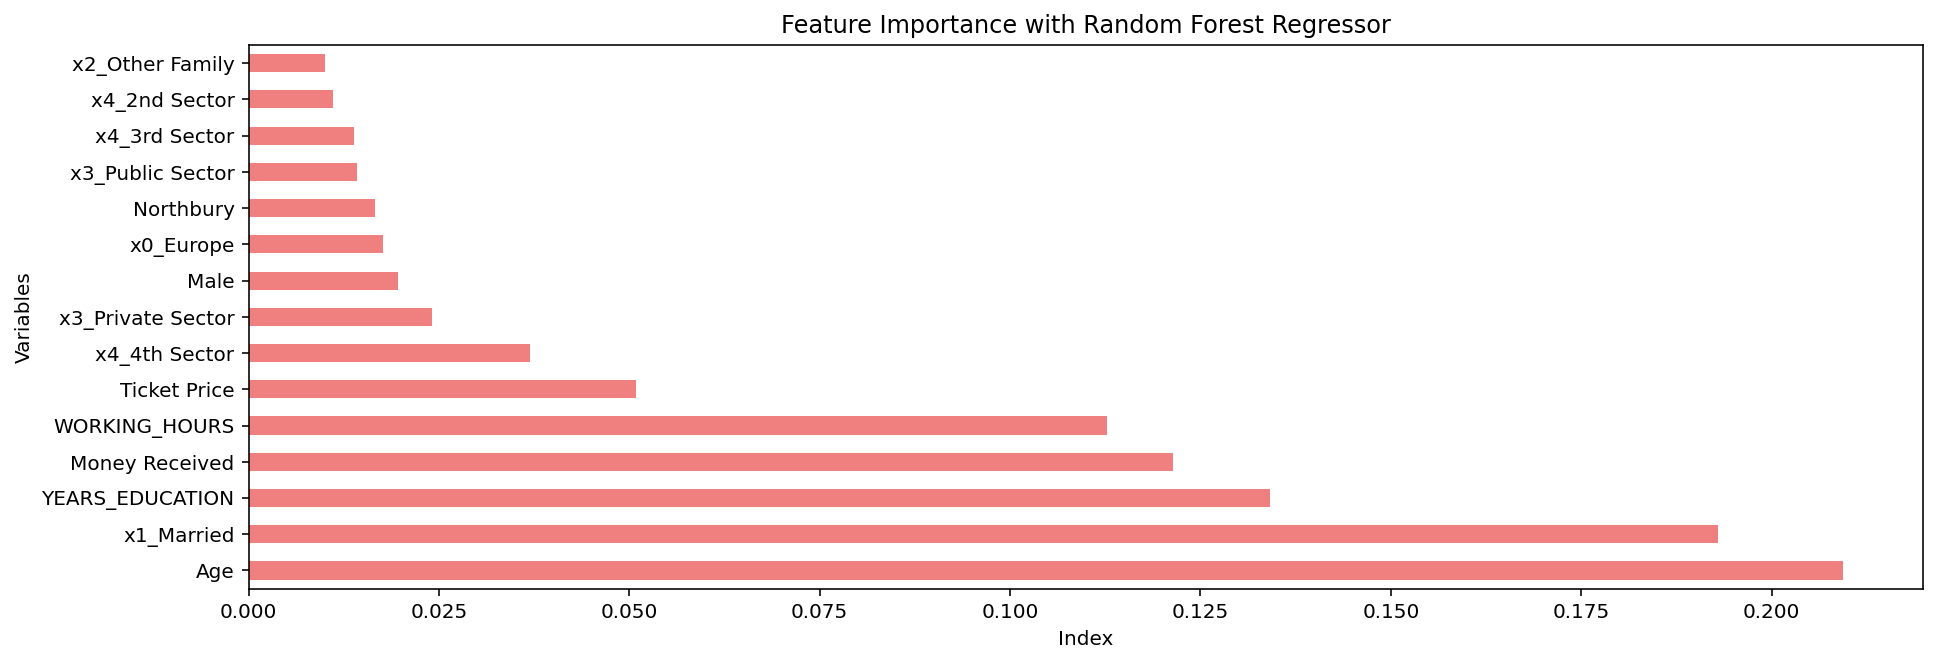

In [728]:
# We can also use RandomForest to select features based on feature importance.
# We calculate feature importance using node impurities in each decision tree. 
# In Random forest, the final feature importance is the average of all decision tree feature importance.

#Desvantagem: With correlated features, strong features can end up with low scores
# and the method can be biased towards variables with many categories
#Não é facil de interpretar

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
model = RandomForestRegressor()
model.fit(X_train, y_train)
fig, a = plt.subplots(figsize=(15, 5))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
a = feat_importances.nlargest(15).plot(kind='barh', color = "lightcoral")
a.set(xlabel="Index", ylabel="Variables", title="Feature Importance with Random Forest Regressor")
plt.show()

#https://blog.datadive.net/selecting-good-features-part-iii-random-forests/

In [729]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [730]:
fs = SelectKBest(score_func=f_classif, k=5)
X_selected = fs.fit_transform(X_train, y_train)
print(X_selected.shape)

(8960, 5)


In [731]:
from sklearn.linear_model import LassoCV

Regularization

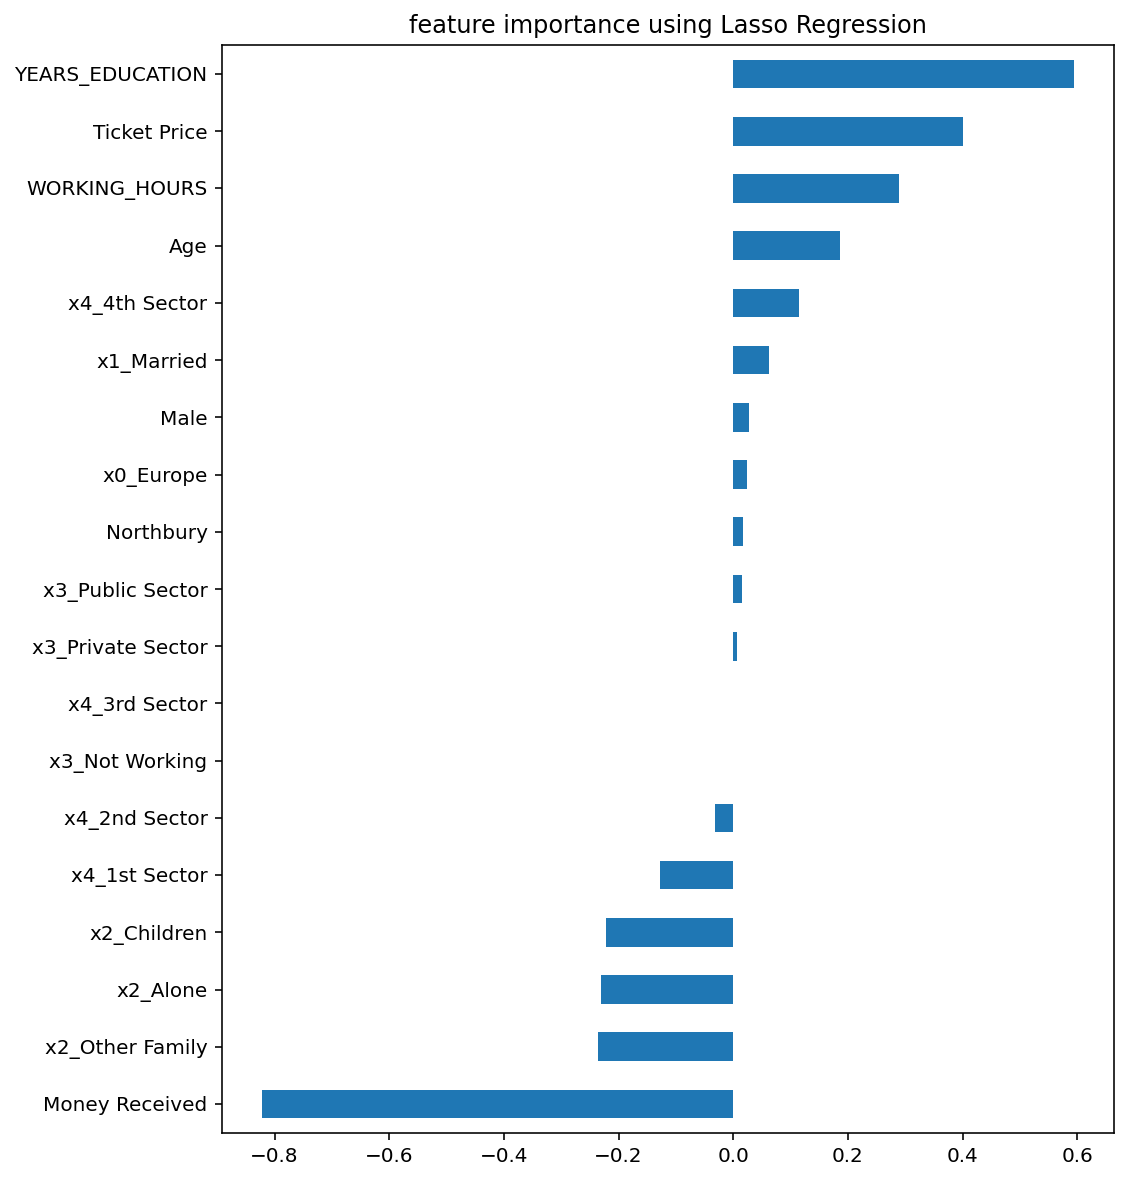

In [732]:
#Feature selction trough Lasso
reg = LassoCV()
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_, index = X_train.columns)
coef.sort_values()
plot_importance(coef, 'Lasso')

In [733]:
from sklearn.linear_model import RidgeCV

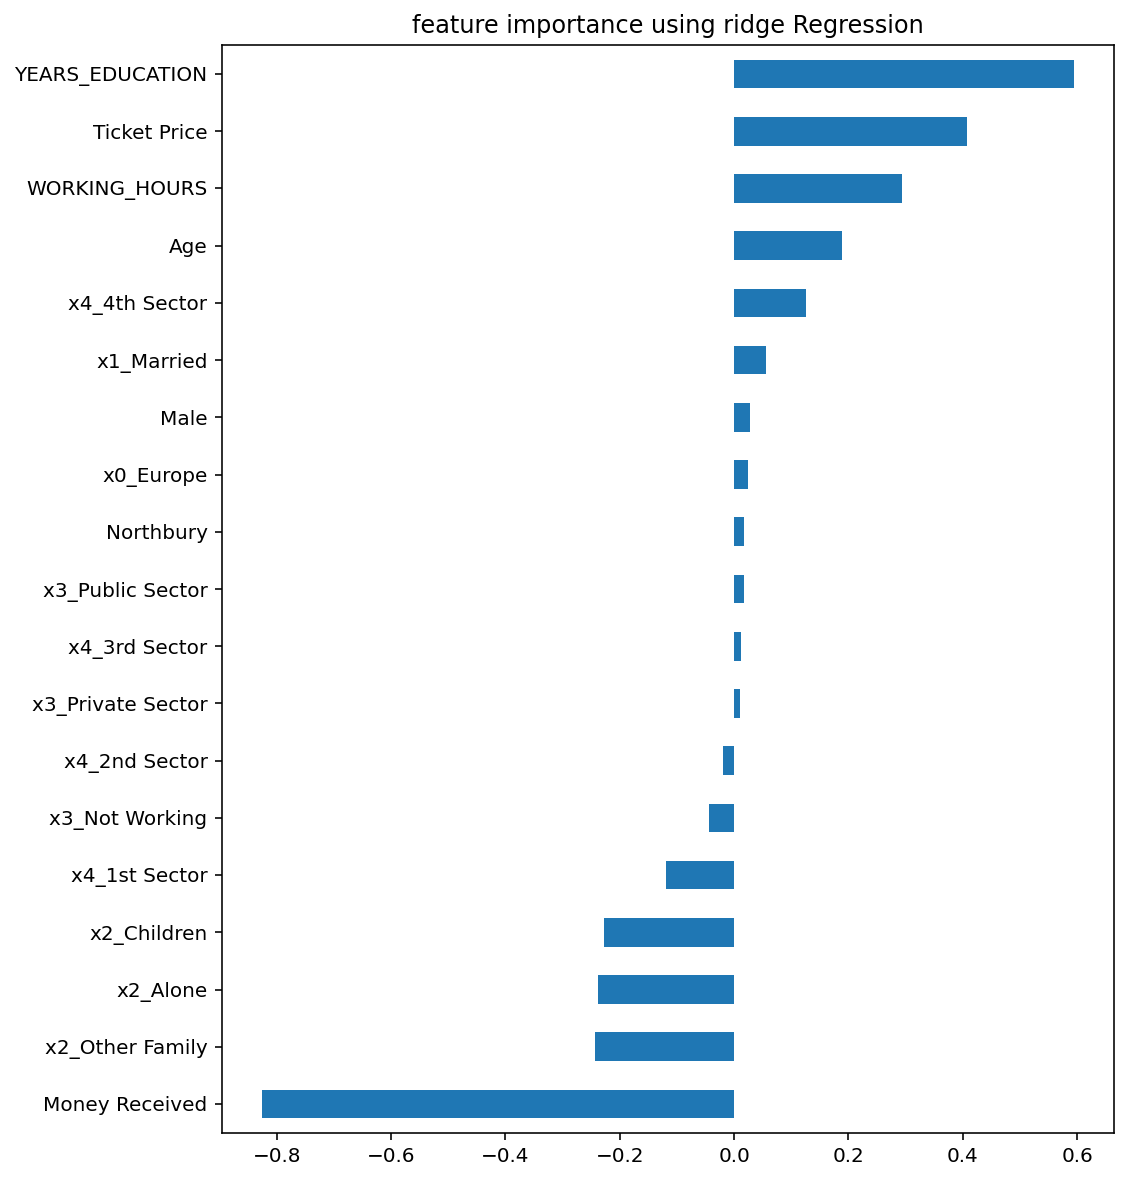

In [740]:
#Feature selection using Ridge
ridge = RidgeCV()
ridge.fit(X_train, y_train)
coef = pd.Series(ridge.coef_, index = X_train.columns)
coef.sort_values()
plot_importance(coef, 'ridge')

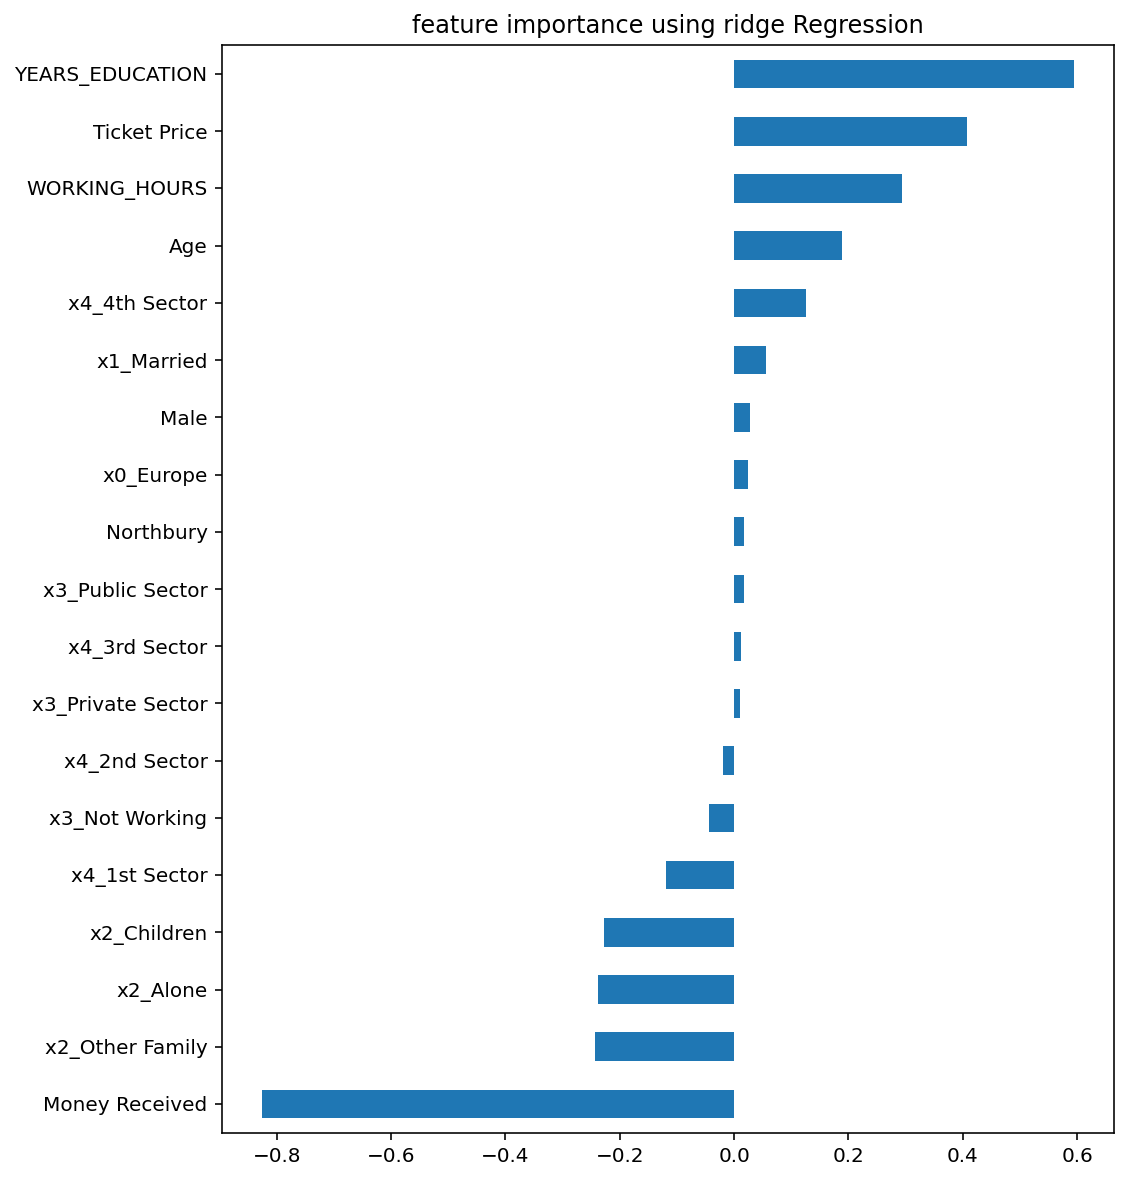

In [735]:
#Feature selection using Ridge
ridge = RidgeCV()
ridge.fit(X_train, y_train)
coef = pd.Series(ridge.coef_, index = X_train.columns)
coef.sort_values()
plot_importance(coef, 'ridge')

In [747]:
X_train.shape

(8960, 19)

In [749]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# nro of features
nof_list=np.arange(1,19)            
high_score=0
# Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):

    X_train_rfe, X_rfe_val, y_train_rfe, y_rfe_val = train_test_split(X_train, y_train, test_size = 0.2, 
                                                                      random_state = 15)
    
    model_rfe = LogisticRegression()
    rfe = RFE(model_rfe,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_rfe,y_train_rfe)
    X_rfe_val = rfe.transform(X_rfe_val)
    
    model_rfe.fit(X_train_rfe,y_train_rfe)
    
    score = model_rfe.score(X_rfe_val,y_rfe_val)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 12
Score with 12 features: 0.859933


In [750]:
N = 12
model_rfe = LogisticRegression()
rfe = RFE(estimator = model_rfe, n_features_to_select = N)
X_rfe = rfe.fit_transform(X = X_train, y = y_train) 

selected_features_rfe = pd.Series(rfe.ranking_, index = X_train.columns)
selected_features_rfe.sort_values()

YEARS_EDUCATION      1
x4_1st Sector        1
x3_Not Working       1
x2_Other Family      1
x2_Children          1
x1_Married           1
x2_Alone             1
Age                  1
Ticket Price         1
Money Received       1
WORKING_HOURS        1
x4_4th Sector        1
Northbury            2
x0_Europe            3
x3_Public Sector     4
Male                 5
x4_3rd Sector        6
x4_2nd Sector        7
x3_Private Sector    8
dtype: int32

# **Artificial Resampling**

# **Model Exploration**

# **Final Model**

# **Assess**

# **Limitations and Conclusions**